##### Here we not building the CNN model from the scratch,rather we are using pretrained model(already trained on huge dataset).
##### So I  have imported the model and configured it according to  requirements
##### Here I am using the Resnet50 CNN model(this model is trained on imagenet with more than millions of images)
- Resnet50 model can classify images in thousands different objects-i.e it extracts features from the  images
##### Here resnet50 model will extract 2400 objects from each image in the fashion project dataset and once we have extracted the featues we have to identify similar images based on the input image features
##### Now the features will be feeded to the nearestneighbors alogrithm
- here based upon the features of the 44 images distance will be calculated.To identify the similar product image will be considering the nearest image feature based upon the euclidian distance

## Import Libraries

In [1]:
import numpy as np
import pickle as pkl
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalMaxPool2D

from sklearn.neighbors import NearestNeighbors
import os #to import the images names from image folder
from numpy.linalg import norm


## Extract filenames from Folder

In [2]:
path='E:/FTE/Projects/DL/Fashion/images'
filenames = []
for file in os.listdir(path):
    filenames.append(os.path.join(path,file))

In [3]:
len(filenames)

44441

## Importing ResNet50 Model and Configuration
- resnet50 model is trained based on the imagenet dataset
- include_top=False   --here we are excluding one layer(top layer) from resnet50
- when we give the image into the model we treat it as 3D array of RGB
- since we are not including the top layer so we are replacing it with globalmaxpool2D layer

In [4]:
model= ResNet50(weights='imagenet',include_top=False, input_shape=(224,224,3))
model.trainable =False  #we are not training the model as we are using pretrained model

model=tf.keras.models.Sequential([model,GlobalMaxPool2D()])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 2048)                │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

### *Note
- Here we can see  that we used globalmaxpooling2d layer it converted the 4D array to 2D array

## Extract 2048 features from the images
- we will use preprocessing from tensorflow.keras to extract the image
- in target size the image will be converted in 224 224 pixels and then convert the image into array

In [5]:
img=image.load_img('54656.jpg',target_size=(224,224))
img_array= image.img_to_array(img)
img_array

array([[[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       ...,

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 2

In [6]:
img_array.shape

(224, 224, 3)

- Our resnet50 model got trained on batches of images so it is expecting batches of images to extract features so here we are giving only one input
- So we need to reshape our image array using a feature called dimension array present in numpy

In [7]:
img_expand_dim=np.expand_dims(img_array,axis=0)
img_expand_dim.shape

(1, 224, 224, 3)

- Converted from 3D to 4D array which is ready to be fitted into the model
- But we cannot directly load this into the model,firstly we have to apply preprocess_input before feeding into the model(Resnet50)
- preprocess_input will convert the image data from RGB to BRG


In [8]:
img_preprocess= preprocess_input(img_expand_dim)
#now we have to fit it to the model and make prediction
result=model.predict(img_preprocess).flatten()   ##flatten()--returns array in 1D from 2D
result

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


array([0.8230597, 7.3155756, 3.181357 , ..., 0.       , 8.227653 ,
       1.2007859], dtype=float32)

- Here the model has extracted the 2048 features from the image
- We need to scale the array that we got.Use norm features from numpy to do this
- Norm--scale the values between 0 and 1

In [9]:
norm_result=result/norm(result)
norm_result

array([0.0024294 , 0.02159317, 0.00939032, ..., 0.        , 0.02428532,
       0.00354432], dtype=float32)

- We have extracted the features for only 1 image now we have to extract for entire image

In [10]:
def extract_features_from_images(image_path, model):   
    img=image.load_img(image_path,target_size=(224,224)) 
    img_array= image.img_to_array(img)
    img_array
    img_expand_dim=np.expand_dims(img_array,axis=0)
    img_preprocess= preprocess_input(img_expand_dim)
    result=model.predict(img_preprocess).flatten()
    norm_result=result/norm(result)
    return norm_result
    

- it will take image_path as input
- it will take image_path instead of passsing a singele image as static path
- Now we take the input from the original dataset

In [11]:
extract_features_from_images(filenames[0],model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


array([0.        , 0.01761617, 0.00171604, ..., 0.01247241, 0.02726403,
       0.06899223], dtype=float32)

- we have extracted the features for a single image now extract the features for all images
- Store the features in image_features by appending and passing the image path(file) and model
- we can use tqdm module to track the progress of the loop

In [12]:
from tqdm import tqdm

In [14]:
image_features=[]
for file in tqdm(filenames[0:22000]):
    image_features.append(extract_features_from_images(file,model))
image_features

  0%|                                                                                        | 0/22000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


  0%|                                                                              | 1/22000 [00:00<1:34:22,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  0%|                                                                              | 2/22000 [00:00<1:33:23,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  0%|                                                                              | 3/22000 [00:00<1:29:38,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


  0%|                                                                              | 4/22000 [00:01<1:32:17,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  0%|                                                                              | 5/22000 [00:01<1:30:05,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  0%|                                                                              | 6/22000 [00:01<1:24:49,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  0%|                                                                              | 7/22000 [00:01<1:24:52,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  0%|                                                                              | 8/22000 [00:01<1:22:00,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  0%|                                                                              | 9/22000 [00:02<1:18:35,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  0%|                                                                             | 10/22000 [00:02<1:20:32,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  0%|                                                                             | 11/22000 [00:02<1:18:23,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  0%|                                                                             | 12/22000 [00:02<1:16:55,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  0%|                                                                             | 13/22000 [00:02<1:17:39,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  0%|                                                                             | 14/22000 [00:03<1:18:05,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  0%|                                                                             | 15/22000 [00:03<1:17:22,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  0%|                                                                             | 16/22000 [00:03<1:17:53,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  0%|                                                                             | 17/22000 [00:03<1:16:33,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


  0%|                                                                             | 18/22000 [00:03<1:15:36,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  0%|                                                                             | 19/22000 [00:04<1:18:23,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  0%|                                                                             | 20/22000 [00:04<1:18:35,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  0%|                                                                             | 21/22000 [00:04<1:17:34,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  0%|                                                                             | 22/22000 [00:04<1:17:27,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  0%|                                                                             | 23/22000 [00:05<1:17:56,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  0%|                                                                             | 24/22000 [00:05<1:17:15,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  0%|                                                                             | 25/22000 [00:05<1:19:31,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  0%|                                                                             | 26/22000 [00:05<1:17:41,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  0%|                                                                             | 27/22000 [00:05<1:16:24,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  0%|                                                                             | 28/22000 [00:06<1:15:30,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  0%|                                                                             | 29/22000 [00:06<1:16:32,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  0%|                                                                             | 30/22000 [00:06<1:17:19,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  0%|                                                                             | 31/22000 [00:06<1:16:08,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  0%|                                                                             | 32/22000 [00:06<1:18:44,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


  0%|                                                                             | 33/22000 [00:07<1:17:06,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  0%|                                                                             | 34/22000 [00:07<1:15:57,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  0%|                                                                             | 35/22000 [00:07<1:17:35,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  0%|▏                                                                            | 36/22000 [00:07<1:16:20,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  0%|▏                                                                            | 37/22000 [00:07<1:17:09,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  0%|▏                                                                            | 38/22000 [00:08<1:21:08,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  0%|▏                                                                            | 39/22000 [00:08<1:21:14,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  0%|▏                                                                            | 40/22000 [00:08<1:18:54,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  0%|▏                                                                            | 41/22000 [00:08<1:24:48,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  0%|▏                                                                            | 42/22000 [00:09<1:24:13,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  0%|▏                                                                            | 43/22000 [00:09<1:21:30,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  0%|▏                                                                            | 44/22000 [00:09<1:19:03,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  0%|▏                                                                            | 45/22000 [00:09<1:20:47,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  0%|▏                                                                            | 46/22000 [00:10<1:20:14,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  0%|▏                                                                            | 47/22000 [00:10<1:18:10,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  0%|▏                                                                            | 48/22000 [00:10<1:16:42,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  0%|▏                                                                            | 49/22000 [00:10<1:15:40,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  0%|▏                                                                            | 50/22000 [00:10<1:14:57,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  0%|▏                                                                            | 51/22000 [00:11<1:20:20,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  0%|▏                                                                            | 52/22000 [00:11<1:19:56,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


  0%|▏                                                                            | 53/22000 [00:11<1:17:58,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


  0%|▏                                                                            | 54/22000 [00:11<1:21:43,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  0%|▏                                                                            | 55/22000 [00:11<1:22:37,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  0%|▏                                                                            | 56/22000 [00:12<1:20:29,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  0%|▏                                                                            | 57/22000 [00:12<1:18:20,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  0%|▏                                                                            | 58/22000 [00:12<1:18:33,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  0%|▏                                                                            | 59/22000 [00:12<1:18:37,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  0%|▏                                                                            | 60/22000 [00:12<1:15:19,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


  0%|▏                                                                            | 61/22000 [00:13<1:19:49,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  0%|▏                                                                            | 62/22000 [00:13<1:19:32,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  0%|▏                                                                            | 63/22000 [00:13<1:17:38,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  0%|▏                                                                            | 64/22000 [00:13<1:16:18,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  0%|▏                                                                            | 65/22000 [00:14<1:19:30,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  0%|▏                                                                            | 66/22000 [00:14<1:21:02,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  0%|▏                                                                            | 67/22000 [00:14<1:18:42,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  0%|▏                                                                            | 68/22000 [00:14<1:17:04,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  0%|▏                                                                            | 69/22000 [00:14<1:21:46,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  0%|▏                                                                            | 70/22000 [00:15<1:20:54,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  0%|▏                                                                            | 71/22000 [00:15<1:18:35,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  0%|▎                                                                            | 72/22000 [00:15<1:16:59,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


  0%|▎                                                                            | 73/22000 [00:15<1:20:58,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  0%|▎                                                                            | 74/22000 [00:16<1:18:39,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  0%|▎                                                                            | 75/22000 [00:16<1:18:44,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  0%|▎                                                                            | 76/22000 [00:16<1:17:36,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  0%|▎                                                                            | 77/22000 [00:16<1:19:51,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  0%|▎                                                                            | 78/22000 [00:16<1:17:51,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  0%|▎                                                                            | 79/22000 [00:17<1:16:28,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  0%|▎                                                                            | 80/22000 [00:17<1:20:37,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  0%|▎                                                                            | 81/22000 [00:17<1:18:23,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  0%|▎                                                                            | 82/22000 [00:17<1:18:33,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  0%|▎                                                                            | 83/22000 [00:18<1:22:49,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  0%|▎                                                                            | 84/22000 [00:18<1:23:20,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  0%|▎                                                                            | 85/22000 [00:18<1:20:18,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  0%|▎                                                                            | 86/22000 [00:18<1:18:10,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  0%|▎                                                                            | 87/22000 [00:18<1:20:07,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


  0%|▎                                                                            | 88/22000 [00:19<1:17:59,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  0%|▎                                                                            | 89/22000 [00:19<1:17:13,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


  0%|▎                                                                            | 90/22000 [00:19<1:21:06,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  0%|▎                                                                            | 91/22000 [00:19<1:18:44,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  0%|▎                                                                            | 92/22000 [00:19<1:18:46,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  0%|▎                                                                            | 93/22000 [00:20<1:17:05,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  0%|▎                                                                            | 94/22000 [00:20<1:19:19,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  0%|▎                                                                            | 95/22000 [00:20<1:17:26,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  0%|▎                                                                            | 96/22000 [00:20<1:16:08,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


  0%|▎                                                                            | 97/22000 [00:21<1:19:21,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  0%|▎                                                                            | 98/22000 [00:21<1:19:10,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  0%|▎                                                                            | 99/22000 [00:21<1:17:23,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  0%|▎                                                                           | 100/22000 [00:21<1:16:08,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  0%|▎                                                                           | 101/22000 [00:21<1:17:35,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  0%|▎                                                                           | 102/22000 [00:22<1:17:19,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  0%|▎                                                                           | 103/22000 [00:22<1:16:04,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  0%|▎                                                                           | 104/22000 [00:22<1:17:38,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  0%|▎                                                                           | 105/22000 [00:22<1:16:17,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  0%|▎                                                                           | 106/22000 [00:22<1:15:20,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  0%|▎                                                                           | 107/22000 [00:23<1:16:22,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  0%|▎                                                                           | 108/22000 [00:23<1:17:06,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  0%|▍                                                                           | 109/22000 [00:23<1:15:53,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  0%|▍                                                                           | 110/22000 [00:23<1:16:44,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  1%|▍                                                                           | 111/22000 [00:23<1:16:16,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▍                                                                           | 112/22000 [00:24<1:14:40,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  1%|▍                                                                           | 113/22000 [00:24<1:19:18,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  1%|▍                                                                           | 114/22000 [00:24<1:18:08,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  1%|▍                                                                           | 115/22000 [00:24<1:20:43,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  1%|▍                                                                           | 116/22000 [00:25<1:24:34,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  1%|▍                                                                           | 117/22000 [00:25<1:21:48,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  1%|▍                                                                           | 118/22000 [00:25<1:19:11,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


  1%|▍                                                                           | 119/22000 [00:25<1:24:10,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  1%|▍                                                                           | 120/22000 [00:25<1:21:17,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▍                                                                           | 121/22000 [00:26<1:18:49,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▍                                                                           | 122/22000 [00:26<1:17:06,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  1%|▍                                                                           | 123/22000 [00:26<1:20:59,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  1%|▍                                                                           | 124/22000 [00:26<1:19:18,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  1%|▍                                                                           | 125/22000 [00:27<1:19:08,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


  1%|▍                                                                           | 126/22000 [00:27<1:17:17,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  1%|▍                                                                           | 127/22000 [00:27<1:17:44,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▍                                                                           | 128/22000 [00:27<1:16:20,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▍                                                                           | 129/22000 [00:27<1:17:02,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  1%|▍                                                                           | 130/22000 [00:28<1:19:13,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  1%|▍                                                                           | 131/22000 [00:28<1:19:47,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  1%|▍                                                                           | 132/22000 [00:28<1:17:43,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  1%|▍                                                                           | 133/22000 [00:28<1:16:20,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  1%|▍                                                                           | 134/22000 [00:28<1:15:18,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  1%|▍                                                                           | 135/22000 [00:29<1:14:36,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  1%|▍                                                                           | 136/22000 [00:29<1:17:33,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  1%|▍                                                                           | 137/22000 [00:29<1:19:37,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▍                                                                           | 138/22000 [00:29<1:17:39,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  1%|▍                                                                           | 139/22000 [00:30<1:22:06,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  1%|▍                                                                           | 140/22000 [00:30<1:21:06,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▍                                                                           | 141/22000 [00:30<1:18:41,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▍                                                                           | 142/22000 [00:30<1:16:57,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  1%|▍                                                                           | 143/22000 [00:30<1:20:54,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▍                                                                           | 144/22000 [00:31<1:18:32,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  1%|▌                                                                           | 145/22000 [00:31<1:18:31,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  1%|▌                                                                           | 146/22000 [00:31<1:16:52,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


  1%|▌                                                                           | 147/22000 [00:31<1:19:45,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▌                                                                           | 148/22000 [00:31<1:19:26,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  1%|▌                                                                           | 149/22000 [00:32<1:17:29,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▌                                                                           | 150/22000 [00:32<1:16:09,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  1%|▌                                                                           | 151/22000 [00:32<1:18:36,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  1%|▌                                                                           | 152/22000 [00:32<1:16:56,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  1%|▌                                                                           | 153/22000 [00:33<1:15:45,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  1%|▌                                                                           | 154/22000 [00:33<1:17:18,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  1%|▌                                                                           | 155/22000 [00:33<1:16:01,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  1%|▌                                                                           | 156/22000 [00:33<1:15:07,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  1%|▌                                                                           | 157/22000 [00:33<1:16:12,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  1%|▌                                                                           | 158/22000 [00:34<1:15:14,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  1%|▌                                                                           | 159/22000 [00:34<1:14:34,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  1%|▌                                                                           | 160/22000 [00:34<1:17:29,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▌                                                                           | 161/22000 [00:34<1:16:07,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▌                                                                           | 162/22000 [00:34<1:15:09,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  1%|▌                                                                           | 163/22000 [00:35<1:20:18,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  1%|▌                                                                           | 164/22000 [00:35<1:19:47,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  1%|▌                                                                           | 165/22000 [00:35<1:17:43,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  1%|▌                                                                           | 166/22000 [00:35<1:16:15,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


  1%|▌                                                                           | 167/22000 [00:35<1:18:40,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  1%|▌                                                                           | 168/22000 [00:36<1:18:40,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▌                                                                           | 169/22000 [00:36<1:16:55,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▌                                                                           | 170/22000 [00:36<1:17:25,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  1%|▌                                                                           | 171/22000 [00:36<1:20:11,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  1%|▌                                                                           | 172/22000 [00:37<1:19:42,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▌                                                                           | 173/22000 [00:37<1:17:39,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  1%|▌                                                                           | 174/22000 [00:37<1:17:55,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  1%|▌                                                                           | 175/22000 [00:37<1:21:32,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  1%|▌                                                                           | 176/22000 [00:37<1:19:40,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  1%|▌                                                                           | 177/22000 [00:38<1:17:38,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  1%|▌                                                                           | 178/22000 [00:38<1:16:13,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  1%|▌                                                                           | 179/22000 [00:38<1:18:37,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▌                                                                           | 180/22000 [00:38<1:16:53,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▋                                                                           | 181/22000 [00:38<1:15:39,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  1%|▋                                                                           | 182/22000 [00:39<1:18:12,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▋                                                                           | 183/22000 [00:39<1:16:37,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▋                                                                           | 184/22000 [00:39<1:15:33,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  1%|▋                                                                           | 185/22000 [00:39<1:16:19,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  1%|▋                                                                           | 186/22000 [00:40<1:15:52,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▋                                                                           | 187/22000 [00:40<1:14:23,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  1%|▋                                                                           | 188/22000 [00:40<1:19:44,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▋                                                                           | 189/22000 [00:40<1:19:21,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▋                                                                           | 190/22000 [00:40<1:17:24,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▋                                                                           | 191/22000 [00:41<1:16:52,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  1%|▋                                                                           | 192/22000 [00:41<1:20:36,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


  1%|▋                                                                           | 193/22000 [00:41<1:23:22,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▋                                                                           | 194/22000 [00:41<1:22:39,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  1%|▋                                                                           | 195/22000 [00:42<1:27:13,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▋                                                                           | 196/22000 [00:42<1:22:55,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  1%|▋                                                                           | 197/22000 [00:42<1:21:38,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▋                                                                           | 198/22000 [00:42<1:18:59,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  1%|▋                                                                           | 199/22000 [00:42<1:21:13,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  1%|▋                                                                           | 200/22000 [00:43<1:18:40,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  1%|▋                                                                           | 201/22000 [00:43<1:16:54,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  1%|▋                                                                           | 202/22000 [00:43<1:17:23,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  1%|▋                                                                           | 203/22000 [00:43<1:17:42,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  1%|▋                                                                           | 204/22000 [00:43<1:14:31,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


  1%|▋                                                                           | 205/22000 [00:44<1:19:05,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▋                                                                           | 206/22000 [00:44<1:18:53,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  1%|▋                                                                           | 207/22000 [00:44<1:17:42,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  1%|▋                                                                           | 208/22000 [00:44<1:15:35,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  1%|▋                                                                           | 209/22000 [00:45<1:18:50,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  1%|▋                                                                           | 210/22000 [00:45<1:16:59,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


  1%|▋                                                                           | 211/22000 [00:45<1:15:43,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


  1%|▋                                                                           | 212/22000 [00:45<1:21:38,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  1%|▋                                                                           | 213/22000 [00:45<1:23:06,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  1%|▋                                                                           | 214/22000 [00:46<1:20:19,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  1%|▋                                                                           | 215/22000 [00:46<1:18:01,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  1%|▋                                                                           | 216/22000 [00:46<1:25:21,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  1%|▋                                                                           | 217/22000 [00:46<1:23:17,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  1%|▊                                                                           | 218/22000 [00:47<1:24:16,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  1%|▊                                                                           | 219/22000 [00:47<1:25:46,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  1%|▊                                                                           | 220/22000 [00:47<1:24:35,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


  1%|▊                                                                           | 221/22000 [00:47<1:24:14,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  1%|▊                                                                           | 222/22000 [00:48<1:25:10,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  1%|▊                                                                           | 223/22000 [00:48<1:22:10,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  1%|▊                                                                           | 224/22000 [00:48<1:26:50,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  1%|▊                                                                           | 225/22000 [00:48<1:25:59,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▊                                                                           | 226/22000 [00:48<1:22:01,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


  1%|▊                                                                           | 227/22000 [00:49<1:26:06,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


  1%|▊                                                                           | 228/22000 [00:49<1:26:07,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▊                                                                           | 229/22000 [00:49<1:22:06,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


  1%|▊                                                                           | 230/22000 [00:49<1:25:04,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  1%|▊                                                                           | 231/22000 [00:50<1:23:47,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  1%|▊                                                                           | 232/22000 [00:50<1:19:46,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


  1%|▊                                                                           | 233/22000 [00:50<1:17:38,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  1%|▊                                                                           | 234/22000 [00:50<1:17:50,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  1%|▊                                                                           | 235/22000 [00:50<1:19:43,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▊                                                                           | 236/22000 [00:51<1:17:37,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▊                                                                           | 237/22000 [00:51<1:16:08,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  1%|▊                                                                           | 238/22000 [00:51<1:20:55,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  1%|▊                                                                           | 239/22000 [00:51<1:18:27,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


  1%|▊                                                                           | 240/22000 [00:52<1:16:41,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  1%|▊                                                                           | 241/22000 [00:52<1:15:30,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  1%|▊                                                                           | 242/22000 [00:52<1:18:02,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▊                                                                           | 243/22000 [00:52<1:18:05,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▊                                                                           | 244/22000 [00:52<1:14:44,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  1%|▊                                                                           | 245/22000 [00:53<1:17:32,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▊                                                                           | 246/22000 [00:53<1:16:04,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▊                                                                           | 247/22000 [00:53<1:15:03,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  1%|▊                                                                           | 248/22000 [00:53<1:16:42,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  1%|▊                                                                           | 249/22000 [00:53<1:17:12,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  1%|▊                                                                           | 250/22000 [00:54<1:15:52,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  1%|▊                                                                           | 251/22000 [00:54<1:14:54,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  1%|▊                                                                           | 252/22000 [00:54<1:15:54,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▊                                                                           | 253/22000 [00:54<1:16:19,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  1%|▉                                                                           | 254/22000 [00:55<1:20:34,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  1%|▉                                                                           | 255/22000 [00:55<1:18:53,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  1%|▉                                                                           | 256/22000 [00:55<1:17:01,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  1%|▉                                                                           | 257/22000 [00:55<1:16:39,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


  1%|▉                                                                           | 258/22000 [00:55<1:17:48,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▉                                                                           | 259/22000 [00:56<1:16:14,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▉                                                                           | 260/22000 [00:56<1:16:50,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  1%|▉                                                                           | 261/22000 [00:56<1:20:39,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▉                                                                           | 262/22000 [00:56<1:18:58,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  1%|▉                                                                           | 263/22000 [00:56<1:20:27,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▉                                                                           | 264/22000 [00:57<1:18:05,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  1%|▉                                                                           | 265/22000 [00:57<1:18:08,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▉                                                                           | 266/22000 [00:57<1:16:27,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  1%|▉                                                                           | 267/22000 [00:57<1:17:35,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▉                                                                           | 268/22000 [00:57<1:15:30,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▉                                                                           | 269/22000 [00:58<1:14:37,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  1%|▉                                                                           | 270/22000 [00:58<1:20:12,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  1%|▉                                                                           | 271/22000 [00:58<1:19:10,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  1%|▉                                                                           | 272/22000 [00:58<1:17:11,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  1%|▉                                                                           | 273/22000 [00:59<1:20:54,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  1%|▉                                                                           | 274/22000 [00:59<1:22:29,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  1%|▉                                                                           | 275/22000 [00:59<1:19:30,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  1%|▉                                                                           | 276/22000 [00:59<1:17:26,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  1%|▉                                                                           | 277/22000 [00:59<1:19:20,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  1%|▉                                                                           | 278/22000 [01:00<1:17:17,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  1%|▉                                                                           | 279/22000 [01:00<1:15:51,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  1%|▉                                                                           | 280/22000 [01:00<1:18:37,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  1%|▉                                                                           | 281/22000 [01:00<1:17:01,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▉                                                                           | 282/22000 [01:01<1:15:42,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  1%|▉                                                                           | 283/22000 [01:01<1:20:33,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▉                                                                           | 284/22000 [01:01<1:19:49,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▉                                                                           | 285/22000 [01:01<1:17:38,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  1%|▉                                                                           | 286/22000 [01:01<1:16:44,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  1%|▉                                                                           | 287/22000 [01:02<1:16:32,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▉                                                                           | 288/22000 [01:02<1:17:02,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  1%|▉                                                                           | 289/22000 [01:02<1:15:40,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  1%|█                                                                           | 290/22000 [01:02<1:18:50,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  1%|█                                                                           | 291/22000 [01:02<1:18:36,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  1%|█                                                                           | 292/22000 [01:03<1:19:06,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  1%|█                                                                           | 293/22000 [01:03<1:22:18,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  1%|█                                                                           | 294/22000 [01:03<1:24:26,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|█                                                                           | 295/22000 [01:03<1:22:34,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|█                                                                           | 296/22000 [01:04<1:21:13,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  1%|█                                                                           | 297/22000 [01:04<1:24:24,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|█                                                                           | 298/22000 [01:04<1:22:32,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|█                                                                           | 299/22000 [01:04<1:19:41,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  1%|█                                                                           | 300/22000 [01:05<1:20:44,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  1%|█                                                                           | 301/22000 [01:05<1:18:54,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  1%|█                                                                           | 302/22000 [01:05<1:17:56,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|█                                                                           | 303/22000 [01:05<1:19:40,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  1%|█                                                                           | 304/22000 [01:05<1:19:54,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  1%|█                                                                           | 305/22000 [01:06<1:20:53,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  1%|█                                                                           | 306/22000 [01:06<1:20:15,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|█                                                                           | 307/22000 [01:06<1:19:35,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  1%|█                                                                           | 308/22000 [01:06<1:20:52,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  1%|█                                                                           | 309/22000 [01:07<1:20:44,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


  1%|█                                                                           | 310/22000 [01:07<1:21:36,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  1%|█                                                                           | 311/22000 [01:07<1:20:31,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|█                                                                           | 312/22000 [01:07<1:19:48,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  1%|█                                                                           | 313/22000 [01:07<1:21:16,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  1%|█                                                                           | 314/22000 [01:08<1:19:18,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  1%|█                                                                           | 315/22000 [01:08<1:17:14,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  1%|█                                                                           | 316/22000 [01:08<1:20:51,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  1%|█                                                                           | 317/22000 [01:08<1:20:01,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|█                                                                           | 318/22000 [01:08<1:16:03,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  1%|█                                                                           | 319/22000 [01:09<1:20:46,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  1%|█                                                                           | 320/22000 [01:09<1:19:58,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  1%|█                                                                           | 321/22000 [01:09<1:17:43,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  1%|█                                                                           | 322/22000 [01:09<1:16:10,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  1%|█                                                                           | 323/22000 [01:10<1:19:05,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|█                                                                           | 324/22000 [01:10<1:16:27,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  1%|█                                                                           | 325/22000 [01:10<1:15:12,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  1%|█▏                                                                          | 326/22000 [01:10<1:16:04,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  1%|█▏                                                                          | 327/22000 [01:10<1:15:43,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|█▏                                                                          | 328/22000 [01:11<1:18:05,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  1%|█▏                                                                          | 329/22000 [01:11<1:16:25,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  2%|█▏                                                                          | 330/22000 [01:11<1:15:11,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  2%|█▏                                                                          | 331/22000 [01:11<1:16:03,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  2%|█▏                                                                          | 332/22000 [01:11<1:14:57,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▏                                                                          | 333/22000 [01:12<1:14:09,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


  2%|█▏                                                                          | 334/22000 [01:12<1:19:45,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  2%|█▏                                                                          | 335/22000 [01:12<1:18:09,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  2%|█▏                                                                          | 336/22000 [01:12<1:15:19,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  2%|█▏                                                                          | 337/22000 [01:13<1:17:29,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  2%|█▏                                                                          | 338/22000 [01:13<1:15:41,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


  2%|█▏                                                                          | 339/22000 [01:13<1:14:40,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  2%|█▏                                                                          | 340/22000 [01:13<1:18:02,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  2%|█▏                                                                          | 341/22000 [01:13<1:17:15,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  2%|█▏                                                                          | 342/22000 [01:14<1:16:12,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  2%|█▏                                                                          | 343/22000 [01:14<1:19:53,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  2%|█▏                                                                          | 344/22000 [01:14<1:19:20,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  2%|█▏                                                                          | 345/22000 [01:14<1:18:04,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  2%|█▏                                                                          | 346/22000 [01:14<1:19:54,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


  2%|█▏                                                                          | 347/22000 [01:15<1:17:37,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


  2%|█▏                                                                          | 348/22000 [01:15<1:22:46,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▏                                                                          | 349/22000 [01:15<1:21:19,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  2%|█▏                                                                          | 350/22000 [01:15<1:19:19,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  2%|█▏                                                                          | 351/22000 [01:16<1:17:12,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  2%|█▏                                                                          | 352/22000 [01:16<1:17:25,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  2%|█▏                                                                          | 353/22000 [01:16<1:15:54,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  2%|█▏                                                                          | 354/22000 [01:16<1:15:51,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  2%|█▏                                                                          | 355/22000 [01:16<1:18:49,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▏                                                                          | 356/22000 [01:17<1:16:51,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  2%|█▏                                                                          | 357/22000 [01:17<1:15:28,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  2%|█▏                                                                          | 358/22000 [01:17<1:21:58,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  2%|█▏                                                                          | 359/22000 [01:17<1:20:46,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▏                                                                          | 360/22000 [01:18<1:19:54,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▏                                                                          | 361/22000 [01:18<1:18:36,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  2%|█▎                                                                          | 362/22000 [01:18<1:19:02,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  2%|█▎                                                                          | 363/22000 [01:18<1:17:43,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  2%|█▎                                                                          | 364/22000 [01:18<1:16:05,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


  2%|█▎                                                                          | 365/22000 [01:19<1:18:18,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▎                                                                          | 366/22000 [01:19<1:18:11,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  2%|█▎                                                                          | 367/22000 [01:19<1:18:08,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  2%|█▎                                                                          | 368/22000 [01:19<1:22:09,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  2%|█▎                                                                          | 369/22000 [01:19<1:20:53,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▎                                                                          | 370/22000 [01:20<1:18:17,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  2%|█▎                                                                          | 371/22000 [01:20<1:16:26,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  2%|█▎                                                                          | 372/22000 [01:20<1:21:57,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  2%|█▎                                                                          | 373/22000 [01:20<1:19:44,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


  2%|█▎                                                                          | 374/22000 [01:21<1:17:29,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▎                                                                          | 375/22000 [01:21<1:17:24,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  2%|█▎                                                                          | 376/22000 [01:21<1:21:05,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▎                                                                          | 377/22000 [01:21<1:18:24,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  2%|█▎                                                                          | 378/22000 [01:21<1:16:32,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  2%|█▎                                                                          | 379/22000 [01:22<1:16:54,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  2%|█▎                                                                          | 380/22000 [01:22<1:17:55,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  2%|█▎                                                                          | 381/22000 [01:22<1:19:36,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  2%|█▎                                                                          | 382/22000 [01:22<1:15:40,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  2%|█▎                                                                          | 383/22000 [01:23<1:19:43,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▎                                                                          | 384/22000 [01:23<1:18:55,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▎                                                                          | 385/22000 [01:23<1:16:51,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  2%|█▎                                                                          | 386/22000 [01:23<1:21:31,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  2%|█▎                                                                          | 387/22000 [01:23<1:22:06,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  2%|█▎                                                                          | 388/22000 [01:24<1:19:08,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▎                                                                          | 389/22000 [01:24<1:17:04,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▎                                                                          | 390/22000 [01:24<1:15:34,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  2%|█▎                                                                          | 391/22000 [01:24<1:16:15,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  2%|█▎                                                                          | 392/22000 [01:24<1:17:25,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  2%|█▎                                                                          | 393/22000 [01:25<1:15:51,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▎                                                                          | 394/22000 [01:25<1:18:07,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▎                                                                          | 395/22000 [01:25<1:16:19,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  2%|█▎                                                                          | 396/22000 [01:25<1:20:08,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  2%|█▎                                                                          | 397/22000 [01:26<1:17:45,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▎                                                                          | 398/22000 [01:26<1:16:04,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  2%|█▍                                                                          | 399/22000 [01:26<1:15:16,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▍                                                                          | 400/22000 [01:26<1:13:58,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  2%|█▍                                                                          | 401/22000 [01:26<1:15:06,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  2%|█▍                                                                          | 402/22000 [01:27<1:16:35,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  2%|█▍                                                                          | 403/22000 [01:27<1:15:16,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  2%|█▍                                                                          | 404/22000 [01:27<1:14:19,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  2%|█▍                                                                          | 405/22000 [01:27<1:17:02,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▍                                                                          | 406/22000 [01:27<1:15:38,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▍                                                                          | 407/22000 [01:28<1:14:31,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  2%|█▍                                                                          | 408/22000 [01:28<1:18:51,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  2%|█▍                                                                          | 409/22000 [01:28<1:17:30,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  2%|█▍                                                                          | 410/22000 [01:28<1:15:54,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  2%|█▍                                                                          | 411/22000 [01:28<1:14:47,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


  2%|█▍                                                                          | 412/22000 [01:29<1:20:42,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  2%|█▍                                                                          | 413/22000 [01:29<1:22:12,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  2%|█▍                                                                          | 414/22000 [01:29<1:20:51,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  2%|█▍                                                                          | 415/22000 [01:29<1:27:19,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  2%|█▍                                                                          | 416/22000 [01:30<1:26:08,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  2%|█▍                                                                          | 417/22000 [01:30<1:23:37,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  2%|█▍                                                                          | 418/22000 [01:30<1:23:33,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  2%|█▍                                                                          | 419/22000 [01:30<1:22:31,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  2%|█▍                                                                          | 420/22000 [01:31<1:22:46,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  2%|█▍                                                                          | 421/22000 [01:31<1:24:38,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  2%|█▍                                                                          | 422/22000 [01:31<1:23:16,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  2%|█▍                                                                          | 423/22000 [01:31<1:23:18,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  2%|█▍                                                                          | 424/22000 [01:32<1:21:37,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  2%|█▍                                                                          | 425/22000 [01:32<1:22:31,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  2%|█▍                                                                          | 426/22000 [01:32<1:21:43,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  2%|█▍                                                                          | 427/22000 [01:32<1:22:20,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  2%|█▍                                                                          | 428/22000 [01:32<1:21:22,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  2%|█▍                                                                          | 429/22000 [01:33<1:21:40,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  2%|█▍                                                                          | 430/22000 [01:33<1:21:13,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


  2%|█▍                                                                          | 431/22000 [01:33<1:24:40,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  2%|█▍                                                                          | 432/22000 [01:33<1:27:06,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  2%|█▍                                                                          | 433/22000 [01:34<1:26:51,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


  2%|█▍                                                                          | 434/22000 [01:34<1:30:33,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  2%|█▌                                                                          | 435/22000 [01:34<1:27:20,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  2%|█▌                                                                          | 436/22000 [01:34<1:24:53,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  2%|█▌                                                                          | 437/22000 [01:35<1:22:04,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  2%|█▌                                                                          | 438/22000 [01:35<1:20:44,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  2%|█▌                                                                          | 439/22000 [01:35<1:21:25,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  2%|█▌                                                                          | 440/22000 [01:35<1:21:15,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


  2%|█▌                                                                          | 441/22000 [01:35<1:22:51,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  2%|█▌                                                                          | 442/22000 [01:36<1:21:30,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  2%|█▌                                                                          | 443/22000 [01:36<1:21:11,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  2%|█▌                                                                          | 444/22000 [01:36<1:19:41,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  2%|█▌                                                                          | 445/22000 [01:36<1:20:15,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  2%|█▌                                                                          | 446/22000 [01:37<1:20:12,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


  2%|█▌                                                                          | 447/22000 [01:37<1:22:16,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  2%|█▌                                                                          | 448/22000 [01:37<1:20:57,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  2%|█▌                                                                          | 449/22000 [01:37<1:19:38,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  2%|█▌                                                                          | 450/22000 [01:38<1:21:25,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  2%|█▌                                                                          | 451/22000 [01:38<1:21:57,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▌                                                                          | 452/22000 [01:38<1:18:57,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  2%|█▌                                                                          | 453/22000 [01:38<1:19:07,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  2%|█▌                                                                          | 454/22000 [01:38<1:15:58,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  2%|█▌                                                                          | 455/22000 [01:39<1:19:11,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  2%|█▌                                                                          | 456/22000 [01:39<1:17:00,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  2%|█▌                                                                          | 457/22000 [01:39<1:16:30,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  2%|█▌                                                                          | 458/22000 [01:39<1:16:51,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  2%|█▌                                                                          | 459/22000 [01:39<1:17:03,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▌                                                                          | 460/22000 [01:40<1:17:12,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  2%|█▌                                                                          | 461/22000 [01:40<1:17:18,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  2%|█▌                                                                          | 462/22000 [01:40<1:17:22,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  2%|█▌                                                                          | 463/22000 [01:40<1:21:28,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▌                                                                          | 464/22000 [01:41<1:20:19,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  2%|█▌                                                                          | 465/22000 [01:41<1:17:46,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  2%|█▌                                                                          | 466/22000 [01:41<1:15:57,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  2%|█▌                                                                          | 467/22000 [01:41<1:18:07,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▌                                                                          | 468/22000 [01:41<1:16:15,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▌                                                                          | 469/22000 [01:42<1:14:58,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  2%|█▌                                                                          | 470/22000 [01:42<1:21:27,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  2%|█▋                                                                          | 471/22000 [01:42<1:23:38,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  2%|█▋                                                                          | 472/22000 [01:42<1:19:32,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▋                                                                          | 473/22000 [01:43<1:18:21,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  2%|█▋                                                                          | 474/22000 [01:43<1:20:45,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  2%|█▋                                                                          | 475/22000 [01:43<1:19:50,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  2%|█▋                                                                          | 476/22000 [01:43<1:17:06,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  2%|█▋                                                                          | 477/22000 [01:43<1:20:34,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  2%|█▋                                                                          | 478/22000 [01:44<1:23:42,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  2%|█▋                                                                          | 479/22000 [01:44<1:20:09,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  2%|█▋                                                                          | 480/22000 [01:44<1:17:44,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  2%|█▋                                                                          | 481/22000 [01:44<1:19:13,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  2%|█▋                                                                          | 482/22000 [01:45<1:18:42,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▋                                                                          | 483/22000 [01:45<1:16:39,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  2%|█▋                                                                          | 484/22000 [01:45<1:16:55,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  2%|█▋                                                                          | 485/22000 [01:45<1:19:27,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  2%|█▋                                                                          | 486/22000 [01:45<1:17:09,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▋                                                                          | 487/22000 [01:46<1:15:32,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  2%|█▋                                                                          | 488/22000 [01:46<1:17:48,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  2%|█▋                                                                          | 489/22000 [01:46<1:16:01,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▋                                                                          | 490/22000 [01:46<1:14:48,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▋                                                                          | 491/22000 [01:46<1:17:15,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▋                                                                          | 492/22000 [01:47<1:15:39,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  2%|█▋                                                                          | 493/22000 [01:47<1:14:54,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▋                                                                          | 494/22000 [01:47<1:14:17,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  2%|█▋                                                                          | 495/22000 [01:47<1:13:31,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


  2%|█▋                                                                          | 496/22000 [01:48<1:19:44,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  2%|█▋                                                                          | 497/22000 [01:48<1:19:39,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  2%|█▋                                                                          | 498/22000 [01:48<1:18:21,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  2%|█▋                                                                          | 499/22000 [01:48<1:17:04,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  2%|█▋                                                                          | 500/22000 [01:48<1:18:50,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▋                                                                          | 501/22000 [01:49<1:16:43,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  2%|█▋                                                                          | 502/22000 [01:49<1:15:12,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  2%|█▋                                                                          | 503/22000 [01:49<1:15:53,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▋                                                                          | 504/22000 [01:49<1:14:39,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  2%|█▋                                                                          | 505/22000 [01:49<1:15:29,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  2%|█▋                                                                          | 506/22000 [01:50<1:16:02,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  2%|█▊                                                                          | 507/22000 [01:50<1:15:24,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  2%|█▊                                                                          | 508/22000 [01:50<1:14:15,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  2%|█▊                                                                          | 509/22000 [01:50<1:16:56,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  2%|█▊                                                                          | 510/22000 [01:50<1:17:02,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▊                                                                          | 511/22000 [01:51<1:15:28,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  2%|█▊                                                                          | 512/22000 [01:51<1:14:21,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  2%|█▊                                                                          | 513/22000 [01:51<1:15:15,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▊                                                                          | 514/22000 [01:51<1:15:52,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  2%|█▊                                                                          | 515/22000 [01:52<1:14:38,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  2%|█▊                                                                          | 516/22000 [01:52<1:15:25,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  2%|█▊                                                                          | 517/22000 [01:52<1:15:59,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


  2%|█▊                                                                          | 518/22000 [01:52<1:15:22,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  2%|█▊                                                                          | 519/22000 [01:52<1:15:59,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  2%|█▊                                                                          | 520/22000 [01:53<1:14:41,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  2%|█▊                                                                          | 521/22000 [01:53<1:13:45,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▊                                                                          | 522/22000 [01:53<1:16:29,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  2%|█▊                                                                          | 523/22000 [01:53<1:15:02,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  2%|█▊                                                                          | 524/22000 [01:53<1:14:04,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  2%|█▊                                                                          | 525/22000 [01:54<1:15:02,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▊                                                                          | 526/22000 [01:54<1:15:43,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  2%|█▊                                                                          | 527/22000 [01:54<1:12:49,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  2%|█▊                                                                          | 528/22000 [01:54<1:16:33,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  2%|█▊                                                                          | 529/22000 [01:54<1:15:07,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  2%|█▊                                                                          | 530/22000 [01:55<1:15:00,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


  2%|█▊                                                                          | 531/22000 [01:55<1:18:08,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▊                                                                          | 532/22000 [01:55<1:16:13,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▊                                                                          | 533/22000 [01:55<1:14:52,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  2%|█▊                                                                          | 534/22000 [01:56<1:19:36,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  2%|█▊                                                                          | 535/22000 [01:56<1:22:16,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  2%|█▊                                                                          | 536/22000 [01:56<1:19:04,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  2%|█▊                                                                          | 537/22000 [01:56<1:16:50,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  2%|█▊                                                                          | 538/22000 [01:56<1:16:58,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▊                                                                          | 539/22000 [01:57<1:17:02,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  2%|█▊                                                                          | 540/22000 [01:57<1:15:26,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  2%|█▊                                                                          | 541/22000 [01:57<1:16:40,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  2%|█▊                                                                          | 542/22000 [01:57<1:15:08,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  2%|█▉                                                                          | 543/22000 [01:57<1:14:06,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  2%|█▉                                                                          | 544/22000 [01:58<1:15:03,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  2%|█▉                                                                          | 545/22000 [01:58<1:14:01,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  2%|█▉                                                                          | 546/22000 [01:58<1:14:58,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  2%|█▉                                                                          | 547/22000 [01:58<1:15:39,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▉                                                                          | 548/22000 [01:59<1:14:27,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  2%|█▉                                                                          | 549/22000 [01:59<1:19:19,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  2%|█▉                                                                          | 550/22000 [01:59<1:20:37,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|█▉                                                                          | 551/22000 [01:59<1:17:40,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|█▉                                                                          | 552/22000 [01:59<1:15:50,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  3%|█▉                                                                          | 553/22000 [02:00<1:16:16,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  3%|█▉                                                                          | 554/22000 [02:00<1:15:37,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|█▉                                                                          | 555/22000 [02:00<1:13:40,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  3%|█▉                                                                          | 556/22000 [02:00<1:16:26,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|█▉                                                                          | 557/22000 [02:00<1:14:59,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  3%|█▉                                                                          | 558/22000 [02:01<1:16:17,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  3%|█▉                                                                          | 559/22000 [02:01<1:18:15,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|█▉                                                                          | 560/22000 [02:01<1:16:17,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  3%|█▉                                                                          | 561/22000 [02:01<1:16:09,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|█▉                                                                          | 562/22000 [02:02<1:13:30,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|█▉                                                                          | 563/22000 [02:02<1:14:37,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  3%|█▉                                                                          | 564/22000 [02:02<1:13:43,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  3%|█▉                                                                          | 565/22000 [02:02<1:18:48,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  3%|█▉                                                                          | 566/22000 [02:02<1:19:58,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|█▉                                                                          | 567/22000 [02:03<1:17:28,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|█▉                                                                          | 568/22000 [02:03<1:15:41,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  3%|█▉                                                                          | 569/22000 [02:03<1:17:47,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|█▉                                                                          | 570/22000 [02:03<1:15:57,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|█▉                                                                          | 571/22000 [02:03<1:16:21,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  3%|█▉                                                                          | 572/22000 [02:04<1:17:18,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  3%|█▉                                                                          | 573/22000 [02:04<1:15:35,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


  3%|█▉                                                                          | 574/22000 [02:04<1:14:22,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  3%|█▉                                                                          | 575/22000 [02:04<1:17:20,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|█▉                                                                          | 576/22000 [02:05<1:16:49,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  3%|█▉                                                                          | 577/22000 [02:05<1:15:14,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  3%|█▉                                                                          | 578/22000 [02:05<1:15:48,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  3%|██                                                                          | 579/22000 [02:05<1:14:30,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██                                                                          | 580/22000 [02:05<1:13:37,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  3%|██                                                                          | 581/22000 [02:06<1:14:38,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  3%|██                                                                          | 582/22000 [02:06<1:15:21,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  3%|██                                                                          | 583/22000 [02:06<1:14:51,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  3%|██                                                                          | 584/22000 [02:06<1:15:32,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  3%|██                                                                          | 585/22000 [02:06<1:15:59,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██                                                                          | 586/22000 [02:07<1:14:38,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  3%|██                                                                          | 587/22000 [02:07<1:14:23,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  3%|██                                                                          | 588/22000 [02:07<1:14:30,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██                                                                          | 589/22000 [02:07<1:15:15,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  3%|██                                                                          | 590/22000 [02:07<1:14:12,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  3%|██                                                                          | 591/22000 [02:08<1:15:04,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██                                                                          | 592/22000 [02:08<1:13:59,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  3%|██                                                                          | 593/22000 [02:08<1:13:13,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  3%|██                                                                          | 594/22000 [02:08<1:18:25,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██                                                                          | 595/22000 [02:09<1:16:22,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██                                                                          | 596/22000 [02:09<1:16:00,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  3%|██                                                                          | 597/22000 [02:09<1:16:53,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██                                                                          | 598/22000 [02:09<1:16:57,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██                                                                          | 599/22000 [02:09<1:15:17,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  3%|██                                                                          | 600/22000 [02:10<1:14:10,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  3%|██                                                                          | 601/22000 [02:10<1:17:25,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  3%|██                                                                          | 602/22000 [02:10<1:17:19,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██                                                                          | 603/22000 [02:10<1:15:32,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██                                                                          | 604/22000 [02:10<1:14:17,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  3%|██                                                                          | 605/22000 [02:11<1:16:50,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██                                                                          | 606/22000 [02:11<1:15:12,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  3%|██                                                                          | 607/22000 [02:11<1:15:43,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  3%|██                                                                          | 608/22000 [02:11<1:18:28,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  3%|██                                                                          | 609/22000 [02:12<1:18:02,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██                                                                          | 610/22000 [02:12<1:16:03,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  3%|██                                                                          | 611/22000 [02:12<1:21:21,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  3%|██                                                                          | 612/22000 [02:12<1:20:40,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  3%|██                                                                          | 613/22000 [02:12<1:17:55,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  3%|██                                                                          | 614/22000 [02:13<1:17:39,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  3%|██                                                                          | 615/22000 [02:13<1:20:48,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▏                                                                         | 616/22000 [02:13<1:17:58,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  3%|██▏                                                                         | 617/22000 [02:13<1:17:39,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


  3%|██▏                                                                         | 618/22000 [02:14<1:21:29,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  3%|██▏                                                                         | 619/22000 [02:14<1:21:45,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▏                                                                         | 620/22000 [02:14<1:18:39,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▏                                                                         | 621/22000 [02:14<1:16:30,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  3%|██▏                                                                         | 622/22000 [02:14<1:19:01,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  3%|██▏                                                                         | 623/22000 [02:15<1:16:43,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  3%|██▏                                                                         | 624/22000 [02:15<1:15:07,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  3%|██▏                                                                         | 625/22000 [02:15<1:15:39,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▏                                                                         | 626/22000 [02:15<1:16:02,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  3%|██▏                                                                         | 627/22000 [02:15<1:14:37,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  3%|██▏                                                                         | 628/22000 [02:16<1:15:17,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  3%|██▏                                                                         | 629/22000 [02:16<1:15:46,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  3%|██▏                                                                         | 630/22000 [02:16<1:14:26,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  3%|██▏                                                                         | 631/22000 [02:16<1:21:30,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▏                                                                         | 632/22000 [02:17<1:17:50,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▏                                                                         | 633/22000 [02:17<1:17:34,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  3%|██▏                                                                         | 634/22000 [02:17<1:15:45,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  3%|██▏                                                                         | 635/22000 [02:17<1:16:05,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▏                                                                         | 636/22000 [02:17<1:14:41,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▏                                                                         | 637/22000 [02:18<1:13:41,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  3%|██▏                                                                         | 638/22000 [02:18<1:15:19,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  3%|██▏                                                                         | 639/22000 [02:18<1:14:07,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  3%|██▏                                                                         | 640/22000 [02:18<1:13:16,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  3%|██▏                                                                         | 641/22000 [02:18<1:16:02,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  3%|██▏                                                                         | 642/22000 [02:19<1:16:15,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  3%|██▏                                                                         | 643/22000 [02:19<1:14:46,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  3%|██▏                                                                         | 644/22000 [02:19<1:17:04,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▏                                                                         | 645/22000 [02:19<1:15:20,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  3%|██▏                                                                         | 646/22000 [02:20<1:15:47,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


  3%|██▏                                                                         | 647/22000 [02:20<1:21:47,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▏                                                                         | 648/22000 [02:20<1:21:57,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▏                                                                         | 649/22000 [02:20<1:19:28,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  3%|██▏                                                                         | 650/22000 [02:20<1:18:41,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  3%|██▏                                                                         | 651/22000 [02:21<1:16:29,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  3%|██▎                                                                         | 652/22000 [02:21<1:14:56,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  3%|██▎                                                                         | 653/22000 [02:21<1:17:10,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▎                                                                         | 654/22000 [02:21<1:15:24,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  3%|██▎                                                                         | 655/22000 [02:22<1:21:29,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  3%|██▎                                                                         | 656/22000 [02:22<1:21:46,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  3%|██▎                                                                         | 657/22000 [02:22<1:21:59,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  3%|██▎                                                                         | 658/22000 [02:22<1:26:09,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  3%|██▎                                                                         | 659/22000 [02:22<1:23:22,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  3%|██▎                                                                         | 660/22000 [02:23<1:25:30,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  3%|██▎                                                                         | 661/22000 [02:23<1:23:07,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  3%|██▎                                                                         | 662/22000 [02:23<1:19:53,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  3%|██▎                                                                         | 663/22000 [02:23<1:20:04,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  3%|██▎                                                                         | 664/22000 [02:24<1:19:04,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▎                                                                         | 665/22000 [02:24<1:16:44,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  3%|██▎                                                                         | 666/22000 [02:24<1:22:29,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  3%|██▎                                                                         | 667/22000 [02:24<1:22:27,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  3%|██▎                                                                         | 668/22000 [02:25<1:20:46,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  3%|██▎                                                                         | 669/22000 [02:25<1:21:57,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  3%|██▎                                                                         | 670/22000 [02:25<1:22:03,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▎                                                                         | 671/22000 [02:25<1:18:47,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▎                                                                         | 672/22000 [02:25<1:18:11,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  3%|██▎                                                                         | 673/22000 [02:26<1:18:27,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▎                                                                         | 674/22000 [02:26<1:19:37,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  3%|██▎                                                                         | 675/22000 [02:26<1:20:26,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  3%|██▎                                                                         | 676/22000 [02:26<1:21:01,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  3%|██▎                                                                         | 677/22000 [02:27<1:18:45,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  3%|██▎                                                                         | 678/22000 [02:27<1:19:49,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  3%|██▎                                                                         | 679/22000 [02:27<1:19:23,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  3%|██▎                                                                         | 680/22000 [02:27<1:26:56,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  3%|██▎                                                                         | 681/22000 [02:27<1:22:55,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  3%|██▎                                                                         | 682/22000 [02:28<1:21:03,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


  3%|██▎                                                                         | 683/22000 [02:28<1:19:44,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  3%|██▎                                                                         | 684/22000 [02:28<1:18:51,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  3%|██▎                                                                         | 685/22000 [02:28<1:22:15,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  3%|██▎                                                                         | 686/22000 [02:29<1:20:52,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  3%|██▎                                                                         | 687/22000 [02:29<1:17:43,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


  3%|██▍                                                                         | 688/22000 [02:29<1:20:49,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▍                                                                         | 689/22000 [02:29<1:19:36,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  3%|██▍                                                                         | 690/22000 [02:29<1:17:05,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  3%|██▍                                                                         | 691/22000 [02:30<1:19:20,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  3%|██▍                                                                         | 692/22000 [02:30<1:18:39,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  3%|██▍                                                                         | 693/22000 [02:30<1:19:35,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  3%|██▍                                                                         | 694/22000 [02:30<1:22:44,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  3%|██▍                                                                         | 695/22000 [02:31<1:20:56,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


  3%|██▍                                                                         | 696/22000 [02:31<1:26:59,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  3%|██▍                                                                         | 697/22000 [02:31<1:27:14,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▍                                                                         | 698/22000 [02:31<1:24:05,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


  3%|██▍                                                                         | 699/22000 [02:32<1:24:15,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  3%|██▍                                                                         | 700/22000 [02:32<1:20:20,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  3%|██▍                                                                         | 701/22000 [02:32<1:17:55,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  3%|██▍                                                                         | 702/22000 [02:32<1:17:53,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▍                                                                         | 703/22000 [02:32<1:17:31,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▍                                                                         | 704/22000 [02:33<1:15:35,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▍                                                                         | 705/22000 [02:33<1:14:15,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  3%|██▍                                                                         | 706/22000 [02:33<1:16:38,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▍                                                                         | 707/22000 [02:33<1:16:39,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▍                                                                         | 708/22000 [02:33<1:13:21,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  3%|██▍                                                                         | 709/22000 [02:34<1:14:20,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▍                                                                         | 710/22000 [02:34<1:13:22,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  3%|██▍                                                                         | 711/22000 [02:34<1:13:19,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  3%|██▍                                                                         | 712/22000 [02:34<1:14:23,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  3%|██▍                                                                         | 713/22000 [02:35<1:13:22,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  3%|██▍                                                                         | 714/22000 [02:35<1:12:41,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


  3%|██▍                                                                         | 715/22000 [02:35<1:17:10,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▍                                                                         | 716/22000 [02:35<1:15:22,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▍                                                                         | 717/22000 [02:35<1:14:05,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▍                                                                         | 718/22000 [02:36<1:13:11,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  3%|██▍                                                                         | 719/22000 [02:36<1:17:34,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  3%|██▍                                                                         | 720/22000 [02:36<1:16:17,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▍                                                                         | 721/22000 [02:36<1:14:41,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


  3%|██▍                                                                         | 722/22000 [02:36<1:20:14,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  3%|██▍                                                                         | 723/22000 [02:37<1:19:08,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▌                                                                         | 724/22000 [02:37<1:16:44,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  3%|██▌                                                                         | 725/22000 [02:37<1:15:02,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  3%|██▌                                                                         | 726/22000 [02:37<1:17:50,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|██▌                                                                         | 727/22000 [02:38<1:15:48,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  3%|██▌                                                                         | 728/22000 [02:38<1:44:03,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  3%|██▌                                                                         | 729/22000 [02:38<1:36:27,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  3%|██▌                                                                         | 730/22000 [02:38<1:30:30,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  3%|██▌                                                                         | 731/22000 [02:39<1:24:41,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


  3%|██▌                                                                         | 732/22000 [02:39<1:24:29,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  3%|██▌                                                                         | 733/22000 [02:39<1:21:33,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▌                                                                         | 734/22000 [02:39<1:20:03,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  3%|██▌                                                                         | 735/22000 [02:40<1:16:17,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  3%|██▌                                                                         | 736/22000 [02:40<1:19:46,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  3%|██▌                                                                         | 737/22000 [02:40<1:20:24,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▌                                                                         | 738/22000 [02:40<1:17:36,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  3%|██▌                                                                         | 739/22000 [02:40<1:15:39,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  3%|██▌                                                                         | 740/22000 [02:41<1:18:17,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  3%|██▌                                                                         | 741/22000 [02:41<1:17:45,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  3%|██▌                                                                         | 742/22000 [02:41<1:15:43,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  3%|██▌                                                                         | 743/22000 [02:41<1:14:19,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


  3%|██▌                                                                         | 744/22000 [02:42<1:19:44,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▌                                                                         | 745/22000 [02:42<1:17:17,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▌                                                                         | 746/22000 [02:42<1:15:25,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▌                                                                         | 747/22000 [02:42<1:14:10,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  3%|██▌                                                                         | 748/22000 [02:42<1:15:27,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  3%|██▌                                                                         | 749/22000 [02:43<1:14:07,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  3%|██▌                                                                         | 750/22000 [02:43<1:13:09,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


  3%|██▌                                                                         | 751/22000 [02:43<1:17:30,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▌                                                                         | 752/22000 [02:43<1:17:12,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  3%|██▌                                                                         | 753/22000 [02:43<1:13:42,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  3%|██▌                                                                         | 754/22000 [02:44<1:20:11,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  3%|██▌                                                                         | 755/22000 [02:44<1:19:28,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▌                                                                         | 756/22000 [02:44<1:16:30,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▌                                                                         | 757/22000 [02:44<1:14:50,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  3%|██▌                                                                         | 758/22000 [02:45<1:18:37,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▌                                                                         | 759/22000 [02:45<1:17:57,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  3%|██▋                                                                         | 760/22000 [02:45<1:16:30,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▋                                                                         | 761/22000 [02:45<1:14:51,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


  3%|██▋                                                                         | 762/22000 [02:45<1:18:40,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▋                                                                         | 763/22000 [02:46<1:16:19,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▋                                                                         | 764/22000 [02:46<1:16:20,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▋                                                                         | 765/22000 [02:46<1:14:42,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  3%|██▋                                                                         | 766/22000 [02:46<1:19:14,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  3%|██▋                                                                         | 767/22000 [02:46<1:18:24,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  3%|██▋                                                                         | 768/22000 [02:47<1:16:09,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  3%|██▋                                                                         | 769/22000 [02:47<1:14:36,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  4%|██▋                                                                         | 770/22000 [02:47<1:18:27,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|██▋                                                                         | 771/22000 [02:47<1:16:09,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  4%|██▋                                                                         | 772/22000 [02:48<1:16:12,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  4%|██▋                                                                         | 773/22000 [02:48<1:15:17,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  4%|██▋                                                                         | 774/22000 [02:48<1:17:18,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  4%|██▋                                                                         | 775/22000 [02:48<1:17:00,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|██▋                                                                         | 776/22000 [02:48<1:15:11,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|██▋                                                                         | 777/22000 [02:49<1:13:52,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|██▋                                                                         | 778/22000 [02:49<1:14:37,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  4%|██▋                                                                         | 779/22000 [02:49<1:13:28,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  4%|██▋                                                                         | 780/22000 [02:49<1:16:40,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  4%|██▋                                                                         | 781/22000 [02:49<1:14:56,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  4%|██▋                                                                         | 782/22000 [02:50<1:15:23,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  4%|██▋                                                                         | 783/22000 [02:50<1:14:01,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


  4%|██▋                                                                         | 784/22000 [02:50<1:18:02,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|██▋                                                                         | 785/22000 [02:50<1:17:33,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|██▋                                                                         | 786/22000 [02:51<1:15:37,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|██▋                                                                         | 787/22000 [02:51<1:14:03,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  4%|██▋                                                                         | 788/22000 [02:51<1:18:43,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  4%|██▋                                                                         | 789/22000 [02:51<1:17:59,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  4%|██▋                                                                         | 790/22000 [02:51<1:14:58,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|██▋                                                                         | 791/22000 [02:52<1:14:35,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


  4%|██▋                                                                         | 792/22000 [02:52<1:19:55,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|██▋                                                                         | 793/22000 [02:52<1:17:12,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|██▋                                                                         | 794/22000 [02:52<1:16:56,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|██▋                                                                         | 795/22000 [02:52<1:16:45,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  4%|██▋                                                                         | 796/22000 [02:53<1:18:59,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  4%|██▊                                                                         | 797/22000 [02:53<1:18:12,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|██▊                                                                         | 798/22000 [02:53<1:15:57,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|██▊                                                                         | 799/22000 [02:53<1:14:23,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  4%|██▊                                                                         | 800/22000 [02:54<1:14:57,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|██▊                                                                         | 801/22000 [02:54<1:13:44,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  4%|██▊                                                                         | 802/22000 [02:54<1:14:30,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  4%|██▊                                                                         | 803/22000 [02:54<1:19:01,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  4%|██▊                                                                         | 804/22000 [02:54<1:16:34,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  4%|██▊                                                                         | 805/22000 [02:55<1:14:51,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  4%|██▊                                                                         | 806/22000 [02:55<1:15:16,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  4%|██▊                                                                         | 807/22000 [02:55<1:13:56,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  4%|██▊                                                                         | 808/22000 [02:55<1:12:58,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  4%|██▊                                                                         | 809/22000 [02:55<1:17:17,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|██▊                                                                         | 810/22000 [02:56<1:16:58,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  4%|██▊                                                                         | 811/22000 [02:56<1:15:46,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|██▊                                                                         | 812/22000 [02:56<1:14:17,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


  4%|██▊                                                                         | 813/22000 [02:56<1:16:33,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  4%|██▊                                                                         | 814/22000 [02:57<1:16:26,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|██▊                                                                         | 815/22000 [02:57<1:14:44,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|██▊                                                                         | 816/22000 [02:57<1:13:31,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  4%|██▊                                                                         | 817/22000 [02:57<1:18:21,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  4%|██▊                                                                         | 818/22000 [02:57<1:16:02,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  4%|██▊                                                                         | 819/22000 [02:58<1:16:07,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  4%|██▊                                                                         | 820/22000 [02:58<1:14:31,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


  4%|██▊                                                                         | 821/22000 [02:58<1:18:21,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  4%|██▊                                                                         | 822/22000 [02:58<1:17:13,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|██▊                                                                         | 823/22000 [02:59<1:15:46,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  4%|██▊                                                                         | 824/22000 [02:59<1:14:14,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  4%|██▊                                                                         | 825/22000 [02:59<1:17:12,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  4%|██▊                                                                         | 826/22000 [02:59<1:16:54,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  4%|██▊                                                                         | 827/22000 [02:59<1:15:02,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


  4%|██▊                                                                         | 828/22000 [03:00<1:18:41,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  4%|██▊                                                                         | 829/22000 [03:00<1:18:36,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  4%|██▊                                                                         | 830/22000 [03:00<1:16:14,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  4%|██▊                                                                         | 831/22000 [03:00<1:14:36,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


  4%|██▊                                                                         | 832/22000 [03:00<1:16:43,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  4%|██▉                                                                         | 833/22000 [03:01<1:16:31,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|██▉                                                                         | 834/22000 [03:01<1:16:23,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  4%|██▉                                                                         | 835/22000 [03:01<1:20:19,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  4%|██▉                                                                         | 836/22000 [03:01<1:19:47,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|██▉                                                                         | 837/22000 [03:02<1:16:19,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|██▉                                                                         | 838/22000 [03:02<1:14:36,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  4%|██▉                                                                         | 839/22000 [03:02<1:15:05,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|██▉                                                                         | 840/22000 [03:02<1:15:26,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  4%|██▉                                                                         | 841/22000 [03:02<1:13:57,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  4%|██▉                                                                         | 842/22000 [03:03<1:16:56,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  4%|██▉                                                                         | 843/22000 [03:03<1:15:03,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  4%|██▉                                                                         | 844/22000 [03:03<1:15:23,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  4%|██▉                                                                         | 845/22000 [03:03<1:13:57,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


  4%|██▉                                                                         | 846/22000 [03:03<1:17:55,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|██▉                                                                         | 847/22000 [03:04<1:15:45,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|██▉                                                                         | 848/22000 [03:04<1:15:53,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|██▉                                                                         | 849/22000 [03:04<1:14:18,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  4%|██▉                                                                         | 850/22000 [03:04<1:15:31,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  4%|██▉                                                                         | 851/22000 [03:05<1:15:41,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  4%|██▉                                                                         | 852/22000 [03:05<1:14:11,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


  4%|██▉                                                                         | 853/22000 [03:05<1:18:40,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  4%|██▉                                                                         | 854/22000 [03:05<1:17:17,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  4%|██▉                                                                         | 855/22000 [03:05<1:16:54,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  4%|██▉                                                                         | 856/22000 [03:06<1:15:01,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  4%|██▉                                                                         | 857/22000 [03:06<1:17:39,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|██▉                                                                         | 858/22000 [03:06<1:15:34,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  4%|██▉                                                                         | 859/22000 [03:06<1:15:41,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  4%|██▉                                                                         | 860/22000 [03:07<1:19:48,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  4%|██▉                                                                         | 861/22000 [03:07<1:20:20,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|██▉                                                                         | 862/22000 [03:07<1:17:23,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|██▉                                                                         | 863/22000 [03:07<1:15:21,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


  4%|██▉                                                                         | 864/22000 [03:07<1:21:12,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  4%|██▉                                                                         | 865/22000 [03:08<1:19:41,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  4%|██▉                                                                         | 866/22000 [03:08<1:16:57,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  4%|██▉                                                                         | 867/22000 [03:08<1:15:00,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  4%|██▉                                                                         | 868/22000 [03:08<1:18:37,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|███                                                                         | 869/22000 [03:09<1:16:11,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  4%|███                                                                         | 870/22000 [03:09<1:14:29,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  4%|███                                                                         | 871/22000 [03:09<1:20:35,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  4%|███                                                                         | 872/22000 [03:09<1:20:53,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  4%|███                                                                         | 873/22000 [03:09<1:17:46,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  4%|███                                                                         | 874/22000 [03:10<1:15:37,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  4%|███                                                                         | 875/22000 [03:10<1:18:04,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  4%|███                                                                         | 876/22000 [03:10<1:17:24,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  4%|███                                                                         | 877/22000 [03:10<1:15:22,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  4%|███                                                                         | 878/22000 [03:10<1:13:54,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


  4%|███                                                                         | 879/22000 [03:11<1:16:12,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  4%|███                                                                         | 880/22000 [03:11<1:15:05,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|███                                                                         | 881/22000 [03:11<1:13:09,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|███                                                                         | 882/22000 [03:11<1:12:22,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  4%|███                                                                         | 883/22000 [03:12<1:16:46,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  4%|███                                                                         | 884/22000 [03:12<1:15:32,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  4%|███                                                                         | 885/22000 [03:12<1:14:01,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  4%|███                                                                         | 886/22000 [03:12<1:12:58,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  4%|███                                                                         | 887/22000 [03:12<1:12:14,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  4%|███                                                                         | 888/22000 [03:13<1:11:42,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  4%|███                                                                         | 889/22000 [03:13<1:16:16,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  4%|███                                                                         | 890/22000 [03:13<1:16:11,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|███                                                                         | 891/22000 [03:13<1:14:29,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|███                                                                         | 892/22000 [03:13<1:13:16,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  4%|███                                                                         | 893/22000 [03:14<1:16:25,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  4%|███                                                                         | 894/22000 [03:14<1:16:17,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  4%|███                                                                         | 895/22000 [03:14<1:14:34,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  4%|███                                                                         | 896/22000 [03:14<1:21:34,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  4%|███                                                                         | 897/22000 [03:15<1:18:54,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  4%|███                                                                         | 898/22000 [03:15<1:16:21,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  4%|███                                                                         | 899/22000 [03:15<1:14:35,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  4%|███                                                                         | 900/22000 [03:15<1:18:18,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|███                                                                         | 901/22000 [03:15<1:17:36,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  4%|███                                                                         | 902/22000 [03:16<1:15:26,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|███                                                                         | 903/22000 [03:16<1:13:56,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  4%|███                                                                         | 904/22000 [03:16<1:16:53,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  4%|███▏                                                                        | 905/22000 [03:16<1:16:34,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  4%|███▏                                                                        | 906/22000 [03:16<1:14:43,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  4%|███▏                                                                        | 907/22000 [03:17<1:13:24,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


  4%|███▏                                                                        | 908/22000 [03:17<1:17:29,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|███▏                                                                        | 909/22000 [03:17<1:15:21,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  4%|███▏                                                                        | 910/22000 [03:17<1:13:53,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|███▏                                                                        | 911/22000 [03:18<1:12:51,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  4%|███▏                                                                        | 912/22000 [03:18<1:16:06,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  4%|███▏                                                                        | 913/22000 [03:18<1:16:03,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  4%|███▏                                                                        | 914/22000 [03:18<1:14:22,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  4%|███▏                                                                        | 915/22000 [03:18<1:13:10,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  4%|███▏                                                                        | 916/22000 [03:19<1:13:58,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|███▏                                                                        | 917/22000 [03:19<1:14:32,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  4%|███▏                                                                        | 918/22000 [03:19<1:13:15,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|███▏                                                                        | 919/22000 [03:19<1:12:25,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  4%|███▏                                                                        | 920/22000 [03:19<1:13:27,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|███▏                                                                        | 921/22000 [03:20<1:14:09,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  4%|███▏                                                                        | 922/22000 [03:20<1:13:01,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  4%|███▏                                                                        | 923/22000 [03:20<1:16:13,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  4%|███▏                                                                        | 924/22000 [03:20<1:14:29,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|███▏                                                                        | 925/22000 [03:20<1:13:14,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  4%|███▏                                                                        | 926/22000 [03:21<1:12:24,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


  4%|███▏                                                                        | 927/22000 [03:21<1:15:04,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|███▏                                                                        | 928/22000 [03:21<1:15:20,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  4%|███▏                                                                        | 929/22000 [03:21<1:13:49,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  4%|███▏                                                                        | 930/22000 [03:22<1:18:26,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


  4%|███▏                                                                        | 931/22000 [03:22<1:18:28,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  4%|███▏                                                                        | 932/22000 [03:22<1:16:54,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|███▏                                                                        | 933/22000 [03:22<1:14:58,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|███▏                                                                        | 934/22000 [03:22<1:13:34,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  4%|███▏                                                                        | 935/22000 [03:23<1:17:32,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  4%|███▏                                                                        | 936/22000 [03:23<1:16:02,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  4%|███▏                                                                        | 937/22000 [03:23<1:14:19,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  4%|███▏                                                                        | 938/22000 [03:23<1:13:08,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  4%|███▏                                                                        | 939/22000 [03:23<1:13:56,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  4%|███▏                                                                        | 940/22000 [03:24<1:12:52,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  4%|███▎                                                                        | 941/22000 [03:24<1:12:06,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


  4%|███▎                                                                        | 942/22000 [03:24<1:16:30,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|███▎                                                                        | 943/22000 [03:24<1:14:38,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  4%|███▎                                                                        | 944/22000 [03:25<1:13:56,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|███▎                                                                        | 945/22000 [03:25<1:12:17,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  4%|███▎                                                                        | 946/22000 [03:25<1:17:16,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  4%|███▎                                                                        | 947/22000 [03:25<1:19:04,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|███▎                                                                        | 948/22000 [03:25<1:15:49,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|███▎                                                                        | 949/22000 [03:26<1:15:49,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


  4%|███▎                                                                        | 950/22000 [03:26<1:20:22,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


  4%|███▎                                                                        | 951/22000 [03:26<1:20:04,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|███▎                                                                        | 952/22000 [03:26<1:18:46,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  4%|███▎                                                                        | 953/22000 [03:27<1:25:07,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  4%|███▎                                                                        | 954/22000 [03:27<1:22:19,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|███▎                                                                        | 955/22000 [03:27<1:20:19,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  4%|███▎                                                                        | 956/22000 [03:27<1:17:52,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|███▎                                                                        | 957/22000 [03:27<1:16:40,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  4%|███▎                                                                        | 958/22000 [03:28<1:15:26,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


  4%|███▎                                                                        | 959/22000 [03:28<1:17:09,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|███▎                                                                        | 960/22000 [03:28<1:15:04,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|███▎                                                                        | 961/22000 [03:28<1:15:14,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  4%|███▎                                                                        | 962/22000 [03:29<1:17:01,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  4%|███▎                                                                        | 963/22000 [03:29<1:16:37,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  4%|███▎                                                                        | 964/22000 [03:29<1:16:59,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  4%|███▎                                                                        | 965/22000 [03:29<1:19:55,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  4%|███▎                                                                        | 966/22000 [03:29<1:20:58,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  4%|███▎                                                                        | 967/22000 [03:30<1:21:03,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  4%|███▎                                                                        | 968/22000 [03:30<1:25:04,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  4%|███▎                                                                        | 969/22000 [03:30<1:23:55,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  4%|███▎                                                                        | 970/22000 [03:30<1:21:28,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  4%|███▎                                                                        | 971/22000 [03:31<1:18:45,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|███▎                                                                        | 972/22000 [03:31<1:17:10,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  4%|███▎                                                                        | 973/22000 [03:31<1:18:21,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  4%|███▎                                                                        | 974/22000 [03:31<1:16:57,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  4%|███▎                                                                        | 975/22000 [03:31<1:14:32,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  4%|███▎                                                                        | 976/22000 [03:32<1:19:44,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|███▍                                                                        | 977/22000 [03:32<1:18:32,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|███▍                                                                        | 978/22000 [03:32<1:16:03,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  4%|███▍                                                                        | 979/22000 [03:32<1:21:34,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  4%|███▍                                                                        | 980/22000 [03:33<1:19:46,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|███▍                                                                        | 981/22000 [03:33<1:18:32,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


  4%|███▍                                                                        | 982/22000 [03:33<1:26:33,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  4%|███▍                                                                        | 983/22000 [03:33<1:23:58,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  4%|███▍                                                                        | 984/22000 [03:34<1:19:52,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  4%|███▍                                                                        | 985/22000 [03:34<1:18:36,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  4%|███▍                                                                        | 986/22000 [03:34<1:21:01,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  4%|███▍                                                                        | 987/22000 [03:34<1:19:25,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  4%|███▍                                                                        | 988/22000 [03:34<1:19:39,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  4%|███▍                                                                        | 989/22000 [03:35<1:18:28,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|███▍                                                                        | 990/22000 [03:35<1:19:17,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▍                                                                        | 991/22000 [03:35<1:16:34,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


  5%|███▍                                                                        | 992/22000 [03:35<1:20:44,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  5%|███▍                                                                        | 993/22000 [03:36<1:17:34,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  5%|███▍                                                                        | 994/22000 [03:36<1:18:34,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▍                                                                        | 995/22000 [03:36<1:17:42,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  5%|███▍                                                                        | 996/22000 [03:36<1:15:24,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  5%|███▍                                                                        | 997/22000 [03:36<1:14:30,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


  5%|███▍                                                                        | 998/22000 [03:37<1:16:16,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▍                                                                        | 999/22000 [03:37<1:16:06,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  5%|███▍                                                                       | 1000/22000 [03:37<1:16:40,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  5%|███▍                                                                       | 1001/22000 [03:37<1:19:38,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▍                                                                       | 1002/22000 [03:38<1:16:48,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  5%|███▍                                                                       | 1003/22000 [03:38<1:19:44,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  5%|███▍                                                                       | 1004/22000 [03:38<1:19:11,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  5%|███▍                                                                       | 1005/22000 [03:38<1:18:05,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▍                                                                       | 1006/22000 [03:38<1:17:21,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▍                                                                       | 1007/22000 [03:39<1:15:10,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  5%|███▍                                                                       | 1008/22000 [03:39<1:15:18,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  5%|███▍                                                                       | 1009/22000 [03:39<1:19:20,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  5%|███▍                                                                       | 1010/22000 [03:39<1:21:30,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  5%|███▍                                                                       | 1011/22000 [03:40<1:19:44,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  5%|███▍                                                                       | 1012/22000 [03:40<1:19:10,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  5%|███▍                                                                       | 1013/22000 [03:40<1:19:42,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  5%|███▍                                                                       | 1014/22000 [03:40<1:18:29,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▍                                                                       | 1015/22000 [03:41<1:19:14,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  5%|███▍                                                                       | 1016/22000 [03:41<1:22:06,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  5%|███▍                                                                       | 1017/22000 [03:41<1:20:09,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▍                                                                       | 1018/22000 [03:41<1:17:08,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  5%|███▍                                                                       | 1019/22000 [03:41<1:22:15,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  5%|███▍                                                                       | 1020/22000 [03:42<1:20:13,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  5%|███▍                                                                       | 1021/22000 [03:42<1:18:24,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▍                                                                       | 1022/22000 [03:42<1:16:17,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  5%|███▍                                                                       | 1023/22000 [03:42<1:21:36,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


  5%|███▍                                                                       | 1024/22000 [03:43<1:24:40,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▍                                                                       | 1025/22000 [03:43<1:21:56,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  5%|███▍                                                                       | 1026/22000 [03:43<1:25:37,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  5%|███▌                                                                       | 1027/22000 [03:43<1:22:36,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  5%|███▌                                                                       | 1028/22000 [03:44<1:21:10,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  5%|███▌                                                                       | 1029/22000 [03:44<1:24:21,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  5%|███▌                                                                       | 1030/22000 [03:44<1:24:02,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  5%|███▌                                                                       | 1031/22000 [03:44<1:21:29,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  5%|███▌                                                                       | 1032/22000 [03:45<1:22:58,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▌                                                                       | 1033/22000 [03:45<1:19:06,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  5%|███▌                                                                       | 1034/22000 [03:45<1:15:58,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  5%|███▌                                                                       | 1035/22000 [03:45<1:19:06,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▌                                                                       | 1036/22000 [03:45<1:17:59,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▌                                                                       | 1037/22000 [03:46<1:17:53,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


  5%|███▌                                                                       | 1038/22000 [03:46<1:22:05,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▌                                                                       | 1039/22000 [03:46<1:20:07,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  5%|███▌                                                                       | 1040/22000 [03:46<1:17:47,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▌                                                                       | 1041/22000 [03:46<1:14:47,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  5%|███▌                                                                       | 1042/22000 [03:47<1:17:17,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▌                                                                       | 1043/22000 [03:47<1:16:44,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▌                                                                       | 1044/22000 [03:47<1:16:20,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  5%|███▌                                                                       | 1045/22000 [03:47<1:14:24,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  5%|███▌                                                                       | 1046/22000 [03:48<1:18:41,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  5%|███▌                                                                       | 1047/22000 [03:48<1:17:41,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


  5%|███▌                                                                       | 1048/22000 [03:48<1:22:41,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  5%|███▌                                                                       | 1049/22000 [03:48<1:25:19,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  5%|███▌                                                                       | 1050/22000 [03:49<1:23:58,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


  5%|███▌                                                                       | 1051/22000 [03:49<1:28:37,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  5%|███▌                                                                       | 1052/22000 [03:49<1:30:16,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  5%|███▌                                                                       | 1053/22000 [03:49<1:25:40,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  5%|███▌                                                                       | 1054/22000 [03:50<1:24:24,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▌                                                                       | 1055/22000 [03:50<1:21:43,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  5%|███▌                                                                       | 1056/22000 [03:50<1:20:29,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  5%|███▌                                                                       | 1057/22000 [03:50<1:20:36,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  5%|███▌                                                                       | 1058/22000 [03:50<1:19:03,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▌                                                                       | 1059/22000 [03:51<1:16:20,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▌                                                                       | 1060/22000 [03:51<1:14:25,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  5%|███▌                                                                       | 1061/22000 [03:51<1:18:41,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  5%|███▌                                                                       | 1062/22000 [03:51<1:17:41,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▌                                                                       | 1063/22000 [03:52<1:17:01,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  5%|███▋                                                                       | 1064/22000 [03:52<1:16:30,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  5%|███▋                                                                       | 1065/22000 [03:52<1:21:43,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▋                                                                       | 1066/22000 [03:52<1:18:08,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  5%|███▋                                                                       | 1067/22000 [03:52<1:17:18,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  5%|███▋                                                                       | 1068/22000 [03:53<1:18:19,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  5%|███▋                                                                       | 1069/22000 [03:53<1:21:23,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  5%|███▋                                                                       | 1070/22000 [03:53<1:21:35,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  5%|███▋                                                                       | 1071/22000 [03:53<1:21:00,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  5%|███▋                                                                       | 1072/22000 [03:54<1:20:00,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  5%|███▋                                                                       | 1073/22000 [03:54<1:20:15,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  5%|███▋                                                                       | 1074/22000 [03:54<1:18:45,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▋                                                                       | 1075/22000 [03:54<1:16:04,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  5%|███▋                                                                       | 1076/22000 [03:55<1:21:22,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  5%|███▋                                                                       | 1077/22000 [03:55<1:21:12,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▋                                                                       | 1078/22000 [03:55<1:21:03,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  5%|███▋                                                                       | 1079/22000 [03:55<1:21:39,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▋                                                                       | 1080/22000 [03:55<1:21:22,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  5%|███▋                                                                       | 1081/22000 [03:56<1:23:30,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  5%|███▋                                                                       | 1082/22000 [03:56<1:21:00,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  5%|███▋                                                                       | 1083/22000 [03:56<1:17:40,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  5%|███▋                                                                       | 1084/22000 [03:56<1:18:40,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▋                                                                       | 1085/22000 [03:57<1:17:35,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  5%|███▋                                                                       | 1086/22000 [03:57<1:15:14,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  5%|███▋                                                                       | 1087/22000 [03:57<1:19:13,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  5%|███▋                                                                       | 1088/22000 [03:57<1:19:41,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  5%|███▋                                                                       | 1089/22000 [03:57<1:16:42,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  5%|███▋                                                                       | 1090/22000 [03:58<1:18:34,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  5%|███▋                                                                       | 1091/22000 [03:58<1:17:33,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  5%|███▋                                                                       | 1092/22000 [03:58<1:15:15,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  5%|███▋                                                                       | 1093/22000 [03:58<1:20:10,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


  5%|███▋                                                                       | 1094/22000 [03:59<1:22:45,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  5%|███▋                                                                       | 1095/22000 [03:59<1:18:40,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▋                                                                       | 1096/22000 [03:59<1:17:38,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  5%|███▋                                                                       | 1097/22000 [03:59<1:20:12,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  5%|███▋                                                                       | 1098/22000 [04:00<1:17:45,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  5%|███▋                                                                       | 1099/22000 [04:00<1:16:59,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


  5%|███▊                                                                       | 1100/22000 [04:00<1:21:58,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  5%|███▊                                                                       | 1101/22000 [04:00<1:19:58,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  5%|███▊                                                                       | 1102/22000 [04:00<1:25:06,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  5%|███▊                                                                       | 1103/22000 [04:01<1:26:04,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  5%|███▊                                                                       | 1104/22000 [04:01<1:23:27,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


  5%|███▊                                                                       | 1105/22000 [04:01<1:19:31,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  5%|███▊                                                                       | 1106/22000 [04:01<1:22:11,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  5%|███▊                                                                       | 1107/22000 [04:02<1:21:45,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  5%|███▊                                                                       | 1108/22000 [04:02<1:25:22,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  5%|███▊                                                                       | 1109/22000 [04:02<1:29:33,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  5%|███▊                                                                       | 1110/22000 [04:02<1:28:31,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  5%|███▊                                                                       | 1111/22000 [04:03<1:30:07,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  5%|███▊                                                                       | 1112/22000 [04:03<1:30:33,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  5%|███▊                                                                       | 1113/22000 [04:03<1:31:32,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  5%|███▊                                                                       | 1114/22000 [04:04<1:30:55,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


  5%|███▊                                                                       | 1115/22000 [04:04<1:33:45,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  5%|███▊                                                                       | 1116/22000 [04:04<1:30:31,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  5%|███▊                                                                       | 1117/22000 [04:04<1:29:11,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  5%|███▊                                                                       | 1118/22000 [04:05<1:27:19,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  5%|███▊                                                                       | 1119/22000 [04:05<1:22:04,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  5%|███▊                                                                       | 1120/22000 [04:05<1:23:16,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  5%|███▊                                                                       | 1121/22000 [04:05<1:28:01,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  5%|███▊                                                                       | 1122/22000 [04:06<1:27:26,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  5%|███▊                                                                       | 1123/22000 [04:06<1:26:05,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  5%|███▊                                                                       | 1124/22000 [04:06<1:25:30,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


  5%|███▊                                                                       | 1125/22000 [04:06<1:30:08,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  5%|███▊                                                                       | 1126/22000 [04:07<1:25:39,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  5%|███▊                                                                       | 1127/22000 [04:07<1:24:48,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  5%|███▊                                                                       | 1128/22000 [04:07<1:23:31,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▊                                                                       | 1129/22000 [04:07<1:21:01,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▊                                                                       | 1130/22000 [04:07<1:22:29,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  5%|███▊                                                                       | 1131/22000 [04:08<1:19:15,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  5%|███▊                                                                       | 1132/22000 [04:08<1:18:06,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  5%|███▊                                                                       | 1133/22000 [04:08<1:17:12,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▊                                                                       | 1134/22000 [04:08<1:16:34,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  5%|███▊                                                                       | 1135/22000 [04:09<1:17:49,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▊                                                                       | 1136/22000 [04:09<1:15:20,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  5%|███▉                                                                       | 1137/22000 [04:09<1:19:15,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  5%|███▉                                                                       | 1138/22000 [04:09<1:18:00,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▉                                                                       | 1139/22000 [04:09<1:15:31,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  5%|███▉                                                                       | 1140/22000 [04:10<1:18:38,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  5%|███▉                                                                       | 1141/22000 [04:10<1:18:14,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▉                                                                       | 1142/22000 [04:10<1:17:17,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


  5%|███▉                                                                       | 1143/22000 [04:10<1:22:09,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  5%|███▉                                                                       | 1144/22000 [04:11<1:18:25,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  5%|███▉                                                                       | 1145/22000 [04:11<1:15:48,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  5%|███▉                                                                       | 1146/22000 [04:11<1:17:14,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▉                                                                       | 1147/22000 [04:11<1:14:58,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▉                                                                       | 1148/22000 [04:11<1:15:48,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  5%|███▉                                                                       | 1149/22000 [04:12<1:15:01,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▉                                                                       | 1150/22000 [04:12<1:13:13,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▉                                                                       | 1151/22000 [04:12<1:12:08,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  5%|███▉                                                                       | 1152/22000 [04:12<1:18:31,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  5%|███▉                                                                       | 1153/22000 [04:12<1:15:52,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  5%|███▉                                                                       | 1154/22000 [04:13<1:14:01,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▉                                                                       | 1155/22000 [04:13<1:14:19,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  5%|███▉                                                                       | 1156/22000 [04:13<1:18:29,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  5%|███▉                                                                       | 1157/22000 [04:13<1:19:03,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  5%|███▉                                                                       | 1158/22000 [04:14<1:16:26,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


  5%|███▉                                                                       | 1159/22000 [04:14<1:20:23,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  5%|███▉                                                                       | 1160/22000 [04:14<1:22:41,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▉                                                                       | 1161/22000 [04:14<1:20:24,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  5%|███▉                                                                       | 1162/22000 [04:15<1:24:43,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  5%|███▉                                                                       | 1163/22000 [04:15<1:22:34,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  5%|███▉                                                                       | 1164/22000 [04:15<1:19:47,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  5%|███▉                                                                       | 1165/22000 [04:15<1:21:08,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▉                                                                       | 1166/22000 [04:15<1:19:17,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▉                                                                       | 1167/22000 [04:16<1:16:22,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▉                                                                       | 1168/22000 [04:16<1:14:19,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  5%|███▉                                                                       | 1169/22000 [04:16<1:18:28,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  5%|███▉                                                                       | 1170/22000 [04:16<1:17:26,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  5%|███▉                                                                       | 1171/22000 [04:17<1:15:04,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  5%|███▉                                                                       | 1172/22000 [04:17<1:18:19,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▉                                                                       | 1173/22000 [04:17<1:17:23,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|████                                                                       | 1174/22000 [04:17<1:15:02,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  5%|████                                                                       | 1175/22000 [04:17<1:18:57,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  5%|████                                                                       | 1176/22000 [04:18<1:19:21,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|████                                                                       | 1177/22000 [04:18<1:18:03,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|████                                                                       | 1178/22000 [04:18<1:17:08,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  5%|████                                                                       | 1179/22000 [04:18<1:17:09,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  5%|████                                                                       | 1180/22000 [04:19<1:16:31,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  5%|████                                                                       | 1181/22000 [04:19<1:14:25,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  5%|████                                                                       | 1182/22000 [04:19<1:12:58,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


  5%|████                                                                       | 1183/22000 [04:19<1:16:45,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|████                                                                       | 1184/22000 [04:19<1:14:36,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  5%|████                                                                       | 1185/22000 [04:20<1:14:42,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


  5%|████                                                                       | 1186/22000 [04:20<1:18:43,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  5%|████                                                                       | 1187/22000 [04:20<1:21:32,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|████                                                                       | 1188/22000 [04:20<1:17:56,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  5%|████                                                                       | 1189/22000 [04:21<1:15:23,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  5%|████                                                                       | 1190/22000 [04:21<1:18:30,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  5%|████                                                                       | 1191/22000 [04:21<1:17:25,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|████                                                                       | 1192/22000 [04:21<1:15:04,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  5%|████                                                                       | 1193/22000 [04:21<1:18:56,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  5%|████                                                                       | 1194/22000 [04:22<1:19:25,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|████                                                                       | 1195/22000 [04:22<1:18:01,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  5%|████                                                                       | 1196/22000 [04:22<1:15:27,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  5%|████                                                                       | 1197/22000 [04:22<1:17:36,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  5%|████                                                                       | 1198/22000 [04:23<1:16:44,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  5%|████                                                                       | 1199/22000 [04:23<1:13:26,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


  5%|████                                                                       | 1200/22000 [04:23<1:14:59,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  5%|████                                                                       | 1201/22000 [04:23<1:14:00,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|████                                                                       | 1202/22000 [04:23<1:11:58,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  5%|████                                                                       | 1203/22000 [04:24<1:12:50,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  5%|████                                                                       | 1204/22000 [04:24<1:11:48,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|████                                                                       | 1205/22000 [04:24<1:11:05,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  5%|████                                                                       | 1206/22000 [04:24<1:16:05,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  5%|████                                                                       | 1207/22000 [04:24<1:15:44,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  5%|████                                                                       | 1208/22000 [04:25<1:15:29,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  5%|████                                                                       | 1209/22000 [04:25<1:15:17,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


  6%|████▏                                                                      | 1210/22000 [04:25<1:16:49,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  6%|████▏                                                                      | 1211/22000 [04:25<1:16:55,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  6%|████▏                                                                      | 1212/22000 [04:26<1:17:57,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  6%|████▏                                                                      | 1213/22000 [04:26<1:24:12,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  6%|████▏                                                                      | 1214/22000 [04:26<1:23:02,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▏                                                                      | 1215/22000 [04:26<1:20:34,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  6%|████▏                                                                      | 1216/22000 [04:27<1:18:50,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▏                                                                      | 1217/22000 [04:27<1:16:03,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  6%|████▏                                                                      | 1218/22000 [04:27<1:14:43,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  6%|████▏                                                                      | 1219/22000 [04:27<1:14:01,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  6%|████▏                                                                      | 1220/22000 [04:27<1:14:55,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  6%|████▏                                                                      | 1221/22000 [04:28<1:13:16,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  6%|████▏                                                                      | 1222/22000 [04:28<1:12:06,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  6%|████▏                                                                      | 1223/22000 [04:28<1:16:09,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▏                                                                      | 1224/22000 [04:28<1:15:42,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  6%|████▏                                                                      | 1225/22000 [04:28<1:17:42,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  6%|████▏                                                                      | 1226/22000 [04:29<1:15:13,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  6%|████▏                                                                      | 1227/22000 [04:29<1:13:29,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  6%|████▏                                                                      | 1228/22000 [04:29<1:13:50,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  6%|████▏                                                                      | 1229/22000 [04:29<1:12:29,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  6%|████▏                                                                      | 1230/22000 [04:30<1:14:48,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  6%|████▏                                                                      | 1231/22000 [04:30<1:13:11,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▏                                                                      | 1232/22000 [04:30<1:13:40,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  6%|████▏                                                                      | 1233/22000 [04:30<1:14:41,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  6%|████▏                                                                      | 1234/22000 [04:30<1:13:05,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


  6%|████▏                                                                      | 1235/22000 [04:31<1:11:59,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


  6%|████▏                                                                      | 1236/22000 [04:31<1:16:05,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▏                                                                      | 1237/22000 [04:31<1:15:39,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  6%|████▏                                                                      | 1238/22000 [04:31<1:14:18,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  6%|████▏                                                                      | 1239/22000 [04:31<1:17:48,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  6%|████▏                                                                      | 1240/22000 [04:32<1:15:17,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  6%|████▏                                                                      | 1241/22000 [04:32<1:13:30,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  6%|████▏                                                                      | 1242/22000 [04:32<1:15:29,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  6%|████▏                                                                      | 1243/22000 [04:32<1:15:52,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  6%|████▏                                                                      | 1244/22000 [04:33<1:15:14,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


  6%|████▏                                                                      | 1245/22000 [04:33<1:18:15,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  6%|████▏                                                                      | 1246/22000 [04:33<1:16:27,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  6%|████▎                                                                      | 1247/22000 [04:33<1:15:13,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


  6%|████▎                                                                      | 1248/22000 [04:33<1:16:38,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  6%|████▎                                                                      | 1249/22000 [04:34<1:15:58,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  6%|████▎                                                                      | 1250/22000 [04:34<1:14:19,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  6%|████▎                                                                      | 1251/22000 [04:34<1:15:46,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  6%|████▎                                                                      | 1252/22000 [04:34<1:13:59,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  6%|████▎                                                                      | 1253/22000 [04:35<1:12:32,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


  6%|████▎                                                                      | 1254/22000 [04:35<1:20:44,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  6%|████▎                                                                      | 1255/22000 [04:35<1:20:33,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  6%|████▎                                                                      | 1256/22000 [04:35<1:18:48,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  6%|████▎                                                                      | 1257/22000 [04:35<1:17:35,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  6%|████▎                                                                      | 1258/22000 [04:36<1:15:07,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  6%|████▎                                                                      | 1259/22000 [04:36<1:15:00,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▎                                                                      | 1260/22000 [04:36<1:14:54,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▎                                                                      | 1261/22000 [04:36<1:13:13,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


  6%|████▎                                                                      | 1262/22000 [04:37<1:21:37,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▎                                                                      | 1263/22000 [04:37<1:18:45,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  6%|████▎                                                                      | 1264/22000 [04:37<1:19:50,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  6%|████▎                                                                      | 1265/22000 [04:37<1:16:40,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  6%|████▎                                                                      | 1266/22000 [04:37<1:14:27,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  6%|████▎                                                                      | 1267/22000 [04:38<1:14:30,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▎                                                                      | 1268/22000 [04:38<1:14:32,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▎                                                                      | 1269/22000 [04:38<1:16:10,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  6%|████▎                                                                      | 1270/22000 [04:38<1:18:00,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  6%|████▎                                                                      | 1271/22000 [04:39<1:16:32,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  6%|████▎                                                                      | 1272/22000 [04:39<1:14:50,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  6%|████▎                                                                      | 1273/22000 [04:39<1:13:06,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▎                                                                      | 1274/22000 [04:39<1:13:35,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▎                                                                      | 1275/22000 [04:39<1:12:16,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  6%|████▎                                                                      | 1276/22000 [04:40<1:15:11,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  6%|████▎                                                                      | 1277/22000 [04:40<1:14:24,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  6%|████▎                                                                      | 1278/22000 [04:40<1:15:09,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  6%|████▎                                                                      | 1279/22000 [04:40<1:13:22,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  6%|████▎                                                                      | 1280/22000 [04:40<1:16:57,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▎                                                                      | 1281/22000 [04:41<1:14:36,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▎                                                                      | 1282/22000 [04:41<1:14:35,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  6%|████▎                                                                      | 1283/22000 [04:41<1:11:22,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  6%|████▍                                                                      | 1284/22000 [04:41<1:16:14,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  6%|████▍                                                                      | 1285/22000 [04:42<1:14:08,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  6%|████▍                                                                      | 1286/22000 [04:42<1:12:38,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  6%|████▍                                                                      | 1287/22000 [04:42<1:11:35,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  6%|████▍                                                                      | 1288/22000 [04:42<1:15:43,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  6%|████▍                                                                      | 1289/22000 [04:42<1:13:44,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▍                                                                      | 1290/22000 [04:43<1:12:21,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▍                                                                      | 1291/22000 [04:43<1:11:23,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  6%|████▍                                                                      | 1292/22000 [04:43<1:16:10,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▍                                                                      | 1293/22000 [04:43<1:14:04,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  6%|████▍                                                                      | 1294/22000 [04:43<1:12:35,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


  6%|████▍                                                                      | 1295/22000 [04:44<1:16:24,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▍                                                                      | 1296/22000 [04:44<1:15:51,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  6%|████▍                                                                      | 1297/22000 [04:44<1:13:51,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  6%|████▍                                                                      | 1298/22000 [04:44<1:12:25,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  6%|████▍                                                                      | 1299/22000 [04:45<1:15:21,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  6%|████▍                                                                      | 1300/22000 [04:45<1:13:27,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  6%|████▍                                                                      | 1301/22000 [04:45<1:12:10,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  6%|████▍                                                                      | 1302/22000 [04:45<1:11:15,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


  6%|████▍                                                                      | 1303/22000 [04:45<1:13:52,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▍                                                                      | 1304/22000 [04:46<1:14:03,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  6%|████▍                                                                      | 1305/22000 [04:46<1:12:33,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▍                                                                      | 1306/22000 [04:46<1:11:30,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  6%|████▍                                                                      | 1307/22000 [04:46<1:16:18,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  6%|████▍                                                                      | 1308/22000 [04:46<1:15:45,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  6%|████▍                                                                      | 1309/22000 [04:47<1:13:46,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  6%|████▍                                                                      | 1310/22000 [04:47<1:12:22,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  6%|████▍                                                                      | 1311/22000 [04:47<1:19:26,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  6%|████▍                                                                      | 1312/22000 [04:47<1:16:19,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▍                                                                      | 1313/22000 [04:48<1:14:10,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  6%|████▍                                                                      | 1314/22000 [04:48<1:14:52,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  6%|████▍                                                                      | 1315/22000 [04:48<1:14:46,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


  6%|████▍                                                                      | 1316/22000 [04:48<1:17:55,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  6%|████▍                                                                      | 1317/22000 [04:48<1:16:52,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▍                                                                      | 1318/22000 [04:49<1:14:37,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  6%|████▍                                                                      | 1319/22000 [04:49<1:16:47,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  6%|████▌                                                                      | 1320/22000 [04:49<1:15:03,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▌                                                                      | 1321/22000 [04:49<1:12:41,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▌                                                                      | 1322/22000 [04:49<1:13:12,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▌                                                                      | 1323/22000 [04:50<1:13:34,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  6%|████▌                                                                      | 1324/22000 [04:50<1:17:43,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  6%|████▌                                                                      | 1325/22000 [04:50<1:15:08,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  6%|████▌                                                                      | 1326/22000 [04:50<1:14:57,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  6%|████▌                                                                      | 1327/22000 [04:51<1:13:09,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▌                                                                      | 1328/22000 [04:51<1:15:08,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▌                                                                      | 1329/22000 [04:51<1:13:19,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  6%|████▌                                                                      | 1330/22000 [04:51<1:24:00,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  6%|████▌                                                                      | 1331/22000 [04:52<1:20:09,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  6%|████▌                                                                      | 1332/22000 [04:52<1:21:41,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  6%|████▌                                                                      | 1333/22000 [04:52<1:19:29,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  6%|████▌                                                                      | 1334/22000 [04:52<1:21:15,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▌                                                                      | 1335/22000 [04:52<1:19:11,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  6%|████▌                                                                      | 1336/22000 [04:53<1:16:49,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  6%|████▌                                                                      | 1337/22000 [04:53<1:14:29,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


  6%|████▌                                                                      | 1338/22000 [04:53<1:20:55,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  6%|████▌                                                                      | 1339/22000 [04:53<1:19:37,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  6%|████▌                                                                      | 1340/22000 [04:54<1:16:25,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  6%|████▌                                                                      | 1341/22000 [04:54<1:17:27,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▌                                                                      | 1342/22000 [04:54<1:16:31,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  6%|████▌                                                                      | 1343/22000 [04:54<1:21:23,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  6%|████▌                                                                      | 1344/22000 [04:55<1:23:03,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  6%|████▌                                                                      | 1345/22000 [04:55<1:19:53,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  6%|████▌                                                                      | 1346/22000 [04:55<1:22:09,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  6%|████▌                                                                      | 1347/22000 [04:55<1:23:18,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  6%|████▌                                                                      | 1348/22000 [04:55<1:21:37,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  6%|████▌                                                                      | 1349/22000 [04:56<1:18:28,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  6%|████▌                                                                      | 1350/22000 [04:56<1:15:36,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


  6%|████▌                                                                      | 1351/22000 [04:56<1:16:48,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▌                                                                      | 1352/22000 [04:56<1:16:05,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  6%|████▌                                                                      | 1353/22000 [04:57<1:13:02,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  6%|████▌                                                                      | 1354/22000 [04:57<1:17:33,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


  6%|████▌                                                                      | 1355/22000 [04:57<1:14:57,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  6%|████▌                                                                      | 1356/22000 [04:57<1:13:49,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


  6%|████▋                                                                      | 1357/22000 [04:57<1:17:12,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  6%|████▋                                                                      | 1358/22000 [04:58<1:15:53,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▋                                                                      | 1359/22000 [04:58<1:14:14,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▋                                                                      | 1360/22000 [04:58<1:12:40,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


  6%|████▋                                                                      | 1361/22000 [04:58<1:21:54,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  6%|████▋                                                                      | 1362/22000 [04:59<1:21:51,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  6%|████▋                                                                      | 1363/22000 [04:59<1:19:36,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


  6%|████▋                                                                      | 1364/22000 [04:59<1:19:39,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▋                                                                      | 1365/22000 [04:59<1:19:41,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  6%|████▋                                                                      | 1366/22000 [05:00<1:20:20,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  6%|████▋                                                                      | 1367/22000 [05:00<1:18:32,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  6%|████▋                                                                      | 1368/22000 [05:00<1:17:17,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▋                                                                      | 1369/22000 [05:00<1:14:46,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▋                                                                      | 1370/22000 [05:00<1:13:00,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▋                                                                      | 1371/22000 [05:01<1:13:24,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▋                                                                      | 1372/22000 [05:01<1:12:06,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  6%|████▋                                                                      | 1373/22000 [05:01<1:16:35,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  6%|████▋                                                                      | 1374/22000 [05:01<1:15:53,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  6%|████▋                                                                      | 1375/22000 [05:01<1:13:45,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▋                                                                      | 1376/22000 [05:02<1:12:18,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  6%|████▋                                                                      | 1377/22000 [05:02<1:14:28,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▋                                                                      | 1378/22000 [05:02<1:14:22,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▋                                                                      | 1379/22000 [05:02<1:12:45,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  6%|████▋                                                                      | 1380/22000 [05:03<1:17:04,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  6%|████▋                                                                      | 1381/22000 [05:03<1:14:34,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▋                                                                      | 1382/22000 [05:03<1:12:52,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  6%|████▋                                                                      | 1383/22000 [05:03<1:13:16,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  6%|████▋                                                                      | 1384/22000 [05:03<1:17:25,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  6%|████▋                                                                      | 1385/22000 [05:04<1:14:52,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


  6%|████▋                                                                      | 1386/22000 [05:04<1:13:02,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▋                                                                      | 1387/22000 [05:04<1:11:47,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  6%|████▋                                                                      | 1388/22000 [05:04<1:12:31,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  6%|████▋                                                                      | 1389/22000 [05:04<1:11:26,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  6%|████▋                                                                      | 1390/22000 [05:05<1:10:38,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


  6%|████▋                                                                      | 1391/22000 [05:05<1:16:33,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  6%|████▋                                                                      | 1392/22000 [05:05<1:16:30,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  6%|████▋                                                                      | 1393/22000 [05:05<1:15:48,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


  6%|████▊                                                                      | 1394/22000 [05:06<1:20:06,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  6%|████▊                                                                      | 1395/22000 [05:06<1:22:11,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  6%|████▊                                                                      | 1396/22000 [05:06<1:19:48,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


  6%|████▊                                                                      | 1397/22000 [05:06<1:28:26,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  6%|████▊                                                                      | 1398/22000 [05:07<1:28:01,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  6%|████▊                                                                      | 1399/22000 [05:07<1:23:51,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  6%|████▊                                                                      | 1400/22000 [05:07<1:24:11,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  6%|████▊                                                                      | 1401/22000 [05:07<1:21:08,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  6%|████▊                                                                      | 1402/22000 [05:08<1:18:03,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


  6%|████▊                                                                      | 1403/22000 [05:08<1:20:05,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  6%|████▊                                                                      | 1404/22000 [05:08<1:18:16,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  6%|████▊                                                                      | 1405/22000 [05:08<1:15:57,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  6%|████▊                                                                      | 1406/22000 [05:08<1:14:23,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  6%|████▊                                                                      | 1407/22000 [05:09<1:14:48,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  6%|████▊                                                                      | 1408/22000 [05:09<1:13:33,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  6%|████▊                                                                      | 1409/22000 [05:09<1:13:44,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


  6%|████▊                                                                      | 1410/22000 [05:09<1:17:05,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▊                                                                      | 1411/22000 [05:10<1:17:47,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  6%|████▊                                                                      | 1412/22000 [05:10<1:15:41,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


  6%|████▊                                                                      | 1413/22000 [05:10<1:16:51,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  6%|████▊                                                                      | 1414/22000 [05:10<1:17:39,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  6%|████▊                                                                      | 1415/22000 [05:10<1:17:42,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  6%|████▊                                                                      | 1416/22000 [05:11<1:17:46,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▊                                                                      | 1417/22000 [05:11<1:16:40,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  6%|████▊                                                                      | 1418/22000 [05:11<1:19:05,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▊                                                                      | 1419/22000 [05:11<1:17:36,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  6%|████▊                                                                      | 1420/22000 [05:12<1:15:35,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  6%|████▊                                                                      | 1421/22000 [05:12<1:16:45,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▊                                                                      | 1422/22000 [05:12<1:14:21,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▊                                                                      | 1423/22000 [05:12<1:12:39,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  6%|████▊                                                                      | 1424/22000 [05:12<1:11:29,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  6%|████▊                                                                      | 1425/22000 [05:13<1:15:27,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▊                                                                      | 1426/22000 [05:13<1:15:01,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


  6%|████▊                                                                      | 1427/22000 [05:13<1:13:09,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  6%|████▊                                                                      | 1428/22000 [05:13<1:11:48,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


  6%|████▊                                                                      | 1429/22000 [05:13<1:13:08,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▉                                                                      | 1430/22000 [05:14<1:13:21,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  7%|████▉                                                                      | 1431/22000 [05:14<1:11:56,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  7%|████▉                                                                      | 1432/22000 [05:14<1:09:57,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  7%|████▉                                                                      | 1433/22000 [05:14<1:13:47,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  7%|████▉                                                                      | 1434/22000 [05:15<1:13:54,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|████▉                                                                      | 1435/22000 [05:15<1:12:20,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  7%|████▉                                                                      | 1436/22000 [05:15<1:11:15,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  7%|████▉                                                                      | 1437/22000 [05:15<1:12:46,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  7%|████▉                                                                      | 1438/22000 [05:15<1:11:32,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  7%|████▉                                                                      | 1439/22000 [05:16<1:10:39,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


  7%|████▉                                                                      | 1440/22000 [05:16<1:13:16,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|████▉                                                                      | 1441/22000 [05:16<1:11:54,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|████▉                                                                      | 1442/22000 [05:16<1:10:55,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  7%|████▉                                                                      | 1443/22000 [05:16<1:15:41,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  7%|████▉                                                                      | 1444/22000 [05:17<1:15:11,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


  7%|████▉                                                                      | 1445/22000 [05:17<1:14:49,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


  7%|████▉                                                                      | 1446/22000 [05:17<1:12:57,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


  7%|████▉                                                                      | 1447/22000 [05:17<1:16:28,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|████▉                                                                      | 1448/22000 [05:18<1:15:44,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  7%|████▉                                                                      | 1449/22000 [05:18<1:12:39,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  7%|████▉                                                                      | 1450/22000 [05:18<1:17:52,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  7%|████▉                                                                      | 1451/22000 [05:18<1:18:18,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  7%|████▉                                                                      | 1452/22000 [05:18<1:13:48,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|████▉                                                                      | 1453/22000 [05:19<1:12:16,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


  7%|████▉                                                                      | 1454/22000 [05:19<1:16:36,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|████▉                                                                      | 1455/22000 [05:19<1:13:33,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  7%|████▉                                                                      | 1456/22000 [05:19<1:12:03,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  7%|████▉                                                                      | 1457/22000 [05:19<1:11:01,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


  7%|████▉                                                                      | 1458/22000 [05:20<1:12:34,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  7%|████▉                                                                      | 1459/22000 [05:20<1:12:56,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|████▉                                                                      | 1460/22000 [05:20<1:11:39,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|████▉                                                                      | 1461/22000 [05:20<1:10:43,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


  7%|████▉                                                                      | 1462/22000 [05:21<1:13:15,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  7%|████▉                                                                      | 1463/22000 [05:21<1:13:23,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|████▉                                                                      | 1464/22000 [05:21<1:10:27,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|████▉                                                                      | 1465/22000 [05:21<1:09:53,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  7%|████▉                                                                      | 1466/22000 [05:21<1:13:24,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  7%|█████                                                                      | 1467/22000 [05:22<1:13:33,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  7%|█████                                                                      | 1468/22000 [05:22<1:13:39,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████                                                                      | 1469/22000 [05:22<1:12:08,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  7%|█████                                                                      | 1470/22000 [05:22<1:15:51,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████                                                                      | 1471/22000 [05:22<1:13:40,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████                                                                      | 1472/22000 [05:23<1:13:44,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  7%|█████                                                                      | 1473/22000 [05:23<1:12:50,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  7%|█████                                                                      | 1474/22000 [05:23<1:14:44,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████                                                                      | 1475/22000 [05:23<1:12:52,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████                                                                      | 1476/22000 [05:23<1:11:33,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  7%|█████                                                                      | 1477/22000 [05:24<1:13:53,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  7%|█████                                                                      | 1478/22000 [05:24<1:13:53,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  7%|█████                                                                      | 1479/22000 [05:24<1:12:14,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  7%|█████                                                                      | 1480/22000 [05:24<1:11:07,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  7%|█████                                                                      | 1481/22000 [05:25<1:14:13,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  7%|█████                                                                      | 1482/22000 [05:25<1:14:07,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████                                                                      | 1483/22000 [05:25<1:12:25,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████                                                                      | 1484/22000 [05:25<1:11:15,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  7%|█████                                                                      | 1485/22000 [05:25<1:12:03,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  7%|█████                                                                      | 1486/22000 [05:26<1:12:36,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████                                                                      | 1487/22000 [05:26<1:11:23,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████                                                                      | 1488/22000 [05:26<1:10:30,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████                                                                      | 1489/22000 [05:26<1:11:30,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  7%|█████                                                                      | 1490/22000 [05:26<1:12:11,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  7%|█████                                                                      | 1491/22000 [05:27<1:11:03,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


  7%|█████                                                                      | 1492/22000 [05:27<1:15:45,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████                                                                      | 1493/22000 [05:27<1:15:11,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  7%|█████                                                                      | 1494/22000 [05:27<1:13:09,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████                                                                      | 1495/22000 [05:28<1:11:46,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  7%|█████                                                                      | 1496/22000 [05:28<1:13:59,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  7%|█████                                                                      | 1497/22000 [05:28<1:12:59,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  7%|█████                                                                      | 1498/22000 [05:28<1:11:38,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  7%|█████                                                                      | 1499/22000 [05:28<1:13:53,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  7%|█████                                                                      | 1500/22000 [05:29<1:13:50,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████                                                                      | 1501/22000 [05:29<1:15:25,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  7%|█████                                                                      | 1502/22000 [05:29<1:20:33,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████                                                                      | 1503/22000 [05:29<1:18:23,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  7%|█████▏                                                                     | 1504/22000 [05:30<1:15:24,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


  7%|█████▏                                                                     | 1505/22000 [05:30<1:18:58,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  7%|█████▏                                                                     | 1506/22000 [05:30<1:19:21,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████▏                                                                     | 1507/22000 [05:30<1:15:32,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████▏                                                                     | 1508/22000 [05:30<1:15:00,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  7%|█████▏                                                                     | 1509/22000 [05:31<1:20:07,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████▏                                                                     | 1510/22000 [05:31<1:18:14,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████▏                                                                     | 1511/22000 [05:31<1:16:52,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  7%|█████▏                                                                     | 1512/22000 [05:31<1:14:20,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  7%|█████▏                                                                     | 1513/22000 [05:32<1:16:24,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  7%|█████▏                                                                     | 1514/22000 [05:32<1:14:01,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


  7%|█████▏                                                                     | 1515/22000 [05:32<1:12:19,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████▏                                                                     | 1516/22000 [05:32<1:12:44,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  7%|█████▏                                                                     | 1517/22000 [05:32<1:14:05,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  7%|█████▏                                                                     | 1518/22000 [05:33<1:14:30,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████▏                                                                     | 1519/22000 [05:33<1:14:18,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


  7%|█████▏                                                                     | 1520/22000 [05:33<1:20:50,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  7%|█████▏                                                                     | 1521/22000 [05:33<1:20:40,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


  7%|█████▏                                                                     | 1522/22000 [05:34<1:24:02,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  7%|█████▏                                                                     | 1523/22000 [05:34<1:20:54,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  7%|█████▏                                                                     | 1524/22000 [05:34<1:21:02,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  7%|█████▏                                                                     | 1525/22000 [05:34<1:18:51,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  7%|█████▏                                                                     | 1526/22000 [05:35<1:17:19,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  7%|█████▏                                                                     | 1527/22000 [05:35<1:17:51,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  7%|█████▏                                                                     | 1528/22000 [05:35<1:17:17,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


  7%|█████▏                                                                     | 1529/22000 [05:35<1:21:15,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  7%|█████▏                                                                     | 1530/22000 [05:35<1:22:35,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  7%|█████▏                                                                     | 1531/22000 [05:36<1:23:09,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████▏                                                                     | 1532/22000 [05:36<1:20:18,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  7%|█████▏                                                                     | 1533/22000 [05:36<1:16:58,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████▏                                                                     | 1534/22000 [05:36<1:15:42,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


  7%|█████▏                                                                     | 1535/22000 [05:37<1:17:17,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  7%|█████▏                                                                     | 1536/22000 [05:37<1:15:27,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████▏                                                                     | 1537/22000 [05:37<1:12:30,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████▏                                                                     | 1538/22000 [05:37<1:12:52,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  7%|█████▏                                                                     | 1539/22000 [05:37<1:13:05,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████▎                                                                     | 1540/22000 [05:38<1:11:37,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  7%|█████▎                                                                     | 1541/22000 [05:38<1:16:04,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  7%|█████▎                                                                     | 1542/22000 [05:38<1:16:55,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  7%|█████▎                                                                     | 1543/22000 [05:38<1:14:19,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████▎                                                                     | 1544/22000 [05:39<1:12:32,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  7%|█████▎                                                                     | 1545/22000 [05:39<1:16:05,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  7%|█████▎                                                                     | 1546/22000 [05:39<1:16:01,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


  7%|█████▎                                                                     | 1547/22000 [05:39<1:13:41,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  7%|█████▎                                                                     | 1548/22000 [05:39<1:12:03,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


  7%|█████▎                                                                     | 1549/22000 [05:40<1:14:09,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████▎                                                                     | 1550/22000 [05:40<1:12:24,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████▎                                                                     | 1551/22000 [05:40<1:11:09,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  7%|█████▎                                                                     | 1552/22000 [05:40<1:10:18,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  7%|█████▎                                                                     | 1553/22000 [05:40<1:15:10,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  7%|█████▎                                                                     | 1554/22000 [05:41<1:13:05,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  7%|█████▎                                                                     | 1555/22000 [05:41<1:11:38,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  7%|█████▎                                                                     | 1556/22000 [05:41<1:10:37,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  7%|█████▎                                                                     | 1557/22000 [05:41<1:14:44,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  7%|█████▎                                                                     | 1558/22000 [05:42<1:11:45,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████▎                                                                     | 1559/22000 [05:42<1:10:08,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████▎                                                                     | 1560/22000 [05:42<1:09:35,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  7%|█████▎                                                                     | 1561/22000 [05:42<1:12:21,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  7%|█████▎                                                                     | 1562/22000 [05:42<1:12:42,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████▎                                                                     | 1563/22000 [05:43<1:11:23,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████▎                                                                     | 1564/22000 [05:43<1:10:26,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  7%|█████▎                                                                     | 1565/22000 [05:43<1:12:02,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  7%|█████▎                                                                     | 1566/22000 [05:43<1:10:54,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████▎                                                                     | 1567/22000 [05:43<1:10:07,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


  7%|█████▎                                                                     | 1568/22000 [05:44<1:13:18,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████▎                                                                     | 1569/22000 [05:44<1:11:14,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████▎                                                                     | 1570/22000 [05:44<1:10:19,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████▎                                                                     | 1571/22000 [05:44<1:09:42,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  7%|█████▎                                                                     | 1572/22000 [05:44<1:10:51,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████▎                                                                     | 1573/22000 [05:45<1:10:02,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████▎                                                                     | 1574/22000 [05:45<1:09:30,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  7%|█████▎                                                                     | 1575/22000 [05:45<1:13:54,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  7%|█████▎                                                                     | 1576/22000 [05:45<1:12:53,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  7%|█████▍                                                                     | 1577/22000 [05:45<1:11:29,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  7%|█████▍                                                                     | 1578/22000 [05:46<1:12:06,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  7%|█████▍                                                                     | 1579/22000 [05:46<1:14:09,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  7%|█████▍                                                                     | 1580/22000 [05:46<1:13:59,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  7%|█████▍                                                                     | 1581/22000 [05:46<1:13:00,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  7%|█████▍                                                                     | 1582/22000 [05:47<1:14:46,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  7%|█████▍                                                                     | 1583/22000 [05:47<1:14:22,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  7%|█████▍                                                                     | 1584/22000 [05:47<1:12:28,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


  7%|█████▍                                                                     | 1585/22000 [05:47<1:16:09,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  7%|█████▍                                                                     | 1586/22000 [05:47<1:15:20,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  7%|█████▍                                                                     | 1587/22000 [05:48<1:13:11,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  7%|█████▍                                                                     | 1588/22000 [05:48<1:10:06,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  7%|█████▍                                                                     | 1589/22000 [05:48<1:14:16,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  7%|█████▍                                                                     | 1590/22000 [05:48<1:12:29,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████▍                                                                     | 1591/22000 [05:49<1:12:46,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  7%|█████▍                                                                     | 1592/22000 [05:49<1:11:24,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  7%|█████▍                                                                     | 1593/22000 [05:49<1:14:17,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  7%|█████▍                                                                     | 1594/22000 [05:49<1:12:25,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  7%|█████▍                                                                     | 1595/22000 [05:49<1:11:07,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  7%|█████▍                                                                     | 1596/22000 [05:50<1:10:15,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  7%|█████▍                                                                     | 1597/22000 [05:50<1:12:49,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  7%|█████▍                                                                     | 1598/22000 [05:50<1:09:47,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████▍                                                                     | 1599/22000 [05:50<1:09:20,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  7%|█████▍                                                                     | 1600/22000 [05:50<1:13:59,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  7%|█████▍                                                                     | 1601/22000 [05:51<1:11:56,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████▍                                                                     | 1602/22000 [05:51<1:10:48,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


  7%|█████▍                                                                     | 1603/22000 [05:51<1:17:02,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  7%|█████▍                                                                     | 1604/22000 [05:51<1:17:33,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  7%|█████▍                                                                     | 1605/22000 [05:52<1:14:41,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  7%|█████▍                                                                     | 1606/22000 [05:52<1:14:19,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  7%|█████▍                                                                     | 1607/22000 [05:52<1:14:45,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  7%|█████▍                                                                     | 1608/22000 [05:52<1:14:22,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  7%|█████▍                                                                     | 1609/22000 [05:52<1:12:30,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  7%|█████▍                                                                     | 1610/22000 [05:53<1:14:21,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████▍                                                                     | 1611/22000 [05:53<1:12:30,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████▍                                                                     | 1612/22000 [05:53<1:12:46,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  7%|█████▍                                                                     | 1613/22000 [05:53<1:09:43,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  7%|█████▌                                                                     | 1614/22000 [05:53<1:13:07,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  7%|█████▌                                                                     | 1615/22000 [05:54<1:11:37,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


  7%|█████▌                                                                     | 1616/22000 [05:54<1:12:08,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  7%|█████▌                                                                     | 1617/22000 [05:54<1:09:18,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


  7%|█████▌                                                                     | 1618/22000 [05:54<1:13:41,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  7%|█████▌                                                                     | 1619/22000 [05:55<1:12:41,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  7%|█████▌                                                                     | 1620/22000 [05:55<1:09:37,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████▌                                                                     | 1621/22000 [05:55<1:08:33,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  7%|█████▌                                                                     | 1622/22000 [05:55<1:13:11,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████▌                                                                     | 1623/22000 [05:55<1:11:37,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████▌                                                                     | 1624/22000 [05:56<1:10:31,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████▌                                                                     | 1625/22000 [05:56<1:09:47,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  7%|█████▌                                                                     | 1626/22000 [05:56<1:13:06,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  7%|█████▌                                                                     | 1627/22000 [05:56<1:11:36,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


  7%|█████▌                                                                     | 1628/22000 [05:56<1:10:29,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


  7%|█████▌                                                                     | 1629/22000 [05:57<1:16:07,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  7%|█████▌                                                                     | 1630/22000 [05:57<1:15:55,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  7%|█████▌                                                                     | 1631/22000 [05:57<1:15:08,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  7%|█████▌                                                                     | 1632/22000 [05:57<1:13:00,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  7%|█████▌                                                                     | 1633/22000 [05:57<1:11:31,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


  7%|█████▌                                                                     | 1634/22000 [05:58<1:13:39,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████▌                                                                     | 1635/22000 [05:58<1:13:33,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████▌                                                                     | 1636/22000 [05:58<1:11:54,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  7%|█████▌                                                                     | 1637/22000 [05:58<1:10:44,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  7%|█████▌                                                                     | 1638/22000 [05:59<1:13:46,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  7%|█████▌                                                                     | 1639/22000 [05:59<1:13:36,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  7%|█████▌                                                                     | 1640/22000 [05:59<1:11:54,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  7%|█████▌                                                                     | 1641/22000 [05:59<1:10:43,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


  7%|█████▌                                                                     | 1642/22000 [05:59<1:14:41,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████▌                                                                     | 1643/22000 [06:00<1:12:40,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████▌                                                                     | 1644/22000 [06:00<1:11:16,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  7%|█████▌                                                                     | 1645/22000 [06:00<1:10:12,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  7%|█████▌                                                                     | 1646/22000 [06:00<1:13:23,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  7%|█████▌                                                                     | 1647/22000 [06:00<1:11:47,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  7%|█████▌                                                                     | 1648/22000 [06:01<1:10:37,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  7%|█████▌                                                                     | 1649/22000 [06:01<1:11:25,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


  8%|█████▋                                                                     | 1650/22000 [06:01<1:13:32,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  8%|█████▋                                                                     | 1651/22000 [06:01<1:11:53,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  8%|█████▋                                                                     | 1652/22000 [06:02<1:10:43,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  8%|█████▋                                                                     | 1653/22000 [06:02<1:09:52,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  8%|█████▋                                                                     | 1654/22000 [06:02<1:14:41,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  8%|█████▋                                                                     | 1655/22000 [06:02<1:12:39,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  8%|█████▋                                                                     | 1656/22000 [06:02<1:11:13,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  8%|█████▋                                                                     | 1657/22000 [06:03<1:10:14,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


  8%|█████▋                                                                     | 1658/22000 [06:03<1:12:44,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  8%|█████▋                                                                     | 1659/22000 [06:03<1:12:53,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  8%|█████▋                                                                     | 1660/22000 [06:03<1:11:22,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  8%|█████▋                                                                     | 1661/22000 [06:03<1:08:46,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  8%|█████▋                                                                     | 1662/22000 [06:04<1:13:17,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  8%|█████▋                                                                     | 1663/22000 [06:04<1:11:41,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  8%|█████▋                                                                     | 1664/22000 [06:04<1:11:05,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  8%|█████▋                                                                     | 1665/22000 [06:04<1:09:34,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  8%|█████▋                                                                     | 1666/22000 [06:04<1:12:53,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  8%|█████▋                                                                     | 1667/22000 [06:05<1:11:24,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  8%|█████▋                                                                     | 1668/22000 [06:05<1:11:57,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  8%|█████▋                                                                     | 1669/22000 [06:05<1:09:09,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  8%|█████▋                                                                     | 1670/22000 [06:05<1:13:33,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  8%|█████▋                                                                     | 1671/22000 [06:06<1:11:51,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  8%|█████▋                                                                     | 1672/22000 [06:06<1:11:23,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  8%|█████▋                                                                     | 1673/22000 [06:06<1:09:38,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  8%|█████▋                                                                     | 1674/22000 [06:06<1:12:56,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  8%|█████▋                                                                     | 1675/22000 [06:06<1:13:00,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


  8%|█████▋                                                                     | 1676/22000 [06:07<1:11:27,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  8%|█████▋                                                                     | 1677/22000 [06:07<1:10:20,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  8%|█████▋                                                                     | 1678/22000 [06:07<1:12:48,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  8%|█████▋                                                                     | 1679/22000 [06:07<1:11:17,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  8%|█████▋                                                                     | 1680/22000 [06:07<1:10:16,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  8%|█████▋                                                                     | 1681/22000 [06:08<1:09:32,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  8%|█████▋                                                                     | 1682/22000 [06:08<1:13:48,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  8%|█████▋                                                                     | 1683/22000 [06:08<1:12:37,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  8%|█████▋                                                                     | 1684/22000 [06:08<1:11:10,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  8%|█████▋                                                                     | 1685/22000 [06:08<1:10:11,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  8%|█████▋                                                                     | 1686/22000 [06:09<1:11:03,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  8%|█████▊                                                                     | 1687/22000 [06:09<1:10:06,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  8%|█████▊                                                                     | 1688/22000 [06:09<1:09:23,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


  8%|█████▊                                                                     | 1689/22000 [06:09<1:13:39,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  8%|█████▊                                                                     | 1690/22000 [06:10<1:11:55,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  8%|█████▊                                                                     | 1691/22000 [06:10<1:10:42,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  8%|█████▊                                                                     | 1692/22000 [06:10<1:09:51,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


  8%|█████▊                                                                     | 1693/22000 [06:10<1:13:03,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  8%|█████▊                                                                     | 1694/22000 [06:10<1:11:28,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  8%|█████▊                                                                     | 1695/22000 [06:11<1:10:22,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  8%|█████▊                                                                     | 1696/22000 [06:11<1:09:36,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  8%|█████▊                                                                     | 1697/22000 [06:11<1:09:04,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  8%|█████▊                                                                     | 1698/22000 [06:11<1:08:40,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


  8%|█████▊                                                                     | 1699/22000 [06:11<1:14:46,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  8%|█████▊                                                                     | 1700/22000 [06:12<1:15:53,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  8%|█████▊                                                                     | 1701/22000 [06:12<1:14:04,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  8%|█████▊                                                                     | 1702/22000 [06:12<1:12:10,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  8%|█████▊                                                                     | 1703/22000 [06:12<1:12:26,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  8%|█████▊                                                                     | 1704/22000 [06:13<1:15:46,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  8%|█████▊                                                                     | 1705/22000 [06:13<1:16:33,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  8%|█████▊                                                                     | 1706/22000 [06:13<1:14:36,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


  8%|█████▊                                                                     | 1707/22000 [06:13<1:17:17,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  8%|█████▊                                                                     | 1708/22000 [06:13<1:14:26,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  8%|█████▊                                                                     | 1709/22000 [06:14<1:12:26,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  8%|█████▊                                                                     | 1710/22000 [06:14<1:11:03,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  8%|█████▊                                                                     | 1711/22000 [06:14<1:13:13,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  8%|█████▊                                                                     | 1712/22000 [06:14<1:13:49,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  8%|█████▊                                                                     | 1713/22000 [06:15<1:12:42,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


  8%|█████▊                                                                     | 1714/22000 [06:15<1:16:03,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  8%|█████▊                                                                     | 1715/22000 [06:15<1:16:42,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  8%|█████▊                                                                     | 1716/22000 [06:15<1:14:02,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  8%|█████▊                                                                     | 1717/22000 [06:15<1:10:34,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


  8%|█████▊                                                                     | 1718/22000 [06:16<1:14:09,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  8%|█████▊                                                                     | 1719/22000 [06:16<1:13:11,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  8%|█████▊                                                                     | 1720/22000 [06:16<1:11:35,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


  8%|█████▊                                                                     | 1721/22000 [06:16<1:15:12,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  8%|█████▊                                                                     | 1722/22000 [06:16<1:12:58,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  8%|█████▊                                                                     | 1723/22000 [06:17<1:13:00,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  8%|█████▉                                                                     | 1724/22000 [06:17<1:12:07,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  8%|█████▉                                                                     | 1725/22000 [06:17<1:11:43,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  8%|█████▉                                                                     | 1726/22000 [06:17<1:10:30,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  8%|█████▉                                                                     | 1727/22000 [06:18<1:09:40,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


  8%|█████▉                                                                     | 1728/22000 [06:18<1:12:50,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  8%|█████▉                                                                     | 1729/22000 [06:18<1:11:19,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  8%|█████▉                                                                     | 1730/22000 [06:18<1:10:12,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  8%|█████▉                                                                     | 1731/22000 [06:18<1:09:35,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


  8%|█████▉                                                                     | 1732/22000 [06:19<1:12:05,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  8%|█████▉                                                                     | 1733/22000 [06:19<1:10:47,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  8%|█████▉                                                                     | 1734/22000 [06:19<1:11:26,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  8%|█████▉                                                                     | 1735/22000 [06:19<1:10:17,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  8%|█████▉                                                                     | 1736/22000 [06:19<1:13:17,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  8%|█████▉                                                                     | 1737/22000 [06:20<1:11:34,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  8%|█████▉                                                                     | 1738/22000 [06:20<1:10:24,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  8%|█████▉                                                                     | 1739/22000 [06:20<1:09:35,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  8%|█████▉                                                                     | 1740/22000 [06:20<1:10:36,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  8%|█████▉                                                                     | 1741/22000 [06:20<1:09:41,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  8%|█████▉                                                                     | 1742/22000 [06:21<1:09:05,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  8%|█████▉                                                                     | 1743/22000 [06:21<1:11:48,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  8%|█████▉                                                                     | 1744/22000 [06:21<1:12:08,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  8%|█████▉                                                                     | 1745/22000 [06:21<1:10:49,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  8%|█████▉                                                                     | 1746/22000 [06:21<1:09:51,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  8%|█████▉                                                                     | 1747/22000 [06:22<1:13:02,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  8%|█████▉                                                                     | 1748/22000 [06:22<1:11:25,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  8%|█████▉                                                                     | 1749/22000 [06:22<1:10:16,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  8%|█████▉                                                                     | 1750/22000 [06:22<1:09:29,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  8%|█████▉                                                                     | 1751/22000 [06:23<1:13:39,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  8%|█████▉                                                                     | 1752/22000 [06:23<1:11:51,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  8%|█████▉                                                                     | 1753/22000 [06:23<1:10:33,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  8%|█████▉                                                                     | 1754/22000 [06:23<1:10:12,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  8%|█████▉                                                                     | 1755/22000 [06:23<1:10:28,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  8%|█████▉                                                                     | 1756/22000 [06:24<1:11:10,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  8%|█████▉                                                                     | 1757/22000 [06:24<1:10:59,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  8%|█████▉                                                                     | 1758/22000 [06:24<1:09:45,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  8%|█████▉                                                                     | 1759/22000 [06:24<1:12:17,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  8%|██████                                                                     | 1760/22000 [06:24<1:10:51,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  8%|██████                                                                     | 1761/22000 [06:25<1:11:28,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  8%|██████                                                                     | 1762/22000 [06:25<1:13:26,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  8%|██████                                                                     | 1763/22000 [06:25<1:13:59,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  8%|██████                                                                     | 1764/22000 [06:25<1:12:04,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  8%|██████                                                                     | 1765/22000 [06:26<1:10:42,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  8%|██████                                                                     | 1766/22000 [06:26<1:09:45,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  8%|██████                                                                     | 1767/22000 [06:26<1:09:07,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  8%|██████                                                                     | 1768/22000 [06:26<1:13:23,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  8%|██████                                                                     | 1769/22000 [06:26<1:13:11,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  8%|██████                                                                     | 1770/22000 [06:27<1:11:29,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  8%|██████                                                                     | 1771/22000 [06:27<1:15:42,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  8%|██████                                                                     | 1772/22000 [06:27<1:18:00,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  8%|██████                                                                     | 1773/22000 [06:27<1:14:50,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  8%|██████                                                                     | 1774/22000 [06:27<1:11:07,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  8%|██████                                                                     | 1775/22000 [06:28<1:15:27,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  8%|██████                                                                     | 1776/22000 [06:28<1:16:13,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  8%|██████                                                                     | 1777/22000 [06:28<1:15:12,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  8%|██████                                                                     | 1778/22000 [06:28<1:18:19,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  8%|██████                                                                     | 1779/22000 [06:29<1:16:36,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  8%|██████                                                                     | 1780/22000 [06:29<1:15:29,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  8%|██████                                                                     | 1781/22000 [06:29<1:16:13,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  8%|██████                                                                     | 1782/22000 [06:29<1:16:47,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  8%|██████                                                                     | 1783/22000 [06:30<1:14:00,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  8%|██████                                                                     | 1784/22000 [06:30<1:12:43,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  8%|██████                                                                     | 1785/22000 [06:30<1:12:44,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  8%|██████                                                                     | 1786/22000 [06:30<1:12:44,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  8%|██████                                                                     | 1787/22000 [06:30<1:15:55,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  8%|██████                                                                     | 1788/22000 [06:31<1:15:02,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  8%|██████                                                                     | 1789/22000 [06:31<1:13:19,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  8%|██████                                                                     | 1790/22000 [06:31<1:13:10,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  8%|██████                                                                     | 1791/22000 [06:31<1:11:29,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  8%|██████                                                                     | 1792/22000 [06:31<1:11:51,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


  8%|██████                                                                     | 1793/22000 [06:32<1:16:51,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  8%|██████                                                                     | 1794/22000 [06:32<1:17:53,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  8%|██████                                                                     | 1795/22000 [06:32<1:17:52,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  8%|██████                                                                     | 1796/22000 [06:32<1:20:09,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  8%|██████▏                                                                    | 1797/22000 [06:33<1:20:04,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  8%|██████▏                                                                    | 1798/22000 [06:33<1:17:40,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  8%|██████▏                                                                    | 1799/22000 [06:33<1:16:51,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


  8%|██████▏                                                                    | 1800/22000 [06:33<1:18:46,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  8%|██████▏                                                                    | 1801/22000 [06:34<1:16:58,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  8%|██████▏                                                                    | 1802/22000 [06:34<1:14:08,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  8%|██████▏                                                                    | 1803/22000 [06:34<1:17:31,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  8%|██████▏                                                                    | 1804/22000 [06:34<1:16:41,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  8%|██████▏                                                                    | 1805/22000 [06:34<1:13:19,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  8%|██████▏                                                                    | 1806/22000 [06:35<1:11:33,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  8%|██████▏                                                                    | 1807/22000 [06:35<1:15:02,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  8%|██████▏                                                                    | 1808/22000 [06:35<1:14:56,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  8%|██████▏                                                                    | 1809/22000 [06:35<1:14:17,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  8%|██████▏                                                                    | 1810/22000 [06:36<1:16:58,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  8%|██████▏                                                                    | 1811/22000 [06:36<1:16:21,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  8%|██████▏                                                                    | 1812/22000 [06:36<1:13:02,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  8%|██████▏                                                                    | 1813/22000 [06:36<1:09:56,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  8%|██████▏                                                                    | 1814/22000 [06:36<1:11:14,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  8%|██████▏                                                                    | 1815/22000 [06:37<1:11:39,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  8%|██████▏                                                                    | 1816/22000 [06:37<1:10:22,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


  8%|██████▏                                                                    | 1817/22000 [06:37<1:12:40,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  8%|██████▏                                                                    | 1818/22000 [06:37<1:12:42,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  8%|██████▏                                                                    | 1819/22000 [06:37<1:11:04,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  8%|██████▏                                                                    | 1820/22000 [06:38<1:11:34,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  8%|██████▏                                                                    | 1821/22000 [06:38<1:12:34,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  8%|██████▏                                                                    | 1822/22000 [06:38<1:11:01,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  8%|██████▏                                                                    | 1823/22000 [06:38<1:09:56,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  8%|██████▏                                                                    | 1824/22000 [06:39<1:09:11,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  8%|██████▏                                                                    | 1825/22000 [06:39<1:10:13,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  8%|██████▏                                                                    | 1826/22000 [06:39<1:07:47,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  8%|██████▏                                                                    | 1827/22000 [06:39<1:12:23,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  8%|██████▏                                                                    | 1828/22000 [06:39<1:10:54,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  8%|██████▏                                                                    | 1829/22000 [06:40<1:11:25,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


  8%|██████▏                                                                    | 1830/22000 [06:40<1:10:18,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  8%|██████▏                                                                    | 1831/22000 [06:40<1:12:26,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  8%|██████▏                                                                    | 1832/22000 [06:40<1:11:34,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  8%|██████▏                                                                    | 1833/22000 [06:40<1:10:18,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  8%|██████▎                                                                    | 1834/22000 [06:41<1:09:26,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  8%|██████▎                                                                    | 1835/22000 [06:41<1:13:29,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  8%|██████▎                                                                    | 1836/22000 [06:41<1:11:37,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  8%|██████▎                                                                    | 1837/22000 [06:41<1:11:55,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  8%|██████▎                                                                    | 1838/22000 [06:41<1:09:50,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  8%|██████▎                                                                    | 1839/22000 [06:42<1:12:56,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  8%|██████▎                                                                    | 1840/22000 [06:42<1:11:54,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  8%|██████▎                                                                    | 1841/22000 [06:42<1:10:31,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


  8%|██████▎                                                                    | 1842/22000 [06:42<1:11:07,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


  8%|██████▎                                                                    | 1843/22000 [06:43<1:14:42,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  8%|██████▎                                                                    | 1844/22000 [06:43<1:12:28,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  8%|██████▎                                                                    | 1845/22000 [06:43<1:10:53,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  8%|██████▎                                                                    | 1846/22000 [06:43<1:09:48,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


  8%|██████▎                                                                    | 1847/22000 [06:43<1:12:51,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  8%|██████▎                                                                    | 1848/22000 [06:44<1:11:09,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  8%|██████▎                                                                    | 1849/22000 [06:44<1:10:01,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  8%|██████▎                                                                    | 1850/22000 [06:44<1:09:15,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


  8%|██████▎                                                                    | 1851/22000 [06:44<1:11:50,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  8%|██████▎                                                                    | 1852/22000 [06:44<1:12:01,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  8%|██████▎                                                                    | 1853/22000 [06:45<1:10:35,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  8%|██████▎                                                                    | 1854/22000 [06:45<1:09:37,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  8%|██████▎                                                                    | 1855/22000 [06:45<1:12:03,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  8%|██████▎                                                                    | 1856/22000 [06:45<1:12:13,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  8%|██████▎                                                                    | 1857/22000 [06:46<1:09:15,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


  8%|██████▎                                                                    | 1858/22000 [06:46<1:14:41,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  8%|██████▎                                                                    | 1859/22000 [06:46<1:13:25,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  8%|██████▎                                                                    | 1860/22000 [06:46<1:11:35,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  8%|██████▎                                                                    | 1861/22000 [06:46<1:10:19,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  8%|██████▎                                                                    | 1862/22000 [06:47<1:10:56,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  8%|██████▎                                                                    | 1863/22000 [06:47<1:11:23,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  8%|██████▎                                                                    | 1864/22000 [06:47<1:10:07,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  8%|██████▎                                                                    | 1865/22000 [06:47<1:09:16,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  8%|██████▎                                                                    | 1866/22000 [06:47<1:12:29,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  8%|██████▎                                                                    | 1867/22000 [06:48<1:10:54,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  8%|██████▎                                                                    | 1868/22000 [06:48<1:09:46,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  8%|██████▎                                                                    | 1869/22000 [06:48<1:09:00,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  8%|██████▍                                                                    | 1870/22000 [06:48<1:11:35,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  9%|██████▍                                                                    | 1871/22000 [06:49<1:11:51,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  9%|██████▍                                                                    | 1872/22000 [06:49<1:10:27,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  9%|██████▍                                                                    | 1873/22000 [06:49<1:09:28,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  9%|██████▍                                                                    | 1874/22000 [06:49<1:12:37,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  9%|██████▍                                                                    | 1875/22000 [06:49<1:11:00,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  9%|██████▍                                                                    | 1876/22000 [06:50<1:09:51,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  9%|██████▍                                                                    | 1877/22000 [06:50<1:09:04,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  9%|██████▍                                                                    | 1878/22000 [06:50<1:08:30,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  9%|██████▍                                                                    | 1879/22000 [06:50<1:08:07,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


  9%|██████▍                                                                    | 1880/22000 [06:50<1:12:35,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  9%|██████▍                                                                    | 1881/22000 [06:51<1:10:02,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▍                                                                    | 1882/22000 [06:51<1:10:06,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▍                                                                    | 1883/22000 [06:51<1:07:39,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  9%|██████▍                                                                    | 1884/22000 [06:51<1:12:12,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  9%|██████▍                                                                    | 1885/22000 [06:51<1:11:26,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▍                                                                    | 1886/22000 [06:52<1:09:25,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


  9%|██████▍                                                                    | 1887/22000 [06:52<1:08:58,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  9%|██████▍                                                                    | 1888/22000 [06:52<1:12:00,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  9%|██████▍                                                                    | 1889/22000 [06:52<1:12:08,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▍                                                                    | 1890/22000 [06:52<1:10:39,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▍                                                                    | 1891/22000 [06:53<1:09:37,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  9%|██████▍                                                                    | 1892/22000 [06:53<1:13:35,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  9%|██████▍                                                                    | 1893/22000 [06:53<1:10:47,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  9%|██████▍                                                                    | 1894/22000 [06:53<1:09:01,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▍                                                                    | 1895/22000 [06:54<1:08:28,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  9%|██████▍                                                                    | 1896/22000 [06:54<1:11:13,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  9%|██████▍                                                                    | 1897/22000 [06:54<1:09:56,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  9%|██████▍                                                                    | 1898/22000 [06:54<1:09:03,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  9%|██████▍                                                                    | 1899/22000 [06:54<1:10:39,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  9%|██████▍                                                                    | 1900/22000 [06:55<1:09:36,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  9%|██████▍                                                                    | 1901/22000 [06:55<1:08:50,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


  9%|██████▍                                                                    | 1902/22000 [06:55<1:09:53,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▍                                                                    | 1903/22000 [06:55<1:10:37,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  9%|██████▍                                                                    | 1904/22000 [06:55<1:09:35,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▍                                                                    | 1905/22000 [06:56<1:08:51,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  9%|██████▍                                                                    | 1906/22000 [06:56<1:13:03,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  9%|██████▌                                                                    | 1907/22000 [06:56<1:11:14,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  9%|██████▌                                                                    | 1908/22000 [06:56<1:09:58,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▌                                                                    | 1909/22000 [06:56<1:08:13,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▌                                                                    | 1910/22000 [06:57<1:07:14,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▌                                                                    | 1911/22000 [06:57<1:07:11,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▌                                                                    | 1912/22000 [06:57<1:08:42,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  9%|██████▌                                                                    | 1913/22000 [06:57<1:07:08,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  9%|██████▌                                                                    | 1914/22000 [06:57<1:10:21,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  9%|██████▌                                                                    | 1915/22000 [06:58<1:10:55,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▌                                                                    | 1916/22000 [06:58<1:09:46,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▌                                                                    | 1917/22000 [06:58<1:08:58,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  9%|██████▌                                                                    | 1918/22000 [06:58<1:11:32,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▌                                                                    | 1919/22000 [06:59<1:11:48,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  9%|██████▌                                                                    | 1920/22000 [06:59<1:10:22,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  9%|██████▌                                                                    | 1921/22000 [06:59<1:07:49,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  9%|██████▌                                                                    | 1922/22000 [06:59<1:12:55,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  9%|██████▌                                                                    | 1923/22000 [06:59<1:11:09,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  9%|██████▌                                                                    | 1924/22000 [07:00<1:09:54,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  9%|██████▌                                                                    | 1925/22000 [07:00<1:09:01,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


  9%|██████▌                                                                    | 1926/22000 [07:00<1:09:59,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  9%|██████▌                                                                    | 1927/22000 [07:00<1:10:40,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▌                                                                    | 1928/22000 [07:00<1:09:35,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  9%|██████▌                                                                    | 1929/22000 [07:01<1:08:46,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  9%|██████▌                                                                    | 1930/22000 [07:01<1:11:24,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▌                                                                    | 1931/22000 [07:01<1:12:17,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  9%|██████▌                                                                    | 1932/22000 [07:01<1:10:42,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


  9%|██████▌                                                                    | 1933/22000 [07:02<1:15:53,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  9%|██████▌                                                                    | 1934/22000 [07:02<1:14:49,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▌                                                                    | 1935/22000 [07:02<1:12:27,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▌                                                                    | 1936/22000 [07:02<1:10:50,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  9%|██████▌                                                                    | 1937/22000 [07:02<1:11:55,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▌                                                                    | 1938/22000 [07:03<1:12:00,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  9%|██████▌                                                                    | 1939/22000 [07:03<1:10:29,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  9%|██████▌                                                                    | 1940/22000 [07:03<1:12:34,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  9%|██████▌                                                                    | 1941/22000 [07:03<1:10:55,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▌                                                                    | 1942/22000 [07:03<1:09:42,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▌                                                                    | 1943/22000 [07:04<1:08:54,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  9%|██████▋                                                                    | 1944/22000 [07:04<1:13:37,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  9%|██████▋                                                                    | 1945/22000 [07:04<1:11:36,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  9%|██████▋                                                                    | 1946/22000 [07:04<1:09:34,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


  9%|██████▋                                                                    | 1947/22000 [07:05<1:14:10,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  9%|██████▋                                                                    | 1948/22000 [07:05<1:13:35,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  9%|██████▋                                                                    | 1949/22000 [07:05<1:11:37,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▋                                                                    | 1950/22000 [07:05<1:11:47,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▋                                                                    | 1951/22000 [07:05<1:08:45,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  9%|██████▋                                                                    | 1952/22000 [07:06<1:13:33,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  9%|██████▋                                                                    | 1953/22000 [07:06<1:11:34,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  9%|██████▋                                                                    | 1954/22000 [07:06<1:10:11,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  9%|██████▋                                                                    | 1955/22000 [07:06<1:09:12,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  9%|██████▋                                                                    | 1956/22000 [07:06<1:10:42,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  9%|██████▋                                                                    | 1957/22000 [07:07<1:08:55,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  9%|██████▋                                                                    | 1958/22000 [07:07<1:08:19,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  9%|██████▋                                                                    | 1959/22000 [07:07<1:11:03,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▋                                                                    | 1960/22000 [07:07<1:11:22,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  9%|██████▋                                                                    | 1961/22000 [07:07<1:10:02,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  9%|██████▋                                                                    | 1962/22000 [07:08<1:09:07,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  9%|██████▋                                                                    | 1963/22000 [07:08<1:12:14,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  9%|██████▋                                                                    | 1964/22000 [07:08<1:12:42,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▋                                                                    | 1965/22000 [07:08<1:10:23,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  9%|██████▋                                                                    | 1966/22000 [07:09<1:14:02,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  9%|██████▋                                                                    | 1967/22000 [07:09<1:11:54,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  9%|██████▋                                                                    | 1968/22000 [07:09<1:10:49,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  9%|██████▋                                                                    | 1969/22000 [07:09<1:09:12,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  9%|██████▋                                                                    | 1970/22000 [07:09<1:12:16,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  9%|██████▋                                                                    | 1971/22000 [07:10<1:12:12,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  9%|██████▋                                                                    | 1972/22000 [07:10<1:10:37,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  9%|██████▋                                                                    | 1973/22000 [07:10<1:09:28,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  9%|██████▋                                                                    | 1974/22000 [07:10<1:11:50,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▋                                                                    | 1975/22000 [07:10<1:11:54,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  9%|██████▋                                                                    | 1976/22000 [07:11<1:10:25,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  9%|██████▋                                                                    | 1977/22000 [07:11<1:08:19,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  9%|██████▋                                                                    | 1978/22000 [07:11<1:11:08,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  9%|██████▋                                                                    | 1979/22000 [07:11<1:11:23,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  9%|██████▊                                                                    | 1980/22000 [07:12<1:10:02,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  9%|██████▊                                                                    | 1981/22000 [07:12<1:09:06,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


  9%|██████▊                                                                    | 1982/22000 [07:12<1:11:33,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  9%|██████▊                                                                    | 1983/22000 [07:12<1:10:11,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▊                                                                    | 1984/22000 [07:12<1:09:11,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▊                                                                    | 1985/22000 [07:13<1:08:28,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  9%|██████▊                                                                    | 1986/22000 [07:13<1:11:05,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  9%|██████▊                                                                    | 1987/22000 [07:13<1:12:01,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  9%|██████▊                                                                    | 1988/22000 [07:13<1:10:27,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


  9%|██████▊                                                                    | 1989/22000 [07:13<1:14:05,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  9%|██████▊                                                                    | 1990/22000 [07:14<1:13:27,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▊                                                                    | 1991/22000 [07:14<1:11:29,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▊                                                                    | 1992/22000 [07:14<1:10:04,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


  9%|██████▊                                                                    | 1993/22000 [07:14<1:12:55,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▊                                                                    | 1994/22000 [07:15<1:12:37,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  9%|██████▊                                                                    | 1995/22000 [07:15<1:10:53,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  9%|██████▊                                                                    | 1996/22000 [07:15<1:09:40,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  9%|██████▊                                                                    | 1997/22000 [07:15<1:10:22,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▊                                                                    | 1998/22000 [07:15<1:09:16,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  9%|██████▊                                                                    | 1999/22000 [07:16<1:08:31,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  9%|██████▊                                                                    | 2000/22000 [07:16<1:12:41,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▊                                                                    | 2001/22000 [07:16<1:10:54,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▊                                                                    | 2002/22000 [07:16<1:09:39,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▊                                                                    | 2003/22000 [07:16<1:08:48,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  9%|██████▊                                                                    | 2004/22000 [07:17<1:10:25,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  9%|██████▊                                                                    | 2005/22000 [07:17<1:09:19,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  9%|██████▊                                                                    | 2006/22000 [07:17<1:07:54,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  9%|██████▊                                                                    | 2007/22000 [07:17<1:09:49,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  9%|██████▊                                                                    | 2008/22000 [07:17<1:08:54,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  9%|██████▊                                                                    | 2009/22000 [07:18<1:08:16,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  9%|██████▊                                                                    | 2010/22000 [07:18<1:10:56,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▊                                                                    | 2011/22000 [07:18<1:11:15,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  9%|██████▊                                                                    | 2012/22000 [07:18<1:11:28,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  9%|██████▊                                                                    | 2013/22000 [07:19<1:13:52,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  9%|██████▊                                                                    | 2014/22000 [07:19<1:11:44,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  9%|██████▊                                                                    | 2015/22000 [07:19<1:10:16,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


  9%|██████▊                                                                    | 2016/22000 [07:19<1:12:17,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  9%|██████▉                                                                    | 2017/22000 [07:19<1:10:38,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▉                                                                    | 2018/22000 [07:20<1:09:28,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▉                                                                    | 2019/22000 [07:20<1:08:38,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  9%|██████▉                                                                    | 2020/22000 [07:20<1:11:10,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  9%|██████▉                                                                    | 2021/22000 [07:20<1:09:49,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  9%|██████▉                                                                    | 2022/22000 [07:20<1:08:54,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  9%|██████▉                                                                    | 2023/22000 [07:21<1:08:15,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  9%|██████▉                                                                    | 2024/22000 [07:21<1:07:46,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  9%|██████▉                                                                    | 2025/22000 [07:21<1:11:12,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  9%|██████▉                                                                    | 2026/22000 [07:21<1:09:52,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  9%|██████▉                                                                    | 2027/22000 [07:21<1:09:35,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  9%|██████▉                                                                    | 2028/22000 [07:22<1:08:02,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  9%|██████▉                                                                    | 2029/22000 [07:22<1:10:46,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  9%|██████▉                                                                    | 2030/22000 [07:22<1:11:07,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▉                                                                    | 2031/22000 [07:22<1:09:46,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  9%|██████▉                                                                    | 2032/22000 [07:22<1:08:49,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  9%|██████▉                                                                    | 2033/22000 [07:23<1:09:45,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▉                                                                    | 2034/22000 [07:23<1:08:50,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  9%|██████▉                                                                    | 2035/22000 [07:23<1:08:10,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  9%|██████▉                                                                    | 2036/22000 [07:23<1:11:30,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  9%|██████▉                                                                    | 2037/22000 [07:24<1:10:03,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  9%|██████▉                                                                    | 2038/22000 [07:24<1:09:02,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  9%|██████▉                                                                    | 2039/22000 [07:24<1:08:20,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


  9%|██████▉                                                                    | 2040/22000 [07:24<1:12:31,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▉                                                                    | 2041/22000 [07:24<1:10:47,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▉                                                                    | 2042/22000 [07:25<1:09:32,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▉                                                                    | 2043/22000 [07:25<1:08:40,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  9%|██████▉                                                                    | 2044/22000 [07:25<1:11:49,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  9%|██████▉                                                                    | 2045/22000 [07:25<1:10:15,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  9%|██████▉                                                                    | 2046/22000 [07:25<1:09:09,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  9%|██████▉                                                                    | 2047/22000 [07:26<1:08:23,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  9%|██████▉                                                                    | 2048/22000 [07:26<1:12:33,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  9%|██████▉                                                                    | 2049/22000 [07:26<1:10:46,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  9%|██████▉                                                                    | 2050/22000 [07:26<1:09:29,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  9%|██████▉                                                                    | 2051/22000 [07:26<1:08:37,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  9%|██████▉                                                                    | 2052/22000 [07:27<1:11:07,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|██████▉                                                                    | 2053/22000 [07:27<1:09:46,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|███████                                                                    | 2054/22000 [07:27<1:08:50,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  9%|███████                                                                    | 2055/22000 [07:27<1:08:11,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  9%|███████                                                                    | 2056/22000 [07:28<1:11:30,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  9%|███████                                                                    | 2057/22000 [07:28<1:10:01,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  9%|███████                                                                    | 2058/22000 [07:28<1:09:01,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  9%|███████                                                                    | 2059/22000 [07:28<1:08:17,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  9%|███████                                                                    | 2060/22000 [07:28<1:12:26,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|███████                                                                    | 2061/22000 [07:29<1:10:41,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  9%|███████                                                                    | 2062/22000 [07:29<1:09:26,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  9%|███████                                                                    | 2063/22000 [07:29<1:07:48,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|███████                                                                    | 2064/22000 [07:29<1:08:14,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|███████                                                                    | 2065/22000 [07:29<1:07:45,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|███████                                                                    | 2066/22000 [07:30<1:07:23,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  9%|███████                                                                    | 2067/22000 [07:30<1:10:16,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  9%|███████                                                                    | 2068/22000 [07:30<1:07:34,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  9%|███████                                                                    | 2069/22000 [07:30<1:08:45,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


  9%|███████                                                                    | 2070/22000 [07:30<1:10:16,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  9%|███████                                                                    | 2071/22000 [07:31<1:10:41,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|███████                                                                    | 2072/22000 [07:31<1:09:27,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  9%|███████                                                                    | 2073/22000 [07:31<1:08:34,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  9%|███████                                                                    | 2074/22000 [07:31<1:11:34,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|███████                                                                    | 2075/22000 [07:31<1:09:32,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  9%|███████                                                                    | 2076/22000 [07:32<1:08:37,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  9%|███████                                                                    | 2077/22000 [07:32<1:08:01,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  9%|███████                                                                    | 2078/22000 [07:32<1:11:17,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|███████                                                                    | 2079/22000 [07:32<1:09:53,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  9%|███████                                                                    | 2080/22000 [07:33<1:08:54,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  9%|███████                                                                    | 2081/22000 [07:33<1:08:12,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  9%|███████                                                                    | 2082/22000 [07:33<1:10:48,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|███████                                                                    | 2083/22000 [07:33<1:09:32,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|███████                                                                    | 2084/22000 [07:33<1:10:12,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|███████                                                                    | 2085/22000 [07:34<1:09:06,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  9%|███████                                                                    | 2086/22000 [07:34<1:13:37,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  9%|███████                                                                    | 2087/22000 [07:34<1:11:29,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  9%|███████                                                                    | 2088/22000 [07:34<1:10:00,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  9%|███████                                                                    | 2089/22000 [07:34<1:09:34,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▏                                                                   | 2090/22000 [07:35<1:08:01,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 10%|███████▏                                                                   | 2091/22000 [07:35<1:07:34,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 10%|███████▏                                                                   | 2092/22000 [07:35<1:07:13,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 10%|███████▏                                                                   | 2093/22000 [07:35<1:06:58,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 10%|███████▏                                                                   | 2094/22000 [07:35<1:11:29,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▏                                                                   | 2095/22000 [07:36<1:10:00,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▏                                                                   | 2096/22000 [07:36<1:08:56,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▏                                                                   | 2097/22000 [07:36<1:08:10,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 10%|███████▏                                                                   | 2098/22000 [07:36<1:10:48,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▏                                                                   | 2099/22000 [07:37<1:11:02,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 10%|███████▏                                                                   | 2100/22000 [07:37<1:09:40,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 10%|███████▏                                                                   | 2101/22000 [07:37<1:08:43,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 10%|███████▏                                                                   | 2102/22000 [07:37<1:11:46,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▏                                                                   | 2103/22000 [07:37<1:10:09,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▏                                                                   | 2104/22000 [07:38<1:09:01,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▏                                                                   | 2105/22000 [07:38<1:08:15,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 10%|███████▏                                                                   | 2106/22000 [07:38<1:12:23,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▏                                                                   | 2107/22000 [07:38<1:10:38,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 10%|███████▏                                                                   | 2108/22000 [07:38<1:09:25,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 10%|███████▏                                                                   | 2109/22000 [07:39<1:13:50,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 10%|███████▏                                                                   | 2110/22000 [07:39<1:13:11,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▏                                                                   | 2111/22000 [07:39<1:12:41,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▏                                                                   | 2112/22000 [07:39<1:10:49,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 10%|███████▏                                                                   | 2113/22000 [07:40<1:10:07,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 10%|███████▏                                                                   | 2114/22000 [07:40<1:12:06,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 10%|███████▏                                                                   | 2115/22000 [07:40<1:10:24,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 10%|███████▏                                                                   | 2116/22000 [07:40<1:09:11,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 10%|███████▏                                                                   | 2117/22000 [07:40<1:08:20,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 10%|███████▏                                                                   | 2118/22000 [07:41<1:12:24,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▏                                                                   | 2119/22000 [07:41<1:10:37,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▏                                                                   | 2120/22000 [07:41<1:09:20,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 10%|███████▏                                                                   | 2121/22000 [07:41<1:08:26,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 10%|███████▏                                                                   | 2122/22000 [07:41<1:09:20,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 10%|███████▏                                                                   | 2123/22000 [07:42<1:08:27,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 10%|███████▏                                                                   | 2124/22000 [07:42<1:07:49,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 10%|███████▏                                                                   | 2125/22000 [07:42<1:11:07,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 10%|███████▏                                                                   | 2126/22000 [07:42<1:09:43,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 10%|███████▎                                                                   | 2127/22000 [07:42<1:08:42,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 10%|███████▎                                                                   | 2128/22000 [07:43<1:07:59,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 10%|███████▎                                                                   | 2129/22000 [07:43<1:12:24,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 10%|███████▎                                                                   | 2130/22000 [07:43<1:10:22,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▎                                                                   | 2131/22000 [07:43<1:09:09,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▎                                                                   | 2132/22000 [07:44<1:08:18,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 10%|███████▎                                                                   | 2133/22000 [07:44<1:10:49,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▎                                                                   | 2134/22000 [07:44<1:11:00,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 10%|███████▎                                                                   | 2135/22000 [07:44<1:09:36,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 10%|███████▎                                                                   | 2136/22000 [07:44<1:08:39,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 10%|███████▎                                                                   | 2137/22000 [07:45<1:10:11,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 10%|███████▎                                                                   | 2138/22000 [07:45<1:10:34,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 10%|███████▎                                                                   | 2139/22000 [07:45<1:09:18,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 10%|███████▎                                                                   | 2140/22000 [07:45<1:08:23,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 10%|███████▎                                                                   | 2141/22000 [07:45<1:12:26,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▎                                                                   | 2142/22000 [07:46<1:10:35,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▎                                                                   | 2143/22000 [07:46<1:09:23,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 10%|███████▎                                                                   | 2144/22000 [07:46<1:08:22,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 10%|███████▎                                                                   | 2145/22000 [07:46<1:11:30,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 10%|███████▎                                                                   | 2146/22000 [07:46<1:11:29,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 10%|███████▎                                                                   | 2147/22000 [07:47<1:09:56,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 10%|███████▎                                                                   | 2148/22000 [07:47<1:08:50,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 10%|███████▎                                                                   | 2149/22000 [07:47<1:11:12,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▎                                                                   | 2150/22000 [07:47<1:09:42,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▎                                                                   | 2151/22000 [07:48<1:08:40,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 10%|███████▎                                                                   | 2152/22000 [07:48<1:07:55,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 10%|███████▎                                                                   | 2153/22000 [07:48<1:11:13,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 10%|███████▎                                                                   | 2154/22000 [07:48<1:09:42,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 10%|███████▎                                                                   | 2155/22000 [07:48<1:08:37,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 10%|███████▎                                                                   | 2156/22000 [07:49<1:07:56,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 10%|███████▎                                                                   | 2157/22000 [07:49<1:10:32,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▎                                                                   | 2158/22000 [07:49<1:10:46,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▎                                                                   | 2159/22000 [07:49<1:09:24,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▎                                                                   | 2160/22000 [07:49<1:06:55,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 10%|███████▎                                                                   | 2161/22000 [07:50<1:11:21,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▎                                                                   | 2162/22000 [07:50<1:09:50,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▎                                                                   | 2163/22000 [07:50<1:08:44,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▍                                                                   | 2164/22000 [07:50<1:07:59,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 10%|███████▍                                                                   | 2165/22000 [07:50<1:11:09,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▍                                                                   | 2166/22000 [07:51<1:11:14,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▍                                                                   | 2167/22000 [07:51<1:11:17,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 10%|███████▍                                                                   | 2168/22000 [07:51<1:09:46,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 10%|███████▍                                                                   | 2169/22000 [07:51<1:13:21,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 10%|███████▍                                                                   | 2170/22000 [07:52<1:11:50,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 10%|███████▍                                                                   | 2171/22000 [07:52<1:10:06,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▍                                                                   | 2172/22000 [07:52<1:08:58,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 10%|███████▍                                                                   | 2173/22000 [07:52<1:11:16,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▍                                                                   | 2174/22000 [07:52<1:11:16,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 10%|███████▍                                                                   | 2175/22000 [07:53<1:09:45,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▍                                                                   | 2176/22000 [07:53<1:07:07,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 10%|███████▍                                                                   | 2177/22000 [07:53<1:11:29,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▍                                                                   | 2178/22000 [07:53<1:09:54,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 10%|███████▍                                                                   | 2179/22000 [07:53<1:08:46,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▍                                                                   | 2180/22000 [07:54<1:07:59,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 10%|███████▍                                                                   | 2181/22000 [07:54<1:11:09,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 10%|███████▍                                                                   | 2182/22000 [07:54<1:09:38,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 10%|███████▍                                                                   | 2183/22000 [07:54<1:08:36,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 10%|███████▍                                                                   | 2184/22000 [07:54<1:07:54,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 10%|███████▍                                                                   | 2185/22000 [07:55<1:12:00,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▍                                                                   | 2186/22000 [07:55<1:10:17,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▍                                                                   | 2187/22000 [07:55<1:09:03,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 10%|███████▍                                                                   | 2188/22000 [07:55<1:13:29,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▍                                                                   | 2189/22000 [07:56<1:14:22,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▍                                                                   | 2190/22000 [07:56<1:11:55,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▍                                                                   | 2191/22000 [07:56<1:10:09,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 10%|███████▍                                                                   | 2192/22000 [07:56<1:15:47,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 10%|███████▍                                                                   | 2193/22000 [07:56<1:12:52,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 10%|███████▍                                                                   | 2194/22000 [07:57<1:10:48,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 10%|███████▍                                                                   | 2195/22000 [07:57<1:15:35,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 10%|███████▍                                                                   | 2196/22000 [07:57<1:14:56,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 10%|███████▍                                                                   | 2197/22000 [07:57<1:13:50,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 10%|███████▍                                                                   | 2198/22000 [07:58<1:11:32,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 10%|███████▍                                                                   | 2199/22000 [07:58<1:11:27,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 10%|███████▌                                                                   | 2200/22000 [07:58<1:11:23,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 10%|███████▌                                                                   | 2201/22000 [07:58<1:09:52,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 10%|███████▌                                                                   | 2202/22000 [07:58<1:08:45,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 10%|███████▌                                                                   | 2203/22000 [07:59<1:12:34,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 10%|███████▌                                                                   | 2204/22000 [07:59<1:11:15,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▌                                                                   | 2205/22000 [07:59<1:09:42,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 10%|███████▌                                                                   | 2206/22000 [07:59<1:13:15,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 10%|███████▌                                                                   | 2207/22000 [08:00<1:13:14,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▌                                                                   | 2208/22000 [08:00<1:10:27,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 10%|███████▌                                                                   | 2209/22000 [08:00<1:09:39,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 10%|███████▌                                                                   | 2210/22000 [08:00<1:11:47,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 10%|███████▌                                                                   | 2211/22000 [08:00<1:11:37,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 10%|███████▌                                                                   | 2212/22000 [08:01<1:09:58,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 10%|███████▌                                                                   | 2213/22000 [08:01<1:07:16,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 10%|███████▌                                                                   | 2214/22000 [08:01<1:11:34,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▌                                                                   | 2215/22000 [08:01<1:09:55,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 10%|███████▌                                                                   | 2216/22000 [08:01<1:08:43,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▌                                                                   | 2217/22000 [08:02<1:07:56,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 10%|███████▌                                                                   | 2218/22000 [08:02<1:10:27,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 10%|███████▌                                                                   | 2219/22000 [08:02<1:10:40,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 10%|███████▌                                                                   | 2220/22000 [08:02<1:09:19,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 10%|███████▌                                                                   | 2221/22000 [08:02<1:06:48,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 10%|███████▌                                                                   | 2222/22000 [08:03<1:10:16,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 10%|███████▌                                                                   | 2223/22000 [08:03<1:09:00,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 10%|███████▌                                                                   | 2224/22000 [08:03<1:08:08,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 10%|███████▌                                                                   | 2225/22000 [08:03<1:05:58,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 10%|███████▌                                                                   | 2226/22000 [08:04<1:10:38,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 10%|███████▌                                                                   | 2227/22000 [08:04<1:09:14,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▌                                                                   | 2228/22000 [08:04<1:09:50,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 10%|███████▌                                                                   | 2229/22000 [08:04<1:10:12,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 10%|███████▌                                                                   | 2230/22000 [08:04<1:12:38,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▌                                                                   | 2231/22000 [08:05<1:12:11,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 10%|███████▌                                                                   | 2232/22000 [08:05<1:08:48,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 10%|███████▌                                                                   | 2233/22000 [08:05<1:12:35,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▌                                                                   | 2234/22000 [08:05<1:10:38,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 10%|███████▌                                                                   | 2235/22000 [08:06<1:14:31,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▌                                                                   | 2236/22000 [08:06<1:13:31,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 10%|███████▋                                                                   | 2237/22000 [08:06<1:11:15,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 10%|███████▋                                                                   | 2238/22000 [08:06<1:08:07,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 10%|███████▋                                                                   | 2239/22000 [08:06<1:12:07,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▋                                                                   | 2240/22000 [08:07<1:10:17,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▋                                                                   | 2241/22000 [08:07<1:09:04,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▋                                                                   | 2242/22000 [08:07<1:08:04,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 10%|███████▋                                                                   | 2243/22000 [08:07<1:11:10,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 10%|███████▋                                                                   | 2244/22000 [08:07<1:09:37,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 10%|███████▋                                                                   | 2245/22000 [08:08<1:08:34,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 10%|███████▋                                                                   | 2246/22000 [08:08<1:10:53,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▋                                                                   | 2247/22000 [08:08<1:09:24,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 10%|███████▋                                                                   | 2248/22000 [08:08<1:08:22,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▋                                                                   | 2249/22000 [08:08<1:07:40,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 10%|███████▋                                                                   | 2250/22000 [08:09<1:10:15,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▋                                                                   | 2251/22000 [08:09<1:10:30,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 10%|███████▋                                                                   | 2252/22000 [08:09<1:09:46,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 10%|███████▋                                                                   | 2253/22000 [08:09<1:14:48,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▋                                                                   | 2254/22000 [08:10<1:13:41,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 10%|███████▋                                                                   | 2255/22000 [08:10<1:11:23,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▋                                                                   | 2256/22000 [08:10<1:09:45,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 10%|███████▋                                                                   | 2257/22000 [08:10<1:12:19,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 10%|███████▋                                                                   | 2258/22000 [08:10<1:13:28,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 10%|███████▋                                                                   | 2259/22000 [08:11<1:12:44,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 10%|███████▋                                                                   | 2260/22000 [08:11<1:15:52,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 10%|███████▋                                                                   | 2261/22000 [08:11<1:14:29,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▋                                                                   | 2262/22000 [08:11<1:11:56,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▋                                                                   | 2263/22000 [08:12<1:10:06,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 10%|███████▋                                                                   | 2264/22000 [08:12<1:11:55,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 10%|███████▋                                                                   | 2265/22000 [08:12<1:10:07,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 10%|███████▋                                                                   | 2266/22000 [08:12<1:08:51,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 10%|███████▋                                                                   | 2267/22000 [08:12<1:11:41,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 10%|███████▋                                                                   | 2268/22000 [08:13<1:09:55,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 10%|███████▋                                                                   | 2269/22000 [08:13<1:08:42,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 10%|███████▋                                                                   | 2270/22000 [08:13<1:07:53,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 10%|███████▋                                                                   | 2271/22000 [08:13<1:10:22,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▋                                                                   | 2272/22000 [08:13<1:12:07,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 10%|███████▋                                                                   | 2273/22000 [08:14<1:10:16,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 10%|███████▊                                                                   | 2274/22000 [08:14<1:10:30,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 10%|███████▊                                                                   | 2275/22000 [08:14<1:11:18,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 10%|███████▊                                                                   | 2276/22000 [08:14<1:09:40,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 10%|███████▊                                                                   | 2277/22000 [08:15<1:08:31,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 10%|███████▊                                                                   | 2278/22000 [08:15<1:12:19,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▊                                                                   | 2279/22000 [08:15<1:11:56,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▊                                                                   | 2280/22000 [08:15<1:10:07,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 10%|███████▊                                                                   | 2281/22000 [08:15<1:08:50,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 10%|███████▊                                                                   | 2282/22000 [08:16<1:09:28,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▊                                                                   | 2283/22000 [08:16<1:09:59,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 10%|███████▊                                                                   | 2284/22000 [08:16<1:09:16,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 10%|███████▊                                                                   | 2285/22000 [08:16<1:14:26,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▊                                                                   | 2286/22000 [08:17<1:13:24,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▊                                                                   | 2287/22000 [08:17<1:11:07,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 10%|███████▊                                                                   | 2288/22000 [08:17<1:11:07,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 10%|███████▊                                                                   | 2289/22000 [08:17<1:12:53,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 10%|███████▊                                                                   | 2290/22000 [08:17<1:10:44,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 10%|███████▊                                                                   | 2291/22000 [08:18<1:09:17,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 10%|███████▊                                                                   | 2292/22000 [08:18<1:08:15,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 10%|███████▊                                                                   | 2293/22000 [08:18<1:12:09,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▊                                                                   | 2294/22000 [08:18<1:10:14,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 10%|███████▊                                                                   | 2295/22000 [08:18<1:07:52,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▊                                                                   | 2296/22000 [08:19<1:06:43,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 10%|███████▊                                                                   | 2297/22000 [08:19<1:11:03,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 10%|███████▊                                                                   | 2298/22000 [08:19<1:10:01,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 10%|███████▊                                                                   | 2299/22000 [08:19<1:08:13,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 10%|███████▊                                                                   | 2300/22000 [08:19<1:07:30,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 10%|███████▊                                                                   | 2301/22000 [08:20<1:10:43,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 10%|███████▊                                                                   | 2302/22000 [08:20<1:09:12,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 10%|███████▊                                                                   | 2303/22000 [08:20<1:08:09,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 10%|███████▊                                                                   | 2304/22000 [08:20<1:07:25,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 10%|███████▊                                                                   | 2305/22000 [08:20<1:08:26,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 10%|███████▊                                                                   | 2306/22000 [08:21<1:07:39,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 10%|███████▊                                                                   | 2307/22000 [08:21<1:07:04,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 10%|███████▊                                                                   | 2308/22000 [08:21<1:09:45,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 10%|███████▊                                                                   | 2309/22000 [08:21<1:10:05,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 10%|███████▉                                                                   | 2310/22000 [08:22<1:08:48,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 11%|███████▉                                                                   | 2311/22000 [08:22<1:07:53,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 11%|███████▉                                                                   | 2312/22000 [08:22<1:11:00,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 11%|███████▉                                                                   | 2313/22000 [08:22<1:09:26,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 11%|███████▉                                                                   | 2314/22000 [08:22<1:08:19,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 11%|███████▉                                                                   | 2315/22000 [08:23<1:07:32,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 11%|███████▉                                                                   | 2316/22000 [08:23<1:10:05,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|███████▉                                                                   | 2317/22000 [08:23<1:10:19,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 11%|███████▉                                                                   | 2318/22000 [08:23<1:08:55,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 11%|███████▉                                                                   | 2319/22000 [08:23<1:06:25,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 11%|███████▉                                                                   | 2320/22000 [08:24<1:10:47,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 11%|███████▉                                                                   | 2321/22000 [08:24<1:09:55,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 11%|███████▉                                                                   | 2322/22000 [08:24<1:08:40,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 11%|███████▉                                                                   | 2323/22000 [08:24<1:07:45,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 11%|███████▉                                                                   | 2324/22000 [08:25<1:10:42,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|███████▉                                                                   | 2325/22000 [08:25<1:08:43,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|███████▉                                                                   | 2326/22000 [08:25<1:07:49,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|███████▉                                                                   | 2327/22000 [08:25<1:07:11,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 11%|███████▉                                                                   | 2328/22000 [08:25<1:11:21,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|███████▉                                                                   | 2329/22000 [08:26<1:09:40,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 11%|███████▉                                                                   | 2330/22000 [08:26<1:08:26,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 11%|███████▉                                                                   | 2331/22000 [08:26<1:12:51,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 11%|███████▉                                                                   | 2332/22000 [08:26<1:10:42,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|███████▉                                                                   | 2333/22000 [08:26<1:09:10,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 11%|███████▉                                                                   | 2334/22000 [08:27<1:08:08,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 11%|███████▉                                                                   | 2335/22000 [08:27<1:10:29,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|███████▉                                                                   | 2336/22000 [08:27<1:10:33,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 11%|███████▉                                                                   | 2337/22000 [08:27<1:08:04,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|███████▉                                                                   | 2338/22000 [08:27<1:06:49,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 11%|███████▉                                                                   | 2339/22000 [08:28<1:10:08,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 11%|███████▉                                                                   | 2340/22000 [08:28<1:10:18,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 11%|███████▉                                                                   | 2341/22000 [08:28<1:08:55,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 11%|███████▉                                                                   | 2342/22000 [08:28<1:07:55,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 11%|███████▉                                                                   | 2343/22000 [08:29<1:10:18,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|███████▉                                                                   | 2344/22000 [08:29<1:10:25,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|███████▉                                                                   | 2345/22000 [08:29<1:07:28,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 11%|███████▉                                                                   | 2346/22000 [08:29<1:13:40,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 11%|████████                                                                   | 2347/22000 [08:29<1:12:48,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 11%|████████                                                                   | 2348/22000 [08:30<1:10:39,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 11%|████████                                                                   | 2349/22000 [08:30<1:09:08,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 11%|████████                                                                   | 2350/22000 [08:30<1:11:08,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████                                                                   | 2351/22000 [08:30<1:09:29,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████                                                                   | 2352/22000 [08:30<1:09:51,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 11%|████████                                                                   | 2353/22000 [08:31<1:08:35,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 11%|████████                                                                   | 2354/22000 [08:31<1:09:51,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 11%|████████                                                                   | 2355/22000 [08:31<1:10:08,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 11%|████████                                                                   | 2356/22000 [08:31<1:08:46,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 11%|████████                                                                   | 2357/22000 [08:31<1:07:50,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 11%|████████                                                                   | 2358/22000 [08:32<1:10:15,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 11%|████████                                                                   | 2359/22000 [08:32<1:08:52,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 11%|████████                                                                   | 2360/22000 [08:32<1:07:54,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 11%|████████                                                                   | 2361/22000 [08:32<1:07:11,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 11%|████████                                                                   | 2362/22000 [08:33<1:11:16,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 11%|████████                                                                   | 2363/22000 [08:33<1:10:06,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 11%|████████                                                                   | 2364/22000 [08:33<1:08:07,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 11%|████████                                                                   | 2365/22000 [08:33<1:07:20,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 11%|████████                                                                   | 2366/22000 [08:33<1:10:30,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████                                                                   | 2367/22000 [08:34<1:09:01,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 11%|████████                                                                   | 2368/22000 [08:34<1:07:58,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████                                                                   | 2369/22000 [08:34<1:07:13,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 11%|████████                                                                   | 2370/22000 [08:34<1:11:19,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████                                                                   | 2371/22000 [08:34<1:09:34,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████                                                                   | 2372/22000 [08:35<1:08:23,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████                                                                   | 2373/22000 [08:35<1:07:31,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 11%|████████                                                                   | 2374/22000 [08:35<1:11:17,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 11%|████████                                                                   | 2375/22000 [08:35<1:08:52,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 11%|████████                                                                   | 2376/22000 [08:36<1:07:54,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 11%|████████                                                                   | 2377/22000 [08:36<1:07:12,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 11%|████████                                                                   | 2378/22000 [08:36<1:08:12,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████                                                                   | 2379/22000 [08:36<1:08:55,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████                                                                   | 2380/22000 [08:36<1:06:21,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 11%|████████                                                                   | 2381/22000 [08:37<1:10:43,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 11%|████████                                                                   | 2382/22000 [08:37<1:09:45,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████                                                                   | 2383/22000 [08:37<1:07:56,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▏                                                                  | 2384/22000 [08:37<1:07:13,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 11%|████████▏                                                                  | 2385/22000 [08:37<1:10:24,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 11%|████████▏                                                                  | 2386/22000 [08:38<1:08:54,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 11%|████████▏                                                                  | 2387/22000 [08:38<1:09:25,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 11%|████████▏                                                                  | 2388/22000 [08:38<1:06:44,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 11%|████████▏                                                                  | 2389/22000 [08:38<1:10:56,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 11%|████████▏                                                                  | 2390/22000 [08:38<1:09:19,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▏                                                                  | 2391/22000 [08:39<1:08:09,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 11%|████████▏                                                                  | 2392/22000 [08:39<1:07:21,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 11%|████████▏                                                                  | 2393/22000 [08:39<1:11:06,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 11%|████████▏                                                                  | 2394/22000 [08:39<1:08:50,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▏                                                                  | 2395/22000 [08:39<1:07:49,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 11%|████████▏                                                                  | 2396/22000 [08:40<1:07:08,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 11%|████████▏                                                                  | 2397/22000 [08:40<1:11:14,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▏                                                                  | 2398/22000 [08:40<1:11:01,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▏                                                                  | 2399/22000 [08:40<1:09:22,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 11%|████████▏                                                                  | 2400/22000 [08:41<1:09:43,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▏                                                                  | 2401/22000 [08:41<1:08:26,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▏                                                                  | 2402/22000 [08:41<1:07:31,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 11%|████████▏                                                                  | 2403/22000 [08:41<1:10:37,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 11%|████████▏                                                                  | 2404/22000 [08:41<1:10:35,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 11%|████████▏                                                                  | 2405/22000 [08:42<1:09:02,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 11%|████████▏                                                                  | 2406/22000 [08:42<1:06:26,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 11%|████████▏                                                                  | 2407/22000 [08:42<1:10:44,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 11%|████████▏                                                                  | 2408/22000 [08:42<1:09:43,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▏                                                                  | 2409/22000 [08:42<1:07:51,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▏                                                                  | 2410/22000 [08:43<1:07:07,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 11%|████████▏                                                                  | 2411/22000 [08:43<1:10:20,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 11%|████████▏                                                                  | 2412/22000 [08:43<1:08:52,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▏                                                                  | 2413/22000 [08:43<1:09:20,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 11%|████████▏                                                                  | 2414/22000 [08:44<1:08:10,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 11%|████████▏                                                                  | 2415/22000 [08:44<1:10:24,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▏                                                                  | 2416/22000 [08:44<1:08:55,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 11%|████████▏                                                                  | 2417/22000 [08:44<1:07:50,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 11%|████████▏                                                                  | 2418/22000 [08:44<1:07:04,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 11%|████████▏                                                                  | 2419/22000 [08:45<1:08:06,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▎                                                                  | 2420/22000 [08:45<1:08:50,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 11%|████████▎                                                                  | 2421/22000 [08:45<1:08:21,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 11%|████████▎                                                                  | 2422/22000 [08:45<1:06:53,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 11%|████████▎                                                                  | 2423/22000 [08:45<1:10:10,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 11%|████████▎                                                                  | 2424/22000 [08:46<1:08:45,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 11%|████████▎                                                                  | 2425/22000 [08:46<1:07:42,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 11%|████████▎                                                                  | 2426/22000 [08:46<1:06:59,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 11%|████████▎                                                                  | 2427/22000 [08:46<1:11:07,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 11%|████████▎                                                                  | 2428/22000 [08:46<1:09:24,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▎                                                                  | 2429/22000 [08:47<1:08:12,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 11%|████████▎                                                                  | 2430/22000 [08:47<1:07:19,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 11%|████████▎                                                                  | 2431/22000 [08:47<1:11:56,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 11%|████████▎                                                                  | 2432/22000 [08:47<1:09:59,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 11%|████████▎                                                                  | 2433/22000 [08:48<1:08:34,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 11%|████████▎                                                                  | 2434/22000 [08:48<1:07:34,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 11%|████████▎                                                                  | 2435/22000 [08:48<1:09:59,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▎                                                                  | 2436/22000 [08:48<1:10:05,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 11%|████████▎                                                                  | 2437/22000 [08:48<1:08:40,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 11%|████████▎                                                                  | 2438/22000 [08:49<1:07:40,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 11%|████████▎                                                                  | 2439/22000 [08:49<1:12:10,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 11%|████████▎                                                                  | 2440/22000 [08:49<1:10:06,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 11%|████████▎                                                                  | 2441/22000 [08:49<1:08:38,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 11%|████████▎                                                                  | 2442/22000 [08:49<1:12:13,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 11%|████████▎                                                                  | 2443/22000 [08:50<1:11:43,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▎                                                                  | 2444/22000 [08:50<1:11:18,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 11%|████████▎                                                                  | 2445/22000 [08:50<1:07:56,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 11%|████████▎                                                                  | 2446/22000 [08:50<1:10:51,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 11%|████████▎                                                                  | 2447/22000 [08:51<1:10:43,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 11%|████████▎                                                                  | 2448/22000 [08:51<1:09:05,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 11%|████████▎                                                                  | 2449/22000 [08:51<1:07:58,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 11%|████████▎                                                                  | 2450/22000 [08:51<1:10:12,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▎                                                                  | 2451/22000 [08:51<1:10:16,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 11%|████████▎                                                                  | 2452/22000 [08:52<1:08:06,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 11%|████████▎                                                                  | 2453/22000 [08:52<1:06:53,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 11%|████████▎                                                                  | 2454/22000 [08:52<1:09:35,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 11%|████████▎                                                                  | 2455/22000 [08:52<1:08:17,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 11%|████████▎                                                                  | 2456/22000 [08:52<1:07:21,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 11%|████████▍                                                                  | 2457/22000 [08:53<1:06:42,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 11%|████████▍                                                                  | 2458/22000 [08:53<1:10:47,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 11%|████████▍                                                                  | 2459/22000 [08:53<1:09:08,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▍                                                                  | 2460/22000 [08:53<1:07:59,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▍                                                                  | 2461/22000 [08:53<1:07:11,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 11%|████████▍                                                                  | 2462/22000 [08:54<1:11:11,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▍                                                                  | 2463/22000 [08:54<1:09:26,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▍                                                                  | 2464/22000 [08:54<1:08:11,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▍                                                                  | 2465/22000 [08:54<1:07:18,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 11%|████████▍                                                                  | 2466/22000 [08:55<1:10:21,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 11%|████████▍                                                                  | 2467/22000 [08:55<1:10:19,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▍                                                                  | 2468/22000 [08:55<1:08:47,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▍                                                                  | 2469/22000 [08:55<1:07:42,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 11%|████████▍                                                                  | 2470/22000 [08:55<1:11:32,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 11%|████████▍                                                                  | 2471/22000 [08:56<1:09:40,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 11%|████████▍                                                                  | 2472/22000 [08:56<1:08:21,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 11%|████████▍                                                                  | 2473/22000 [08:56<1:07:24,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 11%|████████▍                                                                  | 2474/22000 [08:56<1:10:24,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 11%|████████▍                                                                  | 2475/22000 [08:56<1:08:51,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 11%|████████▍                                                                  | 2476/22000 [08:57<1:07:46,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 11%|████████▍                                                                  | 2477/22000 [08:57<1:07:00,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 11%|████████▍                                                                  | 2478/22000 [08:57<1:09:31,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▍                                                                  | 2479/22000 [08:57<1:08:14,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 11%|████████▍                                                                  | 2480/22000 [08:57<1:07:18,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 11%|████████▍                                                                  | 2481/22000 [08:58<1:06:37,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 11%|████████▍                                                                  | 2482/22000 [08:58<1:10:44,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 11%|████████▍                                                                  | 2483/22000 [08:58<1:09:41,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 11%|████████▍                                                                  | 2484/22000 [08:58<1:07:40,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 11%|████████▍                                                                  | 2485/22000 [08:59<1:06:58,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 11%|████████▍                                                                  | 2486/22000 [08:59<1:07:05,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 11%|████████▍                                                                  | 2487/22000 [08:59<1:06:32,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 11%|████████▍                                                                  | 2488/22000 [08:59<1:06:06,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 11%|████████▍                                                                  | 2489/22000 [08:59<1:10:23,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 11%|████████▍                                                                  | 2490/22000 [09:00<1:09:08,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▍                                                                  | 2491/22000 [09:00<1:07:37,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 11%|████████▍                                                                  | 2492/22000 [09:00<1:06:53,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 11%|████████▍                                                                  | 2493/22000 [09:00<1:10:57,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 11%|████████▌                                                                  | 2494/22000 [09:00<1:09:51,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 11%|████████▌                                                                  | 2495/22000 [09:01<1:08:26,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 11%|████████▌                                                                  | 2496/22000 [09:01<1:07:26,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 11%|████████▌                                                                  | 2497/22000 [09:01<1:11:18,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 11%|████████▌                                                                  | 2498/22000 [09:01<1:09:57,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▌                                                                  | 2499/22000 [09:02<1:09:30,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 11%|████████▌                                                                  | 2500/22000 [09:02<1:08:11,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 11%|████████▌                                                                  | 2501/22000 [09:02<1:10:58,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 11%|████████▌                                                                  | 2502/22000 [09:02<1:09:13,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 11%|████████▌                                                                  | 2503/22000 [09:02<1:07:58,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 11%|████████▌                                                                  | 2504/22000 [09:03<1:07:06,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 11%|████████▌                                                                  | 2505/22000 [09:03<1:09:31,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▌                                                                  | 2506/22000 [09:03<1:09:42,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 11%|████████▌                                                                  | 2507/22000 [09:03<1:08:19,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 11%|████████▌                                                                  | 2508/22000 [09:03<1:05:50,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 11%|████████▌                                                                  | 2509/22000 [09:04<1:10:10,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▌                                                                  | 2510/22000 [09:04<1:08:39,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▌                                                                  | 2511/22000 [09:04<1:07:35,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 11%|████████▌                                                                  | 2512/22000 [09:04<1:06:49,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 11%|████████▌                                                                  | 2513/22000 [09:04<1:08:27,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 11%|████████▌                                                                  | 2514/22000 [09:05<1:06:49,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 11%|████████▌                                                                  | 2515/22000 [09:05<1:06:17,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 11%|████████▌                                                                  | 2516/22000 [09:05<1:09:35,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▌                                                                  | 2517/22000 [09:05<1:09:45,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 11%|████████▌                                                                  | 2518/22000 [09:06<1:08:20,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 11%|████████▌                                                                  | 2519/22000 [09:06<1:07:22,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 11%|████████▌                                                                  | 2520/22000 [09:06<1:10:16,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▌                                                                  | 2521/22000 [09:06<1:08:08,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▌                                                                  | 2522/22000 [09:06<1:07:14,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 11%|████████▌                                                                  | 2523/22000 [09:07<1:06:34,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 11%|████████▌                                                                  | 2524/22000 [09:07<1:09:48,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 11%|████████▌                                                                  | 2525/22000 [09:07<1:09:53,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 11%|████████▌                                                                  | 2526/22000 [09:07<1:08:25,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 11%|████████▌                                                                  | 2527/22000 [09:07<1:05:53,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 11%|████████▌                                                                  | 2528/22000 [09:08<1:10:12,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 11%|████████▌                                                                  | 2529/22000 [09:08<1:09:13,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|████████▋                                                                  | 2530/22000 [09:08<1:07:24,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|████████▋                                                                  | 2531/22000 [09:08<1:06:40,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 12%|████████▋                                                                  | 2532/22000 [09:08<1:09:49,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 12%|████████▋                                                                  | 2533/22000 [09:09<1:09:53,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 12%|████████▋                                                                  | 2534/22000 [09:09<1:08:27,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 12%|████████▋                                                                  | 2535/22000 [09:09<1:05:54,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 12%|████████▋                                                                  | 2536/22000 [09:09<1:05:38,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|████████▋                                                                  | 2537/22000 [09:09<1:05:28,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 12%|████████▋                                                                  | 2538/22000 [09:10<1:09:54,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|████████▋                                                                  | 2539/22000 [09:10<1:08:26,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|████████▋                                                                  | 2540/22000 [09:10<1:07:25,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 12%|████████▋                                                                  | 2541/22000 [09:11<1:38:08,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 12%|████████▋                                                                  | 2542/22000 [09:11<1:28:43,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 12%|████████▋                                                                  | 2543/22000 [09:11<1:22:35,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 12%|████████▋                                                                  | 2544/22000 [09:11<1:24:01,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 12%|████████▋                                                                  | 2545/22000 [09:12<1:19:50,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|████████▋                                                                  | 2546/22000 [09:12<1:15:23,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 12%|████████▋                                                                  | 2547/22000 [09:12<1:18:57,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 12%|████████▋                                                                  | 2548/22000 [09:12<1:14:45,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 12%|████████▋                                                                  | 2549/22000 [09:12<1:13:20,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 12%|████████▋                                                                  | 2550/22000 [09:13<1:10:49,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 12%|████████▋                                                                  | 2551/22000 [09:13<1:15:43,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 12%|████████▋                                                                  | 2552/22000 [09:13<1:14:04,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 12%|████████▋                                                                  | 2553/22000 [09:13<1:12:51,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 12%|████████▋                                                                  | 2554/22000 [09:14<1:20:14,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 12%|████████▋                                                                  | 2555/22000 [09:14<1:18:42,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|████████▋                                                                  | 2556/22000 [09:14<1:16:06,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 12%|████████▋                                                                  | 2557/22000 [09:14<1:17:54,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 12%|████████▋                                                                  | 2558/22000 [09:15<1:15:33,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 12%|████████▋                                                                  | 2559/22000 [09:15<1:12:20,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 12%|████████▋                                                                  | 2560/22000 [09:15<1:14:40,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 12%|████████▋                                                                  | 2561/22000 [09:15<1:13:54,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 12%|████████▋                                                                  | 2562/22000 [09:15<1:12:43,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 12%|████████▋                                                                  | 2563/22000 [09:16<1:11:53,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 12%|████████▋                                                                  | 2564/22000 [09:16<1:12:51,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 12%|████████▋                                                                  | 2565/22000 [09:16<1:12:00,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 12%|████████▋                                                                  | 2566/22000 [09:16<1:10:24,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 12%|████████▊                                                                  | 2567/22000 [09:17<1:11:55,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 12%|████████▊                                                                  | 2568/22000 [09:17<1:11:21,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|████████▊                                                                  | 2569/22000 [09:17<1:09:25,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 12%|████████▊                                                                  | 2570/22000 [09:17<1:09:36,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 12%|████████▊                                                                  | 2571/22000 [09:17<1:12:44,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 12%|████████▊                                                                  | 2572/22000 [09:18<1:11:02,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 12%|████████▊                                                                  | 2573/22000 [09:18<1:10:41,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 12%|████████▊                                                                  | 2574/22000 [09:18<1:08:56,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 12%|████████▊                                                                  | 2575/22000 [09:18<1:12:15,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 12%|████████▊                                                                  | 2576/22000 [09:19<1:11:32,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|████████▊                                                                  | 2577/22000 [09:19<1:11:03,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 12%|████████▊                                                                  | 2578/22000 [09:19<1:14:21,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|████████▊                                                                  | 2579/22000 [09:19<1:13:04,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|████████▊                                                                  | 2580/22000 [09:19<1:10:34,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 12%|████████▊                                                                  | 2581/22000 [09:20<1:15:33,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 12%|████████▊                                                                  | 2582/22000 [09:20<1:13:52,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|████████▊                                                                  | 2583/22000 [09:20<1:12:40,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|████████▊                                                                  | 2584/22000 [09:20<1:10:19,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 12%|████████▊                                                                  | 2585/22000 [09:21<1:12:22,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 12%|████████▊                                                                  | 2586/22000 [09:21<1:11:37,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 12%|████████▊                                                                  | 2587/22000 [09:21<1:11:05,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|████████▊                                                                  | 2588/22000 [09:21<1:09:13,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 12%|████████▊                                                                  | 2589/22000 [09:21<1:10:54,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|████████▊                                                                  | 2590/22000 [09:22<1:10:36,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|████████▊                                                                  | 2591/22000 [09:22<1:08:52,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 12%|████████▊                                                                  | 2592/22000 [09:22<1:11:19,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 12%|████████▊                                                                  | 2593/22000 [09:22<1:10:53,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|████████▊                                                                  | 2594/22000 [09:22<1:10:33,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 12%|████████▊                                                                  | 2595/22000 [09:23<1:14:00,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 12%|████████▊                                                                  | 2596/22000 [09:23<1:12:44,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 12%|████████▊                                                                  | 2597/22000 [09:23<1:11:53,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|████████▊                                                                  | 2598/22000 [09:23<1:11:16,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 12%|████████▊                                                                  | 2599/22000 [09:24<1:11:41,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 12%|████████▊                                                                  | 2600/22000 [09:24<1:10:15,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 12%|████████▊                                                                  | 2601/22000 [09:24<1:10:45,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 12%|████████▊                                                                  | 2602/22000 [09:24<1:08:57,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 12%|████████▊                                                                  | 2603/22000 [09:24<1:11:15,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 12%|████████▉                                                                  | 2604/22000 [09:25<1:10:18,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|████████▉                                                                  | 2605/22000 [09:25<1:10:09,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 12%|████████▉                                                                  | 2606/22000 [09:25<1:13:43,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 12%|████████▉                                                                  | 2607/22000 [09:25<1:14:01,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|████████▉                                                                  | 2608/22000 [09:26<1:11:16,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|████████▉                                                                  | 2609/22000 [09:26<1:10:48,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 12%|████████▉                                                                  | 2610/22000 [09:26<1:12:41,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 12%|████████▉                                                                  | 2611/22000 [09:26<1:11:48,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 12%|████████▉                                                                  | 2612/22000 [09:26<1:09:40,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 12%|████████▉                                                                  | 2613/22000 [09:27<1:14:14,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 12%|████████▉                                                                  | 2614/22000 [09:27<1:13:33,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 12%|████████▉                                                                  | 2615/22000 [09:27<1:10:53,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 12%|████████▉                                                                  | 2616/22000 [09:27<1:10:33,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 12%|████████▉                                                                  | 2617/22000 [09:28<1:11:49,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 12%|████████▉                                                                  | 2618/22000 [09:28<1:11:10,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|████████▉                                                                  | 2619/22000 [09:28<1:10:45,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 12%|████████▉                                                                  | 2620/22000 [09:28<1:14:08,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 12%|████████▉                                                                  | 2621/22000 [09:29<1:14:20,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|████████▉                                                                  | 2622/22000 [09:29<1:11:26,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|████████▉                                                                  | 2623/22000 [09:29<1:10:56,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 12%|████████▉                                                                  | 2624/22000 [09:29<1:12:43,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 12%|████████▉                                                                  | 2625/22000 [09:29<1:13:19,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|████████▉                                                                  | 2626/22000 [09:30<1:10:44,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|████████▉                                                                  | 2627/22000 [09:30<1:08:54,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|████████▉                                                                  | 2628/22000 [09:30<1:09:10,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|████████▉                                                                  | 2629/22000 [09:30<1:07:48,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 12%|████████▉                                                                  | 2630/22000 [09:30<1:10:30,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 12%|████████▉                                                                  | 2631/22000 [09:31<1:10:17,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 12%|████████▉                                                                  | 2632/22000 [09:31<1:10:06,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 12%|████████▉                                                                  | 2633/22000 [09:31<1:14:31,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 12%|████████▉                                                                  | 2634/22000 [09:31<1:13:38,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 12%|████████▉                                                                  | 2635/22000 [09:32<1:12:29,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 12%|████████▉                                                                  | 2636/22000 [09:32<1:10:09,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 12%|████████▉                                                                  | 2637/22000 [09:32<1:11:30,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|████████▉                                                                  | 2638/22000 [09:32<1:09:26,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 12%|████████▉                                                                  | 2639/22000 [09:32<1:09:31,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 12%|█████████                                                                  | 2640/22000 [09:33<1:10:11,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 12%|█████████                                                                  | 2641/22000 [09:33<1:10:03,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 12%|█████████                                                                  | 2642/22000 [09:33<1:08:27,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 12%|█████████                                                                  | 2643/22000 [09:33<1:11:51,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|█████████                                                                  | 2644/22000 [09:34<1:11:11,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|█████████                                                                  | 2645/22000 [09:34<1:09:12,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 12%|█████████                                                                  | 2646/22000 [09:34<1:13:01,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 12%|█████████                                                                  | 2647/22000 [09:34<1:13:34,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|█████████                                                                  | 2648/22000 [09:34<1:12:22,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|█████████                                                                  | 2649/22000 [09:35<1:10:02,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 12%|█████████                                                                  | 2650/22000 [09:35<1:13:36,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 12%|█████████                                                                  | 2651/22000 [09:35<1:13:09,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|█████████                                                                  | 2652/22000 [09:35<1:11:23,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 12%|█████████                                                                  | 2653/22000 [09:36<1:14:34,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 12%|█████████                                                                  | 2654/22000 [09:36<1:13:05,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 12%|█████████                                                                  | 2655/22000 [09:36<1:12:02,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 12%|█████████                                                                  | 2656/22000 [09:36<1:14:58,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 12%|█████████                                                                  | 2657/22000 [09:36<1:13:21,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 12%|█████████                                                                  | 2658/22000 [09:37<1:12:15,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 12%|█████████                                                                  | 2659/22000 [09:37<1:14:29,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 12%|█████████                                                                  | 2660/22000 [09:37<1:15:06,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 12%|█████████                                                                  | 2661/22000 [09:37<1:11:57,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 12%|█████████                                                                  | 2662/22000 [09:38<1:11:15,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 12%|█████████                                                                  | 2663/22000 [09:38<1:13:47,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 12%|█████████                                                                  | 2664/22000 [09:38<1:12:32,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 12%|█████████                                                                  | 2665/22000 [09:38<1:10:44,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 12%|█████████                                                                  | 2666/22000 [09:38<1:10:25,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 12%|█████████                                                                  | 2667/22000 [09:39<1:11:43,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|█████████                                                                  | 2668/22000 [09:39<1:11:06,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|█████████                                                                  | 2669/22000 [09:39<1:09:09,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 12%|█████████                                                                  | 2670/22000 [09:39<1:09:17,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 12%|█████████                                                                  | 2671/22000 [09:40<1:09:59,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 12%|█████████                                                                  | 2672/22000 [09:40<1:09:51,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 12%|█████████                                                                  | 2673/22000 [09:40<1:08:14,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 12%|█████████                                                                  | 2674/22000 [09:40<1:11:41,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 12%|█████████                                                                  | 2675/22000 [09:40<1:11:04,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|█████████                                                                  | 2676/22000 [09:41<1:09:07,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 12%|█████████▏                                                                 | 2677/22000 [09:41<1:14:25,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 12%|█████████▏                                                                 | 2678/22000 [09:41<1:12:59,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|█████████▏                                                                 | 2679/22000 [09:41<1:11:57,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|█████████▏                                                                 | 2680/22000 [09:42<1:09:42,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 12%|█████████▏                                                                 | 2681/22000 [09:42<1:13:17,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 12%|█████████▏                                                                 | 2682/22000 [09:42<1:12:08,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 12%|█████████▏                                                                 | 2683/22000 [09:42<1:10:22,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 12%|█████████▏                                                                 | 2684/22000 [09:42<1:09:36,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 12%|█████████▏                                                                 | 2685/22000 [09:43<1:13:14,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 12%|█████████▏                                                                 | 2686/22000 [09:43<1:12:24,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|█████████▏                                                                 | 2687/22000 [09:43<1:09:46,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 12%|█████████▏                                                                 | 2688/22000 [09:43<1:14:13,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 12%|█████████▏                                                                 | 2689/22000 [09:44<1:13:26,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 12%|█████████▏                                                                 | 2690/22000 [09:44<1:11:43,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 12%|█████████▏                                                                 | 2691/22000 [09:44<1:10:05,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 12%|█████████▏                                                                 | 2692/22000 [09:44<1:11:57,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|█████████▏                                                                 | 2693/22000 [09:44<1:10:42,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 12%|█████████▏                                                                 | 2694/22000 [09:45<1:10:21,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 12%|█████████▏                                                                 | 2695/22000 [09:45<1:13:45,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 12%|█████████▏                                                                 | 2696/22000 [09:45<1:13:58,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|█████████▏                                                                 | 2697/22000 [09:45<1:12:38,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 12%|█████████▏                                                                 | 2698/22000 [09:46<1:10:48,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 12%|█████████▏                                                                 | 2699/22000 [09:46<1:11:54,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 12%|█████████▏                                                                 | 2700/22000 [09:46<1:11:10,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|█████████▏                                                                 | 2701/22000 [09:46<1:10:40,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 12%|█████████▏                                                                 | 2702/22000 [09:47<1:13:57,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 12%|█████████▏                                                                 | 2703/22000 [09:47<1:12:34,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|█████████▏                                                                 | 2704/22000 [09:47<1:10:08,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|█████████▏                                                                 | 2705/22000 [09:47<1:09:54,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 12%|█████████▏                                                                 | 2706/22000 [09:47<1:12:47,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 12%|█████████▏                                                                 | 2707/22000 [09:48<1:10:53,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 12%|█████████▏                                                                 | 2708/22000 [09:48<1:08:57,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|█████████▏                                                                 | 2709/22000 [09:48<1:09:05,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 12%|█████████▏                                                                 | 2710/22000 [09:48<1:12:12,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|█████████▏                                                                 | 2711/22000 [09:48<1:11:22,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|█████████▏                                                                 | 2712/22000 [09:49<1:09:18,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 12%|█████████▏                                                                 | 2713/22000 [09:49<1:13:00,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 12%|█████████▎                                                                 | 2714/22000 [09:49<1:13:25,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|█████████▎                                                                 | 2715/22000 [09:49<1:10:43,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|█████████▎                                                                 | 2716/22000 [09:50<1:08:50,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 12%|█████████▎                                                                 | 2717/22000 [09:50<1:12:40,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 12%|█████████▎                                                                 | 2718/22000 [09:50<1:11:42,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 12%|█████████▎                                                                 | 2719/22000 [09:50<1:09:31,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 12%|█████████▎                                                                 | 2720/22000 [09:50<1:14:01,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 12%|█████████▎                                                                 | 2721/22000 [09:51<1:13:15,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 12%|█████████▎                                                                 | 2722/22000 [09:51<1:10:35,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 12%|█████████▎                                                                 | 2723/22000 [09:51<1:10:11,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 12%|█████████▎                                                                 | 2724/22000 [09:51<1:12:57,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|█████████▎                                                                 | 2725/22000 [09:52<1:11:54,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 12%|█████████▎                                                                 | 2726/22000 [09:52<1:10:14,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 12%|█████████▎                                                                 | 2727/22000 [09:52<1:08:29,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 12%|█████████▎                                                                 | 2728/22000 [09:52<1:11:46,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|█████████▎                                                                 | 2729/22000 [09:52<1:11:03,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 12%|█████████▎                                                                 | 2730/22000 [09:53<1:09:01,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|█████████▎                                                                 | 2731/22000 [09:53<1:09:07,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 12%|█████████▎                                                                 | 2732/22000 [09:53<1:11:22,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 12%|█████████▎                                                                 | 2733/22000 [09:53<1:10:38,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 12%|█████████▎                                                                 | 2734/22000 [09:54<1:09:20,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|█████████▎                                                                 | 2735/22000 [09:54<1:07:13,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 12%|█████████▎                                                                 | 2736/22000 [09:54<1:10:51,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|█████████▎                                                                 | 2737/22000 [09:54<1:08:54,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|█████████▎                                                                 | 2738/22000 [09:54<1:09:02,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 12%|█████████▎                                                                 | 2739/22000 [09:55<1:12:44,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 12%|█████████▎                                                                 | 2740/22000 [09:55<1:13:13,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|█████████▎                                                                 | 2741/22000 [09:55<1:10:34,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|█████████▎                                                                 | 2742/22000 [09:55<1:10:11,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 12%|█████████▎                                                                 | 2743/22000 [09:56<1:09:04,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 12%|█████████▎                                                                 | 2744/22000 [09:56<1:10:39,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|█████████▎                                                                 | 2745/22000 [09:56<1:10:14,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|█████████▎                                                                 | 2746/22000 [09:56<1:09:57,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 12%|█████████▎                                                                 | 2747/22000 [09:56<1:13:26,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 12%|█████████▎                                                                 | 2748/22000 [09:57<1:13:40,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 12%|█████████▎                                                                 | 2749/22000 [09:57<1:10:50,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|█████████▍                                                                 | 2750/22000 [09:57<1:08:53,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▍                                                                 | 2751/22000 [09:57<1:09:01,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 13%|█████████▍                                                                 | 2752/22000 [09:57<1:07:35,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 13%|█████████▍                                                                 | 2753/22000 [09:58<1:11:43,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▍                                                                 | 2754/22000 [09:58<1:12:30,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 13%|█████████▍                                                                 | 2755/22000 [09:58<1:10:02,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▍                                                                 | 2756/22000 [09:58<1:08:18,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 13%|█████████▍                                                                 | 2757/22000 [09:59<1:13:43,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 13%|█████████▍                                                                 | 2758/22000 [09:59<1:10:52,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 13%|█████████▍                                                                 | 2759/22000 [09:59<1:10:22,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▍                                                                 | 2760/22000 [09:59<1:10:03,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 13%|█████████▍                                                                 | 2761/22000 [10:00<1:12:49,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 13%|█████████▍                                                                 | 2762/22000 [10:00<1:10:51,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 13%|█████████▍                                                                 | 2763/22000 [10:00<1:08:51,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 13%|█████████▍                                                                 | 2764/22000 [10:00<1:15:01,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▍                                                                 | 2765/22000 [10:00<1:13:19,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▍                                                                 | 2766/22000 [10:01<1:10:35,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 13%|█████████▍                                                                 | 2767/22000 [10:01<1:13:51,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 13%|█████████▍                                                                 | 2768/22000 [10:01<1:14:01,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▍                                                                 | 2769/22000 [10:01<1:11:06,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▍                                                                 | 2770/22000 [10:02<1:10:36,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 13%|█████████▍                                                                 | 2771/22000 [10:02<1:12:13,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▍                                                                 | 2772/22000 [10:02<1:11:18,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▍                                                                 | 2773/22000 [10:02<1:09:10,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 13%|█████████▍                                                                 | 2774/22000 [10:02<1:12:48,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 13%|█████████▍                                                                 | 2775/22000 [10:03<1:13:13,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▍                                                                 | 2776/22000 [10:03<1:10:32,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▍                                                                 | 2777/22000 [10:03<1:08:37,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 13%|█████████▍                                                                 | 2778/22000 [10:03<1:11:47,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▍                                                                 | 2779/22000 [10:04<1:11:01,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 13%|█████████▍                                                                 | 2780/22000 [10:04<1:09:32,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 13%|█████████▍                                                                 | 2781/22000 [10:04<1:07:55,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 13%|█████████▍                                                                 | 2782/22000 [10:04<1:11:18,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▍                                                                 | 2783/22000 [10:04<1:10:41,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▍                                                                 | 2784/22000 [10:05<1:08:45,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 13%|█████████▍                                                                 | 2785/22000 [10:05<1:11:01,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 13%|█████████▍                                                                 | 2786/22000 [10:05<1:10:27,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 13%|█████████▌                                                                 | 2787/22000 [10:05<1:08:33,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 13%|█████████▌                                                                 | 2788/22000 [10:06<1:13:15,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 13%|█████████▌                                                                 | 2789/22000 [10:06<1:12:38,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 13%|█████████▌                                                                 | 2790/22000 [10:06<1:11:35,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 13%|█████████▌                                                                 | 2791/22000 [10:06<1:14:26,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 13%|█████████▌                                                                 | 2792/22000 [10:06<1:14:25,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 13%|█████████▌                                                                 | 2793/22000 [10:07<1:12:49,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 13%|█████████▌                                                                 | 2794/22000 [10:07<1:10:13,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 13%|█████████▌                                                                 | 2795/22000 [10:07<1:11:24,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▌                                                                 | 2796/22000 [10:07<1:10:42,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▌                                                                 | 2797/22000 [10:07<1:08:43,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 13%|█████████▌                                                                 | 2798/22000 [10:08<1:12:25,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 13%|█████████▌                                                                 | 2799/22000 [10:08<1:11:26,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▌                                                                 | 2800/22000 [10:08<1:10:43,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▌                                                                 | 2801/22000 [10:08<1:08:43,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 13%|█████████▌                                                                 | 2802/22000 [10:09<1:12:23,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 13%|█████████▌                                                                 | 2803/22000 [10:09<1:09:54,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 13%|█████████▌                                                                 | 2804/22000 [10:09<1:09:39,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 13%|█████████▌                                                                 | 2805/22000 [10:09<1:08:43,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 13%|█████████▌                                                                 | 2806/22000 [10:09<1:11:06,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 13%|█████████▌                                                                 | 2807/22000 [10:10<1:10:29,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▌                                                                 | 2808/22000 [10:10<1:10:04,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 13%|█████████▌                                                                 | 2809/22000 [10:10<1:08:53,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 13%|█████████▌                                                                 | 2810/22000 [10:10<1:11:57,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 13%|█████████▌                                                                 | 2811/22000 [10:11<1:11:06,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▌                                                                 | 2812/22000 [10:11<1:09:00,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▌                                                                 | 2813/22000 [10:11<1:07:30,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 13%|█████████▌                                                                 | 2814/22000 [10:11<1:11:35,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 13%|█████████▌                                                                 | 2815/22000 [10:11<1:12:21,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▌                                                                 | 2816/22000 [10:12<1:11:21,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 13%|█████████▌                                                                 | 2817/22000 [10:12<1:14:17,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 13%|█████████▌                                                                 | 2818/22000 [10:12<1:12:49,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 13%|█████████▌                                                                 | 2819/22000 [10:12<1:10:05,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 13%|█████████▌                                                                 | 2820/22000 [10:13<1:14:15,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 13%|█████████▌                                                                 | 2821/22000 [10:13<1:13:18,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 13%|█████████▌                                                                 | 2822/22000 [10:13<1:12:00,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 13%|█████████▌                                                                 | 2823/22000 [10:13<1:09:36,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 13%|█████████▋                                                                 | 2824/22000 [10:14<1:13:55,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 13%|█████████▋                                                                 | 2825/22000 [10:14<1:13:04,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 13%|█████████▋                                                                 | 2826/22000 [10:14<1:10:23,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 13%|█████████▋                                                                 | 2827/22000 [10:14<1:14:26,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 13%|█████████▋                                                                 | 2828/22000 [10:14<1:13:28,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 13%|█████████▋                                                                 | 2829/22000 [10:15<1:12:06,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 13%|█████████▋                                                                 | 2830/22000 [10:15<1:14:40,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 13%|█████████▋                                                                 | 2831/22000 [10:15<1:14:32,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 13%|█████████▋                                                                 | 2832/22000 [10:15<1:11:23,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 13%|█████████▋                                                                 | 2833/22000 [10:16<1:10:41,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 13%|█████████▋                                                                 | 2834/22000 [10:16<1:14:39,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 13%|█████████▋                                                                 | 2835/22000 [10:16<1:13:35,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 13%|█████████▋                                                                 | 2836/22000 [10:16<1:10:42,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 13%|█████████▋                                                                 | 2837/22000 [10:17<1:14:42,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 13%|█████████▋                                                                 | 2838/22000 [10:17<1:13:25,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 13%|█████████▋                                                                 | 2839/22000 [10:17<1:11:53,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 13%|█████████▋                                                                 | 2840/22000 [10:17<1:14:38,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 13%|█████████▋                                                                 | 2841/22000 [10:17<1:14:26,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▋                                                                 | 2842/22000 [10:18<1:13:17,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 13%|█████████▋                                                                 | 2843/22000 [10:18<1:15:06,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 13%|█████████▋                                                                 | 2844/22000 [10:18<1:13:16,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▋                                                                 | 2845/22000 [10:18<1:11:59,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 13%|█████████▋                                                                 | 2846/22000 [10:19<1:10:13,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 13%|█████████▋                                                                 | 2847/22000 [10:19<1:10:43,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▋                                                                 | 2848/22000 [10:19<1:10:11,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 13%|█████████▋                                                                 | 2849/22000 [10:19<1:13:25,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 13%|█████████▋                                                                 | 2850/22000 [10:19<1:13:35,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▋                                                                 | 2851/22000 [10:20<1:10:42,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 13%|█████████▋                                                                 | 2852/22000 [10:20<1:10:46,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 13%|█████████▋                                                                 | 2853/22000 [10:20<1:13:12,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▋                                                                 | 2854/22000 [10:20<1:10:25,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▋                                                                 | 2855/22000 [10:21<1:09:58,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 13%|█████████▋                                                                 | 2856/22000 [10:21<1:16:14,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 13%|█████████▋                                                                 | 2857/22000 [10:21<1:17:00,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 13%|█████████▋                                                                 | 2858/22000 [10:21<1:15:12,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 13%|█████████▋                                                                 | 2859/22000 [10:22<1:14:49,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 13%|█████████▊                                                                 | 2860/22000 [10:22<1:13:32,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 13%|█████████▊                                                                 | 2861/22000 [10:22<1:11:38,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 13%|█████████▊                                                                 | 2862/22000 [10:22<1:12:56,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 13%|█████████▊                                                                 | 2863/22000 [10:22<1:11:42,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▊                                                                 | 2864/22000 [10:23<1:10:50,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 13%|█████████▊                                                                 | 2865/22000 [10:23<1:15:21,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 13%|█████████▊                                                                 | 2866/22000 [10:23<1:12:30,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 13%|█████████▊                                                                 | 2867/22000 [10:23<1:10:47,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 13%|█████████▊                                                                 | 2868/22000 [10:24<1:10:12,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 13%|█████████▊                                                                 | 2869/22000 [10:24<1:14:54,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 13%|█████████▊                                                                 | 2870/22000 [10:24<1:13:04,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▊                                                                 | 2871/22000 [10:24<1:11:49,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▊                                                                 | 2872/22000 [10:24<1:09:25,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 13%|█████████▊                                                                 | 2873/22000 [10:25<1:12:51,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 13%|█████████▊                                                                 | 2874/22000 [10:25<1:13:07,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▊                                                                 | 2875/22000 [10:25<1:10:19,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▊                                                                 | 2876/22000 [10:25<1:09:52,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 13%|█████████▊                                                                 | 2877/22000 [10:26<1:13:08,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 13%|█████████▊                                                                 | 2878/22000 [10:26<1:13:35,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 13%|█████████▊                                                                 | 2879/22000 [10:26<1:13:23,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 13%|█████████▊                                                                 | 2880/22000 [10:26<1:17:09,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 13%|█████████▊                                                                 | 2881/22000 [10:27<1:16:07,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 13%|█████████▊                                                                 | 2882/22000 [10:27<1:13:40,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 13%|█████████▊                                                                 | 2883/22000 [10:27<1:19:02,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 13%|█████████▊                                                                 | 2884/22000 [10:27<1:15:59,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▊                                                                 | 2885/22000 [10:27<1:13:51,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 13%|█████████▊                                                                 | 2886/22000 [10:28<1:17:53,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 13%|█████████▊                                                                 | 2887/22000 [10:28<1:15:58,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 13%|█████████▊                                                                 | 2888/22000 [10:28<1:13:39,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 13%|█████████▊                                                                 | 2889/22000 [10:28<1:17:36,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▊                                                                 | 2890/22000 [10:29<1:14:58,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 13%|█████████▊                                                                 | 2891/22000 [10:29<1:11:37,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 13%|█████████▊                                                                 | 2892/22000 [10:29<1:15:51,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 13%|█████████▊                                                                 | 2893/22000 [10:29<1:15:13,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▊                                                                 | 2894/22000 [10:30<1:11:48,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 13%|█████████▊                                                                 | 2895/22000 [10:30<1:10:14,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 13%|█████████▊                                                                 | 2896/22000 [10:30<1:09:36,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 13%|█████████▉                                                                 | 2897/22000 [10:30<1:09:24,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 13%|█████████▉                                                                 | 2898/22000 [10:30<1:09:12,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▉                                                                 | 2899/22000 [10:31<1:07:33,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▉                                                                 | 2900/22000 [10:31<1:06:25,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 13%|█████████▉                                                                 | 2901/22000 [10:31<1:11:35,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 13%|█████████▉                                                                 | 2902/22000 [10:31<1:09:47,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 13%|█████████▉                                                                 | 2903/22000 [10:32<1:08:00,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 13%|█████████▉                                                                 | 2904/22000 [10:32<1:12:41,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 13%|█████████▉                                                                 | 2905/22000 [10:32<1:11:31,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▉                                                                 | 2906/22000 [10:32<1:09:12,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▉                                                                 | 2907/22000 [10:32<1:09:03,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 13%|█████████▉                                                                 | 2908/22000 [10:33<1:11:03,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 13%|█████████▉                                                                 | 2909/22000 [10:33<1:08:52,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▉                                                                 | 2910/22000 [10:33<1:07:20,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 13%|█████████▉                                                                 | 2911/22000 [10:33<1:07:44,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▉                                                                 | 2912/22000 [10:33<1:08:03,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 13%|█████████▉                                                                 | 2913/22000 [10:34<1:11:48,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 13%|█████████▉                                                                 | 2914/22000 [10:34<1:09:24,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 13%|█████████▉                                                                 | 2915/22000 [10:34<1:09:10,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 13%|█████████▉                                                                 | 2916/22000 [10:34<1:10:31,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 13%|█████████▉                                                                 | 2917/22000 [10:35<1:09:59,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 13%|█████████▉                                                                 | 2918/22000 [10:35<1:11:42,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 13%|█████████▉                                                                 | 2919/22000 [10:35<1:15:14,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 13%|█████████▉                                                                 | 2920/22000 [10:35<1:13:54,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 13%|█████████▉                                                                 | 2921/22000 [10:36<1:13:49,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 13%|█████████▉                                                                 | 2922/22000 [10:36<1:15:14,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 13%|█████████▉                                                                 | 2923/22000 [10:36<1:13:51,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 13%|█████████▉                                                                 | 2924/22000 [10:36<1:10:42,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 13%|█████████▉                                                                 | 2925/22000 [10:36<1:12:36,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 13%|█████████▉                                                                 | 2926/22000 [10:37<1:11:24,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 13%|█████████▉                                                                 | 2927/22000 [10:37<1:10:35,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 13%|█████████▉                                                                 | 2928/22000 [10:37<1:12:59,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 13%|█████████▉                                                                 | 2929/22000 [10:37<1:15:17,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 13%|█████████▉                                                                 | 2930/22000 [10:38<1:16:17,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 13%|█████████▉                                                                 | 2931/22000 [10:38<1:19:05,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 13%|█████████▉                                                                 | 2932/22000 [10:38<1:19:32,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 13%|█████████▉                                                                 | 2933/22000 [10:38<1:14:10,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 13%|██████████                                                                 | 2934/22000 [10:39<1:19:22,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 13%|██████████                                                                 | 2935/22000 [10:39<1:14:12,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 13%|██████████                                                                 | 2936/22000 [10:39<1:12:38,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 13%|██████████                                                                 | 2937/22000 [10:39<1:16:50,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 13%|██████████                                                                 | 2938/22000 [10:40<1:14:34,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|██████████                                                                 | 2939/22000 [10:40<1:11:19,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 13%|██████████                                                                 | 2940/22000 [10:40<1:09:50,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 13%|██████████                                                                 | 2941/22000 [10:40<1:13:08,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 13%|██████████                                                                 | 2942/22000 [10:40<1:10:55,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 13%|██████████                                                                 | 2943/22000 [10:41<1:10:12,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 13%|██████████                                                                 | 2944/22000 [10:41<1:14:41,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 13%|██████████                                                                 | 2945/22000 [10:41<1:12:51,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 13%|██████████                                                                 | 2946/22000 [10:41<1:10:05,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 13%|██████████                                                                 | 2947/22000 [10:42<1:14:07,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|██████████                                                                 | 2948/22000 [10:42<1:12:27,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 13%|██████████                                                                 | 2949/22000 [10:42<1:10:24,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 13%|██████████                                                                 | 2950/22000 [10:42<1:08:19,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 13%|██████████                                                                 | 2951/22000 [10:42<1:09:54,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|██████████                                                                 | 2952/22000 [10:43<1:09:31,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|██████████                                                                 | 2953/22000 [10:43<1:07:43,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 13%|██████████                                                                 | 2954/22000 [10:43<1:11:34,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 13%|██████████                                                                 | 2955/22000 [10:43<1:13:37,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 13%|██████████                                                                 | 2956/22000 [10:44<1:11:08,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 13%|██████████                                                                 | 2957/22000 [10:44<1:09:51,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 13%|██████████                                                                 | 2958/22000 [10:44<1:11:32,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 13%|██████████                                                                 | 2959/22000 [10:44<1:10:37,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|██████████                                                                 | 2960/22000 [10:44<1:10:01,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 13%|██████████                                                                 | 2961/22000 [10:45<1:09:33,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 13%|██████████                                                                 | 2962/22000 [10:45<1:10:43,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 13%|██████████                                                                 | 2963/22000 [10:45<1:10:39,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 13%|██████████                                                                 | 2964/22000 [10:45<1:08:32,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 13%|██████████                                                                 | 2965/22000 [10:46<1:07:01,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 13%|██████████                                                                 | 2966/22000 [10:46<1:10:26,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 13%|██████████                                                                 | 2967/22000 [10:46<1:11:25,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 13%|██████████                                                                 | 2968/22000 [10:46<1:08:59,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 13%|██████████                                                                 | 2969/22000 [10:46<1:08:14,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 14%|██████████▏                                                                | 2970/22000 [10:47<1:08:02,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 14%|██████████▏                                                                | 2971/22000 [10:47<1:06:41,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 14%|██████████▏                                                                | 2972/22000 [10:47<1:07:13,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 14%|██████████▏                                                                | 2973/22000 [10:47<1:09:41,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▏                                                                | 2974/22000 [10:47<1:07:13,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 14%|██████████▏                                                                | 2975/22000 [10:48<1:06:38,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 14%|██████████▏                                                                | 2976/22000 [10:48<1:06:41,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▏                                                                | 2977/22000 [10:48<1:05:45,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 14%|██████████▏                                                                | 2978/22000 [10:48<1:05:35,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 14%|██████████▏                                                                | 2979/22000 [10:49<1:05:56,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 14%|██████████▏                                                                | 2980/22000 [10:49<1:07:18,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 14%|██████████▏                                                                | 2981/22000 [10:49<1:06:10,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 14%|██████████▏                                                                | 2982/22000 [10:49<1:05:21,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 14%|██████████▏                                                                | 2983/22000 [10:49<1:09:15,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▏                                                                | 2984/22000 [10:50<1:07:31,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 14%|██████████▏                                                                | 2985/22000 [10:50<1:07:47,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 14%|██████████▏                                                                | 2986/22000 [10:50<1:11:35,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 14%|██████████▏                                                                | 2987/22000 [10:50<1:10:38,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▏                                                                | 2988/22000 [10:50<1:09:58,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 14%|██████████▏                                                                | 2989/22000 [10:51<1:08:02,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 14%|██████████▏                                                                | 2990/22000 [10:51<1:09:39,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▏                                                                | 2991/22000 [10:51<1:07:47,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▏                                                                | 2992/22000 [10:51<1:06:29,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 14%|██████████▏                                                                | 2993/22000 [10:52<1:10:39,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 14%|██████████▏                                                                | 2994/22000 [10:52<1:09:56,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 14%|██████████▏                                                                | 2995/22000 [10:52<1:08:00,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 14%|██████████▏                                                                | 2996/22000 [10:52<1:11:42,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 14%|██████████▏                                                                | 2997/22000 [10:52<1:12:12,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▏                                                                | 2998/22000 [10:53<1:09:34,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▏                                                                | 2999/22000 [10:53<1:07:43,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▏                                                                | 3000/22000 [10:53<1:07:56,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▏                                                                | 3001/22000 [10:53<1:06:34,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▏                                                                | 3002/22000 [10:53<1:05:37,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 14%|██████████▏                                                                | 3003/22000 [10:54<1:10:02,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 14%|██████████▏                                                                | 3004/22000 [10:54<1:08:04,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 14%|██████████▏                                                                | 3005/22000 [10:54<1:06:40,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 14%|██████████▏                                                                | 3006/22000 [10:54<1:11:38,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 14%|██████████▎                                                                | 3007/22000 [10:55<1:10:39,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▎                                                                | 3008/22000 [10:55<1:08:29,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 14%|██████████▎                                                                | 3009/22000 [10:55<1:08:28,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 14%|██████████▎                                                                | 3010/22000 [10:55<1:10:33,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 14%|██████████▎                                                                | 3011/22000 [10:55<1:09:53,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▎                                                                | 3012/22000 [10:56<1:07:56,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 14%|██████████▎                                                                | 3013/22000 [10:56<1:07:03,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 14%|██████████▎                                                                | 3014/22000 [10:56<1:08:25,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 14%|██████████▎                                                                | 3015/22000 [10:56<1:06:54,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▎                                                                | 3016/22000 [10:57<1:05:52,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 14%|██████████▎                                                                | 3017/22000 [10:57<1:10:11,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▎                                                                | 3018/22000 [10:57<1:09:37,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▎                                                                | 3019/22000 [10:57<1:07:44,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▎                                                                | 3020/22000 [10:57<1:06:26,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 14%|██████████▎                                                                | 3021/22000 [10:58<1:08:27,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▎                                                                | 3022/22000 [10:58<1:06:55,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▎                                                                | 3023/22000 [10:58<1:07:21,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 14%|██████████▎                                                                | 3024/22000 [10:58<1:09:45,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▎                                                                | 3025/22000 [10:58<1:09:20,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▎                                                                | 3026/22000 [10:59<1:07:32,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▎                                                                | 3027/22000 [10:59<1:06:18,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 14%|██████████▎                                                                | 3028/22000 [10:59<1:09:51,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 14%|██████████▎                                                                | 3029/22000 [10:59<1:08:28,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 14%|██████████▎                                                                | 3030/22000 [11:00<1:08:25,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 14%|██████████▎                                                                | 3031/22000 [11:00<1:06:52,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 14%|██████████▎                                                                | 3032/22000 [11:00<1:10:15,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▎                                                                | 3033/22000 [11:00<1:09:38,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▎                                                                | 3034/22000 [11:00<1:07:44,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▎                                                                | 3035/22000 [11:01<1:06:24,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▎                                                                | 3036/22000 [11:01<1:06:56,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 14%|██████████▎                                                                | 3037/22000 [11:01<1:06:27,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 14%|██████████▎                                                                | 3038/22000 [11:01<1:08:29,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 14%|██████████▎                                                                | 3039/22000 [11:02<1:08:23,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▎                                                                | 3040/22000 [11:02<1:06:52,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 14%|██████████▎                                                                | 3041/22000 [11:02<1:12:21,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 14%|██████████▎                                                                | 3042/22000 [11:02<1:09:39,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 14%|██████████▎                                                                | 3043/22000 [11:02<1:09:12,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 14%|██████████▍                                                                | 3044/22000 [11:03<1:07:59,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 14%|██████████▍                                                                | 3045/22000 [11:03<1:10:25,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▍                                                                | 3046/22000 [11:03<1:09:44,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 14%|██████████▍                                                                | 3047/22000 [11:03<1:08:24,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 14%|██████████▍                                                                | 3048/22000 [11:03<1:06:51,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 14%|██████████▍                                                                | 3049/22000 [11:04<1:05:44,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 14%|██████████▍                                                                | 3050/22000 [11:04<1:06:28,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 14%|██████████▍                                                                | 3051/22000 [11:04<1:10:10,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 14%|██████████▍                                                                | 3052/22000 [11:04<1:09:21,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▍                                                                | 3053/22000 [11:05<1:09:00,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 14%|██████████▍                                                                | 3054/22000 [11:05<1:12:21,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 14%|██████████▍                                                                | 3055/22000 [11:05<1:12:34,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▍                                                                | 3056/22000 [11:05<1:09:46,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 14%|██████████▍                                                                | 3057/22000 [11:05<1:09:16,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 14%|██████████▍                                                                | 3058/22000 [11:06<1:12:30,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 14%|██████████▍                                                                | 3059/22000 [11:06<1:12:40,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 14%|██████████▍                                                                | 3060/22000 [11:06<1:11:57,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 14%|██████████▍                                                                | 3061/22000 [11:06<1:09:21,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 14%|██████████▍                                                                | 3062/22000 [11:07<1:11:58,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▍                                                                | 3063/22000 [11:07<1:10:49,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▍                                                                | 3064/22000 [11:07<1:08:32,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▍                                                                | 3065/22000 [11:07<1:06:56,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 14%|██████████▍                                                                | 3066/22000 [11:07<1:09:24,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 14%|██████████▍                                                                | 3067/22000 [11:08<1:09:00,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 14%|██████████▍                                                                | 3068/22000 [11:08<1:07:16,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 14%|██████████▍                                                                | 3069/22000 [11:08<1:11:09,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 14%|██████████▍                                                                | 3070/22000 [11:08<1:11:04,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 14%|██████████▍                                                                | 3071/22000 [11:09<1:09:20,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 14%|██████████▍                                                                | 3072/22000 [11:09<1:07:27,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 14%|██████████▍                                                                | 3073/22000 [11:09<1:09:08,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 14%|██████████▍                                                                | 3074/22000 [11:09<1:08:49,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 14%|██████████▍                                                                | 3075/22000 [11:09<1:07:06,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 14%|██████████▍                                                                | 3076/22000 [11:10<1:10:57,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 14%|██████████▍                                                                | 3077/22000 [11:10<1:11:35,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▍                                                                | 3078/22000 [11:10<1:09:03,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▍                                                                | 3079/22000 [11:10<1:07:18,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 14%|██████████▌                                                                | 3080/22000 [11:11<1:11:04,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 14%|██████████▌                                                                | 3081/22000 [11:11<1:08:10,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 14%|██████████▌                                                                | 3082/22000 [11:11<1:06:41,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▌                                                                | 3083/22000 [11:11<1:07:12,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 14%|██████████▌                                                                | 3084/22000 [11:11<1:09:26,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▌                                                                | 3085/22000 [11:12<1:09:01,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 14%|██████████▌                                                                | 3086/22000 [11:12<1:07:16,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 14%|██████████▌                                                                | 3087/22000 [11:12<1:06:01,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 14%|██████████▌                                                                | 3088/22000 [11:12<1:07:09,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▌                                                                | 3089/22000 [11:12<1:05:27,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▌                                                                | 3090/22000 [11:13<1:06:14,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 14%|██████████▌                                                                | 3091/22000 [11:13<1:10:23,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 14%|██████████▌                                                                | 3092/22000 [11:13<1:09:40,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▌                                                                | 3093/22000 [11:13<1:09:11,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 14%|██████████▌                                                                | 3094/22000 [11:14<1:07:19,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 14%|██████████▌                                                                | 3095/22000 [11:14<1:11:07,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 14%|██████████▌                                                                | 3096/22000 [11:14<1:10:13,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▌                                                                | 3097/22000 [11:14<1:08:06,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▌                                                                | 3098/22000 [11:14<1:06:35,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 14%|██████████▌                                                                | 3099/22000 [11:15<1:08:29,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 14%|██████████▌                                                                | 3100/22000 [11:15<1:08:23,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▌                                                                | 3101/22000 [11:15<1:06:47,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 14%|██████████▌                                                                | 3102/22000 [11:15<1:09:40,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 14%|██████████▌                                                                | 3103/22000 [11:16<1:09:11,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 14%|██████████▌                                                                | 3104/22000 [11:16<1:07:24,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 14%|██████████▌                                                                | 3105/22000 [11:16<1:10:33,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 14%|██████████▌                                                                | 3106/22000 [11:16<1:09:47,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▌                                                                | 3107/22000 [11:16<1:09:18,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 14%|██████████▌                                                                | 3108/22000 [11:17<1:08:04,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 14%|██████████▌                                                                | 3109/22000 [11:17<1:09:31,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 14%|██████████▌                                                                | 3110/22000 [11:17<1:09:03,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▌                                                                | 3111/22000 [11:17<1:07:15,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 14%|██████████▌                                                                | 3112/22000 [11:17<1:08:57,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▌                                                                | 3113/22000 [11:18<1:07:13,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 14%|██████████▌                                                                | 3114/22000 [11:18<1:08:02,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 14%|██████████▌                                                                | 3115/22000 [11:18<1:09:30,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 14%|██████████▌                                                                | 3116/22000 [11:18<1:07:34,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▋                                                                | 3117/22000 [11:19<1:07:42,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 14%|██████████▋                                                                | 3118/22000 [11:19<1:09:15,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▋                                                                | 3119/22000 [11:19<1:07:26,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 14%|██████████▋                                                                | 3120/22000 [11:19<1:07:13,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 14%|██████████▋                                                                | 3121/22000 [11:19<1:09:52,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 14%|██████████▋                                                                | 3122/22000 [11:20<1:09:17,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▋                                                                | 3123/22000 [11:20<1:07:24,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 14%|██████████▋                                                                | 3124/22000 [11:20<1:12:34,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 14%|██████████▋                                                                | 3125/22000 [11:20<1:11:12,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▋                                                                | 3126/22000 [11:21<1:08:45,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 14%|██████████▋                                                                | 3127/22000 [11:21<1:12:59,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 14%|██████████▋                                                                | 3128/22000 [11:21<1:10:37,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 14%|██████████▋                                                                | 3129/22000 [11:21<1:09:48,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 14%|██████████▋                                                                | 3130/22000 [11:21<1:07:45,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 14%|██████████▋                                                                | 3131/22000 [11:22<1:10:46,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 14%|██████████▋                                                                | 3132/22000 [11:22<1:08:28,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 14%|██████████▋                                                                | 3133/22000 [11:22<1:09:59,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 14%|██████████▋                                                                | 3134/22000 [11:22<1:08:17,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 14%|██████████▋                                                                | 3135/22000 [11:23<1:11:08,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▋                                                                | 3136/22000 [11:23<1:10:11,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 14%|██████████▋                                                                | 3137/22000 [11:23<1:08:01,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 14%|██████████▋                                                                | 3138/22000 [11:23<1:11:33,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▋                                                                | 3139/22000 [11:23<1:10:26,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▋                                                                | 3140/22000 [11:24<1:09:42,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▋                                                                | 3141/22000 [11:24<1:07:41,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 14%|██████████▋                                                                | 3142/22000 [11:24<1:11:18,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 14%|██████████▋                                                                | 3143/22000 [11:24<1:10:17,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 14%|██████████▋                                                                | 3144/22000 [11:25<1:08:04,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 14%|██████████▋                                                                | 3145/22000 [11:25<1:10:59,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 14%|██████████▋                                                                | 3146/22000 [11:25<1:10:02,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▋                                                                | 3147/22000 [11:25<1:09:23,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 14%|██████████▋                                                                | 3148/22000 [11:25<1:07:25,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 14%|██████████▋                                                                | 3149/22000 [11:26<1:09:40,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▋                                                                | 3150/22000 [11:26<1:07:39,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 14%|██████████▋                                                                | 3151/22000 [11:26<1:07:42,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 14%|██████████▋                                                                | 3152/22000 [11:26<1:11:19,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 14%|██████████▋                                                                | 3153/22000 [11:27<1:13:16,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 14%|██████████▊                                                                | 3154/22000 [11:27<1:10:10,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▊                                                                | 3155/22000 [11:27<1:08:01,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 14%|██████████▊                                                                | 3156/22000 [11:27<1:06:30,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▊                                                                | 3157/22000 [11:27<1:06:54,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 14%|██████████▊                                                                | 3158/22000 [11:28<1:09:14,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 14%|██████████▊                                                                | 3159/22000 [11:28<1:07:20,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 14%|██████████▊                                                                | 3160/22000 [11:28<1:07:29,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 14%|██████████▊                                                                | 3161/22000 [11:28<1:06:05,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 14%|██████████▊                                                                | 3162/22000 [11:28<1:06:37,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▊                                                                | 3163/22000 [11:29<1:05:31,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▊                                                                | 3164/22000 [11:29<1:06:12,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 14%|██████████▊                                                                | 3165/22000 [11:29<1:08:11,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▊                                                                | 3166/22000 [11:29<1:08:16,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 14%|██████████▊                                                                | 3167/22000 [11:30<1:07:01,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 14%|██████████▊                                                                | 3168/22000 [11:30<1:09:17,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 14%|██████████▊                                                                | 3169/22000 [11:30<1:08:15,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▊                                                                | 3170/22000 [11:30<1:06:39,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 14%|██████████▊                                                                | 3171/22000 [11:30<1:05:31,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▊                                                                | 3172/22000 [11:31<1:06:11,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▊                                                                | 3173/22000 [11:31<1:05:13,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 14%|██████████▊                                                                | 3174/22000 [11:31<1:07:27,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 14%|██████████▊                                                                | 3175/22000 [11:31<1:06:04,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 14%|██████████▊                                                                | 3176/22000 [11:31<1:05:41,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 14%|██████████▊                                                                | 3177/22000 [11:32<1:09:15,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▊                                                                | 3178/22000 [11:32<1:07:20,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▊                                                                | 3179/22000 [11:32<1:07:27,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 14%|██████████▊                                                                | 3180/22000 [11:32<1:06:04,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 14%|██████████▊                                                                | 3181/22000 [11:33<1:08:39,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 14%|██████████▊                                                                | 3182/22000 [11:33<1:06:54,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▊                                                                | 3183/22000 [11:33<1:07:08,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 14%|██████████▊                                                                | 3184/22000 [11:33<1:05:52,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 14%|██████████▊                                                                | 3185/22000 [11:33<1:04:57,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 14%|██████████▊                                                                | 3186/22000 [11:34<1:04:17,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 14%|██████████▊                                                                | 3187/22000 [11:34<1:07:22,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 14%|██████████▊                                                                | 3188/22000 [11:34<1:06:55,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▊                                                                | 3189/22000 [11:34<1:05:41,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▉                                                                | 3190/22000 [11:34<1:04:49,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|██████████▉                                                                | 3191/22000 [11:35<1:05:41,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 15%|██████████▉                                                                | 3192/22000 [11:35<1:04:48,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 15%|██████████▉                                                                | 3193/22000 [11:35<1:06:17,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 15%|██████████▉                                                                | 3194/22000 [11:35<1:05:15,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 15%|██████████▉                                                                | 3195/22000 [11:35<1:05:59,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 15%|██████████▉                                                                | 3196/22000 [11:36<1:07:59,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|██████████▉                                                                | 3197/22000 [11:36<1:07:54,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|██████████▉                                                                | 3198/22000 [11:36<1:06:22,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|██████████▉                                                                | 3199/22000 [11:36<1:06:47,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 15%|██████████▉                                                                | 3200/22000 [11:37<1:07:39,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 15%|██████████▉                                                                | 3201/22000 [11:37<1:06:11,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 15%|██████████▉                                                                | 3202/22000 [11:37<1:05:09,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 15%|██████████▉                                                                | 3203/22000 [11:37<1:05:53,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 15%|██████████▉                                                                | 3204/22000 [11:37<1:04:56,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 15%|██████████▉                                                                | 3205/22000 [11:38<1:08:43,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 15%|██████████▉                                                                | 3206/22000 [11:38<1:06:57,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 15%|██████████▉                                                                | 3207/22000 [11:38<1:05:42,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|██████████▉                                                                | 3208/22000 [11:38<1:04:50,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|██████████▉                                                                | 3209/22000 [11:38<1:05:40,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 15%|██████████▉                                                                | 3210/22000 [11:39<1:04:47,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 15%|██████████▉                                                                | 3211/22000 [11:39<1:07:42,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 15%|██████████▉                                                                | 3212/22000 [11:39<1:06:13,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 15%|██████████▉                                                                | 3213/22000 [11:39<1:06:37,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 15%|██████████▉                                                                | 3214/22000 [11:40<1:10:37,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 15%|██████████▉                                                                | 3215/22000 [11:40<1:11:03,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 15%|██████████▉                                                                | 3216/22000 [11:40<1:08:33,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 15%|██████████▉                                                                | 3217/22000 [11:40<1:08:17,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 15%|██████████▉                                                                | 3218/22000 [11:40<1:09:34,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 15%|██████████▉                                                                | 3219/22000 [11:41<1:08:59,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 15%|██████████▉                                                                | 3220/22000 [11:41<1:07:42,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|██████████▉                                                                | 3221/22000 [11:41<1:05:35,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 15%|██████████▉                                                                | 3222/22000 [11:41<1:11:34,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 15%|██████████▉                                                                | 3223/22000 [11:42<1:11:16,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 15%|██████████▉                                                                | 3224/22000 [11:42<1:08:43,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 15%|██████████▉                                                                | 3225/22000 [11:42<1:08:24,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 15%|██████████▉                                                                | 3226/22000 [11:42<1:09:36,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 15%|███████████                                                                | 3227/22000 [11:42<1:07:31,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████                                                                | 3228/22000 [11:43<1:06:05,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 15%|███████████                                                                | 3229/22000 [11:43<1:09:26,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 15%|███████████                                                                | 3230/22000 [11:43<1:08:01,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 15%|███████████                                                                | 3231/22000 [11:43<1:07:53,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 15%|███████████                                                                | 3232/22000 [11:43<1:06:18,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 15%|███████████                                                                | 3233/22000 [11:44<1:08:08,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████                                                                | 3234/22000 [11:44<1:06:29,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████                                                                | 3235/22000 [11:44<1:05:21,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 15%|███████████                                                                | 3236/22000 [11:44<1:07:29,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████                                                                | 3237/22000 [11:45<1:06:02,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████                                                                | 3238/22000 [11:45<1:05:01,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 15%|███████████                                                                | 3239/22000 [11:45<1:09:21,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████                                                                | 3240/22000 [11:45<1:07:21,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████                                                                | 3241/22000 [11:45<1:05:57,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 15%|███████████                                                                | 3242/22000 [11:46<1:11:25,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 15%|███████████                                                                | 3243/22000 [11:46<1:10:14,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 15%|███████████                                                                | 3244/22000 [11:46<1:09:25,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 15%|███████████                                                                | 3245/22000 [11:46<1:07:22,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 15%|███████████                                                                | 3246/22000 [11:47<1:10:20,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 15%|███████████                                                                | 3247/22000 [11:47<1:10:05,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 15%|███████████                                                                | 3248/22000 [11:47<1:07:51,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 15%|███████████                                                                | 3249/22000 [11:47<1:13:36,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████                                                                | 3250/22000 [11:47<1:11:46,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 15%|███████████                                                                | 3251/22000 [11:48<1:09:00,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 15%|███████████                                                                | 3252/22000 [11:48<1:13:32,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████                                                                | 3253/22000 [11:48<1:10:16,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████                                                                | 3254/22000 [11:48<1:07:56,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 15%|███████████                                                                | 3255/22000 [11:49<1:12:48,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 15%|███████████                                                                | 3256/22000 [11:49<1:11:44,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 15%|███████████                                                                | 3257/22000 [11:49<1:13:25,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 15%|███████████                                                                | 3258/22000 [11:49<1:11:18,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 15%|███████████                                                                | 3259/22000 [11:50<1:13:23,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 15%|███████████                                                                | 3260/22000 [11:50<1:13:21,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 15%|███████████                                                                | 3261/22000 [11:50<1:13:20,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 15%|███████████                                                                | 3262/22000 [11:50<1:14:30,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████                                                                | 3263/22000 [11:50<1:10:55,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▏                                                               | 3264/22000 [11:51<1:08:25,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▏                                                               | 3265/22000 [11:51<1:08:09,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▏                                                               | 3266/22000 [11:51<1:06:34,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▏                                                               | 3267/22000 [11:51<1:05:17,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 15%|███████████▏                                                               | 3268/22000 [11:51<1:05:57,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▏                                                               | 3269/22000 [11:52<1:06:25,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 15%|███████████▏                                                               | 3270/22000 [11:52<1:05:11,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 15%|███████████▏                                                               | 3271/22000 [11:52<1:07:56,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▏                                                               | 3272/22000 [11:52<1:06:18,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▏                                                               | 3273/22000 [11:53<1:05:09,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 15%|███████████▏                                                               | 3274/22000 [11:53<1:10:17,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 15%|███████████▏                                                               | 3275/22000 [11:53<1:10:01,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 15%|███████████▏                                                               | 3276/22000 [11:53<1:07:45,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 15%|███████████▏                                                               | 3277/22000 [11:53<1:04:44,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 15%|███████████▏                                                               | 3278/22000 [11:54<1:08:28,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 15%|███████████▏                                                               | 3279/22000 [11:54<1:07:11,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▏                                                               | 3280/22000 [11:54<1:06:44,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 15%|███████████▏                                                               | 3281/22000 [11:54<1:05:30,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 15%|███████████▏                                                               | 3282/22000 [11:54<1:07:32,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 15%|███████████▏                                                               | 3283/22000 [11:55<1:06:37,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 15%|███████████▏                                                               | 3284/22000 [11:55<1:05:23,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 15%|███████████▏                                                               | 3285/22000 [11:55<1:04:30,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 15%|███████████▏                                                               | 3286/22000 [11:55<1:08:18,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▏                                                               | 3287/22000 [11:56<1:08:00,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▏                                                               | 3288/22000 [11:56<1:06:20,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 15%|███████████▏                                                               | 3289/22000 [11:56<1:05:11,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 15%|███████████▏                                                               | 3290/22000 [11:56<1:07:54,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 15%|███████████▏                                                               | 3291/22000 [11:56<1:06:17,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 15%|███████████▏                                                               | 3292/22000 [11:57<1:05:07,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 15%|███████████▏                                                               | 3293/22000 [11:57<1:04:17,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▏                                                               | 3294/22000 [11:57<1:05:11,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 15%|███████████▏                                                               | 3295/22000 [11:57<1:04:22,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 15%|███████████▏                                                               | 3296/22000 [11:57<1:06:43,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▏                                                               | 3297/22000 [11:58<1:06:54,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 15%|███████████▏                                                               | 3298/22000 [11:58<1:05:33,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 15%|███████████▏                                                               | 3299/22000 [11:58<1:04:39,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 15%|███████████▎                                                               | 3300/22000 [11:58<1:07:31,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 15%|███████████▎                                                               | 3301/22000 [11:58<1:06:00,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 15%|███████████▎                                                               | 3302/22000 [11:59<1:04:56,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 15%|███████████▎                                                               | 3303/22000 [11:59<1:10:00,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▎                                                               | 3304/22000 [11:59<1:09:12,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 15%|███████████▎                                                               | 3305/22000 [11:59<1:07:52,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 15%|███████████▎                                                               | 3306/22000 [12:00<1:05:31,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 15%|███████████▎                                                               | 3307/22000 [12:00<1:08:07,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 15%|███████████▎                                                               | 3308/22000 [12:00<1:07:52,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▎                                                               | 3309/22000 [12:00<1:06:13,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▎                                                               | 3310/22000 [12:00<1:05:06,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 15%|███████████▎                                                               | 3311/22000 [12:01<1:08:39,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▎                                                               | 3312/22000 [12:01<1:06:45,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 15%|███████████▎                                                               | 3313/22000 [12:01<1:07:31,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 15%|███████████▎                                                               | 3314/22000 [12:01<1:05:57,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 15%|███████████▎                                                               | 3315/22000 [12:02<1:06:22,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 15%|███████████▎                                                               | 3316/22000 [12:02<1:05:09,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 15%|███████████▎                                                               | 3317/22000 [12:02<1:04:20,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 15%|███████████▎                                                               | 3318/22000 [12:02<1:08:09,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▎                                                               | 3319/22000 [12:02<1:07:55,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 15%|███████████▎                                                               | 3320/22000 [12:03<1:06:14,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▎                                                               | 3321/22000 [12:03<1:05:03,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 15%|███████████▎                                                               | 3322/22000 [12:03<1:07:44,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 15%|███████████▎                                                               | 3323/22000 [12:03<1:07:35,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▎                                                               | 3324/22000 [12:03<1:06:01,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▎                                                               | 3325/22000 [12:04<1:04:55,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 15%|███████████▎                                                               | 3326/22000 [12:04<1:06:08,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▎                                                               | 3327/22000 [12:04<1:05:52,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▎                                                               | 3328/22000 [12:04<1:04:50,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 15%|███████████▎                                                               | 3329/22000 [12:05<1:07:00,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 15%|███████████▎                                                               | 3330/22000 [12:05<1:06:12,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 15%|███████████▎                                                               | 3331/22000 [12:05<1:05:02,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 15%|███████████▎                                                               | 3332/22000 [12:05<1:04:14,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 15%|███████████▎                                                               | 3333/22000 [12:05<1:05:07,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 15%|███████████▎                                                               | 3334/22000 [12:06<1:04:18,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 15%|███████████▎                                                               | 3335/22000 [12:06<1:03:41,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 15%|███████████▎                                                               | 3336/22000 [12:06<1:07:39,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▍                                                               | 3337/22000 [12:06<1:06:05,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 15%|███████████▍                                                               | 3338/22000 [12:06<1:04:56,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 15%|███████████▍                                                               | 3339/22000 [12:07<1:05:34,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▍                                                               | 3340/22000 [12:07<1:04:36,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 15%|███████████▍                                                               | 3341/22000 [12:07<1:03:54,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 15%|███████████▍                                                               | 3342/22000 [12:07<1:06:58,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 15%|███████████▍                                                               | 3343/22000 [12:07<1:07:00,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 15%|███████████▍                                                               | 3344/22000 [12:08<1:04:09,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 15%|███████████▍                                                               | 3345/22000 [12:08<1:09:24,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 15%|███████████▍                                                               | 3346/22000 [12:08<1:09:22,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 15%|███████████▍                                                               | 3347/22000 [12:08<1:07:13,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▍                                                               | 3348/22000 [12:09<1:07:11,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 15%|███████████▍                                                               | 3349/22000 [12:09<1:08:39,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▍                                                               | 3350/22000 [12:09<1:08:12,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 15%|███████████▍                                                               | 3351/22000 [12:09<1:06:23,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 15%|███████████▍                                                               | 3352/22000 [12:09<1:10:07,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 15%|███████████▍                                                               | 3353/22000 [12:10<1:12:09,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▍                                                               | 3354/22000 [12:10<1:09:11,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▍                                                               | 3355/22000 [12:10<1:07:07,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 15%|███████████▍                                                               | 3356/22000 [12:10<1:09:09,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 15%|███████████▍                                                               | 3357/22000 [12:11<1:08:33,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 15%|███████████▍                                                               | 3358/22000 [12:11<1:06:40,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 15%|███████████▍                                                               | 3359/22000 [12:11<1:09:42,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 15%|███████████▍                                                               | 3360/22000 [12:11<1:10:22,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 15%|███████████▍                                                               | 3361/22000 [12:11<1:07:57,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 15%|███████████▍                                                               | 3362/22000 [12:12<1:06:18,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 15%|███████████▍                                                               | 3363/22000 [12:12<1:08:30,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▍                                                               | 3364/22000 [12:12<1:06:37,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▍                                                               | 3365/22000 [12:12<1:06:44,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 15%|███████████▍                                                               | 3366/22000 [12:13<1:10:22,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 15%|███████████▍                                                               | 3367/22000 [12:13<1:09:23,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 15%|███████████▍                                                               | 3368/22000 [12:13<1:07:15,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 15%|███████████▍                                                               | 3369/22000 [12:13<1:07:12,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 15%|███████████▍                                                               | 3370/22000 [12:13<1:08:38,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 15%|███████████▍                                                               | 3371/22000 [12:14<1:07:11,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▍                                                               | 3372/22000 [12:14<1:06:39,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▍                                                               | 3373/22000 [12:14<1:05:20,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 15%|███████████▌                                                               | 3374/22000 [12:14<1:07:53,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 15%|███████████▌                                                               | 3375/22000 [12:14<1:07:37,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▌                                                               | 3376/22000 [12:15<1:06:00,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▌                                                               | 3377/22000 [12:15<1:04:50,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 15%|███████████▌                                                               | 3378/22000 [12:15<1:05:29,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▌                                                               | 3379/22000 [12:15<1:05:58,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 15%|███████████▌                                                               | 3380/22000 [12:15<1:04:49,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 15%|███████████▌                                                               | 3381/22000 [12:16<1:07:32,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 15%|███████████▌                                                               | 3382/22000 [12:16<1:05:57,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 15%|███████████▌                                                               | 3383/22000 [12:16<1:07:40,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 15%|███████████▌                                                               | 3384/22000 [12:16<1:08:55,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 15%|███████████▌                                                               | 3385/22000 [12:17<1:06:54,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 15%|███████████▌                                                               | 3386/22000 [12:17<1:06:54,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 15%|███████████▌                                                               | 3387/22000 [12:17<1:08:59,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 15%|███████████▌                                                               | 3388/22000 [12:17<1:06:57,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 15%|███████████▌                                                               | 3389/22000 [12:17<1:06:08,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 15%|███████████▌                                                               | 3390/22000 [12:18<1:07:02,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 15%|███████████▌                                                               | 3391/22000 [12:18<1:07:00,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 15%|███████████▌                                                               | 3392/22000 [12:18<1:05:33,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 15%|███████████▌                                                               | 3393/22000 [12:18<1:04:31,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 15%|███████████▌                                                               | 3394/22000 [12:19<1:06:40,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▌                                                               | 3395/22000 [12:19<1:05:18,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 15%|███████████▌                                                               | 3396/22000 [12:19<1:04:20,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 15%|███████████▌                                                               | 3397/22000 [12:19<1:08:39,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 15%|███████████▌                                                               | 3398/22000 [12:19<1:06:40,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 15%|███████████▌                                                               | 3399/22000 [12:20<1:05:18,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 15%|███████████▌                                                               | 3400/22000 [12:20<1:05:02,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 15%|███████████▌                                                               | 3401/22000 [12:20<1:07:50,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▌                                                               | 3402/22000 [12:20<1:06:06,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 15%|███████████▌                                                               | 3403/22000 [12:20<1:05:21,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▌                                                               | 3404/22000 [12:21<1:03:54,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 15%|███████████▌                                                               | 3405/22000 [12:21<1:07:44,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 15%|███████████▌                                                               | 3406/22000 [12:21<1:08:09,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 15%|███████████▌                                                               | 3407/22000 [12:21<1:06:21,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 15%|███████████▌                                                               | 3408/22000 [12:22<1:05:04,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 15%|███████████▌                                                               | 3409/22000 [12:22<1:07:05,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 16%|███████████▋                                                               | 3410/22000 [12:22<1:07:02,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|███████████▋                                                               | 3411/22000 [12:22<1:05:33,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 16%|███████████▋                                                               | 3412/22000 [12:22<1:09:27,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 16%|███████████▋                                                               | 3413/22000 [12:23<1:10:08,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|███████████▋                                                               | 3414/22000 [12:23<1:07:41,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|███████████▋                                                               | 3415/22000 [12:23<1:07:27,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 16%|███████████▋                                                               | 3416/22000 [12:23<1:09:19,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 16%|███████████▋                                                               | 3417/22000 [12:24<1:08:36,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 16%|███████████▋                                                               | 3418/22000 [12:24<1:06:40,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 16%|███████████▋                                                               | 3419/22000 [12:24<1:05:16,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 16%|███████████▋                                                               | 3420/22000 [12:24<1:07:12,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 16%|███████████▋                                                               | 3421/22000 [12:24<1:07:06,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 16%|███████████▋                                                               | 3422/22000 [12:25<1:05:34,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|███████████▋                                                               | 3423/22000 [12:25<1:04:31,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 16%|███████████▋                                                               | 3424/22000 [12:25<1:05:14,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|███████████▋                                                               | 3425/22000 [12:25<1:05:42,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 16%|███████████▋                                                               | 3426/22000 [12:25<1:04:37,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 16%|███████████▋                                                               | 3427/22000 [12:26<1:07:21,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 16%|███████████▋                                                               | 3428/22000 [12:26<1:05:45,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|███████████▋                                                               | 3429/22000 [12:26<1:04:36,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|███████████▋                                                               | 3430/22000 [12:26<1:03:49,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 16%|███████████▋                                                               | 3431/22000 [12:26<1:04:44,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 16%|███████████▋                                                               | 3432/22000 [12:27<1:04:13,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|███████████▋                                                               | 3433/22000 [12:27<1:04:59,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 16%|███████████▋                                                               | 3434/22000 [12:27<1:07:36,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 16%|███████████▋                                                               | 3435/22000 [12:27<1:07:22,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|███████████▋                                                               | 3436/22000 [12:28<1:07:12,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 16%|███████████▋                                                               | 3437/22000 [12:28<1:05:39,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 16%|███████████▋                                                               | 3438/22000 [12:28<1:06:52,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|███████████▋                                                               | 3439/22000 [12:28<1:05:59,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 16%|███████████▋                                                               | 3440/22000 [12:28<1:04:48,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 16%|███████████▋                                                               | 3441/22000 [12:29<1:06:00,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|███████████▋                                                               | 3442/22000 [12:29<1:06:15,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 16%|███████████▋                                                               | 3443/22000 [12:29<1:04:59,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 16%|███████████▋                                                               | 3444/22000 [12:29<1:08:25,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|███████████▋                                                               | 3445/22000 [12:29<1:06:30,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 16%|███████████▋                                                               | 3446/22000 [12:30<1:06:34,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 16%|███████████▊                                                               | 3447/22000 [12:30<1:11:51,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 16%|███████████▊                                                               | 3448/22000 [12:30<1:11:29,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 16%|███████████▊                                                               | 3449/22000 [12:30<1:09:10,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 16%|███████████▊                                                               | 3450/22000 [12:31<1:06:59,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 16%|███████████▊                                                               | 3451/22000 [12:31<1:08:23,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 16%|███████████▊                                                               | 3452/22000 [12:31<1:06:26,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|███████████▊                                                               | 3453/22000 [12:31<1:06:33,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|███████████▊                                                               | 3454/22000 [12:31<1:05:10,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|███████████▊                                                               | 3455/22000 [12:32<1:04:13,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 16%|███████████▊                                                               | 3456/22000 [12:32<1:07:52,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 16%|███████████▊                                                               | 3457/22000 [12:32<1:06:42,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 16%|███████████▊                                                               | 3458/22000 [12:32<1:05:17,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 16%|███████████▊                                                               | 3459/22000 [12:33<1:10:04,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|███████████▊                                                               | 3460/22000 [12:33<1:09:05,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|███████████▊                                                               | 3461/22000 [12:33<1:06:58,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|███████████▊                                                               | 3462/22000 [12:33<1:05:27,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|███████████▊                                                               | 3463/22000 [12:33<1:05:49,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 16%|███████████▊                                                               | 3464/22000 [12:34<1:04:40,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 16%|███████████▊                                                               | 3465/22000 [12:34<1:07:20,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|███████████▊                                                               | 3466/22000 [12:34<1:07:08,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 16%|███████████▊                                                               | 3467/22000 [12:34<1:05:34,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 16%|███████████▊                                                               | 3468/22000 [12:34<1:09:25,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 16%|███████████▊                                                               | 3469/22000 [12:35<1:09:07,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|███████████▊                                                               | 3470/22000 [12:35<1:07:52,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 16%|███████████▊                                                               | 3471/22000 [12:35<1:06:05,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 16%|███████████▊                                                               | 3472/22000 [12:35<1:07:44,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|███████████▊                                                               | 3473/22000 [12:36<1:07:26,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 16%|███████████▊                                                               | 3474/22000 [12:36<1:05:46,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 16%|███████████▊                                                               | 3475/22000 [12:36<1:04:37,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 16%|███████████▊                                                               | 3476/22000 [12:36<1:07:16,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 16%|███████████▊                                                               | 3477/22000 [12:36<1:07:07,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 16%|███████████▊                                                               | 3478/22000 [12:37<1:05:33,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 16%|███████████▊                                                               | 3479/22000 [12:37<1:04:26,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 16%|███████████▊                                                               | 3480/22000 [12:37<1:06:33,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|███████████▊                                                               | 3481/22000 [12:37<1:06:34,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|███████████▊                                                               | 3482/22000 [12:37<1:05:09,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 16%|███████████▊                                                               | 3483/22000 [12:38<1:10:37,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|███████████▉                                                               | 3484/22000 [12:38<1:09:27,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 16%|███████████▉                                                               | 3485/22000 [12:38<1:07:10,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 16%|███████████▉                                                               | 3486/22000 [12:38<1:10:31,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 16%|███████████▉                                                               | 3487/22000 [12:39<1:10:48,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 16%|███████████▉                                                               | 3488/22000 [12:39<1:09:46,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|███████████▉                                                               | 3489/22000 [12:39<1:08:37,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 16%|███████████▉                                                               | 3490/22000 [12:39<1:10:03,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 16%|███████████▉                                                               | 3491/22000 [12:40<1:07:35,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 16%|███████████▉                                                               | 3492/22000 [12:40<1:05:50,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 16%|███████████▉                                                               | 3493/22000 [12:40<1:08:57,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|███████████▉                                                               | 3494/22000 [12:40<1:06:49,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 16%|███████████▉                                                               | 3495/22000 [12:40<1:05:17,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 16%|███████████▉                                                               | 3496/22000 [12:41<1:10:36,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 16%|███████████▉                                                               | 3497/22000 [12:41<1:08:35,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|███████████▉                                                               | 3498/22000 [12:41<1:07:21,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 16%|███████████▉                                                               | 3499/22000 [12:41<1:05:39,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 16%|███████████▉                                                               | 3500/22000 [12:41<1:07:24,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|███████████▉                                                               | 3501/22000 [12:42<1:07:45,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 16%|███████████▉                                                               | 3502/22000 [12:42<1:05:57,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 16%|███████████▉                                                               | 3503/22000 [12:42<1:04:44,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 16%|███████████▉                                                               | 3504/22000 [12:42<1:06:44,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|███████████▉                                                               | 3505/22000 [12:43<1:05:13,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|███████████▉                                                               | 3506/22000 [12:43<1:04:12,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|███████████▉                                                               | 3507/22000 [12:43<1:03:27,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 16%|███████████▉                                                               | 3508/22000 [12:43<1:07:17,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 16%|███████████▉                                                               | 3509/22000 [12:43<1:05:38,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|███████████▉                                                               | 3510/22000 [12:44<1:04:30,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|███████████▉                                                               | 3511/22000 [12:44<1:03:40,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 16%|███████████▉                                                               | 3512/22000 [12:44<1:04:47,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|███████████▉                                                               | 3513/22000 [12:44<1:04:13,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 16%|███████████▉                                                               | 3514/22000 [12:44<1:06:21,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|███████████▉                                                               | 3515/22000 [12:45<1:04:58,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|███████████▉                                                               | 3516/22000 [12:45<1:03:58,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 16%|███████████▉                                                               | 3517/22000 [12:45<1:07:38,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 16%|███████████▉                                                               | 3518/22000 [12:45<1:07:56,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 16%|███████████▉                                                               | 3519/22000 [12:46<1:06:03,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 16%|████████████                                                               | 3520/22000 [12:46<1:06:13,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 16%|████████████                                                               | 3521/22000 [12:46<1:09:46,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 16%|████████████                                                               | 3522/22000 [12:46<1:08:12,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 16%|████████████                                                               | 3523/22000 [12:46<1:06:44,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████                                                               | 3524/22000 [12:47<1:06:47,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 16%|████████████                                                               | 3525/22000 [12:47<1:08:09,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 16%|████████████                                                               | 3526/22000 [12:47<1:07:39,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████                                                               | 3527/22000 [12:47<1:05:50,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 16%|████████████                                                               | 3528/22000 [12:47<1:06:03,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 16%|████████████                                                               | 3529/22000 [12:48<1:05:17,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████                                                               | 3530/22000 [12:48<1:03:40,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 16%|████████████                                                               | 3531/22000 [12:48<1:08:00,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 16%|████████████                                                               | 3532/22000 [12:48<1:07:32,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████                                                               | 3533/22000 [12:49<1:05:45,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████                                                               | 3534/22000 [12:49<1:04:31,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 16%|████████████                                                               | 3535/22000 [12:49<1:07:59,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████                                                               | 3536/22000 [12:49<1:06:05,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 16%|████████████                                                               | 3537/22000 [12:49<1:04:44,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 16%|████████████                                                               | 3538/22000 [12:50<1:08:45,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████                                                               | 3539/22000 [12:50<1:08:02,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████                                                               | 3540/22000 [12:50<1:06:07,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████                                                               | 3541/22000 [12:50<1:04:48,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████                                                               | 3542/22000 [12:50<1:03:51,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████                                                               | 3543/22000 [12:51<1:03:12,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 16%|████████████                                                               | 3544/22000 [12:51<1:09:05,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 16%|████████████                                                               | 3545/22000 [12:51<1:08:20,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████                                                               | 3546/22000 [12:51<1:06:19,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████                                                               | 3547/22000 [12:52<1:04:55,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████                                                               | 3548/22000 [12:52<1:05:22,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████                                                               | 3549/22000 [12:52<1:05:42,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 16%|████████████                                                               | 3550/22000 [12:52<1:07:21,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 16%|████████████                                                               | 3551/22000 [12:52<1:06:12,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 16%|████████████                                                               | 3552/22000 [12:53<1:04:49,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 16%|████████████                                                               | 3553/22000 [12:53<1:08:11,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████                                                               | 3554/22000 [12:53<1:07:39,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████                                                               | 3555/22000 [12:53<1:05:51,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████                                                               | 3556/22000 [12:53<1:04:34,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 16%|████████████▏                                                              | 3557/22000 [12:54<1:07:12,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 16%|████████████▏                                                              | 3558/22000 [12:54<1:06:58,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████▏                                                              | 3559/22000 [12:54<1:06:46,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 16%|████████████▏                                                              | 3560/22000 [12:54<1:09:32,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 16%|████████████▏                                                              | 3561/22000 [12:55<1:10:37,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 16%|████████████▏                                                              | 3562/22000 [12:55<1:07:53,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 16%|████████████▏                                                              | 3563/22000 [12:55<1:06:00,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 16%|████████████▏                                                              | 3564/22000 [12:55<1:09:00,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 16%|████████████▏                                                              | 3565/22000 [12:55<1:06:46,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████▏                                                              | 3566/22000 [12:56<1:06:38,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 16%|████████████▏                                                              | 3567/22000 [12:56<1:05:35,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 16%|████████████▏                                                              | 3568/22000 [12:56<1:08:49,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████▏                                                              | 3569/22000 [12:56<1:08:03,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████▏                                                              | 3570/22000 [12:57<1:06:05,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 16%|████████████▏                                                              | 3571/22000 [12:57<1:09:38,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 16%|████████████▏                                                              | 3572/22000 [12:57<1:10:04,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████▏                                                              | 3573/22000 [12:57<1:07:32,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 16%|████████████▏                                                              | 3574/22000 [12:57<1:05:44,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 16%|████████████▏                                                              | 3575/22000 [12:58<1:07:22,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████▏                                                              | 3576/22000 [12:58<1:07:13,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 16%|████████████▏                                                              | 3577/22000 [12:58<1:03:55,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 16%|████████████▏                                                              | 3578/22000 [12:58<1:08:06,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 16%|████████████▏                                                              | 3579/22000 [12:59<1:09:08,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 16%|████████████▏                                                              | 3580/22000 [12:59<1:06:45,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 16%|████████████▏                                                              | 3581/22000 [12:59<1:05:09,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 16%|████████████▏                                                              | 3582/22000 [12:59<1:06:57,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████▏                                                              | 3583/22000 [12:59<1:06:45,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 16%|████████████▏                                                              | 3584/22000 [13:00<1:05:47,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 16%|████████████▏                                                              | 3585/22000 [13:00<1:04:31,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 16%|████████████▏                                                              | 3586/22000 [13:00<1:05:04,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 16%|████████████▏                                                              | 3587/22000 [13:00<1:04:01,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 16%|████████████▏                                                              | 3588/22000 [13:00<1:03:16,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 16%|████████████▏                                                              | 3589/22000 [13:01<1:04:09,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████▏                                                              | 3590/22000 [13:01<1:04:46,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 16%|████████████▏                                                              | 3591/22000 [13:01<1:03:46,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 16%|████████████▏                                                              | 3592/22000 [13:01<1:06:33,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 16%|████████████▏                                                              | 3593/22000 [13:02<1:04:26,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████▎                                                              | 3594/22000 [13:02<1:03:32,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████▎                                                              | 3595/22000 [13:02<1:02:56,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 16%|████████████▎                                                              | 3596/22000 [13:02<1:07:25,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 16%|████████████▎                                                              | 3597/22000 [13:02<1:07:04,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████▎                                                              | 3598/22000 [13:03<1:05:23,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████▎                                                              | 3599/22000 [13:03<1:04:11,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 16%|████████████▎                                                              | 3600/22000 [13:03<1:06:14,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 16%|████████████▎                                                              | 3601/22000 [13:03<1:06:12,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 16%|████████████▎                                                              | 3602/22000 [13:03<1:05:22,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 16%|████████████▎                                                              | 3603/22000 [13:04<1:04:13,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 16%|████████████▎                                                              | 3604/22000 [13:04<1:07:40,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████▎                                                              | 3605/22000 [13:04<1:05:48,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████▎                                                              | 3606/22000 [13:04<1:05:55,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████▎                                                              | 3607/22000 [13:04<1:03:09,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 16%|████████████▎                                                              | 3608/22000 [13:05<1:07:33,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 16%|████████████▎                                                              | 3609/22000 [13:05<1:05:43,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 16%|████████████▎                                                              | 3610/22000 [13:05<1:05:50,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 16%|████████████▎                                                              | 3611/22000 [13:05<1:03:05,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 16%|████████████▎                                                              | 3612/22000 [13:06<1:06:54,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████▎                                                              | 3613/22000 [13:06<1:06:42,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 16%|████████████▎                                                              | 3614/22000 [13:06<1:05:06,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 16%|████████████▎                                                              | 3615/22000 [13:06<1:03:58,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 16%|████████████▎                                                              | 3616/22000 [13:06<1:06:39,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 16%|████████████▎                                                              | 3617/22000 [13:07<1:05:05,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 16%|████████████▎                                                              | 3618/22000 [13:07<1:03:57,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 16%|████████████▎                                                              | 3619/22000 [13:07<1:03:11,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 16%|████████████▎                                                              | 3620/22000 [13:07<1:04:05,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 16%|████████████▎                                                              | 3621/22000 [13:07<1:03:15,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 16%|████████████▎                                                              | 3622/22000 [13:08<1:05:32,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████▎                                                              | 3623/22000 [13:08<1:05:44,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████▎                                                              | 3624/22000 [13:08<1:04:26,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████▎                                                              | 3625/22000 [13:08<1:03:31,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 16%|████████████▎                                                              | 3626/22000 [13:09<1:07:46,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 16%|████████████▎                                                              | 3627/22000 [13:09<1:05:50,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 16%|████████████▎                                                              | 3628/22000 [13:09<1:04:29,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 16%|████████████▎                                                              | 3629/22000 [13:09<1:03:31,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 16%|████████████▍                                                              | 3630/22000 [13:09<1:07:09,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 17%|████████████▍                                                              | 3631/22000 [13:10<1:06:50,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▍                                                              | 3632/22000 [13:10<1:03:45,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 17%|████████████▍                                                              | 3633/22000 [13:10<1:09:21,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 17%|████████████▍                                                              | 3634/22000 [13:10<1:08:22,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▍                                                              | 3635/22000 [13:11<1:06:14,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▍                                                              | 3636/22000 [13:11<1:04:45,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 17%|████████████▍                                                              | 3637/22000 [13:11<1:08:10,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▍                                                              | 3638/22000 [13:11<1:06:32,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 17%|████████████▍                                                              | 3639/22000 [13:11<1:04:58,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 17%|████████████▍                                                              | 3640/22000 [13:12<1:08:10,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▍                                                              | 3641/22000 [13:12<1:08:57,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▍                                                              | 3642/22000 [13:12<1:08:05,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 17%|████████████▍                                                              | 3643/22000 [13:12<1:06:38,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 17%|████████████▍                                                              | 3644/22000 [13:12<1:07:55,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▍                                                              | 3645/22000 [13:13<1:07:22,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 17%|████████████▍                                                              | 3646/22000 [13:13<1:06:58,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 17%|████████████▍                                                              | 3647/22000 [13:13<1:08:07,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 17%|████████████▍                                                              | 3648/22000 [13:13<1:06:41,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 17%|████████████▍                                                              | 3649/22000 [13:14<1:05:04,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 17%|████████████▍                                                              | 3650/22000 [13:14<1:06:47,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 17%|████████████▍                                                              | 3651/22000 [13:14<1:06:33,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 17%|████████████▍                                                              | 3652/22000 [13:14<1:06:23,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 17%|████████████▍                                                              | 3653/22000 [13:14<1:08:19,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 17%|████████████▍                                                              | 3654/22000 [13:15<1:07:37,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 17%|████████████▍                                                              | 3655/22000 [13:15<1:05:44,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 17%|████████████▍                                                              | 3656/22000 [13:15<1:08:40,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▍                                                              | 3657/22000 [13:15<1:06:27,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 17%|████████████▍                                                              | 3658/22000 [13:16<1:06:19,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▍                                                              | 3659/22000 [13:16<1:06:13,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 17%|████████████▍                                                              | 3660/22000 [13:16<1:09:37,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▍                                                              | 3661/22000 [13:16<1:08:33,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▍                                                              | 3662/22000 [13:16<1:06:22,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 17%|████████████▍                                                              | 3663/22000 [13:17<1:04:50,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 17%|████████████▍                                                              | 3664/22000 [13:17<1:05:11,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 17%|████████████▍                                                              | 3665/22000 [13:17<1:05:26,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 17%|████████████▍                                                              | 3666/22000 [13:17<1:04:45,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 17%|████████████▌                                                              | 3667/22000 [13:18<1:06:34,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 17%|████████████▌                                                              | 3668/22000 [13:18<1:04:56,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▌                                                              | 3669/22000 [13:18<1:03:50,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 17%|████████████▌                                                              | 3670/22000 [13:18<1:05:53,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▌                                                              | 3671/22000 [13:18<1:05:55,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 17%|████████████▌                                                              | 3672/22000 [13:19<1:04:30,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 17%|████████████▌                                                              | 3673/22000 [13:19<1:06:59,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 17%|████████████▌                                                              | 3674/22000 [13:19<1:05:15,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 17%|████████████▌                                                              | 3675/22000 [13:19<1:04:02,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 17%|████████████▌                                                              | 3676/22000 [13:19<1:07:27,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 17%|████████████▌                                                              | 3677/22000 [13:20<1:07:30,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▌                                                              | 3678/22000 [13:20<1:05:04,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 17%|████████████▌                                                              | 3679/22000 [13:20<1:10:14,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 17%|████████████▌                                                              | 3680/22000 [13:20<1:08:58,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▌                                                              | 3681/22000 [13:21<1:08:02,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 17%|████████████▌                                                              | 3682/22000 [13:21<1:05:58,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 17%|████████████▌                                                              | 3683/22000 [13:21<1:07:58,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 17%|████████████▌                                                              | 3684/22000 [13:21<1:05:56,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 17%|████████████▌                                                              | 3685/22000 [13:21<1:05:54,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 17%|████████████▌                                                              | 3686/22000 [13:22<1:04:30,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 17%|████████████▌                                                              | 3687/22000 [13:22<1:06:21,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▌                                                              | 3688/22000 [13:22<1:04:49,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▌                                                              | 3689/22000 [13:22<1:05:09,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 17%|████████████▌                                                              | 3690/22000 [13:22<1:07:24,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 17%|████████████▌                                                              | 3691/22000 [13:23<1:06:58,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▌                                                              | 3692/22000 [13:23<1:05:12,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 17%|████████████▌                                                              | 3693/22000 [13:23<1:10:17,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 17%|████████████▌                                                              | 3694/22000 [13:23<1:08:59,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 17%|████████████▌                                                              | 3695/22000 [13:24<1:06:37,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 17%|████████████▌                                                              | 3696/22000 [13:24<1:04:59,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 17%|████████████▌                                                              | 3697/22000 [13:24<1:08:06,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 17%|████████████▌                                                              | 3698/22000 [13:24<1:07:26,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▌                                                              | 3699/22000 [13:24<1:06:57,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 17%|████████████▌                                                              | 3700/22000 [13:25<1:05:45,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 17%|████████████▌                                                              | 3701/22000 [13:25<1:07:14,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▌                                                              | 3702/22000 [13:25<1:06:48,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▌                                                              | 3703/22000 [13:25<1:05:04,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▋                                                              | 3704/22000 [13:26<1:05:17,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▋                                                              | 3705/22000 [13:26<1:04:00,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 17%|████████████▋                                                              | 3706/22000 [13:26<1:09:26,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 17%|████████████▋                                                              | 3707/22000 [13:26<1:09:44,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▋                                                              | 3708/22000 [13:26<1:07:09,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▋                                                              | 3709/22000 [13:27<1:05:20,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 17%|████████████▋                                                              | 3710/22000 [13:27<1:06:56,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 17%|████████████▋                                                              | 3711/22000 [13:27<1:05:11,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 17%|████████████▋                                                              | 3712/22000 [13:27<1:04:32,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 17%|████████████▋                                                              | 3713/22000 [13:27<1:03:30,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 17%|████████████▋                                                              | 3714/22000 [13:28<1:02:47,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 17%|████████████▋                                                              | 3715/22000 [13:28<1:02:16,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 17%|████████████▋                                                              | 3716/22000 [13:28<1:06:11,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 17%|████████████▋                                                              | 3717/22000 [13:28<1:06:01,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▋                                                              | 3718/22000 [13:29<1:04:31,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 17%|████████████▋                                                              | 3719/22000 [13:29<1:09:46,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 17%|████████████▋                                                              | 3720/22000 [13:29<1:09:59,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 17%|████████████▋                                                              | 3721/22000 [13:29<1:07:16,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 17%|████████████▋                                                              | 3722/22000 [13:30<1:11:36,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▋                                                              | 3723/22000 [13:30<1:08:33,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▋                                                              | 3724/22000 [13:30<1:08:12,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 17%|████████████▋                                                              | 3725/22000 [13:30<1:10:24,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 17%|████████████▋                                                              | 3726/22000 [13:30<1:10:27,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▋                                                              | 3727/22000 [13:31<1:09:03,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 17%|████████████▋                                                              | 3728/22000 [13:31<1:06:39,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 17%|████████████▋                                                              | 3729/22000 [13:31<1:09:51,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 17%|████████████▋                                                              | 3730/22000 [13:31<1:07:11,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 17%|████████████▋                                                              | 3731/22000 [13:31<1:05:21,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 17%|████████████▋                                                              | 3732/22000 [13:32<1:09:44,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▋                                                              | 3733/22000 [13:32<1:08:33,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▋                                                              | 3734/22000 [13:32<1:06:16,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▋                                                              | 3735/22000 [13:32<1:06:05,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 17%|████████████▋                                                              | 3736/22000 [13:33<1:06:33,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 17%|████████████▋                                                              | 3737/22000 [13:33<1:04:53,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 17%|████████████▋                                                              | 3738/22000 [13:33<1:03:41,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 17%|████████████▋                                                              | 3739/22000 [13:33<1:04:17,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▊                                                              | 3740/22000 [13:33<1:03:18,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 17%|████████████▊                                                              | 3741/22000 [13:34<1:05:28,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▊                                                              | 3742/22000 [13:34<1:05:31,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▊                                                              | 3743/22000 [13:34<1:04:09,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 17%|████████████▊                                                              | 3744/22000 [13:34<1:06:39,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 17%|████████████▊                                                              | 3745/22000 [13:35<1:06:56,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▊                                                              | 3746/22000 [13:35<1:04:34,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 17%|████████████▊                                                              | 3747/22000 [13:35<1:09:45,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 17%|████████████▊                                                              | 3748/22000 [13:35<1:08:32,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 17%|████████████▊                                                              | 3749/22000 [13:35<1:07:38,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▊                                                              | 3750/22000 [13:36<1:05:38,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 17%|████████████▊                                                              | 3751/22000 [13:36<1:08:30,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 17%|████████████▊                                                              | 3752/22000 [13:36<1:08:15,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 17%|████████████▊                                                              | 3753/22000 [13:36<1:06:03,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 17%|████████████▊                                                              | 3754/22000 [13:37<1:05:55,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 17%|████████████▊                                                              | 3755/22000 [13:37<1:04:26,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 17%|████████████▊                                                              | 3756/22000 [13:37<1:03:24,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 17%|████████████▊                                                              | 3757/22000 [13:37<1:08:22,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 17%|████████████▊                                                              | 3758/22000 [13:37<1:09:34,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 17%|████████████▊                                                              | 3759/22000 [13:38<1:06:57,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 17%|████████████▊                                                              | 3760/22000 [13:38<1:05:08,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 17%|████████████▊                                                              | 3761/22000 [13:38<1:08:08,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▊                                                              | 3762/22000 [13:38<1:05:57,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▊                                                              | 3763/22000 [13:38<1:05:52,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 17%|████████████▊                                                              | 3764/22000 [13:39<1:09:14,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 17%|████████████▊                                                              | 3765/22000 [13:39<1:09:35,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▊                                                              | 3766/22000 [13:39<1:06:59,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 17%|████████████▊                                                              | 3767/22000 [13:39<1:05:10,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 17%|████████████▊                                                              | 3768/22000 [13:40<1:07:20,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 17%|████████████▊                                                              | 3769/22000 [13:40<1:06:51,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 17%|████████████▊                                                              | 3770/22000 [13:40<1:05:04,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 17%|████████████▊                                                              | 3771/22000 [13:40<1:03:49,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 17%|████████████▊                                                              | 3772/22000 [13:40<1:07:12,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▊                                                              | 3773/22000 [13:41<1:06:42,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 17%|████████████▊                                                              | 3774/22000 [13:41<1:04:00,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 17%|████████████▊                                                              | 3775/22000 [13:41<1:08:52,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 17%|████████████▊                                                              | 3776/22000 [13:41<1:09:18,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 17%|████████████▉                                                              | 3777/22000 [13:42<1:08:12,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▉                                                              | 3778/22000 [13:42<1:07:24,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 17%|████████████▉                                                              | 3779/22000 [13:42<1:10:17,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▉                                                              | 3780/22000 [13:42<1:08:52,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 17%|████████████▉                                                              | 3781/22000 [13:42<1:06:27,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 17%|████████████▉                                                              | 3782/22000 [13:43<1:09:36,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 17%|████████████▉                                                              | 3783/22000 [13:43<1:09:48,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▉                                                              | 3784/22000 [13:43<1:07:06,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▉                                                              | 3785/22000 [13:43<1:06:39,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 17%|████████████▉                                                              | 3786/22000 [13:44<1:06:18,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▉                                                              | 3787/22000 [13:44<1:06:04,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 17%|████████████▉                                                              | 3788/22000 [13:44<1:05:06,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 17%|████████████▉                                                              | 3789/22000 [13:44<1:05:13,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 17%|████████████▉                                                              | 3790/22000 [13:44<1:03:53,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 17%|████████████▉                                                              | 3791/22000 [13:45<1:02:58,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 17%|████████████▉                                                              | 3792/22000 [13:45<1:06:36,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 17%|████████████▉                                                              | 3793/22000 [13:45<1:06:17,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 17%|████████████▉                                                              | 3794/22000 [13:45<1:04:37,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 17%|████████████▉                                                              | 3795/22000 [13:46<1:03:25,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 17%|████████████▉                                                              | 3796/22000 [13:46<1:07:57,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 17%|████████████▉                                                              | 3797/22000 [13:46<1:07:13,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▉                                                              | 3798/22000 [13:46<1:05:15,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▉                                                              | 3799/22000 [13:46<1:05:21,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 17%|████████████▉                                                              | 3800/22000 [13:47<1:08:15,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 17%|████████████▉                                                              | 3801/22000 [13:47<1:06:39,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 17%|████████████▉                                                              | 3802/22000 [13:47<1:04:52,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 17%|████████████▉                                                              | 3803/22000 [13:47<1:03:39,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 17%|████████████▉                                                              | 3804/22000 [13:48<1:08:29,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▉                                                              | 3805/22000 [13:48<1:06:15,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▉                                                              | 3806/22000 [13:48<1:04:32,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▉                                                              | 3807/22000 [13:48<1:03:23,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 17%|████████████▉                                                              | 3808/22000 [13:48<1:04:01,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|████████████▉                                                              | 3809/22000 [13:49<1:04:26,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 17%|████████████▉                                                              | 3810/22000 [13:49<1:03:21,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 17%|████████████▉                                                              | 3811/22000 [13:49<1:04:33,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 17%|████████████▉                                                              | 3812/22000 [13:49<1:03:25,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 17%|████████████▉                                                              | 3813/22000 [13:49<1:02:38,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 17%|█████████████                                                              | 3814/22000 [13:50<1:04:59,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 17%|█████████████                                                              | 3815/22000 [13:50<1:03:33,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|█████████████                                                              | 3816/22000 [13:50<1:01:18,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 17%|█████████████                                                              | 3817/22000 [13:50<1:05:52,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 17%|█████████████                                                              | 3818/22000 [13:50<1:07:06,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 17%|█████████████                                                              | 3819/22000 [13:51<1:05:08,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 17%|█████████████                                                              | 3820/22000 [13:51<1:07:13,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|█████████████                                                              | 3821/22000 [13:51<1:06:39,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|█████████████                                                              | 3822/22000 [13:51<1:04:52,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|█████████████                                                              | 3823/22000 [13:52<1:03:38,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|█████████████                                                              | 3824/22000 [13:52<1:04:13,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 17%|█████████████                                                              | 3825/22000 [13:52<1:03:09,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 17%|█████████████                                                              | 3826/22000 [13:52<1:07:15,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 17%|█████████████                                                              | 3827/22000 [13:52<1:05:17,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 17%|█████████████                                                              | 3828/22000 [13:53<1:05:18,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|█████████████                                                              | 3829/22000 [13:53<1:03:54,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 17%|█████████████                                                              | 3830/22000 [13:53<1:05:45,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|█████████████                                                              | 3831/22000 [13:53<1:05:39,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|█████████████                                                              | 3832/22000 [13:53<1:04:10,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 17%|█████████████                                                              | 3833/22000 [13:54<1:09:22,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|█████████████                                                              | 3834/22000 [13:54<1:06:45,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|█████████████                                                              | 3835/22000 [13:54<1:06:19,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|█████████████                                                              | 3836/22000 [13:54<1:04:36,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 17%|█████████████                                                              | 3837/22000 [13:55<1:08:15,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 17%|█████████████                                                              | 3838/22000 [13:55<1:05:57,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 17%|█████████████                                                              | 3839/22000 [13:55<1:05:45,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 17%|█████████████                                                              | 3840/22000 [13:55<1:04:13,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 17%|█████████████                                                              | 3841/22000 [13:55<1:04:33,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|█████████████                                                              | 3842/22000 [13:56<1:03:23,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 17%|█████████████                                                              | 3843/22000 [13:56<1:03:04,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 17%|█████████████                                                              | 3844/22000 [13:56<1:04:41,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|█████████████                                                              | 3845/22000 [13:56<1:03:28,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 17%|█████████████                                                              | 3846/22000 [13:56<1:02:37,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 17%|█████████████                                                              | 3847/22000 [13:57<1:05:25,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 17%|█████████████                                                              | 3848/22000 [13:57<1:05:24,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 17%|█████████████                                                              | 3849/22000 [13:57<1:03:57,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 18%|█████████████▏                                                             | 3850/22000 [13:57<1:07:12,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 18%|█████████████▏                                                             | 3851/22000 [13:58<1:07:13,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 18%|█████████████▏                                                             | 3852/22000 [13:58<1:05:13,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 18%|█████████████▏                                                             | 3853/22000 [13:58<1:03:48,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 18%|█████████████▏                                                             | 3854/22000 [13:58<1:07:05,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▏                                                             | 3855/22000 [13:58<1:05:09,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▏                                                             | 3856/22000 [13:59<1:03:45,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▏                                                             | 3857/22000 [13:59<1:02:49,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▏                                                             | 3858/22000 [13:59<1:02:07,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▏                                                             | 3859/22000 [13:59<1:01:38,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▏                                                             | 3860/22000 [13:59<1:01:17,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 18%|█████████████▏                                                             | 3861/22000 [14:00<1:01:04,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 18%|█████████████▏                                                             | 3862/22000 [14:00<1:05:45,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 18%|█████████████▏                                                             | 3863/22000 [14:00<1:04:12,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 18%|█████████████▏                                                             | 3864/22000 [14:00<1:03:05,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 18%|█████████████▏                                                             | 3865/22000 [14:00<1:02:21,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 18%|█████████████▏                                                             | 3866/22000 [14:01<1:01:49,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 18%|█████████████▏                                                             | 3867/22000 [14:01<1:01:25,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 18%|█████████████▏                                                             | 3868/22000 [14:01<1:06:49,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▏                                                             | 3869/22000 [14:01<1:06:20,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 18%|█████████████▏                                                             | 3870/22000 [14:02<1:04:36,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▏                                                             | 3871/22000 [14:02<1:03:22,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 18%|█████████████▏                                                             | 3872/22000 [14:02<1:05:55,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▏                                                             | 3873/22000 [14:02<1:07:09,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 18%|█████████████▏                                                             | 3874/22000 [14:02<1:03:44,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▏                                                             | 3875/22000 [14:03<1:02:46,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 18%|█████████████▏                                                             | 3876/22000 [14:03<1:06:20,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▏                                                             | 3877/22000 [14:03<1:04:34,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▏                                                             | 3878/22000 [14:03<1:04:45,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 18%|█████████████▏                                                             | 3879/22000 [14:03<1:03:28,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 18%|█████████████▏                                                             | 3880/22000 [14:04<1:05:59,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▏                                                             | 3881/22000 [14:04<1:04:20,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▏                                                             | 3882/22000 [14:04<1:04:43,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 18%|█████████████▏                                                             | 3883/22000 [14:04<1:03:19,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 18%|█████████████▏                                                             | 3884/22000 [14:05<1:06:44,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 18%|█████████████▏                                                             | 3885/22000 [14:05<1:05:26,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 18%|█████████████▏                                                             | 3886/22000 [14:05<1:03:58,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 18%|█████████████▎                                                             | 3887/22000 [14:05<1:02:56,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 18%|█████████████▎                                                             | 3888/22000 [14:05<1:05:01,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▎                                                             | 3889/22000 [14:06<1:05:04,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 18%|█████████████▎                                                             | 3890/22000 [14:06<1:03:43,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 18%|█████████████▎                                                             | 3891/22000 [14:06<1:07:34,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 18%|█████████████▎                                                             | 3892/22000 [14:06<1:08:15,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 18%|█████████████▎                                                             | 3893/22000 [14:07<1:05:54,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▎                                                             | 3894/22000 [14:07<1:04:17,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 18%|█████████████▎                                                             | 3895/22000 [14:07<1:05:58,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▎                                                             | 3896/22000 [14:07<1:04:19,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▎                                                             | 3897/22000 [14:07<1:03:08,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 18%|█████████████▎                                                             | 3898/22000 [14:08<1:07:09,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 18%|█████████████▎                                                             | 3899/22000 [14:08<1:05:09,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 18%|█████████████▎                                                             | 3900/22000 [14:08<1:03:43,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▎                                                             | 3901/22000 [14:08<1:02:45,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 18%|█████████████▎                                                             | 3902/22000 [14:08<1:06:17,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▎                                                             | 3903/22000 [14:09<1:04:32,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▎                                                             | 3904/22000 [14:09<1:04:43,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 18%|█████████████▎                                                             | 3905/22000 [14:09<1:08:15,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▎                                                             | 3906/22000 [14:09<1:07:19,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▎                                                             | 3907/22000 [14:10<1:05:15,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▎                                                             | 3908/22000 [14:10<1:03:49,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▎                                                             | 3909/22000 [14:10<1:05:36,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▎                                                             | 3910/22000 [14:10<1:04:04,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▎                                                             | 3911/22000 [14:10<1:02:57,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 18%|█████████████▎                                                             | 3912/22000 [14:11<1:07:01,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 18%|█████████████▎                                                             | 3913/22000 [14:11<1:05:32,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▎                                                             | 3914/22000 [14:11<1:04:53,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 18%|█████████████▎                                                             | 3915/22000 [14:11<1:03:31,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 18%|█████████████▎                                                             | 3916/22000 [14:11<1:04:30,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▎                                                             | 3917/22000 [14:12<1:02:44,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▎                                                             | 3918/22000 [14:12<1:03:27,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 18%|█████████████▎                                                             | 3919/22000 [14:12<1:07:22,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 18%|█████████████▎                                                             | 3920/22000 [14:12<1:06:42,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▎                                                             | 3921/22000 [14:13<1:06:12,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 18%|█████████████▎                                                             | 3922/22000 [14:13<1:09:16,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 18%|█████████████▎                                                             | 3923/22000 [14:13<1:08:01,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▍                                                             | 3924/22000 [14:13<1:05:43,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▍                                                             | 3925/22000 [14:13<1:04:07,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▍                                                             | 3926/22000 [14:14<1:04:24,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 18%|█████████████▍                                                             | 3927/22000 [14:14<1:03:10,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 18%|█████████████▍                                                             | 3928/22000 [14:14<1:07:08,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 18%|█████████████▍                                                             | 3929/22000 [14:14<1:06:32,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▍                                                             | 3930/22000 [14:15<1:04:39,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▍                                                             | 3931/22000 [14:15<1:04:47,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 18%|█████████████▍                                                             | 3932/22000 [14:15<1:03:25,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 18%|█████████████▍                                                             | 3933/22000 [14:15<1:02:29,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 18%|█████████████▍                                                             | 3934/22000 [14:15<1:06:03,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▍                                                             | 3935/22000 [14:16<1:05:44,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 18%|█████████████▍                                                             | 3936/22000 [14:16<1:04:41,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 18%|█████████████▍                                                             | 3937/22000 [14:16<1:09:01,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 18%|█████████████▍                                                             | 3938/22000 [14:16<1:10:06,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 18%|█████████████▍                                                             | 3939/22000 [14:17<1:08:36,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 18%|█████████████▍                                                             | 3940/22000 [14:17<1:11:47,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 18%|█████████████▍                                                             | 3941/22000 [14:17<1:09:18,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 18%|█████████████▍                                                             | 3942/22000 [14:17<1:07:17,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 18%|█████████████▍                                                             | 3943/22000 [14:17<1:10:00,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 18%|█████████████▍                                                             | 3944/22000 [14:18<1:08:28,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 18%|█████████████▍                                                             | 3945/22000 [14:18<1:06:02,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 18%|█████████████▍                                                             | 3946/22000 [14:18<1:10:18,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 18%|█████████████▍                                                             | 3947/22000 [14:18<1:10:07,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▍                                                             | 3948/22000 [14:19<1:07:09,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▍                                                             | 3949/22000 [14:19<1:05:04,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▍                                                             | 3950/22000 [14:19<1:05:01,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 18%|█████████████▍                                                             | 3951/22000 [14:19<1:03:37,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 18%|█████████████▍                                                             | 3952/22000 [14:19<1:06:02,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 18%|█████████████▍                                                             | 3953/22000 [14:20<1:04:17,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 18%|█████████████▍                                                             | 3954/22000 [14:20<1:04:29,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 18%|█████████████▍                                                             | 3955/22000 [14:20<1:03:12,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 18%|█████████████▍                                                             | 3956/22000 [14:20<1:05:09,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 18%|█████████████▍                                                             | 3957/22000 [14:21<1:05:04,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▍                                                             | 3958/22000 [14:21<1:03:36,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▍                                                             | 3959/22000 [14:21<1:02:34,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 18%|█████████████▌                                                             | 3960/22000 [14:21<1:05:17,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 18%|█████████████▌                                                             | 3961/22000 [14:21<1:05:11,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 18%|█████████████▌                                                             | 3962/22000 [14:22<1:03:40,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 18%|█████████████▌                                                             | 3963/22000 [14:22<1:08:17,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 18%|█████████████▌                                                             | 3964/22000 [14:22<1:07:50,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 18%|█████████████▌                                                             | 3965/22000 [14:22<1:06:58,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▌                                                             | 3966/22000 [14:22<1:04:56,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 18%|█████████████▌                                                             | 3967/22000 [14:23<1:07:46,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▌                                                             | 3968/22000 [14:23<1:06:53,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 18%|█████████████▌                                                             | 3969/22000 [14:23<1:05:26,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 18%|█████████████▌                                                             | 3970/22000 [14:23<1:08:06,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▌                                                             | 3971/22000 [14:24<1:07:10,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▌                                                             | 3972/22000 [14:24<1:05:05,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 18%|█████████████▌                                                             | 3973/22000 [14:24<1:03:38,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 18%|█████████████▌                                                             | 3974/22000 [14:24<1:06:01,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 18%|█████████████▌                                                             | 3975/22000 [14:24<1:06:09,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 18%|█████████████▌                                                             | 3976/22000 [14:25<1:03:53,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 18%|█████████████▌                                                             | 3977/22000 [14:25<1:06:59,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 18%|█████████████▌                                                             | 3978/22000 [14:25<1:08:20,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 18%|█████████████▌                                                             | 3979/22000 [14:25<1:05:53,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 18%|█████████████▌                                                             | 3980/22000 [14:26<1:05:35,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 18%|█████████████▌                                                             | 3981/22000 [14:26<1:08:10,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 18%|█████████████▌                                                             | 3982/22000 [14:26<1:07:10,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▌                                                             | 3983/22000 [14:26<1:05:05,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 18%|█████████████▌                                                             | 3984/22000 [14:26<1:08:25,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 18%|█████████████▌                                                             | 3985/22000 [14:27<1:08:44,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 18%|█████████████▌                                                             | 3986/22000 [14:27<1:06:09,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 18%|█████████████▌                                                             | 3987/22000 [14:27<1:02:57,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 18%|█████████████▌                                                             | 3988/22000 [14:27<1:06:21,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 18%|█████████████▌                                                             | 3989/22000 [14:28<1:05:03,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 18%|█████████████▌                                                             | 3990/22000 [14:28<1:04:58,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 18%|█████████████▌                                                             | 3991/22000 [14:28<1:03:30,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 18%|█████████████▌                                                             | 3992/22000 [14:28<1:05:17,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▌                                                             | 3993/22000 [14:28<1:05:08,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 18%|█████████████▌                                                             | 3994/22000 [14:29<1:03:38,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▌                                                             | 3995/22000 [14:29<1:02:34,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 18%|█████████████▌                                                             | 3996/22000 [14:29<1:04:40,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 18%|█████████████▋                                                             | 3997/22000 [14:29<1:03:52,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 18%|█████████████▋                                                             | 3998/22000 [14:29<1:02:44,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 18%|█████████████▋                                                             | 3999/22000 [14:30<1:01:54,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 18%|█████████████▋                                                             | 4000/22000 [14:30<1:02:46,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 18%|█████████████▋                                                             | 4001/22000 [14:30<1:01:59,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 18%|█████████████▋                                                             | 4002/22000 [14:30<1:04:15,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▋                                                             | 4003/22000 [14:31<1:04:23,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▋                                                             | 4004/22000 [14:31<1:03:05,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▋                                                             | 4005/22000 [14:31<1:02:11,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▋                                                             | 4006/22000 [14:31<1:01:32,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▋                                                             | 4007/22000 [14:31<1:01:06,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 18%|█████████████▋                                                             | 4008/22000 [14:32<1:04:10,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 18%|█████████████▋                                                             | 4009/22000 [14:32<1:02:57,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 18%|█████████████▋                                                             | 4010/22000 [14:32<1:03:30,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 18%|█████████████▋                                                             | 4011/22000 [14:32<1:02:29,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 18%|█████████████▋                                                             | 4012/22000 [14:32<1:04:35,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▋                                                             | 4013/22000 [14:33<1:04:39,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 18%|█████████████▋                                                             | 4014/22000 [14:33<1:03:17,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 18%|█████████████▋                                                             | 4015/22000 [14:33<1:07:06,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 18%|█████████████▋                                                             | 4016/22000 [14:33<1:07:48,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▋                                                             | 4017/22000 [14:34<1:05:27,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▋                                                             | 4018/22000 [14:34<1:03:49,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 18%|█████████████▋                                                             | 4019/22000 [14:34<1:07:28,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 18%|█████████████▋                                                             | 4020/22000 [14:34<1:08:02,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▋                                                             | 4021/22000 [14:34<1:05:38,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▋                                                             | 4022/22000 [14:35<1:03:57,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 18%|█████████████▋                                                             | 4023/22000 [14:35<1:06:58,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 18%|█████████████▋                                                             | 4024/22000 [14:35<1:06:53,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 18%|█████████████▋                                                             | 4025/22000 [14:35<1:04:50,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 18%|█████████████▋                                                             | 4026/22000 [14:35<1:03:22,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 18%|█████████████▋                                                             | 4027/22000 [14:36<1:06:33,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▋                                                             | 4028/22000 [14:36<1:06:00,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▋                                                             | 4029/22000 [14:36<1:04:12,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 18%|█████████████▋                                                             | 4030/22000 [14:36<1:07:43,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 18%|█████████████▋                                                             | 4031/22000 [14:37<1:08:13,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▋                                                             | 4032/22000 [14:37<1:04:22,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▋                                                             | 4033/22000 [14:37<1:03:04,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▊                                                             | 4034/22000 [14:37<1:03:32,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 18%|█████████████▊                                                             | 4035/22000 [14:37<1:02:29,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 18%|█████████████▊                                                             | 4036/22000 [14:38<1:06:32,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 18%|█████████████▊                                                             | 4037/22000 [14:38<1:05:58,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 18%|█████████████▊                                                             | 4038/22000 [14:38<1:04:09,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 18%|█████████████▊                                                             | 4039/22000 [14:38<1:02:54,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 18%|█████████████▊                                                             | 4040/22000 [14:39<1:04:48,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▊                                                             | 4041/22000 [14:39<1:04:45,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▊                                                             | 4042/22000 [14:39<1:04:42,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 18%|█████████████▊                                                             | 4043/22000 [14:39<1:08:04,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▊                                                             | 4044/22000 [14:39<1:07:02,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 18%|█████████████▊                                                             | 4045/22000 [14:40<1:04:53,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 18%|█████████████▊                                                             | 4046/22000 [14:40<1:03:23,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 18%|█████████████▊                                                             | 4047/22000 [14:40<1:05:09,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 18%|█████████████▊                                                             | 4048/22000 [14:40<1:05:00,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 18%|█████████████▊                                                             | 4049/22000 [14:40<1:03:28,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 18%|█████████████▊                                                             | 4050/22000 [14:41<1:02:25,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 18%|█████████████▊                                                             | 4051/22000 [14:41<1:03:38,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 18%|█████████████▊                                                             | 4052/22000 [14:41<1:02:32,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 18%|█████████████▊                                                             | 4053/22000 [14:41<1:01:44,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 18%|█████████████▊                                                             | 4054/22000 [14:42<1:03:59,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▊                                                             | 4055/22000 [14:42<1:02:47,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▊                                                             | 4056/22000 [14:42<1:03:19,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 18%|█████████████▊                                                             | 4057/22000 [14:42<1:05:42,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 18%|█████████████▊                                                             | 4058/22000 [14:42<1:03:58,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 18%|█████████████▊                                                             | 4059/22000 [14:43<1:04:08,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 18%|█████████████▊                                                             | 4060/22000 [14:43<1:02:52,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 18%|█████████████▊                                                             | 4061/22000 [14:43<1:03:24,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▊                                                             | 4062/22000 [14:43<1:02:20,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▊                                                             | 4063/22000 [14:43<1:01:36,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 18%|█████████████▊                                                             | 4064/22000 [14:44<1:05:16,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▊                                                             | 4065/22000 [14:44<1:05:04,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 18%|█████████████▊                                                             | 4066/22000 [14:44<1:03:28,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 18%|█████████████▊                                                             | 4067/22000 [14:44<1:07:09,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▊                                                             | 4068/22000 [14:45<1:06:22,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 18%|█████████████▊                                                             | 4069/22000 [14:45<1:04:25,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 18%|█████████████▉                                                             | 4070/22000 [14:45<1:03:02,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 19%|█████████████▉                                                             | 4071/22000 [14:45<1:05:28,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 19%|█████████████▉                                                             | 4072/22000 [14:45<1:03:46,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 19%|█████████████▉                                                             | 4073/22000 [14:46<1:03:58,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 19%|█████████████▉                                                             | 4074/22000 [14:46<1:02:43,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 19%|█████████████▉                                                             | 4075/22000 [14:46<1:04:38,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|█████████████▉                                                             | 4076/22000 [14:46<1:04:35,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 19%|█████████████▉                                                             | 4077/22000 [14:46<1:03:09,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 19%|█████████████▉                                                             | 4078/22000 [14:47<1:06:57,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 19%|█████████████▉                                                             | 4079/22000 [14:47<1:06:12,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|█████████████▉                                                             | 4080/22000 [14:47<1:04:17,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|█████████████▉                                                             | 4081/22000 [14:47<1:02:57,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 19%|█████████████▉                                                             | 4082/22000 [14:48<1:06:14,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|█████████████▉                                                             | 4083/22000 [14:48<1:05:43,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 19%|█████████████▉                                                             | 4084/22000 [14:48<1:03:58,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 19%|█████████████▉                                                             | 4085/22000 [14:48<1:02:46,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 19%|█████████████▉                                                             | 4086/22000 [14:48<1:05:16,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|█████████████▉                                                             | 4087/22000 [14:49<1:03:39,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|█████████████▉                                                             | 4088/22000 [14:49<1:03:54,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|█████████████▉                                                             | 4089/22000 [14:49<1:04:03,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 19%|█████████████▉                                                             | 4090/22000 [14:49<1:07:33,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 19%|█████████████▉                                                             | 4091/22000 [14:50<1:06:36,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 19%|█████████████▉                                                             | 4092/22000 [14:50<1:04:35,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|█████████████▉                                                             | 4093/22000 [14:50<1:03:37,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 19%|█████████████▉                                                             | 4094/22000 [14:50<1:04:47,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|█████████████▉                                                             | 4095/22000 [14:50<1:04:47,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|█████████████▉                                                             | 4096/22000 [14:51<1:03:11,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|█████████████▉                                                             | 4097/22000 [14:51<1:02:10,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 19%|█████████████▉                                                             | 4098/22000 [14:51<1:04:51,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 19%|█████████████▉                                                             | 4099/22000 [14:51<1:04:41,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|█████████████▉                                                             | 4100/22000 [14:51<1:03:13,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 19%|█████████████▉                                                             | 4101/22000 [14:52<1:08:18,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 19%|█████████████▉                                                             | 4102/22000 [14:52<1:05:45,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 19%|█████████████▉                                                             | 4103/22000 [14:52<1:05:21,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 19%|█████████████▉                                                             | 4104/22000 [14:52<1:03:39,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 19%|█████████████▉                                                             | 4105/22000 [14:53<1:03:52,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|█████████████▉                                                             | 4106/22000 [14:53<1:04:01,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████                                                             | 4107/22000 [14:53<1:02:45,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 19%|██████████████                                                             | 4108/22000 [14:53<1:04:36,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 19%|██████████████                                                             | 4109/22000 [14:53<1:03:10,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████                                                             | 4110/22000 [14:54<1:02:09,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 19%|██████████████                                                             | 4111/22000 [14:54<1:02:51,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 19%|██████████████                                                             | 4112/22000 [14:54<1:06:40,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████                                                             | 4113/22000 [14:54<1:05:59,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████                                                             | 4114/22000 [14:54<1:04:06,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████                                                             | 4115/22000 [14:55<1:02:48,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 19%|██████████████                                                             | 4116/22000 [14:55<1:06:38,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 19%|██████████████                                                             | 4117/22000 [14:55<1:05:58,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 19%|██████████████                                                             | 4118/22000 [14:55<1:04:09,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 19%|██████████████                                                             | 4119/22000 [14:56<1:02:45,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 19%|██████████████                                                             | 4120/22000 [14:56<1:04:38,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 19%|██████████████                                                             | 4121/22000 [14:56<1:04:32,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████                                                             | 4122/22000 [14:56<1:03:05,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████                                                             | 4123/22000 [14:56<1:02:04,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 19%|██████████████                                                             | 4124/22000 [14:57<1:03:18,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 19%|██████████████                                                             | 4125/22000 [14:57<1:03:38,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 19%|██████████████                                                             | 4126/22000 [14:57<1:03:49,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 19%|██████████████                                                             | 4127/22000 [14:57<1:01:10,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 19%|██████████████                                                             | 4128/22000 [14:57<1:04:56,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████                                                             | 4129/22000 [14:58<1:03:22,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████                                                             | 4130/22000 [14:58<1:03:39,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 19%|██████████████                                                             | 4131/22000 [14:58<1:02:28,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 19%|██████████████                                                             | 4132/22000 [14:58<1:04:59,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 19%|██████████████                                                             | 4133/22000 [14:59<1:04:47,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████                                                             | 4134/22000 [14:59<1:03:16,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████                                                             | 4135/22000 [14:59<1:02:10,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 19%|██████████████                                                             | 4136/22000 [14:59<1:05:34,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 19%|██████████████                                                             | 4137/22000 [14:59<1:05:45,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 19%|██████████████                                                             | 4138/22000 [15:00<1:03:55,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 19%|██████████████                                                             | 4139/22000 [15:00<1:08:12,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 19%|██████████████                                                             | 4140/22000 [15:00<1:08:25,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 19%|██████████████                                                             | 4141/22000 [15:00<1:06:22,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 19%|██████████████                                                             | 4142/22000 [15:01<1:04:20,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 19%|██████████████                                                             | 4143/22000 [15:01<1:05:42,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 19%|██████████████▏                                                            | 4144/22000 [15:01<1:06:39,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▏                                                            | 4145/22000 [15:01<1:04:33,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 19%|██████████████▏                                                            | 4146/22000 [15:01<1:07:49,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 19%|██████████████▏                                                            | 4147/22000 [15:02<1:08:09,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▏                                                            | 4148/22000 [15:02<1:05:36,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▏                                                            | 4149/22000 [15:02<1:03:49,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 19%|██████████████▏                                                            | 4150/22000 [15:02<1:03:57,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▏                                                            | 4151/22000 [15:02<1:04:01,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▏                                                            | 4152/22000 [15:03<1:02:42,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 19%|██████████████▏                                                            | 4153/22000 [15:03<1:03:45,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 19%|██████████████▏                                                            | 4154/22000 [15:03<1:02:28,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 19%|██████████████▏                                                            | 4155/22000 [15:03<1:01:36,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 19%|██████████████▏                                                            | 4156/22000 [15:04<1:06:34,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▏                                                            | 4157/22000 [15:04<1:04:28,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▏                                                            | 4158/22000 [15:04<1:04:22,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 19%|██████████████▏                                                            | 4159/22000 [15:04<1:07:42,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 19%|██████████████▏                                                            | 4160/22000 [15:04<1:06:39,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 19%|██████████████▏                                                            | 4161/22000 [15:05<1:05:55,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 19%|██████████████▏                                                            | 4162/22000 [15:05<1:04:02,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 19%|██████████████▏                                                            | 4163/22000 [15:05<1:04:04,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▏                                                            | 4164/22000 [15:05<1:04:06,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 19%|██████████████▏                                                            | 4165/22000 [15:06<1:02:43,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 19%|██████████████▏                                                            | 4166/22000 [15:06<1:05:06,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 19%|██████████████▏                                                            | 4167/22000 [15:06<1:04:48,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 19%|██████████████▏                                                            | 4168/22000 [15:06<1:03:12,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 19%|██████████████▏                                                            | 4169/22000 [15:06<1:02:07,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 19%|██████████████▏                                                            | 4170/22000 [15:07<1:04:37,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▏                                                            | 4171/22000 [15:07<1:04:00,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 19%|██████████████▏                                                            | 4172/22000 [15:07<1:03:13,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 19%|██████████████▏                                                            | 4173/22000 [15:07<1:02:07,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 19%|██████████████▏                                                            | 4174/22000 [15:07<1:05:30,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▏                                                            | 4175/22000 [15:08<1:05:05,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▏                                                            | 4176/22000 [15:08<1:03:25,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▏                                                            | 4177/22000 [15:08<1:02:15,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 19%|██████████████▏                                                            | 4178/22000 [15:08<1:06:12,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 19%|██████████████▏                                                            | 4179/22000 [15:09<1:05:34,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▎                                                            | 4180/22000 [15:09<1:03:44,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▎                                                            | 4181/22000 [15:09<1:02:27,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 19%|██████████████▎                                                            | 4182/22000 [15:09<1:05:43,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 19%|██████████████▎                                                            | 4183/22000 [15:09<1:05:49,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 19%|██████████████▎                                                            | 4184/22000 [15:10<1:03:55,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 19%|██████████████▎                                                            | 4185/22000 [15:10<1:09:33,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 19%|██████████████▎                                                            | 4186/22000 [15:10<1:07:53,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 19%|██████████████▎                                                            | 4187/22000 [15:10<1:05:55,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 19%|██████████████▎                                                            | 4188/22000 [15:11<1:08:09,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 19%|██████████████▎                                                            | 4189/22000 [15:11<1:08:41,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 19%|██████████████▎                                                            | 4190/22000 [15:11<1:06:56,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 19%|██████████████▎                                                            | 4191/22000 [15:11<1:04:40,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 19%|██████████████▎                                                            | 4192/22000 [15:11<1:06:27,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▎                                                            | 4193/22000 [15:12<1:05:45,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▎                                                            | 4194/22000 [15:12<1:03:51,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▎                                                            | 4195/22000 [15:12<1:02:31,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 19%|██████████████▎                                                            | 4196/22000 [15:12<1:04:23,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▎                                                            | 4197/22000 [15:13<1:02:55,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▎                                                            | 4198/22000 [15:13<1:01:51,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 19%|██████████████▎                                                            | 4199/22000 [15:13<1:05:53,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▎                                                            | 4200/22000 [15:13<1:03:58,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▎                                                            | 4201/22000 [15:13<1:03:58,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 19%|██████████████▎                                                            | 4202/22000 [15:14<1:01:39,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 19%|██████████████▎                                                            | 4203/22000 [15:14<1:03:18,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▎                                                            | 4204/22000 [15:14<1:02:07,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▎                                                            | 4205/22000 [15:14<1:01:18,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 19%|██████████████▎                                                            | 4206/22000 [15:14<1:04:06,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 19%|██████████████▎                                                            | 4207/22000 [15:15<1:04:04,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 19%|██████████████▎                                                            | 4208/22000 [15:15<1:02:40,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 19%|██████████████▎                                                            | 4209/22000 [15:15<1:07:14,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▎                                                            | 4210/22000 [15:15<1:06:17,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 19%|██████████████▎                                                            | 4211/22000 [15:16<1:04:45,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▎                                                            | 4212/22000 [15:16<1:03:07,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 19%|██████████████▎                                                            | 4213/22000 [15:16<1:03:22,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 19%|██████████████▎                                                            | 4214/22000 [15:16<1:02:10,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 19%|██████████████▎                                                            | 4215/22000 [15:16<1:01:20,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 19%|██████████████▎                                                            | 4216/22000 [15:17<1:03:32,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▍                                                            | 4217/22000 [15:17<1:03:41,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▍                                                            | 4218/22000 [15:17<1:02:22,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▍                                                            | 4219/22000 [15:17<1:01:27,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 19%|██████████████▍                                                            | 4220/22000 [15:17<1:04:11,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 19%|██████████████▍                                                            | 4221/22000 [15:18<1:04:08,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 19%|██████████████▍                                                            | 4222/22000 [15:18<1:04:05,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 19%|██████████████▍                                                            | 4223/22000 [15:18<1:01:15,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 19%|██████████████▍                                                            | 4224/22000 [15:18<1:04:50,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▍                                                            | 4225/22000 [15:18<1:03:13,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▍                                                            | 4226/22000 [15:19<1:03:25,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 19%|██████████████▍                                                            | 4227/22000 [15:19<1:02:11,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 19%|██████████████▍                                                            | 4228/22000 [15:19<1:03:19,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 19%|██████████████▍                                                            | 4229/22000 [15:19<1:03:32,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 19%|██████████████▍                                                            | 4230/22000 [15:20<1:02:09,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 19%|██████████████▍                                                            | 4231/22000 [15:20<1:04:14,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 19%|██████████████▍                                                            | 4232/22000 [15:20<1:04:08,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▍                                                            | 4233/22000 [15:20<1:04:03,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 19%|██████████████▍                                                            | 4234/22000 [15:20<1:01:12,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 19%|██████████████▍                                                            | 4235/22000 [15:21<1:03:59,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▍                                                            | 4236/22000 [15:21<1:02:36,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 19%|██████████████▍                                                            | 4237/22000 [15:21<1:01:36,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 19%|██████████████▍                                                            | 4238/22000 [15:21<1:03:41,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▍                                                            | 4239/22000 [15:21<1:03:44,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▍                                                            | 4240/22000 [15:22<1:03:49,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 19%|██████████████▍                                                            | 4241/22000 [15:22<1:08:46,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 19%|██████████████▍                                                            | 4242/22000 [15:22<1:08:27,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▍                                                            | 4243/22000 [15:22<1:05:43,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 19%|██████████████▍                                                            | 4244/22000 [15:23<1:08:31,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 19%|██████████████▍                                                            | 4245/22000 [15:23<1:08:30,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 19%|██████████████▍                                                            | 4246/22000 [15:23<1:04:35,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 19%|██████████████▍                                                            | 4247/22000 [15:23<1:02:47,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 19%|██████████████▍                                                            | 4248/22000 [15:24<1:04:29,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 19%|██████████████▍                                                            | 4249/22000 [15:24<1:02:57,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▍                                                            | 4250/22000 [15:24<1:03:13,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 19%|██████████████▍                                                            | 4251/22000 [15:24<1:06:45,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▍                                                            | 4252/22000 [15:24<1:05:53,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▍                                                            | 4253/22000 [15:25<1:03:53,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▌                                                            | 4254/22000 [15:25<1:03:54,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 19%|██████████████▌                                                            | 4255/22000 [15:25<1:05:52,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 19%|██████████████▌                                                            | 4256/22000 [15:25<1:05:17,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 19%|██████████████▌                                                            | 4257/22000 [15:25<1:03:54,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 19%|██████████████▌                                                            | 4258/22000 [15:26<1:00:41,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 19%|██████████████▌                                                            | 4259/22000 [15:26<1:04:22,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 19%|██████████████▌                                                            | 4260/22000 [15:26<1:02:51,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▌                                                            | 4261/22000 [15:26<1:01:44,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▌                                                            | 4262/22000 [15:26<1:01:00,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 19%|██████████████▌                                                            | 4263/22000 [15:27<1:03:15,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 19%|██████████████▌                                                            | 4264/22000 [15:27<1:04:01,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 19%|██████████████▌                                                            | 4265/22000 [15:27<1:02:34,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 19%|██████████████▌                                                            | 4266/22000 [15:27<1:05:43,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 19%|██████████████▌                                                            | 4267/22000 [15:28<1:05:08,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▌                                                            | 4268/22000 [15:28<1:04:44,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 19%|██████████████▌                                                            | 4269/22000 [15:28<1:03:05,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 19%|██████████████▌                                                            | 4270/22000 [15:28<1:06:40,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▌                                                            | 4271/22000 [15:29<1:05:48,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 19%|██████████████▌                                                            | 4272/22000 [15:29<1:03:52,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 19%|██████████████▌                                                            | 4273/22000 [15:29<1:02:26,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 19%|██████████████▌                                                            | 4274/22000 [15:29<1:02:51,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▌                                                            | 4275/22000 [15:29<1:03:08,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▌                                                            | 4276/22000 [15:30<1:01:58,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▌                                                            | 4277/22000 [15:30<1:01:08,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 19%|██████████████▌                                                            | 4278/22000 [15:30<1:02:30,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 19%|██████████████▌                                                            | 4279/22000 [15:30<1:01:31,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 19%|██████████████▌                                                            | 4280/22000 [15:30<1:00:48,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 19%|██████████████▌                                                            | 4281/22000 [15:31<1:04:27,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 19%|██████████████▌                                                            | 4282/22000 [15:31<1:04:13,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▌                                                            | 4283/22000 [15:31<1:02:42,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 19%|██████████████▌                                                            | 4284/22000 [15:31<1:07:44,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▌                                                            | 4285/22000 [15:31<1:05:09,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▌                                                            | 4286/22000 [15:32<1:03:21,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▌                                                            | 4287/22000 [15:32<1:02:05,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 19%|██████████████▌                                                            | 4288/22000 [15:32<1:05:21,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 19%|██████████████▌                                                            | 4289/22000 [15:32<1:03:29,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|██████████████▋                                                            | 4290/22000 [15:33<1:02:10,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|██████████████▋                                                            | 4291/22000 [15:33<1:01:16,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|██████████████▋                                                            | 4292/22000 [15:33<1:02:01,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 20%|██████████████▋                                                            | 4293/22000 [15:33<1:01:12,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 20%|██████████████▋                                                            | 4294/22000 [15:33<1:03:54,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 20%|██████████████▋                                                            | 4295/22000 [15:34<1:02:29,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 20%|██████████████▋                                                            | 4296/22000 [15:34<1:01:28,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|██████████████▋                                                            | 4297/22000 [15:34<1:00:44,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 20%|██████████████▋                                                            | 4298/22000 [15:34<1:03:01,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|██████████████▋                                                            | 4299/22000 [15:34<1:03:12,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 20%|██████████████▋                                                            | 4300/22000 [15:35<1:01:58,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 20%|██████████████▋                                                            | 4301/22000 [15:35<1:01:05,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 20%|██████████████▋                                                            | 4302/22000 [15:35<1:02:24,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|██████████████▋                                                            | 4303/22000 [15:35<1:01:26,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 20%|██████████████▋                                                            | 4304/22000 [15:35<1:00:45,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 20%|██████████████▋                                                            | 4305/22000 [15:36<1:01:36,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 20%|██████████████▋                                                            | 4306/22000 [15:36<1:00:52,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|██████████████▋                                                            | 4307/22000 [15:36<1:00:20,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 20%|██████████████▋                                                            | 4308/22000 [15:36<1:04:06,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|██████████████▋                                                            | 4309/22000 [15:37<1:02:36,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|██████████████▋                                                            | 4310/22000 [15:37<1:01:32,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|██████████████▋                                                            | 4311/22000 [15:37<1:00:48,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 20%|██████████████▋                                                            | 4312/22000 [15:37<1:03:36,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 20%|██████████████▋                                                            | 4313/22000 [15:37<1:03:38,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 20%|██████████████▋                                                            | 4314/22000 [15:38<1:02:16,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 20%|██████████████▋                                                            | 4315/22000 [15:38<1:06:49,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 20%|██████████████▋                                                            | 4316/22000 [15:38<1:06:23,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 20%|██████████████▋                                                            | 4317/22000 [15:38<1:04:13,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 20%|██████████████▋                                                            | 4318/22000 [15:38<1:04:03,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 20%|██████████████▋                                                            | 4319/22000 [15:39<1:05:19,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 20%|██████████████▋                                                            | 4320/22000 [15:39<1:04:49,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|██████████████▋                                                            | 4321/22000 [15:39<1:03:05,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|██████████████▋                                                            | 4322/22000 [15:39<1:01:52,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 20%|██████████████▋                                                            | 4323/22000 [15:40<1:02:24,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 20%|██████████████▋                                                            | 4324/22000 [15:40<1:01:24,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 20%|██████████████▋                                                            | 4325/22000 [15:40<1:02:36,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 20%|██████████████▋                                                            | 4326/22000 [15:40<1:02:53,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 20%|██████████████▊                                                            | 4327/22000 [15:40<1:01:40,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 20%|██████████████▊                                                            | 4328/22000 [15:41<1:00:53,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 20%|██████████████▊                                                            | 4329/22000 [15:41<1:05:01,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|██████████████▊                                                            | 4330/22000 [15:41<1:04:01,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|██████████████▊                                                            | 4331/22000 [15:41<1:02:30,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 20%|██████████████▊                                                            | 4332/22000 [15:41<1:01:26,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 20%|██████████████▊                                                            | 4333/22000 [15:42<1:04:03,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 20%|██████████████▊                                                            | 4334/22000 [15:42<1:02:30,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 20%|██████████████▊                                                            | 4335/22000 [15:42<1:02:51,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 20%|██████████████▊                                                            | 4336/22000 [15:42<1:01:40,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 20%|██████████████▊                                                            | 4337/22000 [15:43<1:05:00,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|██████████████▊                                                            | 4338/22000 [15:43<1:03:12,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|██████████████▊                                                            | 4339/22000 [15:43<1:01:55,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|██████████████▊                                                            | 4340/22000 [15:43<1:02:25,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 20%|██████████████▊                                                            | 4341/22000 [15:43<1:04:40,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|██████████████▊                                                            | 4342/22000 [15:44<1:02:57,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|██████████████▊                                                            | 4343/22000 [15:44<1:01:44,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 20%|██████████████▊                                                            | 4344/22000 [15:44<1:07:00,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 20%|██████████████▊                                                            | 4345/22000 [15:44<1:05:57,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 20%|██████████████▊                                                            | 4346/22000 [15:44<1:03:52,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 20%|██████████████▊                                                            | 4347/22000 [15:45<1:02:23,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 20%|██████████████▊                                                            | 4348/22000 [15:45<1:05:28,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|██████████████▊                                                            | 4349/22000 [15:45<1:04:52,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 20%|██████████████▊                                                            | 4350/22000 [15:45<1:03:07,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 20%|██████████████▊                                                            | 4351/22000 [15:46<1:06:33,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 20%|██████████████▊                                                            | 4352/22000 [15:46<1:07:02,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|██████████████▊                                                            | 4353/22000 [15:46<1:04:37,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 20%|██████████████▊                                                            | 4354/22000 [15:47<1:30:56,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 20%|██████████████▊                                                            | 4355/22000 [15:47<1:22:43,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|██████████████▊                                                            | 4356/22000 [15:47<1:16:58,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 20%|██████████████▊                                                            | 4357/22000 [15:47<1:16:15,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|██████████████▊                                                            | 4358/22000 [15:47<1:11:03,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 20%|██████████████▊                                                            | 4359/22000 [15:48<1:08:47,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 20%|██████████████▊                                                            | 4360/22000 [15:48<1:10:32,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 20%|██████████████▊                                                            | 4361/22000 [15:48<1:09:47,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|██████████████▊                                                            | 4362/22000 [15:48<1:07:54,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|██████████████▊                                                            | 4363/22000 [15:49<1:05:11,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 20%|██████████████▉                                                            | 4364/22000 [15:49<1:07:26,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 20%|██████████████▉                                                            | 4365/22000 [15:49<1:05:25,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 20%|██████████████▉                                                            | 4366/22000 [15:49<1:04:51,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 20%|██████████████▉                                                            | 4367/22000 [15:49<1:07:11,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 20%|██████████████▉                                                            | 4368/22000 [15:50<1:08:00,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 20%|██████████████▉                                                            | 4369/22000 [15:50<1:06:54,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 20%|██████████████▉                                                            | 4370/22000 [15:50<1:05:35,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 20%|██████████████▉                                                            | 4371/22000 [15:50<1:06:57,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|██████████████▉                                                            | 4372/22000 [15:51<1:06:37,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 20%|██████████████▉                                                            | 4373/22000 [15:51<1:04:51,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 20%|██████████████▉                                                            | 4374/22000 [15:51<1:08:34,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|██████████████▉                                                            | 4375/22000 [15:51<1:07:02,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|██████████████▉                                                            | 4376/22000 [15:52<1:04:36,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 20%|██████████████▉                                                            | 4377/22000 [15:52<1:08:55,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 20%|██████████████▉                                                            | 4378/22000 [15:52<1:07:17,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|██████████████▉                                                            | 4379/22000 [15:52<1:04:45,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 20%|██████████████▉                                                            | 4380/22000 [15:52<1:04:22,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 20%|██████████████▉                                                            | 4381/22000 [15:53<1:06:02,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|██████████████▉                                                            | 4382/22000 [15:53<1:06:36,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 20%|██████████████▉                                                            | 4383/22000 [15:53<1:04:43,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|██████████████▉                                                            | 4384/22000 [15:53<1:03:52,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 20%|██████████████▉                                                            | 4385/22000 [15:54<1:05:41,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 20%|██████████████▉                                                            | 4386/22000 [15:54<1:03:38,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 20%|██████████████▉                                                            | 4387/22000 [15:54<1:03:34,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 20%|██████████████▉                                                            | 4388/22000 [15:54<1:07:43,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 20%|██████████████▉                                                            | 4389/22000 [15:54<1:04:58,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 20%|██████████████▉                                                            | 4390/22000 [15:55<1:05:03,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 20%|██████████████▉                                                            | 4391/22000 [15:55<1:08:39,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 20%|██████████████▉                                                            | 4392/22000 [15:55<1:07:03,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 20%|██████████████▉                                                            | 4393/22000 [15:55<1:06:20,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 20%|██████████████▉                                                            | 4394/22000 [15:56<1:08:46,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 20%|██████████████▉                                                            | 4395/22000 [15:56<1:07:44,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|██████████████▉                                                            | 4396/22000 [15:56<1:04:26,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 20%|██████████████▉                                                            | 4397/22000 [15:56<1:08:48,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 20%|██████████████▉                                                            | 4398/22000 [15:56<1:07:09,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|██████████████▉                                                            | 4399/22000 [15:57<1:06:00,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 20%|███████████████                                                            | 4400/22000 [15:57<1:08:32,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 20%|███████████████                                                            | 4401/22000 [15:57<1:08:21,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|███████████████                                                            | 4402/22000 [15:57<1:06:51,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|███████████████                                                            | 4403/22000 [15:58<1:04:25,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 20%|███████████████                                                            | 4404/22000 [15:58<1:05:30,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|███████████████                                                            | 4405/22000 [15:58<1:04:51,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 20%|███████████████                                                            | 4406/22000 [15:58<1:03:34,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 20%|███████████████                                                            | 4407/22000 [15:58<1:05:20,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 20%|███████████████                                                            | 4408/22000 [15:59<1:04:16,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 20%|███████████████                                                            | 4409/22000 [15:59<1:03:58,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 20%|███████████████                                                            | 4410/22000 [15:59<1:08:27,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|███████████████                                                            | 4411/22000 [15:59<1:06:54,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|███████████████                                                            | 4412/22000 [16:00<1:04:27,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 20%|███████████████                                                            | 4413/22000 [16:00<1:06:14,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 20%|███████████████                                                            | 4414/22000 [16:00<1:06:32,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 20%|███████████████                                                            | 4415/22000 [16:00<1:04:12,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 20%|███████████████                                                            | 4416/22000 [16:01<1:06:41,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 20%|███████████████                                                            | 4417/22000 [16:01<1:07:37,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 20%|███████████████                                                            | 4418/22000 [16:01<1:04:56,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 20%|███████████████                                                            | 4419/22000 [16:01<1:04:27,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 20%|███████████████                                                            | 4420/22000 [16:01<1:05:30,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|███████████████                                                            | 4421/22000 [16:02<1:04:50,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|███████████████                                                            | 4422/22000 [16:02<1:03:00,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 20%|███████████████                                                            | 4423/22000 [16:02<1:07:45,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|███████████████                                                            | 4424/22000 [16:02<1:06:24,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|███████████████                                                            | 4425/22000 [16:03<1:04:06,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 20%|███████████████                                                            | 4426/22000 [16:03<1:08:31,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 20%|███████████████                                                            | 4427/22000 [16:03<1:06:56,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|███████████████                                                            | 4428/22000 [16:03<1:05:51,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 20%|███████████████                                                            | 4429/22000 [16:03<1:08:22,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 20%|███████████████                                                            | 4430/22000 [16:04<1:06:49,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 20%|███████████████                                                            | 4431/22000 [16:04<1:04:22,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 20%|███████████████                                                            | 4432/22000 [16:04<1:09:00,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 20%|███████████████                                                            | 4433/22000 [16:04<1:08:23,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 20%|███████████████                                                            | 4434/22000 [16:05<1:05:30,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 20%|███████████████                                                            | 4435/22000 [16:05<1:04:48,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 20%|███████████████                                                            | 4436/22000 [16:05<1:05:41,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|███████████████▏                                                           | 4437/22000 [16:05<1:04:57,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|███████████████▏                                                           | 4438/22000 [16:05<1:03:04,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 20%|███████████████▏                                                           | 4439/22000 [16:06<1:06:26,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 20%|███████████████▏                                                           | 4440/22000 [16:06<1:05:28,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|███████████████▏                                                           | 4441/22000 [16:06<1:04:48,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|███████████████▏                                                           | 4442/22000 [16:06<1:02:57,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 20%|███████████████▏                                                           | 4443/22000 [16:07<1:03:01,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 20%|███████████████▏                                                           | 4444/22000 [16:07<1:03:02,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 20%|███████████████▏                                                           | 4445/22000 [16:07<1:05:01,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 20%|███████████████▏                                                           | 4446/22000 [16:07<1:04:27,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|███████████████▏                                                           | 4447/22000 [16:07<1:04:03,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|███████████████▏                                                           | 4448/22000 [16:08<1:02:25,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 20%|███████████████▏                                                           | 4449/22000 [16:08<1:04:32,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|███████████████▏                                                           | 4450/22000 [16:08<1:04:07,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 20%|███████████████▏                                                           | 4451/22000 [16:08<1:03:49,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|███████████████▏                                                           | 4452/22000 [16:09<1:03:36,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 20%|███████████████▏                                                           | 4453/22000 [16:09<1:03:29,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|███████████████▏                                                           | 4454/22000 [16:09<1:03:22,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 20%|███████████████▏                                                           | 4455/22000 [16:09<1:01:53,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 20%|███████████████▏                                                           | 4456/22000 [16:09<1:05:36,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 20%|███████████████▏                                                           | 4457/22000 [16:10<1:04:50,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 20%|███████████████▏                                                           | 4458/22000 [16:10<1:04:20,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|███████████████▏                                                           | 4459/22000 [16:10<1:02:39,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 20%|███████████████▏                                                           | 4460/22000 [16:10<1:10:14,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 20%|███████████████▏                                                           | 4461/22000 [16:11<1:10:02,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 20%|███████████████▏                                                           | 4462/22000 [16:11<1:07:56,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 20%|███████████████▏                                                           | 4463/22000 [16:11<1:07:51,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|███████████████▏                                                           | 4464/22000 [16:11<1:06:26,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|███████████████▏                                                           | 4465/22000 [16:11<1:04:04,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 20%|███████████████▏                                                           | 4466/22000 [16:12<1:07:08,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 20%|███████████████▏                                                           | 4467/22000 [16:12<1:05:55,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 20%|███████████████▏                                                           | 4468/22000 [16:12<1:05:04,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 20%|███████████████▏                                                           | 4469/22000 [16:12<1:10:31,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 20%|███████████████▏                                                           | 4470/22000 [16:13<1:08:18,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 20%|███████████████▏                                                           | 4471/22000 [16:13<1:08:27,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 20%|███████████████▏                                                           | 4472/22000 [16:13<1:11:18,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 20%|███████████████▏                                                           | 4473/22000 [16:13<1:11:06,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 20%|███████████████▎                                                           | 4474/22000 [16:14<1:09:45,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 20%|███████████████▎                                                           | 4475/22000 [16:14<1:11:52,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 20%|███████████████▎                                                           | 4476/22000 [16:14<1:13:53,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 20%|███████████████▎                                                           | 4477/22000 [16:14<1:15:19,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 20%|███████████████▎                                                           | 4478/22000 [16:15<1:19:03,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 20%|███████████████▎                                                           | 4479/22000 [16:15<1:13:18,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 20%|███████████████▎                                                           | 4480/22000 [16:15<1:15:14,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 20%|███████████████▎                                                           | 4481/22000 [16:15<1:10:48,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 20%|███████████████▎                                                           | 4482/22000 [16:16<1:09:50,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 20%|███████████████▎                                                           | 4483/22000 [16:16<1:09:09,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 20%|███████████████▎                                                           | 4484/22000 [16:16<1:09:16,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 20%|███████████████▎                                                           | 4485/22000 [16:16<1:09:43,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 20%|███████████████▎                                                           | 4486/22000 [16:17<1:11:00,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 20%|███████████████▎                                                           | 4487/22000 [16:17<1:08:37,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 20%|███████████████▎                                                           | 4488/22000 [16:17<1:10:07,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 20%|███████████████▎                                                           | 4489/22000 [16:17<1:09:27,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 20%|███████████████▎                                                           | 4490/22000 [16:18<1:09:27,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 20%|███████████████▎                                                           | 4491/22000 [16:18<1:14:26,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 20%|███████████████▎                                                           | 4492/22000 [16:18<1:12:08,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 20%|███████████████▎                                                           | 4493/22000 [16:18<1:13:24,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 20%|███████████████▎                                                           | 4494/22000 [16:19<1:10:37,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 20%|███████████████▎                                                           | 4495/22000 [16:19<1:14:48,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 20%|███████████████▎                                                           | 4496/22000 [16:19<1:15:51,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 20%|███████████████▎                                                           | 4497/22000 [16:19<1:17:41,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 20%|███████████████▎                                                           | 4498/22000 [16:20<1:15:25,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 20%|███████████████▎                                                           | 4499/22000 [16:20<1:12:46,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 20%|███████████████▎                                                           | 4500/22000 [16:20<1:17:14,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 20%|███████████████▎                                                           | 4501/22000 [16:20<1:16:56,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 20%|███████████████▎                                                           | 4502/22000 [16:21<1:13:05,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 20%|███████████████▎                                                           | 4503/22000 [16:21<1:13:46,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 20%|███████████████▎                                                           | 4504/22000 [16:21<1:11:50,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 20%|███████████████▎                                                           | 4505/22000 [16:21<1:09:28,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 20%|███████████████▎                                                           | 4506/22000 [16:22<1:09:34,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 20%|███████████████▎                                                           | 4507/22000 [16:22<1:08:51,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 20%|███████████████▎                                                           | 4508/22000 [16:22<1:05:38,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 20%|███████████████▎                                                           | 4509/22000 [16:22<1:04:25,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 20%|███████████████▎                                                           | 4510/22000 [16:22<1:06:51,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 21%|███████████████▍                                                           | 4511/22000 [16:23<1:06:11,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 21%|███████████████▍                                                           | 4512/22000 [16:23<1:04:32,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 21%|███████████████▍                                                           | 4513/22000 [16:23<1:08:52,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 21%|███████████████▍                                                           | 4514/22000 [16:23<1:08:19,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 21%|███████████████▍                                                           | 4515/22000 [16:24<1:06:04,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 21%|███████████████▍                                                           | 4516/22000 [16:24<1:07:35,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 21%|███████████████▍                                                           | 4517/22000 [16:24<1:07:03,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 21%|███████████████▍                                                           | 4518/22000 [16:24<1:04:50,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 21%|███████████████▍                                                           | 4519/22000 [16:25<1:05:10,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 21%|███████████████▍                                                           | 4520/22000 [16:25<1:03:59,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 21%|███████████████▍                                                           | 4521/22000 [16:25<1:02:15,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 21%|███████████████▍                                                           | 4522/22000 [16:25<1:01:48,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 21%|███████████████▍                                                           | 4523/22000 [16:25<1:01:36,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 21%|███████████████▍                                                           | 4524/22000 [16:26<1:05:51,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 21%|███████████████▍                                                           | 4525/22000 [16:26<1:06:10,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 21%|███████████████▍                                                           | 4526/22000 [16:26<1:06:26,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 21%|███████████████▍                                                           | 4527/22000 [16:26<1:08:19,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 21%|███████████████▍                                                           | 4528/22000 [16:27<1:07:11,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 21%|███████████████▍                                                           | 4529/22000 [16:27<1:05:13,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 21%|███████████████▍                                                           | 4530/22000 [16:27<1:05:53,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 21%|███████████████▍                                                           | 4531/22000 [16:27<1:05:13,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 21%|███████████████▍                                                           | 4532/22000 [16:27<1:07:33,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 21%|███████████████▍                                                           | 4533/22000 [16:28<1:07:16,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 21%|███████████████▍                                                           | 4534/22000 [16:28<1:05:40,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 21%|███████████████▍                                                           | 4535/22000 [16:28<1:07:17,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 21%|███████████████▍                                                           | 4536/22000 [16:28<1:08:08,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 21%|███████████████▍                                                           | 4537/22000 [16:29<1:07:54,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 21%|███████████████▍                                                           | 4538/22000 [16:29<1:05:02,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 21%|███████████████▍                                                           | 4539/22000 [16:29<1:07:25,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 21%|███████████████▍                                                           | 4540/22000 [16:29<1:06:19,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 21%|███████████████▍                                                           | 4541/22000 [16:29<1:05:15,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 21%|███████████████▍                                                           | 4542/22000 [16:30<1:08:37,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 21%|███████████████▍                                                           | 4543/22000 [16:30<1:06:04,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 21%|███████████████▍                                                           | 4544/22000 [16:30<1:05:06,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 21%|███████████████▍                                                           | 4545/22000 [16:30<1:04:24,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 21%|███████████████▍                                                           | 4546/22000 [16:31<1:08:01,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 21%|███████████████▌                                                           | 4547/22000 [16:31<1:06:27,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 21%|███████████████▌                                                           | 4548/22000 [16:31<1:04:33,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 21%|███████████████▌                                                           | 4549/22000 [16:31<1:04:18,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 21%|███████████████▌                                                           | 4550/22000 [16:32<1:05:25,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 21%|███████████████▌                                                           | 4551/22000 [16:32<1:04:10,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 21%|███████████████▌                                                           | 4552/22000 [16:32<1:03:47,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 21%|███████████████▌                                                           | 4553/22000 [16:32<1:02:07,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 21%|███████████████▌                                                           | 4554/22000 [16:32<1:05:39,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 21%|███████████████▌                                                           | 4555/22000 [16:33<1:04:46,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 21%|███████████████▌                                                           | 4556/22000 [16:33<1:02:48,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 21%|███████████████▌                                                           | 4557/22000 [16:33<1:04:30,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 21%|███████████████▌                                                           | 4558/22000 [16:33<1:05:31,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 21%|███████████████▌                                                           | 4559/22000 [16:34<1:04:42,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 21%|███████████████▌                                                           | 4560/22000 [16:34<1:06:20,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 21%|███████████████▌                                                           | 4561/22000 [16:34<1:06:22,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 21%|███████████████▌                                                           | 4562/22000 [16:34<1:06:39,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 21%|███████████████▌                                                           | 4563/22000 [16:34<1:06:52,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 21%|███████████████▌                                                           | 4564/22000 [16:35<1:07:33,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 21%|███████████████▌                                                           | 4565/22000 [16:35<1:06:07,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 21%|███████████████▌                                                           | 4566/22000 [16:35<1:07:51,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 21%|███████████████▌                                                           | 4567/22000 [16:36<1:21:30,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 21%|███████████████▌                                                           | 4568/22000 [16:36<1:16:39,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 21%|███████████████▌                                                           | 4569/22000 [16:36<1:13:04,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 21%|███████████████▌                                                           | 4570/22000 [16:36<1:14:02,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 21%|███████████████▌                                                           | 4571/22000 [16:36<1:11:13,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 21%|███████████████▌                                                           | 4572/22000 [16:37<1:14:07,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 21%|███████████████▌                                                           | 4573/22000 [16:37<1:12:26,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 21%|███████████████▌                                                           | 4574/22000 [16:37<1:10:12,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 21%|███████████████▌                                                           | 4575/22000 [16:37<1:09:54,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 21%|███████████████▌                                                           | 4576/22000 [16:38<1:10:28,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 21%|███████████████▌                                                           | 4577/22000 [16:38<1:09:08,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 21%|███████████████▌                                                           | 4578/22000 [16:38<1:06:40,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 21%|███████████████▌                                                           | 4579/22000 [16:38<1:08:19,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 21%|███████████████▌                                                           | 4580/22000 [16:39<1:09:21,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 21%|███████████████▌                                                           | 4581/22000 [16:39<1:06:27,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 21%|███████████████▌                                                           | 4582/22000 [16:39<1:05:22,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 21%|███████████████▌                                                           | 4583/22000 [16:39<1:03:14,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 21%|███████████████▋                                                           | 4584/22000 [16:39<1:03:05,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 21%|███████████████▋                                                           | 4585/22000 [16:40<1:02:56,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 21%|███████████████▋                                                           | 4586/22000 [16:40<1:01:31,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 21%|███████████████▋                                                           | 4587/22000 [16:40<1:01:51,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 21%|███████████████▋                                                           | 4588/22000 [16:40<1:01:35,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 21%|███████████████▋                                                           | 4589/22000 [16:41<1:02:24,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 21%|███████████████▋                                                           | 4590/22000 [16:41<1:01:08,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 21%|███████████████▋                                                           | 4591/22000 [16:41<1:00:43,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 21%|███████████████▋                                                           | 4592/22000 [16:41<1:01:24,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 21%|███████████████▋                                                           | 4593/22000 [16:41<1:01:47,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 21%|███████████████▋                                                           | 4594/22000 [16:42<1:03:25,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 21%|███████████████▋                                                           | 4595/22000 [16:42<1:06:27,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 21%|███████████████▋                                                           | 4596/22000 [16:42<1:06:39,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 21%|███████████████▋                                                           | 4597/22000 [16:42<1:09:31,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 21%|███████████████▋                                                           | 4598/22000 [16:43<1:06:40,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 21%|███████████████▋                                                           | 4599/22000 [16:43<1:06:48,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 21%|███████████████▋                                                           | 4600/22000 [16:43<1:10:11,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 21%|███████████████▋                                                           | 4601/22000 [16:43<1:07:55,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 21%|███████████████▋                                                           | 4602/22000 [16:43<1:06:21,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 21%|███████████████▋                                                           | 4603/22000 [16:44<1:07:55,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 21%|███████████████▋                                                           | 4604/22000 [16:44<1:09:38,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 21%|███████████████▋                                                           | 4605/22000 [16:44<1:07:45,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 21%|███████████████▋                                                           | 4606/22000 [16:44<1:05:58,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 21%|███████████████▋                                                           | 4607/22000 [16:45<1:08:15,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 21%|███████████████▋                                                           | 4608/22000 [16:45<1:09:18,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 21%|███████████████▋                                                           | 4609/22000 [16:45<1:07:19,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 21%|███████████████▋                                                           | 4610/22000 [16:45<1:09:12,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 21%|███████████████▋                                                           | 4611/22000 [16:46<1:07:13,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 21%|███████████████▋                                                           | 4612/22000 [16:46<1:04:27,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 21%|███████████████▋                                                           | 4613/22000 [16:46<1:08:32,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 21%|███████████████▋                                                           | 4614/22000 [16:46<1:06:09,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 21%|███████████████▋                                                           | 4615/22000 [16:46<1:04:16,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 21%|███████████████▋                                                           | 4616/22000 [16:47<1:09:43,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 21%|███████████████▋                                                           | 4617/22000 [16:47<1:07:35,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 21%|███████████████▋                                                           | 4618/22000 [16:47<1:06:06,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 21%|███████████████▋                                                           | 4619/22000 [16:47<1:06:25,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 21%|███████████████▊                                                           | 4620/22000 [16:48<1:05:46,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 21%|███████████████▊                                                           | 4621/22000 [16:48<1:03:29,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 21%|███████████████▊                                                           | 4622/22000 [16:48<1:07:17,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 21%|███████████████▊                                                           | 4623/22000 [16:48<1:05:51,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 21%|███████████████▊                                                           | 4624/22000 [16:49<1:08:06,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 21%|███████████████▊                                                           | 4625/22000 [16:49<1:07:48,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 21%|███████████████▊                                                           | 4626/22000 [16:49<1:10:52,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 21%|███████████████▊                                                           | 4627/22000 [16:49<1:12:27,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 21%|███████████████▊                                                           | 4628/22000 [16:50<1:14:07,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 21%|███████████████▊                                                           | 4629/22000 [16:50<1:12:33,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 21%|███████████████▊                                                           | 4630/22000 [16:50<1:09:50,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 21%|███████████████▊                                                           | 4631/22000 [16:50<1:08:45,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 21%|███████████████▊                                                           | 4632/22000 [16:51<1:06:52,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 21%|███████████████▊                                                           | 4633/22000 [16:51<1:07:30,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 21%|███████████████▊                                                           | 4634/22000 [16:51<1:07:21,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 21%|███████████████▊                                                           | 4635/22000 [16:51<1:10:33,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 21%|███████████████▊                                                           | 4636/22000 [16:52<1:09:29,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 21%|███████████████▊                                                           | 4637/22000 [16:52<1:12:00,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 21%|███████████████▊                                                           | 4638/22000 [16:52<1:10:30,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 21%|███████████████▊                                                           | 4639/22000 [16:52<1:08:07,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 21%|███████████████▊                                                           | 4640/22000 [16:52<1:09:42,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 21%|███████████████▊                                                           | 4641/22000 [16:53<1:08:54,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 21%|███████████████▊                                                           | 4642/22000 [16:53<1:07:00,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 21%|███████████████▊                                                           | 4643/22000 [16:53<1:10:15,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 21%|███████████████▊                                                           | 4644/22000 [16:53<1:07:56,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 21%|███████████████▊                                                           | 4645/22000 [16:54<1:07:38,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 21%|███████████████▊                                                           | 4646/22000 [16:54<1:09:23,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 21%|███████████████▊                                                           | 4647/22000 [16:54<1:08:26,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 21%|███████████████▊                                                           | 4648/22000 [16:54<1:06:54,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 21%|███████████████▊                                                           | 4649/22000 [16:55<1:06:02,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 21%|███████████████▊                                                           | 4650/22000 [16:55<1:06:22,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 21%|███████████████▊                                                           | 4651/22000 [16:55<1:11:11,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 21%|███████████████▊                                                           | 4652/22000 [16:55<1:09:55,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 21%|███████████████▊                                                           | 4653/22000 [16:56<1:10:20,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 21%|███████████████▊                                                           | 4654/22000 [16:56<1:08:35,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 21%|███████████████▊                                                           | 4655/22000 [16:56<1:09:26,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 21%|███████████████▊                                                           | 4656/22000 [16:56<1:07:21,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 21%|███████████████▉                                                           | 4657/22000 [16:56<1:09:08,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 21%|███████████████▉                                                           | 4658/22000 [16:57<1:07:07,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 21%|███████████████▉                                                           | 4659/22000 [16:57<1:07:05,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 21%|███████████████▉                                                           | 4660/22000 [16:57<1:12:01,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 21%|███████████████▉                                                           | 4661/22000 [16:57<1:12:03,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 21%|███████████████▉                                                           | 4662/22000 [16:58<1:09:10,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 21%|███████████████▉                                                           | 4663/22000 [16:58<1:10:50,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 21%|███████████████▉                                                           | 4664/22000 [16:58<1:08:40,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 21%|███████████████▉                                                           | 4665/22000 [16:58<1:07:57,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 21%|███████████████▉                                                           | 4666/22000 [16:59<1:06:32,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 21%|███████████████▉                                                           | 4667/22000 [16:59<1:08:33,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 21%|███████████████▉                                                           | 4668/22000 [16:59<1:06:42,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 21%|███████████████▉                                                           | 4669/22000 [16:59<1:05:25,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 21%|███████████████▉                                                           | 4670/22000 [17:00<1:05:52,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 21%|███████████████▉                                                           | 4671/22000 [17:00<1:04:02,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 21%|███████████████▉                                                           | 4672/22000 [17:00<1:04:00,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 21%|███████████████▉                                                           | 4673/22000 [17:00<1:05:47,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 21%|███████████████▉                                                           | 4674/22000 [17:00<1:06:11,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 21%|███████████████▉                                                           | 4675/22000 [17:01<1:04:11,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 21%|███████████████▉                                                           | 4676/22000 [17:01<1:03:39,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 21%|███████████████▉                                                           | 4677/22000 [17:01<1:04:38,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 21%|███████████████▉                                                           | 4678/22000 [17:01<1:03:56,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 21%|███████████████▉                                                           | 4679/22000 [17:02<1:03:26,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 21%|███████████████▉                                                           | 4680/22000 [17:02<1:05:03,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 21%|███████████████▉                                                           | 4681/22000 [17:02<1:06:57,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 21%|███████████████▉                                                           | 4682/22000 [17:02<1:05:34,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 21%|███████████████▉                                                           | 4683/22000 [17:02<1:07:52,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 21%|███████████████▉                                                           | 4684/22000 [17:03<1:08:02,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 21%|███████████████▉                                                           | 4685/22000 [17:03<1:05:49,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 21%|███████████████▉                                                           | 4686/22000 [17:03<1:05:10,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 21%|███████████████▉                                                           | 4687/22000 [17:03<1:04:51,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 21%|███████████████▉                                                           | 4688/22000 [17:04<1:02:43,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 21%|███████████████▉                                                           | 4689/22000 [17:04<1:05:19,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 21%|███████████████▉                                                           | 4690/22000 [17:04<1:04:26,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 21%|███████████████▉                                                           | 4691/22000 [17:04<1:02:55,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 21%|███████████████▉                                                           | 4692/22000 [17:04<1:04:09,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 21%|███████████████▉                                                           | 4693/22000 [17:05<1:03:35,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 21%|████████████████                                                           | 4694/22000 [17:05<1:01:51,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 21%|████████████████                                                           | 4695/22000 [17:05<1:01:58,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 21%|████████████████                                                           | 4696/22000 [17:05<1:02:01,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 21%|████████████████                                                           | 4697/22000 [17:06<1:03:26,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 21%|████████████████                                                           | 4698/22000 [17:06<1:03:05,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 21%|████████████████                                                           | 4699/22000 [17:06<1:02:03,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 21%|████████████████                                                           | 4700/22000 [17:06<1:06:11,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 21%|████████████████                                                           | 4701/22000 [17:06<1:08:17,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 21%|████████████████                                                           | 4702/22000 [17:07<1:05:09,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 21%|████████████████                                                           | 4703/22000 [17:07<1:08:18,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 21%|████████████████                                                           | 4704/22000 [17:07<1:07:02,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 21%|████████████████                                                           | 4705/22000 [17:07<1:04:16,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 21%|████████████████                                                           | 4706/22000 [17:08<1:03:40,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 21%|████████████████                                                           | 4707/22000 [17:08<1:04:35,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 21%|████████████████                                                           | 4708/22000 [17:08<1:05:12,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 21%|████████████████                                                           | 4709/22000 [17:08<1:02:57,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 21%|████████████████                                                           | 4710/22000 [17:09<1:06:00,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 21%|████████████████                                                           | 4711/22000 [17:09<1:04:51,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 21%|████████████████                                                           | 4712/22000 [17:09<1:04:04,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 21%|████████████████                                                           | 4713/22000 [17:09<1:04:54,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 21%|████████████████                                                           | 4714/22000 [17:09<1:03:17,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 21%|████████████████                                                           | 4715/22000 [17:10<1:02:57,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 21%|████████████████                                                           | 4716/22000 [17:10<1:01:22,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 21%|████████████████                                                           | 4717/22000 [17:10<1:05:42,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 21%|████████████████                                                           | 4718/22000 [17:10<1:05:11,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 21%|████████████████                                                           | 4719/22000 [17:10<1:02:55,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 21%|████████████████                                                           | 4720/22000 [17:11<1:05:24,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 21%|████████████████                                                           | 4721/22000 [17:11<1:04:25,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 21%|████████████████                                                           | 4722/22000 [17:11<1:02:25,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 21%|████████████████                                                           | 4723/22000 [17:11<1:06:57,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 21%|████████████████                                                           | 4724/22000 [17:12<1:06:51,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 21%|████████████████                                                           | 4725/22000 [17:12<1:04:06,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 21%|████████████████                                                           | 4726/22000 [17:12<1:03:32,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 21%|████████████████                                                           | 4727/22000 [17:12<1:05:00,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 21%|████████████████                                                           | 4728/22000 [17:13<1:02:49,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 21%|████████████████                                                           | 4729/22000 [17:13<1:01:19,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 22%|████████████████▏                                                          | 4730/22000 [17:13<1:06:04,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 22%|████████████████▏                                                          | 4731/22000 [17:13<1:04:59,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 22%|████████████████▏                                                          | 4732/22000 [17:13<1:04:07,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 22%|████████████████▏                                                          | 4733/22000 [17:14<1:04:52,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 22%|████████████████▏                                                          | 4734/22000 [17:14<1:08:39,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 22%|████████████████▏                                                          | 4735/22000 [17:14<1:09:22,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 22%|████████████████▏                                                          | 4736/22000 [17:14<1:07:12,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 22%|████████████████▏                                                          | 4737/22000 [17:15<1:05:41,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 22%|████████████████▏                                                          | 4738/22000 [17:15<1:06:31,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 22%|████████████████▏                                                          | 4739/22000 [17:15<1:06:33,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 22%|████████████████▏                                                          | 4740/22000 [17:15<1:05:15,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 22%|████████████████▏                                                          | 4741/22000 [17:15<1:02:58,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 22%|████████████████▏                                                          | 4742/22000 [17:16<1:04:41,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 22%|████████████████▏                                                          | 4743/22000 [17:16<1:03:55,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 22%|████████████████▏                                                          | 4744/22000 [17:16<1:04:43,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 22%|████████████████▏                                                          | 4745/22000 [17:16<1:03:57,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 22%|████████████████▏                                                          | 4746/22000 [17:17<1:03:58,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 22%|████████████████▏                                                          | 4747/22000 [17:17<1:02:03,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 22%|████████████████▏                                                          | 4748/22000 [17:17<1:07:28,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 22%|████████████████▏                                                          | 4749/22000 [17:17<1:07:46,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 22%|████████████████▏                                                          | 4750/22000 [17:18<1:06:04,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 22%|████████████████▏                                                          | 4751/22000 [17:18<1:07:40,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 22%|████████████████▏                                                          | 4752/22000 [17:18<1:06:34,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 22%|████████████████▏                                                          | 4753/22000 [17:18<1:05:12,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 22%|████████████████▏                                                          | 4754/22000 [17:18<1:02:55,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 22%|████████████████▏                                                          | 4755/22000 [17:19<1:06:43,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 22%|████████████████▏                                                          | 4756/22000 [17:19<1:05:52,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 22%|████████████████▏                                                          | 4757/22000 [17:19<1:04:45,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 22%|████████████████▏                                                          | 4758/22000 [17:19<1:02:35,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 22%|████████████████▏                                                          | 4759/22000 [17:20<1:02:26,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 22%|████████████████▏                                                          | 4760/22000 [17:20<1:02:19,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 22%|████████████████▏                                                          | 4761/22000 [17:20<1:03:32,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 22%|████████████████▏                                                          | 4762/22000 [17:20<1:03:39,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 22%|████████████████▏                                                          | 4763/22000 [17:20<1:01:49,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 22%|████████████████▏                                                          | 4764/22000 [17:21<1:01:54,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 22%|████████████████▏                                                          | 4765/22000 [17:21<1:00:34,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 22%|████████████████▏                                                          | 4766/22000 [17:21<1:00:59,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 22%|████████████████▎                                                          | 4767/22000 [17:21<1:03:58,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 22%|████████████████▎                                                          | 4768/22000 [17:22<1:03:24,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 22%|████████████████▎                                                          | 4769/22000 [17:22<1:02:11,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 22%|████████████████▎                                                          | 4770/22000 [17:22<1:02:07,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 22%|████████████████▎                                                          | 4771/22000 [17:22<1:06:08,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 22%|████████████████▎                                                          | 4772/22000 [17:22<1:06:48,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 22%|████████████████▎                                                          | 4773/22000 [17:23<1:05:21,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 22%|████████████████▎                                                          | 4774/22000 [17:23<1:05:43,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 22%|████████████████▎                                                          | 4775/22000 [17:23<1:09:51,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 22%|████████████████▎                                                          | 4776/22000 [17:23<1:06:54,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 22%|████████████████▎                                                          | 4777/22000 [17:24<1:05:26,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 22%|████████████████▎                                                          | 4778/22000 [17:24<1:06:18,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 22%|████████████████▎                                                          | 4779/22000 [17:24<1:04:59,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 22%|████████████████▎                                                          | 4780/22000 [17:24<1:04:23,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 22%|████████████████▎                                                          | 4781/22000 [17:25<1:06:35,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 22%|████████████████▎                                                          | 4782/22000 [17:25<1:05:12,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 22%|████████████████▎                                                          | 4783/22000 [17:25<1:04:13,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 22%|████████████████▎                                                          | 4784/22000 [17:25<1:02:11,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 22%|████████████████▎                                                          | 4785/22000 [17:25<1:04:47,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 22%|████████████████▎                                                          | 4786/22000 [17:26<1:05:16,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 22%|████████████████▎                                                          | 4787/22000 [17:26<1:03:28,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 22%|████████████████▎                                                          | 4788/22000 [17:26<1:01:39,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 22%|████████████████▎                                                          | 4789/22000 [17:26<1:01:44,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 22%|████████████████▎                                                          | 4790/22000 [17:26<1:00:26,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 22%|████████████████▎                                                          | 4791/22000 [17:27<1:03:35,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 22%|████████████████▎                                                          | 4792/22000 [17:27<1:12:16,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 22%|████████████████▎                                                          | 4793/22000 [17:27<1:10:56,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 22%|████████████████▎                                                          | 4794/22000 [17:27<1:07:49,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 22%|████████████████▎                                                          | 4795/22000 [17:28<1:04:43,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 22%|████████████████▎                                                          | 4796/22000 [17:28<1:07:08,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 22%|████████████████▎                                                          | 4797/22000 [17:28<1:05:34,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 22%|████████████████▎                                                          | 4798/22000 [17:28<1:03:09,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 22%|████████████████▎                                                          | 4799/22000 [17:29<1:02:46,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 22%|████████████████▎                                                          | 4800/22000 [17:29<1:05:45,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 22%|████████████████▎                                                          | 4801/22000 [17:29<1:04:35,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 22%|████████████████▎                                                          | 4802/22000 [17:29<1:02:25,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 22%|████████████████▎                                                          | 4803/22000 [17:29<1:08:12,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 22%|████████████████▍                                                          | 4804/22000 [17:30<1:06:19,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 22%|████████████████▍                                                          | 4805/22000 [17:30<1:05:07,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 22%|████████████████▍                                                          | 4806/22000 [17:30<1:10:51,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 22%|████████████████▍                                                          | 4807/22000 [17:31<1:15:40,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 22%|████████████████▍                                                          | 4808/22000 [17:31<1:17:47,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 22%|████████████████▍                                                          | 4809/22000 [17:31<1:17:38,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 22%|████████████████▍                                                          | 4810/22000 [17:31<1:17:44,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 22%|████████████████▍                                                          | 4811/22000 [17:32<1:16:12,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 22%|████████████████▍                                                          | 4812/22000 [17:32<1:15:55,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 22%|████████████████▍                                                          | 4813/22000 [17:32<1:15:02,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 22%|████████████████▍                                                          | 4814/22000 [17:32<1:15:44,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 22%|████████████████▍                                                          | 4815/22000 [17:33<1:14:38,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 22%|████████████████▍                                                          | 4816/22000 [17:33<1:16:09,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 22%|████████████████▍                                                          | 4817/22000 [17:33<1:16:36,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 22%|████████████████▍                                                          | 4818/22000 [17:33<1:18:24,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 22%|████████████████▍                                                          | 4819/22000 [17:34<1:17:21,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 22%|████████████████▍                                                          | 4820/22000 [17:34<1:15:30,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 22%|████████████████▍                                                          | 4821/22000 [17:34<1:17:45,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 22%|████████████████▍                                                          | 4822/22000 [17:35<1:13:19,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 22%|████████████████▍                                                          | 4823/22000 [17:35<1:11:00,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 22%|████████████████▍                                                          | 4824/22000 [17:35<1:10:22,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 22%|████████████████▍                                                          | 4825/22000 [17:35<1:09:51,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 22%|████████████████▍                                                          | 4826/22000 [17:35<1:10:21,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 22%|████████████████▍                                                          | 4827/22000 [17:36<1:14:17,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 22%|████████████████▍                                                          | 4828/22000 [17:36<1:12:37,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 22%|████████████████▍                                                          | 4829/22000 [17:36<1:12:15,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 22%|████████████████▍                                                          | 4830/22000 [17:37<1:13:38,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 22%|████████████████▍                                                          | 4831/22000 [17:37<1:11:18,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 22%|████████████████▍                                                          | 4832/22000 [17:37<1:08:03,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 22%|████████████████▍                                                          | 4833/22000 [17:37<1:06:26,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 22%|████████████████▍                                                          | 4834/22000 [17:37<1:04:37,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 22%|████████████████▍                                                          | 4835/22000 [17:38<1:05:49,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 22%|████████████████▍                                                          | 4836/22000 [17:38<1:04:56,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 22%|████████████████▍                                                          | 4837/22000 [17:38<1:04:13,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 22%|████████████████▍                                                          | 4838/22000 [17:38<1:06:31,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 22%|████████████████▍                                                          | 4839/22000 [17:39<1:07:54,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 22%|████████████████▌                                                          | 4840/22000 [17:39<1:08:58,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 22%|████████████████▌                                                          | 4841/22000 [17:39<1:09:52,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 22%|████████████████▌                                                          | 4842/22000 [17:39<1:09:20,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 22%|████████████████▌                                                          | 4843/22000 [17:40<1:13:32,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 22%|████████████████▌                                                          | 4844/22000 [17:40<1:14:51,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 22%|████████████████▌                                                          | 4845/22000 [17:40<1:16:01,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 22%|████████████████▌                                                          | 4846/22000 [17:40<1:17:17,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 22%|████████████████▌                                                          | 4847/22000 [17:41<1:13:57,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 22%|████████████████▌                                                          | 4848/22000 [17:41<1:12:08,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 22%|████████████████▌                                                          | 4849/22000 [17:41<1:12:57,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 22%|████████████████▌                                                          | 4850/22000 [17:41<1:11:32,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 22%|████████████████▌                                                          | 4851/22000 [17:42<1:08:53,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 22%|████████████████▌                                                          | 4852/22000 [17:42<1:10:41,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 22%|████████████████▌                                                          | 4853/22000 [17:42<1:09:00,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 22%|████████████████▌                                                          | 4854/22000 [17:42<1:07:12,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 22%|████████████████▌                                                          | 4855/22000 [17:43<1:11:05,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 22%|████████████████▌                                                          | 4856/22000 [17:43<1:11:09,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 22%|████████████████▌                                                          | 4857/22000 [17:43<1:09:32,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 22%|████████████████▌                                                          | 4858/22000 [17:43<1:11:56,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 22%|████████████████▌                                                          | 4859/22000 [17:44<1:09:12,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 22%|████████████████▌                                                          | 4860/22000 [17:44<1:08:08,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 22%|████████████████▌                                                          | 4861/22000 [17:44<1:11:41,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 22%|████████████████▌                                                          | 4862/22000 [17:44<1:09:44,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 22%|████████████████▌                                                          | 4863/22000 [17:45<1:07:42,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 22%|████████████████▌                                                          | 4864/22000 [17:45<1:10:31,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 22%|████████████████▌                                                          | 4865/22000 [17:45<1:10:00,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 22%|████████████████▌                                                          | 4866/22000 [17:45<1:06:53,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 22%|████████████████▌                                                          | 4867/22000 [17:46<1:10:48,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 22%|████████████████▌                                                          | 4868/22000 [17:46<1:08:33,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 22%|████████████████▌                                                          | 4869/22000 [17:46<1:05:50,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 22%|████████████████▌                                                          | 4870/22000 [17:46<1:10:55,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 22%|████████████████▌                                                          | 4871/22000 [17:46<1:07:44,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 22%|████████████████▌                                                          | 4872/22000 [17:47<1:06:09,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 22%|████████████████▌                                                          | 4873/22000 [17:47<1:05:15,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 22%|████████████████▌                                                          | 4874/22000 [17:47<1:05:21,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 22%|████████████████▌                                                          | 4875/22000 [17:47<1:03:37,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 22%|████████████████▌                                                          | 4876/22000 [17:48<1:06:53,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 22%|████████████████▋                                                          | 4877/22000 [17:48<1:07:22,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 22%|████████████████▋                                                          | 4878/22000 [17:48<1:05:24,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 22%|████████████████▋                                                          | 4879/22000 [17:48<1:03:22,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 22%|████████████████▋                                                          | 4880/22000 [17:48<1:02:44,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 22%|████████████████▋                                                          | 4881/22000 [17:49<1:00:45,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 22%|████████████████▋                                                          | 4882/22000 [17:49<1:02:56,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 22%|████████████████▋                                                          | 4883/22000 [17:49<1:02:09,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 22%|████████████████▋                                                          | 4884/22000 [17:49<1:01:20,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 22%|████████████████▋                                                          | 4885/22000 [17:50<1:04:21,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 22%|████████████████▋                                                          | 4886/22000 [17:50<1:03:07,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 22%|████████████████▋                                                          | 4887/22000 [17:50<1:03:00,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 22%|████████████████▋                                                          | 4888/22000 [17:50<1:01:06,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 22%|████████████████▋                                                          | 4889/22000 [17:50<1:04:15,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 22%|████████████████▋                                                          | 4890/22000 [17:51<1:03:47,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 22%|████████████████▋                                                          | 4891/22000 [17:51<1:02:38,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 22%|████████████████▋                                                          | 4892/22000 [17:51<1:06:48,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 22%|████████████████▋                                                          | 4893/22000 [17:51<1:04:51,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 22%|████████████████▋                                                          | 4894/22000 [17:52<1:04:05,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 22%|████████████████▋                                                          | 4895/22000 [17:52<1:07:03,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 22%|████████████████▋                                                          | 4896/22000 [17:52<1:04:56,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 22%|████████████████▋                                                          | 4897/22000 [17:52<1:02:32,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 22%|████████████████▋                                                          | 4898/22000 [17:53<1:06:00,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 22%|████████████████▋                                                          | 4899/22000 [17:53<1:05:52,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 22%|████████████████▋                                                          | 4900/22000 [17:53<1:04:11,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 22%|████████████████▋                                                          | 4901/22000 [17:53<1:01:17,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 22%|████████████████▋                                                          | 4902/22000 [17:53<1:03:32,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 22%|████████████████▋                                                          | 4903/22000 [17:54<1:03:29,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 22%|████████████████▋                                                          | 4904/22000 [17:54<1:01:33,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 22%|████████████████▋                                                          | 4905/22000 [17:54<1:00:14,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 22%|████████████████▋                                                          | 4906/22000 [17:54<1:03:17,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 22%|████████████████▋                                                          | 4907/22000 [17:54<1:03:12,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 22%|████████████████▋                                                          | 4908/22000 [17:55<1:02:15,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 22%|████████████████▋                                                          | 4909/22000 [17:55<1:00:41,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 22%|████████████████▋                                                          | 4910/22000 [17:55<1:05:31,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 22%|████████████████▋                                                          | 4911/22000 [17:55<1:04:19,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 22%|████████████████▋                                                          | 4912/22000 [17:56<1:03:30,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 22%|████████████████▋                                                          | 4913/22000 [17:56<1:06:09,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 22%|████████████████▊                                                          | 4914/22000 [17:56<1:05:05,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 22%|████████████████▊                                                          | 4915/22000 [17:56<1:05:03,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 22%|████████████████▊                                                          | 4916/22000 [17:57<1:05:53,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 22%|████████████████▊                                                          | 4917/22000 [17:57<1:04:35,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 22%|████████████████▊                                                          | 4918/22000 [17:57<1:02:19,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 22%|████████████████▊                                                          | 4919/22000 [17:57<1:06:37,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 22%|████████████████▊                                                          | 4920/22000 [17:57<1:05:05,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 22%|████████████████▊                                                          | 4921/22000 [17:58<1:02:41,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 22%|████████████████▊                                                          | 4922/22000 [17:58<1:05:40,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 22%|████████████████▊                                                          | 4923/22000 [17:58<1:03:44,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 22%|████████████████▊                                                          | 4924/22000 [17:58<1:01:43,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 22%|████████████████▊                                                          | 4925/22000 [17:59<1:00:21,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 22%|████████████████▊                                                          | 4926/22000 [17:59<1:01:11,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 22%|████████████████▊                                                          | 4927/22000 [17:59<1:01:17,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 22%|█████████████████▏                                                           | 4928/22000 [17:59<59:59,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 22%|████████████████▊                                                          | 4929/22000 [17:59<1:03:06,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 22%|████████████████▊                                                          | 4930/22000 [18:00<1:08:16,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 22%|████████████████▊                                                          | 4931/22000 [18:00<1:05:26,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 22%|████████████████▊                                                          | 4932/22000 [18:00<1:06:55,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 22%|████████████████▊                                                          | 4933/22000 [18:00<1:05:18,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 22%|████████████████▊                                                          | 4934/22000 [18:01<1:02:49,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 22%|████████████████▊                                                          | 4935/22000 [18:01<1:01:05,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 22%|████████████████▊                                                          | 4936/22000 [18:01<1:04:25,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 22%|████████████████▊                                                          | 4937/22000 [18:01<1:04:50,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 22%|████████████████▊                                                          | 4938/22000 [18:01<1:02:29,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 22%|████████████████▊                                                          | 4939/22000 [18:02<1:02:09,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 22%|████████████████▊                                                          | 4940/22000 [18:02<1:03:49,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 22%|████████████████▊                                                          | 4941/22000 [18:02<1:03:05,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 22%|████████████████▊                                                          | 4942/22000 [18:02<1:02:34,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 22%|████████████████▊                                                          | 4943/22000 [18:03<1:06:14,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 22%|████████████████▊                                                          | 4944/22000 [18:03<1:05:20,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 22%|████████████████▊                                                          | 4945/22000 [18:03<1:02:49,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 22%|████████████████▊                                                          | 4946/22000 [18:03<1:01:02,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 22%|████████████████▊                                                          | 4947/22000 [18:03<1:03:48,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 22%|████████████████▊                                                          | 4948/22000 [18:04<1:01:45,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 22%|████████████████▊                                                          | 4949/22000 [18:04<1:00:57,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 22%|████████████████▉                                                          | 4950/22000 [18:04<1:04:57,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 23%|████████████████▉                                                          | 4951/22000 [18:04<1:03:52,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 23%|████████████████▉                                                          | 4952/22000 [18:05<1:03:07,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|████████████████▉                                                          | 4953/22000 [18:05<1:03:55,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 23%|████████████████▉                                                          | 4954/22000 [18:05<1:02:22,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 23%|████████████████▉                                                          | 4955/22000 [18:05<1:03:25,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 23%|████████████████▉                                                          | 4956/22000 [18:05<1:01:55,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|████████████████▉                                                          | 4957/22000 [18:06<1:01:16,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 23%|█████████████████▎                                                           | 4958/22000 [18:06<59:56,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 23%|████████████████▉                                                          | 4959/22000 [18:06<1:03:01,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 23%|████████████████▉                                                          | 4960/22000 [18:06<1:01:43,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 23%|████████████████▉                                                          | 4961/22000 [18:07<1:01:36,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 23%|████████████████▉                                                          | 4962/22000 [18:07<1:00:10,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 23%|█████████████████▎                                                           | 4963/22000 [18:07<59:10,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 23%|█████████████████▎                                                           | 4964/22000 [18:07<58:29,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 23%|████████████████▉                                                          | 4965/22000 [18:07<1:02:00,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 23%|████████████████▉                                                          | 4966/22000 [18:08<1:03:08,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 23%|████████████████▉                                                          | 4967/22000 [18:08<1:01:48,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 23%|████████████████▉                                                          | 4968/22000 [18:08<1:00:19,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 23%|████████████████▉                                                          | 4969/22000 [18:08<1:03:19,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 23%|████████████████▉                                                          | 4970/22000 [18:08<1:02:43,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|████████████████▉                                                          | 4971/22000 [18:09<1:00:57,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 23%|████████████████▉                                                          | 4972/22000 [18:09<1:01:03,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 23%|████████████████▉                                                          | 4973/22000 [18:09<1:02:58,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|████████████████▉                                                          | 4974/22000 [18:09<1:03:47,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 23%|████████████████▉                                                          | 4975/22000 [18:10<1:06:15,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 23%|████████████████▉                                                          | 4976/22000 [18:10<1:06:06,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 23%|████████████████▉                                                          | 4977/22000 [18:10<1:04:39,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 23%|████████████████▉                                                          | 4978/22000 [18:10<1:06:52,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 23%|████████████████▉                                                          | 4979/22000 [18:11<1:05:11,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 23%|████████████████▉                                                          | 4980/22000 [18:11<1:04:07,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 23%|████████████████▉                                                          | 4981/22000 [18:11<1:02:31,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 23%|████████████████▉                                                          | 4982/22000 [18:11<1:04:00,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 23%|████████████████▉                                                          | 4983/22000 [18:11<1:03:11,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 23%|████████████████▉                                                          | 4984/22000 [18:12<1:01:15,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 23%|████████████████▉                                                          | 4985/22000 [18:12<1:05:13,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 23%|████████████████▉                                                          | 4986/22000 [18:12<1:05:53,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 23%|█████████████████                                                          | 4987/22000 [18:12<1:04:29,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 23%|█████████████████                                                          | 4988/22000 [18:13<1:02:10,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 23%|█████████████████                                                          | 4989/22000 [18:13<1:04:33,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 23%|█████████████████                                                          | 4990/22000 [18:13<1:04:07,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 23%|█████████████████                                                          | 4991/22000 [18:13<1:03:15,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 23%|█████████████████                                                          | 4992/22000 [18:13<1:02:39,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 23%|█████████████████                                                          | 4993/22000 [18:14<1:03:32,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 23%|█████████████████                                                          | 4994/22000 [18:14<1:02:51,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 23%|█████████████████                                                          | 4995/22000 [18:14<1:06:51,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████                                                          | 4996/22000 [18:14<1:05:09,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████                                                          | 4997/22000 [18:15<1:02:39,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 23%|█████████████████                                                          | 4998/22000 [18:15<1:04:59,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 23%|█████████████████                                                          | 4999/22000 [18:15<1:02:48,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 23%|█████████████████                                                          | 5000/22000 [18:15<1:01:08,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 23%|█████████████████                                                          | 5001/22000 [18:15<1:03:45,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 23%|█████████████████                                                          | 5002/22000 [18:16<1:02:58,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 23%|█████████████████                                                          | 5003/22000 [18:16<1:02:26,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 23%|█████████████████                                                          | 5004/22000 [18:16<1:05:17,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████                                                          | 5005/22000 [18:16<1:04:14,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 23%|█████████████████                                                          | 5006/22000 [18:17<1:02:00,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 23%|█████████████████                                                          | 5007/22000 [18:17<1:06:15,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 23%|█████████████████                                                          | 5008/22000 [18:17<1:06:03,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 23%|█████████████████                                                          | 5009/22000 [18:17<1:05:50,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 23%|█████████████████                                                          | 5010/22000 [18:17<1:03:05,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 23%|█████████████████                                                          | 5011/22000 [18:18<1:08:21,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 23%|█████████████████                                                          | 5012/22000 [18:18<1:07:32,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████                                                          | 5013/22000 [18:18<1:04:17,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 23%|█████████████████                                                          | 5014/22000 [18:18<1:04:59,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 23%|█████████████████                                                          | 5015/22000 [18:19<1:05:10,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████                                                          | 5016/22000 [18:19<1:02:37,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 23%|█████████████████                                                          | 5017/22000 [18:19<1:02:41,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 23%|█████████████████                                                          | 5018/22000 [18:19<1:00:54,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 23%|█████████████████                                                          | 5019/22000 [18:20<1:00:57,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 23%|█████████████████                                                          | 5020/22000 [18:20<1:03:40,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 23%|█████████████████                                                          | 5021/22000 [18:20<1:04:47,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████                                                          | 5022/22000 [18:20<1:02:22,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 23%|█████████████████                                                          | 5023/22000 [18:20<1:00:41,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 23%|█████████████████▏                                                         | 5024/22000 [18:21<1:03:29,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 23%|█████████████████▏                                                         | 5025/22000 [18:21<1:02:46,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 23%|█████████████████▏                                                         | 5026/22000 [18:21<1:00:56,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 23%|█████████████████▏                                                         | 5027/22000 [18:21<1:05:30,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▏                                                         | 5028/22000 [18:22<1:02:51,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▏                                                         | 5029/22000 [18:22<1:02:18,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 23%|█████████████████▏                                                         | 5030/22000 [18:22<1:00:37,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 23%|█████████████████▏                                                         | 5031/22000 [18:22<1:02:05,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▏                                                         | 5032/22000 [18:22<1:01:46,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 23%|█████████████████▏                                                         | 5033/22000 [18:23<1:00:47,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 23%|█████████████████▏                                                         | 5034/22000 [18:23<1:03:30,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 23%|█████████████████▏                                                         | 5035/22000 [18:23<1:04:06,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▏                                                         | 5036/22000 [18:23<1:01:50,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 23%|█████████████████▏                                                         | 5037/22000 [18:24<1:01:34,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 23%|█████████████████▏                                                         | 5038/22000 [18:24<1:03:15,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▏                                                         | 5039/22000 [18:24<1:02:35,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▏                                                         | 5040/22000 [18:24<1:00:48,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 23%|█████████████████▏                                                         | 5041/22000 [18:24<1:05:23,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 23%|█████████████████▏                                                         | 5042/22000 [18:25<1:02:46,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▏                                                         | 5043/22000 [18:25<1:02:13,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▏                                                         | 5044/22000 [18:25<1:00:32,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 23%|█████████████████▏                                                         | 5045/22000 [18:25<1:03:19,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 23%|█████████████████▏                                                         | 5046/22000 [18:26<1:03:10,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▏                                                         | 5047/22000 [18:26<1:01:13,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 23%|█████████████████▋                                                           | 5048/22000 [18:26<59:49,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 23%|█████████████████▏                                                         | 5049/22000 [18:26<1:00:11,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 23%|█████████████████▋                                                           | 5050/22000 [18:26<59:07,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 23%|█████████████████▏                                                         | 5051/22000 [18:27<1:00:59,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▋                                                           | 5052/22000 [18:27<59:41,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 23%|█████████████████▏                                                         | 5053/22000 [18:27<1:00:04,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 23%|█████████████████▏                                                         | 5054/22000 [18:27<1:04:01,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 23%|█████████████████▏                                                         | 5055/22000 [18:27<1:03:59,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 23%|█████████████████▏                                                         | 5056/22000 [18:28<1:03:04,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 23%|█████████████████▏                                                         | 5057/22000 [18:28<1:06:59,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 23%|█████████████████▏                                                         | 5058/22000 [18:28<1:05:10,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 23%|█████████████████▏                                                         | 5059/22000 [18:28<1:03:55,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 23%|█████████████████▎                                                         | 5060/22000 [18:29<1:03:01,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 23%|█████████████████▎                                                         | 5061/22000 [18:29<1:04:16,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▎                                                         | 5062/22000 [18:29<1:03:16,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▎                                                         | 5063/22000 [18:29<1:01:14,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▋                                                           | 5064/22000 [18:29<59:49,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 23%|█████████████████▎                                                         | 5065/22000 [18:30<1:02:48,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 23%|█████████████████▎                                                         | 5066/22000 [18:30<1:02:47,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 23%|█████████████████▎                                                         | 5067/22000 [18:30<1:00:56,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 23%|█████████████████▋                                                           | 5068/22000 [18:30<59:37,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 23%|█████████████████▎                                                         | 5069/22000 [18:31<1:02:41,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▎                                                         | 5070/22000 [18:31<1:02:10,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▎                                                         | 5071/22000 [18:31<1:00:28,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▊                                                           | 5072/22000 [18:31<59:16,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▊                                                           | 5073/22000 [18:31<59:46,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▊                                                           | 5074/22000 [18:32<58:47,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 23%|█████████████████▎                                                         | 5075/22000 [18:32<1:02:38,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▎                                                         | 5076/22000 [18:32<1:02:06,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▎                                                         | 5077/22000 [18:32<1:00:25,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 23%|█████████████████▎                                                         | 5078/22000 [18:33<1:03:12,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 23%|█████████████████▎                                                         | 5079/22000 [18:33<1:01:43,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 23%|█████████████████▎                                                         | 5080/22000 [18:33<1:00:10,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 23%|█████████████████▊                                                           | 5081/22000 [18:33<59:52,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 23%|█████████████████▎                                                         | 5082/22000 [18:33<1:03:21,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 23%|█████████████████▎                                                         | 5083/22000 [18:34<1:02:35,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▎                                                         | 5084/22000 [18:34<1:00:49,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 23%|█████████████████▎                                                         | 5085/22000 [18:34<1:04:02,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 23%|█████████████████▎                                                         | 5086/22000 [18:34<1:04:25,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▎                                                         | 5087/22000 [18:35<1:03:22,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 23%|█████████████████▎                                                         | 5088/22000 [18:35<1:01:19,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 23%|█████████████████▎                                                         | 5089/22000 [18:35<1:03:02,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 23%|█████████████████▎                                                         | 5090/22000 [18:35<1:01:03,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▎                                                         | 5091/22000 [18:35<1:00:59,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 23%|█████████████████▎                                                         | 5092/22000 [18:36<1:04:55,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 23%|█████████████████▎                                                         | 5093/22000 [18:36<1:04:16,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 23%|█████████████████▎                                                         | 5094/22000 [18:36<1:01:55,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 23%|█████████████████▎                                                         | 5095/22000 [18:36<1:01:35,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 23%|█████████████████▎                                                         | 5096/22000 [18:36<1:02:41,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 23%|█████████████████▍                                                         | 5097/22000 [18:37<1:02:07,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▍                                                         | 5098/22000 [18:37<1:01:45,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 23%|█████████████████▍                                                         | 5099/22000 [18:37<1:00:42,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 23%|█████████████████▍                                                         | 5100/22000 [18:37<1:03:22,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▍                                                         | 5101/22000 [18:38<1:01:17,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 23%|█████████████████▍                                                         | 5102/22000 [18:38<1:01:08,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 23%|█████████████████▍                                                         | 5103/22000 [18:38<1:04:15,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 23%|█████████████████▍                                                         | 5104/22000 [18:38<1:04:32,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 23%|█████████████████▍                                                         | 5105/22000 [18:39<1:03:25,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▍                                                         | 5106/22000 [18:39<1:01:18,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 23%|█████████████████▍                                                         | 5107/22000 [18:39<1:04:20,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▍                                                         | 5108/22000 [18:39<1:03:17,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▍                                                         | 5109/22000 [18:39<1:02:49,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 23%|█████████████████▍                                                         | 5110/22000 [18:40<1:05:07,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 23%|█████████████████▍                                                         | 5111/22000 [18:40<1:03:48,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 23%|█████████████████▍                                                         | 5112/22000 [18:40<1:02:53,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 23%|█████████████████▍                                                         | 5113/22000 [18:40<1:03:33,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 23%|█████████████████▍                                                         | 5114/22000 [18:41<1:02:44,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▍                                                         | 5115/22000 [18:41<1:02:09,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 23%|█████████████████▍                                                         | 5116/22000 [18:41<1:06:11,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 23%|█████████████████▍                                                         | 5117/22000 [18:41<1:04:34,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▍                                                         | 5118/22000 [18:41<1:02:07,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 23%|█████████████████▍                                                         | 5119/22000 [18:42<1:06:13,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▍                                                         | 5120/22000 [18:42<1:04:35,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▍                                                         | 5121/22000 [18:42<1:02:08,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▍                                                         | 5122/22000 [18:42<1:00:25,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 23%|█████████████████▍                                                         | 5123/22000 [18:43<1:03:43,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 23%|█████████████████▍                                                         | 5124/22000 [18:43<1:02:48,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 23%|█████████████████▍                                                         | 5125/22000 [18:43<1:02:10,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 23%|█████████████████▍                                                         | 5126/22000 [18:43<1:00:26,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 23%|█████████████████▍                                                         | 5127/22000 [18:43<1:01:51,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 23%|█████████████████▍                                                         | 5128/22000 [18:44<1:00:38,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▉                                                           | 5129/22000 [18:44<58:54,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 23%|█████████████████▍                                                         | 5130/22000 [18:44<1:01:19,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 23%|█████████████████▍                                                         | 5131/22000 [18:44<1:01:07,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▉                                                           | 5132/22000 [18:44<59:41,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 23%|█████████████████▍                                                         | 5133/22000 [18:45<1:04:29,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 23%|█████████████████▌                                                         | 5134/22000 [18:45<1:03:21,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 23%|█████████████████▌                                                         | 5135/22000 [18:45<1:01:15,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 23%|█████████████████▌                                                         | 5136/22000 [18:45<1:00:27,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 23%|█████████████████▌                                                         | 5137/22000 [18:46<1:01:08,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 23%|█████████████████▌                                                         | 5138/22000 [18:46<1:01:01,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 23%|█████████████████▉                                                           | 5139/22000 [18:46<59:36,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 23%|█████████████████▌                                                         | 5140/22000 [18:46<1:03:05,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 23%|█████████████████▌                                                         | 5141/22000 [18:47<1:03:41,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▌                                                         | 5142/22000 [18:47<1:01:27,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▌                                                         | 5143/22000 [18:47<1:01:14,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 23%|█████████████████▌                                                         | 5144/22000 [18:47<1:02:55,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 23%|█████████████████▌                                                         | 5145/22000 [18:47<1:00:55,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 23%|█████████████████▌                                                         | 5146/22000 [18:48<1:00:50,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 23%|██████████████████                                                           | 5147/22000 [18:48<59:28,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 23%|█████████████████▌                                                         | 5148/22000 [18:48<1:01:08,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 23%|█████████████████▌                                                         | 5149/22000 [18:48<1:00:59,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|██████████████████                                                           | 5150/22000 [18:48<59:34,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 23%|██████████████████                                                           | 5151/22000 [18:49<59:02,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 23%|██████████████████                                                           | 5152/22000 [18:49<59:04,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 23%|█████████████████▌                                                         | 5153/22000 [18:49<1:02:42,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 23%|█████████████████▌                                                         | 5154/22000 [18:49<1:00:47,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▌                                                         | 5155/22000 [18:50<1:00:44,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 23%|█████████████████▌                                                         | 5156/22000 [18:50<1:03:53,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 23%|█████████████████▌                                                         | 5157/22000 [18:50<1:02:53,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 23%|█████████████████▌                                                         | 5158/22000 [18:50<1:00:53,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 23%|█████████████████▌                                                         | 5159/22000 [18:50<1:05:11,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 23%|█████████████████▌                                                         | 5160/22000 [18:51<1:03:22,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 23%|█████████████████▌                                                         | 5161/22000 [18:51<1:01:47,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 23%|█████████████████▌                                                         | 5162/22000 [18:51<1:00:06,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 23%|█████████████████▌                                                         | 5163/22000 [18:51<1:01:35,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 23%|█████████████████▌                                                         | 5164/22000 [18:52<1:01:17,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|█████████████████▌                                                         | 5165/22000 [18:52<1:01:06,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|██████████████████                                                           | 5166/22000 [18:52<59:37,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 23%|█████████████████▌                                                         | 5167/22000 [18:52<1:03:04,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 23%|█████████████████▌                                                         | 5168/22000 [18:52<1:01:02,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 23%|██████████████████                                                           | 5169/22000 [18:53<59:36,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 24%|█████████████████▋                                                         | 5170/22000 [18:53<1:03:49,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 24%|█████████████████▋                                                         | 5171/22000 [18:53<1:03:22,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 24%|█████████████████▋                                                         | 5172/22000 [18:53<1:01:13,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 24%|█████████████████▋                                                         | 5173/22000 [18:54<1:06:15,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 24%|█████████████████▋                                                         | 5174/22000 [18:54<1:06:26,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 24%|█████████████████▋                                                         | 5175/22000 [18:54<1:03:21,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 24%|█████████████████▋                                                         | 5176/22000 [18:54<1:02:31,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 24%|█████████████████▋                                                         | 5177/22000 [18:54<1:03:16,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 24%|█████████████████▋                                                         | 5178/22000 [18:55<1:02:28,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|█████████████████▋                                                         | 5179/22000 [18:55<1:02:25,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 24%|█████████████████▋                                                         | 5180/22000 [18:55<1:00:34,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 24%|█████████████████▋                                                         | 5181/22000 [18:55<1:04:29,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 24%|█████████████████▋                                                         | 5182/22000 [18:56<1:03:20,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|█████████████████▋                                                         | 5183/22000 [18:56<1:01:11,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 24%|█████████████████▋                                                         | 5184/22000 [18:56<1:05:27,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 24%|█████████████████▋                                                         | 5185/22000 [18:56<1:05:18,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|█████████████████▋                                                         | 5186/22000 [18:56<1:02:33,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|█████████████████▋                                                         | 5187/22000 [18:57<1:00:37,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 24%|█████████████████▋                                                         | 5188/22000 [18:57<1:03:44,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 24%|█████████████████▋                                                         | 5189/22000 [18:57<1:03:20,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|█████████████████▋                                                         | 5190/22000 [18:57<1:00:37,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 24%|█████████████████▋                                                         | 5191/22000 [18:58<1:05:06,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 24%|█████████████████▋                                                         | 5192/22000 [18:58<1:02:24,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 24%|█████████████████▋                                                         | 5193/22000 [18:58<1:01:49,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|█████████████████▋                                                         | 5194/22000 [18:58<1:01:26,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 24%|█████████████████▋                                                         | 5195/22000 [18:58<1:04:19,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 24%|█████████████████▋                                                         | 5196/22000 [18:59<1:01:52,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 24%|█████████████████▋                                                         | 5197/22000 [18:59<1:00:09,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 24%|██████████████████▏                                                          | 5198/22000 [18:59<58:57,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 24%|█████████████████▋                                                         | 5199/22000 [18:59<1:02:03,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 24%|█████████████████▋                                                         | 5200/22000 [19:00<1:01:35,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|██████████████████▏                                                          | 5201/22000 [19:00<59:56,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 24%|█████████████████▋                                                         | 5202/22000 [19:00<1:04:32,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 24%|█████████████████▋                                                         | 5203/22000 [19:00<1:04:37,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|█████████████████▋                                                         | 5204/22000 [19:00<1:03:22,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|█████████████████▋                                                         | 5205/22000 [19:01<1:01:11,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 24%|█████████████████▋                                                         | 5206/22000 [19:01<1:02:48,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 24%|█████████████████▊                                                         | 5207/22000 [19:01<1:00:48,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 24%|█████████████████▊                                                         | 5208/22000 [19:01<1:00:41,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 24%|█████████████████▊                                                         | 5209/22000 [19:02<1:01:54,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|█████████████████▊                                                         | 5210/22000 [19:02<1:01:28,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|██████████████████▏                                                          | 5211/22000 [19:02<59:51,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 24%|█████████████████▊                                                         | 5212/22000 [19:02<1:00:35,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 24%|██████████████████▏                                                          | 5213/22000 [19:02<59:13,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 24%|██████████████████▏                                                          | 5214/22000 [19:03<59:35,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 24%|█████████████████▊                                                         | 5215/22000 [19:03<1:02:26,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 24%|█████████████████▊                                                         | 5216/22000 [19:03<1:01:49,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|█████████████████▊                                                         | 5217/22000 [19:03<1:01:24,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 24%|█████████████████▊                                                         | 5218/22000 [19:04<1:04:14,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 24%|█████████████████▊                                                         | 5219/22000 [19:04<1:03:28,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 24%|█████████████████▊                                                         | 5220/22000 [19:04<1:00:50,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 24%|█████████████████▊                                                         | 5221/22000 [19:04<1:05:08,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 24%|█████████████████▊                                                         | 5222/22000 [19:04<1:03:42,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 24%|█████████████████▊                                                         | 5223/22000 [19:05<1:02:44,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|█████████████████▊                                                         | 5224/22000 [19:05<1:00:42,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 24%|█████████████████▊                                                         | 5225/22000 [19:05<1:03:47,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|█████████████████▊                                                         | 5226/22000 [19:05<1:04:04,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|█████████████████▊                                                         | 5227/22000 [19:06<1:01:40,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|█████████████████▊                                                         | 5228/22000 [19:06<1:01:16,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 24%|█████████████████▊                                                         | 5229/22000 [19:06<1:04:09,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 24%|█████████████████▊                                                         | 5230/22000 [19:06<1:01:41,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 24%|█████████████████▊                                                         | 5231/22000 [19:06<1:01:15,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 24%|██████████████████▎                                                          | 5232/22000 [19:07<59:41,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|██████████████████▎                                                          | 5233/22000 [19:07<59:53,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|██████████████████▎                                                          | 5234/22000 [19:07<58:42,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|██████████████████▎                                                          | 5235/22000 [19:07<59:13,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 24%|█████████████████▊                                                         | 5236/22000 [19:07<1:01:26,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 24%|█████████████████▊                                                         | 5237/22000 [19:08<1:01:06,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 24%|██████████████████▎                                                          | 5238/22000 [19:08<59:32,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 24%|█████████████████▊                                                         | 5239/22000 [19:08<1:04:16,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|█████████████████▊                                                         | 5240/22000 [19:08<1:02:30,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 24%|█████████████████▊                                                         | 5241/22000 [19:09<1:01:05,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 24%|██████████████████▎                                                          | 5242/22000 [19:09<59:32,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 24%|██████████████████▎                                                          | 5243/22000 [19:09<59:45,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 24%|██████████████████▎                                                          | 5244/22000 [19:09<58:37,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 24%|█████████████████▉                                                         | 5245/22000 [19:09<1:00:27,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|█████████████████▉                                                         | 5246/22000 [19:10<1:00:25,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 24%|█████████████████▉                                                         | 5247/22000 [19:10<1:00:24,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 24%|█████████████████▉                                                         | 5248/22000 [19:10<1:03:28,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 24%|█████████████████▉                                                         | 5249/22000 [19:10<1:02:30,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|█████████████████▉                                                         | 5250/22000 [19:11<1:00:32,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 24%|█████████████████▉                                                         | 5251/22000 [19:11<1:04:58,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 24%|█████████████████▉                                                         | 5252/22000 [19:11<1:03:32,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|█████████████████▉                                                         | 5253/22000 [19:11<1:02:34,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 24%|█████████████████▉                                                         | 5254/22000 [19:11<1:00:35,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 24%|█████████████████▉                                                         | 5255/22000 [19:12<1:03:38,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 24%|█████████████████▉                                                         | 5256/22000 [19:12<1:02:38,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 24%|█████████████████▉                                                         | 5257/22000 [19:12<1:01:54,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 24%|█████████████████▉                                                         | 5258/22000 [19:12<1:04:03,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|█████████████████▉                                                         | 5259/22000 [19:13<1:02:54,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 24%|█████████████████▉                                                         | 5260/22000 [19:13<1:01:20,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 24%|██████████████████▍                                                          | 5261/22000 [19:13<59:43,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 24%|█████████████████▉                                                         | 5262/22000 [19:13<1:02:30,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|█████████████████▉                                                         | 5263/22000 [19:13<1:01:50,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|█████████████████▉                                                         | 5264/22000 [19:14<1:00:02,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|█████████████████▉                                                         | 5265/22000 [19:14<1:00:05,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 24%|█████████████████▉                                                         | 5266/22000 [19:14<1:01:58,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 24%|█████████████████▉                                                         | 5267/22000 [19:14<1:01:27,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|██████████████████▍                                                          | 5268/22000 [19:15<59:46,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|██████████████████▍                                                          | 5269/22000 [19:15<58:36,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 24%|██████████████████▍                                                          | 5270/22000 [19:15<59:06,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|██████████████████▍                                                          | 5271/22000 [19:15<58:08,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 24%|█████████████████▉                                                         | 5272/22000 [19:15<1:00:03,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|█████████████████▉                                                         | 5273/22000 [19:16<1:00:06,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 24%|██████████████████▍                                                          | 5274/22000 [19:16<58:49,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 24%|█████████████████▉                                                         | 5275/22000 [19:16<1:02:24,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|█████████████████▉                                                         | 5276/22000 [19:16<1:01:44,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|██████████████████▍                                                          | 5277/22000 [19:16<59:57,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|██████████████████▍                                                          | 5278/22000 [19:17<58:43,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 24%|█████████████████▉                                                         | 5279/22000 [19:17<1:00:59,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 24%|██████████████████                                                         | 5280/22000 [19:17<1:00:45,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 24%|██████████████████                                                         | 5281/22000 [19:17<1:00:34,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 24%|██████████████████                                                         | 5282/22000 [19:18<1:04:20,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 24%|██████████████████                                                         | 5283/22000 [19:18<1:02:20,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 24%|██████████████████                                                         | 5284/22000 [19:18<1:01:42,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 24%|██████████████████                                                         | 5285/22000 [19:18<1:03:51,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 24%|██████████████████                                                         | 5286/22000 [19:19<1:04:34,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 24%|██████████████████                                                         | 5287/22000 [19:19<1:01:56,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 24%|██████████████████                                                         | 5288/22000 [19:19<1:00:05,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 24%|██████████████████                                                         | 5289/22000 [19:19<1:01:26,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|██████████████████                                                         | 5290/22000 [19:19<1:01:04,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 24%|██████████████████▌                                                          | 5291/22000 [19:20<59:30,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 24%|██████████████████▌                                                          | 5292/22000 [19:20<59:40,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|██████████████████▌                                                          | 5293/22000 [19:20<59:48,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 24%|██████████████████▌                                                          | 5294/22000 [19:20<58:34,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 24%|██████████████████                                                         | 5295/22000 [19:20<1:02:12,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|██████████████████                                                         | 5296/22000 [19:21<1:00:16,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 24%|██████████████████                                                         | 5297/22000 [19:21<1:00:14,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|██████████████████▌                                                          | 5298/22000 [19:21<58:55,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 24%|██████████████████                                                         | 5299/22000 [19:21<1:02:23,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 24%|██████████████████                                                         | 5300/22000 [19:22<1:00:24,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 24%|██████████████████                                                         | 5301/22000 [19:22<1:00:19,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 24%|██████████████████▌                                                          | 5302/22000 [19:22<58:57,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 24%|██████████████████                                                         | 5303/22000 [19:22<1:00:35,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|██████████████████                                                         | 5304/22000 [19:22<1:00:26,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|██████████████████▌                                                          | 5305/22000 [19:23<59:01,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 24%|██████████████████                                                         | 5306/22000 [19:23<1:02:29,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 24%|██████████████████                                                         | 5307/22000 [19:23<1:01:46,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|██████████████████                                                         | 5308/22000 [19:23<1:01:15,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|██████████████████▌                                                          | 5309/22000 [19:23<59:35,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 24%|██████████████████                                                         | 5310/22000 [19:24<1:02:51,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 24%|██████████████████                                                         | 5311/22000 [19:24<1:00:41,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 24%|██████████████████                                                         | 5312/22000 [19:24<1:00:29,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 24%|██████████████████                                                         | 5313/22000 [19:24<1:00:20,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 24%|██████████████████                                                         | 5314/22000 [19:25<1:04:43,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 24%|██████████████████                                                         | 5315/22000 [19:25<1:03:18,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 24%|██████████████████                                                         | 5316/22000 [19:25<1:03:39,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 24%|██████████████████▏                                                        | 5317/22000 [19:25<1:05:41,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 24%|██████████████████▏                                                        | 5318/22000 [19:26<1:05:16,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 24%|██████████████████▏                                                        | 5319/22000 [19:26<1:02:41,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 24%|██████████████████▏                                                        | 5320/22000 [19:26<1:01:12,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 24%|██████████████████▏                                                        | 5321/22000 [19:26<1:02:10,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|██████████████████▏                                                        | 5322/22000 [19:26<1:01:32,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 24%|██████████████████▏                                                        | 5323/22000 [19:27<1:00:23,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 24%|██████████████████▋                                                          | 5324/22000 [19:27<59:50,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 24%|██████████████████▋                                                          | 5325/22000 [19:27<58:34,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 24%|██████████████████▏                                                        | 5326/22000 [19:27<1:02:54,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 24%|██████████████████▏                                                        | 5327/22000 [19:28<1:00:44,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 24%|██████████████████▏                                                        | 5328/22000 [19:28<1:00:06,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 24%|██████████████████▏                                                        | 5329/22000 [19:28<1:03:18,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 24%|██████████████████▏                                                        | 5330/22000 [19:28<1:03:37,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 24%|██████████████████▏                                                        | 5331/22000 [19:28<1:02:34,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 24%|██████████████████▏                                                        | 5332/22000 [19:29<1:01:13,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 24%|██████████████████▏                                                        | 5333/22000 [19:29<1:02:10,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 24%|██████████████████▏                                                        | 5334/22000 [19:29<1:00:12,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 24%|██████████████████▏                                                        | 5335/22000 [19:29<1:00:09,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 24%|██████████████████▏                                                        | 5336/22000 [19:30<1:02:44,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 24%|██████████████████▏                                                        | 5337/22000 [19:30<1:02:00,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 24%|██████████████████▏                                                        | 5338/22000 [19:30<1:01:15,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 24%|██████████████████▏                                                        | 5339/22000 [19:30<1:04:04,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 24%|██████████████████▏                                                        | 5340/22000 [19:30<1:04:09,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|██████████████████▏                                                        | 5341/22000 [19:31<1:01:34,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 24%|██████████████████▏                                                        | 5342/22000 [19:31<1:02:56,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 24%|██████████████████▏                                                        | 5343/22000 [19:31<1:02:03,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 24%|██████████████████▏                                                        | 5344/22000 [19:31<1:00:06,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 24%|██████████████████▏                                                        | 5345/22000 [19:32<1:03:58,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 24%|██████████████████▏                                                        | 5346/22000 [19:32<1:02:46,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 24%|██████████████████▏                                                        | 5347/22000 [19:32<1:01:09,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 24%|██████████████████▋                                                          | 5348/22000 [19:32<59:28,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 24%|██████████████████▏                                                        | 5349/22000 [19:32<1:00:54,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|██████████████████▋                                                          | 5350/22000 [19:33<59:18,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|██████████████████▋                                                          | 5351/22000 [19:33<59:30,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 24%|██████████████████▏                                                        | 5352/22000 [19:33<1:00:57,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|██████████████████▏                                                        | 5353/22000 [19:33<1:00:37,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 24%|██████████████████▋                                                          | 5354/22000 [19:33<59:37,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 24%|██████████████████▎                                                        | 5355/22000 [19:34<1:01:00,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 24%|██████████████████▎                                                        | 5356/22000 [19:34<1:00:40,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 24%|██████████████████▎                                                        | 5357/22000 [19:34<1:00:25,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 24%|██████████████████▎                                                        | 5358/22000 [19:34<1:03:26,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 24%|██████████████████▎                                                        | 5359/22000 [19:35<1:02:23,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|██████████████████▎                                                        | 5360/22000 [19:35<1:01:37,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|██████████████████▊                                                          | 5361/22000 [19:35<59:47,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 24%|██████████████████▎                                                        | 5362/22000 [19:35<1:02:57,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 24%|██████████████████▎                                                        | 5363/22000 [19:36<1:02:01,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 24%|██████████████████▎                                                        | 5364/22000 [19:36<1:00:04,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 24%|██████████████████▊                                                          | 5365/22000 [19:36<58:43,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 24%|██████████████████▎                                                        | 5366/22000 [19:36<1:01:40,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 24%|██████████████████▎                                                        | 5367/22000 [19:36<1:00:18,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|██████████████████▊                                                          | 5368/22000 [19:37<58:26,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|██████████████████▊                                                          | 5369/22000 [19:37<57:33,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 24%|██████████████████▎                                                        | 5370/22000 [19:37<1:00:05,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 24%|██████████████████▎                                                        | 5371/22000 [19:37<1:00:00,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 24%|██████████████████▊                                                          | 5372/22000 [19:37<58:39,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 24%|██████████████████▎                                                        | 5373/22000 [19:38<1:02:55,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 24%|██████████████████▎                                                        | 5374/22000 [19:38<1:02:32,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|██████████████████▎                                                        | 5375/22000 [19:38<1:01:44,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 24%|██████████████████▊                                                          | 5376/22000 [19:38<59:53,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 24%|██████████████████▎                                                        | 5377/22000 [19:39<1:01:11,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 24%|██████████████████▎                                                        | 5378/22000 [19:39<1:00:48,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|██████████████████▊                                                          | 5379/22000 [19:39<59:13,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|██████████████████▊                                                          | 5380/22000 [19:39<59:23,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|██████████████████▊                                                          | 5381/22000 [19:39<58:14,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|██████████████████▊                                                          | 5382/22000 [19:40<57:25,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 24%|██████████████████▎                                                        | 5383/22000 [19:40<1:01:18,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 24%|██████████████████▎                                                        | 5384/22000 [19:40<1:00:51,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 24%|██████████████████▎                                                        | 5385/22000 [19:40<1:00:31,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 24%|██████████████████▎                                                        | 5386/22000 [19:41<1:04:48,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 24%|██████████████████▎                                                        | 5387/22000 [19:41<1:03:16,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 24%|██████████████████▎                                                        | 5388/22000 [19:41<1:00:54,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|██████████████████▊                                                          | 5389/22000 [19:41<59:17,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 24%|██████████████████▍                                                        | 5390/22000 [19:41<1:01:11,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|██████████████████▊                                                          | 5391/22000 [19:42<59:00,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|██████████████████▊                                                          | 5392/22000 [19:42<59:14,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 25%|██████████████████▍                                                        | 5393/22000 [19:42<1:01:15,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 25%|██████████████████▍                                                        | 5394/22000 [19:42<1:00:49,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|██████████████████▉                                                          | 5395/22000 [19:42<59:13,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 25%|██████████████████▍                                                        | 5396/22000 [19:43<1:03:48,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 25%|██████████████████▍                                                        | 5397/22000 [19:43<1:02:36,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|██████████████████▍                                                        | 5398/22000 [19:43<1:01:45,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 25%|██████████████████▍                                                        | 5399/22000 [19:43<1:02:26,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 25%|██████████████████▍                                                        | 5400/22000 [19:44<1:02:09,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 25%|██████████████████▍                                                        | 5401/22000 [19:44<1:00:08,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 25%|██████████████████▍                                                        | 5402/22000 [19:44<1:03:56,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|██████████████████▍                                                        | 5403/22000 [19:44<1:02:41,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|██████████████████▍                                                        | 5404/22000 [19:44<1:00:30,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|██████████████████▉                                                          | 5405/22000 [19:45<58:57,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|██████████████████▉                                                          | 5406/22000 [19:45<59:10,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 25%|██████████████████▉                                                          | 5407/22000 [19:45<58:34,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 25%|██████████████████▍                                                        | 5408/22000 [19:45<1:01:29,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 25%|██████████████████▍                                                        | 5409/22000 [19:46<1:02:15,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 25%|██████████████████▍                                                        | 5410/22000 [19:46<1:03:20,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 25%|██████████████████▍                                                        | 5411/22000 [19:46<1:07:58,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 25%|██████████████████▍                                                        | 5412/22000 [19:46<1:06:29,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 25%|██████████████████▍                                                        | 5413/22000 [19:47<1:05:44,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 25%|██████████████████▍                                                        | 5414/22000 [19:47<1:05:44,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 25%|██████████████████▍                                                        | 5415/22000 [19:47<1:05:12,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 25%|██████████████████▍                                                        | 5416/22000 [19:47<1:07:57,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|██████████████████▍                                                        | 5417/22000 [19:48<1:05:28,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 25%|██████████████████▍                                                        | 5418/22000 [19:48<1:03:34,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 25%|██████████████████▍                                                        | 5419/22000 [19:48<1:03:48,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 25%|██████████████████▍                                                        | 5420/22000 [19:48<1:02:33,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 25%|██████████████████▍                                                        | 5421/22000 [19:48<1:00:23,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 25%|██████████████████▍                                                        | 5422/22000 [19:49<1:04:34,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 25%|██████████████████▍                                                        | 5423/22000 [19:49<1:03:05,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 25%|██████████████████▍                                                        | 5424/22000 [19:49<1:02:01,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 25%|██████████████████▍                                                        | 5425/22000 [19:49<1:05:12,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 25%|██████████████████▍                                                        | 5426/22000 [19:50<1:03:26,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 25%|██████████████████▌                                                        | 5427/22000 [19:50<1:02:54,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 25%|██████████████████▌                                                        | 5428/22000 [19:50<1:06:25,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 25%|██████████████████▌                                                        | 5429/22000 [19:50<1:04:22,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 25%|██████████████████▌                                                        | 5430/22000 [19:50<1:02:57,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 25%|██████████████████▌                                                        | 5431/22000 [19:51<1:06:25,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 25%|██████████████████▌                                                        | 5432/22000 [19:51<1:04:24,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 25%|██████████████████▌                                                        | 5433/22000 [19:51<1:02:58,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 25%|██████████████████▌                                                        | 5434/22000 [19:51<1:06:22,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 25%|██████████████████▌                                                        | 5435/22000 [19:52<1:04:21,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 25%|██████████████████▌                                                        | 5436/22000 [19:52<1:01:40,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 25%|██████████████████▌                                                        | 5437/22000 [19:52<1:05:13,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 25%|██████████████████▌                                                        | 5438/22000 [19:52<1:05:08,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 25%|██████████████████▌                                                        | 5439/22000 [19:53<1:02:11,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|██████████████████▌                                                        | 5440/22000 [19:53<1:01:25,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 25%|██████████████████▌                                                        | 5441/22000 [19:53<1:04:03,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|██████████████████▌                                                        | 5442/22000 [19:53<1:02:42,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|██████████████████▌                                                        | 5443/22000 [19:53<1:01:45,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████                                                          | 5444/22000 [19:54<59:47,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 25%|██████████████████▌                                                        | 5445/22000 [19:54<1:01:33,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 25%|███████████████████                                                          | 5446/22000 [19:54<59:40,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 25%|███████████████████                                                          | 5447/22000 [19:54<58:21,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 25%|██████████████████▌                                                        | 5448/22000 [19:55<1:01:18,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|██████████████████▌                                                        | 5449/22000 [19:55<1:00:48,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 25%|███████████████████                                                          | 5450/22000 [19:55<59:07,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████                                                          | 5451/22000 [19:55<57:57,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 25%|███████████████████                                                          | 5452/22000 [19:55<59:44,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 25%|███████████████████                                                          | 5453/22000 [19:56<58:55,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 25%|███████████████████                                                          | 5454/22000 [19:56<57:50,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 25%|██████████████████▌                                                        | 5455/22000 [19:56<1:00:56,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 25%|██████████████████▌                                                        | 5456/22000 [19:56<1:00:31,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 25%|██████████████████▌                                                        | 5457/22000 [19:57<1:00:14,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 25%|██████████████████▌                                                        | 5458/22000 [19:57<1:04:28,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 25%|██████████████████▌                                                        | 5459/22000 [19:57<1:04:26,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 25%|██████████████████▌                                                        | 5460/22000 [19:57<1:01:34,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 25%|██████████████████▌                                                        | 5461/22000 [19:57<1:02:41,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 25%|██████████████████▌                                                        | 5462/22000 [19:58<1:03:02,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|██████████████████▌                                                        | 5463/22000 [19:58<1:00:41,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 25%|███████████████████                                                          | 5464/22000 [19:58<59:02,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 25%|██████████████████▋                                                        | 5465/22000 [19:58<1:02:18,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 25%|██████████████████▋                                                        | 5466/22000 [19:59<1:00:11,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 25%|███████████████████▏                                                         | 5467/22000 [19:59<59:58,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 25%|███████████████████▏                                                         | 5468/22000 [19:59<58:33,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 25%|███████████████████▏                                                         | 5469/22000 [19:59<58:49,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▏                                                         | 5470/22000 [19:59<59:02,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▏                                                         | 5471/22000 [20:00<57:52,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 25%|██████████████████▋                                                        | 5472/22000 [20:00<1:01:29,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 25%|███████████████████▏                                                         | 5473/22000 [20:00<59:37,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 25%|███████████████████▏                                                         | 5474/22000 [20:00<59:34,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 25%|███████████████████▏                                                         | 5475/22000 [20:00<59:31,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 25%|██████████████████▋                                                        | 5476/22000 [20:01<1:02:04,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 25%|██████████████████▋                                                        | 5477/22000 [20:01<1:01:50,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 25%|███████████████████▏                                                         | 5478/22000 [20:01<59:49,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 25%|███████████████████▏                                                         | 5479/22000 [20:01<58:25,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 25%|██████████████████▋                                                        | 5480/22000 [20:02<1:01:19,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|██████████████████▋                                                        | 5481/22000 [20:02<1:00:45,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▏                                                         | 5482/22000 [20:02<59:06,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|██████████████████▋                                                        | 5483/22000 [20:02<1:00:30,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 25%|██████████████████▋                                                        | 5484/22000 [20:02<1:02:01,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|██████████████████▋                                                        | 5485/22000 [20:03<1:01:15,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▏                                                         | 5486/22000 [20:03<59:26,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 25%|██████████████████▋                                                        | 5487/22000 [20:03<1:02:00,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 25%|██████████████████▋                                                        | 5488/22000 [20:03<1:00:27,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 25%|███████████████████▏                                                         | 5489/22000 [20:04<58:52,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 25%|██████████████████▋                                                        | 5490/22000 [20:04<1:02:54,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 25%|██████████████████▋                                                        | 5491/22000 [20:04<1:01:52,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|██████████████████▋                                                        | 5492/22000 [20:04<1:01:08,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 25%|███████████████████▏                                                         | 5493/22000 [20:04<59:53,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 25%|██████████████████▋                                                        | 5494/22000 [20:05<1:02:18,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|██████████████████▋                                                        | 5495/22000 [20:05<1:00:09,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▏                                                         | 5496/22000 [20:05<58:37,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 25%|██████████████████▋                                                        | 5497/22000 [20:05<1:03:15,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 25%|██████████████████▋                                                        | 5498/22000 [20:06<1:02:06,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|██████████████████▋                                                        | 5499/22000 [20:06<1:01:17,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 25%|███████████████████▎                                                         | 5500/22000 [20:06<59:24,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 25%|██████████████████▊                                                        | 5501/22000 [20:06<1:00:41,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 25%|███████████████████▎                                                         | 5502/22000 [20:06<59:28,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▎                                                         | 5503/22000 [20:07<57:42,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 25%|██████████████████▊                                                        | 5504/22000 [20:07<1:01:17,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|██████████████████▊                                                        | 5505/22000 [20:07<1:00:42,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 25%|███████████████████▎                                                         | 5506/22000 [20:07<59:00,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 25%|██████████████████▊                                                        | 5507/22000 [20:08<1:02:15,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 25%|██████████████████▊                                                        | 5508/22000 [20:08<1:02:40,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 25%|██████████████████▊                                                        | 5509/22000 [20:08<1:01:39,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▎                                                         | 5510/22000 [20:08<59:40,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 25%|██████████████████▊                                                        | 5511/22000 [20:08<1:02:07,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 25%|██████████████████▊                                                        | 5512/22000 [20:09<1:00:31,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 25%|███████████████████▎                                                         | 5513/22000 [20:09<58:52,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 25%|███████████████████▎                                                         | 5514/22000 [20:09<57:44,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 25%|██████████████████▊                                                        | 5515/22000 [20:09<1:00:48,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 25%|███████████████████▎                                                         | 5516/22000 [20:10<59:33,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▎                                                         | 5517/22000 [20:10<59:00,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▎                                                         | 5518/22000 [20:10<59:06,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 25%|██████████████████▊                                                        | 5519/22000 [20:10<1:00:59,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 25%|███████████████████▎                                                         | 5520/22000 [20:10<59:13,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 25%|███████████████████▎                                                         | 5521/22000 [20:11<59:15,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▎                                                         | 5522/22000 [20:11<57:59,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 25%|███████████████████▎                                                         | 5523/22000 [20:11<59:41,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▎                                                         | 5524/22000 [20:11<58:18,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 25%|███████████████████▎                                                         | 5525/22000 [20:11<57:46,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 25%|███████████████████▎                                                         | 5526/22000 [20:12<59:05,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 25%|███████████████████▎                                                         | 5527/22000 [20:12<58:23,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 25%|███████████████████▎                                                         | 5528/22000 [20:12<57:21,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 25%|██████████████████▊                                                        | 5529/22000 [20:12<1:00:30,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▎                                                         | 5530/22000 [20:13<58:52,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▎                                                         | 5531/22000 [20:13<57:42,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▎                                                         | 5532/22000 [20:13<58:10,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 25%|███████████████████▎                                                         | 5533/22000 [20:13<59:48,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 25%|███████████████████▎                                                         | 5534/22000 [20:13<58:52,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 25%|███████████████████▎                                                         | 5535/22000 [20:14<57:43,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 25%|██████████████████▊                                                        | 5536/22000 [20:14<1:02:04,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|██████████████████▉                                                        | 5537/22000 [20:14<1:01:13,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▍                                                         | 5538/22000 [20:14<59:21,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▍                                                         | 5539/22000 [20:14<58:02,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 25%|███████████████████▍                                                         | 5540/22000 [20:15<58:57,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 25%|███████████████████▍                                                         | 5541/22000 [20:15<57:45,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 25%|███████████████████▍                                                         | 5542/22000 [20:15<58:11,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 25%|███████████████████▍                                                         | 5543/22000 [20:15<59:47,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▍                                                         | 5544/22000 [20:16<59:38,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▍                                                         | 5545/22000 [20:16<58:14,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 25%|██████████████████▉                                                        | 5546/22000 [20:16<1:01:38,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 25%|██████████████████▉                                                        | 5547/22000 [20:16<1:03:28,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|██████████████████▉                                                        | 5548/22000 [20:16<1:02:11,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▍                                                         | 5549/22000 [20:17<59:59,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 25%|██████████████████▉                                                        | 5550/22000 [20:17<1:04:35,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|██████████████████▉                                                        | 5551/22000 [20:17<1:02:57,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 25%|██████████████████▉                                                        | 5552/22000 [20:17<1:00:33,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▍                                                         | 5553/22000 [20:18<59:29,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 25%|██████████████████▉                                                        | 5554/22000 [20:18<1:02:53,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 25%|██████████████████▉                                                        | 5555/22000 [20:18<1:01:46,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 25%|██████████████████▉                                                        | 5556/22000 [20:18<1:00:50,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▍                                                         | 5557/22000 [20:18<59:26,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 25%|██████████████████▉                                                        | 5558/22000 [20:19<1:02:55,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 25%|██████████████████▉                                                        | 5559/22000 [20:19<1:03:06,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|██████████████████▉                                                        | 5560/22000 [20:19<1:00:37,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▍                                                         | 5561/22000 [20:19<58:55,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▍                                                         | 5562/22000 [20:20<57:41,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 25%|██████████████████▉                                                        | 5563/22000 [20:20<1:01:13,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 25%|███████████████████▍                                                         | 5564/22000 [20:20<59:20,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 25%|███████████████████▍                                                         | 5565/22000 [20:20<58:00,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 25%|███████████████████▍                                                         | 5566/22000 [20:20<58:28,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 25%|███████████████████▍                                                         | 5567/22000 [20:21<59:52,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▍                                                         | 5568/22000 [20:21<59:39,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▍                                                         | 5569/22000 [20:21<58:13,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▍                                                         | 5570/22000 [20:21<57:12,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 25%|███████████████████▍                                                         | 5571/22000 [20:21<57:46,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▌                                                         | 5572/22000 [20:22<58:11,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 25%|███████████████████▌                                                         | 5573/22000 [20:22<57:10,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 25%|███████████████████▌                                                         | 5574/22000 [20:22<59:32,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▌                                                         | 5575/22000 [20:22<58:08,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▌                                                         | 5576/22000 [20:23<58:26,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 25%|███████████████████                                                        | 5577/22000 [20:23<1:01:44,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 25%|███████████████████                                                        | 5578/22000 [20:23<1:02:13,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 25%|███████████████████                                                        | 5579/22000 [20:23<1:00:00,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 25%|███████████████████▌                                                         | 5580/22000 [20:23<57:11,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 25%|███████████████████                                                        | 5581/22000 [20:24<1:00:19,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▌                                                         | 5582/22000 [20:24<59:57,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▌                                                         | 5583/22000 [20:24<58:26,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▌                                                         | 5584/22000 [20:24<57:22,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 25%|███████████████████▌                                                         | 5585/22000 [20:25<59:43,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 25%|███████████████████▌                                                         | 5586/22000 [20:25<59:31,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▌                                                         | 5587/22000 [20:25<58:07,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▌                                                         | 5588/22000 [20:25<57:08,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 25%|███████████████████                                                        | 5589/22000 [20:25<1:00:17,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▌                                                         | 5590/22000 [20:26<59:59,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 25%|███████████████████▌                                                         | 5591/22000 [20:26<58:18,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 25%|███████████████████                                                        | 5592/22000 [20:26<1:00:18,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▌                                                         | 5593/22000 [20:26<58:38,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 25%|███████████████████                                                        | 5594/22000 [20:26<1:01:21,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████                                                        | 5595/22000 [20:27<1:00:40,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 25%|███████████████████▌                                                         | 5596/22000 [20:27<59:27,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 25%|███████████████████▌                                                         | 5597/22000 [20:27<58:02,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 25%|███████████████████▌                                                         | 5598/22000 [20:27<59:38,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 25%|███████████████████▌                                                         | 5599/22000 [20:28<59:26,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▌                                                         | 5600/22000 [20:28<58:01,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▌                                                         | 5601/22000 [20:28<57:02,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 25%|███████████████████                                                        | 5602/22000 [20:28<1:00:45,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 25%|███████████████████▌                                                         | 5603/22000 [20:28<58:56,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 25%|███████████████████▌                                                         | 5604/22000 [20:29<57:42,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 25%|███████████████████▌                                                         | 5605/22000 [20:29<58:05,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 25%|███████████████████▌                                                         | 5606/22000 [20:29<59:39,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▌                                                         | 5607/22000 [20:29<59:26,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▋                                                         | 5608/22000 [20:29<58:02,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▋                                                         | 5609/22000 [20:30<57:02,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 26%|███████████████████▋                                                         | 5610/22000 [20:30<59:27,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 26%|███████████████████▋                                                         | 5611/22000 [20:30<58:03,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 26%|███████████████████▋                                                         | 5612/22000 [20:30<58:17,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 26%|███████████████████▋                                                         | 5613/22000 [20:31<57:12,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 26%|███████████████████▏                                                       | 5614/22000 [20:31<1:00:18,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 26%|███████████████████▋                                                         | 5615/22000 [20:31<59:09,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|███████████████████▋                                                         | 5616/22000 [20:31<57:18,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 26%|███████████████████▋                                                         | 5617/22000 [20:31<56:57,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 26%|███████████████████▋                                                         | 5618/22000 [20:32<58:54,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 26%|███████████████████▋                                                         | 5619/22000 [20:32<57:40,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 26%|███████████████████▋                                                         | 5620/22000 [20:32<58:03,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 26%|███████████████████▋                                                         | 5621/22000 [20:32<57:01,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 26%|███████████████████▋                                                         | 5622/22000 [20:32<57:37,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 26%|███████████████████▋                                                         | 5623/22000 [20:33<58:00,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|███████████████████▋                                                         | 5624/22000 [20:33<57:00,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 26%|███████████████████▋                                                         | 5625/22000 [20:33<59:28,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 26%|███████████████████▋                                                         | 5626/22000 [20:33<59:12,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 26%|███████████████████▋                                                         | 5627/22000 [20:34<59:06,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 26%|███████████████████▋                                                         | 5628/22000 [20:34<57:46,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 26%|███████████████████▋                                                         | 5629/22000 [20:34<58:07,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|███████████████████▋                                                         | 5630/22000 [20:34<58:20,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|███████████████████▋                                                         | 5631/22000 [20:34<55:58,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 26%|███████████████████▋                                                         | 5632/22000 [20:35<59:25,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|███████████████████▋                                                         | 5633/22000 [20:35<58:00,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|███████████████████▋                                                         | 5634/22000 [20:35<57:03,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|███████████████████▋                                                         | 5635/22000 [20:35<56:16,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 26%|███████████████████▋                                                         | 5636/22000 [20:35<57:18,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|███████████████████▋                                                         | 5637/22000 [20:36<54:57,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 26%|███████████████████▋                                                         | 5638/22000 [20:36<59:15,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|███████████████████▋                                                         | 5639/22000 [20:36<59:09,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 26%|███████████████████▋                                                         | 5640/22000 [20:36<57:47,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 26%|███████████████████▏                                                       | 5641/22000 [20:37<1:01:11,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 26%|███████████████████▏                                                       | 5642/22000 [20:37<1:00:28,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 26%|███████████████████▊                                                         | 5643/22000 [20:37<58:43,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 26%|███████████████████▊                                                         | 5644/22000 [20:37<57:29,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 26%|███████████████████▊                                                         | 5645/22000 [20:37<59:12,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 26%|███████████████████▊                                                         | 5646/22000 [20:38<59:07,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|███████████████████▊                                                         | 5647/22000 [20:38<57:46,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|███████████████████▊                                                         | 5648/22000 [20:38<56:49,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 26%|███████████████████▊                                                         | 5649/22000 [20:38<57:50,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|███████████████████▊                                                         | 5650/22000 [20:38<57:42,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 26%|███████████████████▊                                                         | 5651/22000 [20:39<56:46,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 26%|███████████████████▊                                                         | 5652/22000 [20:39<56:40,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 26%|███████████████████▊                                                         | 5653/22000 [20:39<57:18,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 26%|███████████████████▊                                                         | 5654/22000 [20:39<56:30,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 26%|███████████████████▊                                                         | 5655/22000 [20:39<59:45,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|███████████████████▊                                                         | 5656/22000 [20:40<58:12,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|███████████████████▊                                                         | 5657/22000 [20:40<58:24,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 26%|███████████████████▊                                                         | 5658/22000 [20:40<57:15,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 26%|███████████████████▊                                                         | 5659/22000 [20:40<59:31,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 26%|███████████████████▊                                                         | 5660/22000 [20:41<58:03,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 26%|███████████████████▊                                                         | 5661/22000 [20:41<58:16,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 26%|███████████████████▊                                                         | 5662/22000 [20:41<57:09,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 26%|███████████████████▎                                                       | 5663/22000 [20:41<1:00:11,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 26%|███████████████████▊                                                         | 5664/22000 [20:41<58:32,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 26%|███████████████████▊                                                         | 5665/22000 [20:42<57:19,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 26%|███████████████████▎                                                       | 5666/22000 [20:42<1:00:53,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|███████████████████▎                                                       | 5667/22000 [20:42<1:00:16,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|███████████████████▊                                                         | 5668/22000 [20:42<58:33,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|███████████████████▊                                                         | 5669/22000 [20:42<57:19,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 26%|███████████████████▊                                                         | 5670/22000 [20:43<57:45,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|███████████████████▊                                                         | 5671/22000 [20:43<58:03,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 26%|███████████████████▊                                                         | 5672/22000 [20:43<57:00,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 26%|███████████████████▊                                                         | 5673/22000 [20:43<59:20,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 26%|███████████████████▊                                                         | 5674/22000 [20:44<59:10,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 26%|███████████████████▊                                                         | 5675/22000 [20:44<57:47,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 26%|███████████████████▎                                                       | 5676/22000 [20:44<1:00:38,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 26%|███████████████████▎                                                       | 5677/22000 [20:44<1:00:35,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 26%|███████████████████▎                                                       | 5678/22000 [20:44<1:00:01,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 26%|███████████████████▉                                                         | 5679/22000 [20:45<58:23,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 26%|███████████████████▉                                                         | 5680/22000 [20:45<57:12,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 26%|███████████████████▉                                                         | 5681/22000 [20:45<58:56,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 26%|███████████████████▉                                                         | 5682/22000 [20:45<57:35,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 26%|███████████████████▉                                                         | 5683/22000 [20:45<56:39,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 26%|███████████████████▉                                                         | 5684/22000 [20:46<59:47,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 26%|███████████████████▉                                                         | 5685/22000 [20:46<58:43,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 26%|███████████████████▉                                                         | 5686/22000 [20:46<57:27,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 26%|███████████████████▍                                                       | 5687/22000 [20:46<1:00:20,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 26%|███████████████████▍                                                       | 5688/22000 [20:47<1:01:07,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|███████████████████▉                                                         | 5689/22000 [20:47<59:06,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|███████████████████▉                                                         | 5690/22000 [20:47<57:43,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|███████████████████▉                                                         | 5691/22000 [20:47<56:43,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 26%|███████████████████▉                                                         | 5692/22000 [20:47<59:07,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 26%|███████████████████▍                                                       | 5693/22000 [20:48<1:00:42,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|███████████████████▉                                                         | 5694/22000 [20:48<58:22,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 26%|███████████████████▉                                                         | 5695/22000 [20:48<59:44,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 26%|███████████████████▉                                                         | 5696/22000 [20:48<58:10,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 26%|███████████████████▉                                                         | 5697/22000 [20:49<57:03,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 26%|███████████████████▍                                                       | 5698/22000 [20:49<1:00:38,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 26%|███████████████████▉                                                         | 5699/22000 [20:49<58:47,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 26%|███████████████████▉                                                         | 5700/22000 [20:49<57:28,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 26%|███████████████████▉                                                         | 5701/22000 [20:49<56:32,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 26%|███████████████████▉                                                         | 5702/22000 [20:50<59:44,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|███████████████████▉                                                         | 5703/22000 [20:50<59:24,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 26%|███████████████████▉                                                         | 5704/22000 [20:50<57:53,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 26%|███████████████████▉                                                         | 5705/22000 [20:50<56:50,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 26%|███████████████████▉                                                         | 5706/22000 [20:50<59:10,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 26%|███████████████████▉                                                         | 5707/22000 [20:51<57:44,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 26%|███████████████████▉                                                         | 5708/22000 [20:51<58:00,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 26%|███████████████████▉                                                         | 5709/22000 [20:51<55:38,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 26%|███████████████████▉                                                         | 5710/22000 [20:51<59:03,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 26%|███████████████████▉                                                         | 5711/22000 [20:52<58:56,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|███████████████████▉                                                         | 5712/22000 [20:52<57:34,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|███████████████████▉                                                         | 5713/22000 [20:52<56:35,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 26%|███████████████████▍                                                       | 5714/22000 [20:52<1:00:13,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 26%|████████████████████                                                         | 5715/22000 [20:52<58:28,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|████████████████████                                                         | 5716/22000 [20:53<57:13,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|████████████████████                                                         | 5717/22000 [20:53<56:23,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 26%|████████████████████                                                         | 5718/22000 [20:53<59:35,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|████████████████████                                                         | 5719/22000 [20:53<59:17,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 26%|████████████████████                                                         | 5720/22000 [20:53<57:47,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 26%|████████████████████                                                         | 5721/22000 [20:54<56:45,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 26%|████████████████████                                                         | 5722/22000 [20:54<57:51,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 26%|████████████████████                                                         | 5723/22000 [20:54<56:48,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 26%|████████████████████                                                         | 5724/22000 [20:54<56:04,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 26%|████████████████████                                                         | 5725/22000 [20:55<58:33,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|████████████████████                                                         | 5726/22000 [20:55<58:07,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 26%|████████████████████                                                         | 5727/22000 [20:55<57:00,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 26%|████████████████████                                                         | 5728/22000 [20:55<56:13,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 26%|███████████████████▌                                                       | 5729/22000 [20:55<1:00:00,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 26%|████████████████████                                                         | 5730/22000 [20:56<58:18,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 26%|████████████████████                                                         | 5731/22000 [20:56<57:06,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 26%|████████████████████                                                         | 5732/22000 [20:56<56:15,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 26%|████████████████████                                                         | 5733/22000 [20:56<59:29,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|████████████████████                                                         | 5734/22000 [20:56<57:56,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|████████████████████                                                         | 5735/22000 [20:57<56:50,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 26%|███████████████████▌                                                       | 5736/22000 [20:57<1:01:43,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|███████████████████▌                                                       | 5737/22000 [20:57<1:01:03,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 26%|████████████████████                                                         | 5738/22000 [20:57<58:40,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 26%|████████████████████                                                         | 5739/22000 [20:58<57:22,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 26%|████████████████████                                                         | 5740/22000 [20:58<58:58,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|████████████████████                                                         | 5741/22000 [20:58<59:21,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 26%|███████████████████▌                                                       | 5742/22000 [20:58<1:01:37,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|████████████████████                                                         | 5743/22000 [20:58<59:24,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|████████████████████                                                         | 5744/22000 [20:59<57:51,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 26%|███████████████████▌                                                       | 5745/22000 [20:59<1:01:05,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 26%|███████████████████▌                                                       | 5746/22000 [20:59<1:00:19,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 26%|████████████████████                                                         | 5747/22000 [20:59<58:30,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 26%|████████████████████                                                         | 5748/22000 [20:59<57:15,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 26%|███████████████████▌                                                       | 5749/22000 [21:00<1:00:09,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 26%|████████████████████▏                                                        | 5750/22000 [21:00<58:24,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|████████████████████▏                                                        | 5751/22000 [21:00<57:09,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|████████████████████▏                                                        | 5752/22000 [21:00<56:18,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 26%|████████████████████▏                                                        | 5753/22000 [21:01<58:47,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 26%|████████████████████▏                                                        | 5754/22000 [21:01<58:41,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 26%|████████████████████▏                                                        | 5755/22000 [21:01<57:21,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 26%|███████████████████▌                                                       | 5756/22000 [21:01<1:01:30,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 26%|███████████████████▋                                                       | 5757/22000 [21:01<1:01:06,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 26%|████████████████████▏                                                        | 5758/22000 [21:02<59:03,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 26%|████████████████████▏                                                        | 5759/22000 [21:02<57:35,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 26%|████████████████████▏                                                        | 5760/22000 [21:02<56:34,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 26%|████████████████████▏                                                        | 5761/22000 [21:02<55:51,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 26%|████████████████████▏                                                        | 5762/22000 [21:03<59:11,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|████████████████████▏                                                        | 5763/22000 [21:03<57:41,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|████████████████████▏                                                        | 5764/22000 [21:03<56:39,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 26%|███████████████████▋                                                       | 5765/22000 [21:03<1:01:28,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 26%|███████████████████▋                                                       | 5766/22000 [21:03<1:00:34,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|████████████████████▏                                                        | 5767/22000 [21:04<58:38,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|████████████████████▏                                                        | 5768/22000 [21:04<57:18,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 26%|████████████████████▏                                                        | 5769/22000 [21:04<57:37,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|████████████████████▏                                                        | 5770/22000 [21:04<57:50,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|████████████████████▏                                                        | 5771/22000 [21:04<55:29,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 26%|████████████████████▏                                                        | 5772/22000 [21:05<59:27,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 26%|████████████████████▏                                                        | 5773/22000 [21:05<59:09,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 26%|████████████████████▏                                                        | 5774/22000 [21:05<57:40,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 26%|████████████████████▏                                                        | 5775/22000 [21:05<56:36,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 26%|████████████████████▏                                                        | 5776/22000 [21:06<59:40,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|████████████████████▏                                                        | 5777/22000 [21:06<58:01,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|████████████████████▏                                                        | 5778/22000 [21:06<56:51,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 26%|███████████████████▋                                                       | 5779/22000 [21:06<1:01:38,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 26%|███████████████████▋                                                       | 5780/22000 [21:06<1:01:57,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|███████████████████▋                                                       | 5781/22000 [21:07<1:00:53,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 26%|████████████████████▏                                                        | 5782/22000 [21:07<58:52,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 26%|███████████████████▋                                                       | 5783/22000 [21:07<1:00:30,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 26%|████████████████████▏                                                        | 5784/22000 [21:07<59:51,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|████████████████████▏                                                        | 5785/22000 [21:08<58:07,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 26%|███████████████████▋                                                       | 5786/22000 [21:08<1:02:30,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 26%|███████████████████▋                                                       | 5787/22000 [21:08<1:01:17,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 26%|████████████████████▎                                                        | 5788/22000 [21:08<59:09,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 26%|████████████████████▎                                                        | 5789/22000 [21:08<57:38,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 26%|████████████████████▎                                                        | 5790/22000 [21:09<57:50,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 26%|████████████████████▎                                                        | 5791/22000 [21:09<57:59,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|████████████████████▎                                                        | 5792/22000 [21:09<56:49,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|████████████████████▎                                                        | 5793/22000 [21:09<56:00,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|████████████████████▎                                                        | 5794/22000 [21:09<56:42,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|████████████████████▎                                                        | 5795/22000 [21:10<55:56,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 26%|████████████████████▎                                                        | 5796/22000 [21:10<59:43,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 26%|███████████████████▊                                                       | 5797/22000 [21:10<1:00:34,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|████████████████████▎                                                        | 5798/22000 [21:10<57:22,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|████████████████████▎                                                        | 5799/22000 [21:11<57:39,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 26%|████████████████████▎                                                        | 5800/22000 [21:11<59:07,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|████████████████████▎                                                        | 5801/22000 [21:11<58:57,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 26%|████████████████████▎                                                        | 5802/22000 [21:11<57:56,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 26%|████████████████████▎                                                        | 5803/22000 [21:11<58:02,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 26%|████████████████████▎                                                        | 5804/22000 [21:12<56:50,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 26%|████████████████████▎                                                        | 5805/22000 [21:12<55:59,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 26%|████████████████████▎                                                        | 5806/22000 [21:12<59:13,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|████████████████████▎                                                        | 5807/22000 [21:12<57:41,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|████████████████████▎                                                        | 5808/22000 [21:12<56:35,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 26%|███████████████████▊                                                       | 5809/22000 [21:13<1:00:10,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 26%|███████████████████▊                                                       | 5810/22000 [21:13<1:00:52,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 26%|████████████████████▎                                                        | 5811/22000 [21:13<58:50,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|████████████████████▎                                                        | 5812/22000 [21:13<57:25,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 26%|████████████████████▎                                                        | 5813/22000 [21:14<58:58,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 26%|████████████████████▎                                                        | 5814/22000 [21:14<59:15,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 26%|████████████████████▎                                                        | 5815/22000 [21:14<57:42,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 26%|███████████████████▊                                                       | 5816/22000 [21:14<1:01:42,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 26%|███████████████████▊                                                       | 5817/22000 [21:14<1:00:41,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|████████████████████▎                                                        | 5818/22000 [21:15<59:56,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 26%|████████████████████▎                                                        | 5819/22000 [21:15<56:53,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 26%|████████████████████▎                                                        | 5820/22000 [21:15<57:17,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 26%|████████████████████▎                                                        | 5821/22000 [21:15<56:35,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 26%|████████████████████▍                                                        | 5822/22000 [21:16<58:34,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|████████████████████▍                                                        | 5823/22000 [21:16<57:13,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|████████████████████▍                                                        | 5824/22000 [21:16<56:14,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|████████████████████▍                                                        | 5825/22000 [21:16<55:33,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 26%|████████████████████▍                                                        | 5826/22000 [21:16<57:37,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|████████████████████▍                                                        | 5827/22000 [21:17<56:32,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 26%|████████████████████▍                                                        | 5828/22000 [21:17<56:37,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 26%|███████████████████▊                                                       | 5829/22000 [21:17<1:00:53,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 26%|███████████████████▉                                                       | 5830/22000 [21:17<1:01:50,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 27%|████████████████████▍                                                        | 5831/22000 [21:17<58:58,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 27%|████████████████████▍                                                        | 5832/22000 [21:18<57:05,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 27%|████████████████████▍                                                        | 5833/22000 [21:18<57:55,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 27%|████████████████████▍                                                        | 5834/22000 [21:18<57:31,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 27%|████████████████████▍                                                        | 5835/22000 [21:18<56:26,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 27%|████████████████████▍                                                        | 5836/22000 [21:18<55:42,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 27%|████████████████████▍                                                        | 5837/22000 [21:19<56:26,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 27%|████████████████████▍                                                        | 5838/22000 [21:19<59:31,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▍                                                        | 5839/22000 [21:19<59:08,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 27%|████████████████████▍                                                        | 5840/22000 [21:19<57:34,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▍                                                        | 5841/22000 [21:20<56:28,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 27%|███████████████████▉                                                       | 5842/22000 [21:20<1:00:02,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▍                                                        | 5843/22000 [21:20<58:12,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▍                                                        | 5844/22000 [21:20<56:57,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▍                                                        | 5845/22000 [21:20<56:02,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 27%|████████████████████▍                                                        | 5846/22000 [21:21<59:12,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 27%|████████████████████▍                                                        | 5847/22000 [21:21<57:37,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▍                                                        | 5848/22000 [21:21<56:32,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▍                                                        | 5849/22000 [21:21<55:44,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 27%|████████████████████▍                                                        | 5850/22000 [21:22<58:14,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 27%|████████████████████▍                                                        | 5851/22000 [21:22<58:18,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▍                                                        | 5852/22000 [21:22<56:54,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 27%|████████████████████▍                                                        | 5853/22000 [21:22<56:01,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 27%|████████████████████▍                                                        | 5854/22000 [21:22<56:38,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▍                                                        | 5855/22000 [21:23<55:50,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▍                                                        | 5856/22000 [21:23<55:15,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 27%|████████████████████▍                                                        | 5857/22000 [21:23<58:38,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 27%|████████████████████▌                                                        | 5858/22000 [21:23<57:43,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 27%|████████████████████▌                                                        | 5859/22000 [21:23<57:51,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 27%|███████████████████▉                                                       | 5860/22000 [21:24<1:00:24,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 27%|███████████████████▉                                                       | 5861/22000 [21:24<1:01:28,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 27%|████████████████████▌                                                        | 5862/22000 [21:24<59:11,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 27%|████████████████████▌                                                        | 5863/22000 [21:24<57:04,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 27%|████████████████████▌                                                        | 5864/22000 [21:25<59:07,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▌                                                        | 5865/22000 [21:25<57:32,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 27%|████████████████████▌                                                        | 5866/22000 [21:25<57:41,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 27%|████████████████████▌                                                        | 5867/22000 [21:25<56:33,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 27%|████████████████████▌                                                        | 5868/22000 [21:25<58:17,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 27%|████████████████████▌                                                        | 5869/22000 [21:26<58:43,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 27%|████████████████████▌                                                        | 5870/22000 [21:26<57:16,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 27%|████████████████████▌                                                        | 5871/22000 [21:26<56:14,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 27%|████████████████████▌                                                        | 5872/22000 [21:26<58:02,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▌                                                        | 5873/22000 [21:26<56:47,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▌                                                        | 5874/22000 [21:27<55:53,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▌                                                        | 5875/22000 [21:27<55:16,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 27%|████████████████████▌                                                        | 5876/22000 [21:27<56:05,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 27%|████████████████████▌                                                        | 5877/22000 [21:27<56:38,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▌                                                        | 5878/22000 [21:27<54:33,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 27%|████████████████████▌                                                        | 5879/22000 [21:28<58:06,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 27%|████████████████████▌                                                        | 5880/22000 [21:28<57:22,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 27%|████████████████████▌                                                        | 5881/22000 [21:28<56:17,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 27%|████████████████████▌                                                        | 5882/22000 [21:28<55:31,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 27%|████████████████████▌                                                        | 5883/22000 [21:29<57:31,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▌                                                        | 5884/22000 [21:29<56:25,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▌                                                        | 5885/22000 [21:29<55:39,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▌                                                        | 5886/22000 [21:29<55:05,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 27%|████████████████████▌                                                        | 5887/22000 [21:29<58:27,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▌                                                        | 5888/22000 [21:30<57:05,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▌                                                        | 5889/22000 [21:30<56:05,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 27%|████████████████████                                                       | 5890/22000 [21:30<1:00:57,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████                                                       | 5891/22000 [21:30<1:00:03,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 27%|████████████████████▌                                                        | 5892/22000 [21:30<58:12,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 27%|████████████████████▋                                                        | 5893/22000 [21:31<56:53,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 27%|████████████████████▋                                                        | 5894/22000 [21:31<59:00,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 27%|████████████████████▋                                                        | 5895/22000 [21:31<57:25,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 27%|████████████████████▋                                                        | 5896/22000 [21:31<56:19,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 27%|████████████████████▋                                                        | 5897/22000 [21:32<55:34,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 27%|████████████████████▋                                                        | 5898/22000 [21:32<57:34,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 27%|████████████████████▋                                                        | 5899/22000 [21:32<57:41,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 27%|████████████████████▋                                                        | 5900/22000 [21:32<56:31,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▋                                                        | 5901/22000 [21:32<55:42,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 27%|████████████████████▋                                                        | 5902/22000 [21:33<59:23,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 27%|████████████████████▋                                                        | 5903/22000 [21:33<57:41,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 27%|████████████████████▋                                                        | 5904/22000 [21:33<56:30,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 27%|████████████████████▋                                                        | 5905/22000 [21:33<55:40,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 27%|████████████████████▋                                                        | 5906/22000 [21:33<58:52,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 27%|████████████████████▋                                                        | 5907/22000 [21:34<57:21,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▋                                                        | 5908/22000 [21:34<56:16,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▋                                                        | 5909/22000 [21:34<55:30,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 27%|████████████████████▋                                                        | 5910/22000 [21:34<58:45,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 27%|████████████████████▋                                                        | 5911/22000 [21:35<57:47,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 27%|████████████████████▋                                                        | 5912/22000 [21:35<56:35,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 27%|████████████████████▋                                                        | 5913/22000 [21:35<59:28,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 27%|████████████████████▏                                                      | 5914/22000 [21:35<1:00:17,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 27%|████████████████████▋                                                        | 5915/22000 [21:35<58:19,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▋                                                        | 5916/22000 [21:36<56:57,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▋                                                        | 5917/22000 [21:36<55:58,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 27%|████████████████████▋                                                        | 5918/22000 [21:36<58:20,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 27%|████████████████████▋                                                        | 5919/22000 [21:36<56:56,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 27%|████████████████████▋                                                        | 5920/22000 [21:36<57:13,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 27%|████████████████████▋                                                        | 5921/22000 [21:37<54:51,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 27%|████████████████████▋                                                        | 5922/22000 [21:37<58:15,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▋                                                        | 5923/22000 [21:37<56:51,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▋                                                        | 5924/22000 [21:37<55:53,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 27%|████████████████████▋                                                        | 5925/22000 [21:37<55:15,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 27%|████████████████████▋                                                        | 5926/22000 [21:38<56:01,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▋                                                        | 5927/22000 [21:38<55:18,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 27%|████████████████████▋                                                        | 5928/22000 [21:38<55:13,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 27%|████████████████████▊                                                        | 5929/22000 [21:38<57:23,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 27%|████████████████████▊                                                        | 5930/22000 [21:39<57:30,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 27%|████████████████████▊                                                        | 5931/22000 [21:39<56:19,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 27%|████████████████████▊                                                        | 5932/22000 [21:39<55:31,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 27%|████████████████████▊                                                        | 5933/22000 [21:39<56:11,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▊                                                        | 5934/22000 [21:39<55:24,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▊                                                        | 5935/22000 [21:40<54:52,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 27%|████████████████████▊                                                        | 5936/22000 [21:40<58:16,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 27%|████████████████████▊                                                        | 5937/22000 [21:40<58:39,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 27%|████████████████████▊                                                        | 5938/22000 [21:40<57:09,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 27%|████████████████████▊                                                        | 5939/22000 [21:41<59:52,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▊                                                        | 5940/22000 [21:41<59:15,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 27%|████████████████████▊                                                        | 5941/22000 [21:41<57:33,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 27%|████████████████████▊                                                        | 5942/22000 [21:41<55:08,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 27%|████████████████████▊                                                        | 5943/22000 [21:41<58:57,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 27%|████████████████████▊                                                        | 5944/22000 [21:42<57:20,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 27%|████████████████████▊                                                        | 5945/22000 [21:42<56:13,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 27%|████████████████████▊                                                        | 5946/22000 [21:42<55:25,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 27%|████████████████████▊                                                        | 5947/22000 [21:42<58:38,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▊                                                        | 5948/22000 [21:42<57:08,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▊                                                        | 5949/22000 [21:43<56:05,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▊                                                        | 5950/22000 [21:43<55:20,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▊                                                        | 5951/22000 [21:43<56:04,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▊                                                        | 5952/22000 [21:43<55:19,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 27%|████████████████████▊                                                        | 5953/22000 [21:43<54:48,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 27%|████████████████████▊                                                        | 5954/22000 [21:44<57:28,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 27%|████████████████████▊                                                        | 5955/22000 [21:44<56:20,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 27%|████████████████████▊                                                        | 5956/22000 [21:44<56:46,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 27%|████████████████████▊                                                        | 5957/22000 [21:44<54:34,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 27%|████████████████████▊                                                        | 5958/22000 [21:45<58:02,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▊                                                        | 5959/22000 [21:45<56:42,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▊                                                        | 5960/22000 [21:45<55:47,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▊                                                        | 5961/22000 [21:45<55:08,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 27%|████████████████████▊                                                        | 5962/22000 [21:45<55:55,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▊                                                        | 5963/22000 [21:46<56:27,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 27%|████████████████████▊                                                        | 5964/22000 [21:46<55:35,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 27%|████████████████████▉                                                        | 5965/22000 [21:46<58:00,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▉                                                        | 5966/22000 [21:46<56:41,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▉                                                        | 5967/22000 [21:46<55:42,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▉                                                        | 5968/22000 [21:47<55:02,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 27%|████████████████████▉                                                        | 5969/22000 [21:47<55:50,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▉                                                        | 5970/22000 [21:47<56:22,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▉                                                        | 5971/22000 [21:47<54:17,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 27%|████████████████████▉                                                        | 5972/22000 [21:47<57:49,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▉                                                        | 5973/22000 [21:48<57:02,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 27%|████████████████████▉                                                        | 5974/22000 [21:48<55:59,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 27%|████████████████████▉                                                        | 5975/22000 [21:48<55:14,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 27%|████████████████████▉                                                        | 5976/22000 [21:48<55:59,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 27%|████████████████████▉                                                        | 5977/22000 [21:48<55:15,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 27%|████████████████████▉                                                        | 5978/22000 [21:49<54:43,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 27%|████████████████████▉                                                        | 5979/22000 [21:49<58:07,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▉                                                        | 5980/22000 [21:49<56:43,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▉                                                        | 5981/22000 [21:49<55:45,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 27%|████████████████████▉                                                        | 5982/22000 [21:50<55:04,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 27%|████████████████████▉                                                        | 5983/22000 [21:50<57:36,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 27%|████████████████████▉                                                        | 5984/22000 [21:50<57:38,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 27%|████████████████████▉                                                        | 5985/22000 [21:50<56:23,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 27%|████████████████████▉                                                        | 5986/22000 [21:50<59:45,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 27%|████████████████████▉                                                        | 5987/22000 [21:51<58:37,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▉                                                        | 5988/22000 [21:51<57:05,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|████████████████████▉                                                        | 5989/22000 [21:51<56:00,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 27%|████████████████████▉                                                        | 5990/22000 [21:51<58:14,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 27%|████████████████████▉                                                        | 5991/22000 [21:51<58:03,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 27%|████████████████████▉                                                        | 5992/22000 [21:52<56:39,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 27%|████████████████████▉                                                        | 5993/22000 [21:52<55:42,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 27%|████████████████████▉                                                        | 5994/22000 [21:52<56:15,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 27%|████████████████████▉                                                        | 5995/22000 [21:52<55:24,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 27%|████████████████████▉                                                        | 5996/22000 [21:53<54:49,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 27%|████████████████████▉                                                        | 5997/22000 [21:53<56:55,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 27%|████████████████████▉                                                        | 5998/22000 [21:53<57:40,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 27%|████████████████████▉                                                        | 5999/22000 [21:53<56:22,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 27%|█████████████████████                                                        | 6000/22000 [21:53<54:59,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 27%|█████████████████████                                                        | 6001/22000 [21:54<57:32,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|█████████████████████                                                        | 6002/22000 [21:54<56:18,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|█████████████████████                                                        | 6003/22000 [21:54<55:25,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 27%|█████████████████████                                                        | 6004/22000 [21:54<54:47,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 27%|█████████████████████                                                        | 6005/22000 [21:54<58:07,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|█████████████████████                                                        | 6006/22000 [21:55<56:41,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|█████████████████████                                                        | 6007/22000 [21:55<55:43,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|█████████████████████                                                        | 6008/22000 [21:55<55:02,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 27%|█████████████████████                                                        | 6009/22000 [21:55<58:48,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|█████████████████████                                                        | 6010/22000 [21:56<57:11,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|█████████████████████                                                        | 6011/22000 [21:56<57:17,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 27%|█████████████████████                                                        | 6012/22000 [21:56<56:07,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 27%|█████████████████████                                                        | 6013/22000 [21:56<56:33,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 27%|█████████████████████                                                        | 6014/22000 [21:56<56:50,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|█████████████████████                                                        | 6015/22000 [21:57<55:46,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 27%|█████████████████████                                                        | 6016/22000 [21:57<55:04,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 27%|█████████████████████                                                        | 6017/22000 [21:57<57:35,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 27%|█████████████████████                                                        | 6018/22000 [21:57<57:35,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|█████████████████████                                                        | 6019/22000 [21:57<56:19,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 27%|█████████████████████                                                        | 6020/22000 [21:58<59:11,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 27%|█████████████████████                                                        | 6021/22000 [21:58<57:26,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|█████████████████████                                                        | 6022/22000 [21:58<56:11,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|█████████████████████                                                        | 6023/22000 [21:58<55:20,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|█████████████████████                                                        | 6024/22000 [21:58<54:44,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 27%|█████████████████████                                                        | 6025/22000 [21:59<54:16,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 27%|█████████████████████                                                        | 6026/22000 [21:59<57:02,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 27%|█████████████████████                                                        | 6027/22000 [21:59<57:11,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|█████████████████████                                                        | 6028/22000 [21:59<56:01,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|█████████████████████                                                        | 6029/22000 [22:00<55:12,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 27%|█████████████████████                                                        | 6030/22000 [22:00<57:08,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 27%|█████████████████████                                                        | 6031/22000 [22:00<57:39,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|█████████████████████                                                        | 6032/22000 [22:00<55:56,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 27%|█████████████████████                                                        | 6033/22000 [22:00<55:09,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 27%|█████████████████████                                                        | 6034/22000 [22:01<57:37,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 27%|█████████████████████                                                        | 6035/22000 [22:01<57:33,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|█████████████████████▏                                                       | 6036/22000 [22:01<56:16,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 27%|█████████████████████▏                                                       | 6037/22000 [22:01<59:08,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 27%|█████████████████████▏                                                       | 6038/22000 [22:01<59:08,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 27%|█████████████████████▏                                                       | 6039/22000 [22:02<58:37,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 27%|█████████████████████▏                                                       | 6040/22000 [22:02<57:01,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 27%|█████████████████████▏                                                       | 6041/22000 [22:02<55:52,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 27%|█████████████████████▏                                                       | 6042/22000 [22:02<57:33,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 27%|█████████████████████▏                                                       | 6043/22000 [22:03<56:17,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 27%|█████████████████████▏                                                       | 6044/22000 [22:03<55:22,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 27%|█████████████████████▏                                                       | 6045/22000 [22:03<54:45,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 27%|█████████████████████▏                                                       | 6046/22000 [22:03<56:48,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 27%|█████████████████████▏                                                       | 6047/22000 [22:03<55:45,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 27%|█████████████████████▏                                                       | 6048/22000 [22:04<56:14,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 27%|█████████████████████▏                                                       | 6049/22000 [22:04<55:18,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 28%|█████████████████████▏                                                       | 6050/22000 [22:04<57:42,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▏                                                       | 6051/22000 [22:04<56:21,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▏                                                       | 6052/22000 [22:04<55:25,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▏                                                       | 6053/22000 [22:05<54:45,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 28%|█████████████████████▏                                                       | 6054/22000 [22:05<58:02,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▏                                                       | 6055/22000 [22:05<56:35,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▏                                                       | 6056/22000 [22:05<56:50,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 28%|█████████████████████▏                                                       | 6057/22000 [22:05<55:45,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 28%|█████████████████████▏                                                       | 6058/22000 [22:06<58:00,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 28%|█████████████████████▏                                                       | 6059/22000 [22:06<57:48,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▏                                                       | 6060/22000 [22:06<56:25,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 28%|████████████████████▋                                                      | 6061/22000 [22:06<1:01:00,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 28%|█████████████████████▏                                                       | 6062/22000 [22:07<58:39,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 28%|█████████████████████▏                                                       | 6063/22000 [22:07<57:01,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 28%|█████████████████████▏                                                       | 6064/22000 [22:07<55:54,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 28%|█████████████████████▏                                                       | 6065/22000 [22:07<57:36,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▏                                                       | 6066/22000 [22:07<57:32,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 28%|█████████████████████▏                                                       | 6067/22000 [22:08<55:27,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 28%|█████████████████████▏                                                       | 6068/22000 [22:08<55:35,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 28%|█████████████████████▏                                                       | 6069/22000 [22:08<57:53,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 28%|█████████████████████▏                                                       | 6070/22000 [22:08<57:43,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 28%|█████████████████████▏                                                       | 6071/22000 [22:09<56:22,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 28%|█████████████████████▎                                                       | 6072/22000 [22:09<55:24,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 28%|█████████████████████▎                                                       | 6073/22000 [22:09<57:13,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 28%|█████████████████████▎                                                       | 6074/22000 [22:09<57:14,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 28%|█████████████████████▎                                                       | 6075/22000 [22:09<56:02,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 28%|█████████████████████▎                                                       | 6076/22000 [22:10<55:11,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 28%|█████████████████████▎                                                       | 6077/22000 [22:10<57:37,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 28%|█████████████████████▎                                                       | 6078/22000 [22:10<56:16,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 28%|█████████████████████▎                                                       | 6079/22000 [22:10<56:34,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 28%|█████████████████████▎                                                       | 6080/22000 [22:10<54:19,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 28%|█████████████████████▎                                                       | 6081/22000 [22:11<57:43,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 28%|█████████████████████▎                                                       | 6082/22000 [22:11<56:47,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 28%|█████████████████████▎                                                       | 6083/22000 [22:11<55:17,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 28%|█████████████████████▎                                                       | 6084/22000 [22:11<54:38,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 28%|█████████████████████▎                                                       | 6085/22000 [22:11<55:25,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 28%|█████████████████████▎                                                       | 6086/22000 [22:12<54:45,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▎                                                       | 6087/22000 [22:12<54:15,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 28%|█████████████████████▎                                                       | 6088/22000 [22:12<56:54,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 28%|█████████████████████▎                                                       | 6089/22000 [22:12<57:01,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 28%|█████████████████████▎                                                       | 6090/22000 [22:13<54:37,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 28%|█████████████████████▎                                                       | 6091/22000 [22:13<54:09,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 28%|█████████████████████▎                                                       | 6092/22000 [22:13<57:35,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▎                                                       | 6093/22000 [22:13<57:28,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▎                                                       | 6094/22000 [22:13<56:10,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▎                                                       | 6095/22000 [22:14<55:14,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 28%|█████████████████████▎                                                       | 6096/22000 [22:14<57:35,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 28%|█████████████████████▎                                                       | 6097/22000 [22:14<56:14,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 28%|█████████████████████▎                                                       | 6098/22000 [22:14<55:17,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 28%|█████████████████████▎                                                       | 6099/22000 [22:14<54:38,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 28%|█████████████████████▎                                                       | 6100/22000 [22:15<56:39,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▎                                                       | 6101/22000 [22:15<56:48,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▎                                                       | 6102/22000 [22:15<55:41,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▎                                                       | 6103/22000 [22:15<54:55,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 28%|█████████████████████▎                                                       | 6104/22000 [22:15<55:37,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 28%|█████████████████████▎                                                       | 6105/22000 [22:16<56:05,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▎                                                       | 6106/22000 [22:16<55:12,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▎                                                       | 6107/22000 [22:16<56:19,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 28%|█████████████████████▍                                                       | 6108/22000 [22:16<56:33,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 28%|█████████████████████▍                                                       | 6109/22000 [22:17<55:31,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 28%|█████████████████████▍                                                       | 6110/22000 [22:17<58:30,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▍                                                       | 6111/22000 [22:17<58:05,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 28%|█████████████████████▍                                                       | 6112/22000 [22:17<56:33,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 28%|█████████████████████▍                                                       | 6113/22000 [22:17<59:45,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 28%|████████████████████▊                                                      | 6114/22000 [22:18<1:00:46,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 28%|█████████████████████▍                                                       | 6115/22000 [22:18<57:57,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 28%|█████████████████████▍                                                       | 6116/22000 [22:18<56:45,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 28%|████████████████████▊                                                      | 6117/22000 [22:18<1:00:00,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 28%|█████████████████████▍                                                       | 6118/22000 [22:19<59:10,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 28%|█████████████████████▍                                                       | 6119/22000 [22:19<57:08,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 28%|████████████████████▊                                                      | 6120/22000 [22:19<1:01:44,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 28%|████████████████████▊                                                      | 6121/22000 [22:19<1:01:47,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 28%|█████████████████████▍                                                       | 6122/22000 [22:19<59:08,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 28%|█████████████████████▍                                                       | 6123/22000 [22:20<57:16,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 28%|█████████████████████▍                                                       | 6124/22000 [22:20<58:57,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▍                                                       | 6125/22000 [22:20<57:11,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▍                                                       | 6126/22000 [22:20<55:55,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▍                                                       | 6127/22000 [22:20<55:04,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 28%|█████████████████████▍                                                       | 6128/22000 [22:21<56:56,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▍                                                       | 6129/22000 [22:21<56:58,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 28%|█████████████████████▍                                                       | 6130/22000 [22:21<55:47,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 28%|█████████████████████▍                                                       | 6131/22000 [22:21<54:56,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 28%|█████████████████████▍                                                       | 6132/22000 [22:22<56:05,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 28%|█████████████████████▍                                                       | 6133/22000 [22:22<56:23,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 28%|█████████████████████▍                                                       | 6134/22000 [22:22<56:35,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 28%|█████████████████████▍                                                       | 6135/22000 [22:22<54:17,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 28%|█████████████████████▍                                                       | 6136/22000 [22:22<53:52,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 28%|█████████████████████▍                                                       | 6137/22000 [22:23<53:35,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 28%|█████████████████████▍                                                       | 6138/22000 [22:23<57:06,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▍                                                       | 6139/22000 [22:23<55:51,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 28%|█████████████████████▍                                                       | 6140/22000 [22:23<56:13,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 28%|█████████████████████▍                                                       | 6141/22000 [22:23<55:14,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 28%|█████████████████████▍                                                       | 6142/22000 [22:24<57:31,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 28%|█████████████████████▌                                                       | 6143/22000 [22:24<56:10,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 28%|█████████████████████▌                                                       | 6144/22000 [22:24<55:12,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 28%|█████████████████████▌                                                       | 6145/22000 [22:24<54:32,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 28%|█████████████████████▌                                                       | 6146/22000 [22:25<56:30,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 28%|█████████████████████▌                                                       | 6147/22000 [22:25<55:27,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 28%|█████████████████████▌                                                       | 6148/22000 [22:25<54:42,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 28%|█████████████████████▌                                                       | 6149/22000 [22:25<54:09,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 28%|█████████████████████▌                                                       | 6150/22000 [22:25<55:01,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 28%|█████████████████████▌                                                       | 6151/22000 [22:26<54:57,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▌                                                       | 6152/22000 [22:26<53:47,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 28%|█████████████████████▌                                                       | 6153/22000 [22:26<56:29,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 28%|█████████████████████▌                                                       | 6154/22000 [22:26<56:39,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 28%|█████████████████████▌                                                       | 6155/22000 [22:26<55:32,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 28%|█████████████████████▌                                                       | 6156/22000 [22:27<54:44,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 28%|█████████████████████▌                                                       | 6157/22000 [22:27<55:24,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▌                                                       | 6158/22000 [22:27<54:39,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 28%|█████████████████████▌                                                       | 6159/22000 [22:27<54:32,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 28%|█████████████████████▌                                                       | 6160/22000 [22:27<56:06,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 28%|█████████████████████▌                                                       | 6161/22000 [22:28<56:22,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▌                                                       | 6162/22000 [22:28<55:21,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▌                                                       | 6163/22000 [22:28<54:36,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 28%|█████████████████████▌                                                       | 6164/22000 [22:28<57:05,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 28%|█████████████████████▌                                                       | 6165/22000 [22:28<55:50,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 28%|█████████████████████▌                                                       | 6166/22000 [22:29<56:10,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 28%|█████████████████████                                                      | 6167/22000 [22:29<1:18:58,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 28%|█████████████████████                                                      | 6168/22000 [22:29<1:12:21,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████                                                      | 6169/22000 [22:30<1:07:45,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 28%|█████████████████████                                                      | 6170/22000 [22:30<1:03:17,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 28%|█████████████████████                                                      | 6171/22000 [22:30<1:04:22,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 28%|█████████████████████                                                      | 6172/22000 [22:30<1:02:09,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▌                                                       | 6173/22000 [22:31<59:21,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 28%|█████████████████████                                                      | 6174/22000 [22:31<1:02:20,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 28%|█████████████████████                                                      | 6175/22000 [22:31<1:00:00,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 28%|█████████████████████▌                                                       | 6176/22000 [22:31<59:06,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 28%|█████████████████████▌                                                       | 6177/22000 [22:31<57:13,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 28%|█████████████████████                                                      | 6178/22000 [22:32<1:00:08,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▋                                                       | 6179/22000 [22:32<58:40,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▋                                                       | 6180/22000 [22:32<56:56,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 28%|█████████████████████▋                                                       | 6181/22000 [22:32<56:54,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 28%|█████████████████████▋                                                       | 6182/22000 [22:33<58:40,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 28%|█████████████████████▋                                                       | 6183/22000 [22:33<58:08,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▋                                                       | 6184/22000 [22:33<57:47,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▋                                                       | 6185/22000 [22:33<56:17,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 28%|█████████████████████▋                                                       | 6186/22000 [22:33<59:29,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 28%|█████████████████████▋                                                       | 6187/22000 [22:34<58:43,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▋                                                       | 6188/22000 [22:34<58:11,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▋                                                       | 6189/22000 [22:34<56:33,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 28%|█████████████████████▋                                                       | 6190/22000 [22:34<59:37,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 28%|█████████████████████▋                                                       | 6191/22000 [22:35<58:48,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 28%|█████████████████████▋                                                       | 6192/22000 [22:35<57:00,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 28%|█████████████████████▋                                                       | 6193/22000 [22:35<55:44,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 28%|█████████████████████▋                                                       | 6194/22000 [22:35<58:34,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 28%|█████████████████████▋                                                       | 6195/22000 [22:35<58:03,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 28%|█████████████████████▋                                                       | 6196/22000 [22:36<57:40,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 28%|█████████████████████▏                                                     | 6197/22000 [22:36<1:01:38,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 28%|█████████████████████▏                                                     | 6198/22000 [22:36<1:01:28,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 28%|█████████████████████▋                                                       | 6199/22000 [22:36<59:22,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 28%|█████████████████████▋                                                       | 6200/22000 [22:36<57:21,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▋                                                       | 6201/22000 [22:37<57:13,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 28%|█████████████████████▋                                                       | 6202/22000 [22:37<55:52,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▋                                                       | 6203/22000 [22:37<56:10,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 28%|█████████████████████▋                                                       | 6204/22000 [22:37<55:34,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 28%|█████████████████████▋                                                       | 6205/22000 [22:38<59:13,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 28%|█████████████████████▋                                                       | 6206/22000 [22:38<57:44,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 28%|█████████████████████▋                                                       | 6207/22000 [22:38<57:27,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 28%|█████████████████████▋                                                       | 6208/22000 [22:38<56:02,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 28%|█████████████████████▋                                                       | 6209/22000 [22:38<56:18,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▋                                                       | 6210/22000 [22:39<55:13,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 28%|█████████████████████▋                                                       | 6211/22000 [22:39<55:42,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 28%|█████████████████████▋                                                       | 6212/22000 [22:39<59:00,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 28%|█████████████████████▋                                                       | 6213/22000 [22:39<58:21,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 28%|█████████████████████▋                                                       | 6214/22000 [22:40<56:40,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▊                                                       | 6215/22000 [22:40<56:43,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 28%|█████████████████████▊                                                       | 6216/22000 [22:40<59:13,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▊                                                       | 6217/22000 [22:40<58:30,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 28%|█████████████████████▊                                                       | 6218/22000 [22:40<57:17,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 28%|█████████████████████▊                                                       | 6219/22000 [22:41<57:09,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 28%|█████████████████████▊                                                       | 6220/22000 [22:41<58:37,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 28%|█████████████████████▊                                                       | 6221/22000 [22:41<57:44,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 28%|█████████████████████▊                                                       | 6222/22000 [22:41<57:27,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 28%|█████████████████████▏                                                     | 6223/22000 [22:42<1:01:27,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 28%|█████████████████████▏                                                     | 6224/22000 [22:42<1:00:03,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▊                                                       | 6225/22000 [22:42<59:03,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 28%|█████████████████████▏                                                     | 6226/22000 [22:42<1:01:22,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 28%|█████████████████████▏                                                     | 6227/22000 [22:42<1:00:00,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▊                                                       | 6228/22000 [22:43<59:03,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▊                                                       | 6229/22000 [22:43<57:08,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 28%|█████████████████████▏                                                     | 6230/22000 [22:43<1:00:00,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 28%|█████████████████████▊                                                       | 6231/22000 [22:43<59:01,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▊                                                       | 6232/22000 [22:44<57:07,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 28%|█████████████████████▏                                                     | 6233/22000 [22:44<1:00:44,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 28%|█████████████████████▊                                                       | 6234/22000 [22:44<58:48,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 28%|█████████████████████▊                                                       | 6235/22000 [22:44<58:11,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 28%|█████████████████████▊                                                       | 6236/22000 [22:44<56:31,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 28%|█████████████████████▊                                                       | 6237/22000 [22:45<59:02,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 28%|█████████████████████▊                                                       | 6238/22000 [22:45<59:33,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 28%|█████████████████████▊                                                       | 6239/22000 [22:45<57:59,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 28%|█████████████████████▊                                                       | 6240/22000 [22:45<57:36,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 28%|█████████████████████▎                                                     | 6241/22000 [22:46<1:01:27,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 28%|█████████████████████▎                                                     | 6242/22000 [22:46<1:00:08,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 28%|█████████████████████▊                                                       | 6243/22000 [22:46<59:07,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 28%|█████████████████████▎                                                     | 6244/22000 [22:46<1:01:19,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 28%|█████████████████████▎                                                     | 6245/22000 [22:47<1:01:13,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 28%|█████████████████████▊                                                       | 6246/22000 [22:47<59:51,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 28%|█████████████████████▎                                                     | 6247/22000 [22:47<1:02:35,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▊                                                       | 6248/22000 [22:47<59:35,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 28%|█████████████████████▊                                                       | 6249/22000 [22:47<59:13,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 28%|█████████████████████▉                                                       | 6250/22000 [22:48<57:12,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 28%|█████████████████████▉                                                       | 6251/22000 [22:48<57:04,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 28%|█████████████████████▉                                                       | 6252/22000 [22:48<55:43,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 28%|█████████████████████▉                                                       | 6253/22000 [22:48<59:42,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 28%|█████████████████████▉                                                       | 6254/22000 [22:49<59:17,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 28%|█████████████████████▉                                                       | 6255/22000 [22:49<57:16,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 28%|█████████████████████▎                                                     | 6256/22000 [22:49<1:02:00,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▎                                                     | 6257/22000 [22:49<1:00:23,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 28%|█████████████████████▉                                                       | 6258/22000 [22:49<58:00,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 28%|█████████████████████▎                                                     | 6259/22000 [22:50<1:01:48,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 28%|█████████████████████▎                                                     | 6260/22000 [22:50<1:00:14,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 28%|█████████████████████▉                                                       | 6261/22000 [22:50<59:40,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 28%|█████████████████████▉                                                       | 6262/22000 [22:50<57:32,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 28%|█████████████████████▉                                                       | 6263/22000 [22:51<59:45,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 28%|█████████████████████▉                                                       | 6264/22000 [22:51<58:48,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▉                                                       | 6265/22000 [22:51<58:08,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 28%|█████████████████████▎                                                     | 6266/22000 [22:51<1:00:40,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 28%|█████████████████████▉                                                       | 6267/22000 [22:51<59:26,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▉                                                       | 6268/22000 [22:52<58:35,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▉                                                       | 6269/22000 [22:52<57:59,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 28%|█████████████████████▉                                                       | 6270/22000 [22:52<59:19,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 29%|█████████████████████▉                                                       | 6271/22000 [22:52<58:56,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|█████████████████████▉                                                       | 6272/22000 [22:53<56:36,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 29%|█████████████████████▉                                                       | 6273/22000 [22:53<56:36,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 29%|█████████████████████▉                                                       | 6274/22000 [22:53<57:49,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|█████████████████████▉                                                       | 6275/22000 [22:53<57:28,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 29%|█████████████████████▉                                                       | 6276/22000 [22:53<56:29,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 29%|█████████████████████▉                                                       | 6277/22000 [22:54<57:43,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 29%|█████████████████████▉                                                       | 6278/22000 [22:54<56:10,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|█████████████████████▉                                                       | 6279/22000 [22:54<56:18,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|█████████████████████▉                                                       | 6280/22000 [22:54<55:10,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|█████████████████████▉                                                       | 6281/22000 [22:54<55:36,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 29%|█████████████████████▉                                                       | 6282/22000 [22:55<58:54,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 29%|█████████████████████▉                                                       | 6283/22000 [22:55<56:58,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 29%|█████████████████████▉                                                       | 6284/22000 [22:55<56:50,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 29%|█████████████████████▍                                                     | 6285/22000 [22:55<1:00:27,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 29%|██████████████████████                                                       | 6286/22000 [22:56<59:47,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 29%|█████████████████████▍                                                     | 6287/22000 [22:56<1:01:17,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 29%|██████████████████████                                                       | 6288/22000 [22:56<59:51,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████                                                       | 6289/22000 [22:56<57:39,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████                                                       | 6290/22000 [22:57<57:19,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 29%|██████████████████████                                                       | 6291/22000 [22:57<58:48,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 29%|██████████████████████                                                       | 6292/22000 [22:57<58:08,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 29%|██████████████████████                                                       | 6293/22000 [22:57<56:23,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 29%|██████████████████████                                                       | 6294/22000 [22:57<59:25,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 29%|██████████████████████                                                       | 6295/22000 [22:58<59:47,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████                                                       | 6296/22000 [22:58<58:49,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████                                                       | 6297/22000 [22:58<56:55,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 29%|█████████████████████▍                                                     | 6298/22000 [22:58<1:00:59,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 29%|█████████████████████▍                                                     | 6299/22000 [22:59<1:00:05,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████                                                       | 6300/22000 [22:59<57:22,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 29%|█████████████████████▍                                                     | 6301/22000 [22:59<1:01:18,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 29%|██████████████████████                                                       | 6302/22000 [22:59<59:51,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 29%|██████████████████████                                                       | 6303/22000 [22:59<58:50,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████                                                       | 6304/22000 [23:00<56:55,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 29%|██████████████████████                                                       | 6305/22000 [23:00<59:39,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 29%|██████████████████████                                                       | 6306/22000 [23:00<58:48,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 29%|██████████████████████                                                       | 6307/22000 [23:00<58:07,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 29%|██████████████████████                                                       | 6308/22000 [23:01<56:24,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 29%|██████████████████████                                                       | 6309/22000 [23:01<57:40,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████                                                       | 6310/22000 [23:01<57:17,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████                                                       | 6311/22000 [23:01<55:49,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 29%|██████████████████████                                                       | 6312/22000 [23:01<57:45,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 29%|██████████████████████                                                       | 6313/22000 [23:02<56:07,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 29%|██████████████████████                                                       | 6314/22000 [23:02<56:13,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 29%|██████████████████████                                                       | 6315/22000 [23:02<57:31,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 29%|██████████████████████                                                       | 6316/22000 [23:02<57:10,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████                                                       | 6317/22000 [23:03<56:57,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 29%|██████████████████████                                                       | 6318/22000 [23:03<59:47,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 29%|█████████████████████▌                                                     | 6319/22000 [23:03<1:00:01,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████                                                       | 6320/22000 [23:03<58:57,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 29%|██████████████████████                                                       | 6321/22000 [23:03<56:58,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 29%|██████████████████████▏                                                      | 6322/22000 [23:04<59:45,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 29%|██████████████████████▏                                                      | 6323/22000 [23:04<58:45,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▏                                                      | 6324/22000 [23:04<58:03,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 29%|██████████████████████▏                                                      | 6325/22000 [23:04<56:41,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 29%|██████████████████████▏                                                      | 6326/22000 [23:05<58:02,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 29%|██████████████████████▏                                                      | 6327/22000 [23:05<57:32,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 29%|██████████████████████▏                                                      | 6328/22000 [23:05<55:58,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 29%|██████████████████████▏                                                      | 6329/22000 [23:05<57:20,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 29%|██████████████████████▏                                                      | 6330/22000 [23:05<56:14,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▏                                                      | 6331/22000 [23:06<55:52,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 29%|██████████████████████▏                                                      | 6332/22000 [23:06<57:45,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 29%|██████████████████████▏                                                      | 6333/22000 [23:06<58:34,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 29%|██████████████████████▏                                                      | 6334/22000 [23:06<58:10,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 29%|█████████████████████▌                                                     | 6335/22000 [23:07<1:00:34,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 29%|█████████████████████▌                                                     | 6336/22000 [23:07<1:00:01,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 29%|██████████████████████▏                                                      | 6337/22000 [23:07<57:43,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 29%|█████████████████████▌                                                     | 6338/22000 [23:07<1:01:47,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 29%|█████████████████████▌                                                     | 6339/22000 [23:07<1:01:23,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 29%|█████████████████████▌                                                     | 6340/22000 [23:08<1:00:23,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 29%|██████████████████████▏                                                      | 6341/22000 [23:08<57:57,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 29%|██████████████████████▏                                                      | 6342/22000 [23:08<57:29,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 29%|██████████████████████▏                                                      | 6343/22000 [23:08<55:56,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 29%|██████████████████████▏                                                      | 6344/22000 [23:09<58:30,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▏                                                      | 6345/22000 [23:09<57:50,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▏                                                      | 6346/22000 [23:09<56:10,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 29%|██████████████████████▏                                                      | 6347/22000 [23:09<56:43,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 29%|██████████████████████▏                                                      | 6348/22000 [23:09<55:22,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 29%|██████████████████████▏                                                      | 6349/22000 [23:10<55:40,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 29%|██████████████████████▏                                                      | 6350/22000 [23:10<58:19,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▏                                                      | 6351/22000 [23:10<56:29,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 29%|██████████████████████▏                                                      | 6352/22000 [23:10<56:26,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 29%|██████████████████████▏                                                      | 6353/22000 [23:11<59:24,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 29%|█████████████████████▋                                                     | 6354/22000 [23:11<1:00:56,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▏                                                      | 6355/22000 [23:11<58:19,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 29%|██████████████████████▏                                                      | 6356/22000 [23:11<57:42,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 29%|██████████████████████▏                                                      | 6357/22000 [23:11<58:59,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 29%|██████████████████████▎                                                      | 6358/22000 [23:12<58:10,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▎                                                      | 6359/22000 [23:12<56:23,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▎                                                      | 6360/22000 [23:12<56:21,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 29%|██████████████████████▎                                                      | 6361/22000 [23:12<58:05,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 29%|██████████████████████▎                                                      | 6362/22000 [23:13<56:18,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▎                                                      | 6363/22000 [23:13<56:17,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 29%|██████████████████████▎                                                      | 6364/22000 [23:13<58:44,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 29%|██████████████████████▎                                                      | 6365/22000 [23:13<59:43,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 29%|██████████████████████▎                                                      | 6366/22000 [23:13<58:40,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 29%|██████████████████████▎                                                      | 6367/22000 [23:14<56:44,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 29%|██████████████████████▎                                                      | 6368/22000 [23:14<57:48,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 29%|██████████████████████▎                                                      | 6369/22000 [23:14<57:22,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▎                                                      | 6370/22000 [23:14<55:48,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 29%|█████████████████████▋                                                     | 6371/22000 [23:15<1:00:09,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 29%|█████████████████████▋                                                     | 6372/22000 [23:15<1:00:12,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▎                                                      | 6373/22000 [23:15<59:01,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 29%|█████████████████████▋                                                     | 6374/22000 [23:15<1:01:07,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 29%|█████████████████████▋                                                     | 6375/22000 [23:15<1:00:53,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 29%|██████████████████████▎                                                      | 6376/22000 [23:16<59:30,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 29%|██████████████████████▎                                                      | 6377/22000 [23:16<59:01,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 29%|██████████████████████▎                                                      | 6378/22000 [23:16<58:11,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 29%|██████████████████████▎                                                      | 6379/22000 [23:16<57:42,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 29%|██████████████████████▎                                                      | 6380/22000 [23:17<57:03,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 29%|██████████████████████▎                                                      | 6381/22000 [23:17<58:31,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 29%|██████████████████████▎                                                      | 6382/22000 [23:17<59:02,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▎                                                      | 6383/22000 [23:17<58:10,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 29%|█████████████████████▊                                                     | 6384/22000 [23:18<1:00:30,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▎                                                      | 6385/22000 [23:18<59:13,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▎                                                      | 6386/22000 [23:18<57:07,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▎                                                      | 6387/22000 [23:18<56:51,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 29%|██████████████████████▎                                                      | 6388/22000 [23:18<58:25,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 29%|██████████████████████▎                                                      | 6389/22000 [23:19<57:45,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▎                                                      | 6390/22000 [23:19<57:16,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 29%|█████████████████████▊                                                     | 6391/22000 [23:19<1:00:05,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 29%|██████████████████████▎                                                      | 6392/22000 [23:19<59:56,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 29%|██████████████████████▍                                                      | 6393/22000 [23:20<57:36,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 29%|██████████████████████▍                                                      | 6394/22000 [23:20<57:09,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 29%|██████████████████████▍                                                      | 6395/22000 [23:20<59:17,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 29%|██████████████████████▍                                                      | 6396/22000 [23:20<58:52,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 29%|██████████████████████▍                                                      | 6397/22000 [23:20<56:50,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 29%|██████████████████████▍                                                      | 6398/22000 [23:21<55:24,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 29%|██████████████████████▍                                                      | 6399/22000 [23:21<58:04,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 29%|██████████████████████▍                                                      | 6400/22000 [23:21<57:29,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▍                                                      | 6401/22000 [23:21<57:04,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▍                                                      | 6402/22000 [23:21<55:36,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 29%|██████████████████████▍                                                      | 6403/22000 [23:22<57:30,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 29%|██████████████████████▍                                                      | 6404/22000 [23:22<57:05,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▍                                                      | 6405/22000 [23:22<55:34,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 29%|██████████████████████▍                                                      | 6406/22000 [23:22<58:09,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 29%|██████████████████████▍                                                      | 6407/22000 [23:23<58:03,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 29%|██████████████████████▍                                                      | 6408/22000 [23:23<56:16,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 29%|██████████████████████▍                                                      | 6409/22000 [23:23<56:13,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 29%|██████████████████████▍                                                      | 6410/22000 [23:23<58:36,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▍                                                      | 6411/22000 [23:23<57:50,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▍                                                      | 6412/22000 [23:24<57:50,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 29%|██████████████████████▍                                                      | 6413/22000 [23:24<59:45,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 29%|██████████████████████▍                                                      | 6414/22000 [23:24<58:39,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 29%|██████████████████████▍                                                      | 6415/22000 [23:24<57:53,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▍                                                      | 6416/22000 [23:25<56:07,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 29%|██████████████████████▍                                                      | 6417/22000 [23:25<59:03,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▍                                                      | 6418/22000 [23:25<58:09,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 29%|██████████████████████▍                                                      | 6419/22000 [23:25<57:30,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 29%|██████████████████████▍                                                      | 6420/22000 [23:25<56:10,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▍                                                      | 6421/22000 [23:26<56:09,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 29%|██████████████████████▍                                                      | 6422/22000 [23:26<56:06,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 29%|██████████████████████▍                                                      | 6423/22000 [23:26<58:34,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 29%|██████████████████████▍                                                      | 6424/22000 [23:26<56:56,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 29%|██████████████████████▍                                                      | 6425/22000 [23:27<57:10,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 29%|█████████████████████▉                                                     | 6426/22000 [23:27<1:00:30,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 29%|██████████████████████▍                                                      | 6427/22000 [23:27<58:45,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 29%|██████████████████████▍                                                      | 6428/22000 [23:27<57:48,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 29%|█████████████████████▉                                                     | 6429/22000 [23:28<1:00:18,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▌                                                      | 6430/22000 [23:28<59:02,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▌                                                      | 6431/22000 [23:28<56:57,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▌                                                      | 6432/22000 [23:28<56:41,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 29%|██████████████████████▌                                                      | 6433/22000 [23:28<59:26,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 29%|██████████████████████▌                                                      | 6434/22000 [23:29<58:25,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▌                                                      | 6435/22000 [23:29<57:41,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▌                                                      | 6436/22000 [23:29<55:57,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 29%|██████████████████████▌                                                      | 6437/22000 [23:29<57:10,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▌                                                      | 6438/22000 [23:29<56:49,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 29%|██████████████████████▌                                                      | 6439/22000 [23:30<55:51,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 29%|██████████████████████▌                                                      | 6440/22000 [23:30<58:19,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 29%|██████████████████████▌                                                      | 6441/22000 [23:30<57:39,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▌                                                      | 6442/22000 [23:30<57:08,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 29%|██████████████████████▌                                                      | 6443/22000 [23:31<55:46,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 29%|██████████████████████▌                                                      | 6444/22000 [23:31<58:34,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 29%|██████████████████████▌                                                      | 6445/22000 [23:31<57:48,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▌                                                      | 6446/22000 [23:31<56:03,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 29%|█████████████████████▉                                                     | 6447/22000 [23:32<1:00:10,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 29%|██████████████████████▌                                                      | 6448/22000 [23:32<58:54,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▌                                                      | 6449/22000 [23:32<58:00,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 29%|█████████████████████▉                                                     | 6450/22000 [23:32<1:00:20,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 29%|█████████████████████▉                                                     | 6451/22000 [23:32<1:00:13,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 29%|██████████████████████▌                                                      | 6452/22000 [23:33<58:09,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▌                                                      | 6453/22000 [23:33<55:52,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 29%|██████████████████████▌                                                      | 6454/22000 [23:33<58:19,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 29%|██████████████████████▌                                                      | 6455/22000 [23:33<59:19,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 29%|██████████████████████▌                                                      | 6456/22000 [23:34<57:05,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 29%|██████████████████████▌                                                      | 6457/22000 [23:34<59:09,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 29%|██████████████████████▌                                                      | 6458/22000 [23:34<58:10,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▌                                                      | 6459/22000 [23:34<56:18,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 29%|██████████████████████                                                     | 6460/22000 [23:34<1:00:23,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 29%|██████████████████████▌                                                      | 6461/22000 [23:35<59:03,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 29%|██████████████████████▌                                                      | 6462/22000 [23:35<58:06,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▌                                                      | 6463/22000 [23:35<56:14,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 29%|██████████████████████▌                                                      | 6464/22000 [23:35<59:06,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▋                                                      | 6465/22000 [23:36<58:08,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▋                                                      | 6466/22000 [23:36<56:15,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▋                                                      | 6467/22000 [23:36<56:09,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 29%|██████████████████████▋                                                      | 6468/22000 [23:36<56:05,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▋                                                      | 6469/22000 [23:36<56:03,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 29%|██████████████████████▋                                                      | 6470/22000 [23:37<54:44,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 29%|██████████████████████▋                                                      | 6471/22000 [23:37<56:48,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 29%|██████████████████████▋                                                      | 6472/22000 [23:37<57:44,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 29%|██████████████████████▋                                                      | 6473/22000 [23:37<55:57,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 29%|██████████████████████▋                                                      | 6474/22000 [23:37<55:08,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 29%|██████████████████████▋                                                      | 6475/22000 [23:38<54:55,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▋                                                      | 6476/22000 [23:38<54:00,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 29%|██████████████████████▋                                                      | 6477/22000 [23:38<57:29,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 29%|██████████████████████▋                                                      | 6478/22000 [23:38<57:01,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▋                                                      | 6479/22000 [23:39<55:27,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▋                                                      | 6480/22000 [23:39<55:36,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 29%|██████████████████████▋                                                      | 6481/22000 [23:39<57:24,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 29%|██████████████████████▋                                                      | 6482/22000 [23:39<56:58,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 29%|██████████████████████▋                                                      | 6483/22000 [23:39<55:26,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 29%|██████████████████████▋                                                      | 6484/22000 [23:40<55:33,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 29%|██████████████████████▋                                                      | 6485/22000 [23:40<56:51,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 29%|██████████████████████▋                                                      | 6486/22000 [23:40<56:33,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▋                                                      | 6487/22000 [23:40<55:07,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 29%|██████████████████████▋                                                      | 6488/22000 [23:41<57:02,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 29%|██████████████████████▋                                                      | 6489/22000 [23:41<56:39,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|██████████████████████▋                                                      | 6490/22000 [23:41<56:24,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 30%|██████████████████████▋                                                      | 6491/22000 [23:41<59:09,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 30%|██████████████████████▋                                                      | 6492/22000 [23:41<58:11,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 30%|██████████████████████▋                                                      | 6493/22000 [23:42<56:15,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 30%|██████████████████████▋                                                      | 6494/22000 [23:42<59:46,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 30%|██████████████████████▋                                                      | 6495/22000 [23:42<59:04,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 30%|██████████████████████▋                                                      | 6496/22000 [23:42<58:05,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 30%|██████████████████████▋                                                      | 6497/22000 [23:43<56:08,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 30%|██████████████████████▋                                                      | 6498/22000 [23:43<56:03,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 30%|██████████████████████▋                                                      | 6499/22000 [23:43<55:58,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|██████████████████████▊                                                      | 6500/22000 [23:43<54:42,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 30%|██████████████████████▊                                                      | 6501/22000 [23:43<55:02,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|██████████████████████▊                                                      | 6502/22000 [23:44<54:02,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|██████████████████████▊                                                      | 6503/22000 [23:44<54:34,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 30%|██████████████████████▊                                                      | 6504/22000 [23:44<54:54,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 30%|██████████████████████▊                                                      | 6505/22000 [23:44<58:05,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|██████████████████████▊                                                      | 6506/22000 [23:44<56:10,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|██████████████████████▊                                                      | 6507/22000 [23:45<56:02,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 30%|██████████████████████▊                                                      | 6508/22000 [23:45<54:44,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 30%|██████████████████████▊                                                      | 6509/22000 [23:45<56:46,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 30%|██████████████████████▊                                                      | 6510/22000 [23:45<55:15,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 30%|██████████████████████▊                                                      | 6511/22000 [23:46<55:23,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 30%|██████████████████████▊                                                      | 6512/22000 [23:46<56:42,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 30%|██████████████████████▊                                                      | 6513/22000 [23:46<56:25,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|██████████████████████▊                                                      | 6514/22000 [23:46<55:00,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 30%|██████████████████████▊                                                      | 6515/22000 [23:46<58:09,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 30%|██████████████████████▊                                                      | 6516/22000 [23:47<57:25,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|██████████████████████▊                                                      | 6517/22000 [23:47<55:42,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|██████████████████████▊                                                      | 6518/22000 [23:47<56:54,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 30%|██████████████████████▊                                                      | 6519/22000 [23:47<58:15,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 30%|██████████████████████▊                                                      | 6520/22000 [23:48<58:41,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|██████████████████████▊                                                      | 6521/22000 [23:48<57:47,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 30%|██████████████████████▊                                                      | 6522/22000 [23:48<58:22,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 30%|██████████████████████▊                                                      | 6523/22000 [23:48<58:05,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 30%|██████████████████████▊                                                      | 6524/22000 [23:48<57:55,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 30%|██████████████████████▏                                                    | 6525/22000 [23:49<1:00:36,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 30%|██████████████████████▏                                                    | 6526/22000 [23:49<1:00:20,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 30%|██████████████████████▊                                                      | 6527/22000 [23:49<58:56,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 30%|██████████████████████▊                                                      | 6528/22000 [23:49<57:14,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 30%|██████████████████████▊                                                      | 6529/22000 [23:50<56:35,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|██████████████████████▊                                                      | 6530/22000 [23:50<55:20,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 30%|██████████████████████▊                                                      | 6531/22000 [23:50<56:38,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 30%|██████████████████████▊                                                      | 6532/22000 [23:50<55:09,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 30%|██████████████████████▊                                                      | 6533/22000 [23:50<55:18,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 30%|██████████████████████▊                                                      | 6534/22000 [23:51<57:49,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|██████████████████████▊                                                      | 6535/22000 [23:51<57:10,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 30%|██████████████████████▉                                                      | 6536/22000 [23:51<55:30,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 30%|██████████████████████▉                                                      | 6537/22000 [23:51<59:42,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 30%|██████████████████████▉                                                      | 6538/22000 [23:52<58:28,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 30%|██████████████████████▉                                                      | 6539/22000 [23:52<57:39,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 30%|██████████████████████▉                                                      | 6540/22000 [23:52<59:58,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 30%|██████████████████████▉                                                      | 6541/22000 [23:52<58:39,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|██████████████████████▉                                                      | 6542/22000 [23:52<57:44,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 30%|██████████████████████▎                                                    | 6543/22000 [23:53<1:00:21,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 30%|██████████████████████▎                                                    | 6544/22000 [23:53<1:00:09,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|██████████████████████▉                                                      | 6545/22000 [23:53<57:35,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 30%|██████████████████████▉                                                      | 6546/22000 [23:53<57:00,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 30%|██████████████████████▉                                                      | 6547/22000 [23:54<57:36,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 30%|██████████████████████▉                                                      | 6548/22000 [23:54<56:22,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 30%|██████████████████████▉                                                      | 6549/22000 [23:54<55:14,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 30%|██████████████████████▉                                                      | 6550/22000 [23:54<59:26,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 30%|██████████████████████▉                                                      | 6551/22000 [23:55<58:10,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|██████████████████████▉                                                      | 6552/22000 [23:55<56:59,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 30%|██████████████████████▉                                                      | 6553/22000 [23:55<55:55,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 30%|██████████████████████▉                                                      | 6554/22000 [23:55<58:15,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 30%|██████████████████████▉                                                      | 6555/22000 [23:55<57:28,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 30%|██████████████████████▉                                                      | 6556/22000 [23:56<56:42,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 30%|██████████████████████▉                                                      | 6557/22000 [23:56<59:26,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 30%|██████████████████████▉                                                      | 6558/22000 [23:56<58:16,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 30%|██████████████████████▉                                                      | 6559/22000 [23:56<56:56,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 30%|██████████████████████▉                                                      | 6560/22000 [23:57<59:00,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 30%|██████████████████████▎                                                    | 6561/22000 [23:57<1:00:23,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 30%|██████████████████████▉                                                      | 6562/22000 [23:57<58:56,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 30%|██████████████████████▉                                                      | 6563/22000 [23:57<57:44,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 30%|██████████████████████▉                                                      | 6564/22000 [23:57<58:56,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 30%|██████████████████████▉                                                      | 6565/22000 [23:58<57:56,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|██████████████████████▉                                                      | 6566/22000 [23:58<56:01,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 30%|██████████████████████▉                                                      | 6567/22000 [23:58<57:48,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 30%|██████████████████████▉                                                      | 6568/22000 [23:58<57:08,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 30%|██████████████████████▉                                                      | 6569/22000 [23:59<56:38,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 30%|██████████████████████▉                                                      | 6570/22000 [23:59<59:56,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 30%|██████████████████████▉                                                      | 6571/22000 [23:59<57:53,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 30%|███████████████████████                                                      | 6572/22000 [23:59<57:11,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 30%|███████████████████████                                                      | 6573/22000 [23:59<59:30,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 30%|███████████████████████                                                      | 6574/22000 [24:00<58:19,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|███████████████████████                                                      | 6575/22000 [24:00<57:42,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 30%|███████████████████████                                                      | 6576/22000 [24:00<57:01,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 30%|███████████████████████                                                      | 6577/22000 [24:00<57:46,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 30%|███████████████████████                                                      | 6578/22000 [24:01<56:45,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 30%|███████████████████████                                                      | 6579/22000 [24:01<55:09,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 30%|███████████████████████                                                      | 6580/22000 [24:01<59:23,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 30%|███████████████████████                                                      | 6581/22000 [24:01<58:28,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 30%|███████████████████████                                                      | 6582/22000 [24:01<56:07,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|███████████████████████                                                      | 6583/22000 [24:02<55:36,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 30%|███████████████████████                                                      | 6584/22000 [24:02<58:01,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 30%|███████████████████████                                                      | 6585/22000 [24:02<57:16,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|███████████████████████                                                      | 6586/22000 [24:02<55:32,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 30%|███████████████████████                                                      | 6587/22000 [24:03<59:57,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 30%|███████████████████████                                                      | 6588/22000 [24:03<59:50,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 30%|███████████████████████                                                      | 6589/22000 [24:03<58:32,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 30%|███████████████████████                                                      | 6590/22000 [24:03<57:36,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 30%|███████████████████████                                                      | 6591/22000 [24:04<58:40,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 30%|███████████████████████                                                      | 6592/22000 [24:04<58:55,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 30%|███████████████████████                                                      | 6593/22000 [24:04<56:41,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 30%|███████████████████████                                                      | 6594/22000 [24:04<56:39,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 30%|███████████████████████                                                      | 6595/22000 [24:04<58:50,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 30%|███████████████████████                                                      | 6596/22000 [24:05<57:50,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|███████████████████████                                                      | 6597/22000 [24:05<56:56,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 30%|███████████████████████                                                      | 6598/22000 [24:05<59:22,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 30%|███████████████████████                                                      | 6599/22000 [24:05<58:13,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 30%|███████████████████████                                                      | 6600/22000 [24:06<57:14,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 30%|███████████████████████                                                      | 6601/22000 [24:06<58:54,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 30%|███████████████████████                                                      | 6602/22000 [24:06<59:33,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 30%|███████████████████████                                                      | 6603/22000 [24:06<57:49,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|███████████████████████                                                      | 6604/22000 [24:06<55:54,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 30%|███████████████████████                                                      | 6605/22000 [24:07<58:40,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 30%|███████████████████████                                                      | 6606/22000 [24:07<57:42,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 30%|███████████████████████                                                      | 6607/22000 [24:07<57:13,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 30%|███████████████████████▏                                                     | 6608/22000 [24:07<59:41,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 30%|██████████████████████▌                                                    | 6609/22000 [24:08<1:00:01,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|███████████████████████▏                                                     | 6610/22000 [24:08<57:01,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|███████████████████████▏                                                     | 6611/22000 [24:08<56:31,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 30%|███████████████████████▏                                                     | 6612/22000 [24:08<59:05,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 30%|███████████████████████▏                                                     | 6613/22000 [24:08<57:59,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 30%|███████████████████████▏                                                     | 6614/22000 [24:09<57:13,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 30%|███████████████████████▏                                                     | 6615/22000 [24:09<59:38,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 30%|███████████████████████▏                                                     | 6616/22000 [24:09<59:33,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 30%|███████████████████████▏                                                     | 6617/22000 [24:09<57:53,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 30%|███████████████████████▏                                                     | 6618/22000 [24:10<56:22,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 30%|███████████████████████▏                                                     | 6619/22000 [24:10<59:47,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 30%|███████████████████████▏                                                     | 6620/22000 [24:10<58:52,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 30%|███████████████████████▏                                                     | 6621/22000 [24:10<57:04,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 30%|███████████████████████▏                                                     | 6622/22000 [24:11<59:10,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 30%|███████████████████████▏                                                     | 6623/22000 [24:11<59:14,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 30%|███████████████████████▏                                                     | 6624/22000 [24:11<57:41,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 30%|███████████████████████▏                                                     | 6625/22000 [24:11<56:04,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 30%|███████████████████████▏                                                     | 6626/22000 [24:11<58:14,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 30%|███████████████████████▏                                                     | 6627/22000 [24:12<57:51,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 30%|███████████████████████▏                                                     | 6628/22000 [24:12<55:54,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 30%|███████████████████████▏                                                     | 6629/22000 [24:12<59:21,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|███████████████████████▏                                                     | 6630/22000 [24:12<58:11,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 30%|███████████████████████▏                                                     | 6631/22000 [24:13<56:08,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 30%|███████████████████████▏                                                     | 6632/22000 [24:13<58:47,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 30%|███████████████████████▏                                                     | 6633/22000 [24:13<58:56,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|███████████████████████▏                                                     | 6634/22000 [24:13<57:52,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|███████████████████████▏                                                     | 6635/22000 [24:13<55:54,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 30%|███████████████████████▏                                                     | 6636/22000 [24:14<57:25,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 30%|███████████████████████▏                                                     | 6637/22000 [24:14<56:48,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|███████████████████████▏                                                     | 6638/22000 [24:14<55:10,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 30%|███████████████████████▏                                                     | 6639/22000 [24:14<57:35,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 30%|███████████████████████▏                                                     | 6640/22000 [24:15<57:23,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 30%|███████████████████████▏                                                     | 6641/22000 [24:15<55:33,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 30%|███████████████████████▏                                                     | 6642/22000 [24:15<56:39,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|███████████████████████▎                                                     | 6643/22000 [24:15<55:02,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 30%|███████████████████████▎                                                     | 6644/22000 [24:15<55:04,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 30%|███████████████████████▎                                                     | 6645/22000 [24:16<57:32,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 30%|███████████████████████▎                                                     | 6646/22000 [24:16<56:10,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 30%|███████████████████████▎                                                     | 6647/22000 [24:16<55:54,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 30%|███████████████████████▎                                                     | 6648/22000 [24:16<59:20,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 30%|███████████████████████▎                                                     | 6649/22000 [24:17<58:07,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|███████████████████████▎                                                     | 6650/22000 [24:17<56:03,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 30%|███████████████████████▎                                                     | 6651/22000 [24:17<59:55,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 30%|███████████████████████▎                                                     | 6652/22000 [24:17<59:42,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 30%|███████████████████████▎                                                     | 6653/22000 [24:17<58:02,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 30%|███████████████████████▎                                                     | 6654/22000 [24:18<56:25,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 30%|███████████████████████▎                                                     | 6655/22000 [24:18<58:39,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 30%|███████████████████████▎                                                     | 6656/22000 [24:18<57:38,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|███████████████████████▎                                                     | 6657/22000 [24:18<56:55,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 30%|███████████████████████▎                                                     | 6658/22000 [24:19<59:42,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 30%|███████████████████████▎                                                     | 6659/22000 [24:19<58:38,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 30%|███████████████████████▎                                                     | 6660/22000 [24:19<57:37,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 30%|███████████████████████▎                                                     | 6661/22000 [24:19<57:51,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 30%|███████████████████████▎                                                     | 6662/22000 [24:20<59:57,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 30%|███████████████████████▎                                                     | 6663/22000 [24:20<58:33,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|███████████████████████▎                                                     | 6664/22000 [24:20<56:20,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 30%|██████████████████████▋                                                    | 6665/22000 [24:20<1:00:04,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 30%|███████████████████████▎                                                     | 6666/22000 [24:20<58:35,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|███████████████████████▎                                                     | 6667/22000 [24:21<56:23,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 30%|███████████████████████▎                                                     | 6668/22000 [24:21<58:54,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 30%|███████████████████████▎                                                     | 6669/22000 [24:21<57:47,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 30%|███████████████████████▎                                                     | 6670/22000 [24:21<57:00,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|███████████████████████▎                                                     | 6671/22000 [24:22<56:26,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 30%|███████████████████████▎                                                     | 6672/22000 [24:22<57:41,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 30%|███████████████████████▎                                                     | 6673/22000 [24:22<58:11,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 30%|███████████████████████▎                                                     | 6674/22000 [24:22<56:05,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 30%|███████████████████████▎                                                     | 6675/22000 [24:22<59:25,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 30%|███████████████████████▎                                                     | 6676/22000 [24:23<58:38,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 30%|███████████████████████▎                                                     | 6677/22000 [24:23<56:26,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 30%|███████████████████████▎                                                     | 6678/22000 [24:23<54:51,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 30%|███████████████████████▍                                                     | 6679/22000 [24:23<57:21,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|███████████████████████▍                                                     | 6680/22000 [24:24<55:29,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 30%|███████████████████████▍                                                     | 6681/22000 [24:24<55:21,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|███████████████████████▍                                                     | 6682/22000 [24:24<54:06,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 30%|███████████████████████▍                                                     | 6683/22000 [24:24<57:20,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 30%|███████████████████████▍                                                     | 6684/22000 [24:24<56:40,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|███████████████████████▍                                                     | 6685/22000 [24:25<55:00,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|███████████████████████▍                                                     | 6686/22000 [24:25<53:52,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 30%|███████████████████████▍                                                     | 6687/22000 [24:25<56:37,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|███████████████████████▍                                                     | 6688/22000 [24:25<56:10,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 30%|███████████████████████▍                                                     | 6689/22000 [24:26<54:56,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 30%|███████████████████████▍                                                     | 6690/22000 [24:26<54:01,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 30%|███████████████████████▍                                                     | 6691/22000 [24:26<56:45,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 30%|███████████████████████▍                                                     | 6692/22000 [24:26<56:17,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|███████████████████████▍                                                     | 6693/22000 [24:26<55:56,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 30%|███████████████████████▍                                                     | 6694/22000 [24:27<58:34,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|███████████████████████▍                                                     | 6695/22000 [24:27<57:33,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|███████████████████████▍                                                     | 6696/22000 [24:27<55:36,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 30%|███████████████████████▍                                                     | 6697/22000 [24:27<58:19,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 30%|███████████████████████▍                                                     | 6698/22000 [24:28<58:32,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 30%|███████████████████████▍                                                     | 6699/22000 [24:28<57:29,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|███████████████████████▍                                                     | 6700/22000 [24:28<55:34,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 30%|███████████████████████▍                                                     | 6701/22000 [24:28<58:19,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 30%|███████████████████████▍                                                     | 6702/22000 [24:28<56:08,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 30%|███████████████████████▍                                                     | 6703/22000 [24:29<55:49,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 30%|███████████████████████▍                                                     | 6704/22000 [24:29<59:11,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 30%|███████████████████████▍                                                     | 6705/22000 [24:29<57:58,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 30%|███████████████████████▍                                                     | 6706/22000 [24:29<56:37,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 30%|██████████████████████▊                                                    | 6707/22000 [24:30<1:00:12,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 30%|███████████████████████▍                                                     | 6708/22000 [24:30<58:39,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 30%|███████████████████████▍                                                     | 6709/22000 [24:30<57:33,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 30%|███████████████████████▍                                                     | 6710/22000 [24:30<56:44,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 31%|███████████████████████▍                                                     | 6711/22000 [24:30<58:24,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 31%|███████████████████████▍                                                     | 6712/22000 [24:31<58:34,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 31%|███████████████████████▍                                                     | 6713/22000 [24:31<57:05,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 31%|███████████████████████▍                                                     | 6714/22000 [24:31<59:47,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 31%|███████████████████████▌                                                     | 6715/22000 [24:31<58:21,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 31%|███████████████████████▌                                                     | 6716/22000 [24:32<57:21,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|███████████████████████▌                                                     | 6717/22000 [24:32<56:38,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 31%|███████████████████████▌                                                     | 6718/22000 [24:32<58:32,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 31%|███████████████████████▌                                                     | 6719/22000 [24:32<56:44,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 31%|███████████████████████▌                                                     | 6720/22000 [24:32<56:12,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 31%|███████████████████████▌                                                     | 6721/22000 [24:33<54:39,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 31%|███████████████████████▌                                                     | 6722/22000 [24:33<57:09,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 31%|███████████████████████▌                                                     | 6723/22000 [24:33<58:23,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|███████████████████████▌                                                     | 6724/22000 [24:33<56:10,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 31%|███████████████████████▌                                                     | 6725/22000 [24:34<57:30,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 31%|███████████████████████▌                                                     | 6726/22000 [24:34<56:45,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 31%|███████████████████████▌                                                     | 6727/22000 [24:34<55:00,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 31%|███████████████████████▌                                                     | 6728/22000 [24:34<53:49,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 31%|███████████████████████▌                                                     | 6729/22000 [24:34<56:33,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 31%|███████████████████████▌                                                     | 6730/22000 [24:35<56:06,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|███████████████████████▌                                                     | 6731/22000 [24:35<55:44,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 31%|███████████████████████▌                                                     | 6732/22000 [24:35<54:18,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 31%|███████████████████████▌                                                     | 6733/22000 [24:35<56:12,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|███████████████████████▌                                                     | 6734/22000 [24:36<55:48,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|███████████████████████▌                                                     | 6735/22000 [24:36<54:21,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|███████████████████████▌                                                     | 6736/22000 [24:36<53:20,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|███████████████████████▌                                                     | 6737/22000 [24:36<53:48,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 31%|███████████████████████▌                                                     | 6738/22000 [24:36<52:56,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 31%|███████████████████████▌                                                     | 6739/22000 [24:37<55:15,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 31%|███████████████████████▌                                                     | 6740/22000 [24:37<55:10,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 31%|███████████████████████▌                                                     | 6741/22000 [24:37<53:54,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 31%|███████████████████████▌                                                     | 6742/22000 [24:37<57:47,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 31%|███████████████████████▌                                                     | 6743/22000 [24:38<57:27,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 31%|███████████████████████▌                                                     | 6744/22000 [24:38<55:30,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 31%|███████████████████████▌                                                     | 6745/22000 [24:38<54:08,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 31%|███████████████████████▌                                                     | 6746/22000 [24:38<53:11,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 31%|███████████████████████▌                                                     | 6747/22000 [24:38<52:31,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 31%|███████████████████████▌                                                     | 6748/22000 [24:39<55:38,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|███████████████████████▌                                                     | 6749/22000 [24:39<54:13,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 31%|███████████████████████▋                                                     | 6750/22000 [24:39<54:24,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 31%|███████████████████████▋                                                     | 6751/22000 [24:39<57:24,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 31%|███████████████████████▋                                                     | 6752/22000 [24:39<57:59,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|███████████████████████▋                                                     | 6753/22000 [24:40<56:52,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 31%|███████████████████████▋                                                     | 6754/22000 [24:40<55:05,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 31%|███████████████████████▋                                                     | 6755/22000 [24:40<56:42,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 31%|███████████████████████▋                                                     | 6756/22000 [24:40<57:19,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 31%|███████████████████████▋                                                     | 6757/22000 [24:41<55:23,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 31%|███████████████████████▋                                                     | 6758/22000 [24:41<59:17,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 31%|███████████████████████▋                                                     | 6759/22000 [24:41<56:45,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 31%|███████████████████████▋                                                     | 6760/22000 [24:41<56:10,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 31%|███████████████████████▋                                                     | 6761/22000 [24:41<54:35,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 31%|███████████████████████▋                                                     | 6762/22000 [24:42<57:04,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 31%|███████████████████████▋                                                     | 6763/22000 [24:42<56:24,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 31%|███████████████████████▋                                                     | 6764/22000 [24:42<56:25,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 31%|███████████████████████▋                                                     | 6765/22000 [24:42<59:32,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 31%|███████████████████████▋                                                     | 6766/22000 [24:43<58:33,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|███████████████████████▋                                                     | 6767/22000 [24:43<55:48,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 31%|███████████████████████▋                                                     | 6768/22000 [24:43<59:34,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 31%|███████████████████████▋                                                     | 6769/22000 [24:43<58:10,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 31%|███████████████████████▋                                                     | 6770/22000 [24:44<57:24,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 31%|███████████████████████▋                                                     | 6771/22000 [24:44<56:52,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 31%|███████████████████████▋                                                     | 6772/22000 [24:44<56:15,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 31%|███████████████████████▋                                                     | 6773/22000 [24:44<55:17,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 31%|███████████████████████▋                                                     | 6774/22000 [24:44<59:56,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 31%|███████████████████████▋                                                     | 6775/22000 [24:45<57:40,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 31%|███████████████████████▋                                                     | 6776/22000 [24:45<56:49,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 31%|███████████████████████▋                                                     | 6777/22000 [24:45<59:47,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 31%|███████████████████████▋                                                     | 6778/22000 [24:45<58:47,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 31%|███████████████████████▋                                                     | 6779/22000 [24:46<57:35,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 31%|███████████████████████▋                                                     | 6780/22000 [24:46<56:11,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 31%|███████████████████████▋                                                     | 6781/22000 [24:46<57:26,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 31%|███████████████████████▋                                                     | 6782/22000 [24:46<56:39,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 31%|███████████████████████▋                                                     | 6783/22000 [24:46<56:04,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 31%|███████████████████████▋                                                     | 6784/22000 [24:47<59:10,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 31%|███████████████████████▋                                                     | 6785/22000 [24:47<59:02,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|███████████████████████▊                                                     | 6786/22000 [24:47<57:46,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 31%|███████████████████████▊                                                     | 6787/22000 [24:47<56:10,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 31%|███████████████████████▊                                                     | 6788/22000 [24:48<58:32,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 31%|███████████████████████▊                                                     | 6789/22000 [24:48<57:21,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 31%|███████████████████████▊                                                     | 6790/22000 [24:48<56:35,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 31%|███████████████████████▏                                                   | 6791/22000 [24:48<1:00:08,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|███████████████████████▊                                                     | 6792/22000 [24:49<58:31,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|███████████████████████▊                                                     | 6793/22000 [24:49<56:13,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 31%|███████████████████████▊                                                     | 6794/22000 [24:49<58:38,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 31%|███████████████████████▊                                                     | 6795/22000 [24:49<57:29,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 31%|███████████████████████▊                                                     | 6796/22000 [24:49<55:30,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 31%|███████████████████████▊                                                     | 6797/22000 [24:50<59:15,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 31%|███████████████████████▊                                                     | 6798/22000 [24:50<59:04,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|███████████████████████▊                                                     | 6799/22000 [24:50<57:46,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 31%|███████████████████████▊                                                     | 6800/22000 [24:50<55:40,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 31%|███████████████████████▊                                                     | 6801/22000 [24:51<58:14,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 31%|███████████████████████▊                                                     | 6802/22000 [24:51<57:11,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 31%|███████████████████████▊                                                     | 6803/22000 [24:51<56:29,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 31%|███████████████████████▊                                                     | 6804/22000 [24:51<58:42,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 31%|███████████████████████▊                                                     | 6805/22000 [24:51<58:43,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 31%|███████████████████████▊                                                     | 6806/22000 [24:52<57:31,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 31%|███████████████████████▊                                                     | 6807/22000 [24:52<56:26,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 31%|███████████████████████▊                                                     | 6808/22000 [24:52<56:33,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 31%|███████████████████████▊                                                     | 6809/22000 [24:52<55:17,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 31%|███████████████████████▊                                                     | 6810/22000 [24:53<53:56,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 31%|███████████████████████▊                                                     | 6811/22000 [24:53<55:20,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 31%|███████████████████████▊                                                     | 6812/22000 [24:53<55:07,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 31%|███████████████████████▊                                                     | 6813/22000 [24:53<55:10,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 31%|███████████████████████▊                                                     | 6814/22000 [24:53<55:19,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 31%|███████████████████████▊                                                     | 6815/22000 [24:54<54:50,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 31%|███████████████████████▊                                                     | 6816/22000 [24:54<54:20,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 31%|███████████████████████▊                                                     | 6817/22000 [24:54<58:29,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 31%|███████████████████████▊                                                     | 6818/22000 [24:54<57:20,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 31%|███████████████████████▊                                                     | 6819/22000 [24:55<58:12,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 31%|███████████████████████▎                                                   | 6820/22000 [24:55<1:00:41,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 31%|███████████████████████▊                                                     | 6821/22000 [24:55<58:52,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|███████████████████████▉                                                     | 6822/22000 [24:55<56:24,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 31%|███████████████████████▉                                                     | 6823/22000 [24:56<59:54,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|███████████████████████▉                                                     | 6824/22000 [24:56<58:18,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|███████████████████████▉                                                     | 6825/22000 [24:56<57:12,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|███████████████████████▉                                                     | 6826/22000 [24:56<55:15,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 31%|███████████████████████▉                                                     | 6827/22000 [24:56<57:55,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|███████████████████████▉                                                     | 6828/22000 [24:57<56:54,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|███████████████████████▉                                                     | 6829/22000 [24:57<55:01,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|███████████████████████▉                                                     | 6830/22000 [24:57<53:43,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 31%|███████████████████████▉                                                     | 6831/22000 [24:57<59:13,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|███████████████████████▉                                                     | 6832/22000 [24:58<57:50,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 31%|███████████████████████▉                                                     | 6833/22000 [24:58<56:52,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 31%|███████████████████████▉                                                     | 6834/22000 [24:58<54:59,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|███████████████████████▉                                                     | 6835/22000 [24:58<54:51,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 31%|███████████████████████▉                                                     | 6836/22000 [24:58<57:51,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 31%|███████████████████████▉                                                     | 6837/22000 [24:59<58:02,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 31%|███████████████████████▉                                                     | 6838/22000 [24:59<56:13,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|███████████████████████▉                                                     | 6839/22000 [24:59<55:19,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 31%|███████████████████████▉                                                     | 6840/22000 [24:59<56:47,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 31%|███████████████████████▉                                                     | 6841/22000 [25:00<56:06,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|███████████████████████▉                                                     | 6842/22000 [25:00<54:27,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 31%|███████████████████████▉                                                     | 6843/22000 [25:00<56:51,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|███████████████████████▉                                                     | 6844/22000 [25:00<56:10,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 31%|███████████████████████▉                                                     | 6845/22000 [25:00<54:58,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 31%|███████████████████████▉                                                     | 6846/22000 [25:01<53:39,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 31%|███████████████████████▉                                                     | 6847/22000 [25:01<53:56,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 31%|███████████████████████▉                                                     | 6848/22000 [25:01<52:57,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|███████████████████████▉                                                     | 6849/22000 [25:01<52:15,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 31%|███████████████████████▉                                                     | 6850/22000 [25:01<52:56,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|███████████████████████▉                                                     | 6851/22000 [25:02<52:15,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 31%|███████████████████████▉                                                     | 6852/22000 [25:02<55:19,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|███████████████████████▉                                                     | 6853/22000 [25:02<53:53,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|███████████████████████▉                                                     | 6854/22000 [25:02<52:53,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|███████████████████████▉                                                     | 6855/22000 [25:03<53:24,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 31%|███████████████████████▉                                                     | 6856/22000 [25:03<56:35,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|███████████████████████▉                                                     | 6857/22000 [25:03<54:47,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|████████████████████████                                                     | 6858/22000 [25:03<54:41,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|████████████████████████                                                     | 6859/22000 [25:03<53:26,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 31%|████████████████████████                                                     | 6860/22000 [25:04<56:36,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 31%|████████████████████████                                                     | 6861/22000 [25:04<55:57,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 31%|████████████████████████                                                     | 6862/22000 [25:04<54:21,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|████████████████████████                                                     | 6863/22000 [25:04<54:26,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 31%|████████████████████████                                                     | 6864/22000 [25:05<56:46,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 31%|████████████████████████                                                     | 6865/22000 [25:05<55:21,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 31%|████████████████████████                                                     | 6866/22000 [25:05<53:53,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 31%|████████████████████████                                                     | 6867/22000 [25:05<54:03,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 31%|████████████████████████                                                     | 6868/22000 [25:05<55:21,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 31%|████████████████████████                                                     | 6869/22000 [25:06<55:05,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|████████████████████████                                                     | 6870/22000 [25:06<53:42,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 31%|████████████████████████                                                     | 6871/22000 [25:06<56:45,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 31%|████████████████████████                                                     | 6872/22000 [25:06<54:53,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 31%|████████████████████████                                                     | 6873/22000 [25:06<53:35,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 31%|████████████████████████                                                     | 6874/22000 [25:07<57:23,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 31%|████████████████████████                                                     | 6875/22000 [25:07<57:00,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 31%|████████████████████████                                                     | 6876/22000 [25:07<55:02,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 31%|████████████████████████                                                     | 6877/22000 [25:07<53:40,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 31%|████████████████████████                                                     | 6878/22000 [25:08<56:15,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|████████████████████████                                                     | 6879/22000 [25:08<55:42,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 31%|████████████████████████                                                     | 6880/22000 [25:08<54:10,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 31%|████████████████████████                                                     | 6881/22000 [25:08<54:35,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 31%|████████████████████████                                                     | 6882/22000 [25:08<56:12,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 31%|████████████████████████                                                     | 6883/22000 [25:09<55:41,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 31%|████████████████████████                                                     | 6884/22000 [25:09<54:59,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 31%|████████████████████████                                                     | 6885/22000 [25:09<58:03,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 31%|████████████████████████                                                     | 6886/22000 [25:09<56:59,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 31%|████████████████████████                                                     | 6887/22000 [25:10<56:34,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 31%|████████████████████████                                                     | 6888/22000 [25:10<54:32,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 31%|████████████████████████                                                     | 6889/22000 [25:10<57:22,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|████████████████████████                                                     | 6890/22000 [25:10<55:17,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|████████████████████████                                                     | 6891/22000 [25:10<55:00,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 31%|████████████████████████                                                     | 6892/22000 [25:11<53:37,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 31%|████████████████████████▏                                                    | 6893/22000 [25:11<56:42,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|████████████████████████▏                                                    | 6894/22000 [25:11<54:50,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 31%|████████████████████████▏                                                    | 6895/22000 [25:11<53:31,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 31%|████████████████████████▏                                                    | 6896/22000 [25:12<56:07,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 31%|████████████████████████▏                                                    | 6897/22000 [25:12<55:25,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|████████████████████████▏                                                    | 6898/22000 [25:12<54:08,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|████████████████████████▏                                                    | 6899/22000 [25:12<53:01,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|████████████████████████▏                                                    | 6900/22000 [25:12<53:25,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|████████████████████████▏                                                    | 6901/22000 [25:13<52:31,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 31%|████████████████████████▏                                                    | 6902/22000 [25:13<53:34,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 31%|████████████████████████▏                                                    | 6903/22000 [25:13<53:48,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 31%|████████████████████████▏                                                    | 6904/22000 [25:13<52:47,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 31%|████████████████████████▏                                                    | 6905/22000 [25:13<54:26,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|████████████████████████▏                                                    | 6906/22000 [25:14<54:24,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 31%|████████████████████████▏                                                    | 6907/22000 [25:14<54:23,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 31%|████████████████████████▏                                                    | 6908/22000 [25:14<57:12,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 31%|████████████████████████▏                                                    | 6909/22000 [25:14<56:19,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|████████████████████████▏                                                    | 6910/22000 [25:15<55:43,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|████████████████████████▏                                                    | 6911/22000 [25:15<55:18,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 31%|████████████████████████▏                                                    | 6912/22000 [25:15<56:40,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 31%|████████████████████████▏                                                    | 6913/22000 [25:15<55:58,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|████████████████████████▏                                                    | 6914/22000 [25:15<55:28,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 31%|████████████████████████▏                                                    | 6915/22000 [25:16<57:59,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 31%|████████████████████████▏                                                    | 6916/22000 [25:16<58:03,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|████████████████████████▏                                                    | 6917/22000 [25:16<55:44,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|████████████████████████▏                                                    | 6918/22000 [25:16<55:17,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 31%|████████████████████████▏                                                    | 6919/22000 [25:17<57:20,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 31%|████████████████████████▏                                                    | 6920/22000 [25:17<55:42,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 31%|████████████████████████▏                                                    | 6921/22000 [25:17<54:06,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|████████████████████████▏                                                    | 6922/22000 [25:17<54:08,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 31%|████████████████████████▏                                                    | 6923/22000 [25:17<55:20,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|████████████████████████▏                                                    | 6924/22000 [25:18<55:01,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 31%|████████████████████████▏                                                    | 6925/22000 [25:18<53:35,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 31%|████████████████████████▏                                                    | 6926/22000 [25:18<56:40,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 31%|████████████████████████▏                                                    | 6927/22000 [25:18<57:07,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|████████████████████████▏                                                    | 6928/22000 [25:19<55:04,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|████████████████████████▎                                                    | 6929/22000 [25:19<53:38,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 32%|████████████████████████▎                                                    | 6930/22000 [25:19<56:39,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 32%|████████████████████████▎                                                    | 6931/22000 [25:19<54:44,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 32%|████████████████████████▎                                                    | 6932/22000 [25:19<54:34,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 32%|████████████████████████▎                                                    | 6933/22000 [25:20<53:18,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 32%|████████████████████████▎                                                    | 6934/22000 [25:20<54:44,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▎                                                    | 6935/22000 [25:20<53:25,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▎                                                    | 6936/22000 [25:20<52:29,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 32%|████████████████████████▎                                                    | 6937/22000 [25:21<55:51,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 32%|████████████████████████▎                                                    | 6938/22000 [25:21<54:12,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 32%|████████████████████████▎                                                    | 6939/22000 [25:21<54:12,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 32%|████████████████████████▎                                                    | 6940/22000 [25:21<53:02,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 32%|████████████████████████▎                                                    | 6941/22000 [25:21<54:34,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▎                                                    | 6942/22000 [25:22<53:17,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 32%|████████████████████████▎                                                    | 6943/22000 [25:22<52:21,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 32%|████████████████████████▎                                                    | 6944/22000 [25:22<55:45,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 32%|████████████████████████▎                                                    | 6945/22000 [25:22<55:16,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 32%|████████████████████████▎                                                    | 6946/22000 [25:22<53:46,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 32%|████████████████████████▎                                                    | 6947/22000 [25:23<52:43,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 32%|████████████████████████▎                                                    | 6948/22000 [25:23<55:31,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 32%|████████████████████████▎                                                    | 6949/22000 [25:23<55:17,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▎                                                    | 6950/22000 [25:23<53:37,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 32%|████████████████████████▎                                                    | 6951/22000 [25:24<56:38,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 32%|████████████████████████▎                                                    | 6952/22000 [25:24<57:04,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▎                                                    | 6953/22000 [25:24<55:02,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 32%|████████████████████████▎                                                    | 6954/22000 [25:24<53:35,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 32%|████████████████████████▎                                                    | 6955/22000 [25:24<57:47,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 32%|████████████████████████▎                                                    | 6956/22000 [25:25<56:43,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 32%|████████████████████████▎                                                    | 6957/22000 [25:25<55:56,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▎                                                    | 6958/22000 [25:25<55:24,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▎                                                    | 6959/22000 [25:25<53:50,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 32%|████████████████████████▎                                                    | 6960/22000 [25:26<56:08,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 32%|████████████████████████▎                                                    | 6961/22000 [25:26<54:57,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▎                                                    | 6962/22000 [25:26<53:32,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▎                                                    | 6963/22000 [25:26<53:43,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 32%|████████████████████████▎                                                    | 6964/22000 [25:26<55:01,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▍                                                    | 6965/22000 [25:27<54:44,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 32%|████████████████████████▍                                                    | 6966/22000 [25:27<53:52,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 32%|████████████████████████▍                                                    | 6967/22000 [25:27<52:47,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 32%|████████████████████████▍                                                    | 6968/22000 [25:27<54:20,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 32%|████████████████████████▍                                                    | 6969/22000 [25:27<54:15,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▍                                                    | 6970/22000 [25:28<53:02,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▍                                                    | 6971/22000 [25:28<53:20,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 32%|████████████████████████▍                                                    | 6972/22000 [25:28<55:13,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 32%|████████████████████████▍                                                    | 6973/22000 [25:28<53:42,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 32%|████████████████████████▍                                                    | 6974/22000 [25:29<53:49,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 32%|████████████████████████▍                                                    | 6975/22000 [25:29<52:43,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 32%|████████████████████████▍                                                    | 6976/22000 [25:29<54:17,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▍                                                    | 6977/22000 [25:29<53:03,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▍                                                    | 6978/22000 [25:29<52:11,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▍                                                    | 6979/22000 [25:30<52:45,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 32%|████████████████████████▍                                                    | 6980/22000 [25:30<51:58,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 32%|████████████████████████▍                                                    | 6981/22000 [25:30<52:36,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▍                                                    | 6982/22000 [25:30<51:52,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 32%|████████████████████████▍                                                    | 6983/22000 [25:30<52:31,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 32%|████████████████████████▍                                                    | 6984/22000 [25:31<53:28,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 32%|████████████████████████▍                                                    | 6985/22000 [25:31<53:38,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▍                                                    | 6986/22000 [25:31<52:35,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▍                                                    | 6987/22000 [25:31<51:50,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▍                                                    | 6988/22000 [25:31<52:30,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 32%|████████████████████████▍                                                    | 6989/22000 [25:32<51:47,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 32%|████████████████████████▍                                                    | 6990/22000 [25:32<53:38,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 32%|████████████████████████▍                                                    | 6991/22000 [25:32<54:14,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 32%|████████████████████████▍                                                    | 6992/22000 [25:32<53:01,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 32%|████████████████████████▍                                                    | 6993/22000 [25:33<55:40,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 32%|████████████████████████▍                                                    | 6994/22000 [25:33<54:00,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▍                                                    | 6995/22000 [25:33<52:49,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 32%|████████████████████████▍                                                    | 6996/22000 [25:33<53:11,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 32%|████████████████████████▍                                                    | 6997/22000 [25:33<55:04,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 32%|████████████████████████▍                                                    | 6998/22000 [25:34<54:44,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 32%|████████████████████████▍                                                    | 6999/22000 [25:34<53:20,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 32%|████████████████████████▌                                                    | 7000/22000 [25:34<52:22,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 32%|████████████████████████▌                                                    | 7001/22000 [25:34<55:27,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 32%|████████████████████████▌                                                    | 7002/22000 [25:34<54:02,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▌                                                    | 7003/22000 [25:35<53:32,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 32%|████████████████████████▌                                                    | 7004/22000 [25:35<52:29,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 32%|████████████████████████▌                                                    | 7005/22000 [25:35<53:25,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 32%|████████████████████████▌                                                    | 7006/22000 [25:35<52:26,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 32%|████████████████████████▌                                                    | 7007/22000 [25:36<52:54,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 32%|████████████████████████▌                                                    | 7008/22000 [25:36<55:35,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▌                                                    | 7009/22000 [25:36<55:04,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 32%|████████████████████████▌                                                    | 7010/22000 [25:36<53:34,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 32%|████████████████████████▌                                                    | 7011/22000 [25:36<56:30,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▌                                                    | 7012/22000 [25:37<55:46,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 32%|████████████████████████▌                                                    | 7013/22000 [25:37<54:02,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▌                                                    | 7014/22000 [25:37<54:00,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 32%|████████████████████████▌                                                    | 7015/22000 [25:37<52:48,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▌                                                    | 7016/22000 [25:37<51:59,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 32%|████████████████████████▌                                                    | 7017/22000 [25:38<55:23,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 32%|████████████████████████▌                                                    | 7018/22000 [25:38<54:57,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▌                                                    | 7019/22000 [25:38<53:28,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▌                                                    | 7020/22000 [25:38<52:25,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 32%|████████████████████████▌                                                    | 7021/22000 [25:39<55:13,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▌                                                    | 7022/22000 [25:39<53:39,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▌                                                    | 7023/22000 [25:39<52:32,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 32%|████████████████████████▌                                                    | 7024/22000 [25:39<56:57,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 32%|████████████████████████▌                                                    | 7025/22000 [25:40<57:11,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 32%|████████████████████████▌                                                    | 7026/22000 [25:40<56:40,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 32%|████████████████████████▌                                                    | 7027/22000 [25:40<54:40,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 32%|████████████████████████▌                                                    | 7028/22000 [25:40<57:55,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▌                                                    | 7029/22000 [25:40<56:43,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▌                                                    | 7030/22000 [25:41<54:42,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 32%|████████████████████████▌                                                    | 7031/22000 [25:41<58:27,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 32%|████████████████████████▌                                                    | 7032/22000 [25:41<57:07,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▌                                                    | 7033/22000 [25:41<54:59,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▌                                                    | 7034/22000 [25:42<53:29,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▌                                                    | 7035/22000 [25:42<53:36,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 32%|████████████████████████▋                                                    | 7036/22000 [25:42<52:30,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 32%|████████████████████████▋                                                    | 7037/22000 [25:42<54:33,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 32%|████████████████████████▋                                                    | 7038/22000 [25:42<53:12,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 32%|████████████████████████▋                                                    | 7039/22000 [25:43<52:13,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 32%|████████████████████████▋                                                    | 7040/22000 [25:43<56:14,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 32%|████████████████████████▋                                                    | 7041/22000 [25:43<56:00,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 32%|████████████████████████▋                                                    | 7042/22000 [25:43<55:20,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 32%|████████████████████████▋                                                    | 7043/22000 [25:43<53:44,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 32%|████████████████████████▋                                                    | 7044/22000 [25:44<56:06,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 32%|████████████████████████▋                                                    | 7045/22000 [25:44<55:25,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▋                                                    | 7046/22000 [25:44<53:46,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 32%|████████████████████████▋                                                    | 7047/22000 [25:44<56:36,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 32%|████████████████████████▋                                                    | 7048/22000 [25:45<56:56,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▋                                                    | 7049/22000 [25:45<54:50,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▋                                                    | 7050/22000 [25:45<54:31,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 32%|████████████████████████▋                                                    | 7051/22000 [25:45<55:57,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 32%|████████████████████████▋                                                    | 7052/22000 [25:45<55:19,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 32%|████████████████████████▋                                                    | 7053/22000 [25:46<53:42,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 32%|████████████████████████▋                                                    | 7054/22000 [25:46<57:14,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 32%|████████████████████████▋                                                    | 7055/22000 [25:46<57:52,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▋                                                    | 7056/22000 [25:46<55:29,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▋                                                    | 7057/22000 [25:47<54:59,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 32%|████████████████████████▋                                                    | 7058/22000 [25:47<55:48,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▋                                                    | 7059/22000 [25:47<54:01,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▋                                                    | 7060/22000 [25:47<53:58,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 32%|████████████████████████▋                                                    | 7061/22000 [25:48<56:46,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▋                                                    | 7062/22000 [25:48<55:53,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 32%|████████████████████████▋                                                    | 7063/22000 [25:48<54:04,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▋                                                    | 7064/22000 [25:48<52:49,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 32%|████████████████████████▋                                                    | 7065/22000 [25:48<55:56,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 32%|████████████████████████▋                                                    | 7066/22000 [25:49<55:17,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▋                                                    | 7067/22000 [25:49<54:50,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 32%|████████████████████████▋                                                    | 7068/22000 [25:49<57:22,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 32%|████████████████████████▋                                                    | 7069/22000 [25:49<56:17,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 32%|████████████████████████▋                                                    | 7070/22000 [25:49<54:20,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 32%|████████████████████████▋                                                    | 7071/22000 [25:50<52:59,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 32%|████████████████████████▊                                                    | 7072/22000 [25:50<55:32,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 32%|████████████████████████▊                                                    | 7073/22000 [25:50<56:39,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 32%|████████████████████████▊                                                    | 7074/22000 [25:50<54:35,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 32%|████████████████████████▊                                                    | 7075/22000 [25:51<55:31,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 32%|████████████████████████▊                                                    | 7076/22000 [25:51<56:09,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▊                                                    | 7077/22000 [25:51<54:15,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 32%|████████████████████████▊                                                    | 7078/22000 [25:51<56:55,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 32%|████████████████████████▊                                                    | 7079/22000 [25:52<58:21,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▊                                                    | 7080/22000 [25:52<56:51,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▊                                                    | 7081/22000 [25:52<55:55,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 32%|████████████████████████▊                                                    | 7082/22000 [25:52<58:06,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▊                                                    | 7083/22000 [25:52<56:47,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 32%|████████████████████████▊                                                    | 7084/22000 [25:53<54:40,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▊                                                    | 7085/22000 [25:53<53:13,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 32%|████████████████████████▊                                                    | 7086/22000 [25:53<53:45,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▊                                                    | 7087/22000 [25:53<52:10,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 32%|████████████████████████▊                                                    | 7088/22000 [25:54<55:27,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 32%|████████████████████████▊                                                    | 7089/22000 [25:54<53:47,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▊                                                    | 7090/22000 [25:54<53:44,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▊                                                    | 7091/22000 [25:54<54:52,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▊                                                    | 7092/22000 [25:54<53:20,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▊                                                    | 7093/22000 [25:55<52:16,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▊                                                    | 7094/22000 [25:55<52:41,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 32%|████████████████████████▊                                                    | 7095/22000 [25:55<51:46,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 32%|████████████████████████▊                                                    | 7096/22000 [25:55<52:46,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 32%|████████████████████████▊                                                    | 7097/22000 [25:55<51:53,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 32%|████████████████████████▊                                                    | 7098/22000 [25:56<51:15,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 32%|████████████████████████▊                                                    | 7099/22000 [25:56<54:18,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 32%|████████████████████████▊                                                    | 7100/22000 [25:56<52:57,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▊                                                    | 7101/22000 [25:56<53:08,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▊                                                    | 7102/22000 [25:56<52:06,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 32%|████████████████████████▊                                                    | 7103/22000 [25:57<55:24,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 32%|████████████████████████▊                                                    | 7104/22000 [25:57<54:52,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 32%|████████████████████████▊                                                    | 7105/22000 [25:57<53:43,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▊                                                    | 7106/22000 [25:57<52:08,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 32%|████████████████████████▊                                                    | 7107/22000 [25:58<53:44,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▉                                                    | 7108/22000 [25:58<52:33,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▉                                                    | 7109/22000 [25:58<51:41,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 32%|████████████████████████▉                                                    | 7110/22000 [25:58<53:55,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 32%|████████████████████████▉                                                    | 7111/22000 [25:58<54:59,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▉                                                    | 7112/22000 [25:59<53:25,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 32%|████████████████████████▉                                                    | 7113/22000 [25:59<57:28,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 32%|████████████████████████▉                                                    | 7114/22000 [25:59<55:08,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 32%|████████████████████████▉                                                    | 7115/22000 [25:59<54:39,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▉                                                    | 7116/22000 [26:00<53:10,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 32%|████████████████████████▉                                                    | 7117/22000 [26:00<56:48,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 32%|████████████████████████▉                                                    | 7118/22000 [26:00<55:08,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 32%|████████████████████████▉                                                    | 7119/22000 [26:00<54:41,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 32%|████████████████████████▉                                                    | 7120/22000 [26:00<53:12,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 32%|████████████████████████▉                                                    | 7121/22000 [26:01<54:27,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 32%|████████████████████████▉                                                    | 7122/22000 [26:01<54:11,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▉                                                    | 7123/22000 [26:01<52:49,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 32%|████████████████████████▉                                                    | 7124/22000 [26:01<54:41,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 32%|████████████████████████▉                                                    | 7125/22000 [26:02<54:20,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 32%|████████████████████████▉                                                    | 7126/22000 [26:02<52:57,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 32%|████████████████████████▉                                                    | 7127/22000 [26:02<57:46,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 32%|████████████████████████▉                                                    | 7128/22000 [26:02<56:59,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 32%|████████████████████████▉                                                    | 7129/22000 [26:02<54:47,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 32%|████████████████████████▉                                                    | 7130/22000 [26:03<57:51,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 32%|████████████████████████▉                                                    | 7131/22000 [26:03<55:24,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 32%|████████████████████████▉                                                    | 7132/22000 [26:03<55:18,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 32%|████████████████████████▉                                                    | 7133/22000 [26:03<55:56,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▉                                                    | 7134/22000 [26:04<54:03,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▉                                                    | 7135/22000 [26:04<53:53,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▉                                                    | 7136/22000 [26:04<52:37,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 32%|████████████████████████▉                                                    | 7137/22000 [26:04<54:02,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▉                                                    | 7138/22000 [26:04<52:43,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▉                                                    | 7139/22000 [26:05<52:56,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 32%|████████████████████████▉                                                    | 7140/22000 [26:05<54:44,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|████████████████████████▉                                                    | 7141/22000 [26:05<54:22,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 32%|████████████████████████▉                                                    | 7142/22000 [26:05<52:56,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|█████████████████████████                                                    | 7143/22000 [26:05<51:57,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 32%|█████████████████████████                                                    | 7144/22000 [26:06<56:23,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 32%|█████████████████████████                                                    | 7145/22000 [26:06<55:30,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|█████████████████████████                                                    | 7146/22000 [26:06<53:44,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|█████████████████████████                                                    | 7147/22000 [26:06<53:41,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 32%|█████████████████████████                                                    | 7148/22000 [26:07<54:45,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 32%|█████████████████████████                                                    | 7149/22000 [26:07<56:01,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 32%|█████████████████████████                                                    | 7150/22000 [26:07<54:30,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 33%|█████████████████████████                                                    | 7151/22000 [26:07<57:11,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 33%|█████████████████████████                                                    | 7152/22000 [26:08<57:15,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 33%|█████████████████████████                                                    | 7153/22000 [26:08<54:56,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 33%|█████████████████████████                                                    | 7154/22000 [26:08<57:18,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 33%|█████████████████████████                                                    | 7155/22000 [26:08<57:17,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 33%|█████████████████████████                                                    | 7156/22000 [26:08<54:58,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████                                                    | 7157/22000 [26:09<53:20,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 33%|█████████████████████████                                                    | 7158/22000 [26:09<56:09,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████                                                    | 7159/22000 [26:09<57:39,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████                                                    | 7160/22000 [26:09<56:23,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 33%|█████████████████████████                                                    | 7161/22000 [26:10<55:29,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 33%|█████████████████████████                                                    | 7162/22000 [26:10<55:21,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 33%|█████████████████████████                                                    | 7163/22000 [26:10<53:38,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 33%|█████████████████████████                                                    | 7164/22000 [26:10<53:58,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████                                                    | 7165/22000 [26:10<52:12,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 33%|█████████████████████████                                                    | 7166/22000 [26:11<51:24,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 33%|█████████████████████████                                                    | 7167/22000 [26:11<51:17,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████                                                    | 7168/22000 [26:11<50:18,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 33%|█████████████████████████                                                    | 7169/22000 [26:11<54:42,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████                                                    | 7170/22000 [26:11<53:08,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████                                                    | 7171/22000 [26:12<52:02,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 33%|█████████████████████████                                                    | 7172/22000 [26:12<56:25,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 33%|█████████████████████████                                                    | 7173/22000 [26:12<55:56,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████                                                    | 7174/22000 [26:12<53:36,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 33%|█████████████████████████                                                    | 7175/22000 [26:13<53:33,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 33%|█████████████████████████                                                    | 7176/22000 [26:13<55:08,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 33%|█████████████████████████                                                    | 7177/22000 [26:13<54:35,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████                                                    | 7178/22000 [26:13<53:03,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▏                                                   | 7179/22000 [26:13<51:58,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 33%|█████████████████████████▏                                                   | 7180/22000 [26:14<55:50,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 33%|█████████████████████████▏                                                   | 7181/22000 [26:14<54:23,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 33%|█████████████████████████▏                                                   | 7182/22000 [26:14<54:04,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 33%|█████████████████████████▏                                                   | 7183/22000 [26:14<57:20,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▏                                                   | 7184/22000 [26:15<56:07,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 33%|█████████████████████████▏                                                   | 7185/22000 [26:15<54:06,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 33%|█████████████████████████▏                                                   | 7186/22000 [26:15<55:30,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▏                                                   | 7187/22000 [26:15<54:50,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▏                                                   | 7188/22000 [26:15<54:23,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 33%|█████████████████████████▏                                                   | 7189/22000 [26:16<56:53,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 33%|█████████████████████████▏                                                   | 7190/22000 [26:16<55:48,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 33%|█████████████████████████▏                                                   | 7191/22000 [26:16<55:04,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 33%|█████████████████████████▏                                                   | 7192/22000 [26:16<54:24,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 33%|█████████████████████████▏                                                   | 7193/22000 [26:17<56:14,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 33%|█████████████████████████▏                                                   | 7194/22000 [26:17<54:13,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 33%|█████████████████████████▏                                                   | 7195/22000 [26:17<53:58,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 33%|█████████████████████████▏                                                   | 7196/22000 [26:17<55:12,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 33%|█████████████████████████▏                                                   | 7197/22000 [26:17<56:55,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 33%|█████████████████████████▏                                                   | 7198/22000 [26:18<56:59,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 33%|█████████████████████████▏                                                   | 7199/22000 [26:18<59:48,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 33%|█████████████████████████▏                                                   | 7200/22000 [26:18<58:20,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▏                                                   | 7201/22000 [26:18<56:18,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 33%|█████████████████████████▏                                                   | 7202/22000 [26:19<57:01,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 33%|█████████████████████████▏                                                   | 7203/22000 [26:19<55:54,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 33%|█████████████████████████▏                                                   | 7204/22000 [26:19<55:06,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 33%|█████████████████████████▏                                                   | 7205/22000 [26:19<54:28,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 33%|█████████████████████████▏                                                   | 7206/22000 [26:20<57:08,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 33%|████████████████████████▌                                                  | 7207/22000 [26:20<1:00:12,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 33%|█████████████████████████▏                                                   | 7208/22000 [26:20<57:51,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 33%|█████████████████████████▏                                                   | 7209/22000 [26:20<59:40,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 33%|█████████████████████████▏                                                   | 7210/22000 [26:21<57:43,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 33%|█████████████████████████▏                                                   | 7211/22000 [26:21<56:17,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 33%|█████████████████████████▏                                                   | 7212/22000 [26:21<54:26,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 33%|█████████████████████████▏                                                   | 7213/22000 [26:21<55:05,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▏                                                   | 7214/22000 [26:21<55:00,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 33%|█████████████████████████▎                                                   | 7215/22000 [26:22<53:18,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 33%|█████████████████████████▎                                                   | 7216/22000 [26:22<54:09,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▎                                                   | 7217/22000 [26:22<53:02,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▎                                                   | 7218/22000 [26:22<53:04,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 33%|█████████████████████████▎                                                   | 7219/22000 [26:22<55:55,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 33%|█████████████████████████▎                                                   | 7220/22000 [26:23<53:56,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 33%|█████████████████████████▎                                                   | 7221/22000 [26:23<53:43,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 33%|█████████████████████████▎                                                   | 7222/22000 [26:23<52:23,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 33%|█████████████████████████▎                                                   | 7223/22000 [26:23<54:55,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▎                                                   | 7224/22000 [26:24<53:15,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▎                                                   | 7225/22000 [26:24<52:05,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 33%|█████████████████████████▎                                                   | 7226/22000 [26:24<56:21,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▎                                                   | 7227/22000 [26:24<55:23,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 33%|█████████████████████████▎                                                   | 7228/22000 [26:24<53:57,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 33%|█████████████████████████▎                                                   | 7229/22000 [26:25<52:37,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 33%|█████████████████████████▎                                                   | 7230/22000 [26:25<54:11,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 33%|█████████████████████████▎                                                   | 7231/22000 [26:25<53:13,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 33%|█████████████████████████▎                                                   | 7232/22000 [26:25<52:01,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 33%|█████████████████████████▎                                                   | 7233/22000 [26:26<54:40,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 33%|█████████████████████████▎                                                   | 7234/22000 [26:26<54:13,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 33%|█████████████████████████▎                                                   | 7235/22000 [26:26<52:44,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 33%|█████████████████████████▎                                                   | 7236/22000 [26:26<55:39,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 33%|█████████████████████████▎                                                   | 7237/22000 [26:26<54:54,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▎                                                   | 7238/22000 [26:27<54:21,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 33%|█████████████████████████▎                                                   | 7239/22000 [26:27<56:46,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 33%|█████████████████████████▎                                                   | 7240/22000 [26:27<55:42,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▎                                                   | 7241/22000 [26:27<54:55,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 33%|█████████████████████████▎                                                   | 7242/22000 [26:28<57:52,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 33%|█████████████████████████▎                                                   | 7243/22000 [26:28<55:45,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 33%|█████████████████████████▎                                                   | 7244/22000 [26:28<53:49,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 33%|█████████████████████████▎                                                   | 7245/22000 [26:28<57:51,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 33%|█████████████████████████▎                                                   | 7246/22000 [26:28<55:16,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 33%|█████████████████████████▎                                                   | 7247/22000 [26:29<54:36,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 33%|█████████████████████████▎                                                   | 7248/22000 [26:29<54:09,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▎                                                   | 7249/22000 [26:29<53:51,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▍                                                   | 7250/22000 [26:29<52:29,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 33%|█████████████████████████▍                                                   | 7251/22000 [26:30<56:37,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▍                                                   | 7252/22000 [26:30<56:41,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 33%|█████████████████████████▍                                                   | 7253/22000 [26:30<54:49,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▍                                                   | 7254/22000 [26:30<54:08,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 33%|█████████████████████████▍                                                   | 7255/22000 [26:30<52:49,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 33%|█████████████████████████▍                                                   | 7256/22000 [26:31<51:46,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 33%|█████████████████████████▍                                                   | 7257/22000 [26:31<54:26,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 33%|█████████████████████████▍                                                   | 7258/22000 [26:31<54:02,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▍                                                   | 7259/22000 [26:31<52:35,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 33%|█████████████████████████▍                                                   | 7260/22000 [26:32<55:30,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 33%|█████████████████████████▍                                                   | 7261/22000 [26:32<55:19,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 33%|█████████████████████████▍                                                   | 7262/22000 [26:32<54:03,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 33%|█████████████████████████▍                                                   | 7263/22000 [26:32<52:36,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 33%|█████████████████████████▍                                                   | 7264/22000 [26:32<55:29,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 33%|█████████████████████████▍                                                   | 7265/22000 [26:33<53:34,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 33%|█████████████████████████▍                                                   | 7266/22000 [26:33<52:16,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 33%|█████████████████████████▍                                                   | 7267/22000 [26:33<51:20,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 33%|█████████████████████████▍                                                   | 7268/22000 [26:33<51:51,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 33%|█████████████████████████▍                                                   | 7269/22000 [26:33<51:02,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 33%|█████████████████████████▍                                                   | 7270/22000 [26:34<52:46,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▍                                                   | 7271/22000 [26:34<52:49,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▍                                                   | 7272/22000 [26:34<52:52,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 33%|█████████████████████████▍                                                   | 7273/22000 [26:34<56:51,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▍                                                   | 7274/22000 [26:35<55:42,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 33%|█████████████████████████▍                                                   | 7275/22000 [26:35<53:45,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 33%|█████████████████████████▍                                                   | 7276/22000 [26:35<56:18,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 33%|█████████████████████████▍                                                   | 7277/22000 [26:35<56:27,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▍                                                   | 7278/22000 [26:35<55:25,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 33%|█████████████████████████▍                                                   | 7279/22000 [26:36<53:31,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 33%|█████████████████████████▍                                                   | 7280/22000 [26:36<56:08,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 33%|█████████████████████████▍                                                   | 7281/22000 [26:36<55:11,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▍                                                   | 7282/22000 [26:36<53:22,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▍                                                   | 7283/22000 [26:37<52:04,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 33%|█████████████████████████▍                                                   | 7284/22000 [26:37<54:39,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 33%|█████████████████████████▍                                                   | 7285/22000 [26:37<52:59,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▌                                                   | 7286/22000 [26:37<51:49,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 33%|█████████████████████████▌                                                   | 7287/22000 [26:37<56:06,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 33%|█████████████████████████▌                                                   | 7288/22000 [26:38<56:19,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▌                                                   | 7289/22000 [26:38<54:11,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▌                                                   | 7290/22000 [26:38<52:40,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 33%|█████████████████████████▌                                                   | 7291/22000 [26:38<55:33,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▌                                                   | 7292/22000 [26:39<53:37,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▌                                                   | 7293/22000 [26:39<53:27,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 33%|█████████████████████████▌                                                   | 7294/22000 [26:39<56:03,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 33%|█████████████████████████▌                                                   | 7295/22000 [26:39<56:16,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▌                                                   | 7296/22000 [26:39<55:15,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 33%|█████████████████████████▌                                                   | 7297/22000 [26:40<53:24,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 33%|█████████████████████████▌                                                   | 7298/22000 [26:40<54:25,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 33%|█████████████████████████▌                                                   | 7299/22000 [26:40<52:49,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 33%|█████████████████████████▌                                                   | 7300/22000 [26:40<51:42,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 33%|█████████████████████████▌                                                   | 7301/22000 [26:41<53:40,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 33%|█████████████████████████▌                                                   | 7302/22000 [26:41<53:26,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▌                                                   | 7303/22000 [26:41<52:08,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 33%|█████████████████████████▌                                                   | 7304/22000 [26:41<55:48,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 33%|█████████████████████████▌                                                   | 7305/22000 [26:41<55:25,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 33%|█████████████████████████▌                                                   | 7306/22000 [26:42<54:00,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 33%|█████████████████████████▌                                                   | 7307/22000 [26:42<56:50,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 33%|█████████████████████████▌                                                   | 7308/22000 [26:42<55:38,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 33%|█████████████████████████▌                                                   | 7309/22000 [26:42<54:50,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▌                                                   | 7310/22000 [26:43<53:06,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 33%|█████████████████████████▌                                                   | 7311/22000 [26:43<55:37,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 33%|█████████████████████████▌                                                   | 7312/22000 [26:43<55:02,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 33%|█████████████████████████▌                                                   | 7313/22000 [26:43<53:13,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 33%|█████████████████████████▌                                                   | 7314/22000 [26:43<53:07,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 33%|█████████████████████████▌                                                   | 7315/22000 [26:44<54:40,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 33%|█████████████████████████▌                                                   | 7316/22000 [26:44<54:06,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 33%|█████████████████████████▌                                                   | 7317/22000 [26:44<53:44,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▌                                                   | 7318/22000 [26:44<52:19,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 33%|█████████████████████████▌                                                   | 7319/22000 [26:45<53:38,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▌                                                   | 7320/22000 [26:45<53:23,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 33%|█████████████████████████▌                                                   | 7321/22000 [26:45<52:05,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 33%|█████████████████████████▋                                                   | 7322/22000 [26:45<53:58,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 33%|█████████████████████████▋                                                   | 7323/22000 [26:45<53:38,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 33%|█████████████████████████▋                                                   | 7324/22000 [26:46<53:06,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 33%|█████████████████████████▋                                                   | 7325/22000 [26:46<57:16,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 33%|█████████████████████████▋                                                   | 7326/22000 [26:46<57:05,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▋                                                   | 7327/22000 [26:46<54:44,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▋                                                   | 7328/22000 [26:47<52:56,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 33%|█████████████████████████▋                                                   | 7329/22000 [26:47<55:12,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 33%|█████████████████████████▋                                                   | 7330/22000 [26:47<53:48,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 33%|█████████████████████████▋                                                   | 7331/22000 [26:47<53:56,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 33%|█████████████████████████▋                                                   | 7332/22000 [26:47<56:17,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 33%|█████████████████████████▋                                                   | 7333/22000 [26:48<55:15,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▋                                                   | 7334/22000 [26:48<53:37,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 33%|█████████████████████████▋                                                   | 7335/22000 [26:48<56:11,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 33%|█████████████████████████▋                                                   | 7336/22000 [26:48<57:27,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 33%|█████████████████████████▋                                                   | 7337/22000 [26:49<56:30,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 33%|█████████████████████████▋                                                   | 7338/22000 [26:49<54:13,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 33%|█████████████████████████▋                                                   | 7339/22000 [26:49<53:47,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 33%|█████████████████████████▋                                                   | 7340/22000 [26:49<52:21,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 33%|█████████████████████████▋                                                   | 7341/22000 [26:49<51:20,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 33%|█████████████████████████▋                                                   | 7342/22000 [26:50<54:04,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▋                                                   | 7343/22000 [26:50<53:41,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 33%|█████████████████████████▋                                                   | 7344/22000 [26:50<52:15,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 33%|█████████████████████████▋                                                   | 7345/22000 [26:50<50:31,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 33%|█████████████████████████▋                                                   | 7346/22000 [26:51<53:34,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 33%|█████████████████████████▋                                                   | 7347/22000 [26:51<52:10,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 33%|█████████████████████████▋                                                   | 7348/22000 [26:51<52:21,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 33%|█████████████████████████▋                                                   | 7349/22000 [26:51<51:20,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 33%|█████████████████████████▋                                                   | 7350/22000 [26:51<52:54,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▋                                                   | 7351/22000 [26:52<52:50,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▋                                                   | 7352/22000 [26:52<51:40,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▋                                                   | 7353/22000 [26:52<50:50,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 33%|█████████████████████████▋                                                   | 7354/22000 [26:52<54:11,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▋                                                   | 7355/22000 [26:52<52:35,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▋                                                   | 7356/22000 [26:53<52:36,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 33%|█████████████████████████▋                                                   | 7357/22000 [26:53<51:28,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 33%|█████████████████████████▊                                                   | 7358/22000 [26:53<53:04,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▊                                                   | 7359/22000 [26:53<52:52,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 33%|█████████████████████████▊                                                   | 7360/22000 [26:54<52:08,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 33%|█████████████████████████▊                                                   | 7361/22000 [26:54<51:09,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 33%|█████████████████████████▊                                                   | 7362/22000 [26:54<52:46,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▊                                                   | 7363/22000 [26:54<51:36,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▊                                                   | 7364/22000 [26:54<50:47,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▊                                                   | 7365/22000 [26:55<50:13,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▊                                                   | 7366/22000 [26:55<50:56,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|█████████████████████████▊                                                   | 7367/22000 [26:55<50:19,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 33%|█████████████████████████▊                                                   | 7368/22000 [26:55<52:10,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 33%|█████████████████████████▊                                                   | 7369/22000 [26:55<52:18,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 34%|█████████████████████████▊                                                   | 7370/22000 [26:56<51:45,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 34%|█████████████████████████▊                                                   | 7371/22000 [26:56<52:00,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 34%|█████████████████████████▊                                                   | 7372/22000 [26:56<51:03,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 34%|█████████████████████████▊                                                   | 7373/22000 [26:56<51:31,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 34%|█████████████████████████▊                                                   | 7374/22000 [26:57<54:09,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|█████████████████████████▊                                                   | 7375/22000 [26:57<52:33,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|█████████████████████████▊                                                   | 7376/22000 [26:57<52:34,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 34%|█████████████████████████▊                                                   | 7377/22000 [26:57<51:25,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 34%|█████████████████████████▊                                                   | 7378/22000 [26:57<53:24,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 34%|█████████████████████████▊                                                   | 7379/22000 [26:58<53:10,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|█████████████████████████▊                                                   | 7380/22000 [26:58<51:52,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|█████████████████████████▊                                                   | 7381/22000 [26:58<52:05,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|█████████████████████████▊                                                   | 7382/22000 [26:58<51:07,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|█████████████████████████▊                                                   | 7383/22000 [26:58<50:26,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 34%|█████████████████████████▊                                                   | 7384/22000 [26:59<52:44,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 34%|█████████████████████████▊                                                   | 7385/22000 [26:59<52:41,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 34%|█████████████████████████▊                                                   | 7386/22000 [26:59<51:29,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 34%|█████████████████████████▊                                                   | 7387/22000 [26:59<54:06,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|█████████████████████████▊                                                   | 7388/22000 [27:00<53:39,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|█████████████████████████▊                                                   | 7389/22000 [27:00<52:11,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 34%|█████████████████████████▊                                                   | 7390/22000 [27:00<55:04,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 34%|█████████████████████████▊                                                   | 7391/22000 [27:00<55:27,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 34%|█████████████████████████▊                                                   | 7392/22000 [27:00<53:29,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 34%|█████████████████████████▉                                                   | 7393/22000 [27:01<57:06,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|█████████████████████████▉                                                   | 7394/22000 [27:01<54:35,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|█████████████████████████▉                                                   | 7395/22000 [27:01<53:59,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 34%|█████████████████████████▉                                                   | 7396/22000 [27:01<52:38,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 34%|█████████████████████████▉                                                   | 7397/22000 [27:02<53:05,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 34%|█████████████████████████▉                                                   | 7398/22000 [27:02<52:19,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 34%|█████████████████████████▉                                                   | 7399/22000 [27:02<51:37,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 34%|█████████████████████████▉                                                   | 7400/22000 [27:02<54:16,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 34%|█████████████████████████▉                                                   | 7401/22000 [27:02<53:45,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 34%|█████████████████████████▉                                                   | 7402/22000 [27:03<52:17,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 34%|█████████████████████████▉                                                   | 7403/22000 [27:03<55:45,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|█████████████████████████▉                                                   | 7404/22000 [27:03<54:47,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 34%|█████████████████████████▉                                                   | 7405/22000 [27:03<53:27,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 34%|█████████████████████████▉                                                   | 7406/22000 [27:03<51:32,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 34%|█████████████████████████▉                                                   | 7407/22000 [27:04<53:26,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 34%|█████████████████████████▉                                                   | 7408/22000 [27:04<53:10,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 34%|█████████████████████████▉                                                   | 7409/22000 [27:04<51:49,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 34%|█████████████████████████▉                                                   | 7410/22000 [27:04<54:48,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 34%|█████████████████████████▉                                                   | 7411/22000 [27:05<55:16,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|█████████████████████████▉                                                   | 7412/22000 [27:05<53:17,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|█████████████████████████▉                                                   | 7413/22000 [27:05<51:56,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 34%|█████████████████████████▉                                                   | 7414/22000 [27:05<54:22,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|█████████████████████████▉                                                   | 7415/22000 [27:05<54:16,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 34%|█████████████████████████▉                                                   | 7416/22000 [27:06<52:37,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 34%|█████████████████████████▉                                                   | 7417/22000 [27:06<54:52,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 34%|█████████████████████████▉                                                   | 7418/22000 [27:06<55:17,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|█████████████████████████▉                                                   | 7419/22000 [27:06<53:18,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|█████████████████████████▉                                                   | 7420/22000 [27:07<51:55,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 34%|█████████████████████████▉                                                   | 7421/22000 [27:07<52:33,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 34%|█████████████████████████▉                                                   | 7422/22000 [27:07<51:24,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 34%|█████████████████████████▉                                                   | 7423/22000 [27:07<51:44,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 34%|█████████████████████████▉                                                   | 7424/22000 [27:07<51:56,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|█████████████████████████▉                                                   | 7425/22000 [27:08<52:05,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 34%|█████████████████████████▉                                                   | 7426/22000 [27:08<51:02,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 34%|█████████████████████████▉                                                   | 7427/22000 [27:08<52:36,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|█████████████████████████▉                                                   | 7428/22000 [27:08<51:25,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████                                                   | 7429/22000 [27:08<50:35,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 34%|██████████████████████████                                                   | 7430/22000 [27:09<52:46,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 34%|██████████████████████████                                                   | 7431/22000 [27:09<52:39,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████                                                   | 7432/22000 [27:09<51:27,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████                                                   | 7433/22000 [27:09<51:45,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████                                                   | 7434/22000 [27:10<50:49,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 34%|██████████████████████████                                                   | 7435/22000 [27:10<51:18,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████                                                   | 7436/22000 [27:10<50:31,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████                                                   | 7437/22000 [27:10<49:57,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 34%|██████████████████████████                                                   | 7438/22000 [27:10<53:24,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████                                                   | 7439/22000 [27:11<53:06,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████                                                   | 7440/22000 [27:11<51:45,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████                                                   | 7441/22000 [27:11<50:47,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 34%|██████████████████████████                                                   | 7442/22000 [27:11<53:32,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████                                                   | 7443/22000 [27:11<52:05,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████                                                   | 7444/22000 [27:12<51:02,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████                                                   | 7445/22000 [27:12<50:19,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 34%|██████████████████████████                                                   | 7446/22000 [27:12<52:33,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 34%|██████████████████████████                                                   | 7447/22000 [27:12<51:21,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 34%|██████████████████████████                                                   | 7448/22000 [27:13<50:31,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 34%|██████████████████████████                                                   | 7449/22000 [27:13<54:27,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████                                                   | 7450/22000 [27:13<52:41,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████                                                   | 7451/22000 [27:13<52:34,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 34%|██████████████████████████                                                   | 7452/22000 [27:13<51:51,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 34%|██████████████████████████                                                   | 7453/22000 [27:14<54:15,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 34%|██████████████████████████                                                   | 7454/22000 [27:14<52:34,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████                                                   | 7455/22000 [27:14<52:32,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 34%|██████████████████████████                                                   | 7456/22000 [27:14<54:05,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 34%|██████████████████████████                                                   | 7457/22000 [27:15<53:33,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 34%|██████████████████████████                                                   | 7458/22000 [27:15<52:02,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 34%|██████████████████████████                                                   | 7459/22000 [27:15<55:31,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████                                                   | 7460/22000 [27:15<54:35,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 34%|██████████████████████████                                                   | 7461/22000 [27:15<53:15,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 34%|██████████████████████████                                                   | 7462/22000 [27:16<51:49,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 34%|██████████████████████████                                                   | 7463/22000 [27:16<54:14,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 34%|██████████████████████████                                                   | 7464/22000 [27:16<53:39,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 34%|██████████████████████████▏                                                  | 7465/22000 [27:16<52:06,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 34%|██████████████████████████▏                                                  | 7466/22000 [27:16<51:02,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 34%|██████████████████████████▏                                                  | 7467/22000 [27:17<51:25,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 34%|██████████████████████████▏                                                  | 7468/22000 [27:17<52:10,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 34%|██████████████████████████▏                                                  | 7469/22000 [27:17<50:54,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▏                                                  | 7470/22000 [27:17<49:47,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 34%|██████████████████████████▏                                                  | 7471/22000 [27:18<54:15,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 34%|██████████████████████████▏                                                  | 7472/22000 [27:18<52:41,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 34%|██████████████████████████▏                                                  | 7473/22000 [27:18<51:41,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▏                                                  | 7474/22000 [27:18<51:41,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 34%|██████████████████████████▏                                                  | 7475/22000 [27:18<52:22,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 34%|██████████████████████████▏                                                  | 7476/22000 [27:19<52:19,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 34%|██████████████████████████▏                                                  | 7477/22000 [27:19<51:10,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 34%|██████████████████████████▏                                                  | 7478/22000 [27:19<53:45,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▏                                                  | 7479/22000 [27:19<52:11,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▏                                                  | 7480/22000 [27:19<51:04,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▏                                                  | 7481/22000 [27:20<50:18,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 34%|██████████████████████████▏                                                  | 7482/22000 [27:20<52:28,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 34%|██████████████████████████▏                                                  | 7483/22000 [27:20<51:16,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 34%|██████████████████████████▏                                                  | 7484/22000 [27:20<51:31,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 34%|██████████████████████████▏                                                  | 7485/22000 [27:21<50:37,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 34%|██████████████████████████▏                                                  | 7486/22000 [27:21<53:22,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▏                                                  | 7487/22000 [27:21<53:01,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▏                                                  | 7488/22000 [27:21<51:39,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▏                                                  | 7489/22000 [27:21<50:41,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 34%|██████████████████████████▏                                                  | 7490/22000 [27:22<51:37,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 34%|██████████████████████████▏                                                  | 7491/22000 [27:22<51:48,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 34%|██████████████████████████▏                                                  | 7492/22000 [27:22<53:03,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▏                                                  | 7493/22000 [27:22<52:48,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▏                                                  | 7494/22000 [27:22<52:38,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▏                                                  | 7495/22000 [27:23<51:23,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▏                                                  | 7496/22000 [27:23<51:37,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 34%|██████████████████████████▏                                                  | 7497/22000 [27:23<54:32,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 34%|██████████████████████████▏                                                  | 7498/22000 [27:23<54:59,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▏                                                  | 7499/22000 [27:24<53:00,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▏                                                  | 7500/22000 [27:24<52:46,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 34%|██████████████████████████▎                                                  | 7501/22000 [27:24<53:01,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 34%|██████████████████████████▎                                                  | 7502/22000 [27:24<51:39,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 34%|██████████████████████████▎                                                  | 7503/22000 [27:24<50:42,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 34%|██████████████████████████▎                                                  | 7504/22000 [27:25<53:24,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▎                                                  | 7505/22000 [27:25<51:53,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▎                                                  | 7506/22000 [27:25<50:51,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 34%|██████████████████████████▎                                                  | 7507/22000 [27:25<55:07,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 34%|██████████████████████████▎                                                  | 7508/22000 [27:26<53:37,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▎                                                  | 7509/22000 [27:26<52:39,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▎                                                  | 7510/22000 [27:26<51:21,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 34%|██████████████████████████▎                                                  | 7511/22000 [27:26<55:28,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 34%|██████████████████████████▎                                                  | 7512/22000 [27:26<53:20,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 34%|██████████████████████████▎                                                  | 7513/22000 [27:27<51:50,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 34%|██████████████████████████▎                                                  | 7514/22000 [27:27<56:28,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 34%|██████████████████████████▎                                                  | 7515/22000 [27:27<57:03,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▎                                                  | 7516/22000 [27:27<54:03,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 34%|██████████████████████████▎                                                  | 7517/22000 [27:28<56:11,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 34%|██████████████████████████▎                                                  | 7518/22000 [27:28<53:49,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▎                                                  | 7519/22000 [27:28<52:11,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 34%|██████████████████████████▎                                                  | 7520/22000 [27:28<54:26,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 34%|██████████████████████████▎                                                  | 7521/22000 [27:28<55:18,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 34%|██████████████████████████▎                                                  | 7522/22000 [27:29<52:05,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 34%|██████████████████████████▎                                                  | 7523/22000 [27:29<50:58,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 34%|██████████████████████████▎                                                  | 7524/22000 [27:29<52:27,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 34%|██████████████████████████▎                                                  | 7525/22000 [27:29<51:13,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 34%|██████████████████████████▎                                                  | 7526/22000 [27:30<50:22,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 34%|██████████████████████████▎                                                  | 7527/22000 [27:30<50:53,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▎                                                  | 7528/22000 [27:30<51:16,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▎                                                  | 7529/22000 [27:30<50:22,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 34%|██████████████████████████▎                                                  | 7530/22000 [27:30<52:28,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 34%|██████████████████████████▎                                                  | 7531/22000 [27:31<53:29,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▎                                                  | 7532/22000 [27:31<51:56,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▎                                                  | 7533/22000 [27:31<50:50,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 34%|██████████████████████████▎                                                  | 7534/22000 [27:31<52:20,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▎                                                  | 7535/22000 [27:31<51:09,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▍                                                  | 7536/22000 [27:32<53:01,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 34%|██████████████████████████▍                                                  | 7537/22000 [27:32<52:44,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 34%|██████████████████████████▍                                                  | 7538/22000 [27:32<52:55,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▍                                                  | 7539/22000 [27:32<52:17,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 34%|██████████████████████████▍                                                  | 7540/22000 [27:33<52:12,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 34%|██████████████████████████▍                                                  | 7541/22000 [27:33<53:45,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 34%|██████████████████████████▍                                                  | 7542/22000 [27:33<53:15,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 34%|██████████████████████████▍                                                  | 7543/22000 [27:33<51:44,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 34%|██████████████████████████▍                                                  | 7544/22000 [27:33<52:56,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▍                                                  | 7545/22000 [27:34<51:31,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 34%|██████████████████████████▍                                                  | 7546/22000 [27:34<50:58,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 34%|██████████████████████████▍                                                  | 7547/22000 [27:34<53:41,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 34%|██████████████████████████▍                                                  | 7548/22000 [27:34<53:10,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▍                                                  | 7549/22000 [27:35<51:41,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 34%|██████████████████████████▍                                                  | 7550/22000 [27:35<55:37,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 34%|██████████████████████████▍                                                  | 7551/22000 [27:35<55:37,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 34%|██████████████████████████▍                                                  | 7552/22000 [27:35<54:32,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 34%|██████████████████████████▍                                                  | 7553/22000 [27:35<52:31,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 34%|██████████████████████████▍                                                  | 7554/22000 [27:36<53:09,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 34%|██████████████████████████▍                                                  | 7555/22000 [27:36<52:19,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 34%|██████████████████████████▍                                                  | 7556/22000 [27:36<51:15,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▍                                                  | 7557/22000 [27:36<50:40,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 34%|██████████████████████████▍                                                  | 7558/22000 [27:36<50:16,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 34%|██████████████████████████▍                                                  | 7559/22000 [27:37<51:58,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 34%|██████████████████████████▍                                                  | 7560/22000 [27:37<50:53,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 34%|██████████████████████████▍                                                  | 7561/22000 [27:37<50:16,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 34%|██████████████████████████▍                                                  | 7562/22000 [27:37<52:23,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 34%|██████████████████████████▍                                                  | 7563/22000 [27:38<52:15,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▍                                                  | 7564/22000 [27:38<51:13,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 34%|██████████████████████████▍                                                  | 7565/22000 [27:38<52:33,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 34%|██████████████████████████▍                                                  | 7566/22000 [27:38<52:15,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 34%|██████████████████████████▍                                                  | 7567/22000 [27:38<51:01,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 34%|██████████████████████████▍                                                  | 7568/22000 [27:39<50:12,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 34%|██████████████████████████▍                                                  | 7569/22000 [27:39<52:59,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▍                                                  | 7570/22000 [27:39<52:39,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▍                                                  | 7571/22000 [27:39<51:19,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 34%|██████████████████████████▌                                                  | 7572/22000 [27:39<51:30,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 34%|██████████████████████████▌                                                  | 7573/22000 [27:40<54:22,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 34%|██████████████████████████▌                                                  | 7574/22000 [27:40<52:31,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▌                                                  | 7575/22000 [27:40<51:12,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 34%|██████████████████████████▌                                                  | 7576/22000 [27:40<54:48,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 34%|██████████████████████████▌                                                  | 7577/22000 [27:41<55:05,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▌                                                  | 7578/22000 [27:41<53:44,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 34%|██████████████████████████▌                                                  | 7579/22000 [27:41<52:13,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 34%|██████████████████████████▌                                                  | 7580/22000 [27:41<53:49,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 34%|██████████████████████████▌                                                  | 7581/22000 [27:42<53:16,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▌                                                  | 7582/22000 [27:42<51:45,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 34%|██████████████████████████▌                                                  | 7583/22000 [27:42<55:38,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 34%|██████████████████████████▌                                                  | 7584/22000 [27:42<55:38,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▌                                                  | 7585/22000 [27:42<53:22,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▌                                                  | 7586/22000 [27:43<52:44,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 34%|██████████████████████████▌                                                  | 7587/22000 [27:43<53:09,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 34%|██████████████████████████▌                                                  | 7588/22000 [27:43<52:22,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 34%|██████████████████████████▌                                                  | 7589/22000 [27:43<51:11,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▌                                                  | 7590/22000 [27:43<50:36,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|██████████████████████████▌                                                  | 7591/22000 [27:44<49:31,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 35%|██████████████████████████▌                                                  | 7592/22000 [27:44<51:51,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 35%|██████████████████████████▌                                                  | 7593/22000 [27:44<51:50,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 35%|██████████████████████████▌                                                  | 7594/22000 [27:44<50:43,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 35%|██████████████████████████▌                                                  | 7595/22000 [27:45<54:50,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 35%|██████████████████████████▌                                                  | 7596/22000 [27:45<53:57,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 35%|██████████████████████████▌                                                  | 7597/22000 [27:45<52:11,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 35%|██████████████████████████▌                                                  | 7598/22000 [27:45<50:58,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 35%|██████████████████████████▌                                                  | 7599/22000 [27:45<50:50,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 35%|██████████████████████████▌                                                  | 7600/22000 [27:46<50:19,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 35%|██████████████████████████▌                                                  | 7601/22000 [27:46<53:47,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 35%|██████████████████████████▌                                                  | 7602/22000 [27:46<53:11,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 35%|██████████████████████████▌                                                  | 7603/22000 [27:46<51:48,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 35%|██████████████████████████▌                                                  | 7604/22000 [27:47<54:42,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 35%|██████████████████████████▌                                                  | 7605/22000 [27:47<54:58,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 35%|██████████████████████████▌                                                  | 7606/22000 [27:47<53:06,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|██████████████████████████▌                                                  | 7607/22000 [27:47<51:57,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 35%|██████████████████████████▋                                                  | 7608/22000 [27:47<54:18,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 35%|██████████████████████████▋                                                  | 7609/22000 [27:48<52:58,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 35%|██████████████████████████▋                                                  | 7610/22000 [27:48<52:06,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 35%|██████████████████████████▋                                                  | 7611/22000 [27:48<50:57,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 35%|██████████████████████████▋                                                  | 7612/22000 [27:48<52:28,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 35%|██████████████████████████▋                                                  | 7613/22000 [27:48<51:10,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 35%|██████████████████████████▋                                                  | 7614/22000 [27:49<51:10,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 35%|██████████████████████████▋                                                  | 7615/22000 [27:49<53:44,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 35%|██████████████████████████▋                                                  | 7616/22000 [27:49<53:56,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 35%|██████████████████████████▋                                                  | 7617/22000 [27:49<52:02,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 35%|██████████████████████████▋                                                  | 7618/22000 [27:50<51:22,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 35%|██████████████████████████▋                                                  | 7619/22000 [27:50<53:44,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 35%|██████████████████████████▋                                                  | 7620/22000 [27:50<53:07,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|██████████████████████████▋                                                  | 7621/22000 [27:50<51:36,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 35%|██████████████████████████▋                                                  | 7622/22000 [27:51<55:30,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 35%|██████████████████████████▋                                                  | 7623/22000 [27:51<55:30,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|██████████████████████████▋                                                  | 7624/22000 [27:51<54:23,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 35%|██████████████████████████▋                                                  | 7625/22000 [27:51<52:55,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 35%|██████████████████████████▋                                                  | 7626/22000 [27:51<54:48,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 35%|██████████████████████████▋                                                  | 7627/22000 [27:52<52:45,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 35%|██████████████████████████▋                                                  | 7628/22000 [27:52<51:20,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 35%|██████████████████████████▋                                                  | 7629/22000 [27:52<54:10,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 35%|██████████████████████████▋                                                  | 7630/22000 [27:52<52:18,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 35%|██████████████████████████▋                                                  | 7631/22000 [27:52<51:00,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 35%|██████████████████████████▋                                                  | 7632/22000 [27:53<54:58,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 35%|██████████████████████████▋                                                  | 7633/22000 [27:53<54:44,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 35%|██████████████████████████▋                                                  | 7634/22000 [27:53<52:41,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 35%|██████████████████████████▋                                                  | 7635/22000 [27:53<55:06,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 35%|██████████████████████████▋                                                  | 7636/22000 [27:54<55:12,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 35%|██████████████████████████▋                                                  | 7637/22000 [27:54<53:02,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 35%|██████████████████████████▋                                                  | 7638/22000 [27:54<52:30,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 35%|██████████████████████████▋                                                  | 7639/22000 [27:54<53:50,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 35%|██████████████████████████▋                                                  | 7640/22000 [27:55<53:12,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|██████████████████████████▋                                                  | 7641/22000 [27:55<52:46,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 35%|██████████████████████████▋                                                  | 7642/22000 [27:55<55:09,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 35%|██████████████████████████▊                                                  | 7643/22000 [27:55<55:13,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|██████████████████████████▊                                                  | 7644/22000 [27:55<53:04,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 35%|██████████████████████████▊                                                  | 7645/22000 [27:56<52:20,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 35%|██████████████████████████▊                                                  | 7646/22000 [27:56<54:02,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|██████████████████████████▊                                                  | 7647/22000 [27:56<52:57,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 35%|██████████████████████████▊                                                  | 7648/22000 [27:56<51:50,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 35%|██████████████████████████▊                                                  | 7649/22000 [27:57<53:51,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 35%|██████████████████████████▊                                                  | 7650/22000 [27:57<51:55,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 35%|██████████████████████████▊                                                  | 7651/22000 [27:57<50:43,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 35%|██████████████████████████▊                                                  | 7652/22000 [27:57<54:08,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 35%|██████████████████████████▊                                                  | 7653/22000 [27:57<54:03,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 35%|██████████████████████████▊                                                  | 7654/22000 [27:58<52:14,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 35%|██████████████████████████▊                                                  | 7655/22000 [27:58<51:55,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 35%|██████████████████████████▊                                                  | 7656/22000 [27:58<53:17,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 35%|██████████████████████████▊                                                  | 7657/22000 [27:58<51:39,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 35%|██████████████████████████▊                                                  | 7658/22000 [27:58<50:31,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 35%|██████████████████████████▊                                                  | 7659/22000 [27:59<54:13,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 35%|██████████████████████████▊                                                  | 7660/22000 [27:59<53:54,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 35%|██████████████████████████▊                                                  | 7661/22000 [27:59<52:05,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 35%|██████████████████████████▊                                                  | 7662/22000 [27:59<50:50,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 35%|██████████████████████████▊                                                  | 7663/22000 [28:00<49:56,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 35%|██████████████████████████▊                                                  | 7664/22000 [28:00<49:19,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 35%|██████████████████████████▊                                                  | 7665/22000 [28:00<52:15,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|██████████████████████████▊                                                  | 7666/22000 [28:00<52:02,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 35%|██████████████████████████▊                                                  | 7667/22000 [28:00<50:48,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 35%|██████████████████████████▊                                                  | 7668/22000 [28:01<53:45,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 35%|██████████████████████████▊                                                  | 7669/22000 [28:01<53:58,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 35%|██████████████████████████▊                                                  | 7670/22000 [28:01<53:28,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 35%|██████████████████████████▊                                                  | 7671/22000 [28:01<51:46,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 35%|██████████████████████████▊                                                  | 7672/22000 [28:02<54:25,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 35%|██████████████████████████▊                                                  | 7673/22000 [28:02<53:32,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|██████████████████████████▊                                                  | 7674/22000 [28:02<52:56,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|██████████████████████████▊                                                  | 7675/22000 [28:02<51:24,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|██████████████████████████▊                                                  | 7676/22000 [28:02<50:19,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 35%|██████████████████████████▊                                                  | 7677/22000 [28:03<51:47,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|██████████████████████████▊                                                  | 7678/22000 [28:03<51:42,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 35%|██████████████████████████▉                                                  | 7679/22000 [28:03<50:59,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 35%|██████████████████████████▉                                                  | 7680/22000 [28:03<50:01,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 35%|██████████████████████████▉                                                  | 7681/22000 [28:03<50:28,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 35%|██████████████████████████▉                                                  | 7682/22000 [28:04<49:41,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 35%|██████████████████████████▉                                                  | 7683/22000 [28:04<49:06,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 35%|██████████████████████████▉                                                  | 7684/22000 [28:04<50:57,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|██████████████████████████▉                                                  | 7685/22000 [28:04<51:07,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|██████████████████████████▉                                                  | 7686/22000 [28:05<50:08,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 35%|██████████████████████████▉                                                  | 7687/22000 [28:05<49:27,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 35%|██████████████████████████▉                                                  | 7688/22000 [28:05<51:39,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 35%|██████████████████████████▉                                                  | 7689/22000 [28:05<51:37,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 35%|██████████████████████████▉                                                  | 7690/22000 [28:05<50:26,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 35%|██████████████████████████▉                                                  | 7691/22000 [28:06<49:38,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 35%|██████████████████████████▉                                                  | 7692/22000 [28:06<52:25,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|██████████████████████████▉                                                  | 7693/22000 [28:06<51:01,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 35%|██████████████████████████▉                                                  | 7694/22000 [28:06<50:02,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|██████████████████████████▉                                                  | 7695/22000 [28:06<49:22,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 35%|██████████████████████████▉                                                  | 7696/22000 [28:07<51:38,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 35%|██████████████████████████▉                                                  | 7697/22000 [28:07<51:36,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 35%|██████████████████████████▉                                                  | 7698/22000 [28:07<50:26,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 35%|██████████████████████████▉                                                  | 7699/22000 [28:07<49:37,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 35%|██████████████████████████▉                                                  | 7700/22000 [28:08<51:17,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 35%|██████████████████████████▉                                                  | 7701/22000 [28:08<51:21,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|██████████████████████████▉                                                  | 7702/22000 [28:08<50:15,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|██████████████████████████▉                                                  | 7703/22000 [28:08<49:30,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 35%|██████████████████████████▉                                                  | 7704/22000 [28:08<51:40,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 35%|██████████████████████████▉                                                  | 7705/22000 [28:09<50:30,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 35%|██████████████████████████▉                                                  | 7706/22000 [28:09<49:40,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 35%|██████████████████████████▉                                                  | 7707/22000 [28:09<49:05,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 35%|██████████████████████████▉                                                  | 7708/22000 [28:09<52:02,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 35%|██████████████████████████▉                                                  | 7709/22000 [28:09<50:43,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|██████████████████████████▉                                                  | 7710/22000 [28:10<49:49,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|██████████████████████████▉                                                  | 7711/22000 [28:10<49:10,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 35%|██████████████████████████▉                                                  | 7712/22000 [28:10<49:50,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 35%|██████████████████████████▉                                                  | 7713/22000 [28:10<49:12,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|██████████████████████████▉                                                  | 7714/22000 [28:10<49:52,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 35%|███████████████████████████                                                  | 7715/22000 [28:11<51:55,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 35%|███████████████████████████                                                  | 7716/22000 [28:11<50:40,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 35%|███████████████████████████                                                  | 7717/22000 [28:11<49:46,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 35%|███████████████████████████                                                  | 7718/22000 [28:11<49:09,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 35%|███████████████████████████                                                  | 7719/22000 [28:12<50:57,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|███████████████████████████                                                  | 7720/22000 [28:12<51:06,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 35%|███████████████████████████                                                  | 7721/22000 [28:12<48:57,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 35%|███████████████████████████                                                  | 7722/22000 [28:12<53:29,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 35%|███████████████████████████                                                  | 7723/22000 [28:12<54:23,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|███████████████████████████                                                  | 7724/22000 [28:13<52:26,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 35%|███████████████████████████                                                  | 7725/22000 [28:13<54:52,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 35%|███████████████████████████                                                  | 7726/22000 [28:13<53:50,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 35%|███████████████████████████                                                  | 7727/22000 [28:13<52:00,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 35%|███████████████████████████                                                  | 7728/22000 [28:14<50:42,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 35%|███████████████████████████                                                  | 7729/22000 [28:14<53:07,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 35%|███████████████████████████                                                  | 7730/22000 [28:14<51:54,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 35%|███████████████████████████                                                  | 7731/22000 [28:14<50:38,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 35%|███████████████████████████                                                  | 7732/22000 [28:14<53:03,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 35%|███████████████████████████                                                  | 7733/22000 [28:15<52:32,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|███████████████████████████                                                  | 7734/22000 [28:15<52:11,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 35%|███████████████████████████                                                  | 7735/22000 [28:15<50:50,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 35%|███████████████████████████                                                  | 7736/22000 [28:15<52:33,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 35%|███████████████████████████                                                  | 7737/22000 [28:15<51:05,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 35%|███████████████████████████                                                  | 7738/22000 [28:16<50:02,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 35%|███████████████████████████                                                  | 7739/22000 [28:16<53:47,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 35%|███████████████████████████                                                  | 7740/22000 [28:16<54:58,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 35%|███████████████████████████                                                  | 7741/22000 [28:16<52:25,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 35%|███████████████████████████                                                  | 7742/22000 [28:17<52:13,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 35%|███████████████████████████                                                  | 7743/22000 [28:17<53:12,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 35%|███████████████████████████                                                  | 7744/22000 [28:17<52:38,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 35%|███████████████████████████                                                  | 7745/22000 [28:17<50:58,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 35%|███████████████████████████                                                  | 7746/22000 [28:18<53:46,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 35%|███████████████████████████                                                  | 7747/22000 [28:18<54:08,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 35%|███████████████████████████                                                  | 7748/22000 [28:18<53:29,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 35%|███████████████████████████                                                  | 7749/22000 [28:18<51:35,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 35%|███████████████████████████▏                                                 | 7750/22000 [28:18<54:33,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|███████████████████████████▏                                                 | 7751/22000 [28:19<53:35,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 35%|███████████████████████████▏                                                 | 7752/22000 [28:19<52:53,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|███████████████████████████▏                                                 | 7753/22000 [28:19<51:18,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 35%|███████████████████████████▏                                                 | 7754/22000 [28:19<54:00,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 35%|███████████████████████████▏                                                 | 7755/22000 [28:20<51:55,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 35%|███████████████████████████▏                                                 | 7756/22000 [28:20<53:51,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 35%|███████████████████████████▏                                                 | 7757/22000 [28:20<52:29,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 35%|███████████████████████████▏                                                 | 7758/22000 [28:20<53:44,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 35%|███████████████████████████▏                                                 | 7759/22000 [28:20<53:00,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|███████████████████████████▏                                                 | 7760/22000 [28:21<51:23,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|███████████████████████████▏                                                 | 7761/22000 [28:21<50:13,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 35%|███████████████████████████▏                                                 | 7762/22000 [28:21<50:32,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 35%|███████████████████████████▏                                                 | 7763/22000 [28:21<50:44,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 35%|███████████████████████████▏                                                 | 7764/22000 [28:21<48:39,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 35%|███████████████████████████▏                                                 | 7765/22000 [28:22<51:39,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 35%|███████████████████████████▏                                                 | 7766/22000 [28:22<50:52,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 35%|███████████████████████████▏                                                 | 7767/22000 [28:22<49:53,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 35%|███████████████████████████▏                                                 | 7768/22000 [28:22<49:11,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 35%|███████████████████████████▏                                                 | 7769/22000 [28:23<49:49,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 35%|███████████████████████████▏                                                 | 7770/22000 [28:23<49:08,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 35%|███████████████████████████▏                                                 | 7771/22000 [28:23<48:39,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 35%|███████████████████████████▏                                                 | 7772/22000 [28:23<51:39,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|███████████████████████████▏                                                 | 7773/22000 [28:23<50:23,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|███████████████████████████▏                                                 | 7774/22000 [28:24<49:31,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 35%|███████████████████████████▏                                                 | 7775/22000 [28:24<53:50,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 35%|███████████████████████████▏                                                 | 7776/22000 [28:24<53:03,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|███████████████████████████▏                                                 | 7777/22000 [28:24<51:23,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|███████████████████████████▏                                                 | 7778/22000 [28:24<51:20,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|███████████████████████████▏                                                 | 7779/22000 [28:25<49:05,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 35%|███████████████████████████▏                                                 | 7780/22000 [28:25<49:42,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|███████████████████████████▏                                                 | 7781/22000 [28:25<50:08,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 35%|███████████████████████████▏                                                 | 7782/22000 [28:25<48:12,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 35%|███████████████████████████▏                                                 | 7783/22000 [28:25<50:40,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 35%|███████████████████████████▏                                                 | 7784/22000 [28:26<50:49,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 35%|███████████████████████████▏                                                 | 7785/22000 [28:26<49:47,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 35%|███████████████████████████▎                                                 | 7786/22000 [28:26<49:05,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 35%|███████████████████████████▎                                                 | 7787/22000 [28:26<51:24,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|███████████████████████████▎                                                 | 7788/22000 [28:27<50:45,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|███████████████████████████▎                                                 | 7789/22000 [28:27<49:45,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 35%|███████████████████████████▎                                                 | 7790/22000 [28:27<49:04,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 35%|███████████████████████████▎                                                 | 7791/22000 [28:27<50:06,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|███████████████████████████▎                                                 | 7792/22000 [28:27<48:53,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|███████████████████████████▎                                                 | 7793/22000 [28:28<47:20,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 35%|███████████████████████████▎                                                 | 7794/22000 [28:28<50:03,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 35%|███████████████████████████▎                                                 | 7795/22000 [28:28<50:23,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 35%|███████████████████████████▎                                                 | 7796/22000 [28:28<49:31,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 35%|███████████████████████████▎                                                 | 7797/22000 [28:28<49:15,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 35%|███████████████████████████▎                                                 | 7798/22000 [28:29<50:33,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|███████████████████████████▎                                                 | 7799/22000 [28:29<50:43,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 35%|███████████████████████████▎                                                 | 7800/22000 [28:29<49:43,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 35%|███████████████████████████▎                                                 | 7801/22000 [28:29<49:01,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 35%|███████████████████████████▎                                                 | 7802/22000 [28:29<51:13,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 35%|███████████████████████████▎                                                 | 7803/22000 [28:30<51:11,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 35%|███████████████████████████▎                                                 | 7804/22000 [28:30<50:02,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 35%|███████████████████████████▎                                                 | 7805/22000 [28:30<49:13,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 35%|███████████████████████████▎                                                 | 7806/22000 [28:30<50:54,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|███████████████████████████▎                                                 | 7807/22000 [28:31<50:56,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 35%|███████████████████████████▎                                                 | 7808/22000 [28:31<49:52,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 35%|███████████████████████████▎                                                 | 7809/22000 [28:31<49:07,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 36%|███████████████████████████▎                                                 | 7810/22000 [28:31<51:18,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 36%|███████████████████████████▎                                                 | 7811/22000 [28:31<51:13,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 36%|███████████████████████████▎                                                 | 7812/22000 [28:32<50:05,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 36%|███████████████████████████▎                                                 | 7813/22000 [28:32<52:35,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 36%|███████████████████████████▎                                                 | 7814/22000 [28:32<52:07,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 36%|███████████████████████████▎                                                 | 7815/22000 [28:32<51:47,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 36%|███████████████████████████▎                                                 | 7816/22000 [28:32<50:26,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 36%|███████████████████████████▎                                                 | 7817/22000 [28:33<52:10,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 36%|███████████████████████████▎                                                 | 7818/22000 [28:33<50:44,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 36%|███████████████████████████▎                                                 | 7819/22000 [28:33<49:43,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 36%|███████████████████████████▎                                                 | 7820/22000 [28:33<49:00,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 36%|███████████████████████████▎                                                 | 7821/22000 [28:34<50:44,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 36%|███████████████████████████▍                                                 | 7822/22000 [28:34<50:48,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 36%|███████████████████████████▍                                                 | 7823/22000 [28:34<49:02,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 36%|███████████████████████████▍                                                 | 7824/22000 [28:34<48:09,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 36%|███████████████████████████▍                                                 | 7825/22000 [28:34<50:33,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 36%|███████████████████████████▍                                                 | 7826/22000 [28:35<49:34,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 36%|███████████████████████████▍                                                 | 7827/22000 [28:35<48:53,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 36%|███████████████████████████▍                                                 | 7828/22000 [28:35<48:24,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 36%|███████████████████████████▍                                                 | 7829/22000 [28:35<51:24,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 36%|███████████████████████████▍                                                 | 7830/22000 [28:35<50:11,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 36%|███████████████████████████▍                                                 | 7831/22000 [28:36<49:19,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 36%|███████████████████████████▍                                                 | 7832/22000 [28:36<48:42,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 36%|███████████████████████████▍                                                 | 7833/22000 [28:36<51:35,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 36%|███████████████████████████▍                                                 | 7834/22000 [28:36<50:47,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 36%|███████████████████████████▍                                                 | 7835/22000 [28:37<49:44,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 36%|███████████████████████████▍                                                 | 7836/22000 [28:37<49:00,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 36%|███████████████████████████▍                                                 | 7837/22000 [28:37<51:48,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 36%|███████████████████████████▍                                                 | 7838/22000 [28:37<50:28,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 36%|███████████████████████████▍                                                 | 7839/22000 [28:37<49:30,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 36%|███████████████████████████▍                                                 | 7840/22000 [28:38<48:50,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 36%|███████████████████████████▍                                                 | 7841/22000 [28:38<51:40,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 36%|███████████████████████████▍                                                 | 7842/22000 [28:38<50:48,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 36%|███████████████████████████▍                                                 | 7843/22000 [28:38<49:44,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 36%|███████████████████████████▍                                                 | 7844/22000 [28:38<48:59,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 36%|███████████████████████████▍                                                 | 7845/22000 [28:39<50:41,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 36%|███████████████████████████▍                                                 | 7846/22000 [28:39<50:46,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 36%|███████████████████████████▍                                                 | 7847/22000 [28:39<49:44,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 36%|███████████████████████████▍                                                 | 7848/22000 [28:39<48:59,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 36%|███████████████████████████▍                                                 | 7849/22000 [28:39<50:41,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 36%|███████████████████████████▍                                                 | 7850/22000 [28:40<49:41,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 36%|███████████████████████████▍                                                 | 7851/22000 [28:40<48:57,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 36%|███████████████████████████▍                                                 | 7852/22000 [28:40<53:17,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 36%|███████████████████████████▍                                                 | 7853/22000 [28:40<52:35,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 36%|███████████████████████████▍                                                 | 7854/22000 [28:41<51:00,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 36%|███████████████████████████▍                                                 | 7855/22000 [28:41<49:51,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 36%|███████████████████████████▍                                                 | 7856/22000 [28:41<52:10,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 36%|███████████████████████████▍                                                 | 7857/22000 [28:41<51:21,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 36%|███████████████████████████▌                                                 | 7858/22000 [28:41<50:06,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 36%|███████████████████████████▌                                                 | 7859/22000 [28:42<49:15,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 36%|███████████████████████████▌                                                 | 7860/22000 [28:42<49:45,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 36%|███████████████████████████▌                                                 | 7861/22000 [28:42<50:05,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 36%|███████████████████████████▌                                                 | 7862/22000 [28:42<49:14,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 36%|███████████████████████████▌                                                 | 7863/22000 [28:42<48:38,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 36%|███████████████████████████▌                                                 | 7864/22000 [28:43<50:24,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 36%|███████████████████████████▌                                                 | 7865/22000 [28:43<50:32,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 36%|███████████████████████████▌                                                 | 7866/22000 [28:43<49:32,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 36%|███████████████████████████▌                                                 | 7867/22000 [28:43<48:50,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 36%|███████████████████████████▌                                                 | 7868/22000 [28:44<48:48,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 36%|███████████████████████████▌                                                 | 7869/22000 [28:44<48:19,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 36%|███████████████████████████▌                                                 | 7870/22000 [28:44<47:58,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 36%|███████████████████████████▌                                                 | 7871/22000 [28:44<51:02,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 36%|███████████████████████████▌                                                 | 7872/22000 [28:44<49:54,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 36%|███████████████████████████▌                                                 | 7873/22000 [28:45<49:04,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 36%|███████████████████████████▌                                                 | 7874/22000 [28:45<48:31,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 36%|███████████████████████████▌                                                 | 7875/22000 [28:45<50:20,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 36%|███████████████████████████▌                                                 | 7876/22000 [28:45<50:29,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 36%|███████████████████████████▌                                                 | 7877/22000 [28:45<49:31,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 36%|███████████████████████████▌                                                 | 7878/22000 [28:46<48:44,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 36%|███████████████████████████▌                                                 | 7879/22000 [28:46<49:50,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 36%|███████████████████████████▌                                                 | 7880/22000 [28:46<49:02,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 36%|███████████████████████████▌                                                 | 7881/22000 [28:46<48:29,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 36%|███████████████████████████▌                                                 | 7882/22000 [28:46<50:18,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 36%|███████████████████████████▌                                                 | 7883/22000 [28:47<50:26,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 36%|███████████████████████████▌                                                 | 7884/22000 [28:47<49:25,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 36%|███████████████████████████▌                                                 | 7885/22000 [28:47<48:44,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 36%|███████████████████████████▌                                                 | 7886/22000 [28:47<49:20,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 36%|███████████████████████████▌                                                 | 7887/22000 [28:48<48:41,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 36%|███████████████████████████▌                                                 | 7888/22000 [28:48<48:14,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 36%|███████████████████████████▌                                                 | 7889/22000 [28:48<50:34,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 36%|███████████████████████████▌                                                 | 7890/22000 [28:48<49:32,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 36%|███████████████████████████▌                                                 | 7891/22000 [28:48<49:55,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 36%|███████████████████████████▌                                                 | 7892/22000 [28:49<49:04,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 36%|███████████████████████████▋                                                 | 7893/22000 [28:49<50:40,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 36%|███████████████████████████▋                                                 | 7894/22000 [28:49<49:35,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 36%|███████████████████████████▋                                                 | 7895/22000 [28:49<49:57,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 36%|███████████████████████████▋                                                 | 7896/22000 [28:49<47:59,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 36%|███████████████████████████▋                                                 | 7897/22000 [28:50<50:22,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 36%|███████████████████████████▋                                                 | 7898/22000 [28:50<49:23,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 36%|███████████████████████████▋                                                 | 7899/22000 [28:50<49:47,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 36%|███████████████████████████▋                                                 | 7900/22000 [28:50<48:59,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 36%|███████████████████████████▋                                                 | 7901/22000 [28:50<50:38,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 36%|███████████████████████████▋                                                 | 7902/22000 [28:51<50:41,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 36%|███████████████████████████▋                                                 | 7903/22000 [28:51<49:36,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 36%|███████████████████████████▋                                                 | 7904/22000 [28:51<48:51,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 36%|███████████████████████████▋                                                 | 7905/22000 [28:51<51:00,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 36%|███████████████████████████▋                                                 | 7906/22000 [28:52<49:48,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 36%|███████████████████████████▋                                                 | 7907/22000 [28:52<50:04,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 36%|███████████████████████████▋                                                 | 7908/22000 [28:52<49:10,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 36%|███████████████████████████▋                                                 | 7909/22000 [28:52<50:43,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 36%|███████████████████████████▋                                                 | 7910/22000 [28:52<49:37,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 36%|███████████████████████████▋                                                 | 7911/22000 [28:53<49:56,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 36%|███████████████████████████▋                                                 | 7912/22000 [28:53<51:43,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 36%|███████████████████████████▋                                                 | 7913/22000 [28:53<51:23,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 36%|███████████████████████████▋                                                 | 7914/22000 [28:53<50:06,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 36%|███████████████████████████▋                                                 | 7915/22000 [28:54<57:20,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 36%|███████████████████████████▋                                                 | 7916/22000 [28:54<57:42,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 36%|███████████████████████████▋                                                 | 7917/22000 [28:54<57:01,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 36%|███████████████████████████▋                                                 | 7918/22000 [28:54<56:14,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 36%|███████████████████████████▋                                                 | 7919/22000 [28:55<54:35,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 36%|███████████████████████████▋                                                 | 7920/22000 [28:55<54:59,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 36%|███████████████████████████▋                                                 | 7921/22000 [28:55<57:00,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 36%|███████████████████████████▋                                                 | 7922/22000 [28:55<57:46,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 36%|███████████████████████████▋                                                 | 7923/22000 [28:55<55:04,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 36%|███████████████████████████▋                                                 | 7924/22000 [28:56<56:18,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 36%|███████████████████████████▋                                                 | 7925/22000 [28:56<55:22,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 36%|███████████████████████████▋                                                 | 7926/22000 [28:56<54:07,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 36%|███████████████████████████▋                                                 | 7927/22000 [28:56<54:14,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 36%|███████████████████████████▋                                                 | 7928/22000 [28:57<53:10,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 36%|███████████████████████████▊                                                 | 7929/22000 [28:57<53:40,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 36%|███████████████████████████▊                                                 | 7930/22000 [28:57<54:03,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 36%|███████████████████████████▊                                                 | 7931/22000 [28:57<53:31,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 36%|███████████████████████████▊                                                 | 7932/22000 [28:58<55:32,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 36%|███████████████████████████▊                                                 | 7933/22000 [28:58<54:35,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 36%|███████████████████████████▊                                                 | 7934/22000 [28:58<53:52,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 36%|███████████████████████████▊                                                 | 7935/22000 [28:58<55:06,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 36%|███████████████████████████▊                                                 | 7936/22000 [28:58<54:52,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 36%|███████████████████████████▊                                                 | 7937/22000 [28:59<54:04,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 36%|███████████████████████████▊                                                 | 7938/22000 [28:59<54:17,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 36%|███████████████████████████▊                                                 | 7939/22000 [28:59<52:32,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 36%|███████████████████████████▊                                                 | 7940/22000 [28:59<53:04,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 36%|███████████████████████████▊                                                 | 7941/22000 [29:00<53:47,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 36%|███████████████████████████▊                                                 | 7942/22000 [29:00<53:18,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 36%|███████████████████████████▊                                                 | 7943/22000 [29:00<57:15,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 36%|███████████████████████████▊                                                 | 7944/22000 [29:00<56:24,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 36%|███████████████████████████▊                                                 | 7945/22000 [29:01<55:06,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 36%|███████████████████████████▊                                                 | 7946/22000 [29:01<57:04,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 36%|███████████████████████████▊                                                 | 7947/22000 [29:01<55:35,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 36%|███████████████████████████▊                                                 | 7948/22000 [29:01<53:50,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 36%|███████████████████████████▊                                                 | 7949/22000 [29:02<53:51,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 36%|███████████████████████████▊                                                 | 7950/22000 [29:02<53:25,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 36%|███████████████████████████▊                                                 | 7951/22000 [29:02<53:43,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 36%|███████████████████████████▊                                                 | 7952/22000 [29:02<53:05,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 36%|███████████████████████████▊                                                 | 7953/22000 [29:02<52:36,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 36%|███████████████████████████▊                                                 | 7954/22000 [29:03<55:45,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 36%|███████████████████████████▊                                                 | 7955/22000 [29:03<54:17,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 36%|███████████████████████████▊                                                 | 7956/22000 [29:03<53:28,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 36%|███████████████████████████▊                                                 | 7957/22000 [29:03<53:54,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 36%|███████████████████████████▊                                                 | 7958/22000 [29:04<52:39,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 36%|███████████████████████████▊                                                 | 7959/22000 [29:04<54:36,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 36%|███████████████████████████▊                                                 | 7960/22000 [29:04<54:31,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 36%|███████████████████████████▊                                                 | 7961/22000 [29:04<53:39,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 36%|███████████████████████████▊                                                 | 7962/22000 [29:04<53:21,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 36%|███████████████████████████▊                                                 | 7963/22000 [29:05<52:23,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 36%|███████████████████████████▊                                                 | 7964/22000 [29:05<51:50,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 36%|███████████████████████████▉                                                 | 7965/22000 [29:05<53:17,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 36%|███████████████████████████▉                                                 | 7966/22000 [29:05<52:11,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 36%|███████████████████████████▉                                                 | 7967/22000 [29:06<52:09,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 36%|███████████████████████████▉                                                 | 7968/22000 [29:06<52:40,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 36%|███████████████████████████▉                                                 | 7969/22000 [29:06<51:56,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 36%|███████████████████████████▉                                                 | 7970/22000 [29:06<53:38,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 36%|███████████████████████████▉                                                 | 7971/22000 [29:07<52:47,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 36%|███████████████████████████▉                                                 | 7972/22000 [29:07<52:06,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 36%|███████████████████████████▉                                                 | 7973/22000 [29:07<52:46,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 36%|███████████████████████████▉                                                 | 7974/22000 [29:07<52:05,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 36%|███████████████████████████▉                                                 | 7975/22000 [29:07<53:10,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 36%|███████████████████████████▉                                                 | 7976/22000 [29:08<52:50,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 36%|███████████████████████████▉                                                 | 7977/22000 [29:08<51:53,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 36%|███████████████████████████▉                                                 | 7978/22000 [29:08<51:56,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 36%|███████████████████████████▉                                                 | 7979/22000 [29:08<52:19,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 36%|███████████████████████████▉                                                 | 7980/22000 [29:09<53:50,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 36%|███████████████████████████▉                                                 | 7981/22000 [29:09<53:08,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 36%|███████████████████████████▉                                                 | 7982/22000 [29:09<54:20,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 36%|███████████████████████████▉                                                 | 7983/22000 [29:09<52:54,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 36%|███████████████████████████▉                                                 | 7984/22000 [29:09<53:19,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 36%|███████████████████████████▉                                                 | 7985/22000 [29:10<52:54,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 36%|███████████████████████████▉                                                 | 7986/22000 [29:10<52:30,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 36%|███████████████████████████▉                                                 | 7987/22000 [29:10<51:08,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 36%|███████████████████████████▉                                                 | 7988/22000 [29:10<50:12,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 36%|███████████████████████████▉                                                 | 7989/22000 [29:11<53:47,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 36%|███████████████████████████▉                                                 | 7990/22000 [29:11<53:18,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 36%|███████████████████████████▉                                                 | 7991/22000 [29:11<52:22,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 36%|███████████████████████████▏                                               | 7992/22000 [29:12<1:14:16,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 36%|███████████████████████████▏                                               | 7993/22000 [29:12<1:08:13,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 36%|███████████████████████████▎                                               | 7994/22000 [29:12<1:03:31,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 36%|███████████████████████████▎                                               | 7995/22000 [29:12<1:02:53,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 36%|███████████████████████████▉                                                 | 7996/22000 [29:13<59:47,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 36%|███████████████████████████▉                                                 | 7997/22000 [29:13<56:43,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 36%|███████████████████████████▉                                                 | 7998/22000 [29:13<59:12,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 36%|███████████████████████████▉                                                 | 7999/22000 [29:13<57:55,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 36%|████████████████████████████                                                 | 8000/22000 [29:13<55:02,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 36%|████████████████████████████                                                 | 8001/22000 [29:14<58:01,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 36%|████████████████████████████                                                 | 8002/22000 [29:14<56:55,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 36%|████████████████████████████                                                 | 8003/22000 [29:14<55:26,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 36%|████████████████████████████                                                 | 8004/22000 [29:14<57:39,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 36%|████████████████████████████                                                 | 8005/22000 [29:15<57:07,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 36%|████████████████████████████                                                 | 8006/22000 [29:15<54:29,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 36%|████████████████████████████                                                 | 8007/22000 [29:15<54:50,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 36%|████████████████████████████                                                 | 8008/22000 [29:15<54:34,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 36%|████████████████████████████                                                 | 8009/22000 [29:16<53:18,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 36%|████████████████████████████                                                 | 8010/22000 [29:16<54:22,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 36%|████████████████████████████                                                 | 8011/22000 [29:16<53:35,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 36%|████████████████████████████                                                 | 8012/22000 [29:16<53:13,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 36%|████████████████████████████                                                 | 8013/22000 [29:16<53:45,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 36%|████████████████████████████                                                 | 8014/22000 [29:17<52:43,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 36%|████████████████████████████                                                 | 8015/22000 [29:17<52:33,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 36%|████████████████████████████                                                 | 8016/22000 [29:17<51:47,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 36%|████████████████████████████                                                 | 8017/22000 [29:17<53:09,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 36%|████████████████████████████                                                 | 8018/22000 [29:18<52:49,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 36%|████████████████████████████                                                 | 8019/22000 [29:18<52:01,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 36%|████████████████████████████                                                 | 8020/22000 [29:18<55:04,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 36%|████████████████████████████                                                 | 8021/22000 [29:18<54:00,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 36%|████████████████████████████                                                 | 8022/22000 [29:19<52:47,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 36%|████████████████████████████                                                 | 8023/22000 [29:19<52:38,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 36%|████████████████████████████                                                 | 8024/22000 [29:19<51:58,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 36%|████████████████████████████                                                 | 8025/22000 [29:19<55:29,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 36%|████████████████████████████                                                 | 8026/22000 [29:19<54:35,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 36%|████████████████████████████                                                 | 8027/22000 [29:20<53:12,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 36%|████████████████████████████                                                 | 8028/22000 [29:20<56:00,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 36%|████████████████████████████                                                 | 8029/22000 [29:20<55:39,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 36%|████████████████████████████                                                 | 8030/22000 [29:20<54:03,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 37%|████████████████████████████                                                 | 8031/22000 [29:21<56:05,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 37%|████████████████████████████                                                 | 8032/22000 [29:21<55:25,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 37%|████████████████████████████                                                 | 8033/22000 [29:21<53:53,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 37%|████████████████████████████                                                 | 8034/22000 [29:21<56:33,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 37%|████████████████████████████                                                 | 8035/22000 [29:22<54:41,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 37%|████████████████████████████▏                                                | 8036/22000 [29:22<54:26,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 37%|████████████████████████████▏                                                | 8037/22000 [29:22<53:22,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 37%|████████████████████████████▏                                                | 8038/22000 [29:22<55:05,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 37%|████████████████████████████▏                                                | 8039/22000 [29:23<54:26,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 37%|████████████████████████████▏                                                | 8040/22000 [29:23<55:37,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 37%|████████████████████████████▏                                                | 8041/22000 [29:23<54:31,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 37%|████████████████████████████▏                                                | 8042/22000 [29:23<57:31,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 37%|████████████████████████████▏                                                | 8043/22000 [29:24<55:46,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 37%|████████████████████████████▏                                                | 8044/22000 [29:24<54:00,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 37%|████████████████████████████▏                                                | 8045/22000 [29:24<56:33,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 37%|████████████████████████████▏                                                | 8046/22000 [29:24<55:49,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 37%|████████████████████████████▏                                                | 8047/22000 [29:24<54:08,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 37%|████████████████████████████▏                                                | 8048/22000 [29:25<55:34,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 37%|████████████████████████████▏                                                | 8049/22000 [29:25<55:04,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 37%|████████████████████████████▏                                                | 8050/22000 [29:25<53:08,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 37%|████████████████████████████▏                                                | 8051/22000 [29:25<54:27,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 37%|████████████████████████████▏                                                | 8052/22000 [29:26<53:34,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 37%|████████████████████████████▏                                                | 8053/22000 [29:26<52:08,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 37%|████████████████████████████▏                                                | 8054/22000 [29:26<55:21,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 37%|████████████████████████████▏                                                | 8055/22000 [29:26<54:54,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 37%|████████████████████████████▏                                                | 8056/22000 [29:27<53:28,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 37%|████████████████████████████▏                                                | 8057/22000 [29:27<57:16,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 37%|████████████████████████████▏                                                | 8058/22000 [29:27<55:08,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 37%|████████████████████████████▏                                                | 8059/22000 [29:27<54:14,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 37%|████████████████████████████▏                                                | 8060/22000 [29:28<56:47,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 37%|████████████████████████████▏                                                | 8061/22000 [29:28<55:14,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 37%|████████████████████████████▏                                                | 8062/22000 [29:28<53:29,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 37%|████████████████████████████▏                                                | 8063/22000 [29:28<56:10,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 37%|████████████████████████████▏                                                | 8064/22000 [29:28<55:40,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 37%|████████████████████████████▏                                                | 8065/22000 [29:29<53:49,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 37%|████████████████████████████▏                                                | 8066/22000 [29:29<57:05,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 37%|████████████████████████████▏                                                | 8067/22000 [29:29<56:21,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 37%|████████████████████████████▏                                                | 8068/22000 [29:29<54:25,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 37%|████████████████████████████▏                                                | 8069/22000 [29:30<57:31,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 37%|████████████████████████████▏                                                | 8070/22000 [29:30<56:05,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 37%|████████████████████████████▏                                                | 8071/22000 [29:30<54:17,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 37%|████████████████████████████▎                                                | 8072/22000 [29:30<57:20,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 37%|████████████████████████████▎                                                | 8073/22000 [29:31<55:46,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 37%|████████████████████████████▎                                                | 8074/22000 [29:31<53:58,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 37%|████████████████████████████▎                                                | 8075/22000 [29:31<55:28,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 37%|████████████████████████████▎                                                | 8076/22000 [29:31<55:08,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 37%|████████████████████████████▎                                                | 8077/22000 [29:32<53:30,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 37%|████████████████████████████▎                                                | 8078/22000 [29:32<56:52,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 37%|████████████████████████████▎                                                | 8079/22000 [29:32<55:16,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 37%|████████████████████████████▎                                                | 8080/22000 [29:32<53:47,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 37%|████████████████████████████▎                                                | 8081/22000 [29:33<56:58,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 37%|████████████████████████████▎                                                | 8082/22000 [29:33<55:40,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 37%|████████████████████████████▎                                                | 8083/22000 [29:33<53:50,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 37%|████████████████████████████▎                                                | 8084/22000 [29:33<56:04,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 37%|████████████████████████████▎                                                | 8085/22000 [29:33<55:22,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 37%|████████████████████████████▎                                                | 8086/22000 [29:34<54:26,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 37%|████████████████████████████▎                                                | 8087/22000 [29:34<55:22,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 37%|████████████████████████████▎                                                | 8088/22000 [29:34<53:56,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 37%|████████████████████████████▎                                                | 8089/22000 [29:34<52:36,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 37%|████████████████████████████▎                                                | 8090/22000 [29:35<56:06,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 37%|████████████████████████████▎                                                | 8091/22000 [29:35<54:44,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 37%|████████████████████████████▎                                                | 8092/22000 [29:35<53:15,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 37%|████████████████████████████▎                                                | 8093/22000 [29:35<56:24,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 37%|████████████████████████████▎                                                | 8094/22000 [29:36<55:11,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 37%|████████████████████████████▎                                                | 8095/22000 [29:36<54:21,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 37%|████████████████████████████▎                                                | 8096/22000 [29:36<52:57,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 37%|████████████████████████████▎                                                | 8097/22000 [29:36<54:44,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 37%|████████████████████████████▎                                                | 8098/22000 [29:37<52:41,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 37%|████████████████████████████▎                                                | 8099/22000 [29:37<53:00,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 37%|████████████████████████████▎                                                | 8100/22000 [29:37<54:44,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 37%|████████████████████████████▎                                                | 8101/22000 [29:37<54:25,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 37%|████████████████████████████▎                                                | 8102/22000 [29:37<53:14,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 37%|████████████████████████████▎                                                | 8103/22000 [29:38<57:04,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 37%|████████████████████████████▎                                                | 8104/22000 [29:38<57:11,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 37%|████████████████████████████▎                                                | 8105/22000 [29:38<55:51,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 37%|████████████████████████████▎                                                | 8106/22000 [29:38<55:49,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 37%|████████████████████████████▎                                                | 8107/22000 [29:39<55:11,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 37%|████████████████████████████▍                                                | 8108/22000 [29:39<55:11,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 37%|████████████████████████████▍                                                | 8109/22000 [29:39<56:53,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 37%|████████████████████████████▍                                                | 8110/22000 [29:39<57:24,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 37%|████████████████████████████▍                                                | 8111/22000 [29:40<59:23,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 37%|████████████████████████████▍                                                | 8112/22000 [29:40<59:20,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 37%|████████████████████████████▍                                                | 8113/22000 [29:40<57:38,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 37%|████████████████████████████▍                                                | 8114/22000 [29:40<57:24,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 37%|████████████████████████████▍                                                | 8115/22000 [29:41<57:53,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 37%|████████████████████████████▍                                                | 8116/22000 [29:41<57:36,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 37%|████████████████████████████▍                                                | 8117/22000 [29:41<59:32,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 37%|████████████████████████████▍                                                | 8118/22000 [29:41<58:50,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 37%|████████████████████████████▍                                                | 8119/22000 [29:42<56:11,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 37%|████████████████████████████▍                                                | 8120/22000 [29:42<55:52,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 37%|████████████████████████████▍                                                | 8121/22000 [29:42<58:28,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 37%|████████████████████████████▍                                                | 8122/22000 [29:42<56:22,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 37%|████████████████████████████▍                                                | 8123/22000 [29:43<54:55,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 37%|████████████████████████████▍                                                | 8124/22000 [29:43<58:51,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 37%|████████████████████████████▍                                                | 8125/22000 [29:43<57:16,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 37%|████████████████████████████▍                                                | 8126/22000 [29:43<56:44,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 37%|████████████████████████████▍                                                | 8127/22000 [29:44<56:45,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 37%|████████████████████████████▍                                                | 8128/22000 [29:44<54:43,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 37%|████████████████████████████▍                                                | 8129/22000 [29:44<55:27,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 37%|████████████████████████████▍                                                | 8130/22000 [29:44<55:20,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 37%|████████████████████████████▍                                                | 8131/22000 [29:45<53:44,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 37%|████████████████████████████▍                                                | 8132/22000 [29:45<52:51,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 37%|████████████████████████████▍                                                | 8133/22000 [29:45<53:12,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 37%|████████████████████████████▍                                                | 8134/22000 [29:45<52:14,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 37%|████████████████████████████▍                                                | 8135/22000 [29:45<51:32,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 37%|████████████████████████████▍                                                | 8136/22000 [29:46<52:10,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 37%|████████████████████████████▍                                                | 8137/22000 [29:46<51:27,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 37%|████████████████████████████▍                                                | 8138/22000 [29:46<53:49,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 37%|████████████████████████████▍                                                | 8139/22000 [29:46<52:24,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 37%|████████████████████████████▍                                                | 8140/22000 [29:47<51:39,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 37%|████████████████████████████▍                                                | 8141/22000 [29:47<52:40,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 37%|████████████████████████████▍                                                | 8142/22000 [29:47<51:50,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 37%|████████████████████████████▌                                                | 8143/22000 [29:47<50:09,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 37%|████████████████████████████▌                                                | 8144/22000 [29:47<52:15,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 37%|████████████████████████████▌                                                | 8145/22000 [29:48<52:21,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 37%|████████████████████████████▌                                                | 8146/22000 [29:48<51:07,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 37%|████████████████████████████▌                                                | 8147/22000 [29:48<50:03,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 37%|████████████████████████████▌                                                | 8148/22000 [29:48<51:04,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 37%|████████████████████████████▌                                                | 8149/22000 [29:49<50:42,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 37%|████████████████████████████▌                                                | 8150/22000 [29:49<49:21,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 37%|████████████████████████████▌                                                | 8151/22000 [29:49<52:06,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 37%|████████████████████████████▌                                                | 8152/22000 [29:49<52:30,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 37%|████████████████████████████▌                                                | 8153/22000 [29:49<50:38,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 37%|████████████████████████████▌                                                | 8154/22000 [29:50<52:34,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 37%|████████████████████████████▌                                                | 8155/22000 [29:50<51:45,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 37%|████████████████████████████▌                                                | 8156/22000 [29:50<50:32,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 37%|████████████████████████████▌                                                | 8157/22000 [29:50<53:34,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 37%|████████████████████████████▌                                                | 8158/22000 [29:51<51:22,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 37%|████████████████████████████▌                                                | 8159/22000 [29:51<50:54,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 37%|████████████████████████████▌                                                | 8160/22000 [29:51<53:12,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 37%|████████████████████████████▌                                                | 8161/22000 [29:51<53:15,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 37%|████████████████████████████▌                                                | 8162/22000 [29:52<52:12,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 37%|████████████████████████████▌                                                | 8163/22000 [29:52<51:27,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 37%|████████████████████████████▌                                                | 8164/22000 [29:52<52:29,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 37%|████████████████████████████▌                                                | 8165/22000 [29:52<51:39,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 37%|████████████████████████████▌                                                | 8166/22000 [29:52<51:06,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 37%|████████████████████████████▌                                                | 8167/22000 [29:53<49:37,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 37%|████████████████████████████▌                                                | 8168/22000 [29:53<50:45,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 37%|████████████████████████████▌                                                | 8169/22000 [29:53<49:49,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 37%|████████████████████████████▌                                                | 8170/22000 [29:53<48:45,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 37%|████████████████████████████▌                                                | 8171/22000 [29:53<51:14,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 37%|████████████████████████████▌                                                | 8172/22000 [29:54<50:47,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 37%|████████████████████████████▌                                                | 8173/22000 [29:54<50:30,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 37%|████████████████████████████▌                                                | 8174/22000 [29:54<53:16,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 37%|████████████████████████████▌                                                | 8175/22000 [29:54<50:43,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 37%|████████████████████████████▌                                                | 8176/22000 [29:55<50:26,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 37%|████████████████████████████▌                                                | 8177/22000 [29:55<53:54,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 37%|████████████████████████████▌                                                | 8178/22000 [29:55<52:38,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 37%|████████████████████████████▋                                                | 8179/22000 [29:55<51:47,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 37%|████████████████████████████▋                                                | 8180/22000 [29:56<50:05,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 37%|████████████████████████████▋                                                | 8181/22000 [29:56<52:36,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 37%|████████████████████████████▋                                                | 8182/22000 [29:56<50:40,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 37%|████████████████████████████▋                                                | 8183/22000 [29:56<50:23,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 37%|████████████████████████████▋                                                | 8184/22000 [29:56<52:19,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 37%|████████████████████████████▋                                                | 8185/22000 [29:57<53:05,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 37%|████████████████████████████▋                                                | 8186/22000 [29:57<51:01,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 37%|████████████████████████████▋                                                | 8187/22000 [29:57<50:42,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 37%|████████████████████████████▋                                                | 8188/22000 [29:57<50:20,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 37%|████████████████████████████▋                                                | 8189/22000 [29:58<50:09,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 37%|████████████████████████████▋                                                | 8190/22000 [29:58<48:56,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 37%|████████████████████████████▋                                                | 8191/22000 [29:58<51:45,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 37%|████████████████████████████▋                                                | 8192/22000 [29:58<51:09,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 37%|████████████████████████████▋                                                | 8193/22000 [29:58<49:39,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 37%|████████████████████████████▋                                                | 8194/22000 [29:59<49:39,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 37%|████████████████████████████▋                                                | 8195/22000 [29:59<51:48,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 37%|████████████████████████████▋                                                | 8196/22000 [29:59<51:36,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 37%|████████████████████████████▋                                                | 8197/22000 [29:59<49:58,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 37%|████████████████████████████▋                                                | 8198/22000 [30:00<53:07,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 37%|████████████████████████████▋                                                | 8199/22000 [30:00<52:04,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 37%|████████████████████████████▋                                                | 8200/22000 [30:00<50:16,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 37%|████████████████████████████▋                                                | 8201/22000 [30:00<53:47,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 37%|████████████████████████████▋                                                | 8202/22000 [30:00<52:32,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 37%|████████████████████████████▋                                                | 8203/22000 [30:01<51:40,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 37%|████████████████████████████▋                                                | 8204/22000 [30:01<51:03,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 37%|████████████████████████████▋                                                | 8205/22000 [30:01<52:10,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 37%|████████████████████████████▋                                                | 8206/22000 [30:01<51:24,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 37%|████████████████████████████▋                                                | 8207/22000 [30:02<50:53,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 37%|████████████████████████████▋                                                | 8208/22000 [30:02<50:30,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 37%|████████████████████████████▋                                                | 8209/22000 [30:02<51:48,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 37%|████████████████████████████▋                                                | 8210/22000 [30:02<51:09,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 37%|████████████████████████████▋                                                | 8211/22000 [30:02<50:41,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 37%|████████████████████████████▋                                                | 8212/22000 [30:03<52:58,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 37%|████████████████████████████▋                                                | 8213/22000 [30:03<51:58,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 37%|████████████████████████████▋                                                | 8214/22000 [30:03<51:16,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 37%|████████████████████████████▊                                                | 8215/22000 [30:03<52:56,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 37%|████████████████████████████▊                                                | 8216/22000 [30:04<53:27,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 37%|████████████████████████████▊                                                | 8217/22000 [30:04<52:16,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 37%|████████████████████████████▊                                                | 8218/22000 [30:04<50:25,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 37%|████████████████████████████▊                                                | 8219/22000 [30:04<51:15,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 37%|████████████████████████████▊                                                | 8220/22000 [30:04<51:51,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 37%|████████████████████████████▊                                                | 8221/22000 [30:05<50:32,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 37%|████████████████████████████▊                                                | 8222/22000 [30:05<49:10,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 37%|████████████████████████████▊                                                | 8223/22000 [30:05<49:18,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 37%|████████████████████████████▊                                                | 8224/22000 [30:05<50:27,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 37%|████████████████████████████▊                                                | 8225/22000 [30:06<49:07,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 37%|████████████████████████████▊                                                | 8226/22000 [30:06<51:52,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 37%|████████████████████████████▊                                                | 8227/22000 [30:06<51:09,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 37%|████████████████████████████▊                                                | 8228/22000 [30:06<50:41,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 37%|████████████████████████████▊                                                | 8229/22000 [30:06<49:16,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 37%|████████████████████████████▊                                                | 8230/22000 [30:07<53:00,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 37%|████████████████████████████▊                                                | 8231/22000 [30:07<51:59,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 37%|████████████████████████████▊                                                | 8232/22000 [30:07<52:19,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 37%|████████████████████████████▊                                                | 8233/22000 [30:07<53:18,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 37%|████████████████████████████▊                                                | 8234/22000 [30:08<51:51,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 37%|████████████████████████████▊                                                | 8235/22000 [30:08<53:18,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 37%|████████████████████████████▊                                                | 8236/22000 [30:08<53:14,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 37%|████████████████████████████▊                                                | 8237/22000 [30:08<52:35,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 37%|████████████████████████████▊                                                | 8238/22000 [30:09<53:49,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 37%|████████████████████████████▊                                                | 8239/22000 [30:09<53:36,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 37%|████████████████████████████▊                                                | 8240/22000 [30:09<52:49,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 37%|████████████████████████████▊                                                | 8241/22000 [30:09<53:58,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 37%|████████████████████████████▊                                                | 8242/22000 [30:09<53:42,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 37%|████████████████████████████▊                                                | 8243/22000 [30:10<52:53,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 37%|████████████████████████████▊                                                | 8244/22000 [30:10<55:06,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 37%|████████████████████████████▊                                                | 8245/22000 [30:10<54:30,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 37%|████████████████████████████▊                                                | 8246/22000 [30:10<53:25,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 37%|████████████████████████████▊                                                | 8247/22000 [30:11<55:29,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 37%|████████████████████████████▊                                                | 8248/22000 [30:11<54:09,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 37%|████████████████████████████▊                                                | 8249/22000 [30:11<52:45,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 38%|████████████████████████████▉                                                | 8250/22000 [30:11<57:33,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 38%|████████████████████████████▉                                                | 8251/22000 [30:12<59:53,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 38%|████████████████████████████▉                                                | 8252/22000 [30:12<57:51,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|████████████████████████████▉                                                | 8253/22000 [30:12<55:21,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 38%|████████████████████████████▉                                                | 8254/22000 [30:12<53:58,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|████████████████████████████▉                                                | 8255/22000 [30:13<53:46,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 38%|████████████████████████████▉                                                | 8256/22000 [30:13<55:51,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 38%|████████████████████████████▉                                                | 8257/22000 [30:13<59:35,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 38%|████████████████████████████▉                                                | 8258/22000 [30:13<58:05,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 38%|████████████████████████████▉                                                | 8259/22000 [30:14<59:48,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 38%|████████████████████████████▉                                                | 8260/22000 [30:14<59:18,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|████████████████████████████▉                                                | 8261/22000 [30:14<58:29,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|████████████████████████████▉                                                | 8262/22000 [30:14<56:14,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 38%|████████████████████████████▉                                                | 8263/22000 [30:15<55:16,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|████████████████████████████▉                                                | 8264/22000 [30:15<55:39,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 38%|████████████████████████████▉                                                | 8265/22000 [30:15<56:24,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|████████████████████████████▉                                                | 8266/22000 [30:15<54:19,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|████████████████████████████▉                                                | 8267/22000 [30:16<53:56,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|████████████████████████████▉                                                | 8268/22000 [30:16<52:36,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 38%|████████████████████████████▉                                                | 8269/22000 [30:16<53:08,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|████████████████████████████▉                                                | 8270/22000 [30:16<53:06,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 38%|████████████████████████████▉                                                | 8271/22000 [30:17<55:39,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 38%|████████████████████████████▉                                                | 8272/22000 [30:17<57:27,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 38%|████████████████████████████▉                                                | 8273/22000 [30:17<56:07,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 38%|████████████████████████████▉                                                | 8274/22000 [30:17<58:49,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 38%|████████████████████████████▉                                                | 8275/22000 [30:18<58:09,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|████████████████████████████▉                                                | 8276/22000 [30:18<56:36,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 38%|████████████████████████████▉                                                | 8277/22000 [30:18<57:03,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|████████████████████████████▉                                                | 8278/22000 [30:18<54:46,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|████████████████████████████▉                                                | 8279/22000 [30:18<53:08,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 38%|████████████████████████████▉                                                | 8280/22000 [30:19<57:07,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 38%|████████████████████████████▉                                                | 8281/22000 [30:19<57:01,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|████████████████████████████▉                                                | 8282/22000 [30:19<55:49,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 38%|████████████████████████████▉                                                | 8283/22000 [30:20<56:29,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 38%|████████████████████████████▉                                                | 8284/22000 [30:20<54:21,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 38%|████████████████████████████▉                                                | 8285/22000 [30:20<52:53,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 38%|█████████████████████████████                                                | 8286/22000 [30:20<56:33,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|█████████████████████████████                                                | 8287/22000 [30:20<57:36,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|█████████████████████████████                                                | 8288/22000 [30:21<55:07,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 38%|█████████████████████████████                                                | 8289/22000 [30:21<56:00,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 38%|█████████████████████████████                                                | 8290/22000 [30:21<54:41,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|█████████████████████████████                                                | 8291/22000 [30:21<52:22,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 38%|█████████████████████████████                                                | 8292/22000 [30:22<50:45,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|█████████████████████████████                                                | 8293/22000 [30:22<50:24,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 38%|█████████████████████████████                                                | 8294/22000 [30:22<50:05,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 38%|█████████████████████████████                                                | 8295/22000 [30:22<52:00,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 38%|█████████████████████████████                                                | 8296/22000 [30:22<51:58,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 38%|█████████████████████████████                                                | 8297/22000 [30:23<50:51,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 38%|█████████████████████████████                                                | 8298/22000 [30:23<49:20,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 38%|█████████████████████████████                                                | 8299/22000 [30:23<51:29,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|█████████████████████████████                                                | 8300/22000 [30:23<51:56,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|█████████████████████████████                                                | 8301/22000 [30:24<50:04,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 38%|█████████████████████████████                                                | 8302/22000 [30:24<52:26,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 38%|█████████████████████████████                                                | 8303/22000 [30:24<52:33,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|█████████████████████████████                                                | 8304/22000 [30:24<50:30,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 38%|█████████████████████████████                                                | 8305/22000 [30:25<53:47,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|█████████████████████████████                                                | 8306/22000 [30:25<52:26,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|█████████████████████████████                                                | 8307/22000 [30:25<50:26,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 38%|█████████████████████████████                                                | 8308/22000 [30:25<53:46,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 38%|█████████████████████████████                                                | 8309/22000 [30:25<53:30,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|█████████████████████████████                                                | 8310/22000 [30:26<52:14,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 38%|█████████████████████████████                                                | 8311/22000 [30:26<53:57,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 38%|█████████████████████████████                                                | 8312/22000 [30:26<52:32,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|█████████████████████████████                                                | 8313/22000 [30:26<51:32,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|█████████████████████████████                                                | 8314/22000 [30:27<50:52,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 38%|█████████████████████████████                                                | 8315/22000 [30:27<52:58,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|█████████████████████████████                                                | 8316/22000 [30:27<52:13,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|█████████████████████████████                                                | 8317/22000 [30:27<49:53,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|█████████████████████████████                                                | 8318/22000 [30:27<49:42,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|█████████████████████████████                                                | 8319/22000 [30:28<49:33,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|█████████████████████████████                                                | 8320/22000 [30:28<49:26,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 38%|█████████████████████████████                                                | 8321/22000 [30:28<53:03,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 38%|█████████████████████████████▏                                               | 8322/22000 [30:28<53:15,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|█████████████████████████████▏                                               | 8323/22000 [30:29<51:45,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 38%|█████████████████████████████▏                                               | 8324/22000 [30:29<50:22,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 38%|█████████████████████████████▏                                               | 8325/22000 [30:29<52:09,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|█████████████████████████████▏                                               | 8326/22000 [30:29<52:21,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|█████████████████████████████▏                                               | 8327/22000 [30:30<50:20,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 38%|█████████████████████████████▏                                               | 8328/22000 [30:30<50:28,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 38%|█████████████████████████████▏                                               | 8329/22000 [30:30<53:18,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|█████████████████████████████▏                                               | 8330/22000 [30:30<52:04,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|█████████████████████████████▏                                               | 8331/22000 [30:30<51:13,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 38%|█████████████████████████████▏                                               | 8332/22000 [30:31<49:59,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 38%|█████████████████████████████▏                                               | 8333/22000 [30:31<49:44,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 38%|█████████████████████████████▏                                               | 8334/22000 [30:31<48:31,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|█████████████████████████████▏                                               | 8335/22000 [30:31<50:51,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 38%|█████████████████████████████▏                                               | 8336/22000 [30:32<51:00,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|█████████████████████████████▏                                               | 8337/22000 [30:32<49:48,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 38%|█████████████████████████████▏                                               | 8338/22000 [30:32<50:03,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 38%|█████████████████████████████▏                                               | 8339/22000 [30:32<48:43,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|█████████████████████████████▏                                               | 8340/22000 [30:32<48:52,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 38%|█████████████████████████████▏                                               | 8341/22000 [30:33<51:06,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|█████████████████████████████▏                                               | 8342/22000 [30:33<50:57,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 38%|█████████████████████████████▏                                               | 8343/22000 [30:33<49:20,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 38%|█████████████████████████████▏                                               | 8344/22000 [30:33<52:28,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|█████████████████████████████▏                                               | 8345/22000 [30:34<52:32,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 38%|█████████████████████████████▏                                               | 8346/22000 [30:34<50:54,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 38%|█████████████████████████████▏                                               | 8347/22000 [30:34<49:19,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 38%|█████████████████████████████▏                                               | 8348/22000 [30:34<50:21,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|█████████████████████████████▏                                               | 8349/22000 [30:34<51:02,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 38%|█████████████████████████████▏                                               | 8350/22000 [30:35<55:10,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|█████████████████████████████▏                                               | 8351/22000 [30:35<53:20,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 38%|█████████████████████████████▏                                               | 8352/22000 [30:35<53:35,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 38%|█████████████████████████████▏                                               | 8353/22000 [30:35<53:20,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|█████████████████████████████▏                                               | 8354/22000 [30:36<52:03,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 38%|█████████████████████████████▏                                               | 8355/22000 [30:36<53:44,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 38%|█████████████████████████████▏                                               | 8356/22000 [30:36<53:25,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|█████████████████████████████▏                                               | 8357/22000 [30:36<51:04,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 38%|█████████████████████████████▎                                               | 8358/22000 [30:37<54:09,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 38%|█████████████████████████████▎                                               | 8359/22000 [30:37<54:00,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|█████████████████████████████▎                                               | 8360/22000 [30:37<52:14,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 38%|█████████████████████████████▎                                               | 8361/22000 [30:37<53:02,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 38%|█████████████████████████████▎                                               | 8362/22000 [30:37<54:45,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 38%|█████████████████████████████▎                                               | 8363/22000 [30:38<57:19,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 38%|█████████████████████████████▎                                               | 8364/22000 [30:38<57:24,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|█████████████████████████████▎                                               | 8365/22000 [30:38<55:59,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 38%|█████████████████████████████▎                                               | 8366/22000 [30:38<55:26,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 38%|█████████████████████████████▎                                               | 8367/22000 [30:39<55:40,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 38%|█████████████████████████████▎                                               | 8368/22000 [30:39<56:15,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 38%|█████████████████████████████▎                                               | 8369/22000 [30:39<55:10,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 38%|█████████████████████████████▎                                               | 8370/22000 [30:39<55:29,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 38%|█████████████████████████████▎                                               | 8371/22000 [30:40<55:05,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 38%|█████████████████████████████▎                                               | 8372/22000 [30:40<52:12,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 38%|█████████████████████████████▎                                               | 8373/22000 [30:40<53:23,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|█████████████████████████████▎                                               | 8374/22000 [30:40<52:05,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 38%|█████████████████████████████▎                                               | 8375/22000 [30:41<50:33,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 38%|█████████████████████████████▎                                               | 8376/22000 [30:41<50:04,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 38%|█████████████████████████████▎                                               | 8377/22000 [30:41<54:02,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 38%|█████████████████████████████▎                                               | 8378/22000 [30:41<51:53,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 38%|█████████████████████████████▎                                               | 8379/22000 [30:41<51:01,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 38%|█████████████████████████████▎                                               | 8380/22000 [30:42<50:26,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 38%|█████████████████████████████▎                                               | 8381/22000 [30:42<51:03,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|█████████████████████████████▎                                               | 8382/22000 [30:42<50:27,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|█████████████████████████████▎                                               | 8383/22000 [30:42<50:27,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 38%|█████████████████████████████▎                                               | 8384/22000 [30:43<50:00,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 38%|█████████████████████████████▎                                               | 8385/22000 [30:43<49:42,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 38%|█████████████████████████████▎                                               | 8386/22000 [30:43<51:37,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 38%|█████████████████████████████▎                                               | 8387/22000 [30:43<51:18,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 38%|█████████████████████████████▎                                               | 8388/22000 [30:44<50:36,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 38%|█████████████████████████████▎                                               | 8389/22000 [30:44<50:08,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 38%|█████████████████████████████▎                                               | 8390/22000 [30:44<51:55,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 38%|█████████████████████████████▎                                               | 8391/22000 [30:44<50:20,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 38%|█████████████████████████████▎                                               | 8392/22000 [30:44<49:58,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|█████████████████████████████▍                                               | 8393/22000 [30:45<48:38,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 38%|█████████████████████████████▍                                               | 8394/22000 [30:45<53:00,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|█████████████████████████████▍                                               | 8395/22000 [30:45<50:44,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 38%|█████████████████████████████▍                                               | 8396/22000 [30:45<50:39,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 38%|█████████████████████████████▍                                               | 8397/22000 [30:46<55:25,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 38%|█████████████████████████████▍                                               | 8398/22000 [30:46<52:52,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 38%|█████████████████████████████▍                                               | 8399/22000 [30:46<51:41,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 38%|█████████████████████████████▍                                               | 8400/22000 [30:46<56:36,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 38%|█████████████████████████████▍                                               | 8401/22000 [30:47<54:19,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|█████████████████████████████▍                                               | 8402/22000 [30:47<52:42,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 38%|█████████████████████████████▍                                               | 8403/22000 [30:47<55:13,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 38%|█████████████████████████████▍                                               | 8404/22000 [30:47<53:18,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 38%|█████████████████████████████▍                                               | 8405/22000 [30:47<52:51,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 38%|█████████████████████████████▍                                               | 8406/22000 [30:48<52:27,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 38%|█████████████████████████████▍                                               | 8407/22000 [30:48<52:20,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 38%|█████████████████████████████▍                                               | 8408/22000 [30:48<50:13,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 38%|█████████████████████████████▍                                               | 8409/22000 [30:48<55:32,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 38%|█████████████████████████████▍                                               | 8410/22000 [30:49<53:33,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 38%|█████████████████████████████▍                                               | 8411/22000 [30:49<52:09,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 38%|█████████████████████████████▍                                               | 8412/22000 [30:49<55:50,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 38%|█████████████████████████████▍                                               | 8413/22000 [30:49<55:12,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 38%|█████████████████████████████▍                                               | 8414/22000 [30:50<55:29,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 38%|█████████████████████████████▍                                               | 8415/22000 [30:50<56:42,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 38%|█████████████████████████████▍                                               | 8416/22000 [30:50<54:48,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 38%|█████████████████████████████▍                                               | 8417/22000 [30:50<54:05,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|█████████████████████████████▍                                               | 8418/22000 [30:51<53:36,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|█████████████████████████████▍                                               | 8419/22000 [30:51<51:07,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 38%|█████████████████████████████▍                                               | 8420/22000 [30:51<54:04,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 38%|█████████████████████████████▍                                               | 8421/22000 [30:51<53:33,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 38%|█████████████████████████████▍                                               | 8422/22000 [30:51<51:40,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 38%|█████████████████████████████▍                                               | 8423/22000 [30:52<50:12,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 38%|█████████████████████████████▍                                               | 8424/22000 [30:52<51:19,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 38%|█████████████████████████████▍                                               | 8425/22000 [30:52<50:35,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|█████████████████████████████▍                                               | 8426/22000 [30:52<50:05,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|█████████████████████████████▍                                               | 8427/22000 [30:53<49:44,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 38%|█████████████████████████████▍                                               | 8428/22000 [30:53<52:01,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 38%|█████████████████████████████▌                                               | 8429/22000 [30:53<53:12,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|█████████████████████████████▌                                               | 8430/22000 [30:53<52:58,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 38%|█████████████████████████████▌                                               | 8431/22000 [30:54<53:15,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|█████████████████████████████▌                                               | 8432/22000 [30:54<51:56,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 38%|█████████████████████████████▌                                               | 8433/22000 [30:54<54:24,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 38%|█████████████████████████████▌                                               | 8434/22000 [30:54<52:56,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|█████████████████████████████▌                                               | 8435/22000 [30:54<51:42,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 38%|█████████████████████████████▌                                               | 8436/22000 [30:55<51:24,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|█████████████████████████████▌                                               | 8437/22000 [30:55<51:07,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 38%|█████████████████████████████▌                                               | 8438/22000 [30:55<49:48,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 38%|█████████████████████████████▌                                               | 8439/22000 [30:55<48:27,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 38%|█████████████████████████████▌                                               | 8440/22000 [30:56<51:35,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 38%|█████████████████████████████▌                                               | 8441/22000 [30:56<50:18,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|█████████████████████████████▌                                               | 8442/22000 [30:56<48:46,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 38%|█████████████████████████████▌                                               | 8443/22000 [30:56<52:44,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|█████████████████████████████▌                                               | 8444/22000 [30:56<51:13,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|█████████████████████████████▌                                               | 8445/22000 [30:57<49:25,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|█████████████████████████████▌                                               | 8446/22000 [30:57<49:13,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 38%|█████████████████████████████▌                                               | 8447/22000 [30:57<51:39,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 38%|█████████████████████████████▌                                               | 8448/22000 [30:57<51:29,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|█████████████████████████████▌                                               | 8449/22000 [30:58<51:04,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 38%|█████████████████████████████▌                                               | 8450/22000 [30:58<53:58,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 38%|█████████████████████████████▌                                               | 8451/22000 [30:58<54:32,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 38%|█████████████████████████████▌                                               | 8452/22000 [30:58<54:19,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 38%|█████████████████████████████▌                                               | 8453/22000 [30:59<55:50,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 38%|█████████████████████████████▌                                               | 8454/22000 [30:59<54:08,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 38%|█████████████████████████████▌                                               | 8455/22000 [30:59<52:33,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|█████████████████████████████▌                                               | 8456/22000 [30:59<52:29,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|█████████████████████████████▌                                               | 8457/22000 [31:00<52:24,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 38%|█████████████████████████████▌                                               | 8458/22000 [31:00<53:52,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|█████████████████████████████▌                                               | 8459/22000 [31:00<52:20,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 38%|█████████████████████████████▌                                               | 8460/22000 [31:00<53:47,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 38%|█████████████████████████████▌                                               | 8461/22000 [31:00<52:17,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 38%|█████████████████████████████▌                                               | 8462/22000 [31:01<50:09,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 38%|█████████████████████████████▌                                               | 8463/22000 [31:01<49:43,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|█████████████████████████████▌                                               | 8464/22000 [31:01<49:24,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|█████████████████████████████▋                                               | 8465/22000 [31:01<50:14,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 38%|█████████████████████████████▋                                               | 8466/22000 [31:02<51:18,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 38%|█████████████████████████████▋                                               | 8467/22000 [31:02<50:32,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|█████████████████████████████▋                                               | 8468/22000 [31:02<50:00,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 38%|█████████████████████████████▋                                               | 8469/22000 [31:02<52:09,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 38%|█████████████████████████████▋                                               | 8470/22000 [31:02<52:12,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 39%|█████████████████████████████▋                                               | 8471/22000 [31:03<50:33,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|█████████████████████████████▋                                               | 8472/22000 [31:03<49:31,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 39%|█████████████████████████████▋                                               | 8473/22000 [31:03<52:52,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 39%|█████████████████████████████▋                                               | 8474/22000 [31:03<52:39,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 39%|█████████████████████████████▋                                               | 8475/22000 [31:04<50:25,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 39%|█████████████████████████████▋                                               | 8476/22000 [31:04<51:32,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 39%|█████████████████████████████▋                                               | 8477/22000 [31:04<50:31,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 39%|█████████████████████████████▋                                               | 8478/22000 [31:04<49:58,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 39%|█████████████████████████████▋                                               | 8479/22000 [31:04<51:41,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 39%|█████████████████████████████▋                                               | 8480/22000 [31:05<50:46,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 39%|█████████████████████████████▋                                               | 8481/22000 [31:05<50:34,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 39%|█████████████████████████████▋                                               | 8482/22000 [31:05<51:02,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|█████████████████████████████▋                                               | 8483/22000 [31:05<51:23,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 39%|█████████████████████████████▋                                               | 8484/22000 [31:06<50:34,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|█████████████████████████████▋                                               | 8485/22000 [31:06<50:00,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 39%|█████████████████████████████▋                                               | 8486/22000 [31:06<51:05,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 39%|█████████████████████████████▋                                               | 8487/22000 [31:06<51:24,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|█████████████████████████████▋                                               | 8488/22000 [31:07<50:34,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 39%|█████████████████████████████▋                                               | 8489/22000 [31:07<50:25,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 39%|█████████████████████████████▋                                               | 8490/22000 [31:07<51:59,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 39%|█████████████████████████████▋                                               | 8491/22000 [31:07<52:02,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 39%|█████████████████████████████▋                                               | 8492/22000 [31:07<50:31,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 39%|█████████████████████████████▋                                               | 8493/22000 [31:08<54:02,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 39%|█████████████████████████████▋                                               | 8494/22000 [31:08<54:57,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 39%|█████████████████████████████▋                                               | 8495/22000 [31:08<54:05,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 39%|█████████████████████████████▋                                               | 8496/22000 [31:08<55:00,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 39%|█████████████████████████████▋                                               | 8497/22000 [31:09<54:06,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 39%|█████████████████████████████▋                                               | 8498/22000 [31:09<55:37,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 39%|█████████████████████████████▋                                               | 8499/22000 [31:09<53:57,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 39%|█████████████████████████████▊                                               | 8500/22000 [31:09<52:21,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 39%|█████████████████████████████▊                                               | 8501/22000 [31:10<53:20,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 39%|█████████████████████████████▊                                               | 8502/22000 [31:10<52:20,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 39%|█████████████████████████████▊                                               | 8503/22000 [31:10<51:12,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 39%|█████████████████████████████▊                                               | 8504/22000 [31:10<53:00,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 39%|█████████████████████████████▊                                               | 8505/22000 [31:11<51:11,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 39%|█████████████████████████████▊                                               | 8506/22000 [31:11<49:43,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|█████████████████████████████▊                                               | 8507/22000 [31:11<49:25,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 39%|█████████████████████████████▊                                               | 8508/22000 [31:11<50:14,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 39%|█████████████████████████████▊                                               | 8509/22000 [31:11<49:44,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 39%|█████████████████████████████▊                                               | 8510/22000 [31:12<48:44,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 39%|█████████████████████████████▊                                               | 8511/22000 [31:12<51:52,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 39%|█████████████████████████████▊                                               | 8512/22000 [31:12<49:49,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 39%|█████████████████████████████▊                                               | 8513/22000 [31:12<48:24,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 39%|█████████████████████████████▊                                               | 8514/22000 [31:12<49:30,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|█████████████████████████████▊                                               | 8515/22000 [31:13<49:14,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|█████████████████████████████▊                                               | 8516/22000 [31:13<47:57,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 39%|█████████████████████████████▊                                               | 8517/22000 [31:13<51:44,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 39%|█████████████████████████████▊                                               | 8518/22000 [31:13<51:08,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 39%|█████████████████████████████▊                                               | 8519/22000 [31:14<49:59,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 39%|█████████████████████████████▊                                               | 8520/22000 [31:14<49:33,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 39%|█████████████████████████████▊                                               | 8521/22000 [31:14<50:44,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 39%|█████████████████████████████▊                                               | 8522/22000 [31:14<51:07,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|█████████████████████████████▊                                               | 8523/22000 [31:15<50:20,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 39%|█████████████████████████████▊                                               | 8524/22000 [31:15<50:12,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 39%|█████████████████████████████▊                                               | 8525/22000 [31:15<49:42,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|█████████████████████████████▊                                               | 8526/22000 [31:15<51:27,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 39%|█████████████████████████████▊                                               | 8527/22000 [31:15<52:39,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 39%|█████████████████████████████▊                                               | 8528/22000 [31:16<51:50,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 39%|█████████████████████████████▊                                               | 8529/22000 [31:16<50:49,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 39%|█████████████████████████████▊                                               | 8530/22000 [31:16<53:43,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 39%|█████████████████████████████▊                                               | 8531/22000 [31:16<53:13,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 39%|█████████████████████████████▊                                               | 8532/22000 [31:17<51:48,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|█████████████████████████████▊                                               | 8533/22000 [31:17<51:23,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 39%|█████████████████████████████▊                                               | 8534/22000 [31:17<52:28,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 39%|█████████████████████████████▊                                               | 8535/22000 [31:17<51:15,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 39%|█████████████████████████████▉                                               | 8536/22000 [31:17<49:46,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 39%|█████████████████████████████▉                                               | 8537/22000 [31:18<51:03,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 39%|█████████████████████████████▉                                               | 8538/22000 [31:18<50:42,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 39%|█████████████████████████████▉                                               | 8539/22000 [31:18<51:06,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 39%|█████████████████████████████▉                                               | 8540/22000 [31:18<51:22,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 39%|█████████████████████████████▉                                               | 8541/22000 [31:19<50:29,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 39%|█████████████████████████████▉                                               | 8542/22000 [31:19<50:13,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 39%|█████████████████████████████▉                                               | 8543/22000 [31:19<51:52,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|█████████████████████████████▉                                               | 8544/22000 [31:19<51:52,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 39%|█████████████████████████████▉                                               | 8545/22000 [31:20<51:27,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 39%|█████████████████████████████▉                                               | 8546/22000 [31:20<49:57,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 39%|█████████████████████████████▉                                               | 8547/22000 [31:20<52:02,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 39%|█████████████████████████████▉                                               | 8548/22000 [31:20<50:58,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|█████████████████████████████▉                                               | 8549/22000 [31:20<50:13,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|█████████████████████████████▉                                               | 8550/22000 [31:21<48:37,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 39%|█████████████████████████████▉                                               | 8551/22000 [31:21<51:06,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 39%|█████████████████████████████▉                                               | 8552/22000 [31:21<51:20,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 39%|█████████████████████████████▉                                               | 8553/22000 [31:21<50:11,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 39%|█████████████████████████████▉                                               | 8554/22000 [31:22<50:15,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 39%|█████████████████████████████▉                                               | 8555/22000 [31:22<50:48,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 39%|█████████████████████████████▉                                               | 8556/22000 [31:22<51:08,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 39%|█████████████████████████████▉                                               | 8557/22000 [31:22<51:21,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 39%|█████████████████████████████▉                                               | 8558/22000 [31:23<51:56,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 39%|█████████████████████████████▉                                               | 8559/22000 [31:23<52:59,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 39%|█████████████████████████████▉                                               | 8560/22000 [31:23<51:56,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 39%|█████████████████████████████▉                                               | 8561/22000 [31:23<50:55,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 39%|█████████████████████████████▉                                               | 8562/22000 [31:23<51:12,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 39%|█████████████████████████████▉                                               | 8563/22000 [31:24<51:23,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 39%|█████████████████████████████▉                                               | 8564/22000 [31:24<50:28,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 39%|█████████████████████████████▉                                               | 8565/22000 [31:24<52:23,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 39%|█████████████████████████████▉                                               | 8566/22000 [31:24<52:35,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 39%|█████████████████████████████▉                                               | 8567/22000 [31:25<52:27,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 39%|█████████████████████████████▉                                               | 8568/22000 [31:25<53:18,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 39%|█████████████████████████████▉                                               | 8569/22000 [31:25<52:52,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 39%|█████████████████████████████▉                                               | 8570/22000 [31:25<52:59,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 39%|█████████████████████████████▉                                               | 8571/22000 [31:26<58:18,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 39%|██████████████████████████████                                               | 8572/22000 [31:26<58:28,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 39%|██████████████████████████████                                               | 8573/22000 [31:26<56:55,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|██████████████████████████████                                               | 8574/22000 [31:26<54:21,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 39%|██████████████████████████████                                               | 8575/22000 [31:27<54:39,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 39%|██████████████████████████████                                               | 8576/22000 [31:27<56:20,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 39%|█████████████████████████████▏                                             | 8577/22000 [31:27<1:02:09,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 39%|█████████████████████████████▏                                             | 8578/22000 [31:27<1:01:09,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 39%|██████████████████████████████                                               | 8579/22000 [31:28<58:56,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 39%|██████████████████████████████                                               | 8580/22000 [31:28<56:54,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 39%|██████████████████████████████                                               | 8581/22000 [31:28<56:49,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 39%|██████████████████████████████                                               | 8582/22000 [31:28<55:40,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 39%|██████████████████████████████                                               | 8583/22000 [31:29<53:05,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 39%|██████████████████████████████                                               | 8584/22000 [31:29<52:04,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|██████████████████████████████                                               | 8585/22000 [31:29<51:59,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 39%|██████████████████████████████                                               | 8586/22000 [31:29<51:55,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 39%|██████████████████████████████                                               | 8587/22000 [31:30<51:16,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 39%|██████████████████████████████                                               | 8588/22000 [31:30<51:47,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 39%|██████████████████████████████                                               | 8589/22000 [31:30<52:24,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|██████████████████████████████                                               | 8590/22000 [31:30<51:14,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 39%|██████████████████████████████                                               | 8591/22000 [31:31<56:00,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 39%|██████████████████████████████                                               | 8592/22000 [31:31<55:07,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|██████████████████████████████                                               | 8593/22000 [31:31<53:04,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 39%|██████████████████████████████                                               | 8594/22000 [31:31<51:38,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|██████████████████████████████                                               | 8595/22000 [31:31<49:34,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 39%|██████████████████████████████                                               | 8596/22000 [31:32<51:43,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 39%|██████████████████████████████                                               | 8597/22000 [31:32<50:41,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|██████████████████████████████                                               | 8598/22000 [31:32<48:54,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 39%|██████████████████████████████                                               | 8599/22000 [31:32<51:22,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 39%|██████████████████████████████                                               | 8600/22000 [31:33<50:18,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 39%|██████████████████████████████                                               | 8601/22000 [31:33<48:38,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 39%|██████████████████████████████                                               | 8602/22000 [31:33<50:37,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 39%|██████████████████████████████                                               | 8603/22000 [31:33<51:03,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 39%|██████████████████████████████                                               | 8604/22000 [31:33<50:11,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 39%|██████████████████████████████                                               | 8605/22000 [31:34<48:53,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 39%|██████████████████████████████                                               | 8606/22000 [31:34<49:42,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|██████████████████████████████                                               | 8607/22000 [31:34<48:13,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|██████████████████████████████▏                                              | 8608/22000 [31:34<48:13,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 39%|██████████████████████████████▏                                              | 8609/22000 [31:35<49:15,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|██████████████████████████████▏                                              | 8610/22000 [31:35<47:54,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|██████████████████████████████▏                                              | 8611/22000 [31:35<48:01,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 39%|██████████████████████████████▏                                              | 8612/22000 [31:35<49:30,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 39%|██████████████████████████████▏                                              | 8613/22000 [31:35<49:07,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|██████████████████████████████▏                                              | 8614/22000 [31:36<47:48,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 39%|██████████████████████████████▏                                              | 8615/22000 [31:36<51:31,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 39%|██████████████████████████████▏                                              | 8616/22000 [31:36<52:55,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|██████████████████████████████▏                                              | 8617/22000 [31:36<50:09,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 39%|██████████████████████████████▏                                              | 8618/22000 [31:37<48:57,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 39%|██████████████████████████████▏                                              | 8619/22000 [31:37<50:51,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 39%|██████████████████████████████▏                                              | 8620/22000 [31:37<50:01,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 39%|██████████████████████████████▏                                              | 8621/22000 [31:37<48:47,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 39%|██████████████████████████████▏                                              | 8622/22000 [31:37<51:50,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 39%|██████████████████████████████▏                                              | 8623/22000 [31:38<50:40,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 39%|██████████████████████████████▏                                              | 8624/22000 [31:38<49:54,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 39%|██████████████████████████████▏                                              | 8625/22000 [31:38<51:28,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 39%|██████████████████████████████▏                                              | 8626/22000 [31:38<50:55,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 39%|██████████████████████████████▏                                              | 8627/22000 [31:39<49:02,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 39%|██████████████████████████████▏                                              | 8628/22000 [31:39<50:52,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|██████████████████████████████▏                                              | 8629/22000 [31:39<50:03,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|██████████████████████████████▏                                              | 8630/22000 [31:39<49:27,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 39%|██████████████████████████████▏                                              | 8631/22000 [31:40<51:34,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 39%|██████████████████████████████▏                                              | 8632/22000 [31:40<50:31,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|██████████████████████████████▏                                              | 8633/22000 [31:40<49:48,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|██████████████████████████████▏                                              | 8634/22000 [31:40<48:14,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 39%|██████████████████████████████▏                                              | 8635/22000 [31:40<49:40,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 39%|██████████████████████████████▏                                              | 8636/22000 [31:41<49:12,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 39%|██████████████████████████████▏                                              | 8637/22000 [31:41<48:52,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 39%|██████████████████████████████▏                                              | 8638/22000 [31:41<51:48,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 39%|██████████████████████████████▏                                              | 8639/22000 [31:41<50:06,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 39%|██████████████████████████████▏                                              | 8640/22000 [31:41<49:31,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 39%|██████████████████████████████▏                                              | 8641/22000 [31:42<53:42,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 39%|██████████████████████████████▏                                              | 8642/22000 [31:42<52:00,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 39%|██████████████████████████████▎                                              | 8643/22000 [31:42<50:49,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 39%|██████████████████████████████▎                                              | 8644/22000 [31:42<53:06,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 39%|██████████████████████████████▎                                              | 8645/22000 [31:43<52:01,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|██████████████████████████████▎                                              | 8646/22000 [31:43<50:50,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|██████████████████████████████▎                                              | 8647/22000 [31:43<48:57,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 39%|██████████████████████████████▎                                              | 8648/22000 [31:43<50:47,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 39%|██████████████████████████████▎                                              | 8649/22000 [31:44<52:21,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 39%|██████████████████████████████▎                                              | 8650/22000 [31:44<50:08,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 39%|██████████████████████████████▎                                              | 8651/22000 [31:44<52:40,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 39%|██████████████████████████████▎                                              | 8652/22000 [31:44<51:44,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 39%|██████████████████████████████▎                                              | 8653/22000 [31:45<49:36,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 39%|██████████████████████████████▎                                              | 8654/22000 [31:45<50:35,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|██████████████████████████████▎                                              | 8655/22000 [31:45<49:23,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 39%|██████████████████████████████▎                                              | 8656/22000 [31:45<48:59,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 39%|██████████████████████████████▎                                              | 8657/22000 [31:45<49:09,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 39%|██████████████████████████████▎                                              | 8658/22000 [31:46<48:49,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 39%|██████████████████████████████▎                                              | 8659/22000 [31:46<51:41,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 39%|██████████████████████████████▎                                              | 8660/22000 [31:46<50:36,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 39%|██████████████████████████████▎                                              | 8661/22000 [31:46<49:12,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 39%|██████████████████████████████▎                                              | 8662/22000 [31:46<47:48,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 39%|██████████████████████████████▎                                              | 8663/22000 [31:47<46:49,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 39%|██████████████████████████████▎                                              | 8664/22000 [31:47<47:09,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 39%|██████████████████████████████▎                                              | 8665/22000 [31:47<49:30,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 39%|██████████████████████████████▎                                              | 8666/22000 [31:47<49:27,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|██████████████████████████████▎                                              | 8667/22000 [31:48<47:35,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|██████████████████████████████▎                                              | 8668/22000 [31:48<46:41,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 39%|██████████████████████████████▎                                              | 8669/22000 [31:48<50:39,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 39%|██████████████████████████████▎                                              | 8670/22000 [31:48<49:51,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|██████████████████████████████▎                                              | 8671/22000 [31:48<49:18,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|██████████████████████████████▎                                              | 8672/22000 [31:49<47:51,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 39%|██████████████████████████████▎                                              | 8673/22000 [31:49<49:21,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 39%|██████████████████████████████▎                                              | 8674/22000 [31:49<47:54,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 39%|██████████████████████████████▎                                              | 8675/22000 [31:49<46:54,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 39%|██████████████████████████████▎                                              | 8676/22000 [31:50<49:18,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 39%|██████████████████████████████▎                                              | 8677/22000 [31:50<48:53,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|██████████████████████████████▎                                              | 8678/22000 [31:50<47:34,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 39%|██████████████████████████████▍                                              | 8679/22000 [31:50<51:38,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 39%|██████████████████████████████▍                                              | 8680/22000 [31:50<50:08,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|██████████████████████████████▍                                              | 8681/22000 [31:51<49:29,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|██████████████████████████████▍                                              | 8682/22000 [31:51<49:00,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 39%|██████████████████████████████▍                                              | 8683/22000 [31:51<49:55,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 39%|██████████████████████████████▍                                              | 8684/22000 [31:51<48:35,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 39%|██████████████████████████████▍                                              | 8685/22000 [31:52<48:21,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 39%|██████████████████████████████▍                                              | 8686/22000 [31:52<50:42,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 39%|██████████████████████████████▍                                              | 8687/22000 [31:52<49:52,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 39%|██████████████████████████████▍                                              | 8688/22000 [31:52<49:16,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 39%|██████████████████████████████▍                                              | 8689/22000 [31:53<52:24,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 40%|██████████████████████████████▍                                              | 8690/22000 [31:53<50:01,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 40%|██████████████████████████████▍                                              | 8691/22000 [31:53<49:24,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 40%|██████████████████████████████▍                                              | 8692/22000 [31:53<47:54,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 40%|██████████████████████████████▍                                              | 8693/22000 [31:53<49:59,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▍                                              | 8694/22000 [31:54<50:23,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 40%|██████████████████████████████▍                                              | 8695/22000 [31:54<49:01,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 40%|██████████████████████████████▍                                              | 8696/22000 [31:54<48:40,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 40%|██████████████████████████████▍                                              | 8697/22000 [31:54<49:28,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 40%|██████████████████████████████▍                                              | 8698/22000 [31:54<49:01,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▍                                              | 8699/22000 [31:55<47:38,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 40%|██████████████████████████████▍                                              | 8700/22000 [31:55<49:10,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 40%|██████████████████████████████▍                                              | 8701/22000 [31:55<47:45,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▍                                              | 8702/22000 [31:55<47:46,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 40%|██████████████████████████████▍                                              | 8703/22000 [31:56<49:53,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▍                                              | 8704/22000 [31:56<49:16,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 40%|██████████████████████████████▍                                              | 8705/22000 [31:56<48:40,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▍                                              | 8706/22000 [31:56<47:24,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 40%|██████████████████████████████▍                                              | 8707/22000 [31:56<49:01,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 40%|██████████████████████████████▍                                              | 8708/22000 [31:57<48:39,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▍                                              | 8709/22000 [31:57<47:22,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 40%|██████████████████████████████▍                                              | 8710/22000 [31:57<48:32,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 40%|██████████████████████████████▍                                              | 8711/22000 [31:57<48:20,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▍                                              | 8712/22000 [31:58<48:36,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 40%|██████████████████████████████▍                                              | 8713/22000 [31:58<50:28,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 40%|██████████████████████████████▍                                              | 8714/22000 [31:58<49:42,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 40%|██████████████████████████████▌                                              | 8715/22000 [31:58<49:08,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 40%|██████████████████████████████▌                                              | 8716/22000 [31:58<51:12,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▌                                              | 8717/22000 [31:59<50:10,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 40%|██████████████████████████████▌                                              | 8718/22000 [31:59<48:24,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▌                                              | 8719/22000 [31:59<48:13,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 40%|██████████████████████████████▌                                              | 8720/22000 [31:59<49:33,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 40%|██████████████████████████████▌                                              | 8721/22000 [32:00<49:01,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 40%|██████████████████████████████▌                                              | 8722/22000 [32:00<48:00,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 40%|██████████████████████████████▌                                              | 8723/22000 [32:00<51:40,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 40%|██████████████████████████████▌                                              | 8724/22000 [32:00<50:56,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 40%|██████████████████████████████▌                                              | 8725/22000 [32:00<48:57,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 40%|██████████████████████████████▌                                              | 8726/22000 [32:01<51:45,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 40%|██████████████████████████████▌                                              | 8727/22000 [32:01<50:34,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 40%|██████████████████████████████▌                                              | 8728/22000 [32:01<49:05,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 40%|██████████████████████████████▌                                              | 8729/22000 [32:01<47:42,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 40%|██████████████████████████████▌                                              | 8730/22000 [32:02<49:48,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 40%|██████████████████████████████▌                                              | 8731/22000 [32:02<49:12,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▌                                              | 8732/22000 [32:02<48:45,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 40%|██████████████████████████████▌                                              | 8733/22000 [32:02<47:25,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 40%|██████████████████████████████▌                                              | 8734/22000 [32:02<48:57,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 40%|██████████████████████████████▌                                              | 8735/22000 [32:03<48:39,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 40%|██████████████████████████████▌                                              | 8736/22000 [32:03<48:18,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 40%|██████████████████████████████▌                                              | 8737/22000 [32:03<50:12,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 40%|██████████████████████████████▌                                              | 8738/22000 [32:03<49:52,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 40%|██████████████████████████████▌                                              | 8739/22000 [32:04<49:14,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 40%|██████████████████████████████▌                                              | 8740/22000 [32:04<47:44,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 40%|██████████████████████████████▌                                              | 8741/22000 [32:04<48:46,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 40%|██████████████████████████████▌                                              | 8742/22000 [32:04<48:27,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▌                                              | 8743/22000 [32:04<48:13,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 40%|██████████████████████████████▌                                              | 8744/22000 [32:05<49:32,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 40%|██████████████████████████████▌                                              | 8745/22000 [32:05<48:58,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▌                                              | 8746/22000 [32:05<48:36,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 40%|██████████████████████████████▌                                              | 8747/22000 [32:05<47:17,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 40%|██████████████████████████████▌                                              | 8748/22000 [32:06<49:55,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 40%|██████████████████████████████▌                                              | 8749/22000 [32:06<49:16,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 40%|██████████████████████████████▋                                              | 8750/22000 [32:06<48:47,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▋                                              | 8751/22000 [32:06<47:26,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 40%|██████████████████████████████▋                                              | 8752/22000 [32:06<48:32,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▋                                              | 8753/22000 [32:07<48:16,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▋                                              | 8754/22000 [32:07<47:05,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 40%|██████████████████████████████▋                                              | 8755/22000 [32:07<49:46,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 40%|██████████████████████████████▋                                              | 8756/22000 [32:07<49:08,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▋                                              | 8757/22000 [32:08<48:42,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 40%|██████████████████████████████▋                                              | 8758/22000 [32:08<47:20,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 40%|██████████████████████████████▋                                              | 8759/22000 [32:08<48:53,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 40%|██████████████████████████████▋                                              | 8760/22000 [32:08<47:28,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 40%|██████████████████████████████▋                                              | 8761/22000 [32:08<47:31,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 40%|██████████████████████████████▋                                              | 8762/22000 [32:09<49:38,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 40%|██████████████████████████████▋                                              | 8763/22000 [32:09<49:02,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 40%|██████████████████████████████▋                                              | 8764/22000 [32:09<49:03,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 40%|██████████████████████████████▋                                              | 8765/22000 [32:09<48:36,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 40%|██████████████████████████████▋                                              | 8766/22000 [32:10<49:20,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 40%|██████████████████████████████▋                                              | 8767/22000 [32:10<48:50,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 40%|██████████████████████████████▋                                              | 8768/22000 [32:10<47:26,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 40%|██████████████████████████████▋                                              | 8769/22000 [32:10<51:03,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▋                                              | 8770/22000 [32:10<48:59,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▋                                              | 8771/22000 [32:11<50:38,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 40%|██████████████████████████████▋                                              | 8772/22000 [32:11<53:15,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▋                                              | 8773/22000 [32:11<52:36,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▋                                              | 8774/22000 [32:11<51:05,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 40%|██████████████████████████████▋                                              | 8775/22000 [32:12<52:33,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 40%|██████████████████████████████▋                                              | 8776/22000 [32:12<51:03,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 40%|██████████████████████████████▋                                              | 8777/22000 [32:12<50:22,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 40%|██████████████████████████████▋                                              | 8778/22000 [32:12<50:39,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 40%|██████████████████████████████▋                                              | 8779/22000 [32:12<48:41,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 40%|██████████████████████████████▋                                              | 8780/22000 [32:13<47:20,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 40%|██████████████████████████████▋                                              | 8781/22000 [32:13<51:32,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 40%|██████████████████████████████▋                                              | 8782/22000 [32:13<49:44,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 40%|██████████████████████████████▋                                              | 8783/22000 [32:13<49:05,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 40%|██████████████████████████████▋                                              | 8784/22000 [32:14<51:42,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 40%|██████████████████████████████▋                                              | 8785/22000 [32:14<50:53,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 40%|██████████████████████████████▊                                              | 8786/22000 [32:14<48:51,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 40%|██████████████████████████████▊                                              | 8787/22000 [32:14<51:34,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 40%|██████████████████████████████▊                                              | 8788/22000 [32:15<50:22,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▊                                              | 8789/22000 [32:15<49:40,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▊                                              | 8790/22000 [32:15<48:17,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 40%|██████████████████████████████▊                                              | 8791/22000 [32:15<49:04,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▊                                              | 8792/22000 [32:15<47:37,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▊                                              | 8793/22000 [32:16<47:34,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 40%|██████████████████████████████▊                                              | 8794/22000 [32:16<49:38,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 40%|██████████████████████████████▊                                              | 8795/22000 [32:16<50:27,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▊                                              | 8796/22000 [32:16<48:32,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 40%|██████████████████████████████▊                                              | 8797/22000 [32:17<51:44,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 40%|██████████████████████████████▊                                              | 8798/22000 [32:17<50:27,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 40%|██████████████████████████████▊                                              | 8799/22000 [32:17<49:34,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 40%|██████████████████████████████▊                                              | 8800/22000 [32:17<52:01,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 40%|██████████████████████████████▊                                              | 8801/22000 [32:17<51:06,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 40%|██████████████████████████████▊                                              | 8802/22000 [32:18<48:58,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 40%|██████████████████████████████▊                                              | 8803/22000 [32:18<51:17,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 40%|██████████████████████████████▊                                              | 8804/22000 [32:18<53:14,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 40%|██████████████████████████████▊                                              | 8805/22000 [32:18<50:46,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 40%|██████████████████████████████▊                                              | 8806/22000 [32:19<49:04,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 40%|██████████████████████████████▊                                              | 8807/22000 [32:19<50:34,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 40%|██████████████████████████████▊                                              | 8808/22000 [32:19<48:36,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 40%|██████████████████████████████▊                                              | 8809/22000 [32:19<48:17,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 40%|██████████████████████████████▊                                              | 8810/22000 [32:20<51:33,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 40%|██████████████████████████████▊                                              | 8811/22000 [32:20<50:20,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 40%|██████████████████████████████▊                                              | 8812/22000 [32:20<49:38,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 40%|██████████████████████████████▊                                              | 8813/22000 [32:20<51:36,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▊                                              | 8814/22000 [32:20<52:26,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▊                                              | 8815/22000 [32:21<50:56,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 40%|██████████████████████████████▊                                              | 8816/22000 [32:21<51:20,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 40%|██████████████████████████████▊                                              | 8817/22000 [32:21<49:08,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 40%|██████████████████████████████▊                                              | 8818/22000 [32:21<48:37,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 40%|██████████████████████████████▊                                              | 8819/22000 [32:22<49:18,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▊                                              | 8820/22000 [32:22<48:45,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▊                                              | 8821/22000 [32:22<47:20,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 40%|██████████████████████████████▉                                              | 8822/22000 [32:22<49:53,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 40%|██████████████████████████████▉                                              | 8823/22000 [32:22<48:05,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▉                                              | 8824/22000 [32:23<46:52,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 40%|██████████████████████████████▉                                              | 8825/22000 [32:23<50:32,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 40%|██████████████████████████████▉                                              | 8826/22000 [32:23<50:37,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▉                                              | 8827/22000 [32:23<48:38,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▉                                              | 8828/22000 [32:24<47:14,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 40%|██████████████████████████████▉                                              | 8829/22000 [32:24<50:47,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 40%|██████████████████████████████▉                                              | 8830/22000 [32:24<53:53,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 40%|██████████████████████████████▉                                              | 8831/22000 [32:24<53:23,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 40%|██████████████████████████████▉                                              | 8832/22000 [32:25<54:41,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▉                                              | 8833/22000 [32:25<51:29,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 40%|██████████████████████████████▉                                              | 8834/22000 [32:25<50:38,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 40%|██████████████████████████████▉                                              | 8835/22000 [32:25<48:38,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 40%|██████████████████████████████▉                                              | 8836/22000 [32:25<48:15,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 40%|██████████████████████████████▉                                              | 8837/22000 [32:26<46:58,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 40%|██████████████████████████████▉                                              | 8838/22000 [32:26<47:06,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 40%|██████████████████████████████▉                                              | 8839/22000 [32:26<47:10,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▉                                              | 8840/22000 [32:26<46:12,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 40%|██████████████████████████████▉                                              | 8841/22000 [32:27<50:06,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 40%|██████████████████████████████▉                                              | 8842/22000 [32:27<49:16,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▉                                              | 8843/22000 [32:27<48:42,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▉                                              | 8844/22000 [32:27<47:16,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 40%|██████████████████████████████▉                                              | 8845/22000 [32:27<48:19,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▉                                              | 8846/22000 [32:28<48:28,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 40%|██████████████████████████████▉                                              | 8847/22000 [32:28<47:06,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 40%|██████████████████████████████▉                                              | 8848/22000 [32:28<48:13,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▉                                              | 8849/22000 [32:28<46:56,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▉                                              | 8850/22000 [32:28<47:03,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 40%|██████████████████████████████▉                                              | 8851/22000 [32:29<49:36,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 40%|██████████████████████████████▉                                              | 8852/22000 [32:29<47:54,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 40%|██████████████████████████████▉                                              | 8853/22000 [32:29<47:44,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 40%|██████████████████████████████▉                                              | 8854/22000 [32:29<46:35,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 40%|██████████████████████████████▉                                              | 8855/22000 [32:30<48:51,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▉                                              | 8856/22000 [32:30<48:25,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 40%|██████████████████████████████▉                                              | 8857/22000 [32:30<48:31,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 40%|███████████████████████████████                                              | 8858/22000 [32:30<49:11,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 40%|███████████████████████████████                                              | 8859/22000 [32:31<48:38,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|███████████████████████████████                                              | 8860/22000 [32:31<48:13,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 40%|███████████████████████████████                                              | 8861/22000 [32:31<50:25,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 40%|███████████████████████████████                                              | 8862/22000 [32:31<50:31,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|███████████████████████████████                                              | 8863/22000 [32:31<49:33,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 40%|███████████████████████████████                                              | 8864/22000 [32:32<47:49,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 40%|███████████████████████████████                                              | 8865/22000 [32:32<49:06,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 40%|███████████████████████████████                                              | 8866/22000 [32:32<49:35,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 40%|███████████████████████████████                                              | 8867/22000 [32:32<47:50,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 40%|███████████████████████████████                                              | 8868/22000 [32:33<49:42,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 40%|███████████████████████████████                                              | 8869/22000 [32:33<49:24,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 40%|███████████████████████████████                                              | 8870/22000 [32:33<48:45,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 40%|███████████████████████████████                                              | 8871/22000 [32:33<49:19,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 40%|███████████████████████████████                                              | 8872/22000 [32:33<48:41,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|███████████████████████████████                                              | 8873/22000 [32:34<47:14,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 40%|███████████████████████████████                                              | 8874/22000 [32:34<46:35,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 40%|███████████████████████████████                                              | 8875/22000 [32:34<47:51,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 40%|███████████████████████████████                                              | 8876/22000 [32:34<46:38,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 40%|███████████████████████████████                                              | 8877/22000 [32:34<46:49,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 40%|███████████████████████████████                                              | 8878/22000 [32:35<48:58,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|███████████████████████████████                                              | 8879/22000 [32:35<48:28,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|███████████████████████████████                                              | 8880/22000 [32:35<48:05,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 40%|███████████████████████████████                                              | 8881/22000 [32:35<46:47,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 40%|███████████████████████████████                                              | 8882/22000 [32:36<46:18,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 40%|███████████████████████████████                                              | 8883/22000 [32:36<45:32,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 40%|███████████████████████████████                                              | 8884/22000 [32:36<49:08,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|███████████████████████████████                                              | 8885/22000 [32:36<49:34,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 40%|███████████████████████████████                                              | 8886/22000 [32:36<48:16,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 40%|███████████████████████████████                                              | 8887/22000 [32:37<46:55,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 40%|███████████████████████████████                                              | 8888/22000 [32:37<45:59,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 40%|███████████████████████████████                                              | 8889/22000 [32:37<45:19,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 40%|███████████████████████████████                                              | 8890/22000 [32:37<46:54,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|███████████████████████████████                                              | 8891/22000 [32:38<46:59,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 40%|███████████████████████████████                                              | 8892/22000 [32:38<46:01,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 40%|███████████████████████████████▏                                             | 8893/22000 [32:38<46:22,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|███████████████████████████████▏                                             | 8894/22000 [32:38<45:38,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 40%|███████████████████████████████▏                                             | 8895/22000 [32:38<49:33,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 40%|███████████████████████████████▏                                             | 8896/22000 [32:39<49:51,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|███████████████████████████████▏                                             | 8897/22000 [32:39<48:02,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|███████████████████████████████▏                                             | 8898/22000 [32:39<47:46,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 40%|███████████████████████████████▏                                             | 8899/22000 [32:39<49:02,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 40%|███████████████████████████████▏                                             | 8900/22000 [32:39<47:27,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 40%|███████████████████████████████▏                                             | 8901/22000 [32:40<46:19,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 40%|███████████████████████████████▏                                             | 8902/22000 [32:40<47:35,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 40%|███████████████████████████████▏                                             | 8903/22000 [32:40<47:27,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|███████████████████████████████▏                                             | 8904/22000 [32:40<47:22,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 40%|███████████████████████████████▏                                             | 8905/22000 [32:41<48:45,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 40%|███████████████████████████████▏                                             | 8906/22000 [32:41<48:15,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|███████████████████████████████▏                                             | 8907/22000 [32:41<47:55,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|███████████████████████████████▏                                             | 8908/22000 [32:41<46:40,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 40%|███████████████████████████████▏                                             | 8909/22000 [32:41<49:17,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 40%|███████████████████████████████▏                                             | 8910/22000 [32:42<47:37,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▏                                             | 8911/22000 [32:42<47:28,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 41%|███████████████████████████████▏                                             | 8912/22000 [32:42<49:24,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 41%|███████████████████████████████▏                                             | 8913/22000 [32:42<48:42,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 41%|███████████████████████████████▏                                             | 8914/22000 [32:43<48:13,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▏                                             | 8915/22000 [32:43<46:52,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 41%|███████████████████████████████▏                                             | 8916/22000 [32:43<46:20,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 41%|███████████████████████████████▏                                             | 8917/22000 [32:43<45:33,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 41%|███████████████████████████████▏                                             | 8918/22000 [32:43<47:02,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▏                                             | 8919/22000 [32:44<47:03,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 41%|███████████████████████████████▏                                             | 8920/22000 [32:44<46:02,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 41%|███████████████████████████████▏                                             | 8921/22000 [32:44<48:22,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 41%|███████████████████████████████▏                                             | 8922/22000 [32:44<47:22,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 41%|███████████████████████████████▏                                             | 8923/22000 [32:44<47:16,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 41%|███████████████████████████████▏                                             | 8924/22000 [32:45<50:37,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 41%|███████████████████████████████▏                                             | 8925/22000 [32:45<49:36,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 41%|███████████████████████████████▏                                             | 8926/22000 [32:45<48:51,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 41%|███████████████████████████████▏                                             | 8927/22000 [32:45<51:22,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 41%|███████████████████████████████▏                                             | 8928/22000 [32:46<50:29,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 41%|███████████████████████████████▎                                             | 8929/22000 [32:46<48:26,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▎                                             | 8930/22000 [32:46<48:01,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 41%|███████████████████████████████▎                                             | 8931/22000 [32:46<49:46,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▎                                             | 8932/22000 [32:47<48:58,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▎                                             | 8933/22000 [32:47<47:21,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 41%|███████████████████████████████▎                                             | 8934/22000 [32:47<49:42,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 41%|███████████████████████████████▎                                             | 8935/22000 [32:47<48:54,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▎                                             | 8936/22000 [32:47<47:20,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 41%|███████████████████████████████▎                                             | 8937/22000 [32:48<50:44,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 41%|███████████████████████████████▎                                             | 8938/22000 [32:48<49:37,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▎                                             | 8939/22000 [32:48<48:50,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 41%|███████████████████████████████▎                                             | 8940/22000 [32:48<49:18,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▎                                             | 8941/22000 [32:49<48:37,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 41%|███████████████████████████████▎                                             | 8942/22000 [32:49<47:06,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 41%|███████████████████████████████▎                                             | 8943/22000 [32:49<49:33,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 41%|███████████████████████████████▎                                             | 8944/22000 [32:49<49:48,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 41%|███████████████████████████████▎                                             | 8945/22000 [32:49<49:23,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▎                                             | 8946/22000 [32:50<47:39,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 41%|███████████████████████████████▎                                             | 8947/22000 [32:50<48:30,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 41%|███████████████████████████████▎                                             | 8948/22000 [32:50<48:01,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▎                                             | 8949/22000 [32:50<46:41,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 41%|███████████████████████████████▎                                             | 8950/22000 [32:51<50:16,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 41%|███████████████████████████████▎                                             | 8951/22000 [32:51<50:19,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▎                                             | 8952/22000 [32:51<49:18,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 41%|███████████████████████████████▎                                             | 8953/22000 [32:51<48:34,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 41%|███████████████████████████████▎                                             | 8954/22000 [32:52<50:34,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 41%|███████████████████████████████▎                                             | 8955/22000 [32:52<50:30,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▎                                             | 8956/22000 [32:52<49:27,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 41%|███████████████████████████████▎                                             | 8957/22000 [32:52<50:08,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 41%|███████████████████████████████▎                                             | 8958/22000 [32:52<49:10,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 41%|███████████████████████████████▎                                             | 8959/22000 [32:53<48:31,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▎                                             | 8960/22000 [32:53<47:00,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 41%|███████████████████████████████▎                                             | 8961/22000 [32:53<47:09,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▎                                             | 8962/22000 [32:53<45:55,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 41%|███████████████████████████████▎                                             | 8963/22000 [32:53<47:13,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 41%|███████████████████████████████▎                                             | 8964/22000 [32:54<46:29,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 41%|███████████████████████████████▍                                             | 8965/22000 [32:54<46:38,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 41%|███████████████████████████████▍                                             | 8966/22000 [32:54<47:44,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 41%|███████████████████████████████▍                                             | 8967/22000 [32:54<47:28,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▍                                             | 8968/22000 [32:55<46:18,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▍                                             | 8969/22000 [32:55<46:28,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 41%|███████████████████████████████▍                                             | 8970/22000 [32:55<47:32,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 41%|███████████████████████████████▍                                             | 8971/22000 [32:55<47:46,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 41%|███████████████████████████████▍                                             | 8972/22000 [32:55<46:17,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 41%|███████████████████████████████▍                                             | 8973/22000 [32:56<49:54,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 41%|███████████████████████████████▍                                             | 8974/22000 [32:56<49:00,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▍                                             | 8975/22000 [32:56<48:22,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▍                                             | 8976/22000 [32:56<46:53,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 41%|███████████████████████████████▍                                             | 8977/22000 [32:57<49:19,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 41%|███████████████████████████████▍                                             | 8978/22000 [32:57<48:35,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 41%|███████████████████████████████▍                                             | 8979/22000 [32:57<47:02,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 41%|███████████████████████████████▍                                             | 8980/22000 [32:57<49:25,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 41%|███████████████████████████████▍                                             | 8981/22000 [32:57<48:14,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▍                                             | 8982/22000 [32:58<46:49,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 41%|███████████████████████████████▍                                             | 8983/22000 [32:58<50:17,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 41%|███████████████████████████████▍                                             | 8984/22000 [32:58<49:16,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▍                                             | 8985/22000 [32:58<48:33,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 41%|███████████████████████████████▍                                             | 8986/22000 [32:59<47:01,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 41%|███████████████████████████████▍                                             | 8987/22000 [32:59<48:25,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▍                                             | 8988/22000 [32:59<48:59,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▍                                             | 8989/22000 [32:59<47:19,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▍                                             | 8990/22000 [32:59<46:10,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 41%|███████████████████████████████▍                                             | 8991/22000 [33:00<47:23,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▍                                             | 8992/22000 [33:00<47:13,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 41%|███████████████████████████████▍                                             | 8993/22000 [33:00<46:28,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 41%|███████████████████████████████▍                                             | 8994/22000 [33:00<47:36,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▍                                             | 8995/22000 [33:01<46:20,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▍                                             | 8996/22000 [33:01<45:27,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 41%|███████████████████████████████▍                                             | 8997/22000 [33:01<47:53,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 41%|███████████████████████████████▍                                             | 8998/22000 [33:01<47:57,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 41%|███████████████████████████████▍                                             | 8999/22000 [33:01<46:37,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 41%|███████████████████████████████▌                                             | 9000/22000 [33:02<46:41,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 41%|███████████████████████████████▌                                             | 9001/22000 [33:02<47:44,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▌                                             | 9002/22000 [33:02<46:27,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▌                                             | 9003/22000 [33:02<46:32,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 41%|███████████████████████████████▌                                             | 9004/22000 [33:02<46:56,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 41%|███████████████████████████████▌                                             | 9005/22000 [33:03<46:57,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 41%|███████████████████████████████▌                                             | 9006/22000 [33:03<45:54,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 41%|███████████████████████████████▌                                             | 9007/22000 [33:03<46:10,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 41%|███████████████████████████████▌                                             | 9008/22000 [33:03<45:19,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 41%|███████████████████████████████▌                                             | 9009/22000 [33:04<46:46,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 41%|███████████████████████████████▌                                             | 9010/22000 [33:04<45:43,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▌                                             | 9011/22000 [33:04<45:01,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 41%|███████████████████████████████▌                                             | 9012/22000 [33:04<47:59,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 41%|███████████████████████████████▌                                             | 9013/22000 [33:04<47:36,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 41%|███████████████████████████████▌                                             | 9014/22000 [33:05<46:19,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 41%|███████████████████████████████▌                                             | 9015/22000 [33:05<50:31,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 41%|███████████████████████████████▌                                             | 9016/22000 [33:05<48:46,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 41%|███████████████████████████████▌                                             | 9017/22000 [33:05<47:09,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 41%|███████████████████████████████▌                                             | 9018/22000 [33:06<47:02,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 41%|███████████████████████████████▌                                             | 9019/22000 [33:06<48:58,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 41%|███████████████████████████████▌                                             | 9020/22000 [33:06<48:16,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▌                                             | 9021/22000 [33:06<47:50,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 41%|███████████████████████████████▌                                             | 9022/22000 [33:06<49:54,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 41%|███████████████████████████████▌                                             | 9023/22000 [33:07<49:58,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▌                                             | 9024/22000 [33:07<49:26,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 41%|███████████████████████████████▌                                             | 9025/22000 [33:07<47:36,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 41%|███████████████████████████████▌                                             | 9026/22000 [33:07<48:22,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 41%|███████████████████████████████▌                                             | 9027/22000 [33:08<47:52,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▌                                             | 9028/22000 [33:08<46:30,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 41%|███████████████████████████████▌                                             | 9029/22000 [33:08<50:01,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 41%|███████████████████████████████▌                                             | 9030/22000 [33:08<49:01,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▌                                             | 9031/22000 [33:08<48:19,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 41%|███████████████████████████████▌                                             | 9032/22000 [33:09<50:15,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 41%|███████████████████████████████▌                                             | 9033/22000 [33:09<49:12,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 41%|███████████████████████████████▌                                             | 9034/22000 [33:09<48:27,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 41%|███████████████████████████████▌                                             | 9035/22000 [33:09<48:56,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 41%|███████████████████████████████▋                                             | 9036/22000 [33:10<48:15,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▋                                             | 9037/22000 [33:10<46:49,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 41%|███████████████████████████████▋                                             | 9038/22000 [33:10<51:13,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▋                                             | 9039/22000 [33:10<48:50,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▋                                             | 9040/22000 [33:10<48:10,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 41%|███████████████████████████████▋                                             | 9041/22000 [33:11<50:10,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 41%|███████████████████████████████▋                                             | 9042/22000 [33:11<50:08,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▋                                             | 9043/22000 [33:11<48:05,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▋                                             | 9044/22000 [33:11<47:39,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 41%|███████████████████████████████▋                                             | 9045/22000 [33:12<48:47,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 41%|███████████████████████████████▋                                             | 9046/22000 [33:12<48:08,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▋                                             | 9047/22000 [33:12<47:42,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 41%|███████████████████████████████▋                                             | 9048/22000 [33:12<49:52,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 41%|███████████████████████████████▋                                             | 9049/22000 [33:13<48:54,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 41%|███████████████████████████████▋                                             | 9050/22000 [33:13<48:13,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▋                                             | 9051/22000 [33:13<46:43,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 41%|███████████████████████████████▋                                             | 9052/22000 [33:13<47:42,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▋                                             | 9053/22000 [33:13<46:22,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 41%|███████████████████████████████▋                                             | 9054/22000 [33:14<46:26,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 41%|███████████████████████████████▋                                             | 9055/22000 [33:14<48:57,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 41%|███████████████████████████████▋                                             | 9056/22000 [33:14<48:15,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▋                                             | 9057/22000 [33:14<46:45,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 41%|███████████████████████████████▋                                             | 9058/22000 [33:15<50:10,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 41%|███████████████████████████████▋                                             | 9059/22000 [33:15<48:26,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 41%|███████████████████████████████▋                                             | 9060/22000 [33:15<47:29,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 41%|███████████████████████████████▋                                             | 9061/22000 [33:15<49:14,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▋                                             | 9062/22000 [33:15<48:25,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 41%|███████████████████████████████▋                                             | 9063/22000 [33:16<47:15,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 41%|███████████████████████████████▋                                             | 9064/22000 [33:16<50:05,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▋                                             | 9065/22000 [33:16<49:22,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 41%|███████████████████████████████▋                                             | 9066/22000 [33:16<47:10,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 41%|███████████████████████████████▋                                             | 9067/22000 [33:17<49:27,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 41%|███████████████████████████████▋                                             | 9068/22000 [33:17<49:36,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▋                                             | 9069/22000 [33:17<48:40,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 41%|███████████████████████████████▋                                             | 9070/22000 [33:17<48:28,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 41%|███████████████████████████████▋                                             | 9071/22000 [33:17<48:54,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 41%|███████████████████████████████▊                                             | 9072/22000 [33:18<47:37,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▊                                             | 9073/22000 [33:18<46:52,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 41%|███████████████████████████████▊                                             | 9074/22000 [33:18<47:47,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▊                                             | 9075/22000 [33:18<47:24,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 41%|███████████████████████████████▊                                             | 9076/22000 [33:19<46:33,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 41%|███████████████████████████████▊                                             | 9077/22000 [33:19<49:33,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 41%|███████████████████████████████▊                                             | 9078/22000 [33:19<47:38,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▊                                             | 9079/22000 [33:19<46:19,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 41%|███████████████████████████████▊                                             | 9080/22000 [33:19<49:50,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 41%|███████████████████████████████▊                                             | 9081/22000 [33:20<49:51,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▊                                             | 9082/22000 [33:20<48:50,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 41%|███████████████████████████████▊                                             | 9083/22000 [33:20<47:07,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 41%|███████████████████████████████▊                                             | 9084/22000 [33:20<49:22,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 41%|███████████████████████████████▊                                             | 9085/22000 [33:21<48:32,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 41%|███████████████████████████████▊                                             | 9086/22000 [33:21<49:00,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 41%|███████████████████████████████▊                                             | 9087/22000 [33:21<47:09,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 41%|███████████████████████████████▊                                             | 9088/22000 [33:21<49:23,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 41%|███████████████████████████████▊                                             | 9089/22000 [33:21<48:30,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▊                                             | 9090/22000 [33:22<47:53,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▊                                             | 9091/22000 [33:22<46:27,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 41%|███████████████████████████████▊                                             | 9092/22000 [33:22<47:28,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 41%|███████████████████████████████▊                                             | 9093/22000 [33:22<46:34,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 41%|███████████████████████████████▊                                             | 9094/22000 [33:23<45:31,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 41%|███████████████████████████████▊                                             | 9095/22000 [33:23<47:49,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 41%|███████████████████████████████▊                                             | 9096/22000 [33:23<47:24,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▊                                             | 9097/22000 [33:23<46:07,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 41%|███████████████████████████████▊                                             | 9098/22000 [33:23<49:40,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 41%|███████████████████████████████▊                                             | 9099/22000 [33:24<48:41,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▊                                             | 9100/22000 [33:24<47:00,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 41%|███████████████████████████████▊                                             | 9101/22000 [33:24<50:17,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▊                                             | 9102/22000 [33:24<49:07,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▊                                             | 9103/22000 [33:25<47:19,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▊                                             | 9104/22000 [33:25<46:01,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 41%|███████████████████████████████▊                                             | 9105/22000 [33:25<49:09,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 41%|███████████████████████████████▊                                             | 9106/22000 [33:25<47:43,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 41%|███████████████████████████████▊                                             | 9107/22000 [33:25<46:19,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 41%|███████████████████████████████▉                                             | 9108/22000 [33:26<46:21,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 41%|███████████████████████████████▉                                             | 9109/22000 [33:26<44:21,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 41%|███████████████████████████████▉                                             | 9110/22000 [33:26<44:58,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 41%|███████████████████████████████▉                                             | 9111/22000 [33:26<45:23,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▉                                             | 9112/22000 [33:27<45:42,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▉                                             | 9113/22000 [33:27<44:54,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 41%|███████████████████████████████▉                                             | 9114/22000 [33:27<46:20,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 41%|███████████████████████████████▉                                             | 9115/22000 [33:27<46:21,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 41%|███████████████████████████████▉                                             | 9116/22000 [33:27<45:22,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 41%|███████████████████████████████▉                                             | 9117/22000 [33:28<47:06,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 41%|███████████████████████████████▉                                             | 9118/22000 [33:28<46:53,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▉                                             | 9119/22000 [33:28<45:43,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 41%|███████████████████████████████▉                                             | 9120/22000 [33:28<45:54,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 41%|███████████████████████████████▉                                             | 9121/22000 [33:28<47:26,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 41%|███████████████████████████████▉                                             | 9122/22000 [33:29<47:06,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 41%|███████████████████████████████▉                                             | 9123/22000 [33:29<45:51,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 41%|███████████████████████████████▉                                             | 9124/22000 [33:29<49:01,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 41%|███████████████████████████████▉                                             | 9125/22000 [33:29<48:38,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 41%|███████████████████████████████▉                                             | 9126/22000 [33:30<47:55,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 41%|███████████████████████████████▉                                             | 9127/22000 [33:30<46:26,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 41%|███████████████████████████████▉                                             | 9128/22000 [33:30<48:25,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▉                                             | 9129/22000 [33:30<48:48,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 42%|███████████████████████████████▉                                             | 9130/22000 [33:30<47:29,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 42%|███████████████████████████████▉                                             | 9131/22000 [33:31<46:08,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 42%|███████████████████████████████▉                                             | 9132/22000 [33:31<48:11,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 42%|███████████████████████████████▉                                             | 9133/22000 [33:31<47:59,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|███████████████████████████████▉                                             | 9134/22000 [33:31<46:08,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|███████████████████████████████▉                                             | 9135/22000 [33:32<46:11,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 42%|███████████████████████████████▉                                             | 9136/22000 [33:32<47:39,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 42%|███████████████████████████████▉                                             | 9137/22000 [33:32<47:14,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|███████████████████████████████▉                                             | 9138/22000 [33:32<45:56,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 42%|███████████████████████████████▉                                             | 9139/22000 [33:32<49:28,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 42%|███████████████████████████████▉                                             | 9140/22000 [33:33<49:31,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|███████████████████████████████▉                                             | 9141/22000 [33:33<47:34,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|███████████████████████████████▉                                             | 9142/22000 [33:33<47:11,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 42%|████████████████████████████████                                             | 9143/22000 [33:33<48:55,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 42%|████████████████████████████████                                             | 9144/22000 [33:34<47:31,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 42%|████████████████████████████████                                             | 9145/22000 [33:34<47:08,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 42%|████████████████████████████████                                             | 9146/22000 [33:34<45:53,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 42%|████████████████████████████████                                             | 9147/22000 [33:34<48:00,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 42%|████████████████████████████████                                             | 9148/22000 [33:34<47:31,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████                                             | 9149/22000 [33:35<47:09,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 42%|████████████████████████████████                                             | 9150/22000 [33:35<45:52,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 42%|████████████████████████████████                                             | 9151/22000 [33:35<46:23,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 42%|████████████████████████████████                                             | 9152/22000 [33:35<45:19,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 42%|████████████████████████████████                                             | 9153/22000 [33:36<45:35,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 42%|████████████████████████████████                                             | 9154/22000 [33:36<47:48,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 42%|████████████████████████████████                                             | 9155/22000 [33:36<47:46,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 42%|████████████████████████████████                                             | 9156/22000 [33:36<46:19,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 42%|████████████████████████████████                                             | 9157/22000 [33:36<49:16,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 42%|████████████████████████████████                                             | 9158/22000 [33:37<48:22,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████                                             | 9159/22000 [33:37<46:42,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████                                             | 9160/22000 [33:37<45:35,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 42%|████████████████████████████████                                             | 9161/22000 [33:37<46:11,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 42%|████████████████████████████████                                             | 9162/22000 [33:37<46:12,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 42%|████████████████████████████████                                             | 9163/22000 [33:38<45:11,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 42%|████████████████████████████████                                             | 9164/22000 [33:38<47:29,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████                                             | 9165/22000 [33:38<47:06,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████                                             | 9166/22000 [33:38<45:50,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 42%|████████████████████████████████                                             | 9167/22000 [33:39<49:24,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 42%|████████████████████████████████                                             | 9168/22000 [33:39<48:25,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████                                             | 9169/22000 [33:39<47:45,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████                                             | 9170/22000 [33:39<46:17,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 42%|████████████████████████████████                                             | 9171/22000 [33:39<47:42,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 42%|████████████████████████████████                                             | 9172/22000 [33:40<48:13,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████                                             | 9173/22000 [33:40<46:35,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 42%|████████████████████████████████                                             | 9174/22000 [33:40<48:53,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 42%|████████████████████████████████                                             | 9175/22000 [33:40<48:03,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 42%|████████████████████████████████                                             | 9176/22000 [33:41<46:29,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 42%|████████████████████████████████                                             | 9177/22000 [33:41<49:24,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 42%|████████████████████████████████                                             | 9178/22000 [33:41<49:51,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 42%|████████████████████████████████▏                                            | 9179/22000 [33:41<47:45,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 42%|████████████████████████████████▏                                            | 9180/22000 [33:42<47:17,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 42%|████████████████████████████████▏                                            | 9181/22000 [33:42<47:56,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 42%|████████████████████████████████▏                                            | 9182/22000 [33:42<46:24,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▏                                            | 9183/22000 [33:42<46:19,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 42%|████████████████████████████████▏                                            | 9184/22000 [33:42<47:41,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 42%|████████████████████████████████▏                                            | 9185/22000 [33:43<47:13,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▏                                            | 9186/22000 [33:43<46:53,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 42%|████████████████████████████████▏                                            | 9187/22000 [33:43<45:39,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 42%|████████████████████████████████▏                                            | 9188/22000 [33:43<47:48,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 42%|████████████████████████████████▏                                            | 9189/22000 [33:43<46:42,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 42%|████████████████████████████████▏                                            | 9190/22000 [33:44<45:30,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 42%|████████████████████████████████▏                                            | 9191/22000 [33:44<48:40,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 42%|████████████████████████████████▏                                            | 9192/22000 [33:44<49:20,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 42%|████████████████████████████████▏                                            | 9193/22000 [33:44<47:21,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 42%|████████████████████████████████▏                                            | 9194/22000 [33:45<45:58,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 42%|████████████████████████████████▏                                            | 9195/22000 [33:45<49:00,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 42%|████████████████████████████████▏                                            | 9196/22000 [33:45<49:07,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 42%|████████████████████████████████▏                                            | 9197/22000 [33:45<47:38,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 42%|████████████████████████████████▏                                            | 9198/22000 [33:46<49:09,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 42%|████████████████████████████████▏                                            | 9199/22000 [33:46<49:13,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▏                                            | 9200/22000 [33:46<48:17,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 42%|████████████████████████████████▏                                            | 9201/22000 [33:46<47:01,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 42%|████████████████████████████████▏                                            | 9202/22000 [33:46<47:45,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 42%|████████████████████████████████▏                                            | 9203/22000 [33:47<47:15,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 42%|████████████████████████████████▏                                            | 9204/22000 [33:47<46:53,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▏                                            | 9205/22000 [33:47<45:39,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 42%|████████████████████████████████▏                                            | 9206/22000 [33:47<48:10,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 42%|████████████████████████████████▏                                            | 9207/22000 [33:48<47:31,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 42%|████████████████████████████████▏                                            | 9208/22000 [33:48<46:05,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▏                                            | 9209/22000 [33:48<45:03,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 42%|████████████████████████████████▏                                            | 9210/22000 [33:48<47:21,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 42%|████████████████████████████████▏                                            | 9211/22000 [33:48<47:22,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 42%|████████████████████████████████▏                                            | 9212/22000 [33:49<46:57,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 42%|████████████████████████████████▏                                            | 9213/22000 [33:49<45:40,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 42%|████████████████████████████████▏                                            | 9214/22000 [33:49<45:47,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▎                                            | 9215/22000 [33:49<45:51,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 42%|████████████████████████████████▎                                            | 9216/22000 [33:49<44:54,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▎                                            | 9217/22000 [33:50<45:13,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▎                                            | 9218/22000 [33:50<44:27,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 42%|████████████████████████████████▎                                            | 9219/22000 [33:50<46:21,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 42%|████████████████████████████████▎                                            | 9220/22000 [33:50<45:14,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 42%|████████████████████████████████▎                                            | 9221/22000 [33:51<47:28,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 42%|████████████████████████████████▎                                            | 9222/22000 [33:51<49:02,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 42%|████████████████████████████████▎                                            | 9223/22000 [33:51<47:33,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 42%|████████████████████████████████▎                                            | 9224/22000 [33:51<47:54,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 42%|████████████████████████████████▎                                            | 9225/22000 [33:51<47:45,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 42%|████████████████████████████████▎                                            | 9226/22000 [33:52<47:12,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 42%|████████████████████████████████▎                                            | 9227/22000 [33:52<45:49,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 42%|████████████████████████████████▎                                            | 9228/22000 [33:52<46:52,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▎                                            | 9229/22000 [33:52<45:36,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▎                                            | 9230/22000 [33:53<45:42,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 42%|████████████████████████████████▎                                            | 9231/22000 [33:53<47:13,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 42%|████████████████████████████████▎                                            | 9232/22000 [33:53<46:51,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 42%|████████████████████████████████▎                                            | 9233/22000 [33:53<45:35,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 42%|████████████████████████████████▎                                            | 9234/22000 [33:53<44:41,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 42%|████████████████████████████████▎                                            | 9235/22000 [33:54<46:03,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 42%|████████████████████████████████▎                                            | 9236/22000 [33:54<45:21,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▎                                            | 9237/22000 [33:54<45:11,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 42%|████████████████████████████████▎                                            | 9238/22000 [33:54<47:51,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 42%|████████████████████████████████▎                                            | 9239/22000 [33:54<47:17,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▎                                            | 9240/22000 [33:55<45:52,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▎                                            | 9241/22000 [33:55<44:52,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 42%|████████████████████████████████▎                                            | 9242/22000 [33:55<47:11,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 42%|████████████████████████████████▎                                            | 9243/22000 [33:55<47:12,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 42%|████████████████████████████████▎                                            | 9244/22000 [33:56<45:48,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 42%|████████████████████████████████▎                                            | 9245/22000 [33:56<45:49,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 42%|████████████████████████████████▎                                            | 9246/22000 [33:56<45:51,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▎                                            | 9247/22000 [33:56<45:52,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 42%|████████████████████████████████▎                                            | 9248/22000 [33:56<44:52,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 42%|████████████████████████████████▎                                            | 9249/22000 [33:57<47:34,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 42%|████████████████████████████████▍                                            | 9250/22000 [33:57<47:03,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 42%|████████████████████████████████▍                                            | 9251/22000 [33:57<45:42,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 42%|████████████████████████████████▍                                            | 9252/22000 [33:57<48:44,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 42%|████████████████████████████████▍                                            | 9253/22000 [33:58<48:17,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 42%|████████████████████████████████▍                                            | 9254/22000 [33:58<46:35,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 42%|████████████████████████████████▍                                            | 9255/22000 [33:58<49:23,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 42%|████████████████████████████████▍                                            | 9256/22000 [33:58<48:20,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▍                                            | 9257/22000 [33:58<47:35,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 42%|████████████████████████████████▍                                            | 9258/22000 [33:59<46:03,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 42%|████████████████████████████████▍                                            | 9259/22000 [33:59<48:25,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 42%|████████████████████████████████▍                                            | 9260/22000 [33:59<46:41,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▍                                            | 9261/22000 [33:59<45:27,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 42%|████████████████████████████████▍                                            | 9262/22000 [34:00<48:57,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 42%|████████████████████████████████▍                                            | 9263/22000 [34:00<47:01,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▍                                            | 9264/22000 [34:00<46:40,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 42%|████████████████████████████████▍                                            | 9265/22000 [34:00<49:50,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 42%|████████████████████████████████▍                                            | 9266/22000 [34:00<48:39,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 42%|████████████████████████████████▍                                            | 9267/22000 [34:01<46:50,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 42%|████████████████████████████████▍                                            | 9268/22000 [34:01<49:30,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 42%|████████████████████████████████▍                                            | 9269/22000 [34:01<50:05,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 42%|████████████████████████████████▍                                            | 9270/22000 [34:01<47:49,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 42%|████████████████████████████████▍                                            | 9271/22000 [34:02<47:12,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 42%|████████████████████████████████▍                                            | 9272/22000 [34:02<47:48,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 42%|████████████████████████████████▍                                            | 9273/22000 [34:02<47:11,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▍                                            | 9274/22000 [34:02<45:47,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▍                                            | 9275/22000 [34:02<44:47,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▍                                            | 9276/22000 [34:03<45:06,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▍                                            | 9277/22000 [34:03<44:19,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 42%|████████████████████████████████▍                                            | 9278/22000 [34:03<46:10,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 42%|████████████████████████████████▍                                            | 9279/22000 [34:03<46:03,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 42%|████████████████████████████████▍                                            | 9280/22000 [34:04<44:59,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 42%|████████████████████████████████▍                                            | 9281/22000 [34:04<47:12,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▍                                            | 9282/22000 [34:04<45:46,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▍                                            | 9283/22000 [34:04<44:47,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 42%|████████████████████████████████▍                                            | 9284/22000 [34:04<48:30,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 42%|████████████████████████████████▍                                            | 9285/22000 [34:05<48:40,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 42%|████████████████████████████████▌                                            | 9286/22000 [34:05<46:49,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▌                                            | 9287/22000 [34:05<45:29,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 42%|████████████████████████████████▌                                            | 9288/22000 [34:05<47:58,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▌                                            | 9289/22000 [34:06<47:19,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▌                                            | 9290/22000 [34:06<45:52,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 42%|████████████████████████████████▌                                            | 9291/22000 [34:06<49:14,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 42%|████████████████████████████████▌                                            | 9292/22000 [34:06<48:10,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▌                                            | 9293/22000 [34:06<47:27,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 42%|████████████████████████████████▌                                            | 9294/22000 [34:07<49:22,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 42%|████████████████████████████████▌                                            | 9295/22000 [34:07<48:16,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 42%|████████████████████████████████▌                                            | 9296/22000 [34:07<46:30,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 42%|████████████████████████████████▌                                            | 9297/22000 [34:07<45:15,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 42%|████████████████████████████████▌                                            | 9298/22000 [34:08<45:24,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▌                                            | 9299/22000 [34:08<44:29,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 42%|████████████████████████████████▌                                            | 9300/22000 [34:08<45:51,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▌                                            | 9301/22000 [34:08<44:49,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▌                                            | 9302/22000 [34:08<44:05,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 42%|████████████████████████████████▌                                            | 9303/22000 [34:09<47:00,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 42%|████████████████████████████████▌                                            | 9304/22000 [34:09<46:56,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 42%|████████████████████████████████▌                                            | 9305/22000 [34:09<46:13,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▌                                            | 9306/22000 [34:09<45:03,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 42%|████████████████████████████████▌                                            | 9307/22000 [34:10<47:14,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 42%|████████████████████████████████▌                                            | 9308/22000 [34:10<46:10,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 42%|████████████████████████████████▌                                            | 9309/22000 [34:10<45:02,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 42%|████████████████████████████████▌                                            | 9310/22000 [34:10<48:11,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 42%|████████████████████████████████▌                                            | 9311/22000 [34:10<48:27,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▌                                            | 9312/22000 [34:11<47:02,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 42%|████████████████████████████████▌                                            | 9313/22000 [34:11<45:36,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 42%|████████████████████████████████▌                                            | 9314/22000 [34:11<47:37,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▌                                            | 9315/22000 [34:11<47:01,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▌                                            | 9316/22000 [34:11<45:38,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 42%|████████████████████████████████▌                                            | 9317/22000 [34:12<50:02,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▌                                            | 9318/22000 [34:12<49:42,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▌                                            | 9319/22000 [34:12<47:30,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 42%|████████████████████████████████▌                                            | 9320/22000 [34:12<50:21,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 42%|████████████████████████████████▌                                            | 9321/22000 [34:13<48:57,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▋                                            | 9322/22000 [34:13<46:58,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▋                                            | 9323/22000 [34:13<45:34,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▋                                            | 9324/22000 [34:13<45:35,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▋                                            | 9325/22000 [34:14<44:37,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 42%|████████████████████████████████▋                                            | 9326/22000 [34:14<45:20,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 42%|████████████████████████████████▋                                            | 9327/22000 [34:14<45:24,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 42%|████████████████████████████████▋                                            | 9328/22000 [34:14<44:29,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 42%|████████████████████████████████▋                                            | 9329/22000 [34:14<45:48,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▋                                            | 9330/22000 [34:15<44:44,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 42%|████████████████████████████████▋                                            | 9331/22000 [34:15<44:59,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 42%|████████████████████████████████▋                                            | 9332/22000 [34:15<47:33,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 42%|████████████████████████████████▋                                            | 9333/22000 [34:15<46:57,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▋                                            | 9334/22000 [34:15<45:33,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▋                                            | 9335/22000 [34:16<44:34,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 42%|████████████████████████████████▋                                            | 9336/22000 [34:16<45:52,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 42%|████████████████████████████████▋                                            | 9337/22000 [34:16<45:47,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▋                                            | 9338/22000 [34:16<44:44,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 42%|████████████████████████████████▋                                            | 9339/22000 [34:17<48:21,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 42%|████████████████████████████████▋                                            | 9340/22000 [34:17<48:01,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 42%|████████████████████████████████▋                                            | 9341/22000 [34:17<46:37,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 42%|████████████████████████████████▋                                            | 9342/22000 [34:17<49:41,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 42%|████████████████████████████████▋                                            | 9343/22000 [34:17<47:46,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 42%|████████████████████████████████▋                                            | 9344/22000 [34:18<46:48,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 42%|████████████████████████████████▋                                            | 9345/22000 [34:18<49:43,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 42%|████████████████████████████████▋                                            | 9346/22000 [34:18<48:27,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▋                                            | 9347/22000 [34:18<47:35,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 42%|████████████████████████████████▋                                            | 9348/22000 [34:19<50:21,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 42%|████████████████████████████████▋                                            | 9349/22000 [34:19<48:53,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|████████████████████████████████▋                                            | 9350/22000 [34:19<47:54,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 43%|████████████████████████████████▋                                            | 9351/22000 [34:19<46:12,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 43%|████████████████████████████████▋                                            | 9352/22000 [34:20<48:24,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 43%|████████████████████████████████▋                                            | 9353/22000 [34:20<47:30,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 43%|████████████████████████████████▋                                            | 9354/22000 [34:20<45:57,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 43%|████████████████████████████████▋                                            | 9355/22000 [34:20<47:59,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 43%|████████████████████████████████▋                                            | 9356/22000 [34:20<47:02,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 43%|████████████████████████████████▋                                            | 9357/22000 [34:21<47:00,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|████████████████████████████████▊                                            | 9358/22000 [34:21<48:31,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 43%|████████████████████████████████▊                                            | 9359/22000 [34:21<50:01,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 43%|████████████████████████████████▊                                            | 9360/22000 [34:21<48:41,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 43%|████████████████████████████████▊                                            | 9361/22000 [34:22<46:44,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 43%|████████████████████████████████▊                                            | 9362/22000 [34:22<47:21,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 43%|████████████████████████████████▊                                            | 9363/22000 [34:22<45:46,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|████████████████████████████████▊                                            | 9364/22000 [34:22<45:41,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|████████████████████████████████▊                                            | 9365/22000 [34:22<44:39,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|████████████████████████████████▊                                            | 9366/22000 [34:23<43:54,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 43%|████████████████████████████████▊                                            | 9367/22000 [34:23<45:21,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 43%|████████████████████████████████▊                                            | 9368/22000 [34:23<44:48,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 43%|████████████████████████████████▊                                            | 9369/22000 [34:23<44:01,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 43%|████████████████████████████████▊                                            | 9370/22000 [34:23<45:26,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|████████████████████████████████▊                                            | 9371/22000 [34:24<44:27,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 43%|████████████████████████████████▊                                            | 9372/22000 [34:24<45:06,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|████████████████████████████████▊                                            | 9373/22000 [34:24<43:53,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 43%|████████████████████████████████▊                                            | 9374/22000 [34:24<45:41,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|████████████████████████████████▊                                            | 9375/22000 [34:25<44:15,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|████████████████████████████████▊                                            | 9376/22000 [34:25<43:38,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 43%|████████████████████████████████▊                                            | 9377/22000 [34:25<44:35,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 43%|████████████████████████████████▊                                            | 9378/22000 [34:25<43:51,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 43%|████████████████████████████████▊                                            | 9379/22000 [34:25<44:20,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 43%|████████████████████████████████▊                                            | 9380/22000 [34:26<45:08,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|████████████████████████████████▊                                            | 9381/22000 [34:26<43:47,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|████████████████████████████████▊                                            | 9382/22000 [34:26<44:17,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 43%|████████████████████████████████▊                                            | 9383/22000 [34:26<46:59,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 43%|████████████████████████████████▊                                            | 9384/22000 [34:26<46:31,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|████████████████████████████████▊                                            | 9385/22000 [34:27<46:11,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 43%|████████████████████████████████▊                                            | 9386/22000 [34:27<44:58,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 43%|████████████████████████████████▊                                            | 9387/22000 [34:27<46:05,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|████████████████████████████████▊                                            | 9388/22000 [34:27<44:54,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|████████████████████████████████▊                                            | 9389/22000 [34:28<45:05,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 43%|████████████████████████████████▊                                            | 9390/22000 [34:28<47:33,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 43%|████████████████████████████████▊                                            | 9391/22000 [34:28<46:55,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|████████████████████████████████▊                                            | 9392/22000 [34:28<45:29,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 43%|████████████████████████████████▉                                            | 9393/22000 [34:28<44:49,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 43%|████████████████████████████████▉                                            | 9394/22000 [34:29<47:00,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 43%|████████████████████████████████▉                                            | 9395/22000 [34:29<45:31,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 43%|████████████████████████████████▉                                            | 9396/22000 [34:29<45:28,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 43%|████████████████████████████████▉                                            | 9397/22000 [34:29<47:24,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 43%|████████████████████████████████▉                                            | 9398/22000 [34:30<48:10,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 43%|████████████████████████████████▉                                            | 9399/22000 [34:30<46:19,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 43%|████████████████████████████████▉                                            | 9400/22000 [34:30<46:02,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 43%|████████████████████████████████▉                                            | 9401/22000 [34:30<46:48,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|████████████████████████████████▉                                            | 9402/22000 [34:30<45:22,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|████████████████████████████████▉                                            | 9403/22000 [34:31<44:22,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 43%|████████████████████████████████▉                                            | 9404/22000 [34:31<47:01,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 43%|████████████████████████████████▉                                            | 9405/22000 [34:31<46:30,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 43%|████████████████████████████████▉                                            | 9406/22000 [34:31<45:09,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 43%|████████████████████████████████▉                                            | 9407/22000 [34:31<44:13,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 43%|████████████████████████████████▉                                            | 9408/22000 [34:32<45:33,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|████████████████████████████████▉                                            | 9409/22000 [34:32<44:29,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|████████████████████████████████▉                                            | 9410/22000 [34:32<43:45,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 43%|████████████████████████████████▉                                            | 9411/22000 [34:32<44:12,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|████████████████████████████████▉                                            | 9412/22000 [34:33<43:33,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 43%|████████████████████████████████▉                                            | 9413/22000 [34:33<45:29,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 43%|████████████████████████████████▉                                            | 9414/22000 [34:33<45:26,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 43%|████████████████████████████████▉                                            | 9415/22000 [34:33<44:25,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 43%|████████████████████████████████▉                                            | 9416/22000 [34:33<43:43,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 43%|████████████████████████████████▉                                            | 9417/22000 [34:34<44:11,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 43%|████████████████████████████████▉                                            | 9418/22000 [34:34<45:31,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|████████████████████████████████▉                                            | 9419/22000 [34:34<45:26,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|████████████████████████████████▉                                            | 9420/22000 [34:34<44:24,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 43%|████████████████████████████████▉                                            | 9421/22000 [34:35<47:24,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|████████████████████████████████▉                                            | 9422/22000 [34:35<46:25,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 43%|████████████████████████████████▉                                            | 9423/22000 [34:35<45:06,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|████████████████████████████████▉                                            | 9424/22000 [34:35<44:10,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 43%|████████████████████████████████▉                                            | 9425/22000 [34:35<46:28,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 43%|████████████████████████████████▉                                            | 9426/22000 [34:36<45:31,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 43%|████████████████████████████████▉                                            | 9427/22000 [34:36<45:26,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 43%|████████████████████████████████▉                                            | 9428/22000 [34:36<46:21,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 43%|█████████████████████████████████                                            | 9429/22000 [34:36<46:03,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████                                            | 9430/22000 [34:36<44:49,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 43%|█████████████████████████████████                                            | 9431/22000 [34:37<47:20,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████                                            | 9432/22000 [34:37<47:40,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 43%|█████████████████████████████████                                            | 9433/22000 [34:37<45:58,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████                                            | 9434/22000 [34:37<44:45,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 43%|█████████████████████████████████                                            | 9435/22000 [34:38<46:51,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 43%|█████████████████████████████████                                            | 9436/22000 [34:38<45:47,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 43%|█████████████████████████████████                                            | 9437/22000 [34:38<44:37,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 43%|█████████████████████████████████                                            | 9438/22000 [34:38<45:46,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 43%|█████████████████████████████████                                            | 9439/22000 [34:38<45:36,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████                                            | 9440/22000 [34:39<44:29,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 43%|█████████████████████████████████                                            | 9441/22000 [34:39<44:41,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 43%|█████████████████████████████████                                            | 9442/22000 [34:39<46:14,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 43%|█████████████████████████████████                                            | 9443/22000 [34:39<45:56,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 43%|█████████████████████████████████                                            | 9444/22000 [34:40<45:04,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 43%|█████████████████████████████████                                            | 9445/22000 [34:40<44:46,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████                                            | 9446/22000 [34:40<43:55,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████                                            | 9447/22000 [34:40<44:17,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 43%|█████████████████████████████████                                            | 9448/22000 [34:40<45:33,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████                                            | 9449/22000 [34:41<45:25,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 43%|█████████████████████████████████                                            | 9450/22000 [34:41<44:46,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 43%|█████████████████████████████████                                            | 9451/22000 [34:41<43:56,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 43%|█████████████████████████████████                                            | 9452/22000 [34:41<46:17,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████                                            | 9453/22000 [34:41<44:58,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████                                            | 9454/22000 [34:42<44:03,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 43%|█████████████████████████████████                                            | 9455/22000 [34:42<47:44,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 43%|█████████████████████████████████                                            | 9456/22000 [34:42<47:54,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████                                            | 9457/22000 [34:42<45:07,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 43%|█████████████████████████████████                                            | 9458/22000 [34:43<48:28,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 43%|█████████████████████████████████                                            | 9459/22000 [34:43<47:28,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████                                            | 9460/22000 [34:43<46:47,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████                                            | 9461/22000 [34:43<45:18,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 43%|█████████████████████████████████                                            | 9462/22000 [34:43<46:14,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████                                            | 9463/22000 [34:44<44:54,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████                                            | 9464/22000 [34:44<44:00,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 43%|█████████████████████████████████▏                                           | 9465/22000 [34:44<47:41,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████▏                                           | 9466/22000 [34:44<46:54,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 43%|█████████████████████████████████▏                                           | 9467/22000 [34:45<44:45,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 43%|█████████████████████████████████▏                                           | 9468/22000 [34:45<44:31,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 43%|█████████████████████████████████▏                                           | 9469/22000 [34:45<45:41,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████▏                                           | 9470/22000 [34:45<44:32,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 43%|█████████████████████████████████▏                                           | 9471/22000 [34:45<44:42,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 43%|█████████████████████████████████▏                                           | 9472/22000 [34:46<46:12,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 43%|█████████████████████████████████▏                                           | 9473/22000 [34:46<45:52,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████▏                                           | 9474/22000 [34:46<44:40,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████▏                                           | 9475/22000 [34:46<44:47,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 43%|█████████████████████████████████▏                                           | 9476/22000 [34:47<46:17,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████▏                                           | 9477/22000 [34:47<45:55,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 43%|█████████████████████████████████▏                                           | 9478/22000 [34:47<44:41,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 43%|█████████████████████████████████▏                                           | 9479/22000 [34:47<43:50,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 43%|█████████████████████████████████▏                                           | 9480/22000 [34:47<45:11,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████▏                                           | 9481/22000 [34:48<44:10,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████▏                                           | 9482/22000 [34:48<43:28,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 43%|█████████████████████████████████▏                                           | 9483/22000 [34:48<46:18,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 43%|█████████████████████████████████▏                                           | 9484/22000 [34:48<45:56,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 43%|█████████████████████████████████▏                                           | 9485/22000 [34:48<44:41,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 43%|█████████████████████████████████▏                                           | 9486/22000 [34:49<47:42,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 43%|█████████████████████████████████▏                                           | 9487/22000 [34:49<47:18,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 43%|█████████████████████████████████▏                                           | 9488/22000 [34:49<46:38,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 43%|█████████████████████████████████▏                                           | 9489/22000 [34:49<45:10,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 43%|█████████████████████████████████▏                                           | 9490/22000 [34:50<47:26,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 43%|█████████████████████████████████▏                                           | 9491/22000 [34:50<46:21,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 43%|█████████████████████████████████▏                                           | 9492/22000 [34:50<48:20,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 43%|█████████████████████████████████▏                                           | 9493/22000 [34:50<48:20,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 43%|█████████████████████████████████▏                                           | 9494/22000 [34:50<46:22,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 43%|█████████████████████████████████▏                                           | 9495/22000 [34:51<48:20,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 43%|█████████████████████████████████▏                                           | 9496/22000 [34:51<47:20,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 43%|█████████████████████████████████▏                                           | 9497/22000 [34:51<46:36,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 43%|█████████████████████████████████▏                                           | 9498/22000 [34:51<47:07,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 43%|█████████████████████████████████▏                                           | 9499/22000 [34:52<46:12,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 43%|█████████████████████████████████▎                                           | 9500/22000 [34:52<45:31,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 43%|█████████████████████████████████▎                                           | 9501/22000 [34:52<48:19,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 43%|█████████████████████████████████▎                                           | 9502/22000 [34:52<48:18,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 43%|█████████████████████████████████▎                                           | 9503/22000 [34:53<46:44,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 43%|█████████████████████████████████▎                                           | 9504/22000 [34:53<45:14,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 43%|█████████████████████████████████▎                                           | 9505/22000 [34:53<46:27,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████▎                                           | 9506/22000 [34:53<45:41,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████▎                                           | 9507/22000 [34:53<44:29,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 43%|█████████████████████████████████▎                                           | 9508/22000 [34:54<47:58,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 43%|█████████████████████████████████▎                                           | 9509/22000 [34:54<48:02,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████▎                                           | 9510/22000 [34:54<47:06,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 43%|█████████████████████████████████▎                                           | 9511/22000 [34:54<45:49,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 43%|█████████████████████████████████▎                                           | 9512/22000 [34:54<45:09,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████▎                                           | 9513/22000 [34:55<45:06,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 43%|█████████████████████████████████▎                                           | 9514/22000 [34:55<44:05,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 43%|█████████████████████████████████▎                                           | 9515/22000 [34:55<46:42,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 43%|█████████████████████████████████▎                                           | 9516/22000 [34:55<46:10,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████▎                                           | 9517/22000 [34:56<44:48,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████▎                                           | 9518/22000 [34:56<43:52,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████▎                                           | 9519/22000 [34:56<44:11,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████▎                                           | 9520/22000 [34:56<43:26,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 43%|█████████████████████████████████▎                                           | 9521/22000 [34:56<45:15,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 43%|█████████████████████████████████▎                                           | 9522/22000 [34:57<45:09,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 43%|█████████████████████████████████▎                                           | 9523/22000 [34:57<44:06,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 43%|█████████████████████████████████▎                                           | 9524/22000 [34:57<46:17,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 43%|█████████████████████████████████▎                                           | 9525/22000 [34:57<45:53,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████▎                                           | 9526/22000 [34:58<44:37,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 43%|█████████████████████████████████▎                                           | 9527/22000 [34:58<47:05,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 43%|█████████████████████████████████▎                                           | 9528/22000 [34:58<47:23,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████▎                                           | 9529/22000 [34:58<46:39,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 43%|█████████████████████████████████▎                                           | 9530/22000 [34:58<45:08,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 43%|█████████████████████████████████▎                                           | 9531/22000 [34:59<46:25,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 43%|█████████████████████████████████▎                                           | 9532/22000 [34:59<45:57,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████▎                                           | 9533/22000 [34:59<44:38,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 43%|█████████████████████████████████▎                                           | 9534/22000 [34:59<47:37,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 43%|█████████████████████████████████▎                                           | 9535/22000 [35:00<47:11,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 43%|█████████████████████████████████▍                                           | 9536/22000 [35:00<45:51,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 43%|█████████████████████████████████▍                                           | 9537/22000 [35:00<44:15,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 43%|█████████████████████████████████▍                                           | 9538/22000 [35:00<45:22,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████▍                                           | 9539/22000 [35:00<45:12,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████▍                                           | 9540/22000 [35:01<45:05,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 43%|█████████████████████████████████▍                                           | 9541/22000 [35:01<45:26,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████▍                                           | 9542/22000 [35:01<45:16,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████▍                                           | 9543/22000 [35:01<45:09,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 43%|█████████████████████████████████▍                                           | 9544/22000 [35:01<44:05,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 43%|█████████████████████████████████▍                                           | 9545/22000 [35:02<46:16,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████▍                                           | 9546/22000 [35:02<44:52,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████▍                                           | 9547/22000 [35:02<43:53,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████▍                                           | 9548/22000 [35:02<43:12,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████▍                                           | 9549/22000 [35:03<43:40,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 43%|█████████████████████████████████▍                                           | 9550/22000 [35:03<43:27,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 43%|█████████████████████████████████▍                                           | 9551/22000 [35:03<44:50,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████▍                                           | 9552/22000 [35:03<44:49,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 43%|█████████████████████████████████▍                                           | 9553/22000 [35:03<43:50,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 43%|█████████████████████████████████▍                                           | 9554/22000 [35:04<45:06,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 43%|█████████████████████████████████▍                                           | 9555/22000 [35:04<45:00,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 43%|█████████████████████████████████▍                                           | 9556/22000 [35:04<44:22,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 43%|█████████████████████████████████▍                                           | 9557/22000 [35:04<43:32,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 43%|█████████████████████████████████▍                                           | 9558/22000 [35:04<44:53,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 43%|█████████████████████████████████▍                                           | 9559/22000 [35:05<43:53,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 43%|█████████████████████████████████▍                                           | 9560/22000 [35:05<43:09,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 43%|█████████████████████████████████▍                                           | 9561/22000 [35:05<44:36,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████▍                                           | 9562/22000 [35:05<43:41,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████▍                                           | 9563/22000 [35:06<44:00,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 43%|█████████████████████████████████▍                                           | 9564/22000 [35:06<46:34,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 43%|█████████████████████████████████▍                                           | 9565/22000 [35:06<45:59,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 43%|█████████████████████████████████▍                                           | 9566/22000 [35:06<45:35,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████▍                                           | 9567/22000 [35:06<44:22,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 43%|█████████████████████████████████▍                                           | 9568/22000 [35:07<45:50,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████▍                                           | 9569/22000 [35:07<45:30,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 44%|█████████████████████████████████▍                                           | 9570/22000 [35:07<44:18,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 44%|█████████████████████████████████▍                                           | 9571/22000 [35:07<47:20,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 44%|█████████████████████████████████▌                                           | 9572/22000 [35:08<47:56,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 44%|█████████████████████████████████▌                                           | 9573/22000 [35:08<46:00,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 44%|█████████████████████████████████▌                                           | 9574/22000 [35:08<46:36,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|█████████████████████████████████▌                                           | 9575/22000 [35:08<46:01,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|█████████████████████████████████▌                                           | 9576/22000 [35:08<44:39,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 44%|█████████████████████████████████▌                                           | 9577/22000 [35:09<47:02,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 44%|█████████████████████████████████▌                                           | 9578/22000 [35:09<46:20,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|█████████████████████████████████▌                                           | 9579/22000 [35:09<45:51,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 44%|█████████████████████████████████▌                                           | 9580/22000 [35:09<46:48,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|█████████████████████████████████▌                                           | 9581/22000 [35:10<44:52,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|█████████████████████████████████▌                                           | 9582/22000 [35:10<44:50,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 44%|█████████████████████████████████▌                                           | 9583/22000 [35:10<47:07,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 44%|█████████████████████████████████▌                                           | 9584/22000 [35:10<47:21,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|█████████████████████████████████▌                                           | 9585/22000 [35:10<46:33,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 44%|█████████████████████████████████▌                                           | 9586/22000 [35:11<45:01,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 44%|█████████████████████████████████▌                                           | 9587/22000 [35:11<46:18,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 44%|█████████████████████████████████▌                                           | 9588/22000 [35:11<46:47,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|█████████████████████████████████▌                                           | 9589/22000 [35:11<46:09,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 44%|█████████████████████████████████▌                                           | 9590/22000 [35:12<48:59,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|█████████████████████████████████▌                                           | 9591/22000 [35:12<48:39,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 44%|█████████████████████████████████▌                                           | 9592/22000 [35:12<46:48,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 44%|█████████████████████████████████▌                                           | 9593/22000 [35:12<46:14,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 44%|█████████████████████████████████▌                                           | 9594/22000 [35:13<47:42,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 44%|█████████████████████████████████▌                                           | 9595/22000 [35:13<46:48,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 44%|█████████████████████████████████▌                                           | 9596/22000 [35:13<47:07,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|█████████████████████████████████▌                                           | 9597/22000 [35:13<47:45,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 44%|█████████████████████████████████▌                                           | 9598/22000 [35:13<50:06,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 44%|█████████████████████████████████▌                                           | 9599/22000 [35:14<49:27,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|█████████████████████████████████▌                                           | 9600/22000 [35:14<48:25,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 44%|█████████████████████████████████▌                                           | 9601/22000 [35:14<50:51,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 44%|█████████████████████████████████▌                                           | 9602/22000 [35:14<50:21,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 44%|█████████████████████████████████▌                                           | 9603/22000 [35:15<48:53,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 44%|█████████████████████████████████▌                                           | 9604/22000 [35:15<49:34,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|█████████████████████████████████▌                                           | 9605/22000 [35:15<49:04,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|█████████████████████████████████▌                                           | 9606/22000 [35:15<46:46,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 44%|█████████████████████████████████▌                                           | 9607/22000 [35:16<48:50,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 44%|█████████████████████████████████▋                                           | 9608/22000 [35:16<47:10,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|█████████████████████████████████▋                                           | 9609/22000 [35:16<46:06,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 44%|█████████████████████████████████▋                                           | 9610/22000 [35:16<48:24,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 44%|█████████████████████████████████▋                                           | 9611/22000 [35:17<47:39,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|█████████████████████████████████▋                                           | 9612/22000 [35:17<46:36,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 44%|█████████████████████████████████▋                                           | 9613/22000 [35:17<49:09,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 44%|█████████████████████████████████▋                                           | 9614/22000 [35:17<48:56,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|█████████████████████████████████▋                                           | 9615/22000 [35:17<47:22,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 44%|█████████████████████████████████▋                                           | 9616/22000 [35:18<48:19,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 44%|█████████████████████████████████▋                                           | 9617/22000 [35:18<47:28,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 44%|█████████████████████████████████▋                                           | 9618/22000 [35:18<47:00,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 44%|█████████████████████████████████▋                                           | 9619/22000 [35:18<45:08,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 44%|█████████████████████████████████▋                                           | 9620/22000 [35:19<46:47,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 44%|█████████████████████████████████▋                                           | 9621/22000 [35:19<45:53,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 44%|█████████████████████████████████▋                                           | 9622/22000 [35:19<45:23,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 44%|█████████████████████████████████▋                                           | 9623/22000 [35:19<49:13,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 44%|█████████████████████████████████▋                                           | 9624/22000 [35:19<48:24,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 44%|█████████████████████████████████▋                                           | 9625/22000 [35:20<47:11,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 44%|█████████████████████████████████▋                                           | 9626/22000 [35:20<46:55,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|█████████████████████████████████▋                                           | 9627/22000 [35:20<46:06,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 44%|█████████████████████████████████▋                                           | 9628/22000 [35:20<44:52,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 44%|█████████████████████████████████▋                                           | 9629/22000 [35:21<47:51,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 44%|█████████████████████████████████▋                                           | 9630/22000 [35:21<47:17,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|█████████████████████████████████▋                                           | 9631/22000 [35:21<46:39,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 44%|█████████████████████████████████▋                                           | 9632/22000 [35:21<47:31,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 44%|█████████████████████████████████▋                                           | 9633/22000 [35:22<47:15,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|█████████████████████████████████▋                                           | 9634/22000 [35:22<45:54,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 44%|█████████████████████████████████▋                                           | 9635/22000 [35:22<47:14,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 44%|█████████████████████████████████▋                                           | 9636/22000 [35:22<46:54,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|█████████████████████████████████▋                                           | 9637/22000 [35:22<46:01,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 44%|█████████████████████████████████▋                                           | 9638/22000 [35:23<49:32,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 44%|█████████████████████████████████▋                                           | 9639/22000 [35:23<48:48,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 44%|█████████████████████████████████▋                                           | 9640/22000 [35:23<47:07,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 44%|█████████████████████████████████▋                                           | 9641/22000 [35:23<49:14,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|█████████████████████████████████▋                                           | 9642/22000 [35:24<48:47,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|█████████████████████████████████▊                                           | 9643/22000 [35:24<46:55,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 44%|█████████████████████████████████▊                                           | 9644/22000 [35:24<50:31,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 44%|█████████████████████████████████▊                                           | 9645/22000 [35:24<49:14,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 44%|█████████████████████████████████▊                                           | 9646/22000 [35:25<47:06,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 44%|█████████████████████████████████▊                                           | 9647/22000 [35:25<45:40,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 44%|█████████████████████████████████▊                                           | 9648/22000 [35:25<47:08,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 44%|█████████████████████████████████▊                                           | 9649/22000 [35:25<46:09,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|█████████████████████████████████▊                                           | 9650/22000 [35:25<44:17,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 44%|█████████████████████████████████▊                                           | 9651/22000 [35:26<44:37,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|█████████████████████████████████▊                                           | 9652/22000 [35:26<44:23,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 44%|█████████████████████████████████▊                                           | 9653/22000 [35:26<47:56,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 44%|█████████████████████████████████▊                                           | 9654/22000 [35:26<46:58,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 44%|█████████████████████████████████▊                                           | 9655/22000 [35:27<46:12,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 44%|█████████████████████████████████▊                                           | 9656/22000 [35:27<47:23,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 44%|█████████████████████████████████▊                                           | 9657/22000 [35:27<48:15,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|█████████████████████████████████▊                                           | 9658/22000 [35:27<46:54,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 44%|█████████████████████████████████▊                                           | 9659/22000 [35:28<49:33,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 44%|█████████████████████████████████▊                                           | 9660/22000 [35:28<49:43,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 44%|█████████████████████████████████▊                                           | 9661/22000 [35:28<46:58,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 44%|█████████████████████████████████▊                                           | 9662/22000 [35:28<50:11,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 44%|█████████████████████████████████▊                                           | 9663/22000 [35:28<48:30,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|█████████████████████████████████▊                                           | 9664/22000 [35:29<46:43,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 44%|█████████████████████████████████▊                                           | 9665/22000 [35:29<50:07,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 44%|█████████████████████████████████▊                                           | 9666/22000 [35:29<48:24,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 44%|█████████████████████████████████▊                                           | 9667/22000 [35:29<46:57,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 44%|█████████████████████████████████▊                                           | 9668/22000 [35:30<47:54,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 44%|█████████████████████████████████▊                                           | 9669/22000 [35:30<47:08,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 44%|█████████████████████████████████▊                                           | 9670/22000 [35:30<46:12,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 44%|█████████████████████████████████▊                                           | 9671/22000 [35:30<47:19,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 44%|█████████████████████████████████▊                                           | 9672/22000 [35:31<46:48,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|█████████████████████████████████▊                                           | 9673/22000 [35:31<45:51,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|█████████████████████████████████▊                                           | 9674/22000 [35:31<45:04,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 44%|█████████████████████████████████▊                                           | 9675/22000 [35:31<46:43,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 44%|█████████████████████████████████▊                                           | 9676/22000 [35:31<45:27,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 44%|█████████████████████████████████▊                                           | 9677/22000 [35:32<45:07,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 44%|█████████████████████████████████▊                                           | 9678/22000 [35:32<46:16,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 44%|█████████████████████████████████▉                                           | 9679/22000 [35:32<45:01,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 44%|█████████████████████████████████▉                                           | 9680/22000 [35:32<48:38,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 44%|█████████████████████████████████▉                                           | 9681/22000 [35:33<47:15,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 44%|█████████████████████████████████▉                                           | 9682/22000 [35:33<46:27,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 44%|█████████████████████████████████▉                                           | 9683/22000 [35:33<47:27,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 44%|█████████████████████████████████▉                                           | 9684/22000 [35:33<47:53,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 44%|█████████████████████████████████▉                                           | 9685/22000 [35:33<46:48,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 44%|█████████████████████████████████▉                                           | 9686/22000 [35:34<49:31,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 44%|█████████████████████████████████▉                                           | 9687/22000 [35:34<47:58,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 44%|█████████████████████████████████▉                                           | 9688/22000 [35:34<46:22,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 44%|█████████████████████████████████▉                                           | 9689/22000 [35:34<45:11,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 44%|█████████████████████████████████▉                                           | 9690/22000 [35:35<44:04,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 44%|█████████████████████████████████▉                                           | 9691/22000 [35:35<44:09,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 44%|█████████████████████████████████▉                                           | 9692/22000 [35:35<46:07,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|█████████████████████████████████▉                                           | 9693/22000 [35:35<45:30,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|█████████████████████████████████▉                                           | 9694/22000 [35:35<44:26,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 44%|█████████████████████████████████▉                                           | 9695/22000 [35:36<46:54,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 44%|█████████████████████████████████▉                                           | 9696/22000 [35:36<48:25,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 44%|█████████████████████████████████▉                                           | 9697/22000 [35:36<47:20,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 44%|█████████████████████████████████▉                                           | 9698/22000 [35:36<49:25,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 44%|█████████████████████████████████▉                                           | 9699/22000 [35:37<47:37,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 44%|█████████████████████████████████▉                                           | 9700/22000 [35:37<46:15,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 44%|█████████████████████████████████▉                                           | 9701/22000 [35:37<48:44,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 44%|█████████████████████████████████▉                                           | 9702/22000 [35:37<47:23,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 44%|█████████████████████████████████▉                                           | 9703/22000 [35:38<45:28,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 44%|█████████████████████████████████▉                                           | 9704/22000 [35:38<47:02,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 44%|█████████████████████████████████▉                                           | 9705/22000 [35:38<46:12,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 44%|█████████████████████████████████▉                                           | 9706/22000 [35:38<44:40,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 44%|█████████████████████████████████▉                                           | 9707/22000 [35:38<46:51,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 44%|█████████████████████████████████▉                                           | 9708/22000 [35:39<46:36,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|█████████████████████████████████▉                                           | 9709/22000 [35:39<45:21,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|█████████████████████████████████▉                                           | 9710/22000 [35:39<44:03,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 44%|█████████████████████████████████▉                                           | 9711/22000 [35:39<45:27,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 44%|█████████████████████████████████▉                                           | 9712/22000 [35:40<44:08,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|█████████████████████████████████▉                                           | 9713/22000 [35:40<43:13,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 44%|█████████████████████████████████▉                                           | 9714/22000 [35:40<43:31,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 44%|██████████████████████████████████                                           | 9715/22000 [35:40<42:45,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 44%|██████████████████████████████████                                           | 9716/22000 [35:40<42:13,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|██████████████████████████████████                                           | 9717/22000 [35:41<42:49,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 44%|██████████████████████████████████                                           | 9718/22000 [35:41<42:17,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|██████████████████████████████████                                           | 9719/22000 [35:41<42:52,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|██████████████████████████████████                                           | 9720/22000 [35:41<42:18,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 44%|██████████████████████████████████                                           | 9721/22000 [35:41<41:55,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 44%|██████████████████████████████████                                           | 9722/22000 [35:42<44:31,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 44%|██████████████████████████████████                                           | 9723/22000 [35:42<43:51,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 44%|██████████████████████████████████                                           | 9724/22000 [35:42<43:00,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|██████████████████████████████████                                           | 9725/22000 [35:42<42:00,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 44%|██████████████████████████████████                                           | 9726/22000 [35:42<44:01,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 44%|██████████████████████████████████                                           | 9727/22000 [35:43<43:50,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|██████████████████████████████████                                           | 9728/22000 [35:43<42:13,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|██████████████████████████████████                                           | 9729/22000 [35:43<41:50,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 44%|██████████████████████████████████                                           | 9730/22000 [35:43<44:27,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|██████████████████████████████████                                           | 9731/22000 [35:44<43:26,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 44%|██████████████████████████████████                                           | 9732/22000 [35:44<43:37,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 44%|██████████████████████████████████                                           | 9733/22000 [35:44<42:49,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 44%|██████████████████████████████████                                           | 9734/22000 [35:44<44:35,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|██████████████████████████████████                                           | 9735/22000 [35:44<44:27,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 44%|██████████████████████████████████                                           | 9736/22000 [35:45<43:26,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|██████████████████████████████████                                           | 9737/22000 [35:45<42:40,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 44%|██████████████████████████████████                                           | 9738/22000 [35:45<44:05,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|██████████████████████████████████                                           | 9739/22000 [35:45<43:08,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 44%|██████████████████████████████████                                           | 9740/22000 [35:45<42:51,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 44%|██████████████████████████████████                                           | 9741/22000 [35:46<45:46,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 44%|██████████████████████████████████                                           | 9742/22000 [35:46<45:39,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|██████████████████████████████████                                           | 9743/22000 [35:46<45:11,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|██████████████████████████████████                                           | 9744/22000 [35:46<43:54,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 44%|██████████████████████████████████                                           | 9745/22000 [35:47<44:21,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 44%|██████████████████████████████████                                           | 9746/22000 [35:47<43:20,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 44%|██████████████████████████████████                                           | 9747/22000 [35:47<42:37,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 44%|██████████████████████████████████                                           | 9748/22000 [35:47<42:07,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 44%|██████████████████████████████████                                           | 9749/22000 [35:47<41:45,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 44%|██████████████████████████████████▏                                          | 9750/22000 [35:48<44:22,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 44%|██████████████████████████████████▏                                          | 9751/22000 [35:48<44:17,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 44%|██████████████████████████████████▏                                          | 9752/22000 [35:48<43:16,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 44%|██████████████████████████████████▏                                          | 9753/22000 [35:48<45:50,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 44%|██████████████████████████████████▏                                          | 9754/22000 [35:49<46:16,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 44%|██████████████████████████████████▏                                          | 9755/22000 [35:49<44:40,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|██████████████████████████████████▏                                          | 9756/22000 [35:49<43:33,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 44%|██████████████████████████████████▏                                          | 9757/22000 [35:49<43:42,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 44%|██████████████████████████████████▏                                          | 9758/22000 [35:49<43:48,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|██████████████████████████████████▏                                          | 9759/22000 [35:50<42:56,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|██████████████████████████████████▏                                          | 9760/22000 [35:50<42:19,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 44%|██████████████████████████████████▏                                          | 9761/22000 [35:50<43:14,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 44%|██████████████████████████████████▏                                          | 9762/22000 [35:50<42:31,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 44%|██████████████████████████████████▏                                          | 9763/22000 [35:50<42:00,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 44%|██████████████████████████████████▏                                          | 9764/22000 [35:51<44:31,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|██████████████████████████████████▏                                          | 9765/22000 [35:51<43:24,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|██████████████████████████████████▏                                          | 9766/22000 [35:51<42:38,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|██████████████████████████████████▏                                          | 9767/22000 [35:51<42:05,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 44%|██████████████████████████████████▏                                          | 9768/22000 [35:51<43:37,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 44%|██████████████████████████████████▏                                          | 9769/22000 [35:52<42:46,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 44%|██████████████████████████████████▏                                          | 9770/22000 [35:52<42:11,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 44%|██████████████████████████████████▏                                          | 9771/22000 [35:52<44:04,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 44%|██████████████████████████████████▏                                          | 9772/22000 [35:52<43:06,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 44%|██████████████████████████████████▏                                          | 9773/22000 [35:52<42:25,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 44%|██████████████████████████████████▏                                          | 9774/22000 [35:53<41:55,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 44%|██████████████████████████████████▏                                          | 9775/22000 [35:53<42:33,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 44%|██████████████████████████████████▏                                          | 9776/22000 [35:53<41:04,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 44%|██████████████████████████████████▏                                          | 9777/22000 [35:53<43:51,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 44%|██████████████████████████████████▏                                          | 9778/22000 [35:54<43:53,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 44%|██████████████████████████████████▏                                          | 9779/22000 [35:54<42:58,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|██████████████████████████████████▏                                          | 9780/22000 [35:54<42:18,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 44%|██████████████████████████████████▏                                          | 9781/22000 [35:54<43:12,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 44%|██████████████████████████████████▏                                          | 9782/22000 [35:54<42:28,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 44%|██████████████████████████████████▏                                          | 9783/22000 [35:55<41:59,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|██████████████████████████████████▏                                          | 9784/22000 [35:55<41:36,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 44%|██████████████████████████████████▏                                          | 9785/22000 [35:55<44:13,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|██████████████████████████████████▎                                          | 9786/22000 [35:55<43:11,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|██████████████████████████████████▎                                          | 9787/22000 [35:55<42:27,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|██████████████████████████████████▎                                          | 9788/22000 [35:56<41:57,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 44%|██████████████████████████████████▎                                          | 9789/22000 [35:56<44:33,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 44%|██████████████████████████████████▎                                          | 9790/22000 [35:56<43:44,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 45%|██████████████████████████████████▎                                          | 9791/22000 [35:56<42:51,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 45%|██████████████████████████████████▎                                          | 9792/22000 [35:57<45:05,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 45%|██████████████████████████████████▎                                          | 9793/22000 [35:57<45:10,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 45%|██████████████████████████████████▎                                          | 9794/22000 [35:57<44:22,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 45%|██████████████████████████████████▎                                          | 9795/22000 [35:57<43:16,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 45%|██████████████████████████████████▎                                          | 9796/22000 [35:57<44:49,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 45%|██████████████████████████████████▎                                          | 9797/22000 [35:58<43:37,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 45%|██████████████████████████████████▎                                          | 9798/22000 [35:58<42:44,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 45%|██████████████████████████████████▎                                          | 9799/22000 [35:58<44:59,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 45%|██████████████████████████████████▎                                          | 9800/22000 [35:58<43:42,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 45%|██████████████████████████████████▎                                          | 9801/22000 [35:58<42:48,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 45%|██████████████████████████████████▎                                          | 9802/22000 [35:59<43:08,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 45%|██████████████████████████████████▎                                          | 9803/22000 [35:59<44:59,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 45%|██████████████████████████████████▎                                          | 9804/22000 [35:59<43:43,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 45%|██████████████████████████████████▎                                          | 9805/22000 [35:59<43:45,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 45%|██████████████████████████████████▎                                          | 9806/22000 [36:00<42:51,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 45%|██████████████████████████████████▎                                          | 9807/22000 [36:00<44:07,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 45%|██████████████████████████████████▎                                          | 9808/22000 [36:00<43:05,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 45%|██████████████████████████████████▎                                          | 9809/22000 [36:00<42:23,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 45%|██████████████████████████████████▎                                          | 9810/22000 [36:00<41:54,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 45%|██████████████████████████████████▎                                          | 9811/22000 [36:01<44:46,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 45%|██████████████████████████████████▎                                          | 9812/22000 [36:01<44:29,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 45%|██████████████████████████████████▎                                          | 9813/22000 [36:01<43:21,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 45%|██████████████████████████████████▎                                          | 9814/22000 [36:01<42:33,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 45%|██████████████████████████████████▎                                          | 9815/22000 [36:01<43:53,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 45%|██████████████████████████████████▎                                          | 9816/22000 [36:02<43:57,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 45%|█████████████████████████████████▍                                         | 9817/22000 [36:02<1:01:04,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 45%|██████████████████████████████████▎                                          | 9818/22000 [36:02<56:51,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 45%|██████████████████████████████████▎                                          | 9819/22000 [36:03<51:59,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 45%|██████████████████████████████████▎                                          | 9820/22000 [36:03<49:33,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 45%|██████████████████████████████████▎                                          | 9821/22000 [36:03<49:11,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 45%|██████████████████████████████████▍                                          | 9822/22000 [36:03<47:35,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 45%|██████████████████████████████████▍                                          | 9823/22000 [36:03<46:27,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 45%|██████████████████████████████████▍                                          | 9824/22000 [36:04<44:43,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 45%|██████████████████████████████████▍                                          | 9825/22000 [36:04<46:20,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 45%|██████████████████████████████████▍                                          | 9826/22000 [36:04<45:34,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 45%|██████████████████████████████████▍                                          | 9827/22000 [36:04<44:31,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 45%|██████████████████████████████████▍                                          | 9828/22000 [36:05<43:21,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 45%|██████████████████████████████████▍                                          | 9829/22000 [36:05<45:23,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 45%|██████████████████████████████████▍                                          | 9830/22000 [36:05<44:54,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 45%|██████████████████████████████████▍                                          | 9831/22000 [36:05<44:34,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 45%|██████████████████████████████████▍                                          | 9832/22000 [36:05<44:21,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 45%|██████████████████████████████████▍                                          | 9833/22000 [36:06<44:34,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 45%|██████████████████████████████████▍                                          | 9834/22000 [36:06<43:58,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 45%|██████████████████████████████████▍                                          | 9835/22000 [36:06<43:20,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 45%|██████████████████████████████████▍                                          | 9836/22000 [36:06<44:24,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 45%|██████████████████████████████████▍                                          | 9837/22000 [36:07<44:32,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 45%|██████████████████████████████████▍                                          | 9838/22000 [36:07<43:02,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 45%|██████████████████████████████████▍                                          | 9839/22000 [36:07<44:58,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 45%|██████████████████████████████████▍                                          | 9840/22000 [36:07<44:12,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 45%|██████████████████████████████████▍                                          | 9841/22000 [36:07<43:07,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 45%|██████████████████████████████████▍                                          | 9842/22000 [36:08<45:12,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 45%|██████████████████████████████████▍                                          | 9843/22000 [36:08<46:33,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 45%|██████████████████████████████████▍                                          | 9844/22000 [36:08<45:30,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 45%|██████████████████████████████████▍                                          | 9845/22000 [36:08<48:23,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 45%|██████████████████████████████████▍                                          | 9846/22000 [36:09<47:55,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|██████████████████████████████████▍                                          | 9847/22000 [36:09<47:47,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 45%|██████████████████████████████████▍                                          | 9848/22000 [36:09<49:47,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 45%|██████████████████████████████████▍                                          | 9849/22000 [36:09<48:59,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 45%|██████████████████████████████████▍                                          | 9850/22000 [36:10<47:29,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 45%|██████████████████████████████████▍                                          | 9851/22000 [36:10<47:10,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 45%|██████████████████████████████████▍                                          | 9852/22000 [36:10<46:03,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 45%|██████████████████████████████████▍                                          | 9853/22000 [36:10<45:17,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 45%|██████████████████████████████████▍                                          | 9854/22000 [36:10<47:34,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 45%|██████████████████████████████████▍                                          | 9855/22000 [36:11<46:25,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 45%|██████████████████████████████████▍                                          | 9856/22000 [36:11<48:22,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 45%|██████████████████████████████████▍                                          | 9857/22000 [36:11<49:30,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 45%|██████████████████████████████████▌                                          | 9858/22000 [36:11<48:22,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 45%|██████████████████████████████████▌                                          | 9859/22000 [36:12<47:27,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 45%|██████████████████████████████████▌                                          | 9860/22000 [36:12<48:47,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 45%|██████████████████████████████████▌                                          | 9861/22000 [36:12<47:40,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 45%|██████████████████████████████████▌                                          | 9862/22000 [36:12<46:33,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 45%|██████████████████████████████████▌                                          | 9863/22000 [36:13<49:10,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 45%|██████████████████████████████████▌                                          | 9864/22000 [36:13<48:04,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 45%|██████████████████████████████████▌                                          | 9865/22000 [36:13<47:39,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 45%|██████████████████████████████████▌                                          | 9866/22000 [36:13<48:15,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 45%|██████████████████████████████████▌                                          | 9867/22000 [36:14<47:20,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 45%|██████████████████████████████████▌                                          | 9868/22000 [36:14<46:08,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 45%|██████████████████████████████████▌                                          | 9869/22000 [36:14<48:23,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 45%|██████████████████████████████████▌                                          | 9870/22000 [36:14<47:54,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 45%|██████████████████████████████████▌                                          | 9871/22000 [36:14<47:03,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 45%|██████████████████████████████████▌                                          | 9872/22000 [36:15<47:42,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 45%|██████████████████████████████████▌                                          | 9873/22000 [36:15<49:51,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 45%|██████████████████████████████████▌                                          | 9874/22000 [36:15<49:48,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 45%|██████████████████████████████████▌                                          | 9875/22000 [36:15<48:08,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 45%|██████████████████████████████████▌                                          | 9876/22000 [36:16<48:55,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 45%|██████████████████████████████████▌                                          | 9877/22000 [36:16<47:13,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 45%|██████████████████████████████████▌                                          | 9878/22000 [36:16<49:50,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 45%|██████████████████████████████████▌                                          | 9879/22000 [36:16<48:28,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 45%|██████████████████████████████████▌                                          | 9880/22000 [36:17<46:56,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 45%|██████████████████████████████████▌                                          | 9881/22000 [36:17<48:53,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 45%|██████████████████████████████████▌                                          | 9882/22000 [36:17<47:22,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 45%|██████████████████████████████████▌                                          | 9883/22000 [36:17<46:19,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 45%|██████████████████████████████████▌                                          | 9884/22000 [36:18<48:01,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 45%|██████████████████████████████████▌                                          | 9885/22000 [36:18<46:10,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 45%|██████████████████████████████████▌                                          | 9886/22000 [36:18<45:23,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 45%|██████████████████████████████████▌                                          | 9887/22000 [36:18<46:50,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 45%|██████████████████████████████████▌                                          | 9888/22000 [36:19<46:48,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 45%|██████████████████████████████████▌                                          | 9889/22000 [36:19<45:51,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 45%|██████████████████████████████████▌                                          | 9890/22000 [36:19<48:38,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 45%|██████████████████████████████████▌                                          | 9891/22000 [36:19<47:45,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 45%|██████████████████████████████████▌                                          | 9892/22000 [36:19<45:33,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 45%|██████████████████████████████████▋                                          | 9893/22000 [36:20<47:15,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 45%|██████████████████████████████████▋                                          | 9894/22000 [36:20<47:06,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 45%|██████████████████████████████████▋                                          | 9895/22000 [36:20<45:56,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 45%|██████████████████████████████████▋                                          | 9896/22000 [36:20<46:57,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 45%|██████████████████████████████████▋                                          | 9897/22000 [36:21<47:49,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 45%|██████████████████████████████████▋                                          | 9898/22000 [36:21<46:24,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 45%|██████████████████████████████████▋                                          | 9899/22000 [36:21<45:35,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 45%|██████████████████████████████████▋                                          | 9900/22000 [36:21<48:09,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 45%|██████████████████████████████████▋                                          | 9901/22000 [36:22<48:02,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 45%|██████████████████████████████████▋                                          | 9902/22000 [36:22<47:07,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 45%|██████████████████████████████████▋                                          | 9903/22000 [36:22<49:14,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 45%|██████████████████████████████████▋                                          | 9904/22000 [36:22<48:30,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 45%|██████████████████████████████████▋                                          | 9905/22000 [36:22<47:04,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 45%|██████████████████████████████████▋                                          | 9906/22000 [36:23<49:51,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 45%|██████████████████████████████████▋                                          | 9907/22000 [36:23<51:30,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 45%|██████████████████████████████████▋                                          | 9908/22000 [36:23<49:33,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 45%|██████████████████████████████████▋                                          | 9909/22000 [36:24<48:50,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 45%|██████████████████████████████████▋                                          | 9910/22000 [36:24<47:48,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 45%|██████████████████████████████████▋                                          | 9911/22000 [36:24<50:07,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 45%|██████████████████████████████████▋                                          | 9912/22000 [36:24<48:38,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 45%|██████████████████████████████████▋                                          | 9913/22000 [36:24<47:25,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 45%|██████████████████████████████████▋                                          | 9914/22000 [36:25<49:57,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 45%|██████████████████████████████████▋                                          | 9915/22000 [36:25<49:31,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 45%|██████████████████████████████████▋                                          | 9916/22000 [36:25<48:16,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 45%|██████████████████████████████████▋                                          | 9917/22000 [36:25<50:21,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 45%|██████████████████████████████████▋                                          | 9918/22000 [36:26<48:15,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 45%|██████████████████████████████████▋                                          | 9919/22000 [36:26<47:09,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 45%|██████████████████████████████████▋                                          | 9920/22000 [36:26<47:51,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 45%|██████████████████████████████████▋                                          | 9921/22000 [36:26<47:29,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 45%|██████████████████████████████████▋                                          | 9922/22000 [36:27<45:53,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 45%|██████████████████████████████████▋                                          | 9923/22000 [36:27<45:12,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 45%|██████████████████████████████████▋                                          | 9924/22000 [36:27<48:25,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 45%|██████████████████████████████████▋                                          | 9925/22000 [36:27<47:48,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 45%|██████████████████████████████████▋                                          | 9926/22000 [36:28<46:35,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 45%|██████████████████████████████████▋                                          | 9927/22000 [36:28<49:15,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 45%|██████████████████████████████████▋                                          | 9928/22000 [36:28<47:59,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 45%|██████████████████████████████████▊                                          | 9929/22000 [36:28<47:15,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 45%|██████████████████████████████████▊                                          | 9930/22000 [36:29<48:21,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 45%|██████████████████████████████████▊                                          | 9931/22000 [36:29<47:21,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 45%|██████████████████████████████████▊                                          | 9932/22000 [36:29<46:03,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 45%|██████████████████████████████████▊                                          | 9933/22000 [36:29<44:55,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 45%|██████████████████████████████████▊                                          | 9934/22000 [36:29<44:53,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 45%|██████████████████████████████████▊                                          | 9935/22000 [36:30<48:06,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 45%|██████████████████████████████████▊                                          | 9936/22000 [36:30<47:41,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 45%|██████████████████████████████████▊                                          | 9937/22000 [36:30<46:48,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 45%|██████████████████████████████████▊                                          | 9938/22000 [36:30<48:00,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 45%|██████████████████████████████████▊                                          | 9939/22000 [36:31<47:02,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|██████████████████████████████████▊                                          | 9940/22000 [36:31<45:43,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 45%|██████████████████████████████████▊                                          | 9941/22000 [36:31<47:16,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 45%|██████████████████████████████████▊                                          | 9942/22000 [36:31<47:00,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 45%|██████████████████████████████████▊                                          | 9943/22000 [36:32<45:50,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 45%|██████████████████████████████████▊                                          | 9944/22000 [36:32<49:14,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 45%|██████████████████████████████████▊                                          | 9945/22000 [36:32<48:59,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 45%|██████████████████████████████████▊                                          | 9946/22000 [36:32<47:07,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 45%|██████████████████████████████████▊                                          | 9947/22000 [36:32<48:13,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 45%|██████████████████████████████████▊                                          | 9948/22000 [36:33<46:35,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 45%|██████████████████████████████████▊                                          | 9949/22000 [36:33<46:06,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 45%|██████████████████████████████████▊                                          | 9950/22000 [36:33<46:49,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 45%|██████████████████████████████████▊                                          | 9951/22000 [36:33<46:07,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 45%|██████████████████████████████████▊                                          | 9952/22000 [36:34<45:07,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 45%|██████████████████████████████████▊                                          | 9953/22000 [36:34<48:27,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 45%|██████████████████████████████████▊                                          | 9954/22000 [36:34<46:34,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 45%|██████████████████████████████████▊                                          | 9955/22000 [36:34<45:40,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 45%|██████████████████████████████████▊                                          | 9956/22000 [36:35<48:37,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 45%|██████████████████████████████████▊                                          | 9957/22000 [36:35<47:32,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 45%|██████████████████████████████████▊                                          | 9958/22000 [36:35<46:50,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 45%|██████████████████████████████████▊                                          | 9959/22000 [36:35<49:37,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 45%|██████████████████████████████████▊                                          | 9960/22000 [36:36<48:45,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 45%|██████████████████████████████████▊                                          | 9961/22000 [36:36<47:08,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 45%|██████████████████████████████████▊                                          | 9962/22000 [36:36<45:19,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 45%|██████████████████████████████████▊                                          | 9963/22000 [36:36<47:42,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 45%|██████████████████████████████████▊                                          | 9964/22000 [36:36<46:37,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 45%|██████████████████████████████████▉                                          | 9965/22000 [36:37<45:39,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 45%|██████████████████████████████████▉                                          | 9966/22000 [36:37<49:03,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 45%|██████████████████████████████████▉                                          | 9967/22000 [36:37<47:52,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 45%|██████████████████████████████████▉                                          | 9968/22000 [36:37<45:56,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 45%|██████████████████████████████████▉                                          | 9969/22000 [36:38<45:37,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 45%|██████████████████████████████████▉                                          | 9970/22000 [36:38<47:20,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 45%|██████████████████████████████████▉                                          | 9971/22000 [36:38<47:08,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 45%|██████████████████████████████████▉                                          | 9972/22000 [36:38<46:27,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 45%|██████████████████████████████████▉                                          | 9973/22000 [36:39<48:48,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 45%|██████████████████████████████████▉                                          | 9974/22000 [36:39<47:32,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 45%|██████████████████████████████████▉                                          | 9975/22000 [36:39<46:15,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 45%|██████████████████████████████████▉                                          | 9976/22000 [36:39<47:07,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 45%|██████████████████████████████████▉                                          | 9977/22000 [36:40<46:28,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 45%|██████████████████████████████████▉                                          | 9978/22000 [36:40<45:09,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 45%|██████████████████████████████████▉                                          | 9979/22000 [36:40<47:49,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 45%|██████████████████████████████████▉                                          | 9980/22000 [36:40<47:24,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 45%|██████████████████████████████████▉                                          | 9981/22000 [36:40<45:42,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 45%|██████████████████████████████████▉                                          | 9982/22000 [36:41<48:02,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 45%|██████████████████████████████████▉                                          | 9983/22000 [36:41<47:35,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 45%|██████████████████████████████████▉                                          | 9984/22000 [36:41<46:16,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 45%|██████████████████████████████████▉                                          | 9985/22000 [36:41<49:28,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 45%|██████████████████████████████████▉                                          | 9986/22000 [36:42<48:35,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 45%|██████████████████████████████████▉                                          | 9987/22000 [36:42<46:54,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 45%|██████████████████████████████████▉                                          | 9988/22000 [36:42<45:12,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 45%|██████████████████████████████████▉                                          | 9989/22000 [36:42<47:32,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 45%|██████████████████████████████████▉                                          | 9990/22000 [36:43<46:50,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 45%|██████████████████████████████████▉                                          | 9991/22000 [36:43<45:43,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 45%|██████████████████████████████████▉                                          | 9992/22000 [36:43<46:41,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 45%|██████████████████████████████████▉                                          | 9993/22000 [36:43<46:37,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 45%|██████████████████████████████████▉                                          | 9994/22000 [36:43<45:35,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 45%|██████████████████████████████████▉                                          | 9995/22000 [36:44<46:23,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 45%|██████████████████████████████████▉                                          | 9996/22000 [36:44<46:23,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 45%|██████████████████████████████████▉                                          | 9997/22000 [36:44<46:22,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 45%|██████████████████████████████████▉                                          | 9998/22000 [36:44<49:52,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 45%|██████████████████████████████████▉                                          | 9999/22000 [36:45<48:47,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 45%|██████████████████████████████████▌                                         | 10000/22000 [36:45<48:01,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 45%|██████████████████████████████████▌                                         | 10001/22000 [36:45<47:55,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 45%|██████████████████████████████████▌                                         | 10002/22000 [36:45<47:27,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 45%|██████████████████████████████████▌                                         | 10003/22000 [36:46<46:10,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 45%|██████████████████████████████████▌                                         | 10004/22000 [36:46<47:47,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 45%|██████████████████████████████████▌                                         | 10005/22000 [36:46<47:29,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 45%|██████████████████████████████████▌                                         | 10006/22000 [36:46<45:55,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 45%|██████████████████████████████████▌                                         | 10007/22000 [36:47<48:26,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 45%|██████████████████████████████████▌                                         | 10008/22000 [36:47<46:48,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 45%|██████████████████████████████████▌                                         | 10009/22000 [36:47<46:36,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 46%|██████████████████████████████████▌                                         | 10010/22000 [36:47<45:33,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 46%|██████████████████████████████████▌                                         | 10011/22000 [36:48<47:53,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 46%|██████████████████████████████████▌                                         | 10012/22000 [36:48<46:14,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 46%|██████████████████████████████████▌                                         | 10013/22000 [36:48<45:10,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 46%|██████████████████████████████████▌                                         | 10014/22000 [36:48<47:42,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 46%|██████████████████████████████████▌                                         | 10015/22000 [36:48<46:45,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 46%|██████████████████████████████████▌                                         | 10016/22000 [36:49<45:31,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 46%|██████████████████████████████████▌                                         | 10017/22000 [36:49<48:31,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 46%|██████████████████████████████████▌                                         | 10018/22000 [36:49<47:15,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 46%|██████████████████████████████████▌                                         | 10019/22000 [36:49<47:31,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 46%|██████████████████████████████████▌                                         | 10020/22000 [36:50<49:01,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 46%|██████████████████████████████████▌                                         | 10021/22000 [36:50<51:33,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 46%|██████████████████████████████████▌                                         | 10022/22000 [36:50<49:01,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 46%|██████████████████████████████████▌                                         | 10023/22000 [36:50<48:34,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 46%|██████████████████████████████████▋                                         | 10024/22000 [36:51<46:56,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 46%|██████████████████████████████████▋                                         | 10025/22000 [36:51<45:47,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 46%|██████████████████████████████████▋                                         | 10026/22000 [36:51<45:56,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 46%|██████████████████████████████████▋                                         | 10027/22000 [36:51<45:05,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 46%|██████████████████████████████████▋                                         | 10028/22000 [36:52<44:29,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 46%|██████████████████████████████████▋                                         | 10029/22000 [36:52<44:29,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 46%|██████████████████████████████████▋                                         | 10030/22000 [36:52<44:02,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 46%|██████████████████████████████████▋                                         | 10031/22000 [36:52<43:43,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 46%|██████████████████████████████████▋                                         | 10032/22000 [36:52<44:29,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 46%|██████████████████████████████████▋                                         | 10033/22000 [36:53<44:05,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 46%|██████████████████████████████████▋                                         | 10034/22000 [36:53<43:14,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 46%|██████████████████████████████████▋                                         | 10035/22000 [36:53<45:03,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 46%|██████████████████████████████████▋                                         | 10036/22000 [36:53<44:26,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 46%|██████████████████████████████████▋                                         | 10037/22000 [36:53<44:01,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 46%|██████████████████████████████████▋                                         | 10038/22000 [36:54<44:35,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 46%|██████████████████████████████████▋                                         | 10039/22000 [36:54<45:28,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 46%|██████████████████████████████████▋                                         | 10040/22000 [36:54<44:42,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 46%|██████████████████████████████████▋                                         | 10041/22000 [36:54<43:17,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 46%|██████████████████████████████████▋                                         | 10042/22000 [36:55<43:12,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 46%|██████████████████████████████████▋                                         | 10043/22000 [36:55<43:09,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 46%|██████████████████████████████████▋                                         | 10044/22000 [36:55<46:19,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 46%|██████████████████████████████████▋                                         | 10045/22000 [36:55<46:51,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 46%|██████████████████████████████████▋                                         | 10046/22000 [36:56<45:58,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 46%|██████████████████████████████████▋                                         | 10047/22000 [36:56<47:25,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 46%|██████████████████████████████████▋                                         | 10048/22000 [36:56<47:01,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 46%|██████████████████████████████████▋                                         | 10049/22000 [36:56<44:52,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 46%|██████████████████████████████████▋                                         | 10050/22000 [36:56<47:31,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 46%|██████████████████████████████████▋                                         | 10051/22000 [36:57<46:10,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 46%|██████████████████████████████████▋                                         | 10052/22000 [36:57<46:10,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 46%|██████████████████████████████████▋                                         | 10053/22000 [36:57<46:32,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 46%|██████████████████████████████████▋                                         | 10054/22000 [36:57<45:28,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 46%|██████████████████████████████████▋                                         | 10055/22000 [36:58<45:39,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 46%|██████████████████████████████████▋                                         | 10056/22000 [36:58<46:29,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 46%|██████████████████████████████████▋                                         | 10057/22000 [36:58<47:58,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 46%|██████████████████████████████████▋                                         | 10058/22000 [36:58<48:56,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 46%|██████████████████████████████████▋                                         | 10059/22000 [36:59<47:52,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 46%|██████████████████████████████████▊                                         | 10060/22000 [36:59<47:29,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 46%|██████████████████████████████████▊                                         | 10061/22000 [36:59<49:45,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 46%|██████████████████████████████████▊                                         | 10062/22000 [36:59<48:39,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 46%|██████████████████████████████████▊                                         | 10063/22000 [37:00<51:02,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 46%|██████████████████████████████████▊                                         | 10064/22000 [37:00<49:56,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 46%|██████████████████████████████████▊                                         | 10065/22000 [37:00<48:47,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 46%|██████████████████████████████████▊                                         | 10066/22000 [37:00<51:08,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 46%|██████████████████████████████████▊                                         | 10067/22000 [37:01<49:37,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 46%|██████████████████████████████████▊                                         | 10068/22000 [37:01<49:51,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 46%|██████████████████████████████████▊                                         | 10069/22000 [37:01<48:43,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 46%|██████████████████████████████████▊                                         | 10070/22000 [37:01<47:00,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 46%|██████████████████████████████████▊                                         | 10071/22000 [37:02<45:50,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 46%|██████████████████████████████████▊                                         | 10072/22000 [37:02<47:09,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 46%|██████████████████████████████████▊                                         | 10073/22000 [37:02<48:42,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 46%|██████████████████████████████████▊                                         | 10074/22000 [37:02<50:28,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 46%|██████████████████████████████████▊                                         | 10075/22000 [37:03<48:56,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 46%|██████████████████████████████████▊                                         | 10076/22000 [37:03<48:19,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 46%|██████████████████████████████████▊                                         | 10077/22000 [37:03<48:22,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 46%|██████████████████████████████████▊                                         | 10078/22000 [37:03<45:59,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 46%|██████████████████████████████████▊                                         | 10079/22000 [37:03<46:00,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 46%|██████████████████████████████████▊                                         | 10080/22000 [37:04<45:28,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 46%|██████████████████████████████████▊                                         | 10081/22000 [37:04<44:41,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 46%|██████████████████████████████████▊                                         | 10082/22000 [37:04<44:10,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 46%|██████████████████████████████████▊                                         | 10083/22000 [37:04<43:46,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 46%|██████████████████████████████████▊                                         | 10084/22000 [37:05<44:26,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 46%|██████████████████████████████████▊                                         | 10085/22000 [37:05<44:20,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 46%|██████████████████████████████████▊                                         | 10086/22000 [37:05<44:49,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 46%|██████████████████████████████████▊                                         | 10087/22000 [37:05<46:04,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 46%|██████████████████████████████████▊                                         | 10088/22000 [37:06<46:26,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 46%|██████████████████████████████████▊                                         | 10089/22000 [37:06<45:22,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 46%|██████████████████████████████████▊                                         | 10090/22000 [37:06<46:29,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 46%|██████████████████████████████████▊                                         | 10091/22000 [37:06<45:46,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 46%|██████████████████████████████████▊                                         | 10092/22000 [37:06<44:53,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 46%|██████████████████████████████████▊                                         | 10093/22000 [37:07<47:02,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 46%|██████████████████████████████████▊                                         | 10094/22000 [37:07<46:43,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 46%|██████████████████████████████████▊                                         | 10095/22000 [37:07<45:58,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 46%|██████████████████████████████████▉                                         | 10096/22000 [37:07<49:08,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 46%|██████████████████████████████████▉                                         | 10097/22000 [37:08<47:14,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 46%|██████████████████████████████████▉                                         | 10098/22000 [37:08<45:56,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 46%|██████████████████████████████████▉                                         | 10099/22000 [37:08<45:01,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 46%|██████████████████████████████████▉                                         | 10100/22000 [37:08<47:32,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 46%|██████████████████████████████████▉                                         | 10101/22000 [37:09<46:07,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 46%|██████████████████████████████████▉                                         | 10102/22000 [37:09<45:09,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 46%|██████████████████████████████████▉                                         | 10103/22000 [37:09<43:31,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 46%|██████████████████████████████████▉                                         | 10104/22000 [37:09<45:33,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 46%|██████████████████████████████████▉                                         | 10105/22000 [37:09<44:44,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 46%|██████████████████████████████████▉                                         | 10106/22000 [37:10<43:13,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 46%|██████████████████████████████████▉                                         | 10107/22000 [37:10<43:07,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 46%|██████████████████████████████████▉                                         | 10108/22000 [37:10<43:57,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 46%|██████████████████████████████████▉                                         | 10109/22000 [37:10<43:36,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 46%|██████████████████████████████████▉                                         | 10110/22000 [37:11<42:25,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 46%|██████████████████████████████████▉                                         | 10111/22000 [37:11<44:46,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 46%|██████████████████████████████████▉                                         | 10112/22000 [37:11<46:01,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 46%|██████████████████████████████████▉                                         | 10113/22000 [37:11<44:18,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 46%|██████████████████████████████████▉                                         | 10114/22000 [37:11<45:54,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 46%|██████████████████████████████████▉                                         | 10115/22000 [37:12<46:49,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 46%|██████████████████████████████████▉                                         | 10116/22000 [37:12<44:39,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 46%|██████████████████████████████████▉                                         | 10117/22000 [37:12<46:22,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 46%|██████████████████████████████████▉                                         | 10118/22000 [37:12<45:18,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 46%|██████████████████████████████████▉                                         | 10119/22000 [37:13<43:37,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 46%|██████████████████████████████████▉                                         | 10120/22000 [37:13<43:21,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 46%|██████████████████████████████████▉                                         | 10121/22000 [37:13<42:14,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 46%|██████████████████████████████████▉                                         | 10122/22000 [37:13<41:27,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 46%|██████████████████████████████████▉                                         | 10123/22000 [37:13<41:13,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 46%|██████████████████████████████████▉                                         | 10124/22000 [37:14<41:22,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 46%|██████████████████████████████████▉                                         | 10125/22000 [37:14<43:05,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 46%|██████████████████████████████████▉                                         | 10126/22000 [37:14<42:58,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 46%|██████████████████████████████████▉                                         | 10127/22000 [37:14<42:54,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 46%|██████████████████████████████████▉                                         | 10128/22000 [37:15<45:05,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 46%|██████████████████████████████████▉                                         | 10129/22000 [37:15<44:23,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 46%|██████████████████████████████████▉                                         | 10130/22000 [37:15<42:57,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 46%|██████████████████████████████████▉                                         | 10131/22000 [37:15<45:40,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 46%|███████████████████████████████████                                         | 10132/22000 [37:15<46:06,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 46%|███████████████████████████████████                                         | 10133/22000 [37:16<44:09,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 46%|███████████████████████████████████                                         | 10134/22000 [37:16<42:46,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 46%|███████████████████████████████████                                         | 10135/22000 [37:16<44:57,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 46%|███████████████████████████████████                                         | 10136/22000 [37:16<43:54,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 46%|███████████████████████████████████                                         | 10137/22000 [37:17<43:31,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 46%|███████████████████████████████████                                         | 10138/22000 [37:17<42:41,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 46%|███████████████████████████████████                                         | 10139/22000 [37:17<44:32,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 46%|███████████████████████████████████                                         | 10140/22000 [37:17<43:59,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 46%|███████████████████████████████████                                         | 10141/22000 [37:17<43:35,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 46%|███████████████████████████████████                                         | 10142/22000 [37:18<43:19,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 46%|███████████████████████████████████                                         | 10143/22000 [37:18<42:34,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 46%|███████████████████████████████████                                         | 10144/22000 [37:18<42:35,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 46%|███████████████████████████████████                                         | 10145/22000 [37:18<42:37,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 46%|███████████████████████████████████                                         | 10146/22000 [37:19<44:28,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 46%|███████████████████████████████████                                         | 10147/22000 [37:19<43:57,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 46%|███████████████████████████████████                                         | 10148/22000 [37:19<43:01,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 46%|███████████████████████████████████                                         | 10149/22000 [37:19<42:54,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 46%|███████████████████████████████████                                         | 10150/22000 [37:19<43:46,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 46%|███████████████████████████████████                                         | 10151/22000 [37:20<43:26,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 46%|███████████████████████████████████                                         | 10152/22000 [37:20<43:13,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 46%|███████████████████████████████████                                         | 10153/22000 [37:20<45:17,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 46%|███████████████████████████████████                                         | 10154/22000 [37:20<45:24,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 46%|███████████████████████████████████                                         | 10155/22000 [37:21<43:39,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 46%|███████████████████████████████████                                         | 10156/22000 [37:21<43:21,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 46%|███████████████████████████████████                                         | 10157/22000 [37:21<44:27,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 46%|███████████████████████████████████                                         | 10158/22000 [37:21<43:54,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 46%|███████████████████████████████████                                         | 10159/22000 [37:21<43:32,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 46%|███████████████████████████████████                                         | 10160/22000 [37:22<45:29,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 46%|███████████████████████████████████                                         | 10161/22000 [37:22<43:42,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 46%|███████████████████████████████████                                         | 10162/22000 [37:22<43:23,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 46%|███████████████████████████████████                                         | 10163/22000 [37:22<42:12,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 46%|███████████████████████████████████                                         | 10164/22000 [37:23<45:06,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 46%|███████████████████████████████████                                         | 10165/22000 [37:23<44:21,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 46%|███████████████████████████████████                                         | 10166/22000 [37:23<43:17,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 46%|███████████████████████████████████                                         | 10167/22000 [37:23<42:08,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 46%|███████████████████████████████████▏                                        | 10168/22000 [37:23<43:13,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 46%|███████████████████████████████████▏                                        | 10169/22000 [37:24<43:57,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 46%|███████████████████████████████████▏                                        | 10170/22000 [37:24<43:32,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 46%|███████████████████████████████████▏                                        | 10171/22000 [37:24<45:28,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 46%|███████████████████████████████████▏                                        | 10172/22000 [37:24<44:35,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 46%|███████████████████████████████████▏                                        | 10173/22000 [37:25<43:04,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 46%|███████████████████████████████████▏                                        | 10174/22000 [37:25<46:59,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 46%|███████████████████████████████████▏                                        | 10175/22000 [37:25<47:30,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 46%|███████████████████████████████████▏                                        | 10176/22000 [37:25<48:15,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 46%|███████████████████████████████████▏                                        | 10177/22000 [37:26<47:28,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 46%|███████████████████████████████████▏                                        | 10178/22000 [37:26<48:13,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 46%|███████████████████████████████████▏                                        | 10179/22000 [37:26<46:31,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 46%|███████████████████████████████████▏                                        | 10180/22000 [37:26<47:10,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 46%|███████████████████████████████████▏                                        | 10181/22000 [37:26<46:10,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 46%|███████████████████████████████████▏                                        | 10182/22000 [37:27<45:04,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 46%|███████████████████████████████████▏                                        | 10183/22000 [37:27<46:09,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 46%|███████████████████████████████████▏                                        | 10184/22000 [37:27<45:04,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 46%|███████████████████████████████████▏                                        | 10185/22000 [37:27<43:23,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 46%|███████████████████████████████████▏                                        | 10186/22000 [37:28<43:31,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 46%|███████████████████████████████████▏                                        | 10187/22000 [37:28<44:09,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 46%|███████████████████████████████████▏                                        | 10188/22000 [37:28<44:36,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 46%|███████████████████████████████████▏                                        | 10189/22000 [37:28<43:58,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 46%|███████████████████████████████████▏                                        | 10190/22000 [37:28<44:50,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 46%|███████████████████████████████████▏                                        | 10191/22000 [37:29<44:09,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 46%|███████████████████████████████████▏                                        | 10192/22000 [37:29<43:39,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 46%|███████████████████████████████████▏                                        | 10193/22000 [37:29<43:18,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 46%|███████████████████████████████████▏                                        | 10194/22000 [37:29<43:03,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 46%|███████████████████████████████████▏                                        | 10195/22000 [37:30<42:54,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 46%|███████████████████████████████████▏                                        | 10196/22000 [37:30<45:01,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 46%|███████████████████████████████████▏                                        | 10197/22000 [37:30<44:15,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 46%|███████████████████████████████████▏                                        | 10198/22000 [37:30<42:47,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 46%|███████████████████████████████████▏                                        | 10199/22000 [37:31<45:49,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 46%|███████████████████████████████████▏                                        | 10200/22000 [37:31<44:48,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 46%|███████████████████████████████████▏                                        | 10201/22000 [37:31<45:02,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 46%|███████████████████████████████████▏                                        | 10202/22000 [37:31<47:25,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 46%|███████████████████████████████████▏                                        | 10203/22000 [37:31<46:51,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 46%|███████████████████████████████████▎                                        | 10204/22000 [37:32<44:59,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 46%|███████████████████████████████████▎                                        | 10205/22000 [37:32<50:17,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 46%|███████████████████████████████████▎                                        | 10206/22000 [37:32<49:27,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 46%|███████████████████████████████████▎                                        | 10207/22000 [37:33<53:20,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 46%|███████████████████████████████████▎                                        | 10208/22000 [37:33<51:55,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 46%|███████████████████████████████████▎                                        | 10209/22000 [37:33<52:52,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 46%|███████████████████████████████████▎                                        | 10210/22000 [37:33<51:16,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 46%|███████████████████████████████████▎                                        | 10211/22000 [37:34<50:02,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 46%|███████████████████████████████████▎                                        | 10212/22000 [37:34<48:29,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 46%|███████████████████████████████████▎                                        | 10213/22000 [37:34<47:29,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 46%|███████████████████████████████████▎                                        | 10214/22000 [37:34<46:48,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 46%|███████████████████████████████████▎                                        | 10215/22000 [37:34<45:06,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 46%|███████████████████████████████████▎                                        | 10216/22000 [37:35<48:40,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 46%|███████████████████████████████████▎                                        | 10217/22000 [37:35<47:42,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 46%|███████████████████████████████████▎                                        | 10218/22000 [37:35<46:20,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 46%|███████████████████████████████████▎                                        | 10219/22000 [37:35<48:21,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 46%|███████████████████████████████████▎                                        | 10220/22000 [37:36<47:58,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 46%|███████████████████████████████████▎                                        | 10221/22000 [37:36<46:28,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 46%|███████████████████████████████████▎                                        | 10222/22000 [37:36<45:27,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 46%|███████████████████████████████████▎                                        | 10223/22000 [37:36<47:57,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 46%|███████████████████████████████████▎                                        | 10224/22000 [37:37<46:56,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 46%|███████████████████████████████████▎                                        | 10225/22000 [37:37<45:49,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 46%|███████████████████████████████████▎                                        | 10226/22000 [37:37<47:51,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 46%|███████████████████████████████████▎                                        | 10227/22000 [37:37<46:33,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 46%|███████████████████████████████████▎                                        | 10228/22000 [37:38<45:31,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 46%|███████████████████████████████████▎                                        | 10229/22000 [37:38<45:19,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 46%|███████████████████████████████████▎                                        | 10230/22000 [37:38<44:45,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 47%|███████████████████████████████████▎                                        | 10231/22000 [37:38<47:07,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 47%|███████████████████████████████████▎                                        | 10232/22000 [37:39<46:00,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 47%|███████████████████████████████████▎                                        | 10233/22000 [37:39<45:05,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 47%|███████████████████████████████████▎                                        | 10234/22000 [37:39<43:54,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 47%|███████████████████████████████████▎                                        | 10235/22000 [37:39<45:25,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 47%|███████████████████████████████████▎                                        | 10236/22000 [37:39<45:13,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 47%|███████████████████████████████████▎                                        | 10237/22000 [37:40<44:06,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 47%|███████████████████████████████████▎                                        | 10238/22000 [37:40<43:13,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 47%|███████████████████████████████████▎                                        | 10239/22000 [37:40<47:32,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 47%|███████████████████████████████████▎                                        | 10240/22000 [37:40<47:26,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 47%|███████████████████████████████████▍                                        | 10241/22000 [37:41<45:20,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 47%|███████████████████████████████████▍                                        | 10242/22000 [37:41<46:21,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 47%|███████████████████████████████████▍                                        | 10243/22000 [37:41<45:28,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 47%|███████████████████████████████████▍                                        | 10244/22000 [37:41<44:21,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 47%|███████████████████████████████████▍                                        | 10245/22000 [37:42<46:18,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 47%|███████████████████████████████████▍                                        | 10246/22000 [37:42<45:10,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|███████████████████████████████████▍                                        | 10247/22000 [37:42<44:28,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 47%|███████████████████████████████████▍                                        | 10248/22000 [37:42<46:29,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 47%|███████████████████████████████████▍                                        | 10249/22000 [37:42<45:23,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 47%|███████████████████████████████████▍                                        | 10250/22000 [37:43<44:11,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 47%|███████████████████████████████████▍                                        | 10251/22000 [37:43<43:10,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 47%|███████████████████████████████████▍                                        | 10252/22000 [37:43<46:05,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 47%|███████████████████████████████████▍                                        | 10253/22000 [37:43<46:21,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 47%|███████████████████████████████████▍                                        | 10254/22000 [37:44<44:44,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 47%|███████████████████████████████████▍                                        | 10255/22000 [37:44<45:27,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 47%|███████████████████████████████████▍                                        | 10256/22000 [37:44<45:23,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 47%|███████████████████████████████████▍                                        | 10257/22000 [37:44<44:37,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 47%|███████████████████████████████████▍                                        | 10258/22000 [37:45<46:00,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 47%|███████████████████████████████████▍                                        | 10259/22000 [37:45<45:05,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 47%|███████████████████████████████████▍                                        | 10260/22000 [37:45<44:23,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 47%|███████████████████████████████████▍                                        | 10261/22000 [37:45<45:45,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 47%|███████████████████████████████████▍                                        | 10262/22000 [37:45<45:29,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 47%|███████████████████████████████████▍                                        | 10263/22000 [37:46<46:01,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 47%|███████████████████████████████████▍                                        | 10264/22000 [37:46<46:16,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|███████████████████████████████████▍                                        | 10265/22000 [37:46<45:19,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 47%|███████████████████████████████████▍                                        | 10266/22000 [37:46<44:02,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 47%|███████████████████████████████████▍                                        | 10267/22000 [37:47<44:54,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 47%|███████████████████████████████████▍                                        | 10268/22000 [37:47<46:36,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 47%|███████████████████████████████████▍                                        | 10269/22000 [37:47<47:22,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 47%|███████████████████████████████████▍                                        | 10270/22000 [37:47<46:32,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 47%|███████████████████████████████████▍                                        | 10271/22000 [37:48<45:34,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 47%|███████████████████████████████████▍                                        | 10272/22000 [37:48<47:39,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|███████████████████████████████████▍                                        | 10273/22000 [37:48<46:14,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|███████████████████████████████████▍                                        | 10274/22000 [37:48<45:12,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 47%|███████████████████████████████████▍                                        | 10275/22000 [37:48<45:43,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|███████████████████████████████████▍                                        | 10276/22000 [37:49<44:58,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 47%|███████████████████████████████████▌                                        | 10277/22000 [37:49<43:51,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 47%|███████████████████████████████████▌                                        | 10278/22000 [37:49<45:32,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 47%|███████████████████████████████████▌                                        | 10279/22000 [37:49<44:32,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|███████████████████████████████████▌                                        | 10280/22000 [37:50<44:01,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 47%|███████████████████████████████████▌                                        | 10281/22000 [37:50<43:06,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 47%|███████████████████████████████████▌                                        | 10282/22000 [37:50<44:49,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 47%|███████████████████████████████████▌                                        | 10283/22000 [37:50<44:29,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 47%|███████████████████████████████████▌                                        | 10284/22000 [37:51<43:17,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 47%|███████████████████████████████████▌                                        | 10285/22000 [37:51<42:36,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 47%|███████████████████████████████████▌                                        | 10286/22000 [37:51<45:01,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 47%|███████████████████████████████████▌                                        | 10287/22000 [37:51<44:24,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 47%|███████████████████████████████████▌                                        | 10288/22000 [37:51<43:52,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|███████████████████████████████████▌                                        | 10289/22000 [37:52<43:36,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 47%|███████████████████████████████████▌                                        | 10290/22000 [37:52<45:07,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|███████████████████████████████████▌                                        | 10291/22000 [37:52<44:30,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|███████████████████████████████████▌                                        | 10292/22000 [37:52<43:31,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 47%|███████████████████████████████████▌                                        | 10293/22000 [37:53<44:27,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|███████████████████████████████████▌                                        | 10294/22000 [37:53<43:58,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 47%|███████████████████████████████████▌                                        | 10295/22000 [37:53<43:08,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 47%|███████████████████████████████████▌                                        | 10296/22000 [37:53<45:35,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 47%|███████████████████████████████████▌                                        | 10297/22000 [37:53<45:25,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|███████████████████████████████████▌                                        | 10298/22000 [37:54<44:10,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 47%|███████████████████████████████████▌                                        | 10299/22000 [37:54<43:42,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|███████████████████████████████████▌                                        | 10300/22000 [37:54<44:07,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 47%|███████████████████████████████████▌                                        | 10301/22000 [37:54<43:46,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 47%|███████████████████████████████████▌                                        | 10302/22000 [37:55<46:23,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 47%|███████████████████████████████████▌                                        | 10303/22000 [37:55<45:51,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 47%|███████████████████████████████████▌                                        | 10304/22000 [37:55<45:03,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|███████████████████████████████████▌                                        | 10305/22000 [37:55<44:53,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 47%|███████████████████████████████████▌                                        | 10306/22000 [37:56<45:27,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 47%|███████████████████████████████████▌                                        | 10307/22000 [37:56<45:13,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 47%|███████████████████████████████████▌                                        | 10308/22000 [37:56<44:03,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 47%|███████████████████████████████████▌                                        | 10309/22000 [37:56<46:32,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 47%|███████████████████████████████████▌                                        | 10310/22000 [37:56<45:58,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 47%|███████████████████████████████████▌                                        | 10311/22000 [37:57<44:34,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 47%|███████████████████████████████████▌                                        | 10312/22000 [37:57<47:29,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 47%|███████████████████████████████████▋                                        | 10313/22000 [37:57<46:04,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|███████████████████████████████████▋                                        | 10314/22000 [37:57<45:07,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 47%|███████████████████████████████████▋                                        | 10315/22000 [37:58<43:55,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 47%|███████████████████████████████████▋                                        | 10316/22000 [37:58<45:17,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|███████████████████████████████████▋                                        | 10317/22000 [37:58<44:35,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|███████████████████████████████████▋                                        | 10318/22000 [37:58<43:30,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 47%|███████████████████████████████████▋                                        | 10319/22000 [37:59<44:20,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 47%|███████████████████████████████████▋                                        | 10320/22000 [37:59<43:19,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 47%|███████████████████████████████████▋                                        | 10321/22000 [37:59<43:11,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 47%|███████████████████████████████████▋                                        | 10322/22000 [37:59<44:49,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 47%|███████████████████████████████████▋                                        | 10323/22000 [37:59<44:13,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 47%|███████████████████████████████████▋                                        | 10324/22000 [38:00<43:52,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|███████████████████████████████████▋                                        | 10325/22000 [38:00<43:16,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 47%|███████████████████████████████████▋                                        | 10326/22000 [38:00<43:54,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 47%|███████████████████████████████████▋                                        | 10327/22000 [38:00<43:00,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 47%|███████████████████████████████████▋                                        | 10328/22000 [38:01<42:24,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 47%|███████████████████████████████████▋                                        | 10329/22000 [38:01<42:31,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 47%|███████████████████████████████████▋                                        | 10330/22000 [38:01<43:56,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|███████████████████████████████████▋                                        | 10331/22000 [38:01<44:31,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 47%|███████████████████████████████████▋                                        | 10332/22000 [38:01<44:39,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 47%|███████████████████████████████████▋                                        | 10333/22000 [38:02<43:59,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 47%|███████████████████████████████████▋                                        | 10334/22000 [38:02<43:07,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 47%|███████████████████████████████████▋                                        | 10335/22000 [38:02<45:16,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|███████████████████████████████████▋                                        | 10336/22000 [38:02<44:32,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 47%|███████████████████████████████████▋                                        | 10337/22000 [38:03<43:29,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 47%|███████████████████████████████████▋                                        | 10338/22000 [38:03<42:40,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 47%|███████████████████████████████████▋                                        | 10339/22000 [38:03<45:32,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 47%|███████████████████████████████████▋                                        | 10340/22000 [38:03<50:02,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|███████████████████████████████████▋                                        | 10341/22000 [38:04<47:44,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 47%|███████████████████████████████████▋                                        | 10342/22000 [38:04<48:34,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 47%|███████████████████████████████████▋                                        | 10343/22000 [38:04<48:03,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 47%|███████████████████████████████████▋                                        | 10344/22000 [38:04<46:28,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 47%|███████████████████████████████████▋                                        | 10345/22000 [38:05<47:00,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 47%|███████████████████████████████████▋                                        | 10346/22000 [38:05<45:09,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|███████████████████████████████████▋                                        | 10347/22000 [38:05<44:22,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 47%|███████████████████████████████████▋                                        | 10348/22000 [38:05<45:43,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 47%|███████████████████████████████████▊                                        | 10349/22000 [38:05<44:46,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|███████████████████████████████████▊                                        | 10350/22000 [38:06<44:13,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 47%|███████████████████████████████████▊                                        | 10351/22000 [38:06<43:11,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 47%|███████████████████████████████████▊                                        | 10352/22000 [38:06<44:06,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|███████████████████████████████████▊                                        | 10353/22000 [38:06<43:42,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|███████████████████████████████████▊                                        | 10354/22000 [38:07<43:23,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 47%|███████████████████████████████████▊                                        | 10355/22000 [38:07<44:56,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|███████████████████████████████████▊                                        | 10356/22000 [38:07<44:15,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 47%|███████████████████████████████████▊                                        | 10357/22000 [38:07<44:18,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 47%|███████████████████████████████████▊                                        | 10358/22000 [38:08<46:12,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|███████████████████████████████████▊                                        | 10359/22000 [38:08<45:08,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 47%|███████████████████████████████████▊                                        | 10360/22000 [38:08<44:27,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|███████████████████████████████████▊                                        | 10361/22000 [38:08<43:48,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 47%|███████████████████████████████████▊                                        | 10362/22000 [38:08<44:06,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 47%|███████████████████████████████████▊                                        | 10363/22000 [38:09<43:04,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 47%|███████████████████████████████████▊                                        | 10364/22000 [38:09<42:27,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 47%|███████████████████████████████████▊                                        | 10365/22000 [38:09<42:31,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 47%|███████████████████████████████████▊                                        | 10366/22000 [38:09<42:25,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 47%|███████████████████████████████████▊                                        | 10367/22000 [38:09<41:21,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 47%|███████████████████████████████████▊                                        | 10368/22000 [38:10<43:35,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 47%|███████████████████████████████████▊                                        | 10369/22000 [38:10<43:13,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 47%|███████████████████████████████████▊                                        | 10370/22000 [38:10<41:53,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 47%|███████████████████████████████████▊                                        | 10371/22000 [38:10<44:59,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 47%|███████████████████████████████████▊                                        | 10372/22000 [38:11<43:47,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 47%|███████████████████████████████████▊                                        | 10373/22000 [38:11<42:46,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 47%|███████████████████████████████████▊                                        | 10374/22000 [38:11<45:09,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 47%|███████████████████████████████████▊                                        | 10375/22000 [38:11<44:53,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|███████████████████████████████████▊                                        | 10376/22000 [38:12<44:11,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 47%|███████████████████████████████████▊                                        | 10377/22000 [38:12<43:08,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 47%|███████████████████████████████████▊                                        | 10378/22000 [38:12<44:49,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|███████████████████████████████████▊                                        | 10379/22000 [38:12<43:28,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 47%|███████████████████████████████████▊                                        | 10380/22000 [38:12<42:38,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 47%|███████████████████████████████████▊                                        | 10381/22000 [38:13<45:28,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 47%|███████████████████████████████████▊                                        | 10382/22000 [38:13<45:13,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 47%|███████████████████████████████████▊                                        | 10383/22000 [38:13<43:52,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 47%|███████████████████████████████████▊                                        | 10384/22000 [38:13<42:59,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 47%|███████████████████████████████████▉                                        | 10385/22000 [38:14<42:11,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 47%|███████████████████████████████████▉                                        | 10386/22000 [38:14<41:43,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|███████████████████████████████████▉                                        | 10387/22000 [38:14<41:28,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 47%|███████████████████████████████████▉                                        | 10388/22000 [38:14<41:19,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 47%|███████████████████████████████████▉                                        | 10389/22000 [38:14<40:34,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 47%|███████████████████████████████████▉                                        | 10390/22000 [38:15<40:56,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 47%|███████████████████████████████████▉                                        | 10391/22000 [38:15<40:17,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|███████████████████████████████████▉                                        | 10392/22000 [38:15<41:39,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 47%|███████████████████████████████████▉                                        | 10393/22000 [38:15<41:41,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 47%|███████████████████████████████████▉                                        | 10394/22000 [38:15<40:48,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 47%|███████████████████████████████████▉                                        | 10395/22000 [38:16<43:16,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 47%|███████████████████████████████████▉                                        | 10396/22000 [38:16<41:54,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 47%|███████████████████████████████████▉                                        | 10397/22000 [38:16<42:46,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 47%|███████████████████████████████████▉                                        | 10398/22000 [38:16<44:40,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 47%|███████████████████████████████████▉                                        | 10399/22000 [38:17<43:48,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 47%|███████████████████████████████████▉                                        | 10400/22000 [38:17<45:52,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 47%|███████████████████████████████████▉                                        | 10401/22000 [38:17<45:58,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 47%|███████████████████████████████████▉                                        | 10402/22000 [38:17<45:20,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 47%|███████████████████████████████████▉                                        | 10403/22000 [38:18<43:38,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 47%|███████████████████████████████████▉                                        | 10404/22000 [38:18<45:20,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 47%|███████████████████████████████████▉                                        | 10405/22000 [38:18<44:15,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 47%|███████████████████████████████████▉                                        | 10406/22000 [38:18<43:29,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 47%|███████████████████████████████████▉                                        | 10407/22000 [38:19<46:03,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 47%|███████████████████████████████████▉                                        | 10408/22000 [38:19<44:46,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 47%|███████████████████████████████████▉                                        | 10409/22000 [38:19<43:51,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 47%|███████████████████████████████████▉                                        | 10410/22000 [38:19<42:55,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 47%|███████████████████████████████████▉                                        | 10411/22000 [38:19<44:31,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 47%|███████████████████████████████████▉                                        | 10412/22000 [38:20<43:40,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 47%|███████████████████████████████████▉                                        | 10413/22000 [38:20<42:51,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 47%|███████████████████████████████████▉                                        | 10414/22000 [38:20<44:08,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 47%|███████████████████████████████████▉                                        | 10415/22000 [38:20<43:45,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 47%|███████████████████████████████████▉                                        | 10416/22000 [38:21<44:00,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 47%|███████████████████████████████████▉                                        | 10417/22000 [38:21<50:40,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 47%|███████████████████████████████████▉                                        | 10418/22000 [38:21<52:13,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 47%|███████████████████████████████████▉                                        | 10419/22000 [38:21<51:05,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 47%|███████████████████████████████████▉                                        | 10420/22000 [38:22<49:04,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 47%|███████████████████████████████████▉                                        | 10421/22000 [38:22<47:05,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 47%|████████████████████████████████████                                        | 10422/22000 [38:22<47:22,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 47%|████████████████████████████████████                                        | 10423/22000 [38:22<48:15,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 47%|████████████████████████████████████                                        | 10424/22000 [38:23<47:01,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 47%|████████████████████████████████████                                        | 10425/22000 [38:23<45:03,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 47%|████████████████████████████████████                                        | 10426/22000 [38:23<47:14,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 47%|████████████████████████████████████                                        | 10427/22000 [38:23<47:10,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 47%|████████████████████████████████████                                        | 10428/22000 [38:24<46:35,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 47%|████████████████████████████████████                                        | 10429/22000 [38:24<48:48,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 47%|████████████████████████████████████                                        | 10430/22000 [38:24<46:58,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|████████████████████████████████████                                        | 10431/22000 [38:24<45:36,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 47%|████████████████████████████████████                                        | 10432/22000 [38:24<43:29,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 47%|████████████████████████████████████                                        | 10433/22000 [38:25<44:53,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 47%|████████████████████████████████████                                        | 10434/22000 [38:25<44:08,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 47%|████████████████████████████████████                                        | 10435/22000 [38:25<43:13,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 47%|████████████████████████████████████                                        | 10436/22000 [38:25<45:06,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 47%|████████████████████████████████████                                        | 10437/22000 [38:26<44:17,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 47%|████████████████████████████████████                                        | 10438/22000 [38:26<43:04,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 47%|████████████████████████████████████                                        | 10439/22000 [38:26<45:15,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 47%|████████████████████████████████████                                        | 10440/22000 [38:26<44:23,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 47%|████████████████████████████████████                                        | 10441/22000 [38:27<43:39,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 47%|████████████████████████████████████                                        | 10442/22000 [38:27<45:37,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 47%|████████████████████████████████████                                        | 10443/22000 [38:27<47:08,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 47%|████████████████████████████████████                                        | 10444/22000 [38:27<50:06,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 47%|████████████████████████████████████                                        | 10445/22000 [38:28<49:34,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|████████████████████████████████████                                        | 10446/22000 [38:28<47:24,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|████████████████████████████████████                                        | 10447/22000 [38:28<45:18,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 47%|████████████████████████████████████                                        | 10448/22000 [38:28<43:54,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|████████████████████████████████████                                        | 10449/22000 [38:28<42:47,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 48%|████████████████████████████████████                                        | 10450/22000 [38:29<42:03,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 48%|████████████████████████████████████                                        | 10451/22000 [38:29<43:58,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 48%|████████████████████████████████████                                        | 10452/22000 [38:29<43:24,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 48%|████████████████████████████████████                                        | 10453/22000 [38:29<42:34,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 48%|████████████████████████████████████                                        | 10454/22000 [38:30<44:48,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 48%|████████████████████████████████████                                        | 10455/22000 [38:30<43:58,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 48%|████████████████████████████████████                                        | 10456/22000 [38:30<43:28,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 48%|████████████████████████████████████                                        | 10457/22000 [38:30<47:46,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 48%|████████████████████████████████████▏                                       | 10458/22000 [38:31<46:41,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 48%|████████████████████████████████████▏                                       | 10459/22000 [38:31<48:22,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 48%|████████████████████████████████████▏                                       | 10460/22000 [38:31<48:10,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 48%|████████████████████████████████████▏                                       | 10461/22000 [38:31<50:27,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 48%|████████████████████████████████████▏                                       | 10462/22000 [38:32<50:59,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 48%|████████████████████████████████████▏                                       | 10463/22000 [38:32<48:55,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 48%|████████████████████████████████████▏                                       | 10464/22000 [38:32<50:26,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 48%|████████████████████████████████████▏                                       | 10465/22000 [38:32<49:35,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 48%|████████████████████████████████████▏                                       | 10466/22000 [38:33<46:50,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 48%|████████████████████████████████████▏                                       | 10467/22000 [38:33<47:16,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 48%|████████████████████████████████████▏                                       | 10468/22000 [38:33<46:31,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 48%|████████████████████████████████████▏                                       | 10469/22000 [38:33<45:05,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 48%|████████████████████████████████████▏                                       | 10470/22000 [38:34<45:52,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 48%|████████████████████████████████████▏                                       | 10471/22000 [38:34<45:23,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 48%|████████████████████████████████████▏                                       | 10472/22000 [38:34<45:36,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 48%|████████████████████████████████████▏                                       | 10473/22000 [38:34<46:18,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 48%|████████████████████████████████████▏                                       | 10474/22000 [38:35<46:15,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 48%|████████████████████████████████████▏                                       | 10475/22000 [38:35<48:00,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 48%|████████████████████████████████████▏                                       | 10476/22000 [38:35<48:30,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 48%|████████████████████████████████████▏                                       | 10477/22000 [38:35<47:46,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 48%|████████████████████████████████████▏                                       | 10478/22000 [38:36<46:06,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 48%|████████████████████████████████████▏                                       | 10479/22000 [38:36<45:01,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 48%|████████████████████████████████████▏                                       | 10480/22000 [38:36<44:11,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 48%|████████████████████████████████████▏                                       | 10481/22000 [38:36<44:40,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 48%|████████████████████████████████████▏                                       | 10482/22000 [38:37<46:54,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 48%|████████████████████████████████████▏                                       | 10483/22000 [38:37<45:59,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 48%|████████████████████████████████████▏                                       | 10484/22000 [38:37<44:56,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 48%|████████████████████████████████████▏                                       | 10485/22000 [38:37<43:28,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 48%|████████████████████████████████████▏                                       | 10486/22000 [38:37<44:14,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 48%|████████████████████████████████████▏                                       | 10487/22000 [38:38<43:02,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 48%|████████████████████████████████████▏                                       | 10488/22000 [38:38<42:18,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 48%|████████████████████████████████████▏                                       | 10489/22000 [38:38<43:55,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 48%|████████████████████████████████████▏                                       | 10490/22000 [38:38<43:29,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 48%|████████████████████████████████████▏                                       | 10491/22000 [38:39<43:05,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 48%|████████████████████████████████████▏                                       | 10492/22000 [38:39<43:51,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 48%|████████████████████████████████████▏                                       | 10493/22000 [38:39<42:53,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 48%|████████████████████████████████████▎                                       | 10494/22000 [38:39<42:01,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 48%|████████████████████████████████████▎                                       | 10495/22000 [38:39<43:48,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 48%|████████████████████████████████████▎                                       | 10496/22000 [38:40<43:27,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 48%|████████████████████████████████████▎                                       | 10497/22000 [38:40<42:54,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 48%|████████████████████████████████████▎                                       | 10498/22000 [38:40<42:21,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 48%|████████████████████████████████████▎                                       | 10499/22000 [38:40<42:44,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 48%|████████████████████████████████████▎                                       | 10500/22000 [38:41<43:02,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 48%|████████████████████████████████████▎                                       | 10501/22000 [38:41<43:59,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 48%|████████████████████████████████████▎                                       | 10502/22000 [38:41<43:55,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 48%|████████████████████████████████████▎                                       | 10503/22000 [38:41<43:24,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 48%|████████████████████████████████████▎                                       | 10504/22000 [38:41<44:15,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 48%|████████████████████████████████████▎                                       | 10505/22000 [38:42<43:36,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 48%|████████████████████████████████████▎                                       | 10506/22000 [38:42<45:24,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 48%|████████████████████████████████████▎                                       | 10507/22000 [38:42<44:25,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 48%|████████████████████████████████████▎                                       | 10508/22000 [38:42<43:43,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 48%|████████████████████████████████████▎                                       | 10509/22000 [38:43<44:58,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 48%|████████████████████████████████████▎                                       | 10510/22000 [38:43<44:06,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 48%|████████████████████████████████████▎                                       | 10511/22000 [38:43<43:30,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 48%|████████████████████████████████████▎                                       | 10512/22000 [38:43<44:19,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 48%|████████████████████████████████████▎                                       | 10513/22000 [38:44<43:40,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 48%|████████████████████████████████████▎                                       | 10514/22000 [38:44<43:11,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 48%|████████████████████████████████████▎                                       | 10515/22000 [38:44<42:46,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 48%|████████████████████████████████████▎                                       | 10516/22000 [38:44<46:02,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 48%|████████████████████████████████████▎                                       | 10517/22000 [38:44<45:59,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 48%|████████████████████████████████████▎                                       | 10518/22000 [38:45<44:15,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 48%|████████████████████████████████████▎                                       | 10519/22000 [38:45<44:45,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 48%|████████████████████████████████████▎                                       | 10520/22000 [38:45<45:05,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 48%|████████████████████████████████████▎                                       | 10521/22000 [38:45<43:37,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 48%|████████████████████████████████████▎                                       | 10522/22000 [38:46<44:18,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 48%|████████████████████████████████████▎                                       | 10523/22000 [38:46<43:41,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 48%|████████████████████████████████████▎                                       | 10524/22000 [38:46<42:32,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 48%|████████████████████████████████████▎                                       | 10525/22000 [38:46<43:33,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 48%|████████████████████████████████████▎                                       | 10526/22000 [38:47<43:08,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 48%|████████████████████████████████████▎                                       | 10527/22000 [38:47<42:14,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 48%|████████████████████████████████████▎                                       | 10528/22000 [38:47<43:19,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 48%|████████████████████████████████████▎                                       | 10529/22000 [38:47<43:30,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 48%|████████████████████████████████████▍                                       | 10530/22000 [38:47<42:35,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 48%|████████████████████████████████████▍                                       | 10531/22000 [38:48<43:38,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 48%|████████████████████████████████████▍                                       | 10532/22000 [38:48<42:59,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 48%|████████████████████████████████████▍                                       | 10533/22000 [38:48<42:13,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 48%|████████████████████████████████████▍                                       | 10534/22000 [38:48<42:39,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 48%|████████████████████████████████████▍                                       | 10535/22000 [38:49<42:32,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 48%|████████████████████████████████████▍                                       | 10536/22000 [38:49<41:44,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 48%|████████████████████████████████████▍                                       | 10537/22000 [38:49<44:07,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 48%|████████████████████████████████████▍                                       | 10538/22000 [38:49<43:34,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 48%|████████████████████████████████████▍                                       | 10539/22000 [38:49<43:05,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 48%|████████████████████████████████████▍                                       | 10540/22000 [38:50<45:38,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 48%|████████████████████████████████████▍                                       | 10541/22000 [38:50<45:03,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 48%|████████████████████████████████████▍                                       | 10542/22000 [38:50<44:07,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 48%|████████████████████████████████████▍                                       | 10543/22000 [38:50<45:12,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 48%|████████████████████████████████████▍                                       | 10544/22000 [38:51<44:14,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 48%|████████████████████████████████████▍                                       | 10545/22000 [38:51<43:34,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 48%|████████████████████████████████████▍                                       | 10546/22000 [38:51<43:40,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 48%|████████████████████████████████████▍                                       | 10547/22000 [38:51<43:48,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 48%|████████████████████████████████████▍                                       | 10548/22000 [38:52<43:28,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 48%|████████████████████████████████████▍                                       | 10549/22000 [38:52<43:52,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 48%|████████████████████████████████████▍                                       | 10550/22000 [38:52<43:57,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 48%|████████████████████████████████████▍                                       | 10551/22000 [38:52<43:16,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 48%|████████████████████████████████████▍                                       | 10552/22000 [38:52<44:35,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 48%|████████████████████████████████████▍                                       | 10553/22000 [38:53<43:55,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 48%|████████████████████████████████████▍                                       | 10554/22000 [38:53<43:15,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 48%|████████████████████████████████████▍                                       | 10555/22000 [38:53<43:57,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 48%|████████████████████████████████████▍                                       | 10556/22000 [38:53<42:55,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 48%|████████████████████████████████████▍                                       | 10557/22000 [38:54<43:11,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 48%|████████████████████████████████████▍                                       | 10558/22000 [38:54<43:18,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 48%|████████████████████████████████████▍                                       | 10559/22000 [38:54<42:53,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 48%|████████████████████████████████████▍                                       | 10560/22000 [38:54<46:07,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 48%|████████████████████████████████████▍                                       | 10561/22000 [38:55<45:20,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 48%|████████████████████████████████████▍                                       | 10562/22000 [38:55<43:55,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 48%|████████████████████████████████████▍                                       | 10563/22000 [38:55<46:05,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 48%|████████████████████████████████████▍                                       | 10564/22000 [38:55<45:36,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 48%|████████████████████████████████████▍                                       | 10565/22000 [38:55<43:39,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 48%|████████████████████████████████████▌                                       | 10566/22000 [38:56<45:24,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 48%|████████████████████████████████████▌                                       | 10567/22000 [38:56<44:22,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 48%|████████████████████████████████████▌                                       | 10568/22000 [38:56<43:24,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 48%|████████████████████████████████████▌                                       | 10569/22000 [38:56<45:32,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 48%|████████████████████████████████████▌                                       | 10570/22000 [38:57<44:26,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 48%|████████████████████████████████████▌                                       | 10571/22000 [38:57<43:05,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 48%|████████████████████████████████████▌                                       | 10572/22000 [38:57<45:02,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 48%|████████████████████████████████████▌                                       | 10573/22000 [38:57<44:33,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 48%|████████████████████████████████████▌                                       | 10574/22000 [38:58<42:44,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 48%|████████████████████████████████████▌                                       | 10575/22000 [38:58<42:15,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 48%|████████████████████████████████████▌                                       | 10576/22000 [38:58<44:33,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 48%|████████████████████████████████████▌                                       | 10577/22000 [38:58<45:33,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 48%|████████████████████████████████████▌                                       | 10578/22000 [38:59<45:35,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 48%|████████████████████████████████████▌                                       | 10579/22000 [38:59<45:47,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 48%|████████████████████████████████████▌                                       | 10580/22000 [38:59<44:21,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 48%|████████████████████████████████████▌                                       | 10581/22000 [38:59<45:23,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 48%|████████████████████████████████████▌                                       | 10582/22000 [38:59<44:12,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 48%|████████████████████████████████████▌                                       | 10583/22000 [39:00<45:20,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 48%|████████████████████████████████████▌                                       | 10584/22000 [39:00<44:13,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 48%|████████████████████████████████████▌                                       | 10585/22000 [39:00<43:30,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 48%|████████████████████████████████████▌                                       | 10586/22000 [39:00<42:30,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 48%|████████████████████████████████████▌                                       | 10587/22000 [39:01<42:54,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 48%|████████████████████████████████████▌                                       | 10588/22000 [39:01<41:54,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 48%|████████████████████████████████████▌                                       | 10589/22000 [39:01<43:33,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 48%|████████████████████████████████████▌                                       | 10590/22000 [39:01<43:42,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 48%|████████████████████████████████████▌                                       | 10591/22000 [39:01<43:06,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 48%|████████████████████████████████████▌                                       | 10592/22000 [39:02<43:54,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 48%|████████████████████████████████████▌                                       | 10593/22000 [39:02<43:13,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 48%|████████████████████████████████████▌                                       | 10594/22000 [39:02<42:46,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 48%|████████████████████████████████████▌                                       | 10595/22000 [39:02<43:37,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 48%|████████████████████████████████████▌                                       | 10596/22000 [39:03<43:09,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 48%|████████████████████████████████████▌                                       | 10597/22000 [39:03<42:46,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 48%|████████████████████████████████████▌                                       | 10598/22000 [39:03<42:58,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 48%|████████████████████████████████████▌                                       | 10599/22000 [39:03<42:33,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 48%|████████████████████████████████████▌                                       | 10600/22000 [39:04<41:48,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 48%|████████████████████████████████████▌                                       | 10601/22000 [39:04<43:30,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 48%|████████████████████████████████████▋                                       | 10602/22000 [39:04<42:59,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 48%|████████████████████████████████████▋                                       | 10603/22000 [39:04<43:46,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 48%|████████████████████████████████████▋                                       | 10604/22000 [39:04<46:00,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 48%|████████████████████████████████████▋                                       | 10605/22000 [39:05<44:44,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 48%|████████████████████████████████████▋                                       | 10606/22000 [39:05<46:47,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 48%|████████████████████████████████████▋                                       | 10607/22000 [39:05<46:18,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 48%|████████████████████████████████████▋                                       | 10608/22000 [39:05<44:57,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 48%|████████████████████████████████████▋                                       | 10609/22000 [39:06<46:21,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 48%|████████████████████████████████████▋                                       | 10610/22000 [39:06<44:58,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 48%|████████████████████████████████████▋                                       | 10611/22000 [39:06<43:21,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 48%|████████████████████████████████████▋                                       | 10612/22000 [39:06<42:50,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 48%|████████████████████████████████████▋                                       | 10613/22000 [39:07<42:38,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 48%|████████████████████████████████████▋                                       | 10614/22000 [39:07<43:05,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 48%|████████████████████████████████████▋                                       | 10615/22000 [39:07<43:39,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 48%|████████████████████████████████████▋                                       | 10616/22000 [39:07<43:34,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 48%|████████████████████████████████████▋                                       | 10617/22000 [39:07<43:00,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 48%|████████████████████████████████████▋                                       | 10618/22000 [39:08<41:35,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 48%|████████████████████████████████████▋                                       | 10619/22000 [39:08<41:13,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 48%|████████████████████████████████████▋                                       | 10620/22000 [39:08<39:59,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 48%|████████████████████████████████████▋                                       | 10621/22000 [39:08<41:03,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 48%|████████████████████████████████████▋                                       | 10622/22000 [39:09<40:46,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 48%|████████████████████████████████████▋                                       | 10623/22000 [39:09<39:54,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 48%|████████████████████████████████████▋                                       | 10624/22000 [39:09<42:09,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 48%|████████████████████████████████████▋                                       | 10625/22000 [39:09<42:00,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 48%|████████████████████████████████████▋                                       | 10626/22000 [39:09<41:51,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 48%|████████████████████████████████████▋                                       | 10627/22000 [39:10<43:28,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 48%|████████████████████████████████████▋                                       | 10628/22000 [39:10<43:02,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 48%|████████████████████████████████████▋                                       | 10629/22000 [39:10<42:34,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 48%|████████████████████████████████████▋                                       | 10630/22000 [39:10<47:28,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 48%|████████████████████████████████████▋                                       | 10631/22000 [39:11<45:19,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 48%|████████████████████████████████████▋                                       | 10632/22000 [39:11<45:19,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 48%|████████████████████████████████████▋                                       | 10633/22000 [39:11<44:07,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 48%|████████████████████████████████████▋                                       | 10634/22000 [39:11<42:44,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 48%|████████████████████████████████████▋                                       | 10635/22000 [39:12<44:07,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 48%|████████████████████████████████████▋                                       | 10636/22000 [39:12<42:55,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 48%|████████████████████████████████████▋                                       | 10637/22000 [39:12<42:06,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 48%|████████████████████████████████████▋                                       | 10638/22000 [39:12<40:50,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 48%|████████████████████████████████████▊                                       | 10639/22000 [39:12<40:54,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 48%|████████████████████████████████████▊                                       | 10640/22000 [39:13<40:29,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 48%|████████████████████████████████████▊                                       | 10641/22000 [39:13<39:46,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 48%|████████████████████████████████████▊                                       | 10642/22000 [39:13<40:49,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 48%|████████████████████████████████████▊                                       | 10643/22000 [39:13<40:34,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 48%|████████████████████████████████████▊                                       | 10644/22000 [39:13<39:41,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 48%|████████████████████████████████████▊                                       | 10645/22000 [39:14<42:02,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 48%|████████████████████████████████████▊                                       | 10646/22000 [39:14<41:15,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 48%|████████████████████████████████████▊                                       | 10647/22000 [39:14<40:48,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 48%|████████████████████████████████████▊                                       | 10648/22000 [39:14<39:54,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 48%|████████████████████████████████████▊                                       | 10649/22000 [39:15<42:11,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 48%|████████████████████████████████████▊                                       | 10650/22000 [39:15<41:56,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 48%|████████████████████████████████████▊                                       | 10651/22000 [39:15<40:40,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 48%|████████████████████████████████████▊                                       | 10652/22000 [39:15<43:16,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 48%|████████████████████████████████████▊                                       | 10653/22000 [39:15<43:19,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 48%|████████████████████████████████████▊                                       | 10654/22000 [39:16<42:19,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 48%|████████████████████████████████████▊                                       | 10655/22000 [39:16<41:31,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 48%|████████████████████████████████████▊                                       | 10656/22000 [39:16<42:40,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 48%|████████████████████████████████████▊                                       | 10657/22000 [39:16<42:21,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 48%|████████████████████████████████████▊                                       | 10658/22000 [39:17<41:32,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 48%|████████████████████████████████████▊                                       | 10659/22000 [39:17<40:25,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 48%|████████████████████████████████████▊                                       | 10660/22000 [39:17<41:19,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 48%|████████████████████████████████████▊                                       | 10661/22000 [39:17<40:11,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 48%|████████████████████████████████████▊                                       | 10662/22000 [39:17<39:47,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 48%|████████████████████████████████████▊                                       | 10663/22000 [39:18<41:51,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 48%|████████████████████████████████████▊                                       | 10664/22000 [39:18<41:31,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 48%|████████████████████████████████████▊                                       | 10665/22000 [39:18<40:25,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 48%|████████████████████████████████████▊                                       | 10666/22000 [39:18<39:38,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 48%|████████████████████████████████████▊                                       | 10667/22000 [39:19<42:08,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 48%|████████████████████████████████████▊                                       | 10668/22000 [39:19<41:45,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 48%|████████████████████████████████████▊                                       | 10669/22000 [39:19<40:35,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 48%|████████████████████████████████████▊                                       | 10670/22000 [39:19<39:44,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 49%|████████████████████████████████████▊                                       | 10671/22000 [39:19<40:02,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 49%|████████████████████████████████████▊                                       | 10672/22000 [39:20<39:22,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 49%|████████████████████████████████████▊                                       | 10673/22000 [39:20<41:56,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 49%|████████████████████████████████████▊                                       | 10674/22000 [39:20<42:29,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|████████████████████████████████████▉                                       | 10675/22000 [39:20<41:04,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|████████████████████████████████████▉                                       | 10676/22000 [39:20<40:58,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 49%|████████████████████████████████████▉                                       | 10677/22000 [39:21<42:09,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 49%|████████████████████████████████████▉                                       | 10678/22000 [39:21<41:44,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 49%|████████████████████████████████████▉                                       | 10679/22000 [39:21<40:32,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 49%|████████████████████████████████████▉                                       | 10680/22000 [39:21<43:15,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 49%|████████████████████████████████████▉                                       | 10681/22000 [39:22<42:52,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 49%|████████████████████████████████████▉                                       | 10682/22000 [39:22<42:13,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 49%|████████████████████████████████████▉                                       | 10683/22000 [39:22<40:53,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 49%|████████████████████████████████████▉                                       | 10684/22000 [39:22<41:43,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|████████████████████████████████████▉                                       | 10685/22000 [39:22<41:26,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|████████████████████████████████████▉                                       | 10686/22000 [39:23<41:13,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 49%|████████████████████████████████████▉                                       | 10687/22000 [39:23<43:12,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 49%|████████████████████████████████████▉                                       | 10688/22000 [39:23<42:27,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|████████████████████████████████████▉                                       | 10689/22000 [39:23<41:56,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 49%|████████████████████████████████████▉                                       | 10690/22000 [39:24<40:41,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 49%|████████████████████████████████████▉                                       | 10691/22000 [39:24<41:56,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 49%|████████████████████████████████████▉                                       | 10692/22000 [39:24<41:33,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 49%|████████████████████████████████████▉                                       | 10693/22000 [39:24<41:25,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 49%|████████████████████████████████████▉                                       | 10694/22000 [39:24<40:12,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 49%|████████████████████████████████████▉                                       | 10695/22000 [39:25<41:13,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|████████████████████████████████████▉                                       | 10696/22000 [39:25<41:05,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|████████████████████████████████████▉                                       | 10697/22000 [39:25<40:06,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|████████████████████████████████████▉                                       | 10698/22000 [39:25<40:17,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 49%|████████████████████████████████████▉                                       | 10699/22000 [39:26<41:39,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|████████████████████████████████████▉                                       | 10700/22000 [39:26<41:21,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|████████████████████████████████████▉                                       | 10701/22000 [39:26<40:15,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|████████████████████████████████████▉                                       | 10702/22000 [39:26<40:22,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 49%|████████████████████████████████████▉                                       | 10703/22000 [39:26<41:43,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 49%|████████████████████████████████████▉                                       | 10704/22000 [39:27<41:23,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|████████████████████████████████████▉                                       | 10705/22000 [39:27<41:10,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|████████████████████████████████████▉                                       | 10706/22000 [39:27<40:08,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 49%|████████████████████████████████████▉                                       | 10707/22000 [39:27<42:10,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|████████████████████████████████████▉                                       | 10708/22000 [39:27<40:43,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|████████████████████████████████████▉                                       | 10709/22000 [39:28<40:41,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 49%|████████████████████████████████████▉                                       | 10710/22000 [39:28<42:49,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 49%|█████████████████████████████████████                                       | 10711/22000 [39:28<42:10,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 49%|█████████████████████████████████████                                       | 10712/22000 [39:28<41:43,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|█████████████████████████████████████                                       | 10713/22000 [39:29<40:31,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 49%|█████████████████████████████████████                                       | 10714/22000 [39:29<42:41,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 49%|█████████████████████████████████████                                       | 10715/22000 [39:29<41:12,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|█████████████████████████████████████                                       | 10716/22000 [39:29<41:00,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|█████████████████████████████████████                                       | 10717/22000 [39:29<40:01,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 49%|█████████████████████████████████████                                       | 10718/22000 [39:30<42:18,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 49%|█████████████████████████████████████                                       | 10719/22000 [39:30<40:55,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 49%|█████████████████████████████████████                                       | 10720/22000 [39:30<40:49,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 49%|█████████████████████████████████████                                       | 10721/22000 [39:30<39:52,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 49%|█████████████████████████████████████                                       | 10722/22000 [39:31<39:12,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 49%|█████████████████████████████████████                                       | 10723/22000 [39:31<38:43,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 49%|█████████████████████████████████████                                       | 10724/22000 [39:31<41:03,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|█████████████████████████████████████                                       | 10725/22000 [39:31<40:04,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|█████████████████████████████████████                                       | 10726/22000 [39:31<39:18,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 49%|█████████████████████████████████████                                       | 10727/22000 [39:32<42:40,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 49%|█████████████████████████████████████                                       | 10728/22000 [39:32<43:57,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 49%|█████████████████████████████████████                                       | 10729/22000 [39:32<44:58,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 49%|█████████████████████████████████████                                       | 10730/22000 [39:32<46:25,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|█████████████████████████████████████                                       | 10731/22000 [39:33<44:31,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|█████████████████████████████████████                                       | 10732/22000 [39:33<42:27,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 49%|█████████████████████████████████████                                       | 10733/22000 [39:33<44:00,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 49%|█████████████████████████████████████                                       | 10734/22000 [39:33<43:50,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|█████████████████████████████████████                                       | 10735/22000 [39:34<41:58,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|█████████████████████████████████████                                       | 10736/22000 [39:34<41:31,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 49%|█████████████████████████████████████                                       | 10737/22000 [39:34<42:28,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 49%|█████████████████████████████████████                                       | 10738/22000 [39:34<41:53,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|█████████████████████████████████████                                       | 10739/22000 [39:34<40:36,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 49%|█████████████████████████████████████                                       | 10740/22000 [39:35<43:33,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 49%|█████████████████████████████████████                                       | 10741/22000 [39:35<42:38,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 49%|█████████████████████████████████████                                       | 10742/22000 [39:35<42:00,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 49%|█████████████████████████████████████                                       | 10743/22000 [39:35<40:40,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 49%|█████████████████████████████████████                                       | 10744/22000 [39:36<41:30,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 49%|█████████████████████████████████████                                       | 10745/22000 [39:36<41:11,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|█████████████████████████████████████                                       | 10746/22000 [39:36<40:07,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|█████████████████████████████████████▏                                      | 10747/22000 [39:36<40:35,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 49%|█████████████████████████████████████▏                                      | 10748/22000 [39:36<41:26,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 49%|█████████████████████████████████████▏                                      | 10749/22000 [39:37<41:09,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 49%|█████████████████████████████████████▏                                      | 10750/22000 [39:37<40:57,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 49%|█████████████████████████████████████▏                                      | 10751/22000 [39:37<42:57,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 49%|█████████████████████████████████████▏                                      | 10752/22000 [39:37<43:05,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|█████████████████████████████████████▏                                      | 10753/22000 [39:38<41:24,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|█████████████████████████████████████▏                                      | 10754/22000 [39:38<40:15,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 49%|█████████████████████████████████████▏                                      | 10755/22000 [39:38<42:26,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 49%|█████████████████████████████████████▏                                      | 10756/22000 [39:38<40:57,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 49%|█████████████████████████████████████▏                                      | 10757/22000 [39:38<40:48,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 49%|█████████████████████████████████████▏                                      | 10758/22000 [39:39<40:42,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 49%|█████████████████████████████████████▏                                      | 10759/22000 [39:39<41:29,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 49%|█████████████████████████████████████▏                                      | 10760/22000 [39:39<41:10,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|█████████████████████████████████████▏                                      | 10761/22000 [39:39<40:57,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 49%|█████████████████████████████████████▏                                      | 10762/22000 [39:39<40:11,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 49%|█████████████████████████████████████▏                                      | 10763/22000 [39:40<41:13,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|█████████████████████████████████████▏                                      | 10764/22000 [39:40<40:59,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|█████████████████████████████████████▏                                      | 10765/22000 [39:40<39:58,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|█████████████████████████████████████▏                                      | 10766/22000 [39:40<39:13,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|█████████████████████████████████████▏                                      | 10767/22000 [39:41<39:35,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 49%|█████████████████████████████████████▏                                      | 10768/22000 [39:41<38:58,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 49%|█████████████████████████████████████▏                                      | 10769/22000 [39:41<40:38,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 49%|█████████████████████████████████████▏                                      | 10770/22000 [39:41<40:33,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 49%|█████████████████████████████████████▏                                      | 10771/22000 [39:41<39:38,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 49%|█████████████████████████████████████▏                                      | 10772/22000 [39:42<42:30,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 49%|█████████████████████████████████████▏                                      | 10773/22000 [39:42<41:00,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|█████████████████████████████████████▏                                      | 10774/22000 [39:42<40:49,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 49%|█████████████████████████████████████▏                                      | 10775/22000 [39:42<39:48,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 49%|█████████████████████████████████████▏                                      | 10776/22000 [39:43<41:13,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 49%|█████████████████████████████████████▏                                      | 10777/22000 [39:43<40:58,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|█████████████████████████████████████▏                                      | 10778/22000 [39:43<39:56,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|█████████████████████████████████████▏                                      | 10779/22000 [39:43<40:04,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 49%|█████████████████████████████████████▏                                      | 10780/22000 [39:43<42:17,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|█████████████████████████████████████▏                                      | 10781/22000 [39:44<42:35,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 49%|█████████████████████████████████████▏                                      | 10782/22000 [39:44<41:02,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|█████████████████████████████████████▎                                      | 10783/22000 [39:44<40:49,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 49%|█████████████████████████████████████▎                                      | 10784/22000 [39:44<40:41,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 49%|█████████████████████████████████████▎                                      | 10785/22000 [39:44<40:56,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 49%|█████████████████████████████████████▎                                      | 10786/22000 [39:45<39:54,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 49%|█████████████████████████████████████▎                                      | 10787/22000 [39:45<41:48,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 49%|█████████████████████████████████████▎                                      | 10788/22000 [39:45<40:29,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 49%|█████████████████████████████████████▎                                      | 10789/22000 [39:45<40:25,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 49%|█████████████████████████████████████▎                                      | 10790/22000 [39:46<41:39,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 49%|█████████████████████████████████████▎                                      | 10791/22000 [39:46<41:15,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 49%|█████████████████████████████████████▎                                      | 10792/22000 [39:46<40:06,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 49%|█████████████████████████████████████▎                                      | 10793/22000 [39:46<41:56,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 49%|█████████████████████████████████████▎                                      | 10794/22000 [39:46<42:42,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 49%|█████████████████████████████████████▎                                      | 10795/22000 [39:47<41:59,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|█████████████████████████████████████▎                                      | 10796/22000 [39:47<42:21,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 49%|█████████████████████████████████████▎                                      | 10797/22000 [39:47<44:17,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 49%|█████████████████████████████████████▎                                      | 10798/22000 [39:47<45:31,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 49%|█████████████████████████████████████▎                                      | 10799/22000 [39:48<45:56,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 49%|█████████████████████████████████████▎                                      | 10800/22000 [39:48<44:26,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 49%|█████████████████████████████████████▎                                      | 10801/22000 [39:48<43:24,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 49%|█████████████████████████████████████▎                                      | 10802/22000 [39:48<43:19,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 49%|█████████████████████████████████████▎                                      | 10803/22000 [39:49<42:34,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 49%|█████████████████████████████████████▎                                      | 10804/22000 [39:49<45:26,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 49%|█████████████████████████████████████▎                                      | 10805/22000 [39:49<44:42,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 49%|█████████████████████████████████████▎                                      | 10806/22000 [39:49<43:07,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 49%|█████████████████████████████████████▎                                      | 10807/22000 [39:50<43:35,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 49%|█████████████████████████████████████▎                                      | 10808/22000 [39:50<43:23,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 49%|█████████████████████████████████████▎                                      | 10809/22000 [39:50<42:36,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 49%|█████████████████████████████████████▎                                      | 10810/22000 [39:50<43:48,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 49%|█████████████████████████████████████▎                                      | 10811/22000 [39:50<43:31,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 49%|█████████████████████████████████████▎                                      | 10812/22000 [39:51<42:47,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 49%|█████████████████████████████████████▎                                      | 10813/22000 [39:51<45:06,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 49%|█████████████████████████████████████▎                                      | 10814/22000 [39:51<43:48,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 49%|█████████████████████████████████████▎                                      | 10815/22000 [39:51<44:04,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 49%|█████████████████████████████████████▎                                      | 10816/22000 [39:52<44:50,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 49%|█████████████████████████████████████▎                                      | 10817/22000 [39:52<43:40,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 49%|█████████████████████████████████████▎                                      | 10818/22000 [39:52<42:52,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 49%|█████████████████████████████████████▎                                      | 10819/22000 [39:52<44:36,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 49%|█████████████████████████████████████▍                                      | 10820/22000 [39:53<43:31,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 49%|█████████████████████████████████████▍                                      | 10821/22000 [39:53<44:22,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 49%|█████████████████████████████████████▍                                      | 10822/22000 [39:53<43:25,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 49%|█████████████████████████████████████▍                                      | 10823/22000 [39:53<44:17,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 49%|█████████████████████████████████████▍                                      | 10824/22000 [39:54<43:18,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 49%|█████████████████████████████████████▍                                      | 10825/22000 [39:54<42:32,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 49%|█████████████████████████████████████▍                                      | 10826/22000 [39:54<42:11,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 49%|█████████████████████████████████████▍                                      | 10827/22000 [39:54<41:11,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 49%|█████████████████████████████████████▍                                      | 10828/22000 [39:54<41:10,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 49%|█████████████████████████████████████▍                                      | 10829/22000 [39:55<43:21,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 49%|█████████████████████████████████████▍                                      | 10830/22000 [39:55<43:08,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 49%|█████████████████████████████████████▍                                      | 10831/22000 [39:55<41:25,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 49%|█████████████████████████████████████▍                                      | 10832/22000 [39:55<42:23,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 49%|█████████████████████████████████████▍                                      | 10833/22000 [39:56<44:06,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 49%|█████████████████████████████████████▍                                      | 10834/22000 [39:56<43:56,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 49%|█████████████████████████████████████▍                                      | 10835/22000 [39:56<46:21,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 49%|█████████████████████████████████████▍                                      | 10836/22000 [39:56<47:53,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 49%|█████████████████████████████████████▍                                      | 10837/22000 [39:57<48:00,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 49%|█████████████████████████████████████▍                                      | 10838/22000 [39:57<45:58,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 49%|█████████████████████████████████████▍                                      | 10839/22000 [39:57<44:56,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 49%|█████████████████████████████████████▍                                      | 10840/22000 [39:57<43:44,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 49%|█████████████████████████████████████▍                                      | 10841/22000 [39:58<48:31,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 49%|█████████████████████████████████████▍                                      | 10842/22000 [39:58<48:04,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 49%|█████████████████████████████████████▍                                      | 10843/22000 [39:58<47:21,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 49%|█████████████████████████████████████▍                                      | 10844/22000 [39:58<46:31,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 49%|█████████████████████████████████████▍                                      | 10845/22000 [39:59<45:29,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 49%|█████████████████████████████████████▍                                      | 10846/22000 [39:59<46:53,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 49%|█████████████████████████████████████▍                                      | 10847/22000 [39:59<50:01,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 49%|█████████████████████████████████████▍                                      | 10848/22000 [39:59<49:28,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 49%|█████████████████████████████████████▍                                      | 10849/22000 [40:00<47:29,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 49%|█████████████████████████████████████▍                                      | 10850/22000 [40:00<48:22,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 49%|█████████████████████████████████████▍                                      | 10851/22000 [40:00<46:40,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 49%|█████████████████████████████████████▍                                      | 10852/22000 [40:00<44:50,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 49%|█████████████████████████████████████▍                                      | 10853/22000 [40:01<45:54,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 49%|█████████████████████████████████████▍                                      | 10854/22000 [40:01<47:16,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 49%|█████████████████████████████████████▍                                      | 10855/22000 [40:01<50:49,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 49%|█████████████████████████████████████▌                                      | 10856/22000 [40:02<51:46,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 49%|█████████████████████████████████████▌                                      | 10857/22000 [40:02<49:00,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 49%|█████████████████████████████████████▌                                      | 10858/22000 [40:02<48:52,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 49%|█████████████████████████████████████▌                                      | 10859/22000 [40:02<45:49,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 49%|█████████████████████████████████████▌                                      | 10860/22000 [40:03<47:11,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 49%|█████████████████████████████████████▌                                      | 10861/22000 [40:03<47:25,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 49%|█████████████████████████████████████▌                                      | 10862/22000 [40:03<47:39,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 49%|█████████████████████████████████████▌                                      | 10863/22000 [40:03<47:17,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 49%|█████████████████████████████████████▌                                      | 10864/22000 [40:03<45:21,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 49%|█████████████████████████████████████▌                                      | 10865/22000 [40:04<45:09,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 49%|█████████████████████████████████████▌                                      | 10866/22000 [40:04<43:15,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 49%|█████████████████████████████████████▌                                      | 10867/22000 [40:04<48:42,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 49%|█████████████████████████████████████▌                                      | 10868/22000 [40:05<48:37,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 49%|█████████████████████████████████████▌                                      | 10869/22000 [40:05<47:53,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 49%|█████████████████████████████████████▌                                      | 10870/22000 [40:05<47:31,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 49%|█████████████████████████████████████▌                                      | 10871/22000 [40:05<46:07,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 49%|█████████████████████████████████████▌                                      | 10872/22000 [40:05<44:17,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|█████████████████████████████████████▌                                      | 10873/22000 [40:06<43:14,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 49%|█████████████████████████████████████▌                                      | 10874/22000 [40:06<41:57,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 49%|█████████████████████████████████████▌                                      | 10875/22000 [40:06<42:42,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 49%|█████████████████████████████████████▌                                      | 10876/22000 [40:06<41:35,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 49%|█████████████████████████████████████▌                                      | 10877/22000 [40:07<40:44,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 49%|█████████████████████████████████████▌                                      | 10878/22000 [40:07<41:57,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 49%|█████████████████████████████████████▌                                      | 10879/22000 [40:07<41:49,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 49%|█████████████████████████████████████▌                                      | 10880/22000 [40:07<40:45,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 49%|█████████████████████████████████████▌                                      | 10881/22000 [40:07<41:13,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 49%|█████████████████████████████████████▌                                      | 10882/22000 [40:08<41:39,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 49%|█████████████████████████████████████▌                                      | 10883/22000 [40:08<43:06,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 49%|█████████████████████████████████████▌                                      | 10884/22000 [40:08<42:52,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 49%|█████████████████████████████████████▌                                      | 10885/22000 [40:08<44:59,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 49%|█████████████████████████████████████▌                                      | 10886/22000 [40:09<43:16,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 49%|█████████████████████████████████████▌                                      | 10887/22000 [40:09<42:31,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 49%|█████████████████████████████████████▌                                      | 10888/22000 [40:09<41:54,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 49%|█████████████████████████████████████▌                                      | 10889/22000 [40:09<42:40,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|█████████████████████████████████████▌                                      | 10890/22000 [40:10<42:04,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 50%|█████████████████████████████████████▌                                      | 10891/22000 [40:10<41:06,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 50%|█████████████████████████████████████▋                                      | 10892/22000 [40:10<44:20,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 50%|█████████████████████████████████████▋                                      | 10893/22000 [40:10<43:19,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 50%|█████████████████████████████████████▋                                      | 10894/22000 [40:10<42:32,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 50%|█████████████████████████████████████▋                                      | 10895/22000 [40:11<43:02,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 50%|█████████████████████████████████████▋                                      | 10896/22000 [40:11<42:19,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|█████████████████████████████████████▋                                      | 10897/22000 [40:11<41:49,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 50%|█████████████████████████████████████▋                                      | 10898/22000 [40:11<41:30,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 50%|█████████████████████████████████████▋                                      | 10899/22000 [40:12<42:52,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 50%|█████████████████████████████████████▋                                      | 10900/22000 [40:12<41:46,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|█████████████████████████████████████▋                                      | 10901/22000 [40:12<41:23,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 50%|█████████████████████████████████████▋                                      | 10902/22000 [40:12<42:17,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|█████████████████████████████████████▋                                      | 10903/22000 [40:13<41:19,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|█████████████████████████████████████▋                                      | 10904/22000 [40:13<40:29,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 50%|█████████████████████████████████████▋                                      | 10905/22000 [40:13<41:43,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|█████████████████████████████████████▋                                      | 10906/22000 [40:13<41:54,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 50%|█████████████████████████████████████▋                                      | 10907/22000 [40:13<40:59,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 50%|█████████████████████████████████████▋                                      | 10908/22000 [40:14<42:36,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|█████████████████████████████████████▋                                      | 10909/22000 [40:14<42:29,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 50%|█████████████████████████████████████▋                                      | 10910/22000 [40:14<41:23,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 50%|█████████████████████████████████████▋                                      | 10911/22000 [40:14<40:04,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 50%|█████████████████████████████████████▋                                      | 10912/22000 [40:15<41:20,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 50%|█████████████████████████████████████▋                                      | 10913/22000 [40:15<40:35,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 50%|█████████████████████████████████████▋                                      | 10914/22000 [40:15<40:01,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 50%|█████████████████████████████████████▋                                      | 10915/22000 [40:15<40:46,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 50%|█████████████████████████████████████▋                                      | 10916/22000 [40:15<40:09,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 50%|█████████████████████████████████████▋                                      | 10917/22000 [40:16<39:13,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 50%|█████████████████████████████████████▋                                      | 10918/22000 [40:16<40:44,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|█████████████████████████████████████▋                                      | 10919/22000 [40:16<40:40,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|█████████████████████████████████████▋                                      | 10920/22000 [40:16<40:08,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 50%|█████████████████████████████████████▋                                      | 10921/22000 [40:17<42:01,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 50%|█████████████████████████████████████▋                                      | 10922/22000 [40:17<41:39,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 50%|█████████████████████████████████████▋                                      | 10923/22000 [40:17<40:43,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 50%|█████████████████████████████████████▋                                      | 10924/22000 [40:17<41:48,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|█████████████████████████████████████▋                                      | 10925/22000 [40:17<41:59,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|█████████████████████████████████████▋                                      | 10926/22000 [40:18<40:56,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 50%|█████████████████████████████████████▋                                      | 10927/22000 [40:18<41:28,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 50%|█████████████████████████████████████▊                                      | 10928/22000 [40:18<41:42,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 50%|█████████████████████████████████████▊                                      | 10929/22000 [40:18<43:00,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 50%|█████████████████████████████████████▊                                      | 10930/22000 [40:19<42:21,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|█████████████████████████████████████▊                                      | 10931/22000 [40:19<41:50,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 50%|█████████████████████████████████████▊                                      | 10932/22000 [40:19<42:32,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 50%|█████████████████████████████████████▊                                      | 10933/22000 [40:19<42:31,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 50%|█████████████████████████████████████▊                                      | 10934/22000 [40:19<41:56,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 50%|█████████████████████████████████████▊                                      | 10935/22000 [40:20<43:43,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 50%|█████████████████████████████████████▊                                      | 10936/22000 [40:20<42:41,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 50%|█████████████████████████████████████▊                                      | 10937/22000 [40:20<43:10,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 50%|█████████████████████████████████████▊                                      | 10938/22000 [40:20<44:02,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|█████████████████████████████████████▊                                      | 10939/22000 [40:21<42:58,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|█████████████████████████████████████▊                                      | 10940/22000 [40:21<42:15,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 50%|█████████████████████████████████████▊                                      | 10941/22000 [40:21<44:02,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 50%|█████████████████████████████████████▊                                      | 10942/22000 [40:21<45:41,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 50%|█████████████████████████████████████▊                                      | 10943/22000 [40:22<44:45,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 50%|█████████████████████████████████████▊                                      | 10944/22000 [40:22<44:31,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 50%|█████████████████████████████████████▊                                      | 10945/22000 [40:22<43:57,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 50%|█████████████████████████████████████▊                                      | 10946/22000 [40:22<45:40,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 50%|█████████████████████████████████████▊                                      | 10947/22000 [40:23<44:00,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 50%|█████████████████████████████████████▊                                      | 10948/22000 [40:23<41:58,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|█████████████████████████████████████▊                                      | 10949/22000 [40:23<41:58,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 50%|█████████████████████████████████████▊                                      | 10950/22000 [40:23<40:32,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 50%|█████████████████████████████████████▊                                      | 10951/22000 [40:23<41:37,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 50%|█████████████████████████████████████▊                                      | 10952/22000 [40:24<40:44,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 50%|█████████████████████████████████████▊                                      | 10953/22000 [40:24<40:00,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 50%|█████████████████████████████████████▊                                      | 10954/22000 [40:24<40:44,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 50%|█████████████████████████████████████▊                                      | 10955/22000 [40:24<40:07,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 50%|█████████████████████████████████████▊                                      | 10956/22000 [40:25<41:52,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 50%|█████████████████████████████████████▊                                      | 10957/22000 [40:25<42:33,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 50%|█████████████████████████████████████▊                                      | 10958/22000 [40:25<42:27,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 50%|█████████████████████████████████████▊                                      | 10959/22000 [40:25<42:31,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 50%|█████████████████████████████████████▊                                      | 10960/22000 [40:26<44:36,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|█████████████████████████████████████▊                                      | 10961/22000 [40:26<43:09,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 50%|█████████████████████████████████████▊                                      | 10962/22000 [40:26<44:11,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 50%|█████████████████████████████████████▊                                      | 10963/22000 [40:26<43:09,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 50%|█████████████████████████████████████▉                                      | 10964/22000 [40:26<42:21,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 50%|█████████████████████████████████████▉                                      | 10965/22000 [40:27<41:08,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 50%|█████████████████████████████████████▉                                      | 10966/22000 [40:27<41:29,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|█████████████████████████████████████▉                                      | 10967/22000 [40:27<41:11,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|█████████████████████████████████████▉                                      | 10968/22000 [40:27<40:57,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 50%|█████████████████████████████████████▉                                      | 10969/22000 [40:28<43:05,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 50%|█████████████████████████████████████▉                                      | 10970/22000 [40:28<42:16,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 50%|█████████████████████████████████████▉                                      | 10971/22000 [40:28<41:40,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 50%|█████████████████████████████████████▉                                      | 10972/22000 [40:28<41:16,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|█████████████████████████████████████▉                                      | 10973/22000 [40:28<41:01,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 50%|█████████████████████████████████████▉                                      | 10974/22000 [40:29<43:02,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 50%|█████████████████████████████████████▉                                      | 10975/22000 [40:29<45:00,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 50%|█████████████████████████████████████▉                                      | 10976/22000 [40:29<45:54,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 50%|█████████████████████████████████████▉                                      | 10977/22000 [40:30<45:22,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 50%|█████████████████████████████████████▉                                      | 10978/22000 [40:30<47:12,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 50%|█████████████████████████████████████▉                                      | 10979/22000 [40:30<47:17,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 50%|█████████████████████████████████████▉                                      | 10980/22000 [40:30<51:20,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 50%|█████████████████████████████████████▉                                      | 10981/22000 [40:31<51:14,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 50%|█████████████████████████████████████▉                                      | 10982/22000 [40:31<49:44,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 50%|█████████████████████████████████████▉                                      | 10983/22000 [40:31<48:31,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|█████████████████████████████████████▉                                      | 10984/22000 [40:31<46:08,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 50%|█████████████████████████████████████▉                                      | 10985/22000 [40:32<45:31,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 50%|█████████████████████████████████████▉                                      | 10986/22000 [40:32<43:58,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 50%|█████████████████████████████████████▉                                      | 10987/22000 [40:32<42:49,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 50%|█████████████████████████████████████▉                                      | 10988/22000 [40:32<43:49,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|█████████████████████████████████████▉                                      | 10989/22000 [40:33<42:47,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 50%|█████████████████████████████████████▉                                      | 10990/22000 [40:33<41:30,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 50%|█████████████████████████████████████▉                                      | 10991/22000 [40:33<42:16,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 50%|█████████████████████████████████████▉                                      | 10992/22000 [40:33<41:41,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 50%|█████████████████████████████████████▉                                      | 10993/22000 [40:33<40:44,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 50%|█████████████████████████████████████▉                                      | 10994/22000 [40:34<41:05,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 50%|█████████████████████████████████████▉                                      | 10995/22000 [40:34<40:23,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 50%|█████████████████████████████████████▉                                      | 10996/22000 [40:34<42:01,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|█████████████████████████████████████▉                                      | 10997/22000 [40:34<41:30,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 50%|█████████████████████████████████████▉                                      | 10998/22000 [40:35<41:43,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 50%|█████████████████████████████████████▉                                      | 10999/22000 [40:35<41:46,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 50%|██████████████████████████████████████                                      | 11000/22000 [40:35<43:32,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 50%|██████████████████████████████████████                                      | 11001/22000 [40:35<44:50,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 50%|██████████████████████████████████████                                      | 11002/22000 [40:36<45:03,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 50%|██████████████████████████████████████                                      | 11003/22000 [40:36<44:17,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 50%|██████████████████████████████████████                                      | 11004/22000 [40:36<43:01,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 50%|██████████████████████████████████████                                      | 11005/22000 [40:36<44:55,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 50%|██████████████████████████████████████                                      | 11006/22000 [40:37<45:43,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 50%|██████████████████████████████████████                                      | 11007/22000 [40:37<44:44,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 50%|██████████████████████████████████████                                      | 11008/22000 [40:37<46:03,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 50%|██████████████████████████████████████                                      | 11009/22000 [40:37<45:59,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 50%|██████████████████████████████████████                                      | 11010/22000 [40:38<49:19,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 50%|██████████████████████████████████████                                      | 11011/22000 [40:38<48:14,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 50%|██████████████████████████████████████                                      | 11012/22000 [40:38<46:49,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|██████████████████████████████████████                                      | 11013/22000 [40:38<44:21,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 50%|██████████████████████████████████████                                      | 11014/22000 [40:39<44:46,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 50%|██████████████████████████████████████                                      | 11015/22000 [40:39<44:04,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|██████████████████████████████████████                                      | 11016/22000 [40:39<42:54,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 50%|██████████████████████████████████████                                      | 11017/22000 [40:39<43:44,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|██████████████████████████████████████                                      | 11018/22000 [40:39<42:42,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 50%|██████████████████████████████████████                                      | 11019/22000 [40:40<42:59,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 50%|██████████████████████████████████████                                      | 11020/22000 [40:40<43:16,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 50%|██████████████████████████████████████                                      | 11021/22000 [40:40<43:00,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 50%|██████████████████████████████████████                                      | 11022/22000 [40:40<44:54,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 50%|██████████████████████████████████████                                      | 11023/22000 [40:41<44:36,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 50%|██████████████████████████████████████                                      | 11024/22000 [40:41<43:45,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 50%|██████████████████████████████████████                                      | 11025/22000 [40:41<44:58,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 50%|██████████████████████████████████████                                      | 11026/22000 [40:41<43:33,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 50%|██████████████████████████████████████                                      | 11027/22000 [40:42<42:18,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 50%|██████████████████████████████████████                                      | 11028/22000 [40:42<42:28,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|██████████████████████████████████████                                      | 11029/22000 [40:42<42:16,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 50%|██████████████████████████████████████                                      | 11030/22000 [40:42<41:36,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 50%|██████████████████████████████████████                                      | 11031/22000 [40:43<41:18,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 50%|██████████████████████████████████████                                      | 11032/22000 [40:43<40:21,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 50%|██████████████████████████████████████                                      | 11033/22000 [40:43<41:29,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 50%|██████████████████████████████████████                                      | 11034/22000 [40:43<41:06,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 50%|██████████████████████████████████████                                      | 11035/22000 [40:43<41:15,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 50%|██████████████████████████████████████                                      | 11036/22000 [40:44<41:28,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 50%|██████████████████████████████████████▏                                     | 11037/22000 [40:44<40:40,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 50%|██████████████████████████████████████▏                                     | 11038/22000 [40:44<39:54,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 50%|██████████████████████████████████████▏                                     | 11039/22000 [40:44<41:36,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|██████████████████████████████████████▏                                     | 11040/22000 [40:45<41:12,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 50%|██████████████████████████████████████▏                                     | 11041/22000 [40:45<40:24,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 50%|██████████████████████████████████████▏                                     | 11042/22000 [40:45<40:16,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 50%|██████████████████████████████████████▏                                     | 11043/22000 [40:45<39:45,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 50%|██████████████████████████████████████▏                                     | 11044/22000 [40:45<39:15,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 50%|██████████████████████████████████████▏                                     | 11045/22000 [40:46<38:58,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 50%|██████████████████████████████████████▏                                     | 11046/22000 [40:46<38:13,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 50%|██████████████████████████████████████▏                                     | 11047/22000 [40:46<39:26,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|██████████████████████████████████████▏                                     | 11048/22000 [40:46<38:59,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 50%|██████████████████████████████████████▏                                     | 11049/22000 [40:46<38:21,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 50%|██████████████████████████████████████▏                                     | 11050/22000 [40:47<40:57,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|██████████████████████████████████████▏                                     | 11051/22000 [40:47<40:45,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 50%|██████████████████████████████████████▏                                     | 11052/22000 [40:47<40:05,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 50%|██████████████████████████████████████▏                                     | 11053/22000 [40:47<39:28,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 50%|██████████████████████████████████████▏                                     | 11054/22000 [40:48<39:22,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 50%|██████████████████████████████████████▏                                     | 11055/22000 [40:48<38:54,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 50%|██████████████████████████████████████▏                                     | 11056/22000 [40:48<41:35,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 50%|██████████████████████████████████████▏                                     | 11057/22000 [40:48<41:31,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 50%|██████████████████████████████████████▏                                     | 11058/22000 [40:48<40:29,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|██████████████████████████████████████▏                                     | 11059/22000 [40:49<40:28,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 50%|██████████████████████████████████████▏                                     | 11060/22000 [40:49<41:54,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 50%|██████████████████████████████████████▏                                     | 11061/22000 [40:49<41:21,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 50%|██████████████████████████████████████▏                                     | 11062/22000 [40:49<40:27,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 50%|██████████████████████████████████████▏                                     | 11063/22000 [40:50<41:25,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 50%|██████████████████████████████████████▏                                     | 11064/22000 [40:50<40:35,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 50%|██████████████████████████████████████▏                                     | 11065/22000 [40:50<40:57,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 50%|██████████████████████████████████████▏                                     | 11066/22000 [40:50<41:09,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 50%|██████████████████████████████████████▏                                     | 11067/22000 [40:50<40:33,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|██████████████████████████████████████▏                                     | 11068/22000 [40:51<40:47,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 50%|██████████████████████████████████████▏                                     | 11069/22000 [40:51<40:32,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 50%|██████████████████████████████████████▏                                     | 11070/22000 [40:51<41:30,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|██████████████████████████████████████▏                                     | 11071/22000 [40:51<40:59,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|██████████████████████████████████████▏                                     | 11072/22000 [40:52<40:41,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 50%|██████████████████████████████████████▎                                     | 11073/22000 [40:52<41:37,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|██████████████████████████████████████▎                                     | 11074/22000 [40:52<40:35,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 50%|██████████████████████████████████████▎                                     | 11075/22000 [40:52<40:26,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 50%|██████████████████████████████████████▎                                     | 11076/22000 [40:53<41:29,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|██████████████████████████████████████▎                                     | 11077/22000 [40:53<41:03,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 50%|██████████████████████████████████████▎                                     | 11078/22000 [40:53<40:07,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 50%|██████████████████████████████████████▎                                     | 11079/22000 [40:53<42:49,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 50%|██████████████████████████████████████▎                                     | 11080/22000 [40:53<43:04,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 50%|██████████████████████████████████████▎                                     | 11081/22000 [40:54<42:49,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 50%|██████████████████████████████████████▎                                     | 11082/22000 [40:54<48:25,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 50%|██████████████████████████████████████▎                                     | 11083/22000 [40:54<45:26,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 50%|██████████████████████████████████████▎                                     | 11084/22000 [40:54<45:27,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 50%|██████████████████████████████████████▎                                     | 11085/22000 [40:55<44:17,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|██████████████████████████████████████▎                                     | 11086/22000 [40:55<42:59,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 50%|██████████████████████████████████████▎                                     | 11087/22000 [40:55<43:44,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|██████████████████████████████████████▎                                     | 11088/22000 [40:55<43:14,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|██████████████████████████████████████▎                                     | 11089/22000 [40:56<42:15,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 50%|██████████████████████████████████████▎                                     | 11090/22000 [40:56<44:18,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 50%|██████████████████████████████████████▎                                     | 11091/22000 [40:56<43:29,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 50%|██████████████████████████████████████▎                                     | 11092/22000 [40:56<41:25,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 50%|██████████████████████████████████████▎                                     | 11093/22000 [40:57<41:40,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 50%|██████████████████████████████████████▎                                     | 11094/22000 [40:57<43:08,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 50%|██████████████████████████████████████▎                                     | 11095/22000 [40:57<42:43,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 50%|██████████████████████████████████████▎                                     | 11096/22000 [40:57<42:24,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 50%|██████████████████████████████████████▎                                     | 11097/22000 [40:58<45:31,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 50%|██████████████████████████████████████▎                                     | 11098/22000 [40:58<46:34,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 50%|██████████████████████████████████████▎                                     | 11099/22000 [40:58<47:23,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 50%|██████████████████████████████████████▎                                     | 11100/22000 [40:58<47:54,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 50%|██████████████████████████████████████▎                                     | 11101/22000 [40:59<47:40,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 50%|██████████████████████████████████████▎                                     | 11102/22000 [40:59<48:06,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 50%|██████████████████████████████████████▎                                     | 11103/22000 [40:59<47:45,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|██████████████████████████████████████▎                                     | 11104/22000 [40:59<45:57,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 50%|██████████████████████████████████████▎                                     | 11105/22000 [41:00<44:13,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 50%|██████████████████████████████████████▎                                     | 11106/22000 [41:00<43:24,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 50%|██████████████████████████████████████▎                                     | 11107/22000 [41:00<44:33,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 50%|██████████████████████████████████████▎                                     | 11108/22000 [41:00<43:39,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 50%|██████████████████████████████████████▍                                     | 11109/22000 [41:01<43:39,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 50%|██████████████████████████████████████▍                                     | 11110/22000 [41:01<43:38,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 51%|██████████████████████████████████████▍                                     | 11111/22000 [41:01<42:35,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 51%|██████████████████████████████████████▍                                     | 11112/22000 [41:01<41:47,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 51%|██████████████████████████████████████▍                                     | 11113/22000 [41:02<43:20,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 51%|██████████████████████████████████████▍                                     | 11114/22000 [41:02<41:49,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 51%|██████████████████████████████████████▍                                     | 11115/22000 [41:02<40:37,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 51%|██████████████████████████████████████▍                                     | 11116/22000 [41:02<39:23,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 51%|██████████████████████████████████████▍                                     | 11117/22000 [41:02<38:55,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 51%|██████████████████████████████████████▍                                     | 11118/22000 [41:03<39:19,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 51%|██████████████████████████████████████▍                                     | 11119/22000 [41:03<38:23,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▍                                     | 11120/22000 [41:03<38:12,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 51%|██████████████████████████████████████▍                                     | 11121/22000 [41:03<40:50,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 51%|██████████████████████████████████████▍                                     | 11122/22000 [41:03<40:03,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 51%|██████████████████████████████████████▍                                     | 11123/22000 [41:04<39:31,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 51%|██████████████████████████████████████▍                                     | 11124/22000 [41:04<41:11,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 51%|██████████████████████████████████████▍                                     | 11125/22000 [41:04<40:51,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 51%|██████████████████████████████████████▍                                     | 11126/22000 [41:04<40:34,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 51%|██████████████████████████████████████▍                                     | 11127/22000 [41:05<39:44,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 51%|██████████████████████████████████████▍                                     | 11128/22000 [41:05<40:56,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 51%|██████████████████████████████████████▍                                     | 11129/22000 [41:05<39:45,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 51%|██████████████████████████████████████▍                                     | 11130/22000 [41:05<38:53,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 51%|██████████████████████████████████████▍                                     | 11131/22000 [41:05<39:49,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▍                                     | 11132/22000 [41:06<39:36,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 51%|██████████████████████████████████████▍                                     | 11133/22000 [41:06<38:55,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 51%|██████████████████████████████████████▍                                     | 11134/22000 [41:06<39:01,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 51%|██████████████████████████████████████▍                                     | 11135/22000 [41:06<38:12,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 51%|██████████████████████████████████████▍                                     | 11136/22000 [41:07<38:27,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 51%|██████████████████████████████████████▍                                     | 11137/22000 [41:07<38:39,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 51%|██████████████████████████████████████▍                                     | 11138/22000 [41:07<40:28,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▍                                     | 11139/22000 [41:07<40:24,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 51%|██████████████████████████████████████▍                                     | 11140/22000 [41:07<39:11,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▍                                     | 11141/22000 [41:08<39:59,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 51%|██████████████████████████████████████▍                                     | 11142/22000 [41:08<41:18,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▍                                     | 11143/22000 [41:08<41:30,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▍                                     | 11144/22000 [41:08<40:46,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 51%|██████████████████████████████████████▌                                     | 11145/22000 [41:09<39:11,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 51%|██████████████████████████████████████▌                                     | 11146/22000 [41:09<41:25,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 51%|██████████████████████████████████████▌                                     | 11147/22000 [41:09<40:43,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▌                                     | 11148/22000 [41:09<40:31,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 51%|██████████████████████████████████████▌                                     | 11149/22000 [41:09<42:41,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 51%|██████████████████████████████████████▌                                     | 11150/22000 [41:10<41:35,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▌                                     | 11151/22000 [41:10<40:50,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▌                                     | 11152/22000 [41:10<39:26,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 51%|██████████████████████████████████████▌                                     | 11153/22000 [41:10<41:01,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 51%|██████████████████████████████████████▌                                     | 11154/22000 [41:11<39:54,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 51%|██████████████████████████████████████▌                                     | 11155/22000 [41:11<38:48,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 51%|██████████████████████████████████████▌                                     | 11156/22000 [41:11<39:43,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▌                                     | 11157/22000 [41:11<38:40,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▌                                     | 11158/22000 [41:11<37:56,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 51%|██████████████████████████████████████▌                                     | 11159/22000 [41:12<38:15,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▌                                     | 11160/22000 [41:12<38:29,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 51%|██████████████████████████████████████▌                                     | 11161/22000 [41:12<40:41,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 51%|██████████████████████████████████████▌                                     | 11162/22000 [41:12<40:10,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▌                                     | 11163/22000 [41:12<38:59,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 51%|██████████████████████████████████████▌                                     | 11164/22000 [41:13<39:00,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 51%|██████████████████████████████████████▌                                     | 11165/22000 [41:13<39:50,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▌                                     | 11166/22000 [41:13<39:35,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▌                                     | 11167/22000 [41:13<38:56,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 51%|██████████████████████████████████████▌                                     | 11168/22000 [41:14<40:39,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 51%|██████████████████████████████████████▌                                     | 11169/22000 [41:14<40:09,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 51%|██████████████████████████████████████▌                                     | 11170/22000 [41:14<39:46,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▌                                     | 11171/22000 [41:14<38:42,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 51%|██████████████████████████████████████▌                                     | 11172/22000 [41:14<39:06,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 51%|██████████████████████████████████████▌                                     | 11173/22000 [41:15<39:03,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 51%|██████████████████████████████████████▌                                     | 11174/22000 [41:15<37:21,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 51%|██████████████████████████████████████▌                                     | 11175/22000 [41:15<37:50,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 51%|██████████████████████████████████████▌                                     | 11176/22000 [41:15<37:17,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 51%|██████████████████████████████████████▌                                     | 11177/22000 [41:16<39:29,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▌                                     | 11178/22000 [41:16<39:20,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 51%|██████████████████████████████████████▌                                     | 11179/22000 [41:16<38:21,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 51%|██████████████████████████████████████▌                                     | 11180/22000 [41:16<40:35,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 51%|██████████████████████████████████████▋                                     | 11181/22000 [41:16<40:56,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 51%|██████████████████████████████████████▋                                     | 11182/22000 [41:17<40:19,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▋                                     | 11183/22000 [41:17<39:55,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 51%|██████████████████████████████████████▋                                     | 11184/22000 [41:17<40:49,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 51%|██████████████████████████████████████▋                                     | 11185/22000 [41:17<40:15,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▋                                     | 11186/22000 [41:18<39:50,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 51%|██████████████████████████████████████▋                                     | 11187/22000 [41:18<40:46,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 51%|██████████████████████████████████████▋                                     | 11188/22000 [41:18<39:22,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 51%|██████████████████████████████████████▋                                     | 11189/22000 [41:18<39:15,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 51%|██████████████████████████████████████▋                                     | 11190/22000 [41:18<38:19,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 51%|██████████████████████████████████████▋                                     | 11191/22000 [41:19<39:20,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 51%|██████████████████████████████████████▋                                     | 11192/22000 [41:19<38:21,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▋                                     | 11193/22000 [41:19<37:41,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 51%|██████████████████████████████████████▋                                     | 11194/22000 [41:19<40:55,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 51%|██████████████████████████████████████▋                                     | 11195/22000 [41:20<41:27,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 51%|██████████████████████████████████████▋                                     | 11196/22000 [41:20<40:06,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 51%|██████████████████████████████████████▋                                     | 11197/22000 [41:20<40:36,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 51%|██████████████████████████████████████▋                                     | 11198/22000 [41:20<40:03,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 51%|██████████████████████████████████████▋                                     | 11199/22000 [41:20<38:51,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 51%|██████████████████████████████████████▋                                     | 11200/22000 [41:21<41:23,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 51%|██████████████████████████████████████▋                                     | 11201/22000 [41:21<41:48,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 51%|██████████████████████████████████████▋                                     | 11202/22000 [41:21<40:55,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▋                                     | 11203/22000 [41:21<39:28,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 51%|██████████████████████████████████████▋                                     | 11204/22000 [41:22<40:26,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 51%|██████████████████████████████████████▋                                     | 11205/22000 [41:22<40:31,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 51%|██████████████████████████████████████▋                                     | 11206/22000 [41:22<39:32,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 51%|██████████████████████████████████████▋                                     | 11207/22000 [41:22<42:42,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 51%|██████████████████████████████████████▋                                     | 11208/22000 [41:22<41:54,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 51%|██████████████████████████████████████▋                                     | 11209/22000 [41:23<40:08,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 51%|██████████████████████████████████████▋                                     | 11210/22000 [41:23<41:26,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 51%|██████████████████████████████████████▋                                     | 11211/22000 [41:23<40:39,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▋                                     | 11212/22000 [41:23<40:06,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 51%|██████████████████████████████████████▋                                     | 11213/22000 [41:24<41:45,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 51%|██████████████████████████████████████▋                                     | 11214/22000 [41:24<40:52,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▋                                     | 11215/22000 [41:24<40:14,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 51%|██████████████████████████████████████▋                                     | 11216/22000 [41:24<39:16,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 51%|██████████████████████████████████████▋                                     | 11217/22000 [41:24<40:53,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 51%|██████████████████████████████████████▊                                     | 11218/22000 [41:25<40:16,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▊                                     | 11219/22000 [41:25<39:50,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 51%|██████████████████████████████████████▊                                     | 11220/22000 [41:25<38:41,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 51%|██████████████████████████████████████▊                                     | 11221/22000 [41:25<40:45,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 51%|██████████████████████████████████████▊                                     | 11222/22000 [41:26<39:19,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 51%|██████████████████████████████████████▊                                     | 11223/22000 [41:26<39:11,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 51%|██████████████████████████████████████▊                                     | 11224/22000 [41:26<40:44,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 51%|██████████████████████████████████████▊                                     | 11225/22000 [41:26<39:50,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▊                                     | 11226/22000 [41:26<38:58,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 51%|██████████████████████████████████████▊                                     | 11227/22000 [41:27<41:47,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 51%|██████████████████████████████████████▊                                     | 11228/22000 [41:27<40:21,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▊                                     | 11229/22000 [41:27<39:34,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▊                                     | 11230/22000 [41:27<38:28,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 51%|██████████████████████████████████████▊                                     | 11231/22000 [41:28<39:23,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 51%|██████████████████████████████████████▊                                     | 11232/22000 [41:28<38:21,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 51%|██████████████████████████████████████▊                                     | 11233/22000 [41:28<41:19,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 51%|██████████████████████████████████████▊                                     | 11234/22000 [41:28<40:32,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▊                                     | 11235/22000 [41:28<39:09,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 51%|██████████████████████████████████████▊                                     | 11236/22000 [41:29<41:55,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 51%|██████████████████████████████████████▊                                     | 11237/22000 [41:29<41:48,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▊                                     | 11238/22000 [41:29<40:02,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 51%|██████████████████████████████████████▊                                     | 11239/22000 [41:29<39:38,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 51%|██████████████████████████████████████▊                                     | 11240/22000 [41:30<40:33,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 51%|██████████████████████████████████████▊                                     | 11241/22000 [41:30<40:23,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▊                                     | 11242/22000 [41:30<39:54,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▊                                     | 11243/22000 [41:30<38:42,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 51%|██████████████████████████████████████▊                                     | 11244/22000 [41:30<39:33,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 51%|██████████████████████████████████████▊                                     | 11245/22000 [41:31<38:48,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 51%|██████████████████████████████████████▊                                     | 11246/22000 [41:31<37:55,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 51%|██████████████████████████████████████▊                                     | 11247/22000 [41:31<38:59,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 51%|██████████████████████████████████████▊                                     | 11248/22000 [41:31<38:55,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▊                                     | 11249/22000 [41:32<38:01,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▊                                     | 11250/22000 [41:32<38:13,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 51%|██████████████████████████████████████▊                                     | 11251/22000 [41:32<40:23,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▊                                     | 11252/22000 [41:32<40:42,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 51%|██████████████████████████████████████▊                                     | 11253/22000 [41:32<39:14,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 51%|██████████████████████████████████████▉                                     | 11254/22000 [41:33<38:38,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▉                                     | 11255/22000 [41:33<37:25,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 51%|██████████████████████████████████████▉                                     | 11256/22000 [41:33<40:39,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 51%|██████████████████████████████████████▉                                     | 11257/22000 [41:33<40:04,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 51%|██████████████████████████████████████▉                                     | 11258/22000 [41:34<39:37,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 51%|██████████████████████████████████████▉                                     | 11259/22000 [41:34<41:21,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 51%|██████████████████████████████████████▉                                     | 11260/22000 [41:34<40:33,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 51%|██████████████████████████████████████▉                                     | 11261/22000 [41:34<39:09,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 51%|██████████████████████████████████████▉                                     | 11262/22000 [41:34<38:09,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▉                                     | 11263/22000 [41:35<38:17,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▉                                     | 11264/22000 [41:35<38:23,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 51%|██████████████████████████████████████▉                                     | 11265/22000 [41:35<40:30,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 51%|██████████████████████████████████████▉                                     | 11266/22000 [41:35<39:56,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 51%|██████████████████████████████████████▉                                     | 11267/22000 [41:36<38:43,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 51%|██████████████████████████████████████▉                                     | 11268/22000 [41:36<37:52,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 51%|██████████████████████████████████████▉                                     | 11269/22000 [41:36<39:45,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▉                                     | 11270/22000 [41:36<39:24,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 51%|██████████████████████████████████████▉                                     | 11271/22000 [41:36<38:19,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▉                                     | 11272/22000 [41:37<37:33,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 51%|██████████████████████████████████████▉                                     | 11273/22000 [41:37<38:13,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 51%|██████████████████████████████████████▉                                     | 11274/22000 [41:37<37:29,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 51%|██████████████████████████████████████▉                                     | 11275/22000 [41:37<37:24,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 51%|██████████████████████████████████████▉                                     | 11276/22000 [41:37<39:50,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▉                                     | 11277/22000 [41:38<38:39,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 51%|██████████████████████████████████████▉                                     | 11278/22000 [41:38<38:08,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▉                                     | 11279/22000 [41:38<37:05,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 51%|██████████████████████████████████████▉                                     | 11280/22000 [41:38<39:34,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 51%|██████████████████████████████████████▉                                     | 11281/22000 [41:39<39:17,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▉                                     | 11282/22000 [41:39<38:14,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▉                                     | 11283/22000 [41:39<38:20,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 51%|██████████████████████████████████████▉                                     | 11284/22000 [41:39<40:25,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 51%|██████████████████████████████████████▉                                     | 11285/22000 [41:39<39:02,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 51%|██████████████████████████████████████▉                                     | 11286/22000 [41:40<38:04,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 51%|██████████████████████████████████████▉                                     | 11287/22000 [41:40<38:13,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 51%|██████████████████████████████████████▉                                     | 11288/22000 [41:40<39:09,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|██████████████████████████████████████▉                                     | 11289/22000 [41:40<38:58,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|███████████████████████████████████████                                     | 11290/22000 [41:40<38:00,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 51%|███████████████████████████████████████                                     | 11291/22000 [41:41<41:22,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 51%|███████████████████████████████████████                                     | 11292/22000 [41:41<41:00,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|███████████████████████████████████████                                     | 11293/22000 [41:41<39:26,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 51%|███████████████████████████████████████                                     | 11294/22000 [41:41<39:11,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 51%|███████████████████████████████████████                                     | 11295/22000 [41:42<41:00,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|███████████████████████████████████████                                     | 11296/22000 [41:42<39:26,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|███████████████████████████████████████                                     | 11297/22000 [41:42<39:09,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 51%|███████████████████████████████████████                                     | 11298/22000 [41:42<41:49,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 51%|███████████████████████████████████████                                     | 11299/22000 [41:43<40:48,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|███████████████████████████████████████                                     | 11300/22000 [41:43<39:17,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 51%|███████████████████████████████████████                                     | 11301/22000 [41:43<41:53,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 51%|███████████████████████████████████████                                     | 11302/22000 [41:43<41:42,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|███████████████████████████████████████                                     | 11303/22000 [41:43<40:45,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|███████████████████████████████████████                                     | 11304/22000 [41:44<39:14,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 51%|███████████████████████████████████████                                     | 11305/22000 [41:44<41:02,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 51%|███████████████████████████████████████                                     | 11306/22000 [41:44<39:25,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 51%|███████████████████████████████████████                                     | 11307/22000 [41:44<39:09,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 51%|███████████████████████████████████████                                     | 11308/22000 [41:45<38:07,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 51%|███████████████████████████████████████                                     | 11309/22000 [41:45<40:43,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 51%|███████████████████████████████████████                                     | 11310/22000 [41:45<40:22,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|███████████████████████████████████████                                     | 11311/22000 [41:45<38:58,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 51%|███████████████████████████████████████                                     | 11312/22000 [41:45<41:19,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 51%|███████████████████████████████████████                                     | 11313/22000 [41:46<41:18,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 51%|███████████████████████████████████████                                     | 11314/22000 [41:46<39:57,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 51%|███████████████████████████████████████                                     | 11315/22000 [41:46<39:30,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 51%|███████████████████████████████████████                                     | 11316/22000 [41:46<40:00,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|███████████████████████████████████████                                     | 11317/22000 [41:47<39:32,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|███████████████████████████████████████                                     | 11318/22000 [41:47<39:12,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 51%|███████████████████████████████████████                                     | 11319/22000 [41:47<41:00,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|███████████████████████████████████████                                     | 11320/22000 [41:47<40:14,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 51%|███████████████████████████████████████                                     | 11321/22000 [41:47<39:42,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 51%|███████████████████████████████████████                                     | 11322/22000 [41:48<41:19,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 51%|███████████████████████████████████████                                     | 11323/22000 [41:48<40:27,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 51%|███████████████████████████████████████                                     | 11324/22000 [41:48<39:01,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 51%|███████████████████████████████████████                                     | 11325/22000 [41:48<42:31,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 51%|███████████████████████████████████████▏                                    | 11326/22000 [41:49<40:28,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 51%|███████████████████████████████████████▏                                    | 11327/22000 [41:49<39:51,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 51%|███████████████████████████████████████▏                                    | 11328/22000 [41:49<41:54,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 51%|███████████████████████████████████████▏                                    | 11329/22000 [41:49<40:22,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 52%|███████████████████████████████████████▏                                    | 11330/22000 [41:50<39:47,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 52%|███████████████████████████████████████▏                                    | 11331/22000 [41:50<38:33,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 52%|███████████████████████████████████████▏                                    | 11332/22000 [41:50<40:09,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▏                                    | 11333/22000 [41:50<39:38,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▏                                    | 11334/22000 [41:50<38:27,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 52%|███████████████████████████████████████▏                                    | 11335/22000 [41:51<41:15,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▏                                    | 11336/22000 [41:51<42:03,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 52%|███████████████████████████████████████▏                                    | 11337/22000 [41:51<40:26,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 52%|███████████████████████████████████████▏                                    | 11338/22000 [41:51<39:00,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 52%|███████████████████████████████████████▏                                    | 11339/22000 [41:52<40:45,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 52%|███████████████████████████████████████▏                                    | 11340/22000 [41:52<39:45,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 52%|███████████████████████████████████████▏                                    | 11341/22000 [41:52<40:31,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 52%|███████████████████████████████████████▏                                    | 11342/22000 [41:52<39:52,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 52%|███████████████████████████████████████▏                                    | 11343/22000 [41:52<40:14,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▏                                    | 11344/22000 [41:53<38:51,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▏                                    | 11345/22000 [41:53<37:52,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 52%|███████████████████████████████████████▏                                    | 11346/22000 [41:53<38:51,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▏                                    | 11347/22000 [41:53<37:52,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▏                                    | 11348/22000 [41:54<37:11,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 52%|███████████████████████████████████████▏                                    | 11349/22000 [41:54<39:33,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 52%|███████████████████████████████████████▏                                    | 11350/22000 [41:54<39:10,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 52%|███████████████████████████████████████▏                                    | 11351/22000 [41:54<38:22,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▏                                    | 11352/22000 [41:54<37:15,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▏                                    | 11353/22000 [41:55<37:33,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▏                                    | 11354/22000 [41:55<37:47,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▏                                    | 11355/22000 [41:55<37:07,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▏                                    | 11356/22000 [41:55<36:39,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 52%|███████████████████████████████████████▏                                    | 11357/22000 [41:55<39:09,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 52%|███████████████████████████████████████▏                                    | 11358/22000 [41:56<38:53,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▏                                    | 11359/22000 [41:56<38:43,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 52%|███████████████████████████████████████▏                                    | 11360/22000 [41:56<37:45,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 52%|███████████████████████████████████████▏                                    | 11361/22000 [41:56<39:04,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 52%|███████████████████████████████████████▎                                    | 11362/22000 [41:57<38:49,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 52%|███████████████████████████████████████▎                                    | 11363/22000 [41:57<37:50,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 52%|███████████████████████████████████████▎                                    | 11364/22000 [41:57<40:27,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 52%|███████████████████████████████████████▎                                    | 11365/22000 [41:57<42:38,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 52%|███████████████████████████████████████▎                                    | 11366/22000 [41:57<40:30,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▎                                    | 11367/22000 [41:58<39:00,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 52%|███████████████████████████████████████▎                                    | 11368/22000 [41:58<40:48,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 52%|███████████████████████████████████████▎                                    | 11369/22000 [41:58<40:01,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 52%|███████████████████████████████████████▎                                    | 11370/22000 [41:58<38:38,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 52%|███████████████████████████████████████▎                                    | 11371/22000 [41:59<40:59,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▎                                    | 11372/22000 [41:59<40:10,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 52%|███████████████████████████████████████▎                                    | 11373/22000 [41:59<39:07,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 52%|███████████████████████████████████████▎                                    | 11374/22000 [41:59<38:27,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 52%|███████████████████████████████████████▎                                    | 11375/22000 [42:00<40:26,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 52%|███████████████████████████████████████▎                                    | 11376/22000 [42:00<38:57,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 52%|███████████████████████████████████████▎                                    | 11377/22000 [42:00<38:44,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 52%|███████████████████████████████████████▎                                    | 11378/22000 [42:00<40:37,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 52%|███████████████████████████████████████▎                                    | 11379/22000 [42:00<40:44,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▎                                    | 11380/22000 [42:01<39:59,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▎                                    | 11381/22000 [42:01<38:37,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 52%|███████████████████████████████████████▎                                    | 11382/22000 [42:01<38:51,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 52%|███████████████████████████████████████▎                                    | 11383/22000 [42:01<37:50,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 52%|███████████████████████████████████████▎                                    | 11384/22000 [42:01<37:06,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 52%|███████████████████████████████████████▎                                    | 11385/22000 [42:02<39:07,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▎                                    | 11386/22000 [42:02<38:51,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▎                                    | 11387/22000 [42:02<37:50,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 52%|███████████████████████████████████████▎                                    | 11388/22000 [42:02<40:22,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 52%|███████████████████████████████████████▎                                    | 11389/22000 [42:03<40:06,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 52%|███████████████████████████████████████▎                                    | 11390/22000 [42:03<39:32,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▎                                    | 11391/22000 [42:03<38:18,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 52%|███████████████████████████████████████▎                                    | 11392/22000 [42:03<39:25,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 52%|███████████████████████████████████████▎                                    | 11393/22000 [42:03<39:02,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 52%|███████████████████████████████████████▎                                    | 11394/22000 [42:04<37:56,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 52%|███████████████████████████████████████▎                                    | 11395/22000 [42:04<40:32,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 52%|███████████████████████████████████████▎                                    | 11396/22000 [42:04<39:50,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 52%|███████████████████████████████████████▎                                    | 11397/22000 [42:04<38:50,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 52%|███████████████████████████████████████▎                                    | 11398/22000 [42:05<40:17,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 52%|███████████████████████████████████████▍                                    | 11399/22000 [42:05<42:28,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 52%|███████████████████████████████████████▍                                    | 11400/22000 [42:05<41:59,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▍                                    | 11401/22000 [42:05<40:50,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 52%|███████████████████████████████████████▍                                    | 11402/22000 [42:06<42:03,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 52%|███████████████████████████████████████▍                                    | 11403/22000 [42:06<40:52,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 52%|███████████████████████████████████████▍                                    | 11404/22000 [42:06<39:14,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▍                                    | 11405/22000 [42:06<38:55,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 52%|███████████████████████████████████████▍                                    | 11406/22000 [42:06<37:51,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 52%|███████████████████████████████████████▍                                    | 11407/22000 [42:07<38:46,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 52%|███████████████████████████████████████▍                                    | 11408/22000 [42:07<37:44,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▍                                    | 11409/22000 [42:07<37:01,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▍                                    | 11410/22000 [42:07<37:21,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 52%|███████████████████████████████████████▍                                    | 11411/22000 [42:07<37:16,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 52%|███████████████████████████████████████▍                                    | 11412/22000 [42:08<37:31,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 52%|███████████████████████████████████████▍                                    | 11413/22000 [42:08<37:41,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 52%|███████████████████████████████████████▍                                    | 11414/22000 [42:08<37:49,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 52%|███████████████████████████████████████▍                                    | 11415/22000 [42:08<37:22,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▍                                    | 11416/22000 [42:09<37:18,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 52%|███████████████████████████████████████▍                                    | 11417/22000 [42:09<38:41,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 52%|███████████████████████████████████████▍                                    | 11418/22000 [42:09<38:30,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 52%|███████████████████████████████████████▍                                    | 11419/22000 [42:09<37:43,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 52%|███████████████████████████████████████▍                                    | 11420/22000 [42:09<36:50,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 52%|███████████████████████████████████████▍                                    | 11421/22000 [42:10<38:51,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▍                                    | 11422/22000 [42:10<38:36,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▍                                    | 11423/22000 [42:10<37:37,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▍                                    | 11424/22000 [42:10<36:56,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▍                                    | 11425/22000 [42:10<37:38,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 52%|███████████████████████████████████████▍                                    | 11426/22000 [42:11<36:57,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 52%|███████████████████████████████████████▍                                    | 11427/22000 [42:11<39:46,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 52%|███████████████████████████████████████▍                                    | 11428/22000 [42:11<39:15,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 52%|███████████████████████████████████████▍                                    | 11429/22000 [42:11<38:04,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 52%|███████████████████████████████████████▍                                    | 11430/22000 [42:12<40:03,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 52%|███████████████████████████████████████▍                                    | 11431/22000 [42:12<40:18,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▍                                    | 11432/22000 [42:12<39:37,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▍                                    | 11433/22000 [42:12<39:08,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 52%|███████████████████████████████████████▍                                    | 11434/22000 [42:12<38:19,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 52%|███████████████████████████████████████▌                                    | 11435/22000 [42:13<37:23,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 52%|███████████████████████████████████████▌                                    | 11436/22000 [42:13<38:34,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▌                                    | 11437/22000 [42:13<37:34,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 52%|███████████████████████████████████████▌                                    | 11438/22000 [42:13<37:42,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 52%|███████████████████████████████████████▌                                    | 11439/22000 [42:14<38:38,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 52%|███████████████████████████████████████▌                                    | 11440/22000 [42:14<39:36,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 52%|███████████████████████████████████████▌                                    | 11441/22000 [42:14<38:17,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 52%|███████████████████████████████████████▌                                    | 11442/22000 [42:14<39:50,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 52%|███████████████████████████████████████▌                                    | 11443/22000 [42:14<40:27,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 52%|███████████████████████████████████████▌                                    | 11444/22000 [42:15<38:53,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 52%|███████████████████████████████████████▌                                    | 11445/22000 [42:15<38:36,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 52%|███████████████████████████████████████▌                                    | 11446/22000 [42:15<38:25,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▌                                    | 11447/22000 [42:15<37:27,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▌                                    | 11448/22000 [42:16<36:48,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 52%|███████████████████████████████████████▌                                    | 11449/22000 [42:16<38:51,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▌                                    | 11450/22000 [42:16<38:31,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 52%|███████████████████████████████████████▌                                    | 11451/22000 [42:16<37:52,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 52%|███████████████████████████████████████▌                                    | 11452/22000 [42:16<38:43,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▌                                    | 11453/22000 [42:17<38:29,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 52%|███████████████████████████████████████▌                                    | 11454/22000 [42:17<38:27,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 52%|███████████████████████████████████████▌                                    | 11455/22000 [42:17<40:18,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 52%|███████████████████████████████████████▌                                    | 11456/22000 [42:17<40:41,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▌                                    | 11457/22000 [42:18<38:46,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 52%|███████████████████████████████████████▌                                    | 11458/22000 [42:18<39:20,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 52%|███████████████████████████████████████▌                                    | 11459/22000 [42:18<41:28,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 52%|███████████████████████████████████████▌                                    | 11460/22000 [42:18<40:24,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▌                                    | 11461/22000 [42:18<39:39,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 52%|███████████████████████████████████████▌                                    | 11462/22000 [42:19<41:36,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 52%|███████████████████████████████████████▌                                    | 11463/22000 [42:19<39:59,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 52%|███████████████████████████████████████▌                                    | 11464/22000 [42:19<38:32,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▌                                    | 11465/22000 [42:19<37:32,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 52%|███████████████████████████████████████▌                                    | 11466/22000 [42:20<40:08,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 52%|███████████████████████████████████████▌                                    | 11467/22000 [42:20<39:27,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▌                                    | 11468/22000 [42:20<38:59,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 52%|███████████████████████████████████████▌                                    | 11469/22000 [42:20<41:29,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 52%|███████████████████████████████████████▌                                    | 11470/22000 [42:21<40:38,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 52%|███████████████████████████████████████▋                                    | 11471/22000 [42:21<39:35,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 52%|███████████████████████████████████████▋                                    | 11472/22000 [42:21<38:59,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 52%|███████████████████████████████████████▋                                    | 11473/22000 [42:21<41:28,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 52%|███████████████████████████████████████▋                                    | 11474/22000 [42:21<40:23,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 52%|███████████████████████████████████████▋                                    | 11475/22000 [42:22<39:37,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 52%|███████████████████████████████████████▋                                    | 11476/22000 [42:22<41:54,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▋                                    | 11477/22000 [42:22<42:20,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▋                                    | 11478/22000 [42:22<40:12,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 52%|███████████████████████████████████████▋                                    | 11479/22000 [42:23<40:39,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 52%|███████████████████████████████████████▋                                    | 11480/22000 [42:23<39:48,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 52%|███████████████████████████████████████▋                                    | 11481/22000 [42:23<41:41,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▋                                    | 11482/22000 [42:23<39:43,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 52%|███████████████████████████████████████▋                                    | 11483/22000 [42:24<39:10,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 52%|███████████████████████████████████████▋                                    | 11484/22000 [42:24<40:45,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 52%|███████████████████████████████████████▋                                    | 11485/22000 [42:24<40:42,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 52%|███████████████████████████████████████▋                                    | 11486/22000 [42:24<39:00,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▋                                    | 11487/22000 [42:24<37:52,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 52%|███████████████████████████████████████▋                                    | 11488/22000 [42:25<39:47,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▋                                    | 11489/22000 [42:25<38:24,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 52%|███████████████████████████████████████▋                                    | 11490/22000 [42:25<38:14,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▋                                    | 11491/22000 [42:25<37:18,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 52%|███████████████████████████████████████▋                                    | 11492/22000 [42:25<38:17,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 52%|███████████████████████████████████████▋                                    | 11493/22000 [42:26<36:53,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 52%|███████████████████████████████████████▋                                    | 11494/22000 [42:26<36:46,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 52%|███████████████████████████████████████▋                                    | 11495/22000 [42:26<38:16,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 52%|███████████████████████████████████████▋                                    | 11496/22000 [42:26<37:19,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 52%|███████████████████████████████████████▋                                    | 11497/22000 [42:27<36:38,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 52%|███████████████████████████████████████▋                                    | 11498/22000 [42:27<39:28,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 52%|███████████████████████████████████████▋                                    | 11499/22000 [42:27<38:26,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 52%|███████████████████████████████████████▋                                    | 11500/22000 [42:27<37:56,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 52%|███████████████████████████████████████▋                                    | 11501/22000 [42:27<37:05,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 52%|███████████████████████████████████████▋                                    | 11502/22000 [42:28<37:38,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 52%|███████████████████████████████████████▋                                    | 11503/22000 [42:28<36:51,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 52%|███████████████████████████████████████▋                                    | 11504/22000 [42:28<36:19,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 52%|███████████████████████████████████████▋                                    | 11505/22000 [42:28<38:23,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 52%|███████████████████████████████████████▋                                    | 11506/22000 [42:28<38:11,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 52%|███████████████████████████████████████▊                                    | 11507/22000 [42:29<38:25,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 52%|███████████████████████████████████████▊                                    | 11508/22000 [42:29<37:24,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 52%|███████████████████████████████████████▊                                    | 11509/22000 [42:29<38:19,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▊                                    | 11510/22000 [42:29<37:20,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 52%|███████████████████████████████████████▊                                    | 11511/22000 [42:30<36:56,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 52%|███████████████████████████████████████▊                                    | 11512/22000 [42:30<38:32,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▊                                    | 11513/22000 [42:30<38:17,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▊                                    | 11514/22000 [42:30<37:39,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 52%|███████████████████████████████████████▊                                    | 11515/22000 [42:30<36:51,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 52%|███████████████████████████████████████▊                                    | 11516/22000 [42:31<38:45,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▊                                    | 11517/22000 [42:31<38:27,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 52%|███████████████████████████████████████▊                                    | 11518/22000 [42:31<37:25,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▊                                    | 11519/22000 [42:31<36:40,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 52%|███████████████████████████████████████▊                                    | 11520/22000 [42:32<37:49,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 52%|███████████████████████████████████████▊                                    | 11521/22000 [42:32<37:19,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 52%|███████████████████████████████████████▊                                    | 11522/22000 [42:32<36:36,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 52%|███████████████████████████████████████▊                                    | 11523/22000 [42:32<38:34,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▊                                    | 11524/22000 [42:32<38:19,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 52%|███████████████████████████████████████▊                                    | 11525/22000 [42:33<37:19,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 52%|███████████████████████████████████████▊                                    | 11526/22000 [42:33<39:23,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 52%|███████████████████████████████████████▊                                    | 11527/22000 [42:33<39:42,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 52%|███████████████████████████████████████▊                                    | 11528/22000 [42:33<38:16,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▊                                    | 11529/22000 [42:33<38:06,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 52%|███████████████████████████████████████▊                                    | 11530/22000 [42:34<39:09,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 52%|███████████████████████████████████████▊                                    | 11531/22000 [42:34<37:52,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 52%|███████████████████████████████████████▊                                    | 11532/22000 [42:34<37:48,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 52%|███████████████████████████████████████▊                                    | 11533/22000 [42:34<36:56,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 52%|███████████████████████████████████████▊                                    | 11534/22000 [42:35<37:59,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▊                                    | 11535/22000 [42:35<37:53,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 52%|███████████████████████████████████████▊                                    | 11536/22000 [42:35<36:11,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 52%|███████████████████████████████████████▊                                    | 11537/22000 [42:35<38:34,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 52%|███████████████████████████████████████▊                                    | 11538/22000 [42:35<37:29,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 52%|███████████████████████████████████████▊                                    | 11539/22000 [42:36<37:32,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 52%|███████████████████████████████████████▊                                    | 11540/22000 [42:36<37:33,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 52%|███████████████████████████████████████▊                                    | 11541/22000 [42:36<38:24,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 52%|███████████████████████████████████████▊                                    | 11542/22000 [42:36<38:10,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|███████████████████████████████████████▉                                    | 11543/22000 [42:37<37:13,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 52%|███████████████████████████████████████▉                                    | 11544/22000 [42:37<38:29,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 52%|███████████████████████████████████████▉                                    | 11545/22000 [42:37<37:24,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 52%|███████████████████████████████████████▉                                    | 11546/22000 [42:37<36:39,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 52%|███████████████████████████████████████▉                                    | 11547/22000 [42:37<39:24,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 52%|███████████████████████████████████████▉                                    | 11548/22000 [42:38<39:12,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 52%|███████████████████████████████████████▉                                    | 11549/22000 [42:38<39:03,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 52%|███████████████████████████████████████▉                                    | 11550/22000 [42:38<40:44,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 53%|███████████████████████████████████████▉                                    | 11551/22000 [42:38<41:44,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 53%|███████████████████████████████████████▉                                    | 11552/22000 [42:39<39:40,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 53%|███████████████████████████████████████▉                                    | 11553/22000 [42:39<41:50,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 53%|███████████████████████████████████████▉                                    | 11554/22000 [42:39<42:11,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 53%|███████████████████████████████████████▉                                    | 11555/22000 [42:39<42:42,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 53%|███████████████████████████████████████▉                                    | 11556/22000 [42:40<43:59,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 53%|███████████████████████████████████████▉                                    | 11557/22000 [42:40<44:23,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 53%|███████████████████████████████████████▉                                    | 11558/22000 [42:40<43:04,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 53%|███████████████████████████████████████▉                                    | 11559/22000 [42:40<41:08,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 53%|███████████████████████████████████████▉                                    | 11560/22000 [42:41<41:17,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 53%|███████████████████████████████████████▉                                    | 11561/22000 [42:41<40:49,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 53%|███████████████████████████████████████▉                                    | 11562/22000 [42:41<42:08,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 53%|███████████████████████████████████████▉                                    | 11563/22000 [42:41<42:04,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 53%|███████████████████████████████████████▉                                    | 11564/22000 [42:41<40:20,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 53%|███████████████████████████████████████▉                                    | 11565/22000 [42:42<42:25,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 53%|███████████████████████████████████████▉                                    | 11566/22000 [42:42<42:23,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 53%|███████████████████████████████████████▉                                    | 11567/22000 [42:42<41:28,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 53%|███████████████████████████████████████▉                                    | 11568/22000 [42:42<41:33,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 53%|███████████████████████████████████████▉                                    | 11569/22000 [42:43<40:29,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 53%|███████████████████████████████████████▉                                    | 11570/22000 [42:43<40:50,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 53%|███████████████████████████████████████▉                                    | 11571/22000 [42:43<40:04,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 53%|███████████████████████████████████████▉                                    | 11572/22000 [42:43<39:35,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 53%|███████████████████████████████████████▉                                    | 11573/22000 [42:44<40:13,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 53%|███████████████████████████████████████▉                                    | 11574/22000 [42:44<40:07,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 53%|███████████████████████████████████████▉                                    | 11575/22000 [42:44<39:30,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 53%|███████████████████████████████████████▉                                    | 11576/22000 [42:44<39:09,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 53%|███████████████████████████████████████▉                                    | 11577/22000 [42:44<38:46,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 53%|███████████████████████████████████████▉                                    | 11578/22000 [42:45<38:08,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 53%|████████████████████████████████████████                                    | 11579/22000 [42:45<38:52,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 53%|████████████████████████████████████████                                    | 11580/22000 [42:45<37:55,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 53%|████████████████████████████████████████                                    | 11581/22000 [42:45<37:34,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 53%|████████████████████████████████████████                                    | 11582/22000 [42:46<39:14,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 53%|████████████████████████████████████████                                    | 11583/22000 [42:46<39:00,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 53%|████████████████████████████████████████                                    | 11584/22000 [42:46<37:42,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 53%|████████████████████████████████████████                                    | 11585/22000 [42:46<39:55,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 53%|████████████████████████████████████████                                    | 11586/22000 [42:47<39:20,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 53%|████████████████████████████████████████                                    | 11587/22000 [42:47<38:58,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 53%|████████████████████████████████████████                                    | 11588/22000 [42:47<39:20,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 53%|████████████████████████████████████████                                    | 11589/22000 [42:47<40:32,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 53%|████████████████████████████████████████                                    | 11590/22000 [42:47<39:14,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 53%|████████████████████████████████████████                                    | 11591/22000 [42:48<37:52,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 53%|████████████████████████████████████████                                    | 11592/22000 [42:48<39:03,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 53%|████████████████████████████████████████                                    | 11593/22000 [42:48<39:14,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 53%|████████████████████████████████████████                                    | 11594/22000 [42:48<39:24,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 53%|████████████████████████████████████████                                    | 11595/22000 [42:49<38:36,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 53%|████████████████████████████████████████                                    | 11596/22000 [42:49<38:54,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 53%|████████████████████████████████████████                                    | 11597/22000 [42:49<38:45,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 53%|████████████████████████████████████████                                    | 11598/22000 [42:49<38:33,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 53%|████████████████████████████████████████                                    | 11599/22000 [42:49<38:01,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 53%|████████████████████████████████████████                                    | 11600/22000 [42:50<37:56,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 53%|████████████████████████████████████████                                    | 11601/22000 [42:50<38:26,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 53%|████████████████████████████████████████                                    | 11602/22000 [42:50<39:23,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 53%|████████████████████████████████████████                                    | 11603/22000 [42:50<39:31,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 53%|████████████████████████████████████████                                    | 11604/22000 [42:51<39:06,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 53%|████████████████████████████████████████                                    | 11605/22000 [42:51<38:21,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 53%|████████████████████████████████████████                                    | 11606/22000 [42:51<37:09,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 53%|████████████████████████████████████████                                    | 11607/22000 [42:51<37:26,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 53%|████████████████████████████████████████                                    | 11608/22000 [42:51<36:36,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 53%|████████████████████████████████████████                                    | 11609/22000 [42:52<36:30,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 53%|████████████████████████████████████████                                    | 11610/22000 [42:52<37:35,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 53%|████████████████████████████████████████                                    | 11611/22000 [42:52<37:44,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 53%|████████████████████████████████████████                                    | 11612/22000 [42:52<38:21,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 53%|████████████████████████████████████████                                    | 11613/22000 [42:53<39:33,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 53%|████████████████████████████████████████                                    | 11614/22000 [42:53<39:18,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 53%|████████████████████████████████████████                                    | 11615/22000 [42:53<37:58,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 53%|████████████████████████████████████████▏                                   | 11616/22000 [42:53<37:24,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 53%|████████████████████████████████████████▏                                   | 11617/22000 [42:53<38:11,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 53%|████████████████████████████████████████▏                                   | 11618/22000 [42:54<37:31,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 53%|████████████████████████████████████████▏                                   | 11619/22000 [42:54<36:45,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 53%|████████████████████████████████████████▏                                   | 11620/22000 [42:54<38:37,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 53%|████████████████████████████████████████▏                                   | 11621/22000 [42:54<38:31,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 53%|████████████████████████████████████████▏                                   | 11622/22000 [42:54<37:47,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 53%|████████████████████████████████████████▏                                   | 11623/22000 [42:55<39:59,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 53%|████████████████████████████████████████▏                                   | 11624/22000 [42:55<39:51,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 53%|████████████████████████████████████████▏                                   | 11625/22000 [42:55<38:53,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 53%|████████████████████████████████████████▏                                   | 11626/22000 [42:55<37:58,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 53%|████████████████████████████████████████▏                                   | 11627/22000 [42:56<37:31,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 53%|████████████████████████████████████████▏                                   | 11628/22000 [42:56<37:13,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 53%|████████████████████████████████████████▏                                   | 11629/22000 [42:56<36:56,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 53%|████████████████████████████████████████▏                                   | 11630/22000 [42:56<36:42,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 53%|████████████████████████████████████████▏                                   | 11631/22000 [42:56<36:37,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 53%|████████████████████████████████████████▏                                   | 11632/22000 [42:57<38:00,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 53%|████████████████████████████████████████▏                                   | 11633/22000 [42:57<37:32,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 53%|████████████████████████████████████████▏                                   | 11634/22000 [42:57<37:06,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 53%|████████████████████████████████████████▏                                   | 11635/22000 [42:57<36:12,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 53%|████████████████████████████████████████▏                                   | 11636/22000 [42:57<36:21,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 53%|████████████████████████████████████████▏                                   | 11637/22000 [42:58<36:59,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 53%|████████████████████████████████████████▏                                   | 11638/22000 [42:58<36:16,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 53%|████████████████████████████████████████▏                                   | 11639/22000 [42:58<36:34,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 53%|████████████████████████████████████████▏                                   | 11640/22000 [42:58<35:59,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 53%|████████████████████████████████████████▏                                   | 11641/22000 [42:59<37:11,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 53%|████████████████████████████████████████▏                                   | 11642/22000 [42:59<55:56,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 53%|████████████████████████████████████████▏                                   | 11643/22000 [42:59<50:20,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 53%|████████████████████████████████████████▏                                   | 11644/22000 [43:00<45:56,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 53%|████████████████████████████████████████▏                                   | 11645/22000 [43:00<42:30,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 53%|████████████████████████████████████████▏                                   | 11646/22000 [43:00<42:32,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 53%|████████████████████████████████████████▏                                   | 11647/22000 [43:00<40:57,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 53%|████████████████████████████████████████▏                                   | 11648/22000 [43:00<40:59,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 53%|████████████████████████████████████████▏                                   | 11649/22000 [43:01<39:53,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 53%|████████████████████████████████████████▏                                   | 11650/22000 [43:01<40:42,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 53%|████████████████████████████████████████▏                                   | 11651/22000 [43:01<40:48,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 53%|████████████████████████████████████████▎                                   | 11652/22000 [43:01<40:32,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 53%|████████████████████████████████████████▎                                   | 11653/22000 [43:02<38:44,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 53%|████████████████████████████████████████▎                                   | 11654/22000 [43:02<38:17,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 53%|████████████████████████████████████████▎                                   | 11655/22000 [43:02<39:22,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 53%|████████████████████████████████████████▎                                   | 11656/22000 [43:02<38:28,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 53%|████████████████████████████████████████▎                                   | 11657/22000 [43:02<38:05,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 53%|████████████████████████████████████████▎                                   | 11658/22000 [43:03<39:27,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 53%|████████████████████████████████████████▎                                   | 11659/22000 [43:03<41:48,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 53%|████████████████████████████████████████▎                                   | 11660/22000 [43:03<40:38,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 53%|████████████████████████████████████████▎                                   | 11661/22000 [43:03<41:26,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 53%|████████████████████████████████████████▎                                   | 11662/22000 [43:04<42:56,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 53%|████████████████████████████████████████▎                                   | 11663/22000 [43:04<41:26,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 53%|████████████████████████████████████████▎                                   | 11664/22000 [43:04<41:23,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 53%|████████████████████████████████████████▎                                   | 11665/22000 [43:04<40:16,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 53%|████████████████████████████████████████▎                                   | 11666/22000 [43:05<39:34,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 53%|████████████████████████████████████████▎                                   | 11667/22000 [43:05<40:11,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 53%|████████████████████████████████████████▎                                   | 11668/22000 [43:05<39:28,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 53%|████████████████████████████████████████▎                                   | 11669/22000 [43:05<41:03,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 53%|████████████████████████████████████████▎                                   | 11670/22000 [43:06<41:03,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 53%|████████████████████████████████████████▎                                   | 11671/22000 [43:06<42:46,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 53%|████████████████████████████████████████▎                                   | 11672/22000 [43:06<41:47,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 53%|████████████████████████████████████████▎                                   | 11673/22000 [43:06<40:07,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 53%|████████████████████████████████████████▎                                   | 11674/22000 [43:07<39:55,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 53%|████████████████████████████████████████▎                                   | 11675/22000 [43:07<39:14,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 53%|████████████████████████████████████████▎                                   | 11676/22000 [43:07<40:29,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 53%|████████████████████████████████████████▎                                   | 11677/22000 [43:07<42:40,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 53%|████████████████████████████████████████▎                                   | 11678/22000 [43:08<41:21,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 53%|████████████████████████████████████████▎                                   | 11679/22000 [43:08<43:14,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 53%|████████████████████████████████████████▎                                   | 11680/22000 [43:08<42:10,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 53%|████████████████████████████████████████▎                                   | 11681/22000 [43:08<42:28,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 53%|████████████████████████████████████████▎                                   | 11682/22000 [43:09<42:32,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 53%|████████████████████████████████████████▎                                   | 11683/22000 [43:09<42:39,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 53%|████████████████████████████████████████▎                                   | 11684/22000 [43:09<41:48,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 53%|████████████████████████████████████████▎                                   | 11685/22000 [43:09<42:04,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 53%|████████████████████████████████████████▎                                   | 11686/22000 [43:09<40:52,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 53%|████████████████████████████████████████▎                                   | 11687/22000 [43:10<39:56,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 53%|████████████████████████████████████████▍                                   | 11688/22000 [43:10<40:13,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 53%|████████████████████████████████████████▍                                   | 11689/22000 [43:10<39:06,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 53%|████████████████████████████████████████▍                                   | 11690/22000 [43:10<38:06,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 53%|████████████████████████████████████████▍                                   | 11691/22000 [43:11<40:09,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 53%|████████████████████████████████████████▍                                   | 11692/22000 [43:11<39:27,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 53%|████████████████████████████████████████▍                                   | 11693/22000 [43:11<38:21,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 53%|████████████████████████████████████████▍                                   | 11694/22000 [43:11<41:08,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 53%|████████████████████████████████████████▍                                   | 11695/22000 [43:12<40:13,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 53%|████████████████████████████████████████▍                                   | 11696/22000 [43:12<39:37,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 53%|████████████████████████████████████████▍                                   | 11697/22000 [43:12<41:30,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 53%|████████████████████████████████████████▍                                   | 11698/22000 [43:12<39:54,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 53%|████████████████████████████████████████▍                                   | 11699/22000 [43:12<38:51,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 53%|████████████████████████████████████████▍                                   | 11700/22000 [43:13<41:03,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 53%|████████████████████████████████████████▍                                   | 11701/22000 [43:13<40:04,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 53%|████████████████████████████████████████▍                                   | 11702/22000 [43:13<39:18,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 53%|████████████████████████████████████████▍                                   | 11703/22000 [43:13<40:21,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 53%|████████████████████████████████████████▍                                   | 11704/22000 [43:14<39:41,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 53%|████████████████████████████████████████▍                                   | 11705/22000 [43:14<39:01,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 53%|████████████████████████████████████████▍                                   | 11706/22000 [43:14<39:52,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 53%|████████████████████████████████████████▍                                   | 11707/22000 [43:14<39:32,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 53%|████████████████████████████████████████▍                                   | 11708/22000 [43:15<38:32,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 53%|████████████████████████████████████████▍                                   | 11709/22000 [43:15<39:45,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 53%|████████████████████████████████████████▍                                   | 11710/22000 [43:15<39:10,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 53%|████████████████████████████████████████▍                                   | 11711/22000 [43:15<38:52,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 53%|████████████████████████████████████████▍                                   | 11712/22000 [43:15<39:54,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 53%|████████████████████████████████████████▍                                   | 11713/22000 [43:16<38:49,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 53%|████████████████████████████████████████▍                                   | 11714/22000 [43:16<38:37,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 53%|████████████████████████████████████████▍                                   | 11715/22000 [43:16<45:52,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 53%|████████████████████████████████████████▍                                   | 11716/22000 [43:17<43:58,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 53%|████████████████████████████████████████▍                                   | 11717/22000 [43:17<44:09,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 53%|████████████████████████████████████████▍                                   | 11718/22000 [43:17<42:09,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 53%|████████████████████████████████████████▍                                   | 11719/22000 [43:17<40:20,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 53%|████████████████████████████████████████▍                                   | 11720/22000 [43:17<42:03,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 53%|████████████████████████████████████████▍                                   | 11721/22000 [43:18<40:49,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 53%|████████████████████████████████████████▍                                   | 11722/22000 [43:18<39:45,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 53%|████████████████████████████████████████▍                                   | 11723/22000 [43:18<39:40,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 53%|████████████████████████████████████████▌                                   | 11724/22000 [43:18<39:08,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 53%|████████████████████████████████████████▌                                   | 11725/22000 [43:19<40:11,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 53%|████████████████████████████████████████▌                                   | 11726/22000 [43:19<40:02,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 53%|████████████████████████████████████████▌                                   | 11727/22000 [43:19<39:13,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 53%|████████████████████████████████████████▌                                   | 11728/22000 [43:19<38:18,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 53%|████████████████████████████████████████▌                                   | 11729/22000 [43:20<40:09,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 53%|████████████████████████████████████████▌                                   | 11730/22000 [43:20<39:56,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 53%|████████████████████████████████████████▌                                   | 11731/22000 [43:20<38:39,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 53%|████████████████████████████████████████▌                                   | 11732/22000 [43:20<40:54,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 53%|████████████████████████████████████████▌                                   | 11733/22000 [43:20<39:56,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 53%|████████████████████████████████████████▌                                   | 11734/22000 [43:21<39:14,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 53%|████████████████████████████████████████▌                                   | 11735/22000 [43:21<38:15,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 53%|████████████████████████████████████████▌                                   | 11736/22000 [43:21<38:38,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 53%|████████████████████████████████████████▌                                   | 11737/22000 [43:21<38:46,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 53%|████████████████████████████████████████▌                                   | 11738/22000 [43:22<38:30,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 53%|████████████████████████████████████████▌                                   | 11739/22000 [43:22<40:13,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 53%|████████████████████████████████████████▌                                   | 11740/22000 [43:22<39:24,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 53%|████████████████████████████████████████▌                                   | 11741/22000 [43:22<37:52,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 53%|████████████████████████████████████████▌                                   | 11742/22000 [43:23<41:28,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 53%|████████████████████████████████████████▌                                   | 11743/22000 [43:23<43:17,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 53%|████████████████████████████████████████▌                                   | 11744/22000 [43:23<42:36,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 53%|████████████████████████████████████████▌                                   | 11745/22000 [43:23<42:36,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 53%|████████████████████████████████████████▌                                   | 11746/22000 [43:24<41:42,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 53%|████████████████████████████████████████▌                                   | 11747/22000 [43:24<42:58,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 53%|████████████████████████████████████████▌                                   | 11748/22000 [43:24<41:53,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 53%|████████████████████████████████████████▌                                   | 11749/22000 [43:24<40:34,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 53%|████████████████████████████████████████▌                                   | 11750/22000 [43:24<39:40,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 53%|████████████████████████████████████████▌                                   | 11751/22000 [43:25<39:32,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 53%|████████████████████████████████████████▌                                   | 11752/22000 [43:25<39:58,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 53%|████████████████████████████████████████▌                                   | 11753/22000 [43:25<40:16,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 53%|████████████████████████████████████████▌                                   | 11754/22000 [43:25<40:34,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 53%|████████████████████████████████████████▌                                   | 11755/22000 [43:26<44:18,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 53%|████████████████████████████████████████▌                                   | 11756/22000 [43:26<43:42,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 53%|████████████████████████████████████████▌                                   | 11757/22000 [43:26<42:19,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 53%|████████████████████████████████████████▌                                   | 11758/22000 [43:26<42:28,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 53%|████████████████████████████████████████▌                                   | 11759/22000 [43:27<41:04,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 53%|████████████████████████████████████████▋                                   | 11760/22000 [43:27<40:00,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 53%|████████████████████████████████████████▋                                   | 11761/22000 [43:27<40:43,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 53%|████████████████████████████████████████▋                                   | 11762/22000 [43:27<40:16,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 53%|████████████████████████████████████████▋                                   | 11763/22000 [43:28<39:00,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 53%|████████████████████████████████████████▋                                   | 11764/22000 [43:28<40:01,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 53%|████████████████████████████████████████▋                                   | 11765/22000 [43:28<39:47,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 53%|████████████████████████████████████████▋                                   | 11766/22000 [43:28<38:39,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 53%|████████████████████████████████████████▋                                   | 11767/22000 [43:29<39:15,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 53%|████████████████████████████████████████▋                                   | 11768/22000 [43:29<38:45,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 53%|████████████████████████████████████████▋                                   | 11769/22000 [43:29<38:22,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 54%|████████████████████████████████████████▋                                   | 11770/22000 [43:29<39:08,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 54%|████████████████████████████████████████▋                                   | 11771/22000 [43:29<38:07,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 54%|████████████████████████████████████████▋                                   | 11772/22000 [43:30<37:29,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 54%|████████████████████████████████████████▋                                   | 11773/22000 [43:30<38:27,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 54%|████████████████████████████████████████▋                                   | 11774/22000 [43:30<38:07,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 54%|████████████████████████████████████████▋                                   | 11775/22000 [43:30<36:56,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 54%|████████████████████████████████████████▋                                   | 11776/22000 [43:31<38:11,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 54%|████████████████████████████████████████▋                                   | 11777/22000 [43:31<37:23,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 54%|████████████████████████████████████████▋                                   | 11778/22000 [43:31<36:59,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 54%|████████████████████████████████████████▋                                   | 11779/22000 [43:31<38:04,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 54%|████████████████████████████████████████▋                                   | 11780/22000 [43:31<37:54,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 54%|████████████████████████████████████████▋                                   | 11781/22000 [43:32<37:16,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 54%|████████████████████████████████████████▋                                   | 11782/22000 [43:32<37:54,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 54%|████████████████████████████████████████▋                                   | 11783/22000 [43:32<39:12,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 54%|████████████████████████████████████████▋                                   | 11784/22000 [43:32<39:43,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 54%|████████████████████████████████████████▋                                   | 11785/22000 [43:33<40:33,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 54%|████████████████████████████████████████▋                                   | 11786/22000 [43:33<40:12,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 54%|████████████████████████████████████████▋                                   | 11787/22000 [43:33<39:18,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 54%|████████████████████████████████████████▋                                   | 11788/22000 [43:33<40:21,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 54%|████████████████████████████████████████▋                                   | 11789/22000 [43:34<39:54,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 54%|████████████████████████████████████████▋                                   | 11790/22000 [43:34<39:07,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 54%|████████████████████████████████████████▋                                   | 11791/22000 [43:34<38:16,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 54%|████████████████████████████████████████▋                                   | 11792/22000 [43:34<38:27,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 54%|████████████████████████████████████████▋                                   | 11793/22000 [43:34<38:05,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 54%|████████████████████████████████████████▋                                   | 11794/22000 [43:35<37:54,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 54%|████████████████████████████████████████▋                                   | 11795/22000 [43:35<40:22,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 54%|████████████████████████████████████████▋                                   | 11796/22000 [43:35<40:25,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 54%|████████████████████████████████████████▊                                   | 11797/22000 [43:35<39:43,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 54%|████████████████████████████████████████▊                                   | 11798/22000 [43:36<40:21,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 54%|████████████████████████████████████████▊                                   | 11799/22000 [43:36<39:27,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 54%|████████████████████████████████████████▊                                   | 11800/22000 [43:36<38:50,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 54%|████████████████████████████████████████▊                                   | 11801/22000 [43:36<39:29,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 54%|████████████████████████████████████████▊                                   | 11802/22000 [43:37<38:45,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 54%|████████████████████████████████████████▊                                   | 11803/22000 [43:37<37:51,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 54%|████████████████████████████████████████▊                                   | 11804/22000 [43:37<38:13,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 54%|████████████████████████████████████████▊                                   | 11805/22000 [43:37<37:59,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 54%|████████████████████████████████████████▊                                   | 11806/22000 [43:37<38:49,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 54%|████████████████████████████████████████▊                                   | 11807/22000 [43:38<38:53,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 54%|████████████████████████████████████████▊                                   | 11808/22000 [43:38<38:46,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 54%|████████████████████████████████████████▊                                   | 11809/22000 [43:38<38:00,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 54%|████████████████████████████████████████▊                                   | 11810/22000 [43:38<39:20,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 54%|████████████████████████████████████████▊                                   | 11811/22000 [43:39<39:20,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 54%|████████████████████████████████████████▊                                   | 11812/22000 [43:39<40:15,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 54%|████████████████████████████████████████▊                                   | 11813/22000 [43:39<40:23,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 54%|████████████████████████████████████████▊                                   | 11814/22000 [43:39<39:54,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 54%|████████████████████████████████████████▊                                   | 11815/22000 [43:39<38:37,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 54%|████████████████████████████████████████▊                                   | 11816/22000 [43:40<37:48,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 54%|████████████████████████████████████████▊                                   | 11817/22000 [43:40<37:04,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 54%|████████████████████████████████████████▊                                   | 11818/22000 [43:40<36:38,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 54%|████████████████████████████████████████▊                                   | 11819/22000 [43:40<36:24,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 54%|████████████████████████████████████████▊                                   | 11820/22000 [43:41<36:06,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 54%|████████████████████████████████████████▊                                   | 11821/22000 [43:41<37:59,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 54%|████████████████████████████████████████▊                                   | 11822/22000 [43:41<37:45,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 54%|████████████████████████████████████████▊                                   | 11823/22000 [43:41<36:38,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 54%|████████████████████████████████████████▊                                   | 11824/22000 [43:41<38:21,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 54%|████████████████████████████████████████▊                                   | 11825/22000 [43:42<38:03,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 54%|████████████████████████████████████████▊                                   | 11826/22000 [43:42<37:18,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 54%|████████████████████████████████████████▊                                   | 11827/22000 [43:42<38:19,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 54%|████████████████████████████████████████▊                                   | 11828/22000 [43:42<37:34,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 54%|████████████████████████████████████████▊                                   | 11829/22000 [43:43<36:54,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 54%|████████████████████████████████████████▊                                   | 11830/22000 [43:43<39:06,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 54%|████████████████████████████████████████▊                                   | 11831/22000 [43:43<38:27,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 54%|████████████████████████████████████████▊                                   | 11832/22000 [43:43<37:41,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 54%|████████████████████████████████████████▉                                   | 11833/22000 [43:43<39:02,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 54%|████████████████████████████████████████▉                                   | 11834/22000 [43:44<38:29,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 54%|████████████████████████████████████████▉                                   | 11835/22000 [43:44<38:12,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 54%|████████████████████████████████████████▉                                   | 11836/22000 [43:44<39:56,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 54%|████████████████████████████████████████▉                                   | 11837/22000 [43:44<39:08,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 54%|████████████████████████████████████████▉                                   | 11838/22000 [43:45<38:28,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 54%|████████████████████████████████████████▉                                   | 11839/22000 [43:45<37:06,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 54%|████████████████████████████████████████▉                                   | 11840/22000 [43:45<39:09,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 54%|████████████████████████████████████████▉                                   | 11841/22000 [43:45<38:41,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 54%|████████████████████████████████████████▉                                   | 11842/22000 [43:46<38:14,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 54%|████████████████████████████████████████▉                                   | 11843/22000 [43:46<39:55,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 54%|████████████████████████████████████████▉                                   | 11844/22000 [43:46<40:41,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 54%|████████████████████████████████████████▉                                   | 11845/22000 [43:46<39:39,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 54%|████████████████████████████████████████▉                                   | 11846/22000 [43:46<39:25,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 54%|████████████████████████████████████████▉                                   | 11847/22000 [43:47<40:13,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 54%|████████████████████████████████████████▉                                   | 11848/22000 [43:47<39:50,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 54%|████████████████████████████████████████▉                                   | 11849/22000 [43:47<38:35,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 54%|████████████████████████████████████████▉                                   | 11850/22000 [43:47<37:09,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 54%|████████████████████████████████████████▉                                   | 11851/22000 [43:48<38:37,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 54%|████████████████████████████████████████▉                                   | 11852/22000 [43:48<38:17,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 54%|████████████████████████████████████████▉                                   | 11853/22000 [43:48<37:22,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 54%|████████████████████████████████████████▉                                   | 11854/22000 [43:48<39:20,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 54%|████████████████████████████████████████▉                                   | 11855/22000 [43:49<38:43,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 54%|████████████████████████████████████████▉                                   | 11856/22000 [43:49<37:42,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 54%|████████████████████████████████████████▉                                   | 11857/22000 [43:49<39:07,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 54%|████████████████████████████████████████▉                                   | 11858/22000 [43:49<38:57,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 54%|████████████████████████████████████████▉                                   | 11859/22000 [43:49<37:26,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 54%|████████████████████████████████████████▉                                   | 11860/22000 [43:50<39:06,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 54%|████████████████████████████████████████▉                                   | 11861/22000 [43:50<39:06,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 54%|████████████████████████████████████████▉                                   | 11862/22000 [43:50<38:19,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 54%|████████████████████████████████████████▉                                   | 11863/22000 [43:50<36:59,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 54%|████████████████████████████████████████▉                                   | 11864/22000 [43:51<38:24,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 54%|████████████████████████████████████████▉                                   | 11865/22000 [43:51<38:09,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 54%|████████████████████████████████████████▉                                   | 11866/22000 [43:51<36:52,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 54%|████████████████████████████████████████▉                                   | 11867/22000 [43:51<36:44,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 54%|████████████████████████████████████████▉                                   | 11868/22000 [43:51<37:27,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 54%|█████████████████████████████████████████                                   | 11869/22000 [43:52<37:09,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 54%|█████████████████████████████████████████                                   | 11870/22000 [43:52<36:08,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 54%|█████████████████████████████████████████                                   | 11871/22000 [43:52<37:21,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 54%|█████████████████████████████████████████                                   | 11872/22000 [43:52<37:05,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 54%|█████████████████████████████████████████                                   | 11873/22000 [43:53<36:52,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 54%|█████████████████████████████████████████                                   | 11874/22000 [43:53<38:40,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 54%|█████████████████████████████████████████                                   | 11875/22000 [43:53<37:59,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 54%|█████████████████████████████████████████                                   | 11876/22000 [43:53<36:45,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 54%|█████████████████████████████████████████                                   | 11877/22000 [43:53<35:52,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 54%|█████████████████████████████████████████                                   | 11878/22000 [43:54<37:36,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 54%|█████████████████████████████████████████                                   | 11879/22000 [43:54<37:14,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 54%|█████████████████████████████████████████                                   | 11880/22000 [43:54<36:59,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 54%|█████████████████████████████████████████                                   | 11881/22000 [43:54<38:44,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 54%|█████████████████████████████████████████                                   | 11882/22000 [43:55<38:50,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 54%|█████████████████████████████████████████                                   | 11883/22000 [43:55<38:07,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 54%|█████████████████████████████████████████                                   | 11884/22000 [43:55<37:08,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 54%|█████████████████████████████████████████                                   | 11885/22000 [43:55<38:30,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 54%|█████████████████████████████████████████                                   | 11886/22000 [43:55<37:05,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 54%|█████████████████████████████████████████                                   | 11887/22000 [43:56<36:21,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 54%|█████████████████████████████████████████                                   | 11888/22000 [43:56<38:46,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 54%|█████████████████████████████████████████                                   | 11889/22000 [43:56<38:03,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 54%|█████████████████████████████████████████                                   | 11890/22000 [43:56<36:46,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 54%|█████████████████████████████████████████                                   | 11891/22000 [43:57<39:20,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 54%|█████████████████████████████████████████                                   | 11892/22000 [43:57<38:27,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 54%|█████████████████████████████████████████                                   | 11893/22000 [43:57<37:50,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 54%|█████████████████████████████████████████                                   | 11894/22000 [43:57<37:24,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 54%|█████████████████████████████████████████                                   | 11895/22000 [43:57<38:59,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 54%|█████████████████████████████████████████                                   | 11896/22000 [43:58<38:12,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 54%|█████████████████████████████████████████                                   | 11897/22000 [43:58<36:52,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 54%|█████████████████████████████████████████                                   | 11898/22000 [43:58<36:42,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 54%|█████████████████████████████████████████                                   | 11899/22000 [43:58<37:23,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 54%|█████████████████████████████████████████                                   | 11900/22000 [43:59<37:03,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 54%|█████████████████████████████████████████                                   | 11901/22000 [43:59<37:11,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 54%|█████████████████████████████████████████                                   | 11902/22000 [43:59<38:30,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 54%|█████████████████████████████████████████                                   | 11903/22000 [43:59<38:39,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 54%|█████████████████████████████████████████                                   | 11904/22000 [43:59<37:37,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 54%|█████████████████████████████████████████▏                                  | 11905/22000 [44:00<39:45,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 54%|█████████████████████████████████████████▏                                  | 11906/22000 [44:00<38:26,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 54%|█████████████████████████████████████████▏                                  | 11907/22000 [44:00<37:48,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 54%|█████████████████████████████████████████▏                                  | 11908/22000 [44:00<39:16,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 54%|█████████████████████████████████████████▏                                  | 11909/22000 [44:01<38:22,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 54%|█████████████████████████████████████████▏                                  | 11910/22000 [44:01<36:57,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 54%|█████████████████████████████████████████▏                                  | 11911/22000 [44:01<37:00,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 54%|█████████████████████████████████████████▏                                  | 11912/22000 [44:01<36:32,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 54%|█████████████████████████████████████████▏                                  | 11913/22000 [44:01<36:29,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 54%|█████████████████████████████████████████▏                                  | 11914/22000 [44:02<35:58,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 54%|█████████████████████████████████████████▏                                  | 11915/22000 [44:02<36:05,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 54%|█████████████████████████████████████████▏                                  | 11916/22000 [44:02<36:08,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 54%|█████████████████████████████████████████▏                                  | 11917/22000 [44:02<36:10,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 54%|█████████████████████████████████████████▏                                  | 11918/22000 [44:03<38:06,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 54%|█████████████████████████████████████████▏                                  | 11919/22000 [44:03<37:34,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 54%|█████████████████████████████████████████▏                                  | 11920/22000 [44:03<36:24,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 54%|█████████████████████████████████████████▏                                  | 11921/22000 [44:03<35:34,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 54%|█████████████████████████████████████████▏                                  | 11922/22000 [44:03<35:47,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 54%|█████████████████████████████████████████▏                                  | 11923/22000 [44:04<35:08,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 54%|█████████████████████████████████████████▏                                  | 11924/22000 [44:04<36:16,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 54%|█████████████████████████████████████████▏                                  | 11925/22000 [44:04<35:29,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 54%|█████████████████████████████████████████▏                                  | 11926/22000 [44:04<34:55,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 54%|█████████████████████████████████████████▏                                  | 11927/22000 [44:04<35:19,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 54%|█████████████████████████████████████████▏                                  | 11928/22000 [44:05<34:48,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 54%|█████████████████████████████████████████▏                                  | 11929/22000 [44:05<37:09,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 54%|█████████████████████████████████████████▏                                  | 11930/22000 [44:05<37:10,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 54%|█████████████████████████████████████████▏                                  | 11931/22000 [44:05<35:48,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 54%|█████████████████████████████████████████▏                                  | 11932/22000 [44:06<35:56,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 54%|█████████████████████████████████████████▏                                  | 11933/22000 [44:06<37:09,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 54%|█████████████████████████████████████████▏                                  | 11934/22000 [44:06<36:53,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 54%|█████████████████████████████████████████▏                                  | 11935/22000 [44:06<36:40,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 54%|█████████████████████████████████████████▏                                  | 11936/22000 [44:06<38:07,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 54%|█████████████████████████████████████████▏                                  | 11937/22000 [44:07<38:37,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 54%|█████████████████████████████████████████▏                                  | 11938/22000 [44:07<37:07,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 54%|█████████████████████████████████████████▏                                  | 11939/22000 [44:07<36:03,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 54%|█████████████████████████████████████████▏                                  | 11940/22000 [44:07<37:41,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 54%|█████████████████████████████████████████▎                                  | 11941/22000 [44:08<39:33,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 54%|█████████████████████████████████████████▎                                  | 11942/22000 [44:08<38:07,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 54%|█████████████████████████████████████████▎                                  | 11943/22000 [44:08<39:07,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 54%|█████████████████████████████████████████▎                                  | 11944/22000 [44:08<38:14,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 54%|█████████████████████████████████████████▎                                  | 11945/22000 [44:09<37:38,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 54%|█████████████████████████████████████████▎                                  | 11946/22000 [44:09<38:18,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 54%|█████████████████████████████████████████▎                                  | 11947/22000 [44:09<37:39,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 54%|█████████████████████████████████████████▎                                  | 11948/22000 [44:09<37:12,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 54%|█████████████████████████████████████████▎                                  | 11949/22000 [44:09<38:49,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 54%|█████████████████████████████████████████▎                                  | 11950/22000 [44:10<38:01,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 54%|█████████████████████████████████████████▎                                  | 11951/22000 [44:10<36:40,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 54%|█████████████████████████████████████████▎                                  | 11952/22000 [44:10<36:07,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 54%|█████████████████████████████████████████▎                                  | 11953/22000 [44:10<38:06,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 54%|█████████████████████████████████████████▎                                  | 11954/22000 [44:11<37:31,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 54%|█████████████████████████████████████████▎                                  | 11955/22000 [44:11<36:40,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 54%|█████████████████████████████████████████▎                                  | 11956/22000 [44:11<38:53,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 54%|█████████████████████████████████████████▎                                  | 11957/22000 [44:11<39:07,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 54%|█████████████████████████████████████████▎                                  | 11958/22000 [44:11<38:14,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 54%|█████████████████████████████████████████▎                                  | 11959/22000 [44:12<38:43,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 54%|█████████████████████████████████████████▎                                  | 11960/22000 [44:12<37:57,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 54%|█████████████████████████████████████████▎                                  | 11961/22000 [44:12<36:38,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 54%|█████████████████████████████████████████▎                                  | 11962/22000 [44:12<38:50,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 54%|█████████████████████████████████████████▎                                  | 11963/22000 [44:13<38:02,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 54%|█████████████████████████████████████████▎                                  | 11964/22000 [44:13<36:59,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 54%|█████████████████████████████████████████▎                                  | 11965/22000 [44:13<35:57,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 54%|█████████████████████████████████████████▎                                  | 11966/22000 [44:13<37:34,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 54%|█████████████████████████████████████████▎                                  | 11967/22000 [44:13<37:54,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 54%|█████████████████████████████████████████▎                                  | 11968/22000 [44:14<36:34,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 54%|█████████████████████████████████████████▎                                  | 11969/22000 [44:14<35:40,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 54%|█████████████████████████████████████████▎                                  | 11970/22000 [44:14<37:41,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 54%|█████████████████████████████████████████▎                                  | 11971/22000 [44:14<37:12,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 54%|█████████████████████████████████████████▎                                  | 11972/22000 [44:15<36:52,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 54%|█████████████████████████████████████████▎                                  | 11973/22000 [44:15<36:55,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 54%|█████████████████████████████████████████▎                                  | 11974/22000 [44:15<38:17,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 54%|█████████████████████████████████████████▎                                  | 11975/22000 [44:15<37:38,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 54%|█████████████████████████████████████████▎                                  | 11976/22000 [44:15<37:10,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 54%|█████████████████████████████████████████▍                                  | 11977/22000 [44:16<36:51,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 54%|█████████████████████████████████████████▍                                  | 11978/22000 [44:16<37:44,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 54%|█████████████████████████████████████████▍                                  | 11979/22000 [44:16<38:47,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 54%|█████████████████████████████████████████▍                                  | 11980/22000 [44:16<37:58,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 54%|█████████████████████████████████████████▍                                  | 11981/22000 [44:17<39:24,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 54%|█████████████████████████████████████████▍                                  | 11982/22000 [44:17<39:44,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 54%|█████████████████████████████████████████▍                                  | 11983/22000 [44:17<38:05,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 54%|█████████████████████████████████████████▍                                  | 11984/22000 [44:17<40:14,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 54%|█████████████████████████████████████████▍                                  | 11985/22000 [44:18<39:39,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 54%|█████████████████████████████████████████▍                                  | 11986/22000 [44:18<38:55,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 54%|█████████████████████████████████████████▍                                  | 11987/22000 [44:18<38:16,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 54%|█████████████████████████████████████████▍                                  | 11988/22000 [44:18<40:17,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 54%|█████████████████████████████████████████▍                                  | 11989/22000 [44:19<39:47,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 55%|█████████████████████████████████████████▍                                  | 11990/22000 [44:19<39:00,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 55%|█████████████████████████████████████████▍                                  | 11991/22000 [44:19<38:53,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 55%|█████████████████████████████████████████▍                                  | 11992/22000 [44:19<39:20,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 55%|█████████████████████████████████████████▍                                  | 11993/22000 [44:19<37:49,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 55%|█████████████████████████████████████████▍                                  | 11994/22000 [44:20<40:42,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 55%|█████████████████████████████████████████▍                                  | 11995/22000 [44:20<40:24,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 55%|█████████████████████████████████████████▍                                  | 11996/22000 [44:20<38:44,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 55%|█████████████████████████████████████████▍                                  | 11997/22000 [44:20<40:13,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 55%|█████████████████████████████████████████▍                                  | 11998/22000 [44:21<41:23,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 55%|█████████████████████████████████████████▍                                  | 11999/22000 [44:21<43:23,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 55%|█████████████████████████████████████████▍                                  | 12000/22000 [44:21<42:20,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 55%|█████████████████████████████████████████▍                                  | 12001/22000 [44:22<43:09,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 55%|█████████████████████████████████████████▍                                  | 12002/22000 [44:22<42:11,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 55%|█████████████████████████████████████████▍                                  | 12003/22000 [44:22<43:58,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 55%|█████████████████████████████████████████▍                                  | 12004/22000 [44:22<43:51,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 55%|█████████████████████████████████████████▍                                  | 12005/22000 [44:23<42:39,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 55%|█████████████████████████████████████████▍                                  | 12006/22000 [44:23<42:02,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 55%|█████████████████████████████████████████▍                                  | 12007/22000 [44:23<42:09,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 55%|█████████████████████████████████████████▍                                  | 12008/22000 [44:23<42:03,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 55%|█████████████████████████████████████████▍                                  | 12009/22000 [44:23<39:57,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 55%|█████████████████████████████████████████▍                                  | 12010/22000 [44:24<39:56,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 55%|█████████████████████████████████████████▍                                  | 12011/22000 [44:24<38:50,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 55%|█████████████████████████████████████████▍                                  | 12012/22000 [44:24<39:16,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 55%|█████████████████████████████████████████▍                                  | 12013/22000 [44:24<38:54,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 55%|█████████████████████████████████████████▌                                  | 12014/22000 [44:25<38:17,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 55%|█████████████████████████████████████████▌                                  | 12015/22000 [44:25<41:15,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 55%|█████████████████████████████████████████▌                                  | 12016/22000 [44:25<40:53,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 55%|█████████████████████████████████████████▌                                  | 12017/22000 [44:25<40:30,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 55%|█████████████████████████████████████████▌                                  | 12018/22000 [44:26<40:19,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 55%|█████████████████████████████████████████▌                                  | 12019/22000 [44:26<39:12,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 55%|█████████████████████████████████████████▌                                  | 12020/22000 [44:26<40:54,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 55%|█████████████████████████████████████████▌                                  | 12021/22000 [44:26<39:41,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 55%|█████████████████████████████████████████▌                                  | 12022/22000 [44:27<38:44,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 55%|█████████████████████████████████████████▌                                  | 12023/22000 [44:27<38:06,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 55%|█████████████████████████████████████████▌                                  | 12024/22000 [44:27<40:04,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 55%|█████████████████████████████████████████▌                                  | 12025/22000 [44:27<40:04,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 55%|█████████████████████████████████████████▌                                  | 12026/22000 [44:28<39:27,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 55%|█████████████████████████████████████████▌                                  | 12027/22000 [44:28<39:09,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 55%|█████████████████████████████████████████▌                                  | 12028/22000 [44:28<38:18,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 55%|█████████████████████████████████████████▌                                  | 12029/22000 [44:28<38:46,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 55%|█████████████████████████████████████████▌                                  | 12030/22000 [44:28<38:40,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 55%|█████████████████████████████████████████▌                                  | 12031/22000 [44:29<37:31,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 55%|█████████████████████████████████████████▌                                  | 12032/22000 [44:29<36:40,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 55%|█████████████████████████████████████████▌                                  | 12033/22000 [44:29<38:41,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 55%|█████████████████████████████████████████▌                                  | 12034/22000 [44:29<38:28,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 55%|█████████████████████████████████████████▌                                  | 12035/22000 [44:30<37:53,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 55%|█████████████████████████████████████████▌                                  | 12036/22000 [44:30<37:26,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 55%|█████████████████████████████████████████▌                                  | 12037/22000 [44:30<36:41,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 55%|█████████████████████████████████████████▌                                  | 12038/22000 [44:30<37:58,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 55%|█████████████████████████████████████████▌                                  | 12039/22000 [44:30<37:17,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 55%|█████████████████████████████████████████▌                                  | 12040/22000 [44:31<36:28,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 55%|█████████████████████████████████████████▌                                  | 12041/22000 [44:31<37:29,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 55%|█████████████████████████████████████████▌                                  | 12042/22000 [44:31<37:39,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 55%|█████████████████████████████████████████▌                                  | 12043/22000 [44:31<36:54,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 55%|█████████████████████████████████████████▌                                  | 12044/22000 [44:32<39:46,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 55%|█████████████████████████████████████████▌                                  | 12045/22000 [44:32<42:13,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 55%|█████████████████████████████████████████▌                                  | 12046/22000 [44:32<40:58,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 55%|█████████████████████████████████████████▌                                  | 12047/22000 [44:32<41:07,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 55%|█████████████████████████████████████████▌                                  | 12048/22000 [44:33<40:43,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 55%|█████████████████████████████████████████▌                                  | 12049/22000 [44:33<41:00,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 55%|█████████████████████████████████████████▋                                  | 12050/22000 [44:33<39:09,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 55%|█████████████████████████████████████████▋                                  | 12051/22000 [44:33<41:19,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 55%|█████████████████████████████████████████▋                                  | 12052/22000 [44:34<40:47,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 55%|█████████████████████████████████████████▋                                  | 12053/22000 [44:34<39:10,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 55%|█████████████████████████████████████████▋                                  | 12054/22000 [44:34<40:39,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 55%|█████████████████████████████████████████▋                                  | 12055/22000 [44:34<39:54,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 55%|█████████████████████████████████████████▋                                  | 12056/22000 [44:35<39:22,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 55%|█████████████████████████████████████████▋                                  | 12057/22000 [44:35<39:30,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 55%|█████████████████████████████████████████▋                                  | 12058/22000 [44:35<38:08,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 55%|█████████████████████████████████████████▋                                  | 12059/22000 [44:35<37:17,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 55%|█████████████████████████████████████████▋                                  | 12060/22000 [44:35<38:47,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 55%|█████████████████████████████████████████▋                                  | 12061/22000 [44:36<38:34,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 55%|█████████████████████████████████████████▋                                  | 12062/22000 [44:36<37:56,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 55%|█████████████████████████████████████████▋                                  | 12063/22000 [44:36<39:11,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 55%|█████████████████████████████████████████▋                                  | 12064/22000 [44:36<38:42,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 55%|█████████████████████████████████████████▋                                  | 12065/22000 [44:37<37:58,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 55%|█████████████████████████████████████████▋                                  | 12066/22000 [44:37<36:30,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 55%|█████████████████████████████████████████▋                                  | 12067/22000 [44:37<38:01,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 55%|█████████████████████████████████████████▋                                  | 12068/22000 [44:37<37:32,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 55%|█████████████████████████████████████████▋                                  | 12069/22000 [44:38<36:09,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 55%|█████████████████████████████████████████▋                                  | 12070/22000 [44:38<37:12,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 55%|█████████████████████████████████████████▋                                  | 12071/22000 [44:38<36:58,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 55%|█████████████████████████████████████████▋                                  | 12072/22000 [44:38<35:52,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 55%|█████████████████████████████████████████▋                                  | 12073/22000 [44:38<37:26,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 55%|█████████████████████████████████████████▋                                  | 12074/22000 [44:39<36:42,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 55%|█████████████████████████████████████████▋                                  | 12075/22000 [44:39<37:00,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 55%|█████████████████████████████████████████▋                                  | 12076/22000 [44:39<36:20,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 55%|█████████████████████████████████████████▋                                  | 12077/22000 [44:39<35:51,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 55%|█████████████████████████████████████████▋                                  | 12078/22000 [44:40<38:01,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 55%|█████████████████████████████████████████▋                                  | 12079/22000 [44:40<37:20,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 55%|█████████████████████████████████████████▋                                  | 12080/22000 [44:40<36:50,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 55%|█████████████████████████████████████████▋                                  | 12081/22000 [44:40<38:49,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 55%|█████████████████████████████████████████▋                                  | 12082/22000 [44:40<38:12,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 55%|█████████████████████████████████████████▋                                  | 12083/22000 [44:41<36:40,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 55%|█████████████████████████████████████████▋                                  | 12084/22000 [44:41<37:10,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 55%|█████████████████████████████████████████▋                                  | 12085/22000 [44:41<37:25,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 55%|█████████████████████████████████████████▊                                  | 12086/22000 [44:41<37:17,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 55%|█████████████████████████████████████████▊                                  | 12087/22000 [44:42<36:48,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 55%|█████████████████████████████████████████▊                                  | 12088/22000 [44:42<37:14,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 55%|█████████████████████████████████████████▊                                  | 12089/22000 [44:42<37:02,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 55%|█████████████████████████████████████████▊                                  | 12090/22000 [44:42<36:20,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 55%|█████████████████████████████████████████▊                                  | 12091/22000 [44:42<35:23,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 55%|█████████████████████████████████████████▊                                  | 12092/22000 [44:43<35:47,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 55%|█████████████████████████████████████████▊                                  | 12093/22000 [44:43<34:58,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 55%|█████████████████████████████████████████▊                                  | 12094/22000 [44:43<36:43,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 55%|█████████████████████████████████████████▊                                  | 12095/22000 [44:43<37:56,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 55%|█████████████████████████████████████████▊                                  | 12096/22000 [44:44<36:46,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 55%|█████████████████████████████████████████▊                                  | 12097/22000 [44:44<38:46,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 55%|█████████████████████████████████████████▊                                  | 12098/22000 [44:44<38:36,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 55%|█████████████████████████████████████████▊                                  | 12099/22000 [44:44<37:16,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 55%|█████████████████████████████████████████▊                                  | 12100/22000 [44:45<39:44,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 55%|█████████████████████████████████████████▊                                  | 12101/22000 [44:45<38:58,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 55%|█████████████████████████████████████████▊                                  | 12102/22000 [44:45<37:59,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 55%|█████████████████████████████████████████▊                                  | 12103/22000 [44:45<40:23,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 55%|█████████████████████████████████████████▊                                  | 12104/22000 [44:45<39:16,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 55%|█████████████████████████████████████████▊                                  | 12105/22000 [44:46<40:54,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 55%|█████████████████████████████████████████▊                                  | 12106/22000 [44:46<42:28,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 55%|█████████████████████████████████████████▊                                  | 12107/22000 [44:46<41:11,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 55%|█████████████████████████████████████████▊                                  | 12108/22000 [44:46<39:42,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 55%|█████████████████████████████████████████▊                                  | 12109/22000 [44:47<40:08,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 55%|█████████████████████████████████████████▊                                  | 12110/22000 [44:47<39:24,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 55%|█████████████████████████████████████████▊                                  | 12111/22000 [44:47<38:31,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 55%|█████████████████████████████████████████▊                                  | 12112/22000 [44:47<38:49,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 55%|█████████████████████████████████████████▊                                  | 12113/22000 [44:48<38:34,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 55%|█████████████████████████████████████████▊                                  | 12114/22000 [44:48<37:50,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 55%|█████████████████████████████████████████▊                                  | 12115/22000 [44:48<39:22,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 55%|█████████████████████████████████████████▊                                  | 12116/22000 [44:48<38:28,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 55%|█████████████████████████████████████████▊                                  | 12117/22000 [44:49<38:52,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 55%|█████████████████████████████████████████▊                                  | 12118/22000 [44:49<38:21,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 55%|█████████████████████████████████████████▊                                  | 12119/22000 [44:49<37:17,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 55%|█████████████████████████████████████████▊                                  | 12120/22000 [44:49<39:21,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 55%|█████████████████████████████████████████▊                                  | 12121/22000 [44:50<39:23,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 55%|█████████████████████████████████████████▉                                  | 12122/22000 [44:50<38:30,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 55%|█████████████████████████████████████████▉                                  | 12123/22000 [44:50<40:13,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 55%|█████████████████████████████████████████▉                                  | 12124/22000 [44:50<40:30,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 55%|█████████████████████████████████████████▉                                  | 12125/22000 [44:50<38:47,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 55%|█████████████████████████████████████████▉                                  | 12126/22000 [44:51<37:59,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 55%|█████████████████████████████████████████▉                                  | 12127/22000 [44:51<36:58,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 55%|█████████████████████████████████████████▉                                  | 12128/22000 [44:51<38:41,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 55%|█████████████████████████████████████████▉                                  | 12129/22000 [44:51<37:57,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 55%|█████████████████████████████████████████▉                                  | 12130/22000 [44:52<36:55,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 55%|█████████████████████████████████████████▉                                  | 12131/22000 [44:52<36:21,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 55%|█████████████████████████████████████████▉                                  | 12132/22000 [44:52<38:02,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 55%|█████████████████████████████████████████▉                                  | 12133/22000 [44:52<37:33,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 55%|█████████████████████████████████████████▉                                  | 12134/22000 [44:53<37:08,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 55%|█████████████████████████████████████████▉                                  | 12135/22000 [44:53<36:17,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 55%|█████████████████████████████████████████▉                                  | 12136/22000 [44:53<38:10,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 55%|█████████████████████████████████████████▉                                  | 12137/22000 [44:53<37:07,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 55%|█████████████████████████████████████████▉                                  | 12138/22000 [44:53<36:53,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 55%|█████████████████████████████████████████▉                                  | 12139/22000 [44:54<36:06,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 55%|█████████████████████████████████████████▉                                  | 12140/22000 [44:54<38:03,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 55%|█████████████████████████████████████████▉                                  | 12141/22000 [44:54<37:32,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 55%|█████████████████████████████████████████▉                                  | 12142/22000 [44:54<36:37,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 55%|█████████████████████████████████████████▉                                  | 12143/22000 [44:55<36:03,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 55%|█████████████████████████████████████████▉                                  | 12144/22000 [44:55<37:32,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 55%|█████████████████████████████████████████▉                                  | 12145/22000 [44:55<37:31,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 55%|█████████████████████████████████████████▉                                  | 12146/22000 [44:55<37:07,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 55%|█████████████████████████████████████████▉                                  | 12147/22000 [44:55<36:18,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 55%|█████████████████████████████████████████▉                                  | 12148/22000 [44:56<36:49,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 55%|█████████████████████████████████████████▉                                  | 12149/22000 [44:56<36:36,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 55%|█████████████████████████████████████████▉                                  | 12150/22000 [44:56<36:23,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 55%|█████████████████████████████████████████▉                                  | 12151/22000 [44:56<36:19,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 55%|█████████████████████████████████████████▉                                  | 12152/22000 [44:57<37:44,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 55%|█████████████████████████████████████████▉                                  | 12153/22000 [44:57<37:47,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 55%|█████████████████████████████████████████▉                                  | 12154/22000 [44:57<37:17,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 55%|█████████████████████████████████████████▉                                  | 12155/22000 [44:57<36:48,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 55%|█████████████████████████████████████████▉                                  | 12156/22000 [44:57<37:49,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 55%|█████████████████████████████████████████▉                                  | 12157/22000 [44:58<37:05,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 55%|██████████████████████████████████████████                                  | 12158/22000 [44:58<37:15,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 55%|██████████████████████████████████████████                                  | 12159/22000 [44:58<37:54,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 55%|██████████████████████████████████████████                                  | 12160/22000 [44:58<38:21,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 55%|██████████████████████████████████████████                                  | 12161/22000 [44:59<39:08,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 55%|██████████████████████████████████████████                                  | 12162/22000 [44:59<40:11,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 55%|██████████████████████████████████████████                                  | 12163/22000 [44:59<39:00,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 55%|██████████████████████████████████████████                                  | 12164/22000 [44:59<37:50,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 55%|██████████████████████████████████████████                                  | 12165/22000 [45:00<38:00,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 55%|██████████████████████████████████████████                                  | 12166/22000 [45:00<37:26,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 55%|██████████████████████████████████████████                                  | 12167/22000 [45:00<36:30,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 55%|██████████████████████████████████████████                                  | 12168/22000 [45:00<37:56,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 55%|██████████████████████████████████████████                                  | 12169/22000 [45:01<37:47,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 55%|██████████████████████████████████████████                                  | 12170/22000 [45:01<36:45,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 55%|██████████████████████████████████████████                                  | 12171/22000 [45:01<38:43,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 55%|██████████████████████████████████████████                                  | 12172/22000 [45:01<37:45,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 55%|██████████████████████████████████████████                                  | 12173/22000 [45:01<36:40,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 55%|██████████████████████████████████████████                                  | 12174/22000 [45:02<38:56,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 55%|██████████████████████████████████████████                                  | 12175/22000 [45:02<38:04,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 55%|██████████████████████████████████████████                                  | 12176/22000 [45:02<37:26,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 55%|██████████████████████████████████████████                                  | 12177/22000 [45:02<37:27,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 55%|██████████████████████████████████████████                                  | 12178/22000 [45:03<37:37,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 55%|██████████████████████████████████████████                                  | 12179/22000 [45:03<36:35,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 55%|██████████████████████████████████████████                                  | 12180/22000 [45:03<37:53,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 55%|██████████████████████████████████████████                                  | 12181/22000 [45:03<37:53,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 55%|██████████████████████████████████████████                                  | 12182/22000 [45:04<38:17,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 55%|██████████████████████████████████████████                                  | 12183/22000 [45:04<37:30,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 55%|██████████████████████████████████████████                                  | 12184/22000 [45:04<38:33,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 55%|██████████████████████████████████████████                                  | 12185/22000 [45:04<37:15,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 55%|██████████████████████████████████████████                                  | 12186/22000 [45:04<35:57,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 55%|██████████████████████████████████████████                                  | 12187/22000 [45:05<37:23,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 55%|██████████████████████████████████████████                                  | 12188/22000 [45:05<36:57,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 55%|██████████████████████████████████████████                                  | 12189/22000 [45:05<36:08,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 55%|██████████████████████████████████████████                                  | 12190/22000 [45:05<38:05,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 55%|██████████████████████████████████████████                                  | 12191/22000 [45:06<37:52,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 55%|██████████████████████████████████████████                                  | 12192/22000 [45:06<36:21,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 55%|██████████████████████████████████████████                                  | 12193/22000 [45:06<36:48,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 55%|██████████████████████████████████████████                                  | 12194/22000 [45:06<36:28,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 55%|██████████████████████████████████████████▏                                 | 12195/22000 [45:06<36:18,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 55%|██████████████████████████████████████████▏                                 | 12196/22000 [45:07<37:41,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 55%|██████████████████████████████████████████▏                                 | 12197/22000 [45:07<36:44,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 55%|██████████████████████████████████████████▏                                 | 12198/22000 [45:07<35:55,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 55%|██████████████████████████████████████████▏                                 | 12199/22000 [45:07<37:27,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 55%|██████████████████████████████████████████▏                                 | 12200/22000 [45:08<37:30,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 55%|██████████████████████████████████████████▏                                 | 12201/22000 [45:08<36:27,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 55%|██████████████████████████████████████████▏                                 | 12202/22000 [45:08<35:46,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 55%|██████████████████████████████████████████▏                                 | 12203/22000 [45:08<37:23,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 55%|██████████████████████████████████████████▏                                 | 12204/22000 [45:08<37:10,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 55%|██████████████████████████████████████████▏                                 | 12205/22000 [45:09<36:34,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 55%|██████████████████████████████████████████▏                                 | 12206/22000 [45:09<36:12,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 55%|██████████████████████████████████████████▏                                 | 12207/22000 [45:09<37:26,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 55%|██████████████████████████████████████████▏                                 | 12208/22000 [45:09<37:06,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 55%|██████████████████████████████████████████▏                                 | 12209/22000 [45:10<36:33,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 56%|██████████████████████████████████████████▏                                 | 12210/22000 [45:10<36:09,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 56%|██████████████████████████████████████████▏                                 | 12211/22000 [45:10<37:25,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 56%|██████████████████████████████████████████▏                                 | 12212/22000 [45:10<37:05,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 56%|██████████████████████████████████████████▏                                 | 12213/22000 [45:10<35:46,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 56%|██████████████████████████████████████████▏                                 | 12214/22000 [45:11<35:35,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 56%|██████████████████████████████████████████▏                                 | 12215/22000 [45:11<36:15,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 56%|██████████████████████████████████████████▏                                 | 12216/22000 [45:11<35:55,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 56%|██████████████████████████████████████████▏                                 | 12217/22000 [45:11<35:42,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 56%|██████████████████████████████████████████▏                                 | 12218/22000 [45:12<37:24,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 56%|██████████████████████████████████████████▏                                 | 12219/22000 [45:12<37:32,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 56%|██████████████████████████████████████████▏                                 | 12220/22000 [45:12<36:04,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 56%|██████████████████████████████████████████▏                                 | 12221/22000 [45:12<37:40,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 56%|██████████████████████████████████████████▏                                 | 12222/22000 [45:13<36:55,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 56%|██████████████████████████████████████████▏                                 | 12223/22000 [45:13<35:37,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 56%|██████████████████████████████████████████▏                                 | 12224/22000 [45:13<38:04,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 56%|██████████████████████████████████████████▏                                 | 12225/22000 [45:13<37:12,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 56%|██████████████████████████████████████████▏                                 | 12226/22000 [45:13<36:36,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 56%|██████████████████████████████████████████▏                                 | 12227/22000 [45:14<38:29,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 56%|██████████████████████████████████████████▏                                 | 12228/22000 [45:14<37:01,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 56%|██████████████████████████████████████████▏                                 | 12229/22000 [45:14<36:28,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 56%|██████████████████████████████████████████▏                                 | 12230/22000 [45:14<36:04,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 56%|██████████████████████████████████████████▎                                 | 12231/22000 [45:15<35:02,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 56%|██████████████████████████████████████████▎                                 | 12232/22000 [45:15<36:35,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 56%|██████████████████████████████████████████▎                                 | 12233/22000 [45:15<36:28,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 56%|██████████████████████████████████████████▎                                 | 12234/22000 [45:15<36:04,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 56%|██████████████████████████████████████████▎                                 | 12235/22000 [45:15<35:01,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 56%|██████████████████████████████████████████▎                                 | 12236/22000 [45:16<35:03,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 56%|██████████████████████████████████████████▎                                 | 12237/22000 [45:16<34:19,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 56%|██████████████████████████████████████████▎                                 | 12238/22000 [45:16<34:19,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 56%|██████████████████████████████████████████▎                                 | 12239/22000 [45:16<34:49,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 56%|██████████████████████████████████████████▎                                 | 12240/22000 [45:16<34:08,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 56%|██████████████████████████████████████████▎                                 | 12241/22000 [45:17<34:26,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 56%|██████████████████████████████████████████▎                                 | 12242/22000 [45:17<36:30,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 56%|██████████████████████████████████████████▎                                 | 12243/22000 [45:17<35:19,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 56%|██████████████████████████████████████████▎                                 | 12244/22000 [45:17<35:15,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 56%|██████████████████████████████████████████▎                                 | 12245/22000 [45:18<36:44,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 56%|██████████████████████████████████████████▎                                 | 12246/22000 [45:18<37:19,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 56%|██████████████████████████████████████████▎                                 | 12247/22000 [45:18<37:25,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 56%|██████████████████████████████████████████▎                                 | 12248/22000 [45:18<37:47,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 56%|██████████████████████████████████████████▎                                 | 12249/22000 [45:19<37:43,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 56%|██████████████████████████████████████████▎                                 | 12250/22000 [45:19<36:56,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 56%|██████████████████████████████████████████▎                                 | 12251/22000 [45:19<36:22,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 56%|██████████████████████████████████████████▎                                 | 12252/22000 [45:19<38:35,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 56%|██████████████████████████████████████████▎                                 | 12253/22000 [45:19<37:31,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 56%|██████████████████████████████████████████▎                                 | 12254/22000 [45:20<36:46,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 56%|██████████████████████████████████████████▎                                 | 12255/22000 [45:20<41:21,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 56%|██████████████████████████████████████████▎                                 | 12256/22000 [45:20<40:30,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 56%|██████████████████████████████████████████▎                                 | 12257/22000 [45:20<38:35,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 56%|██████████████████████████████████████████▎                                 | 12258/22000 [45:21<40:08,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 56%|██████████████████████████████████████████▎                                 | 12259/22000 [45:21<38:36,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 56%|██████████████████████████████████████████▎                                 | 12260/22000 [45:21<37:32,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 56%|██████████████████████████████████████████▎                                 | 12261/22000 [45:21<36:01,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 56%|██████████████████████████████████████████▎                                 | 12262/22000 [45:22<36:48,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 56%|██████████████████████████████████████████▎                                 | 12263/22000 [45:22<35:32,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 56%|██████████████████████████████████████████▎                                 | 12264/22000 [45:22<34:38,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 56%|██████████████████████████████████████████▎                                 | 12265/22000 [45:22<36:16,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 56%|██████████████████████████████████████████▎                                 | 12266/22000 [45:22<36:11,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 56%|██████████████████████████████████████████▍                                 | 12267/22000 [45:23<34:48,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 56%|██████████████████████████████████████████▍                                 | 12268/22000 [45:23<35:23,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 56%|██████████████████████████████████████████▍                                 | 12269/22000 [45:23<34:18,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 56%|██████████████████████████████████████████▍                                 | 12270/22000 [45:23<37:48,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 56%|██████████████████████████████████████████▍                                 | 12271/22000 [45:24<37:43,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 56%|██████████████████████████████████████████▍                                 | 12272/22000 [45:24<36:27,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 56%|██████████████████████████████████████████▍                                 | 12273/22000 [45:24<38:17,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 56%|██████████████████████████████████████████▍                                 | 12274/22000 [45:24<38:21,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 56%|██████████████████████████████████████████▍                                 | 12275/22000 [45:24<37:21,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 56%|██████████████████████████████████████████▍                                 | 12276/22000 [45:25<37:24,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 56%|██████████████████████████████████████████▍                                 | 12277/22000 [45:25<37:26,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 56%|██████████████████████████████████████████▍                                 | 12278/22000 [45:25<38:13,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 56%|██████████████████████████████████████████▍                                 | 12279/22000 [45:25<39:52,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 56%|██████████████████████████████████████████▍                                 | 12280/22000 [45:26<40:08,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 56%|██████████████████████████████████████████▍                                 | 12281/22000 [45:26<38:47,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 56%|██████████████████████████████████████████▍                                 | 12282/22000 [45:26<37:19,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 56%|██████████████████████████████████████████▍                                 | 12283/22000 [45:26<37:14,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 56%|██████████████████████████████████████████▍                                 | 12284/22000 [45:27<36:21,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 56%|██████████████████████████████████████████▍                                 | 12285/22000 [45:27<36:03,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 56%|██████████████████████████████████████████▍                                 | 12286/22000 [45:27<36:28,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 56%|██████████████████████████████████████████▍                                 | 12287/22000 [45:27<36:12,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 56%|██████████████████████████████████████████▍                                 | 12288/22000 [45:28<37:30,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 56%|██████████████████████████████████████████▍                                 | 12289/22000 [45:28<37:53,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 56%|██████████████████████████████████████████▍                                 | 12290/22000 [45:28<38:34,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 56%|██████████████████████████████████████████▍                                 | 12291/22000 [45:28<39:38,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 56%|██████████████████████████████████████████▍                                 | 12292/22000 [45:29<39:51,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 56%|██████████████████████████████████████████▍                                 | 12293/22000 [45:29<39:16,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 56%|██████████████████████████████████████████▍                                 | 12294/22000 [45:29<39:54,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 56%|██████████████████████████████████████████▍                                 | 12295/22000 [45:29<38:51,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 56%|██████████████████████████████████████████▍                                 | 12296/22000 [45:29<38:04,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 56%|██████████████████████████████████████████▍                                 | 12297/22000 [45:30<38:20,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 56%|██████████████████████████████████████████▍                                 | 12298/22000 [45:30<37:56,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 56%|██████████████████████████████████████████▍                                 | 12299/22000 [45:30<36:52,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 56%|██████████████████████████████████████████▍                                 | 12300/22000 [45:30<37:50,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 56%|██████████████████████████████████████████▍                                 | 12301/22000 [45:31<37:39,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 56%|██████████████████████████████████████████▍                                 | 12302/22000 [45:31<37:00,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 56%|██████████████████████████████████████████▌                                 | 12303/22000 [45:31<38:05,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 56%|██████████████████████████████████████████▌                                 | 12304/22000 [45:31<37:47,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 56%|██████████████████████████████████████████▌                                 | 12305/22000 [45:32<37:33,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 56%|██████████████████████████████████████████▌                                 | 12306/22000 [45:32<38:28,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 56%|██████████████████████████████████████████▌                                 | 12307/22000 [45:32<37:31,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 56%|██████████████████████████████████████████▌                                 | 12308/22000 [45:32<36:54,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 56%|██████████████████████████████████████████▌                                 | 12309/22000 [45:32<37:04,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 56%|██████████████████████████████████████████▌                                 | 12310/22000 [45:33<36:06,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 56%|██████████████████████████████████████████▌                                 | 12311/22000 [45:33<35:22,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 56%|██████████████████████████████████████████▌                                 | 12312/22000 [45:33<35:58,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 56%|██████████████████████████████████████████▌                                 | 12313/22000 [45:33<35:20,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 56%|██████████████████████████████████████████▌                                 | 12314/22000 [45:34<35:22,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 56%|██████████████████████████████████████████▌                                 | 12315/22000 [45:34<34:52,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 56%|██████████████████████████████████████████▌                                 | 12316/22000 [45:34<35:05,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 56%|██████████████████████████████████████████▌                                 | 12317/22000 [45:34<36:13,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 56%|██████████████████████████████████████████▌                                 | 12318/22000 [45:34<36:00,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 56%|██████████████████████████████████████████▌                                 | 12319/22000 [45:35<35:21,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 56%|██████████████████████████████████████████▌                                 | 12320/22000 [45:35<35:23,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 56%|██████████████████████████████████████████▌                                 | 12321/22000 [45:35<35:22,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 56%|██████████████████████████████████████████▌                                 | 12322/22000 [45:35<35:24,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 56%|██████████████████████████████████████████▌                                 | 12323/22000 [45:36<37:20,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 56%|██████████████████████████████████████████▌                                 | 12324/22000 [45:36<36:51,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 56%|██████████████████████████████████████████▌                                 | 12325/22000 [45:36<36:19,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 56%|██████████████████████████████████████████▌                                 | 12326/22000 [45:36<36:44,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 56%|██████████████████████████████████████████▌                                 | 12327/22000 [45:36<37:37,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 56%|██████████████████████████████████████████▌                                 | 12328/22000 [45:37<37:33,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 56%|██████████████████████████████████████████▌                                 | 12329/22000 [45:37<38:52,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 56%|██████████████████████████████████████████▌                                 | 12330/22000 [45:37<39:11,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 56%|██████████████████████████████████████████▌                                 | 12331/22000 [45:37<37:48,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 56%|██████████████████████████████████████████▌                                 | 12332/22000 [45:38<38:51,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 56%|██████████████████████████████████████████▌                                 | 12333/22000 [45:38<37:53,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 56%|██████████████████████████████████████████▌                                 | 12334/22000 [45:38<37:08,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 56%|██████████████████████████████████████████▌                                 | 12335/22000 [45:38<37:06,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 56%|██████████████████████████████████████████▌                                 | 12336/22000 [45:39<36:36,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 56%|██████████████████████████████████████████▌                                 | 12337/22000 [45:39<39:34,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 56%|██████████████████████████████████████████▌                                 | 12338/22000 [45:39<39:21,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 56%|██████████████████████████████████████████▋                                 | 12339/22000 [45:39<38:09,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 56%|██████████████████████████████████████████▋                                 | 12340/22000 [45:40<41:08,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 56%|██████████████████████████████████████████▋                                 | 12341/22000 [45:40<44:41,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 56%|██████████████████████████████████████████▋                                 | 12342/22000 [45:40<42:38,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 56%|██████████████████████████████████████████▋                                 | 12343/22000 [45:40<41:42,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 56%|██████████████████████████████████████████▋                                 | 12344/22000 [45:41<42:17,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 56%|██████████████████████████████████████████▋                                 | 12345/22000 [45:41<41:07,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 56%|██████████████████████████████████████████▋                                 | 12346/22000 [45:41<39:57,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 56%|██████████████████████████████████████████▋                                 | 12347/22000 [45:41<39:32,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 56%|██████████████████████████████████████████▋                                 | 12348/22000 [45:42<37:49,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 56%|██████████████████████████████████████████▋                                 | 12349/22000 [45:42<38:27,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 56%|██████████████████████████████████████████▋                                 | 12350/22000 [45:42<38:59,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 56%|██████████████████████████████████████████▋                                 | 12351/22000 [45:42<38:26,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 56%|██████████████████████████████████████████▋                                 | 12352/22000 [45:43<36:57,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 56%|██████████████████████████████████████████▋                                 | 12353/22000 [45:43<37:31,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 56%|██████████████████████████████████████████▋                                 | 12354/22000 [45:43<36:31,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 56%|██████████████████████████████████████████▋                                 | 12355/22000 [45:43<35:34,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 56%|██████████████████████████████████████████▋                                 | 12356/22000 [45:43<36:23,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 56%|██████████████████████████████████████████▋                                 | 12357/22000 [45:44<36:31,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 56%|██████████████████████████████████████████▋                                 | 12358/22000 [45:44<35:43,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 56%|██████████████████████████████████████████▋                                 | 12359/22000 [45:44<37:03,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 56%|██████████████████████████████████████████▋                                 | 12360/22000 [45:44<36:32,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 56%|██████████████████████████████████████████▋                                 | 12361/22000 [45:45<35:44,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 56%|██████████████████████████████████████████▋                                 | 12362/22000 [45:45<35:09,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 56%|██████████████████████████████████████████▋                                 | 12363/22000 [45:45<36:07,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 56%|██████████████████████████████████████████▋                                 | 12364/22000 [45:45<35:20,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 56%|██████████████████████████████████████████▋                                 | 12365/22000 [45:45<34:29,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 56%|██████████████████████████████████████████▋                                 | 12366/22000 [45:46<35:41,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 56%|██████████████████████████████████████████▋                                 | 12367/22000 [45:46<35:02,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 56%|██████████████████████████████████████████▋                                 | 12368/22000 [45:46<35:07,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 56%|██████████████████████████████████████████▋                                 | 12369/22000 [45:46<36:34,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 56%|██████████████████████████████████████████▋                                 | 12370/22000 [45:47<36:43,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 56%|██████████████████████████████████████████▋                                 | 12371/22000 [45:47<36:04,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 56%|██████████████████████████████████████████▋                                 | 12372/22000 [45:47<38:30,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 56%|██████████████████████████████████████████▋                                 | 12373/22000 [45:47<38:03,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 56%|██████████████████████████████████████████▋                                 | 12374/22000 [45:48<37:12,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 56%|██████████████████████████████████████████▊                                 | 12375/22000 [45:48<38:57,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 56%|██████████████████████████████████████████▊                                 | 12376/22000 [45:48<38:20,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 56%|██████████████████████████████████████████▊                                 | 12377/22000 [45:48<37:24,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 56%|██████████████████████████████████████████▊                                 | 12378/22000 [45:48<37:20,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 56%|██████████████████████████████████████████▊                                 | 12379/22000 [45:49<38:07,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 56%|██████████████████████████████████████████▊                                 | 12380/22000 [45:49<37:16,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 56%|██████████████████████████████████████████▊                                 | 12381/22000 [45:49<36:12,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 56%|██████████████████████████████████████████▊                                 | 12382/22000 [45:49<37:17,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 56%|██████████████████████████████████████████▊                                 | 12383/22000 [45:50<36:41,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 56%|██████████████████████████████████████████▊                                 | 12384/22000 [45:50<36:44,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 56%|██████████████████████████████████████████▊                                 | 12385/22000 [45:50<37:14,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 56%|██████████████████████████████████████████▊                                 | 12386/22000 [45:50<36:39,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 56%|██████████████████████████████████████████▊                                 | 12387/22000 [45:51<36:17,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 56%|██████████████████████████████████████████▊                                 | 12388/22000 [45:51<37:18,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 56%|██████████████████████████████████████████▊                                 | 12389/22000 [45:51<36:18,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 56%|██████████████████████████████████████████▊                                 | 12390/22000 [45:51<35:55,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 56%|██████████████████████████████████████████▊                                 | 12391/22000 [45:51<36:40,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 56%|██████████████████████████████████████████▊                                 | 12392/22000 [45:52<36:14,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 56%|██████████████████████████████████████████▊                                 | 12393/22000 [45:52<36:23,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 56%|██████████████████████████████████████████▊                                 | 12394/22000 [45:52<36:02,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 56%|██████████████████████████████████████████▊                                 | 12395/22000 [45:52<35:47,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 56%|██████████████████████████████████████████▊                                 | 12396/22000 [45:53<35:42,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 56%|██████████████████████████████████████████▊                                 | 12397/22000 [45:53<35:57,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 56%|██████████████████████████████████████████▊                                 | 12398/22000 [45:53<35:48,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 56%|██████████████████████████████████████████▊                                 | 12399/22000 [45:53<35:03,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 56%|██████████████████████████████████████████▊                                 | 12400/22000 [45:53<35:39,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 56%|██████████████████████████████████████████▊                                 | 12401/22000 [45:54<35:26,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 56%|██████████████████████████████████████████▊                                 | 12402/22000 [45:54<34:57,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 56%|██████████████████████████████████████████▊                                 | 12403/22000 [45:54<35:04,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 56%|██████████████████████████████████████████▊                                 | 12404/22000 [45:54<36:54,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 56%|██████████████████████████████████████████▊                                 | 12405/22000 [45:55<36:22,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 56%|██████████████████████████████████████████▊                                 | 12406/22000 [45:55<37:55,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 56%|██████████████████████████████████████████▊                                 | 12407/22000 [45:55<37:11,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 56%|██████████████████████████████████████████▊                                 | 12408/22000 [45:55<36:56,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 56%|██████████████████████████████████████████▊                                 | 12409/22000 [45:56<36:02,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 56%|██████████████████████████████████████████▊                                 | 12410/22000 [45:56<36:39,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 56%|██████████████████████████████████████████▊                                 | 12411/22000 [45:56<35:48,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 56%|██████████████████████████████████████████▉                                 | 12412/22000 [45:56<35:29,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 56%|██████████████████████████████████████████▉                                 | 12413/22000 [45:56<36:08,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 56%|██████████████████████████████████████████▉                                 | 12414/22000 [45:57<35:34,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 56%|██████████████████████████████████████████▉                                 | 12415/22000 [45:57<34:57,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 56%|██████████████████████████████████████████▉                                 | 12416/22000 [45:57<36:04,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 56%|██████████████████████████████████████████▉                                 | 12417/22000 [45:57<35:47,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 56%|██████████████████████████████████████████▉                                 | 12418/22000 [45:58<35:31,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 56%|██████████████████████████████████████████▉                                 | 12419/22000 [45:58<35:56,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 56%|██████████████████████████████████████████▉                                 | 12420/22000 [45:58<35:42,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 56%|██████████████████████████████████████████▉                                 | 12421/22000 [45:58<35:27,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 56%|██████████████████████████████████████████▉                                 | 12422/22000 [45:58<35:54,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 56%|██████████████████████████████████████████▉                                 | 12423/22000 [45:59<36:03,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 56%|██████████████████████████████████████████▉                                 | 12424/22000 [45:59<36:48,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 56%|██████████████████████████████████████████▉                                 | 12425/22000 [45:59<36:18,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 56%|██████████████████████████████████████████▉                                 | 12426/22000 [45:59<35:55,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 56%|██████████████████████████████████████████▉                                 | 12427/22000 [46:00<38:03,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 56%|██████████████████████████████████████████▉                                 | 12428/22000 [46:00<37:35,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 56%|██████████████████████████████████████████▉                                 | 12429/22000 [46:00<36:50,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 56%|██████████████████████████████████████████▉                                 | 12430/22000 [46:00<38:17,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 57%|██████████████████████████████████████████▉                                 | 12431/22000 [46:01<37:44,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 57%|██████████████████████████████████████████▉                                 | 12432/22000 [46:01<36:59,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|██████████████████████████████████████████▉                                 | 12433/22000 [46:01<35:53,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 57%|██████████████████████████████████████████▉                                 | 12434/22000 [46:01<37:10,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 57%|██████████████████████████████████████████▉                                 | 12435/22000 [46:01<36:26,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|██████████████████████████████████████████▉                                 | 12436/22000 [46:02<36:34,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 57%|██████████████████████████████████████████▉                                 | 12437/22000 [46:02<37:03,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 57%|██████████████████████████████████████████▉                                 | 12438/22000 [46:02<36:04,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 57%|██████████████████████████████████████████▉                                 | 12439/22000 [46:02<37:59,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 57%|██████████████████████████████████████████▉                                 | 12440/22000 [46:03<37:11,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 57%|██████████████████████████████████████████▉                                 | 12441/22000 [46:03<36:32,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 57%|██████████████████████████████████████████▉                                 | 12442/22000 [46:03<35:32,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 57%|██████████████████████████████████████████▉                                 | 12443/22000 [46:03<39:41,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 57%|██████████████████████████████████████████▉                                 | 12444/22000 [46:04<38:49,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 57%|██████████████████████████████████████████▉                                 | 12445/22000 [46:04<37:41,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 57%|██████████████████████████████████████████▉                                 | 12446/22000 [46:04<37:21,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 57%|██████████████████████████████████████████▉                                 | 12447/22000 [46:04<36:07,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 57%|███████████████████████████████████████████                                 | 12448/22000 [46:05<39:08,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 57%|███████████████████████████████████████████                                 | 12449/22000 [46:05<38:51,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████                                 | 12450/22000 [46:05<38:15,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 57%|███████████████████████████████████████████                                 | 12451/22000 [46:05<39:07,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████                                 | 12452/22000 [46:05<37:29,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████                                 | 12453/22000 [46:06<36:42,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 57%|███████████████████████████████████████████                                 | 12454/22000 [46:06<35:44,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████                                 | 12455/22000 [46:06<34:57,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 57%|███████████████████████████████████████████                                 | 12456/22000 [46:06<36:07,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 57%|███████████████████████████████████████████                                 | 12457/22000 [46:07<35:39,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 57%|███████████████████████████████████████████                                 | 12458/22000 [46:07<35:26,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 57%|███████████████████████████████████████████                                 | 12459/22000 [46:07<36:12,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 57%|███████████████████████████████████████████                                 | 12460/22000 [46:07<36:46,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 57%|███████████████████████████████████████████                                 | 12461/22000 [46:08<39:38,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 57%|███████████████████████████████████████████                                 | 12462/22000 [46:08<39:39,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 57%|███████████████████████████████████████████                                 | 12463/22000 [46:08<38:51,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 57%|███████████████████████████████████████████                                 | 12464/22000 [46:08<38:59,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 57%|███████████████████████████████████████████                                 | 12465/22000 [46:09<38:39,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 57%|███████████████████████████████████████████                                 | 12466/22000 [46:09<38:29,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████                                 | 12467/22000 [46:09<37:55,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████                                 | 12468/22000 [46:09<36:36,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 57%|███████████████████████████████████████████                                 | 12469/22000 [46:09<37:03,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 57%|███████████████████████████████████████████                                 | 12470/22000 [46:10<36:21,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 57%|███████████████████████████████████████████                                 | 12471/22000 [46:10<35:55,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████                                 | 12472/22000 [46:10<35:37,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 57%|███████████████████████████████████████████                                 | 12473/22000 [46:10<37:48,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 57%|███████████████████████████████████████████                                 | 12474/22000 [46:11<38:47,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 57%|███████████████████████████████████████████                                 | 12475/22000 [46:11<37:40,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████                                 | 12476/22000 [46:11<37:19,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 57%|███████████████████████████████████████████                                 | 12477/22000 [46:11<36:34,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████                                 | 12478/22000 [46:12<36:05,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 57%|███████████████████████████████████████████                                 | 12479/22000 [46:12<36:44,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 57%|███████████████████████████████████████████                                 | 12480/22000 [46:12<36:37,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 57%|███████████████████████████████████████████                                 | 12481/22000 [46:12<36:08,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 57%|███████████████████████████████████████████                                 | 12482/22000 [46:13<38:05,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████                                 | 12483/22000 [46:13<36:43,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 57%|███████████████████████████████████████████▏                                | 12484/22000 [46:13<35:41,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 57%|███████████████████████████████████████████▏                                | 12485/22000 [46:13<37:46,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████▏                                | 12486/22000 [46:13<36:28,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 57%|███████████████████████████████████████████▏                                | 12487/22000 [46:14<35:30,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 57%|███████████████████████████████████████████▏                                | 12488/22000 [46:14<37:38,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 57%|███████████████████████████████████████████▏                                | 12489/22000 [46:14<36:48,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████▏                                | 12490/22000 [46:14<36:12,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████▏                                | 12491/22000 [46:15<34:56,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 57%|███████████████████████████████████████████▏                                | 12492/22000 [46:15<35:48,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 57%|███████████████████████████████████████████▏                                | 12493/22000 [46:15<35:05,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 57%|███████████████████████████████████████████▏                                | 12494/22000 [46:15<35:00,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 57%|███████████████████████████████████████████▏                                | 12495/22000 [46:15<36:24,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 57%|███████████████████████████████████████████▏                                | 12496/22000 [46:16<36:34,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████▏                                | 12497/22000 [46:16<35:48,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 57%|███████████████████████████████████████████▏                                | 12498/22000 [46:16<38:27,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 57%|███████████████████████████████████████████▏                                | 12499/22000 [46:16<40:15,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 57%|███████████████████████████████████████████▏                                | 12500/22000 [46:17<39:28,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 57%|███████████████████████████████████████████▏                                | 12501/22000 [46:17<38:59,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 57%|███████████████████████████████████████████▏                                | 12502/22000 [46:17<37:56,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 57%|███████████████████████████████████████████▏                                | 12503/22000 [46:17<39:11,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 57%|███████████████████████████████████████████▏                                | 12504/22000 [46:18<38:51,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████▏                                | 12505/22000 [46:18<37:36,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 57%|███████████████████████████████████████████▏                                | 12506/22000 [46:18<37:14,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████▏                                | 12507/22000 [46:18<36:30,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 57%|███████████████████████████████████████████▏                                | 12508/22000 [46:19<37:30,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 57%|███████████████████████████████████████████▏                                | 12509/22000 [46:19<37:33,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 57%|███████████████████████████████████████████▏                                | 12510/22000 [46:19<36:18,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 57%|███████████████████████████████████████████▏                                | 12511/22000 [46:19<37:42,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████▏                                | 12512/22000 [46:20<36:49,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 57%|███████████████████████████████████████████▏                                | 12513/22000 [46:20<36:38,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 57%|███████████████████████████████████████████▏                                | 12514/22000 [46:20<38:28,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 57%|███████████████████████████████████████████▏                                | 12515/22000 [46:20<37:26,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 57%|███████████████████████████████████████████▏                                | 12516/22000 [46:20<37:35,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 57%|███████████████████████████████████████████▏                                | 12517/22000 [46:21<39:06,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 57%|███████████████████████████████████████████▏                                | 12518/22000 [46:21<38:45,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 57%|███████████████████████████████████████████▏                                | 12519/22000 [46:21<38:01,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 57%|███████████████████████████████████████████▎                                | 12520/22000 [46:21<38:56,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 57%|███████████████████████████████████████████▎                                | 12521/22000 [46:22<38:31,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 57%|███████████████████████████████████████████▎                                | 12522/22000 [46:22<39:53,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 57%|███████████████████████████████████████████▎                                | 12523/22000 [46:22<39:09,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████▎                                | 12524/22000 [46:22<37:51,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 57%|███████████████████████████████████████████▎                                | 12525/22000 [46:23<38:24,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 57%|███████████████████████████████████████████▎                                | 12526/22000 [46:23<37:43,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 57%|███████████████████████████████████████████▎                                | 12527/22000 [46:23<36:20,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 57%|███████████████████████████████████████████▎                                | 12528/22000 [46:23<35:27,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 57%|███████████████████████████████████████████▎                                | 12529/22000 [46:24<34:42,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 57%|███████████████████████████████████████████▎                                | 12530/22000 [46:24<36:39,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 57%|███████████████████████████████████████████▎                                | 12531/22000 [46:24<36:03,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 57%|███████████████████████████████████████████▎                                | 12532/22000 [46:24<35:07,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 57%|███████████████████████████████████████████▎                                | 12533/22000 [46:24<34:32,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 57%|███████████████████████████████████████████▎                                | 12534/22000 [46:25<41:11,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 57%|███████████████████████████████████████████▎                                | 12535/22000 [46:25<38:46,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 57%|███████████████████████████████████████████▎                                | 12536/22000 [46:25<37:05,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 57%|███████████████████████████████████████████▎                                | 12537/22000 [46:25<37:16,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████▎                                | 12538/22000 [46:26<36:07,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 57%|███████████████████████████████████████████▎                                | 12539/22000 [46:26<35:08,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 57%|███████████████████████████████████████████▎                                | 12540/22000 [46:26<35:27,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 57%|███████████████████████████████████████████▎                                | 12541/22000 [46:26<36:12,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 57%|███████████████████████████████████████████▎                                | 12542/22000 [46:27<37:37,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████▎                                | 12543/22000 [46:27<37:16,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 57%|███████████████████████████████████████████▎                                | 12544/22000 [46:27<36:01,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 57%|███████████████████████████████████████████▎                                | 12545/22000 [46:27<36:33,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████▎                                | 12546/22000 [46:28<36:23,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████▎                                | 12547/22000 [46:28<35:55,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 57%|███████████████████████████████████████████▎                                | 12548/22000 [46:28<36:31,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████▎                                | 12549/22000 [46:28<35:53,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████▎                                | 12550/22000 [46:28<35:04,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 57%|███████████████████████████████████████████▎                                | 12551/22000 [46:29<35:53,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 57%|███████████████████████████████████████████▎                                | 12552/22000 [46:29<35:28,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 57%|███████████████████████████████████████████▎                                | 12553/22000 [46:29<35:12,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 57%|███████████████████████████████████████████▎                                | 12554/22000 [46:29<35:58,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 57%|███████████████████████████████████████████▎                                | 12555/22000 [46:30<35:11,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 57%|███████████████████████████████████████████▍                                | 12556/22000 [46:30<37:43,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 57%|███████████████████████████████████████████▍                                | 12557/22000 [46:30<37:15,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 57%|███████████████████████████████████████████▍                                | 12558/22000 [46:30<36:30,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 57%|███████████████████████████████████████████▍                                | 12559/22000 [46:31<37:24,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 57%|███████████████████████████████████████████▍                                | 12560/22000 [46:31<36:38,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████▍                                | 12561/22000 [46:31<35:53,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 57%|███████████████████████████████████████████▍                                | 12562/22000 [46:31<36:59,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 57%|███████████████████████████████████████████▍                                | 12563/22000 [46:31<36:12,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 57%|███████████████████████████████████████████▍                                | 12564/22000 [46:32<35:43,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 57%|███████████████████████████████████████████▍                                | 12565/22000 [46:32<36:19,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 57%|███████████████████████████████████████████▍                                | 12566/22000 [46:32<36:16,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████▍                                | 12567/22000 [46:32<35:45,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 57%|███████████████████████████████████████████▍                                | 12568/22000 [46:33<35:56,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 57%|███████████████████████████████████████████▍                                | 12569/22000 [46:33<35:03,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 57%|███████████████████████████████████████████▍                                | 12570/22000 [46:33<34:54,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 57%|███████████████████████████████████████████▍                                | 12571/22000 [46:33<36:09,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████▍                                | 12572/22000 [46:33<35:44,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████▍                                | 12573/22000 [46:34<34:51,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████▍                                | 12574/22000 [46:34<34:45,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 57%|███████████████████████████████████████████▍                                | 12575/22000 [46:34<36:06,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 57%|███████████████████████████████████████████▍                                | 12576/22000 [46:34<35:38,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 57%|███████████████████████████████████████████▍                                | 12577/22000 [46:35<35:16,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 57%|███████████████████████████████████████████▍                                | 12578/22000 [46:35<34:13,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 57%|███████████████████████████████████████████▍                                | 12579/22000 [46:35<35:14,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 57%|███████████████████████████████████████████▍                                | 12580/22000 [46:35<34:34,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 57%|███████████████████████████████████████████▍                                | 12581/22000 [46:35<34:01,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 57%|███████████████████████████████████████████▍                                | 12582/22000 [46:36<33:45,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 57%|███████████████████████████████████████████▍                                | 12583/22000 [46:36<33:38,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 57%|███████████████████████████████████████████▍                                | 12584/22000 [46:36<35:35,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████▍                                | 12585/22000 [46:36<34:47,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 57%|███████████████████████████████████████████▍                                | 12586/22000 [46:37<34:15,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 57%|███████████████████████████████████████████▍                                | 12587/22000 [46:37<36:44,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████▍                                | 12588/22000 [46:37<36:04,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 57%|███████████████████████████████████████████▍                                | 12589/22000 [46:37<35:06,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 57%|███████████████████████████████████████████▍                                | 12590/22000 [46:38<36:16,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████▍                                | 12591/22000 [46:38<35:44,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 57%|███████████████████████████████████████████▍                                | 12592/22000 [46:38<35:07,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 57%|███████████████████████████████████████████▌                                | 12593/22000 [46:38<35:39,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 57%|███████████████████████████████████████████▌                                | 12594/22000 [46:38<35:49,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 57%|███████████████████████████████████████████▌                                | 12595/22000 [46:39<34:57,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 57%|███████████████████████████████████████████▌                                | 12596/22000 [46:39<36:10,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 57%|███████████████████████████████████████████▌                                | 12597/22000 [46:39<35:42,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 57%|███████████████████████████████████████████▌                                | 12598/22000 [46:39<35:20,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 57%|███████████████████████████████████████████▌                                | 12599/22000 [46:40<35:04,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 57%|███████████████████████████████████████████▌                                | 12600/22000 [46:40<34:49,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 57%|███████████████████████████████████████████▌                                | 12601/22000 [46:40<37:08,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 57%|███████████████████████████████████████████▌                                | 12602/22000 [46:40<37:29,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 57%|███████████████████████████████████████████▌                                | 12603/22000 [46:40<36:49,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 57%|███████████████████████████████████████████▌                                | 12604/22000 [46:41<37:52,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 57%|███████████████████████████████████████████▌                                | 12605/22000 [46:41<36:57,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████▌                                | 12606/22000 [46:41<36:08,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 57%|███████████████████████████████████████████▌                                | 12607/22000 [46:41<36:33,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████▌                                | 12608/22000 [46:42<35:59,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 57%|███████████████████████████████████████████▌                                | 12609/22000 [46:42<35:30,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 57%|███████████████████████████████████████████▌                                | 12610/22000 [46:42<36:30,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 57%|███████████████████████████████████████████▌                                | 12611/22000 [46:42<35:38,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 57%|███████████████████████████████████████████▌                                | 12612/22000 [46:43<36:00,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 57%|███████████████████████████████████████████▌                                | 12613/22000 [46:43<38:21,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 57%|███████████████████████████████████████████▌                                | 12614/22000 [46:43<38:31,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 57%|███████████████████████████████████████████▌                                | 12615/22000 [46:43<37:20,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 57%|███████████████████████████████████████████▌                                | 12616/22000 [46:44<38:48,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 57%|███████████████████████████████████████████▌                                | 12617/22000 [46:44<37:41,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████▌                                | 12618/22000 [46:44<36:29,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 57%|███████████████████████████████████████████▌                                | 12619/22000 [46:44<37:48,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 57%|███████████████████████████████████████████▌                                | 12620/22000 [46:45<36:46,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 57%|███████████████████████████████████████████▌                                | 12621/22000 [46:45<35:57,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 57%|███████████████████████████████████████████▌                                | 12622/22000 [46:45<36:03,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 57%|███████████████████████████████████████████▌                                | 12623/22000 [46:45<35:31,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████▌                                | 12624/22000 [46:45<35:05,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 57%|███████████████████████████████████████████▌                                | 12625/22000 [46:46<36:47,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 57%|███████████████████████████████████████████▌                                | 12626/22000 [46:46<37:00,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████▌                                | 12627/22000 [46:46<36:40,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 57%|███████████████████████████████████████████▌                                | 12628/22000 [46:46<36:54,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████▋                                | 12629/22000 [46:47<35:45,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 57%|███████████████████████████████████████████▋                                | 12630/22000 [46:47<36:22,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 57%|███████████████████████████████████████████▋                                | 12631/22000 [46:47<35:34,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 57%|███████████████████████████████████████████▋                                | 12632/22000 [46:47<36:09,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 57%|███████████████████████████████████████████▋                                | 12633/22000 [46:48<36:35,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 57%|███████████████████████████████████████████▋                                | 12634/22000 [46:48<37:27,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 57%|███████████████████████████████████████████▋                                | 12635/22000 [46:48<37:15,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████▋                                | 12636/22000 [46:48<37:22,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 57%|███████████████████████████████████████████▋                                | 12637/22000 [46:48<36:37,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 57%|███████████████████████████████████████████▋                                | 12638/22000 [46:49<37:35,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|███████████████████████████████████████████▋                                | 12639/22000 [46:49<37:01,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 57%|███████████████████████████████████████████▋                                | 12640/22000 [46:49<38:12,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 57%|███████████████████████████████████████████▋                                | 12641/22000 [46:49<37:29,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 57%|███████████████████████████████████████████▋                                | 12642/22000 [46:50<39:17,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 57%|███████████████████████████████████████████▋                                | 12643/22000 [46:50<39:50,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 57%|███████████████████████████████████████████▋                                | 12644/22000 [46:50<39:07,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 57%|███████████████████████████████████████████▋                                | 12645/22000 [46:50<38:41,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 57%|███████████████████████████████████████████▋                                | 12646/22000 [46:51<37:08,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 57%|███████████████████████████████████████████▋                                | 12647/22000 [46:51<37:37,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 57%|███████████████████████████████████████████▋                                | 12648/22000 [46:51<37:34,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 57%|███████████████████████████████████████████▋                                | 12649/22000 [46:51<37:58,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 57%|███████████████████████████████████████████▋                                | 12650/22000 [46:52<39:16,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 58%|███████████████████████████████████████████▋                                | 12651/22000 [46:52<38:37,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 58%|███████████████████████████████████████████▋                                | 12652/22000 [46:52<38:15,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|███████████████████████████████████████████▋                                | 12653/22000 [46:52<37:35,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|███████████████████████████████████████████▋                                | 12654/22000 [46:53<36:07,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 58%|███████████████████████████████████████████▋                                | 12655/22000 [46:53<36:54,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 58%|███████████████████████████████████████████▋                                | 12656/22000 [46:53<36:38,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|███████████████████████████████████████████▋                                | 12657/22000 [46:53<36:23,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 58%|███████████████████████████████████████████▋                                | 12658/22000 [46:54<36:08,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|███████████████████████████████████████████▋                                | 12659/22000 [46:54<35:45,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 58%|███████████████████████████████████████████▋                                | 12660/22000 [46:54<39:51,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 58%|███████████████████████████████████████████▋                                | 12661/22000 [46:54<39:04,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 58%|███████████████████████████████████████████▋                                | 12662/22000 [46:55<39:02,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 58%|███████████████████████████████████████████▋                                | 12663/22000 [46:55<37:35,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 58%|███████████████████████████████████████████▋                                | 12664/22000 [46:55<38:24,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 58%|███████████████████████████████████████████▊                                | 12665/22000 [46:55<39:33,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 58%|███████████████████████████████████████████▊                                | 12666/22000 [46:56<38:33,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 58%|███████████████████████████████████████████▊                                | 12667/22000 [46:56<36:38,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 58%|███████████████████████████████████████████▊                                | 12668/22000 [46:56<38:14,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 58%|███████████████████████████████████████████▊                                | 12669/22000 [46:56<37:00,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 58%|███████████████████████████████████████████▊                                | 12670/22000 [46:56<35:45,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 58%|███████████████████████████████████████████▊                                | 12671/22000 [46:57<37:06,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|███████████████████████████████████████████▊                                | 12672/22000 [46:57<36:36,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 58%|███████████████████████████████████████████▊                                | 12673/22000 [46:57<35:03,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 58%|███████████████████████████████████████████▊                                | 12674/22000 [46:57<37:34,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 58%|███████████████████████████████████████████▊                                | 12675/22000 [46:58<36:30,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 58%|███████████████████████████████████████████▊                                | 12676/22000 [46:58<36:21,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 58%|███████████████████████████████████████████▊                                | 12677/22000 [46:58<35:40,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 58%|███████████████████████████████████████████▊                                | 12678/22000 [46:58<36:06,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 58%|███████████████████████████████████████████▊                                | 12679/22000 [46:59<36:02,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 58%|███████████████████████████████████████████▊                                | 12680/22000 [46:59<35:23,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 58%|███████████████████████████████████████████▊                                | 12681/22000 [46:59<35:34,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 58%|███████████████████████████████████████████▊                                | 12682/22000 [46:59<35:08,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|███████████████████████████████████████████▊                                | 12683/22000 [46:59<34:47,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 58%|███████████████████████████████████████████▊                                | 12684/22000 [47:00<35:31,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 58%|███████████████████████████████████████████▊                                | 12685/22000 [47:00<37:30,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 58%|███████████████████████████████████████████▊                                | 12686/22000 [47:00<37:53,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 58%|███████████████████████████████████████████▊                                | 12687/22000 [47:00<38:05,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 58%|███████████████████████████████████████████▊                                | 12688/22000 [47:01<37:47,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 58%|███████████████████████████████████████████▊                                | 12689/22000 [47:01<37:43,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|███████████████████████████████████████████▊                                | 12690/22000 [47:01<37:03,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 58%|███████████████████████████████████████████▊                                | 12691/22000 [47:01<36:23,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 58%|███████████████████████████████████████████▊                                | 12692/22000 [47:02<38:43,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 58%|███████████████████████████████████████████▊                                | 12693/22000 [47:02<40:41,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 58%|███████████████████████████████████████████▊                                | 12694/22000 [47:02<39:34,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 58%|███████████████████████████████████████████▊                                | 12695/22000 [47:03<39:48,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 58%|███████████████████████████████████████████▊                                | 12696/22000 [47:03<38:05,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|███████████████████████████████████████████▊                                | 12697/22000 [47:03<36:51,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 58%|███████████████████████████████████████████▊                                | 12698/22000 [47:03<37:28,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 58%|███████████████████████████████████████████▊                                | 12699/22000 [47:03<36:30,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 58%|███████████████████████████████████████████▊                                | 12700/22000 [47:04<36:42,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 58%|███████████████████████████████████████████▉                                | 12701/22000 [47:04<36:52,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 58%|███████████████████████████████████████████▉                                | 12702/22000 [47:04<35:33,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 58%|███████████████████████████████████████████▉                                | 12703/22000 [47:04<37:54,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 58%|███████████████████████████████████████████▉                                | 12704/22000 [47:05<36:44,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|███████████████████████████████████████████▉                                | 12705/22000 [47:05<35:29,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 58%|███████████████████████████████████████████▉                                | 12706/22000 [47:05<36:00,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|███████████████████████████████████████████▉                                | 12707/22000 [47:05<35:48,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|███████████████████████████████████████████▉                                | 12708/22000 [47:06<35:18,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 58%|███████████████████████████████████████████▉                                | 12709/22000 [47:06<34:27,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 58%|███████████████████████████████████████████▉                                | 12710/22000 [47:06<34:50,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|███████████████████████████████████████████▉                                | 12711/22000 [47:06<34:09,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 58%|███████████████████████████████████████████▉                                | 12712/22000 [47:06<33:35,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 58%|███████████████████████████████████████████▉                                | 12713/22000 [47:07<35:37,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 58%|███████████████████████████████████████████▉                                | 12714/22000 [47:07<35:10,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|███████████████████████████████████████████▉                                | 12715/22000 [47:07<34:18,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 58%|███████████████████████████████████████████▉                                | 12716/22000 [47:07<33:45,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 58%|███████████████████████████████████████████▉                                | 12717/22000 [47:08<34:45,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 58%|███████████████████████████████████████████▉                                | 12718/22000 [47:08<34:08,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 58%|███████████████████████████████████████████▉                                | 12719/22000 [47:08<34:02,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 58%|███████████████████████████████████████████▉                                | 12720/22000 [47:08<36:24,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 58%|███████████████████████████████████████████▉                                | 12721/22000 [47:08<36:05,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 58%|███████████████████████████████████████████▉                                | 12722/22000 [47:09<35:01,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 58%|███████████████████████████████████████████▉                                | 12723/22000 [47:09<36:10,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|███████████████████████████████████████████▉                                | 12724/22000 [47:09<35:29,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|███████████████████████████████████████████▉                                | 12725/22000 [47:09<34:59,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 58%|███████████████████████████████████████████▉                                | 12726/22000 [47:10<35:14,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 58%|███████████████████████████████████████████▉                                | 12727/22000 [47:10<34:19,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 58%|███████████████████████████████████████████▉                                | 12728/22000 [47:10<35:36,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 58%|███████████████████████████████████████████▉                                | 12729/22000 [47:10<38:27,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 58%|███████████████████████████████████████████▉                                | 12730/22000 [47:11<37:33,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 58%|███████████████████████████████████████████▉                                | 12731/22000 [47:11<37:24,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|███████████████████████████████████████████▉                                | 12732/22000 [47:11<36:46,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 58%|███████████████████████████████████████████▉                                | 12733/22000 [47:11<36:00,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 58%|███████████████████████████████████████████▉                                | 12734/22000 [47:11<37:11,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|███████████████████████████████████████████▉                                | 12735/22000 [47:12<36:13,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 58%|███████████████████████████████████████████▉                                | 12736/22000 [47:12<35:08,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 58%|████████████████████████████████████████████                                | 12737/22000 [47:12<37:33,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 58%|████████████████████████████████████████████                                | 12738/22000 [47:12<36:56,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 58%|████████████████████████████████████████████                                | 12739/22000 [47:13<37:22,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 58%|████████████████████████████████████████████                                | 12740/22000 [47:13<36:20,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 58%|████████████████████████████████████████████                                | 12741/22000 [47:13<37:00,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|████████████████████████████████████████████                                | 12742/22000 [47:13<36:04,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 58%|████████████████████████████████████████████                                | 12743/22000 [47:14<40:29,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 58%|████████████████████████████████████████████                                | 12744/22000 [47:14<38:34,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 58%|████████████████████████████████████████████                                | 12745/22000 [47:14<39:00,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 58%|████████████████████████████████████████████                                | 12746/22000 [47:14<38:52,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 58%|████████████████████████████████████████████                                | 12747/22000 [47:15<38:18,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 58%|████████████████████████████████████████████                                | 12748/22000 [47:15<37:31,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|████████████████████████████████████████████                                | 12749/22000 [47:15<36:53,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 58%|████████████████████████████████████████████                                | 12750/22000 [47:15<37:19,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 58%|████████████████████████████████████████████                                | 12751/22000 [47:16<36:22,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 58%|████████████████████████████████████████████                                | 12752/22000 [47:16<35:37,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 58%|████████████████████████████████████████████                                | 12753/22000 [47:16<36:53,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 58%|████████████████████████████████████████████                                | 12754/22000 [47:16<36:31,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 58%|████████████████████████████████████████████                                | 12755/22000 [47:17<37:02,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 58%|████████████████████████████████████████████                                | 12756/22000 [47:17<36:37,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 58%|████████████████████████████████████████████                                | 12757/22000 [47:17<35:20,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|████████████████████████████████████████████                                | 12758/22000 [47:17<34:54,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 58%|████████████████████████████████████████████                                | 12759/22000 [47:17<34:43,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 58%|████████████████████████████████████████████                                | 12760/22000 [47:18<33:37,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 58%|████████████████████████████████████████████                                | 12761/22000 [47:18<34:18,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 58%|████████████████████████████████████████████                                | 12762/22000 [47:18<33:49,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|████████████████████████████████████████████                                | 12763/22000 [47:18<34:17,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 58%|████████████████████████████████████████████                                | 12764/22000 [47:19<36:01,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 58%|████████████████████████████████████████████                                | 12765/22000 [47:19<38:57,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 58%|████████████████████████████████████████████                                | 12766/22000 [47:19<39:17,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 58%|████████████████████████████████████████████                                | 12767/22000 [47:19<38:35,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 58%|████████████████████████████████████████████                                | 12768/22000 [47:20<40:22,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|████████████████████████████████████████████                                | 12769/22000 [47:20<38:56,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 58%|████████████████████████████████████████████                                | 12770/22000 [47:20<39:43,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 58%|████████████████████████████████████████████                                | 12771/22000 [47:20<38:51,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|████████████████████████████████████████████                                | 12772/22000 [47:21<37:22,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 58%|████████████████████████████████████████████                                | 12773/22000 [47:21<37:40,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 58%|████████████████████████████████████████████▏                               | 12774/22000 [47:21<37:50,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 58%|████████████████████████████████████████████▏                               | 12775/22000 [47:21<37:32,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 58%|████████████████████████████████████████████▏                               | 12776/22000 [47:22<38:17,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|████████████████████████████████████████████▏                               | 12777/22000 [47:22<36:56,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 58%|████████████████████████████████████████████▏                               | 12778/22000 [47:22<37:51,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 58%|████████████████████████████████████████████▏                               | 12779/22000 [47:22<39:00,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 58%|████████████████████████████████████████████▏                               | 12780/22000 [47:23<41:03,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 58%|████████████████████████████████████████████▏                               | 12781/22000 [47:23<41:39,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 58%|████████████████████████████████████████████▏                               | 12782/22000 [47:23<39:49,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 58%|████████████████████████████████████████████▏                               | 12783/22000 [47:23<37:32,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 58%|████████████████████████████████████████████▏                               | 12784/22000 [47:24<38:12,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|████████████████████████████████████████████▏                               | 12785/22000 [47:24<36:24,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 58%|████████████████████████████████████████████▏                               | 12786/22000 [47:24<35:09,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 58%|████████████████████████████████████████████▏                               | 12787/22000 [47:24<37:10,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 58%|████████████████████████████████████████████▏                               | 12788/22000 [47:25<36:56,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|████████████████████████████████████████████▏                               | 12789/22000 [47:25<36:30,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 58%|████████████████████████████████████████████▏                               | 12790/22000 [47:25<36:37,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 58%|████████████████████████████████████████████▏                               | 12791/22000 [47:25<35:38,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 58%|████████████████████████████████████████████▏                               | 12792/22000 [47:26<37:09,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 58%|████████████████████████████████████████████▏                               | 12793/22000 [47:26<35:55,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 58%|████████████████████████████████████████████▏                               | 12794/22000 [47:26<34:49,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 58%|████████████████████████████████████████████▏                               | 12795/22000 [47:26<35:24,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|████████████████████████████████████████████▏                               | 12796/22000 [47:26<34:54,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 58%|████████████████████████████████████████████▏                               | 12797/22000 [47:27<34:05,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 58%|████████████████████████████████████████████▏                               | 12798/22000 [47:27<33:35,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 58%|████████████████████████████████████████████▏                               | 12799/22000 [47:27<33:06,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|████████████████████████████████████████████▏                               | 12800/22000 [47:27<32:50,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|████████████████████████████████████████████▏                               | 12801/22000 [47:28<33:36,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 58%|████████████████████████████████████████████▏                               | 12802/22000 [47:28<33:07,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 58%|████████████████████████████████████████████▏                               | 12803/22000 [47:28<35:13,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 58%|████████████████████████████████████████████▏                               | 12804/22000 [47:28<34:45,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 58%|████████████████████████████████████████████▏                               | 12805/22000 [47:28<35:49,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 58%|████████████████████████████████████████████▏                               | 12806/22000 [47:29<36:06,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|████████████████████████████████████████████▏                               | 12807/22000 [47:29<35:23,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 58%|████████████████████████████████████████████▏                               | 12808/22000 [47:29<35:19,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 58%|████████████████████████████████████████████▏                               | 12809/22000 [47:29<35:14,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 58%|████████████████████████████████████████████▎                               | 12810/22000 [47:30<35:41,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 58%|████████████████████████████████████████████▎                               | 12811/22000 [47:30<35:33,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|████████████████████████████████████████████▎                               | 12812/22000 [47:30<34:58,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 58%|████████████████████████████████████████████▎                               | 12813/22000 [47:30<34:11,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 58%|████████████████████████████████████████████▎                               | 12814/22000 [47:31<34:54,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|████████████████████████████████████████████▎                               | 12815/22000 [47:31<34:57,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 58%|████████████████████████████████████████████▎                               | 12816/22000 [47:31<34:12,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 58%|████████████████████████████████████████████▎                               | 12817/22000 [47:31<34:58,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|████████████████████████████████████████████▎                               | 12818/22000 [47:31<34:33,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 58%|████████████████████████████████████████████▎                               | 12819/22000 [47:32<34:14,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 58%|████████████████████████████████████████████▎                               | 12820/22000 [47:32<34:57,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|████████████████████████████████████████████▎                               | 12821/22000 [47:32<34:34,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 58%|████████████████████████████████████████████▎                               | 12822/22000 [47:32<34:21,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 58%|████████████████████████████████████████████▎                               | 12823/22000 [47:33<35:03,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 58%|████████████████████████████████████████████▎                               | 12824/22000 [47:33<34:37,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 58%|████████████████████████████████████████████▎                               | 12825/22000 [47:33<34:16,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 58%|████████████████████████████████████████████▎                               | 12826/22000 [47:33<34:59,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 58%|████████████████████████████████████████████▎                               | 12827/22000 [47:33<34:12,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 58%|████████████████████████████████████████████▎                               | 12828/22000 [47:34<33:56,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 58%|████████████████████████████████████████████▎                               | 12829/22000 [47:34<33:50,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|████████████████████████████████████████████▎                               | 12830/22000 [47:34<33:46,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 58%|████████████████████████████████████████████▎                               | 12831/22000 [47:34<33:28,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 58%|████████████████████████████████████████████▎                               | 12832/22000 [47:35<35:18,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 58%|████████████████████████████████████████████▎                               | 12833/22000 [47:35<34:11,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 58%|████████████████████████████████████████████▎                               | 12834/22000 [47:35<34:00,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 58%|████████████████████████████████████████████▎                               | 12835/22000 [47:35<33:29,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 58%|████████████████████████████████████████████▎                               | 12836/22000 [47:35<34:22,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|████████████████████████████████████████████▎                               | 12837/22000 [47:36<34:20,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 58%|████████████████████████████████████████████▎                               | 12838/22000 [47:36<33:30,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 58%|████████████████████████████████████████████▎                               | 12839/22000 [47:36<33:58,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 58%|████████████████████████████████████████████▎                               | 12840/22000 [47:36<33:45,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 58%|████████████████████████████████████████████▎                               | 12841/22000 [47:37<32:54,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 58%|████████████████████████████████████████████▎                               | 12842/22000 [47:37<34:28,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 58%|████████████████████████████████████████████▎                               | 12843/22000 [47:37<34:11,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 58%|████████████████████████████████████████████▎                               | 12844/22000 [47:37<33:28,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 58%|████████████████████████████████████████████▎                               | 12845/22000 [47:37<33:02,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 58%|████████████████████████████████████████████▍                               | 12846/22000 [47:38<33:44,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 58%|████████████████████████████████████████████▍                               | 12847/22000 [47:38<33:09,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 58%|████████████████████████████████████████████▍                               | 12848/22000 [47:38<32:25,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 58%|████████████████████████████████████████████▍                               | 12849/22000 [47:38<34:04,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 58%|████████████████████████████████████████████▍                               | 12850/22000 [47:39<33:54,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 58%|████████████████████████████████████████████▍                               | 12851/22000 [47:39<33:52,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 58%|████████████████████████████████████████████▍                               | 12852/22000 [47:39<33:45,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 58%|████████████████████████████████████████████▍                               | 12853/22000 [47:39<34:36,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|████████████████████████████████████████████▍                               | 12854/22000 [47:39<34:12,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 58%|████████████████████████████████████████████▍                               | 12855/22000 [47:40<34:55,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 58%|████████████████████████████████████████████▍                               | 12856/22000 [47:40<34:58,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 58%|████████████████████████████████████████████▍                               | 12857/22000 [47:40<34:06,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 58%|████████████████████████████████████████████▍                               | 12858/22000 [47:40<35:13,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 58%|████████████████████████████████████████████▍                               | 12859/22000 [47:41<35:22,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 58%|████████████████████████████████████████████▍                               | 12860/22000 [47:41<34:14,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 58%|████████████████████████████████████████████▍                               | 12861/22000 [47:41<35:19,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 58%|████████████████████████████████████████████▍                               | 12862/22000 [47:41<34:50,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 58%|████████████████████████████████████████████▍                               | 12863/22000 [47:41<34:25,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 58%|████████████████████████████████████████████▍                               | 12864/22000 [47:42<36:21,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 58%|████████████████████████████████████████████▍                               | 12865/22000 [47:42<35:57,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|████████████████████████████████████████████▍                               | 12866/22000 [47:42<35:13,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 58%|████████████████████████████████████████████▍                               | 12867/22000 [47:42<34:42,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 58%|████████████████████████████████████████████▍                               | 12868/22000 [47:43<35:17,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 58%|████████████████████████████████████████████▍                               | 12869/22000 [47:43<34:45,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 58%|████████████████████████████████████████████▍                               | 12870/22000 [47:43<34:16,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 59%|████████████████████████████████████████████▍                               | 12871/22000 [47:43<34:57,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|████████████████████████████████████████████▍                               | 12872/22000 [47:44<34:07,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 59%|████████████████████████████████████████████▍                               | 12873/22000 [47:44<33:27,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 59%|████████████████████████████████████████████▍                               | 12874/22000 [47:44<33:52,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 59%|████████████████████████████████████████████▍                               | 12875/22000 [47:44<33:21,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 59%|████████████████████████████████████████████▍                               | 12876/22000 [47:44<32:54,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 59%|████████████████████████████████████████████▍                               | 12877/22000 [47:45<33:27,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|████████████████████████████████████████████▍                               | 12878/22000 [47:45<33:04,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 59%|████████████████████████████████████████████▍                               | 12879/22000 [47:45<32:42,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 59%|████████████████████████████████████████████▍                               | 12880/22000 [47:45<34:15,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 59%|████████████████████████████████████████████▍                               | 12881/22000 [47:46<35:05,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|████████████████████████████████████████████▌                               | 12882/22000 [47:46<36:14,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 59%|████████████████████████████████████████████▌                               | 12883/22000 [47:46<35:49,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 59%|████████████████████████████████████████████▌                               | 12884/22000 [47:46<34:43,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 59%|████████████████████████████████████████████▌                               | 12885/22000 [47:46<33:52,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 59%|████████████████████████████████████████████▌                               | 12886/22000 [47:47<34:07,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 59%|████████████████████████████████████████████▌                               | 12887/22000 [47:47<33:30,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 59%|████████████████████████████████████████████▌                               | 12888/22000 [47:47<33:01,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 59%|████████████████████████████████████████████▌                               | 12889/22000 [47:47<34:00,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 59%|████████████████████████████████████████████▌                               | 12890/22000 [47:48<33:21,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|████████████████████████████████████████████▌                               | 12891/22000 [47:48<33:19,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 59%|████████████████████████████████████████████▌                               | 12892/22000 [47:48<33:49,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 59%|████████████████████████████████████████████▌                               | 12893/22000 [47:48<32:51,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 59%|████████████████████████████████████████████▌                               | 12894/22000 [47:48<32:29,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 59%|████████████████████████████████████████████▌                               | 12895/22000 [47:49<34:05,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|████████████████████████████████████████████▌                               | 12896/22000 [47:49<33:31,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 59%|████████████████████████████████████████████▌                               | 12897/22000 [47:49<33:28,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 59%|████████████████████████████████████████████▌                               | 12898/22000 [47:49<34:21,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 59%|████████████████████████████████████████████▌                               | 12899/22000 [47:50<34:26,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 59%|████████████████████████████████████████████▌                               | 12900/22000 [47:50<33:41,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 59%|████████████████████████████████████████████▌                               | 12901/22000 [47:50<34:59,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 59%|████████████████████████████████████████████▌                               | 12902/22000 [47:50<34:25,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 59%|████████████████████████████████████████████▌                               | 12903/22000 [47:50<33:42,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 59%|████████████████████████████████████████████▌                               | 12904/22000 [47:51<34:54,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 59%|████████████████████████████████████████████▌                               | 12905/22000 [47:51<34:24,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|████████████████████████████████████████████▌                               | 12906/22000 [47:51<33:39,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 59%|████████████████████████████████████████████▌                               | 12907/22000 [47:51<34:33,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 59%|████████████████████████████████████████████▌                               | 12908/22000 [47:52<34:10,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 59%|████████████████████████████████████████████▌                               | 12909/22000 [47:52<34:17,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 59%|████████████████████████████████████████████▌                               | 12910/22000 [47:52<34:27,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 59%|████████████████████████████████████████████▌                               | 12911/22000 [47:52<34:38,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 59%|████████████████████████████████████████████▌                               | 12912/22000 [47:53<34:38,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 59%|████████████████████████████████████████████▌                               | 12913/22000 [47:53<34:38,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 59%|████████████████████████████████████████████▌                               | 12914/22000 [47:53<34:16,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 59%|████████████████████████████████████████████▌                               | 12915/22000 [47:53<33:59,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 59%|████████████████████████████████████████████▌                               | 12916/22000 [47:53<33:20,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 59%|████████████████████████████████████████████▌                               | 12917/22000 [47:54<34:13,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 59%|████████████████████████████████████████████▋                               | 12918/22000 [47:54<33:33,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 59%|████████████████████████████████████████████▋                               | 12919/22000 [47:54<32:55,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 59%|████████████████████████████████████████████▋                               | 12920/22000 [47:54<33:30,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 59%|████████████████████████████████████████████▋                               | 12921/22000 [47:55<33:03,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 59%|████████████████████████████████████████████▋                               | 12922/22000 [47:55<32:40,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|████████████████████████████████████████████▋                               | 12923/22000 [47:55<32:20,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 59%|████████████████████████████████████████████▋                               | 12924/22000 [47:55<32:12,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 59%|████████████████████████████████████████████▋                               | 12925/22000 [47:55<34:42,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 59%|████████████████████████████████████████████▋                               | 12926/22000 [47:56<34:22,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|████████████████████████████████████████████▋                               | 12927/22000 [47:56<33:31,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 59%|████████████████████████████████████████████▋                               | 12928/22000 [47:56<32:59,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 59%|████████████████████████████████████████████▋                               | 12929/22000 [47:56<33:35,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|████████████████████████████████████████████▋                               | 12930/22000 [47:56<33:28,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 59%|████████████████████████████████████████████▋                               | 12931/22000 [47:57<33:21,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 59%|████████████████████████████████████████████▋                               | 12932/22000 [47:57<35:05,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 59%|████████████████████████████████████████████▋                               | 12933/22000 [47:57<34:38,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 59%|████████████████████████████████████████████▋                               | 12934/22000 [47:57<33:41,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 59%|████████████████████████████████████████████▋                               | 12935/22000 [47:58<35:34,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 59%|████████████████████████████████████████████▋                               | 12936/22000 [47:58<34:43,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 59%|████████████████████████████████████████████▋                               | 12937/22000 [47:58<33:45,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 59%|████████████████████████████████████████████▋                               | 12938/22000 [47:58<33:13,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 59%|████████████████████████████████████████████▋                               | 12939/22000 [47:59<34:34,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|████████████████████████████████████████████▋                               | 12940/22000 [47:59<34:09,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|████████████████████████████████████████████▋                               | 12941/22000 [47:59<33:52,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 59%|████████████████████████████████████████████▋                               | 12942/22000 [47:59<33:35,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 59%|████████████████████████████████████████████▋                               | 12943/22000 [47:59<34:23,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 59%|████████████████████████████████████████████▋                               | 12944/22000 [48:00<34:02,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 59%|████████████████████████████████████████████▋                               | 12945/22000 [48:00<33:19,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 59%|████████████████████████████████████████████▋                               | 12946/22000 [48:00<35:06,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|████████████████████████████████████████████▋                               | 12947/22000 [48:00<34:58,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|████████████████████████████████████████████▋                               | 12948/22000 [48:01<34:03,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 59%|████████████████████████████████████████████▋                               | 12949/22000 [48:01<35:35,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 59%|████████████████████████████████████████████▋                               | 12950/22000 [48:01<35:40,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|████████████████████████████████████████████▋                               | 12951/22000 [48:01<34:02,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 59%|████████████████████████████████████████████▋                               | 12952/22000 [48:02<34:19,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 59%|████████████████████████████████████████████▋                               | 12953/22000 [48:02<33:30,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 59%|████████████████████████████████████████████▊                               | 12954/22000 [48:02<33:24,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 59%|████████████████████████████████████████████▊                               | 12955/22000 [48:02<33:19,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 59%|████████████████████████████████████████████▊                               | 12956/22000 [48:02<37:15,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 59%|████████████████████████████████████████████▊                               | 12957/22000 [48:03<36:29,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 59%|████████████████████████████████████████████▊                               | 12958/22000 [48:03<35:57,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 59%|████████████████████████████████████████████▊                               | 12959/22000 [48:03<37:47,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 59%|████████████████████████████████████████████▊                               | 12960/22000 [48:03<36:52,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 59%|████████████████████████████████████████████▊                               | 12961/22000 [48:04<35:20,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 59%|████████████████████████████████████████████▊                               | 12962/22000 [48:04<35:59,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|████████████████████████████████████████████▊                               | 12963/22000 [48:04<35:07,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 59%|████████████████████████████████████████████▊                               | 12964/22000 [48:04<34:04,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 59%|████████████████████████████████████████████▊                               | 12965/22000 [48:05<36:28,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|████████████████████████████████████████████▊                               | 12966/22000 [48:05<35:28,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 59%|████████████████████████████████████████████▊                               | 12967/22000 [48:05<34:19,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 59%|████████████████████████████████████████████▊                               | 12968/22000 [48:05<34:28,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 59%|████████████████████████████████████████████▊                               | 12969/22000 [48:05<34:00,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 59%|████████████████████████████████████████████▊                               | 12970/22000 [48:06<33:20,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 59%|████████████████████████████████████████████▊                               | 12971/22000 [48:06<33:39,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 59%|████████████████████████████████████████████▊                               | 12972/22000 [48:06<33:29,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 59%|████████████████████████████████████████████▊                               | 12973/22000 [48:06<32:32,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 59%|████████████████████████████████████████████▊                               | 12974/22000 [48:07<33:35,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|████████████████████████████████████████████▊                               | 12975/22000 [48:07<32:59,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 59%|████████████████████████████████████████████▊                               | 12976/22000 [48:07<32:30,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 59%|████████████████████████████████████████████▊                               | 12977/22000 [48:07<36:17,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 59%|████████████████████████████████████████████▊                               | 12978/22000 [48:08<36:16,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|████████████████████████████████████████████▊                               | 12979/22000 [48:08<35:19,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 59%|████████████████████████████████████████████▊                               | 12980/22000 [48:08<34:39,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 59%|████████████████████████████████████████████▊                               | 12981/22000 [48:08<35:30,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 59%|████████████████████████████████████████████▊                               | 12982/22000 [48:08<35:37,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 59%|████████████████████████████████████████████▊                               | 12983/22000 [48:09<35:16,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 59%|████████████████████████████████████████████▊                               | 12984/22000 [48:09<35:30,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|████████████████████████████████████████████▊                               | 12985/22000 [48:09<34:51,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 59%|████████████████████████████████████████████▊                               | 12986/22000 [48:09<34:15,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 59%|████████████████████████████████████████████▊                               | 12987/22000 [48:10<36:12,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 59%|████████████████████████████████████████████▊                               | 12988/22000 [48:10<35:37,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 59%|████████████████████████████████████████████▊                               | 12989/22000 [48:10<34:54,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 59%|████████████████████████████████████████████▊                               | 12990/22000 [48:10<37:04,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 59%|████████████████████████████████████████████▉                               | 12991/22000 [48:11<36:18,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 59%|████████████████████████████████████████████▉                               | 12992/22000 [48:11<35:18,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 59%|████████████████████████████████████████████▉                               | 12993/22000 [48:11<36:49,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 59%|████████████████████████████████████████████▉                               | 12994/22000 [48:11<38:25,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 59%|████████████████████████████████████████████▉                               | 12995/22000 [48:12<39:53,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 59%|████████████████████████████████████████████▉                               | 12996/22000 [48:12<39:42,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 59%|████████████████████████████████████████████▉                               | 12997/22000 [48:12<37:40,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 59%|████████████████████████████████████████████▉                               | 12998/22000 [48:12<36:39,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 59%|████████████████████████████████████████████▉                               | 12999/22000 [48:13<38:41,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|████████████████████████████████████████████▉                               | 13000/22000 [48:13<36:37,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 59%|████████████████████████████████████████████▉                               | 13001/22000 [48:13<35:26,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 59%|████████████████████████████████████████████▉                               | 13002/22000 [48:13<35:37,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 59%|████████████████████████████████████████████▉                               | 13003/22000 [48:14<34:49,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 59%|████████████████████████████████████████████▉                               | 13004/22000 [48:14<33:53,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 59%|████████████████████████████████████████████▉                               | 13005/22000 [48:14<35:52,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|████████████████████████████████████████████▉                               | 13006/22000 [48:14<34:29,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 59%|████████████████████████████████████████████▉                               | 13007/22000 [48:14<33:34,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 59%|████████████████████████████████████████████▉                               | 13008/22000 [48:15<35:11,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|████████████████████████████████████████████▉                               | 13009/22000 [48:15<34:07,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 59%|████████████████████████████████████████████▉                               | 13010/22000 [48:15<33:42,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 59%|████████████████████████████████████████████▉                               | 13011/22000 [48:15<33:01,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 59%|████████████████████████████████████████████▉                               | 13012/22000 [48:16<34:22,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 59%|████████████████████████████████████████████▉                               | 13013/22000 [48:16<33:29,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 59%|████████████████████████████████████████████▉                               | 13014/22000 [48:16<33:19,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 59%|████████████████████████████████████████████▉                               | 13015/22000 [48:16<36:05,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|████████████████████████████████████████████▉                               | 13016/22000 [48:17<35:23,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 59%|████████████████████████████████████████████▉                               | 13017/22000 [48:17<35:11,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 59%|████████████████████████████████████████████▉                               | 13018/22000 [48:17<34:37,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 59%|████████████████████████████████████████████▉                               | 13019/22000 [48:17<33:32,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 59%|████████████████████████████████████████████▉                               | 13020/22000 [48:17<34:15,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 59%|████████████████████████████████████████████▉                               | 13021/22000 [48:18<33:47,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 59%|████████████████████████████████████████████▉                               | 13022/22000 [48:18<33:07,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 59%|████████████████████████████████████████████▉                               | 13023/22000 [48:18<34:32,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 59%|████████████████████████████████████████████▉                               | 13024/22000 [48:18<33:55,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|████████████████████████████████████████████▉                               | 13025/22000 [48:19<33:34,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 59%|████████████████████████████████████████████▉                               | 13026/22000 [48:19<34:18,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 59%|█████████████████████████████████████████████                               | 13027/22000 [48:19<33:25,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|█████████████████████████████████████████████                               | 13028/22000 [48:19<32:46,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 59%|█████████████████████████████████████████████                               | 13029/22000 [48:20<34:35,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 59%|█████████████████████████████████████████████                               | 13030/22000 [48:20<34:08,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|█████████████████████████████████████████████                               | 13031/22000 [48:20<33:14,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 59%|█████████████████████████████████████████████                               | 13032/22000 [48:20<35:24,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 59%|█████████████████████████████████████████████                               | 13033/22000 [48:20<34:14,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 59%|█████████████████████████████████████████████                               | 13034/22000 [48:21<34:12,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 59%|█████████████████████████████████████████████                               | 13035/22000 [48:21<34:14,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 59%|█████████████████████████████████████████████                               | 13036/22000 [48:21<34:21,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 59%|█████████████████████████████████████████████                               | 13037/22000 [48:21<35:41,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 59%|█████████████████████████████████████████████                               | 13038/22000 [48:22<34:23,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|█████████████████████████████████████████████                               | 13039/22000 [48:22<33:56,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 59%|█████████████████████████████████████████████                               | 13040/22000 [48:22<35:18,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 59%|█████████████████████████████████████████████                               | 13041/22000 [48:22<35:06,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|█████████████████████████████████████████████                               | 13042/22000 [48:23<34:48,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 59%|█████████████████████████████████████████████                               | 13043/22000 [48:23<36:03,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 59%|█████████████████████████████████████████████                               | 13044/22000 [48:23<35:29,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 59%|█████████████████████████████████████████████                               | 13045/22000 [48:23<35:12,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 59%|█████████████████████████████████████████████                               | 13046/22000 [48:23<34:55,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|█████████████████████████████████████████████                               | 13047/22000 [48:24<34:18,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|█████████████████████████████████████████████                               | 13048/22000 [48:24<33:48,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 59%|█████████████████████████████████████████████                               | 13049/22000 [48:24<34:23,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 59%|█████████████████████████████████████████████                               | 13050/22000 [48:24<33:53,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 59%|█████████████████████████████████████████████                               | 13051/22000 [48:25<32:41,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 59%|█████████████████████████████████████████████                               | 13052/22000 [48:25<33:38,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|█████████████████████████████████████████████                               | 13053/22000 [48:25<33:22,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 59%|█████████████████████████████████████████████                               | 13054/22000 [48:25<32:45,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 59%|█████████████████████████████████████████████                               | 13055/22000 [48:25<33:43,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|█████████████████████████████████████████████                               | 13056/22000 [48:26<34:19,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 59%|█████████████████████████████████████████████                               | 13057/22000 [48:26<34:26,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 59%|█████████████████████████████████████████████                               | 13058/22000 [48:26<33:49,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 59%|█████████████████████████████████████████████                               | 13059/22000 [48:26<33:50,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 59%|█████████████████████████████████████████████                               | 13060/22000 [48:27<35:47,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 59%|█████████████████████████████████████████████                               | 13061/22000 [48:27<34:30,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 59%|█████████████████████████████████████████████                               | 13062/22000 [48:27<33:05,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 59%|█████████████████████████████████████████████▏                              | 13063/22000 [48:27<34:13,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|█████████████████████████████████████████████▏                              | 13064/22000 [48:28<33:21,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 59%|█████████████████████████████████████████████▏                              | 13065/22000 [48:28<32:17,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 59%|█████████████████████████████████████████████▏                              | 13066/22000 [48:28<34:16,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 59%|█████████████████████████████████████████████▏                              | 13067/22000 [48:28<34:12,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|█████████████████████████████████████████████▏                              | 13068/22000 [48:28<33:45,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 59%|█████████████████████████████████████████████▏                              | 13069/22000 [48:29<34:22,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 59%|█████████████████████████████████████████████▏                              | 13070/22000 [48:29<34:49,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 59%|█████████████████████████████████████████████▏                              | 13071/22000 [48:29<38:13,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 59%|█████████████████████████████████████████████▏                              | 13072/22000 [48:30<39:11,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 59%|█████████████████████████████████████████████▏                              | 13073/22000 [48:30<37:18,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 59%|█████████████████████████████████████████████▏                              | 13074/22000 [48:30<37:38,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|█████████████████████████████████████████████▏                              | 13075/22000 [48:30<36:42,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 59%|█████████████████████████████████████████████▏                              | 13076/22000 [48:30<34:57,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 59%|█████████████████████████████████████████████▏                              | 13077/22000 [48:31<34:44,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|█████████████████████████████████████████████▏                              | 13078/22000 [48:31<34:07,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 59%|█████████████████████████████████████████████▏                              | 13079/22000 [48:31<33:45,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 59%|█████████████████████████████████████████████▏                              | 13080/22000 [48:31<34:19,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|█████████████████████████████████████████████▏                              | 13081/22000 [48:32<34:12,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 59%|█████████████████████████████████████████████▏                              | 13082/22000 [48:32<33:46,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 59%|█████████████████████████████████████████████▏                              | 13083/22000 [48:32<34:24,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 59%|█████████████████████████████████████████████▏                              | 13084/22000 [48:32<34:16,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|█████████████████████████████████████████████▏                              | 13085/22000 [48:32<33:51,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 59%|█████████████████████████████████████████████▏                              | 13086/22000 [48:33<34:17,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 59%|█████████████████████████████████████████████▏                              | 13087/22000 [48:33<33:22,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 59%|█████████████████████████████████████████████▏                              | 13088/22000 [48:33<34:08,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 59%|█████████████████████████████████████████████▏                              | 13089/22000 [48:33<33:41,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 60%|█████████████████████████████████████████████▏                              | 13090/22000 [48:34<33:23,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 60%|█████████████████████████████████████████████▏                              | 13091/22000 [48:34<33:04,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 60%|█████████████████████████████████████████████▏                              | 13092/22000 [48:34<33:51,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 60%|█████████████████████████████████████████████▏                              | 13093/22000 [48:34<33:34,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▏                              | 13094/22000 [48:35<32:46,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 60%|█████████████████████████████████████████████▏                              | 13095/22000 [48:35<34:08,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 60%|█████████████████████████████████████████████▏                              | 13096/22000 [48:35<33:35,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▏                              | 13097/22000 [48:35<32:26,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 60%|█████████████████████████████████████████████▏                              | 13098/22000 [48:35<33:00,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 60%|█████████████████████████████████████████████▎                              | 13099/22000 [48:36<32:49,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 60%|█████████████████████████████████████████████▎                              | 13100/22000 [48:36<32:23,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 60%|█████████████████████████████████████████████▎                              | 13101/22000 [48:36<34:49,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 60%|█████████████████████████████████████████████▎                              | 13102/22000 [48:36<34:01,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 60%|█████████████████████████████████████████████▎                              | 13103/22000 [48:37<33:06,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 60%|█████████████████████████████████████████████▎                              | 13104/22000 [48:37<34:43,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 60%|█████████████████████████████████████████████▎                              | 13105/22000 [48:37<34:09,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 60%|█████████████████████████████████████████████▎                              | 13106/22000 [48:37<33:10,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 60%|█████████████████████████████████████████████▎                              | 13107/22000 [48:37<33:54,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 60%|█████████████████████████████████████████████▎                              | 13108/22000 [48:38<33:56,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 60%|█████████████████████████████████████████████▎                              | 13109/22000 [48:38<33:09,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 60%|█████████████████████████████████████████████▎                              | 13110/22000 [48:38<32:27,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 60%|█████████████████████████████████████████████▎                              | 13111/22000 [48:38<33:52,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 60%|█████████████████████████████████████████████▎                              | 13112/22000 [48:39<33:05,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 60%|█████████████████████████████████████████████▎                              | 13113/22000 [48:39<32:30,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 60%|█████████████████████████████████████████████▎                              | 13114/22000 [48:39<35:14,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 60%|█████████████████████████████████████████████▎                              | 13115/22000 [48:39<34:43,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 60%|█████████████████████████████████████████████▎                              | 13116/22000 [48:40<33:39,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 60%|█████████████████████████████████████████████▎                              | 13117/22000 [48:40<33:50,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 60%|█████████████████████████████████████████████▎                              | 13118/22000 [48:40<33:27,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 60%|█████████████████████████████████████████████▎                              | 13119/22000 [48:40<32:14,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 60%|█████████████████████████████████████████████▎                              | 13120/22000 [48:40<33:43,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▎                              | 13121/22000 [48:41<32:51,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 60%|█████████████████████████████████████████████▎                              | 13122/22000 [48:41<31:51,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 60%|█████████████████████████████████████████████▎                              | 13123/22000 [48:41<33:50,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 60%|█████████████████████████████████████████████▎                              | 13124/22000 [48:41<35:16,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 60%|█████████████████████████████████████████████▎                              | 13125/22000 [48:42<35:19,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 60%|█████████████████████████████████████████████▎                              | 13126/22000 [48:42<34:28,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 60%|█████████████████████████████████████████████▎                              | 13127/22000 [48:42<35:14,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 60%|█████████████████████████████████████████████▎                              | 13128/22000 [48:42<34:01,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 60%|█████████████████████████████████████████████▎                              | 13129/22000 [48:43<34:51,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 60%|█████████████████████████████████████████████▎                              | 13130/22000 [48:43<34:35,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 60%|█████████████████████████████████████████████▎                              | 13131/22000 [48:43<33:57,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 60%|█████████████████████████████████████████████▎                              | 13132/22000 [48:43<35:30,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 60%|█████████████████████████████████████████████▎                              | 13133/22000 [48:43<36:36,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 60%|█████████████████████████████████████████████▎                              | 13134/22000 [48:44<36:16,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 60%|█████████████████████████████████████████████▍                              | 13135/22000 [48:44<35:35,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 60%|█████████████████████████████████████████████▍                              | 13136/22000 [48:44<34:38,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 60%|█████████████████████████████████████████████▍                              | 13137/22000 [48:44<35:23,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 60%|█████████████████████████████████████████████▍                              | 13138/22000 [48:45<34:57,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 60%|█████████████████████████████████████████████▍                              | 13139/22000 [48:45<33:43,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 60%|█████████████████████████████████████████████▍                              | 13140/22000 [48:45<34:13,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 60%|█████████████████████████████████████████████▍                              | 13141/22000 [48:45<35:02,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 60%|█████████████████████████████████████████████▍                              | 13142/22000 [48:46<33:22,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 60%|█████████████████████████████████████████████▍                              | 13143/22000 [48:46<32:43,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 60%|█████████████████████████████████████████████▍                              | 13144/22000 [48:46<33:08,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 60%|█████████████████████████████████████████████▍                              | 13145/22000 [48:46<32:22,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 60%|█████████████████████████████████████████████▍                              | 13146/22000 [48:46<32:00,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 60%|█████████████████████████████████████████████▍                              | 13147/22000 [48:47<32:58,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 60%|█████████████████████████████████████████████▍                              | 13148/22000 [48:47<32:48,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 60%|█████████████████████████████████████████████▍                              | 13149/22000 [48:47<31:26,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 60%|█████████████████████████████████████████████▍                              | 13150/22000 [48:47<32:34,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 60%|█████████████████████████████████████████████▍                              | 13151/22000 [48:48<32:31,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 60%|█████████████████████████████████████████████▍                              | 13152/22000 [48:48<31:36,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 60%|█████████████████████████████████████████████▍                              | 13153/22000 [48:48<32:45,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 60%|█████████████████████████████████████████████▍                              | 13154/22000 [48:48<32:12,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 60%|█████████████████████████████████████████████▍                              | 13155/22000 [48:48<31:26,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 60%|█████████████████████████████████████████████▍                              | 13156/22000 [48:49<33:30,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 60%|█████████████████████████████████████████████▍                              | 13157/22000 [48:49<33:10,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 60%|█████████████████████████████████████████████▍                              | 13158/22000 [48:49<32:00,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 60%|█████████████████████████████████████████████▍                              | 13159/22000 [48:49<31:44,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 60%|█████████████████████████████████████████████▍                              | 13160/22000 [48:49<31:27,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 60%|█████████████████████████████████████████████▍                              | 13161/22000 [48:50<31:17,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 60%|█████████████████████████████████████████████▍                              | 13162/22000 [48:50<32:59,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 60%|█████████████████████████████████████████████▍                              | 13163/22000 [48:50<32:19,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 60%|█████████████████████████████████████████████▍                              | 13164/22000 [48:50<32:05,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 60%|█████████████████████████████████████████████▍                              | 13165/22000 [48:51<33:45,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 60%|█████████████████████████████████████████████▍                              | 13166/22000 [48:51<34:13,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 60%|█████████████████████████████████████████████▍                              | 13167/22000 [48:51<32:50,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 60%|█████████████████████████████████████████████▍                              | 13168/22000 [48:51<32:11,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 60%|█████████████████████████████████████████████▍                              | 13169/22000 [48:51<32:45,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 60%|█████████████████████████████████████████████▍                              | 13170/22000 [48:52<32:12,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 60%|█████████████████████████████████████████████▍                              | 13171/22000 [48:52<31:44,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 60%|█████████████████████████████████████████████▌                              | 13172/22000 [48:52<32:48,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 60%|█████████████████████████████████████████████▌                              | 13173/22000 [48:52<32:44,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 60%|█████████████████████████████████████████████▌                              | 13174/22000 [48:53<32:07,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 60%|█████████████████████████████████████████████▌                              | 13175/22000 [48:53<32:40,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 60%|█████████████████████████████████████████████▌                              | 13176/22000 [48:53<32:56,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 60%|█████████████████████████████████████████████▌                              | 13177/22000 [48:53<31:57,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 60%|█████████████████████████████████████████████▌                              | 13178/22000 [48:53<32:15,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 60%|█████████████████████████████████████████████▌                              | 13179/22000 [48:54<32:07,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▌                              | 13180/22000 [48:54<32:00,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 60%|█████████████████████████████████████████████▌                              | 13181/22000 [48:54<33:36,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 60%|█████████████████████████████████████████████▌                              | 13182/22000 [48:54<33:18,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▌                              | 13183/22000 [48:55<31:52,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▌                              | 13184/22000 [48:55<31:08,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 60%|█████████████████████████████████████████████▌                              | 13185/22000 [48:55<32:18,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 60%|█████████████████████████████████████████████▌                              | 13186/22000 [48:55<31:26,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 60%|█████████████████████████████████████████████▌                              | 13187/22000 [48:55<30:50,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 60%|█████████████████████████████████████████████▌                              | 13188/22000 [48:56<33:10,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 60%|█████████████████████████████████████████████▌                              | 13189/22000 [48:56<32:44,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 60%|█████████████████████████████████████████████▌                              | 13190/22000 [48:56<32:25,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 60%|█████████████████████████████████████████████▌                              | 13191/22000 [48:56<33:53,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▌                              | 13192/22000 [48:57<32:32,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▌                              | 13193/22000 [48:57<32:16,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 60%|█████████████████████████████████████████████▌                              | 13194/22000 [48:57<33:46,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 60%|█████████████████████████████████████████████▌                              | 13195/22000 [48:57<33:50,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▌                              | 13196/22000 [48:57<33:11,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▌                              | 13197/22000 [48:58<32:03,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 60%|█████████████████████████████████████████████▌                              | 13198/22000 [48:58<31:57,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▌                              | 13199/22000 [48:58<31:52,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 60%|█████████████████████████████████████████████▌                              | 13200/22000 [48:58<33:28,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▌                              | 13201/22000 [48:59<32:56,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 60%|█████████████████████████████████████████████▌                              | 13202/22000 [48:59<31:51,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 60%|█████████████████████████████████████████████▌                              | 13203/22000 [48:59<33:27,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 60%|█████████████████████████████████████████████▌                              | 13204/22000 [48:59<34:17,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▌                              | 13205/22000 [48:59<33:30,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 60%|█████████████████████████████████████████████▌                              | 13206/22000 [49:00<32:15,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▌                              | 13207/22000 [49:00<32:05,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 60%|█████████████████████████████████████████████▋                              | 13208/22000 [49:00<31:32,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 60%|█████████████████████████████████████████████▋                              | 13209/22000 [49:00<30:53,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 60%|█████████████████████████████████████████████▋                              | 13210/22000 [49:01<31:47,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▋                              | 13211/22000 [49:01<31:04,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▋                              | 13212/22000 [49:01<30:31,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 60%|█████████████████████████████████████████████▋                              | 13213/22000 [49:01<31:32,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▋                              | 13214/22000 [49:01<30:52,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 60%|█████████████████████████████████████████████▋                              | 13215/22000 [49:02<33:05,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 60%|█████████████████████████████████████████████▋                              | 13216/22000 [49:02<33:37,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 60%|█████████████████████████████████████████████▋                              | 13217/22000 [49:02<33:17,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 60%|█████████████████████████████████████████████▋                              | 13218/22000 [49:02<32:31,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 60%|█████████████████████████████████████████████▋                              | 13219/22000 [49:03<34:36,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 60%|█████████████████████████████████████████████▋                              | 13220/22000 [49:03<35:04,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 60%|█████████████████████████████████████████████▋                              | 13221/22000 [49:03<33:36,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 60%|█████████████████████████████████████████████▋                              | 13222/22000 [49:03<34:22,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 60%|█████████████████████████████████████████████▋                              | 13223/22000 [49:04<33:33,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 60%|█████████████████████████████████████████████▋                              | 13224/22000 [49:04<32:28,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 60%|█████████████████████████████████████████████▋                              | 13225/22000 [49:04<33:41,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 60%|█████████████████████████████████████████████▋                              | 13226/22000 [49:04<33:44,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▋                              | 13227/22000 [49:04<33:04,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▋                              | 13228/22000 [49:05<31:57,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 60%|█████████████████████████████████████████████▋                              | 13229/22000 [49:05<32:32,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 60%|█████████████████████████████████████████████▋                              | 13230/22000 [49:05<32:31,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 60%|█████████████████████████████████████████████▋                              | 13231/22000 [49:05<31:33,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 60%|█████████████████████████████████████████████▋                              | 13232/22000 [49:06<32:54,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▋                              | 13233/22000 [49:06<32:30,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▋                              | 13234/22000 [49:06<31:32,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▋                              | 13235/22000 [49:06<31:33,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 60%|█████████████████████████████████████████████▋                              | 13236/22000 [49:06<31:09,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 60%|█████████████████████████████████████████████▋                              | 13237/22000 [49:07<32:39,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 60%|█████████████████████████████████████████████▋                              | 13238/22000 [49:07<32:20,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▋                              | 13239/22000 [49:07<31:24,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▋                              | 13240/22000 [49:07<31:25,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 60%|█████████████████████████████████████████████▋                              | 13241/22000 [49:07<31:44,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 60%|█████████████████████████████████████████████▋                              | 13242/22000 [49:08<31:40,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 60%|█████████████████████████████████████████████▋                              | 13243/22000 [49:08<30:55,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 60%|█████████████████████████████████████████████▊                              | 13244/22000 [49:08<31:48,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 60%|█████████████████████████████████████████████▊                              | 13245/22000 [49:08<31:42,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▊                              | 13246/22000 [49:09<30:57,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▊                              | 13247/22000 [49:09<31:07,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 60%|█████████████████████████████████████████████▊                              | 13248/22000 [49:09<32:53,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▊                              | 13249/22000 [49:09<32:28,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▊                              | 13250/22000 [49:09<31:30,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 60%|█████████████████████████████████████████████▊                              | 13251/22000 [49:10<33:09,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 60%|█████████████████████████████████████████████▊                              | 13252/22000 [49:10<33:19,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▊                              | 13253/22000 [49:10<32:05,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▊                              | 13254/22000 [49:10<31:14,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 60%|█████████████████████████████████████████████▊                              | 13255/22000 [49:11<32:53,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 60%|█████████████████████████████████████████████▊                              | 13256/22000 [49:11<32:30,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 60%|█████████████████████████████████████████████▊                              | 13257/22000 [49:11<31:31,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 60%|█████████████████████████████████████████████▊                              | 13258/22000 [49:11<30:48,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 60%|█████████████████████████████████████████████▊                              | 13259/22000 [49:11<32:22,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▊                              | 13260/22000 [49:12<32:05,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▊                              | 13261/22000 [49:12<31:12,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 60%|█████████████████████████████████████████████▊                              | 13262/22000 [49:12<32:57,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 60%|█████████████████████████████████████████████▊                              | 13263/22000 [49:12<33:10,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▊                              | 13264/22000 [49:13<32:39,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 60%|█████████████████████████████████████████████▊                              | 13265/22000 [49:13<31:36,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 60%|█████████████████████████████████████████████▊                              | 13266/22000 [49:13<32:30,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 60%|█████████████████████████████████████████████▊                              | 13267/22000 [49:13<32:10,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 60%|█████████████████████████████████████████████▊                              | 13268/22000 [49:13<31:16,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 60%|█████████████████████████████████████████████▊                              | 13269/22000 [49:14<33:22,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 60%|█████████████████████████████████████████████▊                              | 13270/22000 [49:14<33:04,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 60%|█████████████████████████████████████████████▊                              | 13271/22000 [49:14<31:53,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 60%|█████████████████████████████████████████████▊                              | 13272/22000 [49:14<33:47,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 60%|█████████████████████████████████████████████▊                              | 13273/22000 [49:15<33:45,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 60%|█████████████████████████████████████████████▊                              | 13274/22000 [49:15<32:39,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 60%|█████████████████████████████████████████████▊                              | 13275/22000 [49:15<31:36,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 60%|█████████████████████████████████████████████▊                              | 13276/22000 [49:15<32:54,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 60%|█████████████████████████████████████████████▊                              | 13277/22000 [49:15<32:00,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▊                              | 13278/22000 [49:16<31:35,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 60%|█████████████████████████████████████████████▊                              | 13279/22000 [49:16<32:29,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▉                              | 13280/22000 [49:16<32:49,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▉                              | 13281/22000 [49:16<32:24,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 60%|█████████████████████████████████████████████▉                              | 13282/22000 [49:17<34:25,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▉                              | 13283/22000 [49:17<34:11,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▉                              | 13284/22000 [49:17<33:21,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 60%|█████████████████████████████████████████████▉                              | 13285/22000 [49:17<32:05,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 60%|█████████████████████████████████████████████▉                              | 13286/22000 [49:17<33:30,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 60%|█████████████████████████████████████████████▉                              | 13287/22000 [49:18<32:50,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▉                              | 13288/22000 [49:18<31:43,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 60%|█████████████████████████████████████████████▉                              | 13289/22000 [49:18<33:39,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 60%|█████████████████████████████████████████████▉                              | 13290/22000 [49:18<32:34,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 60%|█████████████████████████████████████████████▉                              | 13291/22000 [49:19<31:31,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 60%|█████████████████████████████████████████████▉                              | 13292/22000 [49:19<34:12,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 60%|█████████████████████████████████████████████▉                              | 13293/22000 [49:19<33:38,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 60%|█████████████████████████████████████████████▉                              | 13294/22000 [49:19<32:56,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 60%|█████████████████████████████████████████████▉                              | 13295/22000 [49:19<31:46,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 60%|█████████████████████████████████████████████▉                              | 13296/22000 [49:20<32:18,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▉                              | 13297/22000 [49:20<31:20,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 60%|█████████████████████████████████████████████▉                              | 13298/22000 [49:20<31:19,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 60%|█████████████████████████████████████████████▉                              | 13299/22000 [49:20<32:58,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 60%|█████████████████████████████████████████████▉                              | 13300/22000 [49:21<32:28,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 60%|█████████████████████████████████████████████▉                              | 13301/22000 [49:21<32:07,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 60%|█████████████████████████████████████████████▉                              | 13302/22000 [49:21<31:11,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▉                              | 13303/22000 [49:21<31:13,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▉                              | 13304/22000 [49:21<30:33,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 60%|█████████████████████████████████████████████▉                              | 13305/22000 [49:22<32:26,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 60%|█████████████████████████████████████████████▉                              | 13306/22000 [49:22<32:05,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▉                              | 13307/22000 [49:22<31:10,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▉                              | 13308/22000 [49:22<30:31,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 60%|█████████████████████████████████████████████▉                              | 13309/22000 [49:23<31:26,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████▉                              | 13310/22000 [49:23<31:22,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 61%|█████████████████████████████████████████████▉                              | 13311/22000 [49:23<30:40,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 61%|█████████████████████████████████████████████▉                              | 13312/22000 [49:23<31:49,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 61%|█████████████████████████████████████████████▉                              | 13313/22000 [49:23<31:38,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 61%|█████████████████████████████████████████████▉                              | 13314/22000 [49:24<30:51,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 61%|█████████████████████████████████████████████▉                              | 13315/22000 [49:24<30:17,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 61%|██████████████████████████████████████████████                              | 13316/22000 [49:24<31:15,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 61%|██████████████████████████████████████████████                              | 13317/22000 [49:24<31:15,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 61%|██████████████████████████████████████████████                              | 13318/22000 [49:24<30:59,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 61%|██████████████████████████████████████████████                              | 13319/22000 [49:25<31:36,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 61%|██████████████████████████████████████████████                              | 13320/22000 [49:25<30:49,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 61%|██████████████████████████████████████████████                              | 13321/22000 [49:25<30:56,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 61%|██████████████████████████████████████████████                              | 13322/22000 [49:25<32:22,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 61%|██████████████████████████████████████████████                              | 13323/22000 [49:26<31:21,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 61%|██████████████████████████████████████████████                              | 13324/22000 [49:26<31:19,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 61%|██████████████████████████████████████████████                              | 13325/22000 [49:26<32:55,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 61%|██████████████████████████████████████████████                              | 13326/22000 [49:26<33:06,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 61%|██████████████████████████████████████████████                              | 13327/22000 [49:26<32:32,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 61%|██████████████████████████████████████████████                              | 13328/22000 [49:27<31:44,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 61%|██████████████████████████████████████████████                              | 13329/22000 [49:27<32:56,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 61%|██████████████████████████████████████████████                              | 13330/22000 [49:27<32:25,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 61%|██████████████████████████████████████████████                              | 13331/22000 [49:27<32:02,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 61%|██████████████████████████████████████████████                              | 13332/22000 [49:28<31:07,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 61%|██████████████████████████████████████████████                              | 13333/22000 [49:28<31:25,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 61%|██████████████████████████████████████████████                              | 13334/22000 [49:28<31:21,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 61%|██████████████████████████████████████████████                              | 13335/22000 [49:28<31:18,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 61%|██████████████████████████████████████████████                              | 13336/22000 [49:28<31:56,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 61%|██████████████████████████████████████████████                              | 13337/22000 [49:29<31:42,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 61%|██████████████████████████████████████████████                              | 13338/22000 [49:29<31:32,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 61%|██████████████████████████████████████████████                              | 13339/22000 [49:29<33:03,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 61%|██████████████████████████████████████████████                              | 13340/22000 [49:29<33:09,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 61%|██████████████████████████████████████████████                              | 13341/22000 [49:30<31:52,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 61%|██████████████████████████████████████████████                              | 13342/22000 [49:30<31:40,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 61%|██████████████████████████████████████████████                              | 13343/22000 [49:30<32:28,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 61%|██████████████████████████████████████████████                              | 13344/22000 [49:30<32:05,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 61%|██████████████████████████████████████████████                              | 13345/22000 [49:30<31:11,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 61%|██████████████████████████████████████████████                              | 13346/22000 [49:31<31:48,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 61%|██████████████████████████████████████████████                              | 13347/22000 [49:31<31:36,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 61%|██████████████████████████████████████████████                              | 13348/22000 [49:31<31:44,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 61%|██████████████████████████████████████████████                              | 13349/22000 [49:31<31:34,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 61%|██████████████████████████████████████████████                              | 13350/22000 [49:32<31:25,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 61%|██████████████████████████████████████████████                              | 13351/22000 [49:32<36:05,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 61%|██████████████████████████████████████████████▏                             | 13352/22000 [49:32<35:38,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 61%|██████████████████████████████████████████████▏                             | 13353/22000 [49:32<34:27,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 61%|██████████████████████████████████████████████▏                             | 13354/22000 [49:33<33:09,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 61%|██████████████████████████████████████████████▏                             | 13355/22000 [49:33<33:33,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 61%|██████████████████████████████████████████████▏                             | 13356/22000 [49:33<32:36,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 61%|██████████████████████████████████████████████▏                             | 13357/22000 [49:33<31:51,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 61%|██████████████████████████████████████████████▏                             | 13358/22000 [49:33<32:41,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 61%|██████████████████████████████████████████████▏                             | 13359/22000 [49:34<31:59,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 61%|██████████████████████████████████████████████▏                             | 13360/22000 [49:34<31:27,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 61%|██████████████████████████████████████████████▏                             | 13361/22000 [49:34<31:54,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 61%|██████████████████████████████████████████████▏                             | 13362/22000 [49:34<31:27,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 61%|██████████████████████████████████████████████▏                             | 13363/22000 [49:35<31:53,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 61%|██████████████████████████████████████████████▏                             | 13364/22000 [49:35<32:44,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 61%|██████████████████████████████████████████████▏                             | 13365/22000 [49:35<32:20,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 61%|██████████████████████████████████████████████▏                             | 13366/22000 [49:35<32:34,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 61%|██████████████████████████████████████████████▏                             | 13367/22000 [49:36<35:29,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 61%|██████████████████████████████████████████████▏                             | 13368/22000 [49:36<38:02,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 61%|██████████████████████████████████████████████▏                             | 13369/22000 [49:36<36:59,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 61%|██████████████████████████████████████████████▏                             | 13370/22000 [49:36<35:58,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 61%|██████████████████████████████████████████████▏                             | 13371/22000 [49:37<37:35,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 61%|██████████████████████████████████████████████▏                             | 13372/22000 [49:37<35:48,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 61%|██████████████████████████████████████████████▏                             | 13373/22000 [49:37<35:50,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 61%|██████████████████████████████████████████████▏                             | 13374/22000 [49:37<36:39,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 61%|██████████████████████████████████████████████▏                             | 13375/22000 [49:38<36:05,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 61%|██████████████████████████████████████████████▏                             | 13376/22000 [49:38<36:47,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 61%|██████████████████████████████████████████████▏                             | 13377/22000 [49:38<34:53,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 61%|██████████████████████████████████████████████▏                             | 13378/22000 [49:38<33:49,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 61%|██████████████████████████████████████████████▏                             | 13379/22000 [49:38<34:01,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 61%|██████████████████████████████████████████████▏                             | 13380/22000 [49:39<32:57,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 61%|██████████████████████████████████████████████▏                             | 13381/22000 [49:39<32:28,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 61%|██████████████████████████████████████████████▏                             | 13382/22000 [49:39<33:35,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 61%|██████████████████████████████████████████████▏                             | 13383/22000 [49:39<32:58,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 61%|██████████████████████████████████████████████▏                             | 13384/22000 [49:40<32:07,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 61%|██████████████████████████████████████████████▏                             | 13385/22000 [49:40<32:48,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 61%|██████████████████████████████████████████████▏                             | 13386/22000 [49:40<32:51,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 61%|██████████████████████████████████████████████▏                             | 13387/22000 [49:40<32:29,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 61%|██████████████████████████████████████████████▏                             | 13388/22000 [49:41<33:04,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 61%|██████████████████████████████████████████████▎                             | 13389/22000 [49:41<32:06,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 61%|██████████████████████████████████████████████▎                             | 13390/22000 [49:41<31:10,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 61%|██████████████████████████████████████████████▎                             | 13391/22000 [49:41<33:00,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 61%|██████████████████████████████████████████████▎                             | 13392/22000 [49:41<32:29,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 61%|██████████████████████████████████████████████▎                             | 13393/22000 [49:42<31:21,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 61%|██████████████████████████████████████████████▎                             | 13394/22000 [49:42<32:16,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 61%|██████████████████████████████████████████████▎                             | 13395/22000 [49:42<32:01,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 61%|██████████████████████████████████████████████▎                             | 13396/22000 [49:42<31:55,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 61%|██████████████████████████████████████████████▎                             | 13397/22000 [49:43<32:13,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 61%|██████████████████████████████████████████████▎                             | 13398/22000 [49:43<32:26,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 61%|██████████████████████████████████████████████▎                             | 13399/22000 [49:43<32:10,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 61%|██████████████████████████████████████████████▎                             | 13400/22000 [49:43<33:20,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 61%|██████████████████████████████████████████████▎                             | 13401/22000 [49:43<33:12,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 61%|██████████████████████████████████████████████▎                             | 13402/22000 [49:44<32:12,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 61%|██████████████████████████████████████████████▎                             | 13403/22000 [49:44<32:55,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 61%|██████████████████████████████████████████████▎                             | 13404/22000 [49:44<32:00,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 61%|██████████████████████████████████████████████▎                             | 13405/22000 [49:44<31:29,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 61%|██████████████████████████████████████████████▎                             | 13406/22000 [49:45<32:18,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 61%|██████████████████████████████████████████████▎                             | 13407/22000 [49:45<33:46,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 61%|██████████████████████████████████████████████▎                             | 13408/22000 [49:45<33:56,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 61%|██████████████████████████████████████████████▎                             | 13409/22000 [49:45<32:46,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 61%|██████████████████████████████████████████████▎                             | 13410/22000 [49:46<34:36,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 61%|██████████████████████████████████████████████▎                             | 13411/22000 [49:46<34:02,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 61%|██████████████████████████████████████████████▎                             | 13412/22000 [49:46<33:19,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 61%|██████████████████████████████████████████████▎                             | 13413/22000 [49:46<32:16,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 61%|██████████████████████████████████████████████▎                             | 13414/22000 [49:46<32:02,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 61%|██████████████████████████████████████████████▎                             | 13415/22000 [49:47<31:26,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 61%|██████████████████████████████████████████████▎                             | 13416/22000 [49:47<32:52,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 61%|██████████████████████████████████████████████▎                             | 13417/22000 [49:47<32:19,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 61%|██████████████████████████████████████████████▎                             | 13418/22000 [49:47<31:40,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 61%|██████████████████████████████████████████████▎                             | 13419/22000 [49:48<33:19,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 61%|██████████████████████████████████████████████▎                             | 13420/22000 [49:48<32:42,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 61%|██████████████████████████████████████████████▎                             | 13421/22000 [49:48<31:27,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 61%|██████████████████████████████████████████████▎                             | 13422/22000 [49:48<32:18,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 61%|██████████████████████████████████████████████▎                             | 13423/22000 [49:48<32:06,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 61%|██████████████████████████████████████████████▎                             | 13424/22000 [49:49<31:25,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 61%|██████████████████████████████████████████████▍                             | 13425/22000 [49:49<33:06,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 61%|██████████████████████████████████████████████▍                             | 13426/22000 [49:49<32:42,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 61%|██████████████████████████████████████████████▍                             | 13427/22000 [49:49<31:27,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 61%|██████████████████████████████████████████████▍                             | 13428/22000 [49:50<30:35,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 61%|██████████████████████████████████████████████▍                             | 13429/22000 [49:50<33:21,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 61%|██████████████████████████████████████████████▍                             | 13430/22000 [49:50<32:57,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 61%|██████████████████████████████████████████████▍                             | 13431/22000 [49:50<31:53,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 61%|██████████████████████████████████████████████▍                             | 13432/22000 [49:50<31:43,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 61%|██████████████████████████████████████████████▍                             | 13433/22000 [49:51<31:15,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 61%|██████████████████████████████████████████████▍                             | 13434/22000 [49:51<30:49,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 61%|██████████████████████████████████████████████▍                             | 13435/22000 [49:51<31:24,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 61%|██████████████████████████████████████████████▍                             | 13436/22000 [49:51<30:32,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 61%|██████████████████████████████████████████████▍                             | 13437/22000 [49:52<30:48,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 61%|██████████████████████████████████████████████▍                             | 13438/22000 [49:52<31:53,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 61%|██████████████████████████████████████████████▍                             | 13439/22000 [49:52<31:16,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 61%|██████████████████████████████████████████████▍                             | 13440/22000 [49:52<30:55,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 61%|██████████████████████████████████████████████▍                             | 13441/22000 [49:52<31:50,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 61%|██████████████████████████████████████████████▍                             | 13442/22000 [49:53<31:20,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 61%|██████████████████████████████████████████████▍                             | 13443/22000 [49:53<30:34,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 61%|██████████████████████████████████████████████▍                             | 13444/22000 [49:53<31:18,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 61%|██████████████████████████████████████████████▍                             | 13445/22000 [49:53<30:45,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 61%|██████████████████████████████████████████████▍                             | 13446/22000 [49:54<30:05,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 61%|██████████████████████████████████████████████▍                             | 13447/22000 [49:54<32:17,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 61%|██████████████████████████████████████████████▍                             | 13448/22000 [49:54<31:50,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 61%|██████████████████████████████████████████████▍                             | 13449/22000 [49:54<31:05,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 61%|██████████████████████████████████████████████▍                             | 13450/22000 [49:54<33:01,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 61%|██████████████████████████████████████████████▍                             | 13451/22000 [49:55<32:21,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 61%|██████████████████████████████████████████████▍                             | 13452/22000 [49:55<31:52,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 61%|██████████████████████████████████████████████▍                             | 13453/22000 [49:55<30:53,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 61%|██████████████████████████████████████████████▍                             | 13454/22000 [49:55<31:48,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 61%|██████████████████████████████████████████████▍                             | 13455/22000 [49:56<31:29,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 61%|██████████████████████████████████████████████▍                             | 13456/22000 [49:56<30:35,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 61%|██████████████████████████████████████████████▍                             | 13457/22000 [49:56<29:58,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 61%|██████████████████████████████████████████████▍                             | 13458/22000 [49:56<30:51,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 61%|██████████████████████████████████████████████▍                             | 13459/22000 [49:56<30:49,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 61%|██████████████████████████████████████████████▍                             | 13460/22000 [49:57<30:48,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 61%|██████████████████████████████████████████████▌                             | 13461/22000 [49:57<32:23,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 61%|██████████████████████████████████████████████▌                             | 13462/22000 [49:57<31:53,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 61%|██████████████████████████████████████████████▌                             | 13463/22000 [49:57<30:52,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 61%|██████████████████████████████████████████████▌                             | 13464/22000 [49:58<33:06,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 61%|██████████████████████████████████████████████▌                             | 13465/22000 [49:58<33:03,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 61%|██████████████████████████████████████████████▌                             | 13466/22000 [49:58<32:21,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 61%|██████████████████████████████████████████████▌                             | 13467/22000 [49:58<43:01,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 61%|██████████████████████████████████████████████▌                             | 13468/22000 [49:59<40:57,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 61%|██████████████████████████████████████████████▌                             | 13469/22000 [49:59<37:53,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 61%|██████████████████████████████████████████████▌                             | 13470/22000 [49:59<35:03,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 61%|██████████████████████████████████████████████▌                             | 13471/22000 [49:59<35:20,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 61%|██████████████████████████████████████████████▌                             | 13472/22000 [50:00<34:50,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 61%|██████████████████████████████████████████████▌                             | 13473/22000 [50:00<33:22,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 61%|██████████████████████████████████████████████▌                             | 13474/22000 [50:00<34:50,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 61%|██████████████████████████████████████████████▌                             | 13475/22000 [50:00<33:34,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 61%|██████████████████████████████████████████████▌                             | 13476/22000 [50:01<32:42,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 61%|██████████████████████████████████████████████▌                             | 13477/22000 [50:01<31:24,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 61%|██████████████████████████████████████████████▌                             | 13478/22000 [50:01<32:47,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 61%|██████████████████████████████████████████████▌                             | 13479/22000 [50:01<32:41,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 61%|██████████████████████████████████████████████▌                             | 13480/22000 [50:01<32:21,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 61%|██████████████████████████████████████████████▌                             | 13481/22000 [50:02<33:10,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 61%|██████████████████████████████████████████████▌                             | 13482/22000 [50:02<34:36,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 61%|██████████████████████████████████████████████▌                             | 13483/22000 [50:02<33:01,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 61%|██████████████████████████████████████████████▌                             | 13484/22000 [50:02<34:19,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 61%|██████████████████████████████████████████████▌                             | 13485/22000 [50:03<33:32,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 61%|██████████████████████████████████████████████▌                             | 13486/22000 [50:03<32:45,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 61%|██████████████████████████████████████████████▌                             | 13487/22000 [50:03<33:24,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 61%|██████████████████████████████████████████████▌                             | 13488/22000 [50:03<32:34,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 61%|██████████████████████████████████████████████▌                             | 13489/22000 [50:04<31:59,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 61%|██████████████████████████████████████████████▌                             | 13490/22000 [50:04<33:11,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 61%|██████████████████████████████████████████████▌                             | 13491/22000 [50:04<31:46,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 61%|██████████████████████████████████████████████▌                             | 13492/22000 [50:04<31:25,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 61%|██████████████████████████████████████████████▌                             | 13493/22000 [50:04<31:10,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 61%|██████████████████████████████████████████████▌                             | 13494/22000 [50:05<31:40,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 61%|██████████████████████████████████████████████▌                             | 13495/22000 [50:05<31:21,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 61%|██████████████████████████████████████████████▌                             | 13496/22000 [50:05<31:24,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 61%|██████████████████████████████████████████████▋                             | 13497/22000 [50:05<31:10,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 61%|██████████████████████████████████████████████▋                             | 13498/22000 [50:06<31:41,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 61%|██████████████████████████████████████████████▋                             | 13499/22000 [50:06<31:21,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 61%|██████████████████████████████████████████████▋                             | 13500/22000 [50:06<31:07,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 61%|██████████████████████████████████████████████▋                             | 13501/22000 [50:06<32:34,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 61%|██████████████████████████████████████████████▋                             | 13502/22000 [50:07<33:36,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 61%|██████████████████████████████████████████████▋                             | 13503/22000 [50:07<31:44,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 61%|██████████████████████████████████████████████▋                             | 13504/22000 [50:07<32:59,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 61%|██████████████████████████████████████████████▋                             | 13505/22000 [50:07<32:16,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 61%|██████████████████████████████████████████████▋                             | 13506/22000 [50:07<31:05,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 61%|██████████████████████████████████████████████▋                             | 13507/22000 [50:08<32:33,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 61%|██████████████████████████████████████████████▋                             | 13508/22000 [50:08<32:37,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 61%|██████████████████████████████████████████████▋                             | 13509/22000 [50:08<31:20,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 61%|██████████████████████████████████████████████▋                             | 13510/22000 [50:08<31:05,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 61%|██████████████████████████████████████████████▋                             | 13511/22000 [50:08<31:36,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 61%|██████████████████████████████████████████████▋                             | 13512/22000 [50:09<31:34,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 61%|██████████████████████████████████████████████▋                             | 13513/22000 [50:09<30:35,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 61%|██████████████████████████████████████████████▋                             | 13514/22000 [50:09<32:35,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 61%|██████████████████████████████████████████████▋                             | 13515/22000 [50:09<32:37,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 61%|██████████████████████████████████████████████▋                             | 13516/22000 [50:10<31:36,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 61%|██████████████████████████████████████████████▋                             | 13517/22000 [50:10<30:37,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 61%|██████████████████████████████████████████████▋                             | 13518/22000 [50:10<31:54,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 61%|██████████████████████████████████████████████▋                             | 13519/22000 [50:10<31:30,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 61%|██████████████████████████████████████████████▋                             | 13520/22000 [50:10<30:33,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 61%|██████████████████████████████████████████████▋                             | 13521/22000 [50:11<32:48,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 61%|██████████████████████████████████████████████▋                             | 13522/22000 [50:11<32:07,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 61%|██████████████████████████████████████████████▋                             | 13523/22000 [50:11<30:58,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 61%|██████████████████████████████████████████████▋                             | 13524/22000 [50:11<33:06,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 61%|██████████████████████████████████████████████▋                             | 13525/22000 [50:12<32:19,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 61%|██████████████████████████████████████████████▋                             | 13526/22000 [50:12<31:06,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 61%|██████████████████████████████████████████████▋                             | 13527/22000 [50:12<30:55,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 61%|██████████████████████████████████████████████▋                             | 13528/22000 [50:12<32:07,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 61%|██████████████████████████████████████████████▋                             | 13529/22000 [50:13<31:14,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 62%|██████████████████████████████████████████████▋                             | 13530/22000 [50:13<31:00,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 62%|██████████████████████████████████████████████▋                             | 13531/22000 [50:13<32:09,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 62%|██████████████████████████████████████████████▋                             | 13532/22000 [50:13<32:34,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 62%|██████████████████████████████████████████████▊                             | 13533/22000 [50:13<31:17,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 62%|██████████████████████████████████████████████▊                             | 13534/22000 [50:14<31:02,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 62%|██████████████████████████████████████████████▊                             | 13535/22000 [50:14<31:31,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 62%|██████████████████████████████████████████████▊                             | 13536/22000 [50:14<31:12,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 62%|██████████████████████████████████████████████▊                             | 13537/22000 [50:14<30:19,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 62%|██████████████████████████████████████████████▊                             | 13538/22000 [50:15<31:57,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 62%|██████████████████████████████████████████████▊                             | 13539/22000 [50:15<31:29,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 62%|██████████████████████████████████████████████▊                             | 13540/22000 [50:15<31:10,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 62%|██████████████████████████████████████████████▊                             | 13541/22000 [50:15<33:54,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 62%|██████████████████████████████████████████████▊                             | 13542/22000 [50:15<33:31,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 62%|██████████████████████████████████████████████▊                             | 13543/22000 [50:16<31:55,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 62%|██████████████████████████████████████████████▊                             | 13544/22000 [50:16<31:28,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 62%|██████████████████████████████████████████████▊                             | 13545/22000 [50:16<32:45,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 62%|██████████████████████████████████████████████▊                             | 13546/22000 [50:16<31:54,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 62%|██████████████████████████████████████████████▊                             | 13547/22000 [50:17<31:36,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 62%|██████████████████████████████████████████████▊                             | 13548/22000 [50:17<32:50,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 62%|██████████████████████████████████████████████▊                             | 13549/22000 [50:17<32:06,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 62%|██████████████████████████████████████████████▊                             | 13550/22000 [50:17<31:35,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 62%|██████████████████████████████████████████████▊                             | 13551/22000 [50:18<33:30,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 62%|██████████████████████████████████████████████▊                             | 13552/22000 [50:18<33:14,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 62%|██████████████████████████████████████████████▊                             | 13553/22000 [50:18<32:23,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 62%|██████████████████████████████████████████████▊                             | 13554/22000 [50:18<32:43,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 62%|██████████████████████████████████████████████▊                             | 13555/22000 [50:18<32:40,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 62%|██████████████████████████████████████████████▊                             | 13556/22000 [50:19<31:59,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 62%|██████████████████████████████████████████████▊                             | 13557/22000 [50:19<33:44,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 62%|██████████████████████████████████████████████▊                             | 13558/22000 [50:19<33:24,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 62%|██████████████████████████████████████████████▊                             | 13559/22000 [50:19<32:30,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 62%|██████████████████████████████████████████████▊                             | 13560/22000 [50:20<32:48,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 62%|██████████████████████████████████████████████▊                             | 13561/22000 [50:20<33:23,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 62%|██████████████████████████████████████████████▊                             | 13562/22000 [50:20<32:01,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 62%|██████████████████████████████████████████████▊                             | 13563/22000 [50:20<33:34,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 62%|██████████████████████████████████████████████▊                             | 13564/22000 [50:21<32:36,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 62%|██████████████████████████████████████████████▊                             | 13565/22000 [50:21<31:42,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 62%|██████████████████████████████████████████████▊                             | 13566/22000 [50:21<33:07,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 62%|██████████████████████████████████████████████▊                             | 13567/22000 [50:21<32:25,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 62%|██████████████████████████████████████████████▊                             | 13568/22000 [50:21<31:39,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 62%|██████████████████████████████████████████████▊                             | 13569/22000 [50:22<33:30,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 62%|██████████████████████████████████████████████▉                             | 13570/22000 [50:22<33:45,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 62%|██████████████████████████████████████████████▉                             | 13571/22000 [50:22<32:11,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 62%|██████████████████████████████████████████████▉                             | 13572/22000 [50:22<33:13,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 62%|██████████████████████████████████████████████▉                             | 13573/22000 [50:23<33:09,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 62%|██████████████████████████████████████████████▉                             | 13574/22000 [50:23<34:16,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 62%|██████████████████████████████████████████████▉                             | 13575/22000 [50:23<34:41,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 62%|██████████████████████████████████████████████▉                             | 13576/22000 [50:23<34:02,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 62%|██████████████████████████████████████████████▉                             | 13577/22000 [50:24<32:55,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 62%|██████████████████████████████████████████████▉                             | 13578/22000 [50:24<33:04,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 62%|██████████████████████████████████████████████▉                             | 13579/22000 [50:24<32:13,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 62%|██████████████████████████████████████████████▉                             | 13580/22000 [50:24<31:40,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 62%|██████████████████████████████████████████████▉                             | 13581/22000 [50:25<31:53,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 62%|██████████████████████████████████████████████▉                             | 13582/22000 [50:25<31:01,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 62%|██████████████████████████████████████████████▉                             | 13583/22000 [50:25<30:48,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 62%|██████████████████████████████████████████████▉                             | 13584/22000 [50:25<32:37,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 62%|██████████████████████████████████████████████▉                             | 13585/22000 [50:25<32:10,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 62%|██████████████████████████████████████████████▉                             | 13586/22000 [50:26<31:36,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 62%|██████████████████████████████████████████████▉                             | 13587/22000 [50:26<31:12,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 62%|██████████████████████████████████████████████▉                             | 13588/22000 [50:26<30:55,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 62%|██████████████████████████████████████████████▉                             | 13589/22000 [50:26<30:43,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 62%|██████████████████████████████████████████████▉                             | 13590/22000 [50:27<31:31,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 62%|██████████████████████████████████████████████▉                             | 13591/22000 [50:27<31:47,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 62%|██████████████████████████████████████████████▉                             | 13592/22000 [50:27<30:41,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 62%|██████████████████████████████████████████████▉                             | 13593/22000 [50:27<31:12,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 62%|██████████████████████████████████████████████▉                             | 13594/22000 [50:27<32:30,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 62%|██████████████████████████████████████████████▉                             | 13595/22000 [50:28<33:34,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 62%|██████████████████████████████████████████████▉                             | 13596/22000 [50:28<32:09,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 62%|██████████████████████████████████████████████▉                             | 13597/22000 [50:28<33:11,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 62%|██████████████████████████████████████████████▉                             | 13598/22000 [50:28<32:57,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 62%|██████████████████████████████████████████████▉                             | 13599/22000 [50:29<33:43,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 62%|██████████████████████████████████████████████▉                             | 13600/22000 [50:29<33:19,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 62%|██████████████████████████████████████████████▉                             | 13601/22000 [50:29<33:03,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 62%|██████████████████████████████████████████████▉                             | 13602/22000 [50:29<32:28,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 62%|██████████████████████████████████████████████▉                             | 13603/22000 [50:30<35:04,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 62%|██████████████████████████████████████████████▉                             | 13604/22000 [50:30<34:32,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 62%|██████████████████████████████████████████████▉                             | 13605/22000 [50:30<33:14,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 62%|███████████████████████████████████████████████                             | 13606/22000 [50:30<34:34,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 62%|███████████████████████████████████████████████                             | 13607/22000 [50:31<33:54,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 62%|███████████████████████████████████████████████                             | 13608/22000 [50:31<32:49,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 62%|███████████████████████████████████████████████                             | 13609/22000 [50:31<31:36,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 62%|███████████████████████████████████████████████                             | 13610/22000 [50:31<32:34,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 62%|███████████████████████████████████████████████                             | 13611/22000 [50:32<31:50,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 62%|███████████████████████████████████████████████                             | 13612/22000 [50:32<31:21,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 62%|███████████████████████████████████████████████                             | 13613/22000 [50:32<29:41,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 62%|███████████████████████████████████████████████                             | 13614/22000 [50:32<31:09,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 62%|███████████████████████████████████████████████                             | 13615/22000 [50:32<31:06,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 62%|███████████████████████████████████████████████                             | 13616/22000 [50:33<30:11,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 62%|███████████████████████████████████████████████                             | 13617/22000 [50:33<30:10,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 62%|███████████████████████████████████████████████                             | 13618/22000 [50:33<31:29,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 62%|███████████████████████████████████████████████                             | 13619/22000 [50:33<30:48,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 62%|███████████████████████████████████████████████                             | 13620/22000 [50:33<30:34,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 62%|███████████████████████████████████████████████                             | 13621/22000 [50:34<31:55,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 62%|███████████████████████████████████████████████                             | 13622/22000 [50:34<31:48,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 62%|███████████████████████████████████████████████                             | 13623/22000 [50:34<31:18,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 62%|███████████████████████████████████████████████                             | 13624/22000 [50:34<30:18,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 62%|███████████████████████████████████████████████                             | 13625/22000 [50:35<31:10,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 62%|███████████████████████████████████████████████                             | 13626/22000 [50:35<30:52,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 62%|███████████████████████████████████████████████                             | 13627/22000 [50:35<30:15,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 62%|███████████████████████████████████████████████                             | 13628/22000 [50:35<31:54,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 62%|███████████████████████████████████████████████                             | 13629/22000 [50:35<31:39,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 62%|███████████████████████████████████████████████                             | 13630/22000 [50:36<30:32,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 62%|███████████████████████████████████████████████                             | 13631/22000 [50:36<30:25,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 62%|███████████████████████████████████████████████                             | 13632/22000 [50:36<31:38,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 62%|███████████████████████████████████████████████                             | 13633/22000 [50:36<31:26,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 62%|███████████████████████████████████████████████                             | 13634/22000 [50:37<31:42,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 62%|███████████████████████████████████████████████                             | 13635/22000 [50:37<33:26,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 62%|███████████████████████████████████████████████                             | 13636/22000 [50:37<32:27,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 62%|███████████████████████████████████████████████                             | 13637/22000 [50:37<31:44,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 62%|███████████████████████████████████████████████                             | 13638/22000 [50:38<31:53,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 62%|███████████████████████████████████████████████                             | 13639/22000 [50:38<32:16,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 62%|███████████████████████████████████████████████                             | 13640/22000 [50:38<36:02,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 62%|███████████████████████████████████████████████                             | 13641/22000 [50:38<35:09,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 62%|███████████████████████████████████████████████▏                            | 13642/22000 [50:39<34:42,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 62%|███████████████████████████████████████████████▏                            | 13643/22000 [50:39<33:28,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 62%|███████████████████████████████████████████████▏                            | 13644/22000 [50:39<32:58,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 62%|███████████████████████████████████████████████▏                            | 13645/22000 [50:39<33:30,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 62%|███████████████████████████████████████████████▏                            | 13646/22000 [50:40<33:07,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 62%|███████████████████████████████████████████████▏                            | 13647/22000 [50:40<32:23,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 62%|███████████████████████████████████████████████▏                            | 13648/22000 [50:40<32:37,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 62%|███████████████████████████████████████████████▏                            | 13649/22000 [50:40<31:39,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 62%|███████████████████████████████████████████████▏                            | 13650/22000 [50:40<33:01,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 62%|███████████████████████████████████████████████▏                            | 13651/22000 [50:41<32:42,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 62%|███████████████████████████████████████████████▏                            | 13652/22000 [50:41<32:05,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 62%|███████████████████████████████████████████████▏                            | 13653/22000 [50:41<32:24,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 62%|███████████████████████████████████████████████▏                            | 13654/22000 [50:41<32:42,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 62%|███████████████████████████████████████████████▏                            | 13655/22000 [50:42<32:03,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 62%|███████████████████████████████████████████████▏                            | 13656/22000 [50:42<32:52,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 62%|███████████████████████████████████████████████▏                            | 13657/22000 [50:42<32:10,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 62%|███████████████████████████████████████████████▏                            | 13658/22000 [50:42<31:42,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 62%|███████████████████████████████████████████████▏                            | 13659/22000 [50:43<33:05,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 62%|███████████████████████████████████████████████▏                            | 13660/22000 [50:43<32:42,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 62%|███████████████████████████████████████████████▏                            | 13661/22000 [50:43<32:03,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 62%|███████████████████████████████████████████████▏                            | 13662/22000 [50:43<32:24,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 62%|███████████████████████████████████████████████▏                            | 13663/22000 [50:43<31:28,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 62%|███████████████████████████████████████████████▏                            | 13664/22000 [50:44<32:00,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 62%|███████████████████████████████████████████████▏                            | 13665/22000 [50:44<32:28,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 62%|███████████████████████████████████████████████▏                            | 13666/22000 [50:44<31:54,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 62%|███████████████████████████████████████████████▏                            | 13667/22000 [50:44<31:03,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 62%|███████████████████████████████████████████████▏                            | 13668/22000 [50:45<31:16,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 62%|███████████████████████████████████████████████▏                            | 13669/22000 [50:45<30:36,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 62%|███████████████████████████████████████████████▏                            | 13670/22000 [50:45<29:47,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 62%|███████████████████████████████████████████████▏                            | 13671/22000 [50:45<31:40,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 62%|███████████████████████████████████████████████▏                            | 13672/22000 [50:45<31:19,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 62%|███████████████████████████████████████████████▏                            | 13673/22000 [50:46<30:40,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 62%|███████████████████████████████████████████████▏                            | 13674/22000 [50:46<29:47,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 62%|███████████████████████████████████████████████▏                            | 13675/22000 [50:46<30:50,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 62%|███████████████████████████████████████████████▏                            | 13676/22000 [50:46<30:49,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 62%|███████████████████████████████████████████████▏                            | 13677/22000 [50:47<30:14,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 62%|███████████████████████████████████████████████▎                            | 13678/22000 [50:47<30:18,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 62%|███████████████████████████████████████████████▎                            | 13679/22000 [50:47<32:27,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 62%|███████████████████████████████████████████████▎                            | 13680/22000 [50:47<31:50,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 62%|███████████████████████████████████████████████▎                            | 13681/22000 [50:47<30:45,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 62%|███████████████████████████████████████████████▎                            | 13682/22000 [50:48<32:38,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 62%|███████████████████████████████████████████████▎                            | 13683/22000 [50:48<31:59,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 62%|███████████████████████████████████████████████▎                            | 13684/22000 [50:48<30:42,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 62%|███████████████████████████████████████████████▎                            | 13685/22000 [50:48<32:42,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 62%|███████████████████████████████████████████████▎                            | 13686/22000 [50:49<31:41,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 62%|███████████████████████████████████████████████▎                            | 13687/22000 [50:49<30:54,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 62%|███████████████████████████████████████████████▎                            | 13688/22000 [50:49<32:47,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 62%|███████████████████████████████████████████████▎                            | 13689/22000 [50:49<32:33,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 62%|███████████████████████████████████████████████▎                            | 13690/22000 [50:50<31:31,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 62%|███████████████████████████████████████████████▎                            | 13691/22000 [50:50<30:41,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 62%|███████████████████████████████████████████████▎                            | 13692/22000 [50:50<31:02,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 62%|███████████████████████████████████████████████▎                            | 13693/22000 [50:50<30:03,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 62%|███████████████████████████████████████████████▎                            | 13694/22000 [50:50<29:49,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 62%|███████████████████████████████████████████████▎                            | 13695/22000 [50:51<31:36,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 62%|███████████████████████████████████████████████▎                            | 13696/22000 [50:51<30:53,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 62%|███████████████████████████████████████████████▎                            | 13697/22000 [50:51<30:17,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 62%|███████████████████████████████████████████████▎                            | 13698/22000 [50:51<29:58,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 62%|███████████████████████████████████████████████▎                            | 13699/22000 [50:52<29:40,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 62%|███████████████████████████████████████████████▎                            | 13700/22000 [50:52<29:05,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 62%|███████████████████████████████████████████████▎                            | 13701/22000 [50:52<29:23,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 62%|███████████████████████████████████████████████▎                            | 13702/22000 [50:52<29:43,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 62%|███████████████████████████████████████████████▎                            | 13703/22000 [50:52<29:56,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 62%|███████████████████████████████████████████████▎                            | 13704/22000 [50:53<29:40,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 62%|███████████████████████████████████████████████▎                            | 13705/22000 [50:53<30:42,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 62%|███████████████████████████████████████████████▎                            | 13706/22000 [50:53<30:36,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 62%|███████████████████████████████████████████████▎                            | 13707/22000 [50:53<30:33,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 62%|███████████████████████████████████████████████▎                            | 13708/22000 [50:53<30:05,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 62%|███████████████████████████████████████████████▎                            | 13709/22000 [50:54<31:24,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 62%|███████████████████████████████████████████████▎                            | 13710/22000 [50:54<30:37,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 62%|███████████████████████████████████████████████▎                            | 13711/22000 [50:54<29:44,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 62%|███████████████████████████████████████████████▎                            | 13712/22000 [50:54<29:09,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 62%|███████████████████████████████████████████████▎                            | 13713/22000 [50:55<29:21,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 62%|███████████████████████████████████████████████▍                            | 13714/22000 [50:55<29:00,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 62%|███████████████████████████████████████████████▍                            | 13715/22000 [50:55<31:33,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 62%|███████████████████████████████████████████████▍                            | 13716/22000 [50:55<32:01,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 62%|███████████████████████████████████████████████▍                            | 13717/22000 [50:56<32:46,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 62%|███████████████████████████████████████████████▍                            | 13718/22000 [50:56<32:02,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 62%|███████████████████████████████████████████████▍                            | 13719/22000 [50:56<31:57,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 62%|███████████████████████████████████████████████▍                            | 13720/22000 [50:56<32:17,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 62%|███████████████████████████████████████████████▍                            | 13721/22000 [50:56<31:42,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 62%|███████████████████████████████████████████████▍                            | 13722/22000 [50:57<31:17,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 62%|███████████████████████████████████████████████▍                            | 13723/22000 [50:57<32:25,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 62%|███████████████████████████████████████████████▍                            | 13724/22000 [50:57<31:37,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 62%|███████████████████████████████████████████████▍                            | 13725/22000 [50:57<31:42,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 62%|███████████████████████████████████████████████▍                            | 13726/22000 [50:58<34:11,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 62%|███████████████████████████████████████████████▍                            | 13727/22000 [50:58<34:12,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 62%|███████████████████████████████████████████████▍                            | 13728/22000 [50:58<33:27,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 62%|███████████████████████████████████████████████▍                            | 13729/22000 [50:58<32:41,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 62%|███████████████████████████████████████████████▍                            | 13730/22000 [50:59<33:27,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 62%|███████████████████████████████████████████████▍                            | 13731/22000 [50:59<32:55,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 62%|███████████████████████████████████████████████▍                            | 13732/22000 [50:59<31:46,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 62%|███████████████████████████████████████████████▍                            | 13733/22000 [50:59<33:21,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 62%|███████████████████████████████████████████████▍                            | 13734/22000 [51:00<32:29,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 62%|███████████████████████████████████████████████▍                            | 13735/22000 [51:00<31:51,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 62%|███████████████████████████████████████████████▍                            | 13736/22000 [51:00<30:53,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 62%|███████████████████████████████████████████████▍                            | 13737/22000 [51:00<32:22,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 62%|███████████████████████████████████████████████▍                            | 13738/22000 [51:00<33:48,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 62%|███████████████████████████████████████████████▍                            | 13739/22000 [51:01<32:19,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 62%|███████████████████████████████████████████████▍                            | 13740/22000 [51:01<31:22,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 62%|███████████████████████████████████████████████▍                            | 13741/22000 [51:01<33:01,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 62%|███████████████████████████████████████████████▍                            | 13742/22000 [51:01<32:37,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 62%|███████████████████████████████████████████████▍                            | 13743/22000 [51:02<31:54,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 62%|███████████████████████████████████████████████▍                            | 13744/22000 [51:02<30:36,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 62%|███████████████████████████████████████████████▍                            | 13745/22000 [51:02<31:19,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 62%|███████████████████████████████████████████████▍                            | 13746/22000 [51:02<30:34,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 62%|███████████████████████████████████████████████▍                            | 13747/22000 [51:02<30:04,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 62%|███████████████████████████████████████████████▍                            | 13748/22000 [51:03<30:56,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 62%|███████████████████████████████████████████████▍                            | 13749/22000 [51:03<30:55,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 62%|███████████████████████████████████████████████▌                            | 13750/22000 [51:03<30:11,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 63%|███████████████████████████████████████████████▌                            | 13751/22000 [51:03<29:46,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 63%|███████████████████████████████████████████████▌                            | 13752/22000 [51:04<29:27,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 63%|███████████████████████████████████████████████▌                            | 13753/22000 [51:04<29:19,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 63%|███████████████████████████████████████████████▌                            | 13754/22000 [51:04<30:49,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 63%|███████████████████████████████████████████████▌                            | 13755/22000 [51:04<30:39,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 63%|███████████████████████████████████████████████▌                            | 13756/22000 [51:04<30:04,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 63%|███████████████████████████████████████████████▌                            | 13757/22000 [51:05<31:30,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 63%|███████████████████████████████████████████████▌                            | 13758/22000 [51:05<31:46,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 63%|███████████████████████████████████████████████▌                            | 13759/22000 [51:05<30:32,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 63%|███████████████████████████████████████████████▌                            | 13760/22000 [51:05<29:57,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 63%|███████████████████████████████████████████████▌                            | 13761/22000 [51:06<30:30,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 63%|███████████████████████████████████████████████▌                            | 13762/22000 [51:06<30:00,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 63%|███████████████████████████████████████████████▌                            | 13763/22000 [51:06<29:35,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 63%|███████████████████████████████████████████████▌                            | 13764/22000 [51:06<30:58,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 63%|███████████████████████████████████████████████▌                            | 13765/22000 [51:07<32:25,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 63%|███████████████████████████████████████████████▌                            | 13766/22000 [51:07<31:44,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 63%|███████████████████████████████████████████████▌                            | 13767/22000 [51:07<32:55,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 63%|███████████████████████████████████████████████▌                            | 13768/22000 [51:07<32:06,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 63%|███████████████████████████████████████████████▌                            | 13769/22000 [51:07<31:06,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 63%|███████████████████████████████████████████████▌                            | 13770/22000 [51:08<32:31,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 63%|███████████████████████████████████████████████▌                            | 13771/22000 [51:08<31:21,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|███████████████████████████████████████████████▌                            | 13772/22000 [51:08<30:24,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 63%|███████████████████████████████████████████████▌                            | 13773/22000 [51:08<31:28,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 63%|███████████████████████████████████████████████▌                            | 13774/22000 [51:09<31:10,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 63%|███████████████████████████████████████████████▌                            | 13775/22000 [51:09<30:03,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 63%|███████████████████████████████████████████████▌                            | 13776/22000 [51:09<31:50,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 63%|███████████████████████████████████████████████▌                            | 13777/22000 [51:09<31:49,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 63%|███████████████████████████████████████████████▌                            | 13778/22000 [51:09<30:46,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 63%|███████████████████████████████████████████████▌                            | 13779/22000 [51:10<30:25,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 63%|███████████████████████████████████████████████▌                            | 13780/22000 [51:10<30:50,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 63%|███████████████████████████████████████████████▌                            | 13781/22000 [51:10<30:28,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|███████████████████████████████████████████████▌                            | 13782/22000 [51:10<29:34,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 63%|███████████████████████████████████████████████▌                            | 13783/22000 [51:11<29:47,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 63%|███████████████████████████████████████████████▌                            | 13784/22000 [51:11<31:04,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|███████████████████████████████████████████████▌                            | 13785/22000 [51:11<30:37,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 63%|███████████████████████████████████████████████▌                            | 13786/22000 [51:11<29:39,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|███████████████████████████████████████████████▋                            | 13787/22000 [51:11<28:59,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 63%|███████████████████████████████████████████████▋                            | 13788/22000 [51:12<30:42,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 63%|███████████████████████████████████████████████▋                            | 13789/22000 [51:12<30:21,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 63%|███████████████████████████████████████████████▋                            | 13790/22000 [51:12<29:28,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 63%|███████████████████████████████████████████████▋                            | 13791/22000 [51:12<28:52,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 63%|███████████████████████████████████████████████▋                            | 13792/22000 [51:13<30:20,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 63%|███████████████████████████████████████████████▋                            | 13793/22000 [51:13<30:05,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|███████████████████████████████████████████████▋                            | 13794/22000 [51:13<29:55,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 63%|███████████████████████████████████████████████▋                            | 13795/22000 [51:13<31:22,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 63%|███████████████████████████████████████████████▋                            | 13796/22000 [51:13<31:26,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|███████████████████████████████████████████████▋                            | 13797/22000 [51:14<30:13,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|███████████████████████████████████████████████▋                            | 13798/22000 [51:14<30:16,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 63%|███████████████████████████████████████████████▋                            | 13799/22000 [51:14<30:03,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 63%|███████████████████████████████████████████████▋                            | 13800/22000 [51:14<29:53,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|███████████████████████████████████████████████▋                            | 13801/22000 [51:15<29:08,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 63%|███████████████████████████████████████████████▋                            | 13802/22000 [51:15<29:53,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|███████████████████████████████████████████████▋                            | 13803/22000 [51:15<29:46,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|███████████████████████████████████████████████▋                            | 13804/22000 [51:15<29:03,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 63%|███████████████████████████████████████████████▋                            | 13805/22000 [51:15<30:05,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 63%|███████████████████████████████████████████████▋                            | 13806/22000 [51:16<29:54,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|███████████████████████████████████████████████▋                            | 13807/22000 [51:16<29:46,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 63%|███████████████████████████████████████████████▋                            | 13808/22000 [51:16<31:13,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 63%|███████████████████████████████████████████████▋                            | 13809/22000 [51:16<30:41,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 63%|███████████████████████████████████████████████▋                            | 13810/22000 [51:17<30:20,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|███████████████████████████████████████████████▋                            | 13811/22000 [51:17<29:25,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 63%|███████████████████████████████████████████████▋                            | 13812/22000 [51:17<30:42,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 63%|███████████████████████████████████████████████▋                            | 13813/22000 [51:17<30:36,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 63%|███████████████████████████████████████████████▋                            | 13814/22000 [51:17<30:15,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 63%|███████████████████████████████████████████████▋                            | 13815/22000 [51:18<30:01,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 63%|███████████████████████████████████████████████▋                            | 13816/22000 [51:18<30:30,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 63%|███████████████████████████████████████████████▋                            | 13817/22000 [51:18<30:10,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|███████████████████████████████████████████████▋                            | 13818/22000 [51:18<29:58,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 63%|███████████████████████████████████████████████▋                            | 13819/22000 [51:19<31:22,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 63%|███████████████████████████████████████████████▋                            | 13820/22000 [51:19<30:48,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|███████████████████████████████████████████████▋                            | 13821/22000 [51:19<30:23,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|███████████████████████████████████████████████▋                            | 13822/22000 [51:19<29:29,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 63%|███████████████████████████████████████████████▊                            | 13823/22000 [51:19<31:02,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|███████████████████████████████████████████████▊                            | 13824/22000 [51:20<30:33,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|███████████████████████████████████████████████▊                            | 13825/22000 [51:20<29:34,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 63%|███████████████████████████████████████████████▊                            | 13826/22000 [51:20<31:03,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 63%|███████████████████████████████████████████████▊                            | 13827/22000 [51:20<31:13,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 63%|███████████████████████████████████████████████▊                            | 13828/22000 [51:21<30:40,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 63%|███████████████████████████████████████████████▊                            | 13829/22000 [51:21<30:17,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 63%|███████████████████████████████████████████████▊                            | 13830/22000 [51:21<31:33,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 63%|███████████████████████████████████████████████▊                            | 13831/22000 [51:21<31:33,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 63%|███████████████████████████████████████████████▊                            | 13832/22000 [51:21<30:54,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 63%|███████████████████████████████████████████████▊                            | 13833/22000 [51:22<32:01,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 63%|███████████████████████████████████████████████▊                            | 13834/22000 [51:22<31:52,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 63%|███████████████████████████████████████████████▊                            | 13835/22000 [51:22<30:29,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|███████████████████████████████████████████████▊                            | 13836/22000 [51:22<30:09,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 63%|███████████████████████████████████████████████▊                            | 13837/22000 [51:23<31:12,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 63%|███████████████████████████████████████████████▊                            | 13838/22000 [51:23<30:15,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 63%|███████████████████████████████████████████████▊                            | 13839/22000 [51:23<30:00,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 63%|███████████████████████████████████████████████▊                            | 13840/22000 [51:23<31:05,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 63%|███████████████████████████████████████████████▊                            | 13841/22000 [51:23<30:34,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|███████████████████████████████████████████████▊                            | 13842/22000 [51:24<29:34,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|███████████████████████████████████████████████▊                            | 13843/22000 [51:24<29:31,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 63%|███████████████████████████████████████████████▊                            | 13844/22000 [51:24<30:37,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|███████████████████████████████████████████████▊                            | 13845/22000 [51:24<29:59,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 63%|███████████████████████████████████████████████▊                            | 13846/22000 [51:25<29:08,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|███████████████████████████████████████████████▊                            | 13847/22000 [51:25<29:12,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 63%|███████████████████████████████████████████████▊                            | 13848/22000 [51:25<30:08,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 63%|███████████████████████████████████████████████▊                            | 13849/22000 [51:25<29:53,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 63%|███████████████████████████████████████████████▊                            | 13850/22000 [51:25<29:05,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 63%|███████████████████████████████████████████████▊                            | 13851/22000 [51:26<31:21,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 63%|███████████████████████████████████████████████▊                            | 13852/22000 [51:26<30:43,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 63%|███████████████████████████████████████████████▊                            | 13853/22000 [51:26<30:18,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 63%|███████████████████████████████████████████████▊                            | 13854/22000 [51:26<29:22,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 63%|███████████████████████████████████████████████▊                            | 13855/22000 [51:27<30:37,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 63%|███████████████████████████████████████████████▊                            | 13856/22000 [51:27<30:14,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 63%|███████████████████████████████████████████████▊                            | 13857/22000 [51:27<29:19,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 63%|███████████████████████████████████████████████▊                            | 13858/22000 [51:27<31:30,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 63%|███████████████████████████████████████████████▉                            | 13859/22000 [51:27<30:51,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|███████████████████████████████████████████████▉                            | 13860/22000 [51:28<30:22,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 63%|███████████████████████████████████████████████▉                            | 13861/22000 [51:28<29:25,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 63%|███████████████████████████████████████████████▉                            | 13862/22000 [51:28<30:55,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|███████████████████████████████████████████████▉                            | 13863/22000 [51:28<30:26,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|███████████████████████████████████████████████▉                            | 13864/22000 [51:29<29:27,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|███████████████████████████████████████████████▉                            | 13865/22000 [51:29<29:23,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 63%|███████████████████████████████████████████████▉                            | 13866/22000 [51:29<30:16,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 63%|███████████████████████████████████████████████▉                            | 13867/22000 [51:29<29:58,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 63%|███████████████████████████████████████████████▉                            | 13868/22000 [51:29<29:07,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 63%|███████████████████████████████████████████████▉                            | 13869/22000 [51:30<29:10,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 63%|███████████████████████████████████████████████▉                            | 13870/22000 [51:30<29:49,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|███████████████████████████████████████████████▉                            | 13871/22000 [51:30<29:00,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 63%|███████████████████████████████████████████████▉                            | 13872/22000 [51:30<29:05,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 63%|███████████████████████████████████████████████▉                            | 13873/22000 [51:31<31:19,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|███████████████████████████████████████████████▉                            | 13874/22000 [51:31<30:41,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 63%|███████████████████████████████████████████████▉                            | 13875/22000 [51:31<29:50,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 63%|███████████████████████████████████████████████▉                            | 13876/22000 [51:31<30:58,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 63%|███████████████████████████████████████████████▉                            | 13877/22000 [51:31<31:05,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|███████████████████████████████████████████████▉                            | 13878/22000 [51:32<30:31,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 63%|███████████████████████████████████████████████▉                            | 13879/22000 [51:32<29:44,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 63%|███████████████████████████████████████████████▉                            | 13880/22000 [51:32<30:53,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 63%|███████████████████████████████████████████████▉                            | 13881/22000 [51:32<30:23,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|███████████████████████████████████████████████▉                            | 13882/22000 [51:33<29:23,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 63%|███████████████████████████████████████████████▉                            | 13883/22000 [51:33<29:20,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 63%|███████████████████████████████████████████████▉                            | 13884/22000 [51:33<30:50,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 63%|███████████████████████████████████████████████▉                            | 13885/22000 [51:33<30:20,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 63%|███████████████████████████████████████████████▉                            | 13886/22000 [51:33<29:21,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 63%|███████████████████████████████████████████████▉                            | 13887/22000 [51:34<29:18,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 63%|███████████████████████████████████████████████▉                            | 13888/22000 [51:34<30:46,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 63%|███████████████████████████████████████████████▉                            | 13889/22000 [51:34<30:03,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 63%|███████████████████████████████████████████████▉                            | 13890/22000 [51:34<29:25,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 63%|███████████████████████████████████████████████▉                            | 13891/22000 [51:35<28:42,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 63%|███████████████████████████████████████████████▉                            | 13892/22000 [51:35<30:06,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 63%|███████████████████████████████████████████████▉                            | 13893/22000 [51:35<29:50,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|███████████████████████████████████████████████▉                            | 13894/22000 [51:35<29:38,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 63%|████████████████████████████████████████████████                            | 13895/22000 [51:35<28:52,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 63%|████████████████████████████████████████████████                            | 13896/22000 [51:36<30:30,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 63%|████████████████████████████████████████████████                            | 13897/22000 [51:36<30:05,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|████████████████████████████████████████████████                            | 13898/22000 [51:36<29:48,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|████████████████████████████████████████████████                            | 13899/22000 [51:36<28:58,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 63%|████████████████████████████████████████████████                            | 13900/22000 [51:37<30:32,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 63%|████████████████████████████████████████████████                            | 13901/22000 [51:37<30:07,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|████████████████████████████████████████████████                            | 13902/22000 [51:37<29:12,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|████████████████████████████████████████████████                            | 13903/22000 [51:37<29:11,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 63%|████████████████████████████████████████████████                            | 13904/22000 [51:37<30:26,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 63%|████████████████████████████████████████████████                            | 13905/22000 [51:38<29:39,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 63%|████████████████████████████████████████████████                            | 13906/22000 [51:38<29:29,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 63%|████████████████████████████████████████████████                            | 13907/22000 [51:38<30:39,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 63%|████████████████████████████████████████████████                            | 13908/22000 [51:38<30:49,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 63%|████████████████████████████████████████████████                            | 13909/22000 [51:39<29:56,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 63%|████████████████████████████████████████████████                            | 13910/22000 [51:39<29:03,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 63%|████████████████████████████████████████████████                            | 13911/22000 [51:39<30:21,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 63%|████████████████████████████████████████████████                            | 13912/22000 [51:39<29:58,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|████████████████████████████████████████████████                            | 13913/22000 [51:39<29:05,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 63%|████████████████████████████████████████████████                            | 13914/22000 [51:40<30:38,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 63%|████████████████████████████████████████████████                            | 13915/22000 [51:40<30:49,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 63%|████████████████████████████████████████████████                            | 13916/22000 [51:40<30:18,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|████████████████████████████████████████████████                            | 13917/22000 [51:40<29:17,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 63%|████████████████████████████████████████████████                            | 13918/22000 [51:41<30:45,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 63%|████████████████████████████████████████████████                            | 13919/22000 [51:41<30:15,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|████████████████████████████████████████████████                            | 13920/22000 [51:41<29:16,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|████████████████████████████████████████████████                            | 13921/22000 [51:41<29:12,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 63%|████████████████████████████████████████████████                            | 13922/22000 [51:41<30:42,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 63%|████████████████████████████████████████████████                            | 13923/22000 [51:42<30:13,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 63%|████████████████████████████████████████████████                            | 13924/22000 [51:42<29:15,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 63%|████████████████████████████████████████████████                            | 13925/22000 [51:42<31:05,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 63%|████████████████████████████████████████████████                            | 13926/22000 [51:42<30:44,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 63%|████████████████████████████████████████████████                            | 13927/22000 [51:43<30:14,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 63%|████████████████████████████████████████████████                            | 13928/22000 [51:43<29:14,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 63%|████████████████████████████████████████████████                            | 13929/22000 [51:43<30:27,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|████████████████████████████████████████████████                            | 13930/22000 [51:43<30:02,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|████████████████████████████████████████████████▏                           | 13931/22000 [51:43<29:06,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 63%|████████████████████████████████████████████████▏                           | 13932/22000 [51:44<31:15,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|████████████████████████████████████████████████▏                           | 13933/22000 [51:44<30:35,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|████████████████████████████████████████████████▏                           | 13934/22000 [51:44<29:29,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 63%|████████████████████████████████████████████████▏                           | 13935/22000 [51:44<31:30,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 63%|████████████████████████████████████████████████▏                           | 13936/22000 [51:45<31:24,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|████████████████████████████████████████████████▏                           | 13937/22000 [51:45<30:41,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 63%|████████████████████████████████████████████████▏                           | 13938/22000 [51:45<29:33,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 63%|████████████████████████████████████████████████▏                           | 13939/22000 [51:45<30:19,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 63%|████████████████████████████████████████████████▏                           | 13940/22000 [51:45<29:55,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 63%|████████████████████████████████████████████████▏                           | 13941/22000 [51:46<29:27,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|████████████████████████████████████████████████▏                           | 13942/22000 [51:46<30:09,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|████████████████████████████████████████████████▏                           | 13943/22000 [51:46<29:11,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 63%|████████████████████████████████████████████████▏                           | 13944/22000 [51:46<30:39,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|████████████████████████████████████████████████▏                           | 13945/22000 [51:47<30:09,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 63%|████████████████████████████████████████████████▏                           | 13946/22000 [51:47<29:48,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|████████████████████████████████████████████████▏                           | 13947/22000 [51:47<28:56,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 63%|████████████████████████████████████████████████▏                           | 13948/22000 [51:47<29:50,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 63%|████████████████████████████████████████████████▏                           | 13949/22000 [51:47<28:57,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 63%|████████████████████████████████████████████████▏                           | 13950/22000 [51:48<28:57,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 63%|████████████████████████████████████████████████▏                           | 13951/22000 [51:48<29:35,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 63%|████████████████████████████████████████████████▏                           | 13952/22000 [51:48<29:25,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 63%|████████████████████████████████████████████████▏                           | 13953/22000 [51:48<28:38,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 63%|████████████████████████████████████████████████▏                           | 13954/22000 [51:49<30:51,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 63%|████████████████████████████████████████████████▏                           | 13955/22000 [51:49<30:17,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 63%|████████████████████████████████████████████████▏                           | 13956/22000 [51:49<29:15,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 63%|████████████████████████████████████████████████▏                           | 13957/22000 [51:49<29:09,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 63%|████████████████████████████████████████████████▏                           | 13958/22000 [51:49<29:58,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|████████████████████████████████████████████████▏                           | 13959/22000 [51:50<30:16,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 63%|████████████████████████████████████████████████▏                           | 13960/22000 [51:50<29:14,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|████████████████████████████████████████████████▏                           | 13961/22000 [51:50<29:09,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 63%|████████████████████████████████████████████████▏                           | 13962/22000 [51:50<29:42,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 63%|████████████████████████████████████████████████▏                           | 13963/22000 [51:51<29:43,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 63%|████████████████████████████████████████████████▏                           | 13964/22000 [51:51<29:28,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 63%|████████████████████████████████████████████████▏                           | 13965/22000 [51:51<28:41,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 63%|████████████████████████████████████████████████▏                           | 13966/22000 [51:51<29:22,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|████████████████████████████████████████████████▏                           | 13967/22000 [51:51<29:13,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 63%|████████████████████████████████████████████████▎                           | 13968/22000 [51:52<28:30,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 63%|████████████████████████████████████████████████▎                           | 13969/22000 [51:52<29:32,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 64%|████████████████████████████████████████████████▎                           | 13970/22000 [51:52<29:20,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 64%|████████████████████████████████████████████████▎                           | 13971/22000 [51:52<29:11,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 64%|████████████████████████████████████████████████▎                           | 13972/22000 [51:53<31:14,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 64%|████████████████████████████████████████████████▎                           | 13973/22000 [51:53<29:54,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 64%|████████████████████████████████████████████████▎                           | 13974/22000 [51:53<29:35,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 64%|████████████████████████████████████████████████▎                           | 13975/22000 [51:53<30:38,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 64%|████████████████████████████████████████████████▎                           | 13976/22000 [51:53<31:00,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 64%|████████████████████████████████████████████████▎                           | 13977/22000 [51:54<29:44,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 64%|████████████████████████████████████████████████▎                           | 13978/22000 [51:54<29:29,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 64%|████████████████████████████████████████████████▎                           | 13979/22000 [51:54<29:18,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 64%|████████████████████████████████████████████████▎                           | 13980/22000 [51:54<29:10,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 64%|████████████████████████████████████████████████▎                           | 13981/22000 [51:55<29:04,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 64%|████████████████████████████████████████████████▎                           | 13982/22000 [51:55<29:53,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 64%|████████████████████████████████████████████████▎                           | 13983/22000 [51:55<30:13,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 64%|████████████████████████████████████████████████▎                           | 13984/22000 [51:55<29:10,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 64%|████████████████████████████████████████████████▎                           | 13985/22000 [51:55<29:04,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 64%|████████████████████████████████████████████████▎                           | 13986/22000 [51:56<29:38,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 64%|████████████████████████████████████████████████▎                           | 13987/22000 [51:56<29:40,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 64%|████████████████████████████████████████████████▎                           | 13988/22000 [51:56<29:24,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 64%|████████████████████████████████████████████████▎                           | 13989/22000 [51:56<28:37,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 64%|████████████████████████████████████████████████▎                           | 13990/22000 [51:57<29:18,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 64%|████████████████████████████████████████████████▎                           | 13991/22000 [51:57<28:31,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 64%|████████████████████████████████████████████████▎                           | 13992/22000 [51:57<28:37,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 64%|████████████████████████████████████████████████▎                           | 13993/22000 [51:57<29:35,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 64%|████████████████████████████████████████████████▎                           | 13994/22000 [51:57<29:20,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 64%|████████████████████████████████████████████████▎                           | 13995/22000 [51:58<28:33,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 64%|████████████████████████████████████████████████▎                           | 13996/22000 [51:58<30:30,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 64%|████████████████████████████████████████████████▎                           | 13997/22000 [51:58<30:15,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 64%|████████████████████████████████████████████████▎                           | 13998/22000 [51:58<29:48,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 64%|████████████████████████████████████████████████▎                           | 13999/22000 [51:59<29:29,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 64%|████████████████████████████████████████████████▎                           | 14000/22000 [51:59<29:55,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 64%|████████████████████████████████████████████████▎                           | 14001/22000 [51:59<30:27,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 64%|████████████████████████████████████████████████▎                           | 14002/22000 [51:59<29:20,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 64%|████████████████████████████████████████████████▎                           | 14003/22000 [51:59<29:10,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 64%|████████████████████████████████████████████████▍                           | 14004/22000 [52:00<29:53,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 64%|████████████████████████████████████████████████▍                           | 14005/22000 [52:00<29:33,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 64%|████████████████████████████████████████████████▍                           | 14006/22000 [52:00<29:05,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 64%|████████████████████████████████████████████████▍                           | 14007/22000 [52:00<30:49,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 64%|████████████████████████████████████████████████▍                           | 14008/22000 [52:01<30:31,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 64%|████████████████████████████████████████████████▍                           | 14009/22000 [52:01<29:23,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 64%|████████████████████████████████████████████████▍                           | 14010/22000 [52:01<29:23,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 64%|████████████████████████████████████████████████▍                           | 14011/22000 [52:01<29:15,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 64%|████████████████████████████████████████████████▍                           | 14012/22000 [52:01<28:28,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 64%|████████████████████████████████████████████████▍                           | 14013/22000 [52:02<28:34,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 64%|████████████████████████████████████████████████▍                           | 14014/22000 [52:02<29:51,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 64%|████████████████████████████████████████████████▍                           | 14015/22000 [52:02<29:31,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 64%|████████████████████████████████████████████████▍                           | 14016/22000 [52:02<29:16,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 64%|████████████████████████████████████████████████▍                           | 14017/22000 [52:03<30:50,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 64%|████████████████████████████████████████████████▍                           | 14018/22000 [52:03<30:36,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 64%|████████████████████████████████████████████████▍                           | 14019/22000 [52:03<30:03,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 64%|████████████████████████████████████████████████▍                           | 14020/22000 [52:03<29:01,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 64%|████████████████████████████████████████████████▍                           | 14021/22000 [52:03<29:48,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 64%|████████████████████████████████████████████████▍                           | 14022/22000 [52:04<29:29,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 64%|████████████████████████████████████████████████▍                           | 14023/22000 [52:04<32:47,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 64%|████████████████████████████████████████████████▍                           | 14024/22000 [52:04<32:59,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 64%|████████████████████████████████████████████████▍                           | 14025/22000 [52:04<31:46,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 64%|████████████████████████████████████████████████▍                           | 14026/22000 [52:05<31:49,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 64%|████████████████████████████████████████████████▍                           | 14027/22000 [52:05<31:06,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 64%|████████████████████████████████████████████████▍                           | 14028/22000 [52:05<30:31,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 64%|████████████████████████████████████████████████▍                           | 14029/22000 [52:05<32:30,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 64%|████████████████████████████████████████████████▍                           | 14030/22000 [52:06<31:58,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 64%|████████████████████████████████████████████████▍                           | 14031/22000 [52:06<31:26,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 64%|████████████████████████████████████████████████▍                           | 14032/22000 [52:06<31:11,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 64%|████████████████████████████████████████████████▍                           | 14033/22000 [52:06<31:02,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 64%|████████████████████████████████████████████████▍                           | 14034/22000 [52:07<30:29,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 64%|████████████████████████████████████████████████▍                           | 14035/22000 [52:07<30:30,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 64%|████████████████████████████████████████████████▍                           | 14036/22000 [52:07<30:05,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 64%|████████████████████████████████████████████████▍                           | 14037/22000 [52:07<30:57,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 64%|████████████████████████████████████████████████▍                           | 14038/22000 [52:07<30:30,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 64%|████████████████████████████████████████████████▍                           | 14039/22000 [52:08<32:29,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 64%|████████████████████████████████████████████████▌                           | 14040/22000 [52:08<33:01,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 64%|████████████████████████████████████████████████▌                           | 14041/22000 [52:08<32:40,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 64%|████████████████████████████████████████████████▌                           | 14042/22000 [52:08<31:37,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 64%|████████████████████████████████████████████████▌                           | 14043/22000 [52:09<32:31,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 64%|████████████████████████████████████████████████▌                           | 14044/22000 [52:09<33:06,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 64%|████████████████████████████████████████████████▌                           | 14045/22000 [52:09<33:03,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 64%|████████████████████████████████████████████████▌                           | 14046/22000 [52:09<32:44,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 64%|████████████████████████████████████████████████▌                           | 14047/22000 [52:10<32:00,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 64%|████████████████████████████████████████████████▌                           | 14048/22000 [52:10<32:46,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 64%|████████████████████████████████████████████████▌                           | 14049/22000 [52:10<31:15,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 64%|████████████████████████████████████████████████▌                           | 14050/22000 [52:10<32:39,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 64%|████████████████████████████████████████████████▌                           | 14051/22000 [52:11<31:32,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 64%|████████████████████████████████████████████████▌                           | 14052/22000 [52:11<30:49,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 64%|████████████████████████████████████████████████▌                           | 14053/22000 [52:11<31:57,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 64%|████████████████████████████████████████████████▌                           | 14054/22000 [52:11<33:49,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 64%|████████████████████████████████████████████████▌                           | 14055/22000 [52:12<33:13,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 64%|████████████████████████████████████████████████▌                           | 14056/22000 [52:12<32:34,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 64%|████████████████████████████████████████████████▌                           | 14057/22000 [52:12<31:20,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 64%|████████████████████████████████████████████████▌                           | 14058/22000 [52:12<31:53,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 64%|████████████████████████████████████████████████▌                           | 14059/22000 [52:13<31:13,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 64%|████████████████████████████████████████████████▌                           | 14060/22000 [52:13<29:36,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 64%|████████████████████████████████████████████████▌                           | 14061/22000 [52:13<31:48,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 64%|████████████████████████████████████████████████▌                           | 14062/22000 [52:13<31:25,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 64%|████████████████████████████████████████████████▌                           | 14063/22000 [52:14<31:57,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 64%|████████████████████████████████████████████████▌                           | 14064/22000 [52:14<33:04,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 64%|████████████████████████████████████████████████▌                           | 14065/22000 [52:14<32:13,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 64%|████████████████████████████████████████████████▌                           | 14066/22000 [52:14<31:44,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 64%|████████████████████████████████████████████████▌                           | 14067/22000 [52:15<31:40,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 64%|████████████████████████████████████████████████▌                           | 14068/22000 [52:15<30:54,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 64%|████████████████████████████████████████████████▌                           | 14069/22000 [52:15<29:57,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 64%|████████████████████████████████████████████████▌                           | 14070/22000 [52:15<30:08,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 64%|████████████████████████████████████████████████▌                           | 14071/22000 [52:15<29:22,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 64%|████████████████████████████████████████████████▌                           | 14072/22000 [52:16<28:52,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 64%|████████████████████████████████████████████████▌                           | 14073/22000 [52:16<30:10,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 64%|████████████████████████████████████████████████▌                           | 14074/22000 [52:16<30:10,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 64%|████████████████████████████████████████████████▌                           | 14075/22000 [52:16<29:26,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 64%|████████████████████████████████████████████████▋                           | 14076/22000 [52:17<31:21,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 64%|████████████████████████████████████████████████▋                           | 14077/22000 [52:17<30:39,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 64%|████████████████████████████████████████████████▋                           | 14078/22000 [52:17<29:46,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 64%|████████████████████████████████████████████████▋                           | 14079/22000 [52:17<30:41,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 64%|████████████████████████████████████████████████▋                           | 14080/22000 [52:17<30:12,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 64%|████████████████████████████████████████████████▋                           | 14081/22000 [52:18<29:06,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 64%|████████████████████████████████████████████████▋                           | 14082/22000 [52:18<30:46,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 64%|████████████████████████████████████████████████▋                           | 14083/22000 [52:18<30:05,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 64%|████████████████████████████████████████████████▋                           | 14084/22000 [52:18<29:25,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 64%|████████████████████████████████████████████████▋                           | 14085/22000 [52:19<31:13,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 64%|████████████████████████████████████████████████▋                           | 14086/22000 [52:19<30:35,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 64%|████████████████████████████████████████████████▋                           | 14087/22000 [52:19<30:07,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 64%|████████████████████████████████████████████████▋                           | 14088/22000 [52:19<29:46,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 64%|████████████████████████████████████████████████▋                           | 14089/22000 [52:19<29:57,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 64%|████████████████████████████████████████████████▋                           | 14090/22000 [52:20<29:35,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 64%|████████████████████████████████████████████████▋                           | 14091/22000 [52:20<29:01,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 64%|████████████████████████████████████████████████▋                           | 14092/22000 [52:20<29:51,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 64%|████████████████████████████████████████████████▋                           | 14093/22000 [52:20<29:57,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 64%|████████████████████████████████████████████████▋                           | 14094/22000 [52:21<29:38,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 64%|████████████████████████████████████████████████▋                           | 14095/22000 [52:21<31:25,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 64%|████████████████████████████████████████████████▋                           | 14096/22000 [52:21<31:08,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 64%|████████████████████████████████████████████████▋                           | 14097/22000 [52:21<30:52,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 64%|████████████████████████████████████████████████▋                           | 14098/22000 [52:22<33:01,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 64%|████████████████████████████████████████████████▋                           | 14099/22000 [52:22<31:48,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 64%|████████████████████████████████████████████████▋                           | 14100/22000 [52:22<30:56,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 64%|████████████████████████████████████████████████▋                           | 14101/22000 [52:22<31:10,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 64%|████████████████████████████████████████████████▋                           | 14102/22000 [52:23<30:20,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 64%|████████████████████████████████████████████████▋                           | 14103/22000 [52:23<30:23,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 64%|████████████████████████████████████████████████▋                           | 14104/22000 [52:23<33:05,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 64%|████████████████████████████████████████████████▋                           | 14105/22000 [52:23<32:55,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 64%|████████████████████████████████████████████████▋                           | 14106/22000 [52:24<31:33,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 64%|████████████████████████████████████████████████▋                           | 14107/22000 [52:24<32:05,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 64%|████████████████████████████████████████████████▋                           | 14108/22000 [52:24<31:36,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 64%|████████████████████████████████████████████████▋                           | 14109/22000 [52:24<30:39,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 64%|████████████████████████████████████████████████▋                           | 14110/22000 [52:24<30:50,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 64%|████████████████████████████████████████████████▋                           | 14111/22000 [52:25<30:06,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 64%|████████████████████████████████████████████████▊                           | 14112/22000 [52:25<28:59,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 64%|████████████████████████████████████████████████▊                           | 14113/22000 [52:25<30:39,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 64%|████████████████████████████████████████████████▊                           | 14114/22000 [52:25<30:14,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 64%|████████████████████████████████████████████████▊                           | 14115/22000 [52:26<29:41,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 64%|████████████████████████████████████████████████▊                           | 14116/22000 [52:26<31:23,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 64%|████████████████████████████████████████████████▊                           | 14117/22000 [52:26<31:06,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 64%|████████████████████████████████████████████████▊                           | 14118/22000 [52:26<29:40,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 64%|████████████████████████████████████████████████▊                           | 14119/22000 [52:27<31:23,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 64%|████████████████████████████████████████████████▊                           | 14120/22000 [52:27<30:28,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 64%|████████████████████████████████████████████████▊                           | 14121/22000 [52:27<29:50,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 64%|████████████████████████████████████████████████▊                           | 14122/22000 [52:27<31:29,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 64%|████████████████████████████████████████████████▊                           | 14123/22000 [52:27<30:32,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 64%|████████████████████████████████████████████████▊                           | 14124/22000 [52:28<29:52,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 64%|████████████████████████████████████████████████▊                           | 14125/22000 [52:28<28:47,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 64%|████████████████████████████████████████████████▊                           | 14126/22000 [52:28<29:16,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 64%|████████████████████████████████████████████████▊                           | 14127/22000 [52:28<29:26,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 64%|████████████████████████████████████████████████▊                           | 14128/22000 [52:29<28:39,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 64%|████████████████████████████████████████████████▊                           | 14129/22000 [52:29<28:09,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 64%|████████████████████████████████████████████████▊                           | 14130/22000 [52:29<28:11,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 64%|████████████████████████████████████████████████▊                           | 14131/22000 [52:29<29:28,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 64%|████████████████████████████████████████████████▊                           | 14132/22000 [52:29<29:44,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 64%|████████████████████████████████████████████████▊                           | 14133/22000 [52:30<28:55,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 64%|████████████████████████████████████████████████▊                           | 14134/22000 [52:30<29:21,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 64%|████████████████████████████████████████████████▊                           | 14135/22000 [52:30<31:08,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 64%|████████████████████████████████████████████████▊                           | 14136/22000 [52:30<30:17,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 64%|████████████████████████████████████████████████▊                           | 14137/22000 [52:31<29:42,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 64%|████████████████████████████████████████████████▊                           | 14138/22000 [52:31<29:25,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 64%|████████████████████████████████████████████████▊                           | 14139/22000 [52:31<30:25,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 64%|████████████████████████████████████████████████▊                           | 14140/22000 [52:31<29:47,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 64%|████████████████████████████████████████████████▊                           | 14141/22000 [52:31<29:20,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 64%|████████████████████████████████████████████████▊                           | 14142/22000 [52:32<31:07,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 64%|████████████████████████████████████████████████▊                           | 14143/22000 [52:32<30:16,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 64%|████████████████████████████████████████████████▊                           | 14144/22000 [52:32<29:18,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 64%|████████████████████████████████████████████████▊                           | 14145/22000 [52:32<31:27,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 64%|████████████████████████████████████████████████▊                           | 14146/22000 [52:33<31:44,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 64%|████████████████████████████████████████████████▊                           | 14147/22000 [52:33<30:42,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 64%|████████████████████████████████████████████████▊                           | 14148/22000 [52:33<29:21,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 64%|████████████████████████████████████████████████▉                           | 14149/22000 [52:33<29:54,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 64%|████████████████████████████████████████████████▉                           | 14150/22000 [52:34<29:25,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 64%|████████████████████████████████████████████████▉                           | 14151/22000 [52:34<29:04,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 64%|████████████████████████████████████████████████▉                           | 14152/22000 [52:34<29:25,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 64%|████████████████████████████████████████████████▉                           | 14153/22000 [52:34<29:04,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 64%|████████████████████████████████████████████████▉                           | 14154/22000 [52:34<28:39,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 64%|████████████████████████████████████████████████▉                           | 14155/22000 [52:35<29:33,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 64%|████████████████████████████████████████████████▉                           | 14156/22000 [52:35<29:16,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 64%|████████████████████████████████████████████████▉                           | 14157/22000 [52:35<28:12,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 64%|████████████████████████████████████████████████▉                           | 14158/22000 [52:35<29:13,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 64%|████████████████████████████████████████████████▉                           | 14159/22000 [52:36<29:23,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 64%|████████████████████████████████████████████████▉                           | 14160/22000 [52:36<29:01,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 64%|████████████████████████████████████████████████▉                           | 14161/22000 [52:36<28:09,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 64%|████████████████████████████████████████████████▉                           | 14162/22000 [52:36<30:01,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 64%|████████████████████████████████████████████████▉                           | 14163/22000 [52:36<29:43,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 64%|████████████████████████████████████████████████▉                           | 14164/22000 [52:37<28:39,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 64%|████████████████████████████████████████████████▉                           | 14165/22000 [52:37<29:07,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 64%|████████████████████████████████████████████████▉                           | 14166/22000 [52:37<28:50,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 64%|████████████████████████████████████████████████▉                           | 14167/22000 [52:37<28:02,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 64%|████████████████████████████████████████████████▉                           | 14168/22000 [52:38<30:07,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 64%|████████████████████████████████████████████████▉                           | 14169/22000 [52:38<30:09,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 64%|████████████████████████████████████████████████▉                           | 14170/22000 [52:38<29:05,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 64%|████████████████████████████████████████████████▉                           | 14171/22000 [52:38<28:48,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 64%|████████████████████████████████████████████████▉                           | 14172/22000 [52:39<30:05,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 64%|████████████████████████████████████████████████▉                           | 14173/22000 [52:39<29:30,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 64%|████████████████████████████████████████████████▉                           | 14174/22000 [52:39<28:29,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 64%|████████████████████████████████████████████████▉                           | 14175/22000 [52:39<30:14,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 64%|████████████████████████████████████████████████▉                           | 14176/22000 [52:39<29:51,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 64%|████████████████████████████████████████████████▉                           | 14177/22000 [52:40<28:43,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 64%|████████████████████████████████████████████████▉                           | 14178/22000 [52:40<28:33,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 64%|████████████████████████████████████████████████▉                           | 14179/22000 [52:40<29:38,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 64%|████████████████████████████████████████████████▉                           | 14180/22000 [52:40<29:12,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 64%|████████████████████████████████████████████████▉                           | 14181/22000 [52:40<28:16,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 64%|████████████████████████████████████████████████▉                           | 14182/22000 [52:41<28:14,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 64%|████████████████████████████████████████████████▉                           | 14183/22000 [52:41<28:28,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 64%|████████████████████████████████████████████████▉                           | 14184/22000 [52:41<28:22,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 64%|█████████████████████████████████████████████████                           | 14185/22000 [52:41<27:41,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 64%|█████████████████████████████████████████████████                           | 14186/22000 [52:42<29:03,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 64%|█████████████████████████████████████████████████                           | 14187/22000 [52:42<29:02,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 64%|█████████████████████████████████████████████████                           | 14188/22000 [52:42<28:44,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 64%|█████████████████████████████████████████████████                           | 14189/22000 [52:42<28:32,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 64%|█████████████████████████████████████████████████                           | 14190/22000 [52:42<27:47,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████                           | 14191/22000 [52:43<27:17,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 65%|█████████████████████████████████████████████████                           | 14192/22000 [52:43<27:31,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 65%|█████████████████████████████████████████████████                           | 14193/22000 [52:43<27:41,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 65%|█████████████████████████████████████████████████                           | 14194/22000 [52:43<29:15,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 65%|█████████████████████████████████████████████████                           | 14195/22000 [52:44<28:55,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████                           | 14196/22000 [52:44<28:03,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 65%|█████████████████████████████████████████████████                           | 14197/22000 [52:44<30:09,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 65%|█████████████████████████████████████████████████                           | 14198/22000 [52:44<29:32,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 65%|█████████████████████████████████████████████████                           | 14199/22000 [52:44<29:06,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 65%|█████████████████████████████████████████████████                           | 14200/22000 [52:45<28:47,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 65%|█████████████████████████████████████████████████                           | 14201/22000 [52:45<30:39,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 65%|█████████████████████████████████████████████████                           | 14202/22000 [52:45<30:29,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 65%|█████████████████████████████████████████████████                           | 14203/22000 [52:45<29:44,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 65%|█████████████████████████████████████████████████                           | 14204/22000 [52:46<30:43,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████                           | 14205/22000 [52:46<30:31,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████                           | 14206/22000 [52:46<29:46,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████                           | 14207/22000 [52:46<28:38,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 65%|█████████████████████████████████████████████████                           | 14208/22000 [52:47<30:32,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████                           | 14209/22000 [52:47<29:47,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████                           | 14210/22000 [52:47<29:16,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████                           | 14211/22000 [52:47<28:54,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 65%|█████████████████████████████████████████████████                           | 14212/22000 [52:47<29:31,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 65%|█████████████████████████████████████████████████                           | 14213/22000 [52:48<29:40,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████                           | 14214/22000 [52:48<28:34,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 65%|█████████████████████████████████████████████████                           | 14215/22000 [52:48<28:23,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 65%|█████████████████████████████████████████████████                           | 14216/22000 [52:48<29:08,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 65%|█████████████████████████████████████████████████                           | 14217/22000 [52:49<29:25,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 65%|█████████████████████████████████████████████████                           | 14218/22000 [52:49<28:59,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 65%|█████████████████████████████████████████████████                           | 14219/22000 [52:49<30:46,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 65%|█████████████████████████████████████████████████                           | 14220/22000 [52:49<30:33,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▏                          | 14221/22000 [52:49<29:46,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 65%|█████████████████████████████████████████████████▏                          | 14222/22000 [52:50<30:06,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 65%|█████████████████████████████████████████████████▏                          | 14223/22000 [52:50<29:29,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 65%|█████████████████████████████████████████████████▏                          | 14224/22000 [52:50<29:02,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▏                          | 14225/22000 [52:50<28:06,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 65%|█████████████████████████████████████████████████▏                          | 14226/22000 [52:51<28:04,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▏                          | 14227/22000 [52:51<28:02,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▏                          | 14228/22000 [52:51<27:24,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 65%|█████████████████████████████████████████████████▏                          | 14229/22000 [52:51<29:39,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 65%|█████████████████████████████████████████████████▏                          | 14230/22000 [52:51<29:45,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▏                          | 14231/22000 [52:52<29:12,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 65%|█████████████████████████████████████████████████▏                          | 14232/22000 [52:52<28:12,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 65%|█████████████████████████████████████████████████▏                          | 14233/22000 [52:52<29:00,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 65%|█████████████████████████████████████████████████▏                          | 14234/22000 [52:52<28:40,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▏                          | 14235/22000 [52:53<28:27,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 65%|█████████████████████████████████████████████████▏                          | 14236/22000 [52:53<29:45,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 65%|█████████████████████████████████████████████████▏                          | 14237/22000 [52:53<29:12,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 65%|█████████████████████████████████████████████████▏                          | 14238/22000 [52:53<28:23,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 65%|█████████████████████████████████████████████████▏                          | 14239/22000 [52:53<29:17,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 65%|█████████████████████████████████████████████████▏                          | 14240/22000 [52:54<28:53,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▏                          | 14241/22000 [52:54<28:36,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 65%|█████████████████████████████████████████████████▏                          | 14242/22000 [52:54<29:51,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 65%|█████████████████████████████████████████████████▏                          | 14243/22000 [52:54<30:44,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 65%|█████████████████████████████████████████████████▏                          | 14244/22000 [52:55<29:53,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 65%|█████████████████████████████████████████████████▏                          | 14245/22000 [52:55<29:17,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 65%|█████████████████████████████████████████████████▏                          | 14246/22000 [52:55<31:18,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 65%|█████████████████████████████████████████████████▏                          | 14247/22000 [52:55<31:30,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 65%|█████████████████████████████████████████████████▏                          | 14248/22000 [52:56<30:25,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 65%|█████████████████████████████████████████████████▏                          | 14249/22000 [52:56<31:44,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 65%|█████████████████████████████████████████████████▏                          | 14250/22000 [52:56<30:35,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▏                          | 14251/22000 [52:56<30:22,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 65%|█████████████████████████████████████████████████▏                          | 14252/22000 [52:57<29:16,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 65%|█████████████████████████████████████████████████▏                          | 14253/22000 [52:57<29:28,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▏                          | 14254/22000 [52:57<28:59,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▏                          | 14255/22000 [52:57<28:03,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 65%|█████████████████████████████████████████████████▏                          | 14256/22000 [52:57<29:27,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 65%|█████████████████████████████████████████████████▎                          | 14257/22000 [52:58<28:59,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 65%|█████████████████████████████████████████████████▎                          | 14258/22000 [52:58<28:38,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 65%|█████████████████████████████████████████████████▎                          | 14259/22000 [52:58<30:28,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 65%|█████████████████████████████████████████████████▎                          | 14260/22000 [52:58<29:41,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 65%|█████████████████████████████████████████████████▎                          | 14261/22000 [52:59<29:07,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▎                          | 14262/22000 [52:59<28:44,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 65%|█████████████████████████████████████████████████▎                          | 14263/22000 [52:59<28:28,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▎                          | 14264/22000 [52:59<27:40,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 65%|█████████████████████████████████████████████████▎                          | 14265/22000 [52:59<29:10,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 65%|█████████████████████████████████████████████████▎                          | 14266/22000 [53:00<28:46,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▎                          | 14267/22000 [53:00<28:29,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 65%|█████████████████████████████████████████████████▎                          | 14268/22000 [53:00<29:13,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 65%|█████████████████████████████████████████████████▎                          | 14269/22000 [53:00<28:43,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 65%|█████████████████████████████████████████████████▎                          | 14270/22000 [53:01<28:26,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 65%|█████████████████████████████████████████████████▎                          | 14271/22000 [53:01<30:03,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 65%|█████████████████████████████████████████████████▎                          | 14272/22000 [53:01<29:37,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 65%|█████████████████████████████████████████████████▎                          | 14273/22000 [53:01<29:05,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 65%|█████████████████████████████████████████████████▎                          | 14274/22000 [53:02<30:30,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 65%|█████████████████████████████████████████████████▎                          | 14275/22000 [53:02<29:57,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 65%|█████████████████████████████████████████████████▎                          | 14276/22000 [53:02<29:18,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 65%|█████████████████████████████████████████████████▎                          | 14277/22000 [53:02<28:50,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 65%|█████████████████████████████████████████████████▎                          | 14278/22000 [53:02<29:08,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▎                          | 14279/22000 [53:03<28:43,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▎                          | 14280/22000 [53:03<28:27,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 65%|█████████████████████████████████████████████████▎                          | 14281/22000 [53:03<28:30,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 65%|█████████████████████████████████████████████████▎                          | 14282/22000 [53:03<28:17,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 65%|█████████████████████████████████████████████████▎                          | 14283/22000 [53:03<28:07,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 65%|█████████████████████████████████████████████████▎                          | 14284/22000 [53:04<28:51,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 65%|█████████████████████████████████████████████████▎                          | 14285/22000 [53:04<28:32,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▎                          | 14286/22000 [53:04<27:43,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 65%|█████████████████████████████████████████████████▎                          | 14287/22000 [53:04<28:20,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▎                          | 14288/22000 [53:05<28:10,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 65%|█████████████████████████████████████████████████▎                          | 14289/22000 [53:05<28:02,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 65%|█████████████████████████████████████████████████▎                          | 14290/22000 [53:05<29:30,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 65%|█████████████████████████████████████████████████▎                          | 14291/22000 [53:05<28:52,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 65%|█████████████████████████████████████████████████▎                          | 14292/22000 [53:06<28:32,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 65%|█████████████████████████████████████████████████▍                          | 14293/22000 [53:06<28:17,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 65%|█████████████████████████████████████████████████▍                          | 14294/22000 [53:06<28:43,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 65%|█████████████████████████████████████████████████▍                          | 14295/22000 [53:06<28:40,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 65%|█████████████████████████████████████████████████▍                          | 14296/22000 [53:06<27:46,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 65%|█████████████████████████████████████████████████▍                          | 14297/22000 [53:07<29:34,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 65%|█████████████████████████████████████████████████▍                          | 14298/22000 [53:07<29:15,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 65%|█████████████████████████████████████████████████▍                          | 14299/22000 [53:07<28:47,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 65%|█████████████████████████████████████████████████▍                          | 14300/22000 [53:07<28:27,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▍                          | 14301/22000 [53:07<27:38,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 65%|█████████████████████████████████████████████████▍                          | 14302/22000 [53:08<29:42,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 65%|█████████████████████████████████████████████████▍                          | 14303/22000 [53:08<29:42,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 65%|█████████████████████████████████████████████████▍                          | 14304/22000 [53:08<29:06,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 65%|█████████████████████████████████████████████████▍                          | 14305/22000 [53:08<28:56,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 65%|█████████████████████████████████████████████████▍                          | 14306/22000 [53:09<30:21,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 65%|█████████████████████████████████████████████████▍                          | 14307/22000 [53:09<29:45,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▍                          | 14308/22000 [53:09<28:55,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▍                          | 14309/22000 [53:09<27:56,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 65%|█████████████████████████████████████████████████▍                          | 14310/22000 [53:10<28:43,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 65%|█████████████████████████████████████████████████▍                          | 14311/22000 [53:10<28:24,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 65%|█████████████████████████████████████████████████▍                          | 14312/22000 [53:10<28:11,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▍                          | 14313/22000 [53:10<27:25,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 65%|█████████████████████████████████████████████████▍                          | 14314/22000 [53:10<30:09,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 65%|█████████████████████████████████████████████████▍                          | 14315/22000 [53:11<29:24,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 65%|█████████████████████████████████████████████████▍                          | 14316/22000 [53:11<28:52,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 65%|█████████████████████████████████████████████████▍                          | 14317/22000 [53:11<28:29,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 65%|█████████████████████████████████████████████████▍                          | 14318/22000 [53:11<29:53,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 65%|█████████████████████████████████████████████████▍                          | 14319/22000 [53:12<29:00,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▍                          | 14320/22000 [53:12<28:35,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 65%|█████████████████████████████████████████████████▍                          | 14321/22000 [53:12<28:17,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 65%|█████████████████████████████████████████████████▍                          | 14322/22000 [53:12<29:32,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 65%|█████████████████████████████████████████████████▍                          | 14323/22000 [53:12<28:57,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▍                          | 14324/22000 [53:13<28:33,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 65%|█████████████████████████████████████████████████▍                          | 14325/22000 [53:13<30:19,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 65%|█████████████████████████████████████████████████▍                          | 14326/22000 [53:13<29:31,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 65%|█████████████████████████████████████████████████▍                          | 14327/22000 [53:13<28:57,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▍                          | 14328/22000 [53:14<28:32,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 65%|█████████████████████████████████████████████████▌                          | 14329/22000 [53:14<28:52,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▌                          | 14330/22000 [53:14<28:08,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 65%|█████████████████████████████████████████████████▌                          | 14331/22000 [53:14<27:59,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 65%|█████████████████████████████████████████████████▌                          | 14332/22000 [53:15<29:04,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▌                          | 14333/22000 [53:15<29:13,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 65%|█████████████████████████████████████████████████▌                          | 14334/22000 [53:15<28:22,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 65%|█████████████████████████████████████████████████▌                          | 14335/22000 [53:15<27:32,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▌                          | 14336/22000 [53:15<28:09,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 65%|█████████████████████████████████████████████████▌                          | 14337/22000 [53:16<27:38,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 65%|█████████████████████████████████████████████████▌                          | 14338/22000 [53:16<28:32,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 65%|█████████████████████████████████████████████████▌                          | 14339/22000 [53:16<28:29,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 65%|█████████████████████████████████████████████████▌                          | 14340/22000 [53:16<28:13,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 65%|█████████████████████████████████████████████████▌                          | 14341/22000 [53:17<29:49,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 65%|█████████████████████████████████████████████████▌                          | 14342/22000 [53:17<29:59,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 65%|█████████████████████████████████████████████████▌                          | 14343/22000 [53:17<29:51,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 65%|█████████████████████████████████████████████████▌                          | 14344/22000 [53:17<32:00,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 65%|█████████████████████████████████████████████████▌                          | 14345/22000 [53:18<31:40,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 65%|█████████████████████████████████████████████████▌                          | 14346/22000 [53:18<31:52,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 65%|█████████████████████████████████████████████████▌                          | 14347/22000 [53:18<33:11,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 65%|█████████████████████████████████████████████████▌                          | 14348/22000 [53:18<33:18,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 65%|█████████████████████████████████████████████████▌                          | 14349/22000 [53:19<32:25,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 65%|█████████████████████████████████████████████████▌                          | 14350/22000 [53:19<33:35,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 65%|█████████████████████████████████████████████████▌                          | 14351/22000 [53:19<34:09,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 65%|█████████████████████████████████████████████████▌                          | 14352/22000 [53:19<33:36,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 65%|█████████████████████████████████████████████████▌                          | 14353/22000 [53:20<32:22,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▌                          | 14354/22000 [53:20<30:55,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 65%|█████████████████████████████████████████████████▌                          | 14355/22000 [53:20<31:57,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▌                          | 14356/22000 [53:20<30:37,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▌                          | 14357/22000 [53:21<29:41,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 65%|█████████████████████████████████████████████████▌                          | 14358/22000 [53:21<28:39,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 65%|█████████████████████████████████████████████████▌                          | 14359/22000 [53:21<29:32,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 65%|█████████████████████████████████████████████████▌                          | 14360/22000 [53:21<28:55,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▌                          | 14361/22000 [53:21<27:54,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 65%|█████████████████████████████████████████████████▌                          | 14362/22000 [53:22<28:43,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 65%|█████████████████████████████████████████████████▌                          | 14363/22000 [53:22<28:15,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▌                          | 14364/22000 [53:22<29:13,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 65%|█████████████████████████████████████████████████▌                          | 14365/22000 [53:22<29:25,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 65%|█████████████████████████████████████████████████▋                          | 14366/22000 [53:23<28:29,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 65%|█████████████████████████████████████████████████▋                          | 14367/22000 [53:23<28:02,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 65%|█████████████████████████████████████████████████▋                          | 14368/22000 [53:23<28:06,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▋                          | 14369/22000 [53:23<27:04,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 65%|█████████████████████████████████████████████████▋                          | 14370/22000 [53:23<28:23,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 65%|█████████████████████████████████████████████████▋                          | 14371/22000 [53:24<28:57,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 65%|█████████████████████████████████████████████████▋                          | 14372/22000 [53:24<29:19,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 65%|█████████████████████████████████████████████████▋                          | 14373/22000 [53:24<31:09,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 65%|█████████████████████████████████████████████████▋                          | 14374/22000 [53:24<31:13,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 65%|█████████████████████████████████████████████████▋                          | 14375/22000 [53:25<30:42,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 65%|█████████████████████████████████████████████████▋                          | 14376/22000 [53:25<31:08,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 65%|█████████████████████████████████████████████████▋                          | 14377/22000 [53:25<30:37,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 65%|█████████████████████████████████████████████████▋                          | 14378/22000 [53:25<29:55,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 65%|█████████████████████████████████████████████████▋                          | 14379/22000 [53:26<29:10,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 65%|█████████████████████████████████████████████████▋                          | 14380/22000 [53:26<28:39,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 65%|█████████████████████████████████████████████████▋                          | 14381/22000 [53:26<29:24,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 65%|█████████████████████████████████████████████████▋                          | 14382/22000 [53:26<30:18,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 65%|█████████████████████████████████████████████████▋                          | 14383/22000 [53:27<29:35,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 65%|█████████████████████████████████████████████████▋                          | 14384/22000 [53:27<28:56,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 65%|█████████████████████████████████████████████████▋                          | 14385/22000 [53:27<28:29,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 65%|█████████████████████████████████████████████████▋                          | 14386/22000 [53:27<27:35,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 65%|█████████████████████████████████████████████████▋                          | 14387/22000 [53:27<28:06,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▋                          | 14388/22000 [53:28<27:17,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 65%|█████████████████████████████████████████████████▋                          | 14389/22000 [53:28<26:55,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 65%|█████████████████████████████████████████████████▋                          | 14390/22000 [53:28<28:17,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 65%|█████████████████████████████████████████████████▋                          | 14391/22000 [53:28<28:00,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 65%|█████████████████████████████████████████████████▋                          | 14392/22000 [53:28<27:30,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 65%|█████████████████████████████████████████████████▋                          | 14393/22000 [53:29<29:14,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▋                          | 14394/22000 [53:29<29:52,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▋                          | 14395/22000 [53:29<27:56,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 65%|█████████████████████████████████████████████████▋                          | 14396/22000 [53:29<27:46,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 65%|█████████████████████████████████████████████████▋                          | 14397/22000 [53:30<27:15,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 65%|█████████████████████████████████████████████████▋                          | 14398/22000 [53:30<28:31,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 65%|█████████████████████████████████████████████████▋                          | 14399/22000 [53:30<28:10,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 65%|█████████████████████████████████████████████████▋                          | 14400/22000 [53:30<27:55,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▋                          | 14401/22000 [53:30<27:09,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 65%|█████████████████████████████████████████████████▊                          | 14402/22000 [53:31<28:24,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 65%|█████████████████████████████████████████████████▊                          | 14403/22000 [53:31<28:18,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 65%|█████████████████████████████████████████████████▊                          | 14404/22000 [53:31<27:26,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 65%|█████████████████████████████████████████████████▊                          | 14405/22000 [53:31<29:11,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 65%|█████████████████████████████████████████████████▊                          | 14406/22000 [53:32<28:37,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▊                          | 14407/22000 [53:32<27:39,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 65%|█████████████████████████████████████████████████▊                          | 14408/22000 [53:32<27:33,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 65%|█████████████████████████████████████████████████▊                          | 14409/22000 [53:32<28:20,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 66%|█████████████████████████████████████████████████▊                          | 14410/22000 [53:33<28:01,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 66%|█████████████████████████████████████████████████▊                          | 14411/22000 [53:33<28:49,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 66%|█████████████████████████████████████████████████▊                          | 14412/22000 [53:33<28:11,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 66%|█████████████████████████████████████████████████▊                          | 14413/22000 [53:33<28:32,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|█████████████████████████████████████████████████▊                          | 14414/22000 [53:33<28:09,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|█████████████████████████████████████████████████▊                          | 14415/22000 [53:34<27:18,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 66%|█████████████████████████████████████████████████▊                          | 14416/22000 [53:34<28:43,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 66%|█████████████████████████████████████████████████▊                          | 14417/22000 [53:34<28:53,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|█████████████████████████████████████████████████▊                          | 14418/22000 [53:34<29:00,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 66%|█████████████████████████████████████████████████▊                          | 14419/22000 [53:35<29:54,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 66%|█████████████████████████████████████████████████▊                          | 14420/22000 [53:35<29:43,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 66%|█████████████████████████████████████████████████▊                          | 14421/22000 [53:35<28:58,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 66%|█████████████████████████████████████████████████▊                          | 14422/22000 [53:35<29:53,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 66%|█████████████████████████████████████████████████▊                          | 14423/22000 [53:35<29:06,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 66%|█████████████████████████████████████████████████▊                          | 14424/22000 [53:36<28:33,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 66%|█████████████████████████████████████████████████▊                          | 14425/22000 [53:36<28:09,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 66%|█████████████████████████████████████████████████▊                          | 14426/22000 [53:36<30:45,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|█████████████████████████████████████████████████▊                          | 14427/22000 [53:36<30:22,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 66%|█████████████████████████████████████████████████▊                          | 14428/22000 [53:37<28:38,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 66%|█████████████████████████████████████████████████▊                          | 14429/22000 [53:37<28:28,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 66%|█████████████████████████████████████████████████▊                          | 14430/22000 [53:37<27:30,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 66%|█████████████████████████████████████████████████▊                          | 14431/22000 [53:37<27:31,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|█████████████████████████████████████████████████▊                          | 14432/22000 [53:37<26:45,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 66%|█████████████████████████████████████████████████▊                          | 14433/22000 [53:38<28:08,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 66%|█████████████████████████████████████████████████▊                          | 14434/22000 [53:38<28:24,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 66%|█████████████████████████████████████████████████▊                          | 14435/22000 [53:38<27:42,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 66%|█████████████████████████████████████████████████▊                          | 14436/22000 [53:38<27:33,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 66%|█████████████████████████████████████████████████▊                          | 14437/22000 [53:39<28:03,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|█████████████████████████████████████████████████▉                          | 14438/22000 [53:39<27:48,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 66%|█████████████████████████████████████████████████▉                          | 14439/22000 [53:39<27:46,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 66%|█████████████████████████████████████████████████▉                          | 14440/22000 [53:39<29:02,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 66%|█████████████████████████████████████████████████▉                          | 14441/22000 [53:40<29:05,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|█████████████████████████████████████████████████▉                          | 14442/22000 [53:40<28:31,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|█████████████████████████████████████████████████▉                          | 14443/22000 [53:40<27:32,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 66%|█████████████████████████████████████████████████▉                          | 14444/22000 [53:40<28:16,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 66%|█████████████████████████████████████████████████▉                          | 14445/22000 [53:40<27:30,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|█████████████████████████████████████████████████▉                          | 14446/22000 [53:41<27:24,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 66%|█████████████████████████████████████████████████▉                          | 14447/22000 [53:41<27:55,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|█████████████████████████████████████████████████▉                          | 14448/22000 [53:41<27:41,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|█████████████████████████████████████████████████▉                          | 14449/22000 [53:41<26:57,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 66%|█████████████████████████████████████████████████▉                          | 14450/22000 [53:42<28:26,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|█████████████████████████████████████████████████▉                          | 14451/22000 [53:42<28:03,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|█████████████████████████████████████████████████▉                          | 14452/22000 [53:42<27:12,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 66%|█████████████████████████████████████████████████▉                          | 14453/22000 [53:42<29:12,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 66%|█████████████████████████████████████████████████▉                          | 14454/22000 [53:42<28:34,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|█████████████████████████████████████████████████▉                          | 14455/22000 [53:43<28:09,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|█████████████████████████████████████████████████▉                          | 14456/22000 [53:43<27:15,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 66%|█████████████████████████████████████████████████▉                          | 14457/22000 [53:43<28:39,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 66%|█████████████████████████████████████████████████▉                          | 14458/22000 [53:43<28:11,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 66%|█████████████████████████████████████████████████▉                          | 14459/22000 [53:44<27:17,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|█████████████████████████████████████████████████▉                          | 14460/22000 [53:44<27:15,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 66%|█████████████████████████████████████████████████▉                          | 14461/22000 [53:44<27:25,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 66%|█████████████████████████████████████████████████▉                          | 14462/22000 [53:44<27:42,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 66%|█████████████████████████████████████████████████▉                          | 14463/22000 [53:44<27:48,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 66%|█████████████████████████████████████████████████▉                          | 14464/22000 [53:45<27:48,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 66%|█████████████████████████████████████████████████▉                          | 14465/22000 [53:45<27:23,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 66%|█████████████████████████████████████████████████▉                          | 14466/22000 [53:45<27:54,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|█████████████████████████████████████████████████▉                          | 14467/22000 [53:45<27:39,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|█████████████████████████████████████████████████▉                          | 14468/22000 [53:45<26:54,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 66%|█████████████████████████████████████████████████▉                          | 14469/22000 [53:46<28:23,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 66%|█████████████████████████████████████████████████▉                          | 14470/22000 [53:46<28:48,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|█████████████████████████████████████████████████▉                          | 14471/22000 [53:46<28:40,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 66%|█████████████████████████████████████████████████▉                          | 14472/22000 [53:46<29:37,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|█████████████████████████████████████████████████▉                          | 14473/22000 [53:47<28:52,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████                          | 14474/22000 [53:47<27:45,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 66%|██████████████████████████████████████████████████                          | 14475/22000 [53:47<29:33,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 66%|██████████████████████████████████████████████████                          | 14476/22000 [53:47<29:36,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 66%|██████████████████████████████████████████████████                          | 14477/22000 [53:48<29:14,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 66%|██████████████████████████████████████████████████                          | 14478/22000 [53:48<28:13,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 66%|██████████████████████████████████████████████████                          | 14479/22000 [53:48<29:44,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 66%|██████████████████████████████████████████████████                          | 14480/22000 [53:48<29:40,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 66%|██████████████████████████████████████████████████                          | 14481/22000 [53:49<28:53,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 66%|██████████████████████████████████████████████████                          | 14482/22000 [53:49<27:44,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 66%|██████████████████████████████████████████████████                          | 14483/22000 [53:49<29:52,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 66%|██████████████████████████████████████████████████                          | 14484/22000 [53:49<29:32,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 66%|██████████████████████████████████████████████████                          | 14485/22000 [53:49<28:48,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 66%|██████████████████████████████████████████████████                          | 14486/22000 [53:50<29:26,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 66%|██████████████████████████████████████████████████                          | 14487/22000 [53:50<30:44,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 66%|██████████████████████████████████████████████████                          | 14488/22000 [53:50<30:13,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 66%|██████████████████████████████████████████████████                          | 14489/22000 [53:50<29:16,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████                          | 14490/22000 [53:51<28:35,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 66%|██████████████████████████████████████████████████                          | 14491/22000 [53:51<28:57,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████                          | 14492/22000 [53:51<28:57,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████                          | 14493/22000 [53:51<27:47,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 66%|██████████████████████████████████████████████████                          | 14494/22000 [53:52<28:58,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 66%|██████████████████████████████████████████████████                          | 14495/22000 [53:52<28:23,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████                          | 14496/22000 [53:52<28:33,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████                          | 14497/22000 [53:52<28:55,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 66%|██████████████████████████████████████████████████                          | 14498/22000 [53:52<27:45,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 66%|██████████████████████████████████████████████████                          | 14499/22000 [53:53<28:06,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 66%|██████████████████████████████████████████████████                          | 14500/22000 [53:53<28:21,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████                          | 14501/22000 [53:53<27:21,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 66%|██████████████████████████████████████████████████                          | 14502/22000 [53:53<29:16,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████                          | 14503/22000 [53:54<28:35,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████                          | 14504/22000 [53:54<27:31,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████                          | 14505/22000 [53:54<27:22,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 66%|██████████████████████████████████████████████████                          | 14506/22000 [53:54<29:50,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 66%|██████████████████████████████████████████████████                          | 14507/22000 [53:55<29:33,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████                          | 14508/22000 [53:55<29:00,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 66%|██████████████████████████████████████████████████                          | 14509/22000 [53:55<30:44,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 66%|██████████████████████████████████████████████████▏                         | 14510/22000 [53:55<29:50,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 66%|██████████████████████████████████████████████████▏                         | 14511/22000 [53:55<29:33,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 66%|██████████████████████████████████████████████████▏                         | 14512/22000 [53:56<30:46,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 66%|██████████████████████████████████████████████████▏                         | 14513/22000 [53:56<29:02,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 66%|██████████████████████████████████████████████████▏                         | 14514/22000 [53:56<28:24,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████▏                         | 14515/22000 [53:56<27:57,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 66%|██████████████████████████████████████████████████▏                         | 14516/22000 [53:57<28:14,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 66%|██████████████████████████████████████████████████▏                         | 14517/22000 [53:57<28:09,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████▏                         | 14518/22000 [53:57<26:53,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 66%|██████████████████████████████████████████████████▏                         | 14519/22000 [53:57<27:45,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████▏                         | 14520/22000 [53:57<28:04,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 66%|██████████████████████████████████████████████████▏                         | 14521/22000 [53:58<27:31,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 66%|██████████████████████████████████████████████████▏                         | 14522/22000 [53:58<29:33,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████▏                         | 14523/22000 [53:58<28:45,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 66%|██████████████████████████████████████████████████▏                         | 14524/22000 [53:58<27:37,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 66%|██████████████████████████████████████████████████▏                         | 14525/22000 [53:59<29:24,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 66%|██████████████████████████████████████████████████▏                         | 14526/22000 [53:59<28:39,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████▏                         | 14527/22000 [53:59<28:07,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 66%|██████████████████████████████████████████████████▏                         | 14528/22000 [53:59<28:55,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████▏                         | 14529/22000 [54:00<27:58,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 66%|██████████████████████████████████████████████████▏                         | 14530/22000 [54:00<29:59,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 66%|██████████████████████████████████████████████████▏                         | 14531/22000 [54:00<29:17,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 66%|██████████████████████████████████████████████████▏                         | 14532/22000 [54:00<28:34,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 66%|██████████████████████████████████████████████████▏                         | 14533/22000 [54:01<30:23,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 66%|██████████████████████████████████████████████████▏                         | 14534/22000 [54:01<29:35,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 66%|██████████████████████████████████████████████████▏                         | 14535/22000 [54:01<29:32,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████▏                         | 14536/22000 [54:01<28:32,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 66%|██████████████████████████████████████████████████▏                         | 14537/22000 [54:01<28:52,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 66%|██████████████████████████████████████████████████▏                         | 14538/22000 [54:02<28:16,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 66%|██████████████████████████████████████████████████▏                         | 14539/22000 [54:02<27:50,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 66%|██████████████████████████████████████████████████▏                         | 14540/22000 [54:02<28:43,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 66%|██████████████████████████████████████████████████▏                         | 14541/22000 [54:02<28:23,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 66%|██████████████████████████████████████████████████▏                         | 14542/22000 [54:03<27:21,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 66%|██████████████████████████████████████████████████▏                         | 14543/22000 [54:03<27:12,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 66%|██████████████████████████████████████████████████▏                         | 14544/22000 [54:03<27:05,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████▏                         | 14545/22000 [54:03<26:26,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 66%|██████████████████████████████████████████████████▏                         | 14546/22000 [54:03<26:34,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████▎                         | 14547/22000 [54:04<26:38,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 66%|██████████████████████████████████████████████████▎                         | 14548/22000 [54:04<27:32,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████▎                         | 14549/22000 [54:04<27:19,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 66%|██████████████████████████████████████████████████▎                         | 14550/22000 [54:04<27:10,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 66%|██████████████████████████████████████████████████▎                         | 14551/22000 [54:04<26:28,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 66%|██████████████████████████████████████████████████▎                         | 14552/22000 [54:05<27:44,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 66%|██████████████████████████████████████████████████▎                         | 14553/22000 [54:05<27:42,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 66%|██████████████████████████████████████████████████▎                         | 14554/22000 [54:05<26:51,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 66%|██████████████████████████████████████████████████▎                         | 14555/22000 [54:05<28:34,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 66%|██████████████████████████████████████████████████▎                         | 14556/22000 [54:06<28:02,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████▎                         | 14557/22000 [54:06<27:05,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████▎                         | 14558/22000 [54:06<26:25,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 66%|██████████████████████████████████████████████████▎                         | 14559/22000 [54:06<27:55,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████▎                         | 14560/22000 [54:07<27:34,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████▎                         | 14561/22000 [54:07<26:44,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 66%|██████████████████████████████████████████████████▎                         | 14562/22000 [54:07<26:44,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 66%|██████████████████████████████████████████████████▎                         | 14563/22000 [54:07<27:34,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 66%|██████████████████████████████████████████████████▎                         | 14564/22000 [54:07<27:37,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 66%|██████████████████████████████████████████████████▎                         | 14565/22000 [54:08<26:29,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 66%|██████████████████████████████████████████████████▎                         | 14566/22000 [54:08<28:10,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 66%|██████████████████████████████████████████████████▎                         | 14567/22000 [54:08<28:43,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 66%|██████████████████████████████████████████████████▎                         | 14568/22000 [54:08<27:32,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 66%|██████████████████████████████████████████████████▎                         | 14569/22000 [54:08<27:18,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████▎                         | 14570/22000 [54:09<27:08,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████▎                         | 14571/22000 [54:09<26:26,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 66%|██████████████████████████████████████████████████▎                         | 14572/22000 [54:09<26:43,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 66%|██████████████████████████████████████████████████▎                         | 14573/22000 [54:09<25:57,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 66%|██████████████████████████████████████████████████▎                         | 14574/22000 [54:10<27:00,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 66%|██████████████████████████████████████████████████▎                         | 14575/22000 [54:10<26:55,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████▎                         | 14576/22000 [54:10<26:51,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 66%|██████████████████████████████████████████████████▎                         | 14577/22000 [54:10<26:49,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████▎                         | 14578/22000 [54:10<26:12,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 66%|██████████████████████████████████████████████████▎                         | 14579/22000 [54:11<28:20,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 66%|██████████████████████████████████████████████████▎                         | 14580/22000 [54:11<27:50,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████▎                         | 14581/22000 [54:11<27:29,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████▎                         | 14582/22000 [54:11<26:40,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 66%|██████████████████████████████████████████████████▍                         | 14583/22000 [54:12<28:40,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 66%|██████████████████████████████████████████████████▍                         | 14584/22000 [54:12<28:05,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 66%|██████████████████████████████████████████████████▍                         | 14585/22000 [54:12<27:40,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████▍                         | 14586/22000 [54:12<27:22,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 66%|██████████████████████████████████████████████████▍                         | 14587/22000 [54:12<27:59,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 66%|██████████████████████████████████████████████████▍                         | 14588/22000 [54:13<27:35,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 66%|██████████████████████████████████████████████████▍                         | 14589/22000 [54:13<27:18,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████▍                         | 14590/22000 [54:13<26:32,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████▍                         | 14591/22000 [54:13<26:34,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████▍                         | 14592/22000 [54:14<26:36,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 66%|██████████████████████████████████████████████████▍                         | 14593/22000 [54:14<28:53,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 66%|██████████████████████████████████████████████████▍                         | 14594/22000 [54:14<27:55,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 66%|██████████████████████████████████████████████████▍                         | 14595/22000 [54:14<27:32,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████▍                         | 14596/22000 [54:14<27:16,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 66%|██████████████████████████████████████████████████▍                         | 14597/22000 [54:15<27:19,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 66%|██████████████████████████████████████████████████▍                         | 14598/22000 [54:15<29:26,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 66%|██████████████████████████████████████████████████▍                         | 14599/22000 [54:15<28:00,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████▍                         | 14600/22000 [54:15<27:02,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████▍                         | 14601/22000 [54:16<26:54,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 66%|██████████████████████████████████████████████████▍                         | 14602/22000 [54:16<26:28,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 66%|██████████████████████████████████████████████████▍                         | 14603/22000 [54:16<27:05,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 66%|██████████████████████████████████████████████████▍                         | 14604/22000 [54:16<26:57,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 66%|██████████████████████████████████████████████████▍                         | 14605/22000 [54:17<29:24,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████▍                         | 14606/22000 [54:17<28:34,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 66%|██████████████████████████████████████████████████▍                         | 14607/22000 [54:17<27:58,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 66%|██████████████████████████████████████████████████▍                         | 14608/22000 [54:17<28:23,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 66%|██████████████████████████████████████████████████▍                         | 14609/22000 [54:17<27:51,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 66%|██████████████████████████████████████████████████▍                         | 14610/22000 [54:18<27:29,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 66%|██████████████████████████████████████████████████▍                         | 14611/22000 [54:18<28:22,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 66%|██████████████████████████████████████████████████▍                         | 14612/22000 [54:18<28:26,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████▍                         | 14613/22000 [54:18<27:26,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 66%|██████████████████████████████████████████████████▍                         | 14614/22000 [54:19<28:34,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 66%|██████████████████████████████████████████████████▍                         | 14615/22000 [54:19<27:57,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 66%|██████████████████████████████████████████████████▍                         | 14616/22000 [54:19<27:33,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 66%|██████████████████████████████████████████████████▍                         | 14617/22000 [54:19<28:49,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 66%|██████████████████████████████████████████████████▍                         | 14618/22000 [54:19<28:08,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 66%|██████████████████████████████████████████████████▌                         | 14619/22000 [54:20<27:52,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 66%|██████████████████████████████████████████████████▌                         | 14620/22000 [54:20<29:13,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 66%|██████████████████████████████████████████████████▌                         | 14621/22000 [54:20<28:46,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 66%|██████████████████████████████████████████████████▌                         | 14622/22000 [54:20<28:06,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 66%|██████████████████████████████████████████████████▌                         | 14623/22000 [54:21<29:22,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████████████████████████████████████████████████▌                         | 14624/22000 [54:21<28:41,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 66%|██████████████████████████████████████████████████▌                         | 14625/22000 [54:21<27:49,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 66%|██████████████████████████████████████████████████▌                         | 14626/22000 [54:21<28:02,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 66%|██████████████████████████████████████████████████▌                         | 14627/22000 [54:22<28:09,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 66%|██████████████████████████████████████████████████▌                         | 14628/22000 [54:22<27:52,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 66%|██████████████████████████████████████████████████▌                         | 14629/22000 [54:22<29:13,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 66%|██████████████████████████████████████████████████▌                         | 14630/22000 [54:22<28:24,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 67%|██████████████████████████████████████████████████▌                         | 14631/22000 [54:22<28:03,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 67%|██████████████████████████████████████████████████▌                         | 14632/22000 [54:23<29:37,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 67%|██████████████████████████████████████████████████▌                         | 14633/22000 [54:23<28:06,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 67%|██████████████████████████████████████████████████▌                         | 14634/22000 [54:23<27:37,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 67%|██████████████████████████████████████████████████▌                         | 14635/22000 [54:23<29:15,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 67%|██████████████████████████████████████████████████▌                         | 14636/22000 [54:24<29:24,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 67%|██████████████████████████████████████████████████▌                         | 14637/22000 [54:24<28:48,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 67%|██████████████████████████████████████████████████▌                         | 14638/22000 [54:24<29:16,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 67%|██████████████████████████████████████████████████▌                         | 14639/22000 [54:24<29:14,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 67%|██████████████████████████████████████████████████▌                         | 14640/22000 [54:25<28:25,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 67%|██████████████████████████████████████████████████▌                         | 14641/22000 [54:25<28:26,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 67%|██████████████████████████████████████████████████▌                         | 14642/22000 [54:25<27:49,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 67%|██████████████████████████████████████████████████▌                         | 14643/22000 [54:25<27:24,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 67%|██████████████████████████████████████████████████▌                         | 14644/22000 [54:26<28:31,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 67%|██████████████████████████████████████████████████▌                         | 14645/22000 [54:26<28:10,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 67%|██████████████████████████████████████████████████▌                         | 14646/22000 [54:26<27:23,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 67%|██████████████████████████████████████████████████▌                         | 14647/22000 [54:26<28:29,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 67%|██████████████████████████████████████████████████▌                         | 14648/22000 [54:26<27:53,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 67%|██████████████████████████████████████████████████▌                         | 14649/22000 [54:27<27:28,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 67%|██████████████████████████████████████████████████▌                         | 14650/22000 [54:27<27:59,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 67%|██████████████████████████████████████████████████▌                         | 14651/22000 [54:27<27:31,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 67%|██████████████████████████████████████████████████▌                         | 14652/22000 [54:27<27:12,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 67%|██████████████████████████████████████████████████▌                         | 14653/22000 [54:28<28:08,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 67%|██████████████████████████████████████████████████▌                         | 14654/22000 [54:28<27:52,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 67%|██████████████████████████████████████████████████▋                         | 14655/22000 [54:28<26:51,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 67%|██████████████████████████████████████████████████▋                         | 14656/22000 [54:28<28:03,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 67%|██████████████████████████████████████████████████▋                         | 14657/22000 [54:28<26:49,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 67%|██████████████████████████████████████████████████▋                         | 14658/22000 [54:29<26:41,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 67%|██████████████████████████████████████████████████▋                         | 14659/22000 [54:29<28:00,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 67%|██████████████████████████████████████████████████▋                         | 14660/22000 [54:29<28:05,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 67%|██████████████████████████████████████████████████▋                         | 14661/22000 [54:29<27:35,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 67%|██████████████████████████████████████████████████▋                         | 14662/22000 [54:30<26:41,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 67%|██████████████████████████████████████████████████▋                         | 14663/22000 [54:30<27:59,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 67%|██████████████████████████████████████████████████▋                         | 14664/22000 [54:30<27:30,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 67%|██████████████████████████████████████████████████▋                         | 14665/22000 [54:30<27:10,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 67%|██████████████████████████████████████████████████▋                         | 14666/22000 [54:30<26:21,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 67%|██████████████████████████████████████████████████▋                         | 14667/22000 [54:31<26:56,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 67%|██████████████████████████████████████████████████▋                         | 14668/22000 [54:31<26:12,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 67%|██████████████████████████████████████████████████▋                         | 14669/22000 [54:31<25:41,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 67%|██████████████████████████████████████████████████▋                         | 14670/22000 [54:31<27:17,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 67%|██████████████████████████████████████████████████▋                         | 14671/22000 [54:32<27:00,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 67%|██████████████████████████████████████████████████▋                         | 14672/22000 [54:32<26:14,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 67%|██████████████████████████████████████████████████▋                         | 14673/22000 [54:32<27:39,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 67%|██████████████████████████████████████████████████▋                         | 14674/22000 [54:32<27:51,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 67%|██████████████████████████████████████████████████▋                         | 14675/22000 [54:32<27:25,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 67%|██████████████████████████████████████████████████▋                         | 14676/22000 [54:33<26:30,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 67%|██████████████████████████████████████████████████▋                         | 14677/22000 [54:33<27:51,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 67%|██████████████████████████████████████████████████▋                         | 14678/22000 [54:33<27:23,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 67%|██████████████████████████████████████████████████▋                         | 14679/22000 [54:33<26:31,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 67%|██████████████████████████████████████████████████▋                         | 14680/22000 [54:34<26:27,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 67%|██████████████████████████████████████████████████▋                         | 14681/22000 [54:34<27:06,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 67%|██████████████████████████████████████████████████▋                         | 14682/22000 [54:34<26:45,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 67%|██████████████████████████████████████████████████▋                         | 14683/22000 [54:34<26:03,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 67%|██████████████████████████████████████████████████▋                         | 14684/22000 [54:34<26:07,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 67%|██████████████████████████████████████████████████▋                         | 14685/22000 [54:35<26:59,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 67%|██████████████████████████████████████████████████▋                         | 14686/22000 [54:35<26:13,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 67%|██████████████████████████████████████████████████▋                         | 14687/22000 [54:35<25:40,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 67%|██████████████████████████████████████████████████▋                         | 14688/22000 [54:35<27:00,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 67%|██████████████████████████████████████████████████▋                         | 14689/22000 [54:35<27:02,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 67%|██████████████████████████████████████████████████▋                         | 14690/22000 [54:36<26:15,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 67%|██████████████████████████████████████████████████▊                         | 14691/22000 [54:36<28:00,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 67%|██████████████████████████████████████████████████▊                         | 14692/22000 [54:36<27:29,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 67%|██████████████████████████████████████████████████▊                         | 14693/22000 [54:36<27:08,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 67%|██████████████████████████████████████████████████▊                         | 14694/22000 [54:37<26:32,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 67%|██████████████████████████████████████████████████▊                         | 14695/22000 [54:37<27:02,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 67%|██████████████████████████████████████████████████▊                         | 14696/22000 [54:37<26:49,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 67%|██████████████████████████████████████████████████▊                         | 14697/22000 [54:37<26:39,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 67%|██████████████████████████████████████████████████▊                         | 14698/22000 [54:37<25:59,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 67%|██████████████████████████████████████████████████▊                         | 14699/22000 [54:38<27:27,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 67%|██████████████████████████████████████████████████▊                         | 14700/22000 [54:38<27:06,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 67%|██████████████████████████████████████████████████▊                         | 14701/22000 [54:38<26:16,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 67%|██████████████████████████████████████████████████▊                         | 14702/22000 [54:38<26:16,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 67%|██████████████████████████████████████████████████▊                         | 14703/22000 [54:39<27:38,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 67%|██████████████████████████████████████████████████▊                         | 14704/22000 [54:39<27:13,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 67%|██████████████████████████████████████████████████▊                         | 14705/22000 [54:39<26:21,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 67%|██████████████████████████████████████████████████▊                         | 14706/22000 [54:39<25:45,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 67%|██████████████████████████████████████████████████▊                         | 14707/22000 [54:39<27:30,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 67%|██████████████████████████████████████████████████▊                         | 14708/22000 [54:40<27:37,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 67%|██████████████████████████████████████████████████▊                         | 14709/22000 [54:40<27:01,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 67%|██████████████████████████████████████████████████▊                         | 14710/22000 [54:40<27:35,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 67%|██████████████████████████████████████████████████▊                         | 14711/22000 [54:40<27:11,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 67%|██████████████████████████████████████████████████▊                         | 14712/22000 [54:41<26:53,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 67%|██████████████████████████████████████████████████▊                         | 14713/22000 [54:41<26:07,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 67%|██████████████████████████████████████████████████▊                         | 14714/22000 [54:41<27:18,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 67%|██████████████████████████████████████████████████▊                         | 14715/22000 [54:41<27:12,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 67%|██████████████████████████████████████████████████▊                         | 14716/22000 [54:41<26:20,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 67%|██████████████████████████████████████████████████▊                         | 14717/22000 [54:42<25:44,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 67%|██████████████████████████████████████████████████▊                         | 14718/22000 [54:42<27:01,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 67%|██████████████████████████████████████████████████▊                         | 14719/22000 [54:42<26:46,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 67%|██████████████████████████████████████████████████▊                         | 14720/22000 [54:42<26:02,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 67%|██████████████████████████████████████████████████▊                         | 14721/22000 [54:43<26:05,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 67%|██████████████████████████████████████████████████▊                         | 14722/22000 [54:43<25:33,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 67%|██████████████████████████████████████████████████▊                         | 14723/22000 [54:43<25:11,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 67%|██████████████████████████████████████████████████▊                         | 14724/22000 [54:43<26:52,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 67%|██████████████████████████████████████████████████▊                         | 14725/22000 [54:43<26:05,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 67%|██████████████████████████████████████████████████▊                         | 14726/22000 [54:44<26:06,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 67%|██████████████████████████████████████████████████▉                         | 14727/22000 [54:44<25:33,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 67%|██████████████████████████████████████████████████▉                         | 14728/22000 [54:44<27:07,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 67%|██████████████████████████████████████████████████▉                         | 14729/22000 [54:44<26:50,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 67%|██████████████████████████████████████████████████▉                         | 14730/22000 [54:44<26:03,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 67%|██████████████████████████████████████████████████▉                         | 14731/22000 [54:45<28:01,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 67%|██████████████████████████████████████████████████▉                         | 14732/22000 [54:45<27:29,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 67%|██████████████████████████████████████████████████▉                         | 14733/22000 [54:45<27:05,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 67%|██████████████████████████████████████████████████▉                         | 14734/22000 [54:45<26:14,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 67%|██████████████████████████████████████████████████▉                         | 14735/22000 [54:46<27:21,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 67%|██████████████████████████████████████████████████▉                         | 14736/22000 [54:46<27:02,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 67%|██████████████████████████████████████████████████▉                         | 14737/22000 [54:46<26:56,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 67%|██████████████████████████████████████████████████▉                         | 14738/22000 [54:46<27:49,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 67%|██████████████████████████████████████████████████▉                         | 14739/22000 [54:47<27:52,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 67%|██████████████████████████████████████████████████▉                         | 14740/22000 [54:47<27:34,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 67%|██████████████████████████████████████████████████▉                         | 14741/22000 [54:47<26:34,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 67%|██████████████████████████████████████████████████▉                         | 14742/22000 [54:47<27:34,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 67%|██████████████████████████████████████████████████▉                         | 14743/22000 [54:47<27:10,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 67%|██████████████████████████████████████████████████▉                         | 14744/22000 [54:48<26:55,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 67%|██████████████████████████████████████████████████▉                         | 14745/22000 [54:48<27:55,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 67%|██████████████████████████████████████████████████▉                         | 14746/22000 [54:48<27:22,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 67%|██████████████████████████████████████████████████▉                         | 14747/22000 [54:48<26:24,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 67%|██████████████████████████████████████████████████▉                         | 14748/22000 [54:49<26:19,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 67%|██████████████████████████████████████████████████▉                         | 14749/22000 [54:49<27:40,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 67%|██████████████████████████████████████████████████▉                         | 14750/22000 [54:49<27:08,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 67%|██████████████████████████████████████████████████▉                         | 14751/22000 [54:49<26:14,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 67%|██████████████████████████████████████████████████▉                         | 14752/22000 [54:49<26:11,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 67%|██████████████████████████████████████████████████▉                         | 14753/22000 [54:50<26:49,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 67%|██████████████████████████████████████████████████▉                         | 14754/22000 [54:50<26:43,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 67%|██████████████████████████████████████████████████▉                         | 14755/22000 [54:50<25:57,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 67%|██████████████████████████████████████████████████▉                         | 14756/22000 [54:50<25:24,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 67%|██████████████████████████████████████████████████▉                         | 14757/22000 [54:51<26:44,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 67%|██████████████████████████████████████████████████▉                         | 14758/22000 [54:51<26:32,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 67%|██████████████████████████████████████████████████▉                         | 14759/22000 [54:51<25:49,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 67%|██████████████████████████████████████████████████▉                         | 14760/22000 [54:51<27:15,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 67%|██████████████████████████████████████████████████▉                         | 14761/22000 [54:51<27:27,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 67%|██████████████████████████████████████████████████▉                         | 14762/22000 [54:52<26:28,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 67%|██████████████████████████████████████████████████▉                         | 14763/22000 [54:52<26:20,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 67%|███████████████████████████████████████████████████                         | 14764/22000 [54:52<26:49,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 67%|███████████████████████████████████████████████████                         | 14765/22000 [54:52<26:34,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 67%|███████████████████████████████████████████████████                         | 14766/22000 [54:52<26:05,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 67%|███████████████████████████████████████████████████                         | 14767/22000 [54:53<26:03,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 67%|███████████████████████████████████████████████████                         | 14768/22000 [54:53<26:02,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 67%|███████████████████████████████████████████████████                         | 14769/22000 [54:53<25:27,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 67%|███████████████████████████████████████████████████                         | 14770/22000 [54:53<26:45,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 67%|███████████████████████████████████████████████████                         | 14771/22000 [54:54<26:32,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 67%|███████████████████████████████████████████████████                         | 14772/22000 [54:54<25:28,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 67%|███████████████████████████████████████████████████                         | 14773/22000 [54:54<27:19,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 67%|███████████████████████████████████████████████████                         | 14774/22000 [54:54<27:36,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 67%|███████████████████████████████████████████████████                         | 14775/22000 [54:54<26:40,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 67%|███████████████████████████████████████████████████                         | 14776/22000 [54:55<26:26,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 67%|███████████████████████████████████████████████████                         | 14777/22000 [54:55<26:52,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 67%|███████████████████████████████████████████████████                         | 14778/22000 [54:55<26:02,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 67%|███████████████████████████████████████████████████                         | 14779/22000 [54:55<26:01,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 67%|███████████████████████████████████████████████████                         | 14780/22000 [54:56<27:09,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 67%|███████████████████████████████████████████████████                         | 14781/22000 [54:56<27:02,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 67%|███████████████████████████████████████████████████                         | 14782/22000 [54:56<26:08,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 67%|███████████████████████████████████████████████████                         | 14783/22000 [54:56<26:05,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 67%|███████████████████████████████████████████████████                         | 14784/22000 [54:56<27:10,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 67%|███████████████████████████████████████████████████                         | 14785/22000 [54:57<26:24,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 67%|███████████████████████████████████████████████████                         | 14786/22000 [54:57<26:15,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 67%|███████████████████████████████████████████████████                         | 14787/22000 [54:57<26:09,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 67%|███████████████████████████████████████████████████                         | 14788/22000 [54:57<26:52,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 67%|███████████████████████████████████████████████████                         | 14789/22000 [54:58<28:16,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 67%|███████████████████████████████████████████████████                         | 14790/22000 [54:58<27:49,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 67%|███████████████████████████████████████████████████                         | 14791/22000 [54:58<27:14,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 67%|███████████████████████████████████████████████████                         | 14792/22000 [54:58<28:32,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 67%|███████████████████████████████████████████████████                         | 14793/22000 [54:59<27:58,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 67%|███████████████████████████████████████████████████                         | 14794/22000 [54:59<27:27,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 67%|███████████████████████████████████████████████████                         | 14795/22000 [54:59<27:11,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 67%|███████████████████████████████████████████████████                         | 14796/22000 [54:59<26:36,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 67%|███████████████████████████████████████████████████                         | 14797/22000 [54:59<25:50,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 67%|███████████████████████████████████████████████████                         | 14798/22000 [55:00<27:13,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 67%|███████████████████████████████████████████████████                         | 14799/22000 [55:00<26:50,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 67%|███████████████████████████████████████████████████▏                        | 14800/22000 [55:00<26:32,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 67%|███████████████████████████████████████████████████▏                        | 14801/22000 [55:00<25:46,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 67%|███████████████████████████████████████████████████▏                        | 14802/22000 [55:00<26:02,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 67%|███████████████████████████████████████████████████▏                        | 14803/22000 [55:01<25:58,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 67%|███████████████████████████████████████████████████▏                        | 14804/22000 [55:01<25:22,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 67%|███████████████████████████████████████████████████▏                        | 14805/22000 [55:01<31:23,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 67%|███████████████████████████████████████████████████▏                        | 14806/22000 [55:01<29:43,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 67%|███████████████████████████████████████████████████▏                        | 14807/22000 [55:02<28:14,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 67%|███████████████████████████████████████████████████▏                        | 14808/22000 [55:02<29:13,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 67%|███████████████████████████████████████████████████▏                        | 14809/22000 [55:02<28:12,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 67%|███████████████████████████████████████████████████▏                        | 14810/22000 [55:02<27:44,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 67%|███████████████████████████████████████████████████▏                        | 14811/22000 [55:03<26:36,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 67%|███████████████████████████████████████████████████▏                        | 14812/22000 [55:03<27:30,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 67%|███████████████████████████████████████████████████▏                        | 14813/22000 [55:03<27:00,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 67%|███████████████████████████████████████████████████▏                        | 14814/22000 [55:03<26:05,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 67%|███████████████████████████████████████████████████▏                        | 14815/22000 [55:04<27:56,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 67%|███████████████████████████████████████████████████▏                        | 14816/22000 [55:04<27:18,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 67%|███████████████████████████████████████████████████▏                        | 14817/22000 [55:04<26:52,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 67%|███████████████████████████████████████████████████▏                        | 14818/22000 [55:04<26:00,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 67%|███████████████████████████████████████████████████▏                        | 14819/22000 [55:04<26:31,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 67%|███████████████████████████████████████████████████▏                        | 14820/22000 [55:05<25:57,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 67%|███████████████████████████████████████████████████▏                        | 14821/22000 [55:05<25:55,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 67%|███████████████████████████████████████████████████▏                        | 14822/22000 [55:05<25:31,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 67%|███████████████████████████████████████████████████▏                        | 14823/22000 [55:05<25:24,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 67%|███████████████████████████████████████████████████▏                        | 14824/22000 [55:05<25:10,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 67%|███████████████████████████████████████████████████▏                        | 14825/22000 [55:06<25:09,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 67%|███████████████████████████████████████████████████▏                        | 14826/22000 [55:06<26:42,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 67%|███████████████████████████████████████████████████▏                        | 14827/22000 [55:06<26:26,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 67%|███████████████████████████████████████████████████▏                        | 14828/22000 [55:06<25:41,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 67%|███████████████████████████████████████████████████▏                        | 14829/22000 [55:07<25:09,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 67%|███████████████████████████████████████████████████▏                        | 14830/22000 [55:07<26:29,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 67%|███████████████████████████████████████████████████▏                        | 14831/22000 [55:07<26:15,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 67%|███████████████████████████████████████████████████▏                        | 14832/22000 [55:07<25:34,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 67%|███████████████████████████████████████████████████▏                        | 14833/22000 [55:07<26:59,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 67%|███████████████████████████████████████████████████▏                        | 14834/22000 [55:08<27:10,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 67%|███████████████████████████████████████████████████▏                        | 14835/22000 [55:08<26:25,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 67%|███████████████████████████████████████████████████▎                        | 14836/22000 [55:08<26:00,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 67%|███████████████████████████████████████████████████▎                        | 14837/22000 [55:08<26:44,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 67%|███████████████████████████████████████████████████▎                        | 14838/22000 [55:09<26:25,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 67%|███████████████████████████████████████████████████▎                        | 14839/22000 [55:09<25:40,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 67%|███████████████████████████████████████████████████▎                        | 14840/22000 [55:09<27:36,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 67%|███████████████████████████████████████████████████▎                        | 14841/22000 [55:09<27:03,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 67%|███████████████████████████████████████████████████▎                        | 14842/22000 [55:09<26:06,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 67%|███████████████████████████████████████████████████▎                        | 14843/22000 [55:10<25:25,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 67%|███████████████████████████████████████████████████▎                        | 14844/22000 [55:10<26:38,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 67%|███████████████████████████████████████████████████▎                        | 14845/22000 [55:10<26:23,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 67%|███████████████████████████████████████████████████▎                        | 14846/22000 [55:10<25:39,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 67%|███████████████████████████████████████████████████▎                        | 14847/22000 [55:11<27:35,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 67%|███████████████████████████████████████████████████▎                        | 14848/22000 [55:11<27:34,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 67%|███████████████████████████████████████████████████▎                        | 14849/22000 [55:11<27:02,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 68%|███████████████████████████████████████████████████▎                        | 14850/22000 [55:11<26:19,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 68%|███████████████████████████████████████████████████▎                        | 14851/22000 [55:11<26:40,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 68%|███████████████████████████████████████████████████▎                        | 14852/22000 [55:12<26:23,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 68%|███████████████████████████████████████████████████▎                        | 14853/22000 [55:12<25:51,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 68%|███████████████████████████████████████████████████▎                        | 14854/22000 [55:12<26:57,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 68%|███████████████████████████████████████████████████▎                        | 14855/22000 [55:12<27:07,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|███████████████████████████████████████████████████▎                        | 14856/22000 [55:13<26:09,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 68%|███████████████████████████████████████████████████▎                        | 14857/22000 [55:13<26:01,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 68%|███████████████████████████████████████████████████▎                        | 14858/22000 [55:13<25:55,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 68%|███████████████████████████████████████████████████▎                        | 14859/22000 [55:13<25:51,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 68%|███████████████████████████████████████████████████▎                        | 14860/22000 [55:13<25:25,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 68%|███████████████████████████████████████████████████▎                        | 14861/22000 [55:14<25:34,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 68%|███████████████████████████████████████████████████▎                        | 14862/22000 [55:14<25:02,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 68%|███████████████████████████████████████████████████▎                        | 14863/22000 [55:14<25:47,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 68%|███████████████████████████████████████████████████▎                        | 14864/22000 [55:14<25:45,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 68%|███████████████████████████████████████████████████▎                        | 14865/22000 [55:14<25:44,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 68%|███████████████████████████████████████████████████▎                        | 14866/22000 [55:15<25:09,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 68%|███████████████████████████████████████████████████▎                        | 14867/22000 [55:15<26:15,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|███████████████████████████████████████████████████▎                        | 14868/22000 [55:15<26:26,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 68%|███████████████████████████████████████████████████▎                        | 14869/22000 [55:15<25:51,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 68%|███████████████████████████████████████████████████▎                        | 14870/22000 [55:16<25:02,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 68%|███████████████████████████████████████████████████▎                        | 14871/22000 [55:16<26:34,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 68%|███████████████████████████████████████████████████▍                        | 14872/22000 [55:16<26:16,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 68%|███████████████████████████████████████████████████▍                        | 14873/22000 [55:16<26:04,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 68%|███████████████████████████████████████████████████▍                        | 14874/22000 [55:16<25:23,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 68%|███████████████████████████████████████████████████▍                        | 14875/22000 [55:17<26:00,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 68%|███████████████████████████████████████████████████▍                        | 14876/22000 [55:17<25:20,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 68%|███████████████████████████████████████████████████▍                        | 14877/22000 [55:17<25:25,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 68%|███████████████████████████████████████████████████▍                        | 14878/22000 [55:17<26:52,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 68%|███████████████████████████████████████████████████▍                        | 14879/22000 [55:18<27:00,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 68%|███████████████████████████████████████████████████▍                        | 14880/22000 [55:18<26:15,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 68%|███████████████████████████████████████████████████▍                        | 14881/22000 [55:18<25:51,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 68%|███████████████████████████████████████████████████▍                        | 14882/22000 [55:18<26:33,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 68%|███████████████████████████████████████████████████▍                        | 14883/22000 [55:18<26:16,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 68%|███████████████████████████████████████████████████▍                        | 14884/22000 [55:19<25:31,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 68%|███████████████████████████████████████████████████▍                        | 14885/22000 [55:19<27:12,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 68%|███████████████████████████████████████████████████▍                        | 14886/22000 [55:19<26:57,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 68%|███████████████████████████████████████████████████▍                        | 14887/22000 [55:19<26:31,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 68%|███████████████████████████████████████████████████▍                        | 14888/22000 [55:20<25:41,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 68%|███████████████████████████████████████████████████▍                        | 14889/22000 [55:20<26:46,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 68%|███████████████████████████████████████████████████▍                        | 14890/22000 [55:20<26:23,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 68%|███████████████████████████████████████████████████▍                        | 14891/22000 [55:20<25:44,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 68%|███████████████████████████████████████████████████▍                        | 14892/22000 [55:20<26:54,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 68%|███████████████████████████████████████████████████▍                        | 14893/22000 [55:21<27:03,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|███████████████████████████████████████████████████▍                        | 14894/22000 [55:21<26:36,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 68%|███████████████████████████████████████████████████▍                        | 14895/22000 [55:21<25:52,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 68%|███████████████████████████████████████████████████▍                        | 14896/22000 [55:21<26:24,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|███████████████████████████████████████████████████▍                        | 14897/22000 [55:22<26:09,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|███████████████████████████████████████████████████▍                        | 14898/22000 [55:22<25:25,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 68%|███████████████████████████████████████████████████▍                        | 14899/22000 [55:22<27:21,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 68%|███████████████████████████████████████████████████▍                        | 14900/22000 [55:22<27:22,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|███████████████████████████████████████████████████▍                        | 14901/22000 [55:22<26:15,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|███████████████████████████████████████████████████▍                        | 14902/22000 [55:23<26:02,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 68%|███████████████████████████████████████████████████▍                        | 14903/22000 [55:23<26:59,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 68%|███████████████████████████████████████████████████▍                        | 14904/22000 [55:23<26:13,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 68%|███████████████████████████████████████████████████▍                        | 14905/22000 [55:23<25:27,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 68%|███████████████████████████████████████████████████▍                        | 14906/22000 [55:24<24:55,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 68%|███████████████████████████████████████████████████▍                        | 14907/22000 [55:24<26:45,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|███████████████████████████████████████████████████▌                        | 14908/22000 [55:24<26:23,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 68%|███████████████████████████████████████████████████▌                        | 14909/22000 [55:24<25:34,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 68%|███████████████████████████████████████████████████▌                        | 14910/22000 [55:24<26:54,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 68%|███████████████████████████████████████████████████▌                        | 14911/22000 [55:25<27:01,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|███████████████████████████████████████████████████▌                        | 14912/22000 [55:25<26:01,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 68%|███████████████████████████████████████████████████▌                        | 14913/22000 [55:25<25:19,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 68%|███████████████████████████████████████████████████▌                        | 14914/22000 [55:25<25:22,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 68%|███████████████████████████████████████████████████▌                        | 14915/22000 [55:26<25:14,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 68%|███████████████████████████████████████████████████▌                        | 14916/22000 [55:26<24:34,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 68%|███████████████████████████████████████████████████▌                        | 14917/22000 [55:26<25:24,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 68%|███████████████████████████████████████████████████▌                        | 14918/22000 [55:26<24:53,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 68%|███████████████████████████████████████████████████▌                        | 14919/22000 [55:26<26:10,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 68%|███████████████████████████████████████████████████▌                        | 14920/22000 [55:27<25:24,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 68%|███████████████████████████████████████████████████▌                        | 14921/22000 [55:27<25:25,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 68%|███████████████████████████████████████████████████▌                        | 14922/22000 [55:27<26:47,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 68%|███████████████████████████████████████████████████▌                        | 14923/22000 [55:27<26:56,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 68%|███████████████████████████████████████████████████▌                        | 14924/22000 [55:28<26:29,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 68%|███████████████████████████████████████████████████▌                        | 14925/22000 [55:28<25:37,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 68%|███████████████████████████████████████████████████▌                        | 14926/22000 [55:28<26:21,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 68%|███████████████████████████████████████████████████▌                        | 14927/22000 [55:28<26:03,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 68%|███████████████████████████████████████████████████▌                        | 14928/22000 [55:28<25:19,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|███████████████████████████████████████████████████▌                        | 14929/22000 [55:29<25:22,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 68%|███████████████████████████████████████████████████▌                        | 14930/22000 [55:29<26:28,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 68%|███████████████████████████████████████████████████▌                        | 14931/22000 [55:29<25:50,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 68%|███████████████████████████████████████████████████▌                        | 14932/22000 [55:29<25:43,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 68%|███████████████████████████████████████████████████▌                        | 14933/22000 [55:30<26:43,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 68%|███████████████████████████████████████████████████▌                        | 14934/22000 [55:30<27:06,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 68%|███████████████████████████████████████████████████▌                        | 14935/22000 [55:30<26:02,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 68%|███████████████████████████████████████████████████▌                        | 14936/22000 [55:30<25:17,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 68%|███████████████████████████████████████████████████▌                        | 14937/22000 [55:30<26:26,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|███████████████████████████████████████████████████▌                        | 14938/22000 [55:31<26:08,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 68%|███████████████████████████████████████████████████▌                        | 14939/22000 [55:31<25:21,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 68%|███████████████████████████████████████████████████▌                        | 14940/22000 [55:31<26:42,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 68%|███████████████████████████████████████████████████▌                        | 14941/22000 [55:31<27:25,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|███████████████████████████████████████████████████▌                        | 14942/22000 [55:32<26:15,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 68%|███████████████████████████████████████████████████▌                        | 14943/22000 [55:32<27:20,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 68%|███████████████████████████████████████████████████▌                        | 14944/22000 [55:32<26:43,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|███████████████████████████████████████████████████▋                        | 14945/22000 [55:32<25:46,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 68%|███████████████████████████████████████████████████▋                        | 14946/22000 [55:32<25:05,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|███████████████████████████████████████████████████▋                        | 14947/22000 [55:33<25:10,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 68%|███████████████████████████████████████████████████▋                        | 14948/22000 [55:33<24:41,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 68%|███████████████████████████████████████████████████▋                        | 14949/22000 [55:33<25:59,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 68%|███████████████████████████████████████████████████▋                        | 14950/22000 [55:33<25:28,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 68%|███████████████████████████████████████████████████▋                        | 14951/22000 [55:33<24:53,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 68%|███████████████████████████████████████████████████▋                        | 14952/22000 [55:34<27:02,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 68%|███████████████████████████████████████████████████▋                        | 14953/22000 [55:34<26:52,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 68%|███████████████████████████████████████████████████▋                        | 14954/22000 [55:34<25:52,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 68%|███████████████████████████████████████████████████▋                        | 14955/22000 [55:34<25:22,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 68%|███████████████████████████████████████████████████▋                        | 14956/22000 [55:35<26:27,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|███████████████████████████████████████████████████▋                        | 14957/22000 [55:35<26:07,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 68%|███████████████████████████████████████████████████▋                        | 14958/22000 [55:35<25:27,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|███████████████████████████████████████████████████▋                        | 14959/22000 [55:35<24:44,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 68%|███████████████████████████████████████████████████▋                        | 14960/22000 [55:35<26:14,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 68%|███████████████████████████████████████████████████▋                        | 14961/22000 [55:36<25:56,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 68%|███████████████████████████████████████████████████▋                        | 14962/22000 [55:36<25:12,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 68%|███████████████████████████████████████████████████▋                        | 14963/22000 [55:36<24:55,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 68%|███████████████████████████████████████████████████▋                        | 14964/22000 [55:36<25:54,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|███████████████████████████████████████████████████▋                        | 14965/22000 [55:37<25:44,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 68%|███████████████████████████████████████████████████▋                        | 14966/22000 [55:37<25:04,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 68%|███████████████████████████████████████████████████▋                        | 14967/22000 [55:37<26:26,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 68%|███████████████████████████████████████████████████▋                        | 14968/22000 [55:37<26:38,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 68%|███████████████████████████████████████████████████▋                        | 14969/22000 [55:37<25:41,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 68%|███████████████████████████████████████████████████▋                        | 14970/22000 [55:38<25:34,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 68%|███████████████████████████████████████████████████▋                        | 14971/22000 [55:38<26:15,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 68%|███████████████████████████████████████████████████▋                        | 14972/22000 [55:38<25:58,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|███████████████████████████████████████████████████▋                        | 14973/22000 [55:38<25:13,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 68%|███████████████████████████████████████████████████▋                        | 14974/22000 [55:39<26:53,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 68%|███████████████████████████████████████████████████▋                        | 14975/22000 [55:39<26:59,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 68%|███████████████████████████████████████████████████▋                        | 14976/22000 [55:39<26:06,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|███████████████████████████████████████████████████▋                        | 14977/22000 [55:39<25:19,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 68%|███████████████████████████████████████████████████▋                        | 14978/22000 [55:39<26:24,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 68%|███████████████████████████████████████████████████▋                        | 14979/22000 [55:40<26:17,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 68%|███████████████████████████████████████████████████▋                        | 14980/22000 [55:40<25:25,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 68%|███████████████████████████████████████████████████▊                        | 14981/22000 [55:40<24:49,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 68%|███████████████████████████████████████████████████▊                        | 14982/22000 [55:40<26:02,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 68%|███████████████████████████████████████████████████▊                        | 14983/22000 [55:41<25:59,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 68%|███████████████████████████████████████████████████▊                        | 14984/22000 [55:41<25:35,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 68%|███████████████████████████████████████████████████▊                        | 14985/22000 [55:41<24:55,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 68%|███████████████████████████████████████████████████▊                        | 14986/22000 [55:41<25:47,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 68%|███████████████████████████████████████████████████▊                        | 14987/22000 [55:41<25:36,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 68%|███████████████████████████████████████████████████▊                        | 14988/22000 [55:42<24:56,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 68%|███████████████████████████████████████████████████▊                        | 14989/22000 [55:42<25:01,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|███████████████████████████████████████████████████▊                        | 14990/22000 [55:42<24:33,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 68%|███████████████████████████████████████████████████▊                        | 14991/22000 [55:42<26:36,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 68%|███████████████████████████████████████████████████▊                        | 14992/22000 [55:43<26:11,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 68%|███████████████████████████████████████████████████▊                        | 14993/22000 [55:43<25:20,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|███████████████████████████████████████████████████▊                        | 14994/22000 [55:43<25:18,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 68%|███████████████████████████████████████████████████▊                        | 14995/22000 [55:43<25:49,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 68%|███████████████████████████████████████████████████▊                        | 14996/22000 [55:43<25:52,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 68%|███████████████████████████████████████████████████▊                        | 14997/22000 [55:44<25:07,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|███████████████████████████████████████████████████▊                        | 14998/22000 [55:44<25:08,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 68%|███████████████████████████████████████████████████▊                        | 14999/22000 [55:44<26:14,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 68%|███████████████████████████████████████████████████▊                        | 15000/22000 [55:44<25:22,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 68%|███████████████████████████████████████████████████▊                        | 15001/22000 [55:44<25:19,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 68%|███████████████████████████████████████████████████▊                        | 15002/22000 [55:45<26:36,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 68%|███████████████████████████████████████████████████▊                        | 15003/22000 [55:45<26:43,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 68%|███████████████████████████████████████████████████▊                        | 15004/22000 [55:45<25:42,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 68%|███████████████████████████████████████████████████▊                        | 15005/22000 [55:45<24:59,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 68%|███████████████████████████████████████████████████▊                        | 15006/22000 [55:46<25:48,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|███████████████████████████████████████████████████▊                        | 15007/22000 [55:46<25:37,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 68%|███████████████████████████████████████████████████▊                        | 15008/22000 [55:46<25:07,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|███████████████████████████████████████████████████▊                        | 15009/22000 [55:46<24:57,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 68%|███████████████████████████████████████████████████▊                        | 15010/22000 [55:46<26:05,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|███████████████████████████████████████████████████▊                        | 15011/22000 [55:47<25:49,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 68%|███████████████████████████████████████████████████▊                        | 15012/22000 [55:47<25:17,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 68%|███████████████████████████████████████████████████▊                        | 15013/22000 [55:47<24:42,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 68%|███████████████████████████████████████████████████▊                        | 15014/22000 [55:47<25:55,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 68%|███████████████████████████████████████████████████▊                        | 15015/22000 [55:48<25:41,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 68%|███████████████████████████████████████████████████▊                        | 15016/22000 [55:48<25:11,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 68%|███████████████████████████████████████████████████▉                        | 15017/22000 [55:48<24:57,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 68%|███████████████████████████████████████████████████▉                        | 15018/22000 [55:48<25:47,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 68%|███████████████████████████████████████████████████▉                        | 15019/22000 [55:48<25:34,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|███████████████████████████████████████████████████▉                        | 15020/22000 [55:49<24:53,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 68%|███████████████████████████████████████████████████▉                        | 15021/22000 [55:49<24:48,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 68%|███████████████████████████████████████████████████▉                        | 15022/22000 [55:49<26:08,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 68%|███████████████████████████████████████████████████▉                        | 15023/22000 [55:49<25:29,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 68%|███████████████████████████████████████████████████▉                        | 15024/22000 [55:50<25:21,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 68%|███████████████████████████████████████████████████▉                        | 15025/22000 [55:50<24:44,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 68%|███████████████████████████████████████████████████▉                        | 15026/22000 [55:50<25:56,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 68%|███████████████████████████████████████████████████▉                        | 15027/22000 [55:50<26:13,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|███████████████████████████████████████████████████▉                        | 15028/22000 [55:50<25:20,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 68%|███████████████████████████████████████████████████▉                        | 15029/22000 [55:51<27:07,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 68%|███████████████████████████████████████████████████▉                        | 15030/22000 [55:51<27:38,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 68%|███████████████████████████████████████████████████▉                        | 15031/22000 [55:51<26:25,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 68%|███████████████████████████████████████████████████▉                        | 15032/22000 [55:51<25:32,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 68%|███████████████████████████████████████████████████▉                        | 15033/22000 [55:52<25:56,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 68%|███████████████████████████████████████████████████▉                        | 15034/22000 [55:52<25:48,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 68%|███████████████████████████████████████████████████▉                        | 15035/22000 [55:52<24:53,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 68%|███████████████████████████████████████████████████▉                        | 15036/22000 [55:52<26:48,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 68%|███████████████████████████████████████████████████▉                        | 15037/22000 [55:52<26:17,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|███████████████████████████████████████████████████▉                        | 15038/22000 [55:53<25:22,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 68%|███████████████████████████████████████████████████▉                        | 15039/22000 [55:53<25:15,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 68%|███████████████████████████████████████████████████▉                        | 15040/22000 [55:53<26:16,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|███████████████████████████████████████████████████▉                        | 15041/22000 [55:53<25:35,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 68%|███████████████████████████████████████████████████▉                        | 15042/22000 [55:54<24:51,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 68%|███████████████████████████████████████████████████▉                        | 15043/22000 [55:54<24:54,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 68%|███████████████████████████████████████████████████▉                        | 15044/22000 [55:54<26:01,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 68%|███████████████████████████████████████████████████▉                        | 15045/22000 [55:54<25:21,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 68%|███████████████████████████████████████████████████▉                        | 15046/22000 [55:54<24:44,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|███████████████████████████████████████████████████▉                        | 15047/22000 [55:55<24:36,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 68%|███████████████████████████████████████████████████▉                        | 15048/22000 [55:55<25:27,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 68%|███████████████████████████████████████████████████▉                        | 15049/22000 [55:55<25:19,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|███████████████████████████████████████████████████▉                        | 15050/22000 [55:55<25:13,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 68%|███████████████████████████████████████████████████▉                        | 15051/22000 [55:56<26:27,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 68%|███████████████████████████████████████████████████▉                        | 15052/22000 [55:56<26:41,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|████████████████████████████████████████████████████                        | 15053/22000 [55:56<25:30,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|████████████████████████████████████████████████████                        | 15054/22000 [55:56<24:48,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 68%|████████████████████████████████████████████████████                        | 15055/22000 [55:56<25:25,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|████████████████████████████████████████████████████                        | 15056/22000 [55:57<24:45,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 68%|████████████████████████████████████████████████████                        | 15057/22000 [55:57<24:25,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 68%|████████████████████████████████████████████████████                        | 15058/22000 [55:57<26:21,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 68%|████████████████████████████████████████████████████                        | 15059/22000 [55:57<26:22,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|████████████████████████████████████████████████████                        | 15060/22000 [55:57<25:25,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 68%|████████████████████████████████████████████████████                        | 15061/22000 [55:58<26:35,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 68%|████████████████████████████████████████████████████                        | 15062/22000 [55:58<26:07,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|████████████████████████████████████████████████████                        | 15063/22000 [55:58<25:45,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 68%|████████████████████████████████████████████████████                        | 15064/22000 [55:58<25:11,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|████████████████████████████████████████████████████                        | 15065/22000 [55:59<24:22,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 68%|████████████████████████████████████████████████████                        | 15066/22000 [55:59<23:59,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 68%|████████████████████████████████████████████████████                        | 15067/22000 [55:59<25:02,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 68%|████████████████████████████████████████████████████                        | 15068/22000 [55:59<25:00,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 68%|████████████████████████████████████████████████████                        | 15069/22000 [55:59<24:26,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|████████████████████████████████████████████████████                        | 15070/22000 [56:00<24:34,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 69%|████████████████████████████████████████████████████                        | 15071/22000 [56:00<25:45,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 69%|████████████████████████████████████████████████████                        | 15072/22000 [56:00<24:59,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 69%|████████████████████████████████████████████████████                        | 15073/22000 [56:00<24:36,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 69%|████████████████████████████████████████████████████                        | 15074/22000 [56:01<26:22,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 69%|████████████████████████████████████████████████████                        | 15075/22000 [56:01<27:40,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 69%|████████████████████████████████████████████████████                        | 15076/22000 [56:01<26:29,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 69%|████████████████████████████████████████████████████                        | 15077/22000 [56:01<27:51,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 69%|████████████████████████████████████████████████████                        | 15078/22000 [56:02<26:58,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 69%|████████████████████████████████████████████████████                        | 15079/22000 [56:02<25:48,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 69%|████████████████████████████████████████████████████                        | 15080/22000 [56:02<27:22,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 69%|████████████████████████████████████████████████████                        | 15081/22000 [56:02<26:05,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 69%|████████████████████████████████████████████████████                        | 15082/22000 [56:02<25:12,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 69%|████████████████████████████████████████████████████                        | 15083/22000 [56:03<24:34,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 69%|████████████████████████████████████████████████████                        | 15084/22000 [56:03<24:07,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 69%|████████████████████████████████████████████████████                        | 15085/22000 [56:03<25:25,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 69%|████████████████████████████████████████████████████                        | 15086/22000 [56:03<25:14,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 69%|████████████████████████████████████████████████████                        | 15087/22000 [56:03<25:06,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 69%|████████████████████████████████████████████████████                        | 15088/22000 [56:04<24:30,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 69%|████████████████████████████████████████████████████▏                       | 15089/22000 [56:04<25:22,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 69%|████████████████████████████████████████████████████▏                       | 15090/22000 [56:04<25:13,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 69%|████████████████████████████████████████████████████▏                       | 15091/22000 [56:04<25:06,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 69%|████████████████████████████████████████████████████▏                       | 15092/22000 [56:05<26:20,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 69%|████████████████████████████████████████████████████▏                       | 15093/22000 [56:05<26:25,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 69%|████████████████████████████████████████████████████▏                       | 15094/22000 [56:05<25:56,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 69%|████████████████████████████████████████████████████▏                       | 15095/22000 [56:05<25:04,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 69%|████████████████████████████████████████████████████▏                       | 15096/22000 [56:05<25:32,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 69%|████████████████████████████████████████████████████▏                       | 15097/22000 [56:06<24:47,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 69%|████████████████████████████████████████████████████▏                       | 15098/22000 [56:06<24:24,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 69%|████████████████████████████████████████████████████▏                       | 15099/22000 [56:06<26:15,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 69%|████████████████████████████████████████████████████▏                       | 15100/22000 [56:06<26:21,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 69%|████████████████████████████████████████████████████▏                       | 15101/22000 [56:07<25:34,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 69%|████████████████████████████████████████████████████▏                       | 15102/22000 [56:07<24:48,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 69%|████████████████████████████████████████████████████▏                       | 15103/22000 [56:07<24:48,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 69%|████████████████████████████████████████████████████▏                       | 15104/22000 [56:07<25:53,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 69%|████████████████████████████████████████████████████▏                       | 15105/22000 [56:07<25:34,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 69%|████████████████████████████████████████████████████▏                       | 15106/22000 [56:08<24:48,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 69%|████████████████████████████████████████████████████▏                       | 15107/22000 [56:08<26:06,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 69%|████████████████████████████████████████████████████▏                       | 15108/22000 [56:08<26:14,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 69%|████████████████████████████████████████████████████▏                       | 15109/22000 [56:08<25:16,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▏                       | 15110/22000 [56:09<24:35,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 69%|████████████████████████████████████████████████████▏                       | 15111/22000 [56:09<25:57,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 69%|████████████████████████████████████████████████████▏                       | 15112/22000 [56:09<25:36,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 69%|████████████████████████████████████████████████████▏                       | 15113/22000 [56:09<24:49,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 69%|████████████████████████████████████████████████████▏                       | 15114/22000 [56:09<24:16,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 69%|████████████████████████████████████████████████████▏                       | 15115/22000 [56:10<25:29,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▏                       | 15116/22000 [56:10<25:17,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 69%|████████████████████████████████████████████████████▏                       | 15117/22000 [56:10<24:36,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 69%|████████████████████████████████████████████████████▏                       | 15118/22000 [56:10<25:57,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 69%|████████████████████████████████████████████████████▏                       | 15119/22000 [56:11<26:09,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 69%|████████████████████████████████████████████████████▏                       | 15120/22000 [56:11<25:11,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▏                       | 15121/22000 [56:11<25:03,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 69%|████████████████████████████████████████████████████▏                       | 15122/22000 [56:11<25:44,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▏                       | 15123/22000 [56:11<25:26,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▏                       | 15124/22000 [56:12<24:41,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 69%|████████████████████████████████████████████████████▎                       | 15125/22000 [56:12<26:10,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 69%|████████████████████████████████████████████████████▎                       | 15126/22000 [56:12<25:34,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 69%|████████████████████████████████████████████████████▎                       | 15127/22000 [56:12<24:47,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 69%|████████████████████████████████████████████████████▎                       | 15128/22000 [56:13<24:14,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 69%|████████████████████████████████████████████████████▎                       | 15129/22000 [56:13<25:39,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▎                       | 15130/22000 [56:13<25:10,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▎                       | 15131/22000 [56:13<24:31,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 69%|████████████████████████████████████████████████████▎                       | 15132/22000 [56:13<24:02,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 69%|████████████████████████████████████████████████████▎                       | 15133/22000 [56:14<25:00,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▎                       | 15134/22000 [56:14<25:27,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▎                       | 15135/22000 [56:14<25:14,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▎                       | 15136/22000 [56:14<24:32,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 69%|████████████████████████████████████████████████████▎                       | 15137/22000 [56:14<25:07,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▎                       | 15138/22000 [56:15<24:28,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 69%|████████████████████████████████████████████████████▎                       | 15139/22000 [56:15<25:18,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▎                       | 15140/22000 [56:15<25:39,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▎                       | 15141/22000 [56:15<24:50,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 69%|████████████████████████████████████████████████████▎                       | 15142/22000 [56:16<25:41,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 69%|████████████████████████████████████████████████████▎                       | 15143/22000 [56:16<25:14,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 69%|████████████████████████████████████████████████████▎                       | 15144/22000 [56:16<25:04,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 69%|████████████████████████████████████████████████████▎                       | 15145/22000 [56:16<26:02,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▎                       | 15146/22000 [56:16<25:37,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 69%|████████████████████████████████████████████████████▎                       | 15147/22000 [56:17<25:10,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 69%|████████████████████████████████████████████████████▎                       | 15148/22000 [56:17<26:02,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 69%|████████████████████████████████████████████████████▎                       | 15149/22000 [56:17<25:19,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 69%|████████████████████████████████████████████████████▎                       | 15150/22000 [56:17<25:07,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 69%|████████████████████████████████████████████████████▎                       | 15151/22000 [56:18<26:02,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▎                       | 15152/22000 [56:18<25:04,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 69%|████████████████████████████████████████████████████▎                       | 15153/22000 [56:18<24:57,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 69%|████████████████████████████████████████████████████▎                       | 15154/22000 [56:18<27:03,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 69%|████████████████████████████████████████████████████▎                       | 15155/22000 [56:19<26:20,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▎                       | 15156/22000 [56:19<25:18,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 69%|████████████████████████████████████████████████████▎                       | 15157/22000 [56:19<24:34,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 69%|████████████████████████████████████████████████████▎                       | 15158/22000 [56:19<26:57,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 69%|████████████████████████████████████████████████████▎                       | 15159/22000 [56:19<26:15,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▎                       | 15160/22000 [56:20<25:13,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▎                       | 15161/22000 [56:20<25:02,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 69%|████████████████████████████████████████████████████▍                       | 15162/22000 [56:20<26:43,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 69%|████████████████████████████████████████████████████▍                       | 15163/22000 [56:20<26:05,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 69%|████████████████████████████████████████████████████▍                       | 15164/22000 [56:21<25:07,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 69%|████████████████████████████████████████████████████▍                       | 15165/22000 [56:21<26:12,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 69%|████████████████████████████████████████████████████▍                       | 15166/22000 [56:21<26:48,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 69%|████████████████████████████████████████████████████▍                       | 15167/22000 [56:21<26:22,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 69%|████████████████████████████████████████████████████▍                       | 15168/22000 [56:21<25:45,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 69%|████████████████████████████████████████████████████▍                       | 15169/22000 [56:22<25:53,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 69%|████████████████████████████████████████████████████▍                       | 15170/22000 [56:22<25:29,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 69%|████████████████████████████████████████████████████▍                       | 15171/22000 [56:22<25:18,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 69%|████████████████████████████████████████████████████▍                       | 15172/22000 [56:22<25:17,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 69%|████████████████████████████████████████████████████▍                       | 15173/22000 [56:23<24:32,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 69%|████████████████████████████████████████████████████▍                       | 15174/22000 [56:23<24:38,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 69%|████████████████████████████████████████████████████▍                       | 15175/22000 [56:23<24:32,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 69%|████████████████████████████████████████████████████▍                       | 15176/22000 [56:23<25:05,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 69%|████████████████████████████████████████████████████▍                       | 15177/22000 [56:23<25:41,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 69%|████████████████████████████████████████████████████▍                       | 15178/22000 [56:24<27:29,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 69%|████████████████████████████████████████████████████▍                       | 15179/22000 [56:24<26:49,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 69%|████████████████████████████████████████████████████▍                       | 15180/22000 [56:24<25:52,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 69%|████████████████████████████████████████████████████▍                       | 15181/22000 [56:24<26:46,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 69%|████████████████████████████████████████████████████▍                       | 15182/22000 [56:25<27:10,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▍                       | 15183/22000 [56:25<26:22,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 69%|████████████████████████████████████████████████████▍                       | 15184/22000 [56:25<25:50,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 69%|████████████████████████████████████████████████████▍                       | 15185/22000 [56:25<27:47,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▍                       | 15186/22000 [56:26<26:16,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▍                       | 15187/22000 [56:26<25:13,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 69%|████████████████████████████████████████████████████▍                       | 15188/22000 [56:26<26:18,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 69%|████████████████████████████████████████████████████▍                       | 15189/22000 [56:26<26:18,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▍                       | 15190/22000 [56:26<25:45,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 69%|████████████████████████████████████████████████████▍                       | 15191/22000 [56:27<24:31,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 69%|████████████████████████████████████████████████████▍                       | 15192/22000 [56:27<25:01,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▍                       | 15193/22000 [56:27<24:08,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 69%|████████████████████████████████████████████████████▍                       | 15194/22000 [56:27<24:07,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 69%|████████████████████████████████████████████████████▍                       | 15195/22000 [56:28<25:07,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▍                       | 15196/22000 [56:28<24:23,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▍                       | 15197/22000 [56:28<23:53,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 69%|████████████████████████████████████████████████████▌                       | 15198/22000 [56:28<25:50,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 69%|████████████████████████████████████████████████████▌                       | 15199/22000 [56:28<25:28,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 69%|████████████████████████████████████████████████████▌                       | 15200/22000 [56:29<24:38,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 69%|████████████████████████████████████████████████████▌                       | 15201/22000 [56:29<24:03,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 69%|████████████████████████████████████████████████████▌                       | 15202/22000 [56:29<25:45,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▌                       | 15203/22000 [56:29<25:22,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 69%|████████████████████████████████████████████████████▌                       | 15204/22000 [56:30<24:47,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 69%|████████████████████████████████████████████████████▌                       | 15205/22000 [56:30<24:09,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 69%|████████████████████████████████████████████████████▌                       | 15206/22000 [56:30<23:43,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 69%|████████████████████████████████████████████████████▌                       | 15207/22000 [56:30<23:56,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 69%|████████████████████████████████████████████████████▌                       | 15208/22000 [56:30<24:37,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 69%|████████████████████████████████████████████████████▌                       | 15209/22000 [56:31<24:34,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▌                       | 15210/22000 [56:31<23:59,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 69%|████████████████████████████████████████████████████▌                       | 15211/22000 [56:31<25:24,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 69%|████████████████████████████████████████████████████▌                       | 15212/22000 [56:31<25:38,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▌                       | 15213/22000 [56:31<24:45,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▌                       | 15214/22000 [56:32<24:07,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 69%|████████████████████████████████████████████████████▌                       | 15215/22000 [56:32<25:29,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 69%|████████████████████████████████████████████████████▌                       | 15216/22000 [56:32<25:10,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 69%|████████████████████████████████████████████████████▌                       | 15217/22000 [56:32<24:23,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 69%|████████████████████████████████████████████████████▌                       | 15218/22000 [56:33<23:52,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 69%|████████████████████████████████████████████████████▌                       | 15219/22000 [56:33<24:34,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 69%|████████████████████████████████████████████████████▌                       | 15220/22000 [56:33<23:59,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 69%|████████████████████████████████████████████████████▌                       | 15221/22000 [56:33<23:35,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 69%|████████████████████████████████████████████████████▌                       | 15222/22000 [56:33<25:07,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 69%|████████████████████████████████████████████████████▌                       | 15223/22000 [56:34<24:21,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 69%|████████████████████████████████████████████████████▌                       | 15224/22000 [56:34<23:50,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 69%|████████████████████████████████████████████████████▌                       | 15225/22000 [56:34<24:00,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 69%|████████████████████████████████████████████████████▌                       | 15226/22000 [56:34<23:35,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 69%|████████████████████████████████████████████████████▌                       | 15227/22000 [56:34<23:18,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 69%|████████████████████████████████████████████████████▌                       | 15228/22000 [56:35<24:40,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▌                       | 15229/22000 [56:35<24:02,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▌                       | 15230/22000 [56:35<24:08,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 69%|████████████████████████████████████████████████████▌                       | 15231/22000 [56:35<23:40,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 69%|████████████████████████████████████████████████████▌                       | 15232/22000 [56:36<24:37,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 69%|████████████████████████████████████████████████████▌                       | 15233/22000 [56:36<24:32,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 69%|████████████████████████████████████████████████████▋                       | 15234/22000 [56:36<23:56,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 69%|████████████████████████████████████████████████████▋                       | 15235/22000 [56:36<23:31,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 69%|████████████████████████████████████████████████████▋                       | 15236/22000 [56:36<23:46,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 69%|████████████████████████████████████████████████████▋                       | 15237/22000 [56:37<23:55,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 69%|████████████████████████████████████████████████████▋                       | 15238/22000 [56:37<23:30,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 69%|████████████████████████████████████████████████████▋                       | 15239/22000 [56:37<24:30,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 69%|████████████████████████████████████████████████████▋                       | 15240/22000 [56:37<23:55,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 69%|████████████████████████████████████████████████████▋                       | 15241/22000 [56:37<24:01,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 69%|████████████████████████████████████████████████████▋                       | 15242/22000 [56:38<23:52,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 69%|████████████████████████████████████████████████████▋                       | 15243/22000 [56:38<24:46,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▋                       | 15244/22000 [56:38<24:06,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 69%|████████████████████████████████████████████████████▋                       | 15245/22000 [56:38<24:09,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 69%|████████████████████████████████████████████████████▋                       | 15246/22000 [56:39<25:27,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 69%|████████████████████████████████████████████████████▋                       | 15247/22000 [56:39<25:07,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 69%|████████████████████████████████████████████████████▋                       | 15248/22000 [56:39<24:51,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▋                       | 15249/22000 [56:39<24:42,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 69%|████████████████████████████████████████████████████▋                       | 15250/22000 [56:39<24:03,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 69%|████████████████████████████████████████████████████▋                       | 15251/22000 [56:40<23:04,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 69%|████████████████████████████████████████████████████▋                       | 15252/22000 [56:40<23:27,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 69%|████████████████████████████████████████████████████▋                       | 15253/22000 [56:40<24:27,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 69%|████████████████████████████████████████████████████▋                       | 15254/22000 [56:40<24:23,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▋                       | 15255/22000 [56:40<23:49,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▋                       | 15256/22000 [56:41<23:57,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 69%|████████████████████████████████████████████████████▋                       | 15257/22000 [56:41<24:35,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▋                       | 15258/22000 [56:41<23:57,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 69%|████████████████████████████████████████████████████▋                       | 15259/22000 [56:41<24:02,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 69%|████████████████████████████████████████████████████▋                       | 15260/22000 [56:42<25:22,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 69%|████████████████████████████████████████████████████▋                       | 15261/22000 [56:42<25:01,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▋                       | 15262/22000 [56:42<24:47,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 69%|████████████████████████████████████████████████████▋                       | 15263/22000 [56:42<24:06,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 69%|████████████████████████████████████████████████████▋                       | 15264/22000 [56:42<24:22,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 69%|████████████████████████████████████████████████████▋                       | 15265/22000 [56:43<23:47,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 69%|████████████████████████████████████████████████████▋                       | 15266/22000 [56:43<23:24,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 69%|████████████████████████████████████████████████████▋                       | 15267/22000 [56:43<24:59,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▋                       | 15268/22000 [56:43<24:29,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▋                       | 15269/22000 [56:44<23:53,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 69%|████████████████████████████████████████████████████▊                       | 15270/22000 [56:44<25:46,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 69%|████████████████████████████████████████████████████▊                       | 15271/22000 [56:44<25:18,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▊                       | 15272/22000 [56:44<24:58,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 69%|████████████████████████████████████████████████████▊                       | 15273/22000 [56:44<24:13,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 69%|████████████████████████████████████████████████████▊                       | 15274/22000 [56:45<24:58,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 69%|████████████████████████████████████████████████████▊                       | 15275/22000 [56:45<24:13,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 69%|████████████████████████████████████████████████████▊                       | 15276/22000 [56:45<23:41,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 69%|████████████████████████████████████████████████████▊                       | 15277/22000 [56:45<23:18,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 69%|████████████████████████████████████████████████████▊                       | 15278/22000 [56:46<24:37,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▊                       | 15279/22000 [56:46<24:30,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▊                       | 15280/22000 [56:46<23:54,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▊                       | 15281/22000 [56:46<23:59,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 69%|████████████████████████████████████████████████████▊                       | 15282/22000 [56:46<24:47,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 69%|████████████████████████████████████████████████████▊                       | 15283/22000 [56:47<24:36,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 69%|████████████████████████████████████████████████████▊                       | 15284/22000 [56:47<23:56,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▊                       | 15285/22000 [56:47<23:29,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 69%|████████████████████████████████████████████████████▊                       | 15286/22000 [56:47<24:44,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▊                       | 15287/22000 [56:47<24:02,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|████████████████████████████████████████████████████▊                       | 15288/22000 [56:48<24:04,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 69%|████████████████████████████████████████████████████▊                       | 15289/22000 [56:48<25:21,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 70%|████████████████████████████████████████████████████▊                       | 15290/22000 [56:48<24:28,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 70%|████████████████████████████████████████████████████▊                       | 15291/22000 [56:48<24:22,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 70%|████████████████████████████████████████████████████▊                       | 15292/22000 [56:49<35:40,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 70%|████████████████████████████████████████████████████▊                       | 15293/22000 [56:49<33:16,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 70%|████████████████████████████████████████████████████▊                       | 15294/22000 [56:49<29:59,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 70%|████████████████████████████████████████████████████▊                       | 15295/22000 [56:50<30:01,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 70%|████████████████████████████████████████████████████▊                       | 15296/22000 [56:50<28:15,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|████████████████████████████████████████████████████▊                       | 15297/22000 [56:50<26:29,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|████████████████████████████████████████████████████▊                       | 15298/22000 [56:50<25:46,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 70%|████████████████████████████████████████████████████▊                       | 15299/22000 [56:50<26:19,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 70%|████████████████████████████████████████████████████▊                       | 15300/22000 [56:51<25:21,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|████████████████████████████████████████████████████▊                       | 15301/22000 [56:51<24:58,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 70%|████████████████████████████████████████████████████▊                       | 15302/22000 [56:51<25:14,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|████████████████████████████████████████████████████▊                       | 15303/22000 [56:51<24:53,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|████████████████████████████████████████████████████▊                       | 15304/22000 [56:52<24:40,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|████████████████████████████████████████████████████▊                       | 15305/22000 [56:52<23:58,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 70%|████████████████████████████████████████████████████▉                       | 15306/22000 [56:52<25:16,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|████████████████████████████████████████████████████▉                       | 15307/22000 [56:52<24:55,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 70%|████████████████████████████████████████████████████▉                       | 15308/22000 [56:52<24:08,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|████████████████████████████████████████████████████▉                       | 15309/22000 [56:53<24:07,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 70%|████████████████████████████████████████████████████▉                       | 15310/22000 [56:53<25:22,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 70%|████████████████████████████████████████████████████▉                       | 15311/22000 [56:53<24:59,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 70%|████████████████████████████████████████████████████▉                       | 15312/22000 [56:53<24:11,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 70%|████████████████████████████████████████████████████▉                       | 15313/22000 [56:54<25:43,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 70%|████████████████████████████████████████████████████▉                       | 15314/22000 [56:54<25:26,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 70%|████████████████████████████████████████████████████▉                       | 15315/22000 [56:54<25:01,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|████████████████████████████████████████████████████▉                       | 15316/22000 [56:54<24:12,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 70%|████████████████████████████████████████████████████▉                       | 15317/22000 [56:54<24:40,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|████████████████████████████████████████████████████▉                       | 15318/22000 [56:55<24:29,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 70%|████████████████████████████████████████████████████▉                       | 15319/22000 [56:55<23:50,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 70%|████████████████████████████████████████████████████▉                       | 15320/22000 [56:55<24:07,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 70%|████████████████████████████████████████████████████▉                       | 15321/22000 [56:55<24:06,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 70%|████████████████████████████████████████████████████▉                       | 15322/22000 [56:56<23:33,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 70%|████████████████████████████████████████████████████▉                       | 15323/22000 [56:56<24:44,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 70%|████████████████████████████████████████████████████▉                       | 15324/22000 [56:56<24:32,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|████████████████████████████████████████████████████▉                       | 15325/22000 [56:56<23:52,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 70%|████████████████████████████████████████████████████▉                       | 15326/22000 [56:56<25:11,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 70%|████████████████████████████████████████████████████▉                       | 15327/22000 [56:57<25:22,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 70%|████████████████████████████████████████████████████▉                       | 15328/22000 [56:57<24:57,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|████████████████████████████████████████████████████▉                       | 15329/22000 [56:57<24:09,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 70%|████████████████████████████████████████████████████▉                       | 15330/22000 [56:57<25:22,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 70%|████████████████████████████████████████████████████▉                       | 15331/22000 [56:58<24:57,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|████████████████████████████████████████████████████▉                       | 15332/22000 [56:58<24:40,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|████████████████████████████████████████████████████▉                       | 15333/22000 [56:58<23:56,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 70%|████████████████████████████████████████████████████▉                       | 15334/22000 [56:58<24:28,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 70%|████████████████████████████████████████████████████▉                       | 15335/22000 [56:58<24:01,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 70%|████████████████████████████████████████████████████▉                       | 15336/22000 [56:59<24:01,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 70%|████████████████████████████████████████████████████▉                       | 15337/22000 [56:59<25:02,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 70%|████████████████████████████████████████████████████▉                       | 15338/22000 [56:59<25:26,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 70%|████████████████████████████████████████████████████▉                       | 15339/22000 [56:59<24:28,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 70%|████████████████████████████████████████████████████▉                       | 15340/22000 [57:00<25:52,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|████████████████████████████████████████████████████▉                       | 15341/22000 [57:00<25:19,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|████████████████████████████████████████████████████▉                       | 15342/22000 [57:00<24:23,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 70%|█████████████████████████████████████████████████████                       | 15343/22000 [57:00<26:03,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 70%|█████████████████████████████████████████████████████                       | 15344/22000 [57:00<25:25,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████                       | 15345/22000 [57:01<24:59,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████                       | 15346/22000 [57:01<24:09,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 70%|█████████████████████████████████████████████████████                       | 15347/22000 [57:01<25:21,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████                       | 15348/22000 [57:01<24:56,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████                       | 15349/22000 [57:02<24:07,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████                       | 15350/22000 [57:02<23:32,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 70%|█████████████████████████████████████████████████████                       | 15351/22000 [57:02<24:54,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 70%|█████████████████████████████████████████████████████                       | 15352/22000 [57:02<24:36,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 70%|█████████████████████████████████████████████████████                       | 15353/22000 [57:02<24:24,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████                       | 15354/22000 [57:03<23:57,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 70%|█████████████████████████████████████████████████████                       | 15355/22000 [57:03<24:15,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████                       | 15356/22000 [57:03<23:38,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████                       | 15357/22000 [57:03<23:43,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 70%|█████████████████████████████████████████████████████                       | 15358/22000 [57:04<25:02,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████                       | 15359/22000 [57:04<24:41,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 70%|█████████████████████████████████████████████████████                       | 15360/22000 [57:04<24:06,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 70%|█████████████████████████████████████████████████████                       | 15361/22000 [57:04<25:08,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 70%|█████████████████████████████████████████████████████                       | 15362/22000 [57:04<25:17,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████                       | 15363/22000 [57:05<24:51,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 70%|█████████████████████████████████████████████████████                       | 15364/22000 [57:05<24:03,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 70%|█████████████████████████████████████████████████████                       | 15365/22000 [57:05<25:15,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 70%|█████████████████████████████████████████████████████                       | 15366/22000 [57:05<24:51,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 70%|█████████████████████████████████████████████████████                       | 15367/22000 [57:06<24:33,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 70%|█████████████████████████████████████████████████████                       | 15368/22000 [57:06<23:49,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 70%|█████████████████████████████████████████████████████                       | 15369/22000 [57:06<24:20,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████                       | 15370/22000 [57:06<24:11,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████                       | 15371/22000 [57:06<23:34,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 70%|█████████████████████████████████████████████████████                       | 15372/22000 [57:07<23:39,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 70%|█████████████████████████████████████████████████████                       | 15373/22000 [57:07<23:24,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 70%|█████████████████████████████████████████████████████                       | 15374/22000 [57:07<24:03,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████                       | 15375/22000 [57:07<23:59,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████                       | 15376/22000 [57:07<23:25,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 70%|█████████████████████████████████████████████████████                       | 15377/22000 [57:08<25:19,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 70%|█████████████████████████████████████████████████████                       | 15378/22000 [57:08<24:52,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▏                      | 15379/22000 [57:08<24:02,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▏                      | 15380/22000 [57:08<23:58,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 70%|█████████████████████████████████████████████████████▏                      | 15381/22000 [57:09<24:57,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 70%|█████████████████████████████████████████████████████▏                      | 15382/22000 [57:09<24:49,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 70%|█████████████████████████████████████████████████████▏                      | 15383/22000 [57:09<24:00,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 70%|█████████████████████████████████████████████████████▏                      | 15384/22000 [57:09<23:57,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 70%|█████████████████████████████████████████████████████▏                      | 15385/22000 [57:09<24:25,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 70%|█████████████████████████████████████████████████████▏                      | 15386/22000 [57:10<24:13,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▏                      | 15387/22000 [57:10<24:18,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 70%|█████████████████████████████████████████████████████▏                      | 15388/22000 [57:10<25:12,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 70%|█████████████████████████████████████████████████████▏                      | 15389/22000 [57:10<24:47,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▏                      | 15390/22000 [57:11<24:29,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 70%|█████████████████████████████████████████████████████▏                      | 15391/22000 [57:11<24:30,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 70%|█████████████████████████████████████████████████████▏                      | 15392/22000 [57:11<23:46,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 70%|█████████████████████████████████████████████████████▏                      | 15393/22000 [57:11<23:46,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 70%|█████████████████████████████████████████████████████▏                      | 15394/22000 [57:12<24:48,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▏                      | 15395/22000 [57:12<23:58,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 70%|█████████████████████████████████████████████████████▏                      | 15396/22000 [57:12<24:05,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 70%|█████████████████████████████████████████████████████▏                      | 15397/22000 [57:12<25:03,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 70%|█████████████████████████████████████████████████████▏                      | 15398/22000 [57:12<25:11,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 70%|█████████████████████████████████████████████████████▏                      | 15399/22000 [57:13<24:46,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▏                      | 15400/22000 [57:13<24:28,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 70%|█████████████████████████████████████████████████████▏                      | 15401/22000 [57:13<24:58,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 70%|█████████████████████████████████████████████████████▏                      | 15402/22000 [57:13<24:36,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 70%|█████████████████████████████████████████████████████▏                      | 15403/22000 [57:14<24:21,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▏                      | 15404/22000 [57:14<23:39,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 70%|█████████████████████████████████████████████████████▏                      | 15405/22000 [57:14<25:26,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▏                      | 15406/22000 [57:14<24:55,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▏                      | 15407/22000 [57:14<24:02,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 70%|█████████████████████████████████████████████████████▏                      | 15408/22000 [57:15<25:12,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 70%|█████████████████████████████████████████████████████▏                      | 15409/22000 [57:15<25:16,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 70%|█████████████████████████████████████████████████████▏                      | 15410/22000 [57:15<24:49,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 70%|█████████████████████████████████████████████████████▏                      | 15411/22000 [57:15<23:58,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 70%|█████████████████████████████████████████████████████▏                      | 15412/22000 [57:16<25:08,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 70%|█████████████████████████████████████████████████████▏                      | 15413/22000 [57:16<24:42,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▏                      | 15414/22000 [57:16<24:03,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 70%|█████████████████████████████████████████████████████▎                      | 15415/22000 [57:16<23:16,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 70%|█████████████████████████████████████████████████████▎                      | 15416/22000 [57:16<24:25,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 70%|█████████████████████████████████████████████████████▎                      | 15417/22000 [57:17<24:12,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▎                      | 15418/22000 [57:17<23:32,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 70%|█████████████████████████████████████████████████████▎                      | 15419/22000 [57:17<25:21,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 70%|█████████████████████████████████████████████████████▎                      | 15420/22000 [57:17<24:51,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▎                      | 15421/22000 [57:18<23:59,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 70%|█████████████████████████████████████████████████████▎                      | 15422/22000 [57:18<25:39,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 70%|█████████████████████████████████████████████████████▎                      | 15423/22000 [57:18<25:15,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 70%|█████████████████████████████████████████████████████▎                      | 15424/22000 [57:18<24:35,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▎                      | 15425/22000 [57:18<23:48,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 70%|█████████████████████████████████████████████████████▎                      | 15426/22000 [57:19<24:59,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 70%|█████████████████████████████████████████████████████▎                      | 15427/22000 [57:19<24:35,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▎                      | 15428/22000 [57:19<23:47,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▎                      | 15429/22000 [57:19<23:45,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 70%|█████████████████████████████████████████████████████▎                      | 15430/22000 [57:20<24:14,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 70%|█████████████████████████████████████████████████████▎                      | 15431/22000 [57:20<23:37,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▎                      | 15432/22000 [57:20<23:37,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 70%|█████████████████████████████████████████████████████▎                      | 15433/22000 [57:20<24:22,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 70%|█████████████████████████████████████████████████████▎                      | 15434/22000 [57:20<24:08,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▎                      | 15435/22000 [57:21<23:59,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 70%|█████████████████████████████████████████████████████▎                      | 15436/22000 [57:21<23:52,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 70%|█████████████████████████████████████████████████████▎                      | 15437/22000 [57:21<24:31,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 70%|█████████████████████████████████████████████████████▎                      | 15438/22000 [57:21<24:14,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▎                      | 15439/22000 [57:21<23:32,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 70%|█████████████████████████████████████████████████████▎                      | 15440/22000 [57:22<25:07,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 70%|█████████████████████████████████████████████████████▎                      | 15441/22000 [57:22<24:22,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 70%|█████████████████████████████████████████████████████▎                      | 15442/22000 [57:22<24:08,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 70%|█████████████████████████████████████████████████████▎                      | 15443/22000 [57:22<23:27,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▎                      | 15444/22000 [57:23<23:29,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▎                      | 15445/22000 [57:23<23:31,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 70%|█████████████████████████████████████████████████████▎                      | 15446/22000 [57:23<24:34,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 70%|█████████████████████████████████████████████████████▎                      | 15447/22000 [57:23<24:28,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 70%|█████████████████████████████████████████████████████▎                      | 15448/22000 [57:23<23:41,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 70%|█████████████████████████████████████████████████████▎                      | 15449/22000 [57:24<23:39,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 70%|█████████████████████████████████████████████████████▎                      | 15450/22000 [57:24<24:08,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▍                      | 15451/22000 [57:24<23:58,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 70%|█████████████████████████████████████████████████████▍                      | 15452/22000 [57:24<23:50,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 70%|█████████████████████████████████████████████████████▍                      | 15453/22000 [57:25<24:28,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 70%|█████████████████████████████████████████████████████▍                      | 15454/22000 [57:25<24:11,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 70%|█████████████████████████████████████████████████████▍                      | 15455/22000 [57:25<23:59,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 70%|█████████████████████████████████████████████████████▍                      | 15456/22000 [57:25<25:05,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 70%|█████████████████████████████████████████████████████▍                      | 15457/22000 [57:26<25:21,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 70%|█████████████████████████████████████████████████████▍                      | 15458/22000 [57:26<24:41,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 70%|█████████████████████████████████████████████████████▍                      | 15459/22000 [57:26<24:15,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 70%|█████████████████████████████████████████████████████▍                      | 15460/22000 [57:26<25:16,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 70%|█████████████████████████████████████████████████████▍                      | 15461/22000 [57:26<24:44,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▍                      | 15462/22000 [57:27<24:23,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 70%|█████████████████████████████████████████████████████▍                      | 15463/22000 [57:27<25:21,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 70%|█████████████████████████████████████████████████████▍                      | 15464/22000 [57:27<24:49,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▍                      | 15465/22000 [57:27<24:26,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▍                      | 15466/22000 [57:28<23:39,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 70%|█████████████████████████████████████████████████████▍                      | 15467/22000 [57:28<24:37,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 70%|█████████████████████████████████████████████████████▍                      | 15468/22000 [57:28<23:59,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 70%|█████████████████████████████████████████████████████▍                      | 15469/22000 [57:28<23:50,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 70%|█████████████████████████████████████████████████████▍                      | 15470/22000 [57:28<25:17,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 70%|█████████████████████████████████████████████████████▍                      | 15471/22000 [57:29<24:26,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 70%|█████████████████████████████████████████████████████▍                      | 15472/22000 [57:29<24:09,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 70%|█████████████████████████████████████████████████████▍                      | 15473/22000 [57:29<23:27,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 70%|█████████████████████████████████████████████████████▍                      | 15474/22000 [57:29<24:29,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 70%|█████████████████████████████████████████████████████▍                      | 15475/22000 [57:30<24:42,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▍                      | 15476/22000 [57:30<23:49,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▍                      | 15477/22000 [57:30<23:43,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 70%|█████████████████████████████████████████████████████▍                      | 15478/22000 [57:30<24:22,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 70%|█████████████████████████████████████████████████████▍                      | 15479/22000 [57:30<24:06,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▍                      | 15480/22000 [57:31<23:54,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 70%|█████████████████████████████████████████████████████▍                      | 15481/22000 [57:31<24:59,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 70%|█████████████████████████████████████████████████████▍                      | 15482/22000 [57:31<25:02,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▍                      | 15483/22000 [57:31<24:33,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▍                      | 15484/22000 [57:32<24:13,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 70%|█████████████████████████████████████████████████████▍                      | 15485/22000 [57:32<25:13,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▍                      | 15486/22000 [57:32<24:41,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▌                      | 15487/22000 [57:32<23:48,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 70%|█████████████████████████████████████████████████████▌                      | 15488/22000 [57:33<25:25,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 70%|█████████████████████████████████████████████████████▌                      | 15489/22000 [57:33<25:20,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▌                      | 15490/22000 [57:33<24:15,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 70%|█████████████████████████████████████████████████████▌                      | 15491/22000 [57:33<24:00,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 70%|█████████████████████████████████████████████████████▌                      | 15492/22000 [57:33<24:33,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▌                      | 15493/22000 [57:34<24:46,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▌                      | 15494/22000 [57:34<23:48,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▌                      | 15495/22000 [57:34<23:41,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 70%|█████████████████████████████████████████████████████▌                      | 15496/22000 [57:34<24:50,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 70%|█████████████████████████████████████████████████████▌                      | 15497/22000 [57:35<24:24,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 70%|█████████████████████████████████████████████████████▌                      | 15498/22000 [57:35<23:35,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 70%|█████████████████████████████████████████████████████▌                      | 15499/22000 [57:35<23:31,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 70%|█████████████████████████████████████████████████████▌                      | 15500/22000 [57:35<23:59,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▌                      | 15501/22000 [57:35<23:18,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▌                      | 15502/22000 [57:36<23:19,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 70%|█████████████████████████████████████████████████████▌                      | 15503/22000 [57:36<24:35,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 70%|█████████████████████████████████████████████████████▌                      | 15504/22000 [57:36<24:13,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▌                      | 15505/22000 [57:36<23:27,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 70%|█████████████████████████████████████████████████████▌                      | 15506/22000 [57:37<25:09,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 70%|█████████████████████████████████████████████████████▌                      | 15507/22000 [57:37<24:37,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|█████████████████████████████████████████████████████▌                      | 15508/22000 [57:37<24:15,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 70%|█████████████████████████████████████████████████████▌                      | 15509/22000 [57:37<25:13,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 70%|█████████████████████████████████████████████████████▌                      | 15510/22000 [57:37<25:09,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|█████████████████████████████████████████████████████▌                      | 15511/22000 [57:38<24:37,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|█████████████████████████████████████████████████████▌                      | 15512/22000 [57:38<23:44,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 71%|█████████████████████████████████████████████████████▌                      | 15513/22000 [57:38<23:37,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|█████████████████████████████████████████████████████▌                      | 15514/22000 [57:38<23:02,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 71%|█████████████████████████████████████████████████████▌                      | 15515/22000 [57:39<24:21,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 71%|█████████████████████████████████████████████████████▌                      | 15516/22000 [57:39<24:02,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|█████████████████████████████████████████████████████▌                      | 15517/22000 [57:39<23:49,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 71%|█████████████████████████████████████████████████████▌                      | 15518/22000 [57:39<24:53,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 71%|█████████████████████████████████████████████████████▌                      | 15519/22000 [57:39<24:25,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 71%|█████████████████████████████████████████████████████▌                      | 15520/22000 [57:40<23:35,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|█████████████████████████████████████████████████████▌                      | 15521/22000 [57:40<23:30,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 71%|█████████████████████████████████████████████████████▌                      | 15522/22000 [57:40<24:27,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 71%|█████████████████████████████████████████████████████▌                      | 15523/22000 [57:40<24:19,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 71%|█████████████████████████████████████████████████████▋                      | 15524/22000 [57:41<23:31,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 71%|█████████████████████████████████████████████████████▋                      | 15525/22000 [57:41<24:58,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|█████████████████████████████████████████████████████▋                      | 15526/22000 [57:41<24:28,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|█████████████████████████████████████████████████████▋                      | 15527/22000 [57:41<23:36,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 71%|█████████████████████████████████████████████████████▋                      | 15528/22000 [57:41<23:30,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 71%|█████████████████████████████████████████████████████▋                      | 15529/22000 [57:42<24:09,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 71%|█████████████████████████████████████████████████████▋                      | 15530/22000 [57:42<24:30,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 71%|█████████████████████████████████████████████████████▋                      | 15531/22000 [57:42<23:49,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|█████████████████████████████████████████████████████▋                      | 15532/22000 [57:42<22:52,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 71%|█████████████████████████████████████████████████████▋                      | 15533/22000 [57:43<24:12,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 71%|█████████████████████████████████████████████████████▋                      | 15534/22000 [57:43<23:55,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|█████████████████████████████████████████████████████▋                      | 15535/22000 [57:43<23:43,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|█████████████████████████████████████████████████████▋                      | 15536/22000 [57:43<23:04,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 71%|█████████████████████████████████████████████████████▋                      | 15537/22000 [57:43<24:21,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 71%|█████████████████████████████████████████████████████▋                      | 15538/22000 [57:44<24:02,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 71%|█████████████████████████████████████████████████████▋                      | 15539/22000 [57:44<23:47,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 71%|█████████████████████████████████████████████████████▋                      | 15540/22000 [57:44<25:08,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 71%|█████████████████████████████████████████████████████▋                      | 15541/22000 [57:44<24:47,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 71%|█████████████████████████████████████████████████████▋                      | 15542/22000 [57:45<23:49,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 71%|█████████████████████████████████████████████████████▋                      | 15543/22000 [57:45<23:38,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|█████████████████████████████████████████████████████▋                      | 15544/22000 [57:45<23:31,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|█████████████████████████████████████████████████████▋                      | 15545/22000 [57:45<23:26,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 71%|█████████████████████████████████████████████████████▋                      | 15546/22000 [57:45<22:52,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 71%|█████████████████████████████████████████████████████▋                      | 15547/22000 [57:46<22:58,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 71%|█████████████████████████████████████████████████████▋                      | 15548/22000 [57:46<23:15,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 71%|█████████████████████████████████████████████████████▋                      | 15549/22000 [57:46<23:15,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 71%|█████████████████████████████████████████████████████▋                      | 15550/22000 [57:46<23:45,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 71%|█████████████████████████████████████████████████████▋                      | 15551/22000 [57:46<23:35,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|█████████████████████████████████████████████████████▋                      | 15552/22000 [57:47<22:58,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 71%|█████████████████████████████████████████████████████▋                      | 15553/22000 [57:47<24:45,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 71%|█████████████████████████████████████████████████████▋                      | 15554/22000 [57:47<24:17,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|█████████████████████████████████████████████████████▋                      | 15555/22000 [57:47<23:57,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 71%|█████████████████████████████████████████████████████▋                      | 15556/22000 [57:48<24:57,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 71%|█████████████████████████████████████████████████████▋                      | 15557/22000 [57:48<24:55,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|█████████████████████████████████████████████████████▋                      | 15558/22000 [57:48<23:54,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|█████████████████████████████████████████████████████▋                      | 15559/22000 [57:48<23:11,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 71%|█████████████████████████████████████████████████████▊                      | 15560/22000 [57:49<24:23,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 71%|█████████████████████████████████████████████████████▊                      | 15561/22000 [57:49<24:01,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 71%|█████████████████████████████████████████████████████▊                      | 15562/22000 [57:49<23:16,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 71%|█████████████████████████████████████████████████████▊                      | 15563/22000 [57:49<22:44,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 71%|█████████████████████████████████████████████████████▊                      | 15564/22000 [57:49<24:22,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 71%|█████████████████████████████████████████████████████▊                      | 15565/22000 [57:50<25:23,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 71%|█████████████████████████████████████████████████████▊                      | 15566/22000 [57:50<24:43,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|█████████████████████████████████████████████████████▊                      | 15567/22000 [57:50<24:45,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|█████████████████████████████████████████████████████▊                      | 15568/22000 [57:50<24:16,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 71%|█████████████████████████████████████████████████████▊                      | 15569/22000 [57:51<25:40,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 71%|█████████████████████████████████████████████████████▊                      | 15570/22000 [57:51<24:40,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 71%|█████████████████████████████████████████████████████▊                      | 15571/22000 [57:51<24:27,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|█████████████████████████████████████████████████████▊                      | 15572/22000 [57:51<24:04,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 71%|█████████████████████████████████████████████████████▊                      | 15573/22000 [57:51<24:29,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 71%|█████████████████████████████████████████████████████▊                      | 15574/22000 [57:52<24:05,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|█████████████████████████████████████████████████████▊                      | 15575/22000 [57:52<23:48,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 71%|█████████████████████████████████████████████████████▊                      | 15576/22000 [57:52<24:49,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|█████████████████████████████████████████████████████▊                      | 15577/22000 [57:52<24:48,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 71%|█████████████████████████████████████████████████████▊                      | 15578/22000 [57:53<24:24,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 71%|█████████████████████████████████████████████████████▊                      | 15579/22000 [57:53<24:07,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 71%|█████████████████████████████████████████████████████▊                      | 15580/22000 [57:53<25:03,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 71%|█████████████████████████████████████████████████████▊                      | 15581/22000 [57:53<24:10,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 71%|█████████████████████████████████████████████████████▊                      | 15582/22000 [57:54<23:54,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 71%|█████████████████████████████████████████████████████▊                      | 15583/22000 [57:54<25:05,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 71%|█████████████████████████████████████████████████████▊                      | 15584/22000 [57:54<24:55,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 71%|█████████████████████████████████████████████████████▊                      | 15585/22000 [57:54<24:18,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 71%|█████████████████████████████████████████████████████▊                      | 15586/22000 [57:54<24:37,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 71%|█████████████████████████████████████████████████████▊                      | 15587/22000 [57:55<24:13,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 71%|█████████████████████████████████████████████████████▊                      | 15588/22000 [57:55<23:40,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 71%|█████████████████████████████████████████████████████▊                      | 15589/22000 [57:55<25:09,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 71%|█████████████████████████████████████████████████████▊                      | 15590/22000 [57:55<24:57,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 71%|█████████████████████████████████████████████████████▊                      | 15591/22000 [57:56<24:01,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 71%|█████████████████████████████████████████████████████▊                      | 15592/22000 [57:56<25:40,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 71%|█████████████████████████████████████████████████████▊                      | 15593/22000 [57:56<25:18,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 71%|█████████████████████████████████████████████████████▊                      | 15594/22000 [57:56<24:41,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 71%|█████████████████████████████████████████████████████▊                      | 15595/22000 [57:57<25:39,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|█████████████████████████████████████████████████████▉                      | 15596/22000 [57:57<24:46,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 71%|█████████████████████████████████████████████████████▉                      | 15597/22000 [57:57<24:03,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 71%|█████████████████████████████████████████████████████▉                      | 15598/22000 [57:57<23:41,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 71%|█████████████████████████████████████████████████████▉                      | 15599/22000 [57:58<26:51,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 71%|█████████████████████████████████████████████████████▉                      | 15600/22000 [57:58<26:26,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 71%|█████████████████████████████████████████████████████▉                      | 15601/22000 [57:58<26:07,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 71%|█████████████████████████████████████████████████████▉                      | 15602/22000 [57:58<26:17,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 71%|█████████████████████████████████████████████████████▉                      | 15603/22000 [57:59<26:11,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 71%|█████████████████████████████████████████████████████▉                      | 15604/22000 [57:59<25:26,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 71%|█████████████████████████████████████████████████████▉                      | 15605/22000 [57:59<23:53,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|█████████████████████████████████████████████████████▉                      | 15606/22000 [57:59<23:15,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 71%|█████████████████████████████████████████████████████▉                      | 15607/22000 [57:59<22:25,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 71%|█████████████████████████████████████████████████████▉                      | 15608/22000 [58:00<22:10,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|█████████████████████████████████████████████████████▉                      | 15609/22000 [58:00<21:40,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 71%|█████████████████████████████████████████████████████▉                      | 15610/22000 [58:00<21:59,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 71%|█████████████████████████████████████████████████████▉                      | 15611/22000 [58:00<23:18,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 71%|█████████████████████████████████████████████████████▉                      | 15612/22000 [58:00<23:28,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 71%|█████████████████████████████████████████████████████▉                      | 15613/22000 [58:01<23:10,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 71%|█████████████████████████████████████████████████████▉                      | 15614/22000 [58:01<24:19,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 71%|█████████████████████████████████████████████████████▉                      | 15615/22000 [58:01<23:40,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 71%|█████████████████████████████████████████████████████▉                      | 15616/22000 [58:01<24:37,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 71%|█████████████████████████████████████████████████████▉                      | 15617/22000 [58:02<24:08,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 71%|█████████████████████████████████████████████████████▉                      | 15618/22000 [58:02<23:52,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 71%|█████████████████████████████████████████████████████▉                      | 15619/22000 [58:02<24:49,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 71%|█████████████████████████████████████████████████████▉                      | 15620/22000 [58:02<24:16,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 71%|█████████████████████████████████████████████████████▉                      | 15621/22000 [58:02<23:52,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 71%|█████████████████████████████████████████████████████▉                      | 15622/22000 [58:03<25:18,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 71%|█████████████████████████████████████████████████████▉                      | 15623/22000 [58:03<24:06,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 71%|█████████████████████████████████████████████████████▉                      | 15624/22000 [58:03<23:45,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 71%|█████████████████████████████████████████████████████▉                      | 15625/22000 [58:03<25:12,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 71%|█████████████████████████████████████████████████████▉                      | 15626/22000 [58:04<24:31,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|█████████████████████████████████████████████████████▉                      | 15627/22000 [58:04<24:07,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 71%|█████████████████████████████████████████████████████▉                      | 15628/22000 [58:04<24:14,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 71%|█████████████████████████████████████████████████████▉                      | 15629/22000 [58:04<24:19,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|█████████████████████████████████████████████████████▉                      | 15630/22000 [58:04<23:24,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|█████████████████████████████████████████████████████▉                      | 15631/22000 [58:05<23:15,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 71%|██████████████████████████████████████████████████████                      | 15632/22000 [58:05<24:09,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 71%|██████████████████████████████████████████████████████                      | 15633/22000 [58:05<23:29,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 71%|██████████████████████████████████████████████████████                      | 15634/22000 [58:05<23:19,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 71%|██████████████████████████████████████████████████████                      | 15635/22000 [58:06<22:41,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 71%|██████████████████████████████████████████████████████                      | 15636/22000 [58:06<23:45,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 71%|██████████████████████████████████████████████████████                      | 15637/22000 [58:06<23:30,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|██████████████████████████████████████████████████████                      | 15638/22000 [58:06<23:21,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|██████████████████████████████████████████████████████                      | 15639/22000 [58:06<22:54,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 71%|██████████████████████████████████████████████████████                      | 15640/22000 [58:07<22:54,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 71%|██████████████████████████████████████████████████████                      | 15641/22000 [58:07<22:54,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 71%|██████████████████████████████████████████████████████                      | 15642/22000 [58:07<22:44,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 71%|██████████████████████████████████████████████████████                      | 15643/22000 [58:07<22:55,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 71%|███████████████████████████████████████████████████▉                     | 15644/22000 [58:49<22:20:42, 12.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 71%|███████████████████████████████████████████████████▉                     | 15645/22000 [58:49<15:52:56,  9.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 71%|███████████████████████████████████████████████████▉                     | 15646/22000 [58:50<11:16:36,  6.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 71%|████████████████████████████████████████████████████▋                     | 15647/22000 [58:50<8:05:15,  4.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 71%|████████████████████████████████████████████████████▋                     | 15648/22000 [58:51<5:55:30,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 71%|████████████████████████████████████████████████████▋                     | 15649/22000 [58:51<4:20:27,  2.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 71%|████████████████████████████████████████████████████▋                     | 15650/22000 [58:51<3:11:19,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 71%|████████████████████████████████████████████████████▋                     | 15651/22000 [58:52<2:21:36,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 71%|████████████████████████████████████████████████████▋                     | 15652/22000 [58:52<1:46:25,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 71%|████████████████████████████████████████████████████▋                     | 15653/22000 [58:52<1:20:59,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 71%|████████████████████████████████████████████████████▋                     | 15654/22000 [58:52<1:03:44,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 71%|██████████████████████████████████████████████████████                      | 15655/22000 [58:52<51:40,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 71%|██████████████████████████████████████████████████████                      | 15656/22000 [58:53<44:13,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 71%|██████████████████████████████████████████████████████                      | 15657/22000 [58:53<39:06,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 71%|██████████████████████████████████████████████████████                      | 15658/22000 [58:53<36:14,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 71%|██████████████████████████████████████████████████████                      | 15659/22000 [58:54<34:55,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 71%|██████████████████████████████████████████████████████                      | 15660/22000 [58:54<34:04,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 71%|██████████████████████████████████████████████████████                      | 15661/22000 [58:54<32:23,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 71%|██████████████████████████████████████████████████████                      | 15662/22000 [58:54<30:30,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 71%|██████████████████████████████████████████████████████                      | 15663/22000 [58:55<28:54,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 71%|██████████████████████████████████████████████████████                      | 15664/22000 [58:55<27:34,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 71%|██████████████████████████████████████████████████████                      | 15665/22000 [58:55<27:49,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 71%|██████████████████████████████████████████████████████                      | 15666/22000 [58:55<27:18,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 71%|██████████████████████████████████████████████████████                      | 15667/22000 [58:56<25:45,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 71%|██████████████████████████████████████████████████████▏                     | 15668/22000 [58:56<26:21,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 71%|██████████████████████████████████████████████████████▏                     | 15669/22000 [58:56<25:42,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 71%|██████████████████████████████████████████████████████▏                     | 15670/22000 [58:56<25:22,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 71%|██████████████████████████████████████████████████████▏                     | 15671/22000 [58:56<25:07,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 71%|██████████████████████████████████████████████████████▏                     | 15672/22000 [58:57<25:07,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 71%|██████████████████████████████████████████████████████▏                     | 15673/22000 [58:57<25:24,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 71%|██████████████████████████████████████████████████████▏                     | 15674/22000 [58:57<30:02,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 71%|██████████████████████████████████████████████████████▏                     | 15675/22000 [58:58<29:40,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 71%|██████████████████████████████████████████████████████▏                     | 15676/22000 [58:58<28:08,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 71%|██████████████████████████████████████████████████████▏                     | 15677/22000 [58:58<28:13,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 71%|██████████████████████████████████████████████████████▏                     | 15678/22000 [58:58<27:46,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 71%|██████████████████████████████████████████████████████▏                     | 15679/22000 [58:59<27:45,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 71%|██████████████████████████████████████████████████████▏                     | 15680/22000 [58:59<26:57,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 71%|██████████████████████████████████████████████████████▏                     | 15681/22000 [58:59<26:11,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 71%|██████████████████████████████████████████████████████▏                     | 15682/22000 [58:59<25:39,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 71%|██████████████████████████████████████████████████████▏                     | 15683/22000 [59:00<24:59,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 71%|██████████████████████████████████████████████████████▏                     | 15684/22000 [59:00<24:48,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 71%|██████████████████████████████████████████████████████▏                     | 15685/22000 [59:00<25:40,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 71%|██████████████████████████████████████████████████████▏                     | 15686/22000 [59:00<27:42,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 71%|██████████████████████████████████████████████████████▏                     | 15687/22000 [59:01<27:41,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 71%|██████████████████████████████████████████████████████▏                     | 15688/22000 [59:01<26:54,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 71%|██████████████████████████████████████████████████████▏                     | 15689/22000 [59:01<26:38,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 71%|██████████████████████████████████████████████████████▏                     | 15690/22000 [59:01<26:26,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 71%|██████████████████████████████████████████████████████▏                     | 15691/22000 [59:02<26:10,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 71%|██████████████████████████████████████████████████████▏                     | 15692/22000 [59:02<25:53,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 71%|██████████████████████████████████████████████████████▏                     | 15693/22000 [59:02<25:50,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 71%|██████████████████████████████████████████████████████▏                     | 15694/22000 [59:02<25:24,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 71%|██████████████████████████████████████████████████████▏                     | 15695/22000 [59:03<25:33,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|██████████████████████████████████████████████████████▏                     | 15696/22000 [59:03<24:42,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 71%|██████████████████████████████████████████████████████▏                     | 15697/22000 [59:03<25:17,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 71%|██████████████████████████████████████████████████████▏                     | 15698/22000 [59:03<24:29,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 71%|██████████████████████████████████████████████████████▏                     | 15699/22000 [59:03<24:08,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 71%|██████████████████████████████████████████████████████▏                     | 15700/22000 [59:04<23:43,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 71%|██████████████████████████████████████████████████████▏                     | 15701/22000 [59:04<25:22,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 71%|██████████████████████████████████████████████████████▏                     | 15702/22000 [59:04<25:15,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|██████████████████████████████████████████████████████▏                     | 15703/22000 [59:04<24:58,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|██████████████████████████████████████████████████████▎                     | 15704/22000 [59:05<24:46,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|██████████████████████████████████████████████████████▎                     | 15705/22000 [59:05<23:38,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 71%|██████████████████████████████████████████████████████▎                     | 15706/22000 [59:05<23:32,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 71%|██████████████████████████████████████████████████████▎                     | 15707/22000 [59:05<23:46,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 71%|██████████████████████████████████████████████████████▎                     | 15708/22000 [59:06<23:26,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 71%|██████████████████████████████████████████████████████▎                     | 15709/22000 [59:06<24:15,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 71%|██████████████████████████████████████████████████████▎                     | 15710/22000 [59:06<24:15,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 71%|██████████████████████████████████████████████████████▎                     | 15711/22000 [59:06<23:42,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 71%|██████████████████████████████████████████████████████▎                     | 15712/22000 [59:06<23:35,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|██████████████████████████████████████████████████████▎                     | 15713/22000 [59:07<23:31,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 71%|██████████████████████████████████████████████████████▎                     | 15714/22000 [59:07<23:43,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 71%|██████████████████████████████████████████████████████▎                     | 15715/22000 [59:07<23:24,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 71%|██████████████████████████████████████████████████████▎                     | 15716/22000 [59:07<23:09,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 71%|██████████████████████████████████████████████████████▎                     | 15717/22000 [59:08<24:39,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|██████████████████████████████████████████████████████▎                     | 15718/22000 [59:08<24:31,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 71%|██████████████████████████████████████████████████████▎                     | 15719/22000 [59:08<23:29,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 71%|██████████████████████████████████████████████████████▎                     | 15720/22000 [59:08<24:23,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 71%|██████████████████████████████████████████████████████▎                     | 15721/22000 [59:09<23:51,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 71%|██████████████████████████████████████████████████████▎                     | 15722/22000 [59:09<22:59,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 71%|██████████████████████████████████████████████████████▎                     | 15723/22000 [59:09<23:21,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 71%|██████████████████████████████████████████████████████▎                     | 15724/22000 [59:09<24:06,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 71%|██████████████████████████████████████████████████████▎                     | 15725/22000 [59:09<23:22,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 71%|██████████████████████████████████████████████████████▎                     | 15726/22000 [59:10<23:36,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|██████████████████████████████████████████████████████▎                     | 15727/22000 [59:10<23:17,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 71%|██████████████████████████████████████████████████████▎                     | 15728/22000 [59:10<23:04,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|██████████████████████████████████████████████████████▎                     | 15729/22000 [59:10<22:56,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 72%|██████████████████████████████████████████████████████▎                     | 15730/22000 [59:11<24:00,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 72%|██████████████████████████████████████████████████████▎                     | 15731/22000 [59:11<24:33,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 72%|██████████████████████████████████████████████████████▎                     | 15732/22000 [59:11<24:09,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 72%|██████████████████████████████████████████████████████▎                     | 15733/22000 [59:11<24:09,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 72%|██████████████████████████████████████████████████████▎                     | 15734/22000 [59:11<23:11,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 72%|██████████████████████████████████████████████████████▎                     | 15735/22000 [59:12<23:00,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 72%|██████████████████████████████████████████████████████▎                     | 15736/22000 [59:12<23:21,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 72%|██████████████████████████████████████████████████████▎                     | 15737/22000 [59:12<24:17,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▎                     | 15738/22000 [59:12<23:16,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 72%|██████████████████████████████████████████████████████▎                     | 15739/22000 [59:13<23:32,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 72%|██████████████████████████████████████████████████████▎                     | 15740/22000 [59:13<23:15,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 72%|██████████████████████████████████████████████████████▍                     | 15741/22000 [59:13<23:14,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 72%|██████████████████████████████████████████████████████▍                     | 15742/22000 [59:13<24:29,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▍                     | 15743/22000 [59:14<23:54,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▍                     | 15744/22000 [59:14<22:59,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 72%|██████████████████████████████████████████████████████▍                     | 15745/22000 [59:14<24:01,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 72%|██████████████████████████████████████████████████████▍                     | 15746/22000 [59:14<24:03,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▍                     | 15747/22000 [59:14<23:06,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▍                     | 15748/22000 [59:15<22:55,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 72%|██████████████████████████████████████████████████████▍                     | 15749/22000 [59:15<23:00,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 72%|██████████████████████████████████████████████████████▍                     | 15750/22000 [59:15<23:13,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 72%|██████████████████████████████████████████████████████▍                     | 15751/22000 [59:15<22:37,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 72%|██████████████████████████████████████████████████████▍                     | 15752/22000 [59:15<22:46,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 72%|██████████████████████████████████████████████████████▍                     | 15753/22000 [59:16<22:29,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▍                     | 15754/22000 [59:16<22:29,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 72%|██████████████████████████████████████████████████████▍                     | 15755/22000 [59:16<22:41,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 72%|██████████████████████████████████████████████████████▍                     | 15756/22000 [59:16<22:37,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 72%|██████████████████████████████████████████████████████▍                     | 15757/22000 [59:17<22:04,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 72%|██████████████████████████████████████████████████████▍                     | 15758/22000 [59:17<22:12,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 72%|██████████████████████████████████████████████████████▍                     | 15759/22000 [59:17<22:16,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 72%|██████████████████████████████████████████████████████▍                     | 15760/22000 [59:17<23:18,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 72%|██████████████████████████████████████████████████████▍                     | 15761/22000 [59:17<23:14,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 72%|██████████████████████████████████████████████████████▍                     | 15762/22000 [59:18<23:00,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▍                     | 15763/22000 [59:18<22:21,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 72%|██████████████████████████████████████████████████████▍                     | 15764/22000 [59:18<22:51,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▍                     | 15765/22000 [59:18<22:45,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 72%|██████████████████████████████████████████████████████▍                     | 15766/22000 [59:19<22:50,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 72%|██████████████████████████████████████████████████████▍                     | 15767/22000 [59:19<23:11,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 72%|██████████████████████████████████████████████████████▍                     | 15768/22000 [59:19<23:18,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▍                     | 15769/22000 [59:19<22:42,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 72%|██████████████████████████████████████████████████████▍                     | 15770/22000 [59:19<22:47,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 72%|██████████████████████████████████████████████████████▍                     | 15771/22000 [59:20<22:42,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 72%|██████████████████████████████████████████████████████▍                     | 15772/22000 [59:20<22:08,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 72%|██████████████████████████████████████████████████████▍                     | 15773/22000 [59:20<22:42,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▍                     | 15774/22000 [59:20<22:37,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▍                     | 15775/22000 [59:21<22:33,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 72%|██████████████████████████████████████████████████████▍                     | 15776/22000 [59:21<23:11,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 72%|██████████████████████████████████████████████████████▌                     | 15777/22000 [59:21<22:57,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 72%|██████████████████████████████████████████████████████▌                     | 15778/22000 [59:21<22:47,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 72%|██████████████████████████████████████████████████████▌                     | 15779/22000 [59:21<23:38,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 72%|██████████████████████████████████████████████████████▌                     | 15780/22000 [59:22<23:28,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 72%|██████████████████████████████████████████████████████▌                     | 15781/22000 [59:22<23:08,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 72%|██████████████████████████████████████████████████████▌                     | 15782/22000 [59:22<23:24,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 72%|██████████████████████████████████████████████████████▌                     | 15783/22000 [59:22<23:16,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▌                     | 15784/22000 [59:23<22:49,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 72%|██████████████████████████████████████████████████████▌                     | 15785/22000 [59:23<23:51,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 72%|██████████████████████████████████████████████████████▌                     | 15786/22000 [59:23<24:22,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 72%|██████████████████████████████████████████████████████▌                     | 15787/22000 [59:23<23:46,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 72%|██████████████████████████████████████████████████████▌                     | 15788/22000 [59:23<24:01,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 72%|██████████████████████████████████████████████████████▌                     | 15789/22000 [59:24<23:31,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▌                     | 15790/22000 [59:24<22:41,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 72%|██████████████████████████████████████████████████████▌                     | 15791/22000 [59:24<23:45,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 72%|██████████████████████████████████████████████████████▌                     | 15792/22000 [59:24<23:48,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▌                     | 15793/22000 [59:25<22:53,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 72%|██████████████████████████████████████████████████████▌                     | 15794/22000 [59:25<22:53,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 72%|██████████████████████████████████████████████████████▌                     | 15795/22000 [59:25<22:51,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▌                     | 15796/22000 [59:25<22:23,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▌                     | 15797/22000 [59:25<22:33,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 72%|██████████████████████████████████████████████████████▌                     | 15798/22000 [59:26<22:29,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 72%|██████████████████████████████████████████████████████▌                     | 15799/22000 [59:26<23:24,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 72%|██████████████████████████████████████████████████████▌                     | 15800/22000 [59:26<24:15,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 72%|██████████████████████████████████████████████████████▌                     | 15801/22000 [59:26<23:50,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 72%|██████████████████████████████████████████████████████▌                     | 15802/22000 [59:27<24:10,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 72%|██████████████████████████████████████████████████████▌                     | 15803/22000 [59:27<24:18,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 72%|██████████████████████████████████████████████████████▌                     | 15804/22000 [59:27<24:11,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 72%|██████████████████████████████████████████████████████▌                     | 15805/22000 [59:27<24:06,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 72%|██████████████████████████████████████████████████████▌                     | 15806/22000 [59:28<23:45,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 72%|██████████████████████████████████████████████████████▌                     | 15807/22000 [59:28<23:18,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▌                     | 15808/22000 [59:28<23:00,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 72%|██████████████████████████████████████████████████████▌                     | 15809/22000 [59:28<23:17,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▌                     | 15810/22000 [59:28<22:58,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▌                     | 15811/22000 [59:29<22:17,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 72%|██████████████████████████████████████████████████████▌                     | 15812/22000 [59:29<23:27,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 72%|██████████████████████████████████████████████████████▋                     | 15813/22000 [59:29<22:48,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▋                     | 15814/22000 [59:29<22:26,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▋                     | 15815/22000 [59:30<22:23,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 72%|██████████████████████████████████████████████████████▋                     | 15816/22000 [59:30<22:20,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 72%|██████████████████████████████████████████████████████▋                     | 15817/22000 [59:30<22:30,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 72%|██████████████████████████████████████████████████████▋                     | 15818/22000 [59:30<22:26,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 72%|██████████████████████████████████████████████████████▋                     | 15819/22000 [59:30<22:22,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▋                     | 15820/22000 [59:31<22:49,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▋                     | 15821/22000 [59:31<22:09,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 72%|██████████████████████████████████████████████████████▋                     | 15822/22000 [59:31<24:12,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 72%|██████████████████████████████████████████████████████▋                     | 15823/22000 [59:31<24:28,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 72%|██████████████████████████████████████████████████████▋                     | 15824/22000 [59:32<23:30,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 72%|██████████████████████████████████████████████████████▋                     | 15825/22000 [59:32<23:36,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▋                     | 15826/22000 [59:32<23:11,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▋                     | 15827/22000 [59:32<22:25,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 72%|██████████████████████████████████████████████████████▋                     | 15828/22000 [59:32<22:50,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▋                     | 15829/22000 [59:33<22:38,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 72%|██████████████████████████████████████████████████████▋                     | 15830/22000 [59:33<22:14,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 72%|██████████████████████████████████████████████████████▋                     | 15831/22000 [59:33<22:42,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 72%|██████████████████████████████████████████████████████▋                     | 15832/22000 [59:33<22:33,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▋                     | 15833/22000 [59:34<22:26,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 72%|██████████████████████████████████████████████████████▋                     | 15834/22000 [59:34<23:03,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 72%|██████████████████████████████████████████████████████▋                     | 15835/22000 [59:34<22:47,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 72%|██████████████████████████████████████████████████████▋                     | 15836/22000 [59:34<22:49,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▋                     | 15837/22000 [59:34<22:24,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 72%|██████████████████████████████████████████████████████▋                     | 15838/22000 [59:35<22:20,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 72%|██████████████████████████████████████████████████████▋                     | 15839/22000 [59:35<21:59,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▋                     | 15840/22000 [59:35<21:51,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 72%|██████████████████████████████████████████████████████▋                     | 15841/22000 [59:35<23:34,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 72%|██████████████████████████████████████████████████████▋                     | 15842/22000 [59:36<23:09,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 72%|██████████████████████████████████████████████████████▋                     | 15843/22000 [59:36<22:51,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 72%|██████████████████████████████████████████████████████▋                     | 15844/22000 [59:36<24:17,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▋                     | 15845/22000 [59:36<23:38,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▋                     | 15846/22000 [59:36<23:40,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 72%|██████████████████████████████████████████████████████▋                     | 15847/22000 [59:37<23:54,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 72%|██████████████████████████████████████████████████████▋                     | 15848/22000 [59:37<23:51,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 72%|██████████████████████████████████████████████████████▊                     | 15849/22000 [59:37<24:01,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 72%|██████████████████████████████████████████████████████▊                     | 15850/22000 [59:37<24:53,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 72%|██████████████████████████████████████████████████████▊                     | 15851/22000 [59:38<24:45,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 72%|██████████████████████████████████████████████████████▊                     | 15852/22000 [59:38<23:58,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 72%|██████████████████████████████████████████████████████▊                     | 15853/22000 [59:38<23:25,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▊                     | 15854/22000 [59:38<23:30,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 72%|██████████████████████████████████████████████████████▊                     | 15855/22000 [59:39<23:46,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 72%|██████████████████████████████████████████████████████▊                     | 15856/22000 [59:39<23:16,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▊                     | 15857/22000 [59:39<22:54,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 72%|██████████████████████████████████████████████████████▊                     | 15858/22000 [59:39<23:38,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▊                     | 15859/22000 [59:39<23:11,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 72%|██████████████████████████████████████████████████████▊                     | 15860/22000 [59:40<22:34,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 72%|██████████████████████████████████████████████████████▊                     | 15861/22000 [59:40<23:23,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 72%|██████████████████████████████████████████████████████▊                     | 15862/22000 [59:40<23:00,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 72%|██████████████████████████████████████████████████████▊                     | 15863/22000 [59:40<23:12,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▊                     | 15864/22000 [59:41<22:35,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 72%|██████████████████████████████████████████████████████▊                     | 15865/22000 [59:41<22:26,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 72%|██████████████████████████████████████████████████████▊                     | 15866/22000 [59:41<23:17,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▊                     | 15867/22000 [59:41<22:55,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▊                     | 15868/22000 [59:41<22:11,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 72%|██████████████████████████████████████████████████████▊                     | 15869/22000 [59:42<22:08,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 72%|██████████████████████████████████████████████████████▊                     | 15870/22000 [59:42<21:50,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 72%|██████████████████████████████████████████████████████▊                     | 15871/22000 [59:42<22:23,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▊                     | 15872/22000 [59:42<21:48,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▊                     | 15873/22000 [59:43<21:52,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 72%|██████████████████████████████████████████████████████▊                     | 15874/22000 [59:43<21:55,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 72%|██████████████████████████████████████████████████████▊                     | 15875/22000 [59:43<21:57,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▊                     | 15876/22000 [59:43<21:58,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 72%|██████████████████████████████████████████████████████▊                     | 15877/22000 [59:43<22:39,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 72%|██████████████████████████████████████████████████████▊                     | 15878/22000 [59:44<22:28,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▊                     | 15879/22000 [59:44<22:19,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 72%|██████████████████████████████████████████████████████▊                     | 15880/22000 [59:44<22:14,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 72%|██████████████████████████████████████████████████████▊                     | 15881/22000 [59:44<22:23,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 72%|██████████████████████████████████████████████████████▊                     | 15882/22000 [59:44<22:16,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 72%|██████████████████████████████████████████████████████▊                     | 15883/22000 [59:45<21:43,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 72%|██████████████████████████████████████████████████████▊                     | 15884/22000 [59:45<22:17,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 72%|██████████████████████████████████████████████████████▉                     | 15885/22000 [59:45<22:02,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▉                     | 15886/22000 [59:45<21:42,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▉                     | 15887/22000 [59:46<22:16,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 72%|██████████████████████████████████████████████████████▉                     | 15888/22000 [59:46<21:53,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 72%|██████████████████████████████████████████████████████▉                     | 15889/22000 [59:46<21:56,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 72%|██████████████████████████████████████████████████████▉                     | 15890/22000 [59:46<21:56,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 72%|██████████████████████████████████████████████████████▉                     | 15891/22000 [59:46<21:28,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 72%|██████████████████████████████████████████████████████▉                     | 15892/22000 [59:47<23:03,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 72%|██████████████████████████████████████████████████████▉                     | 15893/22000 [59:47<22:27,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 72%|██████████████████████████████████████████████████████▉                     | 15894/22000 [59:47<22:18,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 72%|██████████████████████████████████████████████████████▉                     | 15895/22000 [59:47<22:41,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▉                     | 15896/22000 [59:48<22:28,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▉                     | 15897/22000 [59:48<22:20,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 72%|██████████████████████████████████████████████████████▉                     | 15898/22000 [59:48<22:25,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 72%|██████████████████████████████████████████████████████▉                     | 15899/22000 [59:48<22:17,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 72%|██████████████████████████████████████████████████████▉                     | 15900/22000 [59:48<22:11,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 72%|██████████████████████████████████████████████████████▉                     | 15901/22000 [59:49<23:44,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 72%|██████████████████████████████████████████████████████▉                     | 15902/22000 [59:49<23:11,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 72%|██████████████████████████████████████████████████████▉                     | 15903/22000 [59:49<22:49,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 72%|██████████████████████████████████████████████████████▉                     | 15904/22000 [59:49<22:14,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 72%|██████████████████████████████████████████████████████▉                     | 15905/22000 [59:50<21:40,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▉                     | 15906/22000 [59:50<21:35,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 72%|██████████████████████████████████████████████████████▉                     | 15907/22000 [59:50<21:41,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 72%|██████████████████████████████████████████████████████▉                     | 15908/22000 [59:50<21:45,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▉                     | 15909/22000 [59:50<21:49,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 72%|██████████████████████████████████████████████████████▉                     | 15910/22000 [59:51<22:30,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▉                     | 15911/22000 [59:51<22:48,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▉                     | 15912/22000 [59:51<22:31,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▉                     | 15913/22000 [59:51<21:51,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 72%|██████████████████████████████████████████████████████▉                     | 15914/22000 [59:51<22:04,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 72%|██████████████████████████████████████████████████████▉                     | 15915/22000 [59:52<21:32,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 72%|██████████████████████████████████████████████████████▉                     | 15916/22000 [59:52<22:35,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▉                     | 15917/22000 [59:52<22:22,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|██████████████████████████████████████████████████████▉                     | 15918/22000 [59:52<21:45,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 72%|██████████████████████████████████████████████████████▉                     | 15919/22000 [59:53<22:56,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 72%|██████████████████████████████████████████████████████▉                     | 15920/22000 [59:53<23:17,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 72%|██████████████████████████████████████████████████████▉                     | 15921/22000 [59:53<22:54,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|███████████████████████████████████████████████████████                     | 15922/22000 [59:53<21:52,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 72%|███████████████████████████████████████████████████████                     | 15923/22000 [59:53<22:31,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 72%|███████████████████████████████████████████████████████                     | 15924/22000 [59:54<22:19,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 72%|███████████████████████████████████████████████████████                     | 15925/22000 [59:54<21:43,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 72%|███████████████████████████████████████████████████████                     | 15926/22000 [59:54<22:42,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 72%|███████████████████████████████████████████████████████                     | 15927/22000 [59:54<22:27,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|███████████████████████████████████████████████████████                     | 15928/22000 [59:55<22:16,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 72%|███████████████████████████████████████████████████████                     | 15929/22000 [59:55<22:30,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 72%|███████████████████████████████████████████████████████                     | 15930/22000 [59:55<22:08,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|███████████████████████████████████████████████████████                     | 15931/22000 [59:55<22:03,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 72%|███████████████████████████████████████████████████████                     | 15932/22000 [59:56<23:07,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 72%|███████████████████████████████████████████████████████                     | 15933/22000 [59:56<22:44,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 72%|███████████████████████████████████████████████████████                     | 15934/22000 [59:56<22:13,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 72%|███████████████████████████████████████████████████████                     | 15935/22000 [59:56<23:46,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 72%|███████████████████████████████████████████████████████                     | 15936/22000 [59:56<22:55,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 72%|███████████████████████████████████████████████████████                     | 15937/22000 [59:57<22:35,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 72%|███████████████████████████████████████████████████████                     | 15938/22000 [59:57<23:46,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 72%|███████████████████████████████████████████████████████                     | 15939/22000 [59:57<23:22,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 72%|███████████████████████████████████████████████████████                     | 15940/22000 [59:57<23:22,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 72%|███████████████████████████████████████████████████████                     | 15941/22000 [59:58<23:23,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 72%|███████████████████████████████████████████████████████                     | 15942/22000 [59:58<22:54,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|███████████████████████████████████████████████████████                     | 15943/22000 [59:58<22:06,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 72%|███████████████████████████████████████████████████████                     | 15944/22000 [59:58<22:12,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 72%|███████████████████████████████████████████████████████                     | 15945/22000 [59:58<22:05,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 72%|███████████████████████████████████████████████████████                     | 15946/22000 [59:59<21:32,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 72%|███████████████████████████████████████████████████████                     | 15947/22000 [59:59<22:04,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|███████████████████████████████████████████████████████                     | 15948/22000 [59:59<22:03,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|███████████████████████████████████████████████████████                     | 15949/22000 [59:59<21:25,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 72%|█████████████████████████████████████████████████████▋                    | 15950/22000 [1:00:00<22:12,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 73%|█████████████████████████████████████████████████████▋                    | 15951/22000 [1:00:00<22:04,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 73%|█████████████████████████████████████████████████████▋                    | 15952/22000 [1:00:00<21:31,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 73%|█████████████████████████████████████████████████████▋                    | 15953/22000 [1:00:00<21:35,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|█████████████████████████████████████████████████████▋                    | 15954/22000 [1:00:00<21:38,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 73%|█████████████████████████████████████████████████████▋                    | 15955/22000 [1:00:01<22:09,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 73%|█████████████████████████████████████████████████████▋                    | 15956/22000 [1:00:01<22:13,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 73%|█████████████████████████████████████████████████████▋                    | 15957/22000 [1:00:01<21:36,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 73%|█████████████████████████████████████████████████████▋                    | 15958/22000 [1:00:01<22:36,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 73%|█████████████████████████████████████████████████████▋                    | 15959/22000 [1:00:01<22:20,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|█████████████████████████████████████████████████████▋                    | 15960/22000 [1:00:02<22:09,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 73%|█████████████████████████████████████████████████████▋                    | 15961/22000 [1:00:02<22:42,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 73%|█████████████████████████████████████████████████████▋                    | 15962/22000 [1:00:02<22:25,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|█████████████████████████████████████████████████████▋                    | 15963/22000 [1:00:02<21:44,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 73%|█████████████████████████████████████████████████████▋                    | 15964/22000 [1:00:03<22:23,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 73%|█████████████████████████████████████████████████████▋                    | 15965/22000 [1:00:03<21:59,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|█████████████████████████████████████████████████████▋                    | 15966/22000 [1:00:03<21:55,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 73%|█████████████████████████████████████████████████████▋                    | 15967/22000 [1:00:03<22:31,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|█████████████████████████████████████████████████████▋                    | 15968/22000 [1:00:03<22:16,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 73%|█████████████████████████████████████████████████████▋                    | 15969/22000 [1:00:04<21:38,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 73%|█████████████████████████████████████████████████████▋                    | 15970/22000 [1:00:04<22:07,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 73%|█████████████████████████████████████████████████████▋                    | 15971/22000 [1:00:04<22:11,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 73%|█████████████████████████████████████████████████████▋                    | 15972/22000 [1:00:04<22:01,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 73%|█████████████████████████████████████████████████████▋                    | 15973/22000 [1:00:05<22:23,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 73%|█████████████████████████████████████████████████████▋                    | 15974/22000 [1:00:05<21:43,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|█████████████████████████████████████████████████████▋                    | 15975/22000 [1:00:05<21:42,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 73%|█████████████████████████████████████████████████████▋                    | 15976/22000 [1:00:05<22:21,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 73%|█████████████████████████████████████████████████████▋                    | 15977/22000 [1:00:05<22:20,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|█████████████████████████████████████████████████████▋                    | 15978/22000 [1:00:06<21:57,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 73%|█████████████████████████████████████████████████████▋                    | 15979/22000 [1:00:06<22:19,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 73%|█████████████████████████████████████████████████████▊                    | 15980/22000 [1:00:06<22:07,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|█████████████████████████████████████████████████████▊                    | 15981/22000 [1:00:06<22:00,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 73%|█████████████████████████████████████████████████████▊                    | 15982/22000 [1:00:07<22:03,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 73%|█████████████████████████████████████████████████████▊                    | 15983/22000 [1:00:07<21:55,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 73%|█████████████████████████████████████████████████████▊                    | 15984/22000 [1:00:07<21:51,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 73%|█████████████████████████████████████████████████████▊                    | 15985/22000 [1:00:07<22:44,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 73%|█████████████████████████████████████████████████████▊                    | 15986/22000 [1:00:07<23:03,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 73%|█████████████████████████████████████████████████████▊                    | 15987/22000 [1:00:08<22:38,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|█████████████████████████████████████████████████████▊                    | 15988/22000 [1:00:08<22:19,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 73%|█████████████████████████████████████████████████████▊                    | 15989/22000 [1:00:08<22:07,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|█████████████████████████████████████████████████████▊                    | 15990/22000 [1:00:08<21:58,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 73%|█████████████████████████████████████████████████████▊                    | 15991/22000 [1:00:09<21:24,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 73%|█████████████████████████████████████████████████████▊                    | 15992/22000 [1:00:09<22:08,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 73%|█████████████████████████████████████████████████████▊                    | 15993/22000 [1:00:09<21:30,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|█████████████████████████████████████████████████████▊                    | 15994/22000 [1:00:09<21:32,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 73%|█████████████████████████████████████████████████████▊                    | 15995/22000 [1:00:09<21:33,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|█████████████████████████████████████████████████████▊                    | 15996/22000 [1:00:10<21:34,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 73%|█████████████████████████████████████████████████████▊                    | 15997/22000 [1:00:10<22:14,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 73%|█████████████████████████████████████████████████████▊                    | 15998/22000 [1:00:10<22:03,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 73%|█████████████████████████████████████████████████████▊                    | 15999/22000 [1:00:10<21:55,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|█████████████████████████████████████████████████████▊                    | 16000/22000 [1:00:10<21:21,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 73%|█████████████████████████████████████████████████████▊                    | 16001/22000 [1:00:11<22:22,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 73%|█████████████████████████████████████████████████████▊                    | 16002/22000 [1:00:11<22:19,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 73%|█████████████████████████████████████████████████████▊                    | 16003/22000 [1:00:11<22:05,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 73%|█████████████████████████████████████████████████████▊                    | 16004/22000 [1:00:11<21:28,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 73%|█████████████████████████████████████████████████████▊                    | 16005/22000 [1:00:12<21:30,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 73%|█████████████████████████████████████████████████████▊                    | 16006/22000 [1:00:12<21:32,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|█████████████████████████████████████████████████████▊                    | 16007/22000 [1:00:12<21:32,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 73%|█████████████████████████████████████████████████████▊                    | 16008/22000 [1:00:12<21:33,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 73%|█████████████████████████████████████████████████████▊                    | 16009/22000 [1:00:12<21:45,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 73%|█████████████████████████████████████████████████████▊                    | 16010/22000 [1:00:13<21:41,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 73%|█████████████████████████████████████████████████████▊                    | 16011/22000 [1:00:13<21:39,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|█████████████████████████████████████████████████████▊                    | 16012/22000 [1:00:13<22:05,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|█████████████████████████████████████████████████████▊                    | 16013/22000 [1:00:13<21:27,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 73%|█████████████████████████████████████████████████████▊                    | 16014/22000 [1:00:14<22:08,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 73%|█████████████████████████████████████████████████████▊                    | 16015/22000 [1:00:14<21:29,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 73%|█████████████████████████████████████████████████████▊                    | 16016/22000 [1:00:14<21:30,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 73%|█████████████████████████████████████████████████████▉                    | 16017/22000 [1:00:14<21:31,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|█████████████████████████████████████████████████████▉                    | 16018/22000 [1:00:14<21:31,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 73%|█████████████████████████████████████████████████████▉                    | 16019/22000 [1:00:15<22:27,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 73%|█████████████████████████████████████████████████████▉                    | 16020/22000 [1:00:15<21:53,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 73%|█████████████████████████████████████████████████████▉                    | 16021/22000 [1:00:15<21:47,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 73%|█████████████████████████████████████████████████████▉                    | 16022/22000 [1:00:15<22:38,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 73%|█████████████████████████████████████████████████████▉                    | 16023/22000 [1:00:16<22:57,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 73%|█████████████████████████████████████████████████████▉                    | 16024/22000 [1:00:16<22:32,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 73%|█████████████████████████████████████████████████████▉                    | 16025/22000 [1:00:16<22:13,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 73%|█████████████████████████████████████████████████████▉                    | 16026/22000 [1:00:16<22:56,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 73%|█████████████████████████████████████████████████████▉                    | 16027/22000 [1:00:16<22:41,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 73%|█████████████████████████████████████████████████████▉                    | 16028/22000 [1:00:17<22:03,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 73%|█████████████████████████████████████████████████████▉                    | 16029/22000 [1:00:17<22:49,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 73%|█████████████████████████████████████████████████████▉                    | 16030/22000 [1:00:17<22:25,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 73%|█████████████████████████████████████████████████████▉                    | 16031/22000 [1:00:17<22:09,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 73%|█████████████████████████████████████████████████████▉                    | 16032/22000 [1:00:18<23:04,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 73%|█████████████████████████████████████████████████████▉                    | 16033/22000 [1:00:18<23:03,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 73%|█████████████████████████████████████████████████████▉                    | 16034/22000 [1:00:18<22:16,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 73%|█████████████████████████████████████████████████████▉                    | 16035/22000 [1:00:18<22:33,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 73%|█████████████████████████████████████████████████████▉                    | 16036/22000 [1:00:18<22:09,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 73%|█████████████████████████████████████████████████████▉                    | 16037/22000 [1:00:19<22:02,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 73%|█████████████████████████████████████████████████████▉                    | 16038/22000 [1:00:19<22:20,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 73%|█████████████████████████████████████████████████████▉                    | 16039/22000 [1:00:19<22:03,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 73%|█████████████████████████████████████████████████████▉                    | 16040/22000 [1:00:19<22:09,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 73%|█████████████████████████████████████████████████████▉                    | 16041/22000 [1:00:20<22:21,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 73%|█████████████████████████████████████████████████████▉                    | 16042/22000 [1:00:20<21:48,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 73%|█████████████████████████████████████████████████████▉                    | 16043/22000 [1:00:20<21:42,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 73%|█████████████████████████████████████████████████████▉                    | 16044/22000 [1:00:20<23:12,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 73%|█████████████████████████████████████████████████████▉                    | 16045/22000 [1:00:21<23:08,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 73%|█████████████████████████████████████████████████████▉                    | 16046/22000 [1:00:21<22:37,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 73%|█████████████████████████████████████████████████████▉                    | 16047/22000 [1:00:21<23:11,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 73%|█████████████████████████████████████████████████████▉                    | 16048/22000 [1:00:21<23:06,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 73%|█████████████████████████████████████████████████████▉                    | 16049/22000 [1:00:21<22:19,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 73%|█████████████████████████████████████████████████████▉                    | 16050/22000 [1:00:22<22:59,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 73%|█████████████████████████████████████████████████████▉                    | 16051/22000 [1:00:22<23:08,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 73%|█████████████████████████████████████████████████████▉                    | 16052/22000 [1:00:22<22:47,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 73%|█████████████████████████████████████████████████████▉                    | 16053/22000 [1:00:22<22:53,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 73%|█████████████████████████████████████████████████████▉                    | 16054/22000 [1:00:23<22:54,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 73%|██████████████████████████████████████████████████████                    | 16055/22000 [1:00:23<22:22,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 73%|██████████████████████████████████████████████████████                    | 16056/22000 [1:00:23<22:35,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 73%|██████████████████████████████████████████████████████                    | 16057/22000 [1:00:23<22:41,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 73%|██████████████████████████████████████████████████████                    | 16058/22000 [1:00:23<22:17,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 73%|██████████████████████████████████████████████████████                    | 16059/22000 [1:00:24<23:08,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 73%|██████████████████████████████████████████████████████                    | 16060/22000 [1:00:24<23:59,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 73%|██████████████████████████████████████████████████████                    | 16061/22000 [1:00:24<23:20,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|██████████████████████████████████████████████████████                    | 16062/22000 [1:00:24<22:45,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 73%|██████████████████████████████████████████████████████                    | 16063/22000 [1:00:25<23:27,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 73%|██████████████████████████████████████████████████████                    | 16064/22000 [1:00:25<22:50,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|██████████████████████████████████████████████████████                    | 16065/22000 [1:00:25<22:51,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 73%|██████████████████████████████████████████████████████                    | 16066/22000 [1:00:25<22:36,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 73%|██████████████████████████████████████████████████████                    | 16067/22000 [1:00:26<22:12,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 73%|██████████████████████████████████████████████████████                    | 16068/22000 [1:00:26<21:56,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 73%|██████████████████████████████████████████████████████                    | 16069/22000 [1:00:26<22:41,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 73%|██████████████████████████████████████████████████████                    | 16070/22000 [1:00:26<22:28,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 73%|██████████████████████████████████████████████████████                    | 16071/22000 [1:00:26<22:08,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 73%|██████████████████████████████████████████████████████                    | 16072/22000 [1:00:27<21:25,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 73%|██████████████████████████████████████████████████████                    | 16073/22000 [1:00:27<22:19,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|██████████████████████████████████████████████████████                    | 16074/22000 [1:00:27<22:29,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 73%|██████████████████████████████████████████████████████                    | 16075/22000 [1:00:27<21:51,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 73%|██████████████████████████████████████████████████████                    | 16076/22000 [1:00:28<22:09,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 73%|██████████████████████████████████████████████████████                    | 16077/22000 [1:00:28<21:54,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|██████████████████████████████████████████████████████                    | 16078/22000 [1:00:28<21:15,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 73%|██████████████████████████████████████████████████████                    | 16079/22000 [1:00:28<22:11,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 73%|██████████████████████████████████████████████████████                    | 16080/22000 [1:00:28<21:39,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 73%|██████████████████████████████████████████████████████                    | 16081/22000 [1:00:29<21:33,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 73%|██████████████████████████████████████████████████████                    | 16082/22000 [1:00:29<21:33,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 73%|██████████████████████████████████████████████████████                    | 16083/22000 [1:00:29<22:19,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 73%|██████████████████████████████████████████████████████                    | 16084/22000 [1:00:29<22:12,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 73%|██████████████████████████████████████████████████████                    | 16085/22000 [1:00:30<21:55,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 73%|██████████████████████████████████████████████████████                    | 16086/22000 [1:00:30<22:11,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 73%|██████████████████████████████████████████████████████                    | 16087/22000 [1:00:30<21:55,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|██████████████████████████████████████████████████████                    | 16088/22000 [1:00:30<21:16,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 73%|██████████████████████████████████████████████████████                    | 16089/22000 [1:00:30<21:55,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 73%|██████████████████████████████████████████████████████                    | 16090/22000 [1:00:31<21:43,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 73%|██████████████████████████████████████████████████████                    | 16091/22000 [1:00:31<21:07,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 73%|██████████████████████████████████████████████████████▏                   | 16092/22000 [1:00:31<20:52,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 73%|██████████████████████████████████████████████████████▏                   | 16093/22000 [1:00:31<21:17,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 73%|██████████████████████████████████████████████████████▏                   | 16094/22000 [1:00:32<21:16,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|██████████████████████████████████████████████████████▏                   | 16095/22000 [1:00:32<21:16,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 73%|██████████████████████████████████████████████████████▏                   | 16096/22000 [1:00:32<21:27,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 73%|██████████████████████████████████████████████████████▏                   | 16097/22000 [1:00:32<21:24,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 73%|██████████████████████████████████████████████████████▏                   | 16098/22000 [1:00:32<20:53,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 73%|██████████████████████████████████████████████████████▏                   | 16099/22000 [1:00:33<21:27,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 73%|██████████████████████████████████████████████████████▏                   | 16100/22000 [1:00:33<21:23,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|██████████████████████████████████████████████████████▏                   | 16101/22000 [1:00:33<21:20,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 73%|██████████████████████████████████████████████████████▏                   | 16102/22000 [1:00:33<21:57,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 73%|██████████████████████████████████████████████████████▏                   | 16103/22000 [1:00:34<22:12,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|██████████████████████████████████████████████████████▏                   | 16104/22000 [1:00:34<21:26,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 73%|██████████████████████████████████████████████████████▏                   | 16105/22000 [1:00:34<22:29,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 73%|██████████████████████████████████████████████████████▏                   | 16106/22000 [1:00:34<22:06,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 73%|██████████████████████████████████████████████████████▏                   | 16107/22000 [1:00:34<22:15,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|██████████████████████████████████████████████████████▏                   | 16108/22000 [1:00:35<21:31,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 73%|██████████████████████████████████████████████████████▏                   | 16109/22000 [1:00:35<21:52,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 73%|██████████████████████████████████████████████████████▏                   | 16110/22000 [1:00:35<21:52,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 73%|██████████████████████████████████████████████████████▏                   | 16111/22000 [1:00:35<21:12,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 73%|██████████████████████████████████████████████████████▏                   | 16112/22000 [1:00:36<21:40,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 73%|██████████████████████████████████████████████████████▏                   | 16113/22000 [1:00:36<21:31,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 73%|██████████████████████████████████████████████████████▏                   | 16114/22000 [1:00:36<20:57,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 73%|██████████████████████████████████████████████████████▏                   | 16115/22000 [1:00:36<21:01,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|██████████████████████████████████████████████████████▏                   | 16116/22000 [1:00:36<21:04,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|██████████████████████████████████████████████████████▏                   | 16117/22000 [1:00:37<20:38,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 73%|██████████████████████████████████████████████████████▏                   | 16118/22000 [1:00:37<21:54,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|██████████████████████████████████████████████████████▏                   | 16119/22000 [1:00:37<21:41,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 73%|██████████████████████████████████████████████████████▏                   | 16120/22000 [1:00:37<21:41,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 73%|██████████████████████████████████████████████████████▏                   | 16121/22000 [1:00:37<20:54,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 73%|██████████████████████████████████████████████████████▏                   | 16122/22000 [1:00:38<22:05,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 73%|██████████████████████████████████████████████████████▏                   | 16123/22000 [1:00:38<21:48,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|██████████████████████████████████████████████████████▏                   | 16124/22000 [1:00:38<21:36,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 73%|██████████████████████████████████████████████████████▏                   | 16125/22000 [1:00:38<21:55,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 73%|██████████████████████████████████████████████████████▏                   | 16126/22000 [1:00:39<21:51,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 73%|██████████████████████████████████████████████████████▏                   | 16127/22000 [1:00:39<21:11,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 73%|██████████████████████████████████████████████████████▏                   | 16128/22000 [1:00:39<21:10,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 73%|██████████████████████████████████████████████████████▎                   | 16129/22000 [1:00:39<21:36,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|██████████████████████████████████████████████████████▎                   | 16130/22000 [1:00:39<21:27,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|██████████████████████████████████████████████████████▎                   | 16131/22000 [1:00:40<20:54,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|██████████████████████████████████████████████████████▎                   | 16132/22000 [1:00:40<21:25,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|██████████████████████████████████████████████████████▎                   | 16133/22000 [1:00:40<21:03,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 73%|██████████████████████████████████████████████████████▎                   | 16134/22000 [1:00:40<21:04,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 73%|██████████████████████████████████████████████████████▎                   | 16135/22000 [1:00:41<21:32,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 73%|██████████████████████████████████████████████████████▎                   | 16136/22000 [1:00:41<20:56,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|██████████████████████████████████████████████████████▎                   | 16137/22000 [1:00:41<20:59,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 73%|██████████████████████████████████████████████████████▎                   | 16138/22000 [1:00:41<22:07,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 73%|██████████████████████████████████████████████████████▎                   | 16139/22000 [1:00:41<21:49,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 73%|██████████████████████████████████████████████████████▎                   | 16140/22000 [1:00:42<21:36,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|██████████████████████████████████████████████████████▎                   | 16141/22000 [1:00:42<20:59,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 73%|██████████████████████████████████████████████████████▎                   | 16142/22000 [1:00:42<21:01,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|██████████████████████████████████████████████████████▎                   | 16143/22000 [1:00:42<20:35,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 73%|██████████████████████████████████████████████████████▎                   | 16144/22000 [1:00:43<21:23,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 73%|██████████████████████████████████████████████████████▎                   | 16145/22000 [1:00:43<21:17,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 73%|██████████████████████████████████████████████████████▎                   | 16146/22000 [1:00:43<20:46,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 73%|██████████████████████████████████████████████████████▎                   | 16147/22000 [1:00:43<21:46,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|██████████████████████████████████████████████████████▎                   | 16148/22000 [1:00:43<21:34,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|██████████████████████████████████████████████████████▎                   | 16149/22000 [1:00:44<21:25,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 73%|██████████████████████████████████████████████████████▎                   | 16150/22000 [1:00:44<21:02,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 73%|██████████████████████████████████████████████████████▎                   | 16151/22000 [1:00:44<21:02,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 73%|██████████████████████████████████████████████████████▎                   | 16152/22000 [1:00:44<21:03,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|██████████████████████████████████████████████████████▎                   | 16153/22000 [1:00:44<21:02,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 73%|██████████████████████████████████████████████████████▎                   | 16154/22000 [1:00:45<21:02,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|██████████████████████████████████████████████████████▎                   | 16155/22000 [1:00:45<21:02,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 73%|██████████████████████████████████████████████████████▎                   | 16156/22000 [1:00:45<21:02,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 73%|██████████████████████████████████████████████████████▎                   | 16157/22000 [1:00:45<22:08,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|██████████████████████████████████████████████████████▎                   | 16158/22000 [1:00:46<21:48,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|██████████████████████████████████████████████████████▎                   | 16159/22000 [1:00:46<21:07,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|██████████████████████████████████████████████████████▎                   | 16160/22000 [1:00:46<21:05,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 73%|██████████████████████████████████████████████████████▎                   | 16161/22000 [1:00:46<21:15,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 73%|██████████████████████████████████████████████████████▎                   | 16162/22000 [1:00:46<21:10,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 73%|██████████████████████████████████████████████████████▎                   | 16163/22000 [1:00:47<20:40,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 73%|██████████████████████████████████████████████████████▎                   | 16164/22000 [1:00:47<21:13,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|██████████████████████████████████████████████████████▎                   | 16165/22000 [1:00:47<21:09,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 73%|██████████████████████████████████████████████████████▍                   | 16166/22000 [1:00:47<20:38,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 73%|██████████████████████████████████████████████████████▍                   | 16167/22000 [1:00:48<21:23,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 73%|██████████████████████████████████████████████████████▍                   | 16168/22000 [1:00:48<21:16,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 73%|██████████████████████████████████████████████████████▍                   | 16169/22000 [1:00:48<21:11,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 74%|██████████████████████████████████████████████████████▍                   | 16170/22000 [1:00:48<22:11,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 74%|██████████████████████████████████████████████████████▍                   | 16171/22000 [1:00:48<21:50,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 74%|██████████████████████████████████████████████████████▍                   | 16172/22000 [1:00:49<21:34,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 74%|██████████████████████████████████████████████████████▍                   | 16173/22000 [1:00:49<21:23,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 74%|██████████████████████████████████████████████████████▍                   | 16174/22000 [1:00:49<21:43,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▍                   | 16175/22000 [1:00:49<21:29,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 74%|██████████████████████████████████████████████████████▍                   | 16176/22000 [1:00:50<22:03,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 74%|██████████████████████████████████████████████████████▍                   | 16177/22000 [1:00:50<24:34,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 74%|██████████████████████████████████████████████████████▍                   | 16178/22000 [1:00:50<24:24,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 74%|██████████████████████████████████████████████████████▍                   | 16179/22000 [1:00:50<24:55,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 74%|██████████████████████████████████████████████████████▍                   | 16180/22000 [1:00:51<25:44,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 74%|██████████████████████████████████████████████████████▍                   | 16181/22000 [1:00:51<25:12,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 74%|██████████████████████████████████████████████████████▍                   | 16182/22000 [1:00:51<25:29,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 74%|██████████████████████████████████████████████████████▍                   | 16183/22000 [1:00:51<26:07,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 74%|██████████████████████████████████████████████████████▍                   | 16184/22000 [1:00:52<25:58,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 74%|██████████████████████████████████████████████████████▍                   | 16185/22000 [1:00:52<25:03,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 74%|██████████████████████████████████████████████████████▍                   | 16186/22000 [1:00:52<24:16,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▍                   | 16187/22000 [1:00:52<23:16,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 74%|██████████████████████████████████████████████████████▍                   | 16188/22000 [1:00:53<22:44,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 74%|██████████████████████████████████████████████████████▍                   | 16189/22000 [1:00:53<22:11,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▍                   | 16190/22000 [1:00:53<21:48,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▍                   | 16191/22000 [1:00:53<21:59,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▍                   | 16192/22000 [1:00:54<21:39,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 74%|██████████████████████████████████████████████████████▍                   | 16193/22000 [1:00:54<22:04,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 74%|██████████████████████████████████████████████████████▍                   | 16194/22000 [1:00:54<21:43,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▍                   | 16195/22000 [1:00:54<21:01,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 74%|██████████████████████████████████████████████████████▍                   | 16196/22000 [1:00:54<20:58,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▍                   | 16197/22000 [1:00:55<20:29,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 74%|██████████████████████████████████████████████████████▍                   | 16198/22000 [1:00:55<21:41,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 74%|██████████████████████████████████████████████████████▍                   | 16199/22000 [1:00:55<21:26,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 74%|██████████████████████████████████████████████████████▍                   | 16200/22000 [1:00:55<21:16,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 74%|██████████████████████████████████████████████████████▍                   | 16201/22000 [1:00:55<20:42,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▍                   | 16202/22000 [1:00:56<20:45,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▌                   | 16203/22000 [1:00:56<20:47,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▌                   | 16204/22000 [1:00:56<20:22,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 74%|██████████████████████████████████████████████████████▌                   | 16205/22000 [1:00:56<21:09,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 74%|██████████████████████████████████████████████████████▌                   | 16206/22000 [1:00:57<21:04,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▌                   | 16207/22000 [1:00:57<20:43,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▌                   | 16208/22000 [1:00:57<20:35,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▌                   | 16209/22000 [1:00:57<20:40,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▌                   | 16210/22000 [1:00:57<20:16,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 74%|██████████████████████████████████████████████████████▌                   | 16211/22000 [1:00:58<20:26,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▌                   | 16212/22000 [1:00:58<20:33,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▌                   | 16213/22000 [1:00:58<20:11,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 74%|██████████████████████████████████████████████████████▌                   | 16214/22000 [1:00:58<21:01,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 74%|██████████████████████████████████████████████████████▌                   | 16215/22000 [1:00:58<20:30,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 74%|██████████████████████████████████████████████████████▌                   | 16216/22000 [1:00:59<20:35,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 74%|██████████████████████████████████████████████████████▌                   | 16217/22000 [1:00:59<21:06,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▌                   | 16218/22000 [1:00:59<21:01,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 74%|██████████████████████████████████████████████████████▌                   | 16219/22000 [1:00:59<20:30,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 74%|██████████████████████████████████████████████████████▌                   | 16220/22000 [1:01:00<21:35,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 74%|██████████████████████████████████████████████████████▌                   | 16221/22000 [1:01:00<21:00,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▌                   | 16222/22000 [1:01:00<20:56,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 74%|██████████████████████████████████████████████████████▌                   | 16223/22000 [1:01:00<21:21,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 74%|██████████████████████████████████████████████████████▌                   | 16224/22000 [1:01:00<21:22,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 74%|██████████████████████████████████████████████████████▌                   | 16225/22000 [1:01:01<20:44,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 74%|██████████████████████████████████████████████████████▌                   | 16226/22000 [1:01:01<21:12,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 74%|██████████████████████████████████████████████████████▌                   | 16227/22000 [1:01:01<21:04,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▌                   | 16228/22000 [1:01:01<20:59,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 74%|██████████████████████████████████████████████████████▌                   | 16229/22000 [1:01:02<21:33,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 74%|██████████████████████████████████████████████████████▌                   | 16230/22000 [1:01:02<21:19,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 74%|██████████████████████████████████████████████████████▌                   | 16231/22000 [1:01:02<21:16,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 74%|██████████████████████████████████████████████████████▌                   | 16232/22000 [1:01:02<20:32,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 74%|██████████████████████████████████████████████████████▌                   | 16233/22000 [1:01:02<21:02,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▌                   | 16234/22000 [1:01:03<20:30,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 74%|██████████████████████████████████████████████████████▌                   | 16235/22000 [1:01:03<20:51,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 74%|██████████████████████████████████████████████████████▌                   | 16236/22000 [1:01:03<21:38,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 74%|██████████████████████████████████████████████████████▌                   | 16237/22000 [1:01:03<21:22,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 74%|██████████████████████████████████████████████████████▌                   | 16238/22000 [1:01:04<21:10,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▌                   | 16239/22000 [1:01:04<21:02,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 74%|██████████████████████████████████████████████████████▋                   | 16240/22000 [1:01:04<21:35,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 74%|██████████████████████████████████████████████████████▋                   | 16241/22000 [1:01:04<21:20,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▋                   | 16242/22000 [1:01:04<21:09,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 74%|██████████████████████████████████████████████████████▋                   | 16243/22000 [1:01:05<22:06,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 74%|██████████████████████████████████████████████████████▋                   | 16244/22000 [1:01:05<21:41,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 74%|██████████████████████████████████████████████████████▋                   | 16245/22000 [1:01:05<21:23,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▋                   | 16246/22000 [1:01:05<20:44,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 74%|██████████████████████████████████████████████████████▋                   | 16247/22000 [1:01:06<21:10,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 74%|██████████████████████████████████████████████████████▋                   | 16248/22000 [1:01:06<21:01,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▋                   | 16249/22000 [1:01:06<20:37,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 74%|██████████████████████████████████████████████████████▋                   | 16250/22000 [1:01:06<20:41,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 74%|██████████████████████████████████████████████████████▋                   | 16251/22000 [1:01:06<20:13,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 74%|██████████████████████████████████████████████████████▋                   | 16252/22000 [1:01:07<20:22,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 74%|██████████████████████████████████████████████████████▋                   | 16253/22000 [1:01:07<20:54,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 74%|██████████████████████████████████████████████████████▋                   | 16254/22000 [1:01:07<20:51,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▋                   | 16255/22000 [1:01:07<20:21,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 74%|██████████████████████████████████████████████████████▋                   | 16256/22000 [1:01:07<21:05,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 74%|██████████████████████████████████████████████████████▋                   | 16257/22000 [1:01:08<20:57,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 74%|██████████████████████████████████████████████████████▋                   | 16258/22000 [1:01:08<20:25,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 74%|██████████████████████████████████████████████████████▋                   | 16259/22000 [1:01:08<20:56,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▋                   | 16260/22000 [1:01:08<20:51,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▋                   | 16261/22000 [1:01:09<20:47,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 74%|██████████████████████████████████████████████████████▋                   | 16262/22000 [1:01:09<21:23,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 74%|██████████████████████████████████████████████████████▋                   | 16263/22000 [1:01:09<21:09,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▋                   | 16264/22000 [1:01:09<21:00,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 74%|██████████████████████████████████████████████████████▋                   | 16265/22000 [1:01:09<20:53,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 74%|██████████████████████████████████████████████████████▋                   | 16266/22000 [1:01:10<21:26,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 74%|██████████████████████████████████████████████████████▋                   | 16267/22000 [1:01:10<21:12,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 74%|██████████████████████████████████████████████████████▋                   | 16268/22000 [1:01:10<21:28,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 74%|██████████████████████████████████████████████████████▋                   | 16269/22000 [1:01:10<21:13,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 74%|██████████████████████████████████████████████████████▋                   | 16270/22000 [1:01:11<21:02,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▋                   | 16271/22000 [1:01:11<20:55,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 74%|██████████████████████████████████████████████████████▋                   | 16272/22000 [1:01:11<21:27,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 74%|██████████████████████████████████████████████████████▋                   | 16273/22000 [1:01:11<21:12,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▋                   | 16274/22000 [1:01:11<21:01,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 74%|██████████████████████████████████████████████████████▋                   | 16275/22000 [1:01:12<21:11,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 74%|██████████████████████████████████████████████████████▋                   | 16276/22000 [1:01:12<20:55,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 74%|██████████████████████████████████████████████████████▋                   | 16277/22000 [1:01:12<20:49,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 74%|██████████████████████████████████████████████████████▊                   | 16278/22000 [1:01:12<21:12,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 74%|██████████████████████████████████████████████████████▊                   | 16279/22000 [1:01:13<21:00,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 74%|██████████████████████████████████████████████████████▊                   | 16280/22000 [1:01:13<21:02,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 74%|██████████████████████████████████████████████████████▊                   | 16281/22000 [1:01:13<21:23,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 74%|██████████████████████████████████████████████████████▊                   | 16282/22000 [1:01:13<21:08,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▊                   | 16283/22000 [1:01:13<20:31,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 74%|██████████████████████████████████████████████████████▊                   | 16284/22000 [1:01:14<21:52,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 74%|██████████████████████████████████████████████████████▊                   | 16285/22000 [1:01:14<21:39,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 74%|██████████████████████████████████████████████████████▊                   | 16286/22000 [1:01:14<20:53,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 74%|██████████████████████████████████████████████████████▊                   | 16287/22000 [1:01:14<20:47,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 74%|██████████████████████████████████████████████████████▊                   | 16288/22000 [1:01:15<21:37,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 74%|██████████████████████████████████████████████████████▊                   | 16289/22000 [1:01:15<21:29,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 74%|██████████████████████████████████████████████████████▊                   | 16290/22000 [1:01:15<21:12,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 74%|██████████████████████████████████████████████████████▊                   | 16291/22000 [1:01:15<21:00,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 74%|██████████████████████████████████████████████████████▊                   | 16292/22000 [1:01:15<21:18,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▊                   | 16293/22000 [1:01:16<20:37,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▊                   | 16294/22000 [1:01:16<20:36,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 74%|██████████████████████████████████████████████████████▊                   | 16295/22000 [1:01:16<20:45,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 74%|██████████████████████████████████████████████████████▊                   | 16296/22000 [1:01:16<20:15,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 74%|██████████████████████████████████████████████████████▊                   | 16297/22000 [1:01:17<20:46,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 74%|██████████████████████████████████████████████████████▊                   | 16298/22000 [1:01:17<20:41,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 74%|██████████████████████████████████████████████████████▊                   | 16299/22000 [1:01:17<20:38,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 74%|██████████████████████████████████████████████████████▊                   | 16300/22000 [1:01:17<21:02,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 74%|██████████████████████████████████████████████████████▊                   | 16301/22000 [1:01:17<20:36,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 74%|██████████████████████████████████████████████████████▊                   | 16302/22000 [1:01:18<21:01,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 74%|██████████████████████████████████████████████████████▊                   | 16303/22000 [1:01:18<20:51,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 74%|██████████████████████████████████████████████████████▊                   | 16304/22000 [1:01:18<20:44,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 74%|██████████████████████████████████████████████████████▊                   | 16305/22000 [1:01:18<21:18,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 74%|██████████████████████████████████████████████████████▊                   | 16306/22000 [1:01:19<21:17,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▊                   | 16307/22000 [1:01:19<21:16,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▊                   | 16308/22000 [1:01:19<20:35,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 74%|██████████████████████████████████████████████████████▊                   | 16309/22000 [1:01:19<21:00,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 74%|██████████████████████████████████████████████████████▊                   | 16310/22000 [1:01:19<21:01,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 74%|██████████████████████████████████████████████████████▊                   | 16311/22000 [1:01:20<20:51,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 74%|██████████████████████████████████████████████████████▊                   | 16312/22000 [1:01:20<21:38,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▊                   | 16313/22000 [1:01:20<21:16,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▊                   | 16314/22000 [1:01:20<20:35,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 74%|██████████████████████████████████████████████████████▉                   | 16315/22000 [1:01:21<21:37,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▉                   | 16316/22000 [1:01:21<20:50,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 74%|██████████████████████████████████████████████████████▉                   | 16317/22000 [1:01:21<20:42,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▉                   | 16318/22000 [1:01:21<20:38,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 74%|██████████████████████████████████████████████████████▉                   | 16319/22000 [1:01:21<20:35,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▉                   | 16320/22000 [1:01:22<20:06,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▉                   | 16321/22000 [1:01:22<20:12,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 74%|██████████████████████████████████████████████████████▉                   | 16322/22000 [1:01:22<20:53,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▉                   | 16323/22000 [1:01:22<20:45,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▉                   | 16324/22000 [1:01:22<20:39,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▉                   | 16325/22000 [1:01:23<20:08,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 74%|██████████████████████████████████████████████████████▉                   | 16326/22000 [1:01:23<20:51,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 74%|██████████████████████████████████████████████████████▉                   | 16327/22000 [1:01:23<21:10,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▉                   | 16328/22000 [1:01:23<20:29,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 74%|██████████████████████████████████████████████████████▉                   | 16329/22000 [1:01:24<21:21,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 74%|██████████████████████████████████████████████████████▉                   | 16330/22000 [1:01:24<21:15,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 74%|██████████████████████████████████████████████████████▉                   | 16331/22000 [1:01:24<20:59,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 74%|██████████████████████████████████████████████████████▉                   | 16332/22000 [1:01:24<20:21,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 74%|██████████████████████████████████████████████████████▉                   | 16333/22000 [1:01:24<20:48,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▉                   | 16334/22000 [1:01:25<20:41,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▉                   | 16335/22000 [1:01:25<20:09,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 74%|██████████████████████████████████████████████████████▉                   | 16336/22000 [1:01:25<20:50,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 74%|██████████████████████████████████████████████████████▉                   | 16337/22000 [1:01:25<20:15,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 74%|██████████████████████████████████████████████████████▉                   | 16338/22000 [1:01:26<20:18,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 74%|██████████████████████████████████████████████████████▉                   | 16339/22000 [1:01:26<20:45,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 74%|██████████████████████████████████████████████████████▉                   | 16340/22000 [1:01:26<21:04,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▉                   | 16341/22000 [1:01:26<20:52,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 74%|██████████████████████████████████████████████████████▉                   | 16342/22000 [1:01:26<20:26,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 74%|██████████████████████████████████████████████████████▉                   | 16343/22000 [1:01:27<20:51,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▉                   | 16344/22000 [1:01:27<20:16,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 74%|██████████████████████████████████████████████████████▉                   | 16345/22000 [1:01:27<21:10,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 74%|██████████████████████████████████████████████████████▉                   | 16346/22000 [1:01:27<21:07,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 74%|██████████████████████████████████████████████████████▉                   | 16347/22000 [1:01:28<20:26,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▉                   | 16348/22000 [1:01:28<20:24,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 74%|██████████████████████████████████████████████████████▉                   | 16349/22000 [1:01:28<20:23,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|██████████████████████████████████████████████████████▉                   | 16350/22000 [1:01:28<20:22,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 74%|██████████████████████████████████████████████████████▉                   | 16351/22000 [1:01:28<19:54,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 74%|███████████████████████████████████████████████████████                   | 16352/22000 [1:01:29<20:02,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 74%|███████████████████████████████████████████████████████                   | 16353/22000 [1:01:29<20:06,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|███████████████████████████████████████████████████████                   | 16354/22000 [1:01:29<20:10,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 74%|███████████████████████████████████████████████████████                   | 16355/22000 [1:01:29<19:57,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|███████████████████████████████████████████████████████                   | 16356/22000 [1:01:29<20:04,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 74%|███████████████████████████████████████████████████████                   | 16357/22000 [1:01:30<20:08,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 74%|███████████████████████████████████████████████████████                   | 16358/22000 [1:01:30<21:03,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 74%|███████████████████████████████████████████████████████                   | 16359/22000 [1:01:30<21:01,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 74%|███████████████████████████████████████████████████████                   | 16360/22000 [1:01:30<20:21,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 74%|███████████████████████████████████████████████████████                   | 16361/22000 [1:01:31<20:47,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 74%|███████████████████████████████████████████████████████                   | 16362/22000 [1:01:31<20:38,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 74%|███████████████████████████████████████████████████████                   | 16363/22000 [1:01:31<20:32,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 74%|███████████████████████████████████████████████████████                   | 16364/22000 [1:01:31<20:53,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|███████████████████████████████████████████████████████                   | 16365/22000 [1:01:31<20:53,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 74%|███████████████████████████████████████████████████████                   | 16366/22000 [1:01:32<20:15,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 74%|███████████████████████████████████████████████████████                   | 16367/22000 [1:01:32<20:15,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 74%|███████████████████████████████████████████████████████                   | 16368/22000 [1:01:32<20:42,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|███████████████████████████████████████████████████████                   | 16369/22000 [1:01:32<20:07,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|███████████████████████████████████████████████████████                   | 16370/22000 [1:01:32<20:09,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 74%|███████████████████████████████████████████████████████                   | 16371/22000 [1:01:33<20:48,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|███████████████████████████████████████████████████████                   | 16372/22000 [1:01:33<20:38,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 74%|███████████████████████████████████████████████████████                   | 16373/22000 [1:01:33<20:30,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 74%|███████████████████████████████████████████████████████                   | 16374/22000 [1:01:33<21:29,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 74%|███████████████████████████████████████████████████████                   | 16375/22000 [1:01:34<21:07,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 74%|███████████████████████████████████████████████████████                   | 16376/22000 [1:01:34<20:51,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 74%|███████████████████████████████████████████████████████                   | 16377/22000 [1:01:34<21:59,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 74%|███████████████████████████████████████████████████████                   | 16378/22000 [1:01:34<21:23,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 74%|███████████████████████████████████████████████████████                   | 16379/22000 [1:01:35<20:36,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 74%|███████████████████████████████████████████████████████                   | 16380/22000 [1:01:35<20:56,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 74%|███████████████████████████████████████████████████████                   | 16381/22000 [1:01:35<20:43,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|███████████████████████████████████████████████████████                   | 16382/22000 [1:01:35<20:34,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|███████████████████████████████████████████████████████                   | 16383/22000 [1:01:35<20:01,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 74%|███████████████████████████████████████████████████████                   | 16384/22000 [1:01:36<20:42,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 74%|███████████████████████████████████████████████████████                   | 16385/22000 [1:01:36<20:33,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 74%|███████████████████████████████████████████████████████                   | 16386/22000 [1:01:36<20:00,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 74%|███████████████████████████████████████████████████████                   | 16387/22000 [1:01:36<20:03,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|███████████████████████████████████████████████████████                   | 16388/22000 [1:01:36<20:06,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 74%|███████████████████████████████████████████████████████▏                  | 16389/22000 [1:01:37<20:34,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 74%|███████████████████████████████████████████████████████▏                  | 16390/22000 [1:01:37<20:38,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 75%|███████████████████████████████████████████████████████▏                  | 16391/22000 [1:01:37<20:04,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 75%|███████████████████████████████████████████████████████▏                  | 16392/22000 [1:01:37<19:39,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 75%|███████████████████████████████████████████████████████▏                  | 16393/22000 [1:01:38<20:15,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 75%|███████████████████████████████████████████████████████▏                  | 16394/22000 [1:01:38<20:14,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▏                  | 16395/22000 [1:01:38<19:47,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 75%|███████████████████████████████████████████████████████▏                  | 16396/22000 [1:01:38<20:57,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 75%|███████████████████████████████████████████████████████▏                  | 16397/22000 [1:01:38<20:43,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 75%|███████████████████████████████████████████████████████▏                  | 16398/22000 [1:01:39<20:15,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 75%|███████████████████████████████████████████████████████▏                  | 16399/22000 [1:01:39<20:04,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▏                  | 16400/22000 [1:01:39<20:06,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▏                  | 16401/22000 [1:01:39<19:40,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▏                  | 16402/22000 [1:01:39<19:49,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 75%|███████████████████████████████████████████████████████▏                  | 16403/22000 [1:01:40<20:32,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 75%|███████████████████████████████████████████████████████▏                  | 16404/22000 [1:01:40<20:25,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 75%|███████████████████████████████████████████████████████▏                  | 16405/22000 [1:01:40<19:53,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 75%|███████████████████████████████████████████████████████▏                  | 16406/22000 [1:01:40<19:58,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 75%|███████████████████████████████████████████████████████▏                  | 16407/22000 [1:01:41<20:27,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▏                  | 16408/22000 [1:01:41<20:47,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 75%|███████████████████████████████████████████████████████▏                  | 16409/22000 [1:01:41<20:20,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 75%|███████████████████████████████████████████████████████▏                  | 16410/22000 [1:01:41<19:50,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 75%|███████████████████████████████████████████████████████▏                  | 16411/22000 [1:01:41<20:48,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 75%|███████████████████████████████████████████████████████▏                  | 16412/22000 [1:01:42<20:35,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▏                  | 16413/22000 [1:01:42<20:27,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▏                  | 16414/22000 [1:01:42<19:54,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 75%|███████████████████████████████████████████████████████▏                  | 16415/22000 [1:01:42<20:35,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 75%|███████████████████████████████████████████████████████▏                  | 16416/22000 [1:01:43<20:01,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 75%|███████████████████████████████████████████████████████▏                  | 16417/22000 [1:01:43<20:02,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 75%|███████████████████████████████████████████████████████▏                  | 16418/22000 [1:01:43<21:01,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▏                  | 16419/22000 [1:01:43<20:38,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 75%|███████████████████████████████████████████████████████▏                  | 16420/22000 [1:01:43<20:13,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 75%|███████████████████████████████████████████████████████▏                  | 16421/22000 [1:01:44<20:36,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 75%|███████████████████████████████████████████████████████▏                  | 16422/22000 [1:01:44<20:26,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 75%|███████████████████████████████████████████████████████▏                  | 16423/22000 [1:01:44<20:03,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 75%|███████████████████████████████████████████████████████▏                  | 16424/22000 [1:01:44<19:53,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 75%|███████████████████████████████████████████████████████▏                  | 16425/22000 [1:01:45<20:34,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 75%|███████████████████████████████████████████████████████▎                  | 16426/22000 [1:01:45<20:25,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 75%|███████████████████████████████████████████████████████▎                  | 16427/22000 [1:01:45<19:52,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 75%|███████████████████████████████████████████████████████▎                  | 16428/22000 [1:01:45<20:22,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▎                  | 16429/22000 [1:01:45<20:16,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▎                  | 16430/22000 [1:01:46<20:11,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 75%|███████████████████████████████████████████████████████▎                  | 16431/22000 [1:01:46<20:46,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▎                  | 16432/22000 [1:01:46<20:58,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▎                  | 16433/22000 [1:01:46<20:15,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 75%|███████████████████████████████████████████████████████▎                  | 16434/22000 [1:01:47<21:14,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 75%|███████████████████████████████████████████████████████▎                  | 16435/22000 [1:01:47<22:46,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 75%|███████████████████████████████████████████████████████▎                  | 16436/22000 [1:01:47<22:37,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 75%|███████████████████████████████████████████████████████▎                  | 16437/22000 [1:01:47<22:16,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 75%|███████████████████████████████████████████████████████▎                  | 16438/22000 [1:01:48<21:48,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 75%|███████████████████████████████████████████████████████▎                  | 16439/22000 [1:01:48<22:05,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 75%|███████████████████████████████████████████████████████▎                  | 16440/22000 [1:01:48<21:43,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 75%|███████████████████████████████████████████████████████▎                  | 16441/22000 [1:01:48<21:42,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▎                  | 16442/22000 [1:01:48<21:08,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 75%|███████████████████████████████████████████████████████▎                  | 16443/22000 [1:01:49<21:35,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 75%|███████████████████████████████████████████████████████▎                  | 16444/22000 [1:01:49<21:32,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 75%|███████████████████████████████████████████████████████▎                  | 16445/22000 [1:01:49<21:23,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 75%|███████████████████████████████████████████████████████▎                  | 16446/22000 [1:01:49<21:17,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 75%|███████████████████████████████████████████████████████▎                  | 16447/22000 [1:01:50<20:49,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 75%|███████████████████████████████████████████████████████▎                  | 16448/22000 [1:01:50<20:30,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 75%|███████████████████████████████████████████████████████▎                  | 16449/22000 [1:01:50<20:55,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 75%|███████████████████████████████████████████████████████▎                  | 16450/22000 [1:01:50<20:18,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 75%|███████████████████████████████████████████████████████▎                  | 16451/22000 [1:01:51<21:24,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 75%|███████████████████████████████████████████████████████▎                  | 16452/22000 [1:01:51<21:03,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 75%|███████████████████████████████████████████████████████▎                  | 16453/22000 [1:01:51<20:56,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 75%|███████████████████████████████████████████████████████▎                  | 16454/22000 [1:01:51<20:53,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 75%|███████████████████████████████████████████████████████▎                  | 16455/22000 [1:01:51<20:34,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 75%|███████████████████████████████████████████████████████▎                  | 16456/22000 [1:01:52<20:21,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 75%|███████████████████████████████████████████████████████▎                  | 16457/22000 [1:01:52<21:34,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 75%|███████████████████████████████████████████████████████▎                  | 16458/22000 [1:01:52<21:17,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 75%|███████████████████████████████████████████████████████▎                  | 16459/22000 [1:01:52<21:04,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 75%|███████████████████████████████████████████████████████▎                  | 16460/22000 [1:01:53<21:13,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 75%|███████████████████████████████████████████████████████▎                  | 16461/22000 [1:01:53<21:04,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 75%|███████████████████████████████████████████████████████▎                  | 16462/22000 [1:01:53<20:41,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 75%|███████████████████████████████████████████████████████▍                  | 16463/22000 [1:01:53<21:31,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 75%|███████████████████████████████████████████████████████▍                  | 16464/22000 [1:01:53<21:13,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 75%|███████████████████████████████████████████████████████▍                  | 16465/22000 [1:01:54<21:17,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 75%|███████████████████████████████████████████████████████▍                  | 16466/22000 [1:01:54<21:42,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 75%|███████████████████████████████████████████████████████▍                  | 16467/22000 [1:01:54<21:08,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 75%|███████████████████████████████████████████████████████▍                  | 16468/22000 [1:01:54<21:01,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 75%|███████████████████████████████████████████████████████▍                  | 16469/22000 [1:01:55<22:16,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 75%|███████████████████████████████████████████████████████▍                  | 16470/22000 [1:01:55<21:47,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 75%|███████████████████████████████████████████████████████▍                  | 16471/22000 [1:01:55<21:11,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 75%|███████████████████████████████████████████████████████▍                  | 16472/22000 [1:01:55<21:41,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 75%|███████████████████████████████████████████████████████▍                  | 16473/22000 [1:01:56<21:48,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 75%|███████████████████████████████████████████████████████▍                  | 16474/22000 [1:01:56<21:06,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 75%|███████████████████████████████████████████████████████▍                  | 16475/22000 [1:01:56<22:24,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 75%|███████████████████████████████████████████████████████▍                  | 16476/22000 [1:01:56<21:48,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 75%|███████████████████████████████████████████████████████▍                  | 16477/22000 [1:01:57<21:14,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 75%|███████████████████████████████████████████████████████▍                  | 16478/22000 [1:01:57<21:55,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 75%|███████████████████████████████████████████████████████▍                  | 16479/22000 [1:01:57<21:14,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 75%|███████████████████████████████████████████████████████▍                  | 16480/22000 [1:01:57<20:46,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 75%|███████████████████████████████████████████████████████▍                  | 16481/22000 [1:01:57<21:07,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 75%|███████████████████████████████████████████████████████▍                  | 16482/22000 [1:01:58<20:41,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 75%|███████████████████████████████████████████████████████▍                  | 16483/22000 [1:01:58<20:48,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 75%|███████████████████████████████████████████████████████▍                  | 16484/22000 [1:01:58<20:32,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 75%|███████████████████████████████████████████████████████▍                  | 16485/22000 [1:01:58<20:47,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 75%|███████████████████████████████████████████████████████▍                  | 16486/22000 [1:01:59<20:30,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▍                  | 16487/22000 [1:01:59<20:44,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 75%|███████████████████████████████████████████████████████▍                  | 16488/22000 [1:01:59<20:39,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 75%|███████████████████████████████████████████████████████▍                  | 16489/22000 [1:01:59<20:49,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 75%|███████████████████████████████████████████████████████▍                  | 16490/22000 [1:01:59<20:06,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 75%|███████████████████████████████████████████████████████▍                  | 16491/22000 [1:02:00<20:52,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▍                  | 16492/22000 [1:02:00<20:33,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 75%|███████████████████████████████████████████████████████▍                  | 16493/22000 [1:02:00<20:05,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 75%|███████████████████████████████████████████████████████▍                  | 16494/22000 [1:02:00<20:25,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▍                  | 16495/22000 [1:02:01<19:49,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▍                  | 16496/22000 [1:02:01<19:49,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 75%|███████████████████████████████████████████████████████▍                  | 16497/22000 [1:02:01<20:14,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▍                  | 16498/22000 [1:02:01<20:07,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 75%|███████████████████████████████████████████████████████▍                  | 16499/22000 [1:02:01<19:46,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 75%|███████████████████████████████████████████████████████▌                  | 16500/22000 [1:02:02<19:47,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 75%|███████████████████████████████████████████████████████▌                  | 16501/22000 [1:02:02<20:22,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 75%|███████████████████████████████████████████████████████▌                  | 16502/22000 [1:02:02<20:02,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 75%|███████████████████████████████████████████████████████▌                  | 16503/22000 [1:02:02<19:57,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▌                  | 16504/22000 [1:02:02<19:54,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 75%|███████████████████████████████████████████████████████▌                  | 16505/22000 [1:02:03<20:01,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 75%|███████████████████████████████████████████████████████▌                  | 16506/22000 [1:02:03<19:57,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 75%|███████████████████████████████████████████████████████▌                  | 16507/22000 [1:02:03<19:51,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 75%|███████████████████████████████████████████████████████▌                  | 16508/22000 [1:02:03<19:46,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 75%|███████████████████████████████████████████████████████▌                  | 16509/22000 [1:02:04<19:13,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 75%|███████████████████████████████████████████████████████▌                  | 16510/22000 [1:02:04<19:59,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 75%|███████████████████████████████████████████████████████▌                  | 16511/22000 [1:02:04<19:55,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▌                  | 16512/22000 [1:02:04<19:51,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▌                  | 16513/22000 [1:02:04<19:24,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 75%|███████████████████████████████████████████████████████▌                  | 16514/22000 [1:02:05<19:56,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▌                  | 16515/22000 [1:02:05<19:52,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 75%|███████████████████████████████████████████████████████▌                  | 16516/22000 [1:02:05<19:35,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 75%|███████████████████████████████████████████████████████▌                  | 16517/22000 [1:02:05<20:03,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▌                  | 16518/22000 [1:02:06<19:32,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▌                  | 16519/22000 [1:02:06<19:10,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 75%|███████████████████████████████████████████████████████▌                  | 16520/22000 [1:02:06<19:45,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▌                  | 16521/22000 [1:02:06<19:45,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▌                  | 16522/22000 [1:02:06<19:18,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 75%|███████████████████████████████████████████████████████▌                  | 16523/22000 [1:02:07<19:36,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 75%|███████████████████████████████████████████████████████▌                  | 16524/22000 [1:02:07<19:37,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 75%|███████████████████████████████████████████████████████▌                  | 16525/22000 [1:02:07<19:13,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 75%|███████████████████████████████████████████████████████▌                  | 16526/22000 [1:02:07<19:48,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 75%|███████████████████████████████████████████████████████▌                  | 16527/22000 [1:02:07<19:45,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 75%|███████████████████████████████████████████████████████▌                  | 16528/22000 [1:02:08<19:44,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▌                  | 16529/22000 [1:02:08<19:18,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 75%|███████████████████████████████████████████████████████▌                  | 16530/22000 [1:02:08<20:00,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 75%|███████████████████████████████████████████████████████▌                  | 16531/22000 [1:02:08<19:29,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 75%|███████████████████████████████████████████████████████▌                  | 16532/22000 [1:02:09<19:07,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 75%|███████████████████████████████████████████████████████▌                  | 16533/22000 [1:02:09<19:17,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▌                  | 16534/22000 [1:02:09<18:58,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 75%|███████████████████████████████████████████████████████▌                  | 16535/22000 [1:02:09<19:36,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▌                  | 16536/22000 [1:02:09<19:12,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 75%|███████████████████████████████████████████████████████▌                  | 16537/22000 [1:02:10<19:20,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 75%|███████████████████████████████████████████████████████▋                  | 16538/22000 [1:02:10<19:23,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▋                  | 16539/22000 [1:02:10<19:41,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 75%|███████████████████████████████████████████████████████▋                  | 16540/22000 [1:02:10<19:15,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 75%|███████████████████████████████████████████████████████▋                  | 16541/22000 [1:02:10<19:47,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▋                  | 16542/22000 [1:02:11<19:19,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▋                  | 16543/22000 [1:02:11<19:25,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 75%|███████████████████████████████████████████████████████▋                  | 16544/22000 [1:02:11<20:05,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 75%|███████████████████████████████████████████████████████▋                  | 16545/22000 [1:02:11<19:57,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 75%|███████████████████████████████████████████████████████▋                  | 16546/22000 [1:02:12<19:51,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▋                  | 16547/22000 [1:02:12<19:21,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 75%|███████████████████████████████████████████████████████▋                  | 16548/22000 [1:02:12<19:52,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▋                  | 16549/22000 [1:02:12<19:22,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 75%|███████████████████████████████████████████████████████▋                  | 16550/22000 [1:02:12<19:26,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 75%|███████████████████████████████████████████████████████▋                  | 16551/22000 [1:02:13<20:06,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 75%|███████████████████████████████████████████████████████▋                  | 16552/22000 [1:02:13<19:57,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▋                  | 16553/22000 [1:02:13<19:51,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 75%|███████████████████████████████████████████████████████▋                  | 16554/22000 [1:02:13<20:48,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 75%|███████████████████████████████████████████████████████▋                  | 16555/22000 [1:02:14<20:26,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 75%|███████████████████████████████████████████████████████▋                  | 16556/22000 [1:02:14<19:45,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 75%|███████████████████████████████████████████████████████▋                  | 16557/22000 [1:02:14<19:17,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 75%|███████████████████████████████████████████████████████▋                  | 16558/22000 [1:02:14<20:13,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 75%|███████████████████████████████████████████████████████▋                  | 16559/22000 [1:02:14<20:02,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 75%|███████████████████████████████████████████████████████▋                  | 16560/22000 [1:02:15<19:53,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 75%|███████████████████████████████████████████████████████▋                  | 16561/22000 [1:02:15<19:58,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▋                  | 16562/22000 [1:02:15<19:51,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▋                  | 16563/22000 [1:02:15<19:45,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 75%|███████████████████████████████████████████████████████▋                  | 16564/22000 [1:02:15<20:07,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 75%|███████████████████████████████████████████████████████▋                  | 16565/22000 [1:02:16<19:57,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 75%|███████████████████████████████████████████████████████▋                  | 16566/22000 [1:02:16<19:34,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 75%|███████████████████████████████████████████████████████▋                  | 16567/22000 [1:02:16<19:34,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 75%|███████████████████████████████████████████████████████▋                  | 16568/22000 [1:02:16<20:24,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 75%|███████████████████████████████████████████████████████▋                  | 16569/22000 [1:02:17<19:49,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 75%|███████████████████████████████████████████████████████▋                  | 16570/22000 [1:02:17<21:00,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 75%|███████████████████████████████████████████████████████▋                  | 16571/22000 [1:02:17<20:18,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 75%|███████████████████████████████████████████████████████▋                  | 16572/22000 [1:02:17<20:01,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 75%|███████████████████████████████████████████████████████▋                  | 16573/22000 [1:02:17<19:30,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 75%|███████████████████████████████████████████████████████▋                  | 16574/22000 [1:02:18<19:35,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 75%|███████████████████████████████████████████████████████▊                  | 16575/22000 [1:02:18<19:57,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 75%|███████████████████████████████████████████████████████▊                  | 16576/22000 [1:02:18<19:59,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 75%|███████████████████████████████████████████████████████▊                  | 16577/22000 [1:02:18<19:29,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 75%|███████████████████████████████████████████████████████▊                  | 16578/22000 [1:02:19<19:58,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 75%|███████████████████████████████████████████████████████▊                  | 16579/22000 [1:02:19<19:49,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 75%|███████████████████████████████████████████████████████▊                  | 16580/22000 [1:02:19<19:44,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 75%|███████████████████████████████████████████████████████▊                  | 16581/22000 [1:02:19<20:30,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 75%|███████████████████████████████████████████████████████▊                  | 16582/22000 [1:02:19<20:23,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 75%|███████████████████████████████████████████████████████▊                  | 16583/22000 [1:02:20<19:47,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 75%|███████████████████████████████████████████████████████▊                  | 16584/22000 [1:02:20<20:07,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 75%|███████████████████████████████████████████████████████▊                  | 16585/22000 [1:02:20<20:20,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▊                  | 16586/22000 [1:02:20<19:40,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 75%|███████████████████████████████████████████████████████▊                  | 16587/22000 [1:02:21<20:01,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 75%|███████████████████████████████████████████████████████▊                  | 16588/22000 [1:02:21<20:17,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▊                  | 16589/22000 [1:02:21<20:02,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 75%|███████████████████████████████████████████████████████▊                  | 16590/22000 [1:02:21<20:43,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 75%|███████████████████████████████████████████████████████▊                  | 16591/22000 [1:02:21<20:01,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 75%|███████████████████████████████████████████████████████▊                  | 16592/22000 [1:02:22<20:16,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 75%|███████████████████████████████████████████████████████▊                  | 16593/22000 [1:02:22<20:18,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 75%|███████████████████████████████████████████████████████▊                  | 16594/22000 [1:02:22<20:03,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 75%|███████████████████████████████████████████████████████▊                  | 16595/22000 [1:02:22<19:27,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 75%|███████████████████████████████████████████████████████▊                  | 16596/22000 [1:02:23<19:52,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▊                  | 16597/22000 [1:02:23<19:44,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▊                  | 16598/22000 [1:02:23<19:14,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 75%|███████████████████████████████████████████████████████▊                  | 16599/22000 [1:02:23<19:53,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 75%|███████████████████████████████████████████████████████▊                  | 16600/22000 [1:02:23<19:45,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 75%|███████████████████████████████████████████████████████▊                  | 16601/22000 [1:02:24<19:38,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 75%|███████████████████████████████████████████████████████▊                  | 16602/22000 [1:02:24<21:39,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 75%|███████████████████████████████████████████████████████▊                  | 16603/22000 [1:02:24<21:24,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 75%|███████████████████████████████████████████████████████▊                  | 16604/22000 [1:02:24<21:30,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 75%|███████████████████████████████████████████████████████▊                  | 16605/22000 [1:02:25<20:53,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 75%|███████████████████████████████████████████████████████▊                  | 16606/22000 [1:02:25<20:01,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 75%|███████████████████████████████████████████████████████▊                  | 16607/22000 [1:02:25<21:06,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 75%|███████████████████████████████████████████████████████▊                  | 16608/22000 [1:02:25<20:45,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 75%|███████████████████████████████████████████████████████▊                  | 16609/22000 [1:02:26<19:56,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 76%|███████████████████████████████████████████████████████▊                  | 16610/22000 [1:02:26<20:36,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 76%|███████████████████████████████████████████████████████▊                  | 16611/22000 [1:02:26<19:49,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|███████████████████████████████████████████████████████▉                  | 16612/22000 [1:02:26<19:41,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 76%|███████████████████████████████████████████████████████▉                  | 16613/22000 [1:02:26<20:11,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 76%|███████████████████████████████████████████████████████▉                  | 16614/22000 [1:02:27<19:57,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 76%|███████████████████████████████████████████████████████▉                  | 16615/22000 [1:02:27<19:46,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 76%|███████████████████████████████████████████████████████▉                  | 16616/22000 [1:02:27<20:30,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 76%|███████████████████████████████████████████████████████▉                  | 16617/22000 [1:02:27<20:20,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 76%|███████████████████████████████████████████████████████▉                  | 16618/22000 [1:02:28<19:37,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 76%|███████████████████████████████████████████████████████▉                  | 16619/22000 [1:02:28<19:58,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 76%|███████████████████████████████████████████████████████▉                  | 16620/22000 [1:02:28<19:47,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 76%|███████████████████████████████████████████████████████▉                  | 16621/22000 [1:02:28<19:39,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 76%|███████████████████████████████████████████████████████▉                  | 16622/22000 [1:02:28<20:09,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 76%|███████████████████████████████████████████████████████▉                  | 16623/22000 [1:02:29<19:29,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 76%|███████████████████████████████████████████████████████▉                  | 16624/22000 [1:02:29<19:27,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 76%|███████████████████████████████████████████████████████▉                  | 16625/22000 [1:02:29<19:26,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 76%|███████████████████████████████████████████████████████▉                  | 16626/22000 [1:02:29<19:48,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|███████████████████████████████████████████████████████▉                  | 16627/22000 [1:02:30<19:39,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 76%|███████████████████████████████████████████████████████▉                  | 16628/22000 [1:02:30<19:33,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 76%|███████████████████████████████████████████████████████▉                  | 16629/22000 [1:02:30<20:04,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|███████████████████████████████████████████████████████▉                  | 16630/22000 [1:02:30<19:26,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|███████████████████████████████████████████████████████▉                  | 16631/22000 [1:02:30<19:24,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|███████████████████████████████████████████████████████▉                  | 16632/22000 [1:02:31<18:57,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|███████████████████████████████████████████████████████▉                  | 16633/22000 [1:02:31<19:03,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 76%|███████████████████████████████████████████████████████▉                  | 16634/22000 [1:02:31<18:43,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 76%|███████████████████████████████████████████████████████▉                  | 16635/22000 [1:02:31<19:19,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 76%|███████████████████████████████████████████████████████▉                  | 16636/22000 [1:02:31<19:04,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 76%|███████████████████████████████████████████████████████▉                  | 16637/22000 [1:02:32<18:43,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 76%|███████████████████████████████████████████████████████▉                  | 16638/22000 [1:02:32<19:43,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|███████████████████████████████████████████████████████▉                  | 16639/22000 [1:02:32<19:35,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|███████████████████████████████████████████████████████▉                  | 16640/22000 [1:02:32<19:30,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 76%|███████████████████████████████████████████████████████▉                  | 16641/22000 [1:02:33<19:37,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 76%|███████████████████████████████████████████████████████▉                  | 16642/22000 [1:02:33<19:30,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 76%|███████████████████████████████████████████████████████▉                  | 16643/22000 [1:02:33<19:26,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 76%|███████████████████████████████████████████████████████▉                  | 16644/22000 [1:02:33<19:07,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 76%|███████████████████████████████████████████████████████▉                  | 16645/22000 [1:02:33<19:26,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|███████████████████████████████████████████████████████▉                  | 16646/22000 [1:02:34<18:58,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 76%|███████████████████████████████████████████████████████▉                  | 16647/22000 [1:02:34<19:03,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|███████████████████████████████████████████████████████▉                  | 16648/22000 [1:02:34<19:07,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████                  | 16649/22000 [1:02:34<18:54,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 76%|████████████████████████████████████████████████████████                  | 16650/22000 [1:02:34<18:35,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 76%|████████████████████████████████████████████████████████                  | 16651/22000 [1:02:35<19:12,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████                  | 16652/22000 [1:02:35<19:13,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████                  | 16653/22000 [1:02:35<18:48,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 76%|████████████████████████████████████████████████████████                  | 16654/22000 [1:02:35<19:46,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 76%|████████████████████████████████████████████████████████                  | 16655/22000 [1:02:36<19:21,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 76%|████████████████████████████████████████████████████████                  | 16656/22000 [1:02:36<19:19,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 76%|████████████████████████████████████████████████████████                  | 16657/22000 [1:02:36<18:52,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 76%|████████████████████████████████████████████████████████                  | 16658/22000 [1:02:36<18:59,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████                  | 16659/22000 [1:02:36<19:03,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████                  | 16660/22000 [1:02:37<18:41,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 76%|████████████████████████████████████████████████████████                  | 16661/22000 [1:02:37<19:51,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 76%|████████████████████████████████████████████████████████                  | 16662/22000 [1:02:37<19:39,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 76%|████████████████████████████████████████████████████████                  | 16663/22000 [1:02:37<19:06,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 76%|████████████████████████████████████████████████████████                  | 16664/22000 [1:02:37<18:43,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 76%|████████████████████████████████████████████████████████                  | 16665/22000 [1:02:38<19:17,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████                  | 16666/22000 [1:02:38<19:15,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 76%|████████████████████████████████████████████████████████                  | 16667/22000 [1:02:38<18:49,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 76%|████████████████████████████████████████████████████████                  | 16668/22000 [1:02:38<19:31,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 76%|████████████████████████████████████████████████████████                  | 16669/22000 [1:02:39<19:25,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 76%|████████████████████████████████████████████████████████                  | 16670/22000 [1:02:39<18:55,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 76%|████████████████████████████████████████████████████████                  | 16671/22000 [1:02:39<19:25,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████                  | 16672/22000 [1:02:39<19:20,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 76%|████████████████████████████████████████████████████████                  | 16673/22000 [1:02:39<18:53,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 76%|████████████████████████████████████████████████████████                  | 16674/22000 [1:02:40<19:23,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 76%|████████████████████████████████████████████████████████                  | 16675/22000 [1:02:40<19:04,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 76%|████████████████████████████████████████████████████████                  | 16676/22000 [1:02:40<19:30,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 76%|████████████████████████████████████████████████████████                  | 16677/22000 [1:02:40<20:14,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 76%|████████████████████████████████████████████████████████                  | 16678/22000 [1:02:41<19:54,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 76%|████████████████████████████████████████████████████████                  | 16679/22000 [1:02:41<19:26,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 76%|████████████████████████████████████████████████████████                  | 16680/22000 [1:02:41<19:46,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████                  | 16681/22000 [1:02:41<19:35,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 76%|████████████████████████████████████████████████████████                  | 16682/22000 [1:02:41<19:01,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████                  | 16683/22000 [1:02:42<18:39,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████                  | 16684/22000 [1:02:42<19:12,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████                  | 16685/22000 [1:02:42<18:46,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▏                 | 16686/22000 [1:02:42<18:27,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 76%|████████████████████████████████████████████████████████▏                 | 16687/22000 [1:02:42<19:39,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 76%|████████████████████████████████████████████████████████▏                 | 16688/22000 [1:02:43<19:39,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▏                 | 16689/22000 [1:02:43<18:54,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 76%|████████████████████████████████████████████████████████▏                 | 16690/22000 [1:02:43<19:22,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 76%|████████████████████████████████████████████████████████▏                 | 16691/22000 [1:02:43<19:28,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 76%|████████████████████████████████████████████████████████▏                 | 16692/22000 [1:02:44<18:56,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 76%|████████████████████████████████████████████████████████▏                 | 16693/22000 [1:02:44<19:24,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 76%|████████████████████████████████████████████████████████▏                 | 16694/22000 [1:02:44<19:19,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▏                 | 16695/22000 [1:02:44<19:15,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▏                 | 16696/22000 [1:02:44<18:47,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 76%|████████████████████████████████████████████████████████▏                 | 16697/22000 [1:02:45<19:27,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 76%|████████████████████████████████████████████████████████▏                 | 16698/22000 [1:02:45<18:56,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 76%|████████████████████████████████████████████████████████▏                 | 16699/22000 [1:02:45<20:13,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▏                 | 16700/22000 [1:02:45<19:52,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▏                 | 16701/22000 [1:02:46<19:38,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 76%|████████████████████████████████████████████████████████▏                 | 16702/22000 [1:02:46<20:03,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 76%|████████████████████████████████████████████████████████▏                 | 16703/22000 [1:02:46<19:45,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▏                 | 16704/22000 [1:02:46<19:08,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 76%|████████████████████████████████████████████████████████▏                 | 16705/22000 [1:02:46<19:31,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 76%|████████████████████████████████████████████████████████▏                 | 16706/22000 [1:02:47<19:33,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 76%|████████████████████████████████████████████████████████▏                 | 16707/22000 [1:02:47<18:59,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 76%|████████████████████████████████████████████████████████▏                 | 16708/22000 [1:02:47<19:00,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 76%|████████████████████████████████████████████████████████▏                 | 16709/22000 [1:02:47<19:25,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▏                 | 16710/22000 [1:02:48<19:18,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▏                 | 16711/22000 [1:02:48<19:13,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 76%|████████████████████████████████████████████████████████▏                 | 16712/22000 [1:02:48<18:45,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 76%|████████████████████████████████████████████████████████▏                 | 16713/22000 [1:02:48<19:25,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 76%|████████████████████████████████████████████████████████▏                 | 16714/22000 [1:02:48<19:04,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▏                 | 16715/22000 [1:02:49<18:52,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 76%|████████████████████████████████████████████████████████▏                 | 16716/22000 [1:02:49<18:55,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 76%|████████████████████████████████████████████████████████▏                 | 16717/22000 [1:02:49<18:57,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 76%|████████████████████████████████████████████████████████▏                 | 16718/22000 [1:02:49<18:43,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▏                 | 16719/22000 [1:02:49<18:38,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 76%|████████████████████████████████████████████████████████▏                 | 16720/22000 [1:02:50<19:45,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▏                 | 16721/22000 [1:02:50<19:31,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 76%|████████████████████████████████████████████████████████▏                 | 16722/22000 [1:02:50<18:57,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▎                 | 16723/22000 [1:02:50<18:33,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 76%|████████████████████████████████████████████████████████▎                 | 16724/22000 [1:02:51<19:30,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 76%|████████████████████████████████████████████████████████▎                 | 16725/22000 [1:02:51<19:30,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 76%|████████████████████████████████████████████████████████▎                 | 16726/22000 [1:02:51<18:55,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 76%|████████████████████████████████████████████████████████▎                 | 16727/22000 [1:02:51<18:56,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 76%|████████████████████████████████████████████████████████▎                 | 16728/22000 [1:02:51<19:22,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▎                 | 16729/22000 [1:02:52<19:15,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▎                 | 16730/22000 [1:02:52<18:45,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 76%|████████████████████████████████████████████████████████▎                 | 16731/22000 [1:02:52<18:59,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 76%|████████████████████████████████████████████████████████▎                 | 16732/22000 [1:02:52<18:34,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 76%|████████████████████████████████████████████████████████▎                 | 16733/22000 [1:02:52<18:16,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 76%|████████████████████████████████████████████████████████▎                 | 16734/22000 [1:02:53<18:28,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 76%|████████████████████████████████████████████████████████▎                 | 16735/22000 [1:02:53<18:37,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 76%|████████████████████████████████████████████████████████▎                 | 16736/22000 [1:02:53<18:18,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 76%|████████████████████████████████████████████████████████▎                 | 16737/22000 [1:02:53<19:19,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▎                 | 16738/22000 [1:02:54<19:12,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 76%|████████████████████████████████████████████████████████▎                 | 16739/22000 [1:02:54<20:07,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▎                 | 16740/22000 [1:02:54<19:46,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 76%|████████████████████████████████████████████████████████▎                 | 16741/22000 [1:02:54<19:06,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 76%|████████████████████████████████████████████████████████▎                 | 16742/22000 [1:02:55<20:02,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▎                 | 16743/22000 [1:02:55<19:42,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▎                 | 16744/22000 [1:02:55<19:28,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 76%|████████████████████████████████████████████████████████▎                 | 16745/22000 [1:02:55<20:07,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 76%|████████████████████████████████████████████████████████▎                 | 16746/22000 [1:02:55<19:55,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▎                 | 16747/22000 [1:02:56<19:37,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 76%|████████████████████████████████████████████████████████▎                 | 16748/22000 [1:02:56<19:48,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▎                 | 16749/22000 [1:02:56<19:07,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▎                 | 16750/22000 [1:02:56<18:39,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 76%|████████████████████████████████████████████████████████▎                 | 16751/22000 [1:02:56<19:18,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 76%|████████████████████████████████████████████████████████▎                 | 16752/22000 [1:02:57<18:46,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 76%|████████████████████████████████████████████████████████▎                 | 16753/22000 [1:02:57<18:23,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 76%|████████████████████████████████████████████████████████▎                 | 16754/22000 [1:02:57<19:21,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▎                 | 16755/22000 [1:02:57<19:12,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▎                 | 16756/22000 [1:02:58<18:42,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 76%|████████████████████████████████████████████████████████▎                 | 16757/22000 [1:02:58<19:19,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 76%|████████████████████████████████████████████████████████▎                 | 16758/22000 [1:02:58<18:46,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 76%|████████████████████████████████████████████████████████▎                 | 16759/22000 [1:02:58<18:48,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 76%|████████████████████████████████████████████████████████▎                 | 16760/22000 [1:02:58<18:24,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 76%|████████████████████████████████████████████████████████▍                 | 16761/22000 [1:02:59<18:32,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 76%|████████████████████████████████████████████████████████▍                 | 16762/22000 [1:02:59<18:13,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▍                 | 16763/22000 [1:02:59<18:00,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 76%|████████████████████████████████████████████████████████▍                 | 16764/22000 [1:02:59<18:39,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▍                 | 16765/22000 [1:02:59<18:18,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▍                 | 16766/22000 [1:03:00<18:03,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 76%|████████████████████████████████████████████████████████▍                 | 16767/22000 [1:03:00<18:41,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 76%|████████████████████████████████████████████████████████▍                 | 16768/22000 [1:03:00<18:30,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 76%|████████████████████████████████████████████████████████▍                 | 16769/22000 [1:03:00<18:11,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 76%|████████████████████████████████████████████████████████▍                 | 16770/22000 [1:03:01<18:22,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 76%|████████████████████████████████████████████████████████▍                 | 16771/22000 [1:03:01<18:06,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 76%|████████████████████████████████████████████████████████▍                 | 16772/22000 [1:03:01<18:44,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 76%|████████████████████████████████████████████████████████▍                 | 16773/22000 [1:03:01<18:45,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▍                 | 16774/22000 [1:03:01<18:21,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 76%|████████████████████████████████████████████████████████▍                 | 16775/22000 [1:03:02<19:04,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 76%|████████████████████████████████████████████████████████▍                 | 16776/22000 [1:03:02<18:34,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 76%|████████████████████████████████████████████████████████▍                 | 16777/22000 [1:03:02<18:38,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 76%|████████████████████████████████████████████████████████▍                 | 16778/22000 [1:03:02<18:17,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|████████████████████████████████████████████████████████▍                 | 16779/22000 [1:03:02<18:26,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▍                 | 16780/22000 [1:03:03<18:32,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 76%|████████████████████████████████████████████████████████▍                 | 16781/22000 [1:03:03<18:12,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 76%|████████████████████████████████████████████████████████▍                 | 16782/22000 [1:03:03<18:46,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 76%|████████████████████████████████████████████████████████▍                 | 16783/22000 [1:03:03<18:57,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 76%|████████████████████████████████████████████████████████▍                 | 16784/22000 [1:03:04<18:53,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 76%|████████████████████████████████████████████████████████▍                 | 16785/22000 [1:03:04<18:27,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 76%|████████████████████████████████████████████████████████▍                 | 16786/22000 [1:03:04<18:32,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 76%|████████████████████████████████████████████████████████▍                 | 16787/22000 [1:03:04<18:36,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▍                 | 16788/22000 [1:03:04<18:14,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 76%|████████████████████████████████████████████████████████▍                 | 16789/22000 [1:03:05<18:56,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▍                 | 16790/22000 [1:03:05<18:20,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▍                 | 16791/22000 [1:03:05<18:03,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 76%|████████████████████████████████████████████████████████▍                 | 16792/22000 [1:03:05<18:51,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 76%|████████████████████████████████████████████████████████▍                 | 16793/22000 [1:03:05<18:25,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 76%|████████████████████████████████████████████████████████▍                 | 16794/22000 [1:03:06<18:06,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 76%|████████████████████████████████████████████████████████▍                 | 16795/22000 [1:03:06<19:06,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▍                 | 16796/22000 [1:03:06<18:59,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▍                 | 16797/22000 [1:03:06<18:30,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▌                 | 16798/22000 [1:03:06<18:10,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 76%|████████████████████████████████████████████████████████▌                 | 16799/22000 [1:03:07<18:30,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 76%|████████████████████████████████████████████████████████▌                 | 16800/22000 [1:03:07<18:34,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 76%|████████████████████████████████████████████████████████▌                 | 16801/22000 [1:03:07<18:12,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 76%|████████████████████████████████████████████████████████▌                 | 16802/22000 [1:03:07<18:20,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 76%|████████████████████████████████████████████████████████▌                 | 16803/22000 [1:03:08<18:03,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 76%|████████████████████████████████████████████████████████▌                 | 16804/22000 [1:03:08<19:03,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 76%|████████████████████████████████████████████████████████▌                 | 16805/22000 [1:03:08<19:07,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 76%|████████████████████████████████████████████████████████▌                 | 16806/22000 [1:03:08<18:35,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 76%|████████████████████████████████████████████████████████▌                 | 16807/22000 [1:03:08<18:12,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▌                 | 16808/22000 [1:03:09<18:21,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 76%|████████████████████████████████████████████████████████▌                 | 16809/22000 [1:03:09<18:35,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▌                 | 16810/22000 [1:03:09<18:03,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 76%|████████████████████████████████████████████████████████▌                 | 16811/22000 [1:03:09<18:14,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▌                 | 16812/22000 [1:03:09<18:22,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 76%|████████████████████████████████████████████████████████▌                 | 16813/22000 [1:03:10<18:03,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 76%|████████████████████████████████████████████████████████▌                 | 16814/22000 [1:03:10<18:49,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 76%|████████████████████████████████████████████████████████▌                 | 16815/22000 [1:03:10<18:46,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▌                 | 16816/22000 [1:03:10<18:44,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▌                 | 16817/22000 [1:03:11<18:18,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 76%|████████████████████████████████████████████████████████▌                 | 16818/22000 [1:03:11<18:48,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▌                 | 16819/22000 [1:03:11<18:45,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▌                 | 16820/22000 [1:03:11<18:19,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 76%|████████████████████████████████████████████████████████▌                 | 16821/22000 [1:03:11<18:35,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 76%|████████████████████████████████████████████████████████▌                 | 16822/22000 [1:03:12<18:35,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 76%|████████████████████████████████████████████████████████▌                 | 16823/22000 [1:03:12<18:36,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 76%|████████████████████████████████████████████████████████▌                 | 16824/22000 [1:03:12<18:12,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 76%|████████████████████████████████████████████████████████▌                 | 16825/22000 [1:03:12<19:08,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 76%|████████████████████████████████████████████████████████▌                 | 16826/22000 [1:03:13<18:34,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 76%|████████████████████████████████████████████████████████▌                 | 16827/22000 [1:03:13<18:39,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 76%|████████████████████████████████████████████████████████▌                 | 16828/22000 [1:03:13<18:45,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 76%|████████████████████████████████████████████████████████▌                 | 16829/22000 [1:03:13<18:42,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 76%|████████████████████████████████████████████████████████▌                 | 16830/22000 [1:03:13<18:40,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 77%|████████████████████████████████████████████████████████▌                 | 16831/22000 [1:03:14<19:28,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 77%|████████████████████████████████████████████████████████▌                 | 16832/22000 [1:03:14<18:57,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 77%|████████████████████████████████████████████████████████▌                 | 16833/22000 [1:03:14<18:26,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 77%|████████████████████████████████████████████████████████▌                 | 16834/22000 [1:03:14<18:53,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▋                 | 16835/22000 [1:03:14<18:47,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 77%|████████████████████████████████████████████████████████▋                 | 16836/22000 [1:03:15<18:43,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▋                 | 16837/22000 [1:03:15<18:58,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▋                 | 16838/22000 [1:03:15<18:09,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 77%|████████████████████████████████████████████████████████▋                 | 16839/22000 [1:03:15<18:27,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 77%|████████████████████████████████████████████████████████▋                 | 16840/22000 [1:03:16<18:04,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 77%|████████████████████████████████████████████████████████▋                 | 16841/22000 [1:03:16<17:49,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 77%|████████████████████████████████████████████████████████▋                 | 16842/22000 [1:03:16<18:03,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 77%|████████████████████████████████████████████████████████▋                 | 16843/22000 [1:03:16<17:47,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▋                 | 16844/22000 [1:03:16<18:25,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 77%|████████████████████████████████████████████████████████▋                 | 16845/22000 [1:03:17<18:28,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 77%|████████████████████████████████████████████████████████▋                 | 16846/22000 [1:03:17<18:39,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▋                 | 16847/22000 [1:03:17<18:03,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 77%|████████████████████████████████████████████████████████▋                 | 16848/22000 [1:03:17<19:10,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▋                 | 16849/22000 [1:03:17<18:58,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▋                 | 16850/22000 [1:03:18<18:50,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▋                 | 16851/22000 [1:03:18<17:57,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 77%|████████████████████████████████████████████████████████▋                 | 16852/22000 [1:03:18<18:31,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▋                 | 16853/22000 [1:03:18<18:31,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 77%|████████████████████████████████████████████████████████▋                 | 16854/22000 [1:03:19<18:17,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 77%|████████████████████████████████████████████████████████▋                 | 16855/22000 [1:03:19<19:09,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▋                 | 16856/22000 [1:03:19<18:57,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 77%|████████████████████████████████████████████████████████▋                 | 16857/22000 [1:03:19<18:33,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 77%|████████████████████████████████████████████████████████▋                 | 16858/22000 [1:03:19<18:49,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 77%|████████████████████████████████████████████████████████▋                 | 16859/22000 [1:03:20<18:28,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 77%|████████████████████████████████████████████████████████▋                 | 16860/22000 [1:03:20<18:05,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 77%|████████████████████████████████████████████████████████▋                 | 16861/22000 [1:03:20<18:12,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 77%|████████████████████████████████████████████████████████▋                 | 16862/22000 [1:03:20<18:17,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▋                 | 16863/22000 [1:03:20<18:21,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▋                 | 16864/22000 [1:03:21<17:59,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 77%|████████████████████████████████████████████████████████▋                 | 16865/22000 [1:03:21<18:16,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 77%|████████████████████████████████████████████████████████▋                 | 16866/22000 [1:03:21<18:11,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 77%|████████████████████████████████████████████████████████▋                 | 16867/22000 [1:03:21<18:16,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 77%|████████████████████████████████████████████████████████▋                 | 16868/22000 [1:03:22<18:29,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 77%|████████████████████████████████████████████████████████▋                 | 16869/22000 [1:03:22<18:05,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 77%|████████████████████████████████████████████████████████▋                 | 16870/22000 [1:03:22<18:11,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 77%|████████████████████████████████████████████████████████▋                 | 16871/22000 [1:03:22<18:40,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 77%|████████████████████████████████████████████████████████▊                 | 16872/22000 [1:03:22<18:36,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▊                 | 16873/22000 [1:03:23<18:09,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 77%|████████████████████████████████████████████████████████▊                 | 16874/22000 [1:03:23<18:48,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 77%|████████████████████████████████████████████████████████▊                 | 16875/22000 [1:03:23<18:42,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▊                 | 16876/22000 [1:03:23<18:13,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 77%|████████████████████████████████████████████████████████▊                 | 16877/22000 [1:03:24<19:38,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 77%|████████████████████████████████████████████████████████▊                 | 16878/22000 [1:03:24<18:52,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 77%|████████████████████████████████████████████████████████▊                 | 16879/22000 [1:03:24<18:44,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 77%|████████████████████████████████████████████████████████▊                 | 16880/22000 [1:03:24<18:14,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 77%|████████████████████████████████████████████████████████▊                 | 16881/22000 [1:03:24<18:42,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▊                 | 16882/22000 [1:03:25<18:13,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▊                 | 16883/22000 [1:03:25<17:52,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 77%|████████████████████████████████████████████████████████▊                 | 16884/22000 [1:03:25<18:34,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▊                 | 16885/22000 [1:03:25<17:59,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▊                 | 16886/22000 [1:03:25<18:06,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 77%|████████████████████████████████████████████████████████▊                 | 16887/22000 [1:03:26<18:45,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 77%|████████████████████████████████████████████████████████▊                 | 16888/22000 [1:03:26<18:39,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▊                 | 16889/22000 [1:03:26<18:10,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 77%|████████████████████████████████████████████████████████▊                 | 16890/22000 [1:03:26<18:38,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 77%|████████████████████████████████████████████████████████▊                 | 16891/22000 [1:03:27<18:43,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 77%|████████████████████████████████████████████████████████▊                 | 16892/22000 [1:03:27<18:20,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 77%|████████████████████████████████████████████████████████▊                 | 16893/22000 [1:03:27<17:57,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 77%|████████████████████████████████████████████████████████▊                 | 16894/22000 [1:03:27<17:40,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 77%|████████████████████████████████████████████████████████▊                 | 16895/22000 [1:03:27<17:29,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 77%|████████████████████████████████████████████████████████▊                 | 16896/22000 [1:03:28<18:09,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▊                 | 16897/22000 [1:03:28<17:49,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▊                 | 16898/22000 [1:03:28<17:35,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 77%|████████████████████████████████████████████████████████▊                 | 16899/22000 [1:03:28<18:36,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▊                 | 16900/22000 [1:03:28<18:32,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 77%|████████████████████████████████████████████████████████▊                 | 16901/22000 [1:03:29<18:15,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 77%|████████████████████████████████████████████████████████▊                 | 16902/22000 [1:03:29<18:16,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 77%|████████████████████████████████████████████████████████▊                 | 16903/22000 [1:03:29<18:25,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▊                 | 16904/22000 [1:03:29<17:52,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▊                 | 16905/22000 [1:03:29<17:36,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 77%|████████████████████████████████████████████████████████▊                 | 16906/22000 [1:03:30<18:37,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▊                 | 16907/22000 [1:03:30<18:31,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 77%|████████████████████████████████████████████████████████▊                 | 16908/22000 [1:03:30<18:13,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 77%|████████████████████████████████████████████████████████▉                 | 16909/22000 [1:03:30<17:51,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 77%|████████████████████████████████████████████████████████▉                 | 16910/22000 [1:03:31<17:59,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▉                 | 16911/22000 [1:03:31<18:05,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▉                 | 16912/22000 [1:03:31<17:45,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 77%|████████████████████████████████████████████████████████▉                 | 16913/22000 [1:03:31<18:19,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▉                 | 16914/22000 [1:03:31<17:54,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▉                 | 16915/22000 [1:03:32<17:38,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▉                 | 16916/22000 [1:03:32<17:49,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▉                 | 16917/22000 [1:03:32<17:34,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 77%|████████████████████████████████████████████████████████▉                 | 16918/22000 [1:03:32<17:56,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 77%|████████████████████████████████████████████████████████▉                 | 16919/22000 [1:03:32<18:02,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 77%|████████████████████████████████████████████████████████▉                 | 16920/22000 [1:03:33<17:43,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 77%|████████████████████████████████████████████████████████▉                 | 16921/22000 [1:03:33<17:29,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 77%|████████████████████████████████████████████████████████▉                 | 16922/22000 [1:03:33<17:43,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 77%|████████████████████████████████████████████████████████▉                 | 16923/22000 [1:03:33<17:53,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 77%|████████████████████████████████████████████████████████▉                 | 16924/22000 [1:03:34<18:08,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▉                 | 16925/22000 [1:03:34<17:48,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▉                 | 16926/22000 [1:03:34<17:46,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 77%|████████████████████████████████████████████████████████▉                 | 16927/22000 [1:03:34<17:32,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▉                 | 16928/22000 [1:03:34<17:21,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 77%|████████████████████████████████████████████████████████▉                 | 16929/22000 [1:03:35<18:35,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 77%|████████████████████████████████████████████████████████▉                 | 16930/22000 [1:03:35<18:05,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▉                 | 16931/22000 [1:03:35<17:43,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▉                 | 16932/22000 [1:03:35<17:29,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 77%|████████████████████████████████████████████████████████▉                 | 16933/22000 [1:03:35<18:06,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 77%|████████████████████████████████████████████████████████▉                 | 16934/22000 [1:03:36<17:44,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▉                 | 16935/22000 [1:03:36<17:53,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 77%|████████████████████████████████████████████████████████▉                 | 16936/22000 [1:03:36<18:33,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 77%|████████████████████████████████████████████████████████▉                 | 16937/22000 [1:03:36<18:27,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 77%|████████████████████████████████████████████████████████▉                 | 16938/22000 [1:03:37<17:59,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 77%|████████████████████████████████████████████████████████▉                 | 16939/22000 [1:03:37<19:14,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 77%|████████████████████████████████████████████████████████▉                 | 16940/22000 [1:03:37<19:04,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 77%|████████████████████████████████████████████████████████▉                 | 16941/22000 [1:03:37<18:24,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 77%|████████████████████████████████████████████████████████▉                 | 16942/22000 [1:03:37<17:57,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 77%|████████████████████████████████████████████████████████▉                 | 16943/22000 [1:03:38<18:25,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▉                 | 16944/22000 [1:03:38<17:57,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|████████████████████████████████████████████████████████▉                 | 16945/22000 [1:03:38<17:38,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 77%|█████████████████████████████████████████████████████████                 | 16946/22000 [1:03:38<17:48,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|█████████████████████████████████████████████████████████                 | 16947/22000 [1:03:38<17:31,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 77%|█████████████████████████████████████████████████████████                 | 16948/22000 [1:03:39<18:07,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 77%|█████████████████████████████████████████████████████████                 | 16949/22000 [1:03:39<17:54,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 77%|█████████████████████████████████████████████████████████                 | 16950/22000 [1:03:39<17:35,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 77%|█████████████████████████████████████████████████████████                 | 16951/22000 [1:03:39<17:22,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 77%|█████████████████████████████████████████████████████████                 | 16952/22000 [1:03:40<18:02,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|█████████████████████████████████████████████████████████                 | 16953/22000 [1:03:40<17:38,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 77%|█████████████████████████████████████████████████████████                 | 16954/22000 [1:03:40<17:24,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 77%|█████████████████████████████████████████████████████████                 | 16955/22000 [1:03:40<17:38,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 77%|█████████████████████████████████████████████████████████                 | 16956/22000 [1:03:40<17:46,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|█████████████████████████████████████████████████████████                 | 16957/22000 [1:03:41<17:29,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 77%|█████████████████████████████████████████████████████████                 | 16958/22000 [1:03:41<18:14,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 77%|█████████████████████████████████████████████████████████                 | 16959/22000 [1:03:41<17:49,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 77%|█████████████████████████████████████████████████████████                 | 16960/22000 [1:03:41<17:54,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 77%|█████████████████████████████████████████████████████████                 | 16961/22000 [1:03:41<17:59,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|█████████████████████████████████████████████████████████                 | 16962/22000 [1:03:42<17:38,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|█████████████████████████████████████████████████████████                 | 16963/22000 [1:03:42<17:23,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 77%|█████████████████████████████████████████████████████████                 | 16964/22000 [1:03:42<18:00,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|█████████████████████████████████████████████████████████                 | 16965/22000 [1:03:42<17:38,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|█████████████████████████████████████████████████████████                 | 16966/22000 [1:03:42<17:47,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 77%|█████████████████████████████████████████████████████████                 | 16967/22000 [1:03:43<18:50,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|█████████████████████████████████████████████████████████                 | 16968/22000 [1:03:43<18:37,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|█████████████████████████████████████████████████████████                 | 16969/22000 [1:03:43<18:04,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|█████████████████████████████████████████████████████████                 | 16970/22000 [1:03:43<17:41,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 77%|█████████████████████████████████████████████████████████                 | 16971/22000 [1:03:44<18:12,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|█████████████████████████████████████████████████████████                 | 16972/22000 [1:03:44<17:46,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|█████████████████████████████████████████████████████████                 | 16973/22000 [1:03:44<17:52,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 77%|█████████████████████████████████████████████████████████                 | 16974/22000 [1:03:44<18:06,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 77%|█████████████████████████████████████████████████████████                 | 16975/22000 [1:03:44<18:05,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|█████████████████████████████████████████████████████████                 | 16976/22000 [1:03:45<17:41,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 77%|█████████████████████████████████████████████████████████                 | 16977/22000 [1:03:45<18:12,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 77%|█████████████████████████████████████████████████████████                 | 16978/22000 [1:03:45<17:46,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 77%|█████████████████████████████████████████████████████████                 | 16979/22000 [1:03:45<17:52,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 77%|█████████████████████████████████████████████████████████                 | 16980/22000 [1:03:46<18:28,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 77%|█████████████████████████████████████████████████████████                 | 16981/22000 [1:03:46<18:21,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|█████████████████████████████████████████████████████████                 | 16982/22000 [1:03:46<17:52,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 77%|█████████████████████████████████████████████████████████                 | 16983/22000 [1:03:46<17:56,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 77%|█████████████████████████████████████████████████████████▏                | 16984/22000 [1:03:46<18:21,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|█████████████████████████████████████████████████████████▏                | 16985/22000 [1:03:47<18:25,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 77%|█████████████████████████████████████████████████████████▏                | 16986/22000 [1:03:47<17:55,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 77%|█████████████████████████████████████████████████████████▏                | 16987/22000 [1:03:47<17:33,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 77%|█████████████████████████████████████████████████████████▏                | 16988/22000 [1:03:47<17:41,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|█████████████████████████████████████████████████████████▏                | 16989/22000 [1:03:47<17:47,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 77%|█████████████████████████████████████████████████████████▏                | 16990/22000 [1:03:48<17:28,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|█████████████████████████████████████████████████████████▏                | 16991/22000 [1:03:48<17:15,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|█████████████████████████████████████████████████████████▏                | 16992/22000 [1:03:48<17:28,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 77%|█████████████████████████████████████████████████████████▏                | 16993/22000 [1:03:48<18:01,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 77%|█████████████████████████████████████████████████████████▏                | 16994/22000 [1:03:48<18:01,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 77%|█████████████████████████████████████████████████████████▏                | 16995/22000 [1:03:49<17:47,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 77%|█████████████████████████████████████████████████████████▏                | 16996/22000 [1:03:49<17:28,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 77%|█████████████████████████████████████████████████████████▏                | 16997/22000 [1:03:49<18:24,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|█████████████████████████████████████████████████████████▏                | 16998/22000 [1:03:49<18:16,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 77%|█████████████████████████████████████████████████████████▏                | 16999/22000 [1:03:50<17:57,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|█████████████████████████████████████████████████████████▏                | 17000/22000 [1:03:50<17:25,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 77%|█████████████████████████████████████████████████████████▏                | 17001/22000 [1:03:50<17:35,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 77%|█████████████████████████████████████████████████████████▏                | 17002/22000 [1:03:50<17:52,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 77%|█████████████████████████████████████████████████████████▏                | 17003/22000 [1:03:50<17:21,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 77%|█████████████████████████████████████████████████████████▏                | 17004/22000 [1:03:51<17:42,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 77%|█████████████████████████████████████████████████████████▏                | 17005/22000 [1:03:51<17:23,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 77%|█████████████████████████████████████████████████████████▏                | 17006/22000 [1:03:51<17:10,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 77%|█████████████████████████████████████████████████████████▏                | 17007/22000 [1:03:51<17:48,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|█████████████████████████████████████████████████████████▏                | 17008/22000 [1:03:51<17:51,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 77%|█████████████████████████████████████████████████████████▏                | 17009/22000 [1:03:52<17:29,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 77%|█████████████████████████████████████████████████████████▏                | 17010/22000 [1:03:52<18:11,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 77%|█████████████████████████████████████████████████████████▏                | 17011/22000 [1:03:52<18:07,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 77%|█████████████████████████████████████████████████████████▏                | 17012/22000 [1:03:52<17:40,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 77%|█████████████████████████████████████████████████████████▏                | 17013/22000 [1:03:53<17:22,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 77%|█████████████████████████████████████████████████████████▏                | 17014/22000 [1:03:53<17:56,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|█████████████████████████████████████████████████████████▏                | 17015/22000 [1:03:53<17:32,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|█████████████████████████████████████████████████████████▏                | 17016/22000 [1:03:53<17:16,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 77%|█████████████████████████████████████████████████████████▏                | 17017/22000 [1:03:53<18:15,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 77%|█████████████████████████████████████████████████████████▏                | 17018/22000 [1:03:54<17:55,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 77%|█████████████████████████████████████████████████████████▏                | 17019/22000 [1:03:54<19:05,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|█████████████████████████████████████████████████████████▏                | 17020/22000 [1:03:54<18:21,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 77%|█████████████████████████████████████████████████████████▎                | 17021/22000 [1:03:54<18:13,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 77%|█████████████████████████████████████████████████████████▎                | 17022/22000 [1:03:55<19:04,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 77%|█████████████████████████████████████████████████████████▎                | 17023/22000 [1:03:55<18:43,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 77%|█████████████████████████████████████████████████████████▎                | 17024/22000 [1:03:55<18:28,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 77%|█████████████████████████████████████████████████████████▎                | 17025/22000 [1:03:55<19:14,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 77%|█████████████████████████████████████████████████████████▎                | 17026/22000 [1:03:55<19:13,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 77%|█████████████████████████████████████████████████████████▎                | 17027/22000 [1:03:56<18:26,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|█████████████████████████████████████████████████████████▎                | 17028/22000 [1:03:56<17:53,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 77%|█████████████████████████████████████████████████████████▎                | 17029/22000 [1:03:56<18:50,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 77%|█████████████████████████████████████████████████████████▎                | 17030/22000 [1:03:56<18:09,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 77%|█████████████████████████████████████████████████████████▎                | 17031/22000 [1:03:57<18:04,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 77%|█████████████████████████████████████████████████████████▎                | 17032/22000 [1:03:57<18:01,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 77%|█████████████████████████████████████████████████████████▎                | 17033/22000 [1:03:57<18:21,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|█████████████████████████████████████████████████████████▎                | 17034/22000 [1:03:57<17:49,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 77%|█████████████████████████████████████████████████████████▎                | 17035/22000 [1:03:57<17:26,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 77%|█████████████████████████████████████████████████████████▎                | 17036/22000 [1:03:58<18:54,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 77%|█████████████████████████████████████████████████████████▎                | 17037/22000 [1:03:58<18:36,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|█████████████████████████████████████████████████████████▎                | 17038/22000 [1:03:58<18:22,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 77%|█████████████████████████████████████████████████████████▎                | 17039/22000 [1:03:58<17:50,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 77%|█████████████████████████████████████████████████████████▎                | 17040/22000 [1:03:59<18:23,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 77%|█████████████████████████████████████████████████████████▎                | 17041/22000 [1:03:59<18:13,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 77%|█████████████████████████████████████████████████████████▎                | 17042/22000 [1:03:59<17:43,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 77%|█████████████████████████████████████████████████████████▎                | 17043/22000 [1:03:59<17:22,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 77%|█████████████████████████████████████████████████████████▎                | 17044/22000 [1:03:59<18:17,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 77%|█████████████████████████████████████████████████████████▎                | 17045/22000 [1:04:00<18:05,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|█████████████████████████████████████████████████████████▎                | 17046/22000 [1:04:00<17:18,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 77%|█████████████████████████████████████████████████████████▎                | 17047/22000 [1:04:00<17:04,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 77%|█████████████████████████████████████████████████████████▎                | 17048/22000 [1:04:00<17:26,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 77%|█████████████████████████████████████████████████████████▎                | 17049/22000 [1:04:00<17:34,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 78%|█████████████████████████████████████████████████████████▎                | 17050/22000 [1:04:01<17:38,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 78%|█████████████████████████████████████████████████████████▎                | 17051/22000 [1:04:01<18:51,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 78%|█████████████████████████████████████████████████████████▎                | 17052/22000 [1:04:01<19:28,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 78%|█████████████████████████████████████████████████████████▎                | 17053/22000 [1:04:01<18:58,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 78%|█████████████████████████████████████████████████████████▎                | 17054/22000 [1:04:02<19:23,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 78%|█████████████████████████████████████████████████████████▎                | 17055/22000 [1:04:02<19:04,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 78%|█████████████████████████████████████████████████████████▎                | 17056/22000 [1:04:02<18:08,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 78%|█████████████████████████████████████████████████████████▎                | 17057/22000 [1:04:02<19:21,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 78%|█████████████████████████████████████████████████████████▍                | 17058/22000 [1:04:03<19:16,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 78%|█████████████████████████████████████████████████████████▍                | 17059/22000 [1:04:03<19:02,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▍                | 17060/22000 [1:04:03<18:39,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 78%|█████████████████████████████████████████████████████████▍                | 17061/22000 [1:04:03<18:56,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▍                | 17062/22000 [1:04:03<18:02,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 78%|█████████████████████████████████████████████████████████▍                | 17063/22000 [1:04:04<18:07,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 78%|█████████████████████████████████████████████████████████▍                | 17064/22000 [1:04:04<17:36,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 78%|█████████████████████████████████████████████████████████▍                | 17065/22000 [1:04:04<17:39,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 78%|█████████████████████████████████████████████████████████▍                | 17066/22000 [1:04:04<17:40,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 78%|█████████████████████████████████████████████████████████▍                | 17067/22000 [1:04:04<17:08,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 78%|█████████████████████████████████████████████████████████▍                | 17068/22000 [1:04:05<17:30,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▍                | 17069/22000 [1:04:05<17:34,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 78%|█████████████████████████████████████████████████████████▍                | 17070/22000 [1:04:05<16:50,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 78%|█████████████████████████████████████████████████████████▍                | 17071/22000 [1:04:05<18:03,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 78%|█████████████████████████████████████████████████████████▍                | 17072/22000 [1:04:06<17:34,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 78%|█████████████████████████████████████████████████████████▍                | 17073/22000 [1:04:06<17:37,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 78%|█████████████████████████████████████████████████████████▍                | 17074/22000 [1:04:06<17:16,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 78%|█████████████████████████████████████████████████████████▍                | 17075/22000 [1:04:06<17:24,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▍                | 17076/22000 [1:04:06<17:07,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▍                | 17077/22000 [1:04:07<16:54,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 78%|█████████████████████████████████████████████████████████▍                | 17078/22000 [1:04:07<17:42,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▍                | 17079/22000 [1:04:07<17:32,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▍                | 17080/22000 [1:04:07<17:12,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▍                | 17081/22000 [1:04:07<16:58,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 78%|█████████████████████████████████████████████████████████▍                | 17082/22000 [1:04:08<17:20,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 78%|█████████████████████████████████████████████████████████▍                | 17083/22000 [1:04:08<17:26,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 78%|█████████████████████████████████████████████████████████▍                | 17084/22000 [1:04:08<17:07,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 78%|█████████████████████████████████████████████████████████▍                | 17085/22000 [1:04:08<16:54,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 78%|█████████████████████████████████████████████████████████▍                | 17086/22000 [1:04:08<17:08,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▍                | 17087/22000 [1:04:09<16:54,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 78%|█████████████████████████████████████████████████████████▍                | 17088/22000 [1:04:09<17:54,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▍                | 17089/22000 [1:04:09<17:27,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▍                | 17090/22000 [1:04:09<17:31,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 78%|█████████████████████████████████████████████████████████▍                | 17091/22000 [1:04:10<17:10,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 78%|█████████████████████████████████████████████████████████▍                | 17092/22000 [1:04:10<17:51,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▍                | 17093/22000 [1:04:10<17:48,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 78%|█████████████████████████████████████████████████████████▍                | 17094/22000 [1:04:10<17:30,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▌                | 17095/22000 [1:04:10<17:02,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 78%|█████████████████████████████████████████████████████████▌                | 17096/22000 [1:04:11<17:58,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 78%|█████████████████████████████████████████████████████████▌                | 17097/22000 [1:04:11<17:39,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 78%|█████████████████████████████████████████████████████████▌                | 17098/22000 [1:04:11<17:16,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 78%|█████████████████████████████████████████████████████████▌                | 17099/22000 [1:04:11<17:00,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 78%|█████████████████████████████████████████████████████████▌                | 17100/22000 [1:04:11<17:57,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▌                | 17101/22000 [1:04:12<17:51,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 78%|█████████████████████████████████████████████████████████▌                | 17102/22000 [1:04:12<17:24,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 78%|█████████████████████████████████████████████████████████▌                | 17103/22000 [1:04:12<18:24,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 78%|█████████████████████████████████████████████████████████▌                | 17104/22000 [1:04:12<18:33,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▌                | 17105/22000 [1:04:13<17:53,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▌                | 17106/22000 [1:04:13<17:25,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 78%|█████████████████████████████████████████████████████████▌                | 17107/22000 [1:04:13<17:51,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▌                | 17108/22000 [1:04:13<17:24,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▌                | 17109/22000 [1:04:13<17:05,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 78%|█████████████████████████████████████████████████████████▌                | 17110/22000 [1:04:14<17:46,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 78%|█████████████████████████████████████████████████████████▌                | 17111/22000 [1:04:14<17:43,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▌                | 17112/22000 [1:04:14<17:40,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 78%|█████████████████████████████████████████████████████████▌                | 17113/22000 [1:04:14<16:53,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 78%|█████████████████████████████████████████████████████████▌                | 17114/22000 [1:04:15<17:05,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 78%|█████████████████████████████████████████████████████████▌                | 17115/22000 [1:04:15<16:51,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 78%|█████████████████████████████████████████████████████████▌                | 17116/22000 [1:04:15<17:26,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 78%|█████████████████████████████████████████████████████████▌                | 17117/22000 [1:04:15<25:22,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 78%|█████████████████████████████████████████████████████████▌                | 17118/22000 [1:04:16<23:01,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▌                | 17119/22000 [1:04:16<21:23,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▌                | 17120/22000 [1:04:16<20:14,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 78%|█████████████████████████████████████████████████████████▌                | 17121/22000 [1:04:16<20:59,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▌                | 17122/22000 [1:04:17<20:21,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 78%|█████████████████████████████████████████████████████████▌                | 17123/22000 [1:04:17<19:51,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 78%|█████████████████████████████████████████████████████████▌                | 17124/22000 [1:04:17<19:55,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 78%|█████████████████████████████████████████████████████████▌                | 17125/22000 [1:04:17<19:02,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 78%|█████████████████████████████████████████████████████████▌                | 17126/22000 [1:04:18<19:08,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 78%|█████████████████████████████████████████████████████████▌                | 17127/22000 [1:04:18<19:24,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 78%|█████████████████████████████████████████████████████████▌                | 17128/22000 [1:04:18<18:28,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 78%|█████████████████████████████████████████████████████████▌                | 17129/22000 [1:04:18<19:19,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▌                | 17130/22000 [1:04:18<18:47,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 78%|█████████████████████████████████████████████████████████▌                | 17131/22000 [1:04:19<18:02,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 78%|█████████████████████████████████████████████████████████▋                | 17132/22000 [1:04:19<17:55,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 78%|█████████████████████████████████████████████████████████▋                | 17133/22000 [1:04:19<18:58,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▋                | 17134/22000 [1:04:19<18:32,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 78%|█████████████████████████████████████████████████████████▋                | 17135/22000 [1:04:20<17:50,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 78%|█████████████████████████████████████████████████████████▋                | 17136/22000 [1:04:20<18:45,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 78%|█████████████████████████████████████████████████████████▋                | 17137/22000 [1:04:20<19:08,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 78%|█████████████████████████████████████████████████████████▋                | 17138/22000 [1:04:20<18:15,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 78%|█████████████████████████████████████████████████████████▋                | 17139/22000 [1:04:21<18:01,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 78%|█████████████████████████████████████████████████████████▋                | 17140/22000 [1:04:21<18:55,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 78%|█████████████████████████████████████████████████████████▋                | 17141/22000 [1:04:21<18:51,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 78%|█████████████████████████████████████████████████████████▋                | 17142/22000 [1:04:21<18:03,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 78%|█████████████████████████████████████████████████████████▋                | 17143/22000 [1:04:21<19:10,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 78%|█████████████████████████████████████████████████████████▋                | 17144/22000 [1:04:22<19:02,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 78%|█████████████████████████████████████████████████████████▋                | 17145/22000 [1:04:22<18:11,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▋                | 17146/22000 [1:04:22<17:58,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 78%|█████████████████████████████████████████████████████████▋                | 17147/22000 [1:04:22<18:20,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 78%|█████████████████████████████████████████████████████████▋                | 17148/22000 [1:04:23<18:05,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 78%|█████████████████████████████████████████████████████████▋                | 17149/22000 [1:04:23<17:54,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 78%|█████████████████████████████████████████████████████████▋                | 17150/22000 [1:04:23<18:09,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 78%|█████████████████████████████████████████████████████████▋                | 17151/22000 [1:04:23<17:56,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 78%|█████████████████████████████████████████████████████████▋                | 17152/22000 [1:04:23<17:49,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 78%|█████████████████████████████████████████████████████████▋                | 17153/22000 [1:04:24<18:35,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 78%|█████████████████████████████████████████████████████████▋                | 17154/22000 [1:04:24<18:15,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 78%|█████████████████████████████████████████████████████████▋                | 17155/22000 [1:04:24<18:04,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 78%|█████████████████████████████████████████████████████████▋                | 17156/22000 [1:04:24<18:11,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 78%|█████████████████████████████████████████████████████████▋                | 17157/22000 [1:04:25<18:43,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 78%|█████████████████████████████████████████████████████████▋                | 17158/22000 [1:04:25<18:06,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 78%|█████████████████████████████████████████████████████████▋                | 17159/22000 [1:04:25<19:02,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▋                | 17160/22000 [1:04:25<18:32,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▋                | 17161/22000 [1:04:26<18:13,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 78%|█████████████████████████████████████████████████████████▋                | 17162/22000 [1:04:26<18:29,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 78%|█████████████████████████████████████████████████████████▋                | 17163/22000 [1:04:26<18:09,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▋                | 17164/22000 [1:04:26<17:55,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▋                | 17165/22000 [1:04:26<17:23,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 78%|█████████████████████████████████████████████████████████▋                | 17166/22000 [1:04:27<17:46,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 78%|█████████████████████████████████████████████████████████▋                | 17167/22000 [1:04:27<17:26,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 78%|█████████████████████████████████████████████████████████▋                | 17168/22000 [1:04:27<17:02,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 78%|█████████████████████████████████████████████████████████▊                | 17169/22000 [1:04:27<17:53,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 78%|█████████████████████████████████████████████████████████▊                | 17170/22000 [1:04:27<17:44,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▊                | 17171/22000 [1:04:28<17:15,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▊                | 17172/22000 [1:04:28<17:17,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 78%|█████████████████████████████████████████████████████████▊                | 17173/22000 [1:04:28<17:50,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 78%|█████████████████████████████████████████████████████████▊                | 17174/22000 [1:04:28<17:42,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▊                | 17175/22000 [1:04:29<17:13,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▊                | 17176/22000 [1:04:29<17:16,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 78%|█████████████████████████████████████████████████████████▊                | 17177/22000 [1:04:29<18:03,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 78%|█████████████████████████████████████████████████████████▊                | 17178/22000 [1:04:29<17:36,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 78%|█████████████████████████████████████████████████████████▊                | 17179/22000 [1:04:29<17:09,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 78%|█████████████████████████████████████████████████████████▊                | 17180/22000 [1:04:30<18:20,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 78%|█████████████████████████████████████████████████████████▊                | 17181/22000 [1:04:30<18:25,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 78%|█████████████████████████████████████████████████████████▊                | 17182/22000 [1:04:30<17:52,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 78%|█████████████████████████████████████████████████████████▊                | 17183/22000 [1:04:30<17:20,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 78%|█████████████████████████████████████████████████████████▊                | 17184/22000 [1:04:31<18:05,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 78%|█████████████████████████████████████████████████████████▊                | 17185/22000 [1:04:31<17:36,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 78%|█████████████████████████████████████████████████████████▊                | 17186/22000 [1:04:31<17:23,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▊                | 17187/22000 [1:04:31<16:59,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 78%|█████████████████████████████████████████████████████████▊                | 17188/22000 [1:04:31<17:59,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 78%|█████████████████████████████████████████████████████████▊                | 17189/22000 [1:04:32<17:47,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 78%|█████████████████████████████████████████████████████████▊                | 17190/22000 [1:04:32<17:16,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 78%|█████████████████████████████████████████████████████████▊                | 17191/22000 [1:04:32<18:01,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 78%|█████████████████████████████████████████████████████████▊                | 17192/22000 [1:04:32<18:20,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 78%|█████████████████████████████████████████████████████████▊                | 17193/22000 [1:04:33<18:02,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 78%|█████████████████████████████████████████████████████████▊                | 17194/22000 [1:04:33<17:26,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 78%|█████████████████████████████████████████████████████████▊                | 17195/22000 [1:04:33<18:08,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▊                | 17196/22000 [1:04:33<17:53,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 78%|█████████████████████████████████████████████████████████▊                | 17197/22000 [1:04:33<17:28,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 78%|█████████████████████████████████████████████████████████▊                | 17198/22000 [1:04:34<17:03,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 78%|█████████████████████████████████████████████████████████▊                | 17199/22000 [1:04:34<17:51,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 78%|█████████████████████████████████████████████████████████▊                | 17200/22000 [1:04:34<17:41,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▊                | 17201/22000 [1:04:34<17:12,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▊                | 17202/22000 [1:04:35<17:13,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 78%|█████████████████████████████████████████████████████████▊                | 17203/22000 [1:04:35<17:45,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 78%|█████████████████████████████████████████████████████████▊                | 17204/22000 [1:04:35<17:36,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▊                | 17205/22000 [1:04:35<17:07,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▊                | 17206/22000 [1:04:35<17:10,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 78%|█████████████████████████████████████████████████████████▉                | 17207/22000 [1:04:36<17:34,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 78%|█████████████████████████████████████████████████████████▉                | 17208/22000 [1:04:36<17:38,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 78%|█████████████████████████████████████████████████████████▉                | 17209/22000 [1:04:36<17:30,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 78%|█████████████████████████████████████████████████████████▉                | 17210/22000 [1:04:36<17:03,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 78%|█████████████████████████████████████████████████████████▉                | 17211/22000 [1:04:36<17:29,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▉                | 17212/22000 [1:04:37<17:01,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▉                | 17213/22000 [1:04:37<17:05,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 78%|█████████████████████████████████████████████████████████▉                | 17214/22000 [1:04:37<17:39,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 78%|█████████████████████████████████████████████████████████▉                | 17215/22000 [1:04:37<17:31,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 78%|█████████████████████████████████████████████████████████▉                | 17216/22000 [1:04:38<17:03,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 78%|█████████████████████████████████████████████████████████▉                | 17217/22000 [1:04:38<18:13,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▉                | 17218/22000 [1:04:38<17:55,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 78%|█████████████████████████████████████████████████████████▉                | 17219/22000 [1:04:38<17:29,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 78%|█████████████████████████████████████████████████████████▉                | 17220/22000 [1:04:38<17:01,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 78%|█████████████████████████████████████████████████████████▉                | 17221/22000 [1:04:39<17:49,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▉                | 17222/22000 [1:04:39<17:37,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▉                | 17223/22000 [1:04:39<17:29,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 78%|█████████████████████████████████████████████████████████▉                | 17224/22000 [1:04:39<17:01,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 78%|█████████████████████████████████████████████████████████▉                | 17225/22000 [1:04:40<17:36,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 78%|█████████████████████████████████████████████████████████▉                | 17226/22000 [1:04:40<17:29,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 78%|█████████████████████████████████████████████████████████▉                | 17227/22000 [1:04:40<17:08,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▉                | 17228/22000 [1:04:40<17:01,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 78%|█████████████████████████████████████████████████████████▉                | 17229/22000 [1:04:40<17:48,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 78%|█████████████████████████████████████████████████████████▉                | 17230/22000 [1:04:41<17:23,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 78%|█████████████████████████████████████████████████████████▉                | 17231/22000 [1:04:41<16:57,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 78%|█████████████████████████████████████████████████████████▉                | 17232/22000 [1:04:41<18:07,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 78%|█████████████████████████████████████████████████████████▉                | 17233/22000 [1:04:41<17:49,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▉                | 17234/22000 [1:04:42<17:15,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▉                | 17235/22000 [1:04:42<17:13,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 78%|█████████████████████████████████████████████████████████▉                | 17236/22000 [1:04:42<17:43,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 78%|█████████████████████████████████████████████████████████▉                | 17237/22000 [1:04:42<17:55,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▉                | 17238/22000 [1:04:42<17:19,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 78%|█████████████████████████████████████████████████████████▉                | 17239/22000 [1:04:43<16:53,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 78%|█████████████████████████████████████████████████████████▉                | 17240/22000 [1:04:43<17:29,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 78%|█████████████████████████████████████████████████████████▉                | 17241/22000 [1:04:43<17:45,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|█████████████████████████████████████████████████████████▉                | 17242/22000 [1:04:43<17:11,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 78%|█████████████████████████████████████████████████████████▉                | 17243/22000 [1:04:44<17:09,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 78%|██████████████████████████████████████████████████████████                | 17244/22000 [1:04:44<17:31,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|██████████████████████████████████████████████████████████                | 17245/22000 [1:04:44<17:23,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 78%|██████████████████████████████████████████████████████████                | 17246/22000 [1:04:44<17:05,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 78%|██████████████████████████████████████████████████████████                | 17247/22000 [1:04:44<17:50,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 78%|██████████████████████████████████████████████████████████                | 17248/22000 [1:04:45<17:59,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|██████████████████████████████████████████████████████████                | 17249/22000 [1:04:45<17:43,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 78%|██████████████████████████████████████████████████████████                | 17250/22000 [1:04:45<17:19,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 78%|██████████████████████████████████████████████████████████                | 17251/22000 [1:04:45<17:14,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 78%|██████████████████████████████████████████████████████████                | 17252/22000 [1:04:45<16:49,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 78%|██████████████████████████████████████████████████████████                | 17253/22000 [1:04:46<17:38,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 78%|██████████████████████████████████████████████████████████                | 17254/22000 [1:04:46<17:28,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 78%|██████████████████████████████████████████████████████████                | 17255/22000 [1:04:46<16:59,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 78%|██████████████████████████████████████████████████████████                | 17256/22000 [1:04:46<17:55,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 78%|██████████████████████████████████████████████████████████                | 17257/22000 [1:04:47<18:02,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|██████████████████████████████████████████████████████████                | 17258/22000 [1:04:47<17:22,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 78%|██████████████████████████████████████████████████████████                | 17259/22000 [1:04:47<17:16,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 78%|██████████████████████████████████████████████████████████                | 17260/22000 [1:04:47<17:22,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 78%|██████████████████████████████████████████████████████████                | 17261/22000 [1:04:47<17:16,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 78%|██████████████████████████████████████████████████████████                | 17262/22000 [1:04:48<16:50,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 78%|██████████████████████████████████████████████████████████                | 17263/22000 [1:04:48<17:16,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|██████████████████████████████████████████████████████████                | 17264/22000 [1:04:48<16:50,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|██████████████████████████████████████████████████████████                | 17265/22000 [1:04:48<16:31,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 78%|██████████████████████████████████████████████████████████                | 17266/22000 [1:04:49<16:40,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 78%|██████████████████████████████████████████████████████████                | 17267/22000 [1:04:49<16:33,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 78%|██████████████████████████████████████████████████████████                | 17268/22000 [1:04:49<16:55,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 78%|██████████████████████████████████████████████████████████                | 17269/22000 [1:04:49<16:44,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|██████████████████████████████████████████████████████████                | 17270/22000 [1:04:49<16:27,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 79%|██████████████████████████████████████████████████████████                | 17271/22000 [1:04:50<17:21,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████                | 17272/22000 [1:04:50<17:15,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████                | 17273/22000 [1:04:50<17:11,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 79%|██████████████████████████████████████████████████████████                | 17274/22000 [1:04:50<16:47,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 79%|██████████████████████████████████████████████████████████                | 17275/22000 [1:04:50<17:22,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 79%|██████████████████████████████████████████████████████████                | 17276/22000 [1:04:51<17:15,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 79%|██████████████████████████████████████████████████████████                | 17277/22000 [1:04:51<16:57,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████                | 17278/22000 [1:04:51<16:50,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 79%|██████████████████████████████████████████████████████████                | 17279/22000 [1:04:51<17:15,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 79%|██████████████████████████████████████████████████████████                | 17280/22000 [1:04:52<17:20,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 79%|██████████████████████████████████████████████████████████▏               | 17281/22000 [1:04:52<16:51,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 79%|██████████████████████████████████████████████████████████▏               | 17282/22000 [1:04:52<16:31,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 79%|██████████████████████████████████████████████████████████▏               | 17283/22000 [1:04:52<16:39,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 79%|██████████████████████████████████████████████████████████▏               | 17284/22000 [1:04:52<16:23,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 79%|██████████████████████████████████████████████████████████▏               | 17285/22000 [1:04:53<17:18,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 79%|██████████████████████████████████████████████████████████▏               | 17286/22000 [1:04:53<17:11,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▏               | 17287/22000 [1:04:53<17:07,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 79%|██████████████████████████████████████████████████████████▏               | 17288/22000 [1:04:53<16:51,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 79%|██████████████████████████████████████████████████████████▏               | 17289/22000 [1:04:53<16:53,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 79%|██████████████████████████████████████████████████████████▏               | 17290/22000 [1:04:54<16:54,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 79%|██████████████████████████████████████████████████████████▏               | 17291/22000 [1:04:54<16:43,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▏               | 17292/22000 [1:04:54<16:37,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▏               | 17293/22000 [1:04:54<16:20,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▏               | 17294/22000 [1:04:55<16:31,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 79%|██████████████████████████████████████████████████████████▏               | 17295/22000 [1:04:55<17:10,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 79%|██████████████████████████████████████████████████████████▏               | 17296/22000 [1:04:55<17:05,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 79%|██████████████████████████████████████████████████████████▏               | 17297/22000 [1:04:55<16:40,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 79%|██████████████████████████████████████████████████████████▏               | 17298/22000 [1:04:55<17:51,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 79%|██████████████████████████████████████████████████████████▏               | 17299/22000 [1:04:56<17:43,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 79%|██████████████████████████████████████████████████████████▏               | 17300/22000 [1:04:56<17:28,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 79%|██████████████████████████████████████████████████████████▏               | 17301/22000 [1:04:56<16:56,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 79%|██████████████████████████████████████████████████████████▏               | 17302/22000 [1:04:56<17:47,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▏               | 17303/22000 [1:04:57<17:23,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 79%|██████████████████████████████████████████████████████████▏               | 17304/22000 [1:04:57<16:52,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 79%|██████████████████████████████████████████████████████████▏               | 17305/22000 [1:04:57<17:46,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 79%|██████████████████████████████████████████████████████████▏               | 17306/22000 [1:04:57<17:52,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 79%|██████████████████████████████████████████████████████████▏               | 17307/22000 [1:04:57<17:13,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 79%|██████████████████████████████████████████████████████████▏               | 17308/22000 [1:04:58<17:06,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 79%|██████████████████████████████████████████████████████████▏               | 17309/22000 [1:04:58<17:34,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 79%|██████████████████████████████████████████████████████████▏               | 17310/22000 [1:04:58<17:21,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▏               | 17311/22000 [1:04:58<16:50,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 79%|██████████████████████████████████████████████████████████▏               | 17312/22000 [1:04:59<18:06,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 79%|██████████████████████████████████████████████████████████▏               | 17313/22000 [1:04:59<17:43,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 79%|██████████████████████████████████████████████████████████▏               | 17314/22000 [1:04:59<17:05,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 79%|██████████████████████████████████████████████████████████▏               | 17315/22000 [1:04:59<17:01,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 79%|██████████████████████████████████████████████████████████▏               | 17316/22000 [1:04:59<17:29,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▏               | 17317/22000 [1:05:00<17:09,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 79%|██████████████████████████████████████████████████████████▎               | 17318/22000 [1:05:00<17:04,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 79%|██████████████████████████████████████████████████████████▎               | 17319/22000 [1:05:00<16:47,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 79%|██████████████████████████████████████████████████████████▎               | 17320/22000 [1:05:00<17:32,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 79%|██████████████████████████████████████████████████████████▎               | 17321/22000 [1:05:01<17:05,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▎               | 17322/22000 [1:05:01<16:31,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▎               | 17323/22000 [1:05:01<16:36,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▎               | 17324/22000 [1:05:01<16:40,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▎               | 17325/22000 [1:05:01<16:42,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 79%|██████████████████████████████████████████████████████████▎               | 17326/22000 [1:05:02<17:15,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 79%|██████████████████████████████████████████████████████████▎               | 17327/22000 [1:05:02<17:07,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▎               | 17328/22000 [1:05:02<17:02,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 79%|██████████████████████████████████████████████████████████▎               | 17329/22000 [1:05:02<17:57,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 79%|██████████████████████████████████████████████████████████▎               | 17330/22000 [1:05:03<18:20,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 79%|██████████████████████████████████████████████████████████▎               | 17331/22000 [1:05:03<17:52,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▎               | 17332/22000 [1:05:03<17:16,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 79%|██████████████████████████████████████████████████████████▎               | 17333/22000 [1:05:03<18:00,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 79%|██████████████████████████████████████████████████████████▎               | 17334/22000 [1:05:03<17:38,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 79%|██████████████████████████████████████████████████████████▎               | 17335/22000 [1:05:04<17:28,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 79%|██████████████████████████████████████████████████████████▎               | 17336/22000 [1:05:04<16:54,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 79%|██████████████████████████████████████████████████████████▎               | 17337/22000 [1:05:04<17:35,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 79%|██████████████████████████████████████████████████████████▎               | 17338/22000 [1:05:04<17:20,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 79%|██████████████████████████████████████████████████████████▎               | 17339/22000 [1:05:05<16:56,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 79%|██████████████████████████████████████████████████████████▎               | 17340/22000 [1:05:05<17:59,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 79%|██████████████████████████████████████████████████████████▎               | 17341/22000 [1:05:05<17:37,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▎               | 17342/22000 [1:05:05<17:22,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 79%|██████████████████████████████████████████████████████████▎               | 17343/22000 [1:05:06<18:26,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 79%|██████████████████████████████████████████████████████████▎               | 17344/22000 [1:05:06<17:56,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 79%|██████████████████████████████████████████████████████████▎               | 17345/22000 [1:05:06<17:42,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 79%|██████████████████████████████████████████████████████████▎               | 17346/22000 [1:05:06<18:31,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 79%|██████████████████████████████████████████████████████████▎               | 17347/22000 [1:05:06<17:59,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 79%|██████████████████████████████████████████████████████████▎               | 17348/22000 [1:05:07<17:37,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 79%|██████████████████████████████████████████████████████████▎               | 17349/22000 [1:05:07<18:34,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 79%|██████████████████████████████████████████████████████████▎               | 17350/22000 [1:05:07<18:22,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▎               | 17351/22000 [1:05:07<18:14,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 79%|██████████████████████████████████████████████████████████▎               | 17352/22000 [1:05:08<18:39,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 79%|██████████████████████████████████████████████████████████▎               | 17353/22000 [1:05:08<18:26,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▎               | 17354/22000 [1:05:08<17:34,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 79%|██████████████████████████████████████████████████████████▍               | 17355/22000 [1:05:08<18:11,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 79%|██████████████████████████████████████████████████████████▍               | 17356/22000 [1:05:09<17:45,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▍               | 17357/22000 [1:05:09<17:26,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 79%|██████████████████████████████████████████████████████████▍               | 17358/22000 [1:05:09<18:06,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 79%|██████████████████████████████████████████████████████████▍               | 17359/22000 [1:05:09<17:41,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▍               | 17360/22000 [1:05:09<17:23,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▍               | 17361/22000 [1:05:10<16:49,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 79%|██████████████████████████████████████████████████████████▍               | 17362/22000 [1:05:10<17:30,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 79%|██████████████████████████████████████████████████████████▍               | 17363/22000 [1:05:10<17:24,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 79%|██████████████████████████████████████████████████████████▍               | 17364/22000 [1:05:10<16:49,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 79%|██████████████████████████████████████████████████████████▍               | 17365/22000 [1:05:11<16:25,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 79%|██████████████████████████████████████████████████████████▍               | 17366/22000 [1:05:11<17:13,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▍               | 17367/22000 [1:05:11<17:03,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 79%|██████████████████████████████████████████████████████████▍               | 17368/22000 [1:05:11<16:42,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 79%|██████████████████████████████████████████████████████████▍               | 17369/22000 [1:05:11<17:26,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 79%|██████████████████████████████████████████████████████████▍               | 17370/22000 [1:05:12<17:34,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▍               | 17371/22000 [1:05:12<16:56,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▍               | 17372/22000 [1:05:12<16:29,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 79%|██████████████████████████████████████████████████████████▍               | 17373/22000 [1:05:12<17:25,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 79%|██████████████████████████████████████████████████████████▍               | 17374/22000 [1:05:13<17:11,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 79%|██████████████████████████████████████████████████████████▍               | 17375/22000 [1:05:13<16:47,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 79%|██████████████████████████████████████████████████████████▍               | 17376/22000 [1:05:13<17:42,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 79%|██████████████████████████████████████████████████████████▍               | 17377/22000 [1:05:13<17:32,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 79%|██████████████████████████████████████████████████████████▍               | 17378/22000 [1:05:13<17:16,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 79%|██████████████████████████████████████████████████████████▍               | 17379/22000 [1:05:14<16:42,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 79%|██████████████████████████████████████████████████████████▍               | 17380/22000 [1:05:14<17:24,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 79%|██████████████████████████████████████████████████████████▍               | 17381/22000 [1:05:14<17:19,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 79%|██████████████████████████████████████████████████████████▍               | 17382/22000 [1:05:14<16:44,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 79%|██████████████████████████████████████████████████████████▍               | 17383/22000 [1:05:15<16:42,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 79%|██████████████████████████████████████████████████████████▍               | 17384/22000 [1:05:15<17:02,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 79%|██████████████████████████████████████████████████████████▍               | 17385/22000 [1:05:15<16:54,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 79%|██████████████████████████████████████████████████████████▍               | 17386/22000 [1:05:15<16:48,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 79%|██████████████████████████████████████████████████████████▍               | 17387/22000 [1:05:15<17:37,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 79%|██████████████████████████████████████████████████████████▍               | 17388/22000 [1:05:16<17:19,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 79%|██████████████████████████████████████████████████████████▍               | 17389/22000 [1:05:16<17:06,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 79%|██████████████████████████████████████████████████████████▍               | 17390/22000 [1:05:16<16:35,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 79%|██████████████████████████████████████████████████████████▍               | 17391/22000 [1:05:16<17:28,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 79%|██████████████████████████████████████████████████████████▌               | 17392/22000 [1:05:17<17:12,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 79%|██████████████████████████████████████████████████████████▌               | 17393/22000 [1:05:17<17:01,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▌               | 17394/22000 [1:05:17<16:53,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 79%|██████████████████████████████████████████████████████████▌               | 17395/22000 [1:05:17<17:18,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 79%|██████████████████████████████████████████████████████████▌               | 17396/22000 [1:05:17<17:04,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 79%|██████████████████████████████████████████████████████████▌               | 17397/22000 [1:05:18<16:55,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▌               | 17398/22000 [1:05:18<16:27,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 79%|██████████████████████████████████████████████████████████▌               | 17399/22000 [1:05:18<16:29,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▌               | 17400/22000 [1:05:18<16:30,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▌               | 17401/22000 [1:05:18<16:31,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 79%|██████████████████████████████████████████████████████████▌               | 17402/22000 [1:05:19<17:23,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 79%|██████████████████████████████████████████████████████████▌               | 17403/22000 [1:05:19<16:46,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▌               | 17404/22000 [1:05:19<16:42,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▌               | 17405/22000 [1:05:19<16:39,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 79%|██████████████████████████████████████████████████████████▌               | 17406/22000 [1:05:20<17:08,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 79%|██████████████████████████████████████████████████████████▌               | 17407/22000 [1:05:20<16:35,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 79%|██████████████████████████████████████████████████████████▌               | 17408/22000 [1:05:20<16:34,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 79%|██████████████████████████████████████████████████████████▌               | 17409/22000 [1:05:20<16:54,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▌               | 17410/22000 [1:05:20<16:25,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▌               | 17411/22000 [1:05:21<16:27,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 79%|██████████████████████████████████████████████████████████▌               | 17412/22000 [1:05:21<17:19,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 79%|██████████████████████████████████████████████████████████▌               | 17413/22000 [1:05:21<17:26,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▌               | 17414/22000 [1:05:21<17:09,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▌               | 17415/22000 [1:05:22<16:35,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 79%|██████████████████████████████████████████████████████████▌               | 17416/22000 [1:05:22<17:04,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 79%|██████████████████████████████████████████████████████████▌               | 17417/22000 [1:05:22<17:58,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▌               | 17418/22000 [1:05:22<17:52,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 79%|██████████████████████████████████████████████████████████▌               | 17419/22000 [1:05:23<17:57,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▌               | 17420/22000 [1:05:23<17:31,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▌               | 17421/22000 [1:05:23<16:50,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▌               | 17422/22000 [1:05:23<16:44,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 79%|██████████████████████████████████████████████████████████▌               | 17423/22000 [1:05:23<17:31,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 79%|██████████████████████████████████████████████████████████▌               | 17424/22000 [1:05:24<17:11,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 79%|██████████████████████████████████████████████████████████▌               | 17425/22000 [1:05:24<16:37,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▌               | 17426/22000 [1:05:24<16:13,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 79%|██████████████████████████████████████████████████████████▌               | 17427/22000 [1:05:24<16:38,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 79%|██████████████████████████████████████████████████████████▌               | 17428/22000 [1:05:24<16:23,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▌               | 17429/22000 [1:05:25<16:14,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 79%|██████████████████████████████████████████████████████████▋               | 17430/22000 [1:05:25<16:48,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 79%|██████████████████████████████████████████████████████████▋               | 17431/22000 [1:05:25<16:42,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 79%|██████████████████████████████████████████████████████████▋               | 17432/22000 [1:05:25<16:36,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 79%|██████████████████████████████████████████████████████████▋               | 17433/22000 [1:05:26<17:26,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 79%|██████████████████████████████████████████████████████████▋               | 17434/22000 [1:05:26<17:29,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 79%|██████████████████████████████████████████████████████████▋               | 17435/22000 [1:05:26<16:48,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▋               | 17436/22000 [1:05:26<16:20,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 79%|██████████████████████████████████████████████████████████▋               | 17437/22000 [1:05:27<17:04,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 79%|██████████████████████████████████████████████████████████▋               | 17438/22000 [1:05:27<17:01,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 79%|██████████████████████████████████████████████████████████▋               | 17439/22000 [1:05:27<16:29,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 79%|██████████████████████████████████████████████████████████▋               | 17440/22000 [1:05:27<17:31,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 79%|██████████████████████████████████████████████████████████▋               | 17441/22000 [1:05:27<17:11,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 79%|██████████████████████████████████████████████████████████▋               | 17442/22000 [1:05:28<16:36,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 79%|██████████████████████████████████████████████████████████▋               | 17443/22000 [1:05:28<17:24,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 79%|██████████████████████████████████████████████████████████▋               | 17444/22000 [1:05:28<17:27,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▋               | 17445/22000 [1:05:28<17:08,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▋               | 17446/22000 [1:05:29<16:33,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 79%|██████████████████████████████████████████████████████████▋               | 17447/22000 [1:05:29<17:00,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 79%|██████████████████████████████████████████████████████████▋               | 17448/22000 [1:05:29<17:10,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▋               | 17449/22000 [1:05:29<16:34,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 79%|██████████████████████████████████████████████████████████▋               | 17450/22000 [1:05:29<17:43,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 79%|██████████████████████████████████████████████████████████▋               | 17451/22000 [1:05:30<17:19,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▋               | 17452/22000 [1:05:30<17:02,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 79%|██████████████████████████████████████████████████████████▋               | 17453/22000 [1:05:30<17:41,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 79%|██████████████████████████████████████████████████████████▋               | 17454/22000 [1:05:30<17:38,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 79%|██████████████████████████████████████████████████████████▋               | 17455/22000 [1:05:31<17:02,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▋               | 17456/22000 [1:05:31<16:20,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 79%|██████████████████████████████████████████████████████████▋               | 17457/22000 [1:05:31<16:20,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 79%|██████████████████████████████████████████████████████████▋               | 17458/22000 [1:05:31<16:20,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 79%|██████████████████████████████████████████████████████████▋               | 17459/22000 [1:05:31<17:12,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 79%|██████████████████████████████████████████████████████████▋               | 17460/22000 [1:05:32<16:56,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▋               | 17461/22000 [1:05:32<16:24,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 79%|██████████████████████████████████████████████████████████▋               | 17462/22000 [1:05:32<17:27,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 79%|██████████████████████████████████████████████████████████▋               | 17463/22000 [1:05:32<17:36,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 79%|██████████████████████████████████████████████████████████▋               | 17464/22000 [1:05:33<17:13,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▋               | 17465/22000 [1:05:33<17:18,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 79%|██████████████████████████████████████████████████████████▋               | 17466/22000 [1:05:33<17:30,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 79%|██████████████████████████████████████████████████████████▊               | 17467/22000 [1:05:33<17:08,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▊               | 17468/22000 [1:05:33<16:32,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 79%|██████████████████████████████████████████████████████████▊               | 17469/22000 [1:05:34<17:10,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 79%|██████████████████████████████████████████████████████████▊               | 17470/22000 [1:05:34<17:24,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 79%|██████████████████████████████████████████████████████████▊               | 17471/22000 [1:05:34<17:04,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▊               | 17472/22000 [1:05:34<16:29,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 79%|██████████████████████████████████████████████████████████▊               | 17473/22000 [1:05:35<17:08,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▊               | 17474/22000 [1:05:35<16:53,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 79%|██████████████████████████████████████████████████████████▊               | 17475/22000 [1:05:35<16:50,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 79%|██████████████████████████████████████████████████████████▊               | 17476/22000 [1:05:35<17:29,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 79%|██████████████████████████████████████████████████████████▊               | 17477/22000 [1:05:36<17:00,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 79%|██████████████████████████████████████████████████████████▊               | 17478/22000 [1:05:36<16:56,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 79%|██████████████████████████████████████████████████████████▊               | 17479/22000 [1:05:36<17:26,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 79%|██████████████████████████████████████████████████████████▊               | 17480/22000 [1:05:36<17:05,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 79%|██████████████████████████████████████████████████████████▊               | 17481/22000 [1:05:36<17:20,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 79%|██████████████████████████████████████████████████████████▊               | 17482/22000 [1:05:37<17:34,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 79%|██████████████████████████████████████████████████████████▊               | 17483/22000 [1:05:37<17:19,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 79%|██████████████████████████████████████████████████████████▊               | 17484/22000 [1:05:37<17:00,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 79%|██████████████████████████████████████████████████████████▊               | 17485/22000 [1:05:37<16:55,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 79%|██████████████████████████████████████████████████████████▊               | 17486/22000 [1:05:38<16:43,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 79%|██████████████████████████████████████████████████████████▊               | 17487/22000 [1:05:38<16:13,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 79%|██████████████████████████████████████████████████████████▊               | 17488/22000 [1:05:38<16:56,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 79%|██████████████████████████████████████████████████████████▊               | 17489/22000 [1:05:38<16:43,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 80%|██████████████████████████████████████████████████████████▊               | 17490/22000 [1:05:38<16:31,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 80%|██████████████████████████████████████████████████████████▊               | 17491/22000 [1:05:39<17:20,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|██████████████████████████████████████████████████████████▊               | 17492/22000 [1:05:39<17:00,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|██████████████████████████████████████████████████████████▊               | 17493/22000 [1:05:39<16:24,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 80%|██████████████████████████████████████████████████████████▊               | 17494/22000 [1:05:39<17:33,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 80%|██████████████████████████████████████████████████████████▊               | 17495/22000 [1:05:40<17:09,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|██████████████████████████████████████████████████████████▊               | 17496/22000 [1:05:40<16:31,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 80%|██████████████████████████████████████████████████████████▊               | 17497/22000 [1:05:40<17:36,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 80%|██████████████████████████████████████████████████████████▊               | 17498/22000 [1:05:40<17:11,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 80%|██████████████████████████████████████████████████████████▊               | 17499/22000 [1:05:40<16:53,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|██████████████████████████████████████████████████████████▊               | 17500/22000 [1:05:41<16:40,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 80%|██████████████████████████████████████████████████████████▊               | 17501/22000 [1:05:41<16:32,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|██████████████████████████████████████████████████████████▊               | 17502/22000 [1:05:41<16:34,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 80%|██████████████████████████████████████████████████████████▊               | 17503/22000 [1:05:41<16:07,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 80%|██████████████████████████████████████████████████████████▉               | 17504/22000 [1:05:42<16:50,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 80%|██████████████████████████████████████████████████████████▉               | 17505/22000 [1:05:42<16:48,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 80%|██████████████████████████████████████████████████████████▉               | 17506/22000 [1:05:42<16:37,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|██████████████████████████████████████████████████████████▉               | 17507/22000 [1:05:42<16:29,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 80%|██████████████████████████████████████████████████████████▉               | 17508/22000 [1:05:43<17:14,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 80%|██████████████████████████████████████████████████████████▉               | 17509/22000 [1:05:43<17:02,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|██████████████████████████████████████████████████████████▉               | 17510/22000 [1:05:43<16:18,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 80%|██████████████████████████████████████████████████████████▉               | 17511/22000 [1:05:43<17:06,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 80%|██████████████████████████████████████████████████████████▉               | 17512/22000 [1:05:43<17:10,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|██████████████████████████████████████████████████████████▉               | 17513/22000 [1:05:44<16:51,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|██████████████████████████████████████████████████████████▉               | 17514/22000 [1:05:44<16:38,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 80%|██████████████████████████████████████████████████████████▉               | 17515/22000 [1:05:44<16:38,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 80%|██████████████████████████████████████████████████████████▉               | 17516/22000 [1:05:44<16:28,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 80%|██████████████████████████████████████████████████████████▉               | 17517/22000 [1:05:44<16:22,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 80%|██████████████████████████████████████████████████████████▉               | 17518/22000 [1:05:45<17:21,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 80%|██████████████████████████████████████████████████████████▉               | 17519/22000 [1:05:45<17:07,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 80%|██████████████████████████████████████████████████████████▉               | 17520/22000 [1:05:45<16:28,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 80%|██████████████████████████████████████████████████████████▉               | 17521/22000 [1:05:45<17:25,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 80%|██████████████████████████████████████████████████████████▉               | 17522/22000 [1:05:46<16:41,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 80%|██████████████████████████████████████████████████████████▉               | 17523/22000 [1:05:46<16:39,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 80%|██████████████████████████████████████████████████████████▉               | 17524/22000 [1:05:46<16:08,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 80%|██████████████████████████████████████████████████████████▉               | 17525/22000 [1:05:46<16:49,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 80%|██████████████████████████████████████████████████████████▉               | 17526/22000 [1:05:47<16:36,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|██████████████████████████████████████████████████████████▉               | 17527/22000 [1:05:47<16:06,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 80%|██████████████████████████████████████████████████████████▉               | 17528/22000 [1:05:47<16:57,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 80%|██████████████████████████████████████████████████████████▉               | 17529/22000 [1:05:47<17:02,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 80%|██████████████████████████████████████████████████████████▉               | 17530/22000 [1:05:47<16:45,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|██████████████████████████████████████████████████████████▉               | 17531/22000 [1:05:48<16:12,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|██████████████████████████████████████████████████████████▉               | 17532/22000 [1:05:48<16:09,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|██████████████████████████████████████████████████████████▉               | 17533/22000 [1:05:48<15:47,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 80%|██████████████████████████████████████████████████████████▉               | 17534/22000 [1:05:48<16:42,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 80%|██████████████████████████████████████████████████████████▉               | 17535/22000 [1:05:49<16:31,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|██████████████████████████████████████████████████████████▉               | 17536/22000 [1:05:49<16:22,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|██████████████████████████████████████████████████████████▉               | 17537/22000 [1:05:49<15:56,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 80%|██████████████████████████████████████████████████████████▉               | 17538/22000 [1:05:49<15:58,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|██████████████████████████████████████████████████████████▉               | 17539/22000 [1:05:49<15:39,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 80%|██████████████████████████████████████████████████████████▉               | 17540/22000 [1:05:50<16:36,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|███████████████████████████████████████████████████████████               | 17541/22000 [1:05:50<16:47,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 80%|███████████████████████████████████████████████████████████               | 17542/22000 [1:05:50<16:13,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 80%|███████████████████████████████████████████████████████████               | 17543/22000 [1:05:50<16:11,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 80%|███████████████████████████████████████████████████████████               | 17544/22000 [1:05:50<16:20,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 80%|███████████████████████████████████████████████████████████               | 17545/22000 [1:05:51<16:14,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 80%|███████████████████████████████████████████████████████████               | 17546/22000 [1:05:51<15:49,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 80%|███████████████████████████████████████████████████████████               | 17547/22000 [1:05:51<16:35,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 80%|███████████████████████████████████████████████████████████               | 17548/22000 [1:05:51<16:25,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 80%|███████████████████████████████████████████████████████████               | 17549/22000 [1:05:52<16:17,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 80%|███████████████████████████████████████████████████████████               | 17550/22000 [1:05:52<17:03,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 80%|███████████████████████████████████████████████████████████               | 17551/22000 [1:05:52<16:44,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|███████████████████████████████████████████████████████████               | 17552/22000 [1:05:52<16:10,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 80%|███████████████████████████████████████████████████████████               | 17553/22000 [1:05:53<16:57,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 80%|███████████████████████████████████████████████████████████               | 17554/22000 [1:05:53<17:01,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 80%|███████████████████████████████████████████████████████████               | 17555/22000 [1:05:53<16:51,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|███████████████████████████████████████████████████████████               | 17556/22000 [1:05:53<16:06,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 80%|███████████████████████████████████████████████████████████               | 17557/22000 [1:05:53<16:34,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 80%|███████████████████████████████████████████████████████████               | 17558/22000 [1:05:54<16:24,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 80%|███████████████████████████████████████████████████████████               | 17559/22000 [1:05:54<15:55,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 80%|███████████████████████████████████████████████████████████               | 17560/22000 [1:05:54<16:59,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 80%|███████████████████████████████████████████████████████████               | 17561/22000 [1:05:54<17:10,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 80%|███████████████████████████████████████████████████████████               | 17562/22000 [1:05:55<16:49,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 80%|███████████████████████████████████████████████████████████               | 17563/22000 [1:05:55<16:12,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|███████████████████████████████████████████████████████████               | 17564/22000 [1:05:55<16:07,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 80%|███████████████████████████████████████████████████████████               | 17565/22000 [1:05:55<16:03,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 80%|███████████████████████████████████████████████████████████               | 17566/22000 [1:05:55<16:29,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|███████████████████████████████████████████████████████████               | 17567/22000 [1:05:56<16:00,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 80%|███████████████████████████████████████████████████████████               | 17568/22000 [1:05:56<15:38,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 80%|███████████████████████████████████████████████████████████               | 17569/22000 [1:05:56<16:25,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 80%|███████████████████████████████████████████████████████████               | 17570/22000 [1:05:56<16:16,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|███████████████████████████████████████████████████████████               | 17571/22000 [1:05:56<16:10,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 80%|███████████████████████████████████████████████████████████               | 17572/22000 [1:05:57<16:56,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 80%|███████████████████████████████████████████████████████████               | 17573/22000 [1:05:57<16:59,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|███████████████████████████████████████████████████████████               | 17574/22000 [1:05:57<16:19,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 80%|███████████████████████████████████████████████████████████               | 17575/22000 [1:05:57<17:23,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 80%|███████████████████████████████████████████████████████████               | 17576/22000 [1:05:58<16:57,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 80%|███████████████████████████████████████████████████████████               | 17577/22000 [1:05:58<16:38,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 80%|███████████████████████████████████████████████████████████▏              | 17578/22000 [1:05:58<16:25,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 80%|███████████████████████████████████████████████████████████▏              | 17579/22000 [1:05:58<16:46,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 80%|███████████████████████████████████████████████████████████▏              | 17580/22000 [1:05:59<16:30,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|███████████████████████████████████████████████████████████▏              | 17581/22000 [1:05:59<16:20,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 80%|███████████████████████████████████████████████████████████▏              | 17582/22000 [1:05:59<17:02,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 80%|███████████████████████████████████████████████████████████▏              | 17583/22000 [1:05:59<16:42,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 80%|███████████████████████████████████████████████████████████▏              | 17584/22000 [1:05:59<16:27,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 80%|███████████████████████████████████████████████████████████▏              | 17585/22000 [1:06:00<17:27,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 80%|███████████████████████████████████████████████████████████▏              | 17586/22000 [1:06:00<16:58,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 80%|███████████████████████████████████████████████████████████▏              | 17587/22000 [1:06:00<16:18,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|███████████████████████████████████████████████████████████▏              | 17588/22000 [1:06:00<16:10,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 80%|███████████████████████████████████████████████████████████▏              | 17589/22000 [1:06:01<16:54,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 80%|███████████████████████████████████████████████████████████▏              | 17590/22000 [1:06:01<16:27,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 80%|███████████████████████████████████████████████████████████▏              | 17591/22000 [1:06:01<16:04,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 80%|███████████████████████████████████████████████████████████▏              | 17592/22000 [1:06:01<16:01,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 80%|███████████████████████████████████████████████████████████▏              | 17593/22000 [1:06:01<16:39,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 80%|███████████████████████████████████████████████████████████▏              | 17594/22000 [1:06:02<16:25,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|███████████████████████████████████████████████████████████▏              | 17595/22000 [1:06:02<16:15,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 80%|███████████████████████████████████████████████████████████▏              | 17596/22000 [1:06:02<16:57,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 80%|███████████████████████████████████████████████████████████▏              | 17597/22000 [1:06:02<16:37,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|███████████████████████████████████████████████████████████▏              | 17598/22000 [1:06:03<16:23,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 80%|███████████████████████████████████████████████████████████▏              | 17599/22000 [1:06:03<17:04,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 80%|███████████████████████████████████████████████████████████▏              | 17600/22000 [1:06:03<16:41,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 80%|███████████████████████████████████████████████████████████▏              | 17601/22000 [1:06:03<16:26,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 80%|███████████████████████████████████████████████████████████▏              | 17602/22000 [1:06:04<16:44,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 80%|███████████████████████████████████████████████████████████▏              | 17603/22000 [1:06:04<16:27,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 80%|███████████████████████████████████████████████████████████▏              | 17604/22000 [1:06:04<16:25,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|███████████████████████████████████████████████████████████▏              | 17605/22000 [1:06:04<16:14,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 80%|███████████████████████████████████████████████████████████▏              | 17606/22000 [1:06:04<16:56,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 80%|███████████████████████████████████████████████████████████▏              | 17607/22000 [1:06:05<16:36,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 80%|███████████████████████████████████████████████████████████▏              | 17608/22000 [1:06:05<16:21,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|███████████████████████████████████████████████████████████▏              | 17609/22000 [1:06:05<15:51,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 80%|███████████████████████████████████████████████████████████▏              | 17610/22000 [1:06:05<16:51,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 80%|███████████████████████████████████████████████████████████▏              | 17611/22000 [1:06:06<17:40,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 80%|███████████████████████████████████████████████████████████▏              | 17612/22000 [1:06:06<17:06,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 80%|███████████████████████████████████████████████████████████▏              | 17613/22000 [1:06:06<17:03,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 80%|███████████████████████████████████████████████████████████▏              | 17614/22000 [1:06:06<16:40,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|███████████████████████████████████████████████████████████▎              | 17615/22000 [1:06:06<16:23,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 80%|███████████████████████████████████████████████████████████▎              | 17616/22000 [1:06:07<17:01,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 80%|███████████████████████████████████████████████████████████▎              | 17617/22000 [1:06:07<16:59,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|███████████████████████████████████████████████████████████▎              | 17618/22000 [1:06:07<16:37,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 80%|███████████████████████████████████████████████████████████▎              | 17619/22000 [1:06:07<17:32,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|███████████████████████████████████████████████████████████▎              | 17620/22000 [1:06:08<17:00,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|███████████████████████████████████████████████████████████▎              | 17621/22000 [1:06:08<16:17,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 80%|███████████████████████████████████████████████████████████▎              | 17622/22000 [1:06:08<17:17,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|███████████████████████████████████████████████████████████▎              | 17623/22000 [1:06:08<16:49,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|███████████████████████████████████████████████████████████▎              | 17624/22000 [1:06:09<16:09,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 80%|███████████████████████████████████████████████████████████▎              | 17625/22000 [1:06:09<16:02,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 80%|███████████████████████████████████████████████████████████▎              | 17626/22000 [1:06:09<16:45,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 80%|███████████████████████████████████████████████████████████▎              | 17627/22000 [1:06:09<16:27,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|███████████████████████████████████████████████████████████▎              | 17628/22000 [1:06:09<15:53,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|███████████████████████████████████████████████████████████▎              | 17629/22000 [1:06:10<15:50,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 80%|███████████████████████████████████████████████████████████▎              | 17630/22000 [1:06:10<16:37,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 80%|███████████████████████████████████████████████████████████▎              | 17631/22000 [1:06:10<16:21,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 80%|███████████████████████████████████████████████████████████▎              | 17632/22000 [1:06:10<15:49,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 80%|███████████████████████████████████████████████████████████▎              | 17633/22000 [1:06:11<16:48,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 80%|███████████████████████████████████████████████████████████▎              | 17634/22000 [1:06:11<16:58,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 80%|███████████████████████████████████████████████████████████▎              | 17635/22000 [1:06:11<16:35,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|███████████████████████████████████████████████████████████▎              | 17636/22000 [1:06:11<15:58,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 80%|███████████████████████████████████████████████████████████▎              | 17637/22000 [1:06:11<16:14,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 80%|███████████████████████████████████████████████████████████▎              | 17638/22000 [1:06:12<16:04,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 80%|███████████████████████████████████████████████████████████▎              | 17639/22000 [1:06:12<15:37,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 80%|███████████████████████████████████████████████████████████▎              | 17640/22000 [1:06:12<16:08,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 80%|███████████████████████████████████████████████████████████▎              | 17641/22000 [1:06:12<16:00,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|███████████████████████████████████████████████████████████▎              | 17642/22000 [1:06:13<15:54,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 80%|███████████████████████████████████████████████████████████▎              | 17643/22000 [1:06:13<16:39,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 80%|███████████████████████████████████████████████████████████▎              | 17644/22000 [1:06:13<17:02,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 80%|███████████████████████████████████████████████████████████▎              | 17645/22000 [1:06:13<16:37,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 80%|███████████████████████████████████████████████████████████▎              | 17646/22000 [1:06:13<16:00,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 80%|███████████████████████████████████████████████████████████▎              | 17647/22000 [1:06:14<16:14,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 80%|███████████████████████████████████████████████████████████▎              | 17648/22000 [1:06:14<15:51,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 80%|███████████████████████████████████████████████████████████▎              | 17649/22000 [1:06:14<15:47,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 80%|███████████████████████████████████████████████████████████▎              | 17650/22000 [1:06:14<16:05,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 80%|███████████████████████████████████████████████████████████▎              | 17651/22000 [1:06:15<16:06,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|███████████████████████████████████████████████████████████▎              | 17652/22000 [1:06:15<15:49,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|███████████████████████████████████████████████████████████▍              | 17653/22000 [1:06:15<15:46,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 80%|███████████████████████████████████████████████████████████▍              | 17654/22000 [1:06:15<15:52,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 80%|███████████████████████████████████████████████████████████▍              | 17655/22000 [1:06:15<15:27,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 80%|███████████████████████████████████████████████████████████▍              | 17656/22000 [1:06:16<15:30,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 80%|███████████████████████████████████████████████████████████▍              | 17657/22000 [1:06:16<16:42,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 80%|███████████████████████████████████████████████████████████▍              | 17658/22000 [1:06:16<16:22,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 80%|███████████████████████████████████████████████████████████▍              | 17659/22000 [1:06:16<16:09,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 80%|███████████████████████████████████████████████████████████▍              | 17660/22000 [1:06:17<17:10,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 80%|███████████████████████████████████████████████████████████▍              | 17661/22000 [1:06:17<16:41,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 80%|███████████████████████████████████████████████████████████▍              | 17662/22000 [1:06:17<16:05,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 80%|███████████████████████████████████████████████████████████▍              | 17663/22000 [1:06:17<17:05,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 80%|███████████████████████████████████████████████████████████▍              | 17664/22000 [1:06:18<16:58,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 80%|███████████████████████████████████████████████████████████▍              | 17665/22000 [1:06:18<16:18,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 80%|███████████████████████████████████████████████████████████▍              | 17666/22000 [1:06:18<17:09,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 80%|███████████████████████████████████████████████████████████▍              | 17667/22000 [1:06:18<16:40,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 80%|███████████████████████████████████████████████████████████▍              | 17668/22000 [1:06:18<16:07,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 80%|███████████████████████████████████████████████████████████▍              | 17669/22000 [1:06:19<17:18,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 80%|███████████████████████████████████████████████████████████▍              | 17670/22000 [1:06:19<16:55,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 80%|███████████████████████████████████████████████████████████▍              | 17671/22000 [1:06:19<16:31,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 80%|███████████████████████████████████████████████████████████▍              | 17672/22000 [1:06:19<16:05,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 80%|███████████████████████████████████████████████████████████▍              | 17673/22000 [1:06:20<16:52,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 80%|███████████████████████████████████████████████████████████▍              | 17674/22000 [1:06:20<16:29,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|███████████████████████████████████████████████████████████▍              | 17675/22000 [1:06:20<16:12,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 80%|███████████████████████████████████████████████████████████▍              | 17676/22000 [1:06:20<16:49,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 80%|███████████████████████████████████████████████████████████▍              | 17677/22000 [1:06:21<16:47,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 80%|███████████████████████████████████████████████████████████▍              | 17678/22000 [1:06:21<16:25,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 80%|███████████████████████████████████████████████████████████▍              | 17679/22000 [1:06:21<16:58,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 80%|███████████████████████████████████████████████████████████▍              | 17680/22000 [1:06:21<16:52,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|███████████████████████████████████████████████████████████▍              | 17681/22000 [1:06:21<16:08,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 80%|███████████████████████████████████████████████████████████▍              | 17682/22000 [1:06:22<15:57,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 80%|███████████████████████████████████████████████████████████▍              | 17683/22000 [1:06:22<16:58,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 80%|███████████████████████████████████████████████████████████▍              | 17684/22000 [1:06:22<16:32,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 80%|███████████████████████████████████████████████████████████▍              | 17685/22000 [1:06:22<16:14,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 80%|███████████████████████████████████████████████████████████▍              | 17686/22000 [1:06:23<17:11,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 80%|███████████████████████████████████████████████████████████▍              | 17687/22000 [1:06:23<17:00,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 80%|███████████████████████████████████████████████████████████▍              | 17688/22000 [1:06:23<16:31,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 80%|███████████████████████████████████████████████████████████▍              | 17689/22000 [1:06:23<15:56,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 80%|███████████████████████████████████████████████████████████▌              | 17690/22000 [1:06:24<16:36,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 80%|███████████████████████████████████████████████████████████▌              | 17691/22000 [1:06:24<16:37,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|███████████████████████████████████████████████████████████▌              | 17692/22000 [1:06:24<15:56,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|███████████████████████████████████████████████████████████▌              | 17693/22000 [1:06:24<15:59,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 80%|███████████████████████████████████████████████████████████▌              | 17694/22000 [1:06:24<16:59,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 80%|███████████████████████████████████████████████████████████▌              | 17695/22000 [1:06:25<17:21,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|███████████████████████████████████████████████████████████▌              | 17696/22000 [1:06:25<17:27,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 80%|███████████████████████████████████████████████████████████▌              | 17697/22000 [1:06:25<17:41,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 80%|███████████████████████████████████████████████████████████▌              | 17698/22000 [1:06:25<17:08,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 80%|███████████████████████████████████████████████████████████▌              | 17699/22000 [1:06:26<17:11,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 80%|███████████████████████████████████████████████████████████▌              | 17700/22000 [1:06:26<17:00,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 80%|███████████████████████████████████████████████████████████▌              | 17701/22000 [1:06:26<16:41,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 80%|███████████████████████████████████████████████████████████▌              | 17702/22000 [1:06:26<17:19,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 80%|███████████████████████████████████████████████████████████▌              | 17703/22000 [1:06:27<16:54,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 80%|███████████████████████████████████████████████████████████▌              | 17704/22000 [1:06:27<16:28,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 80%|███████████████████████████████████████████████████████████▌              | 17705/22000 [1:06:27<17:10,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 80%|███████████████████████████████████████████████████████████▌              | 17706/22000 [1:06:27<16:47,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 80%|███████████████████████████████████████████████████████████▌              | 17707/22000 [1:06:28<16:24,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 80%|███████████████████████████████████████████████████████████▌              | 17708/22000 [1:06:28<16:06,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 80%|███████████████████████████████████████████████████████████▌              | 17709/22000 [1:06:28<16:34,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|███████████████████████████████████████████████████████████▌              | 17710/22000 [1:06:28<16:13,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 81%|███████████████████████████████████████████████████████████▌              | 17711/22000 [1:06:28<15:47,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 81%|███████████████████████████████████████████████████████████▌              | 17712/22000 [1:06:29<16:41,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|███████████████████████████████████████████████████████████▌              | 17713/22000 [1:06:29<16:18,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 81%|███████████████████████████████████████████████████████████▌              | 17714/22000 [1:06:29<15:50,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 81%|███████████████████████████████████████████████████████████▌              | 17715/22000 [1:06:29<16:24,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 81%|███████████████████████████████████████████████████████████▌              | 17716/22000 [1:06:30<16:26,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|███████████████████████████████████████████████████████████▌              | 17717/22000 [1:06:30<16:08,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 81%|███████████████████████████████████████████████████████████▌              | 17718/22000 [1:06:30<16:03,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 81%|███████████████████████████████████████████████████████████▌              | 17719/22000 [1:06:30<15:51,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|███████████████████████████████████████████████████████████▌              | 17720/22000 [1:06:30<15:43,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 81%|███████████████████████████████████████████████████████████▌              | 17721/22000 [1:06:31<15:37,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 81%|███████████████████████████████████████████████████████████▌              | 17722/22000 [1:06:31<15:53,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 81%|███████████████████████████████████████████████████████████▌              | 17723/22000 [1:06:31<15:52,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 81%|███████████████████████████████████████████████████████████▌              | 17724/22000 [1:06:31<15:23,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 81%|███████████████████████████████████████████████████████████▌              | 17725/22000 [1:06:32<16:23,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|███████████████████████████████████████████████████████████▌              | 17726/22000 [1:06:32<16:24,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 81%|███████████████████████████████████████████████████████████▋              | 17727/22000 [1:06:32<15:54,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 81%|███████████████████████████████████████████████████████████▋              | 17728/22000 [1:06:32<15:44,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 81%|███████████████████████████████████████████████████████████▋              | 17729/22000 [1:06:32<15:57,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|███████████████████████████████████████████████████████████▋              | 17730/22000 [1:06:33<15:46,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|███████████████████████████████████████████████████████████▋              | 17731/22000 [1:06:33<15:18,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 81%|███████████████████████████████████████████████████████████▋              | 17732/22000 [1:06:33<15:42,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|███████████████████████████████████████████████████████████▋              | 17733/22000 [1:06:33<15:21,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 81%|███████████████████████████████████████████████████████████▋              | 17734/22000 [1:06:34<16:21,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 81%|███████████████████████████████████████████████████████████▋              | 17735/22000 [1:06:34<16:02,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 81%|███████████████████████████████████████████████████████████▋              | 17736/22000 [1:06:34<15:49,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 81%|███████████████████████████████████████████████████████████▋              | 17737/22000 [1:06:34<16:29,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 81%|███████████████████████████████████████████████████████████▋              | 17738/22000 [1:06:34<16:35,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|███████████████████████████████████████████████████████████▋              | 17739/22000 [1:06:35<15:46,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 81%|███████████████████████████████████████████████████████████▋              | 17740/22000 [1:06:35<15:46,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 81%|███████████████████████████████████████████████████████████▋              | 17741/22000 [1:06:35<15:58,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 81%|███████████████████████████████████████████████████████████▋              | 17742/22000 [1:06:35<15:26,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|███████████████████████████████████████████████████████████▋              | 17743/22000 [1:06:36<15:23,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 81%|███████████████████████████████████████████████████████████▋              | 17744/22000 [1:06:36<16:10,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 81%|███████████████████████████████████████████████████████████▋              | 17745/22000 [1:06:36<16:14,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|███████████████████████████████████████████████████████████▋              | 17746/22000 [1:06:36<15:58,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 81%|███████████████████████████████████████████████████████████▋              | 17747/22000 [1:06:36<15:25,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 81%|███████████████████████████████████████████████████████████▋              | 17748/22000 [1:06:37<16:03,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 81%|███████████████████████████████████████████████████████████▋              | 17749/22000 [1:06:37<15:37,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 81%|███████████████████████████████████████████████████████████▋              | 17750/22000 [1:06:37<15:31,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|███████████████████████████████████████████████████████████▋              | 17751/22000 [1:06:37<15:26,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 81%|███████████████████████████████████████████████████████████▋              | 17752/22000 [1:06:38<15:43,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 81%|███████████████████████████████████████████████████████████▋              | 17753/22000 [1:06:38<15:35,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|███████████████████████████████████████████████████████████▋              | 17754/22000 [1:06:38<15:10,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 81%|███████████████████████████████████████████████████████████▋              | 17755/22000 [1:06:38<16:20,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|███████████████████████████████████████████████████████████▋              | 17756/22000 [1:06:38<16:01,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 81%|███████████████████████████████████████████████████████████▋              | 17757/22000 [1:06:39<15:28,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 81%|███████████████████████████████████████████████████████████▋              | 17758/22000 [1:06:39<16:12,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 81%|███████████████████████████████████████████████████████████▋              | 17759/22000 [1:06:39<16:15,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|███████████████████████████████████████████████████████████▋              | 17760/22000 [1:06:39<15:57,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 81%|███████████████████████████████████████████████████████████▋              | 17761/22000 [1:06:40<15:32,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 81%|███████████████████████████████████████████████████████████▋              | 17762/22000 [1:06:40<15:46,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 81%|███████████████████████████████████████████████████████████▋              | 17763/22000 [1:06:40<15:37,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 81%|███████████████████████████████████████████████████████████▊              | 17764/22000 [1:06:40<15:10,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 81%|███████████████████████████████████████████████████████████▊              | 17765/22000 [1:06:40<16:10,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 81%|███████████████████████████████████████████████████████████▊              | 17766/22000 [1:06:41<16:21,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 81%|███████████████████████████████████████████████████████████▊              | 17767/22000 [1:06:41<16:01,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 81%|███████████████████████████████████████████████████████████▊              | 17768/22000 [1:06:41<15:47,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 81%|███████████████████████████████████████████████████████████▊              | 17769/22000 [1:06:41<16:16,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 81%|███████████████████████████████████████████████████████████▊              | 17770/22000 [1:06:42<16:05,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 81%|███████████████████████████████████████████████████████████▊              | 17771/22000 [1:06:42<15:49,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|███████████████████████████████████████████████████████████▊              | 17772/22000 [1:06:42<15:18,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 81%|███████████████████████████████████████████████████████████▊              | 17773/22000 [1:06:42<15:56,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 81%|███████████████████████████████████████████████████████████▊              | 17774/22000 [1:06:43<15:51,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 81%|███████████████████████████████████████████████████████████▊              | 17775/22000 [1:06:43<15:40,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 81%|███████████████████████████████████████████████████████████▊              | 17776/22000 [1:06:43<15:31,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 81%|███████████████████████████████████████████████████████████▊              | 17777/22000 [1:06:43<15:25,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|███████████████████████████████████████████████████████████▊              | 17778/22000 [1:06:43<15:01,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 81%|███████████████████████████████████████████████████████████▊              | 17779/22000 [1:06:44<15:52,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 81%|███████████████████████████████████████████████████████████▊              | 17780/22000 [1:06:44<15:39,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 81%|███████████████████████████████████████████████████████████▊              | 17781/22000 [1:06:44<15:31,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|███████████████████████████████████████████████████████████▊              | 17782/22000 [1:06:44<15:24,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 81%|███████████████████████████████████████████████████████████▊              | 17783/22000 [1:06:45<15:40,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 81%|███████████████████████████████████████████████████████████▊              | 17784/22000 [1:06:45<15:39,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 81%|███████████████████████████████████████████████████████████▊              | 17785/22000 [1:06:45<16:43,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 81%|███████████████████████████████████████████████████████████▊              | 17786/22000 [1:06:45<16:49,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 81%|███████████████████████████████████████████████████████████▊              | 17787/22000 [1:06:45<16:19,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 81%|███████████████████████████████████████████████████████████▊              | 17788/22000 [1:06:46<16:38,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 81%|███████████████████████████████████████████████████████████▊              | 17789/22000 [1:06:46<16:27,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 81%|███████████████████████████████████████████████████████████▊              | 17790/22000 [1:06:46<15:56,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 81%|███████████████████████████████████████████████████████████▊              | 17791/22000 [1:06:46<16:21,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 81%|███████████████████████████████████████████████████████████▊              | 17792/22000 [1:06:47<16:00,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 81%|███████████████████████████████████████████████████████████▊              | 17793/22000 [1:06:47<16:32,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|███████████████████████████████████████████████████████████▊              | 17794/22000 [1:06:47<16:07,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|███████████████████████████████████████████████████████████▊              | 17795/22000 [1:06:47<15:29,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 81%|███████████████████████████████████████████████████████████▊              | 17796/22000 [1:06:48<16:02,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 81%|███████████████████████████████████████████████████████████▊              | 17797/22000 [1:06:48<15:54,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 81%|███████████████████████████████████████████████████████████▊              | 17798/22000 [1:06:48<15:42,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 81%|███████████████████████████████████████████████████████████▊              | 17799/22000 [1:06:48<15:09,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 81%|███████████████████████████████████████████████████████████▊              | 17800/22000 [1:06:48<15:48,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 81%|███████████████████████████████████████████████████████████▉              | 17801/22000 [1:06:49<15:44,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 81%|███████████████████████████████████████████████████████████▉              | 17802/22000 [1:06:49<15:12,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 81%|███████████████████████████████████████████████████████████▉              | 17803/22000 [1:06:49<16:09,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 81%|███████████████████████████████████████████████████████████▉              | 17804/22000 [1:06:49<15:50,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 81%|███████████████████████████████████████████████████████████▉              | 17805/22000 [1:06:50<15:23,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|███████████████████████████████████████████████████████████▉              | 17806/22000 [1:06:50<15:19,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 81%|███████████████████████████████████████████████████████████▉              | 17807/22000 [1:06:50<15:54,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 81%|███████████████████████████████████████████████████████████▉              | 17808/22000 [1:06:50<15:32,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|███████████████████████████████████████████████████████████▉              | 17809/22000 [1:06:50<15:31,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 81%|███████████████████████████████████████████████████████████▉              | 17810/22000 [1:06:51<15:03,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 81%|███████████████████████████████████████████████████████████▉              | 17811/22000 [1:06:51<15:38,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|███████████████████████████████████████████████████████████▉              | 17812/22000 [1:06:51<15:01,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 81%|███████████████████████████████████████████████████████████▉              | 17813/22000 [1:06:51<15:02,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 81%|███████████████████████████████████████████████████████████▉              | 17814/22000 [1:06:52<15:41,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 81%|███████████████████████████████████████████████████████████▉              | 17815/22000 [1:06:52<15:10,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|███████████████████████████████████████████████████████████▉              | 17816/22000 [1:06:52<15:08,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 81%|███████████████████████████████████████████████████████████▉              | 17817/22000 [1:06:52<15:53,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 81%|███████████████████████████████████████████████████████████▉              | 17818/22000 [1:06:52<15:38,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 81%|███████████████████████████████████████████████████████████▉              | 17819/22000 [1:06:53<15:28,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|███████████████████████████████████████████████████████████▉              | 17820/22000 [1:06:53<15:20,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 81%|███████████████████████████████████████████████████████████▉              | 17821/22000 [1:06:53<15:42,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|███████████████████████████████████████████████████████████▉              | 17822/22000 [1:06:53<15:30,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|███████████████████████████████████████████████████████████▉              | 17823/22000 [1:06:53<15:01,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|███████████████████████████████████████████████████████████▉              | 17824/22000 [1:06:54<15:01,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 81%|███████████████████████████████████████████████████████████▉              | 17825/22000 [1:06:54<15:29,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 81%|███████████████████████████████████████████████████████████▉              | 17826/22000 [1:06:54<15:20,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 81%|███████████████████████████████████████████████████████████▉              | 17827/22000 [1:06:54<14:55,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 81%|███████████████████████████████████████████████████████████▉              | 17828/22000 [1:06:55<15:16,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 81%|███████████████████████████████████████████████████████████▉              | 17829/22000 [1:06:55<14:51,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|███████████████████████████████████████████████████████████▉              | 17830/22000 [1:06:55<14:35,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 81%|███████████████████████████████████████████████████████████▉              | 17831/22000 [1:06:55<14:42,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|███████████████████████████████████████████████████████████▉              | 17832/22000 [1:06:55<14:47,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|███████████████████████████████████████████████████████████▉              | 17833/22000 [1:06:56<14:32,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|███████████████████████████████████████████████████████████▉              | 17834/22000 [1:06:56<14:20,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 81%|███████████████████████████████████████████████████████████▉              | 17835/22000 [1:06:56<15:19,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 81%|███████████████████████████████████████████████████████████▉              | 17836/22000 [1:06:56<15:20,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 81%|███████████████████████████████████████████████████████████▉              | 17837/22000 [1:06:57<15:07,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|████████████████████████████████████████████████████████████              | 17838/22000 [1:06:57<14:45,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|████████████████████████████████████████████████████████████              | 17839/22000 [1:06:57<14:49,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|████████████████████████████████████████████████████████████              | 17840/22000 [1:06:57<14:32,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 81%|████████████████████████████████████████████████████████████              | 17841/22000 [1:06:57<15:08,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 81%|████████████████████████████████████████████████████████████              | 17842/22000 [1:06:58<14:46,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 81%|████████████████████████████████████████████████████████████              | 17843/22000 [1:06:58<14:49,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 81%|████████████████████████████████████████████████████████████              | 17844/22000 [1:06:58<15:30,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 81%|████████████████████████████████████████████████████████████              | 17845/22000 [1:06:58<15:28,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 81%|████████████████████████████████████████████████████████████              | 17846/22000 [1:06:58<15:19,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 81%|████████████████████████████████████████████████████████████              | 17847/22000 [1:06:59<15:55,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 81%|████████████████████████████████████████████████████████████              | 17848/22000 [1:06:59<16:05,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 81%|████████████████████████████████████████████████████████████              | 17849/22000 [1:06:59<15:44,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 81%|████████████████████████████████████████████████████████████              | 17850/22000 [1:06:59<15:10,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 81%|████████████████████████████████████████████████████████████              | 17851/22000 [1:07:00<15:25,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 81%|████████████████████████████████████████████████████████████              | 17852/22000 [1:07:00<15:16,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|████████████████████████████████████████████████████████████              | 17853/22000 [1:07:00<14:50,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 81%|████████████████████████████████████████████████████████████              | 17854/22000 [1:07:00<15:58,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|████████████████████████████████████████████████████████████              | 17855/22000 [1:07:01<15:39,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|████████████████████████████████████████████████████████████              | 17856/22000 [1:07:01<15:06,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 81%|████████████████████████████████████████████████████████████              | 17857/22000 [1:07:01<16:09,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 81%|████████████████████████████████████████████████████████████              | 17858/22000 [1:07:01<15:47,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|████████████████████████████████████████████████████████████              | 17859/22000 [1:07:01<15:31,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|████████████████████████████████████████████████████████████              | 17860/22000 [1:07:02<15:00,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 81%|████████████████████████████████████████████████████████████              | 17861/22000 [1:07:02<15:45,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 81%|████████████████████████████████████████████████████████████              | 17862/22000 [1:07:02<15:10,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 81%|████████████████████████████████████████████████████████████              | 17863/22000 [1:07:02<15:05,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 81%|████████████████████████████████████████████████████████████              | 17864/22000 [1:07:02<14:42,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 81%|████████████████████████████████████████████████████████████              | 17865/22000 [1:07:03<15:05,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|████████████████████████████████████████████████████████████              | 17866/22000 [1:07:03<14:41,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|████████████████████████████████████████████████████████████              | 17867/22000 [1:07:03<14:44,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 81%|████████████████████████████████████████████████████████████              | 17868/22000 [1:07:03<15:14,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 81%|████████████████████████████████████████████████████████████              | 17869/22000 [1:07:04<15:07,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 81%|████████████████████████████████████████████████████████████              | 17870/22000 [1:07:04<15:02,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 81%|████████████████████████████████████████████████████████████              | 17871/22000 [1:07:04<16:05,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 81%|████████████████████████████████████████████████████████████              | 17872/22000 [1:07:04<15:42,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 81%|████████████████████████████████████████████████████████████              | 17873/22000 [1:07:04<15:15,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|████████████████████████████████████████████████████████████              | 17874/22000 [1:07:05<15:01,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 81%|████████████████████████████████████████████████████████████▏             | 17875/22000 [1:07:05<15:17,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 81%|████████████████████████████████████████████████████████████▏             | 17876/22000 [1:07:05<15:09,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|████████████████████████████████████████████████████████████▏             | 17877/22000 [1:07:05<15:03,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 81%|████████████████████████████████████████████████████████████▏             | 17878/22000 [1:07:06<15:45,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|████████████████████████████████████████████████████████████▏             | 17879/22000 [1:07:06<15:28,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|████████████████████████████████████████████████████████████▏             | 17880/22000 [1:07:06<14:57,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 81%|████████████████████████████████████████████████████████████▏             | 17881/22000 [1:07:06<16:01,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 81%|████████████████████████████████████████████████████████████▏             | 17882/22000 [1:07:07<15:39,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|████████████████████████████████████████████████████████████▏             | 17883/22000 [1:07:07<15:24,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|████████████████████████████████████████████████████████████▏             | 17884/22000 [1:07:07<14:53,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 81%|████████████████████████████████████████████████████████████▏             | 17885/22000 [1:07:07<15:19,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 81%|████████████████████████████████████████████████████████████▏             | 17886/22000 [1:07:07<15:09,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 81%|████████████████████████████████████████████████████████████▏             | 17887/22000 [1:07:08<15:03,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|████████████████████████████████████████████████████████████▏             | 17888/22000 [1:07:08<14:39,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 81%|████████████████████████████████████████████████████████████▏             | 17889/22000 [1:07:08<15:20,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 81%|████████████████████████████████████████████████████████████▏             | 17890/22000 [1:07:08<16:33,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 81%|████████████████████████████████████████████████████████████▏             | 17891/22000 [1:07:09<16:26,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 81%|████████████████████████████████████████████████████████████▏             | 17892/22000 [1:07:09<15:56,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 81%|████████████████████████████████████████████████████████████▏             | 17893/22000 [1:07:09<15:35,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|████████████████████████████████████████████████████████████▏             | 17894/22000 [1:07:09<15:20,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 81%|████████████████████████████████████████████████████████████▏             | 17895/22000 [1:07:09<15:10,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 81%|████████████████████████████████████████████████████████████▏             | 17896/22000 [1:07:10<15:10,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 81%|████████████████████████████████████████████████████████████▏             | 17897/22000 [1:07:10<15:03,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 81%|████████████████████████████████████████████████████████████▏             | 17898/22000 [1:07:10<16:38,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 81%|████████████████████████████████████████████████████████████▏             | 17899/22000 [1:07:10<16:12,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 81%|████████████████████████████████████████████████████████████▏             | 17900/22000 [1:07:11<16:47,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 81%|████████████████████████████████████████████████████████████▏             | 17901/22000 [1:07:11<16:07,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 81%|████████████████████████████████████████████████████████████▏             | 17902/22000 [1:07:11<15:50,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 81%|████████████████████████████████████████████████████████████▏             | 17903/22000 [1:07:11<15:55,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 81%|████████████████████████████████████████████████████████████▏             | 17904/22000 [1:07:12<15:32,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 81%|████████████████████████████████████████████████████████████▏             | 17905/22000 [1:07:12<15:16,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 81%|████████████████████████████████████████████████████████████▏             | 17906/22000 [1:07:12<16:31,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 81%|████████████████████████████████████████████████████████████▏             | 17907/22000 [1:07:12<16:09,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 81%|████████████████████████████████████████████████████████████▏             | 17908/22000 [1:07:13<16:02,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 81%|████████████████████████████████████████████████████████████▏             | 17909/22000 [1:07:13<15:39,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 81%|████████████████████████████████████████████████████████████▏             | 17910/22000 [1:07:13<16:24,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 81%|████████████████████████████████████████████████████████████▏             | 17911/22000 [1:07:13<16:07,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 81%|████████████████████████████████████████████████████████████▏             | 17912/22000 [1:07:13<15:53,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 81%|████████████████████████████████████████████████████████████▎             | 17913/22000 [1:07:14<16:19,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 81%|████████████████████████████████████████████████████████████▎             | 17914/22000 [1:07:14<15:59,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 81%|████████████████████████████████████████████████████████████▎             | 17915/22000 [1:07:14<15:33,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 81%|████████████████████████████████████████████████████████████▎             | 17916/22000 [1:07:14<15:54,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 81%|████████████████████████████████████████████████████████████▎             | 17917/22000 [1:07:15<15:25,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 81%|████████████████████████████████████████████████████████████▎             | 17918/22000 [1:07:15<15:08,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 81%|████████████████████████████████████████████████████████████▎             | 17919/22000 [1:07:15<15:48,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|████████████████████████████████████████████████████████████▎             | 17920/22000 [1:07:15<15:21,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 81%|████████████████████████████████████████████████████████████▎             | 17921/22000 [1:07:15<15:05,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 81%|████████████████████████████████████████████████████████████▎             | 17922/22000 [1:07:16<16:01,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 81%|████████████████████████████████████████████████████████████▎             | 17923/22000 [1:07:16<15:45,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 81%|████████████████████████████████████████████████████████████▎             | 17924/22000 [1:07:16<15:21,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 81%|████████████████████████████████████████████████████████████▎             | 17925/22000 [1:07:16<16:11,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 81%|████████████████████████████████████████████████████████████▎             | 17926/22000 [1:07:17<16:05,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 81%|████████████████████████████████████████████████████████████▎             | 17927/22000 [1:07:17<15:26,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|████████████████████████████████████████████████████████████▎             | 17928/22000 [1:07:17<15:12,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 81%|████████████████████████████████████████████████████████████▎             | 17929/22000 [1:07:17<16:27,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 82%|████████████████████████████████████████████████████████████▎             | 17930/22000 [1:07:18<16:00,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 82%|████████████████████████████████████████████████████████████▎             | 17931/22000 [1:07:18<15:36,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 82%|████████████████████████████████████████████████████████████▎             | 17932/22000 [1:07:18<16:02,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 82%|████████████████████████████████████████████████████████████▎             | 17933/22000 [1:07:18<15:48,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 82%|████████████████████████████████████████████████████████████▎             | 17934/22000 [1:07:19<15:17,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 82%|████████████████████████████████████████████████████████████▎             | 17935/22000 [1:07:19<16:15,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 82%|████████████████████████████████████████████████████████████▎             | 17936/22000 [1:07:19<15:53,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 82%|████████████████████████████████████████████████████████████▎             | 17937/22000 [1:07:19<15:42,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 82%|████████████████████████████████████████████████████████████▎             | 17938/22000 [1:07:19<16:10,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 82%|████████████████████████████████████████████████████████████▎             | 17939/22000 [1:07:20<15:58,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 82%|████████████████████████████████████████████████████████████▎             | 17940/22000 [1:07:20<15:43,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 82%|████████████████████████████████████████████████████████████▎             | 17941/22000 [1:07:20<15:23,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 82%|████████████████████████████████████████████████████████████▎             | 17942/22000 [1:07:20<15:39,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 82%|████████████████████████████████████████████████████████████▎             | 17943/22000 [1:07:21<16:18,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 82%|████████████████████████████████████████████████████████████▎             | 17944/22000 [1:07:21<15:54,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 82%|████████████████████████████████████████████████████████████▎             | 17945/22000 [1:07:21<15:37,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▎             | 17946/22000 [1:07:21<14:53,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 82%|████████████████████████████████████████████████████████████▎             | 17947/22000 [1:07:22<15:26,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 82%|████████████████████████████████████████████████████████████▎             | 17948/22000 [1:07:22<15:18,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 82%|████████████████████████████████████████████████████████████▎             | 17949/22000 [1:07:22<15:23,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 82%|████████████████████████████████████████████████████████████▍             | 17950/22000 [1:07:22<15:16,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▍             | 17951/22000 [1:07:22<14:37,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 82%|████████████████████████████████████████████████████████████▍             | 17952/22000 [1:07:23<15:22,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 82%|████████████████████████████████████████████████████████████▍             | 17953/22000 [1:07:23<15:07,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 82%|████████████████████████████████████████████████████████████▍             | 17954/22000 [1:07:23<14:37,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 82%|████████████████████████████████████████████████████████████▍             | 17955/22000 [1:07:23<14:17,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 82%|████████████████████████████████████████████████████████████▍             | 17956/22000 [1:07:24<15:00,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 82%|████████████████████████████████████████████████████████████▍             | 17957/22000 [1:07:24<14:52,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 82%|████████████████████████████████████████████████████████████▍             | 17958/22000 [1:07:24<14:54,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 82%|████████████████████████████████████████████████████████████▍             | 17959/22000 [1:07:24<14:28,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 82%|████████████████████████████████████████████████████████████▍             | 17960/22000 [1:07:24<16:07,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▍             | 17961/22000 [1:07:25<15:24,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 82%|████████████████████████████████████████████████████████████▍             | 17962/22000 [1:07:25<15:42,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 82%|████████████████████████████████████████████████████████████▍             | 17963/22000 [1:07:25<15:47,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 82%|████████████████████████████████████████████████████████████▍             | 17964/22000 [1:07:25<15:24,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 82%|████████████████████████████████████████████████████████████▍             | 17965/22000 [1:07:26<16:05,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 82%|████████████████████████████████████████████████████████████▍             | 17966/22000 [1:07:26<15:36,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 82%|████████████████████████████████████████████████████████████▍             | 17967/22000 [1:07:26<15:26,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 82%|████████████████████████████████████████████████████████████▍             | 17968/22000 [1:07:26<16:00,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▍             | 17969/22000 [1:07:27<15:52,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▍             | 17970/22000 [1:07:27<15:08,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 82%|████████████████████████████████████████████████████████████▍             | 17971/22000 [1:07:27<16:01,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 82%|████████████████████████████████████████████████████████████▍             | 17972/22000 [1:07:27<15:34,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▍             | 17973/22000 [1:07:27<15:14,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▍             | 17974/22000 [1:07:28<14:42,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 82%|████████████████████████████████████████████████████████████▍             | 17975/22000 [1:07:28<15:16,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 82%|████████████████████████████████████████████████████████████▍             | 17976/22000 [1:07:28<14:51,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 82%|████████████████████████████████████████████████████████████▍             | 17977/22000 [1:07:28<14:25,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 82%|████████████████████████████████████████████████████████████▍             | 17978/22000 [1:07:29<15:23,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 82%|████████████████████████████████████████████████████████████▍             | 17979/22000 [1:07:29<15:06,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▍             | 17980/22000 [1:07:29<14:54,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 82%|████████████████████████████████████████████████████████████▍             | 17981/22000 [1:07:29<14:35,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 82%|████████████████████████████████████████████████████████████▍             | 17982/22000 [1:07:29<14:51,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 82%|████████████████████████████████████████████████████████████▍             | 17983/22000 [1:07:30<14:49,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▍             | 17984/22000 [1:07:30<14:37,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 82%|████████████████████████████████████████████████████████████▍             | 17985/22000 [1:07:30<15:19,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 82%|████████████████████████████████████████████████████████████▍             | 17986/22000 [1:07:30<15:22,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 82%|████████████████████████████████████████████████████████████▌             | 17987/22000 [1:07:31<15:06,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 82%|████████████████████████████████████████████████████████████▌             | 17988/22000 [1:07:31<14:35,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 82%|████████████████████████████████████████████████████████████▌             | 17989/22000 [1:07:31<14:59,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▌             | 17990/22000 [1:07:31<15:07,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▌             | 17991/22000 [1:07:31<14:36,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▌             | 17992/22000 [1:07:32<14:32,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▌             | 17993/22000 [1:07:32<14:11,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 82%|████████████████████████████████████████████████████████████▌             | 17994/22000 [1:07:32<15:25,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 82%|████████████████████████████████████████████████████████████▌             | 17995/22000 [1:07:32<15:20,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▌             | 17996/22000 [1:07:33<15:03,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 82%|████████████████████████████████████████████████████████████▌             | 17997/22000 [1:07:33<14:32,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 82%|████████████████████████████████████████████████████████████▌             | 17998/22000 [1:07:33<15:15,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 82%|████████████████████████████████████████████████████████████▌             | 17999/22000 [1:07:33<14:59,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▌             | 18000/22000 [1:07:33<14:30,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▌             | 18001/22000 [1:07:34<14:27,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 82%|████████████████████████████████████████████████████████████▌             | 18002/22000 [1:07:34<14:44,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▌             | 18003/22000 [1:07:34<14:19,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▌             | 18004/22000 [1:07:34<14:01,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 82%|████████████████████████████████████████████████████████████▌             | 18005/22000 [1:07:35<14:15,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 82%|████████████████████████████████████████████████████████████▌             | 18006/22000 [1:07:35<13:58,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 82%|████████████████████████████████████████████████████████████▌             | 18007/22000 [1:07:35<14:24,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 82%|████████████████████████████████████████████████████████████▌             | 18008/22000 [1:07:35<14:23,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▌             | 18009/22000 [1:07:35<14:22,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 82%|████████████████████████████████████████████████████████████▌             | 18010/22000 [1:07:36<15:07,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 82%|████████████████████████████████████████████████████████████▌             | 18011/22000 [1:07:36<14:53,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▌             | 18012/22000 [1:07:36<14:25,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 82%|████████████████████████████████████████████████████████████▌             | 18013/22000 [1:07:36<15:19,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 82%|████████████████████████████████████████████████████████████▌             | 18014/22000 [1:07:37<14:51,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 82%|████████████████████████████████████████████████████████████▌             | 18015/22000 [1:07:37<14:42,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 82%|████████████████████████████████████████████████████████████▌             | 18016/22000 [1:07:37<14:54,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 82%|████████████████████████████████████████████████████████████▌             | 18017/22000 [1:07:37<14:50,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▌             | 18018/22000 [1:07:37<14:34,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 82%|████████████████████████████████████████████████████████████▌             | 18019/22000 [1:07:38<14:56,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▌             | 18020/22000 [1:07:38<15:03,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 82%|████████████████████████████████████████████████████████████▌             | 18021/22000 [1:07:38<14:50,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 82%|████████████████████████████████████████████████████████████▌             | 18022/22000 [1:07:38<14:22,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 82%|████████████████████████████████████████████████████████████▌             | 18023/22000 [1:07:39<14:39,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 82%|████████████████████████████████████████████████████████████▋             | 18024/22000 [1:07:39<14:22,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 82%|████████████████████████████████████████████████████████████▋             | 18025/22000 [1:07:39<14:21,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 82%|████████████████████████████████████████████████████████████▋             | 18026/22000 [1:07:39<14:20,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▋             | 18027/22000 [1:07:39<14:19,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▋             | 18028/22000 [1:07:40<14:00,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 82%|████████████████████████████████████████████████████████████▋             | 18029/22000 [1:07:40<14:24,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 82%|████████████████████████████████████████████████████████████▋             | 18030/22000 [1:07:40<14:21,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 82%|████████████████████████████████████████████████████████████▋             | 18031/22000 [1:07:40<14:09,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 82%|████████████████████████████████████████████████████████████▋             | 18032/22000 [1:07:40<14:11,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 82%|████████████████████████████████████████████████████████████▋             | 18033/22000 [1:07:41<14:12,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▋             | 18034/22000 [1:07:41<13:55,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▋             | 18035/22000 [1:07:41<14:01,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▋             | 18036/22000 [1:07:41<13:47,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 82%|████████████████████████████████████████████████████████████▋             | 18037/22000 [1:07:42<14:14,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▋             | 18038/22000 [1:07:42<13:56,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 82%|████████████████████████████████████████████████████████████▋             | 18039/22000 [1:07:42<14:01,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 82%|████████████████████████████████████████████████████████████▋             | 18040/22000 [1:07:42<14:32,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▋             | 18041/22000 [1:07:42<14:45,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▋             | 18042/22000 [1:07:43<14:17,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▋             | 18043/22000 [1:07:43<14:16,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 82%|████████████████████████████████████████████████████████████▋             | 18044/22000 [1:07:43<14:42,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 82%|████████████████████████████████████████████████████████████▋             | 18045/22000 [1:07:43<14:33,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▋             | 18046/22000 [1:07:43<14:09,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▋             | 18047/22000 [1:07:44<14:10,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 82%|████████████████████████████████████████████████████████████▋             | 18048/22000 [1:07:44<14:55,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 82%|████████████████████████████████████████████████████████████▋             | 18049/22000 [1:07:44<14:42,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 82%|████████████████████████████████████████████████████████████▋             | 18050/22000 [1:07:44<14:33,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 82%|████████████████████████████████████████████████████████████▋             | 18051/22000 [1:07:45<14:08,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 82%|████████████████████████████████████████████████████████████▋             | 18052/22000 [1:07:45<14:46,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▋             | 18053/22000 [1:07:45<14:36,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▋             | 18054/22000 [1:07:45<14:18,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 82%|████████████████████████████████████████████████████████████▋             | 18055/22000 [1:07:46<15:11,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▋             | 18056/22000 [1:07:46<14:34,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 82%|████████████████████████████████████████████████████████████▋             | 18057/22000 [1:07:46<14:35,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 82%|████████████████████████████████████████████████████████████▋             | 18058/22000 [1:07:46<14:08,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 82%|████████████████████████████████████████████████████████████▋             | 18059/22000 [1:07:46<14:47,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▋             | 18060/22000 [1:07:47<14:17,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▊             | 18061/22000 [1:07:47<14:15,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 82%|████████████████████████████████████████████████████████████▊             | 18062/22000 [1:07:47<14:32,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▊             | 18063/22000 [1:07:47<14:07,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 82%|████████████████████████████████████████████████████████████▊             | 18064/22000 [1:07:47<13:55,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 82%|████████████████████████████████████████████████████████████▊             | 18065/22000 [1:07:48<14:37,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 82%|████████████████████████████████████████████████████████████▊             | 18066/22000 [1:07:48<14:37,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▊             | 18067/22000 [1:07:48<14:02,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 82%|████████████████████████████████████████████████████████████▊             | 18068/22000 [1:07:48<15:06,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▊             | 18069/22000 [1:07:49<15:08,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 82%|████████████████████████████████████████████████████████████▊             | 18070/22000 [1:07:49<14:50,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▊             | 18071/22000 [1:07:49<14:37,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 82%|████████████████████████████████████████████████████████████▊             | 18072/22000 [1:07:49<15:13,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▊             | 18073/22000 [1:07:50<14:53,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▊             | 18074/22000 [1:07:50<14:21,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▊             | 18075/22000 [1:07:50<13:58,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 82%|████████████████████████████████████████████████████████████▊             | 18076/22000 [1:07:50<15:27,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 82%|████████████████████████████████████████████████████████████▊             | 18077/22000 [1:07:50<15:03,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▊             | 18078/22000 [1:07:51<14:46,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 82%|████████████████████████████████████████████████████████████▊             | 18079/22000 [1:07:51<15:18,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 82%|████████████████████████████████████████████████████████████▊             | 18080/22000 [1:07:51<15:15,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 82%|████████████████████████████████████████████████████████████▊             | 18081/22000 [1:07:51<14:54,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▊             | 18082/22000 [1:07:52<14:21,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 82%|████████████████████████████████████████████████████████████▊             | 18083/22000 [1:07:52<15:00,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 82%|████████████████████████████████████████████████████████████▊             | 18084/22000 [1:07:52<14:44,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 82%|████████████████████████████████████████████████████████████▊             | 18085/22000 [1:07:52<14:13,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 82%|████████████████████████████████████████████████████████████▊             | 18086/22000 [1:07:52<15:06,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 82%|████████████████████████████████████████████████████████████▊             | 18087/22000 [1:07:53<14:55,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 82%|████████████████████████████████████████████████████████████▊             | 18088/22000 [1:07:53<14:47,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 82%|████████████████████████████████████████████████████████████▊             | 18089/22000 [1:07:53<14:27,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 82%|████████████████████████████████████████████████████████████▊             | 18090/22000 [1:07:53<14:56,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 82%|████████████████████████████████████████████████████████████▊             | 18091/22000 [1:07:54<14:47,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▊             | 18092/22000 [1:07:54<14:16,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 82%|████████████████████████████████████████████████████████████▊             | 18093/22000 [1:07:54<14:30,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▊             | 18094/22000 [1:07:54<14:40,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▊             | 18095/22000 [1:07:54<14:10,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 82%|████████████████████████████████████████████████████████████▊             | 18096/22000 [1:07:55<15:29,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 82%|████████████████████████████████████████████████████████████▊             | 18097/22000 [1:07:55<16:05,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 82%|████████████████████████████████████████████████████████████▉             | 18098/22000 [1:07:55<16:05,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▉             | 18099/22000 [1:07:55<15:28,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▉             | 18100/22000 [1:07:56<14:44,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 82%|████████████████████████████████████████████████████████████▉             | 18101/22000 [1:07:56<14:57,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 82%|████████████████████████████████████████████████████████████▉             | 18102/22000 [1:07:56<15:17,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 82%|████████████████████████████████████████████████████████████▉             | 18103/22000 [1:07:56<14:54,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 82%|████████████████████████████████████████████████████████████▉             | 18104/22000 [1:07:57<14:46,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 82%|████████████████████████████████████████████████████████████▉             | 18105/22000 [1:07:57<14:32,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 82%|████████████████████████████████████████████████████████████▉             | 18106/22000 [1:07:57<14:22,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 82%|████████████████████████████████████████████████████████████▉             | 18107/22000 [1:07:57<14:03,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 82%|████████████████████████████████████████████████████████████▉             | 18108/22000 [1:07:58<15:04,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 82%|████████████████████████████████████████████████████████████▉             | 18109/22000 [1:07:58<14:45,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 82%|████████████████████████████████████████████████████████████▉             | 18110/22000 [1:07:58<14:13,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 82%|████████████████████████████████████████████████████████████▉             | 18111/22000 [1:07:58<15:04,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 82%|████████████████████████████████████████████████████████████▉             | 18112/22000 [1:07:58<14:52,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 82%|████████████████████████████████████████████████████████████▉             | 18113/22000 [1:07:59<14:36,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 82%|████████████████████████████████████████████████████████████▉             | 18114/22000 [1:07:59<15:38,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 82%|████████████████████████████████████████████████████████████▉             | 18115/22000 [1:07:59<14:57,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 82%|████████████████████████████████████████████████████████████▉             | 18116/22000 [1:07:59<14:21,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 82%|████████████████████████████████████████████████████████████▉             | 18117/22000 [1:08:00<14:14,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 82%|████████████████████████████████████████████████████████████▉             | 18118/22000 [1:08:00<13:51,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 82%|████████████████████████████████████████████████████████████▉             | 18119/22000 [1:08:00<14:29,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▉             | 18120/22000 [1:08:00<14:20,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 82%|████████████████████████████████████████████████████████████▉             | 18121/22000 [1:08:00<14:21,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 82%|████████████████████████████████████████████████████████████▉             | 18122/22000 [1:08:01<14:14,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 82%|████████████████████████████████████████████████████████████▉             | 18123/22000 [1:08:01<15:29,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 82%|████████████████████████████████████████████████████████████▉             | 18124/22000 [1:08:01<15:02,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▉             | 18125/22000 [1:08:01<15:00,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 82%|████████████████████████████████████████████████████████████▉             | 18126/22000 [1:08:02<14:59,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 82%|████████████████████████████████████████████████████████████▉             | 18127/22000 [1:08:02<14:48,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 82%|████████████████████████████████████████████████████████████▉             | 18128/22000 [1:08:02<14:14,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 82%|████████████████████████████████████████████████████████████▉             | 18129/22000 [1:08:02<15:35,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 82%|████████████████████████████████████████████████████████████▉             | 18130/22000 [1:08:03<15:35,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 82%|████████████████████████████████████████████████████████████▉             | 18131/22000 [1:08:03<15:05,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▉             | 18132/22000 [1:08:03<14:44,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 82%|████████████████████████████████████████████████████████████▉             | 18133/22000 [1:08:03<15:13,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 82%|████████████████████████████████████████████████████████████▉             | 18134/22000 [1:08:03<14:50,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████████████████████████████████████████████████████████▉             | 18135/22000 [1:08:04<14:15,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 82%|█████████████████████████████████████████████████████████████             | 18136/22000 [1:08:04<15:10,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 82%|█████████████████████████████████████████████████████████████             | 18137/22000 [1:08:04<15:05,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|█████████████████████████████████████████████████████████████             | 18138/22000 [1:08:04<14:26,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|█████████████████████████████████████████████████████████████             | 18139/22000 [1:08:05<14:16,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 82%|█████████████████████████████████████████████████████████████             | 18140/22000 [1:08:05<14:53,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 82%|█████████████████████████████████████████████████████████████             | 18141/22000 [1:08:05<14:35,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 82%|█████████████████████████████████████████████████████████████             | 18142/22000 [1:08:05<14:04,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 82%|█████████████████████████████████████████████████████████████             | 18143/22000 [1:08:05<14:00,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 82%|█████████████████████████████████████████████████████████████             | 18144/22000 [1:08:06<14:16,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 82%|█████████████████████████████████████████████████████████████             | 18145/22000 [1:08:06<14:09,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|█████████████████████████████████████████████████████████████             | 18146/22000 [1:08:06<14:04,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 82%|█████████████████████████████████████████████████████████████             | 18147/22000 [1:08:06<13:50,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 82%|█████████████████████████████████████████████████████████████             | 18148/22000 [1:08:07<14:26,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 82%|█████████████████████████████████████████████████████████████             | 18149/22000 [1:08:07<14:04,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|█████████████████████████████████████████████████████████████             | 18150/22000 [1:08:07<13:53,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 83%|█████████████████████████████████████████████████████████████             | 18151/22000 [1:08:07<14:36,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 83%|█████████████████████████████████████████████████████████████             | 18152/22000 [1:08:07<14:40,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████             | 18153/22000 [1:08:08<14:25,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████             | 18154/22000 [1:08:08<14:15,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████             | 18155/22000 [1:08:08<13:49,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████             | 18156/22000 [1:08:08<13:49,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 83%|█████████████████████████████████████████████████████████████             | 18157/22000 [1:08:09<13:38,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 83%|█████████████████████████████████████████████████████████████             | 18158/22000 [1:08:09<13:42,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 83%|█████████████████████████████████████████████████████████████             | 18159/22000 [1:08:09<13:47,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 83%|█████████████████████████████████████████████████████████████             | 18160/22000 [1:08:09<14:23,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████             | 18161/22000 [1:08:09<14:13,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 83%|█████████████████████████████████████████████████████████████             | 18162/22000 [1:08:10<13:55,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 83%|█████████████████████████████████████████████████████████████             | 18163/22000 [1:08:10<14:29,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 83%|█████████████████████████████████████████████████████████████             | 18164/22000 [1:08:10<14:34,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 83%|█████████████████████████████████████████████████████████████             | 18165/22000 [1:08:10<14:28,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 83%|█████████████████████████████████████████████████████████████             | 18166/22000 [1:08:11<13:58,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 83%|█████████████████████████████████████████████████████████████             | 18167/22000 [1:08:11<13:54,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 83%|█████████████████████████████████████████████████████████████             | 18168/22000 [1:08:11<13:34,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 83%|█████████████████████████████████████████████████████████████             | 18169/22000 [1:08:11<13:56,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████             | 18170/22000 [1:08:11<13:52,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 83%|█████████████████████████████████████████████████████████████             | 18171/22000 [1:08:12<13:32,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 83%|█████████████████████████████████████████████████████████████             | 18172/22000 [1:08:12<14:19,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 18173/22000 [1:08:12<14:10,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 18174/22000 [1:08:12<13:45,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 18175/22000 [1:08:12<13:45,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 18176/22000 [1:08:13<14:21,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 18177/22000 [1:08:13<14:00,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 18178/22000 [1:08:13<13:56,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 18179/22000 [1:08:13<13:34,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 18180/22000 [1:08:14<14:13,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 18181/22000 [1:08:14<14:04,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 18182/22000 [1:08:14<13:41,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 18183/22000 [1:08:14<14:25,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 18184/22000 [1:08:15<14:31,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 18185/22000 [1:08:15<14:17,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 18186/22000 [1:08:15<13:48,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 18187/22000 [1:08:15<13:54,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 18188/22000 [1:08:15<13:50,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 18189/22000 [1:08:16<13:30,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 18190/22000 [1:08:16<13:51,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 18191/22000 [1:08:16<13:38,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 18192/22000 [1:08:16<13:49,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 18193/22000 [1:08:16<14:48,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 18194/22000 [1:08:17<14:44,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 18195/22000 [1:08:17<14:07,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 18196/22000 [1:08:17<15:05,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 18197/22000 [1:08:17<14:29,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 18198/22000 [1:08:18<14:25,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 18199/22000 [1:08:18<14:54,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 18200/22000 [1:08:18<14:35,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 18201/22000 [1:08:18<14:15,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 18202/22000 [1:08:19<14:47,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 18203/22000 [1:08:19<14:27,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 18204/22000 [1:08:19<14:12,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 18205/22000 [1:08:19<15:03,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 18206/22000 [1:08:19<14:34,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 18207/22000 [1:08:20<14:05,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 18208/22000 [1:08:20<14:57,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 18209/22000 [1:08:20<14:34,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 18210/22000 [1:08:20<14:17,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 18211/22000 [1:08:21<14:55,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 18212/22000 [1:08:21<14:31,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 18213/22000 [1:08:21<14:01,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 18214/22000 [1:08:21<14:37,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 18215/22000 [1:08:22<14:54,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 18216/22000 [1:08:22<14:13,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 18217/22000 [1:08:22<14:03,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 18218/22000 [1:08:22<14:59,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 18219/22000 [1:08:22<14:31,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 18220/22000 [1:08:23<13:52,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 18221/22000 [1:08:23<13:47,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 18222/22000 [1:08:23<14:19,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 18223/22000 [1:08:23<13:48,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 18224/22000 [1:08:24<13:51,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 18225/22000 [1:08:24<14:22,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 18226/22000 [1:08:24<14:07,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 18227/22000 [1:08:24<13:39,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 18228/22000 [1:08:24<14:29,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 18229/22000 [1:08:25<14:12,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 18230/22000 [1:08:25<14:57,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 18231/22000 [1:08:25<15:13,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 18232/22000 [1:08:25<15:00,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 18233/22000 [1:08:26<14:34,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 18234/22000 [1:08:26<15:33,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 18235/22000 [1:08:26<14:57,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 18236/22000 [1:08:26<14:31,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 18237/22000 [1:08:27<15:14,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 18238/22000 [1:08:27<14:43,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 18239/22000 [1:08:27<14:22,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 18240/22000 [1:08:27<14:32,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 18241/22000 [1:08:28<14:14,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 18242/22000 [1:08:28<13:43,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 18243/22000 [1:08:28<13:40,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 18244/22000 [1:08:28<13:54,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 18245/22000 [1:08:28<13:30,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 18246/22000 [1:08:29<13:30,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 18247/22000 [1:08:29<13:55,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 18248/22000 [1:08:29<13:47,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 18249/22000 [1:08:29<13:24,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 18250/22000 [1:08:30<14:26,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 18251/22000 [1:08:30<14:09,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 18252/22000 [1:08:30<13:57,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 18253/22000 [1:08:30<13:48,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 18254/22000 [1:08:30<14:06,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 18255/22000 [1:08:31<13:55,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 18256/22000 [1:08:31<13:29,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 18257/22000 [1:08:31<13:29,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 18258/22000 [1:08:31<13:46,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 18259/22000 [1:08:31<13:22,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 18260/22000 [1:08:32<13:07,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 18261/22000 [1:08:32<13:12,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 18262/22000 [1:08:32<12:59,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 18263/22000 [1:08:32<13:49,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 18264/22000 [1:08:33<13:43,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 18265/22000 [1:08:33<13:20,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 18266/22000 [1:08:33<13:22,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 18267/22000 [1:08:33<14:05,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 18268/22000 [1:08:33<13:53,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 18269/22000 [1:08:34<13:27,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 18270/22000 [1:08:34<13:26,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 18271/22000 [1:08:34<13:43,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 18272/22000 [1:08:34<13:37,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 18273/22000 [1:08:35<13:41,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 18274/22000 [1:08:35<13:18,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 18275/22000 [1:08:35<13:20,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 18276/22000 [1:08:35<13:21,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 18277/22000 [1:08:35<13:05,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 18278/22000 [1:08:36<14:10,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 18279/22000 [1:08:36<14:13,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 18280/22000 [1:08:36<13:57,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 18281/22000 [1:08:36<14:05,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 18282/22000 [1:08:37<14:34,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 18283/22000 [1:08:37<14:12,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 18284/22000 [1:08:37<14:00,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 18285/22000 [1:08:37<14:23,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 18286/22000 [1:08:37<14:08,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 18287/22000 [1:08:38<13:51,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 18288/22000 [1:08:38<14:20,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 18289/22000 [1:08:38<14:19,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 18290/22000 [1:08:38<13:53,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 18291/22000 [1:08:39<14:26,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 18292/22000 [1:08:39<14:12,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 18293/22000 [1:08:39<13:55,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 18294/22000 [1:08:39<14:26,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 18295/22000 [1:08:40<14:06,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 18296/22000 [1:08:40<13:54,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 18297/22000 [1:08:40<14:50,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 18298/22000 [1:08:40<14:20,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 18299/22000 [1:08:40<13:47,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 18300/22000 [1:08:41<14:47,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 18301/22000 [1:08:41<14:20,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 18302/22000 [1:08:41<14:12,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 18303/22000 [1:08:41<13:51,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 18304/22000 [1:08:42<14:24,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 18305/22000 [1:08:42<14:01,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 18306/22000 [1:08:42<13:46,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 18307/22000 [1:08:42<14:29,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 18308/22000 [1:08:43<14:00,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 18309/22000 [1:08:43<13:55,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 18310/22000 [1:08:43<14:25,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 18311/22000 [1:08:43<14:13,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 18312/22000 [1:08:43<13:43,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 18313/22000 [1:08:44<14:38,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 18314/22000 [1:08:44<15:05,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 18315/22000 [1:08:44<14:55,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 18316/22000 [1:08:44<15:26,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 18317/22000 [1:08:45<14:46,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 18318/22000 [1:08:45<14:51,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 18319/22000 [1:08:45<14:57,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 18320/22000 [1:08:45<14:34,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 18321/22000 [1:08:46<14:07,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 18322/22000 [1:08:46<14:37,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 18323/22000 [1:08:46<14:31,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 18324/22000 [1:08:46<14:04,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 18325/22000 [1:08:47<14:20,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 18326/22000 [1:08:47<14:07,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 18327/22000 [1:08:47<14:00,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 18328/22000 [1:08:47<14:04,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 18329/22000 [1:08:47<14:00,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 18330/22000 [1:08:48<13:41,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 18331/22000 [1:08:48<14:23,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 18332/22000 [1:08:48<14:06,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 18333/22000 [1:08:48<13:57,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 18334/22000 [1:08:49<14:38,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 18335/22000 [1:08:49<14:32,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 18336/22000 [1:08:49<13:55,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 18337/22000 [1:08:49<14:37,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 18338/22000 [1:08:50<14:47,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 18339/22000 [1:08:50<14:17,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 18340/22000 [1:08:50<14:48,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 18341/22000 [1:08:50<14:26,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 18342/22000 [1:08:51<14:03,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 18343/22000 [1:08:51<14:04,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 18344/22000 [1:08:51<13:48,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 18345/22000 [1:08:51<13:36,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 18346/22000 [1:08:51<13:10,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 18347/22000 [1:08:52<13:51,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 18348/22000 [1:08:52<13:38,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 18349/22000 [1:08:52<13:20,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 18350/22000 [1:08:52<12:51,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 18351/22000 [1:08:52<13:02,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 18352/22000 [1:08:53<12:40,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 18353/22000 [1:08:53<12:48,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 18354/22000 [1:08:53<13:01,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 18355/22000 [1:08:53<13:03,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 18356/22000 [1:08:54<12:46,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 18357/22000 [1:08:54<13:27,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 18358/22000 [1:08:54<13:28,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████▊            | 18359/22000 [1:08:54<12:56,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 83%|█████████████████████████████████████████████████████████████▊            | 18360/22000 [1:08:54<13:57,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 83%|█████████████████████████████████████████████████████████████▊            | 18361/22000 [1:08:55<13:41,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 83%|█████████████████████████████████████████████████████████████▊            | 18362/22000 [1:08:55<13:37,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████▊            | 18363/22000 [1:08:55<13:04,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 83%|█████████████████████████████████████████████████████████████▊            | 18364/22000 [1:08:55<13:45,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████▊            | 18365/22000 [1:08:56<13:33,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 83%|█████████████████████████████████████████████████████████████▊            | 18366/22000 [1:08:56<13:08,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|█████████████████████████████████████████████████████████████▊            | 18367/22000 [1:08:56<13:06,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 83%|█████████████████████████████████████████████████████████████▊            | 18368/22000 [1:08:56<13:46,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 83%|█████████████████████████████████████████████████████████████▊            | 18369/22000 [1:08:56<13:16,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 84%|█████████████████████████████████████████████████████████████▊            | 18370/22000 [1:08:57<13:13,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 84%|█████████████████████████████████████████████████████████████▊            | 18371/22000 [1:08:57<12:53,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 84%|█████████████████████████████████████████████████████████████▊            | 18372/22000 [1:08:57<12:56,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 84%|█████████████████████████████████████████████████████████████▊            | 18373/22000 [1:08:57<12:41,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 84%|█████████████████████████████████████████████████████████████▊            | 18374/22000 [1:08:58<13:28,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 84%|█████████████████████████████████████████████████████████████▊            | 18375/22000 [1:08:58<13:21,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 84%|█████████████████████████████████████████████████████████████▊            | 18376/22000 [1:08:58<13:15,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 84%|█████████████████████████████████████████████████████████████▊            | 18377/22000 [1:08:58<13:28,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 84%|█████████████████████████████████████████████████████████████▊            | 18378/22000 [1:08:58<13:20,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 84%|█████████████████████████████████████████████████████████████▊            | 18379/22000 [1:08:59<12:58,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 84%|█████████████████████████████████████████████████████████████▊            | 18380/22000 [1:08:59<13:23,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 84%|█████████████████████████████████████████████████████████████▊            | 18381/22000 [1:08:59<14:24,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 84%|█████████████████████████████████████████████████████████████▊            | 18382/22000 [1:08:59<14:22,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 84%|█████████████████████████████████████████████████████████████▊            | 18383/22000 [1:09:00<13:58,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 84%|█████████████████████████████████████████████████████████████▊            | 18384/22000 [1:09:00<14:22,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 84%|█████████████████████████████████████████████████████████████▊            | 18385/22000 [1:09:00<14:14,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 84%|█████████████████████████████████████████████████████████████▊            | 18386/22000 [1:09:00<13:40,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 84%|█████████████████████████████████████████████████████████████▊            | 18387/22000 [1:09:00<13:05,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 84%|█████████████████████████████████████████████████████████████▊            | 18388/22000 [1:09:01<13:39,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 84%|█████████████████████████████████████████████████████████████▊            | 18389/22000 [1:09:01<13:32,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 84%|█████████████████████████████████████████████████████████████▊            | 18390/22000 [1:09:01<13:22,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 84%|█████████████████████████████████████████████████████████████▊            | 18391/22000 [1:09:01<14:06,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 84%|█████████████████████████████████████████████████████████████▊            | 18392/22000 [1:09:02<13:46,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 84%|█████████████████████████████████████████████████████████████▊            | 18393/22000 [1:09:02<13:22,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 84%|█████████████████████████████████████████████████████████████▊            | 18394/22000 [1:09:02<13:15,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 84%|█████████████████████████████████████████████████████████████▊            | 18395/22000 [1:09:02<13:27,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 18396/22000 [1:09:02<13:07,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 18397/22000 [1:09:03<13:05,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 18398/22000 [1:09:03<13:53,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 18399/22000 [1:09:03<13:37,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 18400/22000 [1:09:03<13:25,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 18401/22000 [1:09:04<13:17,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 18402/22000 [1:09:04<13:17,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 18403/22000 [1:09:04<12:54,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 18404/22000 [1:09:04<12:55,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 18405/22000 [1:09:05<13:29,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 18406/22000 [1:09:05<13:19,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 18407/22000 [1:09:05<12:57,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 18408/22000 [1:09:05<13:01,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 18409/22000 [1:09:05<12:59,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 18410/22000 [1:09:06<12:58,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 18411/22000 [1:09:06<12:40,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 18412/22000 [1:09:06<13:18,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 18413/22000 [1:09:06<13:18,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 18414/22000 [1:09:06<12:54,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 18415/22000 [1:09:07<12:53,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 18416/22000 [1:09:07<12:37,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 18417/22000 [1:09:07<12:25,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 18418/22000 [1:09:07<12:34,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 18419/22000 [1:09:08<12:45,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 18420/22000 [1:09:08<12:25,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 18421/22000 [1:09:08<12:49,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 18422/22000 [1:09:08<12:51,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 18423/22000 [1:09:08<12:41,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 18424/22000 [1:09:09<13:01,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 18425/22000 [1:09:09<12:58,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 18426/22000 [1:09:09<12:56,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 18427/22000 [1:09:09<12:38,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 18428/22000 [1:09:09<13:06,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 18429/22000 [1:09:10<13:01,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 18430/22000 [1:09:10<12:41,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 18431/22000 [1:09:10<13:34,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 18432/22000 [1:09:10<13:27,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 84%|██████████████████████████████████████████████████████████████            | 18433/22000 [1:09:11<13:16,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 84%|██████████████████████████████████████████████████████████████            | 18434/22000 [1:09:11<12:52,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 84%|██████████████████████████████████████████████████████████████            | 18435/22000 [1:09:11<13:24,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 84%|██████████████████████████████████████████████████████████████            | 18436/22000 [1:09:11<13:14,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 84%|██████████████████████████████████████████████████████████████            | 18437/22000 [1:09:11<12:49,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 84%|██████████████████████████████████████████████████████████████            | 18438/22000 [1:09:12<13:30,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 84%|██████████████████████████████████████████████████████████████            | 18439/22000 [1:09:12<13:51,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 84%|██████████████████████████████████████████████████████████████            | 18440/22000 [1:09:12<13:16,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 84%|██████████████████████████████████████████████████████████████            | 18441/22000 [1:09:12<12:50,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 84%|██████████████████████████████████████████████████████████████            | 18442/22000 [1:09:13<13:30,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 84%|██████████████████████████████████████████████████████████████            | 18443/22000 [1:09:13<13:17,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 84%|██████████████████████████████████████████████████████████████            | 18444/22000 [1:09:13<12:52,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 84%|██████████████████████████████████████████████████████████████            | 18445/22000 [1:09:13<12:50,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 84%|██████████████████████████████████████████████████████████████            | 18446/22000 [1:09:13<13:12,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 84%|██████████████████████████████████████████████████████████████            | 18447/22000 [1:09:14<13:05,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 84%|██████████████████████████████████████████████████████████████            | 18448/22000 [1:09:14<12:59,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 84%|██████████████████████████████████████████████████████████████            | 18449/22000 [1:09:14<12:38,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 84%|██████████████████████████████████████████████████████████████            | 18450/22000 [1:09:14<12:40,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 84%|██████████████████████████████████████████████████████████████            | 18451/22000 [1:09:15<12:26,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 84%|██████████████████████████████████████████████████████████████            | 18452/22000 [1:09:15<12:48,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 84%|██████████████████████████████████████████████████████████████            | 18453/22000 [1:09:15<12:31,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 84%|██████████████████████████████████████████████████████████████            | 18454/22000 [1:09:15<12:42,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 84%|██████████████████████████████████████████████████████████████            | 18455/22000 [1:09:15<12:59,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 84%|██████████████████████████████████████████████████████████████            | 18456/22000 [1:09:16<12:55,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 84%|██████████████████████████████████████████████████████████████            | 18457/22000 [1:09:16<12:35,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 84%|██████████████████████████████████████████████████████████████            | 18458/22000 [1:09:16<13:34,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 84%|██████████████████████████████████████████████████████████████            | 18459/22000 [1:09:16<13:36,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 84%|██████████████████████████████████████████████████████████████            | 18460/22000 [1:09:17<13:20,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 84%|██████████████████████████████████████████████████████████████            | 18461/22000 [1:09:17<13:32,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 84%|██████████████████████████████████████████████████████████████            | 18462/22000 [1:09:17<13:17,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 84%|██████████████████████████████████████████████████████████████            | 18463/22000 [1:09:17<12:51,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 84%|██████████████████████████████████████████████████████████████            | 18464/22000 [1:09:17<13:05,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 84%|██████████████████████████████████████████████████████████████            | 18465/22000 [1:09:18<12:58,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 84%|██████████████████████████████████████████████████████████████            | 18466/22000 [1:09:18<12:37,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 84%|██████████████████████████████████████████████████████████████            | 18467/22000 [1:09:18<13:00,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 84%|██████████████████████████████████████████████████████████████            | 18468/22000 [1:09:18<12:57,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 84%|██████████████████████████████████████████████████████████████            | 18469/22000 [1:09:19<12:52,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 18470/22000 [1:09:19<13:06,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 18471/22000 [1:09:19<12:58,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 18472/22000 [1:09:19<12:37,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 18473/22000 [1:09:19<13:18,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 18474/22000 [1:09:20<13:13,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 18475/22000 [1:09:20<12:57,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 18476/22000 [1:09:20<13:32,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 18477/22000 [1:09:20<13:23,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 18478/22000 [1:09:21<13:03,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 18479/22000 [1:09:21<12:39,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 18480/22000 [1:09:21<12:56,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 18481/22000 [1:09:21<12:43,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 18482/22000 [1:09:21<13:30,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 18483/22000 [1:09:22<13:14,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 18484/22000 [1:09:22<13:04,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 18485/22000 [1:09:22<13:36,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 18486/22000 [1:09:22<13:35,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 18487/22000 [1:09:23<13:07,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 18488/22000 [1:09:23<13:32,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 18489/22000 [1:09:23<13:32,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 18490/22000 [1:09:23<13:16,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 18491/22000 [1:09:23<12:48,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 18492/22000 [1:09:24<13:40,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 18493/22000 [1:09:24<13:21,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 18494/22000 [1:09:24<13:08,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 18495/22000 [1:09:24<13:37,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 18496/22000 [1:09:25<13:19,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 18497/22000 [1:09:25<13:06,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 18498/22000 [1:09:25<14:26,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 18499/22000 [1:09:25<14:09,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 18500/22000 [1:09:26<14:20,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 18501/22000 [1:09:26<14:38,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 18502/22000 [1:09:26<14:24,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 18503/22000 [1:09:26<14:09,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 18504/22000 [1:09:27<13:50,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 18505/22000 [1:09:27<13:45,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 18506/22000 [1:09:27<13:47,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 18507/22000 [1:09:27<14:00,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 18508/22000 [1:09:28<13:29,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 18509/22000 [1:09:28<13:58,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 18510/22000 [1:09:28<13:35,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 18511/22000 [1:09:28<13:12,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 18512/22000 [1:09:28<13:46,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 18513/22000 [1:09:29<13:27,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 18514/22000 [1:09:29<12:54,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 18515/22000 [1:09:29<13:33,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 18516/22000 [1:09:29<13:41,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 18517/22000 [1:09:30<13:13,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 18518/22000 [1:09:30<12:43,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 18519/22000 [1:09:30<12:54,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 18520/22000 [1:09:30<13:03,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 18521/22000 [1:09:30<13:06,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 18522/22000 [1:09:31<13:31,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 18523/22000 [1:09:31<13:17,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 18524/22000 [1:09:31<12:36,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 18525/22000 [1:09:31<12:01,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 18526/22000 [1:09:31<11:19,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 18527/22000 [1:09:32<10:20,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 18528/22000 [1:09:32<09:50,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 18529/22000 [1:09:32<09:49,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 18530/22000 [1:09:32<09:18,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 18531/22000 [1:09:32<08:47,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 18532/22000 [1:09:32<08:43,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 18533/22000 [1:09:33<08:33,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 18534/22000 [1:09:33<08:33,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 18535/22000 [1:09:33<08:46,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 18536/22000 [1:09:33<08:47,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 18537/22000 [1:09:33<08:21,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 18538/22000 [1:09:33<08:16,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 18539/22000 [1:09:33<08:09,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 18540/22000 [1:09:34<07:59,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 18541/22000 [1:09:34<07:58,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 18542/22000 [1:09:34<07:52,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 18543/22000 [1:09:34<07:46,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 18544/22000 [1:09:34<07:39,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 18545/22000 [1:09:34<07:47,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 18546/22000 [1:09:34<07:42,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 18547/22000 [1:09:34<07:38,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 18548/22000 [1:09:35<07:34,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 18549/22000 [1:09:35<09:08,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 18550/22000 [1:09:35<09:17,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 18551/22000 [1:09:35<08:56,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 18552/22000 [1:09:35<08:59,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 18553/22000 [1:09:35<09:18,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 18554/22000 [1:09:36<09:36,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 18555/22000 [1:09:36<09:26,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 18556/22000 [1:09:36<09:25,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 18557/22000 [1:09:36<09:18,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 18558/22000 [1:09:36<09:37,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 18559/22000 [1:09:36<09:35,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 18560/22000 [1:09:37<09:09,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 18561/22000 [1:09:37<08:55,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 18562/22000 [1:09:37<08:58,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 18563/22000 [1:09:37<08:42,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 18564/22000 [1:09:37<08:42,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 18565/22000 [1:09:37<09:12,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 18566/22000 [1:09:38<09:10,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 18567/22000 [1:09:38<08:47,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 18568/22000 [1:09:38<08:28,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 18569/22000 [1:09:38<08:13,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 18570/22000 [1:09:38<08:40,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 18571/22000 [1:09:38<08:27,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 18572/22000 [1:09:38<08:09,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 18573/22000 [1:09:38<07:53,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 18574/22000 [1:09:39<07:44,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 18575/22000 [1:09:39<07:34,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 18576/22000 [1:09:39<07:30,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 18577/22000 [1:09:39<07:30,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 18578/22000 [1:09:39<07:29,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 18579/22000 [1:09:39<07:22,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 18580/22000 [1:09:39<07:13,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 18581/22000 [1:09:40<07:44,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 84%|██████████████████████████████████████████████████████████████▌           | 18582/22000 [1:09:40<07:39,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 84%|██████████████████████████████████████████████████████████████▌           | 18583/22000 [1:09:40<07:33,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 84%|██████████████████████████████████████████████████████████████▌           | 18584/22000 [1:09:40<07:21,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 84%|██████████████████████████████████████████████████████████████▌           | 18585/22000 [1:09:40<07:26,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 84%|██████████████████████████████████████████████████████████████▌           | 18586/22000 [1:09:40<07:29,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 84%|██████████████████████████████████████████████████████████████▌           | 18587/22000 [1:09:40<07:41,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 84%|██████████████████████████████████████████████████████████████▌           | 18588/22000 [1:09:40<07:21,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 84%|██████████████████████████████████████████████████████████████▌           | 18589/22000 [1:09:41<07:30,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 84%|██████████████████████████████████████████████████████████████▌           | 18590/22000 [1:09:41<07:29,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|██████████████████████████████████████████████████████████████▌           | 18591/22000 [1:09:41<07:29,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 85%|██████████████████████████████████████████████████████████████▌           | 18592/22000 [1:09:41<07:12,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 85%|██████████████████████████████████████████████████████████████▌           | 18593/22000 [1:09:41<07:23,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|██████████████████████████████████████████████████████████████▌           | 18594/22000 [1:09:41<07:24,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|██████████████████████████████████████████████████████████████▌           | 18595/22000 [1:09:41<07:25,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|██████████████████████████████████████████████████████████████▌           | 18596/22000 [1:09:41<07:16,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|██████████████████████████████████████████████████████████████▌           | 18597/22000 [1:09:42<07:20,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|██████████████████████████████████████████████████████████████▌           | 18598/22000 [1:09:42<07:22,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 85%|██████████████████████████████████████████████████████████████▌           | 18599/22000 [1:09:42<07:25,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 85%|██████████████████████████████████████████████████████████████▌           | 18600/22000 [1:09:42<07:35,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 85%|██████████████████████████████████████████████████████████████▌           | 18601/22000 [1:09:42<07:37,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 85%|██████████████████████████████████████████████████████████████▌           | 18602/22000 [1:09:42<07:35,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 85%|██████████████████████████████████████████████████████████████▌           | 18603/22000 [1:09:42<07:34,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 85%|██████████████████████████████████████████████████████████████▌           | 18604/22000 [1:09:43<07:34,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 85%|██████████████████████████████████████████████████████████████▌           | 18605/22000 [1:09:43<07:39,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 85%|██████████████████████████████████████████████████████████████▌           | 18606/22000 [1:09:43<07:33,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 85%|██████████████████████████████████████████████████████████████▌           | 18607/22000 [1:09:43<07:31,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 85%|██████████████████████████████████████████████████████████████▌           | 18608/22000 [1:09:43<07:27,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 85%|██████████████████████████████████████████████████████████████▌           | 18609/22000 [1:09:43<07:23,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 85%|██████████████████████████████████████████████████████████████▌           | 18610/22000 [1:09:43<07:11,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 85%|██████████████████████████████████████████████████████████████▌           | 18611/22000 [1:09:43<07:14,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 85%|██████████████████████████████████████████████████████████████▌           | 18612/22000 [1:09:44<07:32,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 85%|██████████████████████████████████████████████████████████████▌           | 18613/22000 [1:09:44<08:17,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 85%|██████████████████████████████████████████████████████████████▌           | 18614/22000 [1:09:44<08:15,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 85%|██████████████████████████████████████████████████████████████▌           | 18615/22000 [1:09:44<08:26,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 85%|██████████████████████████████████████████████████████████████▌           | 18616/22000 [1:09:44<08:05,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 85%|██████████████████████████████████████████████████████████████▌           | 18617/22000 [1:09:44<08:09,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 85%|██████████████████████████████████████████████████████████████▌           | 18618/22000 [1:09:45<07:59,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 85%|██████████████████████████████████████████████████████████████▋           | 18619/22000 [1:09:45<07:50,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 85%|██████████████████████████████████████████████████████████████▋           | 18620/22000 [1:09:45<07:54,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 85%|██████████████████████████████████████████████████████████████▋           | 18621/22000 [1:09:45<07:54,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 85%|██████████████████████████████████████████████████████████████▋           | 18622/22000 [1:09:45<07:44,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 85%|██████████████████████████████████████████████████████████████▋           | 18623/22000 [1:09:45<07:55,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 85%|██████████████████████████████████████████████████████████████▋           | 18624/22000 [1:09:45<07:44,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 85%|██████████████████████████████████████████████████████████████▋           | 18625/22000 [1:09:45<07:41,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 85%|██████████████████████████████████████████████████████████████▋           | 18626/22000 [1:09:46<07:37,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 85%|██████████████████████████████████████████████████████████████▋           | 18627/22000 [1:09:46<07:36,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 85%|██████████████████████████████████████████████████████████████▋           | 18628/22000 [1:09:46<07:34,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 85%|██████████████████████████████████████████████████████████████▋           | 18629/22000 [1:09:46<07:34,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 85%|██████████████████████████████████████████████████████████████▋           | 18630/22000 [1:09:46<07:33,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 85%|██████████████████████████████████████████████████████████████▋           | 18631/22000 [1:09:46<07:40,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 85%|██████████████████████████████████████████████████████████████▋           | 18632/22000 [1:09:46<07:46,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|██████████████████████████████████████████████████████████████▋           | 18633/22000 [1:09:47<07:57,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 85%|██████████████████████████████████████████████████████████████▋           | 18634/22000 [1:09:47<07:50,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 85%|██████████████████████████████████████████████████████████████▋           | 18635/22000 [1:09:47<07:58,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 85%|██████████████████████████████████████████████████████████████▋           | 18636/22000 [1:09:47<07:51,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 85%|██████████████████████████████████████████████████████████████▋           | 18637/22000 [1:09:47<08:02,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 85%|██████████████████████████████████████████████████████████████▋           | 18638/22000 [1:09:47<08:06,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 85%|██████████████████████████████████████████████████████████████▋           | 18639/22000 [1:09:47<08:12,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 85%|██████████████████████████████████████████████████████████████▋           | 18640/22000 [1:09:48<08:31,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 85%|██████████████████████████████████████████████████████████████▋           | 18641/22000 [1:09:48<08:12,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 85%|██████████████████████████████████████████████████████████████▋           | 18642/22000 [1:09:48<08:23,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 85%|██████████████████████████████████████████████████████████████▋           | 18643/22000 [1:09:48<08:11,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 85%|██████████████████████████████████████████████████████████████▋           | 18644/22000 [1:09:48<07:55,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 85%|██████████████████████████████████████████████████████████████▋           | 18645/22000 [1:09:48<07:51,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 85%|██████████████████████████████████████████████████████████████▋           | 18646/22000 [1:09:48<08:13,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 85%|██████████████████████████████████████████████████████████████▋           | 18647/22000 [1:09:49<08:04,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|██████████████████████████████████████████████████████████████▋           | 18648/22000 [1:09:49<08:07,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 85%|██████████████████████████████████████████████████████████████▋           | 18649/22000 [1:09:49<07:46,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|██████████████████████████████████████████████████████████████▋           | 18650/22000 [1:09:49<07:38,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 85%|██████████████████████████████████████████████████████████████▋           | 18651/22000 [1:09:49<07:39,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|██████████████████████████████████████████████████████████████▋           | 18652/22000 [1:09:49<07:49,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 85%|██████████████████████████████████████████████████████████████▋           | 18653/22000 [1:09:49<07:40,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 85%|██████████████████████████████████████████████████████████████▋           | 18654/22000 [1:09:50<07:40,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 85%|██████████████████████████████████████████████████████████████▋           | 18655/22000 [1:09:50<07:49,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 85%|██████████████████████████████████████████████████████████████▊           | 18656/22000 [1:09:50<07:47,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 85%|██████████████████████████████████████████████████████████████▊           | 18657/22000 [1:09:50<07:54,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 85%|██████████████████████████████████████████████████████████████▊           | 18658/22000 [1:09:50<07:43,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 85%|██████████████████████████████████████████████████████████████▊           | 18659/22000 [1:09:50<07:42,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 85%|██████████████████████████████████████████████████████████████▊           | 18660/22000 [1:09:50<07:51,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 85%|██████████████████████████████████████████████████████████████▊           | 18661/22000 [1:09:51<07:48,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|██████████████████████████████████████████████████████████████▊           | 18662/22000 [1:09:51<07:39,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 85%|██████████████████████████████████████████████████████████████▊           | 18663/22000 [1:09:51<07:48,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 85%|██████████████████████████████████████████████████████████████▊           | 18664/22000 [1:09:51<07:46,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|██████████████████████████████████████████████████████████████▊           | 18665/22000 [1:09:51<07:37,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 85%|██████████████████████████████████████████████████████████████▊           | 18666/22000 [1:09:51<07:43,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 85%|██████████████████████████████████████████████████████████████▊           | 18667/22000 [1:09:51<07:35,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|██████████████████████████████████████████████████████████████▊           | 18668/22000 [1:09:52<07:36,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 85%|██████████████████████████████████████████████████████████████▊           | 18669/22000 [1:09:52<07:46,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 85%|██████████████████████████████████████████████████████████████▊           | 18670/22000 [1:09:52<07:28,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 85%|██████████████████████████████████████████████████████████████▊           | 18671/22000 [1:09:52<07:56,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 85%|██████████████████████████████████████████████████████████████▊           | 18672/22000 [1:09:52<07:50,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 85%|██████████████████████████████████████████████████████████████▊           | 18673/22000 [1:09:52<07:49,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 85%|██████████████████████████████████████████████████████████████▊           | 18674/22000 [1:09:52<07:42,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 85%|██████████████████████████████████████████████████████████████▊           | 18675/22000 [1:09:53<07:45,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 85%|██████████████████████████████████████████████████████████████▊           | 18676/22000 [1:09:53<07:54,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 85%|██████████████████████████████████████████████████████████████▊           | 18677/22000 [1:09:53<07:47,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 85%|██████████████████████████████████████████████████████████████▊           | 18678/22000 [1:09:53<07:45,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 85%|██████████████████████████████████████████████████████████████▊           | 18679/22000 [1:09:53<07:54,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 85%|██████████████████████████████████████████████████████████████▊           | 18680/22000 [1:09:53<08:02,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 85%|██████████████████████████████████████████████████████████████▊           | 18681/22000 [1:09:53<08:27,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 85%|██████████████████████████████████████████████████████████████▊           | 18682/22000 [1:09:54<08:25,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 85%|██████████████████████████████████████████████████████████████▊           | 18683/22000 [1:09:54<08:17,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 85%|██████████████████████████████████████████████████████████████▊           | 18684/22000 [1:09:54<08:09,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 85%|██████████████████████████████████████████████████████████████▊           | 18685/22000 [1:09:54<08:15,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 85%|██████████████████████████████████████████████████████████████▊           | 18686/22000 [1:09:54<08:20,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 85%|██████████████████████████████████████████████████████████████▊           | 18687/22000 [1:09:54<07:56,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|██████████████████████████████████████████████████████████████▊           | 18688/22000 [1:09:54<07:46,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 85%|██████████████████████████████████████████████████████████████▊           | 18689/22000 [1:09:55<08:15,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 85%|██████████████████████████████████████████████████████████████▊           | 18690/22000 [1:09:55<07:56,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|██████████████████████████████████████████████████████████████▊           | 18691/22000 [1:09:55<07:59,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 85%|██████████████████████████████████████████████████████████████▊           | 18692/22000 [1:09:55<07:59,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 85%|██████████████████████████████████████████████████████████████▉           | 18693/22000 [1:09:55<08:25,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 85%|██████████████████████████████████████████████████████████████▉           | 18694/22000 [1:09:55<08:10,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|██████████████████████████████████████████████████████████████▉           | 18695/22000 [1:09:55<08:09,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 85%|██████████████████████████████████████████████████████████████▉           | 18696/22000 [1:09:56<07:58,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 85%|██████████████████████████████████████████████████████████████▉           | 18697/22000 [1:09:56<08:03,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 85%|██████████████████████████████████████████████████████████████▉           | 18698/22000 [1:09:56<08:22,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|██████████████████████████████████████████████████████████████▉           | 18699/22000 [1:09:56<08:01,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 85%|██████████████████████████████████████████████████████████████▉           | 18700/22000 [1:09:56<08:02,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 85%|██████████████████████████████████████████████████████████████▉           | 18701/22000 [1:09:56<07:56,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|██████████████████████████████████████████████████████████████▉           | 18702/22000 [1:09:56<07:43,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|██████████████████████████████████████████████████████████████▉           | 18703/22000 [1:09:57<07:41,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 85%|██████████████████████████████████████████████████████████████▉           | 18704/22000 [1:09:57<07:52,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 85%|██████████████████████████████████████████████████████████████▉           | 18705/22000 [1:09:57<08:44,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 85%|██████████████████████████████████████████████████████████████▉           | 18706/22000 [1:09:57<08:32,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 85%|██████████████████████████████████████████████████████████████▉           | 18707/22000 [1:09:57<08:14,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 85%|██████████████████████████████████████████████████████████████▉           | 18708/22000 [1:09:57<08:11,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 85%|██████████████████████████████████████████████████████████████▉           | 18709/22000 [1:09:58<08:00,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 85%|██████████████████████████████████████████████████████████████▉           | 18710/22000 [1:09:58<08:02,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 85%|██████████████████████████████████████████████████████████████▉           | 18711/22000 [1:09:58<08:08,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 85%|██████████████████████████████████████████████████████████████▉           | 18712/22000 [1:09:58<07:51,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 85%|██████████████████████████████████████████████████████████████▉           | 18713/22000 [1:09:58<07:54,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 85%|██████████████████████████████████████████████████████████████▉           | 18714/22000 [1:09:58<07:57,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|██████████████████████████████████████████████████████████████▉           | 18715/22000 [1:09:58<07:49,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|██████████████████████████████████████████████████████████████▉           | 18716/22000 [1:09:59<07:29,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 85%|██████████████████████████████████████████████████████████████▉           | 18717/22000 [1:09:59<07:23,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 85%|██████████████████████████████████████████████████████████████▉           | 18718/22000 [1:09:59<07:13,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 85%|██████████████████████████████████████████████████████████████▉           | 18719/22000 [1:09:59<07:19,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 85%|██████████████████████████████████████████████████████████████▉           | 18720/22000 [1:09:59<07:07,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|██████████████████████████████████████████████████████████████▉           | 18721/22000 [1:09:59<07:08,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 85%|██████████████████████████████████████████████████████████████▉           | 18722/22000 [1:09:59<07:16,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|██████████████████████████████████████████████████████████████▉           | 18723/22000 [1:09:59<06:58,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|██████████████████████████████████████████████████████████████▉           | 18724/22000 [1:10:00<07:02,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|██████████████████████████████████████████████████████████████▉           | 18725/22000 [1:10:00<07:04,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 85%|██████████████████████████████████████████████████████████████▉           | 18726/22000 [1:10:00<07:16,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 85%|██████████████████████████████████████████████████████████████▉           | 18727/22000 [1:10:00<06:55,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 85%|██████████████████████████████████████████████████████████████▉           | 18728/22000 [1:10:00<07:30,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|██████████████████████████████████████████████████████████████▉           | 18729/22000 [1:10:00<07:30,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 85%|███████████████████████████████████████████████████████████████           | 18730/22000 [1:10:00<07:26,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 85%|███████████████████████████████████████████████████████████████           | 18731/22000 [1:10:00<07:18,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████           | 18732/22000 [1:10:01<07:07,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████           | 18733/22000 [1:10:01<07:07,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 85%|███████████████████████████████████████████████████████████████           | 18734/22000 [1:10:01<07:10,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 85%|███████████████████████████████████████████████████████████████           | 18735/22000 [1:10:01<07:07,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████           | 18736/22000 [1:10:01<06:59,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 85%|███████████████████████████████████████████████████████████████           | 18737/22000 [1:10:01<07:02,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████           | 18738/22000 [1:10:01<07:11,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████           | 18739/22000 [1:10:02<07:09,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████           | 18740/22000 [1:10:02<07:09,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 85%|███████████████████████████████████████████████████████████████           | 18741/22000 [1:10:02<07:30,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████           | 18742/22000 [1:10:02<07:24,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 85%|███████████████████████████████████████████████████████████████           | 18743/22000 [1:10:02<07:34,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 85%|███████████████████████████████████████████████████████████████           | 18744/22000 [1:10:02<07:32,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████           | 18745/22000 [1:10:02<07:25,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████           | 18746/22000 [1:10:02<07:20,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████           | 18747/22000 [1:10:03<07:06,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████           | 18748/22000 [1:10:03<07:07,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 85%|███████████████████████████████████████████████████████████████           | 18749/22000 [1:10:03<07:07,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 85%|███████████████████████████████████████████████████████████████           | 18750/22000 [1:10:03<07:08,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████           | 18751/22000 [1:10:03<06:57,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████           | 18752/22000 [1:10:03<07:00,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 85%|███████████████████████████████████████████████████████████████           | 18753/22000 [1:10:03<07:02,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 85%|███████████████████████████████████████████████████████████████           | 18754/22000 [1:10:04<07:07,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 85%|███████████████████████████████████████████████████████████████           | 18755/22000 [1:10:04<06:54,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████           | 18756/22000 [1:10:04<06:57,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 85%|███████████████████████████████████████████████████████████████           | 18757/22000 [1:10:04<06:45,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████           | 18758/22000 [1:10:04<06:58,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 85%|███████████████████████████████████████████████████████████████           | 18759/22000 [1:10:04<07:00,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████           | 18760/22000 [1:10:04<07:03,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████           | 18761/22000 [1:10:04<06:53,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████           | 18762/22000 [1:10:05<06:57,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 85%|███████████████████████████████████████████████████████████████           | 18763/22000 [1:10:05<06:44,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████           | 18764/22000 [1:10:05<06:50,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 85%|███████████████████████████████████████████████████████████████           | 18765/22000 [1:10:05<07:01,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████           | 18766/22000 [1:10:05<06:47,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 85%|███████████████████████████████████████████████████████████████▏          | 18767/22000 [1:10:05<06:57,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████▏          | 18768/22000 [1:10:05<07:16,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████▏          | 18769/22000 [1:10:05<06:57,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████▏          | 18770/22000 [1:10:06<06:59,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 85%|███████████████████████████████████████████████████████████████▏          | 18771/22000 [1:10:06<06:52,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████▏          | 18772/22000 [1:10:06<06:55,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████▏          | 18773/22000 [1:10:06<06:58,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████▏          | 18774/22000 [1:10:06<06:59,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 85%|███████████████████████████████████████████████████████████████▏          | 18775/22000 [1:10:06<06:52,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████▏          | 18776/22000 [1:10:06<06:55,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 85%|███████████████████████████████████████████████████████████████▏          | 18777/22000 [1:10:06<06:57,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 85%|███████████████████████████████████████████████████████████████▏          | 18778/22000 [1:10:07<06:59,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 85%|███████████████████████████████████████████████████████████████▏          | 18779/22000 [1:10:07<06:51,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 85%|███████████████████████████████████████████████████████████████▏          | 18780/22000 [1:10:07<06:54,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████▏          | 18781/22000 [1:10:07<06:57,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████▏          | 18782/22000 [1:10:07<06:50,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 85%|███████████████████████████████████████████████████████████████▏          | 18783/22000 [1:10:07<06:53,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 85%|███████████████████████████████████████████████████████████████▏          | 18784/22000 [1:10:07<06:56,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 85%|███████████████████████████████████████████████████████████████▏          | 18785/22000 [1:10:08<07:03,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████▏          | 18786/22000 [1:10:08<06:48,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 85%|███████████████████████████████████████████████████████████████▏          | 18787/22000 [1:10:08<06:59,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 85%|███████████████████████████████████████████████████████████████▏          | 18788/22000 [1:10:08<06:52,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████▏          | 18789/22000 [1:10:08<06:47,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 85%|███████████████████████████████████████████████████████████████▏          | 18790/22000 [1:10:08<06:51,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 85%|███████████████████████████████████████████████████████████████▏          | 18791/22000 [1:10:08<07:04,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 85%|███████████████████████████████████████████████████████████████▏          | 18792/22000 [1:10:08<06:59,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████▏          | 18793/22000 [1:10:09<06:45,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████▏          | 18794/22000 [1:10:09<06:50,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 85%|███████████████████████████████████████████████████████████████▏          | 18795/22000 [1:10:09<06:56,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 85%|███████████████████████████████████████████████████████████████▏          | 18796/22000 [1:10:09<06:46,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████▏          | 18797/22000 [1:10:09<06:50,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████▏          | 18798/22000 [1:10:09<06:53,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 85%|███████████████████████████████████████████████████████████████▏          | 18799/22000 [1:10:09<06:41,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 85%|███████████████████████████████████████████████████████████████▏          | 18800/22000 [1:10:09<06:52,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████▏          | 18801/22000 [1:10:10<06:54,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 85%|███████████████████████████████████████████████████████████████▏          | 18802/22000 [1:10:10<06:53,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 85%|███████████████████████████████████████████████████████████████▏          | 18803/22000 [1:10:10<06:49,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 85%|███████████████████████████████████████████████████████████████▏          | 18804/22000 [1:10:10<06:52,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████▎          | 18805/22000 [1:10:10<06:54,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 85%|███████████████████████████████████████████████████████████████▎          | 18806/22000 [1:10:10<06:41,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 85%|███████████████████████████████████████████████████████████████▎          | 18807/22000 [1:10:10<06:53,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 85%|███████████████████████████████████████████████████████████████▎          | 18808/22000 [1:10:10<06:54,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████▎          | 18809/22000 [1:10:11<06:41,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 86%|███████████████████████████████████████████████████████████████▎          | 18810/22000 [1:10:11<06:52,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▎          | 18811/22000 [1:10:11<06:54,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 86%|███████████████████████████████████████████████████████████████▎          | 18812/22000 [1:10:11<06:48,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 86%|███████████████████████████████████████████████████████████████▎          | 18813/22000 [1:10:11<06:44,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▎          | 18814/22000 [1:10:11<06:54,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▎          | 18815/22000 [1:10:11<06:40,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 86%|███████████████████████████████████████████████████████████████▎          | 18816/22000 [1:10:11<06:39,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 86%|███████████████████████████████████████████████████████████████▎          | 18817/22000 [1:10:12<06:51,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▎          | 18818/22000 [1:10:12<06:44,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▎          | 18819/22000 [1:10:12<06:48,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 86%|███████████████████████████████████████████████████████████████▎          | 18820/22000 [1:10:12<06:53,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▎          | 18821/22000 [1:10:12<06:43,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▎          | 18822/22000 [1:10:12<06:48,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▎          | 18823/22000 [1:10:12<06:50,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 86%|███████████████████████████████████████████████████████████████▎          | 18824/22000 [1:10:13<06:55,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 86%|███████████████████████████████████████████████████████████████▎          | 18825/22000 [1:10:13<06:58,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▎          | 18826/22000 [1:10:13<06:43,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▎          | 18827/22000 [1:10:13<06:47,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 86%|███████████████████████████████████████████████████████████████▎          | 18828/22000 [1:10:13<06:56,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 86%|███████████████████████████████████████████████████████████████▎          | 18829/22000 [1:10:13<06:41,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▎          | 18830/22000 [1:10:13<07:01,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▎          | 18831/22000 [1:10:13<06:50,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▎          | 18832/22000 [1:10:14<06:56,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 86%|███████████████████████████████████████████████████████████████▎          | 18833/22000 [1:10:14<06:52,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 86%|███████████████████████████████████████████████████████████████▎          | 18834/22000 [1:10:14<06:59,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 86%|███████████████████████████████████████████████████████████████▎          | 18835/22000 [1:10:14<06:58,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▎          | 18836/22000 [1:10:14<06:58,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 86%|███████████████████████████████████████████████████████████████▎          | 18837/22000 [1:10:14<06:56,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▎          | 18838/22000 [1:10:14<06:47,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▎          | 18839/22000 [1:10:14<06:49,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 86%|███████████████████████████████████████████████████████████████▎          | 18840/22000 [1:10:15<06:56,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 86%|███████████████████████████████████████████████████████████████▎          | 18841/22000 [1:10:15<07:04,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 86%|███████████████████████████████████████████████████████████████▍          | 18842/22000 [1:10:15<07:02,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 86%|███████████████████████████████████████████████████████████████▍          | 18843/22000 [1:10:15<07:07,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 86%|███████████████████████████████████████████████████████████████▍          | 18844/22000 [1:10:15<07:08,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 86%|███████████████████████████████████████████████████████████████▍          | 18845/22000 [1:10:15<07:04,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 86%|███████████████████████████████████████████████████████████████▍          | 18846/22000 [1:10:15<06:46,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▍          | 18847/22000 [1:10:16<06:55,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 86%|███████████████████████████████████████████████████████████████▍          | 18848/22000 [1:10:16<06:46,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 86%|███████████████████████████████████████████████████████████████▍          | 18849/22000 [1:10:16<06:41,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 86%|███████████████████████████████████████████████████████████████▍          | 18850/22000 [1:10:16<06:51,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 86%|███████████████████████████████████████████████████████████████▍          | 18851/22000 [1:10:16<07:10,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 86%|███████████████████████████████████████████████████████████████▍          | 18852/22000 [1:10:16<07:22,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 86%|███████████████████████████████████████████████████████████████▍          | 18853/22000 [1:10:16<07:28,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 86%|███████████████████████████████████████████████████████████████▍          | 18854/22000 [1:10:17<07:20,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 86%|███████████████████████████████████████████████████████████████▍          | 18855/22000 [1:10:17<07:29,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 86%|███████████████████████████████████████████████████████████████▍          | 18856/22000 [1:10:17<07:34,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 86%|███████████████████████████████████████████████████████████████▍          | 18857/22000 [1:10:17<07:25,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 86%|███████████████████████████████████████████████████████████████▍          | 18858/22000 [1:10:17<07:31,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 86%|███████████████████████████████████████████████████████████████▍          | 18859/22000 [1:10:17<07:26,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 86%|███████████████████████████████████████████████████████████████▍          | 18860/22000 [1:10:17<07:14,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 86%|███████████████████████████████████████████████████████████████▍          | 18861/22000 [1:10:18<07:17,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 86%|███████████████████████████████████████████████████████████████▍          | 18862/22000 [1:10:18<07:15,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 86%|███████████████████████████████████████████████████████████████▍          | 18863/22000 [1:10:18<07:12,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 86%|███████████████████████████████████████████████████████████████▍          | 18864/22000 [1:10:18<07:08,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 86%|███████████████████████████████████████████████████████████████▍          | 18865/22000 [1:10:18<07:05,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 86%|███████████████████████████████████████████████████████████████▍          | 18866/22000 [1:10:18<07:06,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 86%|███████████████████████████████████████████████████████████████▍          | 18867/22000 [1:10:18<07:06,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 86%|███████████████████████████████████████████████████████████████▍          | 18868/22000 [1:10:18<07:16,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 86%|███████████████████████████████████████████████████████████████▍          | 18869/22000 [1:10:19<07:10,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 86%|███████████████████████████████████████████████████████████████▍          | 18870/22000 [1:10:19<07:10,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 86%|███████████████████████████████████████████████████████████████▍          | 18871/22000 [1:10:19<07:04,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▍          | 18872/22000 [1:10:19<07:00,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 86%|███████████████████████████████████████████████████████████████▍          | 18873/22000 [1:10:19<07:17,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 86%|███████████████████████████████████████████████████████████████▍          | 18874/22000 [1:10:19<07:31,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 86%|███████████████████████████████████████████████████████████████▍          | 18875/22000 [1:10:19<07:34,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 86%|███████████████████████████████████████████████████████████████▍          | 18876/22000 [1:10:20<07:19,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▍          | 18877/22000 [1:10:20<07:10,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▍          | 18878/22000 [1:10:20<07:26,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 86%|███████████████████████████████████████████████████████████████▌          | 18879/22000 [1:10:20<08:03,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 86%|███████████████████████████████████████████████████████████████▌          | 18880/22000 [1:10:20<08:16,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 86%|███████████████████████████████████████████████████████████████▌          | 18881/22000 [1:10:20<08:30,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 86%|███████████████████████████████████████████████████████████████▌          | 18882/22000 [1:10:21<08:39,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 86%|███████████████████████████████████████████████████████████████▌          | 18883/22000 [1:10:21<08:27,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 86%|███████████████████████████████████████████████████████████████▌          | 18884/22000 [1:10:21<07:57,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 86%|███████████████████████████████████████████████████████████████▌          | 18885/22000 [1:10:21<08:03,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▌          | 18886/22000 [1:10:21<07:49,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 86%|███████████████████████████████████████████████████████████████▌          | 18887/22000 [1:10:21<08:21,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 86%|███████████████████████████████████████████████████████████████▌          | 18888/22000 [1:10:21<08:07,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▌          | 18889/22000 [1:10:22<08:05,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 86%|███████████████████████████████████████████████████████████████▌          | 18890/22000 [1:10:22<07:42,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 86%|███████████████████████████████████████████████████████████████▌          | 18891/22000 [1:10:22<07:32,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▌          | 18892/22000 [1:10:22<07:19,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 86%|███████████████████████████████████████████████████████████████▌          | 18893/22000 [1:10:22<07:24,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▌          | 18894/22000 [1:10:22<07:05,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▌          | 18895/22000 [1:10:22<07:14,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 86%|███████████████████████████████████████████████████████████████▌          | 18896/22000 [1:10:23<07:06,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▌          | 18897/22000 [1:10:23<07:07,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▌          | 18898/22000 [1:10:23<07:01,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 86%|███████████████████████████████████████████████████████████████▌          | 18899/22000 [1:10:23<06:57,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 86%|███████████████████████████████████████████████████████████████▌          | 18900/22000 [1:10:23<07:18,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 86%|███████████████████████████████████████████████████████████████▌          | 18901/22000 [1:10:23<07:05,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 86%|███████████████████████████████████████████████████████████████▌          | 18902/22000 [1:10:23<07:00,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▌          | 18903/22000 [1:10:24<06:47,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▌          | 18904/22000 [1:10:24<06:47,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▌          | 18905/22000 [1:10:24<06:32,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 86%|███████████████████████████████████████████████████████████████▌          | 18906/22000 [1:10:24<06:42,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▌          | 18907/22000 [1:10:24<06:29,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 86%|███████████████████████████████████████████████████████████████▌          | 18908/22000 [1:10:24<06:43,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 86%|███████████████████████████████████████████████████████████████▌          | 18909/22000 [1:10:24<06:35,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▌          | 18910/22000 [1:10:24<06:44,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▌          | 18911/22000 [1:10:25<06:30,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 86%|███████████████████████████████████████████████████████████████▌          | 18912/22000 [1:10:25<06:41,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▌          | 18913/22000 [1:10:25<06:42,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▌          | 18914/22000 [1:10:25<06:43,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▌          | 18915/22000 [1:10:25<06:44,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 86%|███████████████████████████████████████████████████████████████▋          | 18916/22000 [1:10:25<06:29,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▋          | 18917/22000 [1:10:25<06:40,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▋          | 18918/22000 [1:10:25<06:27,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▋          | 18919/22000 [1:10:26<06:32,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 86%|███████████████████████████████████████████████████████████████▋          | 18920/22000 [1:10:26<06:36,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▋          | 18921/22000 [1:10:26<06:30,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 86%|███████████████████████████████████████████████████████████████▋          | 18922/22000 [1:10:26<06:34,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▋          | 18923/22000 [1:10:26<06:37,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▋          | 18924/22000 [1:10:26<06:31,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 86%|███████████████████████████████████████████████████████████████▋          | 18925/22000 [1:10:26<06:44,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 86%|███████████████████████████████████████████████████████████████▋          | 18926/22000 [1:10:26<06:35,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 86%|███████████████████████████████████████████████████████████████▋          | 18927/22000 [1:10:27<06:40,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 86%|███████████████████████████████████████████████████████████████▋          | 18928/22000 [1:10:27<06:29,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▋          | 18929/22000 [1:10:27<06:33,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 86%|███████████████████████████████████████████████████████████████▋          | 18930/22000 [1:10:27<10:16,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 86%|███████████████████████████████████████████████████████████████▋          | 18931/22000 [1:10:27<09:14,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 86%|███████████████████████████████████████████████████████████████▋          | 18932/22000 [1:10:28<08:38,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 86%|███████████████████████████████████████████████████████████████▋          | 18933/22000 [1:10:28<08:06,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 86%|███████████████████████████████████████████████████████████████▋          | 18934/22000 [1:10:28<07:45,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 86%|███████████████████████████████████████████████████████████████▋          | 18935/22000 [1:10:28<07:13,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▋          | 18936/22000 [1:10:28<07:10,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 86%|███████████████████████████████████████████████████████████████▋          | 18937/22000 [1:10:28<07:01,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 86%|███████████████████████████████████████████████████████████████▋          | 18938/22000 [1:10:28<07:16,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 86%|███████████████████████████████████████████████████████████████▋          | 18939/22000 [1:10:28<07:06,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▋          | 18940/22000 [1:10:29<06:58,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 86%|███████████████████████████████████████████████████████████████▋          | 18941/22000 [1:10:29<06:53,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▋          | 18942/22000 [1:10:29<06:41,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▋          | 18943/22000 [1:10:29<06:41,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 86%|███████████████████████████████████████████████████████████████▋          | 18944/22000 [1:10:29<07:02,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 86%|███████████████████████████████████████████████████████████████▋          | 18945/22000 [1:10:29<07:24,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 86%|███████████████████████████████████████████████████████████████▋          | 18946/22000 [1:10:29<07:11,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▋          | 18947/22000 [1:10:30<06:54,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▋          | 18948/22000 [1:10:30<07:04,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 86%|███████████████████████████████████████████████████████████████▋          | 18949/22000 [1:10:30<06:43,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 86%|███████████████████████████████████████████████████████████████▋          | 18950/22000 [1:10:30<06:48,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▋          | 18951/22000 [1:10:30<06:46,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▋          | 18952/22000 [1:10:30<06:44,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▊          | 18953/22000 [1:10:30<06:35,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▊          | 18954/22000 [1:10:30<06:36,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▊          | 18955/22000 [1:10:31<06:37,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 86%|███████████████████████████████████████████████████████████████▊          | 18956/22000 [1:10:31<06:24,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▊          | 18957/22000 [1:10:31<06:34,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▊          | 18958/22000 [1:10:31<06:36,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▊          | 18959/22000 [1:10:31<06:37,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▊          | 18960/22000 [1:10:31<06:58,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 86%|███████████████████████████████████████████████████████████████▊          | 18961/22000 [1:10:31<07:06,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 86%|███████████████████████████████████████████████████████████████▊          | 18962/22000 [1:10:32<07:18,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▊          | 18963/22000 [1:10:32<07:06,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 86%|███████████████████████████████████████████████████████████████▊          | 18964/22000 [1:10:32<07:04,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 86%|███████████████████████████████████████████████████████████████▊          | 18965/22000 [1:10:32<06:56,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 86%|███████████████████████████████████████████████████████████████▊          | 18966/22000 [1:10:32<06:50,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 86%|███████████████████████████████████████████████████████████████▊          | 18967/22000 [1:10:32<06:47,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▊          | 18968/22000 [1:10:32<06:36,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▊          | 18969/22000 [1:10:32<06:36,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▊          | 18970/22000 [1:10:33<06:23,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 86%|███████████████████████████████████████████████████████████████▊          | 18971/22000 [1:10:33<06:33,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 86%|███████████████████████████████████████████████████████████████▊          | 18972/22000 [1:10:33<06:20,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▊          | 18973/22000 [1:10:33<06:39,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 86%|███████████████████████████████████████████████████████████████▊          | 18974/22000 [1:10:33<06:25,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▊          | 18975/22000 [1:10:33<06:34,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▊          | 18976/22000 [1:10:33<06:21,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 86%|███████████████████████████████████████████████████████████████▊          | 18977/22000 [1:10:34<06:26,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 86%|███████████████████████████████████████████████████████████████▊          | 18978/22000 [1:10:34<06:35,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▊          | 18979/22000 [1:10:34<06:21,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 86%|███████████████████████████████████████████████████████████████▊          | 18980/22000 [1:10:34<06:26,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 86%|███████████████████████████████████████████████████████████████▊          | 18981/22000 [1:10:34<06:43,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▊          | 18982/22000 [1:10:34<06:33,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▊          | 18983/22000 [1:10:34<06:34,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▊          | 18984/22000 [1:10:34<06:20,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 86%|███████████████████████████████████████████████████████████████▊          | 18985/22000 [1:10:35<06:31,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▊          | 18986/22000 [1:10:35<06:18,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▊          | 18987/22000 [1:10:35<06:35,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 86%|███████████████████████████████████████████████████████████████▊          | 18988/22000 [1:10:35<06:23,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▊          | 18989/22000 [1:10:35<06:33,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▉          | 18990/22000 [1:10:35<06:34,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▉          | 18991/22000 [1:10:35<06:34,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▉          | 18992/22000 [1:10:35<06:26,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▉          | 18993/22000 [1:10:36<06:29,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 86%|███████████████████████████████████████████████████████████████▉          | 18994/22000 [1:10:36<06:16,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▉          | 18995/22000 [1:10:36<06:28,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▉          | 18996/22000 [1:10:36<06:29,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▉          | 18997/22000 [1:10:36<06:17,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 86%|███████████████████████████████████████████████████████████████▉          | 18998/22000 [1:10:36<06:22,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 86%|███████████████████████████████████████████████████████████████▉          | 18999/22000 [1:10:36<06:31,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▉          | 19000/22000 [1:10:36<06:32,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▉          | 19001/22000 [1:10:37<06:33,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 86%|███████████████████████████████████████████████████████████████▉          | 19002/22000 [1:10:37<06:19,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 86%|███████████████████████████████████████████████████████████████▉          | 19003/22000 [1:10:37<06:25,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 86%|███████████████████████████████████████████████████████████████▉          | 19004/22000 [1:10:37<06:31,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▉          | 19005/22000 [1:10:37<06:32,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▉          | 19006/22000 [1:10:37<06:24,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▉          | 19007/22000 [1:10:37<06:27,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▉          | 19008/22000 [1:10:38<06:29,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 86%|███████████████████████████████████████████████████████████████▉          | 19009/22000 [1:10:38<06:16,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▉          | 19010/22000 [1:10:38<06:27,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 86%|███████████████████████████████████████████████████████████████▉          | 19011/22000 [1:10:38<06:19,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 86%|███████████████████████████████████████████████████████████████▉          | 19012/22000 [1:10:38<06:32,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▉          | 19013/22000 [1:10:38<06:24,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▉          | 19014/22000 [1:10:38<06:26,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▉          | 19015/22000 [1:10:38<06:14,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 86%|███████████████████████████████████████████████████████████████▉          | 19016/22000 [1:10:39<06:19,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▉          | 19017/22000 [1:10:39<06:29,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▉          | 19018/22000 [1:10:39<06:16,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 86%|███████████████████████████████████████████████████████████████▉          | 19019/22000 [1:10:39<06:35,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▉          | 19020/22000 [1:10:39<06:25,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▉          | 19021/22000 [1:10:39<06:27,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▉          | 19022/22000 [1:10:39<06:14,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▉          | 19023/22000 [1:10:39<06:19,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████▉          | 19024/22000 [1:10:40<06:14,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 86%|███████████████████████████████████████████████████████████████▉          | 19025/22000 [1:10:40<06:19,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 86%|███████████████████████████████████████████████████████████████▉          | 19026/22000 [1:10:40<06:22,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 86%|███████████████████████████████████████████████████████████████▉          | 19027/22000 [1:10:40<06:30,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|████████████████████████████████████████████████████████████████          | 19028/22000 [1:10:40<06:30,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|████████████████████████████████████████████████████████████████          | 19029/22000 [1:10:40<06:30,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 86%|████████████████████████████████████████████████████████████████          | 19030/22000 [1:10:40<06:30,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████          | 19031/22000 [1:10:40<06:22,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 87%|████████████████████████████████████████████████████████████████          | 19032/22000 [1:10:41<06:24,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████          | 19033/22000 [1:10:41<06:26,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████          | 19034/22000 [1:10:41<06:19,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████          | 19035/22000 [1:10:41<06:22,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 87%|████████████████████████████████████████████████████████████████          | 19036/22000 [1:10:41<06:24,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 87%|████████████████████████████████████████████████████████████████          | 19037/22000 [1:10:41<06:31,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████          | 19038/22000 [1:10:41<06:31,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████          | 19039/22000 [1:10:42<06:16,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████          | 19040/22000 [1:10:42<06:20,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████          | 19041/22000 [1:10:42<06:14,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████          | 19042/22000 [1:10:42<06:19,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 87%|████████████████████████████████████████████████████████████████          | 19043/22000 [1:10:42<06:16,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 87%|████████████████████████████████████████████████████████████████          | 19044/22000 [1:10:42<06:25,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████          | 19045/22000 [1:10:42<06:18,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████          | 19046/22000 [1:10:42<06:21,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████          | 19047/22000 [1:10:43<06:23,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 87%|████████████████████████████████████████████████████████████████          | 19048/22000 [1:10:43<06:16,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████          | 19049/22000 [1:10:43<06:20,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████          | 19050/22000 [1:10:43<06:22,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████          | 19051/22000 [1:10:43<06:43,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████          | 19052/22000 [1:10:43<06:38,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████          | 19053/22000 [1:10:43<06:35,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████          | 19054/22000 [1:10:43<06:24,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████          | 19055/22000 [1:10:44<06:25,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 87%|████████████████████████████████████████████████████████████████          | 19056/22000 [1:10:44<06:26,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 87%|████████████████████████████████████████████████████████████████          | 19057/22000 [1:10:44<06:32,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 87%|████████████████████████████████████████████████████████████████          | 19058/22000 [1:10:44<06:30,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████          | 19059/22000 [1:10:44<06:29,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 87%|████████████████████████████████████████████████████████████████          | 19060/22000 [1:10:44<06:57,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 87%|████████████████████████████████████████████████████████████████          | 19061/22000 [1:10:44<06:38,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████          | 19062/22000 [1:10:45<06:34,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 87%|████████████████████████████████████████████████████████████████          | 19063/22000 [1:10:45<06:37,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 87%|████████████████████████████████████████████████████████████████          | 19064/22000 [1:10:45<06:41,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 87%|████████████████████████████████████████████████████████████████▏         | 19065/22000 [1:10:45<06:48,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 87%|████████████████████████████████████████████████████████████████▏         | 19066/22000 [1:10:45<06:43,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▏         | 19067/22000 [1:10:45<06:31,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 87%|████████████████████████████████████████████████████████████████▏         | 19068/22000 [1:10:45<06:21,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▏         | 19069/22000 [1:10:45<06:28,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 87%|████████████████████████████████████████████████████████████████▏         | 19070/22000 [1:10:46<06:20,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 87%|████████████████████████████████████████████████████████████████▏         | 19071/22000 [1:10:46<06:24,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▏         | 19072/22000 [1:10:46<06:21,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 87%|████████████████████████████████████████████████████████████████▏         | 19073/22000 [1:10:46<06:22,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 87%|████████████████████████████████████████████████████████████████▏         | 19074/22000 [1:10:46<06:20,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 87%|████████████████████████████████████████████████████████████████▏         | 19075/22000 [1:10:46<06:29,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▏         | 19076/22000 [1:10:46<06:28,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▏         | 19077/22000 [1:10:47<06:27,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 87%|████████████████████████████████████████████████████████████████▏         | 19078/22000 [1:10:47<06:26,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 87%|████████████████████████████████████████████████████████████████▏         | 19079/22000 [1:10:47<06:20,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 87%|████████████████████████████████████████████████████████████████▏         | 19080/22000 [1:10:47<06:25,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 87%|████████████████████████████████████████████████████████████████▏         | 19081/22000 [1:10:47<06:24,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▏         | 19082/22000 [1:10:47<06:22,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 87%|████████████████████████████████████████████████████████████████▏         | 19083/22000 [1:10:47<06:28,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 87%|████████████████████████████████████████████████████████████████▏         | 19084/22000 [1:10:47<06:27,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 87%|████████████████████████████████████████████████████████████████▏         | 19085/22000 [1:10:48<06:31,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 87%|████████████████████████████████████████████████████████████████▏         | 19086/22000 [1:10:48<06:33,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 87%|████████████████████████████████████████████████████████████████▏         | 19087/22000 [1:10:48<06:29,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 87%|████████████████████████████████████████████████████████████████▏         | 19088/22000 [1:10:48<06:29,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 87%|████████████████████████████████████████████████████████████████▏         | 19089/22000 [1:10:48<06:31,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 87%|████████████████████████████████████████████████████████████████▏         | 19090/22000 [1:10:48<06:32,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 87%|████████████████████████████████████████████████████████████████▏         | 19091/22000 [1:10:48<06:29,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 87%|████████████████████████████████████████████████████████████████▏         | 19092/22000 [1:10:49<06:18,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 87%|████████████████████████████████████████████████████████████████▏         | 19093/22000 [1:10:49<06:25,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 87%|████████████████████████████████████████████████████████████████▏         | 19094/22000 [1:10:49<06:23,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 87%|████████████████████████████████████████████████████████████████▏         | 19095/22000 [1:10:49<06:23,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▏         | 19096/22000 [1:10:49<06:23,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 87%|████████████████████████████████████████████████████████████████▏         | 19097/22000 [1:10:49<06:27,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 87%|████████████████████████████████████████████████████████████████▏         | 19098/22000 [1:10:49<07:25,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 87%|████████████████████████████████████████████████████████████████▏         | 19099/22000 [1:10:50<07:18,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 87%|████████████████████████████████████████████████████████████████▏         | 19100/22000 [1:10:50<07:08,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 87%|████████████████████████████████████████████████████████████████▏         | 19101/22000 [1:10:50<06:57,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 87%|████████████████████████████████████████████████████████████████▎         | 19102/22000 [1:10:50<07:03,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 87%|████████████████████████████████████████████████████████████████▎         | 19103/22000 [1:10:50<06:58,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 87%|████████████████████████████████████████████████████████████████▎         | 19104/22000 [1:10:50<06:53,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 87%|████████████████████████████████████████████████████████████████▎         | 19105/22000 [1:10:50<06:46,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 87%|████████████████████████████████████████████████████████████████▎         | 19106/22000 [1:10:51<06:39,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 87%|████████████████████████████████████████████████████████████████▎         | 19107/22000 [1:10:51<06:48,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 87%|████████████████████████████████████████████████████████████████▎         | 19108/22000 [1:10:51<06:42,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 87%|████████████████████████████████████████████████████████████████▎         | 19109/22000 [1:10:51<06:33,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 87%|████████████████████████████████████████████████████████████████▎         | 19110/22000 [1:10:51<06:30,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▎         | 19111/22000 [1:10:51<06:26,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 87%|████████████████████████████████████████████████████████████████▎         | 19112/22000 [1:10:51<06:26,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▎         | 19113/22000 [1:10:51<06:21,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▎         | 19114/22000 [1:10:52<06:18,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 87%|████████████████████████████████████████████████████████████████▎         | 19115/22000 [1:10:52<06:18,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 87%|████████████████████████████████████████████████████████████████▎         | 19116/22000 [1:10:52<06:26,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 87%|████████████████████████████████████████████████████████████████▎         | 19117/22000 [1:10:52<06:24,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 87%|████████████████████████████████████████████████████████████████▎         | 19118/22000 [1:10:52<06:20,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 87%|████████████████████████████████████████████████████████████████▎         | 19119/22000 [1:10:52<06:31,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 87%|████████████████████████████████████████████████████████████████▎         | 19120/22000 [1:10:52<06:27,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 87%|████████████████████████████████████████████████████████████████▎         | 19121/22000 [1:10:53<06:32,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 87%|████████████████████████████████████████████████████████████████▎         | 19122/22000 [1:10:53<06:30,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▎         | 19123/22000 [1:10:53<06:23,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 87%|████████████████████████████████████████████████████████████████▎         | 19124/22000 [1:10:53<06:22,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 87%|████████████████████████████████████████████████████████████████▎         | 19125/22000 [1:10:53<06:21,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 87%|████████████████████████████████████████████████████████████████▎         | 19126/22000 [1:10:53<06:22,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 87%|████████████████████████████████████████████████████████████████▎         | 19127/22000 [1:10:53<06:25,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 87%|████████████████████████████████████████████████████████████████▎         | 19128/22000 [1:10:53<06:20,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 87%|████████████████████████████████████████████████████████████████▎         | 19129/22000 [1:10:54<06:17,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▎         | 19130/22000 [1:10:54<06:14,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 87%|████████████████████████████████████████████████████████████████▎         | 19131/22000 [1:10:54<06:17,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 87%|████████████████████████████████████████████████████████████████▎         | 19132/22000 [1:10:54<06:21,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 87%|████████████████████████████████████████████████████████████████▎         | 19133/22000 [1:10:54<06:18,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 87%|████████████████████████████████████████████████████████████████▎         | 19134/22000 [1:10:54<06:22,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 87%|████████████████████████████████████████████████████████████████▎         | 19135/22000 [1:10:54<06:30,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 87%|████████████████████████████████████████████████████████████████▎         | 19136/22000 [1:10:55<06:25,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▎         | 19137/22000 [1:10:55<06:22,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 87%|████████████████████████████████████████████████████████████████▎         | 19138/22000 [1:10:55<06:20,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 87%|████████████████████████████████████████████████████████████████▍         | 19139/22000 [1:10:55<06:22,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 87%|████████████████████████████████████████████████████████████████▍         | 19140/22000 [1:10:55<06:27,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 87%|████████████████████████████████████████████████████████████████▍         | 19141/22000 [1:10:55<06:31,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 87%|████████████████████████████████████████████████████████████████▍         | 19142/22000 [1:10:55<06:35,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 87%|████████████████████████████████████████████████████████████████▍         | 19143/22000 [1:10:55<06:27,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 87%|████████████████████████████████████████████████████████████████▍         | 19144/22000 [1:10:56<06:30,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 87%|████████████████████████████████████████████████████████████████▍         | 19145/22000 [1:10:56<06:22,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▍         | 19146/22000 [1:10:56<06:42,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▍         | 19147/22000 [1:10:56<06:47,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▍         | 19148/22000 [1:10:56<06:37,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 87%|████████████████████████████████████████████████████████████████▍         | 19149/22000 [1:10:56<06:22,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 87%|████████████████████████████████████████████████████████████████▍         | 19150/22000 [1:10:56<06:27,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 87%|████████████████████████████████████████████████████████████████▍         | 19151/22000 [1:10:57<06:48,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 87%|████████████████████████████████████████████████████████████████▍         | 19152/22000 [1:10:57<06:51,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▍         | 19153/22000 [1:10:57<06:40,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▍         | 19154/22000 [1:10:57<06:38,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▍         | 19155/22000 [1:10:57<06:30,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 87%|████████████████████████████████████████████████████████████████▍         | 19156/22000 [1:10:57<06:25,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 87%|████████████████████████████████████████████████████████████████▍         | 19157/22000 [1:10:57<06:27,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 87%|████████████████████████████████████████████████████████████████▍         | 19158/22000 [1:10:58<06:23,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 87%|████████████████████████████████████████████████████████████████▍         | 19159/22000 [1:10:58<06:20,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▍         | 19160/22000 [1:10:58<06:23,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▍         | 19161/22000 [1:10:58<06:20,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▍         | 19162/22000 [1:10:58<06:18,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 87%|████████████████████████████████████████████████████████████████▍         | 19163/22000 [1:10:58<06:22,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 87%|████████████████████████████████████████████████████████████████▍         | 19164/22000 [1:10:58<06:19,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▍         | 19165/22000 [1:10:58<06:17,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 87%|████████████████████████████████████████████████████████████████▍         | 19166/22000 [1:10:59<06:28,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 87%|████████████████████████████████████████████████████████████████▍         | 19167/22000 [1:10:59<06:42,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 87%|████████████████████████████████████████████████████████████████▍         | 19168/22000 [1:10:59<06:38,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▍         | 19169/22000 [1:10:59<06:30,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 87%|████████████████████████████████████████████████████████████████▍         | 19170/22000 [1:10:59<06:25,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▍         | 19171/22000 [1:10:59<06:26,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 87%|████████████████████████████████████████████████████████████████▍         | 19172/22000 [1:10:59<06:22,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 87%|████████████████████████████████████████████████████████████████▍         | 19173/22000 [1:11:00<06:19,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▍         | 19174/22000 [1:11:00<06:22,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▍         | 19175/22000 [1:11:00<06:18,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▌         | 19176/22000 [1:11:00<06:16,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 87%|████████████████████████████████████████████████████████████████▌         | 19177/22000 [1:11:00<06:20,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▌         | 19178/22000 [1:11:00<06:17,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 87%|████████████████████████████████████████████████████████████████▌         | 19179/22000 [1:11:00<06:15,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▌         | 19180/22000 [1:11:01<06:19,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 87%|████████████████████████████████████████████████████████████████▌         | 19181/22000 [1:11:01<06:16,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▌         | 19182/22000 [1:11:01<06:14,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▌         | 19183/22000 [1:11:01<06:18,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▌         | 19184/22000 [1:11:01<06:16,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 87%|████████████████████████████████████████████████████████████████▌         | 19185/22000 [1:11:01<06:01,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 87%|████████████████████████████████████████████████████████████████▌         | 19186/22000 [1:11:01<06:09,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▌         | 19187/22000 [1:11:01<05:56,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 87%|████████████████████████████████████████████████████████████████▌         | 19188/22000 [1:11:02<06:09,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 87%|████████████████████████████████████████████████████████████████▌         | 19189/22000 [1:11:02<06:18,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▌         | 19190/22000 [1:11:02<06:02,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▌         | 19191/22000 [1:11:02<06:04,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 87%|████████████████████████████████████████████████████████████████▌         | 19192/22000 [1:11:02<06:19,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 87%|████████████████████████████████████████████████████████████████▌         | 19193/22000 [1:11:02<06:08,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▌         | 19194/22000 [1:11:02<06:21,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 87%|████████████████████████████████████████████████████████████████▌         | 19195/22000 [1:11:03<06:17,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▌         | 19196/22000 [1:11:03<06:20,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 87%|████████████████████████████████████████████████████████████████▌         | 19197/22000 [1:11:03<06:16,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 87%|████████████████████████████████████████████████████████████████▌         | 19198/22000 [1:11:03<06:14,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▌         | 19199/22000 [1:11:03<06:04,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▌         | 19200/22000 [1:11:03<06:05,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▌         | 19201/22000 [1:11:03<06:06,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▌         | 19202/22000 [1:11:03<06:12,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▌         | 19203/22000 [1:11:04<05:57,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 87%|████████████████████████████████████████████████████████████████▌         | 19204/22000 [1:11:04<06:13,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▌         | 19205/22000 [1:11:04<06:04,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▌         | 19206/22000 [1:11:04<06:04,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 87%|████████████████████████████████████████████████████████████████▌         | 19207/22000 [1:11:04<06:05,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 87%|████████████████████████████████████████████████████████████████▌         | 19208/22000 [1:11:04<06:05,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▌         | 19209/22000 [1:11:04<05:58,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▌         | 19210/22000 [1:11:04<06:01,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▌         | 19211/22000 [1:11:05<06:02,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 87%|████████████████████████████████████████████████████████████████▌         | 19212/22000 [1:11:05<06:09,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▋         | 19213/22000 [1:11:05<06:08,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▋         | 19214/22000 [1:11:05<06:07,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▋         | 19215/22000 [1:11:05<05:59,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▋         | 19216/22000 [1:11:05<06:01,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 87%|████████████████████████████████████████████████████████████████▋         | 19217/22000 [1:11:05<06:02,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 87%|████████████████████████████████████████████████████████████████▋         | 19218/22000 [1:11:06<06:09,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 87%|████████████████████████████████████████████████████████████████▋         | 19219/22000 [1:11:06<06:07,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▋         | 19220/22000 [1:11:06<06:07,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 87%|████████████████████████████████████████████████████████████████▋         | 19221/22000 [1:11:06<06:06,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▋         | 19222/22000 [1:11:06<06:11,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▋         | 19223/22000 [1:11:06<06:09,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 87%|████████████████████████████████████████████████████████████████▋         | 19224/22000 [1:11:06<06:08,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▋         | 19225/22000 [1:11:06<05:59,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▋         | 19226/22000 [1:11:07<06:14,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 87%|████████████████████████████████████████████████████████████████▋         | 19227/22000 [1:11:07<06:16,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▋         | 19228/22000 [1:11:07<05:59,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▋         | 19229/22000 [1:11:07<06:01,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 87%|████████████████████████████████████████████████████████████████▋         | 19230/22000 [1:11:07<06:01,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▋         | 19231/22000 [1:11:07<06:07,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▋         | 19232/22000 [1:11:07<06:06,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▋         | 19233/22000 [1:11:08<06:05,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▋         | 19234/22000 [1:11:08<05:57,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▋         | 19235/22000 [1:11:08<06:12,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▋         | 19236/22000 [1:11:08<06:09,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▋         | 19237/22000 [1:11:08<06:00,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▋         | 19238/22000 [1:11:08<06:00,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 87%|████████████████████████████████████████████████████████████████▋         | 19239/22000 [1:11:08<06:01,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 87%|████████████████████████████████████████████████████████████████▋         | 19240/22000 [1:11:08<06:07,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▋         | 19241/22000 [1:11:09<06:05,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▋         | 19242/22000 [1:11:09<06:18,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▋         | 19243/22000 [1:11:09<06:05,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▋         | 19244/22000 [1:11:09<06:04,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 87%|████████████████████████████████████████████████████████████████▋         | 19245/22000 [1:11:09<06:03,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 87%|████████████████████████████████████████████████████████████████▋         | 19246/22000 [1:11:09<06:08,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▋         | 19247/22000 [1:11:09<05:53,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▋         | 19248/22000 [1:11:09<05:56,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████▋         | 19249/22000 [1:11:10<05:57,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 88%|████████████████████████████████████████████████████████████████▊         | 19250/22000 [1:11:10<06:04,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 88%|████████████████████████████████████████████████████████████████▊         | 19251/22000 [1:11:10<06:03,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|████████████████████████████████████████████████████████████████▊         | 19252/22000 [1:11:10<06:02,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|████████████████████████████████████████████████████████████████▊         | 19253/22000 [1:11:10<05:54,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|████████████████████████████████████████████████████████████████▊         | 19254/22000 [1:11:10<05:56,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|████████████████████████████████████████████████████████████████▊         | 19255/22000 [1:11:10<05:57,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 88%|████████████████████████████████████████████████████████████████▊         | 19256/22000 [1:11:11<06:04,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 88%|████████████████████████████████████████████████████████████████▊         | 19257/22000 [1:11:11<06:02,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 88%|████████████████████████████████████████████████████████████████▊         | 19258/22000 [1:11:11<06:02,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|████████████████████████████████████████████████████████████████▊         | 19259/22000 [1:11:11<06:07,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|████████████████████████████████████████████████████████████████▊         | 19260/22000 [1:11:11<06:04,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|████████████████████████████████████████████████████████████████▊         | 19261/22000 [1:11:11<06:03,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 88%|████████████████████████████████████████████████████████████████▊         | 19262/22000 [1:11:11<06:02,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|████████████████████████████████████████████████████████████████▊         | 19263/22000 [1:11:11<05:54,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 88%|████████████████████████████████████████████████████████████████▊         | 19264/22000 [1:11:12<05:55,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|████████████████████████████████████████████████████████████████▊         | 19265/22000 [1:11:12<05:56,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 88%|████████████████████████████████████████████████████████████████▊         | 19266/22000 [1:11:12<05:55,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 88%|████████████████████████████████████████████████████████████████▊         | 19267/22000 [1:11:12<05:51,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|████████████████████████████████████████████████████████████████▊         | 19268/22000 [1:11:12<05:53,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 88%|████████████████████████████████████████████████████████████████▊         | 19269/22000 [1:11:12<06:00,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|████████████████████████████████████████████████████████████████▊         | 19270/22000 [1:11:12<05:59,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|████████████████████████████████████████████████████████████████▊         | 19271/22000 [1:11:13<05:59,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 88%|████████████████████████████████████████████████████████████████▊         | 19272/22000 [1:11:13<05:59,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|████████████████████████████████████████████████████████████████▊         | 19273/22000 [1:11:13<05:51,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 88%|████████████████████████████████████████████████████████████████▊         | 19274/22000 [1:11:13<05:53,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 88%|████████████████████████████████████████████████████████████████▊         | 19275/22000 [1:11:13<05:54,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|████████████████████████████████████████████████████████████████▊         | 19276/22000 [1:11:13<05:48,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 88%|████████████████████████████████████████████████████████████████▊         | 19277/22000 [1:11:13<05:51,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|████████████████████████████████████████████████████████████████▊         | 19278/22000 [1:11:13<05:53,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 88%|████████████████████████████████████████████████████████████████▊         | 19279/22000 [1:11:14<05:59,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|████████████████████████████████████████████████████████████████▊         | 19280/22000 [1:11:14<05:59,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|████████████████████████████████████████████████████████████████▊         | 19281/22000 [1:11:14<05:58,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 88%|████████████████████████████████████████████████████████████████▊         | 19282/22000 [1:11:14<06:03,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|████████████████████████████████████████████████████████████████▊         | 19283/22000 [1:11:14<06:01,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|████████████████████████████████████████████████████████████████▊         | 19284/22000 [1:11:14<06:00,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 88%|████████████████████████████████████████████████████████████████▊         | 19285/22000 [1:11:14<05:59,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|████████████████████████████████████████████████████████████████▊         | 19286/22000 [1:11:14<05:50,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|████████████████████████████████████████████████████████████████▊         | 19287/22000 [1:11:15<05:52,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|████████████████████████████████████████████████████████████████▉         | 19288/22000 [1:11:15<05:53,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|████████████████████████████████████████████████████████████████▉         | 19289/22000 [1:11:15<05:47,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 88%|████████████████████████████████████████████████████████████████▉         | 19290/22000 [1:11:15<06:04,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 88%|████████████████████████████████████████████████████████████████▉         | 19291/22000 [1:11:15<05:59,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|████████████████████████████████████████████████████████████████▉         | 19292/22000 [1:11:15<05:51,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|████████████████████████████████████████████████████████████████▉         | 19293/22000 [1:11:15<05:52,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 88%|████████████████████████████████████████████████████████████████▉         | 19294/22000 [1:11:16<05:53,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 88%|████████████████████████████████████████████████████████████████▉         | 19295/22000 [1:11:16<05:59,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|████████████████████████████████████████████████████████████████▉         | 19296/22000 [1:11:16<05:58,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 88%|████████████████████████████████████████████████████████████████▉         | 19297/22000 [1:11:16<05:57,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 88%|████████████████████████████████████████████████████████████████▉         | 19298/22000 [1:11:16<06:01,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 88%|████████████████████████████████████████████████████████████████▉         | 19299/22000 [1:11:16<05:59,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|████████████████████████████████████████████████████████████████▉         | 19300/22000 [1:11:16<05:58,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|████████████████████████████████████████████████████████████████▉         | 19301/22000 [1:11:16<06:02,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|████████████████████████████████████████████████████████████████▉         | 19302/22000 [1:11:17<06:12,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|████████████████████████████████████████████████████████████████▉         | 19303/22000 [1:11:17<06:07,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|████████████████████████████████████████████████████████████████▉         | 19304/22000 [1:11:17<05:55,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 88%|████████████████████████████████████████████████████████████████▉         | 19305/22000 [1:11:17<06:09,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 88%|████████████████████████████████████████████████████████████████▉         | 19306/22000 [1:11:17<06:24,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 88%|████████████████████████████████████████████████████████████████▉         | 19307/22000 [1:11:17<06:11,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 88%|████████████████████████████████████████████████████████████████▉         | 19308/22000 [1:11:17<06:22,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 88%|████████████████████████████████████████████████████████████████▉         | 19309/22000 [1:11:18<06:20,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 88%|████████████████████████████████████████████████████████████████▉         | 19310/22000 [1:11:18<06:15,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 88%|████████████████████████████████████████████████████████████████▉         | 19311/22000 [1:11:18<06:21,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 88%|████████████████████████████████████████████████████████████████▉         | 19312/22000 [1:11:18<06:22,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 88%|████████████████████████████████████████████████████████████████▉         | 19313/22000 [1:11:18<06:15,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 88%|████████████████████████████████████████████████████████████████▉         | 19314/22000 [1:11:18<06:08,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 88%|████████████████████████████████████████████████████████████████▉         | 19315/22000 [1:11:18<06:06,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 88%|████████████████████████████████████████████████████████████████▉         | 19316/22000 [1:11:19<06:29,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 88%|████████████████████████████████████████████████████████████████▉         | 19317/22000 [1:11:19<06:24,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 88%|████████████████████████████████████████████████████████████████▉         | 19318/22000 [1:11:19<06:24,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 88%|████████████████████████████████████████████████████████████████▉         | 19319/22000 [1:11:19<06:23,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 88%|████████████████████████████████████████████████████████████████▉         | 19320/22000 [1:11:19<06:21,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 88%|████████████████████████████████████████████████████████████████▉         | 19321/22000 [1:11:19<06:32,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 88%|████████████████████████████████████████████████████████████████▉         | 19322/22000 [1:11:19<06:22,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 88%|████████████████████████████████████████████████████████████████▉         | 19323/22000 [1:11:20<06:23,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 88%|████████████████████████████████████████████████████████████████▉         | 19324/22000 [1:11:20<06:15,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 88%|█████████████████████████████████████████████████████████████████         | 19325/22000 [1:11:20<06:10,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 88%|█████████████████████████████████████████████████████████████████         | 19326/22000 [1:11:20<06:12,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 88%|█████████████████████████████████████████████████████████████████         | 19327/22000 [1:11:20<06:12,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 88%|█████████████████████████████████████████████████████████████████         | 19328/22000 [1:11:20<06:09,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 88%|█████████████████████████████████████████████████████████████████         | 19329/22000 [1:11:20<06:04,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 88%|█████████████████████████████████████████████████████████████████         | 19330/22000 [1:11:21<06:05,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 88%|█████████████████████████████████████████████████████████████████         | 19331/22000 [1:11:21<06:06,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 88%|█████████████████████████████████████████████████████████████████         | 19332/22000 [1:11:21<06:00,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 88%|█████████████████████████████████████████████████████████████████         | 19333/22000 [1:11:21<06:07,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 88%|█████████████████████████████████████████████████████████████████         | 19334/22000 [1:11:21<06:04,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 88%|█████████████████████████████████████████████████████████████████         | 19335/22000 [1:11:21<06:05,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 88%|█████████████████████████████████████████████████████████████████         | 19336/22000 [1:11:21<06:01,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 88%|█████████████████████████████████████████████████████████████████         | 19337/22000 [1:11:21<05:58,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 88%|█████████████████████████████████████████████████████████████████         | 19338/22000 [1:11:22<05:59,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 88%|█████████████████████████████████████████████████████████████████         | 19339/22000 [1:11:22<05:56,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 88%|█████████████████████████████████████████████████████████████████         | 19340/22000 [1:11:22<05:55,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 88%|█████████████████████████████████████████████████████████████████         | 19341/22000 [1:11:22<06:29,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 88%|█████████████████████████████████████████████████████████████████         | 19342/22000 [1:11:22<06:22,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 88%|█████████████████████████████████████████████████████████████████         | 19343/22000 [1:11:22<06:14,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 88%|█████████████████████████████████████████████████████████████████         | 19344/22000 [1:11:22<06:08,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|█████████████████████████████████████████████████████████████████         | 19345/22000 [1:11:23<06:00,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 88%|█████████████████████████████████████████████████████████████████         | 19346/22000 [1:11:23<05:58,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 88%|█████████████████████████████████████████████████████████████████         | 19347/22000 [1:11:23<05:53,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 88%|█████████████████████████████████████████████████████████████████         | 19348/22000 [1:11:23<05:51,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 88%|█████████████████████████████████████████████████████████████████         | 19349/22000 [1:11:23<06:51,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 88%|█████████████████████████████████████████████████████████████████         | 19350/22000 [1:11:23<06:43,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 88%|█████████████████████████████████████████████████████████████████         | 19351/22000 [1:11:23<06:33,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 88%|█████████████████████████████████████████████████████████████████         | 19352/22000 [1:11:24<06:34,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 88%|█████████████████████████████████████████████████████████████████         | 19353/22000 [1:11:24<06:22,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 88%|█████████████████████████████████████████████████████████████████         | 19354/22000 [1:11:24<06:27,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 88%|█████████████████████████████████████████████████████████████████         | 19355/22000 [1:11:24<06:23,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 88%|█████████████████████████████████████████████████████████████████         | 19356/22000 [1:11:24<06:17,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 88%|█████████████████████████████████████████████████████████████████         | 19357/22000 [1:11:24<06:09,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 88%|█████████████████████████████████████████████████████████████████         | 19358/22000 [1:11:24<06:01,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 88%|█████████████████████████████████████████████████████████████████         | 19359/22000 [1:11:25<05:58,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 88%|█████████████████████████████████████████████████████████████████         | 19360/22000 [1:11:25<05:56,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 88%|█████████████████████████████████████████████████████████████████         | 19361/22000 [1:11:25<06:03,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 88%|█████████████████████████████████████████████████████████████████▏        | 19362/22000 [1:11:25<06:03,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 88%|█████████████████████████████████████████████████████████████████▏        | 19363/22000 [1:11:25<05:59,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 88%|█████████████████████████████████████████████████████████████████▏        | 19364/22000 [1:11:25<05:58,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 88%|█████████████████████████████████████████████████████████████████▏        | 19365/22000 [1:11:25<05:54,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 88%|█████████████████████████████████████████████████████████████████▏        | 19366/22000 [1:11:26<05:56,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 88%|█████████████████████████████████████████████████████████████████▏        | 19367/22000 [1:11:26<05:58,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 88%|█████████████████████████████████████████████████████████████████▏        | 19368/22000 [1:11:26<05:55,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 88%|█████████████████████████████████████████████████████████████████▏        | 19369/22000 [1:11:26<05:52,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 88%|█████████████████████████████████████████████████████████████████▏        | 19370/22000 [1:11:26<05:53,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 88%|█████████████████████████████████████████████████████████████████▏        | 19371/22000 [1:11:26<05:57,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 88%|█████████████████████████████████████████████████████████████████▏        | 19372/22000 [1:11:26<05:56,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 88%|█████████████████████████████████████████████████████████████████▏        | 19373/22000 [1:11:26<05:58,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 88%|█████████████████████████████████████████████████████████████████▏        | 19374/22000 [1:11:27<06:02,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 88%|█████████████████████████████████████████████████████████████████▏        | 19375/22000 [1:11:27<06:06,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 88%|█████████████████████████████████████████████████████████████████▏        | 19376/22000 [1:11:27<06:01,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 88%|█████████████████████████████████████████████████████████████████▏        | 19377/22000 [1:11:27<05:56,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 88%|█████████████████████████████████████████████████████████████████▏        | 19378/22000 [1:11:27<06:05,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 88%|█████████████████████████████████████████████████████████████████▏        | 19379/22000 [1:11:27<06:03,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 88%|█████████████████████████████████████████████████████████████████▏        | 19380/22000 [1:11:27<06:01,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 88%|█████████████████████████████████████████████████████████████████▏        | 19381/22000 [1:11:28<05:58,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 88%|█████████████████████████████████████████████████████████████████▏        | 19382/22000 [1:11:28<06:05,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 88%|█████████████████████████████████████████████████████████████████▏        | 19383/22000 [1:11:28<06:03,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 88%|█████████████████████████████████████████████████████████████████▏        | 19384/22000 [1:11:28<05:58,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 88%|█████████████████████████████████████████████████████████████████▏        | 19385/22000 [1:11:28<06:01,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 88%|█████████████████████████████████████████████████████████████████▏        | 19386/22000 [1:11:28<06:03,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 88%|█████████████████████████████████████████████████████████████████▏        | 19387/22000 [1:11:28<06:03,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 88%|█████████████████████████████████████████████████████████████████▏        | 19388/22000 [1:11:29<06:06,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 88%|█████████████████████████████████████████████████████████████████▏        | 19389/22000 [1:11:29<06:19,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 88%|█████████████████████████████████████████████████████████████████▏        | 19390/22000 [1:11:29<06:09,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 88%|█████████████████████████████████████████████████████████████████▏        | 19391/22000 [1:11:29<06:10,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 88%|█████████████████████████████████████████████████████████████████▏        | 19392/22000 [1:11:29<06:01,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 88%|█████████████████████████████████████████████████████████████████▏        | 19393/22000 [1:11:29<05:55,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 88%|█████████████████████████████████████████████████████████████████▏        | 19394/22000 [1:11:29<06:01,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|█████████████████████████████████████████████████████████████████▏        | 19395/22000 [1:11:30<05:56,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|█████████████████████████████████████████████████████████████████▏        | 19396/22000 [1:11:30<05:40,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|█████████████████████████████████████████████████████████████████▏        | 19397/22000 [1:11:30<05:40,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 88%|█████████████████████████████████████████████████████████████████▏        | 19398/22000 [1:11:30<05:46,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|█████████████████████████████████████████████████████████████████▎        | 19399/22000 [1:11:30<05:32,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|█████████████████████████████████████████████████████████████████▎        | 19400/22000 [1:11:30<05:35,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|█████████████████████████████████████████████████████████████████▎        | 19401/22000 [1:11:30<05:37,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|█████████████████████████████████████████████████████████████████▎        | 19402/22000 [1:11:30<05:43,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 88%|█████████████████████████████████████████████████████████████████▎        | 19403/22000 [1:11:31<05:42,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 88%|█████████████████████████████████████████████████████████████████▎        | 19404/22000 [1:11:31<05:44,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 88%|█████████████████████████████████████████████████████████████████▎        | 19405/22000 [1:11:31<05:45,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 88%|█████████████████████████████████████████████████████████████████▎        | 19406/22000 [1:11:31<05:56,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 88%|█████████████████████████████████████████████████████████████████▎        | 19407/22000 [1:11:31<05:51,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|█████████████████████████████████████████████████████████████████▎        | 19408/22000 [1:11:31<05:41,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|█████████████████████████████████████████████████████████████████▎        | 19409/22000 [1:11:31<05:41,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 88%|█████████████████████████████████████████████████████████████████▎        | 19410/22000 [1:11:32<05:52,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|█████████████████████████████████████████████████████████████████▎        | 19411/22000 [1:11:32<05:42,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|█████████████████████████████████████████████████████████████████▎        | 19412/22000 [1:11:32<05:41,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|█████████████████████████████████████████████████████████████████▎        | 19413/22000 [1:11:32<05:41,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 88%|█████████████████████████████████████████████████████████████████▎        | 19414/22000 [1:11:32<05:45,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 88%|█████████████████████████████████████████████████████████████████▎        | 19415/22000 [1:11:32<05:43,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 88%|█████████████████████████████████████████████████████████████████▎        | 19416/22000 [1:11:32<05:43,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 88%|█████████████████████████████████████████████████████████████████▎        | 19417/22000 [1:11:32<06:02,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 88%|█████████████████████████████████████████████████████████████████▎        | 19418/22000 [1:11:33<06:01,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 88%|█████████████████████████████████████████████████████████████████▎        | 19419/22000 [1:11:33<05:58,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 88%|█████████████████████████████████████████████████████████████████▎        | 19420/22000 [1:11:33<06:07,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 88%|█████████████████████████████████████████████████████████████████▎        | 19421/22000 [1:11:33<06:01,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 88%|█████████████████████████████████████████████████████████████████▎        | 19422/22000 [1:11:33<06:02,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 88%|█████████████████████████████████████████████████████████████████▎        | 19423/22000 [1:11:33<06:04,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 88%|█████████████████████████████████████████████████████████████████▎        | 19424/22000 [1:11:33<06:04,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 88%|█████████████████████████████████████████████████████████████████▎        | 19425/22000 [1:11:34<06:00,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 88%|█████████████████████████████████████████████████████████████████▎        | 19426/22000 [1:11:34<05:53,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 88%|█████████████████████████████████████████████████████████████████▎        | 19427/22000 [1:11:34<06:09,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 88%|█████████████████████████████████████████████████████████████████▎        | 19428/22000 [1:11:34<06:00,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 88%|█████████████████████████████████████████████████████████████████▎        | 19429/22000 [1:11:34<05:56,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 88%|█████████████████████████████████████████████████████████████████▎        | 19430/22000 [1:11:34<06:13,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 88%|█████████████████████████████████████████████████████████████████▎        | 19431/22000 [1:11:34<06:20,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 88%|█████████████████████████████████████████████████████████████████▎        | 19432/22000 [1:11:35<06:25,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 88%|█████████████████████████████████████████████████████████████████▎        | 19433/22000 [1:11:35<06:12,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 88%|█████████████████████████████████████████████████████████████████▎        | 19434/22000 [1:11:35<06:04,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 88%|█████████████████████████████████████████████████████████████████▎        | 19435/22000 [1:11:35<05:56,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 88%|█████████████████████████████████████████████████████████████████▍        | 19436/22000 [1:11:35<05:52,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 88%|█████████████████████████████████████████████████████████████████▍        | 19437/22000 [1:11:35<05:50,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 88%|█████████████████████████████████████████████████████████████████▍        | 19438/22000 [1:11:35<05:42,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|█████████████████████████████████████████████████████████████████▍        | 19439/22000 [1:11:36<05:42,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 88%|█████████████████████████████████████████████████████████████████▍        | 19440/22000 [1:11:36<05:46,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 88%|█████████████████████████████████████████████████████████████████▍        | 19441/22000 [1:11:36<05:52,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 88%|█████████████████████████████████████████████████████████████████▍        | 19442/22000 [1:11:36<05:50,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 88%|█████████████████████████████████████████████████████████████████▍        | 19443/22000 [1:11:36<05:45,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|█████████████████████████████████████████████████████████████████▍        | 19444/22000 [1:11:36<05:43,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 88%|█████████████████████████████████████████████████████████████████▍        | 19445/22000 [1:11:36<05:45,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 88%|█████████████████████████████████████████████████████████████████▍        | 19446/22000 [1:11:37<05:54,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 88%|█████████████████████████████████████████████████████████████████▍        | 19447/22000 [1:11:37<05:54,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 88%|█████████████████████████████████████████████████████████████████▍        | 19448/22000 [1:11:37<05:35,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|█████████████████████████████████████████████████████████████████▍        | 19449/22000 [1:11:37<05:47,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|█████████████████████████████████████████████████████████████████▍        | 19450/22000 [1:11:37<05:48,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|█████████████████████████████████████████████████████████████████▍        | 19451/22000 [1:11:37<05:44,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 88%|█████████████████████████████████████████████████████████████████▍        | 19452/22000 [1:11:37<05:41,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 88%|█████████████████████████████████████████████████████████████████▍        | 19453/22000 [1:11:37<05:39,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|█████████████████████████████████████████████████████████████████▍        | 19454/22000 [1:11:38<05:31,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|█████████████████████████████████████████████████████████████████▍        | 19455/22000 [1:11:38<05:40,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 88%|█████████████████████████████████████████████████████████████████▍        | 19456/22000 [1:11:38<05:29,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 88%|█████████████████████████████████████████████████████████████████▍        | 19457/22000 [1:11:38<05:36,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|█████████████████████████████████████████████████████████████████▍        | 19458/22000 [1:11:38<05:35,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|█████████████████████████████████████████████████████████████████▍        | 19459/22000 [1:11:38<05:35,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|█████████████████████████████████████████████████████████████████▍        | 19460/22000 [1:11:38<05:27,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|█████████████████████████████████████████████████████████████████▍        | 19461/22000 [1:11:39<05:29,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 88%|█████████████████████████████████████████████████████████████████▍        | 19462/22000 [1:11:39<05:30,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 88%|█████████████████████████████████████████████████████████████████▍        | 19463/22000 [1:11:39<05:36,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|█████████████████████████████████████████████████████████████████▍        | 19464/22000 [1:11:39<05:35,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 88%|█████████████████████████████████████████████████████████████████▍        | 19465/22000 [1:11:39<05:34,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 88%|█████████████████████████████████████████████████████████████████▍        | 19466/22000 [1:11:39<05:39,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 88%|█████████████████████████████████████████████████████████████████▍        | 19467/22000 [1:11:39<05:49,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|█████████████████████████████████████████████████████████████████▍        | 19468/22000 [1:11:39<05:44,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 88%|█████████████████████████████████████████████████████████████████▍        | 19469/22000 [1:11:40<05:33,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 88%|█████████████████████████████████████████████████████████████████▍        | 19470/22000 [1:11:40<05:33,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▍        | 19471/22000 [1:11:40<05:32,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 89%|█████████████████████████████████████████████████████████████████▍        | 19472/22000 [1:11:40<05:32,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 89%|█████████████████████████████████████████████████████████████████▌        | 19473/22000 [1:11:40<05:25,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▌        | 19474/22000 [1:11:40<05:27,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▌        | 19475/22000 [1:11:40<05:28,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▌        | 19476/22000 [1:11:40<05:22,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▌        | 19477/22000 [1:11:41<05:25,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▌        | 19478/22000 [1:11:41<05:27,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 89%|█████████████████████████████████████████████████████████████████▌        | 19479/22000 [1:11:41<05:28,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▌        | 19480/22000 [1:11:41<05:22,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 89%|█████████████████████████████████████████████████████████████████▌        | 19481/22000 [1:11:41<05:24,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▌        | 19482/22000 [1:11:41<05:26,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▌        | 19483/22000 [1:11:41<05:21,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▌        | 19484/22000 [1:11:42<05:23,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▌        | 19485/22000 [1:11:42<05:25,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 89%|█████████████████████████████████████████████████████████████████▌        | 19486/22000 [1:11:42<05:23,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 89%|█████████████████████████████████████████████████████████████████▌        | 19487/22000 [1:11:42<05:21,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 89%|█████████████████████████████████████████████████████████████████▌        | 19488/22000 [1:11:42<05:24,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 89%|█████████████████████████████████████████████████████████████████▌        | 19489/22000 [1:11:42<05:26,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▌        | 19490/22000 [1:11:42<05:20,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▌        | 19491/22000 [1:11:42<05:23,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 89%|█████████████████████████████████████████████████████████████████▌        | 19492/22000 [1:11:43<05:25,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 89%|█████████████████████████████████████████████████████████████████▌        | 19493/22000 [1:11:43<05:31,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 89%|█████████████████████████████████████████████████████████████████▌        | 19494/22000 [1:11:43<05:30,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▌        | 19495/22000 [1:11:43<05:30,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 89%|█████████████████████████████████████████████████████████████████▌        | 19496/22000 [1:11:43<05:18,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▌        | 19497/22000 [1:11:43<05:26,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▌        | 19498/22000 [1:11:43<05:27,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▌        | 19499/22000 [1:11:43<05:15,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▌        | 19500/22000 [1:11:44<05:24,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▌        | 19501/22000 [1:11:44<05:25,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 89%|█████████████████████████████████████████████████████████████████▌        | 19502/22000 [1:11:44<05:26,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 89%|█████████████████████████████████████████████████████████████████▌        | 19503/22000 [1:11:44<05:15,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▌        | 19504/22000 [1:11:44<05:23,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▌        | 19505/22000 [1:11:44<05:13,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▌        | 19506/22000 [1:11:44<05:29,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 89%|█████████████████████████████████████████████████████████████████▌        | 19507/22000 [1:11:44<05:22,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▌        | 19508/22000 [1:11:45<05:23,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 89%|█████████████████████████████████████████████████████████████████▌        | 19509/22000 [1:11:45<05:24,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▌        | 19510/22000 [1:11:45<05:19,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▋        | 19511/22000 [1:11:45<05:21,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▋        | 19512/22000 [1:11:45<05:22,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 89%|█████████████████████████████████████████████████████████████████▋        | 19513/22000 [1:11:45<05:35,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▋        | 19514/22000 [1:11:45<05:26,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▋        | 19515/22000 [1:11:46<05:26,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▋        | 19516/22000 [1:11:46<05:26,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▋        | 19517/22000 [1:11:46<05:31,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 89%|█████████████████████████████████████████████████████████████████▋        | 19518/22000 [1:11:46<05:29,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▋        | 19519/22000 [1:11:46<05:28,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▋        | 19520/22000 [1:11:46<05:20,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▋        | 19521/22000 [1:11:46<05:22,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 89%|█████████████████████████████████████████████████████████████████▋        | 19522/22000 [1:11:46<05:23,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▋        | 19523/22000 [1:11:47<05:28,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 89%|█████████████████████████████████████████████████████████████████▋        | 19524/22000 [1:11:47<05:39,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 89%|█████████████████████████████████████████████████████████████████▋        | 19525/22000 [1:11:47<05:33,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 89%|█████████████████████████████████████████████████████████████████▋        | 19526/22000 [1:11:47<05:57,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 89%|█████████████████████████████████████████████████████████████████▋        | 19527/22000 [1:11:47<05:54,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 89%|█████████████████████████████████████████████████████████████████▋        | 19528/22000 [1:11:47<05:54,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 89%|█████████████████████████████████████████████████████████████████▋        | 19529/22000 [1:11:47<05:33,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 89%|█████████████████████████████████████████████████████████████████▋        | 19530/22000 [1:11:48<05:46,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 89%|█████████████████████████████████████████████████████████████████▋        | 19531/22000 [1:11:48<05:40,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 89%|█████████████████████████████████████████████████████████████████▋        | 19532/22000 [1:11:48<05:35,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 89%|█████████████████████████████████████████████████████████████████▋        | 19533/22000 [1:11:48<05:30,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 89%|█████████████████████████████████████████████████████████████████▋        | 19534/22000 [1:11:48<05:15,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 89%|█████████████████████████████████████████████████████████████████▋        | 19535/22000 [1:11:48<05:18,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▋        | 19536/22000 [1:11:48<05:31,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 89%|█████████████████████████████████████████████████████████████████▋        | 19537/22000 [1:11:49<05:28,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 89%|█████████████████████████████████████████████████████████████████▋        | 19538/22000 [1:11:49<05:28,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 89%|█████████████████████████████████████████████████████████████████▋        | 19539/22000 [1:11:49<05:28,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 89%|█████████████████████████████████████████████████████████████████▋        | 19540/22000 [1:11:49<05:32,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 89%|█████████████████████████████████████████████████████████████████▋        | 19541/22000 [1:11:49<05:35,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 89%|█████████████████████████████████████████████████████████████████▋        | 19542/22000 [1:11:49<05:33,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 89%|█████████████████████████████████████████████████████████████████▋        | 19543/22000 [1:11:49<05:28,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▋        | 19544/22000 [1:11:49<05:38,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 89%|█████████████████████████████████████████████████████████████████▋        | 19545/22000 [1:11:50<05:33,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▋        | 19546/22000 [1:11:50<05:23,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 89%|█████████████████████████████████████████████████████████████████▋        | 19547/22000 [1:11:50<05:23,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 89%|█████████████████████████████████████████████████████████████████▊        | 19548/22000 [1:11:50<05:19,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 89%|█████████████████████████████████████████████████████████████████▊        | 19549/22000 [1:11:50<05:19,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 89%|█████████████████████████████████████████████████████████████████▊        | 19550/22000 [1:11:50<05:17,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 89%|█████████████████████████████████████████████████████████████████▊        | 19551/22000 [1:11:50<05:18,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 89%|█████████████████████████████████████████████████████████████████▊        | 19552/22000 [1:11:51<05:24,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▊        | 19553/22000 [1:11:51<05:12,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▊        | 19554/22000 [1:11:51<05:14,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▊        | 19555/22000 [1:11:51<05:16,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▊        | 19556/22000 [1:11:51<05:11,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 89%|█████████████████████████████████████████████████████████████████▊        | 19557/22000 [1:11:51<05:14,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 89%|█████████████████████████████████████████████████████████████████▊        | 19558/22000 [1:11:51<05:15,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 89%|█████████████████████████████████████████████████████████████████▊        | 19559/22000 [1:11:51<05:21,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 89%|█████████████████████████████████████████████████████████████████▊        | 19560/22000 [1:11:52<05:19,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 89%|█████████████████████████████████████████████████████████████████▊        | 19561/22000 [1:11:52<05:10,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▊        | 19562/22000 [1:11:52<05:13,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 89%|█████████████████████████████████████████████████████████████████▊        | 19563/22000 [1:11:52<05:22,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 89%|█████████████████████████████████████████████████████████████████▊        | 19564/22000 [1:11:52<05:37,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 89%|█████████████████████████████████████████████████████████████████▊        | 19565/22000 [1:11:52<05:41,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 89%|█████████████████████████████████████████████████████████████████▊        | 19566/22000 [1:11:52<05:37,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 89%|█████████████████████████████████████████████████████████████████▊        | 19567/22000 [1:11:52<05:34,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 89%|█████████████████████████████████████████████████████████████████▊        | 19568/22000 [1:11:53<05:30,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 89%|█████████████████████████████████████████████████████████████████▊        | 19569/22000 [1:11:53<05:31,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 89%|█████████████████████████████████████████████████████████████████▊        | 19570/22000 [1:11:53<05:23,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 89%|█████████████████████████████████████████████████████████████████▊        | 19571/22000 [1:11:53<05:40,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 89%|█████████████████████████████████████████████████████████████████▊        | 19572/22000 [1:11:53<05:35,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 89%|█████████████████████████████████████████████████████████████████▊        | 19573/22000 [1:11:53<05:42,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 89%|█████████████████████████████████████████████████████████████████▊        | 19574/22000 [1:11:53<05:39,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 89%|█████████████████████████████████████████████████████████████████▊        | 19575/22000 [1:11:54<05:34,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 89%|█████████████████████████████████████████████████████████████████▊        | 19576/22000 [1:11:54<05:29,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▊        | 19577/22000 [1:11:54<05:49,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▊        | 19578/22000 [1:11:54<05:33,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 89%|█████████████████████████████████████████████████████████████████▊        | 19579/22000 [1:11:54<05:28,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 89%|█████████████████████████████████████████████████████████████████▊        | 19580/22000 [1:11:54<05:31,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 89%|█████████████████████████████████████████████████████████████████▊        | 19581/22000 [1:11:54<05:25,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 89%|█████████████████████████████████████████████████████████████████▊        | 19582/22000 [1:11:55<05:23,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 89%|█████████████████████████████████████████████████████████████████▊        | 19583/22000 [1:11:55<05:25,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 89%|█████████████████████████████████████████████████████████████████▊        | 19584/22000 [1:11:55<05:23,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 89%|█████████████████████████████████████████████████████████████████▉        | 19585/22000 [1:11:55<05:24,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 89%|█████████████████████████████████████████████████████████████████▉        | 19586/22000 [1:11:55<05:45,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 89%|█████████████████████████████████████████████████████████████████▉        | 19587/22000 [1:11:55<05:49,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 89%|█████████████████████████████████████████████████████████████████▉        | 19588/22000 [1:11:55<05:43,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 89%|█████████████████████████████████████████████████████████████████▉        | 19589/22000 [1:11:56<05:35,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 89%|█████████████████████████████████████████████████████████████████▉        | 19590/22000 [1:11:56<05:23,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 89%|█████████████████████████████████████████████████████████████████▉        | 19591/22000 [1:11:56<05:18,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 89%|█████████████████████████████████████████████████████████████████▉        | 19592/22000 [1:11:56<05:21,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 89%|█████████████████████████████████████████████████████████████████▉        | 19593/22000 [1:11:56<05:23,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 89%|█████████████████████████████████████████████████████████████████▉        | 19594/22000 [1:11:56<05:24,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 89%|█████████████████████████████████████████████████████████████████▉        | 19595/22000 [1:11:56<05:22,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 89%|█████████████████████████████████████████████████████████████████▉        | 19596/22000 [1:11:56<05:19,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▉        | 19597/22000 [1:11:57<05:18,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 89%|█████████████████████████████████████████████████████████████████▉        | 19598/22000 [1:11:57<05:20,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 89%|█████████████████████████████████████████████████████████████████▉        | 19599/22000 [1:11:57<05:24,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 89%|█████████████████████████████████████████████████████████████████▉        | 19600/22000 [1:11:57<05:23,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 89%|█████████████████████████████████████████████████████████████████▉        | 19601/22000 [1:11:57<05:19,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 89%|█████████████████████████████████████████████████████████████████▉        | 19602/22000 [1:11:57<05:24,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 89%|█████████████████████████████████████████████████████████████████▉        | 19603/22000 [1:11:57<05:15,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 89%|█████████████████████████████████████████████████████████████████▉        | 19604/22000 [1:11:58<05:15,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▉        | 19605/22000 [1:11:58<05:08,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████▉        | 19606/22000 [1:11:58<05:10,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 89%|█████████████████████████████████████████████████████████████████▉        | 19607/22000 [1:11:58<05:15,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 89%|█████████████████████████████████████████████████████████████████▉        | 19608/22000 [1:11:58<05:27,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 89%|█████████████████████████████████████████████████████████████████▉        | 19609/22000 [1:11:58<05:25,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 89%|█████████████████████████████████████████████████████████████████▉        | 19610/22000 [1:11:58<05:34,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 89%|█████████████████████████████████████████████████████████████████▉        | 19611/22000 [1:11:58<05:30,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 89%|█████████████████████████████████████████████████████████████████▉        | 19612/22000 [1:11:59<05:25,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 89%|█████████████████████████████████████████████████████████████████▉        | 19613/22000 [1:11:59<05:24,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 89%|█████████████████████████████████████████████████████████████████▉        | 19614/22000 [1:11:59<05:21,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 89%|█████████████████████████████████████████████████████████████████▉        | 19615/22000 [1:11:59<05:18,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 89%|█████████████████████████████████████████████████████████████████▉        | 19616/22000 [1:11:59<05:17,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 89%|█████████████████████████████████████████████████████████████████▉        | 19617/22000 [1:11:59<05:21,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 89%|█████████████████████████████████████████████████████████████████▉        | 19618/22000 [1:11:59<05:20,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 89%|█████████████████████████████████████████████████████████████████▉        | 19619/22000 [1:12:00<05:19,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 89%|█████████████████████████████████████████████████████████████████▉        | 19620/22000 [1:12:00<05:17,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 89%|█████████████████████████████████████████████████████████████████▉        | 19621/22000 [1:12:00<05:16,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|██████████████████████████████████████████████████████████████████        | 19622/22000 [1:12:00<05:13,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 89%|██████████████████████████████████████████████████████████████████        | 19623/22000 [1:12:00<05:19,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 89%|██████████████████████████████████████████████████████████████████        | 19624/22000 [1:12:00<05:24,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 89%|██████████████████████████████████████████████████████████████████        | 19625/22000 [1:12:00<05:14,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 89%|██████████████████████████████████████████████████████████████████        | 19626/22000 [1:12:00<05:27,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|██████████████████████████████████████████████████████████████████        | 19627/22000 [1:12:01<05:27,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 89%|██████████████████████████████████████████████████████████████████        | 19628/22000 [1:12:01<05:22,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 89%|██████████████████████████████████████████████████████████████████        | 19629/22000 [1:12:01<05:25,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 89%|██████████████████████████████████████████████████████████████████        | 19630/22000 [1:12:01<05:19,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 89%|██████████████████████████████████████████████████████████████████        | 19631/22000 [1:12:01<05:13,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 89%|██████████████████████████████████████████████████████████████████        | 19632/22000 [1:12:01<05:20,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 89%|██████████████████████████████████████████████████████████████████        | 19633/22000 [1:12:01<05:24,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 89%|██████████████████████████████████████████████████████████████████        | 19634/22000 [1:12:02<05:14,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 89%|██████████████████████████████████████████████████████████████████        | 19635/22000 [1:12:02<05:35,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 89%|██████████████████████████████████████████████████████████████████        | 19636/22000 [1:12:02<05:21,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 89%|██████████████████████████████████████████████████████████████████        | 19637/22000 [1:12:02<05:21,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 89%|██████████████████████████████████████████████████████████████████        | 19638/22000 [1:12:02<05:21,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 89%|██████████████████████████████████████████████████████████████████        | 19639/22000 [1:12:02<05:16,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 89%|██████████████████████████████████████████████████████████████████        | 19640/22000 [1:12:02<05:03,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 89%|██████████████████████████████████████████████████████████████████        | 19641/22000 [1:12:02<05:01,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 89%|██████████████████████████████████████████████████████████████████        | 19642/22000 [1:12:03<05:11,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 89%|██████████████████████████████████████████████████████████████████        | 19643/22000 [1:12:03<05:13,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 89%|██████████████████████████████████████████████████████████████████        | 19644/22000 [1:12:03<05:13,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 89%|██████████████████████████████████████████████████████████████████        | 19645/22000 [1:12:03<05:02,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|██████████████████████████████████████████████████████████████████        | 19646/22000 [1:12:03<05:05,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 89%|██████████████████████████████████████████████████████████████████        | 19647/22000 [1:12:03<05:17,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 89%|██████████████████████████████████████████████████████████████████        | 19648/22000 [1:12:03<05:19,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|██████████████████████████████████████████████████████████████████        | 19649/22000 [1:12:04<05:16,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|██████████████████████████████████████████████████████████████████        | 19650/22000 [1:12:04<05:14,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 89%|██████████████████████████████████████████████████████████████████        | 19651/22000 [1:12:04<05:12,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 89%|██████████████████████████████████████████████████████████████████        | 19652/22000 [1:12:04<05:13,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 89%|██████████████████████████████████████████████████████████████████        | 19653/22000 [1:12:04<05:13,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 89%|██████████████████████████████████████████████████████████████████        | 19654/22000 [1:12:04<05:12,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 89%|██████████████████████████████████████████████████████████████████        | 19655/22000 [1:12:04<05:18,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 89%|██████████████████████████████████████████████████████████████████        | 19656/22000 [1:12:05<05:30,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 89%|██████████████████████████████████████████████████████████████████        | 19657/22000 [1:12:05<05:21,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|██████████████████████████████████████████████████████████████████        | 19658/22000 [1:12:05<05:17,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 89%|██████████████████████████████████████████████████████████████████▏       | 19659/22000 [1:12:05<05:16,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|██████████████████████████████████████████████████████████████████▏       | 19660/22000 [1:12:05<05:17,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 89%|██████████████████████████████████████████████████████████████████▏       | 19661/22000 [1:12:05<05:13,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|██████████████████████████████████████████████████████████████████▏       | 19662/22000 [1:12:05<05:11,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 89%|██████████████████████████████████████████████████████████████████▏       | 19663/22000 [1:12:05<05:14,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 89%|██████████████████████████████████████████████████████████████████▏       | 19664/22000 [1:12:06<05:07,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 89%|██████████████████████████████████████████████████████████████████▏       | 19665/22000 [1:12:06<05:12,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|██████████████████████████████████████████████████████████████████▏       | 19666/22000 [1:12:06<05:04,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 89%|██████████████████████████████████████████████████████████████████▏       | 19667/22000 [1:12:06<05:04,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 89%|██████████████████████████████████████████████████████████████████▏       | 19668/22000 [1:12:06<05:11,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 89%|██████████████████████████████████████████████████████████████████▏       | 19669/22000 [1:12:06<05:10,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 89%|██████████████████████████████████████████████████████████████████▏       | 19670/22000 [1:12:06<05:06,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 89%|██████████████████████████████████████████████████████████████████▏       | 19671/22000 [1:12:07<05:06,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 89%|██████████████████████████████████████████████████████████████████▏       | 19672/22000 [1:12:07<05:06,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 89%|██████████████████████████████████████████████████████████████████▏       | 19673/22000 [1:12:07<05:05,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 89%|██████████████████████████████████████████████████████████████████▏       | 19674/22000 [1:12:07<05:07,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 89%|██████████████████████████████████████████████████████████████████▏       | 19675/22000 [1:12:07<05:06,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 89%|██████████████████████████████████████████████████████████████████▏       | 19676/22000 [1:12:07<05:03,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 89%|██████████████████████████████████████████████████████████████████▏       | 19677/22000 [1:12:07<04:56,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 89%|██████████████████████████████████████████████████████████████████▏       | 19678/22000 [1:12:07<05:01,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 89%|██████████████████████████████████████████████████████████████████▏       | 19679/22000 [1:12:08<05:16,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 89%|██████████████████████████████████████████████████████████████████▏       | 19680/22000 [1:12:08<05:12,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 89%|██████████████████████████████████████████████████████████████████▏       | 19681/22000 [1:12:08<05:05,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|██████████████████████████████████████████████████████████████████▏       | 19682/22000 [1:12:08<04:59,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 89%|██████████████████████████████████████████████████████████████████▏       | 19683/22000 [1:12:08<05:07,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 89%|██████████████████████████████████████████████████████████████████▏       | 19684/22000 [1:12:08<05:07,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|██████████████████████████████████████████████████████████████████▏       | 19685/22000 [1:12:08<05:02,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 89%|██████████████████████████████████████████████████████████████████▏       | 19686/22000 [1:12:08<05:05,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 89%|██████████████████████████████████████████████████████████████████▏       | 19687/22000 [1:12:09<05:08,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 89%|██████████████████████████████████████████████████████████████████▏       | 19688/22000 [1:12:09<05:06,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 89%|██████████████████████████████████████████████████████████████████▏       | 19689/22000 [1:12:09<04:54,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 90%|██████████████████████████████████████████████████████████████████▏       | 19690/22000 [1:12:09<04:57,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 90%|██████████████████████████████████████████████████████████████████▏       | 19691/22000 [1:12:09<04:58,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▏       | 19692/22000 [1:12:09<05:04,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▏       | 19693/22000 [1:12:09<04:53,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 90%|██████████████████████████████████████████████████████████████████▏       | 19694/22000 [1:12:10<05:02,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▏       | 19695/22000 [1:12:10<05:00,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 90%|██████████████████████████████████████████████████████████████████▎       | 19696/22000 [1:12:10<05:00,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▎       | 19697/22000 [1:12:10<05:01,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 90%|██████████████████████████████████████████████████████████████████▎       | 19698/22000 [1:12:10<05:06,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 90%|██████████████████████████████████████████████████████████████████▎       | 19699/22000 [1:12:10<05:09,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 90%|██████████████████████████████████████████████████████████████████▎       | 19700/22000 [1:12:10<05:02,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 90%|██████████████████████████████████████████████████████████████████▎       | 19701/22000 [1:12:10<04:55,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 90%|██████████████████████████████████████████████████████████████████▎       | 19702/22000 [1:12:11<05:07,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▎       | 19703/22000 [1:12:11<05:06,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 90%|██████████████████████████████████████████████████████████████████▎       | 19704/22000 [1:12:11<05:05,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▎       | 19705/22000 [1:12:11<04:57,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 90%|██████████████████████████████████████████████████████████████████▎       | 19706/22000 [1:12:11<05:05,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 90%|██████████████████████████████████████████████████████████████████▎       | 19707/22000 [1:12:11<05:12,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▎       | 19708/22000 [1:12:11<05:09,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 90%|██████████████████████████████████████████████████████████████████▎       | 19709/22000 [1:12:12<05:17,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 90%|██████████████████████████████████████████████████████████████████▎       | 19710/22000 [1:12:12<05:15,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 90%|██████████████████████████████████████████████████████████████████▎       | 19711/22000 [1:12:12<05:14,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 90%|██████████████████████████████████████████████████████████████████▎       | 19712/22000 [1:12:12<05:05,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 90%|██████████████████████████████████████████████████████████████████▎       | 19713/22000 [1:12:12<05:10,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▎       | 19714/22000 [1:12:12<05:07,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 90%|██████████████████████████████████████████████████████████████████▎       | 19715/22000 [1:12:12<05:05,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▎       | 19716/22000 [1:12:12<04:57,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 90%|██████████████████████████████████████████████████████████████████▎       | 19717/22000 [1:12:13<05:06,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 90%|██████████████████████████████████████████████████████████████████▎       | 19718/22000 [1:12:13<05:12,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 90%|██████████████████████████████████████████████████████████████████▎       | 19719/22000 [1:12:13<04:56,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▎       | 19720/22000 [1:12:13<04:57,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 90%|██████████████████████████████████████████████████████████████████▎       | 19721/22000 [1:12:13<05:05,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 90%|██████████████████████████████████████████████████████████████████▎       | 19722/22000 [1:12:13<05:00,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 90%|██████████████████████████████████████████████████████████████████▎       | 19723/22000 [1:12:13<05:03,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 90%|██████████████████████████████████████████████████████████████████▎       | 19724/22000 [1:12:14<05:02,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 90%|██████████████████████████████████████████████████████████████████▎       | 19725/22000 [1:12:14<04:51,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▎       | 19726/22000 [1:12:14<04:59,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 90%|██████████████████████████████████████████████████████████████████▎       | 19727/22000 [1:12:14<04:53,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 90%|██████████████████████████████████████████████████████████████████▎       | 19728/22000 [1:12:14<05:01,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 90%|██████████████████████████████████████████████████████████████████▎       | 19729/22000 [1:12:14<05:02,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 90%|██████████████████████████████████████████████████████████████████▎       | 19730/22000 [1:12:14<05:01,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 90%|██████████████████████████████████████████████████████████████████▎       | 19731/22000 [1:12:14<04:50,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 90%|██████████████████████████████████████████████████████████████████▎       | 19732/22000 [1:12:15<05:01,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 90%|██████████████████████████████████████████████████████████████████▎       | 19733/22000 [1:12:15<04:54,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 90%|██████████████████████████████████████████████████████████████████▍       | 19734/22000 [1:12:15<05:11,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 90%|██████████████████████████████████████████████████████████████████▍       | 19735/22000 [1:12:15<05:05,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 90%|██████████████████████████████████████████████████████████████████▍       | 19736/22000 [1:12:15<05:06,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 90%|██████████████████████████████████████████████████████████████████▍       | 19737/22000 [1:12:15<05:03,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 90%|██████████████████████████████████████████████████████████████████▍       | 19738/22000 [1:12:15<04:58,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▍       | 19739/22000 [1:12:16<04:58,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 90%|██████████████████████████████████████████████████████████████████▍       | 19740/22000 [1:12:16<05:01,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 90%|██████████████████████████████████████████████████████████████████▍       | 19741/22000 [1:12:16<04:59,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 90%|██████████████████████████████████████████████████████████████████▍       | 19742/22000 [1:12:16<05:00,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 90%|██████████████████████████████████████████████████████████████████▍       | 19743/22000 [1:12:16<05:14,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 90%|██████████████████████████████████████████████████████████████████▍       | 19744/22000 [1:12:16<05:11,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 90%|██████████████████████████████████████████████████████████████████▍       | 19745/22000 [1:12:16<05:14,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 90%|██████████████████████████████████████████████████████████████████▍       | 19746/22000 [1:12:16<05:13,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 90%|██████████████████████████████████████████████████████████████████▍       | 19747/22000 [1:12:17<05:08,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 90%|██████████████████████████████████████████████████████████████████▍       | 19748/22000 [1:12:17<05:08,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 90%|██████████████████████████████████████████████████████████████████▍       | 19749/22000 [1:12:17<05:14,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 90%|██████████████████████████████████████████████████████████████████▍       | 19750/22000 [1:12:17<05:09,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 90%|██████████████████████████████████████████████████████████████████▍       | 19751/22000 [1:12:17<05:08,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 90%|██████████████████████████████████████████████████████████████████▍       | 19752/22000 [1:12:17<05:06,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 90%|██████████████████████████████████████████████████████████████████▍       | 19753/22000 [1:12:17<05:06,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 90%|██████████████████████████████████████████████████████████████████▍       | 19754/22000 [1:12:18<05:02,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 90%|██████████████████████████████████████████████████████████████████▍       | 19755/22000 [1:12:18<05:00,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 90%|██████████████████████████████████████████████████████████████████▍       | 19756/22000 [1:12:18<05:00,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 90%|██████████████████████████████████████████████████████████████████▍       | 19757/22000 [1:12:18<05:09,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 90%|██████████████████████████████████████████████████████████████████▍       | 19758/22000 [1:12:18<05:11,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▍       | 19759/22000 [1:12:18<05:06,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 90%|██████████████████████████████████████████████████████████████████▍       | 19760/22000 [1:12:18<05:00,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 90%|██████████████████████████████████████████████████████████████████▍       | 19761/22000 [1:12:19<05:06,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▍       | 19762/22000 [1:12:19<04:58,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 90%|██████████████████████████████████████████████████████████████████▍       | 19763/22000 [1:12:19<05:08,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 90%|██████████████████████████████████████████████████████████████████▍       | 19764/22000 [1:12:19<05:09,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 90%|██████████████████████████████████████████████████████████████████▍       | 19765/22000 [1:12:19<05:07,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 90%|██████████████████████████████████████████████████████████████████▍       | 19766/22000 [1:12:19<05:03,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 90%|██████████████████████████████████████████████████████████████████▍       | 19767/22000 [1:12:19<05:04,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 90%|██████████████████████████████████████████████████████████████████▍       | 19768/22000 [1:12:19<05:01,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 90%|██████████████████████████████████████████████████████████████████▍       | 19769/22000 [1:12:20<05:05,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 90%|██████████████████████████████████████████████████████████████████▍       | 19770/22000 [1:12:20<05:09,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 90%|██████████████████████████████████████████████████████████████████▌       | 19771/22000 [1:12:20<05:08,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 90%|██████████████████████████████████████████████████████████████████▌       | 19772/22000 [1:12:20<05:03,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 90%|██████████████████████████████████████████████████████████████████▌       | 19773/22000 [1:12:20<05:15,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 90%|██████████████████████████████████████████████████████████████████▌       | 19774/22000 [1:12:20<05:03,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 90%|██████████████████████████████████████████████████████████████████▌       | 19775/22000 [1:12:20<05:04,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▌       | 19776/22000 [1:12:21<05:00,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 90%|██████████████████████████████████████████████████████████████████▌       | 19777/22000 [1:12:21<05:08,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 90%|██████████████████████████████████████████████████████████████████▌       | 19778/22000 [1:12:21<05:15,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 90%|██████████████████████████████████████████████████████████████████▌       | 19779/22000 [1:12:21<05:04,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▌       | 19780/22000 [1:12:21<05:21,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 90%|██████████████████████████████████████████████████████████████████▌       | 19781/22000 [1:12:21<05:55,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 90%|██████████████████████████████████████████████████████████████████▌       | 19782/22000 [1:12:21<05:44,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 90%|██████████████████████████████████████████████████████████████████▌       | 19783/22000 [1:12:22<05:56,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 90%|██████████████████████████████████████████████████████████████████▌       | 19784/22000 [1:12:22<05:41,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▌       | 19785/22000 [1:12:22<05:27,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▌       | 19786/22000 [1:12:22<05:16,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 90%|██████████████████████████████████████████████████████████████████▌       | 19787/22000 [1:12:22<05:14,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 90%|██████████████████████████████████████████████████████████████████▌       | 19788/22000 [1:12:22<05:10,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 90%|██████████████████████████████████████████████████████████████████▌       | 19789/22000 [1:12:22<05:00,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 90%|██████████████████████████████████████████████████████████████████▌       | 19790/22000 [1:12:23<05:02,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▌       | 19791/22000 [1:12:23<04:57,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 90%|██████████████████████████████████████████████████████████████████▌       | 19792/22000 [1:12:23<05:14,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 90%|██████████████████████████████████████████████████████████████████▌       | 19793/22000 [1:12:23<05:11,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 90%|██████████████████████████████████████████████████████████████████▌       | 19794/22000 [1:12:23<05:05,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 90%|██████████████████████████████████████████████████████████████████▌       | 19795/22000 [1:12:23<05:08,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 90%|██████████████████████████████████████████████████████████████████▌       | 19796/22000 [1:12:23<04:59,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▌       | 19797/22000 [1:12:24<04:56,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▌       | 19798/22000 [1:12:24<04:43,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 90%|██████████████████████████████████████████████████████████████████▌       | 19799/22000 [1:12:24<04:50,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 90%|██████████████████████████████████████████████████████████████████▌       | 19800/22000 [1:12:24<04:49,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 90%|██████████████████████████████████████████████████████████████████▌       | 19801/22000 [1:12:24<04:58,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 90%|██████████████████████████████████████████████████████████████████▌       | 19802/22000 [1:12:24<04:50,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 90%|██████████████████████████████████████████████████████████████████▌       | 19803/22000 [1:12:24<04:58,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 90%|██████████████████████████████████████████████████████████████████▌       | 19804/22000 [1:12:25<04:55,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 90%|██████████████████████████████████████████████████████████████████▌       | 19805/22000 [1:12:25<04:59,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 90%|██████████████████████████████████████████████████████████████████▌       | 19806/22000 [1:12:25<04:57,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 90%|██████████████████████████████████████████████████████████████████▌       | 19807/22000 [1:12:25<04:57,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 90%|██████████████████████████████████████████████████████████████████▋       | 19808/22000 [1:12:25<04:54,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 90%|██████████████████████████████████████████████████████████████████▋       | 19809/22000 [1:12:25<04:48,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 90%|██████████████████████████████████████████████████████████████████▋       | 19810/22000 [1:12:25<04:50,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▋       | 19811/22000 [1:12:25<04:45,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▋       | 19812/22000 [1:12:26<04:46,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 90%|██████████████████████████████████████████████████████████████████▋       | 19813/22000 [1:12:26<04:45,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 90%|██████████████████████████████████████████████████████████████████▋       | 19814/22000 [1:12:26<04:50,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 90%|██████████████████████████████████████████████████████████████████▋       | 19815/22000 [1:12:26<04:44,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 90%|██████████████████████████████████████████████████████████████████▋       | 19816/22000 [1:12:26<04:50,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 90%|██████████████████████████████████████████████████████████████████▋       | 19817/22000 [1:12:26<04:53,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▋       | 19818/22000 [1:12:26<04:51,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 90%|██████████████████████████████████████████████████████████████████▋       | 19819/22000 [1:12:27<04:54,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 90%|██████████████████████████████████████████████████████████████████▋       | 19820/22000 [1:12:27<05:09,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 90%|██████████████████████████████████████████████████████████████████▋       | 19821/22000 [1:12:27<04:55,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 90%|██████████████████████████████████████████████████████████████████▋       | 19822/22000 [1:12:27<04:52,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 90%|██████████████████████████████████████████████████████████████████▋       | 19823/22000 [1:12:27<04:54,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▋       | 19824/22000 [1:12:27<04:52,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 90%|██████████████████████████████████████████████████████████████████▋       | 19825/22000 [1:12:27<04:49,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▋       | 19826/22000 [1:12:27<04:42,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 90%|██████████████████████████████████████████████████████████████████▋       | 19827/22000 [1:12:28<04:43,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 90%|██████████████████████████████████████████████████████████████████▋       | 19828/22000 [1:12:28<04:43,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 90%|██████████████████████████████████████████████████████████████████▋       | 19829/22000 [1:12:28<04:36,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▋       | 19830/22000 [1:12:28<04:40,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 90%|██████████████████████████████████████████████████████████████████▋       | 19831/22000 [1:12:28<04:45,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 90%|██████████████████████████████████████████████████████████████████▋       | 19832/22000 [1:12:28<04:41,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▋       | 19833/22000 [1:12:28<04:46,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 90%|██████████████████████████████████████████████████████████████████▋       | 19834/22000 [1:12:29<05:07,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 90%|██████████████████████████████████████████████████████████████████▋       | 19835/22000 [1:12:29<05:03,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 90%|██████████████████████████████████████████████████████████████████▋       | 19836/22000 [1:12:29<05:05,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 90%|██████████████████████████████████████████████████████████████████▋       | 19837/22000 [1:12:29<05:08,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 90%|██████████████████████████████████████████████████████████████████▋       | 19838/22000 [1:12:29<05:21,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 90%|██████████████████████████████████████████████████████████████████▋       | 19839/22000 [1:12:29<05:17,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 90%|██████████████████████████████████████████████████████████████████▋       | 19840/22000 [1:12:29<05:14,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 90%|██████████████████████████████████████████████████████████████████▋       | 19841/22000 [1:12:30<05:12,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 90%|██████████████████████████████████████████████████████████████████▋       | 19842/22000 [1:12:30<05:13,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 90%|██████████████████████████████████████████████████████████████████▋       | 19843/22000 [1:12:30<05:11,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 90%|██████████████████████████████████████████████████████████████████▋       | 19844/22000 [1:12:30<05:06,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 90%|██████████████████████████████████████████████████████████████████▊       | 19845/22000 [1:12:30<05:06,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 90%|██████████████████████████████████████████████████████████████████▊       | 19846/22000 [1:12:30<05:09,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 90%|██████████████████████████████████████████████████████████████████▊       | 19847/22000 [1:12:30<05:09,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 90%|██████████████████████████████████████████████████████████████████▊       | 19848/22000 [1:12:31<04:56,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▊       | 19849/22000 [1:12:31<04:46,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▊       | 19850/22000 [1:12:31<04:45,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 90%|██████████████████████████████████████████████████████████████████▊       | 19851/22000 [1:12:31<04:49,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 90%|██████████████████████████████████████████████████████████████████▊       | 19852/22000 [1:12:31<04:42,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▊       | 19853/22000 [1:12:31<04:46,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▊       | 19854/22000 [1:12:31<04:45,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 90%|██████████████████████████████████████████████████████████████████▊       | 19855/22000 [1:12:31<04:34,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 90%|██████████████████████████████████████████████████████████████████▊       | 19856/22000 [1:12:32<04:39,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 90%|██████████████████████████████████████████████████████████████████▊       | 19857/22000 [1:12:32<04:53,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 90%|██████████████████████████████████████████████████████████████████▊       | 19858/22000 [1:12:32<04:44,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 90%|██████████████████████████████████████████████████████████████████▊       | 19859/22000 [1:12:32<04:40,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 90%|██████████████████████████████████████████████████████████████████▊       | 19860/22000 [1:12:32<04:39,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 90%|██████████████████████████████████████████████████████████████████▊       | 19861/22000 [1:12:32<04:55,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 90%|██████████████████████████████████████████████████████████████████▊       | 19862/22000 [1:12:32<04:55,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 90%|██████████████████████████████████████████████████████████████████▊       | 19863/22000 [1:12:33<05:01,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 90%|██████████████████████████████████████████████████████████████████▊       | 19864/22000 [1:12:33<05:04,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 90%|██████████████████████████████████████████████████████████████████▊       | 19865/22000 [1:12:33<04:54,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 90%|██████████████████████████████████████████████████████████████████▊       | 19866/22000 [1:12:33<05:01,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 90%|██████████████████████████████████████████████████████████████████▊       | 19867/22000 [1:12:33<05:03,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 90%|██████████████████████████████████████████████████████████████████▊       | 19868/22000 [1:12:33<04:58,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 90%|██████████████████████████████████████████████████████████████████▊       | 19869/22000 [1:12:33<04:50,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▊       | 19870/22000 [1:12:33<04:47,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 90%|██████████████████████████████████████████████████████████████████▊       | 19871/22000 [1:12:34<04:41,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▊       | 19872/22000 [1:12:34<04:38,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 90%|██████████████████████████████████████████████████████████████████▊       | 19873/22000 [1:12:34<04:46,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 90%|██████████████████████████████████████████████████████████████████▊       | 19874/22000 [1:12:34<04:46,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 90%|██████████████████████████████████████████████████████████████████▊       | 19875/22000 [1:12:34<04:47,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 90%|██████████████████████████████████████████████████████████████████▊       | 19876/22000 [1:12:34<04:50,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 90%|██████████████████████████████████████████████████████████████████▊       | 19877/22000 [1:12:34<04:42,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 90%|██████████████████████████████████████████████████████████████████▊       | 19878/22000 [1:12:35<04:44,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 90%|██████████████████████████████████████████████████████████████████▊       | 19879/22000 [1:12:35<04:42,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 90%|██████████████████████████████████████████████████████████████████▊       | 19880/22000 [1:12:35<04:36,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 90%|██████████████████████████████████████████████████████████████████▊       | 19881/22000 [1:12:35<04:38,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 90%|██████████████████████████████████████████████████████████████████▉       | 19882/22000 [1:12:35<04:28,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 90%|██████████████████████████████████████████████████████████████████▉       | 19883/22000 [1:12:35<04:32,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 90%|██████████████████████████████████████████████████████████████████▉       | 19884/22000 [1:12:35<04:32,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▉       | 19885/22000 [1:12:35<04:38,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 90%|██████████████████████████████████████████████████████████████████▉       | 19886/22000 [1:12:36<04:29,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 90%|██████████████████████████████████████████████████████████████████▉       | 19887/22000 [1:12:36<04:33,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 90%|██████████████████████████████████████████████████████████████████▉       | 19888/22000 [1:12:36<04:36,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 90%|██████████████████████████████████████████████████████████████████▉       | 19889/22000 [1:12:36<04:36,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 90%|██████████████████████████████████████████████████████████████████▉       | 19890/22000 [1:12:36<04:45,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 90%|██████████████████████████████████████████████████████████████████▉       | 19891/22000 [1:12:36<04:47,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 90%|██████████████████████████████████████████████████████████████████▉       | 19892/22000 [1:12:36<04:35,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▉       | 19893/22000 [1:12:37<04:35,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 90%|██████████████████████████████████████████████████████████████████▉       | 19894/22000 [1:12:37<04:40,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 90%|██████████████████████████████████████████████████████████████████▉       | 19895/22000 [1:12:37<04:37,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 90%|██████████████████████████████████████████████████████████████████▉       | 19896/22000 [1:12:37<04:28,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 90%|██████████████████████████████████████████████████████████████████▉       | 19897/22000 [1:12:37<04:31,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▉       | 19898/22000 [1:12:37<04:36,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 90%|██████████████████████████████████████████████████████████████████▉       | 19899/22000 [1:12:37<04:39,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▉       | 19900/22000 [1:12:37<04:35,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 90%|██████████████████████████████████████████████████████████████████▉       | 19901/22000 [1:12:38<04:36,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 90%|██████████████████████████████████████████████████████████████████▉       | 19902/22000 [1:12:38<04:39,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 90%|██████████████████████████████████████████████████████████████████▉       | 19903/22000 [1:12:38<04:37,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▉       | 19904/22000 [1:12:38<04:31,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 90%|██████████████████████████████████████████████████████████████████▉       | 19905/22000 [1:12:38<04:32,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 90%|██████████████████████████████████████████████████████████████████▉       | 19906/22000 [1:12:38<04:33,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 90%|██████████████████████████████████████████████████████████████████▉       | 19907/22000 [1:12:38<04:37,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████▉       | 19908/22000 [1:12:38<04:36,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 90%|██████████████████████████████████████████████████████████████████▉       | 19909/22000 [1:12:39<04:36,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 90%|██████████████████████████████████████████████████████████████████▉       | 19910/22000 [1:12:39<04:39,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 91%|██████████████████████████████████████████████████████████████████▉       | 19911/22000 [1:12:39<04:34,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 91%|██████████████████████████████████████████████████████████████████▉       | 19912/22000 [1:12:39<04:38,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 91%|██████████████████████████████████████████████████████████████████▉       | 19913/22000 [1:12:39<04:37,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|██████████████████████████████████████████████████████████████████▉       | 19914/22000 [1:12:39<04:30,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 91%|██████████████████████████████████████████████████████████████████▉       | 19915/22000 [1:12:39<04:37,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 91%|██████████████████████████████████████████████████████████████████▉       | 19916/22000 [1:12:40<04:35,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 91%|██████████████████████████████████████████████████████████████████▉       | 19917/22000 [1:12:40<04:41,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 91%|██████████████████████████████████████████████████████████████████▉       | 19918/22000 [1:12:40<04:47,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 91%|███████████████████████████████████████████████████████████████████       | 19919/22000 [1:12:40<05:10,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 91%|███████████████████████████████████████████████████████████████████       | 19920/22000 [1:12:40<05:18,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 91%|███████████████████████████████████████████████████████████████████       | 19921/22000 [1:12:40<04:59,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 91%|███████████████████████████████████████████████████████████████████       | 19922/22000 [1:12:40<04:58,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 91%|███████████████████████████████████████████████████████████████████       | 19923/22000 [1:12:41<04:47,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████       | 19924/22000 [1:12:41<04:33,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████       | 19925/22000 [1:12:41<04:33,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 91%|███████████████████████████████████████████████████████████████████       | 19926/22000 [1:12:41<04:43,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 91%|███████████████████████████████████████████████████████████████████       | 19927/22000 [1:12:41<04:33,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████       | 19928/22000 [1:12:41<04:33,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 91%|███████████████████████████████████████████████████████████████████       | 19929/22000 [1:12:41<04:30,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 91%|███████████████████████████████████████████████████████████████████       | 19930/22000 [1:12:41<04:37,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 91%|███████████████████████████████████████████████████████████████████       | 19931/22000 [1:12:42<04:31,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 91%|███████████████████████████████████████████████████████████████████       | 19932/22000 [1:12:42<04:38,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 91%|███████████████████████████████████████████████████████████████████       | 19933/22000 [1:12:42<04:36,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 91%|███████████████████████████████████████████████████████████████████       | 19934/22000 [1:12:42<04:43,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 91%|███████████████████████████████████████████████████████████████████       | 19935/22000 [1:12:42<04:31,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████       | 19936/22000 [1:12:42<04:25,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████       | 19937/22000 [1:12:42<04:36,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 91%|███████████████████████████████████████████████████████████████████       | 19938/22000 [1:12:43<04:37,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 91%|███████████████████████████████████████████████████████████████████       | 19939/22000 [1:12:43<04:27,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 91%|███████████████████████████████████████████████████████████████████       | 19940/22000 [1:12:43<04:28,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 91%|███████████████████████████████████████████████████████████████████       | 19941/22000 [1:12:43<04:39,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████       | 19942/22000 [1:12:43<04:30,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████       | 19943/22000 [1:12:43<04:30,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 91%|███████████████████████████████████████████████████████████████████       | 19944/22000 [1:12:43<04:22,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 91%|███████████████████████████████████████████████████████████████████       | 19945/22000 [1:12:43<04:24,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 91%|███████████████████████████████████████████████████████████████████       | 19946/22000 [1:12:44<04:28,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████       | 19947/22000 [1:12:44<04:19,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████       | 19948/22000 [1:12:44<04:22,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 91%|███████████████████████████████████████████████████████████████████       | 19949/22000 [1:12:44<04:29,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 91%|███████████████████████████████████████████████████████████████████       | 19950/22000 [1:12:44<04:28,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 91%|███████████████████████████████████████████████████████████████████       | 19951/22000 [1:12:44<04:33,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 91%|███████████████████████████████████████████████████████████████████       | 19952/22000 [1:12:44<04:26,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████       | 19953/22000 [1:12:44<04:21,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 91%|███████████████████████████████████████████████████████████████████       | 19954/22000 [1:12:45<04:24,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 91%|███████████████████████████████████████████████████████████████████       | 19955/22000 [1:12:45<04:34,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 91%|███████████████████████████████████████████████████████████████████       | 19956/22000 [1:12:45<04:33,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 91%|███████████████████████████████████████████████████████████████████▏      | 19957/22000 [1:12:45<04:36,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 91%|███████████████████████████████████████████████████████████████████▏      | 19958/22000 [1:12:45<04:32,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 91%|███████████████████████████████████████████████████████████████████▏      | 19959/22000 [1:12:45<04:34,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 91%|███████████████████████████████████████████████████████████████████▏      | 19960/22000 [1:12:45<04:30,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 91%|███████████████████████████████████████████████████████████████████▏      | 19961/22000 [1:12:46<04:25,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 91%|███████████████████████████████████████████████████████████████████▏      | 19962/22000 [1:12:46<04:32,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 91%|███████████████████████████████████████████████████████████████████▏      | 19963/22000 [1:12:46<04:32,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 91%|███████████████████████████████████████████████████████████████████▏      | 19964/22000 [1:12:46<04:31,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 91%|███████████████████████████████████████████████████████████████████▏      | 19965/22000 [1:12:46<04:21,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 91%|███████████████████████████████████████████████████████████████████▏      | 19966/22000 [1:12:46<04:29,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▏      | 19967/22000 [1:12:46<04:28,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 91%|███████████████████████████████████████████████████████████████████▏      | 19968/22000 [1:12:46<04:22,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 91%|███████████████████████████████████████████████████████████████████▏      | 19969/22000 [1:12:47<04:30,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 91%|███████████████████████████████████████████████████████████████████▏      | 19970/22000 [1:12:47<04:29,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 91%|███████████████████████████████████████████████████████████████████▏      | 19971/22000 [1:12:47<04:25,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 91%|███████████████████████████████████████████████████████████████████▏      | 19972/22000 [1:12:47<04:25,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 91%|███████████████████████████████████████████████████████████████████▏      | 19973/22000 [1:12:47<04:29,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 91%|███████████████████████████████████████████████████████████████████▏      | 19974/22000 [1:12:47<04:30,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 91%|███████████████████████████████████████████████████████████████████▏      | 19975/22000 [1:12:47<04:31,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 91%|███████████████████████████████████████████████████████████████████▏      | 19976/22000 [1:12:48<04:30,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 91%|███████████████████████████████████████████████████████████████████▏      | 19977/22000 [1:12:48<04:30,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 91%|███████████████████████████████████████████████████████████████████▏      | 19978/22000 [1:12:48<04:25,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▏      | 19979/22000 [1:12:48<04:25,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 91%|███████████████████████████████████████████████████████████████████▏      | 19980/22000 [1:12:48<04:29,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▏      | 19981/22000 [1:12:48<04:18,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▏      | 19982/22000 [1:12:48<04:20,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▏      | 19983/22000 [1:12:48<04:21,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 91%|███████████████████████████████████████████████████████████████████▏      | 19984/22000 [1:12:49<04:26,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 91%|███████████████████████████████████████████████████████████████████▏      | 19985/22000 [1:12:49<04:25,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▏      | 19986/22000 [1:12:49<04:25,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▏      | 19987/22000 [1:12:49<04:19,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▏      | 19988/22000 [1:12:49<04:21,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 91%|███████████████████████████████████████████████████████████████████▏      | 19989/22000 [1:12:49<04:21,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 91%|███████████████████████████████████████████████████████████████████▏      | 19990/22000 [1:12:49<04:56,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 91%|███████████████████████████████████████████████████████████████████▏      | 19991/22000 [1:12:50<04:58,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 91%|███████████████████████████████████████████████████████████████████▏      | 19992/22000 [1:12:50<04:57,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 91%|███████████████████████████████████████████████████████████████████▏      | 19993/22000 [1:12:50<04:47,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 91%|███████████████████████████████████████████████████████████████████▎      | 19994/22000 [1:12:50<04:44,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 91%|███████████████████████████████████████████████████████████████████▎      | 19995/22000 [1:12:50<04:37,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 91%|███████████████████████████████████████████████████████████████████▎      | 19996/22000 [1:12:50<04:37,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 91%|███████████████████████████████████████████████████████████████████▎      | 19997/22000 [1:12:50<04:32,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▎      | 19998/22000 [1:12:51<04:29,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 91%|███████████████████████████████████████████████████████████████████▎      | 19999/22000 [1:12:51<04:32,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 91%|███████████████████████████████████████████████████████████████████▎      | 20000/22000 [1:12:51<04:35,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 91%|███████████████████████████████████████████████████████████████████▎      | 20001/22000 [1:12:51<04:41,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▎      | 20002/22000 [1:12:51<04:31,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▎      | 20003/22000 [1:12:51<04:38,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▎      | 20004/22000 [1:12:51<04:24,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 91%|███████████████████████████████████████████████████████████████████▎      | 20005/22000 [1:12:51<04:27,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 91%|███████████████████████████████████████████████████████████████████▎      | 20006/22000 [1:12:52<04:31,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 91%|███████████████████████████████████████████████████████████████████▎      | 20007/22000 [1:12:52<04:34,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 91%|███████████████████████████████████████████████████████████████████▎      | 20008/22000 [1:12:52<04:31,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▎      | 20009/22000 [1:12:52<04:19,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▎      | 20010/22000 [1:12:52<04:19,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▎      | 20011/22000 [1:12:52<04:24,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 91%|███████████████████████████████████████████████████████████████████▎      | 20012/22000 [1:12:52<04:27,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 91%|███████████████████████████████████████████████████████████████████▎      | 20013/22000 [1:12:53<04:21,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 91%|███████████████████████████████████████████████████████████████████▎      | 20014/22000 [1:12:53<04:22,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 91%|███████████████████████████████████████████████████████████████████▎      | 20015/22000 [1:12:53<04:21,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 91%|███████████████████████████████████████████████████████████████████▎      | 20016/22000 [1:12:53<04:19,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 91%|███████████████████████████████████████████████████████████████████▎      | 20017/22000 [1:12:53<04:11,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▎      | 20018/22000 [1:12:53<04:12,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 91%|███████████████████████████████████████████████████████████████████▎      | 20019/22000 [1:12:53<04:19,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 91%|███████████████████████████████████████████████████████████████████▎      | 20020/22000 [1:12:53<04:15,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 91%|███████████████████████████████████████████████████████████████████▎      | 20021/22000 [1:12:54<04:16,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▎      | 20022/22000 [1:12:54<04:12,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 91%|███████████████████████████████████████████████████████████████████▎      | 20023/22000 [1:12:54<04:18,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 91%|███████████████████████████████████████████████████████████████████▎      | 20024/22000 [1:12:54<04:27,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▎      | 20025/22000 [1:12:54<04:25,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 91%|███████████████████████████████████████████████████████████████████▎      | 20026/22000 [1:12:54<04:14,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 91%|███████████████████████████████████████████████████████████████████▎      | 20027/22000 [1:12:54<04:20,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 91%|███████████████████████████████████████████████████████████████████▎      | 20028/22000 [1:12:55<04:19,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 91%|███████████████████████████████████████████████████████████████████▎      | 20029/22000 [1:12:55<04:20,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 91%|███████████████████████████████████████████████████████████████████▎      | 20030/22000 [1:12:55<04:22,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 91%|███████████████████████████████████████████████████████████████████▍      | 20031/22000 [1:12:55<04:21,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 91%|███████████████████████████████████████████████████████████████████▍      | 20032/22000 [1:12:55<04:21,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 91%|███████████████████████████████████████████████████████████████████▍      | 20033/22000 [1:12:55<04:19,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 91%|███████████████████████████████████████████████████████████████████▍      | 20034/22000 [1:12:55<04:13,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 91%|███████████████████████████████████████████████████████████████████▍      | 20035/22000 [1:12:55<04:14,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▍      | 20036/22000 [1:12:56<04:16,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 91%|███████████████████████████████████████████████████████████████████▍      | 20037/22000 [1:12:56<04:16,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 91%|███████████████████████████████████████████████████████████████████▍      | 20038/22000 [1:12:56<04:11,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 91%|███████████████████████████████████████████████████████████████████▍      | 20039/22000 [1:12:56<04:20,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 91%|███████████████████████████████████████████████████████████████████▍      | 20040/22000 [1:12:56<04:13,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 91%|███████████████████████████████████████████████████████████████████▍      | 20041/22000 [1:12:56<04:17,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▍      | 20042/22000 [1:12:56<04:17,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▍      | 20043/22000 [1:12:56<04:08,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 91%|███████████████████████████████████████████████████████████████████▍      | 20044/22000 [1:12:57<04:14,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▍      | 20045/22000 [1:12:57<04:15,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 91%|███████████████████████████████████████████████████████████████████▍      | 20046/22000 [1:12:57<04:15,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 91%|███████████████████████████████████████████████████████████████████▍      | 20047/22000 [1:12:57<04:06,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 91%|███████████████████████████████████████████████████████████████████▍      | 20048/22000 [1:12:57<04:13,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 91%|███████████████████████████████████████████████████████████████████▍      | 20049/22000 [1:12:57<04:05,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 91%|███████████████████████████████████████████████████████████████████▍      | 20050/22000 [1:12:57<04:14,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▍      | 20051/22000 [1:12:58<04:12,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 91%|███████████████████████████████████████████████████████████████████▍      | 20052/22000 [1:12:58<04:13,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 91%|███████████████████████████████████████████████████████████████████▍      | 20053/22000 [1:12:58<04:10,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 91%|███████████████████████████████████████████████████████████████████▍      | 20054/22000 [1:12:58<04:30,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 91%|███████████████████████████████████████████████████████████████████▍      | 20055/22000 [1:12:58<04:20,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 91%|███████████████████████████████████████████████████████████████████▍      | 20056/22000 [1:12:58<04:18,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 91%|███████████████████████████████████████████████████████████████████▍      | 20057/22000 [1:12:58<04:20,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 91%|███████████████████████████████████████████████████████████████████▍      | 20058/22000 [1:12:58<04:18,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▍      | 20059/22000 [1:12:59<04:17,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 91%|███████████████████████████████████████████████████████████████████▍      | 20060/22000 [1:12:59<04:17,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 91%|███████████████████████████████████████████████████████████████████▍      | 20061/22000 [1:12:59<04:34,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▍      | 20062/22000 [1:12:59<04:34,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 91%|███████████████████████████████████████████████████████████████████▍      | 20063/22000 [1:12:59<04:38,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 91%|███████████████████████████████████████████████████████████████████▍      | 20064/22000 [1:12:59<04:30,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▍      | 20065/22000 [1:12:59<04:25,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 91%|███████████████████████████████████████████████████████████████████▍      | 20066/22000 [1:13:00<04:12,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▍      | 20067/22000 [1:13:00<04:13,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 91%|███████████████████████████████████████████████████████████████████▌      | 20068/22000 [1:13:00<04:17,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 91%|███████████████████████████████████████████████████████████████████▌      | 20069/22000 [1:13:00<04:16,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 91%|███████████████████████████████████████████████████████████████████▌      | 20070/22000 [1:13:00<04:15,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 91%|███████████████████████████████████████████████████████████████████▌      | 20071/22000 [1:13:00<04:18,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▌      | 20072/22000 [1:13:00<04:16,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 91%|███████████████████████████████████████████████████████████████████▌      | 20073/22000 [1:13:00<04:14,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 91%|███████████████████████████████████████████████████████████████████▌      | 20074/22000 [1:13:01<04:08,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 91%|███████████████████████████████████████████████████████████████████▌      | 20075/22000 [1:13:01<04:11,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▌      | 20076/22000 [1:13:01<04:11,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 91%|███████████████████████████████████████████████████████████████████▌      | 20077/22000 [1:13:01<04:15,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 91%|███████████████████████████████████████████████████████████████████▌      | 20078/22000 [1:13:01<04:16,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 91%|███████████████████████████████████████████████████████████████████▌      | 20079/22000 [1:13:01<04:16,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 91%|███████████████████████████████████████████████████████████████████▌      | 20080/22000 [1:13:01<04:16,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▌      | 20081/22000 [1:13:02<04:16,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 91%|███████████████████████████████████████████████████████████████████▌      | 20082/22000 [1:13:02<04:12,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 91%|███████████████████████████████████████████████████████████████████▌      | 20083/22000 [1:13:02<04:13,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▌      | 20084/22000 [1:13:02<04:15,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 91%|███████████████████████████████████████████████████████████████████▌      | 20085/22000 [1:13:02<04:16,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 91%|███████████████████████████████████████████████████████████████████▌      | 20086/22000 [1:13:02<04:16,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 91%|███████████████████████████████████████████████████████████████████▌      | 20087/22000 [1:13:02<04:19,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▌      | 20088/22000 [1:13:02<04:12,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▌      | 20089/22000 [1:13:03<04:11,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 91%|███████████████████████████████████████████████████████████████████▌      | 20090/22000 [1:13:03<04:06,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 91%|███████████████████████████████████████████████████████████████████▌      | 20091/22000 [1:13:03<04:29,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 91%|███████████████████████████████████████████████████████████████████▌      | 20092/22000 [1:13:03<04:30,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 91%|███████████████████████████████████████████████████████████████████▌      | 20093/22000 [1:13:03<04:25,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 91%|███████████████████████████████████████████████████████████████████▌      | 20094/22000 [1:13:03<04:26,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 91%|███████████████████████████████████████████████████████████████████▌      | 20095/22000 [1:13:03<04:21,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 91%|███████████████████████████████████████████████████████████████████▌      | 20096/22000 [1:13:04<04:25,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 91%|███████████████████████████████████████████████████████████████████▌      | 20097/22000 [1:13:04<04:22,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 91%|███████████████████████████████████████████████████████████████████▌      | 20098/22000 [1:13:04<04:32,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 91%|███████████████████████████████████████████████████████████████████▌      | 20099/22000 [1:13:04<04:30,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 91%|███████████████████████████████████████████████████████████████████▌      | 20100/22000 [1:13:04<04:28,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 91%|███████████████████████████████████████████████████████████████████▌      | 20101/22000 [1:13:04<04:34,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 91%|███████████████████████████████████████████████████████████████████▌      | 20102/22000 [1:13:04<04:28,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 91%|███████████████████████████████████████████████████████████████████▌      | 20103/22000 [1:13:05<04:29,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 91%|███████████████████████████████████████████████████████████████████▌      | 20104/22000 [1:13:05<04:34,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 91%|███████████████████████████████████████████████████████████████████▋      | 20105/22000 [1:13:05<04:39,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 91%|███████████████████████████████████████████████████████████████████▋      | 20106/22000 [1:13:05<04:51,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 91%|███████████████████████████████████████████████████████████████████▋      | 20107/22000 [1:13:05<04:42,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 91%|███████████████████████████████████████████████████████████████████▋      | 20108/22000 [1:13:05<04:31,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▋      | 20109/22000 [1:13:05<04:15,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▋      | 20110/22000 [1:13:06<04:13,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 91%|███████████████████████████████████████████████████████████████████▋      | 20111/22000 [1:13:06<04:11,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 91%|███████████████████████████████████████████████████████████████████▋      | 20112/22000 [1:13:06<04:09,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 91%|███████████████████████████████████████████████████████████████████▋      | 20113/22000 [1:13:06<04:05,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▋      | 20114/22000 [1:13:06<04:14,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 91%|███████████████████████████████████████████████████████████████████▋      | 20115/22000 [1:13:06<04:10,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▋      | 20116/22000 [1:13:06<04:10,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 91%|███████████████████████████████████████████████████████████████████▋      | 20117/22000 [1:13:06<04:05,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 91%|███████████████████████████████████████████████████████████████████▋      | 20118/22000 [1:13:07<04:12,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 91%|███████████████████████████████████████████████████████████████████▋      | 20119/22000 [1:13:07<04:10,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 91%|███████████████████████████████████████████████████████████████████▋      | 20120/22000 [1:13:07<04:02,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 91%|███████████████████████████████████████████████████████████████████▋      | 20121/22000 [1:13:07<04:11,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▋      | 20122/22000 [1:13:07<04:10,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▋      | 20123/22000 [1:13:07<04:00,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 91%|███████████████████████████████████████████████████████████████████▋      | 20124/22000 [1:13:07<04:06,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▋      | 20125/22000 [1:13:08<04:05,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 91%|███████████████████████████████████████████████████████████████████▋      | 20126/22000 [1:13:08<04:05,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████▋      | 20127/22000 [1:13:08<03:57,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 91%|███████████████████████████████████████████████████████████████████▋      | 20128/22000 [1:13:08<04:13,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 91%|███████████████████████████████████████████████████████████████████▋      | 20129/22000 [1:13:08<04:09,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|███████████████████████████████████████████████████████████████████▋      | 20130/22000 [1:13:08<04:08,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 92%|███████████████████████████████████████████████████████████████████▋      | 20131/22000 [1:13:08<04:08,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 92%|███████████████████████████████████████████████████████████████████▋      | 20132/22000 [1:13:08<04:06,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 92%|███████████████████████████████████████████████████████████████████▋      | 20133/22000 [1:13:09<04:06,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 92%|███████████████████████████████████████████████████████████████████▋      | 20134/22000 [1:13:09<04:04,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|███████████████████████████████████████████████████████████████████▋      | 20135/22000 [1:13:09<04:02,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 92%|███████████████████████████████████████████████████████████████████▋      | 20136/22000 [1:13:09<03:57,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 92%|███████████████████████████████████████████████████████████████████▋      | 20137/22000 [1:13:09<03:58,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|███████████████████████████████████████████████████████████████████▋      | 20138/22000 [1:13:09<04:04,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 92%|███████████████████████████████████████████████████████████████████▋      | 20139/22000 [1:13:09<04:03,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|███████████████████████████████████████████████████████████████████▋      | 20140/22000 [1:13:09<03:55,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 92%|███████████████████████████████████████████████████████████████████▋      | 20141/22000 [1:13:10<04:01,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|███████████████████████████████████████████████████████████████████▊      | 20142/22000 [1:13:10<04:02,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 92%|███████████████████████████████████████████████████████████████████▊      | 20143/22000 [1:13:10<04:02,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 92%|███████████████████████████████████████████████████████████████████▊      | 20144/22000 [1:13:10<03:54,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 92%|███████████████████████████████████████████████████████████████████▊      | 20145/22000 [1:13:10<04:00,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 92%|███████████████████████████████████████████████████████████████████▊      | 20146/22000 [1:13:10<03:52,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|███████████████████████████████████████████████████████████████████▊      | 20147/22000 [1:13:10<03:56,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 92%|███████████████████████████████████████████████████████████████████▊      | 20148/22000 [1:13:11<04:01,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 92%|███████████████████████████████████████████████████████████████████▊      | 20149/22000 [1:13:11<04:01,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|███████████████████████████████████████████████████████████████████▊      | 20150/22000 [1:13:11<03:53,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|███████████████████████████████████████████████████████████████████▊      | 20151/22000 [1:13:11<03:56,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|███████████████████████████████████████████████████████████████████▊      | 20152/22000 [1:13:11<03:53,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 92%|███████████████████████████████████████████████████████████████████▊      | 20153/22000 [1:13:11<04:04,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|███████████████████████████████████████████████████████████████████▊      | 20154/22000 [1:13:11<03:55,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 92%|███████████████████████████████████████████████████████████████████▊      | 20155/22000 [1:13:11<04:01,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|███████████████████████████████████████████████████████████████████▊      | 20156/22000 [1:13:12<03:52,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 92%|███████████████████████████████████████████████████████████████████▊      | 20157/22000 [1:13:12<04:00,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 92%|███████████████████████████████████████████████████████████████████▊      | 20158/22000 [1:13:12<03:55,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|███████████████████████████████████████████████████████████████████▊      | 20159/22000 [1:13:12<03:52,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|███████████████████████████████████████████████████████████████████▊      | 20160/22000 [1:13:12<03:55,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 92%|███████████████████████████████████████████████████████████████████▊      | 20161/22000 [1:13:12<03:54,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 92%|███████████████████████████████████████████████████████████████████▊      | 20162/22000 [1:13:12<03:59,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|███████████████████████████████████████████████████████████████████▊      | 20163/22000 [1:13:12<03:54,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|███████████████████████████████████████████████████████████████████▊      | 20164/22000 [1:13:13<03:56,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 92%|███████████████████████████████████████████████████████████████████▊      | 20165/22000 [1:13:13<03:54,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|███████████████████████████████████████████████████████████████████▊      | 20166/22000 [1:13:13<03:54,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|███████████████████████████████████████████████████████████████████▊      | 20167/22000 [1:13:13<03:56,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|███████████████████████████████████████████████████████████████████▊      | 20168/22000 [1:13:13<03:57,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 92%|███████████████████████████████████████████████████████████████████▊      | 20169/22000 [1:13:13<04:01,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 92%|███████████████████████████████████████████████████████████████████▊      | 20170/22000 [1:13:13<03:53,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|███████████████████████████████████████████████████████████████████▊      | 20171/22000 [1:13:13<03:55,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|███████████████████████████████████████████████████████████████████▊      | 20172/22000 [1:13:14<03:48,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 92%|███████████████████████████████████████████████████████████████████▊      | 20173/22000 [1:13:14<03:58,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 92%|███████████████████████████████████████████████████████████████████▊      | 20174/22000 [1:13:14<03:56,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|███████████████████████████████████████████████████████████████████▊      | 20175/22000 [1:13:14<03:57,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 92%|███████████████████████████████████████████████████████████████████▊      | 20176/22000 [1:13:14<03:58,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 92%|███████████████████████████████████████████████████████████████████▊      | 20177/22000 [1:13:14<04:02,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 92%|███████████████████████████████████████████████████████████████████▊      | 20178/22000 [1:13:14<04:04,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 92%|███████████████████████████████████████████████████████████████████▊      | 20179/22000 [1:13:15<04:04,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 92%|███████████████████████████████████████████████████████████████████▉      | 20180/22000 [1:13:15<04:10,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 92%|███████████████████████████████████████████████████████████████████▉      | 20181/22000 [1:13:15<03:59,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 92%|███████████████████████████████████████████████████████████████████▉      | 20182/22000 [1:13:15<04:07,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 92%|███████████████████████████████████████████████████████████████████▉      | 20183/22000 [1:13:15<03:58,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 92%|███████████████████████████████████████████████████████████████████▉      | 20184/22000 [1:13:15<04:03,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 92%|███████████████████████████████████████████████████████████████████▉      | 20185/22000 [1:13:15<04:00,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 92%|███████████████████████████████████████████████████████████████████▉      | 20186/22000 [1:13:15<04:02,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|███████████████████████████████████████████████████████████████████▉      | 20187/22000 [1:13:16<04:02,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 92%|███████████████████████████████████████████████████████████████████▉      | 20188/22000 [1:13:16<04:01,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 92%|███████████████████████████████████████████████████████████████████▉      | 20189/22000 [1:13:16<04:00,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 92%|███████████████████████████████████████████████████████████████████▉      | 20190/22000 [1:13:16<04:00,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 92%|███████████████████████████████████████████████████████████████████▉      | 20191/22000 [1:13:16<04:01,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 92%|███████████████████████████████████████████████████████████████████▉      | 20192/22000 [1:13:16<04:00,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 92%|███████████████████████████████████████████████████████████████████▉      | 20193/22000 [1:13:16<04:00,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 92%|███████████████████████████████████████████████████████████████████▉      | 20194/22000 [1:13:17<03:59,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 92%|███████████████████████████████████████████████████████████████████▉      | 20195/22000 [1:13:17<03:57,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 92%|███████████████████████████████████████████████████████████████████▉      | 20196/22000 [1:13:17<04:00,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 92%|███████████████████████████████████████████████████████████████████▉      | 20197/22000 [1:13:17<03:59,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 92%|███████████████████████████████████████████████████████████████████▉      | 20198/22000 [1:13:17<04:00,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|███████████████████████████████████████████████████████████████████▉      | 20199/22000 [1:13:17<04:08,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 92%|███████████████████████████████████████████████████████████████████▉      | 20200/22000 [1:13:17<04:09,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 92%|███████████████████████████████████████████████████████████████████▉      | 20201/22000 [1:13:18<04:09,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 92%|███████████████████████████████████████████████████████████████████▉      | 20202/22000 [1:13:18<04:00,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 92%|███████████████████████████████████████████████████████████████████▉      | 20203/22000 [1:13:18<03:59,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 92%|███████████████████████████████████████████████████████████████████▉      | 20204/22000 [1:13:18<04:04,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 92%|███████████████████████████████████████████████████████████████████▉      | 20205/22000 [1:13:18<04:03,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 92%|███████████████████████████████████████████████████████████████████▉      | 20206/22000 [1:13:18<04:01,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 92%|███████████████████████████████████████████████████████████████████▉      | 20207/22000 [1:13:18<03:58,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 92%|███████████████████████████████████████████████████████████████████▉      | 20208/22000 [1:13:18<03:53,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 92%|███████████████████████████████████████████████████████████████████▉      | 20209/22000 [1:13:19<04:01,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 92%|███████████████████████████████████████████████████████████████████▉      | 20210/22000 [1:13:19<04:00,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 92%|███████████████████████████████████████████████████████████████████▉      | 20211/22000 [1:13:19<04:03,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 92%|███████████████████████████████████████████████████████████████████▉      | 20212/22000 [1:13:19<04:04,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 92%|███████████████████████████████████████████████████████████████████▉      | 20213/22000 [1:13:19<04:03,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 92%|███████████████████████████████████████████████████████████████████▉      | 20214/22000 [1:13:19<04:04,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 92%|███████████████████████████████████████████████████████████████████▉      | 20215/22000 [1:13:19<04:02,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 92%|███████████████████████████████████████████████████████████████████▉      | 20216/22000 [1:13:20<03:59,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 92%|████████████████████████████████████████████████████████████████████      | 20217/22000 [1:13:20<03:50,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 92%|████████████████████████████████████████████████████████████████████      | 20218/22000 [1:13:20<03:55,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 92%|████████████████████████████████████████████████████████████████████      | 20219/22000 [1:13:20<03:54,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|████████████████████████████████████████████████████████████████████      | 20220/22000 [1:13:20<03:45,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 92%|████████████████████████████████████████████████████████████████████      | 20221/22000 [1:13:20<03:51,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 92%|████████████████████████████████████████████████████████████████████      | 20222/22000 [1:13:20<03:52,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 92%|████████████████████████████████████████████████████████████████████      | 20223/22000 [1:13:20<04:00,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|████████████████████████████████████████████████████████████████████      | 20224/22000 [1:13:21<03:53,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|████████████████████████████████████████████████████████████████████      | 20225/22000 [1:13:21<03:53,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|████████████████████████████████████████████████████████████████████      | 20226/22000 [1:13:21<03:53,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 92%|████████████████████████████████████████████████████████████████████      | 20227/22000 [1:13:21<03:52,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 92%|████████████████████████████████████████████████████████████████████      | 20228/22000 [1:13:21<03:54,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 92%|████████████████████████████████████████████████████████████████████      | 20229/22000 [1:13:21<03:47,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 92%|████████████████████████████████████████████████████████████████████      | 20230/22000 [1:13:21<03:49,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|████████████████████████████████████████████████████████████████████      | 20231/22000 [1:13:21<03:45,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 92%|████████████████████████████████████████████████████████████████████      | 20232/22000 [1:13:22<03:47,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 92%|████████████████████████████████████████████████████████████████████      | 20233/22000 [1:13:22<03:55,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|████████████████████████████████████████████████████████████████████      | 20234/22000 [1:13:22<03:51,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|████████████████████████████████████████████████████████████████████      | 20235/22000 [1:13:22<03:51,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|████████████████████████████████████████████████████████████████████      | 20236/22000 [1:13:22<03:52,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 92%|████████████████████████████████████████████████████████████████████      | 20237/22000 [1:13:22<03:48,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 92%|████████████████████████████████████████████████████████████████████      | 20238/22000 [1:13:22<03:47,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|████████████████████████████████████████████████████████████████████      | 20239/22000 [1:13:23<03:48,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|████████████████████████████████████████████████████████████████████      | 20240/22000 [1:13:23<03:49,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|████████████████████████████████████████████████████████████████████      | 20241/22000 [1:13:23<03:50,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 92%|████████████████████████████████████████████████████████████████████      | 20242/22000 [1:13:23<03:45,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 92%|████████████████████████████████████████████████████████████████████      | 20243/22000 [1:13:23<03:51,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 92%|████████████████████████████████████████████████████████████████████      | 20244/22000 [1:13:23<03:49,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 92%|████████████████████████████████████████████████████████████████████      | 20245/22000 [1:13:23<03:46,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 92%|████████████████████████████████████████████████████████████████████      | 20246/22000 [1:13:23<03:52,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 92%|████████████████████████████████████████████████████████████████████      | 20247/22000 [1:13:24<03:46,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 92%|████████████████████████████████████████████████████████████████████      | 20248/22000 [1:13:24<03:46,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 92%|████████████████████████████████████████████████████████████████████      | 20249/22000 [1:13:24<03:52,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 92%|████████████████████████████████████████████████████████████████████      | 20250/22000 [1:13:24<03:46,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 92%|████████████████████████████████████████████████████████████████████      | 20251/22000 [1:13:24<03:51,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|████████████████████████████████████████████████████████████████████      | 20252/22000 [1:13:24<03:42,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 92%|████████████████████████████████████████████████████████████████████      | 20253/22000 [1:13:24<03:49,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 92%|████████████████████████████████████████████████████████████████████▏     | 20254/22000 [1:13:24<03:49,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 92%|████████████████████████████████████████████████████████████████████▏     | 20255/22000 [1:13:25<03:47,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 92%|████████████████████████████████████████████████████████████████████▏     | 20256/22000 [1:13:25<03:50,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 92%|████████████████████████████████████████████████████████████████████▏     | 20257/22000 [1:13:25<03:47,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 92%|████████████████████████████████████████████████████████████████████▏     | 20258/22000 [1:13:25<03:48,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 92%|████████████████████████████████████████████████████████████████████▏     | 20259/22000 [1:13:25<03:42,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 92%|████████████████████████████████████████████████████████████████████▏     | 20260/22000 [1:13:25<03:47,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 92%|████████████████████████████████████████████████████████████████████▏     | 20261/22000 [1:13:25<03:48,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 92%|████████████████████████████████████████████████████████████████████▏     | 20262/22000 [1:13:26<03:48,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 92%|████████████████████████████████████████████████████████████████████▏     | 20263/22000 [1:13:26<03:49,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|████████████████████████████████████████████████████████████████████▏     | 20264/22000 [1:13:26<03:42,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 92%|████████████████████████████████████████████████████████████████████▏     | 20265/22000 [1:13:26<03:49,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 92%|████████████████████████████████████████████████████████████████████▏     | 20266/22000 [1:13:26<03:43,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 92%|████████████████████████████████████████████████████████████████████▏     | 20267/22000 [1:13:26<03:48,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 92%|████████████████████████████████████████████████████████████████████▏     | 20268/22000 [1:13:26<03:50,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 92%|████████████████████████████████████████████████████████████████████▏     | 20269/22000 [1:13:26<03:46,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 92%|████████████████████████████████████████████████████████████████████▏     | 20270/22000 [1:13:27<03:46,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|████████████████████████████████████████████████████████████████████▏     | 20271/22000 [1:13:27<03:42,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 92%|████████████████████████████████████████████████████████████████████▏     | 20272/22000 [1:13:27<03:44,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 92%|████████████████████████████████████████████████████████████████████▏     | 20273/22000 [1:13:27<03:52,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 92%|████████████████████████████████████████████████████████████████████▏     | 20274/22000 [1:13:27<03:45,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 92%|████████████████████████████████████████████████████████████████████▏     | 20275/22000 [1:13:27<03:47,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 92%|████████████████████████████████████████████████████████████████████▏     | 20276/22000 [1:13:27<03:50,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 92%|████████████████████████████████████████████████████████████████████▏     | 20277/22000 [1:13:27<03:47,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 92%|████████████████████████████████████████████████████████████████████▏     | 20278/22000 [1:13:28<03:47,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 92%|████████████████████████████████████████████████████████████████████▏     | 20279/22000 [1:13:28<03:39,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 92%|████████████████████████████████████████████████████████████████████▏     | 20280/22000 [1:13:28<03:44,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 92%|████████████████████████████████████████████████████████████████████▏     | 20281/22000 [1:13:28<03:44,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|████████████████████████████████████████████████████████████████████▏     | 20282/22000 [1:13:28<03:45,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 92%|████████████████████████████████████████████████████████████████████▏     | 20283/22000 [1:13:28<03:48,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|████████████████████████████████████████████████████████████████████▏     | 20284/22000 [1:13:28<03:47,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|████████████████████████████████████████████████████████████████████▏     | 20285/22000 [1:13:29<03:38,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 92%|████████████████████████████████████████████████████████████████████▏     | 20286/22000 [1:13:29<03:41,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 92%|████████████████████████████████████████████████████████████████████▏     | 20287/22000 [1:13:29<03:44,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 92%|████████████████████████████████████████████████████████████████████▏     | 20288/22000 [1:13:29<03:44,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 92%|████████████████████████████████████████████████████████████████████▏     | 20289/22000 [1:13:29<03:49,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 92%|████████████████████████████████████████████████████████████████████▏     | 20290/22000 [1:13:29<03:46,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 92%|████████████████████████████████████████████████████████████████████▎     | 20291/22000 [1:13:29<03:45,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 92%|████████████████████████████████████████████████████████████████████▎     | 20292/22000 [1:13:29<03:37,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 92%|████████████████████████████████████████████████████████████████████▎     | 20293/22000 [1:13:30<03:42,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 92%|████████████████████████████████████████████████████████████████████▎     | 20294/22000 [1:13:30<03:42,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 92%|████████████████████████████████████████████████████████████████████▎     | 20295/22000 [1:13:30<03:54,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 92%|████████████████████████████████████████████████████████████████████▎     | 20296/22000 [1:13:30<03:54,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 92%|████████████████████████████████████████████████████████████████████▎     | 20297/22000 [1:13:30<03:48,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 92%|████████████████████████████████████████████████████████████████████▎     | 20298/22000 [1:13:30<03:50,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 92%|████████████████████████████████████████████████████████████████████▎     | 20299/22000 [1:13:30<03:39,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|████████████████████████████████████████████████████████████████████▎     | 20300/22000 [1:13:31<03:40,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 92%|████████████████████████████████████████████████████████████████████▎     | 20301/22000 [1:13:31<03:38,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 92%|████████████████████████████████████████████████████████████████████▎     | 20302/22000 [1:13:31<03:46,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 92%|████████████████████████████████████████████████████████████████████▎     | 20303/22000 [1:13:31<03:37,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 92%|████████████████████████████████████████████████████████████████████▎     | 20304/22000 [1:13:31<03:43,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 92%|████████████████████████████████████████████████████████████████████▎     | 20305/22000 [1:13:31<03:46,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 92%|████████████████████████████████████████████████████████████████████▎     | 20306/22000 [1:13:31<03:40,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 92%|████████████████████████████████████████████████████████████████████▎     | 20307/22000 [1:13:31<03:36,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 92%|████████████████████████████████████████████████████████████████████▎     | 20308/22000 [1:13:32<03:39,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|████████████████████████████████████████████████████████████████████▎     | 20309/22000 [1:13:32<03:38,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 92%|████████████████████████████████████████████████████████████████████▎     | 20310/22000 [1:13:32<03:44,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 92%|████████████████████████████████████████████████████████████████████▎     | 20311/22000 [1:13:32<03:38,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 92%|████████████████████████████████████████████████████████████████████▎     | 20312/22000 [1:13:32<03:39,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|████████████████████████████████████████████████████████████████████▎     | 20313/22000 [1:13:32<03:35,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|████████████████████████████████████████████████████████████████████▎     | 20314/22000 [1:13:32<03:41,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 92%|████████████████████████████████████████████████████████████████████▎     | 20315/22000 [1:13:32<03:42,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 92%|████████████████████████████████████████████████████████████████████▎     | 20316/22000 [1:13:33<03:41,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 92%|████████████████████████████████████████████████████████████████████▎     | 20317/22000 [1:13:33<03:39,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 92%|████████████████████████████████████████████████████████████████████▎     | 20318/22000 [1:13:33<03:44,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 92%|████████████████████████████████████████████████████████████████████▎     | 20319/22000 [1:13:33<03:45,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 92%|████████████████████████████████████████████████████████████████████▎     | 20320/22000 [1:13:33<03:47,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 92%|████████████████████████████████████████████████████████████████████▎     | 20321/22000 [1:13:33<03:38,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 92%|████████████████████████████████████████████████████████████████████▎     | 20322/22000 [1:13:33<03:43,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 92%|████████████████████████████████████████████████████████████████████▎     | 20323/22000 [1:13:34<03:41,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 92%|████████████████████████████████████████████████████████████████████▎     | 20324/22000 [1:13:34<03:42,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 92%|████████████████████████████████████████████████████████████████████▎     | 20325/22000 [1:13:34<03:42,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 92%|████████████████████████████████████████████████████████████████████▎     | 20326/22000 [1:13:34<03:44,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 92%|████████████████████████████████████████████████████████████████████▎     | 20327/22000 [1:13:34<03:43,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 92%|████████████████████████████████████████████████████████████████████▍     | 20328/22000 [1:13:34<03:43,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 92%|████████████████████████████████████████████████████████████████████▍     | 20329/22000 [1:13:34<03:43,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 92%|████████████████████████████████████████████████████████████████████▍     | 20330/22000 [1:13:34<03:42,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 92%|████████████████████████████████████████████████████████████████████▍     | 20331/22000 [1:13:35<03:42,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 92%|████████████████████████████████████████████████████████████████████▍     | 20332/22000 [1:13:35<03:42,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 92%|████████████████████████████████████████████████████████████████████▍     | 20333/22000 [1:13:35<03:42,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 92%|████████████████████████████████████████████████████████████████████▍     | 20334/22000 [1:13:35<04:13,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 92%|████████████████████████████████████████████████████████████████████▍     | 20335/22000 [1:13:35<04:13,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 92%|████████████████████████████████████████████████████████████████████▍     | 20336/22000 [1:13:35<04:02,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 92%|████████████████████████████████████████████████████████████████████▍     | 20337/22000 [1:13:35<04:00,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 92%|████████████████████████████████████████████████████████████████████▍     | 20338/22000 [1:13:36<03:54,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 92%|████████████████████████████████████████████████████████████████████▍     | 20339/22000 [1:13:36<03:47,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 92%|████████████████████████████████████████████████████████████████████▍     | 20340/22000 [1:13:36<03:46,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 92%|████████████████████████████████████████████████████████████████████▍     | 20341/22000 [1:13:36<03:47,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 92%|████████████████████████████████████████████████████████████████████▍     | 20342/22000 [1:13:36<03:46,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 92%|████████████████████████████████████████████████████████████████████▍     | 20343/22000 [1:13:36<03:44,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 92%|████████████████████████████████████████████████████████████████████▍     | 20344/22000 [1:13:36<03:42,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 92%|████████████████████████████████████████████████████████████████████▍     | 20345/22000 [1:13:37<03:48,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 92%|████████████████████████████████████████████████████████████████████▍     | 20346/22000 [1:13:37<03:52,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 92%|████████████████████████████████████████████████████████████████████▍     | 20347/22000 [1:13:37<03:52,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 92%|████████████████████████████████████████████████████████████████████▍     | 20348/22000 [1:13:37<03:51,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 92%|████████████████████████████████████████████████████████████████████▍     | 20349/22000 [1:13:37<03:45,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 92%|████████████████████████████████████████████████████████████████████▍     | 20350/22000 [1:13:37<03:46,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 93%|████████████████████████████████████████████████████████████████████▍     | 20351/22000 [1:13:37<03:44,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 93%|████████████████████████████████████████████████████████████████████▍     | 20352/22000 [1:13:38<03:43,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████▍     | 20353/22000 [1:13:38<03:40,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 93%|████████████████████████████████████████████████████████████████████▍     | 20354/22000 [1:13:38<03:39,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 93%|████████████████████████████████████████████████████████████████████▍     | 20355/22000 [1:13:38<03:39,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 93%|████████████████████████████████████████████████████████████████████▍     | 20356/22000 [1:13:38<03:41,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 93%|████████████████████████████████████████████████████████████████████▍     | 20357/22000 [1:13:38<03:41,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 93%|████████████████████████████████████████████████████████████████████▍     | 20358/22000 [1:13:38<03:40,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 93%|████████████████████████████████████████████████████████████████████▍     | 20359/22000 [1:13:38<03:39,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 93%|████████████████████████████████████████████████████████████████████▍     | 20360/22000 [1:13:39<03:38,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 93%|████████████████████████████████████████████████████████████████████▍     | 20361/22000 [1:13:39<03:31,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 93%|████████████████████████████████████████████████████████████████████▍     | 20362/22000 [1:13:39<03:42,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████▍     | 20363/22000 [1:13:39<03:41,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 93%|████████████████████████████████████████████████████████████████████▍     | 20364/22000 [1:13:39<03:30,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 93%|████████████████████████████████████████████████████████████████████▌     | 20365/22000 [1:13:39<03:48,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 93%|████████████████████████████████████████████████████████████████████▌     | 20366/22000 [1:13:39<04:08,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 93%|████████████████████████████████████████████████████████████████████▌     | 20367/22000 [1:13:40<04:13,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 93%|████████████████████████████████████████████████████████████████████▌     | 20368/22000 [1:13:40<04:23,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 93%|████████████████████████████████████████████████████████████████████▌     | 20369/22000 [1:13:40<04:23,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 93%|████████████████████████████████████████████████████████████████████▌     | 20370/22000 [1:13:40<04:19,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 93%|████████████████████████████████████████████████████████████████████▌     | 20371/22000 [1:13:40<04:14,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████▌     | 20372/22000 [1:13:40<04:02,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 93%|████████████████████████████████████████████████████████████████████▌     | 20373/22000 [1:13:41<03:55,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 93%|████████████████████████████████████████████████████████████████████▌     | 20374/22000 [1:13:41<03:48,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 93%|████████████████████████████████████████████████████████████████████▌     | 20375/22000 [1:13:41<03:44,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 93%|████████████████████████████████████████████████████████████████████▌     | 20376/22000 [1:13:41<03:40,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 93%|████████████████████████████████████████████████████████████████████▌     | 20377/22000 [1:13:41<03:34,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 93%|████████████████████████████████████████████████████████████████████▌     | 20378/22000 [1:13:41<03:36,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 93%|████████████████████████████████████████████████████████████████████▌     | 20379/22000 [1:13:41<03:34,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 93%|████████████████████████████████████████████████████████████████████▌     | 20380/22000 [1:13:41<03:27,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████▌     | 20381/22000 [1:13:42<03:36,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 93%|████████████████████████████████████████████████████████████████████▌     | 20382/22000 [1:13:42<03:37,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████▌     | 20383/22000 [1:13:42<03:35,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 93%|████████████████████████████████████████████████████████████████████▌     | 20384/22000 [1:13:42<03:33,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 93%|████████████████████████████████████████████████████████████████████▌     | 20385/22000 [1:13:42<03:32,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 93%|████████████████████████████████████████████████████████████████████▌     | 20386/22000 [1:13:42<03:30,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 93%|████████████████████████████████████████████████████████████████████▌     | 20387/22000 [1:13:42<03:31,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 93%|████████████████████████████████████████████████████████████████████▌     | 20388/22000 [1:13:42<03:30,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████▌     | 20389/22000 [1:13:43<03:26,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████▌     | 20390/22000 [1:13:43<03:20,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 93%|████████████████████████████████████████████████████████████████████▌     | 20391/22000 [1:13:43<03:27,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 93%|████████████████████████████████████████████████████████████████████▌     | 20392/22000 [1:13:43<03:28,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 93%|████████████████████████████████████████████████████████████████████▌     | 20393/22000 [1:13:43<03:29,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 93%|████████████████████████████████████████████████████████████████████▌     | 20394/22000 [1:13:43<03:29,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 93%|████████████████████████████████████████████████████████████████████▌     | 20395/22000 [1:13:43<03:22,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████▌     | 20396/22000 [1:13:44<03:28,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████▌     | 20397/22000 [1:13:44<03:21,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████▌     | 20398/22000 [1:13:44<03:24,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 93%|████████████████████████████████████████████████████████████████████▌     | 20399/22000 [1:13:44<03:25,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 93%|████████████████████████████████████████████████████████████████████▌     | 20400/22000 [1:13:44<03:22,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 93%|████████████████████████████████████████████████████████████████████▌     | 20401/22000 [1:13:44<03:24,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████▌     | 20402/22000 [1:13:44<03:26,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████▋     | 20403/22000 [1:13:44<03:22,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 93%|████████████████████████████████████████████████████████████████████▋     | 20404/22000 [1:13:45<03:27,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 93%|████████████████████████████████████████████████████████████████████▋     | 20405/22000 [1:13:45<03:25,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 93%|████████████████████████████████████████████████████████████████████▋     | 20406/22000 [1:13:45<03:29,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████▋     | 20407/22000 [1:13:45<03:22,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 93%|████████████████████████████████████████████████████████████████████▋     | 20408/22000 [1:13:45<03:26,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 93%|████████████████████████████████████████████████████████████████████▋     | 20409/22000 [1:13:45<03:24,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████▋     | 20410/22000 [1:13:45<03:21,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 93%|████████████████████████████████████████████████████████████████████▋     | 20411/22000 [1:13:45<03:29,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 93%|████████████████████████████████████████████████████████████████████▋     | 20412/22000 [1:13:46<03:27,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 93%|████████████████████████████████████████████████████████████████████▋     | 20413/22000 [1:13:46<03:24,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████▋     | 20414/22000 [1:13:46<03:20,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████▋     | 20415/22000 [1:13:46<03:22,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 93%|████████████████████████████████████████████████████████████████████▋     | 20416/22000 [1:13:46<03:17,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 93%|████████████████████████████████████████████████████████████████████▋     | 20417/22000 [1:13:46<03:22,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 93%|████████████████████████████████████████████████████████████████████▋     | 20418/22000 [1:13:46<03:27,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 93%|████████████████████████████████████████████████████████████████████▋     | 20419/22000 [1:13:46<03:24,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 93%|████████████████████████████████████████████████████████████████████▋     | 20420/22000 [1:13:47<03:25,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 93%|████████████████████████████████████████████████████████████████████▋     | 20421/22000 [1:13:47<03:26,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 93%|████████████████████████████████████████████████████████████████████▋     | 20422/22000 [1:13:47<03:24,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 93%|████████████████████████████████████████████████████████████████████▋     | 20423/22000 [1:13:47<03:23,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████▋     | 20424/22000 [1:13:47<03:18,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████▋     | 20425/22000 [1:13:47<03:21,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 93%|████████████████████████████████████████████████████████████████████▋     | 20426/22000 [1:13:47<03:22,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 93%|████████████████████████████████████████████████████████████████████▋     | 20427/22000 [1:13:48<03:24,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 93%|████████████████████████████████████████████████████████████████████▋     | 20428/22000 [1:13:48<03:20,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 93%|████████████████████████████████████████████████████████████████████▋     | 20429/22000 [1:13:48<03:26,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 93%|████████████████████████████████████████████████████████████████████▋     | 20430/22000 [1:13:48<03:40,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 93%|████████████████████████████████████████████████████████████████████▋     | 20431/22000 [1:13:48<03:42,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 93%|████████████████████████████████████████████████████████████████████▋     | 20432/22000 [1:13:48<03:37,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 93%|████████████████████████████████████████████████████████████████████▋     | 20433/22000 [1:13:48<03:29,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████▋     | 20434/22000 [1:13:48<03:28,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 93%|████████████████████████████████████████████████████████████████████▋     | 20435/22000 [1:13:49<03:26,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████▋     | 20436/22000 [1:13:49<03:22,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████▋     | 20437/22000 [1:13:49<03:23,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████▋     | 20438/22000 [1:13:49<03:26,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 93%|████████████████████████████████████████████████████████████████████▋     | 20439/22000 [1:13:49<03:31,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 93%|████████████████████████████████████████████████████████████████████▊     | 20440/22000 [1:13:49<03:22,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 93%|████████████████████████████████████████████████████████████████████▊     | 20441/22000 [1:13:49<03:25,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 93%|████████████████████████████████████████████████████████████████████▊     | 20442/22000 [1:13:50<03:26,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 93%|████████████████████████████████████████████████████████████████████▊     | 20443/22000 [1:13:50<03:20,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 93%|████████████████████████████████████████████████████████████████████▊     | 20444/22000 [1:13:50<03:23,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 93%|████████████████████████████████████████████████████████████████████▊     | 20445/22000 [1:13:50<03:29,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 93%|████████████████████████████████████████████████████████████████████▊     | 20446/22000 [1:13:50<03:32,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 93%|████████████████████████████████████████████████████████████████████▊     | 20447/22000 [1:13:50<03:34,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 93%|████████████████████████████████████████████████████████████████████▊     | 20448/22000 [1:13:50<03:41,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 93%|████████████████████████████████████████████████████████████████████▊     | 20449/22000 [1:13:50<03:43,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 93%|████████████████████████████████████████████████████████████████████▊     | 20450/22000 [1:13:51<03:40,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 93%|████████████████████████████████████████████████████████████████████▊     | 20451/22000 [1:13:51<03:38,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 93%|████████████████████████████████████████████████████████████████████▊     | 20452/22000 [1:13:51<03:45,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 93%|████████████████████████████████████████████████████████████████████▊     | 20453/22000 [1:13:51<03:40,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 93%|████████████████████████████████████████████████████████████████████▊     | 20454/22000 [1:13:51<03:40,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 93%|████████████████████████████████████████████████████████████████████▊     | 20455/22000 [1:13:51<03:38,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 93%|████████████████████████████████████████████████████████████████████▊     | 20456/22000 [1:13:51<03:38,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 93%|████████████████████████████████████████████████████████████████████▊     | 20457/22000 [1:13:52<03:37,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 93%|████████████████████████████████████████████████████████████████████▊     | 20458/22000 [1:13:52<03:46,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 93%|████████████████████████████████████████████████████████████████████▊     | 20459/22000 [1:13:52<03:41,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 93%|████████████████████████████████████████████████████████████████████▊     | 20460/22000 [1:13:52<03:39,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 93%|████████████████████████████████████████████████████████████████████▊     | 20461/22000 [1:13:52<03:34,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 93%|████████████████████████████████████████████████████████████████████▊     | 20462/22000 [1:13:52<03:46,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 93%|████████████████████████████████████████████████████████████████████▊     | 20463/22000 [1:13:53<03:48,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 93%|████████████████████████████████████████████████████████████████████▊     | 20464/22000 [1:13:53<03:40,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 93%|████████████████████████████████████████████████████████████████████▊     | 20465/22000 [1:13:53<03:42,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 93%|████████████████████████████████████████████████████████████████████▊     | 20466/22000 [1:13:53<03:40,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 93%|████████████████████████████████████████████████████████████████████▊     | 20467/22000 [1:13:53<03:35,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 93%|████████████████████████████████████████████████████████████████████▊     | 20468/22000 [1:13:53<03:27,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 93%|████████████████████████████████████████████████████████████████████▊     | 20469/22000 [1:13:53<03:25,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 93%|████████████████████████████████████████████████████████████████████▊     | 20470/22000 [1:13:53<03:22,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 93%|████████████████████████████████████████████████████████████████████▊     | 20471/22000 [1:13:54<03:17,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████▊     | 20472/22000 [1:13:54<03:18,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████▊     | 20473/22000 [1:13:54<03:15,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 93%|████████████████████████████████████████████████████████████████████▊     | 20474/22000 [1:13:54<03:16,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 93%|████████████████████████████████████████████████████████████████████▊     | 20475/22000 [1:13:54<03:17,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 93%|████████████████████████████████████████████████████████████████████▊     | 20476/22000 [1:13:54<03:18,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 93%|████████████████████████████████████████████████████████████████████▉     | 20477/22000 [1:13:54<03:20,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 93%|████████████████████████████████████████████████████████████████████▉     | 20478/22000 [1:13:54<03:20,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████▉     | 20479/22000 [1:13:55<03:20,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 93%|████████████████████████████████████████████████████████████████████▉     | 20480/22000 [1:13:55<03:17,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 93%|████████████████████████████████████████████████████████████████████▉     | 20481/22000 [1:13:55<03:16,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 93%|████████████████████████████████████████████████████████████████████▉     | 20482/22000 [1:13:55<03:11,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 93%|████████████████████████████████████████████████████████████████████▉     | 20483/22000 [1:13:55<03:13,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 93%|████████████████████████████████████████████████████████████████████▉     | 20484/22000 [1:13:55<03:11,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████▉     | 20485/22000 [1:13:55<03:13,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 93%|████████████████████████████████████████████████████████████████████▉     | 20486/22000 [1:13:55<03:07,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 93%|████████████████████████████████████████████████████████████████████▉     | 20487/22000 [1:13:56<03:14,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████▉     | 20488/22000 [1:13:56<03:08,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████▉     | 20489/22000 [1:13:56<03:11,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 93%|████████████████████████████████████████████████████████████████████▉     | 20490/22000 [1:13:56<03:11,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████▉     | 20491/22000 [1:13:56<03:11,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████▉     | 20492/22000 [1:13:56<03:13,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████▉     | 20493/22000 [1:13:56<03:14,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 93%|████████████████████████████████████████████████████████████████████▉     | 20494/22000 [1:13:57<03:06,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 93%|████████████████████████████████████████████████████████████████████▉     | 20495/22000 [1:13:57<03:14,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 93%|████████████████████████████████████████████████████████████████████▉     | 20496/22000 [1:13:57<03:08,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 93%|████████████████████████████████████████████████████████████████████▉     | 20497/22000 [1:13:57<03:11,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 93%|████████████████████████████████████████████████████████████████████▉     | 20498/22000 [1:13:57<03:10,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████▉     | 20499/22000 [1:13:57<03:10,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 93%|████████████████████████████████████████████████████████████████████▉     | 20500/22000 [1:13:57<03:12,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████▉     | 20501/22000 [1:13:57<03:15,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 93%|████████████████████████████████████████████████████████████████████▉     | 20502/22000 [1:13:58<03:12,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 93%|████████████████████████████████████████████████████████████████████▉     | 20503/22000 [1:13:58<03:11,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████▉     | 20504/22000 [1:13:58<03:13,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 93%|████████████████████████████████████████████████████████████████████▉     | 20505/22000 [1:13:58<03:07,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 93%|████████████████████████████████████████████████████████████████████▉     | 20506/22000 [1:13:58<03:15,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 93%|████████████████████████████████████████████████████████████████████▉     | 20507/22000 [1:13:58<03:13,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 93%|████████████████████████████████████████████████████████████████████▉     | 20508/22000 [1:13:58<03:06,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 93%|████████████████████████████████████████████████████████████████████▉     | 20509/22000 [1:13:58<03:12,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 93%|████████████████████████████████████████████████████████████████████▉     | 20510/22000 [1:13:59<03:16,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 93%|████████████████████████████████████████████████████████████████████▉     | 20511/22000 [1:13:59<03:15,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 93%|████████████████████████████████████████████████████████████████████▉     | 20512/22000 [1:13:59<03:16,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 93%|████████████████████████████████████████████████████████████████████▉     | 20513/22000 [1:13:59<03:17,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 93%|█████████████████████████████████████████████████████████████████████     | 20514/22000 [1:13:59<03:18,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 93%|█████████████████████████████████████████████████████████████████████     | 20515/22000 [1:13:59<03:17,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 93%|█████████████████████████████████████████████████████████████████████     | 20516/22000 [1:13:59<03:18,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 93%|█████████████████████████████████████████████████████████████████████     | 20517/22000 [1:14:00<03:15,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 93%|█████████████████████████████████████████████████████████████████████     | 20518/22000 [1:14:00<03:16,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 93%|█████████████████████████████████████████████████████████████████████     | 20519/22000 [1:14:00<03:09,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|█████████████████████████████████████████████████████████████████████     | 20520/22000 [1:14:00<03:10,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 93%|█████████████████████████████████████████████████████████████████████     | 20521/22000 [1:14:00<03:12,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 93%|█████████████████████████████████████████████████████████████████████     | 20522/22000 [1:14:00<03:16,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|█████████████████████████████████████████████████████████████████████     | 20523/22000 [1:14:00<03:16,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 93%|█████████████████████████████████████████████████████████████████████     | 20524/22000 [1:14:00<03:27,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 93%|█████████████████████████████████████████████████████████████████████     | 20525/22000 [1:14:01<03:24,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 93%|█████████████████████████████████████████████████████████████████████     | 20526/22000 [1:14:01<03:22,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 93%|█████████████████████████████████████████████████████████████████████     | 20527/22000 [1:14:01<03:19,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|█████████████████████████████████████████████████████████████████████     | 20528/22000 [1:14:01<03:18,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 93%|█████████████████████████████████████████████████████████████████████     | 20529/22000 [1:14:01<03:26,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 93%|█████████████████████████████████████████████████████████████████████     | 20530/22000 [1:14:01<03:18,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 93%|█████████████████████████████████████████████████████████████████████     | 20531/22000 [1:14:01<03:15,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 93%|█████████████████████████████████████████████████████████████████████     | 20532/22000 [1:14:02<03:17,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 93%|█████████████████████████████████████████████████████████████████████     | 20533/22000 [1:14:02<03:18,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 93%|█████████████████████████████████████████████████████████████████████     | 20534/22000 [1:14:02<03:15,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|█████████████████████████████████████████████████████████████████████     | 20535/22000 [1:14:02<03:07,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 93%|█████████████████████████████████████████████████████████████████████     | 20536/22000 [1:14:02<03:12,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 93%|█████████████████████████████████████████████████████████████████████     | 20537/22000 [1:14:02<03:16,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 93%|█████████████████████████████████████████████████████████████████████     | 20538/22000 [1:14:02<03:16,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 93%|█████████████████████████████████████████████████████████████████████     | 20539/22000 [1:14:02<03:18,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 93%|█████████████████████████████████████████████████████████████████████     | 20540/22000 [1:14:03<03:10,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 93%|█████████████████████████████████████████████████████████████████████     | 20541/22000 [1:14:03<03:17,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 93%|█████████████████████████████████████████████████████████████████████     | 20542/22000 [1:14:03<03:11,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 93%|█████████████████████████████████████████████████████████████████████     | 20543/22000 [1:14:03<03:15,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 93%|█████████████████████████████████████████████████████████████████████     | 20544/22000 [1:14:03<03:09,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 93%|█████████████████████████████████████████████████████████████████████     | 20545/22000 [1:14:03<03:12,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 93%|█████████████████████████████████████████████████████████████████████     | 20546/22000 [1:14:03<03:11,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 93%|█████████████████████████████████████████████████████████████████████     | 20547/22000 [1:14:04<03:08,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 93%|█████████████████████████████████████████████████████████████████████     | 20548/22000 [1:14:04<03:12,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 93%|█████████████████████████████████████████████████████████████████████     | 20549/22000 [1:14:04<03:10,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 93%|█████████████████████████████████████████████████████████████████████     | 20550/22000 [1:14:04<03:07,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 93%|█████████████████████████████████████████████████████████████████████▏    | 20551/22000 [1:14:04<03:13,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 93%|█████████████████████████████████████████████████████████████████████▏    | 20552/22000 [1:14:04<03:12,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 93%|█████████████████████████████████████████████████████████████████████▏    | 20553/22000 [1:14:04<03:09,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|█████████████████████████████████████████████████████████████████████▏    | 20554/22000 [1:14:04<03:09,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 93%|█████████████████████████████████████████████████████████████████████▏    | 20555/22000 [1:14:05<03:10,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 93%|█████████████████████████████████████████████████████████████████████▏    | 20556/22000 [1:14:05<03:05,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|█████████████████████████████████████████████████████████████████████▏    | 20557/22000 [1:14:05<03:05,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 93%|█████████████████████████████████████████████████████████████████████▏    | 20558/22000 [1:14:05<03:05,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 93%|█████████████████████████████████████████████████████████████████████▏    | 20559/22000 [1:14:05<03:08,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 93%|█████████████████████████████████████████████████████████████████████▏    | 20560/22000 [1:14:05<03:12,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 93%|█████████████████████████████████████████████████████████████████████▏    | 20561/22000 [1:14:05<03:12,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 93%|█████████████████████████████████████████████████████████████████████▏    | 20562/22000 [1:14:05<03:12,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 93%|█████████████████████████████████████████████████████████████████████▏    | 20563/22000 [1:14:06<03:12,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 93%|█████████████████████████████████████████████████████████████████████▏    | 20564/22000 [1:14:06<03:13,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 93%|█████████████████████████████████████████████████████████████████████▏    | 20565/22000 [1:14:06<03:12,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 93%|█████████████████████████████████████████████████████████████████████▏    | 20566/22000 [1:14:06<03:10,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 93%|█████████████████████████████████████████████████████████████████████▏    | 20567/22000 [1:14:06<03:11,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 93%|█████████████████████████████████████████████████████████████████████▏    | 20568/22000 [1:14:06<03:08,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 93%|█████████████████████████████████████████████████████████████████████▏    | 20569/22000 [1:14:06<03:04,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 94%|█████████████████████████████████████████████████████████████████████▏    | 20570/22000 [1:14:07<03:08,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▏    | 20571/22000 [1:14:07<03:01,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 94%|█████████████████████████████████████████████████████████████████████▏    | 20572/22000 [1:14:07<03:03,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 94%|█████████████████████████████████████████████████████████████████████▏    | 20573/22000 [1:14:07<03:04,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 94%|█████████████████████████████████████████████████████████████████████▏    | 20574/22000 [1:14:07<03:08,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▏    | 20575/22000 [1:14:07<03:07,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 94%|█████████████████████████████████████████████████████████████████████▏    | 20576/22000 [1:14:07<03:04,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 94%|█████████████████████████████████████████████████████████████████████▏    | 20577/22000 [1:14:07<03:04,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▏    | 20578/22000 [1:14:08<03:05,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▏    | 20579/22000 [1:14:08<03:05,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 94%|█████████████████████████████████████████████████████████████████████▏    | 20580/22000 [1:14:08<03:04,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▏    | 20581/22000 [1:14:08<03:05,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 94%|█████████████████████████████████████████████████████████████████████▏    | 20582/22000 [1:14:08<03:06,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 94%|█████████████████████████████████████████████████████████████████████▏    | 20583/22000 [1:14:08<03:06,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 94%|█████████████████████████████████████████████████████████████████████▏    | 20584/22000 [1:14:08<03:04,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 94%|█████████████████████████████████████████████████████████████████████▏    | 20585/22000 [1:14:08<02:58,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▏    | 20586/22000 [1:14:09<03:07,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 94%|█████████████████████████████████████████████████████████████████████▏    | 20587/22000 [1:14:09<03:08,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 94%|█████████████████████████████████████████████████████████████████████▎    | 20588/22000 [1:14:09<03:06,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 94%|█████████████████████████████████████████████████████████████████████▎    | 20589/22000 [1:14:09<03:06,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 94%|█████████████████████████████████████████████████████████████████████▎    | 20590/22000 [1:14:09<03:09,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 94%|█████████████████████████████████████████████████████████████████████▎    | 20591/22000 [1:14:09<03:05,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 94%|█████████████████████████████████████████████████████████████████████▎    | 20592/22000 [1:14:09<03:05,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 94%|█████████████████████████████████████████████████████████████████████▎    | 20593/22000 [1:14:10<03:03,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▎    | 20594/22000 [1:14:10<03:01,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 94%|█████████████████████████████████████████████████████████████████████▎    | 20595/22000 [1:14:10<03:05,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▎    | 20596/22000 [1:14:10<03:04,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 94%|█████████████████████████████████████████████████████████████████████▎    | 20597/22000 [1:14:10<03:00,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 94%|█████████████████████████████████████████████████████████████████████▎    | 20598/22000 [1:14:10<03:01,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 94%|█████████████████████████████████████████████████████████████████████▎    | 20599/22000 [1:14:10<03:00,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 94%|█████████████████████████████████████████████████████████████████████▎    | 20600/22000 [1:14:10<03:06,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▎    | 20601/22000 [1:14:11<03:07,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 94%|█████████████████████████████████████████████████████████████████████▎    | 20602/22000 [1:14:11<03:00,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▎    | 20603/22000 [1:14:11<03:00,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 94%|█████████████████████████████████████████████████████████████████████▎    | 20604/22000 [1:14:11<03:01,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▎    | 20605/22000 [1:14:11<03:02,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 94%|█████████████████████████████████████████████████████████████████████▎    | 20606/22000 [1:14:11<03:02,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▎    | 20607/22000 [1:14:11<02:58,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 94%|█████████████████████████████████████████████████████████████████████▎    | 20608/22000 [1:14:12<03:01,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 94%|█████████████████████████████████████████████████████████████████████▎    | 20609/22000 [1:14:12<03:02,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 94%|█████████████████████████████████████████████████████████████████████▎    | 20610/22000 [1:14:12<03:02,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 94%|█████████████████████████████████████████████████████████████████████▎    | 20611/22000 [1:14:12<03:01,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 94%|█████████████████████████████████████████████████████████████████████▎    | 20612/22000 [1:14:12<03:00,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 94%|█████████████████████████████████████████████████████████████████████▎    | 20613/22000 [1:14:12<03:03,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 94%|█████████████████████████████████████████████████████████████████████▎    | 20614/22000 [1:14:12<03:01,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 94%|█████████████████████████████████████████████████████████████████████▎    | 20615/22000 [1:14:12<02:59,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▎    | 20616/22000 [1:14:13<02:56,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 94%|█████████████████████████████████████████████████████████████████████▎    | 20617/22000 [1:14:13<03:04,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 94%|█████████████████████████████████████████████████████████████████████▎    | 20618/22000 [1:14:13<03:04,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 94%|█████████████████████████████████████████████████████████████████████▎    | 20619/22000 [1:14:13<03:05,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 94%|█████████████████████████████████████████████████████████████████████▎    | 20620/22000 [1:14:13<03:04,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 94%|█████████████████████████████████████████████████████████████████████▎    | 20621/22000 [1:14:13<03:02,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 94%|█████████████████████████████████████████████████████████████████████▎    | 20622/22000 [1:14:13<03:03,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▎    | 20623/22000 [1:14:13<02:57,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 94%|█████████████████████████████████████████████████████████████████████▎    | 20624/22000 [1:14:14<02:58,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 94%|█████████████████████████████████████████████████████████████████████▍    | 20625/22000 [1:14:14<03:00,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▍    | 20626/22000 [1:14:14<03:01,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▍    | 20627/22000 [1:14:14<03:01,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▍    | 20628/22000 [1:14:14<02:54,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 94%|█████████████████████████████████████████████████████████████████████▍    | 20629/22000 [1:14:14<03:01,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 94%|█████████████████████████████████████████████████████████████████████▍    | 20630/22000 [1:14:14<02:57,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 94%|█████████████████████████████████████████████████████████████████████▍    | 20631/22000 [1:14:15<03:04,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 94%|█████████████████████████████████████████████████████████████████████▍    | 20632/22000 [1:14:15<02:59,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 94%|█████████████████████████████████████████████████████████████████████▍    | 20633/22000 [1:14:15<02:58,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 94%|█████████████████████████████████████████████████████████████████████▍    | 20634/22000 [1:14:15<02:58,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 94%|█████████████████████████████████████████████████████████████████████▍    | 20635/22000 [1:14:15<02:59,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▍    | 20636/22000 [1:14:15<02:56,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 94%|█████████████████████████████████████████████████████████████████████▍    | 20637/22000 [1:14:15<02:56,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 94%|█████████████████████████████████████████████████████████████████████▍    | 20638/22000 [1:14:15<02:51,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 94%|█████████████████████████████████████████████████████████████████████▍    | 20639/22000 [1:14:16<02:55,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 94%|█████████████████████████████████████████████████████████████████████▍    | 20640/22000 [1:14:16<02:56,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 94%|█████████████████████████████████████████████████████████████████████▍    | 20641/22000 [1:14:16<02:57,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 94%|█████████████████████████████████████████████████████████████████████▍    | 20642/22000 [1:14:16<03:00,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▍    | 20643/22000 [1:14:16<03:05,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 94%|█████████████████████████████████████████████████████████████████████▍    | 20644/22000 [1:14:16<03:12,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 94%|█████████████████████████████████████████████████████████████████████▍    | 20645/22000 [1:14:16<03:05,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 94%|█████████████████████████████████████████████████████████████████████▍    | 20646/22000 [1:14:17<03:10,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 94%|█████████████████████████████████████████████████████████████████████▍    | 20647/22000 [1:14:17<03:04,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 94%|█████████████████████████████████████████████████████████████████████▍    | 20648/22000 [1:14:17<03:08,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 94%|█████████████████████████████████████████████████████████████████████▍    | 20649/22000 [1:14:17<03:07,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 94%|█████████████████████████████████████████████████████████████████████▍    | 20650/22000 [1:14:17<03:04,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 94%|█████████████████████████████████████████████████████████████████████▍    | 20651/22000 [1:14:17<03:02,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 94%|█████████████████████████████████████████████████████████████████████▍    | 20652/22000 [1:14:17<03:02,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 94%|█████████████████████████████████████████████████████████████████████▍    | 20653/22000 [1:14:17<02:57,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 94%|█████████████████████████████████████████████████████████████████████▍    | 20654/22000 [1:14:18<03:03,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 94%|█████████████████████████████████████████████████████████████████████▍    | 20655/22000 [1:14:18<02:59,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 94%|█████████████████████████████████████████████████████████████████████▍    | 20656/22000 [1:14:18<03:00,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 94%|█████████████████████████████████████████████████████████████████████▍    | 20657/22000 [1:14:18<03:02,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 94%|█████████████████████████████████████████████████████████████████████▍    | 20658/22000 [1:14:18<03:00,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 94%|█████████████████████████████████████████████████████████████████████▍    | 20659/22000 [1:14:18<02:58,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 94%|█████████████████████████████████████████████████████████████████████▍    | 20660/22000 [1:14:18<02:57,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 94%|█████████████████████████████████████████████████████████████████████▍    | 20661/22000 [1:14:19<02:59,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 94%|█████████████████████████████████████████████████████████████████████▍    | 20662/22000 [1:14:19<02:55,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 94%|█████████████████████████████████████████████████████████████████████▌    | 20663/22000 [1:14:19<02:55,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 94%|█████████████████████████████████████████████████████████████████████▌    | 20664/22000 [1:14:19<02:57,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 94%|█████████████████████████████████████████████████████████████████████▌    | 20665/22000 [1:14:19<02:58,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 94%|█████████████████████████████████████████████████████████████████████▌    | 20666/22000 [1:14:19<02:55,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 94%|█████████████████████████████████████████████████████████████████████▌    | 20667/22000 [1:14:19<02:55,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▌    | 20668/22000 [1:14:19<02:51,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 94%|█████████████████████████████████████████████████████████████████████▌    | 20669/22000 [1:14:20<02:58,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 94%|█████████████████████████████████████████████████████████████████████▌    | 20670/22000 [1:14:20<02:57,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▌    | 20671/22000 [1:14:20<02:53,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 94%|█████████████████████████████████████████████████████████████████████▌    | 20672/22000 [1:14:20<02:56,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 94%|█████████████████████████████████████████████████████████████████████▌    | 20673/22000 [1:14:20<03:00,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 94%|█████████████████████████████████████████████████████████████████████▌    | 20674/22000 [1:14:20<02:53,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▌    | 20675/22000 [1:14:20<02:59,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 94%|█████████████████████████████████████████████████████████████████████▌    | 20676/22000 [1:14:21<02:57,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 94%|█████████████████████████████████████████████████████████████████████▌    | 20677/22000 [1:14:21<02:58,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 94%|█████████████████████████████████████████████████████████████████████▌    | 20678/22000 [1:14:21<02:57,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 94%|█████████████████████████████████████████████████████████████████████▌    | 20679/22000 [1:14:21<02:50,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 94%|█████████████████████████████████████████████████████████████████████▌    | 20680/22000 [1:14:21<02:53,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 94%|█████████████████████████████████████████████████████████████████████▌    | 20681/22000 [1:14:21<02:56,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 94%|█████████████████████████████████████████████████████████████████████▌    | 20682/22000 [1:14:21<03:03,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 94%|█████████████████████████████████████████████████████████████████████▌    | 20683/22000 [1:14:22<03:22,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▌    | 20684/22000 [1:14:22<03:10,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 94%|█████████████████████████████████████████████████████████████████████▌    | 20685/22000 [1:14:22<03:12,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▌    | 20686/22000 [1:14:22<03:06,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 94%|█████████████████████████████████████████████████████████████████████▌    | 20687/22000 [1:14:22<03:08,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▌    | 20688/22000 [1:14:22<02:59,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 94%|█████████████████████████████████████████████████████████████████████▌    | 20689/22000 [1:14:22<03:00,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 94%|█████████████████████████████████████████████████████████████████████▌    | 20690/22000 [1:14:22<03:02,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 94%|█████████████████████████████████████████████████████████████████████▌    | 20691/22000 [1:14:23<02:54,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▌    | 20692/22000 [1:14:23<02:53,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 94%|█████████████████████████████████████████████████████████████████████▌    | 20693/22000 [1:14:23<02:57,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 94%|█████████████████████████████████████████████████████████████████████▌    | 20694/22000 [1:14:23<02:50,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 94%|█████████████████████████████████████████████████████████████████████▌    | 20695/22000 [1:14:23<02:53,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 94%|█████████████████████████████████████████████████████████████████████▌    | 20696/22000 [1:14:23<02:58,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 94%|█████████████████████████████████████████████████████████████████████▌    | 20697/22000 [1:14:23<03:00,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 94%|█████████████████████████████████████████████████████████████████████▌    | 20698/22000 [1:14:24<02:58,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 94%|█████████████████████████████████████████████████████████████████████▌    | 20699/22000 [1:14:24<02:53,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▋    | 20700/22000 [1:14:24<02:46,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▋    | 20701/22000 [1:14:24<02:47,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▋    | 20702/22000 [1:14:24<02:45,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 94%|█████████████████████████████████████████████████████████████████████▋    | 20703/22000 [1:14:24<02:46,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▋    | 20704/22000 [1:14:24<02:47,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 94%|█████████████████████████████████████████████████████████████████████▋    | 20705/22000 [1:14:24<02:48,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▋    | 20706/22000 [1:14:25<02:45,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▋    | 20707/22000 [1:14:25<04:08,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 94%|█████████████████████████████████████████████████████████████████████▋    | 20708/22000 [1:14:25<03:47,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▋    | 20709/22000 [1:14:25<03:26,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 94%|█████████████████████████████████████████████████████████████████████▋    | 20710/22000 [1:14:25<03:14,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 94%|█████████████████████████████████████████████████████████████████████▋    | 20711/22000 [1:14:25<03:07,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 94%|█████████████████████████████████████████████████████████████████████▋    | 20712/22000 [1:14:26<02:58,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 94%|█████████████████████████████████████████████████████████████████████▋    | 20713/22000 [1:14:26<02:58,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 94%|█████████████████████████████████████████████████████████████████████▋    | 20714/22000 [1:14:26<02:52,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 94%|█████████████████████████████████████████████████████████████████████▋    | 20715/22000 [1:14:26<02:54,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 94%|█████████████████████████████████████████████████████████████████████▋    | 20716/22000 [1:14:26<02:52,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 94%|█████████████████████████████████████████████████████████████████████▋    | 20717/22000 [1:14:26<02:51,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 94%|█████████████████████████████████████████████████████████████████████▋    | 20718/22000 [1:14:26<02:50,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▋    | 20719/22000 [1:14:26<02:46,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▋    | 20720/22000 [1:14:27<02:46,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▋    | 20721/22000 [1:14:27<02:47,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 94%|█████████████████████████████████████████████████████████████████████▋    | 20722/22000 [1:14:27<02:43,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 94%|█████████████████████████████████████████████████████████████████████▋    | 20723/22000 [1:14:27<02:44,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▋    | 20724/22000 [1:14:27<02:51,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▋    | 20725/22000 [1:14:27<02:46,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 94%|█████████████████████████████████████████████████████████████████████▋    | 20726/22000 [1:14:27<02:51,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 94%|█████████████████████████████████████████████████████████████████████▋    | 20727/22000 [1:14:28<02:45,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 94%|█████████████████████████████████████████████████████████████████████▋    | 20728/22000 [1:14:28<02:45,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 94%|█████████████████████████████████████████████████████████████████████▋    | 20729/22000 [1:14:28<02:47,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 94%|█████████████████████████████████████████████████████████████████████▋    | 20730/22000 [1:14:28<02:42,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▋    | 20731/22000 [1:14:28<02:43,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▋    | 20732/22000 [1:14:28<02:41,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 94%|█████████████████████████████████████████████████████████████████████▋    | 20733/22000 [1:14:28<02:47,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 94%|█████████████████████████████████████████████████████████████████████▋    | 20734/22000 [1:14:28<02:46,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 94%|█████████████████████████████████████████████████████████████████████▋    | 20735/22000 [1:14:29<02:44,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 94%|█████████████████████████████████████████████████████████████████████▋    | 20736/22000 [1:14:29<02:45,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▊    | 20737/22000 [1:14:29<02:45,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 94%|█████████████████████████████████████████████████████████████████████▊    | 20738/22000 [1:14:29<02:43,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 94%|█████████████████████████████████████████████████████████████████████▊    | 20739/22000 [1:14:29<02:46,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 94%|█████████████████████████████████████████████████████████████████████▊    | 20740/22000 [1:14:29<02:44,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 94%|█████████████████████████████████████████████████████████████████████▊    | 20741/22000 [1:14:29<02:43,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 94%|█████████████████████████████████████████████████████████████████████▊    | 20742/22000 [1:14:29<02:45,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 94%|█████████████████████████████████████████████████████████████████████▊    | 20743/22000 [1:14:30<02:45,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 94%|█████████████████████████████████████████████████████████████████████▊    | 20744/22000 [1:14:30<02:44,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▊    | 20745/22000 [1:14:30<02:41,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 94%|█████████████████████████████████████████████████████████████████████▊    | 20746/22000 [1:14:30<02:42,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 94%|█████████████████████████████████████████████████████████████████████▊    | 20747/22000 [1:14:30<02:42,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 94%|█████████████████████████████████████████████████████████████████████▊    | 20748/22000 [1:14:30<02:43,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 94%|█████████████████████████████████████████████████████████████████████▊    | 20749/22000 [1:14:30<02:45,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 94%|█████████████████████████████████████████████████████████████████████▊    | 20750/22000 [1:14:31<02:40,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 94%|█████████████████████████████████████████████████████████████████████▊    | 20751/22000 [1:14:31<02:40,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 94%|█████████████████████████████████████████████████████████████████████▊    | 20752/22000 [1:14:31<02:40,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 94%|█████████████████████████████████████████████████████████████████████▊    | 20753/22000 [1:14:31<02:45,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 94%|█████████████████████████████████████████████████████████████████████▊    | 20754/22000 [1:14:31<02:50,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 94%|█████████████████████████████████████████████████████████████████████▊    | 20755/22000 [1:14:31<02:44,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 94%|█████████████████████████████████████████████████████████████████████▊    | 20756/22000 [1:14:31<02:47,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 94%|█████████████████████████████████████████████████████████████████████▊    | 20757/22000 [1:14:31<02:43,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▊    | 20758/22000 [1:14:32<02:45,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 94%|█████████████████████████████████████████████████████████████████████▊    | 20759/22000 [1:14:32<02:44,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▊    | 20760/22000 [1:14:32<02:44,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 94%|█████████████████████████████████████████████████████████████████████▊    | 20761/22000 [1:14:32<02:44,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 94%|█████████████████████████████████████████████████████████████████████▊    | 20762/22000 [1:14:32<02:45,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 94%|█████████████████████████████████████████████████████████████████████▊    | 20763/22000 [1:14:32<02:44,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▊    | 20764/22000 [1:14:32<02:41,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▊    | 20765/22000 [1:14:33<02:41,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 94%|█████████████████████████████████████████████████████████████████████▊    | 20766/22000 [1:14:33<02:45,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 94%|█████████████████████████████████████████████████████████████████████▊    | 20767/22000 [1:14:33<02:42,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 94%|█████████████████████████████████████████████████████████████████████▊    | 20768/22000 [1:14:33<02:48,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 94%|█████████████████████████████████████████████████████████████████████▊    | 20769/22000 [1:14:33<03:01,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 94%|█████████████████████████████████████████████████████████████████████▊    | 20770/22000 [1:14:33<02:53,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 94%|█████████████████████████████████████████████████████████████████████▊    | 20771/22000 [1:14:33<02:48,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 94%|█████████████████████████████████████████████████████████████████████▊    | 20772/22000 [1:14:34<02:52,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 94%|█████████████████████████████████████████████████████████████████████▊    | 20773/22000 [1:14:34<02:58,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 94%|█████████████████████████████████████████████████████████████████████▉    | 20774/22000 [1:14:34<03:00,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 94%|█████████████████████████████████████████████████████████████████████▉    | 20775/22000 [1:14:34<02:54,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 94%|█████████████████████████████████████████████████████████████████████▉    | 20776/22000 [1:14:34<02:44,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 94%|█████████████████████████████████████████████████████████████████████▉    | 20777/22000 [1:14:34<02:45,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 94%|█████████████████████████████████████████████████████████████████████▉    | 20778/22000 [1:14:34<02:44,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▉    | 20779/22000 [1:14:34<02:43,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▉    | 20780/22000 [1:14:35<02:38,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 94%|█████████████████████████████████████████████████████████████████████▉    | 20781/22000 [1:14:35<02:39,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 94%|█████████████████████████████████████████████████████████████████████▉    | 20782/22000 [1:14:35<02:36,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 94%|█████████████████████████████████████████████████████████████████████▉    | 20783/22000 [1:14:35<02:34,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████▉    | 20784/22000 [1:14:35<02:38,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 94%|█████████████████████████████████████████████████████████████████████▉    | 20785/22000 [1:14:35<02:39,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 94%|█████████████████████████████████████████████████████████████████████▉    | 20786/22000 [1:14:35<02:40,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 94%|█████████████████████████████████████████████████████████████████████▉    | 20787/22000 [1:14:35<02:35,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 94%|█████████████████████████████████████████████████████████████████████▉    | 20788/22000 [1:14:36<02:40,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 94%|█████████████████████████████████████████████████████████████████████▉    | 20789/22000 [1:14:36<02:46,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 94%|█████████████████████████████████████████████████████████████████████▉    | 20790/22000 [1:14:36<02:44,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|█████████████████████████████████████████████████████████████████████▉    | 20791/22000 [1:14:36<02:42,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 95%|█████████████████████████████████████████████████████████████████████▉    | 20792/22000 [1:14:36<02:40,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 95%|█████████████████████████████████████████████████████████████████████▉    | 20793/22000 [1:14:36<02:35,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|█████████████████████████████████████████████████████████████████████▉    | 20794/22000 [1:14:36<02:42,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 95%|█████████████████████████████████████████████████████████████████████▉    | 20795/22000 [1:14:37<02:34,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 95%|█████████████████████████████████████████████████████████████████████▉    | 20796/22000 [1:14:37<02:38,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|█████████████████████████████████████████████████████████████████████▉    | 20797/22000 [1:14:37<02:38,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 95%|█████████████████████████████████████████████████████████████████████▉    | 20798/22000 [1:14:37<02:33,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 95%|█████████████████████████████████████████████████████████████████████▉    | 20799/22000 [1:14:37<02:38,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|█████████████████████████████████████████████████████████████████████▉    | 20800/22000 [1:14:37<02:35,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 95%|█████████████████████████████████████████████████████████████████████▉    | 20801/22000 [1:14:37<02:36,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 95%|█████████████████████████████████████████████████████████████████████▉    | 20802/22000 [1:14:37<02:37,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 95%|█████████████████████████████████████████████████████████████████████▉    | 20803/22000 [1:14:38<02:33,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 95%|█████████████████████████████████████████████████████████████████████▉    | 20804/22000 [1:14:38<02:39,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 95%|█████████████████████████████████████████████████████████████████████▉    | 20805/22000 [1:14:38<02:39,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 95%|█████████████████████████████████████████████████████████████████████▉    | 20806/22000 [1:14:38<02:34,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 95%|█████████████████████████████████████████████████████████████████████▉    | 20807/22000 [1:14:38<02:35,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 95%|█████████████████████████████████████████████████████████████████████▉    | 20808/22000 [1:14:38<02:41,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 95%|█████████████████████████████████████████████████████████████████████▉    | 20809/22000 [1:14:38<02:42,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 95%|█████████████████████████████████████████████████████████████████████▉    | 20810/22000 [1:14:39<02:45,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 95%|██████████████████████████████████████████████████████████████████████    | 20811/22000 [1:14:39<02:45,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 95%|██████████████████████████████████████████████████████████████████████    | 20812/22000 [1:14:39<02:46,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 95%|██████████████████████████████████████████████████████████████████████    | 20813/22000 [1:14:39<02:45,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 95%|██████████████████████████████████████████████████████████████████████    | 20814/22000 [1:14:39<02:47,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 95%|██████████████████████████████████████████████████████████████████████    | 20815/22000 [1:14:39<02:50,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 95%|██████████████████████████████████████████████████████████████████████    | 20816/22000 [1:14:39<02:47,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 95%|██████████████████████████████████████████████████████████████████████    | 20817/22000 [1:14:40<02:51,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 95%|██████████████████████████████████████████████████████████████████████    | 20818/22000 [1:14:40<02:49,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 95%|██████████████████████████████████████████████████████████████████████    | 20819/22000 [1:14:40<02:43,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 95%|██████████████████████████████████████████████████████████████████████    | 20820/22000 [1:14:40<02:50,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 95%|██████████████████████████████████████████████████████████████████████    | 20821/22000 [1:14:40<02:53,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 95%|██████████████████████████████████████████████████████████████████████    | 20822/22000 [1:14:40<02:54,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 95%|██████████████████████████████████████████████████████████████████████    | 20823/22000 [1:14:40<02:55,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 95%|██████████████████████████████████████████████████████████████████████    | 20824/22000 [1:14:41<02:49,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 95%|██████████████████████████████████████████████████████████████████████    | 20825/22000 [1:14:41<02:51,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 95%|██████████████████████████████████████████████████████████████████████    | 20826/22000 [1:14:41<02:47,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 95%|██████████████████████████████████████████████████████████████████████    | 20827/22000 [1:14:41<02:43,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████    | 20828/22000 [1:14:41<02:38,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 95%|██████████████████████████████████████████████████████████████████████    | 20829/22000 [1:14:41<02:36,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 95%|██████████████████████████████████████████████████████████████████████    | 20830/22000 [1:14:41<02:37,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 95%|██████████████████████████████████████████████████████████████████████    | 20831/22000 [1:14:42<02:38,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 95%|██████████████████████████████████████████████████████████████████████    | 20832/22000 [1:14:42<02:38,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 95%|██████████████████████████████████████████████████████████████████████    | 20833/22000 [1:14:42<02:39,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 95%|██████████████████████████████████████████████████████████████████████    | 20834/22000 [1:14:42<02:37,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 95%|██████████████████████████████████████████████████████████████████████    | 20835/22000 [1:14:42<02:37,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 95%|██████████████████████████████████████████████████████████████████████    | 20836/22000 [1:14:42<02:34,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 95%|██████████████████████████████████████████████████████████████████████    | 20837/22000 [1:14:42<02:36,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 95%|██████████████████████████████████████████████████████████████████████    | 20838/22000 [1:14:42<02:35,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 95%|██████████████████████████████████████████████████████████████████████    | 20839/22000 [1:14:43<02:32,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 95%|██████████████████████████████████████████████████████████████████████    | 20840/22000 [1:14:43<02:34,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 95%|██████████████████████████████████████████████████████████████████████    | 20841/22000 [1:14:43<02:33,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 95%|██████████████████████████████████████████████████████████████████████    | 20842/22000 [1:14:43<02:36,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 95%|██████████████████████████████████████████████████████████████████████    | 20843/22000 [1:14:43<02:34,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████    | 20844/22000 [1:14:43<02:34,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 95%|██████████████████████████████████████████████████████████████████████    | 20845/22000 [1:14:43<02:39,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 95%|██████████████████████████████████████████████████████████████████████    | 20846/22000 [1:14:44<02:38,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 95%|██████████████████████████████████████████████████████████████████████    | 20847/22000 [1:14:44<02:35,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 95%|██████████████████████████████████████████████████████████████████████▏   | 20848/22000 [1:14:44<02:37,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 95%|██████████████████████████████████████████████████████████████████████▏   | 20849/22000 [1:14:44<02:35,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 95%|██████████████████████████████████████████████████████████████████████▏   | 20850/22000 [1:14:44<02:34,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▏   | 20851/22000 [1:14:44<02:32,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 95%|██████████████████████████████████████████████████████████████████████▏   | 20852/22000 [1:14:44<02:37,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 95%|██████████████████████████████████████████████████████████████████████▏   | 20853/22000 [1:14:44<02:37,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 95%|██████████████████████████████████████████████████████████████████████▏   | 20854/22000 [1:14:45<02:34,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 95%|██████████████████████████████████████████████████████████████████████▏   | 20855/22000 [1:14:45<02:33,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 95%|██████████████████████████████████████████████████████████████████████▏   | 20856/22000 [1:14:45<02:31,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 95%|██████████████████████████████████████████████████████████████████████▏   | 20857/22000 [1:14:45<02:28,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 95%|██████████████████████████████████████████████████████████████████████▏   | 20858/22000 [1:14:45<02:32,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 95%|██████████████████████████████████████████████████████████████████████▏   | 20859/22000 [1:14:45<02:33,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 95%|██████████████████████████████████████████████████████████████████████▏   | 20860/22000 [1:14:45<02:35,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 95%|██████████████████████████████████████████████████████████████████████▏   | 20861/22000 [1:14:46<02:35,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 95%|██████████████████████████████████████████████████████████████████████▏   | 20862/22000 [1:14:46<02:32,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 95%|██████████████████████████████████████████████████████████████████████▏   | 20863/22000 [1:14:46<02:32,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 95%|██████████████████████████████████████████████████████████████████████▏   | 20864/22000 [1:14:46<02:40,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 95%|██████████████████████████████████████████████████████████████████████▏   | 20865/22000 [1:14:46<02:40,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 95%|██████████████████████████████████████████████████████████████████████▏   | 20866/22000 [1:14:46<02:37,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 95%|██████████████████████████████████████████████████████████████████████▏   | 20867/22000 [1:14:46<02:33,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▏   | 20868/22000 [1:14:47<02:29,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▏   | 20869/22000 [1:14:47<02:34,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 95%|██████████████████████████████████████████████████████████████████████▏   | 20870/22000 [1:14:47<02:33,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▏   | 20871/22000 [1:14:47<02:33,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 95%|██████████████████████████████████████████████████████████████████████▏   | 20872/22000 [1:14:47<02:31,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▏   | 20873/22000 [1:14:47<02:30,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 95%|██████████████████████████████████████████████████████████████████████▏   | 20874/22000 [1:14:47<02:47,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▏   | 20875/22000 [1:14:48<02:49,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▏   | 20876/22000 [1:14:48<02:37,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▏   | 20877/22000 [1:14:48<02:34,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 95%|██████████████████████████████████████████████████████████████████████▏   | 20878/22000 [1:14:48<02:34,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▏   | 20879/22000 [1:14:48<02:32,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▏   | 20880/22000 [1:14:48<02:30,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 95%|██████████████████████████████████████████████████████████████████████▏   | 20881/22000 [1:14:48<02:29,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 95%|██████████████████████████████████████████████████████████████████████▏   | 20882/22000 [1:14:48<02:28,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 95%|██████████████████████████████████████████████████████████████████████▏   | 20883/22000 [1:14:49<02:38,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▏   | 20884/22000 [1:14:49<02:32,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 95%|██████████████████████████████████████████████████████████████████████▏   | 20885/22000 [1:14:49<02:43,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▎   | 20886/22000 [1:14:49<02:38,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 95%|██████████████████████████████████████████████████████████████████████▎   | 20887/22000 [1:14:49<02:42,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 95%|██████████████████████████████████████████████████████████████████████▎   | 20888/22000 [1:14:49<02:54,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▎   | 20889/22000 [1:14:50<02:46,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▎   | 20890/22000 [1:14:50<02:40,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 95%|██████████████████████████████████████████████████████████████████████▎   | 20891/22000 [1:14:50<02:40,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▎   | 20892/22000 [1:14:50<02:38,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▎   | 20893/22000 [1:14:50<02:34,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 95%|██████████████████████████████████████████████████████████████████████▎   | 20894/22000 [1:14:50<02:31,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▎   | 20895/22000 [1:14:50<02:31,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▎   | 20896/22000 [1:14:50<02:29,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 95%|██████████████████████████████████████████████████████████████████████▎   | 20897/22000 [1:14:51<02:28,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▎   | 20898/22000 [1:14:51<02:29,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▎   | 20899/22000 [1:14:51<02:22,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▎   | 20900/22000 [1:14:51<02:25,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 95%|██████████████████████████████████████████████████████████████████████▎   | 20901/22000 [1:14:51<02:24,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 95%|██████████████████████████████████████████████████████████████████████▎   | 20902/22000 [1:14:51<02:24,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 95%|██████████████████████████████████████████████████████████████████████▎   | 20903/22000 [1:14:51<02:31,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 95%|██████████████████████████████████████████████████████████████████████▎   | 20904/22000 [1:14:52<02:34,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 95%|██████████████████████████████████████████████████████████████████████▎   | 20905/22000 [1:14:52<02:35,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▎   | 20906/22000 [1:14:52<02:29,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▎   | 20907/22000 [1:14:52<02:27,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▎   | 20908/22000 [1:14:52<02:26,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▎   | 20909/22000 [1:14:52<02:27,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▎   | 20910/22000 [1:14:52<02:21,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▎   | 20911/22000 [1:14:52<02:21,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 95%|██████████████████████████████████████████████████████████████████████▎   | 20912/22000 [1:14:53<02:24,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▎   | 20913/22000 [1:14:53<02:23,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▎   | 20914/22000 [1:14:53<02:18,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 95%|██████████████████████████████████████████████████████████████████████▎   | 20915/22000 [1:14:53<02:19,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 95%|██████████████████████████████████████████████████████████████████████▎   | 20916/22000 [1:14:53<02:22,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▎   | 20917/22000 [1:14:53<02:22,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 95%|██████████████████████████████████████████████████████████████████████▎   | 20918/22000 [1:14:53<02:22,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▎   | 20919/22000 [1:14:53<02:19,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▎   | 20920/22000 [1:14:54<02:20,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▎   | 20921/22000 [1:14:54<02:20,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 95%|██████████████████████████████████████████████████████████████████████▎   | 20922/22000 [1:14:54<02:22,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▍   | 20923/22000 [1:14:54<02:22,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 95%|██████████████████████████████████████████████████████████████████████▍   | 20924/22000 [1:14:54<02:17,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 95%|██████████████████████████████████████████████████████████████████████▍   | 20925/22000 [1:14:54<02:18,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▍   | 20926/22000 [1:14:54<02:21,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▍   | 20927/22000 [1:14:55<02:21,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▍   | 20928/22000 [1:14:55<02:20,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▍   | 20929/22000 [1:14:55<02:17,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▍   | 20930/22000 [1:14:55<02:18,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▍   | 20931/22000 [1:14:55<02:19,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 95%|██████████████████████████████████████████████████████████████████████▍   | 20932/22000 [1:14:55<02:21,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▍   | 20933/22000 [1:14:55<02:21,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 95%|██████████████████████████████████████████████████████████████████████▍   | 20934/22000 [1:14:55<02:20,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 95%|██████████████████████████████████████████████████████████████████████▍   | 20935/22000 [1:14:56<02:22,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▍   | 20936/22000 [1:14:56<02:21,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▍   | 20937/22000 [1:14:56<02:16,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 95%|██████████████████████████████████████████████████████████████████████▍   | 20938/22000 [1:14:56<02:17,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▍   | 20939/22000 [1:14:56<02:19,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▍   | 20940/22000 [1:14:56<02:19,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▍   | 20941/22000 [1:14:56<02:14,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▍   | 20942/22000 [1:14:57<02:17,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 95%|██████████████████████████████████████████████████████████████████████▍   | 20943/22000 [1:14:57<02:19,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 95%|██████████████████████████████████████████████████████████████████████▍   | 20944/22000 [1:14:57<02:17,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 95%|██████████████████████████████████████████████████████████████████████▍   | 20945/22000 [1:14:57<02:18,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▍   | 20946/22000 [1:14:57<02:15,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▍   | 20947/22000 [1:14:57<02:16,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▍   | 20948/22000 [1:14:57<02:16,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▍   | 20949/22000 [1:14:57<02:19,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▍   | 20950/22000 [1:14:58<02:13,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▍   | 20951/22000 [1:14:58<02:14,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 95%|██████████████████████████████████████████████████████████████████████▍   | 20952/22000 [1:14:58<02:15,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 95%|██████████████████████████████████████████████████████████████████████▍   | 20953/22000 [1:14:58<02:13,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▍   | 20954/22000 [1:14:58<02:14,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▍   | 20955/22000 [1:14:58<02:15,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▍   | 20956/22000 [1:14:58<02:12,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▍   | 20957/22000 [1:14:58<02:14,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▍   | 20958/22000 [1:14:59<02:14,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 95%|██████████████████████████████████████████████████████████████████████▍   | 20959/22000 [1:14:59<02:17,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▌   | 20960/22000 [1:14:59<02:12,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▌   | 20961/22000 [1:14:59<02:13,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▌   | 20962/22000 [1:14:59<02:14,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▌   | 20963/22000 [1:14:59<02:12,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▌   | 20964/22000 [1:14:59<02:13,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 95%|██████████████████████████████████████████████████████████████████████▌   | 20965/22000 [1:14:59<02:13,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 95%|██████████████████████████████████████████████████████████████████████▌   | 20966/22000 [1:15:00<02:14,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▌   | 20967/22000 [1:15:00<02:11,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▌   | 20968/22000 [1:15:00<02:13,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▌   | 20969/22000 [1:15:00<02:13,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▌   | 20970/22000 [1:15:00<02:11,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▌   | 20971/22000 [1:15:00<02:12,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▌   | 20972/22000 [1:15:00<02:13,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 95%|██████████████████████████████████████████████████████████████████████▌   | 20973/22000 [1:15:01<02:13,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 95%|██████████████████████████████████████████████████████████████████████▌   | 20974/22000 [1:15:01<02:15,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 95%|██████████████████████████████████████████████████████████████████████▌   | 20975/22000 [1:15:01<02:10,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 95%|██████████████████████████████████████████████████████████████████████▌   | 20976/22000 [1:15:01<02:16,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▌   | 20977/22000 [1:15:01<02:17,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▌   | 20978/22000 [1:15:01<02:16,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 95%|██████████████████████████████████████████████████████████████████████▌   | 20979/22000 [1:15:01<02:15,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▌   | 20980/22000 [1:15:01<02:12,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▌   | 20981/22000 [1:15:02<02:12,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 95%|██████████████████████████████████████████████████████████████████████▌   | 20982/22000 [1:15:02<02:13,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▌   | 20983/22000 [1:15:02<02:15,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▌   | 20984/22000 [1:15:02<02:14,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 95%|██████████████████████████████████████████████████████████████████████▌   | 20985/22000 [1:15:02<02:14,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▌   | 20986/22000 [1:15:02<02:15,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▌   | 20987/22000 [1:15:02<02:14,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▌   | 20988/22000 [1:15:02<02:09,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 95%|██████████████████████████████████████████████████████████████████████▌   | 20989/22000 [1:15:03<02:12,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 95%|██████████████████████████████████████████████████████████████████████▌   | 20990/22000 [1:15:03<02:12,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 95%|██████████████████████████████████████████████████████████████████████▌   | 20991/22000 [1:15:03<02:12,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 95%|██████████████████████████████████████████████████████████████████████▌   | 20992/22000 [1:15:03<02:12,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▌   | 20993/22000 [1:15:03<02:09,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▌   | 20994/22000 [1:15:03<02:10,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 95%|██████████████████████████████████████████████████████████████████████▌   | 20995/22000 [1:15:03<02:15,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▌   | 20996/22000 [1:15:04<02:11,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 95%|██████████████████████████████████████████████████████████████████████▋   | 20997/22000 [1:15:04<02:25,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▋   | 20998/22000 [1:15:04<02:18,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▋   | 20999/22000 [1:15:04<02:16,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 95%|██████████████████████████████████████████████████████████████████████▋   | 21000/22000 [1:15:04<02:14,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 95%|██████████████████████████████████████████████████████████████████████▋   | 21001/22000 [1:15:04<02:18,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 95%|██████████████████████████████████████████████████████████████████████▋   | 21002/22000 [1:15:04<02:17,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 95%|██████████████████████████████████████████████████████████████████████▋   | 21003/22000 [1:15:05<02:14,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 95%|██████████████████████████████████████████████████████████████████████▋   | 21004/22000 [1:15:05<02:14,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▋   | 21005/22000 [1:15:05<02:13,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 95%|██████████████████████████████████████████████████████████████████████▋   | 21006/22000 [1:15:05<02:09,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████▋   | 21007/22000 [1:15:05<02:11,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 95%|██████████████████████████████████████████████████████████████████████▋   | 21008/22000 [1:15:05<02:08,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 95%|██████████████████████████████████████████████████████████████████████▋   | 21009/22000 [1:15:05<02:06,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▋   | 21010/22000 [1:15:05<02:09,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 96%|██████████████████████████████████████████████████████████████████████▋   | 21011/22000 [1:15:06<02:13,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 96%|██████████████████████████████████████████████████████████████████████▋   | 21012/22000 [1:15:06<02:16,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 96%|██████████████████████████████████████████████████████████████████████▋   | 21013/22000 [1:15:06<02:18,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▋   | 21014/22000 [1:15:06<02:13,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▋   | 21015/22000 [1:15:06<02:12,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▋   | 21016/22000 [1:15:06<02:11,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 96%|██████████████████████████████████████████████████████████████████████▋   | 21017/22000 [1:15:06<02:13,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 96%|██████████████████████████████████████████████████████████████████████▋   | 21018/22000 [1:15:07<02:11,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 96%|██████████████████████████████████████████████████████████████████████▋   | 21019/22000 [1:15:07<02:08,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▋   | 21020/22000 [1:15:07<02:07,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 96%|██████████████████████████████████████████████████████████████████████▋   | 21021/22000 [1:15:07<02:07,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▋   | 21022/22000 [1:15:07<02:07,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 96%|██████████████████████████████████████████████████████████████████████▋   | 21023/22000 [1:15:07<02:03,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▋   | 21024/22000 [1:15:07<02:06,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▋   | 21025/22000 [1:15:07<02:07,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▋   | 21026/22000 [1:15:08<02:07,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▋   | 21027/22000 [1:15:08<02:04,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▋   | 21028/22000 [1:15:08<02:05,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 96%|██████████████████████████████████████████████████████████████████████▋   | 21029/22000 [1:15:08<02:10,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▋   | 21030/22000 [1:15:08<02:06,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▋   | 21031/22000 [1:15:08<02:07,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 96%|██████████████████████████████████████████████████████████████████████▋   | 21032/22000 [1:15:08<02:07,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 96%|██████████████████████████████████████████████████████████████████████▋   | 21033/22000 [1:15:08<02:06,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▊   | 21034/22000 [1:15:09<02:04,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▊   | 21035/22000 [1:15:09<02:04,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 96%|██████████████████████████████████████████████████████████████████████▊   | 21036/22000 [1:15:09<02:05,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▊   | 21037/22000 [1:15:09<02:03,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▊   | 21038/22000 [1:15:09<02:03,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▊   | 21039/22000 [1:15:09<02:04,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 96%|██████████████████████████████████████████████████████████████████████▊   | 21040/22000 [1:15:09<02:06,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▊   | 21041/22000 [1:15:10<02:06,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 96%|██████████████████████████████████████████████████████████████████████▊   | 21042/22000 [1:15:10<02:06,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 96%|██████████████████████████████████████████████████████████████████████▊   | 21043/22000 [1:15:10<02:06,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▊   | 21044/22000 [1:15:10<02:03,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▊   | 21045/22000 [1:15:10<02:03,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 96%|██████████████████████████████████████████████████████████████████████▊   | 21046/22000 [1:15:10<02:04,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▊   | 21047/22000 [1:15:10<02:01,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 96%|██████████████████████████████████████████████████████████████████████▊   | 21048/22000 [1:15:10<02:02,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 96%|██████████████████████████████████████████████████████████████████████▊   | 21049/22000 [1:15:11<02:03,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▊   | 21050/22000 [1:15:11<02:05,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 96%|██████████████████████████████████████████████████████████████████████▊   | 21051/22000 [1:15:11<02:05,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▊   | 21052/22000 [1:15:11<02:05,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 96%|██████████████████████████████████████████████████████████████████████▊   | 21053/22000 [1:15:11<02:06,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▊   | 21054/22000 [1:15:11<02:01,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 96%|██████████████████████████████████████████████████████████████████████▊   | 21055/22000 [1:15:11<02:06,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 96%|██████████████████████████████████████████████████████████████████████▊   | 21056/22000 [1:15:11<02:07,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 96%|██████████████████████████████████████████████████████████████████████▊   | 21057/22000 [1:15:12<02:06,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 96%|██████████████████████████████████████████████████████████████████████▊   | 21058/22000 [1:15:12<02:05,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 96%|██████████████████████████████████████████████████████████████████████▊   | 21059/22000 [1:15:12<02:06,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 96%|██████████████████████████████████████████████████████████████████████▊   | 21060/22000 [1:15:12<02:05,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▊   | 21061/22000 [1:15:12<02:09,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 96%|██████████████████████████████████████████████████████████████████████▊   | 21062/22000 [1:15:12<02:09,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 96%|██████████████████████████████████████████████████████████████████████▊   | 21063/22000 [1:15:12<02:07,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 96%|██████████████████████████████████████████████████████████████████████▊   | 21064/22000 [1:15:13<02:06,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 96%|██████████████████████████████████████████████████████████████████████▊   | 21065/22000 [1:15:13<02:11,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 96%|██████████████████████████████████████████████████████████████████████▊   | 21066/22000 [1:15:13<02:08,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 96%|██████████████████████████████████████████████████████████████████████▊   | 21067/22000 [1:15:13<02:08,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▊   | 21068/22000 [1:15:13<02:06,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 96%|██████████████████████████████████████████████████████████████████████▊   | 21069/22000 [1:15:13<02:05,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 96%|██████████████████████████████████████████████████████████████████████▊   | 21070/22000 [1:15:13<02:04,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 96%|██████████████████████████████████████████████████████████████████████▉   | 21071/22000 [1:15:14<02:01,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▉   | 21072/22000 [1:15:14<02:01,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 96%|██████████████████████████████████████████████████████████████████████▉   | 21073/22000 [1:15:14<02:01,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▉   | 21074/22000 [1:15:14<02:03,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 96%|██████████████████████████████████████████████████████████████████████▉   | 21075/22000 [1:15:14<02:02,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 96%|██████████████████████████████████████████████████████████████████████▉   | 21076/22000 [1:15:14<02:02,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▉   | 21077/22000 [1:15:14<01:59,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 96%|██████████████████████████████████████████████████████████████████████▉   | 21078/22000 [1:15:14<01:59,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▉   | 21079/22000 [1:15:15<02:04,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 96%|██████████████████████████████████████████████████████████████████████▉   | 21080/22000 [1:15:15<02:03,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 96%|██████████████████████████████████████████████████████████████████████▉   | 21081/22000 [1:15:15<02:04,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▉   | 21082/22000 [1:15:15<02:07,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▉   | 21083/22000 [1:15:15<02:07,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 96%|██████████████████████████████████████████████████████████████████████▉   | 21084/22000 [1:15:15<02:04,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 96%|██████████████████████████████████████████████████████████████████████▉   | 21085/22000 [1:15:15<02:05,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 96%|██████████████████████████████████████████████████████████████████████▉   | 21086/22000 [1:15:16<02:03,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 96%|██████████████████████████████████████████████████████████████████████▉   | 21087/22000 [1:15:16<02:02,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 96%|██████████████████████████████████████████████████████████████████████▉   | 21088/22000 [1:15:16<02:03,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▉   | 21089/22000 [1:15:16<02:02,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▉   | 21090/22000 [1:15:16<02:01,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 96%|██████████████████████████████████████████████████████████████████████▉   | 21091/22000 [1:15:16<02:02,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▉   | 21092/22000 [1:15:16<02:01,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▉   | 21093/22000 [1:15:16<01:56,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▉   | 21094/22000 [1:15:17<01:57,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▉   | 21095/22000 [1:15:17<01:59,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▉   | 21096/22000 [1:15:17<01:59,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 96%|██████████████████████████████████████████████████████████████████████▉   | 21097/22000 [1:15:17<01:58,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▉   | 21098/22000 [1:15:17<01:56,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▉   | 21099/22000 [1:15:17<01:56,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▉   | 21100/22000 [1:15:17<01:57,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 96%|██████████████████████████████████████████████████████████████████████▉   | 21101/22000 [1:15:17<01:53,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▉   | 21102/22000 [1:15:18<01:56,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 96%|██████████████████████████████████████████████████████████████████████▉   | 21103/22000 [1:15:18<02:00,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 96%|██████████████████████████████████████████████████████████████████████▉   | 21104/22000 [1:15:18<02:01,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▉   | 21105/22000 [1:15:18<01:56,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▉   | 21106/22000 [1:15:18<01:56,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▉   | 21107/22000 [1:15:18<01:56,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████▉   | 21108/22000 [1:15:18<01:54,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████   | 21109/22000 [1:15:19<01:55,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████   | 21110/22000 [1:15:19<01:55,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████   | 21111/22000 [1:15:19<01:57,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 96%|███████████████████████████████████████████████████████████████████████   | 21112/22000 [1:15:19<02:01,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████   | 21113/22000 [1:15:19<01:55,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████   | 21114/22000 [1:15:19<02:01,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 96%|███████████████████████████████████████████████████████████████████████   | 21115/22000 [1:15:19<02:00,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 96%|███████████████████████████████████████████████████████████████████████   | 21116/22000 [1:15:19<01:58,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████   | 21117/22000 [1:15:20<01:59,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████   | 21118/22000 [1:15:20<01:58,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 96%|███████████████████████████████████████████████████████████████████████   | 21119/22000 [1:15:20<01:57,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 96%|███████████████████████████████████████████████████████████████████████   | 21120/22000 [1:15:20<01:58,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 96%|███████████████████████████████████████████████████████████████████████   | 21121/22000 [1:15:20<01:57,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 96%|███████████████████████████████████████████████████████████████████████   | 21122/22000 [1:15:20<01:56,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████   | 21123/22000 [1:15:20<01:58,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████   | 21124/22000 [1:15:21<01:53,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████   | 21125/22000 [1:15:21<01:57,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████   | 21126/22000 [1:15:21<01:54,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 96%|███████████████████████████████████████████████████████████████████████   | 21127/22000 [1:15:21<02:06,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████   | 21128/22000 [1:15:21<02:00,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████   | 21129/22000 [1:15:21<01:58,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 96%|███████████████████████████████████████████████████████████████████████   | 21130/22000 [1:15:21<01:57,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 96%|███████████████████████████████████████████████████████████████████████   | 21131/22000 [1:15:22<01:58,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████   | 21132/22000 [1:15:22<01:52,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 96%|███████████████████████████████████████████████████████████████████████   | 21133/22000 [1:15:22<01:53,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████   | 21134/22000 [1:15:22<01:57,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 96%|███████████████████████████████████████████████████████████████████████   | 21135/22000 [1:15:22<02:05,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 96%|███████████████████████████████████████████████████████████████████████   | 21136/22000 [1:15:22<02:03,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████   | 21137/22000 [1:15:22<02:00,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████   | 21138/22000 [1:15:22<01:58,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 96%|███████████████████████████████████████████████████████████████████████   | 21139/22000 [1:15:23<01:56,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 96%|███████████████████████████████████████████████████████████████████████   | 21140/22000 [1:15:23<01:53,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████   | 21141/22000 [1:15:23<01:53,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 96%|███████████████████████████████████████████████████████████████████████   | 21142/22000 [1:15:23<01:58,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████   | 21143/22000 [1:15:23<01:56,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████   | 21144/22000 [1:15:23<01:55,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 96%|███████████████████████████████████████████████████████████████████████   | 21145/22000 [1:15:23<01:56,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▏  | 21146/22000 [1:15:24<01:50,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▏  | 21147/22000 [1:15:24<01:51,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▏  | 21148/22000 [1:15:24<01:51,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▏  | 21149/22000 [1:15:24<01:53,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 96%|███████████████████████████████████████████████████████████████████████▏  | 21150/22000 [1:15:24<01:56,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 96%|███████████████████████████████████████████████████████████████████████▏  | 21151/22000 [1:15:24<01:50,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▏  | 21152/22000 [1:15:24<01:52,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▏  | 21153/22000 [1:15:24<01:48,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▏  | 21154/22000 [1:15:25<01:49,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 96%|███████████████████████████████████████████████████████████████████████▏  | 21155/22000 [1:15:25<01:51,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▏  | 21156/22000 [1:15:25<01:51,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 96%|███████████████████████████████████████████████████████████████████████▏  | 21157/22000 [1:15:25<01:50,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▏  | 21158/22000 [1:15:25<01:52,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 96%|███████████████████████████████████████████████████████████████████████▏  | 21159/22000 [1:15:25<01:51,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 96%|███████████████████████████████████████████████████████████████████████▏  | 21160/22000 [1:15:25<01:53,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 96%|███████████████████████████████████████████████████████████████████████▏  | 21161/22000 [1:15:26<01:51,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▏  | 21162/22000 [1:15:26<01:51,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 96%|███████████████████████████████████████████████████████████████████████▏  | 21163/22000 [1:15:26<01:50,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 96%|███████████████████████████████████████████████████████████████████████▏  | 21164/22000 [1:15:26<01:52,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▏  | 21165/22000 [1:15:26<01:51,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▏  | 21166/22000 [1:15:26<01:50,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 96%|███████████████████████████████████████████████████████████████████████▏  | 21167/22000 [1:15:26<01:50,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 96%|███████████████████████████████████████████████████████████████████████▏  | 21168/22000 [1:15:26<01:47,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 96%|███████████████████████████████████████████████████████████████████████▏  | 21169/22000 [1:15:27<01:48,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▏  | 21170/22000 [1:15:27<01:48,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▏  | 21171/22000 [1:15:27<01:46,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▏  | 21172/22000 [1:15:27<01:46,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▏  | 21173/22000 [1:15:27<01:51,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▏  | 21174/22000 [1:15:27<01:48,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▏  | 21175/22000 [1:15:27<01:52,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▏  | 21176/22000 [1:15:28<01:50,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 96%|███████████████████████████████████████████████████████████████████████▏  | 21177/22000 [1:15:28<01:51,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 96%|███████████████████████████████████████████████████████████████████████▏  | 21178/22000 [1:15:28<01:54,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 96%|███████████████████████████████████████████████████████████████████████▏  | 21179/22000 [1:15:28<02:09,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 96%|███████████████████████████████████████████████████████████████████████▏  | 21180/22000 [1:15:28<02:04,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 96%|███████████████████████████████████████████████████████████████████████▏  | 21181/22000 [1:15:28<02:07,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 96%|███████████████████████████████████████████████████████████████████████▏  | 21182/22000 [1:15:28<02:02,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 96%|███████████████████████████████████████████████████████████████████████▎  | 21183/22000 [1:15:29<01:57,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 96%|███████████████████████████████████████████████████████████████████████▎  | 21184/22000 [1:15:29<01:54,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 96%|███████████████████████████████████████████████████████████████████████▎  | 21185/22000 [1:15:29<01:52,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 96%|███████████████████████████████████████████████████████████████████████▎  | 21186/22000 [1:15:29<01:50,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 96%|███████████████████████████████████████████████████████████████████████▎  | 21187/22000 [1:15:29<01:50,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 96%|███████████████████████████████████████████████████████████████████████▎  | 21188/22000 [1:15:29<01:49,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 96%|███████████████████████████████████████████████████████████████████████▎  | 21189/22000 [1:15:29<01:49,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 96%|███████████████████████████████████████████████████████████████████████▎  | 21190/22000 [1:15:30<01:54,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 96%|███████████████████████████████████████████████████████████████████████▎  | 21191/22000 [1:15:30<01:54,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 96%|███████████████████████████████████████████████████████████████████████▎  | 21192/22000 [1:15:30<01:57,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▎  | 21193/22000 [1:15:30<01:57,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 96%|███████████████████████████████████████████████████████████████████████▎  | 21194/22000 [1:15:30<01:55,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▎  | 21195/22000 [1:15:30<01:52,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 96%|███████████████████████████████████████████████████████████████████████▎  | 21196/22000 [1:15:30<01:50,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▎  | 21197/22000 [1:15:31<01:50,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 96%|███████████████████████████████████████████████████████████████████████▎  | 21198/22000 [1:15:31<01:56,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 96%|███████████████████████████████████████████████████████████████████████▎  | 21199/22000 [1:15:31<01:53,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▎  | 21200/22000 [1:15:31<01:48,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▎  | 21201/22000 [1:15:31<01:47,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 96%|███████████████████████████████████████████████████████████████████████▎  | 21202/22000 [1:15:31<01:46,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▎  | 21203/22000 [1:15:31<01:47,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 96%|███████████████████████████████████████████████████████████████████████▎  | 21204/22000 [1:15:31<01:46,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 96%|███████████████████████████████████████████████████████████████████████▎  | 21205/22000 [1:15:32<01:45,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▎  | 21206/22000 [1:15:32<01:43,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▎  | 21207/22000 [1:15:32<01:43,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▎  | 21208/22000 [1:15:32<01:43,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 96%|███████████████████████████████████████████████████████████████████████▎  | 21209/22000 [1:15:32<01:45,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 96%|███████████████████████████████████████████████████████████████████████▎  | 21210/22000 [1:15:32<01:44,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▎  | 21211/22000 [1:15:32<01:44,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▎  | 21212/22000 [1:15:33<01:49,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 96%|███████████████████████████████████████████████████████████████████████▎  | 21213/22000 [1:15:33<01:47,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 96%|███████████████████████████████████████████████████████████████████████▎  | 21214/22000 [1:15:33<01:46,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▎  | 21215/22000 [1:15:33<01:43,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▎  | 21216/22000 [1:15:33<01:42,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▎  | 21217/22000 [1:15:33<01:42,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 96%|███████████████████████████████████████████████████████████████████████▎  | 21218/22000 [1:15:33<01:44,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▎  | 21219/22000 [1:15:33<01:43,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▍  | 21220/22000 [1:15:34<01:46,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▍  | 21221/22000 [1:15:34<01:43,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▍  | 21222/22000 [1:15:34<01:42,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 96%|███████████████████████████████████████████████████████████████████████▍  | 21223/22000 [1:15:34<01:46,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▍  | 21224/22000 [1:15:34<01:46,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▍  | 21225/22000 [1:15:34<01:44,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▍  | 21226/22000 [1:15:34<01:43,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▍  | 21227/22000 [1:15:35<01:41,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 96%|███████████████████████████████████████████████████████████████████████▍  | 21228/22000 [1:15:35<01:44,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 96%|███████████████████████████████████████████████████████████████████████▍  | 21229/22000 [1:15:35<01:43,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████▍  | 21230/22000 [1:15:35<01:40,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▍  | 21231/22000 [1:15:35<01:44,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 97%|███████████████████████████████████████████████████████████████████████▍  | 21232/22000 [1:15:35<01:43,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▍  | 21233/22000 [1:15:35<01:43,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▍  | 21234/22000 [1:15:35<01:42,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 97%|███████████████████████████████████████████████████████████████████████▍  | 21235/22000 [1:15:36<01:42,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 97%|███████████████████████████████████████████████████████████████████████▍  | 21236/22000 [1:15:36<01:42,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 97%|███████████████████████████████████████████████████████████████████████▍  | 21237/22000 [1:15:36<01:42,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 97%|███████████████████████████████████████████████████████████████████████▍  | 21238/22000 [1:15:36<01:41,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▍  | 21239/22000 [1:15:36<01:38,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▍  | 21240/22000 [1:15:36<01:39,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▍  | 21241/22000 [1:15:36<01:39,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 97%|███████████████████████████████████████████████████████████████████████▍  | 21242/22000 [1:15:37<01:40,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▍  | 21243/22000 [1:15:37<01:40,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▍  | 21244/22000 [1:15:37<01:36,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▍  | 21245/22000 [1:15:37<01:37,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▍  | 21246/22000 [1:15:37<01:39,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▍  | 21247/22000 [1:15:37<01:39,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 97%|███████████████████████████████████████████████████████████████████████▍  | 21248/22000 [1:15:37<01:38,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 97%|███████████████████████████████████████████████████████████████████████▍  | 21249/22000 [1:15:37<01:36,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▍  | 21250/22000 [1:15:38<01:37,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▍  | 21251/22000 [1:15:38<01:37,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 97%|███████████████████████████████████████████████████████████████████████▍  | 21252/22000 [1:15:38<01:39,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 97%|███████████████████████████████████████████████████████████████████████▍  | 21253/22000 [1:15:38<01:38,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 97%|███████████████████████████████████████████████████████████████████████▍  | 21254/22000 [1:15:38<01:38,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 97%|███████████████████████████████████████████████████████████████████████▍  | 21255/22000 [1:15:38<01:39,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▍  | 21256/22000 [1:15:38<01:35,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▌  | 21257/22000 [1:15:38<01:36,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 97%|███████████████████████████████████████████████████████████████████████▌  | 21258/22000 [1:15:39<01:36,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 97%|███████████████████████████████████████████████████████████████████████▌  | 21259/22000 [1:15:39<01:38,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▌  | 21260/22000 [1:15:39<01:37,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▌  | 21261/22000 [1:15:39<01:37,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▌  | 21262/22000 [1:15:39<01:35,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 97%|███████████████████████████████████████████████████████████████████████▌  | 21263/22000 [1:15:39<01:35,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▌  | 21264/22000 [1:15:39<01:35,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 97%|███████████████████████████████████████████████████████████████████████▌  | 21265/22000 [1:15:40<01:36,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▌  | 21266/22000 [1:15:40<01:37,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▌  | 21267/22000 [1:15:40<01:33,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▌  | 21268/22000 [1:15:40<01:34,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▌  | 21269/22000 [1:15:40<01:36,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▌  | 21270/22000 [1:15:40<01:36,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▌  | 21271/22000 [1:15:40<01:35,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▌  | 21272/22000 [1:15:40<01:33,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▌  | 21273/22000 [1:15:41<01:34,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▌  | 21274/22000 [1:15:41<01:34,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 97%|███████████████████████████████████████████████████████████████████████▌  | 21275/22000 [1:15:41<01:34,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▌  | 21276/22000 [1:15:41<01:32,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▌  | 21277/22000 [1:15:41<01:33,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 97%|███████████████████████████████████████████████████████████████████████▌  | 21278/22000 [1:15:41<01:33,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▌  | 21279/22000 [1:15:41<01:35,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 97%|███████████████████████████████████████████████████████████████████████▌  | 21280/22000 [1:15:41<01:35,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 97%|███████████████████████████████████████████████████████████████████████▌  | 21281/22000 [1:15:42<01:34,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▌  | 21282/22000 [1:15:42<01:32,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▌  | 21283/22000 [1:15:42<01:33,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▌  | 21284/22000 [1:15:42<01:33,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▌  | 21285/22000 [1:15:42<01:34,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▌  | 21286/22000 [1:15:42<01:34,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▌  | 21287/22000 [1:15:42<01:34,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 97%|███████████████████████████████████████████████████████████████████████▌  | 21288/22000 [1:15:43<01:35,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 97%|███████████████████████████████████████████████████████████████████████▌  | 21289/22000 [1:15:43<01:32,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 97%|███████████████████████████████████████████████████████████████████████▌  | 21290/22000 [1:15:43<01:34,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 97%|███████████████████████████████████████████████████████████████████████▌  | 21291/22000 [1:15:43<01:34,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▌  | 21292/22000 [1:15:43<01:31,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▌  | 21293/22000 [1:15:43<01:32,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 97%|███████████████████████████████████████████████████████████████████████▋  | 21294/22000 [1:15:43<01:32,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▋  | 21295/22000 [1:15:43<01:33,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▋  | 21296/22000 [1:15:44<01:29,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 97%|███████████████████████████████████████████████████████████████████████▋  | 21297/22000 [1:15:44<01:30,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 97%|███████████████████████████████████████████████████████████████████████▋  | 21298/22000 [1:15:44<01:32,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▋  | 21299/22000 [1:15:44<01:28,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▋  | 21300/22000 [1:15:44<01:29,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▋  | 21301/22000 [1:15:44<01:30,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▋  | 21302/22000 [1:15:44<01:28,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 97%|███████████████████████████████████████████████████████████████████████▋  | 21303/22000 [1:15:44<01:29,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 97%|███████████████████████████████████████████████████████████████████████▋  | 21304/22000 [1:15:45<01:30,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 97%|███████████████████████████████████████████████████████████████████████▋  | 21305/22000 [1:15:45<01:31,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 97%|███████████████████████████████████████████████████████████████████████▋  | 21306/22000 [1:15:45<01:31,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 97%|███████████████████████████████████████████████████████████████████████▋  | 21307/22000 [1:15:45<01:31,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 97%|███████████████████████████████████████████████████████████████████████▋  | 21308/22000 [1:15:45<01:32,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▋  | 21309/22000 [1:15:45<01:31,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▋  | 21310/22000 [1:15:45<01:31,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 97%|███████████████████████████████████████████████████████████████████████▋  | 21311/22000 [1:15:46<01:28,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▋  | 21312/22000 [1:15:46<01:29,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▋  | 21313/22000 [1:15:46<01:29,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▋  | 21314/22000 [1:15:46<01:29,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▋  | 21315/22000 [1:15:46<01:31,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▋  | 21316/22000 [1:15:46<01:30,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▋  | 21317/22000 [1:15:46<01:30,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▋  | 21318/22000 [1:15:46<01:28,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▋  | 21319/22000 [1:15:47<01:28,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▋  | 21320/22000 [1:15:47<01:28,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 97%|███████████████████████████████████████████████████████████████████████▋  | 21321/22000 [1:15:47<01:28,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▋  | 21322/22000 [1:15:47<01:26,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▋  | 21323/22000 [1:15:47<01:27,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 97%|███████████████████████████████████████████████████████████████████████▋  | 21324/22000 [1:15:47<01:27,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▋  | 21325/22000 [1:15:47<01:29,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 97%|███████████████████████████████████████████████████████████████████████▋  | 21326/22000 [1:15:47<01:25,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▋  | 21327/22000 [1:15:48<01:26,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 97%|███████████████████████████████████████████████████████████████████████▋  | 21328/22000 [1:15:48<01:28,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▋  | 21329/22000 [1:15:48<01:28,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 97%|███████████████████████████████████████████████████████████████████████▋  | 21330/22000 [1:15:48<01:28,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 97%|███████████████████████████████████████████████████████████████████████▋  | 21331/22000 [1:15:48<01:27,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▊  | 21332/22000 [1:15:48<01:29,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▊  | 21333/22000 [1:15:48<01:25,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 97%|███████████████████████████████████████████████████████████████████████▊  | 21334/22000 [1:15:49<01:29,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 97%|███████████████████████████████████████████████████████████████████████▊  | 21335/22000 [1:15:49<01:27,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 97%|███████████████████████████████████████████████████████████████████████▊  | 21336/22000 [1:15:49<01:26,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 97%|███████████████████████████████████████████████████████████████████████▊  | 21337/22000 [1:15:49<01:26,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▊  | 21338/22000 [1:15:49<01:24,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▊  | 21339/22000 [1:15:49<01:25,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▊  | 21340/22000 [1:15:49<01:25,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 97%|███████████████████████████████████████████████████████████████████████▊  | 21341/22000 [1:15:49<01:25,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▊  | 21342/22000 [1:15:50<01:27,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 97%|███████████████████████████████████████████████████████████████████████▊  | 21343/22000 [1:15:50<01:26,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 97%|███████████████████████████████████████████████████████████████████████▊  | 21344/22000 [1:15:50<01:23,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 97%|███████████████████████████████████████████████████████████████████████▊  | 21345/22000 [1:15:50<01:25,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 97%|███████████████████████████████████████████████████████████████████████▊  | 21346/22000 [1:15:50<01:25,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▊  | 21347/22000 [1:15:50<01:25,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▊  | 21348/22000 [1:15:50<01:23,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▊  | 21349/22000 [1:15:50<01:24,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▊  | 21350/22000 [1:15:51<01:24,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 97%|███████████████████████████████████████████████████████████████████████▊  | 21351/22000 [1:15:51<01:24,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▊  | 21352/22000 [1:15:51<01:23,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▊  | 21353/22000 [1:15:51<01:26,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 97%|███████████████████████████████████████████████████████████████████████▊  | 21354/22000 [1:15:51<01:22,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▊  | 21355/22000 [1:15:51<01:24,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▊  | 21356/22000 [1:15:51<01:24,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▊  | 21357/22000 [1:15:52<01:24,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▊  | 21358/22000 [1:15:52<01:25,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▊  | 21359/22000 [1:15:52<01:22,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▊  | 21360/22000 [1:15:52<01:22,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 97%|███████████████████████████████████████████████████████████████████████▊  | 21361/22000 [1:15:52<01:24,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▊  | 21362/22000 [1:15:52<01:24,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▊  | 21363/22000 [1:15:52<01:23,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 97%|███████████████████████████████████████████████████████████████████████▊  | 21364/22000 [1:15:52<01:23,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▊  | 21365/22000 [1:15:53<01:21,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▊  | 21366/22000 [1:15:53<01:22,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 97%|███████████████████████████████████████████████████████████████████████▊  | 21367/22000 [1:15:53<01:22,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▊  | 21368/22000 [1:15:53<01:23,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▉  | 21369/22000 [1:15:53<01:23,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 97%|███████████████████████████████████████████████████████████████████████▉  | 21370/22000 [1:15:53<01:23,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▉  | 21371/22000 [1:15:53<01:21,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▉  | 21372/22000 [1:15:54<01:24,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▉  | 21373/22000 [1:15:54<01:23,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▉  | 21374/22000 [1:15:54<01:21,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 97%|███████████████████████████████████████████████████████████████████████▉  | 21375/22000 [1:15:54<01:21,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▉  | 21376/22000 [1:15:54<01:24,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▉  | 21377/22000 [1:15:54<01:22,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▉  | 21378/22000 [1:15:54<01:21,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 97%|███████████████████████████████████████████████████████████████████████▉  | 21379/22000 [1:15:54<01:21,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 97%|███████████████████████████████████████████████████████████████████████▉  | 21380/22000 [1:15:55<01:21,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▉  | 21381/22000 [1:15:55<01:19,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▉  | 21382/22000 [1:15:55<01:20,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 97%|███████████████████████████████████████████████████████████████████████▉  | 21383/22000 [1:15:55<01:20,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▉  | 21384/22000 [1:15:55<01:21,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▉  | 21385/22000 [1:15:55<01:21,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▉  | 21386/22000 [1:15:55<01:18,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▉  | 21387/22000 [1:15:55<01:20,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 97%|███████████████████████████████████████████████████████████████████████▉  | 21388/22000 [1:15:56<01:20,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▉  | 21389/22000 [1:15:56<01:20,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 97%|███████████████████████████████████████████████████████████████████████▉  | 21390/22000 [1:15:56<01:20,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▉  | 21391/22000 [1:15:56<01:18,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 97%|███████████████████████████████████████████████████████████████████████▉  | 21392/22000 [1:15:56<01:18,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▉  | 21393/22000 [1:15:56<01:18,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▉  | 21394/22000 [1:15:56<01:20,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 97%|███████████████████████████████████████████████████████████████████████▉  | 21395/22000 [1:15:57<01:19,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▉  | 21396/22000 [1:15:57<01:19,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▉  | 21397/22000 [1:15:57<01:17,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 97%|███████████████████████████████████████████████████████████████████████▉  | 21398/22000 [1:15:57<01:18,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 97%|███████████████████████████████████████████████████████████████████████▉  | 21399/22000 [1:15:57<01:18,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 97%|███████████████████████████████████████████████████████████████████████▉  | 21400/22000 [1:15:57<01:19,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▉  | 21401/22000 [1:15:57<01:19,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▉  | 21402/22000 [1:15:57<01:18,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 97%|███████████████████████████████████████████████████████████████████████▉  | 21403/22000 [1:15:58<01:19,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 97%|███████████████████████████████████████████████████████████████████████▉  | 21404/22000 [1:15:58<01:16,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████▉  | 21405/22000 [1:15:58<01:16,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 97%|████████████████████████████████████████████████████████████████████████  | 21406/22000 [1:15:58<01:17,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 97%|████████████████████████████████████████████████████████████████████████  | 21407/22000 [1:15:58<01:18,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|████████████████████████████████████████████████████████████████████████  | 21408/22000 [1:15:58<01:18,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|████████████████████████████████████████████████████████████████████████  | 21409/22000 [1:15:58<01:17,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|████████████████████████████████████████████████████████████████████████  | 21410/22000 [1:15:58<01:16,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|████████████████████████████████████████████████████████████████████████  | 21411/22000 [1:15:59<01:16,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|████████████████████████████████████████████████████████████████████████  | 21412/22000 [1:15:59<01:16,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 97%|████████████████████████████████████████████████████████████████████████  | 21413/22000 [1:15:59<01:16,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|████████████████████████████████████████████████████████████████████████  | 21414/22000 [1:15:59<01:15,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 97%|████████████████████████████████████████████████████████████████████████  | 21415/22000 [1:15:59<01:15,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|████████████████████████████████████████████████████████████████████████  | 21416/22000 [1:15:59<01:15,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|████████████████████████████████████████████████████████████████████████  | 21417/22000 [1:15:59<01:14,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|████████████████████████████████████████████████████████████████████████  | 21418/22000 [1:16:00<01:14,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 97%|████████████████████████████████████████████████████████████████████████  | 21419/22000 [1:16:00<01:15,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 97%|████████████████████████████████████████████████████████████████████████  | 21420/22000 [1:16:00<01:16,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|████████████████████████████████████████████████████████████████████████  | 21421/22000 [1:16:00<01:16,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 97%|████████████████████████████████████████████████████████████████████████  | 21422/22000 [1:16:00<01:16,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 97%|████████████████████████████████████████████████████████████████████████  | 21423/22000 [1:16:00<01:16,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|████████████████████████████████████████████████████████████████████████  | 21424/22000 [1:16:00<01:14,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|████████████████████████████████████████████████████████████████████████  | 21425/22000 [1:16:00<01:14,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 97%|████████████████████████████████████████████████████████████████████████  | 21426/22000 [1:16:01<01:13,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|████████████████████████████████████████████████████████████████████████  | 21427/22000 [1:16:01<01:13,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|████████████████████████████████████████████████████████████████████████  | 21428/22000 [1:16:01<01:14,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 97%|████████████████████████████████████████████████████████████████████████  | 21429/22000 [1:16:01<01:14,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 97%|████████████████████████████████████████████████████████████████████████  | 21430/22000 [1:16:01<01:14,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|████████████████████████████████████████████████████████████████████████  | 21431/22000 [1:16:01<01:12,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|████████████████████████████████████████████████████████████████████████  | 21432/22000 [1:16:01<01:13,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 97%|████████████████████████████████████████████████████████████████████████  | 21433/22000 [1:16:01<01:13,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 97%|████████████████████████████████████████████████████████████████████████  | 21434/22000 [1:16:02<01:12,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 97%|████████████████████████████████████████████████████████████████████████  | 21435/22000 [1:16:02<01:12,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|████████████████████████████████████████████████████████████████████████  | 21436/22000 [1:16:02<01:10,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|████████████████████████████████████████████████████████████████████████  | 21437/22000 [1:16:02<01:11,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|████████████████████████████████████████████████████████████████████████  | 21438/22000 [1:16:02<01:13,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|████████████████████████████████████████████████████████████████████████  | 21439/22000 [1:16:02<01:13,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|████████████████████████████████████████████████████████████████████████  | 21440/22000 [1:16:02<01:13,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|████████████████████████████████████████████████████████████████████████  | 21441/22000 [1:16:02<01:11,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|████████████████████████████████████████████████████████████████████████  | 21442/22000 [1:16:03<01:12,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|████████████████████████████████████████████████████████████████████████▏ | 21443/22000 [1:16:03<01:12,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 97%|████████████████████████████████████████████████████████████████████████▏ | 21444/22000 [1:16:03<01:12,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 97%|████████████████████████████████████████████████████████████████████████▏ | 21445/22000 [1:16:03<01:11,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|████████████████████████████████████████████████████████████████████████▏ | 21446/22000 [1:16:03<01:11,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|████████████████████████████████████████████████████████████████████████▏ | 21447/22000 [1:16:03<01:11,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 97%|████████████████████████████████████████████████████████████████████████▏ | 21448/22000 [1:16:03<01:10,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 97%|████████████████████████████████████████████████████████████████████████▏ | 21449/22000 [1:16:04<01:10,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▏ | 21450/22000 [1:16:04<01:11,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 98%|████████████████████████████████████████████████████████████████████████▏ | 21451/22000 [1:16:04<01:11,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▏ | 21452/22000 [1:16:04<01:10,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 98%|████████████████████████████████████████████████████████████████████████▏ | 21453/22000 [1:16:04<01:10,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▏ | 21454/22000 [1:16:04<01:10,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▏ | 21455/22000 [1:16:04<01:09,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▏ | 21456/22000 [1:16:04<01:10,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 98%|████████████████████████████████████████████████████████████████████████▏ | 21457/22000 [1:16:05<01:10,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 98%|████████████████████████████████████████████████████████████████████████▏ | 21458/22000 [1:16:05<01:10,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▏ | 21459/22000 [1:16:05<01:09,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▏ | 21460/22000 [1:16:05<01:09,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 98%|████████████████████████████████████████████████████████████████████████▏ | 21461/22000 [1:16:05<01:09,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▏ | 21462/22000 [1:16:05<01:08,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▏ | 21463/22000 [1:16:05<01:09,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▏ | 21464/22000 [1:16:05<01:09,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 98%|████████████████████████████████████████████████████████████████████████▏ | 21465/22000 [1:16:06<01:08,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 98%|████████████████████████████████████████████████████████████████████████▏ | 21466/22000 [1:16:06<01:08,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▏ | 21467/22000 [1:16:06<01:09,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▏ | 21468/22000 [1:16:06<01:09,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 98%|████████████████████████████████████████████████████████████████████████▏ | 21469/22000 [1:16:06<01:11,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 98%|████████████████████████████████████████████████████████████████████████▏ | 21470/22000 [1:16:06<01:09,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▏ | 21471/22000 [1:16:06<01:09,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▏ | 21472/22000 [1:16:07<01:08,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▏ | 21473/22000 [1:16:07<01:08,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▏ | 21474/22000 [1:16:07<01:08,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 98%|████████████████████████████████████████████████████████████████████████▏ | 21475/22000 [1:16:07<01:08,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 98%|████████████████████████████████████████████████████████████████████████▏ | 21476/22000 [1:16:07<01:19,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 98%|████████████████████████████████████████████████████████████████████████▏ | 21477/22000 [1:16:07<01:18,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▏ | 21478/22000 [1:16:07<01:16,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 98%|████████████████████████████████████████████████████████████████████████▏ | 21479/22000 [1:16:08<01:13,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 98%|████████████████████████████████████████████████████████████████████████▎ | 21480/22000 [1:16:08<01:11,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 98%|████████████████████████████████████████████████████████████████████████▎ | 21481/22000 [1:16:08<01:10,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 98%|████████████████████████████████████████████████████████████████████████▎ | 21482/22000 [1:16:08<01:09,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▎ | 21483/22000 [1:16:08<01:08,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▎ | 21484/22000 [1:16:08<01:08,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 98%|████████████████████████████████████████████████████████████████████████▎ | 21485/22000 [1:16:08<01:09,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 98%|████████████████████████████████████████████████████████████████████████▎ | 21486/22000 [1:16:08<01:12,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 98%|████████████████████████████████████████████████████████████████████████▎ | 21487/22000 [1:16:09<01:12,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 98%|████████████████████████████████████████████████████████████████████████▎ | 21488/22000 [1:16:09<01:10,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 98%|████████████████████████████████████████████████████████████████████████▎ | 21489/22000 [1:16:09<01:09,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 98%|████████████████████████████████████████████████████████████████████████▎ | 21490/22000 [1:16:09<01:08,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 98%|████████████████████████████████████████████████████████████████████████▎ | 21491/22000 [1:16:09<01:08,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▎ | 21492/22000 [1:16:09<01:06,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 98%|████████████████████████████████████████████████████████████████████████▎ | 21493/22000 [1:16:09<01:06,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 98%|████████████████████████████████████████████████████████████████████████▎ | 21494/22000 [1:16:10<01:06,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▎ | 21495/22000 [1:16:10<01:04,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▎ | 21496/22000 [1:16:10<01:05,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▎ | 21497/22000 [1:16:10<01:05,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 98%|████████████████████████████████████████████████████████████████████████▎ | 21498/22000 [1:16:10<01:05,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▎ | 21499/22000 [1:16:10<01:04,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▎ | 21500/22000 [1:16:10<01:04,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▎ | 21501/22000 [1:16:10<01:04,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 98%|████████████████████████████████████████████████████████████████████████▎ | 21502/22000 [1:16:11<01:04,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 98%|████████████████████████████████████████████████████████████████████████▎ | 21503/22000 [1:16:11<01:03,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▎ | 21504/22000 [1:16:11<01:04,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 98%|████████████████████████████████████████████████████████████████████████▎ | 21505/22000 [1:16:11<01:05,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▎ | 21506/22000 [1:16:11<01:05,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▎ | 21507/22000 [1:16:11<01:02,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▎ | 21508/22000 [1:16:11<01:03,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▎ | 21509/22000 [1:16:11<01:04,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▎ | 21510/22000 [1:16:12<01:04,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▎ | 21511/22000 [1:16:12<01:04,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 98%|████████████████████████████████████████████████████████████████████████▎ | 21512/22000 [1:16:12<01:02,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 98%|████████████████████████████████████████████████████████████████████████▎ | 21513/22000 [1:16:12<01:03,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 98%|████████████████████████████████████████████████████████████████████████▎ | 21514/22000 [1:16:12<01:03,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 98%|████████████████████████████████████████████████████████████████████████▎ | 21515/22000 [1:16:12<01:01,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▎ | 21516/22000 [1:16:12<01:02,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 98%|████████████████████████████████████████████████████████████████████████▍ | 21517/22000 [1:16:12<01:02,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▍ | 21518/22000 [1:16:13<01:02,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▍ | 21519/22000 [1:16:13<01:01,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▍ | 21520/22000 [1:16:13<01:01,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▍ | 21521/22000 [1:16:13<00:59,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 98%|████████████████████████████████████████████████████████████████████████▍ | 21522/22000 [1:16:13<01:00,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▍ | 21523/22000 [1:16:13<01:02,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▍ | 21524/22000 [1:16:13<01:02,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▍ | 21525/22000 [1:16:14<00:59,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 98%|████████████████████████████████████████████████████████████████████████▍ | 21526/22000 [1:16:14<01:01,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▍ | 21527/22000 [1:16:14<00:59,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▍ | 21528/22000 [1:16:14<01:00,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▍ | 21529/22000 [1:16:14<01:00,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▍ | 21530/22000 [1:16:14<01:01,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▍ | 21531/22000 [1:16:14<01:01,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▍ | 21532/22000 [1:16:14<01:01,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▍ | 21533/22000 [1:16:15<01:00,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▍ | 21534/22000 [1:16:15<01:00,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 98%|████████████████████████████████████████████████████████████████████████▍ | 21535/22000 [1:16:15<01:00,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▍ | 21536/22000 [1:16:15<01:01,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 98%|████████████████████████████████████████████████████████████████████████▍ | 21537/22000 [1:16:15<01:01,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 98%|████████████████████████████████████████████████████████████████████████▍ | 21538/22000 [1:16:15<01:00,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 98%|████████████████████████████████████████████████████████████████████████▍ | 21539/22000 [1:16:15<01:01,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▍ | 21540/22000 [1:16:15<00:59,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▍ | 21541/22000 [1:16:16<00:59,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 98%|████████████████████████████████████████████████████████████████████████▍ | 21542/22000 [1:16:16<00:59,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▍ | 21543/22000 [1:16:16<01:00,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▍ | 21544/22000 [1:16:16<01:02,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 98%|████████████████████████████████████████████████████████████████████████▍ | 21545/22000 [1:16:16<01:02,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 98%|████████████████████████████████████████████████████████████████████████▍ | 21546/22000 [1:16:16<01:03,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 98%|████████████████████████████████████████████████████████████████████████▍ | 21547/22000 [1:16:16<01:02,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 98%|████████████████████████████████████████████████████████████████████████▍ | 21548/22000 [1:16:17<01:01,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 98%|████████████████████████████████████████████████████████████████████████▍ | 21549/22000 [1:16:17<01:01,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 98%|████████████████████████████████████████████████████████████████████████▍ | 21550/22000 [1:16:17<01:00,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 98%|████████████████████████████████████████████████████████████████████████▍ | 21551/22000 [1:16:17<01:00,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▍ | 21552/22000 [1:16:17<01:00,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▍ | 21553/22000 [1:16:17<01:00,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 98%|████████████████████████████████████████████████████████████████████████▍ | 21554/22000 [1:16:17<01:00,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 98%|████████████████████████████████████████████████████████████████████████▌ | 21555/22000 [1:16:17<00:59,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 98%|████████████████████████████████████████████████████████████████████████▌ | 21556/22000 [1:16:18<00:58,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 98%|████████████████████████████████████████████████████████████████████████▌ | 21557/22000 [1:16:18<00:58,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 98%|████████████████████████████████████████████████████████████████████████▌ | 21558/22000 [1:16:18<00:59,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 98%|████████████████████████████████████████████████████████████████████████▌ | 21559/22000 [1:16:18<01:00,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 98%|████████████████████████████████████████████████████████████████████████▌ | 21560/22000 [1:16:18<00:59,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 98%|████████████████████████████████████████████████████████████████████████▌ | 21561/22000 [1:16:18<00:59,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 98%|████████████████████████████████████████████████████████████████████████▌ | 21562/22000 [1:16:18<00:58,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▌ | 21563/22000 [1:16:19<00:57,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 98%|████████████████████████████████████████████████████████████████████████▌ | 21564/22000 [1:16:19<00:58,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 98%|████████████████████████████████████████████████████████████████████████▌ | 21565/22000 [1:16:19<00:57,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 98%|████████████████████████████████████████████████████████████████████████▌ | 21566/22000 [1:16:19<00:57,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▌ | 21567/22000 [1:16:19<00:59,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 98%|████████████████████████████████████████████████████████████████████████▌ | 21568/22000 [1:16:19<00:58,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 98%|████████████████████████████████████████████████████████████████████████▌ | 21569/22000 [1:16:19<00:58,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 98%|████████████████████████████████████████████████████████████████████████▌ | 21570/22000 [1:16:20<00:58,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 98%|████████████████████████████████████████████████████████████████████████▌ | 21571/22000 [1:16:20<00:57,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 98%|████████████████████████████████████████████████████████████████████████▌ | 21572/22000 [1:16:20<00:57,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 98%|████████████████████████████████████████████████████████████████████████▌ | 21573/22000 [1:16:20<00:56,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 98%|████████████████████████████████████████████████████████████████████████▌ | 21574/22000 [1:16:20<00:57,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 98%|████████████████████████████████████████████████████████████████████████▌ | 21575/22000 [1:16:20<00:57,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 98%|████████████████████████████████████████████████████████████████████████▌ | 21576/22000 [1:16:20<00:58,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 98%|████████████████████████████████████████████████████████████████████████▌ | 21577/22000 [1:16:20<00:57,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 98%|████████████████████████████████████████████████████████████████████████▌ | 21578/22000 [1:16:21<00:57,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 98%|████████████████████████████████████████████████████████████████████████▌ | 21579/22000 [1:16:21<00:56,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 98%|████████████████████████████████████████████████████████████████████████▌ | 21580/22000 [1:16:21<00:56,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 98%|████████████████████████████████████████████████████████████████████████▌ | 21581/22000 [1:16:21<00:57,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 98%|████████████████████████████████████████████████████████████████████████▌ | 21582/22000 [1:16:21<00:56,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 98%|████████████████████████████████████████████████████████████████████████▌ | 21583/22000 [1:16:21<00:56,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 98%|████████████████████████████████████████████████████████████████████████▌ | 21584/22000 [1:16:21<00:57,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 98%|████████████████████████████████████████████████████████████████████████▌ | 21585/22000 [1:16:22<01:05,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 98%|████████████████████████████████████████████████████████████████████████▌ | 21586/22000 [1:16:22<01:04,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 98%|████████████████████████████████████████████████████████████████████████▌ | 21587/22000 [1:16:22<01:03,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 98%|████████████████████████████████████████████████████████████████████████▌ | 21588/22000 [1:16:22<01:00,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 98%|████████████████████████████████████████████████████████████████████████▌ | 21589/22000 [1:16:22<00:58,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 98%|████████████████████████████████████████████████████████████████████████▌ | 21590/22000 [1:16:22<00:57,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 98%|████████████████████████████████████████████████████████████████████████▌ | 21591/22000 [1:16:22<00:57,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▋ | 21592/22000 [1:16:23<00:57,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 98%|████████████████████████████████████████████████████████████████████████▋ | 21593/22000 [1:16:23<00:56,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▋ | 21594/22000 [1:16:23<00:55,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 98%|████████████████████████████████████████████████████████████████████████▋ | 21595/22000 [1:16:23<00:55,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 98%|████████████████████████████████████████████████████████████████████████▋ | 21596/22000 [1:16:23<00:55,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▋ | 21597/22000 [1:16:23<00:54,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▋ | 21598/22000 [1:16:23<00:53,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 98%|████████████████████████████████████████████████████████████████████████▋ | 21599/22000 [1:16:24<00:54,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 98%|████████████████████████████████████████████████████████████████████████▋ | 21600/22000 [1:16:24<00:54,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 98%|████████████████████████████████████████████████████████████████████████▋ | 21601/22000 [1:16:24<00:53,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▋ | 21602/22000 [1:16:24<00:52,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▋ | 21603/22000 [1:16:24<00:52,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▋ | 21604/22000 [1:16:24<00:52,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▋ | 21605/22000 [1:16:24<00:50,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▋ | 21606/22000 [1:16:24<00:51,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▋ | 21607/22000 [1:16:25<00:51,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 98%|████████████████████████████████████████████████████████████████████████▋ | 21608/22000 [1:16:25<00:51,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 98%|████████████████████████████████████████████████████████████████████████▋ | 21609/22000 [1:16:25<00:51,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▋ | 21610/22000 [1:16:25<00:49,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▋ | 21611/22000 [1:16:25<00:50,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▋ | 21612/22000 [1:16:25<00:51,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▋ | 21613/22000 [1:16:25<00:49,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▋ | 21614/22000 [1:16:25<00:49,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 98%|████████████████████████████████████████████████████████████████████████▋ | 21615/22000 [1:16:26<00:49,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 98%|████████████████████████████████████████████████████████████████████████▋ | 21616/22000 [1:16:26<00:50,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▋ | 21617/22000 [1:16:26<00:48,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 98%|████████████████████████████████████████████████████████████████████████▋ | 21618/22000 [1:16:26<00:49,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▋ | 21619/22000 [1:16:26<00:50,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▋ | 21620/22000 [1:16:26<00:49,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 98%|████████████████████████████████████████████████████████████████████████▋ | 21621/22000 [1:16:26<00:48,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 98%|████████████████████████████████████████████████████████████████████████▋ | 21622/22000 [1:16:27<00:49,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▋ | 21623/22000 [1:16:27<00:49,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 98%|████████████████████████████████████████████████████████████████████████▋ | 21624/22000 [1:16:27<00:49,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 98%|████████████████████████████████████████████████████████████████████████▋ | 21625/22000 [1:16:27<00:49,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▋ | 21626/22000 [1:16:27<00:49,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▋ | 21627/22000 [1:16:27<00:47,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 98%|████████████████████████████████████████████████████████████████████████▋ | 21628/22000 [1:16:27<00:47,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▊ | 21629/22000 [1:16:27<00:48,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▊ | 21630/22000 [1:16:28<00:46,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▊ | 21631/22000 [1:16:28<00:49,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▊ | 21632/22000 [1:16:28<00:47,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▊ | 21633/22000 [1:16:28<00:47,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▊ | 21634/22000 [1:16:28<00:47,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 98%|████████████████████████████████████████████████████████████████████████▊ | 21635/22000 [1:16:28<00:47,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▊ | 21636/22000 [1:16:28<00:46,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▊ | 21637/22000 [1:16:28<00:46,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▊ | 21638/22000 [1:16:29<00:47,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▊ | 21639/22000 [1:16:29<00:47,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▊ | 21640/22000 [1:16:29<00:45,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▊ | 21641/22000 [1:16:29<00:46,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 98%|████████████████████████████████████████████████████████████████████████▊ | 21642/22000 [1:16:29<00:46,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▊ | 21643/22000 [1:16:29<00:45,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▊ | 21644/22000 [1:16:29<00:45,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▊ | 21645/22000 [1:16:30<00:45,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▊ | 21646/22000 [1:16:30<00:45,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 98%|████████████████████████████████████████████████████████████████████████▊ | 21647/22000 [1:16:30<00:45,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 98%|████████████████████████████████████████████████████████████████████████▊ | 21648/22000 [1:16:30<00:45,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 98%|████████████████████████████████████████████████████████████████████████▊ | 21649/22000 [1:16:30<00:45,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▊ | 21650/22000 [1:16:30<00:44,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▊ | 21651/22000 [1:16:30<00:44,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▊ | 21652/22000 [1:16:30<00:45,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▊ | 21653/22000 [1:16:31<00:44,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▊ | 21654/22000 [1:16:31<00:44,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▊ | 21655/22000 [1:16:31<00:44,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 98%|████████████████████████████████████████████████████████████████████████▊ | 21656/22000 [1:16:31<00:44,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▊ | 21657/22000 [1:16:31<00:43,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 98%|████████████████████████████████████████████████████████████████████████▊ | 21658/22000 [1:16:31<00:44,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 98%|████████████████████████████████████████████████████████████████████████▊ | 21659/22000 [1:16:31<00:44,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▊ | 21660/22000 [1:16:31<00:44,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▊ | 21661/22000 [1:16:32<00:44,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▊ | 21662/22000 [1:16:32<00:42,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 98%|████████████████████████████████████████████████████████████████████████▊ | 21663/22000 [1:16:32<00:43,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 98%|████████████████████████████████████████████████████████████████████████▊ | 21664/22000 [1:16:32<00:43,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▊ | 21665/22000 [1:16:32<00:43,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 98%|████████████████████████████████████████████████████████████████████████▉ | 21666/22000 [1:16:32<00:43,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▉ | 21667/22000 [1:16:32<00:42,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▉ | 21668/22000 [1:16:32<00:42,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▉ | 21669/22000 [1:16:33<00:43,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|████████████████████████████████████████████████████████████████████████▉ | 21670/22000 [1:16:33<00:42,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|████████████████████████████████████████████████████████████████████████▉ | 21671/22000 [1:16:33<00:42,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 99%|████████████████████████████████████████████████████████████████████████▉ | 21672/22000 [1:16:33<00:44,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 99%|████████████████████████████████████████████████████████████████████████▉ | 21673/22000 [1:16:33<00:42,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|████████████████████████████████████████████████████████████████████████▉ | 21674/22000 [1:16:33<00:42,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 99%|████████████████████████████████████████████████████████████████████████▉ | 21675/22000 [1:16:33<00:42,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 99%|████████████████████████████████████████████████████████████████████████▉ | 21676/22000 [1:16:34<00:42,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|████████████████████████████████████████████████████████████████████████▉ | 21677/22000 [1:16:34<00:41,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 99%|████████████████████████████████████████████████████████████████████████▉ | 21678/22000 [1:16:34<00:41,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|████████████████████████████████████████████████████████████████████████▉ | 21679/22000 [1:16:34<00:41,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|████████████████████████████████████████████████████████████████████████▉ | 21680/22000 [1:16:34<00:40,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|████████████████████████████████████████████████████████████████████████▉ | 21681/22000 [1:16:34<00:41,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|████████████████████████████████████████████████████████████████████████▉ | 21682/22000 [1:16:34<00:41,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 99%|████████████████████████████████████████████████████████████████████████▉ | 21683/22000 [1:16:34<00:41,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 99%|████████████████████████████████████████████████████████████████████████▉ | 21684/22000 [1:16:35<00:40,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 99%|████████████████████████████████████████████████████████████████████████▉ | 21685/22000 [1:16:35<00:40,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 99%|████████████████████████████████████████████████████████████████████████▉ | 21686/22000 [1:16:35<00:40,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 99%|████████████████████████████████████████████████████████████████████████▉ | 21687/22000 [1:16:35<00:39,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 99%|████████████████████████████████████████████████████████████████████████▉ | 21688/22000 [1:16:35<00:40,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|████████████████████████████████████████████████████████████████████████▉ | 21689/22000 [1:16:35<00:40,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 99%|████████████████████████████████████████████████████████████████████████▉ | 21690/22000 [1:16:35<00:40,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|████████████████████████████████████████████████████████████████████████▉ | 21691/22000 [1:16:35<00:40,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 99%|████████████████████████████████████████████████████████████████████████▉ | 21692/22000 [1:16:36<00:40,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 99%|████████████████████████████████████████████████████████████████████████▉ | 21693/22000 [1:16:36<00:38,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|████████████████████████████████████████████████████████████████████████▉ | 21694/22000 [1:16:36<00:39,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 99%|████████████████████████████████████████████████████████████████████████▉ | 21695/22000 [1:16:36<00:40,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 99%|████████████████████████████████████████████████████████████████████████▉ | 21696/22000 [1:16:36<00:39,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|████████████████████████████████████████████████████████████████████████▉ | 21697/22000 [1:16:36<00:38,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|████████████████████████████████████████████████████████████████████████▉ | 21698/22000 [1:16:36<00:38,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 99%|████████████████████████████████████████████████████████████████████████▉ | 21699/22000 [1:16:37<00:39,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 99%|████████████████████████████████████████████████████████████████████████▉ | 21700/22000 [1:16:37<00:39,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 99%|████████████████████████████████████████████████████████████████████████▉ | 21701/22000 [1:16:37<00:38,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|████████████████████████████████████████████████████████████████████████▉ | 21702/22000 [1:16:37<00:38,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 99%|█████████████████████████████████████████████████████████████████████████ | 21703/22000 [1:16:37<00:38,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████ | 21704/22000 [1:16:37<00:37,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████ | 21705/22000 [1:16:37<00:37,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████ | 21706/22000 [1:16:37<00:38,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████ | 21707/22000 [1:16:38<00:38,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████ | 21708/22000 [1:16:38<00:37,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████ | 21709/22000 [1:16:38<00:37,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████ | 21710/22000 [1:16:38<00:37,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 99%|█████████████████████████████████████████████████████████████████████████ | 21711/22000 [1:16:38<00:37,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 99%|█████████████████████████████████████████████████████████████████████████ | 21712/22000 [1:16:38<00:38,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████ | 21713/22000 [1:16:38<00:37,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████ | 21714/22000 [1:16:38<00:36,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 99%|█████████████████████████████████████████████████████████████████████████ | 21715/22000 [1:16:39<00:37,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████ | 21716/22000 [1:16:39<00:37,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 99%|█████████████████████████████████████████████████████████████████████████ | 21717/22000 [1:16:39<00:36,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████ | 21718/22000 [1:16:39<00:36,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 99%|█████████████████████████████████████████████████████████████████████████ | 21719/22000 [1:16:39<00:36,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 99%|█████████████████████████████████████████████████████████████████████████ | 21720/22000 [1:16:39<00:36,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████ | 21721/22000 [1:16:39<00:35,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████ | 21722/22000 [1:16:39<00:35,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████ | 21723/22000 [1:16:40<00:35,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 99%|█████████████████████████████████████████████████████████████████████████ | 21724/22000 [1:16:40<00:35,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████ | 21725/22000 [1:16:40<00:35,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████ | 21726/22000 [1:16:40<00:36,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 99%|█████████████████████████████████████████████████████████████████████████ | 21727/22000 [1:16:40<00:36,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████ | 21728/22000 [1:16:40<00:35,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████ | 21729/22000 [1:16:40<00:35,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████ | 21730/22000 [1:16:41<00:35,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 99%|█████████████████████████████████████████████████████████████████████████ | 21731/22000 [1:16:41<00:35,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████ | 21732/22000 [1:16:41<00:34,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████ | 21733/22000 [1:16:41<00:34,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 99%|█████████████████████████████████████████████████████████████████████████ | 21734/22000 [1:16:41<00:35,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 99%|█████████████████████████████████████████████████████████████████████████ | 21735/22000 [1:16:41<00:34,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████ | 21736/22000 [1:16:41<00:34,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 99%|█████████████████████████████████████████████████████████████████████████ | 21737/22000 [1:16:41<00:33,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 99%|█████████████████████████████████████████████████████████████████████████ | 21738/22000 [1:16:42<00:34,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████ | 21739/22000 [1:16:42<00:34,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▏| 21740/22000 [1:16:42<00:34,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▏| 21741/22000 [1:16:42<00:33,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▏| 21742/22000 [1:16:42<00:32,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 99%|█████████████████████████████████████████████████████████████████████████▏| 21743/22000 [1:16:42<00:32,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 99%|█████████████████████████████████████████████████████████████████████████▏| 21744/22000 [1:16:42<00:32,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▏| 21745/22000 [1:16:42<00:32,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▏| 21746/22000 [1:16:43<00:32,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▏| 21747/22000 [1:16:43<00:32,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 99%|█████████████████████████████████████████████████████████████████████████▏| 21748/22000 [1:16:43<00:32,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▏| 21749/22000 [1:16:43<00:32,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▏| 21750/22000 [1:16:43<00:32,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▏| 21751/22000 [1:16:43<00:32,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▏| 21752/22000 [1:16:43<00:31,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▏| 21753/22000 [1:16:44<00:31,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▏| 21754/22000 [1:16:44<00:31,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 99%|█████████████████████████████████████████████████████████████████████████▏| 21755/22000 [1:16:44<00:35,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 99%|█████████████████████████████████████████████████████████████████████████▏| 21756/22000 [1:16:44<00:36,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▏| 21757/22000 [1:16:44<00:34,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 99%|█████████████████████████████████████████████████████████████████████████▏| 21758/22000 [1:16:44<00:33,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 99%|█████████████████████████████████████████████████████████████████████████▏| 21759/22000 [1:16:44<00:33,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 99%|█████████████████████████████████████████████████████████████████████████▏| 21760/22000 [1:16:45<00:33,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 99%|█████████████████████████████████████████████████████████████████████████▏| 21761/22000 [1:16:45<00:32,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 99%|█████████████████████████████████████████████████████████████████████████▏| 21762/22000 [1:16:45<00:32,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 99%|█████████████████████████████████████████████████████████████████████████▏| 21763/22000 [1:16:45<00:31,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 99%|█████████████████████████████████████████████████████████████████████████▏| 21764/22000 [1:16:45<00:30,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 99%|█████████████████████████████████████████████████████████████████████████▏| 21765/22000 [1:16:45<00:31,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 99%|█████████████████████████████████████████████████████████████████████████▏| 21766/22000 [1:16:45<00:31,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 99%|█████████████████████████████████████████████████████████████████████████▏| 21767/22000 [1:16:45<00:32,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 99%|█████████████████████████████████████████████████████████████████████████▏| 21768/22000 [1:16:46<00:31,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 99%|█████████████████████████████████████████████████████████████████████████▏| 21769/22000 [1:16:46<00:31,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 99%|█████████████████████████████████████████████████████████████████████████▏| 21770/22000 [1:16:46<00:30,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▏| 21771/22000 [1:16:46<00:30,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 99%|█████████████████████████████████████████████████████████████████████████▏| 21772/22000 [1:16:46<00:30,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▏| 21773/22000 [1:16:46<00:30,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▏| 21774/22000 [1:16:46<00:30,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 99%|█████████████████████████████████████████████████████████████████████████▏| 21775/22000 [1:16:47<00:30,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▏| 21776/22000 [1:16:47<00:29,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▏| 21777/22000 [1:16:47<00:28,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▎| 21778/22000 [1:16:47<00:28,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 99%|█████████████████████████████████████████████████████████████████████████▎| 21779/22000 [1:16:47<00:29,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▎| 21780/22000 [1:16:47<00:28,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▎| 21781/22000 [1:16:47<00:27,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 99%|█████████████████████████████████████████████████████████████████████████▎| 21782/22000 [1:16:47<00:28,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▎| 21783/22000 [1:16:48<00:28,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▎| 21784/22000 [1:16:48<00:27,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 99%|█████████████████████████████████████████████████████████████████████████▎| 21785/22000 [1:16:48<00:27,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 99%|█████████████████████████████████████████████████████████████████████████▎| 21786/22000 [1:16:48<00:28,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 99%|█████████████████████████████████████████████████████████████████████████▎| 21787/22000 [1:16:48<00:27,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▎| 21788/22000 [1:16:48<00:27,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 99%|█████████████████████████████████████████████████████████████████████████▎| 21789/22000 [1:16:48<00:27,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 99%|█████████████████████████████████████████████████████████████████████████▎| 21790/22000 [1:16:48<00:27,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 99%|█████████████████████████████████████████████████████████████████████████▎| 21791/22000 [1:16:49<00:27,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 99%|█████████████████████████████████████████████████████████████████████████▎| 21792/22000 [1:16:49<00:27,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▎| 21793/22000 [1:16:49<00:26,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▎| 21794/22000 [1:16:49<00:26,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 99%|█████████████████████████████████████████████████████████████████████████▎| 21795/22000 [1:16:49<00:25,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 99%|█████████████████████████████████████████████████████████████████████████▎| 21796/22000 [1:16:49<00:26,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▎| 21797/22000 [1:16:49<00:26,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▎| 21798/22000 [1:16:49<00:26,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 99%|█████████████████████████████████████████████████████████████████████████▎| 21799/22000 [1:16:50<00:25,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 99%|█████████████████████████████████████████████████████████████████████████▎| 21800/22000 [1:16:50<00:25,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▎| 21801/22000 [1:16:50<00:24,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▎| 21802/22000 [1:16:50<00:25,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 99%|█████████████████████████████████████████████████████████████████████████▎| 21803/22000 [1:16:50<00:25,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▎| 21804/22000 [1:16:50<00:25,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▎| 21805/22000 [1:16:50<00:25,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 99%|█████████████████████████████████████████████████████████████████████████▎| 21806/22000 [1:16:51<00:25,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▎| 21807/22000 [1:16:51<00:24,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▎| 21808/22000 [1:16:51<00:24,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▎| 21809/22000 [1:16:51<00:24,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▎| 21810/22000 [1:16:51<00:25,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▎| 21811/22000 [1:16:51<00:24,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 99%|█████████████████████████████████████████████████████████████████████████▎| 21812/22000 [1:16:51<00:23,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 99%|█████████████████████████████████████████████████████████████████████████▎| 21813/22000 [1:16:51<00:24,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▎| 21814/22000 [1:16:52<00:24,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▍| 21815/22000 [1:16:52<00:24,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 99%|█████████████████████████████████████████████████████████████████████████▍| 21816/22000 [1:16:52<00:24,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▍| 21817/22000 [1:16:52<00:23,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▍| 21818/22000 [1:16:52<00:23,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▍| 21819/22000 [1:16:52<00:23,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▍| 21820/22000 [1:16:52<00:23,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▍| 21821/22000 [1:16:52<00:23,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▍| 21822/22000 [1:16:53<00:22,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▍| 21823/22000 [1:16:53<00:23,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 99%|█████████████████████████████████████████████████████████████████████████▍| 21824/22000 [1:16:53<00:23,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▍| 21825/22000 [1:16:53<00:22,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 99%|█████████████████████████████████████████████████████████████████████████▍| 21826/22000 [1:16:53<00:23,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▍| 21827/22000 [1:16:53<00:22,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▍| 21828/22000 [1:16:53<00:22,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 99%|█████████████████████████████████████████████████████████████████████████▍| 21829/22000 [1:16:54<00:22,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▍| 21830/22000 [1:16:54<00:21,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▍| 21831/22000 [1:16:54<00:21,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 99%|█████████████████████████████████████████████████████████████████████████▍| 21832/22000 [1:16:54<00:21,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 99%|█████████████████████████████████████████████████████████████████████████▍| 21833/22000 [1:16:54<00:23,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▍| 21834/22000 [1:16:54<00:27,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 99%|█████████████████████████████████████████████████████████████████████████▍| 21835/22000 [1:16:54<00:25,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▍| 21836/22000 [1:16:55<00:23,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▍| 21837/22000 [1:16:55<00:22,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▍| 21838/22000 [1:16:55<00:22,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 99%|█████████████████████████████████████████████████████████████████████████▍| 21839/22000 [1:16:55<00:21,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▍| 21840/22000 [1:16:55<00:21,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▍| 21841/22000 [1:16:55<00:20,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▍| 21842/22000 [1:16:55<00:20,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▍| 21843/22000 [1:16:55<00:20,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▍| 21844/22000 [1:16:56<00:20,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 99%|█████████████████████████████████████████████████████████████████████████▍| 21845/22000 [1:16:56<00:20,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 99%|█████████████████████████████████████████████████████████████████████████▍| 21846/22000 [1:16:56<00:20,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▍| 21847/22000 [1:16:56<00:19,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▍| 21848/22000 [1:16:56<00:19,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 99%|█████████████████████████████████████████████████████████████████████████▍| 21849/22000 [1:16:56<00:19,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▍| 21850/22000 [1:16:56<00:19,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▍| 21851/22000 [1:16:56<00:19,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▌| 21852/22000 [1:16:57<00:19,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 99%|█████████████████████████████████████████████████████████████████████████▌| 21853/22000 [1:16:57<00:19,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▌| 21854/22000 [1:16:57<00:18,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▌| 21855/22000 [1:16:57<00:19,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 99%|█████████████████████████████████████████████████████████████████████████▌| 21856/22000 [1:16:57<00:19,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▌| 21857/22000 [1:16:57<00:18,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 99%|█████████████████████████████████████████████████████████████████████████▌| 21858/22000 [1:16:57<00:18,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 99%|█████████████████████████████████████████████████████████████████████████▌| 21859/22000 [1:16:58<00:18,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▌| 21860/22000 [1:16:58<00:17,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 99%|█████████████████████████████████████████████████████████████████████████▌| 21861/22000 [1:16:58<00:17,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 99%|█████████████████████████████████████████████████████████████████████████▌| 21862/22000 [1:16:58<00:17,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 99%|█████████████████████████████████████████████████████████████████████████▌| 21863/22000 [1:16:58<00:17,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▌| 21864/22000 [1:16:58<00:17,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 99%|█████████████████████████████████████████████████████████████████████████▌| 21865/22000 [1:16:58<00:17,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▌| 21866/22000 [1:16:58<00:17,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 99%|█████████████████████████████████████████████████████████████████████████▌| 21867/22000 [1:16:59<00:17,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 99%|█████████████████████████████████████████████████████████████████████████▌| 21868/22000 [1:16:59<00:18,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▌| 21869/22000 [1:16:59<00:17,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▌| 21870/22000 [1:16:59<00:17,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 99%|█████████████████████████████████████████████████████████████████████████▌| 21871/22000 [1:16:59<00:17,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▌| 21872/22000 [1:16:59<00:17,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▌| 21873/22000 [1:16:59<00:17,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 99%|█████████████████████████████████████████████████████████████████████████▌| 21874/22000 [1:17:00<00:17,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 99%|█████████████████████████████████████████████████████████████████████████▌| 21875/22000 [1:17:00<00:16,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▌| 21876/22000 [1:17:00<00:17,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 99%|█████████████████████████████████████████████████████████████████████████▌| 21877/22000 [1:17:00<00:17,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▌| 21878/22000 [1:17:00<00:16,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▌| 21879/22000 [1:17:00<00:16,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 99%|█████████████████████████████████████████████████████████████████████████▌| 21880/22000 [1:17:00<00:16,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▌| 21881/22000 [1:17:00<00:16,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▌| 21882/22000 [1:17:01<00:15,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 99%|█████████████████████████████████████████████████████████████████████████▌| 21883/22000 [1:17:01<00:15,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▌| 21884/22000 [1:17:01<00:15,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████▌| 21885/22000 [1:17:01<00:15,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 99%|█████████████████████████████████████████████████████████████████████████▌| 21886/22000 [1:17:01<00:14,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 99%|█████████████████████████████████████████████████████████████████████████▌| 21887/22000 [1:17:01<00:14,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 99%|█████████████████████████████████████████████████████████████████████████▌| 21888/22000 [1:17:01<00:14,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 99%|█████████████████████████████████████████████████████████████████████████▋| 21889/22000 [1:17:02<00:14,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▋| 21890/22000 [1:17:02<00:14,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▋| 21891/22000 [1:17:02<00:14,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


100%|█████████████████████████████████████████████████████████████████████████▋| 21892/22000 [1:17:02<00:14,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


100%|█████████████████████████████████████████████████████████████████████████▋| 21893/22000 [1:17:02<00:13,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▋| 21894/22000 [1:17:02<00:14,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▋| 21895/22000 [1:17:02<00:13,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


100%|█████████████████████████████████████████████████████████████████████████▋| 21896/22000 [1:17:02<00:14,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


100%|█████████████████████████████████████████████████████████████████████████▋| 21897/22000 [1:17:03<00:14,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


100%|█████████████████████████████████████████████████████████████████████████▋| 21898/22000 [1:17:03<00:13,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


100%|█████████████████████████████████████████████████████████████████████████▋| 21899/22000 [1:17:03<00:13,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▋| 21900/22000 [1:17:03<00:13,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▋| 21901/22000 [1:17:03<00:13,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▋| 21902/22000 [1:17:03<00:13,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▋| 21903/22000 [1:17:03<00:12,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▋| 21904/22000 [1:17:04<00:12,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


100%|█████████████████████████████████████████████████████████████████████████▋| 21905/22000 [1:17:04<00:12,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


100%|█████████████████████████████████████████████████████████████████████████▋| 21906/22000 [1:17:04<00:12,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


100%|█████████████████████████████████████████████████████████████████████████▋| 21907/22000 [1:17:04<00:12,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


100%|█████████████████████████████████████████████████████████████████████████▋| 21908/22000 [1:17:04<00:12,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


100%|█████████████████████████████████████████████████████████████████████████▋| 21909/22000 [1:17:04<00:11,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


100%|█████████████████████████████████████████████████████████████████████████▋| 21910/22000 [1:17:04<00:11,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▋| 21911/22000 [1:17:04<00:11,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▋| 21912/22000 [1:17:05<00:11,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▋| 21913/22000 [1:17:05<00:11,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▋| 21914/22000 [1:17:05<00:11,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


100%|█████████████████████████████████████████████████████████████████████████▋| 21915/22000 [1:17:05<00:11,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


100%|█████████████████████████████████████████████████████████████████████████▋| 21916/22000 [1:17:05<00:10,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▋| 21917/22000 [1:17:05<00:10,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▋| 21918/22000 [1:17:05<00:10,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▋| 21919/22000 [1:17:05<00:10,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▋| 21920/22000 [1:17:06<00:10,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


100%|█████████████████████████████████████████████████████████████████████████▋| 21921/22000 [1:17:06<00:10,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


100%|█████████████████████████████████████████████████████████████████████████▋| 21922/22000 [1:17:06<00:10,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▋| 21923/22000 [1:17:06<00:09,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▋| 21924/22000 [1:17:06<00:09,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


100%|█████████████████████████████████████████████████████████████████████████▋| 21925/22000 [1:17:06<00:09,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▊| 21926/22000 [1:17:06<00:09,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▊| 21927/22000 [1:17:07<00:09,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


100%|█████████████████████████████████████████████████████████████████████████▊| 21928/22000 [1:17:07<00:09,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▊| 21929/22000 [1:17:07<00:09,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


100%|█████████████████████████████████████████████████████████████████████████▊| 21930/22000 [1:17:07<00:09,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▊| 21931/22000 [1:17:07<00:09,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▊| 21932/22000 [1:17:07<00:09,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▊| 21933/22000 [1:17:07<00:08,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▊| 21934/22000 [1:17:07<00:08,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


100%|█████████████████████████████████████████████████████████████████████████▊| 21935/22000 [1:17:08<00:08,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▊| 21936/22000 [1:17:08<00:08,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▊| 21937/22000 [1:17:08<00:08,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


100%|█████████████████████████████████████████████████████████████████████████▊| 21938/22000 [1:17:08<00:08,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▊| 21939/22000 [1:17:08<00:08,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▊| 21940/22000 [1:17:08<00:07,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


100%|█████████████████████████████████████████████████████████████████████████▊| 21941/22000 [1:17:08<00:07,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


100%|█████████████████████████████████████████████████████████████████████████▊| 21942/22000 [1:17:08<00:07,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▊| 21943/22000 [1:17:09<00:07,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


100%|█████████████████████████████████████████████████████████████████████████▊| 21944/22000 [1:17:09<00:07,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▊| 21945/22000 [1:17:09<00:07,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▊| 21946/22000 [1:17:09<00:07,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▊| 21947/22000 [1:17:09<00:07,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


100%|█████████████████████████████████████████████████████████████████████████▊| 21948/22000 [1:17:09<00:06,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


100%|█████████████████████████████████████████████████████████████████████████▊| 21949/22000 [1:17:09<00:06,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


100%|█████████████████████████████████████████████████████████████████████████▊| 21950/22000 [1:17:10<00:06,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


100%|█████████████████████████████████████████████████████████████████████████▊| 21951/22000 [1:17:10<00:06,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


100%|█████████████████████████████████████████████████████████████████████████▊| 21952/22000 [1:17:10<00:06,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


100%|█████████████████████████████████████████████████████████████████████████▊| 21953/22000 [1:17:10<00:06,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


100%|█████████████████████████████████████████████████████████████████████████▊| 21954/22000 [1:17:10<00:06,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▊| 21955/22000 [1:17:10<00:05,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


100%|█████████████████████████████████████████████████████████████████████████▊| 21956/22000 [1:17:10<00:05,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▊| 21957/22000 [1:17:10<00:05,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▊| 21958/22000 [1:17:11<00:05,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


100%|█████████████████████████████████████████████████████████████████████████▊| 21959/22000 [1:17:11<00:05,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▊| 21960/22000 [1:17:11<00:05,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


100%|█████████████████████████████████████████████████████████████████████████▊| 21961/22000 [1:17:11<00:05,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▊| 21962/22000 [1:17:11<00:04,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


100%|█████████████████████████████████████████████████████████████████████████▉| 21963/22000 [1:17:11<00:04,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


100%|█████████████████████████████████████████████████████████████████████████▉| 21964/22000 [1:17:11<00:04,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


100%|█████████████████████████████████████████████████████████████████████████▉| 21965/22000 [1:17:12<00:04,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


100%|█████████████████████████████████████████████████████████████████████████▉| 21966/22000 [1:17:12<00:04,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


100%|█████████████████████████████████████████████████████████████████████████▉| 21967/22000 [1:17:12<00:04,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


100%|█████████████████████████████████████████████████████████████████████████▉| 21968/22000 [1:17:12<00:04,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


100%|█████████████████████████████████████████████████████████████████████████▉| 21969/22000 [1:17:12<00:04,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


100%|█████████████████████████████████████████████████████████████████████████▉| 21970/22000 [1:17:12<00:04,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


100%|█████████████████████████████████████████████████████████████████████████▉| 21971/22000 [1:17:12<00:03,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


100%|█████████████████████████████████████████████████████████████████████████▉| 21972/22000 [1:17:12<00:03,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


100%|█████████████████████████████████████████████████████████████████████████▉| 21973/22000 [1:17:13<00:03,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▉| 21974/22000 [1:17:13<00:03,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▉| 21975/22000 [1:17:13<00:03,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


100%|█████████████████████████████████████████████████████████████████████████▉| 21976/22000 [1:17:13<00:03,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


100%|█████████████████████████████████████████████████████████████████████████▉| 21977/22000 [1:17:13<00:03,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


100%|█████████████████████████████████████████████████████████████████████████▉| 21978/22000 [1:17:13<00:03,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▉| 21979/22000 [1:17:13<00:02,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▉| 21980/22000 [1:17:14<00:02,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▉| 21981/22000 [1:17:14<00:02,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▉| 21982/22000 [1:17:14<00:02,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


100%|█████████████████████████████████████████████████████████████████████████▉| 21983/22000 [1:17:14<00:02,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


100%|█████████████████████████████████████████████████████████████████████████▉| 21984/22000 [1:17:14<00:02,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


100%|█████████████████████████████████████████████████████████████████████████▉| 21985/22000 [1:17:14<00:01,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


100%|█████████████████████████████████████████████████████████████████████████▉| 21986/22000 [1:17:14<00:01,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


100%|█████████████████████████████████████████████████████████████████████████▉| 21987/22000 [1:17:14<00:01,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▉| 21988/22000 [1:17:15<00:01,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▉| 21989/22000 [1:17:15<00:01,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▉| 21990/22000 [1:17:15<00:01,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▉| 21991/22000 [1:17:15<00:01,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▉| 21992/22000 [1:17:15<00:01,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▉| 21993/22000 [1:17:15<00:00,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


100%|█████████████████████████████████████████████████████████████████████████▉| 21994/22000 [1:17:15<00:00,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▉| 21995/22000 [1:17:16<00:00,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▉| 21996/22000 [1:17:16<00:00,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


100%|█████████████████████████████████████████████████████████████████████████▉| 21997/22000 [1:17:16<00:00,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


100%|█████████████████████████████████████████████████████████████████████████▉| 21998/22000 [1:17:16<00:00,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████▉| 21999/22000 [1:17:16<00:00,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|██████████████████████████████████████████████████████████████████████████| 22000/22000 [1:17:16<00:00,  4.74it/s]


[array([0.        , 0.01761617, 0.00171604, ..., 0.01247241, 0.02726403,
        0.06899223], dtype=float32),
 array([0.        , 0.03648945, 0.        , ..., 0.00997915, 0.02375535,
        0.04649904], dtype=float32),
 array([0.        , 0.03507714, 0.00732278, ..., 0.00283508, 0.        ,
        0.05435886], dtype=float32),
 array([0.00232165, 0.05030549, 0.00747744, ..., 0.00346687, 0.03391024,
        0.04565736], dtype=float32),
 array([0.00306834, 0.06240455, 0.        , ..., 0.00170625, 0.02032888,
        0.0583326 ], dtype=float32),
 array([0.        , 0.10469178, 0.00198066, ..., 0.        , 0.03033055,
        0.02712929], dtype=float32),
 array([0.        , 0.12438459, 0.01465612, ..., 0.00289705, 0.04055161,
        0.0653459 ], dtype=float32),
 array([0.        , 0.09169197, 0.01569913, ..., 0.        , 0.00503582,
        0.0456004 ], dtype=float32),
 array([0.        , 0.09545271, 0.01153319, ..., 0.00073009, 0.04513267,
        0.07661071], dtype=float32),
 array([0.

### Save the features
- using pickle we will save the features
- wb-- write binary, rb-- read binary

In [16]:
pkl.dump(image_features, open('Image_features.pkl','wb'))

In [17]:
pkl.dump(filenames, open('filenames.pkl','wb'))

- Now after dumping we need to load/open the saved pickle file

In [18]:
Image_features=pkl.load(open('Image_features.pkl','rb'))

In [19]:
filenames=pkl.load(open('filenames.pkl','rb'))

In [20]:
Image_features = np.array(Image_features, dtype=np.float16)
print(Image_features.shape)

(22000, 2048)


- This image features will be containing the 2048 features for each 44441 images

### Find the similar images 
- For this we will be using nearestneighbors algorithm

In [21]:
neighbors= NearestNeighbors(n_neighbors=6, algorithm='brute', metric='euclidean')

In [22]:
neighbors.fit(Image_features)

NearestNeighbors(algorithm='brute', metric='euclidean', n_neighbors=6)

- Here n=6 instead of 5 because the first image will be self image and then find the 5 similar image
- Now we need a input image to find the next 5 similar image

In [23]:
input_image=extract_features_from_images('54656.jpg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


- Now we need to find the similar image with nearest distance using the input features

In [24]:
input_image = np.array(input_image, dtype=np.float32)
neighbors._fit_X = neighbors._fit_X.astype(np.float32)  # Ensure the model data is float32

distance, indices = neighbors.kneighbors([input_image])

In [25]:
indices[0]

array([13358,  8501, 13384, 20797, 13361, 20082], dtype=int64)

- These are the 5 images which are related to input image
- Print the input images

In [32]:
from IPython.display import Image

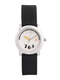

In [34]:
Image('54656.jpg')

- Now find the filenames for the above given indices and then pass it to the image

In [35]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

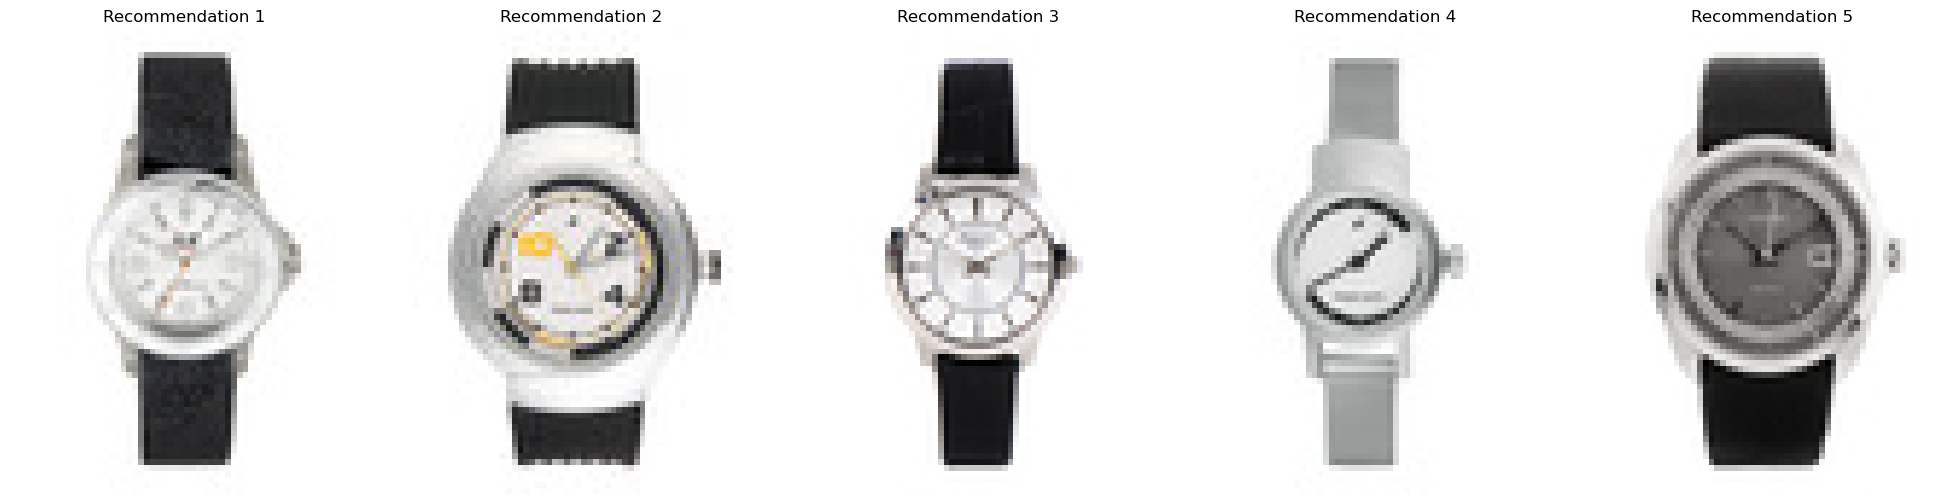

In [36]:
def display_images(filenames, indices):
    plt.figure(figsize=(20, 5))  # Create a figure with a specific size

    # Loop through the first 5 recommended images
    for i in range(5):
        img_path = filenames[indices[0][i + 1]]  # Get the path of the recommended image
        img = mpimg.imread(img_path)  # Read the image
        
        # Add a subplot for each image
        plt.subplot(1, 5, i + 1)  # 1 row, 5 columns, position i+1
        plt.imshow(img)  # Display the image
        plt.axis('off')  # Turn off the axes
        plt.title(f"Recommendation {i + 1}")  # Add a title for each image

    plt.tight_layout()
    plt.show()  # Show all images

# Example Usage
display_images(filenames, indices)

- These are the recommended images for the input image